In [1]:
!pip install transformers
!pip install torch
!pip install sklearn
!pip install pandas
!pip install os
!pip install tqdm
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post9-py3-none-any.whl size=2952 sha256=9208186b431b47ee06a1bd936628fbf51931d6885183591e85eb6811b68ef44e
  Stored in directory: /root/.cache/pip/wheels/33/a3/d2/092b519e9522b4c91608b7dcec0dd9051fa1bff4c45f4502d1
Successfully built sklearn
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 k

In [2]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm
from torch import cuda
from google.colab import drive
import matplotlib.pyplot as plt
from datasets import load_dataset

In [3]:
en_dataset = load_dataset("dair-ai/emotion", split=['train[:800]', 'test[:200]'])

In [4]:
en_dataset

[Dataset({
     features: ['text', 'label'],
     num_rows: 800
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 200
 })]

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
base_path = "drive/MyDrive"
filename = "emotionl_shows.csv"

pf = os.path.join(base_path, filename)

In [5]:
pf

'drive/MyDrive/emotionl_shows.csv'

In [6]:
df = pd.read_csv(pf)

In [7]:
df

Text Category
0    Kweenie of da gij al es goed hebt stilgestaan ...  neutral
1                                               Santé.      joy
2    Ja jongens. Dees is nie gezond ze. Pfff. Dees ...     fear
3    Ik had de vorige keer ook al zoiets van: nie m...    anger
4    Tis wat het is. Tis ook een belangrijke job eh...  neutral
..                                                 ...      ...
995  Jah ze werken harder eh als wij in België, en ...  sadness
996  Ah gij. Wa een ramp zijt gij. Allemaal hetzelfde.    anger
997  Der sta Lego van Lord of the Rings, van Star W...  neutral
998                  Nu zijn we precies aant kamperen.      joy
999  Ik heb euh ooit es… bja ik swing op elk feestj...      joy

[1000 rows x 2 columns]

In [8]:
df['Category'].replace(['neutral', 'joy', 'fear', 'anger', 'sadness', 'love', "other"], [0,1,2,3,4,5,6], inplace=True)

In [9]:
df

Text  Category
0    Kweenie of da gij al es goed hebt stilgestaan ...         0
1                                               Santé.         1
2    Ja jongens. Dees is nie gezond ze. Pfff. Dees ...         2
3    Ik had de vorige keer ook al zoiets van: nie m...         3
4    Tis wat het is. Tis ook een belangrijke job eh...         0
..                                                 ...       ...
995  Jah ze werken harder eh als wij in België, en ...         4
996  Ah gij. Wa een ramp zijt gij. Allemaal hetzelfde.         3
997  Der sta Lego van Lord of the Rings, van Star W...         0
998                  Nu zijn we precies aant kamperen.         1
999  Ik heb euh ooit es… bja ik swing op elk feestj...         1

[1000 rows x 2 columns]

In [10]:
train, test = train_test_split(df,test_size=0.2, train_size=0.8)
train = train.reset_index()
test = test.reset_index()

In [11]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

In [8]:
def tokenization(example):
    return tokenizer(
            example['text'],
            None,
            add_special_tokens=True,
            max_length=256,
            pad_to_max_length=True,
            return_token_type_ids=True
        )

In [9]:
en_train = en_dataset[0].map(tokenization, batched=True)
en_test = en_dataset[1].map(tokenization, batched=True)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [10]:
en_train

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 800
})

In [12]:
class TorchDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.data = dataframe,
        self.tokenizer = tokenizer,
        self.texts = dataframe.Text,
        self.targets = self.data[0].Category

    def __len__(self):
        return len(self.texts[0])

    def __getitem__(self, index):
        text = str(self.texts[0][index])
        text = " ".join(text.split())

        inputs = self.tokenizer[0].encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=256,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [13]:
train_set =  TorchDataset(train, tokenizer)
test_set =  TorchDataset(test, tokenizer)

In [11]:
en_train = en_train.with_format("torch")
en_test = en_test.with_format("torch")

In [12]:
en_train

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 800
})

In [13]:
en_train_loader = DataLoader(en_train, batch_size=8, shuffle=True, num_workers=0)
en_test_loader = DataLoader(en_test, batch_size=8, shuffle=True, num_workers=0)

In [14]:
train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, 4, shuffle=True, num_workers=0)

In [15]:
device = 'cuda' if cuda.is_available() else 'cpu'

In [16]:
class XLMRobertaClass(torch.nn.Module):
    def __init__(self):
        super(XLMRobertaClass, self).__init__()
        self.l1 = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base")
        self.pre_classifier = torch.nn.Linear(250002, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 7)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [17]:
model =  XLMRobertaClass()
model.to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


XLMRobertaClass(
  (l1): XLMRobertaForMaskedLM(
    (roberta): XLMRobertaModel(
      (embeddings): XLMRobertaEmbeddings(
        (word_embeddings): Embedding(250002, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): XLMRobertaEncoder(
        (layer): ModuleList(
          (0-11): 12 x XLMRobertaLayer(
            (attention): XLMRobertaAttention(
              (self): XLMRobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): XLMRobertaSelfOutput(
               

In [18]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=0.001)

In [19]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [20]:
def train_nl(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _, data in tqdm(enumerate(train_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)
        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()

        print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
        epoch_loss = tr_loss/nb_tr_steps
        epoch_accu = (n_correct*100)/nb_tr_examples
        print(f"Training Loss Epoch: {epoch_loss}")
        print(f"Training Accuracy Epoch: {epoch_accu}")

    return (n_correct*100)/nb_tr_examples

In [21]:
def train_en(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _, data in tqdm(enumerate(en_train_loader, 0)):
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['label'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)
        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()

        print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
        epoch_loss = tr_loss/nb_tr_steps
        epoch_accu = (n_correct*100)/nb_tr_examples
        print(f"Training Loss Epoch: {epoch_loss}")
        print(f"Training Accuracy Epoch: {epoch_accu}")

    return (n_correct*100)/nb_tr_examples

In [21]:
epochs = 100
t_acc = []
for x in range(epochs):
    t_acc.append(train_nl(x))

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
1it [00:03,  3.09s/it]

Training Loss per 5000 steps: 4.102828502655029
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 0: 12.5
Training Loss Epoch: 4.102828502655029
Training Accuracy Epoch: 12.5


2it [00:03,  1.75s/it]

The Total Accuracy for Epoch 0: 12.5
Training Loss Epoch: 4.510660648345947
Training Accuracy Epoch: 12.5


3it [00:04,  1.34s/it]

The Total Accuracy for Epoch 0: 12.5
Training Loss Epoch: 3.8924776713053384
Training Accuracy Epoch: 12.5


4it [00:05,  1.14s/it]

The Total Accuracy for Epoch 0: 12.5
Training Loss Epoch: 4.653936147689819
Training Accuracy Epoch: 12.5


5it [00:06,  1.04s/it]

The Total Accuracy for Epoch 0: 12.5
Training Loss Epoch: 4.130870580673218
Training Accuracy Epoch: 12.5


6it [00:07,  1.03it/s]

The Total Accuracy for Epoch 0: 16.666666666666668
Training Loss Epoch: 3.831029216448466
Training Accuracy Epoch: 16.666666666666668


7it [00:08,  1.08it/s]

The Total Accuracy for Epoch 0: 16.071428571428573
Training Loss Epoch: 4.2190708092280795
Training Accuracy Epoch: 16.071428571428573


8it [00:08,  1.11it/s]

The Total Accuracy for Epoch 0: 18.75
Training Loss Epoch: 4.066251188516617
Training Accuracy Epoch: 18.75


9it [00:09,  1.13it/s]

The Total Accuracy for Epoch 0: 20.833333333333332
Training Loss Epoch: 4.013816250695123
Training Accuracy Epoch: 20.833333333333332


10it [00:10,  1.14it/s]

The Total Accuracy for Epoch 0: 21.25
Training Loss Epoch: 4.050423049926758
Training Accuracy Epoch: 21.25


11it [00:11,  1.16it/s]

The Total Accuracy for Epoch 0: 22.727272727272727
Training Loss Epoch: 3.9301060763272373
Training Accuracy Epoch: 22.727272727272727


12it [00:12,  1.17it/s]

The Total Accuracy for Epoch 0: 20.833333333333332
Training Loss Epoch: 4.244013746579488
Training Accuracy Epoch: 20.833333333333332


13it [00:13,  1.17it/s]

The Total Accuracy for Epoch 0: 19.23076923076923
Training Loss Epoch: 4.359482325040377
Training Accuracy Epoch: 19.23076923076923


14it [00:14,  1.17it/s]

The Total Accuracy for Epoch 0: 19.642857142857142
Training Loss Epoch: 4.36962856565203
Training Accuracy Epoch: 19.642857142857142


15it [00:14,  1.17it/s]

The Total Accuracy for Epoch 0: 20.0
Training Loss Epoch: 4.2680645942687985
Training Accuracy Epoch: 20.0


16it [00:15,  1.17it/s]

The Total Accuracy for Epoch 0: 18.75
Training Loss Epoch: 4.301649451255798
Training Accuracy Epoch: 18.75


17it [00:16,  1.17it/s]

The Total Accuracy for Epoch 0: 19.11764705882353
Training Loss Epoch: 4.2972320107852715
Training Accuracy Epoch: 19.11764705882353


18it [00:17,  1.17it/s]

The Total Accuracy for Epoch 0: 18.055555555555557
Training Loss Epoch: 4.3671949704488116
Training Accuracy Epoch: 18.055555555555557


19it [00:18,  1.17it/s]

The Total Accuracy for Epoch 0: 19.07894736842105
Training Loss Epoch: 4.3935236177946395
Training Accuracy Epoch: 19.07894736842105


20it [00:19,  1.16it/s]

The Total Accuracy for Epoch 0: 19.375
Training Loss Epoch: 4.365088415145874
Training Accuracy Epoch: 19.375


21it [00:20,  1.16it/s]

The Total Accuracy for Epoch 0: 19.047619047619047
Training Loss Epoch: 4.352065358843122
Training Accuracy Epoch: 19.047619047619047


22it [00:20,  1.16it/s]

The Total Accuracy for Epoch 0: 19.886363636363637
Training Loss Epoch: 4.340892531655052
Training Accuracy Epoch: 19.886363636363637


23it [00:21,  1.16it/s]

The Total Accuracy for Epoch 0: 20.652173913043477
Training Loss Epoch: 4.357780954112178
Training Accuracy Epoch: 20.652173913043477


24it [00:22,  1.16it/s]

The Total Accuracy for Epoch 0: 21.354166666666668
Training Loss Epoch: 4.382402300834656
Training Accuracy Epoch: 21.354166666666668


25it [00:23,  1.16it/s]

The Total Accuracy for Epoch 0: 21.0
Training Loss Epoch: 4.434503021240235
Training Accuracy Epoch: 21.0


26it [00:24,  1.16it/s]

The Total Accuracy for Epoch 0: 21.153846153846153
Training Loss Epoch: 4.381621690896841
Training Accuracy Epoch: 21.153846153846153


27it [00:25,  1.16it/s]

The Total Accuracy for Epoch 0: 20.833333333333332
Training Loss Epoch: 4.384964642701326
Training Accuracy Epoch: 20.833333333333332


28it [00:26,  1.16it/s]

The Total Accuracy for Epoch 0: 20.535714285714285
Training Loss Epoch: 4.363059827259609
Training Accuracy Epoch: 20.535714285714285


29it [00:26,  1.15it/s]

The Total Accuracy for Epoch 0: 20.25862068965517
Training Loss Epoch: 4.347596308280682
Training Accuracy Epoch: 20.25862068965517


30it [00:27,  1.15it/s]

The Total Accuracy for Epoch 0: 20.416666666666668
Training Loss Epoch: 4.335348002115885
Training Accuracy Epoch: 20.416666666666668


31it [00:28,  1.15it/s]

The Total Accuracy for Epoch 0: 21.370967741935484
Training Loss Epoch: 4.319922385677215
Training Accuracy Epoch: 21.370967741935484


32it [00:29,  1.15it/s]

The Total Accuracy for Epoch 0: 21.875
Training Loss Epoch: 4.276381194591522
Training Accuracy Epoch: 21.875


33it [00:30,  1.14it/s]

The Total Accuracy for Epoch 0: 21.59090909090909
Training Loss Epoch: 4.307334480863629
Training Accuracy Epoch: 21.59090909090909


34it [00:31,  1.14it/s]

The Total Accuracy for Epoch 0: 21.323529411764707
Training Loss Epoch: 4.368600228253533
Training Accuracy Epoch: 21.323529411764707


35it [00:32,  1.14it/s]

The Total Accuracy for Epoch 0: 21.428571428571427
Training Loss Epoch: 4.351584005355835
Training Accuracy Epoch: 21.428571428571427


36it [00:33,  1.09it/s]

The Total Accuracy for Epoch 0: 21.52777777777778
Training Loss Epoch: 4.3009633620580034
Training Accuracy Epoch: 21.52777777777778


37it [00:34,  1.13it/s]

The Total Accuracy for Epoch 0: 21.62162162162162
Training Loss Epoch: 4.319547846510604
Training Accuracy Epoch: 21.62162162162162


38it [00:35,  1.11it/s]

The Total Accuracy for Epoch 0: 22.039473684210527
Training Loss Epoch: 4.33273690625241
Training Accuracy Epoch: 22.039473684210527


39it [00:35,  1.10it/s]

The Total Accuracy for Epoch 0: 21.474358974358974
Training Loss Epoch: 4.336595144027319
Training Accuracy Epoch: 21.474358974358974


40it [00:36,  1.13it/s]

The Total Accuracy for Epoch 0: 21.25
Training Loss Epoch: 4.3614786028862
Training Accuracy Epoch: 21.25


41it [00:37,  1.13it/s]

The Total Accuracy for Epoch 0: 21.341463414634145
Training Loss Epoch: 4.3421888932949155
Training Accuracy Epoch: 21.341463414634145


42it [00:38,  1.13it/s]

The Total Accuracy for Epoch 0: 21.13095238095238
Training Loss Epoch: 4.340250003905523
Training Accuracy Epoch: 21.13095238095238


43it [00:39,  1.13it/s]

The Total Accuracy for Epoch 0: 21.22093023255814
Training Loss Epoch: 4.326713018639143
Training Accuracy Epoch: 21.22093023255814


44it [00:40,  1.13it/s]

The Total Accuracy for Epoch 0: 21.59090909090909
Training Loss Epoch: 4.320440324870023
Training Accuracy Epoch: 21.59090909090909


45it [00:41,  1.13it/s]

The Total Accuracy for Epoch 0: 21.38888888888889
Training Loss Epoch: 4.301658693949381
Training Accuracy Epoch: 21.38888888888889


46it [00:42,  1.12it/s]

The Total Accuracy for Epoch 0: 21.195652173913043
Training Loss Epoch: 4.300939808721128
Training Accuracy Epoch: 21.195652173913043


47it [00:42,  1.12it/s]

The Total Accuracy for Epoch 0: 21.27659574468085
Training Loss Epoch: 4.300592006521022
Training Accuracy Epoch: 21.27659574468085


48it [00:43,  1.12it/s]

The Total Accuracy for Epoch 0: 21.09375
Training Loss Epoch: 4.361793369054794
Training Accuracy Epoch: 21.09375


49it [00:44,  1.12it/s]

The Total Accuracy for Epoch 0: 21.1734693877551
Training Loss Epoch: 4.359124991358543
Training Accuracy Epoch: 21.1734693877551


50it [00:45,  1.12it/s]

The Total Accuracy for Epoch 0: 21.0
Training Loss Epoch: 4.35221568107605
Training Accuracy Epoch: 21.0


51it [00:46,  1.12it/s]

The Total Accuracy for Epoch 0: 20.833333333333332
Training Loss Epoch: 4.376528347239775
Training Accuracy Epoch: 20.833333333333332


52it [00:47,  1.12it/s]

The Total Accuracy for Epoch 0: 21.153846153846153
Training Loss Epoch: 4.367642242174882
Training Accuracy Epoch: 21.153846153846153


53it [00:48,  1.11it/s]

The Total Accuracy for Epoch 0: 20.99056603773585
Training Loss Epoch: 4.377353384809674
Training Accuracy Epoch: 20.99056603773585


54it [00:49,  1.11it/s]

The Total Accuracy for Epoch 0: 21.064814814814813
Training Loss Epoch: 4.378459440337287
Training Accuracy Epoch: 21.064814814814813


55it [00:50,  1.11it/s]

The Total Accuracy for Epoch 0: 20.681818181818183
Training Loss Epoch: 4.359653715653853
Training Accuracy Epoch: 20.681818181818183


56it [00:51,  1.11it/s]

The Total Accuracy for Epoch 0: 20.535714285714285
Training Loss Epoch: 4.341666668653488
Training Accuracy Epoch: 20.535714285714285


57it [00:52,  1.11it/s]

The Total Accuracy for Epoch 0: 21.05263157894737
Training Loss Epoch: 4.317939544978895
Training Accuracy Epoch: 21.05263157894737


58it [00:52,  1.11it/s]

The Total Accuracy for Epoch 0: 20.905172413793103
Training Loss Epoch: 4.304015250041567
Training Accuracy Epoch: 20.905172413793103


59it [00:53,  1.11it/s]

The Total Accuracy for Epoch 0: 20.76271186440678
Training Loss Epoch: 4.312597460665946
Training Accuracy Epoch: 20.76271186440678


60it [00:54,  1.11it/s]

The Total Accuracy for Epoch 0: 20.625
Training Loss Epoch: 4.301412379741668
Training Accuracy Epoch: 20.625


61it [00:55,  1.11it/s]

The Total Accuracy for Epoch 0: 20.491803278688526
Training Loss Epoch: 4.2930919420523725
Training Accuracy Epoch: 20.491803278688526


62it [00:56,  1.10it/s]

The Total Accuracy for Epoch 0: 20.362903225806452
Training Loss Epoch: 4.284900103845904
Training Accuracy Epoch: 20.362903225806452


63it [00:57,  1.10it/s]

The Total Accuracy for Epoch 0: 20.833333333333332
Training Loss Epoch: 4.265943281234256
Training Accuracy Epoch: 20.833333333333332


64it [00:58,  1.10it/s]

The Total Accuracy for Epoch 0: 21.09375
Training Loss Epoch: 4.251419637352228
Training Accuracy Epoch: 21.09375


65it [00:59,  1.10it/s]

The Total Accuracy for Epoch 0: 20.76923076923077
Training Loss Epoch: 4.283024454116822
Training Accuracy Epoch: 20.76923076923077


66it [01:00,  1.09it/s]

The Total Accuracy for Epoch 0: 20.454545454545453
Training Loss Epoch: 4.297317508495215
Training Accuracy Epoch: 20.454545454545453


67it [01:01,  1.09it/s]

The Total Accuracy for Epoch 0: 20.149253731343283
Training Loss Epoch: 4.301018704229326
Training Accuracy Epoch: 20.149253731343283


68it [01:02,  1.09it/s]

The Total Accuracy for Epoch 0: 20.220588235294116
Training Loss Epoch: 4.293212438330931
Training Accuracy Epoch: 20.220588235294116


69it [01:02,  1.09it/s]

The Total Accuracy for Epoch 0: 20.108695652173914
Training Loss Epoch: 4.28802520295848
Training Accuracy Epoch: 20.108695652173914


70it [01:03,  1.08it/s]

The Total Accuracy for Epoch 0: 20.0
Training Loss Epoch: 4.312000707217625
Training Accuracy Epoch: 20.0


71it [01:04,  1.08it/s]

The Total Accuracy for Epoch 0: 20.070422535211268
Training Loss Epoch: 4.32951467473742
Training Accuracy Epoch: 20.070422535211268


72it [01:05,  1.08it/s]

The Total Accuracy for Epoch 0: 20.3125
Training Loss Epoch: 4.294883971412976
Training Accuracy Epoch: 20.3125


73it [01:06,  1.08it/s]

The Total Accuracy for Epoch 0: 20.376712328767123
Training Loss Epoch: 4.298918232525865
Training Accuracy Epoch: 20.376712328767123


74it [01:07,  1.07it/s]

The Total Accuracy for Epoch 0: 20.60810810810811
Training Loss Epoch: 4.284028586503622
Training Accuracy Epoch: 20.60810810810811


75it [01:08,  1.07it/s]

The Total Accuracy for Epoch 0: 20.5
Training Loss Epoch: 4.274352510770162
Training Accuracy Epoch: 20.5


76it [01:09,  1.07it/s]

The Total Accuracy for Epoch 0: 20.723684210526315
Training Loss Epoch: 4.256315355238161
Training Accuracy Epoch: 20.723684210526315


77it [01:10,  1.06it/s]

The Total Accuracy for Epoch 0: 20.616883116883116
Training Loss Epoch: 4.268172565992776
Training Accuracy Epoch: 20.616883116883116


78it [01:11,  1.06it/s]

The Total Accuracy for Epoch 0: 20.673076923076923
Training Loss Epoch: 4.270671482269581
Training Accuracy Epoch: 20.673076923076923


79it [01:12,  1.05it/s]

The Total Accuracy for Epoch 0: 20.411392405063292
Training Loss Epoch: 4.289307647113558
Training Accuracy Epoch: 20.411392405063292


80it [01:13,  1.05it/s]

The Total Accuracy for Epoch 0: 20.46875
Training Loss Epoch: 4.3033233568072315
Training Accuracy Epoch: 20.46875


81it [01:14,  1.05it/s]

The Total Accuracy for Epoch 0: 20.37037037037037
Training Loss Epoch: 4.295993535606949
Training Accuracy Epoch: 20.37037037037037


82it [01:15,  1.04it/s]

The Total Accuracy for Epoch 0: 20.274390243902438
Training Loss Epoch: 4.3254925754012135
Training Accuracy Epoch: 20.274390243902438


83it [01:16,  1.04it/s]

The Total Accuracy for Epoch 0: 20.180722891566266
Training Loss Epoch: 4.326962909066533
Training Accuracy Epoch: 20.180722891566266


84it [01:17,  1.04it/s]

The Total Accuracy for Epoch 0: 20.238095238095237
Training Loss Epoch: 4.310666446174894
Training Accuracy Epoch: 20.238095238095237


85it [01:18,  1.03it/s]

The Total Accuracy for Epoch 0: 20.147058823529413
Training Loss Epoch: 4.310890830264372
Training Accuracy Epoch: 20.147058823529413


86it [01:19,  1.03it/s]

The Total Accuracy for Epoch 0: 20.058139534883722
Training Loss Epoch: 4.304898271727008
Training Accuracy Epoch: 20.058139534883722


87it [01:20,  1.03it/s]

The Total Accuracy for Epoch 0: 19.971264367816094
Training Loss Epoch: 4.30800534253833
Training Accuracy Epoch: 19.971264367816094


88it [01:21,  1.02it/s]

The Total Accuracy for Epoch 0: 20.3125
Training Loss Epoch: 4.288308594714511
Training Accuracy Epoch: 20.3125


89it [01:22,  1.02it/s]

The Total Accuracy for Epoch 0: 20.224719101123597
Training Loss Epoch: 4.27951016184989
Training Accuracy Epoch: 20.224719101123597


90it [01:23,  1.02it/s]

The Total Accuracy for Epoch 0: 20.416666666666668
Training Loss Epoch: 4.252175923188528
Training Accuracy Epoch: 20.416666666666668


91it [01:24,  1.02it/s]

The Total Accuracy for Epoch 0: 20.467032967032967
Training Loss Epoch: 4.2438659235671325
Training Accuracy Epoch: 20.467032967032967


92it [01:25,  1.01it/s]

The Total Accuracy for Epoch 0: 20.78804347826087
Training Loss Epoch: 4.231501940799796
Training Accuracy Epoch: 20.78804347826087


93it [01:26,  1.01it/s]

The Total Accuracy for Epoch 0: 20.698924731182796
Training Loss Epoch: 4.252495267057932
Training Accuracy Epoch: 20.698924731182796


94it [01:27,  1.01it/s]

The Total Accuracy for Epoch 0: 20.611702127659573
Training Loss Epoch: 4.281116220545261
Training Accuracy Epoch: 20.611702127659573


95it [01:28,  1.00it/s]

The Total Accuracy for Epoch 0: 20.657894736842106
Training Loss Epoch: 4.269351707006756
Training Accuracy Epoch: 20.657894736842106


96it [01:29,  1.00it/s]

The Total Accuracy for Epoch 0: 20.572916666666668
Training Loss Epoch: 4.27311414356033
Training Accuracy Epoch: 20.572916666666668


97it [01:30,  1.00it/s]

The Total Accuracy for Epoch 0: 20.36082474226804
Training Loss Epoch: 4.3029993182605075
Training Accuracy Epoch: 20.36082474226804


98it [01:31,  1.00s/it]

The Total Accuracy for Epoch 0: 20.408163265306122
Training Loss Epoch: 4.297075511241446
Training Accuracy Epoch: 20.408163265306122


99it [01:32,  1.00s/it]

The Total Accuracy for Epoch 0: 20.454545454545453
Training Loss Epoch: 4.305661159332352
Training Accuracy Epoch: 20.454545454545453


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 0: 20.5
Training Loss Epoch: 4.311372891664505
Training Accuracy Epoch: 20.5


1it [00:01,  1.00s/it]

Training Loss per 5000 steps: 5.723062515258789
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 1: 25.0
Training Loss Epoch: 5.723062515258789
Training Accuracy Epoch: 25.0


2it [00:02,  1.01s/it]

The Total Accuracy for Epoch 1: 12.5
Training Loss Epoch: 5.3593244552612305
Training Accuracy Epoch: 12.5


3it [00:03,  1.01s/it]

The Total Accuracy for Epoch 1: 12.5
Training Loss Epoch: 5.787531693776448
Training Accuracy Epoch: 12.5


4it [00:04,  1.01s/it]

The Total Accuracy for Epoch 1: 12.5
Training Loss Epoch: 5.139086425304413
Training Accuracy Epoch: 12.5


5it [00:05,  1.01s/it]

The Total Accuracy for Epoch 1: 15.0
Training Loss Epoch: 4.706741666793823
Training Accuracy Epoch: 15.0


6it [00:06,  1.00s/it]

The Total Accuracy for Epoch 1: 18.75
Training Loss Epoch: 4.648091197013855
Training Accuracy Epoch: 18.75


7it [00:07,  1.00it/s]

The Total Accuracy for Epoch 1: 23.214285714285715
Training Loss Epoch: 4.33335668700082
Training Accuracy Epoch: 23.214285714285715


8it [00:08,  1.00it/s]

The Total Accuracy for Epoch 1: 25.0
Training Loss Epoch: 4.260637789964676
Training Accuracy Epoch: 25.0


9it [00:09,  1.00it/s]

The Total Accuracy for Epoch 1: 25.0
Training Loss Epoch: 4.490861548317803
Training Accuracy Epoch: 25.0


10it [00:09,  1.01it/s]

The Total Accuracy for Epoch 1: 26.25
Training Loss Epoch: 4.377257752418518
Training Accuracy Epoch: 26.25


11it [00:10,  1.00it/s]

The Total Accuracy for Epoch 1: 26.136363636363637
Training Loss Epoch: 4.489716378125277
Training Accuracy Epoch: 26.136363636363637


12it [00:11,  1.01it/s]

The Total Accuracy for Epoch 1: 25.0
Training Loss Epoch: 4.413852393627167
Training Accuracy Epoch: 25.0


13it [00:12,  1.01it/s]

The Total Accuracy for Epoch 1: 24.03846153846154
Training Loss Epoch: 4.648497269703792
Training Accuracy Epoch: 24.03846153846154


14it [00:13,  1.02it/s]

The Total Accuracy for Epoch 1: 22.321428571428573
Training Loss Epoch: 4.722820707729885
Training Accuracy Epoch: 22.321428571428573


15it [00:14,  1.02it/s]

The Total Accuracy for Epoch 1: 21.666666666666668
Training Loss Epoch: 4.580109310150147
Training Accuracy Epoch: 21.666666666666668


16it [00:15,  1.02it/s]

The Total Accuracy for Epoch 1: 22.65625
Training Loss Epoch: 4.581918925046921
Training Accuracy Epoch: 22.65625


17it [00:16,  1.02it/s]

The Total Accuracy for Epoch 1: 21.323529411764707
Training Loss Epoch: 4.667802446028766
Training Accuracy Epoch: 21.323529411764707


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 1: 21.52777777777778
Training Loss Epoch: 4.56494747267829
Training Accuracy Epoch: 21.52777777777778


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 1: 21.710526315789473
Training Loss Epoch: 4.59361942190873
Training Accuracy Epoch: 21.710526315789473


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 1: 21.875
Training Loss Epoch: 4.560089659690857
Training Accuracy Epoch: 21.875


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 1: 22.61904761904762
Training Loss Epoch: 4.465368009748913
Training Accuracy Epoch: 22.61904761904762


22it [00:21,  1.04it/s]

The Total Accuracy for Epoch 1: 22.15909090909091
Training Loss Epoch: 4.439593878659335
Training Accuracy Epoch: 22.15909090909091


23it [00:22,  1.04it/s]

The Total Accuracy for Epoch 1: 22.282608695652176
Training Loss Epoch: 4.45008315210757
Training Accuracy Epoch: 22.282608695652176


24it [00:23,  1.04it/s]

The Total Accuracy for Epoch 1: 21.875
Training Loss Epoch: 4.485484520594279
Training Accuracy Epoch: 21.875


25it [00:24,  1.04it/s]

The Total Accuracy for Epoch 1: 22.0
Training Loss Epoch: 4.510605392456054
Training Accuracy Epoch: 22.0


26it [00:25,  1.04it/s]

The Total Accuracy for Epoch 1: 22.115384615384617
Training Loss Epoch: 4.480593543786269
Training Accuracy Epoch: 22.115384615384617


27it [00:26,  1.05it/s]

The Total Accuracy for Epoch 1: 23.14814814814815
Training Loss Epoch: 4.429640743467543
Training Accuracy Epoch: 23.14814814814815


28it [00:27,  1.05it/s]

The Total Accuracy for Epoch 1: 23.214285714285715
Training Loss Epoch: 4.453705642904554
Training Accuracy Epoch: 23.214285714285715


29it [00:28,  1.05it/s]

The Total Accuracy for Epoch 1: 23.275862068965516
Training Loss Epoch: 4.4764817912003085
Training Accuracy Epoch: 23.275862068965516


30it [00:29,  1.05it/s]

The Total Accuracy for Epoch 1: 23.333333333333332
Training Loss Epoch: 4.482150419553121
Training Accuracy Epoch: 23.333333333333332


31it [00:30,  1.05it/s]

The Total Accuracy for Epoch 1: 23.387096774193548
Training Loss Epoch: 4.481232173981205
Training Accuracy Epoch: 23.387096774193548


32it [00:31,  1.05it/s]

The Total Accuracy for Epoch 1: 23.828125
Training Loss Epoch: 4.455438815057278
Training Accuracy Epoch: 23.828125


33it [00:32,  1.05it/s]

The Total Accuracy for Epoch 1: 23.863636363636363
Training Loss Epoch: 4.397248044158474
Training Accuracy Epoch: 23.863636363636363


34it [00:33,  1.05it/s]

The Total Accuracy for Epoch 1: 24.264705882352942
Training Loss Epoch: 4.41647134808933
Training Accuracy Epoch: 24.264705882352942


35it [00:34,  1.05it/s]

The Total Accuracy for Epoch 1: 24.642857142857142
Training Loss Epoch: 4.38961078780038
Training Accuracy Epoch: 24.642857142857142


36it [00:35,  1.05it/s]

The Total Accuracy for Epoch 1: 25.34722222222222
Training Loss Epoch: 4.367472204897139
Training Accuracy Epoch: 25.34722222222222


37it [00:35,  1.05it/s]

The Total Accuracy for Epoch 1: 24.66216216216216
Training Loss Epoch: 4.410508767978565
Training Accuracy Epoch: 24.66216216216216


38it [00:36,  1.06it/s]

The Total Accuracy for Epoch 1: 25.32894736842105
Training Loss Epoch: 4.4183231592178345
Training Accuracy Epoch: 25.32894736842105


39it [00:37,  1.06it/s]

The Total Accuracy for Epoch 1: 25.32051282051282
Training Loss Epoch: 4.46531773224855
Training Accuracy Epoch: 25.32051282051282


40it [00:38,  1.06it/s]

The Total Accuracy for Epoch 1: 25.0
Training Loss Epoch: 4.450642359256745
Training Accuracy Epoch: 25.0


41it [00:39,  1.05it/s]

The Total Accuracy for Epoch 1: 24.695121951219512
Training Loss Epoch: 4.413332386714656
Training Accuracy Epoch: 24.695121951219512


42it [00:40,  1.06it/s]

The Total Accuracy for Epoch 1: 25.0
Training Loss Epoch: 4.416629683403742
Training Accuracy Epoch: 25.0


43it [00:41,  1.05it/s]

The Total Accuracy for Epoch 1: 24.709302325581394
Training Loss Epoch: 4.4440320647040075
Training Accuracy Epoch: 24.709302325581394


44it [00:42,  1.05it/s]

The Total Accuracy for Epoch 1: 25.0
Training Loss Epoch: 4.439379556612535
Training Accuracy Epoch: 25.0


45it [00:43,  1.06it/s]

The Total Accuracy for Epoch 1: 24.72222222222222
Training Loss Epoch: 4.501989380518595
Training Accuracy Epoch: 24.72222222222222


46it [00:44,  1.06it/s]

The Total Accuracy for Epoch 1: 24.72826086956522
Training Loss Epoch: 4.489611138468203
Training Accuracy Epoch: 24.72826086956522


47it [00:45,  1.06it/s]

The Total Accuracy for Epoch 1: 24.46808510638298
Training Loss Epoch: 4.486322129026372
Training Accuracy Epoch: 24.46808510638298


48it [00:46,  1.06it/s]

The Total Accuracy for Epoch 1: 23.958333333333332
Training Loss Epoch: 4.482090920209885
Training Accuracy Epoch: 23.958333333333332


49it [00:47,  1.05it/s]

The Total Accuracy for Epoch 1: 24.744897959183675
Training Loss Epoch: 4.416241263856693
Training Accuracy Epoch: 24.744897959183675


50it [00:48,  1.05it/s]

The Total Accuracy for Epoch 1: 24.75
Training Loss Epoch: 4.432091329097748
Training Accuracy Epoch: 24.75


51it [00:49,  1.05it/s]

The Total Accuracy for Epoch 1: 24.50980392156863
Training Loss Epoch: 4.426854710952909
Training Accuracy Epoch: 24.50980392156863


52it [00:50,  1.05it/s]

The Total Accuracy for Epoch 1: 24.51923076923077
Training Loss Epoch: 4.489037749859003
Training Accuracy Epoch: 24.51923076923077


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 1: 24.29245283018868
Training Loss Epoch: 4.49682793302356
Training Accuracy Epoch: 24.29245283018868


54it [00:52,  1.05it/s]

The Total Accuracy for Epoch 1: 24.074074074074073
Training Loss Epoch: 4.491035415066613
Training Accuracy Epoch: 24.074074074074073


55it [00:53,  1.05it/s]

The Total Accuracy for Epoch 1: 23.863636363636363
Training Loss Epoch: 4.505760017308321
Training Accuracy Epoch: 23.863636363636363


56it [00:54,  1.05it/s]

The Total Accuracy for Epoch 1: 23.660714285714285
Training Loss Epoch: 4.4824641070195606
Training Accuracy Epoch: 23.660714285714285


57it [00:54,  1.05it/s]

The Total Accuracy for Epoch 1: 23.464912280701753
Training Loss Epoch: 4.450908721539012
Training Accuracy Epoch: 23.464912280701753


58it [00:55,  1.04it/s]

The Total Accuracy for Epoch 1: 23.060344827586206
Training Loss Epoch: 4.449413030311979
Training Accuracy Epoch: 23.060344827586206


59it [00:56,  1.04it/s]

The Total Accuracy for Epoch 1: 22.88135593220339
Training Loss Epoch: 4.4877412218158526
Training Accuracy Epoch: 22.88135593220339


60it [00:57,  1.04it/s]

The Total Accuracy for Epoch 1: 22.708333333333332
Training Loss Epoch: 4.509930708010992
Training Accuracy Epoch: 22.708333333333332


61it [00:58,  1.04it/s]

The Total Accuracy for Epoch 1: 22.74590163934426
Training Loss Epoch: 4.497827848450083
Training Accuracy Epoch: 22.74590163934426


62it [00:59,  1.04it/s]

The Total Accuracy for Epoch 1: 22.782258064516128
Training Loss Epoch: 4.481095135211945
Training Accuracy Epoch: 22.782258064516128


63it [01:00,  1.04it/s]

The Total Accuracy for Epoch 1: 22.61904761904762
Training Loss Epoch: 4.495219675321428
Training Accuracy Epoch: 22.61904761904762


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 1: 22.265625
Training Loss Epoch: 4.471103565767407
Training Accuracy Epoch: 22.265625


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 1: 22.307692307692307
Training Loss Epoch: 4.479477253327003
Training Accuracy Epoch: 22.307692307692307


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 1: 22.727272727272727
Training Loss Epoch: 4.467349007274166
Training Accuracy Epoch: 22.727272727272727


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 1: 22.761194029850746
Training Loss Epoch: 4.475165180305936
Training Accuracy Epoch: 22.761194029850746


68it [01:05,  1.02it/s]

The Total Accuracy for Epoch 1: 22.977941176470587
Training Loss Epoch: 4.452328582020367
Training Accuracy Epoch: 22.977941176470587


69it [01:06,  1.02it/s]

The Total Accuracy for Epoch 1: 22.644927536231883
Training Loss Epoch: 4.461778721947601
Training Accuracy Epoch: 22.644927536231883


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 1: 23.035714285714285
Training Loss Epoch: 4.4332810044288635
Training Accuracy Epoch: 23.035714285714285


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 1: 22.887323943661972
Training Loss Epoch: 4.455415703880955
Training Accuracy Epoch: 22.887323943661972


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 1: 22.916666666666668
Training Loss Epoch: 4.454667374491692
Training Accuracy Epoch: 22.916666666666668


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 1: 22.945205479452056
Training Loss Epoch: 4.436960728201147
Training Accuracy Epoch: 22.945205479452056


74it [01:11,  1.02it/s]

The Total Accuracy for Epoch 1: 22.635135135135137
Training Loss Epoch: 4.4569143781790865
Training Accuracy Epoch: 22.635135135135137


75it [01:12,  1.02it/s]

The Total Accuracy for Epoch 1: 22.333333333333332
Training Loss Epoch: 4.444781365394593
Training Accuracy Epoch: 22.333333333333332


76it [01:13,  1.02it/s]

The Total Accuracy for Epoch 1: 22.532894736842106
Training Loss Epoch: 4.408739124473772
Training Accuracy Epoch: 22.532894736842106


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 1: 22.24025974025974
Training Loss Epoch: 4.412895218118445
Training Accuracy Epoch: 22.24025974025974


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 1: 22.275641025641026
Training Loss Epoch: 4.400487750004499
Training Accuracy Epoch: 22.275641025641026


79it [01:16,  1.02it/s]

The Total Accuracy for Epoch 1: 22.310126582278482
Training Loss Epoch: 4.4206561287747155
Training Accuracy Epoch: 22.310126582278482


80it [01:17,  1.02it/s]

The Total Accuracy for Epoch 1: 22.1875
Training Loss Epoch: 4.431867977976799
Training Accuracy Epoch: 22.1875


81it [01:18,  1.02it/s]

The Total Accuracy for Epoch 1: 22.22222222222222
Training Loss Epoch: 4.417994693473533
Training Accuracy Epoch: 22.22222222222222


82it [01:19,  1.02it/s]

The Total Accuracy for Epoch 1: 22.408536585365855
Training Loss Epoch: 4.40927563644037
Training Accuracy Epoch: 22.408536585365855


83it [01:20,  1.02it/s]

The Total Accuracy for Epoch 1: 22.43975903614458
Training Loss Epoch: 4.392337807689804
Training Accuracy Epoch: 22.43975903614458


84it [01:21,  1.02it/s]

The Total Accuracy for Epoch 1: 22.61904761904762
Training Loss Epoch: 4.379598569302332
Training Accuracy Epoch: 22.61904761904762


85it [01:22,  1.02it/s]

The Total Accuracy for Epoch 1: 22.352941176470587
Training Loss Epoch: 4.381447800467996
Training Accuracy Epoch: 22.352941176470587


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 1: 22.38372093023256
Training Loss Epoch: 4.381563128427017
Training Accuracy Epoch: 22.38372093023256


87it [01:24,  1.02it/s]

The Total Accuracy for Epoch 1: 22.270114942528735
Training Loss Epoch: 4.369289346124934
Training Accuracy Epoch: 22.270114942528735


88it [01:25,  1.02it/s]

The Total Accuracy for Epoch 1: 22.301136363636363
Training Loss Epoch: 4.384805801239881
Training Accuracy Epoch: 22.301136363636363


89it [01:26,  1.02it/s]

The Total Accuracy for Epoch 1: 22.191011235955056
Training Loss Epoch: 4.3842035009619895
Training Accuracy Epoch: 22.191011235955056


90it [01:27,  1.02it/s]

The Total Accuracy for Epoch 1: 22.5
Training Loss Epoch: 4.35157390832901
Training Accuracy Epoch: 22.5


91it [01:28,  1.02it/s]

The Total Accuracy for Epoch 1: 22.52747252747253
Training Loss Epoch: 4.3481457482327475
Training Accuracy Epoch: 22.52747252747253


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 1: 22.82608695652174
Training Loss Epoch: 4.321873497703801
Training Accuracy Epoch: 22.82608695652174


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 1: 22.849462365591396
Training Loss Epoch: 4.296607195690114
Training Accuracy Epoch: 22.849462365591396


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 1: 22.73936170212766
Training Loss Epoch: 4.293815870234307
Training Accuracy Epoch: 22.73936170212766


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 1: 22.763157894736842
Training Loss Epoch: 4.29971908644626
Training Accuracy Epoch: 22.763157894736842


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 1: 22.916666666666668
Training Loss Epoch: 4.298842756698529
Training Accuracy Epoch: 22.916666666666668


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 1: 22.809278350515463
Training Loss Epoch: 4.321919553058663
Training Accuracy Epoch: 22.809278350515463


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 1: 22.70408163265306
Training Loss Epoch: 4.319023393854803
Training Accuracy Epoch: 22.70408163265306


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 1: 22.853535353535353
Training Loss Epoch: 4.318970939125678
Training Accuracy Epoch: 22.853535353535353


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 1: 23.0
Training Loss Epoch: 4.326855348348618
Training Accuracy Epoch: 23.0


1it [00:00,  1.06it/s]

Training Loss per 5000 steps: 1.810257911682129
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 2: 37.5
Training Loss Epoch: 1.810257911682129
Training Accuracy Epoch: 37.5


2it [00:01,  1.05it/s]

The Total Accuracy for Epoch 2: 31.25
Training Loss Epoch: 3.75457763671875
Training Accuracy Epoch: 31.25


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 2: 20.833333333333332
Training Loss Epoch: 3.936306953430176
Training Accuracy Epoch: 20.833333333333332


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 2: 15.625
Training Loss Epoch: 4.41568124294281
Training Accuracy Epoch: 15.625


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 2: 12.5
Training Loss Epoch: 3.9753745079040526
Training Accuracy Epoch: 12.5


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 2: 12.5
Training Loss Epoch: 4.402219374974568
Training Accuracy Epoch: 12.5


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 2: 12.5
Training Loss Epoch: 4.301586321422032
Training Accuracy Epoch: 12.5


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 2: 15.625
Training Loss Epoch: 4.147882759571075
Training Accuracy Epoch: 15.625


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 2: 16.666666666666668
Training Loss Epoch: 4.234852684868707
Training Accuracy Epoch: 16.666666666666668


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 2: 15.0
Training Loss Epoch: 4.273849201202393
Training Accuracy Epoch: 15.0


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 2: 15.909090909090908
Training Loss Epoch: 4.128359252756292
Training Accuracy Epoch: 15.909090909090908


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 2: 16.666666666666668
Training Loss Epoch: 4.168142815430959
Training Accuracy Epoch: 16.666666666666668


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 2: 17.307692307692307
Training Loss Epoch: 4.161797871956458
Training Accuracy Epoch: 17.307692307692307


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 2: 16.071428571428573
Training Loss Epoch: 4.160953504698617
Training Accuracy Epoch: 16.071428571428573


15it [00:14,  1.04it/s]

The Total Accuracy for Epoch 2: 15.833333333333334
Training Loss Epoch: 4.232980140050253
Training Accuracy Epoch: 15.833333333333334


16it [00:15,  1.04it/s]

The Total Accuracy for Epoch 2: 15.625
Training Loss Epoch: 4.172211199998856
Training Accuracy Epoch: 15.625


17it [00:16,  1.04it/s]

The Total Accuracy for Epoch 2: 15.441176470588236
Training Loss Epoch: 4.117805340710809
Training Accuracy Epoch: 15.441176470588236


18it [00:17,  1.04it/s]

The Total Accuracy for Epoch 2: 17.36111111111111
Training Loss Epoch: 4.010464972919888
Training Accuracy Epoch: 17.36111111111111


19it [00:18,  1.04it/s]

The Total Accuracy for Epoch 2: 18.42105263157895
Training Loss Epoch: 3.999393525876497
Training Accuracy Epoch: 18.42105263157895


20it [00:19,  1.04it/s]

The Total Accuracy for Epoch 2: 18.75
Training Loss Epoch: 3.9356517434120177
Training Accuracy Epoch: 18.75


21it [00:20,  1.04it/s]

The Total Accuracy for Epoch 2: 17.857142857142858
Training Loss Epoch: 4.034644002006168
Training Accuracy Epoch: 17.857142857142858


22it [00:21,  1.04it/s]

The Total Accuracy for Epoch 2: 17.613636363636363
Training Loss Epoch: 3.991252389821139
Training Accuracy Epoch: 17.613636363636363


23it [00:22,  1.04it/s]

The Total Accuracy for Epoch 2: 17.391304347826086
Training Loss Epoch: 4.099955652071082
Training Accuracy Epoch: 17.391304347826086


24it [00:23,  1.04it/s]

The Total Accuracy for Epoch 2: 17.708333333333332
Training Loss Epoch: 4.159090926249822
Training Accuracy Epoch: 17.708333333333332


25it [00:24,  1.04it/s]

The Total Accuracy for Epoch 2: 17.5
Training Loss Epoch: 4.220215368270874
Training Accuracy Epoch: 17.5


26it [00:25,  1.04it/s]

The Total Accuracy for Epoch 2: 17.307692307692307
Training Loss Epoch: 4.2241323452729445
Training Accuracy Epoch: 17.307692307692307


27it [00:25,  1.04it/s]

The Total Accuracy for Epoch 2: 17.59259259259259
Training Loss Epoch: 4.239306176150286
Training Accuracy Epoch: 17.59259259259259


28it [00:26,  1.04it/s]

The Total Accuracy for Epoch 2: 18.303571428571427
Training Loss Epoch: 4.294379362038204
Training Accuracy Epoch: 18.303571428571427


29it [00:27,  1.04it/s]

The Total Accuracy for Epoch 2: 18.96551724137931
Training Loss Epoch: 4.241154900912581
Training Accuracy Epoch: 18.96551724137931


30it [00:28,  1.04it/s]

The Total Accuracy for Epoch 2: 19.166666666666668
Training Loss Epoch: 4.224470122655233
Training Accuracy Epoch: 19.166666666666668


31it [00:29,  1.04it/s]

The Total Accuracy for Epoch 2: 19.758064516129032
Training Loss Epoch: 4.217010544192407
Training Accuracy Epoch: 19.758064516129032


32it [00:30,  1.04it/s]

The Total Accuracy for Epoch 2: 20.703125
Training Loss Epoch: 4.230368182063103
Training Accuracy Epoch: 20.703125


33it [00:31,  1.04it/s]

The Total Accuracy for Epoch 2: 20.833333333333332
Training Loss Epoch: 4.27825352639863
Training Accuracy Epoch: 20.833333333333332


34it [00:32,  1.04it/s]

The Total Accuracy for Epoch 2: 21.691176470588236
Training Loss Epoch: 4.206459006842445
Training Accuracy Epoch: 21.691176470588236


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 2: 21.071428571428573
Training Loss Epoch: 4.302241737501962
Training Accuracy Epoch: 21.071428571428573


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 2: 21.180555555555557
Training Loss Epoch: 4.263553337918387
Training Accuracy Epoch: 21.180555555555557


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 2: 20.945945945945947
Training Loss Epoch: 4.332309526366156
Training Accuracy Epoch: 20.945945945945947


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 2: 20.723684210526315
Training Loss Epoch: 4.332058752837934
Training Accuracy Epoch: 20.723684210526315


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 2: 20.833333333333332
Training Loss Epoch: 4.34134452465253
Training Accuracy Epoch: 20.833333333333332


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 2: 20.3125
Training Loss Epoch: 4.347815307974815
Training Accuracy Epoch: 20.3125


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 2: 20.121951219512194
Training Loss Epoch: 4.335094856052864
Training Accuracy Epoch: 20.121951219512194


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 2: 20.833333333333332
Training Loss Epoch: 4.287417017278218
Training Accuracy Epoch: 20.833333333333332


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 2: 20.348837209302324
Training Loss Epoch: 4.28184387572976
Training Accuracy Epoch: 20.348837209302324


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 2: 20.454545454545453
Training Loss Epoch: 4.289079658009789
Training Accuracy Epoch: 20.454545454545453


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 2: 20.555555555555557
Training Loss Epoch: 4.287568105591668
Training Accuracy Epoch: 20.555555555555557


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 2: 20.380434782608695
Training Loss Epoch: 4.27987839087196
Training Accuracy Epoch: 20.380434782608695


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 2: 20.47872340425532
Training Loss Epoch: 4.318214134967073
Training Accuracy Epoch: 20.47872340425532


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 2: 20.3125
Training Loss Epoch: 4.33429130166769
Training Accuracy Epoch: 20.3125


49it [00:47,  1.04it/s]

The Total Accuracy for Epoch 2: 20.663265306122447
Training Loss Epoch: 4.30140102396206
Training Accuracy Epoch: 20.663265306122447


50it [00:48,  1.04it/s]

The Total Accuracy for Epoch 2: 20.5
Training Loss Epoch: 4.356915123462677
Training Accuracy Epoch: 20.5


51it [00:49,  1.04it/s]

The Total Accuracy for Epoch 2: 20.098039215686274
Training Loss Epoch: 4.44572259164324
Training Accuracy Epoch: 20.098039215686274


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 2: 19.71153846153846
Training Loss Epoch: 4.437468879497969
Training Accuracy Epoch: 19.71153846153846


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 2: 19.81132075471698
Training Loss Epoch: 4.428419677716382
Training Accuracy Epoch: 19.81132075471698


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 2: 19.675925925925927
Training Loss Epoch: 4.4481448663605585
Training Accuracy Epoch: 19.675925925925927


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 2: 19.545454545454547
Training Loss Epoch: 4.446135250004855
Training Accuracy Epoch: 19.545454545454547


56it [00:53,  1.03it/s]

The Total Accuracy for Epoch 2: 19.642857142857142
Training Loss Epoch: 4.4555152122463495
Training Accuracy Epoch: 19.642857142857142


57it [00:54,  1.03it/s]

The Total Accuracy for Epoch 2: 19.517543859649123
Training Loss Epoch: 4.451196885945504
Training Accuracy Epoch: 19.517543859649123


58it [00:55,  1.03it/s]

The Total Accuracy for Epoch 2: 19.18103448275862
Training Loss Epoch: 4.440294522663643
Training Accuracy Epoch: 19.18103448275862


59it [00:56,  1.03it/s]

The Total Accuracy for Epoch 2: 19.279661016949152
Training Loss Epoch: 4.439209212691097
Training Accuracy Epoch: 19.279661016949152


60it [00:57,  1.03it/s]

The Total Accuracy for Epoch 2: 19.791666666666668
Training Loss Epoch: 4.415587006012599
Training Accuracy Epoch: 19.791666666666668


61it [00:58,  1.03it/s]

The Total Accuracy for Epoch 2: 19.87704918032787
Training Loss Epoch: 4.424837067478993
Training Accuracy Epoch: 19.87704918032787


62it [00:59,  1.03it/s]

The Total Accuracy for Epoch 2: 19.556451612903224
Training Loss Epoch: 4.437854268858509
Training Accuracy Epoch: 19.556451612903224


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 2: 19.246031746031747
Training Loss Epoch: 4.41756422368307
Training Accuracy Epoch: 19.246031746031747


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 2: 19.53125
Training Loss Epoch: 4.387041544541717
Training Accuracy Epoch: 19.53125


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 2: 20.0
Training Loss Epoch: 4.348121001170232
Training Accuracy Epoch: 20.0


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 2: 20.265151515151516
Training Loss Epoch: 4.318511962890625
Training Accuracy Epoch: 20.265151515151516


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 2: 20.708955223880597
Training Loss Epoch: 4.300845957514065
Training Accuracy Epoch: 20.708955223880597


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 2: 20.772058823529413
Training Loss Epoch: 4.309794432976666
Training Accuracy Epoch: 20.772058823529413


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 2: 21.195652173913043
Training Loss Epoch: 4.304780915163565
Training Accuracy Epoch: 21.195652173913043


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 2: 21.25
Training Loss Epoch: 4.294078169550215
Training Accuracy Epoch: 21.25


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 2: 21.302816901408452
Training Loss Epoch: 4.296431880601695
Training Accuracy Epoch: 21.302816901408452


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 2: 21.006944444444443
Training Loss Epoch: 4.308347877528933
Training Accuracy Epoch: 21.006944444444443


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 2: 20.89041095890411
Training Loss Epoch: 4.301637927146807
Training Accuracy Epoch: 20.89041095890411


74it [01:11,  1.04it/s]

The Total Accuracy for Epoch 2: 20.777027027027028
Training Loss Epoch: 4.310354687072135
Training Accuracy Epoch: 20.777027027027028


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 2: 20.666666666666668
Training Loss Epoch: 4.340319077173869
Training Accuracy Epoch: 20.666666666666668


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 2: 20.394736842105264
Training Loss Epoch: 4.373376397710097
Training Accuracy Epoch: 20.394736842105264


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 2: 20.292207792207794
Training Loss Epoch: 4.372810676500395
Training Accuracy Epoch: 20.292207792207794


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 2: 20.352564102564102
Training Loss Epoch: 4.364040234150031
Training Accuracy Epoch: 20.352564102564102


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 2: 20.253164556962027
Training Loss Epoch: 4.38216956054108
Training Accuracy Epoch: 20.253164556962027


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 2: 20.46875
Training Loss Epoch: 4.364976534247399
Training Accuracy Epoch: 20.46875


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 2: 20.679012345679013
Training Loss Epoch: 4.345844224647239
Training Accuracy Epoch: 20.679012345679013


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 2: 20.579268292682926
Training Loss Epoch: 4.348335466733793
Training Accuracy Epoch: 20.579268292682926


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 2: 20.632530120481928
Training Loss Epoch: 4.3413127502763125
Training Accuracy Epoch: 20.632530120481928


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 2: 20.535714285714285
Training Loss Epoch: 4.3668848758652095
Training Accuracy Epoch: 20.535714285714285


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 2: 20.441176470588236
Training Loss Epoch: 4.364829896478092
Training Accuracy Epoch: 20.441176470588236


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 2: 20.348837209302324
Training Loss Epoch: 4.370670698409857
Training Accuracy Epoch: 20.348837209302324


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 2: 20.114942528735632
Training Loss Epoch: 4.392477520580949
Training Accuracy Epoch: 20.114942528735632


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 2: 20.02840909090909
Training Loss Epoch: 4.377679805863988
Training Accuracy Epoch: 20.02840909090909


89it [01:25,  1.03it/s]

The Total Accuracy for Epoch 2: 20.084269662921347
Training Loss Epoch: 4.379480980755238
Training Accuracy Epoch: 20.084269662921347


90it [01:26,  1.03it/s]

The Total Accuracy for Epoch 2: 20.27777777777778
Training Loss Epoch: 4.377623327573141
Training Accuracy Epoch: 20.27777777777778


91it [01:27,  1.02it/s]

The Total Accuracy for Epoch 2: 20.192307692307693
Training Loss Epoch: 4.373357340529725
Training Accuracy Epoch: 20.192307692307693


92it [01:28,  1.02it/s]

The Total Accuracy for Epoch 2: 20.244565217391305
Training Loss Epoch: 4.361554767774499
Training Accuracy Epoch: 20.244565217391305


93it [01:29,  1.02it/s]

The Total Accuracy for Epoch 2: 20.161290322580644
Training Loss Epoch: 4.352711467332737
Training Accuracy Epoch: 20.161290322580644


94it [01:30,  1.02it/s]

The Total Accuracy for Epoch 2: 20.079787234042552
Training Loss Epoch: 4.353563293497613
Training Accuracy Epoch: 20.079787234042552


95it [01:31,  1.02it/s]

The Total Accuracy for Epoch 2: 20.0
Training Loss Epoch: 4.359508890854685
Training Accuracy Epoch: 20.0


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 2: 20.052083333333332
Training Loss Epoch: 4.349537700414658
Training Accuracy Epoch: 20.052083333333332


97it [01:33,  1.02it/s]

The Total Accuracy for Epoch 2: 20.103092783505154
Training Loss Epoch: 4.351737361593345
Training Accuracy Epoch: 20.103092783505154


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 2: 20.025510204081634
Training Loss Epoch: 4.347350266514992
Training Accuracy Epoch: 20.025510204081634


99it [01:35,  1.02it/s]

The Total Accuracy for Epoch 2: 20.2020202020202
Training Loss Epoch: 4.339079943570224
Training Accuracy Epoch: 20.2020202020202


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 2: 20.25
Training Loss Epoch: 4.324537453651428
Training Accuracy Epoch: 20.25


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 3.270496368408203
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 3: 25.0
Training Loss Epoch: 3.270496368408203
Training Accuracy Epoch: 25.0


2it [00:01,  1.03it/s]

The Total Accuracy for Epoch 3: 31.25
Training Loss Epoch: 3.5080511569976807
Training Accuracy Epoch: 31.25


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 3: 25.0
Training Loss Epoch: 3.3428869247436523
Training Accuracy Epoch: 25.0


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 3: 28.125
Training Loss Epoch: 3.409865617752075
Training Accuracy Epoch: 28.125


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 3: 25.0
Training Loss Epoch: 3.577801513671875
Training Accuracy Epoch: 25.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 3: 27.083333333333332
Training Loss Epoch: 3.6219162146250405
Training Accuracy Epoch: 27.083333333333332


7it [00:06,  1.02it/s]

The Total Accuracy for Epoch 3: 26.785714285714285
Training Loss Epoch: 3.5739243371146068
Training Accuracy Epoch: 26.785714285714285


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 3: 31.25
Training Loss Epoch: 3.3517556488513947
Training Accuracy Epoch: 31.25


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 3: 29.166666666666668
Training Loss Epoch: 3.3362060123019748
Training Accuracy Epoch: 29.166666666666668


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 3: 28.75
Training Loss Epoch: 3.2855984687805178
Training Accuracy Epoch: 28.75


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 3: 29.545454545454547
Training Loss Epoch: 3.351342287930575
Training Accuracy Epoch: 29.545454545454547


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 3: 31.25
Training Loss Epoch: 3.359952986240387
Training Accuracy Epoch: 31.25


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 3: 32.69230769230769
Training Loss Epoch: 3.401836633682251
Training Accuracy Epoch: 32.69230769230769


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 3: 30.357142857142858
Training Loss Epoch: 3.4930657829557146
Training Accuracy Epoch: 30.357142857142858


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 3: 28.333333333333332
Training Loss Epoch: 3.507481749852498
Training Accuracy Epoch: 28.333333333333332


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 3: 28.125
Training Loss Epoch: 3.4494718462228775
Training Accuracy Epoch: 28.125


17it [00:16,  1.02it/s]

The Total Accuracy for Epoch 3: 29.41176470588235
Training Loss Epoch: 3.491488639046164
Training Accuracy Epoch: 29.41176470588235


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 3: 28.47222222222222
Training Loss Epoch: 3.5055891937679715
Training Accuracy Epoch: 28.47222222222222


19it [00:18,  1.02it/s]

The Total Accuracy for Epoch 3: 28.289473684210527
Training Loss Epoch: 3.463010047611437
Training Accuracy Epoch: 28.289473684210527


20it [00:19,  1.02it/s]

The Total Accuracy for Epoch 3: 28.125
Training Loss Epoch: 3.617118275165558
Training Accuracy Epoch: 28.125


21it [00:20,  1.02it/s]

The Total Accuracy for Epoch 3: 27.38095238095238
Training Loss Epoch: 3.7403846354711625
Training Accuracy Epoch: 27.38095238095238


22it [00:21,  1.02it/s]

The Total Accuracy for Epoch 3: 27.272727272727273
Training Loss Epoch: 3.690156871622259
Training Accuracy Epoch: 27.272727272727273


23it [00:22,  1.02it/s]

The Total Accuracy for Epoch 3: 26.08695652173913
Training Loss Epoch: 3.724146739296291
Training Accuracy Epoch: 26.08695652173913


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 3: 26.041666666666668
Training Loss Epoch: 3.8162586291631064
Training Accuracy Epoch: 26.041666666666668


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 3: 25.5
Training Loss Epoch: 3.9318217849731445
Training Accuracy Epoch: 25.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 3: 25.0
Training Loss Epoch: 3.9064650443884044
Training Accuracy Epoch: 25.0


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 3: 25.0
Training Loss Epoch: 3.9210603766971164
Training Accuracy Epoch: 25.0


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 3: 24.553571428571427
Training Loss Epoch: 3.9055608170373097
Training Accuracy Epoch: 24.553571428571427


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 3: 23.70689655172414
Training Loss Epoch: 3.9086836699781746
Training Accuracy Epoch: 23.70689655172414


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 3: 24.166666666666668
Training Loss Epoch: 3.907293430964152
Training Accuracy Epoch: 24.166666666666668


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 3: 23.79032258064516
Training Loss Epoch: 3.9680750293116414
Training Accuracy Epoch: 23.79032258064516


32it [00:31,  1.02it/s]

The Total Accuracy for Epoch 3: 23.828125
Training Loss Epoch: 3.9489406049251556
Training Accuracy Epoch: 23.828125


33it [00:32,  1.03it/s]

The Total Accuracy for Epoch 3: 23.106060606060606
Training Loss Epoch: 3.9679304614211572
Training Accuracy Epoch: 23.106060606060606


34it [00:33,  1.03it/s]

The Total Accuracy for Epoch 3: 22.794117647058822
Training Loss Epoch: 4.017531913869521
Training Accuracy Epoch: 22.794117647058822


35it [00:34,  1.03it/s]

The Total Accuracy for Epoch 3: 22.857142857142858
Training Loss Epoch: 3.9970140865870882
Training Accuracy Epoch: 22.857142857142858


36it [00:35,  1.03it/s]

The Total Accuracy for Epoch 3: 22.22222222222222
Training Loss Epoch: 4.03306606080797
Training Accuracy Epoch: 22.22222222222222


37it [00:36,  1.02it/s]

The Total Accuracy for Epoch 3: 22.635135135135137
Training Loss Epoch: 4.022009591798525
Training Accuracy Epoch: 22.635135135135137


38it [00:37,  1.02it/s]

The Total Accuracy for Epoch 3: 22.039473684210527
Training Loss Epoch: 3.9708081044648824
Training Accuracy Epoch: 22.039473684210527


39it [00:37,  1.02it/s]

The Total Accuracy for Epoch 3: 22.435897435897434
Training Loss Epoch: 3.9696661814665184
Training Accuracy Epoch: 22.435897435897434


40it [00:38,  1.02it/s]

The Total Accuracy for Epoch 3: 22.5
Training Loss Epoch: 3.980851525068283
Training Accuracy Epoch: 22.5


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 3: 22.5609756097561
Training Loss Epoch: 3.9940423442096247
Training Accuracy Epoch: 22.5609756097561


42it [00:40,  1.02it/s]

The Total Accuracy for Epoch 3: 22.916666666666668
Training Loss Epoch: 3.9913481190091087
Training Accuracy Epoch: 22.916666666666668


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 3: 22.96511627906977
Training Loss Epoch: 4.008088422376056
Training Accuracy Epoch: 22.96511627906977


44it [00:42,  1.02it/s]

The Total Accuracy for Epoch 3: 23.011363636363637
Training Loss Epoch: 4.033557241613215
Training Accuracy Epoch: 23.011363636363637


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 3: 23.055555555555557
Training Loss Epoch: 4.042670906914605
Training Accuracy Epoch: 23.055555555555557


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 3: 23.369565217391305
Training Loss Epoch: 4.0450727732285205
Training Accuracy Epoch: 23.369565217391305


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 3: 23.138297872340427
Training Loss Epoch: 4.023793626338877
Training Accuracy Epoch: 23.138297872340427


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 3: 22.65625
Training Loss Epoch: 4.096219956874847
Training Accuracy Epoch: 22.65625


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 3: 22.959183673469386
Training Loss Epoch: 4.092141594205584
Training Accuracy Epoch: 22.959183673469386


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 3: 23.0
Training Loss Epoch: 4.117662091255188
Training Accuracy Epoch: 23.0


51it [00:49,  1.02it/s]

The Total Accuracy for Epoch 3: 23.03921568627451
Training Loss Epoch: 4.116306160010543
Training Accuracy Epoch: 23.03921568627451


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 3: 23.557692307692307
Training Loss Epoch: 4.102783414033743
Training Accuracy Epoch: 23.557692307692307


53it [00:51,  1.02it/s]

The Total Accuracy for Epoch 3: 23.11320754716981
Training Loss Epoch: 4.143979306490916
Training Accuracy Epoch: 23.11320754716981


54it [00:52,  1.02it/s]

The Total Accuracy for Epoch 3: 23.37962962962963
Training Loss Epoch: 4.109986768828498
Training Accuracy Epoch: 23.37962962962963


55it [00:53,  1.02it/s]

The Total Accuracy for Epoch 3: 23.40909090909091
Training Loss Epoch: 4.100212734395807
Training Accuracy Epoch: 23.40909090909091


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 3: 23.214285714285715
Training Loss Epoch: 4.105233367000308
Training Accuracy Epoch: 23.214285714285715


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 3: 23.24561403508772
Training Loss Epoch: 4.107891622342561
Training Accuracy Epoch: 23.24561403508772


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 3: 23.275862068965516
Training Loss Epoch: 4.1101001254443466
Training Accuracy Epoch: 23.275862068965516


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 3: 23.728813559322035
Training Loss Epoch: 4.073460740558172
Training Accuracy Epoch: 23.728813559322035


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 3: 23.75
Training Loss Epoch: 4.080278293291728
Training Accuracy Epoch: 23.75


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 3: 23.565573770491802
Training Loss Epoch: 4.07860487015521
Training Accuracy Epoch: 23.565573770491802


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 3: 23.588709677419356
Training Loss Epoch: 4.088604081061579
Training Accuracy Epoch: 23.588709677419356


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 3: 23.61111111111111
Training Loss Epoch: 4.07692371474372
Training Accuracy Epoch: 23.61111111111111


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 3: 23.2421875
Training Loss Epoch: 4.08718616142869
Training Accuracy Epoch: 23.2421875


65it [01:03,  1.03it/s]

The Total Accuracy for Epoch 3: 23.26923076923077
Training Loss Epoch: 4.086627516379723
Training Accuracy Epoch: 23.26923076923077


66it [01:04,  1.03it/s]

The Total Accuracy for Epoch 3: 23.106060606060606
Training Loss Epoch: 4.1390339641860034
Training Accuracy Epoch: 23.106060606060606


67it [01:05,  1.02it/s]

The Total Accuracy for Epoch 3: 23.134328358208954
Training Loss Epoch: 4.1068301965941245
Training Accuracy Epoch: 23.134328358208954


68it [01:06,  1.02it/s]

The Total Accuracy for Epoch 3: 22.977941176470587
Training Loss Epoch: 4.102521498413647
Training Accuracy Epoch: 22.977941176470587


69it [01:07,  1.03it/s]

The Total Accuracy for Epoch 3: 23.18840579710145
Training Loss Epoch: 4.079514757446621
Training Accuracy Epoch: 23.18840579710145


70it [01:08,  1.03it/s]

The Total Accuracy for Epoch 3: 23.392857142857142
Training Loss Epoch: 4.068798461982182
Training Accuracy Epoch: 23.392857142857142


71it [01:09,  1.03it/s]

The Total Accuracy for Epoch 3: 23.06338028169014
Training Loss Epoch: 4.08224523739076
Training Accuracy Epoch: 23.06338028169014


72it [01:10,  1.03it/s]

The Total Accuracy for Epoch 3: 22.743055555555557
Training Loss Epoch: 4.1300297064913645
Training Accuracy Epoch: 22.743055555555557


73it [01:11,  1.03it/s]

The Total Accuracy for Epoch 3: 22.431506849315067
Training Loss Epoch: 4.163642257860262
Training Accuracy Epoch: 22.431506849315067


74it [01:12,  1.03it/s]

The Total Accuracy for Epoch 3: 22.2972972972973
Training Loss Epoch: 4.162332272207415
Training Accuracy Epoch: 22.2972972972973


75it [01:13,  1.03it/s]

The Total Accuracy for Epoch 3: 22.333333333333332
Training Loss Epoch: 4.157370260556539
Training Accuracy Epoch: 22.333333333333332


76it [01:14,  1.03it/s]

The Total Accuracy for Epoch 3: 22.36842105263158
Training Loss Epoch: 4.150750798614402
Training Accuracy Epoch: 22.36842105263158


77it [01:15,  1.03it/s]

The Total Accuracy for Epoch 3: 22.4025974025974
Training Loss Epoch: 4.119881137624963
Training Accuracy Epoch: 22.4025974025974


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 3: 22.596153846153847
Training Loss Epoch: 4.12965206305186
Training Accuracy Epoch: 22.596153846153847


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 3: 22.468354430379748
Training Loss Epoch: 4.125044294550449
Training Accuracy Epoch: 22.468354430379748


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 3: 22.5
Training Loss Epoch: 4.152923652529717
Training Accuracy Epoch: 22.5


81it [01:18,  1.02it/s]

The Total Accuracy for Epoch 3: 22.376543209876544
Training Loss Epoch: 4.131339258617825
Training Accuracy Epoch: 22.376543209876544


82it [01:19,  1.02it/s]

The Total Accuracy for Epoch 3: 22.408536585365855
Training Loss Epoch: 4.1039584177296335
Training Accuracy Epoch: 22.408536585365855


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 3: 22.289156626506024
Training Loss Epoch: 4.1251567444169375
Training Accuracy Epoch: 22.289156626506024


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 3: 22.172619047619047
Training Loss Epoch: 4.144222018264589
Training Accuracy Epoch: 22.172619047619047


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 3: 22.205882352941178
Training Loss Epoch: 4.146965865527882
Training Accuracy Epoch: 22.205882352941178


86it [01:23,  1.02it/s]

The Total Accuracy for Epoch 3: 22.093023255813954
Training Loss Epoch: 4.175099907919418
Training Accuracy Epoch: 22.093023255813954


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 3: 22.270114942528735
Training Loss Epoch: 4.1731673958657804
Training Accuracy Epoch: 22.270114942528735


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 3: 22.585227272727273
Training Loss Epoch: 4.1576050465757195
Training Accuracy Epoch: 22.585227272727273


89it [01:26,  1.02it/s]

The Total Accuracy for Epoch 3: 22.752808988764045
Training Loss Epoch: 4.153679044059153
Training Accuracy Epoch: 22.752808988764045


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 3: 22.77777777777778
Training Loss Epoch: 4.148124244478014
Training Accuracy Epoch: 22.77777777777778


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 3: 22.802197802197803
Training Loss Epoch: 4.130189974229414
Training Accuracy Epoch: 22.802197802197803


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 3: 22.82608695652174
Training Loss Epoch: 4.121741955694945
Training Accuracy Epoch: 22.82608695652174


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 3: 22.849462365591396
Training Loss Epoch: 4.130898083409956
Training Accuracy Epoch: 22.849462365591396


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 3: 22.73936170212766
Training Loss Epoch: 4.156404690539583
Training Accuracy Epoch: 22.73936170212766


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 3: 22.5
Training Loss Epoch: 4.163443377143459
Training Accuracy Epoch: 22.5


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 3: 22.526041666666668
Training Loss Epoch: 4.159332826733589
Training Accuracy Epoch: 22.526041666666668


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 3: 22.29381443298969
Training Loss Epoch: 4.1841859080127835
Training Accuracy Epoch: 22.29381443298969


98it [01:35,  1.03it/s]

The Total Accuracy for Epoch 3: 22.448979591836736
Training Loss Epoch: 4.166504582580255
Training Accuracy Epoch: 22.448979591836736


99it [01:36,  1.03it/s]

The Total Accuracy for Epoch 3: 22.474747474747474
Training Loss Epoch: 4.156711000384706
Training Accuracy Epoch: 22.474747474747474


100it [01:37,  1.03it/s]


The Total Accuracy for Epoch 3: 22.75
Training Loss Epoch: 4.159652037620544
Training Accuracy Epoch: 22.75


1it [00:00,  1.04it/s]

Training Loss per 5000 steps: 4.085285663604736
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 4: 37.5
Training Loss Epoch: 4.085285663604736
Training Accuracy Epoch: 37.5


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 4: 31.25
Training Loss Epoch: 2.8173539638519287
Training Accuracy Epoch: 31.25


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 4: 29.166666666666668
Training Loss Epoch: 3.1537092526753745
Training Accuracy Epoch: 29.166666666666668


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 4: 28.125
Training Loss Epoch: 3.3945785760879517
Training Accuracy Epoch: 28.125


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 4: 25.0
Training Loss Epoch: 4.188568210601806
Training Accuracy Epoch: 25.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 4: 27.083333333333332
Training Loss Epoch: 4.041962703069051
Training Accuracy Epoch: 27.083333333333332


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 4: 28.571428571428573
Training Loss Epoch: 3.9469177382332936
Training Accuracy Epoch: 28.571428571428573


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 4: 25.0
Training Loss Epoch: 4.306710600852966
Training Accuracy Epoch: 25.0


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 4: 27.77777777777778
Training Loss Epoch: 4.1305619610680475
Training Accuracy Epoch: 27.77777777777778


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 4: 25.0
Training Loss Epoch: 4.424799656867981
Training Accuracy Epoch: 25.0


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 4: 25.0
Training Loss Epoch: 4.374980883164839
Training Accuracy Epoch: 25.0


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 4: 22.916666666666668
Training Loss Epoch: 4.498502612113953
Training Accuracy Epoch: 22.916666666666668


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 4: 22.115384615384617
Training Loss Epoch: 4.725443913386418
Training Accuracy Epoch: 22.115384615384617


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 4: 22.321428571428573
Training Loss Epoch: 4.734156097684588
Training Accuracy Epoch: 22.321428571428573


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 4: 22.5
Training Loss Epoch: 4.8410540898640955
Training Accuracy Epoch: 22.5


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 4: 22.65625
Training Loss Epoch: 4.828693211078644
Training Accuracy Epoch: 22.65625


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 4: 22.058823529411764
Training Loss Epoch: 4.81037151112276
Training Accuracy Epoch: 22.058823529411764


18it [00:17,  1.02it/s]

The Total Accuracy for Epoch 4: 21.52777777777778
Training Loss Epoch: 4.769160641564263
Training Accuracy Epoch: 21.52777777777778


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 4: 21.710526315789473
Training Loss Epoch: 4.741714226572137
Training Accuracy Epoch: 21.710526315789473


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 4: 23.125
Training Loss Epoch: 4.660190558433532
Training Accuracy Epoch: 23.125


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 4: 22.023809523809526
Training Loss Epoch: 4.7238876024882
Training Accuracy Epoch: 22.023809523809526


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 4: 22.727272727272727
Training Loss Epoch: 4.630736318501559
Training Accuracy Epoch: 22.727272727272727


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 4: 22.82608695652174
Training Loss Epoch: 4.607625868009484
Training Accuracy Epoch: 22.82608695652174


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 4: 22.395833333333332
Training Loss Epoch: 4.593932936588923
Training Accuracy Epoch: 22.395833333333332


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 4: 22.0
Training Loss Epoch: 4.627100687026978
Training Accuracy Epoch: 22.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 4: 22.596153846153847
Training Loss Epoch: 4.542151001783518
Training Accuracy Epoch: 22.596153846153847


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 4: 23.14814814814815
Training Loss Epoch: 4.437765699845773
Training Accuracy Epoch: 23.14814814814815


28it [00:27,  1.02it/s]

The Total Accuracy for Epoch 4: 22.767857142857142
Training Loss Epoch: 4.402462444135121
Training Accuracy Epoch: 22.767857142857142


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 4: 22.413793103448278
Training Loss Epoch: 4.360662604200429
Training Accuracy Epoch: 22.413793103448278


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 4: 22.5
Training Loss Epoch: 4.322978254159292
Training Accuracy Epoch: 22.5


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 4: 22.580645161290324
Training Loss Epoch: 4.275770075859562
Training Accuracy Epoch: 22.580645161290324


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 4: 22.265625
Training Loss Epoch: 4.281755190342665
Training Accuracy Epoch: 22.265625


33it [00:32,  1.03it/s]

The Total Accuracy for Epoch 4: 21.96969696969697
Training Loss Epoch: 4.3454691243894175
Training Accuracy Epoch: 21.96969696969697


34it [00:33,  1.02it/s]

The Total Accuracy for Epoch 4: 22.426470588235293
Training Loss Epoch: 4.306005768916187
Training Accuracy Epoch: 22.426470588235293


35it [00:34,  1.03it/s]

The Total Accuracy for Epoch 4: 22.5
Training Loss Epoch: 4.322498277255467
Training Accuracy Epoch: 22.5


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 4: 22.569444444444443
Training Loss Epoch: 4.31101691391733
Training Accuracy Epoch: 22.569444444444443


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 4: 22.635135135135137
Training Loss Epoch: 4.336650162129788
Training Accuracy Epoch: 22.635135135135137


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 4: 22.36842105263158
Training Loss Epoch: 4.357139998360684
Training Accuracy Epoch: 22.36842105263158


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 4: 22.435897435897434
Training Loss Epoch: 4.357169062663347
Training Accuracy Epoch: 22.435897435897434


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 4: 22.5
Training Loss Epoch: 4.37012080848217
Training Accuracy Epoch: 22.5


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 4: 22.865853658536587
Training Loss Epoch: 4.366145840505275
Training Accuracy Epoch: 22.865853658536587


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 4: 23.214285714285715
Training Loss Epoch: 4.316588938236237
Training Accuracy Epoch: 23.214285714285715


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 4: 23.25581395348837
Training Loss Epoch: 4.347149219623832
Training Accuracy Epoch: 23.25581395348837


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 4: 23.295454545454547
Training Loss Epoch: 4.374480607834729
Training Accuracy Epoch: 23.295454545454547


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 4: 23.333333333333332
Training Loss Epoch: 4.37168645064036
Training Accuracy Epoch: 23.333333333333332


46it [00:44,  1.02it/s]

The Total Accuracy for Epoch 4: 23.641304347826086
Training Loss Epoch: 4.340091972247414
Training Accuracy Epoch: 23.641304347826086


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 4: 23.670212765957448
Training Loss Epoch: 4.328162784272052
Training Accuracy Epoch: 23.670212765957448


48it [00:46,  1.02it/s]

The Total Accuracy for Epoch 4: 23.4375
Training Loss Epoch: 4.352848879992962
Training Accuracy Epoch: 23.4375


49it [00:47,  1.02it/s]

The Total Accuracy for Epoch 4: 23.46938775510204
Training Loss Epoch: 4.365825353836526
Training Accuracy Epoch: 23.46938775510204


50it [00:48,  1.02it/s]

The Total Accuracy for Epoch 4: 23.5
Training Loss Epoch: 4.369406044483185
Training Accuracy Epoch: 23.5


51it [00:49,  1.02it/s]

The Total Accuracy for Epoch 4: 23.774509803921568
Training Loss Epoch: 4.330544918191199
Training Accuracy Epoch: 23.774509803921568


52it [00:50,  1.02it/s]

The Total Accuracy for Epoch 4: 23.798076923076923
Training Loss Epoch: 4.339378583889741
Training Accuracy Epoch: 23.798076923076923


53it [00:51,  1.02it/s]

The Total Accuracy for Epoch 4: 23.82075471698113
Training Loss Epoch: 4.380733919593523
Training Accuracy Epoch: 23.82075471698113


54it [00:52,  1.02it/s]

The Total Accuracy for Epoch 4: 23.61111111111111
Training Loss Epoch: 4.4085433196138455
Training Accuracy Epoch: 23.61111111111111


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 4: 23.863636363636363
Training Loss Epoch: 4.375755580988797
Training Accuracy Epoch: 23.863636363636363


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 4: 23.883928571428573
Training Loss Epoch: 4.345893793872425
Training Accuracy Epoch: 23.883928571428573


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 4: 23.464912280701753
Training Loss Epoch: 4.352881266359697
Training Accuracy Epoch: 23.464912280701753


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 4: 23.49137931034483
Training Loss Epoch: 4.362695564483774
Training Accuracy Epoch: 23.49137931034483


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 4: 23.093220338983052
Training Loss Epoch: 4.3983598422195955
Training Accuracy Epoch: 23.093220338983052


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 4: 23.125
Training Loss Epoch: 4.400461135307948
Training Accuracy Epoch: 23.125


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 4: 23.15573770491803
Training Loss Epoch: 4.437197421417862
Training Accuracy Epoch: 23.15573770491803


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 4: 22.782258064516128
Training Loss Epoch: 4.420993868381746
Training Accuracy Epoch: 22.782258064516128


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 4: 22.42063492063492
Training Loss Epoch: 4.452333331108093
Training Accuracy Epoch: 22.42063492063492


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 4: 22.4609375
Training Loss Epoch: 4.442912699654698
Training Accuracy Epoch: 22.4609375


65it [01:03,  1.03it/s]

The Total Accuracy for Epoch 4: 22.5
Training Loss Epoch: 4.435893225669861
Training Accuracy Epoch: 22.5


66it [01:04,  1.03it/s]

The Total Accuracy for Epoch 4: 22.53787878787879
Training Loss Epoch: 4.430056057193062
Training Accuracy Epoch: 22.53787878787879


67it [01:05,  1.03it/s]

The Total Accuracy for Epoch 4: 22.20149253731343
Training Loss Epoch: 4.418566758952924
Training Accuracy Epoch: 22.20149253731343


68it [01:06,  1.03it/s]

The Total Accuracy for Epoch 4: 22.24264705882353
Training Loss Epoch: 4.4057426049428825
Training Accuracy Epoch: 22.24264705882353


69it [01:07,  1.03it/s]

The Total Accuracy for Epoch 4: 22.463768115942027
Training Loss Epoch: 4.399705508480901
Training Accuracy Epoch: 22.463768115942027


70it [01:08,  1.03it/s]

The Total Accuracy for Epoch 4: 23.035714285714285
Training Loss Epoch: 4.376355636119842
Training Accuracy Epoch: 23.035714285714285


71it [01:09,  1.03it/s]

The Total Accuracy for Epoch 4: 23.41549295774648
Training Loss Epoch: 4.3496500925279
Training Accuracy Epoch: 23.41549295774648


72it [01:10,  1.03it/s]

The Total Accuracy for Epoch 4: 23.26388888888889
Training Loss Epoch: 4.3400541130039425
Training Accuracy Epoch: 23.26388888888889


73it [01:11,  1.03it/s]

The Total Accuracy for Epoch 4: 23.458904109589042
Training Loss Epoch: 4.337835747901708
Training Accuracy Epoch: 23.458904109589042


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 4: 23.31081081081081
Training Loss Epoch: 4.334790189523955
Training Accuracy Epoch: 23.31081081081081


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 4: 23.333333333333332
Training Loss Epoch: 4.320109759966533
Training Accuracy Epoch: 23.333333333333332


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 4: 23.519736842105264
Training Loss Epoch: 4.311610145004172
Training Accuracy Epoch: 23.519736842105264


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 4: 23.7012987012987
Training Loss Epoch: 4.295429293211404
Training Accuracy Epoch: 23.7012987012987


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 4: 23.557692307692307
Training Loss Epoch: 4.2978423574031925
Training Accuracy Epoch: 23.557692307692307


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 4: 23.575949367088608
Training Loss Epoch: 4.293325510206102
Training Accuracy Epoch: 23.575949367088608


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 4: 24.21875
Training Loss Epoch: 4.246646274626255
Training Accuracy Epoch: 24.21875


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 4: 24.074074074074073
Training Loss Epoch: 4.256952917134321
Training Accuracy Epoch: 24.074074074074073


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 4: 24.23780487804878
Training Loss Epoch: 4.239854540766739
Training Accuracy Epoch: 24.23780487804878


83it [01:20,  1.02it/s]

The Total Accuracy for Epoch 4: 24.246987951807228
Training Loss Epoch: 4.2287731558443555
Training Accuracy Epoch: 24.246987951807228


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 4: 24.404761904761905
Training Loss Epoch: 4.216356957242603
Training Accuracy Epoch: 24.404761904761905


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 4: 24.558823529411764
Training Loss Epoch: 4.207303873230429
Training Accuracy Epoch: 24.558823529411764


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 4: 24.41860465116279
Training Loss Epoch: 4.216472599395486
Training Accuracy Epoch: 24.41860465116279


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 4: 24.42528735632184
Training Loss Epoch: 4.215236758363658
Training Accuracy Epoch: 24.42528735632184


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 4: 24.431818181818183
Training Loss Epoch: 4.213351554491303
Training Accuracy Epoch: 24.431818181818183


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 4: 24.297752808988765
Training Loss Epoch: 4.214335576871807
Training Accuracy Epoch: 24.297752808988765


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 4: 24.166666666666668
Training Loss Epoch: 4.221536759535471
Training Accuracy Epoch: 24.166666666666668


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 4: 24.313186813186814
Training Loss Epoch: 4.203057696531107
Training Accuracy Epoch: 24.313186813186814


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 4: 24.184782608695652
Training Loss Epoch: 4.2067211801591124
Training Accuracy Epoch: 24.184782608695652


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 4: 24.059139784946236
Training Loss Epoch: 4.202159041999488
Training Accuracy Epoch: 24.059139784946236


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 4: 24.069148936170212
Training Loss Epoch: 4.181359277126637
Training Accuracy Epoch: 24.069148936170212


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 4: 24.07894736842105
Training Loss Epoch: 4.161190932675412
Training Accuracy Epoch: 24.07894736842105


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 4: 23.958333333333332
Training Loss Epoch: 4.1680378677944345
Training Accuracy Epoch: 23.958333333333332


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 4: 23.84020618556701
Training Loss Epoch: 4.21276288794488
Training Accuracy Epoch: 23.84020618556701


98it [01:35,  1.03it/s]

The Total Accuracy for Epoch 4: 23.724489795918366
Training Loss Epoch: 4.223059592198353
Training Accuracy Epoch: 23.724489795918366


99it [01:36,  1.04it/s]

The Total Accuracy for Epoch 4: 23.61111111111111
Training Loss Epoch: 4.250277780523204
Training Accuracy Epoch: 23.61111111111111


100it [01:37,  1.03it/s]


The Total Accuracy for Epoch 4: 23.375
Training Loss Epoch: 4.2698360645771025
Training Accuracy Epoch: 23.375


1it [00:00,  1.06it/s]

Training Loss per 5000 steps: 1.9741116762161255
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 5: 37.5
Training Loss Epoch: 1.9741116762161255
Training Accuracy Epoch: 37.5


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 5: 37.5
Training Loss Epoch: 2.8618445992469788
Training Accuracy Epoch: 37.5


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 5: 41.666666666666664
Training Loss Epoch: 2.44406259059906
Training Accuracy Epoch: 41.666666666666664


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 5: 31.25
Training Loss Epoch: 2.8258228600025177
Training Accuracy Epoch: 31.25


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 5: 30.0
Training Loss Epoch: 3.177936291694641
Training Accuracy Epoch: 30.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 5: 29.166666666666668
Training Loss Epoch: 3.54224286476771
Training Accuracy Epoch: 29.166666666666668


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 5: 28.571428571428573
Training Loss Epoch: 3.67520763192858
Training Accuracy Epoch: 28.571428571428573


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 5: 28.125
Training Loss Epoch: 3.697859361767769
Training Accuracy Epoch: 28.125


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 5: 26.38888888888889
Training Loss Epoch: 3.6666470766067505
Training Accuracy Epoch: 26.38888888888889


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 5: 27.5
Training Loss Epoch: 3.653419816493988
Training Accuracy Epoch: 27.5


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 5: 26.136363636363637
Training Loss Epoch: 3.833476359193975
Training Accuracy Epoch: 26.136363636363637


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 5: 25.0
Training Loss Epoch: 3.8487671514352164
Training Accuracy Epoch: 25.0


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 5: 23.076923076923077
Training Loss Epoch: 3.8979605436325073
Training Accuracy Epoch: 23.076923076923077


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 5: 23.214285714285715
Training Loss Epoch: 3.9422042625291005
Training Accuracy Epoch: 23.214285714285715


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 5: 24.166666666666668
Training Loss Epoch: 3.9028448979059855
Training Accuracy Epoch: 24.166666666666668


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 5: 23.4375
Training Loss Epoch: 3.899518333375454
Training Accuracy Epoch: 23.4375


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 5: 25.735294117647058
Training Loss Epoch: 3.8274884574553547
Training Accuracy Epoch: 25.735294117647058


18it [00:17,  1.02it/s]

The Total Accuracy for Epoch 5: 25.0
Training Loss Epoch: 3.8291240996784635
Training Accuracy Epoch: 25.0


19it [00:18,  1.02it/s]

The Total Accuracy for Epoch 5: 24.342105263157894
Training Loss Epoch: 3.855422540714866
Training Accuracy Epoch: 24.342105263157894


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 5: 23.75
Training Loss Epoch: 3.9424720227718355
Training Accuracy Epoch: 23.75


21it [00:20,  1.02it/s]

The Total Accuracy for Epoch 5: 24.404761904761905
Training Loss Epoch: 3.910274761063712
Training Accuracy Epoch: 24.404761904761905


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 5: 23.295454545454547
Training Loss Epoch: 4.050776118581945
Training Accuracy Epoch: 23.295454545454547


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 5: 23.369565217391305
Training Loss Epoch: 4.0532680646232935
Training Accuracy Epoch: 23.369565217391305


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 5: 22.395833333333332
Training Loss Epoch: 4.090786084532738
Training Accuracy Epoch: 22.395833333333332


25it [00:24,  1.02it/s]

The Total Accuracy for Epoch 5: 22.0
Training Loss Epoch: 4.146052803993225
Training Accuracy Epoch: 22.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 5: 22.115384615384617
Training Loss Epoch: 4.157957851886749
Training Accuracy Epoch: 22.115384615384617


27it [00:26,  1.02it/s]

The Total Accuracy for Epoch 5: 21.75925925925926
Training Loss Epoch: 4.257860541343689
Training Accuracy Epoch: 21.75925925925926


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 5: 22.321428571428573
Training Loss Epoch: 4.209739817040307
Training Accuracy Epoch: 22.321428571428573


29it [00:28,  1.02it/s]

The Total Accuracy for Epoch 5: 21.551724137931036
Training Loss Epoch: 4.216821058043118
Training Accuracy Epoch: 21.551724137931036


30it [00:29,  1.02it/s]

The Total Accuracy for Epoch 5: 21.666666666666668
Training Loss Epoch: 4.269583745797475
Training Accuracy Epoch: 21.666666666666668


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 5: 22.177419354838708
Training Loss Epoch: 4.212033721708482
Training Accuracy Epoch: 22.177419354838708


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 5: 21.875
Training Loss Epoch: 4.319806415587664
Training Accuracy Epoch: 21.875


33it [00:32,  1.03it/s]

The Total Accuracy for Epoch 5: 21.21212121212121
Training Loss Epoch: 4.365414782003923
Training Accuracy Epoch: 21.21212121212121


34it [00:33,  1.02it/s]

The Total Accuracy for Epoch 5: 21.323529411764707
Training Loss Epoch: 4.324690878391266
Training Accuracy Epoch: 21.323529411764707


35it [00:34,  1.03it/s]

The Total Accuracy for Epoch 5: 21.428571428571427
Training Loss Epoch: 4.338677477836609
Training Accuracy Epoch: 21.428571428571427


36it [00:35,  1.03it/s]

The Total Accuracy for Epoch 5: 22.22222222222222
Training Loss Epoch: 4.274620748228497
Training Accuracy Epoch: 22.22222222222222


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 5: 21.95945945945946
Training Loss Epoch: 4.259974437790948
Training Accuracy Epoch: 21.95945945945946


38it [00:36,  1.02it/s]

The Total Accuracy for Epoch 5: 21.710526315789473
Training Loss Epoch: 4.305070422197643
Training Accuracy Epoch: 21.710526315789473


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 5: 21.794871794871796
Training Loss Epoch: 4.276042592831147
Training Accuracy Epoch: 21.794871794871796


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 5: 21.875
Training Loss Epoch: 4.309066423773766
Training Accuracy Epoch: 21.875


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 5: 21.646341463414632
Training Loss Epoch: 4.37905718349829
Training Accuracy Epoch: 21.646341463414632


42it [00:40,  1.02it/s]

The Total Accuracy for Epoch 5: 21.726190476190474
Training Loss Epoch: 4.421329495452699
Training Accuracy Epoch: 21.726190476190474


43it [00:41,  1.02it/s]

The Total Accuracy for Epoch 5: 21.511627906976745
Training Loss Epoch: 4.434250385262246
Training Accuracy Epoch: 21.511627906976745


44it [00:42,  1.02it/s]

The Total Accuracy for Epoch 5: 21.306818181818183
Training Loss Epoch: 4.45451118458401
Training Accuracy Epoch: 21.306818181818183


45it [00:43,  1.02it/s]

The Total Accuracy for Epoch 5: 21.38888888888889
Training Loss Epoch: 4.437807461950514
Training Accuracy Epoch: 21.38888888888889


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 5: 21.467391304347824
Training Loss Epoch: 4.433676271334939
Training Accuracy Epoch: 21.467391304347824


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 5: 21.27659574468085
Training Loss Epoch: 4.430116914688273
Training Accuracy Epoch: 21.27659574468085


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 5: 21.09375
Training Loss Epoch: 4.437121676901977
Training Accuracy Epoch: 21.09375


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 5: 21.428571428571427
Training Loss Epoch: 4.411357429562782
Training Accuracy Epoch: 21.428571428571427


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 5: 21.75
Training Loss Epoch: 4.398671267032623
Training Accuracy Epoch: 21.75


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 5: 21.813725490196077
Training Loss Epoch: 4.385777831077576
Training Accuracy Epoch: 21.813725490196077


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 5: 21.875
Training Loss Epoch: 4.377597444332563
Training Accuracy Epoch: 21.875


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 5: 21.933962264150942
Training Loss Epoch: 4.3880411476459145
Training Accuracy Epoch: 21.933962264150942


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 5: 21.99074074074074
Training Loss Epoch: 4.350829448964861
Training Accuracy Epoch: 21.99074074074074


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 5: 22.272727272727273
Training Loss Epoch: 4.340235417539423
Training Accuracy Epoch: 22.272727272727273


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 5: 21.875
Training Loss Epoch: 4.364677933709962
Training Accuracy Epoch: 21.875


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 5: 21.92982456140351
Training Loss Epoch: 4.380834121453135
Training Accuracy Epoch: 21.92982456140351


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 5: 22.198275862068964
Training Loss Epoch: 4.368020647558673
Training Accuracy Epoch: 22.198275862068964


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 5: 22.24576271186441
Training Loss Epoch: 4.343531109518924
Training Accuracy Epoch: 22.24576271186441


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 5: 22.5
Training Loss Epoch: 4.340108007192612
Training Accuracy Epoch: 22.5


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 5: 22.33606557377049
Training Loss Epoch: 4.340670579769572
Training Accuracy Epoch: 22.33606557377049


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 5: 22.782258064516128
Training Loss Epoch: 4.300890903319082
Training Accuracy Epoch: 22.782258064516128


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 5: 22.61904761904762
Training Loss Epoch: 4.3052297206152055
Training Accuracy Epoch: 22.61904761904762


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 5: 23.2421875
Training Loss Epoch: 4.2722887098789215
Training Accuracy Epoch: 23.2421875


65it [01:03,  1.03it/s]

The Total Accuracy for Epoch 5: 23.846153846153847
Training Loss Epoch: 4.238758332912738
Training Accuracy Epoch: 23.846153846153847


66it [01:04,  1.03it/s]

The Total Accuracy for Epoch 5: 23.863636363636363
Training Loss Epoch: 4.244231964602615
Training Accuracy Epoch: 23.863636363636363


67it [01:05,  1.03it/s]

The Total Accuracy for Epoch 5: 23.69402985074627
Training Loss Epoch: 4.245547177186653
Training Accuracy Epoch: 23.69402985074627


68it [01:06,  1.03it/s]

The Total Accuracy for Epoch 5: 23.345588235294116
Training Loss Epoch: 4.308661485419554
Training Accuracy Epoch: 23.345588235294116


69it [01:07,  1.03it/s]

The Total Accuracy for Epoch 5: 23.369565217391305
Training Loss Epoch: 4.3214058081309
Training Accuracy Epoch: 23.369565217391305


70it [01:08,  1.04it/s]

The Total Accuracy for Epoch 5: 23.392857142857142
Training Loss Epoch: 4.324251661981855
Training Accuracy Epoch: 23.392857142857142


71it [01:08,  1.04it/s]

The Total Accuracy for Epoch 5: 23.41549295774648
Training Loss Epoch: 4.308188330959267
Training Accuracy Epoch: 23.41549295774648


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 5: 23.4375
Training Loss Epoch: 4.303816450966729
Training Accuracy Epoch: 23.4375


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 5: 23.972602739726028
Training Loss Epoch: 4.273066174494077
Training Accuracy Epoch: 23.972602739726028


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 5: 24.155405405405407
Training Loss Epoch: 4.2674910023405745
Training Accuracy Epoch: 24.155405405405407


75it [01:12,  1.04it/s]

The Total Accuracy for Epoch 5: 24.0
Training Loss Epoch: 4.28756360689799
Training Accuracy Epoch: 24.0


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 5: 24.342105263157894
Training Loss Epoch: 4.275620830686469
Training Accuracy Epoch: 24.342105263157894


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 5: 24.18831168831169
Training Loss Epoch: 4.269795306317218
Training Accuracy Epoch: 24.18831168831169


78it [01:15,  1.04it/s]

The Total Accuracy for Epoch 5: 24.03846153846154
Training Loss Epoch: 4.3024393656314945
Training Accuracy Epoch: 24.03846153846154


79it [01:16,  1.04it/s]

The Total Accuracy for Epoch 5: 24.20886075949367
Training Loss Epoch: 4.316144701800769
Training Accuracy Epoch: 24.20886075949367


80it [01:17,  1.04it/s]

The Total Accuracy for Epoch 5: 24.21875
Training Loss Epoch: 4.312143629789352
Training Accuracy Epoch: 24.21875


81it [01:18,  1.04it/s]

The Total Accuracy for Epoch 5: 23.919753086419753
Training Loss Epoch: 4.321830943778709
Training Accuracy Epoch: 23.919753086419753


82it [01:19,  1.04it/s]

The Total Accuracy for Epoch 5: 23.78048780487805
Training Loss Epoch: 4.326510493348285
Training Accuracy Epoch: 23.78048780487805


83it [01:20,  1.04it/s]

The Total Accuracy for Epoch 5: 23.64457831325301
Training Loss Epoch: 4.328181760856904
Training Accuracy Epoch: 23.64457831325301


84it [01:21,  1.04it/s]

The Total Accuracy for Epoch 5: 23.511904761904763
Training Loss Epoch: 4.334935330209278
Training Accuracy Epoch: 23.511904761904763


85it [01:22,  1.04it/s]

The Total Accuracy for Epoch 5: 23.38235294117647
Training Loss Epoch: 4.316718373579137
Training Accuracy Epoch: 23.38235294117647


86it [01:23,  1.04it/s]

The Total Accuracy for Epoch 5: 23.25581395348837
Training Loss Epoch: 4.31926535173904
Training Accuracy Epoch: 23.25581395348837


87it [01:24,  1.04it/s]

The Total Accuracy for Epoch 5: 23.132183908045977
Training Loss Epoch: 4.315062243362953
Training Accuracy Epoch: 23.132183908045977


88it [01:25,  1.04it/s]

The Total Accuracy for Epoch 5: 23.15340909090909
Training Loss Epoch: 4.3023465980183
Training Accuracy Epoch: 23.15340909090909


89it [01:26,  1.04it/s]

The Total Accuracy for Epoch 5: 23.314606741573034
Training Loss Epoch: 4.277007863762673
Training Accuracy Epoch: 23.314606741573034


90it [01:27,  1.04it/s]

The Total Accuracy for Epoch 5: 23.75
Training Loss Epoch: 4.247462994522518
Training Accuracy Epoch: 23.75


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 5: 23.626373626373628
Training Loss Epoch: 4.276023284419552
Training Accuracy Epoch: 23.626373626373628


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 5: 23.369565217391305
Training Loss Epoch: 4.275568113378856
Training Accuracy Epoch: 23.369565217391305


93it [01:30,  1.04it/s]

The Total Accuracy for Epoch 5: 23.118279569892472
Training Loss Epoch: 4.286381707396559
Training Accuracy Epoch: 23.118279569892472


94it [01:31,  1.04it/s]

The Total Accuracy for Epoch 5: 23.138297872340427
Training Loss Epoch: 4.304415846124608
Training Accuracy Epoch: 23.138297872340427


95it [01:32,  1.04it/s]

The Total Accuracy for Epoch 5: 23.157894736842106
Training Loss Epoch: 4.301892964463485
Training Accuracy Epoch: 23.157894736842106


96it [01:33,  1.04it/s]

The Total Accuracy for Epoch 5: 23.046875
Training Loss Epoch: 4.312693547457457
Training Accuracy Epoch: 23.046875


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 5: 23.324742268041238
Training Loss Epoch: 4.292847826308811
Training Accuracy Epoch: 23.324742268041238


98it [01:35,  1.04it/s]

The Total Accuracy for Epoch 5: 23.341836734693878
Training Loss Epoch: 4.3264928606091715
Training Accuracy Epoch: 23.341836734693878


99it [01:36,  1.03it/s]

The Total Accuracy for Epoch 5: 23.232323232323232
Training Loss Epoch: 4.331022663549944
Training Accuracy Epoch: 23.232323232323232


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 5: 23.375
Training Loss Epoch: 4.316488031148911
Training Accuracy Epoch: 23.375


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 3.4693546295166016
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 6: 25.0
Training Loss Epoch: 3.4693546295166016
Training Accuracy Epoch: 25.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 6: 31.25
Training Loss Epoch: 3.4303395748138428
Training Accuracy Epoch: 31.25


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 6: 33.333333333333336
Training Loss Epoch: 3.238511244455973
Training Accuracy Epoch: 33.333333333333336


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 6: 28.125
Training Loss Epoch: 3.346616268157959
Training Accuracy Epoch: 28.125


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 6: 30.0
Training Loss Epoch: 3.3963093757629395
Training Accuracy Epoch: 30.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 6: 27.083333333333332
Training Loss Epoch: 3.999215284983317
Training Accuracy Epoch: 27.083333333333332


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 6: 26.785714285714285
Training Loss Epoch: 4.171730313982282
Training Accuracy Epoch: 26.785714285714285


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 6: 25.0
Training Loss Epoch: 4.297679305076599
Training Accuracy Epoch: 25.0


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 6: 22.22222222222222
Training Loss Epoch: 4.356589052412245
Training Accuracy Epoch: 22.22222222222222


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 6: 23.75
Training Loss Epoch: 4.233048820495606
Training Accuracy Epoch: 23.75


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 6: 23.863636363636363
Training Loss Epoch: 4.156129230152477
Training Accuracy Epoch: 23.863636363636363


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 6: 21.875
Training Loss Epoch: 4.336199402809143
Training Accuracy Epoch: 21.875


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 6: 23.076923076923077
Training Loss Epoch: 4.2518714391268215
Training Accuracy Epoch: 23.076923076923077


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 6: 25.0
Training Loss Epoch: 4.114353145871844
Training Accuracy Epoch: 25.0


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 6: 25.0
Training Loss Epoch: 4.098082828521728
Training Accuracy Epoch: 25.0


16it [00:15,  1.02it/s]

The Total Accuracy for Epoch 6: 24.21875
Training Loss Epoch: 4.076559707522392
Training Accuracy Epoch: 24.21875


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 6: 22.794117647058822
Training Loss Epoch: 4.151445150375366
Training Accuracy Epoch: 22.794117647058822


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 6: 22.916666666666668
Training Loss Epoch: 4.064961897002326
Training Accuracy Epoch: 22.916666666666668


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 6: 24.342105263157894
Training Loss Epoch: 3.942846423701236
Training Accuracy Epoch: 24.342105263157894


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 6: 23.125
Training Loss Epoch: 4.023744463920593
Training Accuracy Epoch: 23.125


21it [00:20,  1.02it/s]

The Total Accuracy for Epoch 6: 22.61904761904762
Training Loss Epoch: 3.999037027359009
Training Accuracy Epoch: 22.61904761904762


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 6: 23.295454545454547
Training Loss Epoch: 3.948964834213257
Training Accuracy Epoch: 23.295454545454547


23it [00:22,  1.02it/s]

The Total Accuracy for Epoch 6: 23.369565217391305
Training Loss Epoch: 4.060354419376539
Training Accuracy Epoch: 23.369565217391305


24it [00:23,  1.02it/s]

The Total Accuracy for Epoch 6: 22.916666666666668
Training Loss Epoch: 4.10357681910197
Training Accuracy Epoch: 22.916666666666668


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 6: 23.5
Training Loss Epoch: 4.076688461303711
Training Accuracy Epoch: 23.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 6: 23.557692307692307
Training Loss Epoch: 4.0274763474097615
Training Accuracy Epoch: 23.557692307692307


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 6: 23.61111111111111
Training Loss Epoch: 4.026312227602358
Training Accuracy Epoch: 23.61111111111111


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 6: 23.660714285714285
Training Loss Epoch: 4.021082503455026
Training Accuracy Epoch: 23.660714285714285


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 6: 24.137931034482758
Training Loss Epoch: 4.1047209213519915
Training Accuracy Epoch: 24.137931034482758


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 6: 24.166666666666668
Training Loss Epoch: 4.098490301767985
Training Accuracy Epoch: 24.166666666666668


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 6: 24.596774193548388
Training Loss Epoch: 4.074270233031242
Training Accuracy Epoch: 24.596774193548388


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 6: 24.609375
Training Loss Epoch: 4.088374495506287
Training Accuracy Epoch: 24.609375


33it [00:32,  1.03it/s]

The Total Accuracy for Epoch 6: 25.0
Training Loss Epoch: 4.079855051907626
Training Accuracy Epoch: 25.0


34it [00:33,  1.02it/s]

The Total Accuracy for Epoch 6: 24.264705882352942
Training Loss Epoch: 4.103527742273667
Training Accuracy Epoch: 24.264705882352942


35it [00:34,  1.02it/s]

The Total Accuracy for Epoch 6: 25.0
Training Loss Epoch: 4.028325888088771
Training Accuracy Epoch: 25.0


36it [00:35,  1.02it/s]

The Total Accuracy for Epoch 6: 26.041666666666668
Training Loss Epoch: 3.963873849974738
Training Accuracy Epoch: 26.041666666666668


37it [00:35,  1.02it/s]

The Total Accuracy for Epoch 6: 25.675675675675677
Training Loss Epoch: 3.911359516349999
Training Accuracy Epoch: 25.675675675675677


38it [00:36,  1.02it/s]

The Total Accuracy for Epoch 6: 25.657894736842106
Training Loss Epoch: 3.9328621814125464
Training Accuracy Epoch: 25.657894736842106


39it [00:37,  1.02it/s]

The Total Accuracy for Epoch 6: 25.32051282051282
Training Loss Epoch: 3.967971997383313
Training Accuracy Epoch: 25.32051282051282


40it [00:38,  1.02it/s]

The Total Accuracy for Epoch 6: 25.3125
Training Loss Epoch: 3.9519654750823974
Training Accuracy Epoch: 25.3125


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 6: 26.21951219512195
Training Loss Epoch: 3.9292246830172655
Training Accuracy Epoch: 26.21951219512195


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 6: 26.19047619047619
Training Loss Epoch: 3.939643286523365
Training Accuracy Epoch: 26.19047619047619


43it [00:41,  1.02it/s]

The Total Accuracy for Epoch 6: 26.453488372093023
Training Loss Epoch: 3.9183276974877645
Training Accuracy Epoch: 26.453488372093023


44it [00:42,  1.02it/s]

The Total Accuracy for Epoch 6: 26.136363636363637
Training Loss Epoch: 3.9393926533785733
Training Accuracy Epoch: 26.136363636363637


45it [00:43,  1.02it/s]

The Total Accuracy for Epoch 6: 25.833333333333332
Training Loss Epoch: 3.959606901804606
Training Accuracy Epoch: 25.833333333333332


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 6: 26.08695652173913
Training Loss Epoch: 3.9560009603915005
Training Accuracy Epoch: 26.08695652173913


47it [00:45,  1.02it/s]

The Total Accuracy for Epoch 6: 26.06382978723404
Training Loss Epoch: 3.9369768842737725
Training Accuracy Epoch: 26.06382978723404


48it [00:46,  1.02it/s]

The Total Accuracy for Epoch 6: 26.5625
Training Loss Epoch: 3.885574094951153
Training Accuracy Epoch: 26.5625


49it [00:47,  1.02it/s]

The Total Accuracy for Epoch 6: 26.275510204081634
Training Loss Epoch: 3.8771029224201126
Training Accuracy Epoch: 26.275510204081634


50it [00:48,  1.02it/s]

The Total Accuracy for Epoch 6: 26.0
Training Loss Epoch: 3.8863092827796937
Training Accuracy Epoch: 26.0


51it [00:49,  1.02it/s]

The Total Accuracy for Epoch 6: 25.735294117647058
Training Loss Epoch: 3.89064514169506
Training Accuracy Epoch: 25.735294117647058


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 6: 25.721153846153847
Training Loss Epoch: 3.91866040459046
Training Accuracy Epoch: 25.721153846153847


53it [00:51,  1.02it/s]

The Total Accuracy for Epoch 6: 25.471698113207548
Training Loss Epoch: 3.9280092783694
Training Accuracy Epoch: 25.471698113207548


54it [00:52,  1.02it/s]

The Total Accuracy for Epoch 6: 25.462962962962962
Training Loss Epoch: 3.933509740564558
Training Accuracy Epoch: 25.462962962962962


55it [00:53,  1.02it/s]

The Total Accuracy for Epoch 6: 25.454545454545453
Training Loss Epoch: 3.9108928442001343
Training Accuracy Epoch: 25.454545454545453


56it [00:54,  1.02it/s]

The Total Accuracy for Epoch 6: 25.0
Training Loss Epoch: 3.906635324869837
Training Accuracy Epoch: 25.0


57it [00:55,  1.02it/s]

The Total Accuracy for Epoch 6: 24.56140350877193
Training Loss Epoch: 3.9075497723462287
Training Accuracy Epoch: 24.56140350877193


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 6: 24.56896551724138
Training Loss Epoch: 3.8906657675216936
Training Accuracy Epoch: 24.56896551724138


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 6: 24.152542372881356
Training Loss Epoch: 3.8918369200270053
Training Accuracy Epoch: 24.152542372881356


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 6: 24.375
Training Loss Epoch: 3.872842405239741
Training Accuracy Epoch: 24.375


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 6: 24.385245901639344
Training Loss Epoch: 3.8848327945490353
Training Accuracy Epoch: 24.385245901639344


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 6: 24.596774193548388
Training Loss Epoch: 3.8851019701650067
Training Accuracy Epoch: 24.596774193548388


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 6: 24.603174603174605
Training Loss Epoch: 3.871671758000813
Training Accuracy Epoch: 24.603174603174605


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 6: 24.8046875
Training Loss Epoch: 3.850968575105071
Training Accuracy Epoch: 24.8046875


65it [01:03,  1.03it/s]

The Total Accuracy for Epoch 6: 25.0
Training Loss Epoch: 3.8669298520454993
Training Accuracy Epoch: 25.0


66it [01:04,  1.03it/s]

The Total Accuracy for Epoch 6: 24.810606060606062
Training Loss Epoch: 3.865770161151886
Training Accuracy Epoch: 24.810606060606062


67it [01:05,  1.03it/s]

The Total Accuracy for Epoch 6: 24.62686567164179
Training Loss Epoch: 3.9105298003154014
Training Accuracy Epoch: 24.62686567164179


68it [01:06,  1.03it/s]

The Total Accuracy for Epoch 6: 24.448529411764707
Training Loss Epoch: 3.9368590274277855
Training Accuracy Epoch: 24.448529411764707


69it [01:07,  1.03it/s]

The Total Accuracy for Epoch 6: 24.27536231884058
Training Loss Epoch: 3.9608993893084317
Training Accuracy Epoch: 24.27536231884058


70it [01:08,  1.03it/s]

The Total Accuracy for Epoch 6: 24.285714285714285
Training Loss Epoch: 3.971497884818486
Training Accuracy Epoch: 24.285714285714285


71it [01:09,  1.03it/s]

The Total Accuracy for Epoch 6: 24.295774647887324
Training Loss Epoch: 3.980575234117642
Training Accuracy Epoch: 24.295774647887324


72it [01:10,  1.03it/s]

The Total Accuracy for Epoch 6: 24.131944444444443
Training Loss Epoch: 3.9710899475548
Training Accuracy Epoch: 24.131944444444443


73it [01:11,  1.03it/s]

The Total Accuracy for Epoch 6: 24.143835616438356
Training Loss Epoch: 3.9862091524960244
Training Accuracy Epoch: 24.143835616438356


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 6: 24.324324324324323
Training Loss Epoch: 3.9860790468551017
Training Accuracy Epoch: 24.324324324324323


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 6: 24.5
Training Loss Epoch: 3.9913326629002888
Training Accuracy Epoch: 24.5


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 6: 24.50657894736842
Training Loss Epoch: 4.006583149495878
Training Accuracy Epoch: 24.50657894736842


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 6: 24.675324675324674
Training Loss Epoch: 4.0448410650352375
Training Accuracy Epoch: 24.675324675324674


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 6: 24.51923076923077
Training Loss Epoch: 4.067356187563676
Training Accuracy Epoch: 24.51923076923077


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 6: 24.525316455696203
Training Loss Epoch: 4.05456132677537
Training Accuracy Epoch: 24.525316455696203


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 6: 24.53125
Training Loss Epoch: 4.063110579550266
Training Accuracy Epoch: 24.53125


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 6: 24.84567901234568
Training Loss Epoch: 4.038626999030878
Training Accuracy Epoch: 24.84567901234568


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 6: 24.54268292682927
Training Loss Epoch: 4.029463545578282
Training Accuracy Epoch: 24.54268292682927


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 6: 24.698795180722893
Training Loss Epoch: 4.011206881109491
Training Accuracy Epoch: 24.698795180722893


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 6: 24.702380952380953
Training Loss Epoch: 4.021298239628474
Training Accuracy Epoch: 24.702380952380953


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 6: 24.558823529411764
Training Loss Epoch: 4.027424645423889
Training Accuracy Epoch: 24.558823529411764


86it [01:23,  1.04it/s]

The Total Accuracy for Epoch 6: 24.709302325581394
Training Loss Epoch: 4.016852150129718
Training Accuracy Epoch: 24.709302325581394


87it [01:24,  1.04it/s]

The Total Accuracy for Epoch 6: 24.85632183908046
Training Loss Epoch: 4.020489011687794
Training Accuracy Epoch: 24.85632183908046


88it [01:25,  1.04it/s]

The Total Accuracy for Epoch 6: 25.142045454545453
Training Loss Epoch: 4.044912824576551
Training Accuracy Epoch: 25.142045454545453


89it [01:26,  1.04it/s]

The Total Accuracy for Epoch 6: 25.0
Training Loss Epoch: 4.049742049045777
Training Accuracy Epoch: 25.0


90it [01:27,  1.04it/s]

The Total Accuracy for Epoch 6: 25.0
Training Loss Epoch: 4.060017324818505
Training Accuracy Epoch: 25.0


91it [01:28,  1.04it/s]

The Total Accuracy for Epoch 6: 25.0
Training Loss Epoch: 4.05519720355233
Training Accuracy Epoch: 25.0


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 6: 25.0
Training Loss Epoch: 4.062450876702433
Training Accuracy Epoch: 25.0


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 6: 25.134408602150536
Training Loss Epoch: 4.045689719979481
Training Accuracy Epoch: 25.134408602150536


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 6: 25.0
Training Loss Epoch: 4.058536888437068
Training Accuracy Epoch: 25.0


95it [01:32,  1.04it/s]

The Total Accuracy for Epoch 6: 24.86842105263158
Training Loss Epoch: 4.069147505258259
Training Accuracy Epoch: 24.86842105263158


96it [01:33,  1.04it/s]

The Total Accuracy for Epoch 6: 24.739583333333332
Training Loss Epoch: 4.076176110655069
Training Accuracy Epoch: 24.739583333333332


97it [01:34,  1.04it/s]

The Total Accuracy for Epoch 6: 24.61340206185567
Training Loss Epoch: 4.077186244050252
Training Accuracy Epoch: 24.61340206185567


98it [01:35,  1.03it/s]

The Total Accuracy for Epoch 6: 24.489795918367346
Training Loss Epoch: 4.094897230060733
Training Accuracy Epoch: 24.489795918367346


99it [01:36,  1.03it/s]

The Total Accuracy for Epoch 6: 24.36868686868687
Training Loss Epoch: 4.087493924179462
Training Accuracy Epoch: 24.36868686868687


100it [01:37,  1.03it/s]


The Total Accuracy for Epoch 6: 24.75
Training Loss Epoch: 4.082784947156906
Training Accuracy Epoch: 24.75


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 4.318807601928711
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 7: 25.0
Training Loss Epoch: 4.318807601928711
Training Accuracy Epoch: 25.0


2it [00:01,  1.03it/s]

The Total Accuracy for Epoch 7: 25.0
Training Loss Epoch: 3.970914125442505
Training Accuracy Epoch: 25.0


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 7: 20.833333333333332
Training Loss Epoch: 3.7979203859965005
Training Accuracy Epoch: 20.833333333333332


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 7: 18.75
Training Loss Epoch: 3.6504918336868286
Training Accuracy Epoch: 18.75


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 7: 17.5
Training Loss Epoch: 3.7595943450927733
Training Accuracy Epoch: 17.5


6it [00:05,  1.05it/s]

The Total Accuracy for Epoch 7: 14.583333333333334
Training Loss Epoch: 4.145345052083333
Training Accuracy Epoch: 14.583333333333334


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 7: 16.071428571428573
Training Loss Epoch: 4.047731024878366
Training Accuracy Epoch: 16.071428571428573


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 7: 14.0625
Training Loss Epoch: 4.2892411053180695
Training Accuracy Epoch: 14.0625


9it [00:08,  1.04it/s]

The Total Accuracy for Epoch 7: 13.88888888888889
Training Loss Epoch: 4.38091942999098
Training Accuracy Epoch: 13.88888888888889


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 7: 15.0
Training Loss Epoch: 4.387084698677063
Training Accuracy Epoch: 15.0


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 7: 14.772727272727273
Training Loss Epoch: 4.460119659250433
Training Accuracy Epoch: 14.772727272727273


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 7: 14.583333333333334
Training Loss Epoch: 4.563322643438975
Training Accuracy Epoch: 14.583333333333334


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 7: 14.423076923076923
Training Loss Epoch: 4.624630066064688
Training Accuracy Epoch: 14.423076923076923


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 7: 13.392857142857142
Training Loss Epoch: 4.596974049295698
Training Accuracy Epoch: 13.392857142857142


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 7: 14.166666666666666
Training Loss Epoch: 4.696286694208781
Training Accuracy Epoch: 14.166666666666666


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 7: 14.0625
Training Loss Epoch: 4.669650092720985
Training Accuracy Epoch: 14.0625


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 7: 13.970588235294118
Training Loss Epoch: 4.655827732647166
Training Accuracy Epoch: 13.970588235294118


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 7: 13.194444444444445
Training Loss Epoch: 4.651817785369025
Training Accuracy Epoch: 13.194444444444445


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 7: 14.473684210526315
Training Loss Epoch: 4.63996602359571
Training Accuracy Epoch: 14.473684210526315


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 7: 15.0
Training Loss Epoch: 4.573890149593353
Training Accuracy Epoch: 15.0


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 7: 15.476190476190476
Training Loss Epoch: 4.536032892408825
Training Accuracy Epoch: 15.476190476190476


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 7: 15.340909090909092
Training Loss Epoch: 4.6064312349666245
Training Accuracy Epoch: 15.340909090909092


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 7: 15.76086956521739
Training Loss Epoch: 4.607872040375419
Training Accuracy Epoch: 15.76086956521739


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 7: 15.625
Training Loss Epoch: 4.566682626803716
Training Accuracy Epoch: 15.625


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 7: 16.0
Training Loss Epoch: 4.535711889266968
Training Accuracy Epoch: 16.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 7: 15.865384615384615
Training Loss Epoch: 4.5080711749883795
Training Accuracy Epoch: 15.865384615384615


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 7: 16.666666666666668
Training Loss Epoch: 4.508021080935443
Training Accuracy Epoch: 16.666666666666668


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 7: 17.857142857142858
Training Loss Epoch: 4.476760174546923
Training Accuracy Epoch: 17.857142857142858


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 7: 17.67241379310345
Training Loss Epoch: 4.48153228595339
Training Accuracy Epoch: 17.67241379310345


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 7: 17.916666666666668
Training Loss Epoch: 4.48248819510142
Training Accuracy Epoch: 17.916666666666668


31it [00:30,  1.02it/s]

The Total Accuracy for Epoch 7: 18.548387096774192
Training Loss Epoch: 4.445440738431869
Training Accuracy Epoch: 18.548387096774192


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 7: 18.75
Training Loss Epoch: 4.453520059585571
Training Accuracy Epoch: 18.75


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 7: 18.939393939393938
Training Loss Epoch: 4.4959869384765625
Training Accuracy Epoch: 18.939393939393938


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 7: 20.220588235294116
Training Loss Epoch: 4.414929628372192
Training Accuracy Epoch: 20.220588235294116


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 7: 20.714285714285715
Training Loss Epoch: 4.426949691772461
Training Accuracy Epoch: 20.714285714285715


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 7: 20.13888888888889
Training Loss Epoch: 4.471927973959181
Training Accuracy Epoch: 20.13888888888889


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 7: 20.60810810810811
Training Loss Epoch: 4.4134854368261385
Training Accuracy Epoch: 20.60810810810811


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 7: 20.394736842105264
Training Loss Epoch: 4.414493598436055
Training Accuracy Epoch: 20.394736842105264


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 7: 21.474358974358974
Training Loss Epoch: 4.3444989033234425
Training Accuracy Epoch: 21.474358974358974


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 7: 21.25
Training Loss Epoch: 4.3479512453079225
Training Accuracy Epoch: 21.25


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 7: 21.036585365853657
Training Loss Epoch: 4.357512788074772
Training Accuracy Epoch: 21.036585365853657


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 7: 20.833333333333332
Training Loss Epoch: 4.3791468143463135
Training Accuracy Epoch: 20.833333333333332


43it [00:41,  1.02it/s]

The Total Accuracy for Epoch 7: 21.22093023255814
Training Loss Epoch: 4.326204527256101
Training Accuracy Epoch: 21.22093023255814


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 7: 21.022727272727273
Training Loss Epoch: 4.340991003946825
Training Accuracy Epoch: 21.022727272727273


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 7: 21.11111111111111
Training Loss Epoch: 4.305088186264038
Training Accuracy Epoch: 21.11111111111111


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 7: 20.652173913043477
Training Loss Epoch: 4.32780278765637
Training Accuracy Epoch: 20.652173913043477


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 7: 20.74468085106383
Training Loss Epoch: 4.335543252052145
Training Accuracy Epoch: 20.74468085106383


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 7: 20.833333333333332
Training Loss Epoch: 4.364378149310748
Training Accuracy Epoch: 20.833333333333332


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 7: 20.663265306122447
Training Loss Epoch: 4.404849660639861
Training Accuracy Epoch: 20.663265306122447


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 7: 20.25
Training Loss Epoch: 4.444905819892884
Training Accuracy Epoch: 20.25


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 7: 20.58823529411765
Training Loss Epoch: 4.446387650919895
Training Accuracy Epoch: 20.58823529411765


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 7: 20.432692307692307
Training Loss Epoch: 4.499364885000082
Training Accuracy Epoch: 20.432692307692307


53it [00:51,  1.02it/s]

The Total Accuracy for Epoch 7: 20.5188679245283
Training Loss Epoch: 4.546762974757068
Training Accuracy Epoch: 20.5188679245283


54it [00:52,  1.02it/s]

The Total Accuracy for Epoch 7: 20.37037037037037
Training Loss Epoch: 4.531978823520519
Training Accuracy Epoch: 20.37037037037037


55it [00:53,  1.02it/s]

The Total Accuracy for Epoch 7: 20.227272727272727
Training Loss Epoch: 4.528403199802746
Training Accuracy Epoch: 20.227272727272727


56it [00:54,  1.02it/s]

The Total Accuracy for Epoch 7: 20.089285714285715
Training Loss Epoch: 4.492601151977267
Training Accuracy Epoch: 20.089285714285715


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 7: 20.17543859649123
Training Loss Epoch: 4.4676254632180195
Training Accuracy Epoch: 20.17543859649123


58it [00:56,  1.02it/s]

The Total Accuracy for Epoch 7: 19.82758620689655
Training Loss Epoch: 4.505557417869568
Training Accuracy Epoch: 19.82758620689655


59it [00:57,  1.02it/s]

The Total Accuracy for Epoch 7: 20.338983050847457
Training Loss Epoch: 4.4843050059625655
Training Accuracy Epoch: 20.338983050847457


60it [00:58,  1.02it/s]

The Total Accuracy for Epoch 7: 20.833333333333332
Training Loss Epoch: 4.448965950806936
Training Accuracy Epoch: 20.833333333333332


61it [00:59,  1.02it/s]

The Total Accuracy for Epoch 7: 20.491803278688526
Training Loss Epoch: 4.481949372369735
Training Accuracy Epoch: 20.491803278688526


62it [01:00,  1.02it/s]

The Total Accuracy for Epoch 7: 20.161290322580644
Training Loss Epoch: 4.501333309758094
Training Accuracy Epoch: 20.161290322580644


63it [01:01,  1.02it/s]

The Total Accuracy for Epoch 7: 20.03968253968254
Training Loss Epoch: 4.487250683799623
Training Accuracy Epoch: 20.03968253968254


64it [01:02,  1.02it/s]

The Total Accuracy for Epoch 7: 20.1171875
Training Loss Epoch: 4.480287484824657
Training Accuracy Epoch: 20.1171875


65it [01:03,  1.02it/s]

The Total Accuracy for Epoch 7: 20.0
Training Loss Epoch: 4.443224488771879
Training Accuracy Epoch: 20.0


66it [01:04,  1.03it/s]

The Total Accuracy for Epoch 7: 19.696969696969695
Training Loss Epoch: 4.4689661734031905
Training Accuracy Epoch: 19.696969696969695


67it [01:05,  1.02it/s]

The Total Accuracy for Epoch 7: 19.402985074626866
Training Loss Epoch: 4.472134341054888
Training Accuracy Epoch: 19.402985074626866


68it [01:06,  1.03it/s]

The Total Accuracy for Epoch 7: 19.301470588235293
Training Loss Epoch: 4.470294742023244
Training Accuracy Epoch: 19.301470588235293


69it [01:07,  1.03it/s]

The Total Accuracy for Epoch 7: 19.565217391304348
Training Loss Epoch: 4.441090528515802
Training Accuracy Epoch: 19.565217391304348


70it [01:08,  1.02it/s]

The Total Accuracy for Epoch 7: 19.821428571428573
Training Loss Epoch: 4.4008513058934895
Training Accuracy Epoch: 19.821428571428573


71it [01:09,  1.02it/s]

The Total Accuracy for Epoch 7: 19.8943661971831
Training Loss Epoch: 4.371523942745907
Training Accuracy Epoch: 19.8943661971831


72it [01:10,  1.02it/s]

The Total Accuracy for Epoch 7: 19.791666666666668
Training Loss Epoch: 4.354217434922854
Training Accuracy Epoch: 19.791666666666668


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 7: 20.205479452054796
Training Loss Epoch: 4.338134287154838
Training Accuracy Epoch: 20.205479452054796


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 7: 20.60810810810811
Training Loss Epoch: 4.308665953777932
Training Accuracy Epoch: 20.60810810810811


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 7: 20.5
Training Loss Epoch: 4.316543656984965
Training Accuracy Epoch: 20.5


76it [01:13,  1.02it/s]

The Total Accuracy for Epoch 7: 20.394736842105264
Training Loss Epoch: 4.307061146748693
Training Accuracy Epoch: 20.394736842105264


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 7: 20.454545454545453
Training Loss Epoch: 4.306934141493463
Training Accuracy Epoch: 20.454545454545453


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 7: 20.352564102564102
Training Loss Epoch: 4.315974426575196
Training Accuracy Epoch: 20.352564102564102


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 7: 20.09493670886076
Training Loss Epoch: 4.332592929465862
Training Accuracy Epoch: 20.09493670886076


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 7: 20.0
Training Loss Epoch: 4.34849918037653
Training Accuracy Epoch: 20.0


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 7: 19.90740740740741
Training Loss Epoch: 4.3609489173065
Training Accuracy Epoch: 19.90740740740741


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 7: 19.664634146341463
Training Loss Epoch: 4.361943502251695
Training Accuracy Epoch: 19.664634146341463


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 7: 19.879518072289155
Training Loss Epoch: 4.349572447409113
Training Accuracy Epoch: 19.879518072289155


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 7: 19.791666666666668
Training Loss Epoch: 4.378184439170928
Training Accuracy Epoch: 19.791666666666668


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 7: 19.558823529411764
Training Loss Epoch: 4.385885060534758
Training Accuracy Epoch: 19.558823529411764


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 7: 19.476744186046513
Training Loss Epoch: 4.3778986612031625
Training Accuracy Epoch: 19.476744186046513


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 7: 19.54022988505747
Training Loss Epoch: 4.361852397863892
Training Accuracy Epoch: 19.54022988505747


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 7: 19.744318181818183
Training Loss Epoch: 4.348253606395288
Training Accuracy Epoch: 19.744318181818183


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 7: 20.084269662921347
Training Loss Epoch: 4.322835454780065
Training Accuracy Epoch: 20.084269662921347


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 7: 20.27777777777778
Training Loss Epoch: 4.308718211121029
Training Accuracy Epoch: 20.27777777777778


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 7: 20.32967032967033
Training Loss Epoch: 4.298133379810459
Training Accuracy Epoch: 20.32967032967033


92it [01:29,  1.02it/s]

The Total Accuracy for Epoch 7: 20.78804347826087
Training Loss Epoch: 4.283214790665585
Training Accuracy Epoch: 20.78804347826087


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 7: 20.56451612903226
Training Loss Epoch: 4.294807925019213
Training Accuracy Epoch: 20.56451612903226


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 7: 20.74468085106383
Training Loss Epoch: 4.290849131472568
Training Accuracy Epoch: 20.74468085106383


95it [01:32,  1.02it/s]

The Total Accuracy for Epoch 7: 20.657894736842106
Training Loss Epoch: 4.2955463346682095
Training Accuracy Epoch: 20.657894736842106


96it [01:33,  1.02it/s]

The Total Accuracy for Epoch 7: 20.572916666666668
Training Loss Epoch: 4.292701113969088
Training Accuracy Epoch: 20.572916666666668


97it [01:34,  1.02it/s]

The Total Accuracy for Epoch 7: 20.489690721649485
Training Loss Epoch: 4.310616167550235
Training Accuracy Epoch: 20.489690721649485


98it [01:35,  1.03it/s]

The Total Accuracy for Epoch 7: 20.408163265306122
Training Loss Epoch: 4.304644043348273
Training Accuracy Epoch: 20.408163265306122


99it [01:36,  1.02it/s]

The Total Accuracy for Epoch 7: 20.2020202020202
Training Loss Epoch: 4.305995068164787
Training Accuracy Epoch: 20.2020202020202


100it [01:37,  1.03it/s]


The Total Accuracy for Epoch 7: 20.25
Training Loss Epoch: 4.31310634970665
Training Accuracy Epoch: 20.25


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 4.346582412719727
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 8: 12.5
Training Loss Epoch: 4.346582412719727
Training Accuracy Epoch: 12.5


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 8: 18.75
Training Loss Epoch: 4.062886595726013
Training Accuracy Epoch: 18.75


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 8: 16.666666666666668
Training Loss Epoch: 4.1863780816396075
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 8: 18.75
Training Loss Epoch: 3.9499820470809937
Training Accuracy Epoch: 18.75


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 8: 15.0
Training Loss Epoch: 4.136006641387939
Training Accuracy Epoch: 15.0


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 8: 16.666666666666668
Training Loss Epoch: 4.0804727872212725
Training Accuracy Epoch: 16.666666666666668


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 8: 16.071428571428573
Training Loss Epoch: 4.038929155894688
Training Accuracy Epoch: 16.071428571428573


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 8: 20.3125
Training Loss Epoch: 3.6722129434347153
Training Accuracy Epoch: 20.3125


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 8: 18.055555555555557
Training Loss Epoch: 3.690120259920756
Training Accuracy Epoch: 18.055555555555557


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 8: 17.5
Training Loss Epoch: 3.6837321162223815
Training Accuracy Epoch: 17.5


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 8: 15.909090909090908
Training Loss Epoch: 3.6981114365837793
Training Accuracy Epoch: 15.909090909090908


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 8: 17.708333333333332
Training Loss Epoch: 3.5846972366174064
Training Accuracy Epoch: 17.708333333333332


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 8: 18.26923076923077
Training Loss Epoch: 3.5869408662502584
Training Accuracy Epoch: 18.26923076923077


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 8: 17.857142857142858
Training Loss Epoch: 3.5931038771356856
Training Accuracy Epoch: 17.857142857142858


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 8: 17.5
Training Loss Epoch: 3.723808534940084
Training Accuracy Epoch: 17.5


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 8: 17.96875
Training Loss Epoch: 3.7849090918898582
Training Accuracy Epoch: 17.96875


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 8: 17.647058823529413
Training Loss Epoch: 3.8498705625534058
Training Accuracy Epoch: 17.647058823529413


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 8: 17.36111111111111
Training Loss Epoch: 3.947096394168006
Training Accuracy Epoch: 17.36111111111111


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 8: 17.105263157894736
Training Loss Epoch: 4.024160479244433
Training Accuracy Epoch: 17.105263157894736


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 8: 16.25
Training Loss Epoch: 3.9642187535762785
Training Accuracy Epoch: 16.25


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 8: 16.666666666666668
Training Loss Epoch: 4.010355035463969
Training Accuracy Epoch: 16.666666666666668


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 8: 16.477272727272727
Training Loss Epoch: 4.024258304725993
Training Accuracy Epoch: 16.477272727272727


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 8: 17.391304347826086
Training Loss Epoch: 4.013593989869823
Training Accuracy Epoch: 17.391304347826086


24it [00:23,  1.02it/s]

The Total Accuracy for Epoch 8: 17.1875
Training Loss Epoch: 4.037247563401858
Training Accuracy Epoch: 17.1875


25it [00:24,  1.02it/s]

The Total Accuracy for Epoch 8: 18.0
Training Loss Epoch: 3.986292042732239
Training Accuracy Epoch: 18.0


26it [00:25,  1.02it/s]

The Total Accuracy for Epoch 8: 18.26923076923077
Training Loss Epoch: 3.9522574819051304
Training Accuracy Epoch: 18.26923076923077


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 8: 18.055555555555557
Training Loss Epoch: 3.979962874341894
Training Accuracy Epoch: 18.055555555555557


28it [00:27,  1.02it/s]

The Total Accuracy for Epoch 8: 17.857142857142858
Training Loss Epoch: 3.9170176003660475
Training Accuracy Epoch: 17.857142857142858


29it [00:28,  1.02it/s]

The Total Accuracy for Epoch 8: 17.67241379310345
Training Loss Epoch: 4.003571826836159
Training Accuracy Epoch: 17.67241379310345


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 8: 17.916666666666668
Training Loss Epoch: 3.9725454449653625
Training Accuracy Epoch: 17.916666666666668


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 8: 17.741935483870968
Training Loss Epoch: 3.9884953306567286
Training Accuracy Epoch: 17.741935483870968


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 8: 17.578125
Training Loss Epoch: 4.014111202210188
Training Accuracy Epoch: 17.578125


33it [00:32,  1.03it/s]

The Total Accuracy for Epoch 8: 17.045454545454547
Training Loss Epoch: 4.063254367221486
Training Accuracy Epoch: 17.045454545454547


34it [00:33,  1.03it/s]

The Total Accuracy for Epoch 8: 16.91176470588235
Training Loss Epoch: 4.068006708341486
Training Accuracy Epoch: 16.91176470588235


35it [00:34,  1.03it/s]

The Total Accuracy for Epoch 8: 16.785714285714285
Training Loss Epoch: 4.052164850916181
Training Accuracy Epoch: 16.785714285714285


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 8: 17.36111111111111
Training Loss Epoch: 4.032909774118
Training Accuracy Epoch: 17.36111111111111


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 8: 17.22972972972973
Training Loss Epoch: 4.018893000241873
Training Accuracy Epoch: 17.22972972972973


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 8: 17.105263157894736
Training Loss Epoch: 4.000382978665201
Training Accuracy Epoch: 17.105263157894736


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 8: 17.307692307692307
Training Loss Epoch: 3.997075236760653
Training Accuracy Epoch: 17.307692307692307


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 8: 17.8125
Training Loss Epoch: 4.002512511610985
Training Accuracy Epoch: 17.8125


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 8: 17.682926829268293
Training Loss Epoch: 4.008666407771226
Training Accuracy Epoch: 17.682926829268293


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 8: 17.55952380952381
Training Loss Epoch: 4.002871930599213
Training Accuracy Epoch: 17.55952380952381


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 8: 17.732558139534884
Training Loss Epoch: 3.963078418443369
Training Accuracy Epoch: 17.732558139534884


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 8: 17.897727272727273
Training Loss Epoch: 3.975860224528746
Training Accuracy Epoch: 17.897727272727273


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 8: 18.333333333333332
Training Loss Epoch: 3.9752196815278795
Training Accuracy Epoch: 18.333333333333332


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 8: 18.75
Training Loss Epoch: 3.984234112760295
Training Accuracy Epoch: 18.75


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 8: 18.617021276595743
Training Loss Epoch: 3.9733182496212898
Training Accuracy Epoch: 18.617021276595743


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 8: 19.010416666666668
Training Loss Epoch: 3.961191219588121
Training Accuracy Epoch: 19.010416666666668


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 8: 19.132653061224488
Training Loss Epoch: 3.958485776064347
Training Accuracy Epoch: 19.132653061224488


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 8: 19.25
Training Loss Epoch: 3.9892591071128845
Training Accuracy Epoch: 19.25


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 8: 19.607843137254903
Training Loss Epoch: 3.9935247360491286
Training Accuracy Epoch: 19.607843137254903


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 8: 19.471153846153847
Training Loss Epoch: 3.991218463732646
Training Accuracy Epoch: 19.471153846153847


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 8: 19.57547169811321
Training Loss Epoch: 3.983369636085798
Training Accuracy Epoch: 19.57547169811321


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 8: 19.212962962962962
Training Loss Epoch: 4.002340464680283
Training Accuracy Epoch: 19.212962962962962


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 8: 18.863636363636363
Training Loss Epoch: 4.0180067214098845
Training Accuracy Epoch: 18.863636363636363


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 8: 18.973214285714285
Training Loss Epoch: 4.034124789493425
Training Accuracy Epoch: 18.973214285714285


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 8: 18.859649122807017
Training Loss Epoch: 4.078335902147126
Training Accuracy Epoch: 18.859649122807017


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 8: 18.75
Training Loss Epoch: 4.084521998619211
Training Accuracy Epoch: 18.75


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 8: 18.64406779661017
Training Loss Epoch: 4.082159371699317
Training Accuracy Epoch: 18.64406779661017


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 8: 18.75
Training Loss Epoch: 4.0805528064568835
Training Accuracy Epoch: 18.75


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 8: 18.647540983606557
Training Loss Epoch: 4.1040988027072345
Training Accuracy Epoch: 18.647540983606557


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 8: 18.548387096774192
Training Loss Epoch: 4.136176722664987
Training Accuracy Epoch: 18.548387096774192


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 8: 19.047619047619047
Training Loss Epoch: 4.096004601508852
Training Accuracy Epoch: 19.047619047619047


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 8: 18.9453125
Training Loss Epoch: 4.086833195760846
Training Accuracy Epoch: 18.9453125


65it [01:03,  1.03it/s]

The Total Accuracy for Epoch 8: 18.653846153846153
Training Loss Epoch: 4.160484213095445
Training Accuracy Epoch: 18.653846153846153


66it [01:04,  1.03it/s]

The Total Accuracy for Epoch 8: 18.37121212121212
Training Loss Epoch: 4.160128371282057
Training Accuracy Epoch: 18.37121212121212


67it [01:05,  1.03it/s]

The Total Accuracy for Epoch 8: 18.28358208955224
Training Loss Epoch: 4.177659662801828
Training Accuracy Epoch: 18.28358208955224


68it [01:06,  1.03it/s]

The Total Accuracy for Epoch 8: 18.38235294117647
Training Loss Epoch: 4.156981389312183
Training Accuracy Epoch: 18.38235294117647


69it [01:07,  1.03it/s]

The Total Accuracy for Epoch 8: 18.115942028985508
Training Loss Epoch: 4.199570661005766
Training Accuracy Epoch: 18.115942028985508


70it [01:08,  1.04it/s]

The Total Accuracy for Epoch 8: 18.392857142857142
Training Loss Epoch: 4.2033612029893055
Training Accuracy Epoch: 18.392857142857142


71it [01:09,  1.03it/s]

The Total Accuracy for Epoch 8: 18.309859154929576
Training Loss Epoch: 4.21118674983441
Training Accuracy Epoch: 18.309859154929576


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 8: 18.40277777777778
Training Loss Epoch: 4.190672144293785
Training Accuracy Epoch: 18.40277777777778


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 8: 18.493150684931507
Training Loss Epoch: 4.175524406237145
Training Accuracy Epoch: 18.493150684931507


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 8: 18.75
Training Loss Epoch: 4.2016370377025085
Training Accuracy Epoch: 18.75


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 8: 18.833333333333332
Training Loss Epoch: 4.195679014523824
Training Accuracy Epoch: 18.833333333333332


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 8: 18.914473684210527
Training Loss Epoch: 4.222402589885812
Training Accuracy Epoch: 18.914473684210527


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 8: 18.83116883116883
Training Loss Epoch: 4.2050227979560955
Training Accuracy Epoch: 18.83116883116883


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 8: 18.91025641025641
Training Loss Epoch: 4.188425187881176
Training Accuracy Epoch: 18.91025641025641


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 8: 18.829113924050635
Training Loss Epoch: 4.204553925538365
Training Accuracy Epoch: 18.829113924050635


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 8: 18.90625
Training Loss Epoch: 4.2009838536381725
Training Accuracy Epoch: 18.90625


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 8: 18.82716049382716
Training Loss Epoch: 4.215424415505963
Training Accuracy Epoch: 18.82716049382716


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 8: 19.054878048780488
Training Loss Epoch: 4.206083238124847
Training Accuracy Epoch: 19.054878048780488


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 8: 18.97590361445783
Training Loss Epoch: 4.202773184661406
Training Accuracy Epoch: 18.97590361445783


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 8: 18.75
Training Loss Epoch: 4.2065116096110575
Training Accuracy Epoch: 18.75


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 8: 18.970588235294116
Training Loss Epoch: 4.206491104294272
Training Accuracy Epoch: 18.970588235294116


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 8: 19.040697674418606
Training Loss Epoch: 4.202964950439542
Training Accuracy Epoch: 19.040697674418606


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 8: 19.396551724137932
Training Loss Epoch: 4.202456048165245
Training Accuracy Epoch: 19.396551724137932


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 8: 19.176136363636363
Training Loss Epoch: 4.19706705077128
Training Accuracy Epoch: 19.176136363636363


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 8: 19.241573033707866
Training Loss Epoch: 4.200302039639333
Training Accuracy Epoch: 19.241573033707866


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 8: 19.02777777777778
Training Loss Epoch: 4.189492274655236
Training Accuracy Epoch: 19.02777777777778


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 8: 18.818681318681318
Training Loss Epoch: 4.21374922139304
Training Accuracy Epoch: 18.818681318681318


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 8: 19.02173913043478
Training Loss Epoch: 4.193569653708002
Training Accuracy Epoch: 19.02173913043478


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 8: 18.951612903225808
Training Loss Epoch: 4.203710595766704
Training Accuracy Epoch: 18.951612903225808


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 8: 18.75
Training Loss Epoch: 4.235136801892138
Training Accuracy Epoch: 18.75


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 8: 18.55263157894737
Training Loss Epoch: 4.240493994010122
Training Accuracy Epoch: 18.55263157894737


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 8: 18.75
Training Loss Epoch: 4.239785769333442
Training Accuracy Epoch: 18.75


97it [01:34,  1.02it/s]

The Total Accuracy for Epoch 8: 18.685567010309278
Training Loss Epoch: 4.267111895010643
Training Accuracy Epoch: 18.685567010309278


98it [01:35,  1.03it/s]

The Total Accuracy for Epoch 8: 18.75
Training Loss Epoch: 4.260505390410521
Training Accuracy Epoch: 18.75


99it [01:36,  1.03it/s]

The Total Accuracy for Epoch 8: 18.68686868686869
Training Loss Epoch: 4.2732048046709314
Training Accuracy Epoch: 18.68686868686869


100it [01:37,  1.03it/s]


The Total Accuracy for Epoch 8: 18.625
Training Loss Epoch: 4.249605813026428
Training Accuracy Epoch: 18.625


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 2.3737635612487793
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 9: 37.5
Training Loss Epoch: 2.3737635612487793
Training Accuracy Epoch: 37.5


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 9: 25.0
Training Loss Epoch: 3.2396771907806396
Training Accuracy Epoch: 25.0


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 9: 29.166666666666668
Training Loss Epoch: 3.0885087649027505
Training Accuracy Epoch: 29.166666666666668


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 9: 31.25
Training Loss Epoch: 3.042508900165558
Training Accuracy Epoch: 31.25


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 9: 30.0
Training Loss Epoch: 3.1342928409576416
Training Accuracy Epoch: 30.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 9: 29.166666666666668
Training Loss Epoch: 3.366636315981547
Training Accuracy Epoch: 29.166666666666668


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 9: 28.571428571428573
Training Loss Epoch: 3.4951416083744595
Training Accuracy Epoch: 28.571428571428573


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 9: 28.125
Training Loss Epoch: 3.370934307575226
Training Accuracy Epoch: 28.125


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 9: 29.166666666666668
Training Loss Epoch: 3.6190274556477866
Training Accuracy Epoch: 29.166666666666668


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 9: 28.75
Training Loss Epoch: 3.696899080276489
Training Accuracy Epoch: 28.75


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 9: 27.272727272727273
Training Loss Epoch: 3.9097897789695044
Training Accuracy Epoch: 27.272727272727273


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 9: 26.041666666666668
Training Loss Epoch: 3.9499261379241943
Training Accuracy Epoch: 26.041666666666668


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 9: 24.03846153846154
Training Loss Epoch: 4.010963586660532
Training Accuracy Epoch: 24.03846153846154


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 9: 24.107142857142858
Training Loss Epoch: 4.04972151347569
Training Accuracy Epoch: 24.107142857142858


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 9: 23.333333333333332
Training Loss Epoch: 4.114124266306559
Training Accuracy Epoch: 23.333333333333332


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 9: 21.875
Training Loss Epoch: 4.176415652036667
Training Accuracy Epoch: 21.875


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 9: 22.794117647058822
Training Loss Epoch: 4.107823848724365
Training Accuracy Epoch: 22.794117647058822


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 9: 22.22222222222222
Training Loss Epoch: 4.100508981280857
Training Accuracy Epoch: 22.22222222222222


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 9: 21.05263157894737
Training Loss Epoch: 4.087023797788118
Training Accuracy Epoch: 21.05263157894737


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 9: 20.625
Training Loss Epoch: 4.137072288990021
Training Accuracy Epoch: 20.625


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 9: 20.238095238095237
Training Loss Epoch: 4.291716405323574
Training Accuracy Epoch: 20.238095238095237


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 9: 19.886363636363637
Training Loss Epoch: 4.282666975801641
Training Accuracy Epoch: 19.886363636363637


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 9: 19.565217391304348
Training Loss Epoch: 4.369775595872299
Training Accuracy Epoch: 19.565217391304348


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 9: 20.3125
Training Loss Epoch: 4.363352805376053
Training Accuracy Epoch: 20.3125


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 9: 21.0
Training Loss Epoch: 4.254362516403198
Training Accuracy Epoch: 21.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 9: 20.192307692307693
Training Loss Epoch: 4.267324823599595
Training Accuracy Epoch: 20.192307692307693


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 9: 19.90740740740741
Training Loss Epoch: 4.2862068193930165
Training Accuracy Epoch: 19.90740740740741


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 9: 19.642857142857142
Training Loss Epoch: 4.324258744716644
Training Accuracy Epoch: 19.642857142857142


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 9: 20.25862068965517
Training Loss Epoch: 4.258856806261786
Training Accuracy Epoch: 20.25862068965517


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 9: 20.416666666666668
Training Loss Epoch: 4.260385545094808
Training Accuracy Epoch: 20.416666666666668


31it [00:30,  1.04it/s]

The Total Accuracy for Epoch 9: 20.161290322580644
Training Loss Epoch: 4.2361200701805855
Training Accuracy Epoch: 20.161290322580644


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 9: 19.921875
Training Loss Epoch: 4.246239617466927
Training Accuracy Epoch: 19.921875


33it [00:32,  1.03it/s]

The Total Accuracy for Epoch 9: 20.833333333333332
Training Loss Epoch: 4.2228585301023545
Training Accuracy Epoch: 20.833333333333332


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 9: 20.955882352941178
Training Loss Epoch: 4.229506324319279
Training Accuracy Epoch: 20.955882352941178


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 9: 20.714285714285715
Training Loss Epoch: 4.293143612997873
Training Accuracy Epoch: 20.714285714285715


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 9: 20.48611111111111
Training Loss Epoch: 4.384132994545831
Training Accuracy Epoch: 20.48611111111111


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 9: 20.60810810810811
Training Loss Epoch: 4.388426059001201
Training Accuracy Epoch: 20.60810810810811


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 9: 20.723684210526315
Training Loss Epoch: 4.342111455766778
Training Accuracy Epoch: 20.723684210526315


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 9: 20.192307692307693
Training Loss Epoch: 4.350241532692542
Training Accuracy Epoch: 20.192307692307693


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 9: 19.6875
Training Loss Epoch: 4.395174676179886
Training Accuracy Epoch: 19.6875


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 9: 19.817073170731707
Training Loss Epoch: 4.375517182233857
Training Accuracy Epoch: 19.817073170731707


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 9: 20.238095238095237
Training Loss Epoch: 4.3428343534469604
Training Accuracy Epoch: 20.238095238095237


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 9: 20.63953488372093
Training Loss Epoch: 4.290007691050684
Training Accuracy Epoch: 20.63953488372093


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 9: 20.170454545454547
Training Loss Epoch: 4.295740203423933
Training Accuracy Epoch: 20.170454545454547


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 9: 20.0
Training Loss Epoch: 4.310034953223335
Training Accuracy Epoch: 20.0


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 9: 20.652173913043477
Training Loss Epoch: 4.269618454186813
Training Accuracy Epoch: 20.652173913043477


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 9: 21.01063829787234
Training Loss Epoch: 4.305073469243151
Training Accuracy Epoch: 21.01063829787234


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 9: 20.833333333333332
Training Loss Epoch: 4.290164838234584
Training Accuracy Epoch: 20.833333333333332


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 9: 20.408163265306122
Training Loss Epoch: 4.302010721089888
Training Accuracy Epoch: 20.408163265306122


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 9: 20.5
Training Loss Epoch: 4.370477600097656
Training Accuracy Epoch: 20.5


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 9: 20.833333333333332
Training Loss Epoch: 4.325048479379392
Training Accuracy Epoch: 20.833333333333332


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 9: 20.91346153846154
Training Loss Epoch: 4.344313075909247
Training Accuracy Epoch: 20.91346153846154


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 9: 21.22641509433962
Training Loss Epoch: 4.341880487945844
Training Accuracy Epoch: 21.22641509433962


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 9: 21.296296296296298
Training Loss Epoch: 4.342265389583729
Training Accuracy Epoch: 21.296296296296298


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 9: 20.90909090909091
Training Loss Epoch: 4.353171959790316
Training Accuracy Epoch: 20.90909090909091


56it [00:54,  1.04it/s]

The Total Accuracy for Epoch 9: 21.205357142857142
Training Loss Epoch: 4.33642287339483
Training Accuracy Epoch: 21.205357142857142


57it [00:55,  1.04it/s]

The Total Accuracy for Epoch 9: 21.05263157894737
Training Loss Epoch: 4.344261165250812
Training Accuracy Epoch: 21.05263157894737


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 9: 21.120689655172413
Training Loss Epoch: 4.332729528690207
Training Accuracy Epoch: 21.120689655172413


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 9: 20.76271186440678
Training Loss Epoch: 4.3133864402771
Training Accuracy Epoch: 20.76271186440678


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 9: 20.416666666666668
Training Loss Epoch: 4.319482787450155
Training Accuracy Epoch: 20.416666666666668


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 9: 20.491803278688526
Training Loss Epoch: 4.315229908364718
Training Accuracy Epoch: 20.491803278688526


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 9: 20.362903225806452
Training Loss Epoch: 4.289835395351533
Training Accuracy Epoch: 20.362903225806452


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 9: 20.03968253968254
Training Loss Epoch: 4.286824888653225
Training Accuracy Epoch: 20.03968253968254


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 9: 20.1171875
Training Loss Epoch: 4.26336083561182
Training Accuracy Epoch: 20.1171875


65it [01:03,  1.03it/s]

The Total Accuracy for Epoch 9: 20.0
Training Loss Epoch: 4.269298971616305
Training Accuracy Epoch: 20.0


66it [01:04,  1.02it/s]

The Total Accuracy for Epoch 9: 20.075757575757574
Training Loss Epoch: 4.266382990461407
Training Accuracy Epoch: 20.075757575757574


67it [01:05,  1.02it/s]

The Total Accuracy for Epoch 9: 20.33582089552239
Training Loss Epoch: 4.284740362594377
Training Accuracy Epoch: 20.33582089552239


68it [01:06,  1.02it/s]

The Total Accuracy for Epoch 9: 20.220588235294116
Training Loss Epoch: 4.32046639919281
Training Accuracy Epoch: 20.220588235294116


69it [01:06,  1.02it/s]

The Total Accuracy for Epoch 9: 19.92753623188406
Training Loss Epoch: 4.319635349771251
Training Accuracy Epoch: 19.92753623188406


70it [01:07,  1.02it/s]

The Total Accuracy for Epoch 9: 19.821428571428573
Training Loss Epoch: 4.332094042641776
Training Accuracy Epoch: 19.821428571428573


71it [01:08,  1.02it/s]

The Total Accuracy for Epoch 9: 19.718309859154928
Training Loss Epoch: 4.320562087314229
Training Accuracy Epoch: 19.718309859154928


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 9: 19.96527777777778
Training Loss Epoch: 4.294370826747683
Training Accuracy Epoch: 19.96527777777778


73it [01:10,  1.02it/s]

The Total Accuracy for Epoch 9: 20.205479452054796
Training Loss Epoch: 4.29398230003984
Training Accuracy Epoch: 20.205479452054796


74it [01:11,  1.02it/s]

The Total Accuracy for Epoch 9: 20.10135135135135
Training Loss Epoch: 4.292957914842142
Training Accuracy Epoch: 20.10135135135135


75it [01:12,  1.02it/s]

The Total Accuracy for Epoch 9: 20.333333333333332
Training Loss Epoch: 4.286780939102173
Training Accuracy Epoch: 20.333333333333332


76it [01:13,  1.02it/s]

The Total Accuracy for Epoch 9: 20.55921052631579
Training Loss Epoch: 4.26963442250302
Training Accuracy Epoch: 20.55921052631579


77it [01:14,  1.02it/s]

The Total Accuracy for Epoch 9: 20.616883116883116
Training Loss Epoch: 4.2632409814116246
Training Accuracy Epoch: 20.616883116883116


78it [01:15,  1.02it/s]

The Total Accuracy for Epoch 9: 20.673076923076923
Training Loss Epoch: 4.246841449003953
Training Accuracy Epoch: 20.673076923076923


79it [01:16,  1.02it/s]

The Total Accuracy for Epoch 9: 20.411392405063292
Training Loss Epoch: 4.268360143975366
Training Accuracy Epoch: 20.411392405063292


80it [01:17,  1.02it/s]

The Total Accuracy for Epoch 9: 20.3125
Training Loss Epoch: 4.247812336683273
Training Accuracy Epoch: 20.3125


81it [01:18,  1.02it/s]

The Total Accuracy for Epoch 9: 20.21604938271605
Training Loss Epoch: 4.269271774056517
Training Accuracy Epoch: 20.21604938271605


82it [01:19,  1.02it/s]

The Total Accuracy for Epoch 9: 19.96951219512195
Training Loss Epoch: 4.294894962775998
Training Accuracy Epoch: 19.96951219512195


83it [01:20,  1.02it/s]

The Total Accuracy for Epoch 9: 20.03012048192771
Training Loss Epoch: 4.272146179015378
Training Accuracy Epoch: 20.03012048192771


84it [01:21,  1.02it/s]

The Total Accuracy for Epoch 9: 19.791666666666668
Training Loss Epoch: 4.274088643846058
Training Accuracy Epoch: 19.791666666666668


85it [01:22,  1.02it/s]

The Total Accuracy for Epoch 9: 19.558823529411764
Training Loss Epoch: 4.288926994099336
Training Accuracy Epoch: 19.558823529411764


86it [01:23,  1.02it/s]

The Total Accuracy for Epoch 9: 19.622093023255815
Training Loss Epoch: 4.2808370507040685
Training Accuracy Epoch: 19.622093023255815


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 9: 19.54022988505747
Training Loss Epoch: 4.298974883967433
Training Accuracy Epoch: 19.54022988505747


88it [01:25,  1.02it/s]

The Total Accuracy for Epoch 9: 19.460227272727273
Training Loss Epoch: 4.310915380716324
Training Accuracy Epoch: 19.460227272727273


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 9: 19.382022471910112
Training Loss Epoch: 4.314302414990543
Training Accuracy Epoch: 19.382022471910112


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 9: 19.305555555555557
Training Loss Epoch: 4.31635337140825
Training Accuracy Epoch: 19.305555555555557


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 9: 19.36813186813187
Training Loss Epoch: 4.331769437580318
Training Accuracy Epoch: 19.36813186813187


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 9: 19.429347826086957
Training Loss Epoch: 4.321314539598382
Training Accuracy Epoch: 19.429347826086957


93it [01:30,  1.02it/s]

The Total Accuracy for Epoch 9: 19.758064516129032
Training Loss Epoch: 4.30186152714555
Training Accuracy Epoch: 19.758064516129032


94it [01:31,  1.02it/s]

The Total Accuracy for Epoch 9: 19.54787234042553
Training Loss Epoch: 4.309166116917387
Training Accuracy Epoch: 19.54787234042553


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 9: 19.473684210526315
Training Loss Epoch: 4.324085090034886
Training Accuracy Epoch: 19.473684210526315


96it [01:33,  1.02it/s]

The Total Accuracy for Epoch 9: 19.401041666666668
Training Loss Epoch: 4.317826062440872
Training Accuracy Epoch: 19.401041666666668


97it [01:34,  1.02it/s]

The Total Accuracy for Epoch 9: 19.201030927835053
Training Loss Epoch: 4.30912996813194
Training Accuracy Epoch: 19.201030927835053


98it [01:35,  1.02it/s]

The Total Accuracy for Epoch 9: 19.132653061224488
Training Loss Epoch: 4.332993792027843
Training Accuracy Epoch: 19.132653061224488


99it [01:36,  1.02it/s]

The Total Accuracy for Epoch 9: 18.939393939393938
Training Loss Epoch: 4.351665532950199
Training Accuracy Epoch: 18.939393939393938


100it [01:37,  1.03it/s]


The Total Accuracy for Epoch 9: 18.875
Training Loss Epoch: 4.356144459247589
Training Accuracy Epoch: 18.875


1it [00:00,  1.04it/s]

Training Loss per 5000 steps: 4.858747482299805
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 10: 25.0
Training Loss Epoch: 4.858747482299805
Training Accuracy Epoch: 25.0


2it [00:01,  1.03it/s]

The Total Accuracy for Epoch 10: 18.75
Training Loss Epoch: 5.267231702804565
Training Accuracy Epoch: 18.75


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 10: 16.666666666666668
Training Loss Epoch: 4.838258504867554
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 10: 15.625
Training Loss Epoch: 4.717969000339508
Training Accuracy Epoch: 15.625


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 10: 17.5
Training Loss Epoch: 4.8934561252594
Training Accuracy Epoch: 17.5


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 10: 20.833333333333332
Training Loss Epoch: 4.539824724197388
Training Accuracy Epoch: 20.833333333333332


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 10: 19.642857142857142
Training Loss Epoch: 4.757448332650321
Training Accuracy Epoch: 19.642857142857142


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 10: 17.1875
Training Loss Epoch: 4.823056697845459
Training Accuracy Epoch: 17.1875


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 10: 20.833333333333332
Training Loss Epoch: 4.572304911083645
Training Accuracy Epoch: 20.833333333333332


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 10: 20.0
Training Loss Epoch: 4.577613282203674
Training Accuracy Epoch: 20.0


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 10: 20.454545454545453
Training Loss Epoch: 4.607398184863004
Training Accuracy Epoch: 20.454545454545453


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 10: 20.833333333333332
Training Loss Epoch: 4.614902834097545
Training Accuracy Epoch: 20.833333333333332


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 10: 21.153846153846153
Training Loss Epoch: 4.557877595608051
Training Accuracy Epoch: 21.153846153846153


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 10: 23.214285714285715
Training Loss Epoch: 4.3636618341718405
Training Accuracy Epoch: 23.214285714285715


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 10: 23.333333333333332
Training Loss Epoch: 4.296249151229858
Training Accuracy Epoch: 23.333333333333332


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 10: 22.65625
Training Loss Epoch: 4.347902253270149
Training Accuracy Epoch: 22.65625


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 10: 23.529411764705884
Training Loss Epoch: 4.341419177896836
Training Accuracy Epoch: 23.529411764705884


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 10: 25.0
Training Loss Epoch: 4.25288454691569
Training Accuracy Epoch: 25.0


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 10: 23.68421052631579
Training Loss Epoch: 4.304479322935405
Training Accuracy Epoch: 23.68421052631579


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 10: 23.75
Training Loss Epoch: 4.316506934165955
Training Accuracy Epoch: 23.75


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 10: 23.80952380952381
Training Loss Epoch: 4.316100824446905
Training Accuracy Epoch: 23.80952380952381


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 10: 23.295454545454547
Training Loss Epoch: 4.2708635980432685
Training Accuracy Epoch: 23.295454545454547


23it [00:22,  1.04it/s]

The Total Accuracy for Epoch 10: 22.282608695652176
Training Loss Epoch: 4.313291238701862
Training Accuracy Epoch: 22.282608695652176


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 10: 22.395833333333332
Training Loss Epoch: 4.228353559970856
Training Accuracy Epoch: 22.395833333333332


25it [00:24,  1.04it/s]

The Total Accuracy for Epoch 10: 22.0
Training Loss Epoch: 4.1933251476287845
Training Accuracy Epoch: 22.0


26it [00:25,  1.04it/s]

The Total Accuracy for Epoch 10: 21.634615384615383
Training Loss Epoch: 4.15177386540633
Training Accuracy Epoch: 21.634615384615383


27it [00:26,  1.04it/s]

The Total Accuracy for Epoch 10: 21.75925925925926
Training Loss Epoch: 4.161303670318039
Training Accuracy Epoch: 21.75925925925926


28it [00:27,  1.04it/s]

The Total Accuracy for Epoch 10: 21.428571428571427
Training Loss Epoch: 4.247551994664328
Training Accuracy Epoch: 21.428571428571427


29it [00:28,  1.04it/s]

The Total Accuracy for Epoch 10: 21.120689655172413
Training Loss Epoch: 4.338690831743437
Training Accuracy Epoch: 21.120689655172413


30it [00:29,  1.04it/s]

The Total Accuracy for Epoch 10: 21.25
Training Loss Epoch: 4.387952876091004
Training Accuracy Epoch: 21.25


31it [00:29,  1.04it/s]

The Total Accuracy for Epoch 10: 20.967741935483872
Training Loss Epoch: 4.431964943485875
Training Accuracy Epoch: 20.967741935483872


32it [00:30,  1.04it/s]

The Total Accuracy for Epoch 10: 21.09375
Training Loss Epoch: 4.3916222378611565
Training Accuracy Epoch: 21.09375


33it [00:31,  1.04it/s]

The Total Accuracy for Epoch 10: 21.96969696969697
Training Loss Epoch: 4.382703889500011
Training Accuracy Epoch: 21.96969696969697


34it [00:32,  1.04it/s]

The Total Accuracy for Epoch 10: 21.323529411764707
Training Loss Epoch: 4.400822155615863
Training Accuracy Epoch: 21.323529411764707


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 10: 21.071428571428573
Training Loss Epoch: 4.413095358439854
Training Accuracy Epoch: 21.071428571428573


36it [00:34,  1.04it/s]

The Total Accuracy for Epoch 10: 20.833333333333332
Training Loss Epoch: 4.392945951885647
Training Accuracy Epoch: 20.833333333333332


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 10: 21.283783783783782
Training Loss Epoch: 4.385203297073777
Training Accuracy Epoch: 21.283783783783782


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 10: 21.05263157894737
Training Loss Epoch: 4.410963874114187
Training Accuracy Epoch: 21.05263157894737


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 10: 20.833333333333332
Training Loss Epoch: 4.43997309758113
Training Accuracy Epoch: 20.833333333333332


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 10: 21.25
Training Loss Epoch: 4.41367118358612
Training Accuracy Epoch: 21.25


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 10: 21.646341463414632
Training Loss Epoch: 4.345886387476107
Training Accuracy Epoch: 21.646341463414632


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 10: 21.428571428571427
Training Loss Epoch: 4.382138553119841
Training Accuracy Epoch: 21.428571428571427


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 10: 21.511627906976745
Training Loss Epoch: 4.373475845469985
Training Accuracy Epoch: 21.511627906976745


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 10: 21.875
Training Loss Epoch: 4.407136413184079
Training Accuracy Epoch: 21.875


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 10: 22.22222222222222
Training Loss Epoch: 4.361259338590834
Training Accuracy Epoch: 22.22222222222222


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 10: 22.282608695652176
Training Loss Epoch: 4.351760040158811
Training Accuracy Epoch: 22.282608695652176


47it [00:45,  1.04it/s]

The Total Accuracy for Epoch 10: 22.074468085106382
Training Loss Epoch: 4.330524652562243
Training Accuracy Epoch: 22.074468085106382


48it [00:46,  1.04it/s]

The Total Accuracy for Epoch 10: 22.135416666666668
Training Loss Epoch: 4.332001532117526
Training Accuracy Epoch: 22.135416666666668


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 10: 21.93877551020408
Training Loss Epoch: 4.342030354908535
Training Accuracy Epoch: 21.93877551020408


50it [00:48,  1.04it/s]

The Total Accuracy for Epoch 10: 21.75
Training Loss Epoch: 4.355100140571595
Training Accuracy Epoch: 21.75


51it [00:49,  1.04it/s]

The Total Accuracy for Epoch 10: 21.568627450980394
Training Loss Epoch: 4.367953024658502
Training Accuracy Epoch: 21.568627450980394


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 10: 21.39423076923077
Training Loss Epoch: 4.364272067180047
Training Accuracy Epoch: 21.39423076923077


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 10: 21.69811320754717
Training Loss Epoch: 4.367852611361809
Training Accuracy Epoch: 21.69811320754717


54it [00:52,  1.04it/s]

The Total Accuracy for Epoch 10: 21.52777777777778
Training Loss Epoch: 4.383610535551001
Training Accuracy Epoch: 21.52777777777778


55it [00:53,  1.04it/s]

The Total Accuracy for Epoch 10: 21.136363636363637
Training Loss Epoch: 4.387752597982233
Training Accuracy Epoch: 21.136363636363637


56it [00:54,  1.04it/s]

The Total Accuracy for Epoch 10: 21.428571428571427
Training Loss Epoch: 4.346465625933239
Training Accuracy Epoch: 21.428571428571427


57it [00:55,  1.04it/s]

The Total Accuracy for Epoch 10: 21.49122807017544
Training Loss Epoch: 4.342616486967656
Training Accuracy Epoch: 21.49122807017544


58it [00:55,  1.04it/s]

The Total Accuracy for Epoch 10: 21.767241379310345
Training Loss Epoch: 4.373250389921254
Training Accuracy Epoch: 21.767241379310345


59it [00:56,  1.04it/s]

The Total Accuracy for Epoch 10: 22.24576271186441
Training Loss Epoch: 4.332677907862906
Training Accuracy Epoch: 22.24576271186441


60it [00:57,  1.04it/s]

The Total Accuracy for Epoch 10: 21.875
Training Loss Epoch: 4.384452917178472
Training Accuracy Epoch: 21.875


61it [00:58,  1.04it/s]

The Total Accuracy for Epoch 10: 21.721311475409838
Training Loss Epoch: 4.3537819209646
Training Accuracy Epoch: 21.721311475409838


62it [00:59,  1.04it/s]

The Total Accuracy for Epoch 10: 21.572580645161292
Training Loss Epoch: 4.339191750172646
Training Accuracy Epoch: 21.572580645161292


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 10: 21.825396825396826
Training Loss Epoch: 4.329505309226021
Training Accuracy Epoch: 21.825396825396826


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 10: 21.875
Training Loss Epoch: 4.325199158862233
Training Accuracy Epoch: 21.875


65it [01:02,  1.04it/s]

The Total Accuracy for Epoch 10: 22.115384615384617
Training Loss Epoch: 4.30164796939263
Training Accuracy Epoch: 22.115384615384617


66it [01:03,  1.04it/s]

The Total Accuracy for Epoch 10: 21.78030303030303
Training Loss Epoch: 4.304966281760823
Training Accuracy Epoch: 21.78030303030303


67it [01:04,  1.04it/s]

The Total Accuracy for Epoch 10: 21.64179104477612
Training Loss Epoch: 4.339672065492886
Training Accuracy Epoch: 21.64179104477612


68it [01:05,  1.04it/s]

The Total Accuracy for Epoch 10: 21.50735294117647
Training Loss Epoch: 4.359100711696288
Training Accuracy Epoch: 21.50735294117647


69it [01:06,  1.04it/s]

The Total Accuracy for Epoch 10: 21.73913043478261
Training Loss Epoch: 4.339474040529002
Training Accuracy Epoch: 21.73913043478261


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 10: 21.785714285714285
Training Loss Epoch: 4.330834100927626
Training Accuracy Epoch: 21.785714285714285


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 10: 22.007042253521128
Training Loss Epoch: 4.334663590914767
Training Accuracy Epoch: 22.007042253521128


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 10: 22.395833333333332
Training Loss Epoch: 4.31602909664313
Training Accuracy Epoch: 22.395833333333332


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 10: 22.26027397260274
Training Loss Epoch: 4.350311440964267
Training Accuracy Epoch: 22.26027397260274


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 10: 22.804054054054053
Training Loss Epoch: 4.3266957563322945
Training Accuracy Epoch: 22.804054054054053


75it [01:12,  1.04it/s]

The Total Accuracy for Epoch 10: 22.666666666666668
Training Loss Epoch: 4.343899922370911
Training Accuracy Epoch: 22.666666666666668


76it [01:13,  1.04it/s]

The Total Accuracy for Epoch 10: 22.36842105263158
Training Loss Epoch: 4.371556625554436
Training Accuracy Epoch: 22.36842105263158


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 10: 22.727272727272727
Training Loss Epoch: 4.344101764939048
Training Accuracy Epoch: 22.727272727272727


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 10: 22.756410256410255
Training Loss Epoch: 4.328255795515501
Training Accuracy Epoch: 22.756410256410255


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 10: 22.626582278481013
Training Loss Epoch: 4.341758759715889
Training Accuracy Epoch: 22.626582278481013


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 10: 22.5
Training Loss Epoch: 4.355613060295582
Training Accuracy Epoch: 22.5


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 10: 22.530864197530864
Training Loss Epoch: 4.365792858747788
Training Accuracy Epoch: 22.530864197530864


82it [01:19,  1.04it/s]

The Total Accuracy for Epoch 10: 22.25609756097561
Training Loss Epoch: 4.371934863125405
Training Accuracy Epoch: 22.25609756097561


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 10: 22.13855421686747
Training Loss Epoch: 4.3881706114274905
Training Accuracy Epoch: 22.13855421686747


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 10: 22.470238095238095
Training Loss Epoch: 4.358113684824535
Training Accuracy Epoch: 22.470238095238095


85it [01:22,  1.04it/s]

The Total Accuracy for Epoch 10: 22.352941176470587
Training Loss Epoch: 4.35282193772933
Training Accuracy Epoch: 22.352941176470587


86it [01:23,  1.04it/s]

The Total Accuracy for Epoch 10: 22.093023255813954
Training Loss Epoch: 4.368053845194883
Training Accuracy Epoch: 22.093023255813954


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 10: 22.126436781609197
Training Loss Epoch: 4.359152260868028
Training Accuracy Epoch: 22.126436781609197


88it [01:24,  1.03it/s]

The Total Accuracy for Epoch 10: 22.017045454545453
Training Loss Epoch: 4.354118996045806
Training Accuracy Epoch: 22.017045454545453


89it [01:25,  1.03it/s]

The Total Accuracy for Epoch 10: 22.05056179775281
Training Loss Epoch: 4.329645541276824
Training Accuracy Epoch: 22.05056179775281


90it [01:26,  1.03it/s]

The Total Accuracy for Epoch 10: 21.944444444444443
Training Loss Epoch: 4.316830098628998
Training Accuracy Epoch: 21.944444444444443


91it [01:27,  1.03it/s]

The Total Accuracy for Epoch 10: 21.978021978021978
Training Loss Epoch: 4.336396713833232
Training Accuracy Epoch: 21.978021978021978


92it [01:28,  1.03it/s]

The Total Accuracy for Epoch 10: 21.875
Training Loss Epoch: 4.348438831775085
Training Accuracy Epoch: 21.875


93it [01:29,  1.03it/s]

The Total Accuracy for Epoch 10: 21.908602150537636
Training Loss Epoch: 4.364796832043638
Training Accuracy Epoch: 21.908602150537636


94it [01:30,  1.03it/s]

The Total Accuracy for Epoch 10: 21.94148936170213
Training Loss Epoch: 4.357085071979685
Training Accuracy Epoch: 21.94148936170213


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 10: 21.973684210526315
Training Loss Epoch: 4.351295989438107
Training Accuracy Epoch: 21.973684210526315


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 10: 21.744791666666668
Training Loss Epoch: 4.356853282699983
Training Accuracy Epoch: 21.744791666666668


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 10: 21.649484536082475
Training Loss Epoch: 4.357022026150497
Training Accuracy Epoch: 21.649484536082475


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 10: 21.683673469387756
Training Loss Epoch: 4.3495104179090385
Training Accuracy Epoch: 21.683673469387756


99it [01:35,  1.04it/s]

The Total Accuracy for Epoch 10: 21.96969696969697
Training Loss Epoch: 4.351486722628276
Training Accuracy Epoch: 21.96969696969697


100it [01:36,  1.04it/s]


The Total Accuracy for Epoch 10: 21.875
Training Loss Epoch: 4.347383440732956
Training Accuracy Epoch: 21.875


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 3.8136136531829834
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 11: 0.0
Training Loss Epoch: 3.8136136531829834
Training Accuracy Epoch: 0.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 11: 18.75
Training Loss Epoch: 4.4209853410720825
Training Accuracy Epoch: 18.75


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 11: 25.0
Training Loss Epoch: 4.84697683652242
Training Accuracy Epoch: 25.0


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 11: 25.0
Training Loss Epoch: 5.681473433971405
Training Accuracy Epoch: 25.0


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 11: 25.0
Training Loss Epoch: 5.245080614089966
Training Accuracy Epoch: 25.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 11: 27.083333333333332
Training Loss Epoch: 5.209492643674214
Training Accuracy Epoch: 27.083333333333332


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 11: 26.785714285714285
Training Loss Epoch: 5.040857417242868
Training Accuracy Epoch: 26.785714285714285


8it [00:07,  1.02it/s]

The Total Accuracy for Epoch 11: 28.125
Training Loss Epoch: 4.747839480638504
Training Accuracy Epoch: 28.125


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 11: 26.38888888888889
Training Loss Epoch: 5.170697768529256
Training Accuracy Epoch: 26.38888888888889


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 11: 25.0
Training Loss Epoch: 5.1421174764633175
Training Accuracy Epoch: 25.0


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 11: 25.0
Training Loss Epoch: 5.071495771408081
Training Accuracy Epoch: 25.0


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 11: 25.0
Training Loss Epoch: 4.970279177029927
Training Accuracy Epoch: 25.0


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 11: 24.03846153846154
Training Loss Epoch: 4.9973680422856255
Training Accuracy Epoch: 24.03846153846154


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 11: 23.214285714285715
Training Loss Epoch: 5.04486210005624
Training Accuracy Epoch: 23.214285714285715


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 11: 22.5
Training Loss Epoch: 4.924126370747884
Training Accuracy Epoch: 22.5


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 11: 21.875
Training Loss Epoch: 4.803367331624031
Training Accuracy Epoch: 21.875


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 11: 23.529411764705884
Training Loss Epoch: 4.719471707063563
Training Accuracy Epoch: 23.529411764705884


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 11: 23.61111111111111
Training Loss Epoch: 4.721971723768446
Training Accuracy Epoch: 23.61111111111111


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 11: 23.026315789473685
Training Loss Epoch: 4.832771552236457
Training Accuracy Epoch: 23.026315789473685


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 11: 21.875
Training Loss Epoch: 4.766664528846741
Training Accuracy Epoch: 21.875


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 11: 22.61904761904762
Training Loss Epoch: 4.683692886715844
Training Accuracy Epoch: 22.61904761904762


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 11: 22.727272727272727
Training Loss Epoch: 4.689133514057506
Training Accuracy Epoch: 22.727272727272727


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 11: 22.282608695652176
Training Loss Epoch: 4.7792449412138565
Training Accuracy Epoch: 22.282608695652176


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 11: 21.875
Training Loss Epoch: 4.801043669382731
Training Accuracy Epoch: 21.875


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 11: 22.5
Training Loss Epoch: 4.706068267822266
Training Accuracy Epoch: 22.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 11: 23.076923076923077
Training Loss Epoch: 4.653683607394878
Training Accuracy Epoch: 23.076923076923077


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 11: 23.14814814814815
Training Loss Epoch: 4.641233091001157
Training Accuracy Epoch: 23.14814814814815


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 11: 22.767857142857142
Training Loss Epoch: 4.651360443660191
Training Accuracy Epoch: 22.767857142857142


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 11: 22.413793103448278
Training Loss Epoch: 4.664252116762358
Training Accuracy Epoch: 22.413793103448278


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 11: 22.916666666666668
Training Loss Epoch: 4.607860151926676
Training Accuracy Epoch: 22.916666666666668


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 11: 22.177419354838708
Training Loss Epoch: 4.58002091992286
Training Accuracy Epoch: 22.177419354838708


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 11: 21.875
Training Loss Epoch: 4.603598460555077
Training Accuracy Epoch: 21.875


33it [00:31,  1.04it/s]

The Total Accuracy for Epoch 11: 23.106060606060606
Training Loss Epoch: 4.526075594352953
Training Accuracy Epoch: 23.106060606060606


34it [00:32,  1.04it/s]

The Total Accuracy for Epoch 11: 22.794117647058822
Training Loss Epoch: 4.553070012260886
Training Accuracy Epoch: 22.794117647058822


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 11: 22.142857142857142
Training Loss Epoch: 4.553506210872105
Training Accuracy Epoch: 22.142857142857142


36it [00:34,  1.04it/s]

The Total Accuracy for Epoch 11: 22.569444444444443
Training Loss Epoch: 4.526271495554182
Training Accuracy Epoch: 22.569444444444443


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 11: 22.2972972972973
Training Loss Epoch: 4.5235547568347005
Training Accuracy Epoch: 22.2972972972973


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 11: 22.039473684210527
Training Loss Epoch: 4.538681990221927
Training Accuracy Epoch: 22.039473684210527


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 11: 22.115384615384617
Training Loss Epoch: 4.504549937370496
Training Accuracy Epoch: 22.115384615384617


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 11: 21.875
Training Loss Epoch: 4.495102030038834
Training Accuracy Epoch: 21.875


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 11: 21.951219512195124
Training Loss Epoch: 4.450567466456715
Training Accuracy Epoch: 21.951219512195124


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 11: 22.023809523809526
Training Loss Epoch: 4.419911288079762
Training Accuracy Epoch: 22.023809523809526


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 11: 21.802325581395348
Training Loss Epoch: 4.4578547311383625
Training Accuracy Epoch: 21.802325581395348


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 11: 21.59090909090909
Training Loss Epoch: 4.43864107131958
Training Accuracy Epoch: 21.59090909090909


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 11: 21.944444444444443
Training Loss Epoch: 4.412499496671889
Training Accuracy Epoch: 21.944444444444443


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 11: 21.467391304347824
Training Loss Epoch: 4.429370584695236
Training Accuracy Epoch: 21.467391304347824


47it [00:45,  1.04it/s]

The Total Accuracy for Epoch 11: 21.54255319148936
Training Loss Epoch: 4.429645208602256
Training Accuracy Epoch: 21.54255319148936


48it [00:46,  1.04it/s]

The Total Accuracy for Epoch 11: 21.09375
Training Loss Epoch: 4.453567112485568
Training Accuracy Epoch: 21.09375


49it [00:47,  1.04it/s]

The Total Accuracy for Epoch 11: 21.1734693877551
Training Loss Epoch: 4.4448636064724045
Training Accuracy Epoch: 21.1734693877551


50it [00:48,  1.04it/s]

The Total Accuracy for Epoch 11: 21.0
Training Loss Epoch: 4.4516813898086545
Training Accuracy Epoch: 21.0


51it [00:49,  1.04it/s]

The Total Accuracy for Epoch 11: 20.833333333333332
Training Loss Epoch: 4.499045507580626
Training Accuracy Epoch: 20.833333333333332


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 11: 20.91346153846154
Training Loss Epoch: 4.474338160111354
Training Accuracy Epoch: 20.91346153846154


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 11: 20.754716981132077
Training Loss Epoch: 4.442516970184614
Training Accuracy Epoch: 20.754716981132077


54it [00:52,  1.04it/s]

The Total Accuracy for Epoch 11: 20.833333333333332
Training Loss Epoch: 4.454186117207563
Training Accuracy Epoch: 20.833333333333332


55it [00:53,  1.04it/s]

The Total Accuracy for Epoch 11: 20.90909090909091
Training Loss Epoch: 4.479779507897117
Training Accuracy Epoch: 20.90909090909091


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 11: 20.535714285714285
Training Loss Epoch: 4.5132845767906735
Training Accuracy Epoch: 20.535714285714285


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 11: 20.394736842105264
Training Loss Epoch: 4.539625155298333
Training Accuracy Epoch: 20.394736842105264


58it [00:56,  1.04it/s]

The Total Accuracy for Epoch 11: 20.25862068965517
Training Loss Epoch: 4.54251935153172
Training Accuracy Epoch: 20.25862068965517


59it [00:57,  1.04it/s]

The Total Accuracy for Epoch 11: 20.76271186440678
Training Loss Epoch: 4.500481847989357
Training Accuracy Epoch: 20.76271186440678


60it [00:58,  1.04it/s]

The Total Accuracy for Epoch 11: 20.416666666666668
Training Loss Epoch: 4.471508145332336
Training Accuracy Epoch: 20.416666666666668


61it [00:58,  1.04it/s]

The Total Accuracy for Epoch 11: 20.69672131147541
Training Loss Epoch: 4.436995940130265
Training Accuracy Epoch: 20.69672131147541


62it [00:59,  1.04it/s]

The Total Accuracy for Epoch 11: 20.56451612903226
Training Loss Epoch: 4.419466383995548
Training Accuracy Epoch: 20.56451612903226


63it [01:00,  1.05it/s]

The Total Accuracy for Epoch 11: 20.436507936507937
Training Loss Epoch: 4.440964808539738
Training Accuracy Epoch: 20.436507936507937


64it [01:01,  1.04it/s]

The Total Accuracy for Epoch 11: 20.3125
Training Loss Epoch: 4.448539491742849
Training Accuracy Epoch: 20.3125


65it [01:02,  1.04it/s]

The Total Accuracy for Epoch 11: 20.192307692307693
Training Loss Epoch: 4.446805480810312
Training Accuracy Epoch: 20.192307692307693


66it [01:03,  1.04it/s]

The Total Accuracy for Epoch 11: 19.886363636363637
Training Loss Epoch: 4.449421886241797
Training Accuracy Epoch: 19.886363636363637


67it [01:04,  1.04it/s]

The Total Accuracy for Epoch 11: 19.96268656716418
Training Loss Epoch: 4.435507557285366
Training Accuracy Epoch: 19.96268656716418


68it [01:05,  1.04it/s]

The Total Accuracy for Epoch 11: 20.03676470588235
Training Loss Epoch: 4.42035994459601
Training Accuracy Epoch: 20.03676470588235


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 11: 20.471014492753625
Training Loss Epoch: 4.37456802872644
Training Accuracy Epoch: 20.471014492753625


70it [01:07,  1.04it/s]

The Total Accuracy for Epoch 11: 20.357142857142858
Training Loss Epoch: 4.345231902599335
Training Accuracy Epoch: 20.357142857142858


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 11: 20.070422535211268
Training Loss Epoch: 4.352732754089463
Training Accuracy Epoch: 20.070422535211268


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 11: 19.96527777777778
Training Loss Epoch: 4.349546665946643
Training Accuracy Epoch: 19.96527777777778


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 11: 19.69178082191781
Training Loss Epoch: 4.37116811210162
Training Accuracy Epoch: 19.69178082191781


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 11: 19.93243243243243
Training Loss Epoch: 4.359533653065965
Training Accuracy Epoch: 19.93243243243243


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 11: 20.0
Training Loss Epoch: 4.371798682212829
Training Accuracy Epoch: 20.0


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 11: 19.736842105263158
Training Loss Epoch: 4.368078446701953
Training Accuracy Epoch: 19.736842105263158


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 11: 20.12987012987013
Training Loss Epoch: 4.361603199661552
Training Accuracy Epoch: 20.12987012987013


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 11: 19.871794871794872
Training Loss Epoch: 4.369115317479158
Training Accuracy Epoch: 19.871794871794872


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 11: 20.09493670886076
Training Loss Epoch: 4.347442296486866
Training Accuracy Epoch: 20.09493670886076


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 11: 20.46875
Training Loss Epoch: 4.316407787799835
Training Accuracy Epoch: 20.46875


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 11: 20.37037037037037
Training Loss Epoch: 4.349987312599465
Training Accuracy Epoch: 20.37037037037037


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 11: 20.274390243902438
Training Loss Epoch: 4.343505504654675
Training Accuracy Epoch: 20.274390243902438


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 11: 20.03012048192771
Training Loss Epoch: 4.3595051995242935
Training Accuracy Epoch: 20.03012048192771


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 11: 20.089285714285715
Training Loss Epoch: 4.344717789263952
Training Accuracy Epoch: 20.089285714285715


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 11: 20.0
Training Loss Epoch: 4.337763511433321
Training Accuracy Epoch: 20.0


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 11: 19.912790697674417
Training Loss Epoch: 4.343692574390145
Training Accuracy Epoch: 19.912790697674417


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 11: 19.82758620689655
Training Loss Epoch: 4.34778923275827
Training Accuracy Epoch: 19.82758620689655


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 11: 19.744318181818183
Training Loss Epoch: 4.357022334228862
Training Accuracy Epoch: 19.744318181818183


89it [01:26,  1.02it/s]

The Total Accuracy for Epoch 11: 19.662921348314608
Training Loss Epoch: 4.366563888078325
Training Accuracy Epoch: 19.662921348314608


90it [01:27,  1.02it/s]

The Total Accuracy for Epoch 11: 19.583333333333332
Training Loss Epoch: 4.37883038520813
Training Accuracy Epoch: 19.583333333333332


91it [01:28,  1.02it/s]

The Total Accuracy for Epoch 11: 19.642857142857142
Training Loss Epoch: 4.375434707809281
Training Accuracy Epoch: 19.642857142857142


92it [01:29,  1.02it/s]

The Total Accuracy for Epoch 11: 19.429347826086957
Training Loss Epoch: 4.3837648992953095
Training Accuracy Epoch: 19.429347826086957


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 11: 19.489247311827956
Training Loss Epoch: 4.355830274602418
Training Accuracy Epoch: 19.489247311827956


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 11: 19.54787234042553
Training Loss Epoch: 4.348293979117211
Training Accuracy Epoch: 19.54787234042553


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 11: 19.342105263157894
Training Loss Epoch: 4.362443627809223
Training Accuracy Epoch: 19.342105263157894


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 11: 19.401041666666668
Training Loss Epoch: 4.368648573756218
Training Accuracy Epoch: 19.401041666666668


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 11: 19.329896907216494
Training Loss Epoch: 4.3849745632446915
Training Accuracy Epoch: 19.329896907216494


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 11: 19.51530612244898
Training Loss Epoch: 4.378282761087223
Training Accuracy Epoch: 19.51530612244898


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 11: 19.696969696969695
Training Loss Epoch: 4.366060591707326
Training Accuracy Epoch: 19.696969696969695


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 11: 19.75
Training Loss Epoch: 4.3468565535545345
Training Accuracy Epoch: 19.75


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 3.204192876815796
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 12: 25.0
Training Loss Epoch: 3.204192876815796
Training Accuracy Epoch: 25.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 12: 43.75
Training Loss Epoch: 2.035555422306061
Training Accuracy Epoch: 43.75


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 12: 41.666666666666664
Training Loss Epoch: 2.269590894381205
Training Accuracy Epoch: 41.666666666666664


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 12: 34.375
Training Loss Epoch: 2.766077548265457
Training Accuracy Epoch: 34.375


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 12: 30.0
Training Loss Epoch: 3.218413758277893
Training Accuracy Epoch: 30.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 12: 27.083333333333332
Training Loss Epoch: 3.496436854203542
Training Accuracy Epoch: 27.083333333333332


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 12: 25.0
Training Loss Epoch: 3.689345649310521
Training Accuracy Epoch: 25.0


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 12: 23.4375
Training Loss Epoch: 4.116076186299324
Training Accuracy Epoch: 23.4375


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 12: 20.833333333333332
Training Loss Epoch: 4.377160509427388
Training Accuracy Epoch: 20.833333333333332


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 12: 20.0
Training Loss Epoch: 4.460567057132721
Training Accuracy Epoch: 20.0


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 12: 22.727272727272727
Training Loss Epoch: 4.286483667113564
Training Accuracy Epoch: 22.727272727272727


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 12: 22.916666666666668
Training Loss Epoch: 4.284027725458145
Training Accuracy Epoch: 22.916666666666668


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 12: 22.115384615384617
Training Loss Epoch: 4.287549559886639
Training Accuracy Epoch: 22.115384615384617


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 12: 21.428571428571427
Training Loss Epoch: 4.263899999005454
Training Accuracy Epoch: 21.428571428571427


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 12: 20.0
Training Loss Epoch: 4.600659998257955
Training Accuracy Epoch: 20.0


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 12: 20.3125
Training Loss Epoch: 4.590499334037304
Training Accuracy Epoch: 20.3125


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 12: 21.323529411764707
Training Loss Epoch: 4.51659485171823
Training Accuracy Epoch: 21.323529411764707


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 12: 23.61111111111111
Training Loss Epoch: 4.374073922634125
Training Accuracy Epoch: 23.61111111111111


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 12: 23.026315789473685
Training Loss Epoch: 4.393241650179813
Training Accuracy Epoch: 23.026315789473685


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 12: 23.75
Training Loss Epoch: 4.271750217676162
Training Accuracy Epoch: 23.75


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 12: 23.214285714285715
Training Loss Epoch: 4.217527236257281
Training Accuracy Epoch: 23.214285714285715


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 12: 22.727272727272727
Training Loss Epoch: 4.203396358273246
Training Accuracy Epoch: 22.727272727272727


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 12: 22.82608695652174
Training Loss Epoch: 4.168406709380772
Training Accuracy Epoch: 22.82608695652174


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 12: 22.395833333333332
Training Loss Epoch: 4.261751547455788
Training Accuracy Epoch: 22.395833333333332


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 12: 22.0
Training Loss Epoch: 4.247698245048523
Training Accuracy Epoch: 22.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 12: 21.634615384615383
Training Loss Epoch: 4.29897830577997
Training Accuracy Epoch: 21.634615384615383


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 12: 21.75925925925926
Training Loss Epoch: 4.294574733133669
Training Accuracy Epoch: 21.75925925925926


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 12: 21.428571428571427
Training Loss Epoch: 4.30268719792366
Training Accuracy Epoch: 21.428571428571427


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 12: 22.413793103448278
Training Loss Epoch: 4.2160039482445555
Training Accuracy Epoch: 22.413793103448278


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 12: 22.916666666666668
Training Loss Epoch: 4.174683860937754
Training Accuracy Epoch: 22.916666666666668


31it [00:30,  1.04it/s]

The Total Accuracy for Epoch 12: 23.79032258064516
Training Loss Epoch: 4.1757925287369755
Training Accuracy Epoch: 23.79032258064516


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 12: 23.828125
Training Loss Epoch: 4.160482954233885
Training Accuracy Epoch: 23.828125


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 12: 23.863636363636363
Training Loss Epoch: 4.159019654447382
Training Accuracy Epoch: 23.863636363636363


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 12: 23.16176470588235
Training Loss Epoch: 4.206606875447666
Training Accuracy Epoch: 23.16176470588235


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 12: 22.5
Training Loss Epoch: 4.237403416633606
Training Accuracy Epoch: 22.5


36it [00:34,  1.04it/s]

The Total Accuracy for Epoch 12: 22.22222222222222
Training Loss Epoch: 4.191488083865908
Training Accuracy Epoch: 22.22222222222222


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 12: 22.2972972972973
Training Loss Epoch: 4.223030570391062
Training Accuracy Epoch: 22.2972972972973


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 12: 22.36842105263158
Training Loss Epoch: 4.22145205108743
Training Accuracy Epoch: 22.36842105263158


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 12: 22.756410256410255
Training Loss Epoch: 4.216385697707151
Training Accuracy Epoch: 22.756410256410255


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 12: 22.8125
Training Loss Epoch: 4.16858648955822
Training Accuracy Epoch: 22.8125


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 12: 23.170731707317074
Training Loss Epoch: 4.183804369554287
Training Accuracy Epoch: 23.170731707317074


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 12: 22.916666666666668
Training Loss Epoch: 4.177645362558819
Training Accuracy Epoch: 22.916666666666668


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 12: 22.674418604651162
Training Loss Epoch: 4.193078237910603
Training Accuracy Epoch: 22.674418604651162


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 12: 22.443181818181817
Training Loss Epoch: 4.1920427707108585
Training Accuracy Epoch: 22.443181818181817


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 12: 22.5
Training Loss Epoch: 4.198815904723274
Training Accuracy Epoch: 22.5


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 12: 22.82608695652174
Training Loss Epoch: 4.167248059873995
Training Accuracy Epoch: 22.82608695652174


47it [00:45,  1.04it/s]

The Total Accuracy for Epoch 12: 22.606382978723403
Training Loss Epoch: 4.174518542086824
Training Accuracy Epoch: 22.606382978723403


48it [00:46,  1.04it/s]

The Total Accuracy for Epoch 12: 22.916666666666668
Training Loss Epoch: 4.142991401255131
Training Accuracy Epoch: 22.916666666666668


49it [00:47,  1.04it/s]

The Total Accuracy for Epoch 12: 22.70408163265306
Training Loss Epoch: 4.173594375045932
Training Accuracy Epoch: 22.70408163265306


50it [00:48,  1.04it/s]

The Total Accuracy for Epoch 12: 22.25
Training Loss Epoch: 4.195764377117157
Training Accuracy Epoch: 22.25


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 12: 22.058823529411764
Training Loss Epoch: 4.204193860876794
Training Accuracy Epoch: 22.058823529411764


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 12: 22.35576923076923
Training Loss Epoch: 4.188207596540451
Training Accuracy Epoch: 22.35576923076923


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 12: 23.11320754716981
Training Loss Epoch: 4.164539523844449
Training Accuracy Epoch: 23.11320754716981


54it [00:52,  1.04it/s]

The Total Accuracy for Epoch 12: 23.14814814814815
Training Loss Epoch: 4.178830020957523
Training Accuracy Epoch: 23.14814814814815


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 12: 23.40909090909091
Training Loss Epoch: 4.164401871507818
Training Accuracy Epoch: 23.40909090909091


56it [00:54,  1.04it/s]

The Total Accuracy for Epoch 12: 23.4375
Training Loss Epoch: 4.150881488408361
Training Accuracy Epoch: 23.4375


57it [00:55,  1.04it/s]

The Total Accuracy for Epoch 12: 23.464912280701753
Training Loss Epoch: 4.180226093844364
Training Accuracy Epoch: 23.464912280701753


58it [00:56,  1.04it/s]

The Total Accuracy for Epoch 12: 23.92241379310345
Training Loss Epoch: 4.163884867881906
Training Accuracy Epoch: 23.92241379310345


59it [00:57,  1.04it/s]

The Total Accuracy for Epoch 12: 23.940677966101696
Training Loss Epoch: 4.181289751650923
Training Accuracy Epoch: 23.940677966101696


60it [00:58,  1.04it/s]

The Total Accuracy for Epoch 12: 23.958333333333332
Training Loss Epoch: 4.182030453284582
Training Accuracy Epoch: 23.958333333333332


61it [00:58,  1.04it/s]

The Total Accuracy for Epoch 12: 24.18032786885246
Training Loss Epoch: 4.158735023170221
Training Accuracy Epoch: 24.18032786885246


62it [00:59,  1.04it/s]

The Total Accuracy for Epoch 12: 23.991935483870968
Training Loss Epoch: 4.138606077240359
Training Accuracy Epoch: 23.991935483870968


63it [01:00,  1.04it/s]

The Total Accuracy for Epoch 12: 23.80952380952381
Training Loss Epoch: 4.132014749542115
Training Accuracy Epoch: 23.80952380952381


64it [01:01,  1.04it/s]

The Total Accuracy for Epoch 12: 23.6328125
Training Loss Epoch: 4.132314240559936
Training Accuracy Epoch: 23.6328125


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 12: 23.46153846153846
Training Loss Epoch: 4.144795885452857
Training Accuracy Epoch: 23.46153846153846


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 12: 23.674242424242426
Training Loss Epoch: 4.148232010277835
Training Accuracy Epoch: 23.674242424242426


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 12: 23.69402985074627
Training Loss Epoch: 4.1511612845890555
Training Accuracy Epoch: 23.69402985074627


68it [01:05,  1.04it/s]

The Total Accuracy for Epoch 12: 23.71323529411765
Training Loss Epoch: 4.129718978615368
Training Accuracy Epoch: 23.71323529411765


69it [01:06,  1.04it/s]

The Total Accuracy for Epoch 12: 23.369565217391305
Training Loss Epoch: 4.148738358331763
Training Accuracy Epoch: 23.369565217391305


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 12: 23.214285714285715
Training Loss Epoch: 4.172776925563812
Training Accuracy Epoch: 23.214285714285715


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 12: 23.06338028169014
Training Loss Epoch: 4.1738055004200465
Training Accuracy Epoch: 23.06338028169014


72it [01:09,  1.04it/s]

The Total Accuracy for Epoch 12: 22.916666666666668
Training Loss Epoch: 4.161890710393588
Training Accuracy Epoch: 22.916666666666668


73it [01:10,  1.04it/s]

The Total Accuracy for Epoch 12: 23.28767123287671
Training Loss Epoch: 4.147446656880313
Training Accuracy Epoch: 23.28767123287671


74it [01:11,  1.04it/s]

The Total Accuracy for Epoch 12: 23.14189189189189
Training Loss Epoch: 4.18054404613134
Training Accuracy Epoch: 23.14189189189189


75it [01:12,  1.04it/s]

The Total Accuracy for Epoch 12: 23.166666666666668
Training Loss Epoch: 4.177979442278544
Training Accuracy Epoch: 23.166666666666668


76it [01:13,  1.04it/s]

The Total Accuracy for Epoch 12: 23.19078947368421
Training Loss Epoch: 4.1587855078672105
Training Accuracy Epoch: 23.19078947368421


77it [01:14,  1.04it/s]

The Total Accuracy for Epoch 12: 23.376623376623378
Training Loss Epoch: 4.14639878737462
Training Accuracy Epoch: 23.376623376623378


78it [01:15,  1.04it/s]

The Total Accuracy for Epoch 12: 23.076923076923077
Training Loss Epoch: 4.153155267238617
Training Accuracy Epoch: 23.076923076923077


79it [01:16,  1.04it/s]

The Total Accuracy for Epoch 12: 22.78481012658228
Training Loss Epoch: 4.166926228547398
Training Accuracy Epoch: 22.78481012658228


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 12: 22.5
Training Loss Epoch: 4.178582109510899
Training Accuracy Epoch: 22.5


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 12: 22.530864197530864
Training Loss Epoch: 4.175389491481545
Training Accuracy Epoch: 22.530864197530864


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 12: 22.408536585365855
Training Loss Epoch: 4.187800874070423
Training Accuracy Epoch: 22.408536585365855


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 12: 22.13855421686747
Training Loss Epoch: 4.201771490545158
Training Accuracy Epoch: 22.13855421686747


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 12: 21.875
Training Loss Epoch: 4.221959251733053
Training Accuracy Epoch: 21.875


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 12: 21.764705882352942
Training Loss Epoch: 4.217440317658817
Training Accuracy Epoch: 21.764705882352942


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 12: 21.656976744186046
Training Loss Epoch: 4.218233373276023
Training Accuracy Epoch: 21.656976744186046


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 12: 21.551724137931036
Training Loss Epoch: 4.224984414276036
Training Accuracy Epoch: 21.551724137931036


88it [01:25,  1.04it/s]

The Total Accuracy for Epoch 12: 21.59090909090909
Training Loss Epoch: 4.201386336575855
Training Accuracy Epoch: 21.59090909090909


89it [01:26,  1.04it/s]

The Total Accuracy for Epoch 12: 21.769662921348313
Training Loss Epoch: 4.197446824459547
Training Accuracy Epoch: 21.769662921348313


90it [01:27,  1.04it/s]

The Total Accuracy for Epoch 12: 21.805555555555557
Training Loss Epoch: 4.200740010208554
Training Accuracy Epoch: 21.805555555555557


91it [01:27,  1.04it/s]

The Total Accuracy for Epoch 12: 22.115384615384617
Training Loss Epoch: 4.182268130910265
Training Accuracy Epoch: 22.115384615384617


92it [01:28,  1.04it/s]

The Total Accuracy for Epoch 12: 22.01086956521739
Training Loss Epoch: 4.174205478118814
Training Accuracy Epoch: 22.01086956521739


93it [01:29,  1.04it/s]

The Total Accuracy for Epoch 12: 21.908602150537636
Training Loss Epoch: 4.17682659369643
Training Accuracy Epoch: 21.908602150537636


94it [01:30,  1.03it/s]

The Total Accuracy for Epoch 12: 21.94148936170213
Training Loss Epoch: 4.181642744135349
Training Accuracy Epoch: 21.94148936170213


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 12: 21.973684210526315
Training Loss Epoch: 4.191103703097293
Training Accuracy Epoch: 21.973684210526315


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 12: 22.005208333333332
Training Loss Epoch: 4.203502976646026
Training Accuracy Epoch: 22.005208333333332


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 12: 21.90721649484536
Training Loss Epoch: 4.206871552565663
Training Accuracy Epoch: 21.90721649484536


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 12: 21.93877551020408
Training Loss Epoch: 4.197307663304465
Training Accuracy Epoch: 21.93877551020408


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 12: 21.96969696969697
Training Loss Epoch: 4.181171931401647
Training Accuracy Epoch: 21.96969696969697


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 12: 21.75
Training Loss Epoch: 4.204771636724472
Training Accuracy Epoch: 21.75


1it [00:00,  1.06it/s]

Training Loss per 5000 steps: 4.699288845062256
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 13: 12.5
Training Loss Epoch: 4.699288845062256
Training Accuracy Epoch: 12.5


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 13: 37.5
Training Loss Epoch: 3.454163670539856
Training Accuracy Epoch: 37.5


3it [00:02,  1.05it/s]

The Total Accuracy for Epoch 13: 29.166666666666668
Training Loss Epoch: 4.130382935206096
Training Accuracy Epoch: 29.166666666666668


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 13: 28.125
Training Loss Epoch: 4.097623348236084
Training Accuracy Epoch: 28.125


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 13: 30.0
Training Loss Epoch: 3.978704261779785
Training Accuracy Epoch: 30.0


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 13: 27.083333333333332
Training Loss Epoch: 3.848623275756836
Training Accuracy Epoch: 27.083333333333332


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 13: 26.785714285714285
Training Loss Epoch: 3.7218618392944336
Training Accuracy Epoch: 26.785714285714285


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 13: 26.5625
Training Loss Epoch: 3.5509361028671265
Training Accuracy Epoch: 26.5625


9it [00:08,  1.04it/s]

The Total Accuracy for Epoch 13: 23.61111111111111
Training Loss Epoch: 3.648858388264974
Training Accuracy Epoch: 23.61111111111111


10it [00:09,  1.04it/s]

The Total Accuracy for Epoch 13: 22.5
Training Loss Epoch: 3.8708340167999267
Training Accuracy Epoch: 22.5


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 13: 20.454545454545453
Training Loss Epoch: 4.282973246140913
Training Accuracy Epoch: 20.454545454545453


12it [00:11,  1.04it/s]

The Total Accuracy for Epoch 13: 18.75
Training Loss Epoch: 4.315120657285054
Training Accuracy Epoch: 18.75


13it [00:12,  1.04it/s]

The Total Accuracy for Epoch 13: 19.23076923076923
Training Loss Epoch: 4.307165182553804
Training Accuracy Epoch: 19.23076923076923


14it [00:13,  1.04it/s]

The Total Accuracy for Epoch 13: 18.75
Training Loss Epoch: 4.388888018471854
Training Accuracy Epoch: 18.75


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 13: 17.5
Training Loss Epoch: 4.411131286621094
Training Accuracy Epoch: 17.5


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 13: 16.40625
Training Loss Epoch: 4.380227327346802
Training Accuracy Epoch: 16.40625


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 13: 15.441176470588236
Training Loss Epoch: 4.459971596212948
Training Accuracy Epoch: 15.441176470588236


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 13: 16.666666666666668
Training Loss Epoch: 4.449333508809407
Training Accuracy Epoch: 16.666666666666668


19it [00:18,  1.04it/s]

The Total Accuracy for Epoch 13: 17.105263157894736
Training Loss Epoch: 4.372693990406237
Training Accuracy Epoch: 17.105263157894736


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 13: 16.875
Training Loss Epoch: 4.345131921768188
Training Accuracy Epoch: 16.875


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 13: 16.071428571428573
Training Loss Epoch: 4.431870574042911
Training Accuracy Epoch: 16.071428571428573


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 13: 15.340909090909092
Training Loss Epoch: 4.527911749753085
Training Accuracy Epoch: 15.340909090909092


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 13: 15.217391304347826
Training Loss Epoch: 4.509763468866763
Training Accuracy Epoch: 15.217391304347826


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 13: 15.625
Training Loss Epoch: 4.49472047885259
Training Accuracy Epoch: 15.625


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 13: 16.0
Training Loss Epoch: 4.499366130828857
Training Accuracy Epoch: 16.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 13: 16.826923076923077
Training Loss Epoch: 4.475671438070444
Training Accuracy Epoch: 16.826923076923077


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 13: 17.59259259259259
Training Loss Epoch: 4.3770533667670355
Training Accuracy Epoch: 17.59259259259259


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 13: 17.410714285714285
Training Loss Epoch: 4.434947064944676
Training Accuracy Epoch: 17.410714285714285


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 13: 17.24137931034483
Training Loss Epoch: 4.493430532258133
Training Accuracy Epoch: 17.24137931034483


30it [00:28,  1.03it/s]

The Total Accuracy for Epoch 13: 17.083333333333332
Training Loss Epoch: 4.479834763209025
Training Accuracy Epoch: 17.083333333333332


31it [00:29,  1.04it/s]

The Total Accuracy for Epoch 13: 17.338709677419356
Training Loss Epoch: 4.516044585935531
Training Accuracy Epoch: 17.338709677419356


32it [00:30,  1.04it/s]

The Total Accuracy for Epoch 13: 16.796875
Training Loss Epoch: 4.499279908835888
Training Accuracy Epoch: 16.796875


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 13: 16.28787878787879
Training Loss Epoch: 4.5310986908999356
Training Accuracy Epoch: 16.28787878787879


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 13: 16.176470588235293
Training Loss Epoch: 4.53924847350401
Training Accuracy Epoch: 16.176470588235293


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 13: 15.714285714285714
Training Loss Epoch: 4.55477796963283
Training Accuracy Epoch: 15.714285714285714


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 13: 15.972222222222221
Training Loss Epoch: 4.513660079903072
Training Accuracy Epoch: 15.972222222222221


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 13: 15.878378378378379
Training Loss Epoch: 4.490076032844749
Training Accuracy Epoch: 15.878378378378379


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 13: 15.789473684210526
Training Loss Epoch: 4.525357967928836
Training Accuracy Epoch: 15.789473684210526


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 13: 16.025641025641026
Training Loss Epoch: 4.579090662491628
Training Accuracy Epoch: 16.025641025641026


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 13: 15.9375
Training Loss Epoch: 4.569993323087692
Training Accuracy Epoch: 15.9375


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 13: 15.548780487804878
Training Loss Epoch: 4.573027663114594
Training Accuracy Epoch: 15.548780487804878


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 13: 16.071428571428573
Training Loss Epoch: 4.586379772140866
Training Accuracy Epoch: 16.071428571428573


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 13: 15.988372093023257
Training Loss Epoch: 4.563916638840077
Training Accuracy Epoch: 15.988372093023257


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 13: 16.477272727272727
Training Loss Epoch: 4.5229304812171245
Training Accuracy Epoch: 16.477272727272727


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 13: 16.944444444444443
Training Loss Epoch: 4.475532415178087
Training Accuracy Epoch: 16.944444444444443


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 13: 16.847826086956523
Training Loss Epoch: 4.454055568446284
Training Accuracy Epoch: 16.847826086956523


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 13: 17.02127659574468
Training Loss Epoch: 4.4160607216206005
Training Accuracy Epoch: 17.02127659574468


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 13: 16.927083333333332
Training Loss Epoch: 4.440797020991643
Training Accuracy Epoch: 16.927083333333332


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 13: 16.836734693877553
Training Loss Epoch: 4.453470570700509
Training Accuracy Epoch: 16.836734693877553


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 13: 17.25
Training Loss Epoch: 4.415040497779846
Training Accuracy Epoch: 17.25


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 13: 16.91176470588235
Training Loss Epoch: 4.46310767472959
Training Accuracy Epoch: 16.91176470588235


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 13: 17.067307692307693
Training Loss Epoch: 4.462538026846373
Training Accuracy Epoch: 17.067307692307693


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 13: 17.21698113207547
Training Loss Epoch: 4.429610679734428
Training Accuracy Epoch: 17.21698113207547


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 13: 17.824074074074073
Training Loss Epoch: 4.396260932639793
Training Accuracy Epoch: 17.824074074074073


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 13: 17.5
Training Loss Epoch: 4.403696476329457
Training Accuracy Epoch: 17.5


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 13: 18.080357142857142
Training Loss Epoch: 4.371754212038858
Training Accuracy Epoch: 18.080357142857142


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 13: 17.982456140350877
Training Loss Epoch: 4.367310866974948
Training Accuracy Epoch: 17.982456140350877


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 13: 17.67241379310345
Training Loss Epoch: 4.345458486984516
Training Accuracy Epoch: 17.67241379310345


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 13: 17.796610169491526
Training Loss Epoch: 4.336261058257798
Training Accuracy Epoch: 17.796610169491526


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 13: 17.916666666666668
Training Loss Epoch: 4.307980708281199
Training Accuracy Epoch: 17.916666666666668


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 13: 18.237704918032787
Training Loss Epoch: 4.297529802947748
Training Accuracy Epoch: 18.237704918032787


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 13: 18.14516129032258
Training Loss Epoch: 4.2825386831837315
Training Accuracy Epoch: 18.14516129032258


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 13: 18.452380952380953
Training Loss Epoch: 4.2553282011122935
Training Accuracy Epoch: 18.452380952380953


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 13: 18.5546875
Training Loss Epoch: 4.254626356065273
Training Accuracy Epoch: 18.5546875


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 13: 19.23076923076923
Training Loss Epoch: 4.212851632558382
Training Accuracy Epoch: 19.23076923076923


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 13: 19.318181818181817
Training Loss Epoch: 4.217256565888722
Training Accuracy Epoch: 19.318181818181817


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 13: 19.58955223880597
Training Loss Epoch: 4.224736041097499
Training Accuracy Epoch: 19.58955223880597


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 13: 19.485294117647058
Training Loss Epoch: 4.240453346687205
Training Accuracy Epoch: 19.485294117647058


69it [01:06,  1.02it/s]

The Total Accuracy for Epoch 13: 19.384057971014492
Training Loss Epoch: 4.2427788800087525
Training Accuracy Epoch: 19.384057971014492


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 13: 19.107142857142858
Training Loss Epoch: 4.227454715115684
Training Accuracy Epoch: 19.107142857142858


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 13: 19.366197183098592
Training Loss Epoch: 4.232724087339052
Training Accuracy Epoch: 19.366197183098592


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 13: 19.270833333333332
Training Loss Epoch: 4.247092477149433
Training Accuracy Epoch: 19.270833333333332


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 13: 19.34931506849315
Training Loss Epoch: 4.238136361723077
Training Accuracy Epoch: 19.34931506849315


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 13: 19.256756756756758
Training Loss Epoch: 4.2428100737365515
Training Accuracy Epoch: 19.256756756756758


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 13: 19.5
Training Loss Epoch: 4.238820563952128
Training Accuracy Epoch: 19.5


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 13: 19.407894736842106
Training Loss Epoch: 4.256643827024259
Training Accuracy Epoch: 19.407894736842106


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 13: 19.642857142857142
Training Loss Epoch: 4.240886856983234
Training Accuracy Epoch: 19.642857142857142


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 13: 19.71153846153846
Training Loss Epoch: 4.243013731944255
Training Accuracy Epoch: 19.71153846153846


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 13: 19.620253164556964
Training Loss Epoch: 4.240078873272184
Training Accuracy Epoch: 19.620253164556964


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 13: 19.53125
Training Loss Epoch: 4.253562523424625
Training Accuracy Epoch: 19.53125


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 13: 19.753086419753085
Training Loss Epoch: 4.2309514872821765
Training Accuracy Epoch: 19.753086419753085


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 13: 19.664634146341463
Training Loss Epoch: 4.228919007429263
Training Accuracy Epoch: 19.664634146341463


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 13: 20.03012048192771
Training Loss Epoch: 4.205439327711082
Training Accuracy Epoch: 20.03012048192771


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 13: 19.94047619047619
Training Loss Epoch: 4.208547514109385
Training Accuracy Epoch: 19.94047619047619


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 13: 19.852941176470587
Training Loss Epoch: 4.1837633932338045
Training Accuracy Epoch: 19.852941176470587


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 13: 19.912790697674417
Training Loss Epoch: 4.177164899748425
Training Accuracy Epoch: 19.912790697674417


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 13: 19.82758620689655
Training Loss Epoch: 4.1723846251937164
Training Accuracy Epoch: 19.82758620689655


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 13: 20.02840909090909
Training Loss Epoch: 4.152936939488757
Training Accuracy Epoch: 20.02840909090909


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 13: 20.224719101123597
Training Loss Epoch: 4.159430400709088
Training Accuracy Epoch: 20.224719101123597


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 13: 20.27777777777778
Training Loss Epoch: 4.157222931914859
Training Accuracy Epoch: 20.27777777777778


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 13: 20.192307692307693
Training Loss Epoch: 4.1665586940534824
Training Accuracy Epoch: 20.192307692307693


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 13: 20.108695652173914
Training Loss Epoch: 4.178489766691042
Training Accuracy Epoch: 20.108695652173914


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 13: 20.026881720430108
Training Loss Epoch: 4.192051096629071
Training Accuracy Epoch: 20.026881720430108


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 13: 20.345744680851062
Training Loss Epoch: 4.163410166476635
Training Accuracy Epoch: 20.345744680851062


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 13: 20.263157894736842
Training Loss Epoch: 4.1812238090916685
Training Accuracy Epoch: 20.263157894736842


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 13: 20.182291666666668
Training Loss Epoch: 4.181659658749898
Training Accuracy Epoch: 20.182291666666668


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 13: 20.2319587628866
Training Loss Epoch: 4.178223600092623
Training Accuracy Epoch: 20.2319587628866


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 13: 20.153061224489797
Training Loss Epoch: 4.175825880498302
Training Accuracy Epoch: 20.153061224489797


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 13: 20.2020202020202
Training Loss Epoch: 4.1844170286197855
Training Accuracy Epoch: 20.2020202020202


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 13: 20.125
Training Loss Epoch: 4.204670841693878
Training Accuracy Epoch: 20.125


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 3.4834375381469727
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 14: 37.5
Training Loss Epoch: 3.4834375381469727
Training Accuracy Epoch: 37.5


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 14: 25.0
Training Loss Epoch: 3.9162676334381104
Training Accuracy Epoch: 25.0


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 14: 25.0
Training Loss Epoch: 3.672905683517456
Training Accuracy Epoch: 25.0


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 14: 28.125
Training Loss Epoch: 3.8297569155693054
Training Accuracy Epoch: 28.125


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 14: 25.0
Training Loss Epoch: 4.333788251876831
Training Accuracy Epoch: 25.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 14: 22.916666666666668
Training Loss Epoch: 4.53276773293813
Training Accuracy Epoch: 22.916666666666668


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 14: 19.642857142857142
Training Loss Epoch: 4.868678331375122
Training Accuracy Epoch: 19.642857142857142


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 14: 20.3125
Training Loss Epoch: 4.955011576414108
Training Accuracy Epoch: 20.3125


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 14: 19.444444444444443
Training Loss Epoch: 4.938440932167901
Training Accuracy Epoch: 19.444444444444443


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 14: 18.75
Training Loss Epoch: 4.858832812309265
Training Accuracy Epoch: 18.75


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 14: 19.318181818181817
Training Loss Epoch: 4.8210953582416884
Training Accuracy Epoch: 19.318181818181817


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 14: 19.791666666666668
Training Loss Epoch: 4.792067627112071
Training Accuracy Epoch: 19.791666666666668


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 14: 19.23076923076923
Training Loss Epoch: 4.72544919527494
Training Accuracy Epoch: 19.23076923076923


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 14: 18.75
Training Loss Epoch: 4.777999673570905
Training Accuracy Epoch: 18.75


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 14: 19.166666666666668
Training Loss Epoch: 4.718896261850992
Training Accuracy Epoch: 19.166666666666668


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 14: 18.75
Training Loss Epoch: 4.6253901571035385
Training Accuracy Epoch: 18.75


17it [00:16,  1.04it/s]

The Total Accuracy for Epoch 14: 18.38235294117647
Training Loss Epoch: 4.67766266710618
Training Accuracy Epoch: 18.38235294117647


18it [00:17,  1.04it/s]

The Total Accuracy for Epoch 14: 18.75
Training Loss Epoch: 4.684431937005785
Training Accuracy Epoch: 18.75


19it [00:18,  1.04it/s]

The Total Accuracy for Epoch 14: 19.736842105263158
Training Loss Epoch: 4.599162076648913
Training Accuracy Epoch: 19.736842105263158


20it [00:19,  1.04it/s]

The Total Accuracy for Epoch 14: 19.375
Training Loss Epoch: 4.496862745285034
Training Accuracy Epoch: 19.375


21it [00:20,  1.04it/s]

The Total Accuracy for Epoch 14: 19.047619047619047
Training Loss Epoch: 4.516720953441801
Training Accuracy Epoch: 19.047619047619047


22it [00:21,  1.04it/s]

The Total Accuracy for Epoch 14: 18.181818181818183
Training Loss Epoch: 4.557214065031572
Training Accuracy Epoch: 18.181818181818183


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 14: 17.934782608695652
Training Loss Epoch: 4.548807351485543
Training Accuracy Epoch: 17.934782608695652


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 14: 18.229166666666668
Training Loss Epoch: 4.50491726398468
Training Accuracy Epoch: 18.229166666666668


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 14: 18.5
Training Loss Epoch: 4.482816820144653
Training Accuracy Epoch: 18.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 14: 18.75
Training Loss Epoch: 4.4596568162624655
Training Accuracy Epoch: 18.75


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 14: 18.51851851851852
Training Loss Epoch: 4.4166524763460515
Training Accuracy Epoch: 18.51851851851852


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 14: 19.642857142857142
Training Loss Epoch: 4.335212690489633
Training Accuracy Epoch: 19.642857142857142


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 14: 19.396551724137932
Training Loss Epoch: 4.336276054382324
Training Accuracy Epoch: 19.396551724137932


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 14: 18.75
Training Loss Epoch: 4.371610005696614
Training Accuracy Epoch: 18.75


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 14: 18.548387096774192
Training Loss Epoch: 4.43876261864939
Training Accuracy Epoch: 18.548387096774192


32it [00:30,  1.03it/s]

The Total Accuracy for Epoch 14: 17.96875
Training Loss Epoch: 4.433285489678383
Training Accuracy Epoch: 17.96875


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 14: 17.424242424242426
Training Loss Epoch: 4.449654579162598
Training Accuracy Epoch: 17.424242424242426


34it [00:32,  1.04it/s]

The Total Accuracy for Epoch 14: 17.647058823529413
Training Loss Epoch: 4.414654226864085
Training Accuracy Epoch: 17.647058823529413


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 14: 17.5
Training Loss Epoch: 4.453396265847342
Training Accuracy Epoch: 17.5


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 14: 17.708333333333332
Training Loss Epoch: 4.463136818673876
Training Accuracy Epoch: 17.708333333333332


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 14: 17.56756756756757
Training Loss Epoch: 4.465841035585146
Training Accuracy Epoch: 17.56756756756757


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 14: 17.105263157894736
Training Loss Epoch: 4.482539954938386
Training Accuracy Epoch: 17.105263157894736


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 14: 17.307692307692307
Training Loss Epoch: 4.432756448403383
Training Accuracy Epoch: 17.307692307692307


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 14: 17.5
Training Loss Epoch: 4.378560364246368
Training Accuracy Epoch: 17.5


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 14: 17.682926829268293
Training Loss Epoch: 4.331166139463099
Training Accuracy Epoch: 17.682926829268293


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 14: 18.154761904761905
Training Loss Epoch: 4.291294903982253
Training Accuracy Epoch: 18.154761904761905


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 14: 17.732558139534884
Training Loss Epoch: 4.299587061238843
Training Accuracy Epoch: 17.732558139534884


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 14: 17.613636363636363
Training Loss Epoch: 4.337494882670316
Training Accuracy Epoch: 17.613636363636363


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 14: 17.5
Training Loss Epoch: 4.339188936021593
Training Accuracy Epoch: 17.5


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 14: 17.66304347826087
Training Loss Epoch: 4.367241900900136
Training Accuracy Epoch: 17.66304347826087


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 14: 18.085106382978722
Training Loss Epoch: 4.340630206655948
Training Accuracy Epoch: 18.085106382978722


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 14: 18.489583333333332
Training Loss Epoch: 4.3264201780160265
Training Accuracy Epoch: 18.489583333333332


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 14: 18.622448979591837
Training Loss Epoch: 4.332976730502382
Training Accuracy Epoch: 18.622448979591837


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 14: 19.25
Training Loss Epoch: 4.281909282207489
Training Accuracy Epoch: 19.25


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 14: 19.362745098039216
Training Loss Epoch: 4.261175620789621
Training Accuracy Epoch: 19.362745098039216


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 14: 19.71153846153846
Training Loss Epoch: 4.227942299384337
Training Accuracy Epoch: 19.71153846153846


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 14: 19.57547169811321
Training Loss Epoch: 4.20217236257949
Training Accuracy Epoch: 19.57547169811321


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 14: 19.675925925925927
Training Loss Epoch: 4.226523171972345
Training Accuracy Epoch: 19.675925925925927


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 14: 19.772727272727273
Training Loss Epoch: 4.228379667888988
Training Accuracy Epoch: 19.772727272727273


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 14: 19.866071428571427
Training Loss Epoch: 4.239389847431864
Training Accuracy Epoch: 19.866071428571427


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 14: 19.95614035087719
Training Loss Epoch: 4.258831896279988
Training Accuracy Epoch: 19.95614035087719


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 14: 19.82758620689655
Training Loss Epoch: 4.279844853384741
Training Accuracy Epoch: 19.82758620689655


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 14: 19.915254237288135
Training Loss Epoch: 4.277005464343701
Training Accuracy Epoch: 19.915254237288135


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 14: 19.791666666666668
Training Loss Epoch: 4.293972128629685
Training Accuracy Epoch: 19.791666666666668


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 14: 19.4672131147541
Training Loss Epoch: 4.3275403683302835
Training Accuracy Epoch: 19.4672131147541


62it [01:00,  1.04it/s]

The Total Accuracy for Epoch 14: 19.35483870967742
Training Loss Epoch: 4.35073386661468
Training Accuracy Epoch: 19.35483870967742


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 14: 19.444444444444443
Training Loss Epoch: 4.35497346189287
Training Accuracy Epoch: 19.444444444444443


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 14: 19.921875
Training Loss Epoch: 4.3304285909980536
Training Accuracy Epoch: 19.921875


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 14: 19.615384615384617
Training Loss Epoch: 4.355641898742089
Training Accuracy Epoch: 19.615384615384617


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 14: 19.318181818181817
Training Loss Epoch: 4.37822338848403
Training Accuracy Epoch: 19.318181818181817


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 14: 19.58955223880597
Training Loss Epoch: 4.362288512400727
Training Accuracy Epoch: 19.58955223880597


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 14: 19.669117647058822
Training Loss Epoch: 4.357484657974804
Training Accuracy Epoch: 19.669117647058822


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 14: 19.746376811594203
Training Loss Epoch: 4.34939898442531
Training Accuracy Epoch: 19.746376811594203


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 14: 19.821428571428573
Training Loss Epoch: 4.330905149664198
Training Accuracy Epoch: 19.821428571428573


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 14: 19.718309859154928
Training Loss Epoch: 4.3503938846185175
Training Accuracy Epoch: 19.718309859154928


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 14: 20.3125
Training Loss Epoch: 4.314539050062497
Training Accuracy Epoch: 20.3125


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 14: 20.54794520547945
Training Loss Epoch: 4.298842108412964
Training Accuracy Epoch: 20.54794520547945


74it [01:11,  1.02it/s]

The Total Accuracy for Epoch 14: 20.777027027027028
Training Loss Epoch: 4.30117207443392
Training Accuracy Epoch: 20.777027027027028


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 14: 20.833333333333332
Training Loss Epoch: 4.294510032335917
Training Accuracy Epoch: 20.833333333333332


76it [01:13,  1.02it/s]

The Total Accuracy for Epoch 14: 20.723684210526315
Training Loss Epoch: 4.302169302576466
Training Accuracy Epoch: 20.723684210526315


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 14: 20.77922077922078
Training Loss Epoch: 4.312020461280625
Training Accuracy Epoch: 20.77922077922078


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 14: 20.673076923076923
Training Loss Epoch: 4.3207055406692705
Training Accuracy Epoch: 20.673076923076923


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 14: 20.569620253164558
Training Loss Epoch: 4.325890853435179
Training Accuracy Epoch: 20.569620253164558


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 14: 20.3125
Training Loss Epoch: 4.3329506918787954
Training Accuracy Epoch: 20.3125


81it [01:18,  1.04it/s]

The Total Accuracy for Epoch 14: 20.37037037037037
Training Loss Epoch: 4.338825913123142
Training Accuracy Epoch: 20.37037037037037


82it [01:19,  1.04it/s]

The Total Accuracy for Epoch 14: 20.426829268292682
Training Loss Epoch: 4.340017468464084
Training Accuracy Epoch: 20.426829268292682


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 14: 20.481927710843372
Training Loss Epoch: 4.325855914368687
Training Accuracy Epoch: 20.481927710843372


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 14: 20.68452380952381
Training Loss Epoch: 4.306318653481347
Training Accuracy Epoch: 20.68452380952381


85it [01:22,  1.04it/s]

The Total Accuracy for Epoch 14: 20.88235294117647
Training Loss Epoch: 4.290570995386909
Training Accuracy Epoch: 20.88235294117647


86it [01:23,  1.04it/s]

The Total Accuracy for Epoch 14: 20.930232558139537
Training Loss Epoch: 4.29648728841959
Training Accuracy Epoch: 20.930232558139537


87it [01:24,  1.04it/s]

The Total Accuracy for Epoch 14: 21.120689655172413
Training Loss Epoch: 4.272604225695818
Training Accuracy Epoch: 21.120689655172413


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 14: 20.880681818181817
Training Loss Epoch: 4.284628132527525
Training Accuracy Epoch: 20.880681818181817


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 14: 21.06741573033708
Training Loss Epoch: 4.283519869440057
Training Accuracy Epoch: 21.06741573033708


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 14: 20.97222222222222
Training Loss Epoch: 4.287321611245473
Training Accuracy Epoch: 20.97222222222222


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 14: 21.153846153846153
Training Loss Epoch: 4.280097446598849
Training Accuracy Epoch: 21.153846153846153


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 14: 21.195652173913043
Training Loss Epoch: 4.26595821717511
Training Accuracy Epoch: 21.195652173913043


93it [01:30,  1.04it/s]

The Total Accuracy for Epoch 14: 21.50537634408602
Training Loss Epoch: 4.247594232200294
Training Accuracy Epoch: 21.50537634408602


94it [01:31,  1.04it/s]

The Total Accuracy for Epoch 14: 21.27659574468085
Training Loss Epoch: 4.266493035123704
Training Accuracy Epoch: 21.27659574468085


95it [01:32,  1.04it/s]

The Total Accuracy for Epoch 14: 21.18421052631579
Training Loss Epoch: 4.277888467437343
Training Accuracy Epoch: 21.18421052631579


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 14: 21.223958333333332
Training Loss Epoch: 4.25378105416894
Training Accuracy Epoch: 21.223958333333332


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 14: 21.262886597938145
Training Loss Epoch: 4.270239332287582
Training Accuracy Epoch: 21.262886597938145


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 14: 21.428571428571427
Training Loss Epoch: 4.269238490231183
Training Accuracy Epoch: 21.428571428571427


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 14: 21.338383838383837
Training Loss Epoch: 4.265840827816665
Training Accuracy Epoch: 21.338383838383837


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 14: 21.375
Training Loss Epoch: 4.255673278570175
Training Accuracy Epoch: 21.375


1it [00:00,  1.04it/s]

Training Loss per 5000 steps: 7.21360445022583
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 15: 12.5
Training Loss Epoch: 7.21360445022583
Training Accuracy Epoch: 12.5


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 15: 25.0
Training Loss Epoch: 5.220069408416748
Training Accuracy Epoch: 25.0


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 15: 20.833333333333332
Training Loss Epoch: 5.4693648020426435
Training Accuracy Epoch: 20.833333333333332


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 15: 28.125
Training Loss Epoch: 4.533076584339142
Training Accuracy Epoch: 28.125


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 15: 27.5
Training Loss Epoch: 4.190591096878052
Training Accuracy Epoch: 27.5


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 15: 27.083333333333332
Training Loss Epoch: 3.8868936697642007
Training Accuracy Epoch: 27.083333333333332


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 15: 28.571428571428573
Training Loss Epoch: 3.7281459399632046
Training Accuracy Epoch: 28.571428571428573


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 15: 28.125
Training Loss Epoch: 3.8134080171585083
Training Accuracy Epoch: 28.125


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 15: 27.77777777777778
Training Loss Epoch: 4.0865954822964135
Training Accuracy Epoch: 27.77777777777778


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 15: 27.5
Training Loss Epoch: 4.0826879978179935
Training Accuracy Epoch: 27.5


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 15: 27.272727272727273
Training Loss Epoch: 4.114524841308594
Training Accuracy Epoch: 27.272727272727273


12it [00:11,  1.04it/s]

The Total Accuracy for Epoch 15: 26.041666666666668
Training Loss Epoch: 4.264004627863566
Training Accuracy Epoch: 26.041666666666668


13it [00:12,  1.04it/s]

The Total Accuracy for Epoch 15: 25.96153846153846
Training Loss Epoch: 4.133528434313261
Training Accuracy Epoch: 25.96153846153846


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 15: 25.892857142857142
Training Loss Epoch: 4.078210609299796
Training Accuracy Epoch: 25.892857142857142


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 15: 24.166666666666668
Training Loss Epoch: 4.12477822303772
Training Accuracy Epoch: 24.166666666666668


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 15: 22.65625
Training Loss Epoch: 4.060588717460632
Training Accuracy Epoch: 22.65625


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 15: 23.529411764705884
Training Loss Epoch: 4.00701306847965
Training Accuracy Epoch: 23.529411764705884


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 15: 24.305555555555557
Training Loss Epoch: 3.985798067516751
Training Accuracy Epoch: 24.305555555555557


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 15: 24.342105263157894
Training Loss Epoch: 4.032603740692139
Training Accuracy Epoch: 24.342105263157894


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 15: 24.375
Training Loss Epoch: 4.097298264503479
Training Accuracy Epoch: 24.375


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 15: 23.80952380952381
Training Loss Epoch: 4.180169991084507
Training Accuracy Epoch: 23.80952380952381


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 15: 23.863636363636363
Training Loss Epoch: 4.2435739473863086
Training Accuracy Epoch: 23.863636363636363


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 15: 23.369565217391305
Training Loss Epoch: 4.228061758953592
Training Accuracy Epoch: 23.369565217391305


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 15: 23.4375
Training Loss Epoch: 4.2006062269210815
Training Accuracy Epoch: 23.4375


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 15: 23.0
Training Loss Epoch: 4.203767700195312
Training Accuracy Epoch: 23.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 15: 24.03846153846154
Training Loss Epoch: 4.152884336618277
Training Accuracy Epoch: 24.03846153846154


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 15: 24.537037037037038
Training Loss Epoch: 4.19382761142872
Training Accuracy Epoch: 24.537037037037038


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 15: 24.553571428571427
Training Loss Epoch: 4.162887377398355
Training Accuracy Epoch: 24.553571428571427


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 15: 25.0
Training Loss Epoch: 4.115649757714107
Training Accuracy Epoch: 25.0


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 15: 25.0
Training Loss Epoch: 4.07450156211853
Training Accuracy Epoch: 25.0


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 15: 24.193548387096776
Training Loss Epoch: 4.118790042015814
Training Accuracy Epoch: 24.193548387096776


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 15: 24.609375
Training Loss Epoch: 4.092241443693638
Training Accuracy Epoch: 24.609375


33it [00:32,  1.03it/s]

The Total Accuracy for Epoch 15: 24.242424242424242
Training Loss Epoch: 4.09185934789253
Training Accuracy Epoch: 24.242424242424242


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 15: 23.897058823529413
Training Loss Epoch: 4.098061933236964
Training Accuracy Epoch: 23.897058823529413


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 15: 23.571428571428573
Training Loss Epoch: 4.108249534879412
Training Accuracy Epoch: 23.571428571428573


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 15: 23.61111111111111
Training Loss Epoch: 4.098568399747212
Training Accuracy Epoch: 23.61111111111111


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 15: 23.31081081081081
Training Loss Epoch: 4.122241497039795
Training Accuracy Epoch: 23.31081081081081


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 15: 23.026315789473685
Training Loss Epoch: 4.144447364305195
Training Accuracy Epoch: 23.026315789473685


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 15: 23.076923076923077
Training Loss Epoch: 4.1177110855395975
Training Accuracy Epoch: 23.076923076923077


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 15: 22.5
Training Loss Epoch: 4.19213644862175
Training Accuracy Epoch: 22.5


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 15: 22.865853658536587
Training Loss Epoch: 4.158734519307206
Training Accuracy Epoch: 22.865853658536587


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 15: 22.916666666666668
Training Loss Epoch: 4.12587879385267
Training Accuracy Epoch: 22.916666666666668


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 15: 22.674418604651162
Training Loss Epoch: 4.1559199787849606
Training Accuracy Epoch: 22.674418604651162


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 15: 22.443181818181817
Training Loss Epoch: 4.203544351187619
Training Accuracy Epoch: 22.443181818181817


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 15: 22.22222222222222
Training Loss Epoch: 4.258500899208917
Training Accuracy Epoch: 22.22222222222222


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 15: 22.01086956521739
Training Loss Epoch: 4.266018416570581
Training Accuracy Epoch: 22.01086956521739


47it [00:45,  1.04it/s]

The Total Accuracy for Epoch 15: 21.54255319148936
Training Loss Epoch: 4.270782607666989
Training Accuracy Epoch: 21.54255319148936


48it [00:46,  1.04it/s]

The Total Accuracy for Epoch 15: 21.875
Training Loss Epoch: 4.23024845123291
Training Accuracy Epoch: 21.875


49it [00:47,  1.04it/s]

The Total Accuracy for Epoch 15: 21.683673469387756
Training Loss Epoch: 4.265118306996871
Training Accuracy Epoch: 21.683673469387756


50it [00:48,  1.04it/s]

The Total Accuracy for Epoch 15: 21.5
Training Loss Epoch: 4.286557598114014
Training Accuracy Epoch: 21.5


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 15: 21.323529411764707
Training Loss Epoch: 4.288600846832874
Training Accuracy Epoch: 21.323529411764707


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 15: 20.91346153846154
Training Loss Epoch: 4.2971008740938625
Training Accuracy Epoch: 20.91346153846154


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 15: 20.754716981132077
Training Loss Epoch: 4.322865081283282
Training Accuracy Epoch: 20.754716981132077


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 15: 21.296296296296298
Training Loss Epoch: 4.274969092121831
Training Accuracy Epoch: 21.296296296296298


55it [00:53,  1.04it/s]

The Total Accuracy for Epoch 15: 21.136363636363637
Training Loss Epoch: 4.2975108233365145
Training Accuracy Epoch: 21.136363636363637


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 15: 21.428571428571427
Training Loss Epoch: 4.285834257091794
Training Accuracy Epoch: 21.428571428571427


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 15: 21.271929824561404
Training Loss Epoch: 4.260237108197129
Training Accuracy Epoch: 21.271929824561404


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 15: 21.767241379310345
Training Loss Epoch: 4.21531826463239
Training Accuracy Epoch: 21.767241379310345


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 15: 21.610169491525422
Training Loss Epoch: 4.1864390534869695
Training Accuracy Epoch: 21.610169491525422


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 15: 21.666666666666668
Training Loss Epoch: 4.165080547332764
Training Accuracy Epoch: 21.666666666666668


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 15: 21.92622950819672
Training Loss Epoch: 4.145008849315956
Training Accuracy Epoch: 21.92622950819672


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 15: 21.572580645161292
Training Loss Epoch: 4.1759261277414135
Training Accuracy Epoch: 21.572580645161292


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 15: 21.626984126984127
Training Loss Epoch: 4.176443345963009
Training Accuracy Epoch: 21.626984126984127


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 15: 21.6796875
Training Loss Epoch: 4.169679321348667
Training Accuracy Epoch: 21.6796875


65it [01:02,  1.04it/s]

The Total Accuracy for Epoch 15: 21.73076923076923
Training Loss Epoch: 4.172986844869761
Training Accuracy Epoch: 21.73076923076923


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 15: 21.59090909090909
Training Loss Epoch: 4.202888741637722
Training Accuracy Epoch: 21.59090909090909


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 15: 22.01492537313433
Training Loss Epoch: 4.194270365273774
Training Accuracy Epoch: 22.01492537313433


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 15: 22.058823529411764
Training Loss Epoch: 4.177520373288323
Training Accuracy Epoch: 22.058823529411764


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 15: 21.73913043478261
Training Loss Epoch: 4.192068238189255
Training Accuracy Epoch: 21.73913043478261


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 15: 21.607142857142858
Training Loss Epoch: 4.176412296295166
Training Accuracy Epoch: 21.607142857142858


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 15: 21.302816901408452
Training Loss Epoch: 4.197873511784513
Training Accuracy Epoch: 21.302816901408452


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 15: 21.180555555555557
Training Loss Epoch: 4.215689109431373
Training Accuracy Epoch: 21.180555555555557


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 15: 21.061643835616437
Training Loss Epoch: 4.214082299846492
Training Accuracy Epoch: 21.061643835616437


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 15: 21.114864864864863
Training Loss Epoch: 4.195611944069734
Training Accuracy Epoch: 21.114864864864863


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 15: 21.0
Training Loss Epoch: 4.190623668034871
Training Accuracy Epoch: 21.0


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 15: 20.888157894736842
Training Loss Epoch: 4.193350130005887
Training Accuracy Epoch: 20.888157894736842


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 15: 20.941558441558442
Training Loss Epoch: 4.195872929189112
Training Accuracy Epoch: 20.941558441558442


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 15: 20.993589743589745
Training Loss Epoch: 4.189286412336887
Training Accuracy Epoch: 20.993589743589745


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 15: 21.044303797468356
Training Loss Epoch: 4.180532340761982
Training Accuracy Epoch: 21.044303797468356


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 15: 20.9375
Training Loss Epoch: 4.178045362234116
Training Accuracy Epoch: 20.9375


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 15: 20.679012345679013
Training Loss Epoch: 4.180131205806026
Training Accuracy Epoch: 20.679012345679013


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 15: 20.426829268292682
Training Loss Epoch: 4.205733415557117
Training Accuracy Epoch: 20.426829268292682


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 15: 20.481927710843372
Training Loss Epoch: 4.183888191200165
Training Accuracy Epoch: 20.481927710843372


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 15: 20.386904761904763
Training Loss Epoch: 4.202703995364053
Training Accuracy Epoch: 20.386904761904763


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 15: 20.58823529411765
Training Loss Epoch: 4.211711650736191
Training Accuracy Epoch: 20.58823529411765


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 15: 20.348837209302324
Training Loss Epoch: 4.239796181057775
Training Accuracy Epoch: 20.348837209302324


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 15: 20.54597701149425
Training Loss Epoch: 4.221592124851271
Training Accuracy Epoch: 20.54597701149425


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 15: 20.59659090909091
Training Loss Epoch: 4.202895603396676
Training Accuracy Epoch: 20.59659090909091


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 15: 20.50561797752809
Training Loss Epoch: 4.194764182808694
Training Accuracy Epoch: 20.50561797752809


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 15: 20.694444444444443
Training Loss Epoch: 4.191660777727763
Training Accuracy Epoch: 20.694444444444443


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 15: 20.604395604395606
Training Loss Epoch: 4.223951903018323
Training Accuracy Epoch: 20.604395604395606


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 15: 20.380434782608695
Training Loss Epoch: 4.209983566532964
Training Accuracy Epoch: 20.380434782608695


93it [01:30,  1.04it/s]

The Total Accuracy for Epoch 15: 20.295698924731184
Training Loss Epoch: 4.2171539696314
Training Accuracy Epoch: 20.295698924731184


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 15: 20.345744680851062
Training Loss Epoch: 4.217126181785097
Training Accuracy Epoch: 20.345744680851062


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 15: 20.263157894736842
Training Loss Epoch: 4.230695458462364
Training Accuracy Epoch: 20.263157894736842


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 15: 20.3125
Training Loss Epoch: 4.223413998881976
Training Accuracy Epoch: 20.3125


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 15: 20.2319587628866
Training Loss Epoch: 4.247163526790658
Training Accuracy Epoch: 20.2319587628866


98it [01:35,  1.03it/s]

The Total Accuracy for Epoch 15: 20.408163265306122
Training Loss Epoch: 4.253313984189715
Training Accuracy Epoch: 20.408163265306122


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 15: 20.58080808080808
Training Loss Epoch: 4.25874155217951
Training Accuracy Epoch: 20.58080808080808


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 15: 20.625
Training Loss Epoch: 4.242279984951019
Training Accuracy Epoch: 20.625


1it [00:00,  1.06it/s]

Training Loss per 5000 steps: 2.7802555561065674
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 16: 25.0
Training Loss Epoch: 2.7802555561065674
Training Accuracy Epoch: 25.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 16: 18.75
Training Loss Epoch: 3.3861005306243896
Training Accuracy Epoch: 18.75


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 16: 16.666666666666668
Training Loss Epoch: 3.8880831400553384
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 16: 15.625
Training Loss Epoch: 4.666588306427002
Training Accuracy Epoch: 15.625


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 16: 12.5
Training Loss Epoch: 4.810868835449218
Training Accuracy Epoch: 12.5


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 16: 14.583333333333334
Training Loss Epoch: 4.750618060429891
Training Accuracy Epoch: 14.583333333333334


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 16: 17.857142857142858
Training Loss Epoch: 4.714564119066511
Training Accuracy Epoch: 17.857142857142858


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 16: 17.1875
Training Loss Epoch: 4.761150598526001
Training Accuracy Epoch: 17.1875


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 16: 15.277777777777779
Training Loss Epoch: 4.8473729557461205
Training Accuracy Epoch: 15.277777777777779


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 16: 13.75
Training Loss Epoch: 4.942081546783447
Training Accuracy Epoch: 13.75


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 16: 15.909090909090908
Training Loss Epoch: 4.743015159260143
Training Accuracy Epoch: 15.909090909090908


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 16: 15.625
Training Loss Epoch: 4.671643892923991
Training Accuracy Epoch: 15.625


13it [00:12,  1.04it/s]

The Total Accuracy for Epoch 16: 17.307692307692307
Training Loss Epoch: 4.510394481512217
Training Accuracy Epoch: 17.307692307692307


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 16: 16.964285714285715
Training Loss Epoch: 4.579752802848816
Training Accuracy Epoch: 16.964285714285715


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 16: 16.666666666666668
Training Loss Epoch: 4.546387847264608
Training Accuracy Epoch: 16.666666666666668


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 16: 17.1875
Training Loss Epoch: 4.530397579073906
Training Accuracy Epoch: 17.1875


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 16: 19.11764705882353
Training Loss Epoch: 4.469755593468161
Training Accuracy Epoch: 19.11764705882353


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 16: 19.444444444444443
Training Loss Epoch: 4.509638706843059
Training Accuracy Epoch: 19.444444444444443


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 16: 19.736842105263158
Training Loss Epoch: 4.503773413206401
Training Accuracy Epoch: 19.736842105263158


20it [00:19,  1.04it/s]

The Total Accuracy for Epoch 16: 20.0
Training Loss Epoch: 4.434026885032654
Training Accuracy Epoch: 20.0


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 16: 21.428571428571427
Training Loss Epoch: 4.315682445253644
Training Accuracy Epoch: 21.428571428571427


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 16: 22.15909090909091
Training Loss Epoch: 4.256962093439969
Training Accuracy Epoch: 22.15909090909091


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 16: 22.282608695652176
Training Loss Epoch: 4.256803025370059
Training Accuracy Epoch: 22.282608695652176


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 16: 23.958333333333332
Training Loss Epoch: 4.1797503133614855
Training Accuracy Epoch: 23.958333333333332


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 16: 23.0
Training Loss Epoch: 4.221848592758179
Training Accuracy Epoch: 23.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 16: 23.557692307692307
Training Loss Epoch: 4.154495440996611
Training Accuracy Epoch: 23.557692307692307


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 16: 23.61111111111111
Training Loss Epoch: 4.178483980673331
Training Accuracy Epoch: 23.61111111111111


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 16: 24.107142857142858
Training Loss Epoch: 4.079040889229093
Training Accuracy Epoch: 24.107142857142858


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 16: 24.137931034482758
Training Loss Epoch: 4.089994286668712
Training Accuracy Epoch: 24.137931034482758


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 16: 23.75
Training Loss Epoch: 4.076945340633392
Training Accuracy Epoch: 23.75


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 16: 23.387096774193548
Training Loss Epoch: 4.110012504362291
Training Accuracy Epoch: 23.387096774193548


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 16: 22.65625
Training Loss Epoch: 4.167300064116716
Training Accuracy Epoch: 22.65625


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 16: 21.96969696969697
Training Loss Epoch: 4.24123118501721
Training Accuracy Epoch: 21.96969696969697


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 16: 22.426470588235293
Training Loss Epoch: 4.193143876159892
Training Accuracy Epoch: 22.426470588235293


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 16: 22.5
Training Loss Epoch: 4.1482576540538245
Training Accuracy Epoch: 22.5


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 16: 22.22222222222222
Training Loss Epoch: 4.177320549885432
Training Accuracy Epoch: 22.22222222222222


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 16: 21.95945945945946
Training Loss Epoch: 4.18748118748536
Training Accuracy Epoch: 21.95945945945946


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 16: 21.710526315789473
Training Loss Epoch: 4.190681510850003
Training Accuracy Epoch: 21.710526315789473


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 16: 21.794871794871796
Training Loss Epoch: 4.201176120684697
Training Accuracy Epoch: 21.794871794871796


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 16: 21.25
Training Loss Epoch: 4.219868686795235
Training Accuracy Epoch: 21.25


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 16: 21.646341463414632
Training Loss Epoch: 4.2110590440471
Training Accuracy Epoch: 21.646341463414632


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 16: 21.726190476190474
Training Loss Epoch: 4.220163410618191
Training Accuracy Epoch: 21.726190476190474


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 16: 22.38372093023256
Training Loss Epoch: 4.208199165588201
Training Accuracy Epoch: 22.38372093023256


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 16: 22.15909090909091
Training Loss Epoch: 4.226235408674587
Training Accuracy Epoch: 22.15909090909091


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 16: 22.22222222222222
Training Loss Epoch: 4.1992437442143755
Training Accuracy Epoch: 22.22222222222222


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 16: 22.01086956521739
Training Loss Epoch: 4.218810680119888
Training Accuracy Epoch: 22.01086956521739


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 16: 21.80851063829787
Training Loss Epoch: 4.215418549294167
Training Accuracy Epoch: 21.80851063829787


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 16: 22.135416666666668
Training Loss Epoch: 4.207592445115249
Training Accuracy Epoch: 22.135416666666668


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 16: 21.93877551020408
Training Loss Epoch: 4.1798307141479185
Training Accuracy Epoch: 21.93877551020408


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 16: 22.0
Training Loss Epoch: 4.182122352123261
Training Accuracy Epoch: 22.0


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 16: 22.30392156862745
Training Loss Epoch: 4.183303260335736
Training Accuracy Epoch: 22.30392156862745


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 16: 21.875
Training Loss Epoch: 4.214828809866538
Training Accuracy Epoch: 21.875


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 16: 21.933962264150942
Training Loss Epoch: 4.23817269982032
Training Accuracy Epoch: 21.933962264150942


54it [00:52,  1.04it/s]

The Total Accuracy for Epoch 16: 21.99074074074074
Training Loss Epoch: 4.232516675083725
Training Accuracy Epoch: 21.99074074074074


55it [00:53,  1.04it/s]

The Total Accuracy for Epoch 16: 22.045454545454547
Training Loss Epoch: 4.24450148452412
Training Accuracy Epoch: 22.045454545454547


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 16: 22.321428571428573
Training Loss Epoch: 4.219699691448893
Training Accuracy Epoch: 22.321428571428573


57it [00:55,  1.04it/s]

The Total Accuracy for Epoch 16: 21.92982456140351
Training Loss Epoch: 4.2197861692361665
Training Accuracy Epoch: 21.92982456140351


58it [00:56,  1.04it/s]

The Total Accuracy for Epoch 16: 21.551724137931036
Training Loss Epoch: 4.2049399059394315
Training Accuracy Epoch: 21.551724137931036


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 16: 21.822033898305083
Training Loss Epoch: 4.176955766597037
Training Accuracy Epoch: 21.822033898305083


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 16: 21.666666666666668
Training Loss Epoch: 4.171214272578557
Training Accuracy Epoch: 21.666666666666668


61it [00:59,  1.04it/s]

The Total Accuracy for Epoch 16: 21.516393442622952
Training Loss Epoch: 4.165939895833125
Training Accuracy Epoch: 21.516393442622952


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 16: 21.169354838709676
Training Loss Epoch: 4.204114669753659
Training Accuracy Epoch: 21.169354838709676


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 16: 21.23015873015873
Training Loss Epoch: 4.187214448338463
Training Accuracy Epoch: 21.23015873015873


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 16: 21.2890625
Training Loss Epoch: 4.19580009393394
Training Accuracy Epoch: 21.2890625


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 16: 21.153846153846153
Training Loss Epoch: 4.201014516903804
Training Accuracy Epoch: 21.153846153846153


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 16: 21.21212121212121
Training Loss Epoch: 4.199405162623434
Training Accuracy Epoch: 21.21212121212121


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 16: 21.26865671641791
Training Loss Epoch: 4.230072631764767
Training Accuracy Epoch: 21.26865671641791


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 16: 21.139705882352942
Training Loss Epoch: 4.247838993282879
Training Accuracy Epoch: 21.139705882352942


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 16: 20.833333333333332
Training Loss Epoch: 4.265252933985945
Training Accuracy Epoch: 20.833333333333332


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 16: 21.071428571428573
Training Loss Epoch: 4.251947660105569
Training Accuracy Epoch: 21.071428571428573


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 16: 20.774647887323944
Training Loss Epoch: 4.253882440043167
Training Accuracy Epoch: 20.774647887323944


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 16: 20.65972222222222
Training Loss Epoch: 4.3217532551950875
Training Accuracy Epoch: 20.65972222222222


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 16: 20.54794520547945
Training Loss Epoch: 4.335132244515092
Training Accuracy Epoch: 20.54794520547945


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 16: 20.43918918918919
Training Loss Epoch: 4.350487945853053
Training Accuracy Epoch: 20.43918918918919


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 16: 20.666666666666668
Training Loss Epoch: 4.334529325167338
Training Accuracy Epoch: 20.666666666666668


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 16: 21.217105263157894
Training Loss Epoch: 4.30050582477921
Training Accuracy Epoch: 21.217105263157894


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 16: 21.915584415584416
Training Loss Epoch: 4.26757701341208
Training Accuracy Epoch: 21.915584415584416


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 16: 21.794871794871796
Training Loss Epoch: 4.2652828846222315
Training Accuracy Epoch: 21.794871794871796


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 16: 22.151898734177216
Training Loss Epoch: 4.249203953561904
Training Accuracy Epoch: 22.151898734177216


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 16: 22.1875
Training Loss Epoch: 4.238751059770584
Training Accuracy Epoch: 22.1875


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 16: 22.22222222222222
Training Loss Epoch: 4.23250189828284
Training Accuracy Epoch: 22.22222222222222


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 16: 22.103658536585368
Training Loss Epoch: 4.257301897537418
Training Accuracy Epoch: 22.103658536585368


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 16: 22.13855421686747
Training Loss Epoch: 4.258319656532931
Training Accuracy Epoch: 22.13855421686747


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 16: 22.172619047619047
Training Loss Epoch: 4.265469474451883
Training Accuracy Epoch: 22.172619047619047


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 16: 22.352941176470587
Training Loss Epoch: 4.24545797179727
Training Accuracy Epoch: 22.352941176470587


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 16: 22.52906976744186
Training Loss Epoch: 4.258744081785513
Training Accuracy Epoch: 22.52906976744186


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 16: 22.557471264367816
Training Loss Epoch: 4.26483425326731
Training Accuracy Epoch: 22.557471264367816


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 16: 22.443181818181817
Training Loss Epoch: 4.285109425132925
Training Accuracy Epoch: 22.443181818181817


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 16: 22.331460674157302
Training Loss Epoch: 4.280555031272803
Training Accuracy Epoch: 22.331460674157302


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 16: 22.36111111111111
Training Loss Epoch: 4.260742070939806
Training Accuracy Epoch: 22.36111111111111


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 16: 22.52747252747253
Training Loss Epoch: 4.243640200122372
Training Accuracy Epoch: 22.52747252747253


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 16: 22.282608695652176
Training Loss Epoch: 4.268259595269742
Training Accuracy Epoch: 22.282608695652176


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 16: 22.177419354838708
Training Loss Epoch: 4.26316899381658
Training Accuracy Epoch: 22.177419354838708


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 16: 22.20744680851064
Training Loss Epoch: 4.262777188990978
Training Accuracy Epoch: 22.20744680851064


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 16: 22.236842105263158
Training Loss Epoch: 4.272597927796213
Training Accuracy Epoch: 22.236842105263158


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 16: 22.265625
Training Loss Epoch: 4.27116971462965
Training Accuracy Epoch: 22.265625


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 16: 22.551546391752577
Training Loss Epoch: 4.255111170798233
Training Accuracy Epoch: 22.551546391752577


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 16: 22.5765306122449
Training Loss Epoch: 4.276406587386618
Training Accuracy Epoch: 22.5765306122449


99it [01:35,  1.04it/s]

The Total Accuracy for Epoch 16: 22.474747474747474
Training Loss Epoch: 4.270903832984693
Training Accuracy Epoch: 22.474747474747474


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 16: 22.5
Training Loss Epoch: 4.278036251068115
Training Accuracy Epoch: 22.5


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 4.864373683929443
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 17: 37.5
Training Loss Epoch: 4.864373683929443
Training Accuracy Epoch: 37.5


2it [00:01,  1.03it/s]

The Total Accuracy for Epoch 17: 25.0
Training Loss Epoch: 5.847415208816528
Training Accuracy Epoch: 25.0


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 17: 16.666666666666668
Training Loss Epoch: 5.907443364461263
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 17: 12.5
Training Loss Epoch: 5.857280373573303
Training Accuracy Epoch: 12.5


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 17: 10.0
Training Loss Epoch: 5.798088932037354
Training Accuracy Epoch: 10.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 17: 12.5
Training Loss Epoch: 5.5393571853637695
Training Accuracy Epoch: 12.5


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 17: 14.285714285714286
Training Loss Epoch: 5.345768996647426
Training Accuracy Epoch: 14.285714285714286


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 17: 15.625
Training Loss Epoch: 5.470391154289246
Training Accuracy Epoch: 15.625


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 17: 16.666666666666668
Training Loss Epoch: 5.514503902859158
Training Accuracy Epoch: 16.666666666666668


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 17: 15.0
Training Loss Epoch: 5.618345594406128
Training Accuracy Epoch: 15.0


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 17: 14.772727272727273
Training Loss Epoch: 5.541665077209473
Training Accuracy Epoch: 14.772727272727273


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 17: 15.625
Training Loss Epoch: 5.4907240470250445
Training Accuracy Epoch: 15.625


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 17: 14.423076923076923
Training Loss Epoch: 5.529542372776912
Training Accuracy Epoch: 14.423076923076923


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 17: 13.392857142857142
Training Loss Epoch: 5.419491103717259
Training Accuracy Epoch: 13.392857142857142


15it [00:14,  1.04it/s]

The Total Accuracy for Epoch 17: 12.5
Training Loss Epoch: 5.417301638921102
Training Accuracy Epoch: 12.5


16it [00:15,  1.04it/s]

The Total Accuracy for Epoch 17: 14.84375
Training Loss Epoch: 5.2885864824056625
Training Accuracy Epoch: 14.84375


17it [00:16,  1.04it/s]

The Total Accuracy for Epoch 17: 16.176470588235293
Training Loss Epoch: 5.099271535873413
Training Accuracy Epoch: 16.176470588235293


18it [00:17,  1.04it/s]

The Total Accuracy for Epoch 17: 17.36111111111111
Training Loss Epoch: 5.058089507950677
Training Accuracy Epoch: 17.36111111111111


19it [00:18,  1.04it/s]

The Total Accuracy for Epoch 17: 17.763157894736842
Training Loss Epoch: 5.066232819306223
Training Accuracy Epoch: 17.763157894736842


20it [00:19,  1.04it/s]

The Total Accuracy for Epoch 17: 18.125
Training Loss Epoch: 4.9657568573951725
Training Accuracy Epoch: 18.125


21it [00:20,  1.04it/s]

The Total Accuracy for Epoch 17: 17.261904761904763
Training Loss Epoch: 4.932940153848557
Training Accuracy Epoch: 17.261904761904763


22it [00:21,  1.04it/s]

The Total Accuracy for Epoch 17: 17.045454545454547
Training Loss Epoch: 4.888825806704435
Training Accuracy Epoch: 17.045454545454547


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 17: 17.934782608695652
Training Loss Epoch: 4.892229308252749
Training Accuracy Epoch: 17.934782608695652


24it [00:23,  1.04it/s]

The Total Accuracy for Epoch 17: 20.3125
Training Loss Epoch: 4.734627569715182
Training Accuracy Epoch: 20.3125


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 17: 20.0
Training Loss Epoch: 4.690781989097595
Training Accuracy Epoch: 20.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 17: 21.153846153846153
Training Loss Epoch: 4.6142294361041145
Training Accuracy Epoch: 21.153846153846153


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 17: 21.296296296296298
Training Loss Epoch: 4.608124357682687
Training Accuracy Epoch: 21.296296296296298


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 17: 21.428571428571427
Training Loss Epoch: 4.6011678619044165
Training Accuracy Epoch: 21.428571428571427


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 17: 21.120689655172413
Training Loss Epoch: 4.638439207241453
Training Accuracy Epoch: 21.120689655172413


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 17: 20.833333333333332
Training Loss Epoch: 4.558499387900034
Training Accuracy Epoch: 20.833333333333332


31it [00:29,  1.03it/s]

The Total Accuracy for Epoch 17: 20.56451612903226
Training Loss Epoch: 4.524580813223316
Training Accuracy Epoch: 20.56451612903226


32it [00:30,  1.03it/s]

The Total Accuracy for Epoch 17: 20.703125
Training Loss Epoch: 4.50919408723712
Training Accuracy Epoch: 20.703125


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 17: 20.833333333333332
Training Loss Epoch: 4.50741521878676
Training Accuracy Epoch: 20.833333333333332


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 17: 20.58823529411765
Training Loss Epoch: 4.527381023939918
Training Accuracy Epoch: 20.58823529411765


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 17: 21.071428571428573
Training Loss Epoch: 4.517843188558306
Training Accuracy Epoch: 21.071428571428573


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 17: 20.48611111111111
Training Loss Epoch: 4.544547475046581
Training Accuracy Epoch: 20.48611111111111


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 17: 20.27027027027027
Training Loss Epoch: 4.556072837597615
Training Accuracy Epoch: 20.27027027027027


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 17: 19.736842105263158
Training Loss Epoch: 4.619113015501123
Training Accuracy Epoch: 19.736842105263158


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 17: 19.55128205128205
Training Loss Epoch: 4.582958414004399
Training Accuracy Epoch: 19.55128205128205


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 17: 19.375
Training Loss Epoch: 4.597811326384544
Training Accuracy Epoch: 19.375


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 17: 19.51219512195122
Training Loss Epoch: 4.591985920580422
Training Accuracy Epoch: 19.51219512195122


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 17: 19.642857142857142
Training Loss Epoch: 4.581074405284155
Training Accuracy Epoch: 19.642857142857142


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 17: 19.476744186046513
Training Loss Epoch: 4.5757403235102805
Training Accuracy Epoch: 19.476744186046513


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 17: 19.03409090909091
Training Loss Epoch: 4.55881846763871
Training Accuracy Epoch: 19.03409090909091


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 17: 19.166666666666668
Training Loss Epoch: 4.528213816218906
Training Accuracy Epoch: 19.166666666666668


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 17: 19.02173913043478
Training Loss Epoch: 4.556883311789969
Training Accuracy Epoch: 19.02173913043478


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 17: 18.882978723404257
Training Loss Epoch: 4.551586950078923
Training Accuracy Epoch: 18.882978723404257


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 17: 18.75
Training Loss Epoch: 4.541521864632766
Training Accuracy Epoch: 18.75


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 17: 19.132653061224488
Training Loss Epoch: 4.517289023010099
Training Accuracy Epoch: 19.132653061224488


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 17: 19.0
Training Loss Epoch: 4.5007652878761295
Training Accuracy Epoch: 19.0


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 17: 18.872549019607842
Training Loss Epoch: 4.502683884957257
Training Accuracy Epoch: 18.872549019607842


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 17: 18.990384615384617
Training Loss Epoch: 4.50888543174817
Training Accuracy Epoch: 18.990384615384617


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 17: 19.57547169811321
Training Loss Epoch: 4.450873995726964
Training Accuracy Epoch: 19.57547169811321


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 17: 19.675925925925927
Training Loss Epoch: 4.425005356470744
Training Accuracy Epoch: 19.675925925925927


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 17: 19.772727272727273
Training Loss Epoch: 4.390058534795588
Training Accuracy Epoch: 19.772727272727273


56it [00:54,  1.04it/s]

The Total Accuracy for Epoch 17: 19.866071428571427
Training Loss Epoch: 4.39771089383534
Training Accuracy Epoch: 19.866071428571427


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 17: 20.614035087719298
Training Loss Epoch: 4.365926759284839
Training Accuracy Epoch: 20.614035087719298


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 17: 21.120689655172413
Training Loss Epoch: 4.336872984623087
Training Accuracy Epoch: 21.120689655172413


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 17: 20.97457627118644
Training Loss Epoch: 4.353615861828044
Training Accuracy Epoch: 20.97457627118644


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 17: 20.625
Training Loss Epoch: 4.369638415177663
Training Accuracy Epoch: 20.625


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 17: 20.901639344262296
Training Loss Epoch: 4.343037534932622
Training Accuracy Epoch: 20.901639344262296


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 17: 20.766129032258064
Training Loss Epoch: 4.315088156730898
Training Accuracy Epoch: 20.766129032258064


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 17: 21.03174603174603
Training Loss Epoch: 4.296710968017578
Training Accuracy Epoch: 21.03174603174603


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 17: 21.09375
Training Loss Epoch: 4.267165672034025
Training Accuracy Epoch: 21.09375


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 17: 21.346153846153847
Training Loss Epoch: 4.2523359078627365
Training Accuracy Epoch: 21.346153846153847


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 17: 21.21212121212121
Training Loss Epoch: 4.2935151042360244
Training Accuracy Epoch: 21.21212121212121


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 17: 21.455223880597014
Training Loss Epoch: 4.274967773636775
Training Accuracy Epoch: 21.455223880597014


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 17: 21.50735294117647
Training Loss Epoch: 4.278750977095435
Training Accuracy Epoch: 21.50735294117647


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 17: 21.3768115942029
Training Loss Epoch: 4.323333411976911
Training Accuracy Epoch: 21.3768115942029


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 17: 21.25
Training Loss Epoch: 4.316226240566799
Training Accuracy Epoch: 21.25


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 17: 21.12676056338028
Training Loss Epoch: 4.31900606356876
Training Accuracy Epoch: 21.12676056338028


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 17: 21.180555555555557
Training Loss Epoch: 4.2994253105587426
Training Accuracy Epoch: 21.180555555555557


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 17: 21.232876712328768
Training Loss Epoch: 4.308121432996776
Training Accuracy Epoch: 21.232876712328768


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 17: 21.4527027027027
Training Loss Epoch: 4.302003731598726
Training Accuracy Epoch: 21.4527027027027


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 17: 21.333333333333332
Training Loss Epoch: 4.31408711751302
Training Accuracy Epoch: 21.333333333333332


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 17: 21.710526315789473
Training Loss Epoch: 4.298598342820218
Training Accuracy Epoch: 21.710526315789473


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 17: 21.59090909090909
Training Loss Epoch: 4.304157947565054
Training Accuracy Epoch: 21.59090909090909


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 17: 21.794871794871796
Training Loss Epoch: 4.288667767475813
Training Accuracy Epoch: 21.794871794871796


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 17: 22.151898734177216
Training Loss Epoch: 4.260027170181274
Training Accuracy Epoch: 22.151898734177216


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 17: 21.875
Training Loss Epoch: 4.251895585656166
Training Accuracy Epoch: 21.875


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 17: 21.75925925925926
Training Loss Epoch: 4.276402829605856
Training Accuracy Epoch: 21.75925925925926


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 17: 21.798780487804876
Training Loss Epoch: 4.281138632355667
Training Accuracy Epoch: 21.798780487804876


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 17: 22.13855421686747
Training Loss Epoch: 4.259456539728555
Training Accuracy Epoch: 22.13855421686747


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 17: 22.172619047619047
Training Loss Epoch: 4.253839365073612
Training Accuracy Epoch: 22.172619047619047


85it [01:22,  1.04it/s]

The Total Accuracy for Epoch 17: 22.058823529411764
Training Loss Epoch: 4.281720057655783
Training Accuracy Epoch: 22.058823529411764


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 17: 21.947674418604652
Training Loss Epoch: 4.282894630764806
Training Accuracy Epoch: 21.947674418604652


87it [01:24,  1.04it/s]

The Total Accuracy for Epoch 17: 22.270114942528735
Training Loss Epoch: 4.266197133338315
Training Accuracy Epoch: 22.270114942528735


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 17: 22.15909090909091
Training Loss Epoch: 4.28244563666257
Training Accuracy Epoch: 22.15909090909091


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 17: 22.05056179775281
Training Loss Epoch: 4.291566420137213
Training Accuracy Epoch: 22.05056179775281


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 17: 21.805555555555557
Training Loss Epoch: 4.313311523861355
Training Accuracy Epoch: 21.805555555555557


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 17: 21.565934065934066
Training Loss Epoch: 4.349807754977719
Training Accuracy Epoch: 21.565934065934066


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 17: 21.467391304347824
Training Loss Epoch: 4.353478685669277
Training Accuracy Epoch: 21.467391304347824


93it [01:30,  1.04it/s]

The Total Accuracy for Epoch 17: 21.370967741935484
Training Loss Epoch: 4.364480721053257
Training Accuracy Epoch: 21.370967741935484


94it [01:30,  1.04it/s]

The Total Accuracy for Epoch 17: 21.54255319148936
Training Loss Epoch: 4.351838129632016
Training Accuracy Epoch: 21.54255319148936


95it [01:31,  1.04it/s]

The Total Accuracy for Epoch 17: 21.31578947368421
Training Loss Epoch: 4.364865922927857
Training Accuracy Epoch: 21.31578947368421


96it [01:32,  1.04it/s]

The Total Accuracy for Epoch 17: 21.223958333333332
Training Loss Epoch: 4.354176436861356
Training Accuracy Epoch: 21.223958333333332


97it [01:33,  1.04it/s]

The Total Accuracy for Epoch 17: 21.1340206185567
Training Loss Epoch: 4.369698303261983
Training Accuracy Epoch: 21.1340206185567


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 17: 21.1734693877551
Training Loss Epoch: 4.361824410302298
Training Accuracy Epoch: 21.1734693877551


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 17: 21.21212121212121
Training Loss Epoch: 4.350172948355627
Training Accuracy Epoch: 21.21212121212121


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 17: 21.25
Training Loss Epoch: 4.3371390128135685
Training Accuracy Epoch: 21.25


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 4.037569522857666
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 18: 12.5
Training Loss Epoch: 4.037569522857666
Training Accuracy Epoch: 12.5


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 18: 6.25
Training Loss Epoch: 4.922914743423462
Training Accuracy Epoch: 6.25


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 18: 8.333333333333334
Training Loss Epoch: 5.3049899737040205
Training Accuracy Epoch: 8.333333333333334


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 18: 9.375
Training Loss Epoch: 4.938830018043518
Training Accuracy Epoch: 9.375


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 18: 10.0
Training Loss Epoch: 5.0901134490966795
Training Accuracy Epoch: 10.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 18: 8.333333333333334
Training Loss Epoch: 5.096451044082642
Training Accuracy Epoch: 8.333333333333334


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 18: 16.071428571428573
Training Loss Epoch: 4.695466177804129
Training Accuracy Epoch: 16.071428571428573


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 18: 17.1875
Training Loss Epoch: 4.455665618181229
Training Accuracy Epoch: 17.1875


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 18: 19.444444444444443
Training Loss Epoch: 4.24103127585517
Training Accuracy Epoch: 19.444444444444443


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 18: 21.25
Training Loss Epoch: 4.306082057952881
Training Accuracy Epoch: 21.25


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 18: 19.318181818181817
Training Loss Epoch: 4.502988425168124
Training Accuracy Epoch: 19.318181818181817


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 18: 19.791666666666668
Training Loss Epoch: 4.528903444608052
Training Accuracy Epoch: 19.791666666666668


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 18: 19.23076923076923
Training Loss Epoch: 4.439723344949575
Training Accuracy Epoch: 19.23076923076923


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 18: 20.535714285714285
Training Loss Epoch: 4.335705706051418
Training Accuracy Epoch: 20.535714285714285


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 18: 20.0
Training Loss Epoch: 4.27462903658549
Training Accuracy Epoch: 20.0


16it [00:15,  1.04it/s]

The Total Accuracy for Epoch 18: 19.53125
Training Loss Epoch: 4.364204004406929
Training Accuracy Epoch: 19.53125


17it [00:16,  1.04it/s]

The Total Accuracy for Epoch 18: 21.323529411764707
Training Loss Epoch: 4.267256554435281
Training Accuracy Epoch: 21.323529411764707


18it [00:17,  1.04it/s]

The Total Accuracy for Epoch 18: 22.22222222222222
Training Loss Epoch: 4.225718379020691
Training Accuracy Epoch: 22.22222222222222


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 18: 21.05263157894737
Training Loss Epoch: 4.307329817822105
Training Accuracy Epoch: 21.05263157894737


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 18: 20.625
Training Loss Epoch: 4.425898039340973
Training Accuracy Epoch: 20.625


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 18: 21.428571428571427
Training Loss Epoch: 4.395374241329375
Training Accuracy Epoch: 21.428571428571427


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 18: 22.727272727272727
Training Loss Epoch: 4.316755067218434
Training Accuracy Epoch: 22.727272727272727


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 18: 22.82608695652174
Training Loss Epoch: 4.248507002125615
Training Accuracy Epoch: 22.82608695652174


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 18: 24.479166666666668
Training Loss Epoch: 4.139377444982529
Training Accuracy Epoch: 24.479166666666668


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 18: 24.0
Training Loss Epoch: 4.103286476135254
Training Accuracy Epoch: 24.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 18: 23.076923076923077
Training Loss Epoch: 4.144756665596595
Training Accuracy Epoch: 23.076923076923077


27it [00:26,  1.04it/s]

The Total Accuracy for Epoch 18: 22.685185185185187
Training Loss Epoch: 4.178924966741492
Training Accuracy Epoch: 22.685185185185187


28it [00:27,  1.04it/s]

The Total Accuracy for Epoch 18: 21.875
Training Loss Epoch: 4.25448831490108
Training Accuracy Epoch: 21.875


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 18: 21.551724137931036
Training Loss Epoch: 4.202466833180394
Training Accuracy Epoch: 21.551724137931036


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 18: 21.666666666666668
Training Loss Epoch: 4.221148824691772
Training Accuracy Epoch: 21.666666666666668


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 18: 22.983870967741936
Training Loss Epoch: 4.159599596454251
Training Accuracy Epoch: 22.983870967741936


32it [00:30,  1.03it/s]

The Total Accuracy for Epoch 18: 22.65625
Training Loss Epoch: 4.203040823340416
Training Accuracy Epoch: 22.65625


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 18: 23.106060606060606
Training Loss Epoch: 4.163623621969512
Training Accuracy Epoch: 23.106060606060606


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 18: 22.794117647058822
Training Loss Epoch: 4.234889100579655
Training Accuracy Epoch: 22.794117647058822


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 18: 23.571428571428573
Training Loss Epoch: 4.188889925820487
Training Accuracy Epoch: 23.571428571428573


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 18: 23.958333333333332
Training Loss Epoch: 4.2047206030951605
Training Accuracy Epoch: 23.958333333333332


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 18: 24.66216216216216
Training Loss Epoch: 4.173560007198437
Training Accuracy Epoch: 24.66216216216216


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 18: 24.342105263157894
Training Loss Epoch: 4.240772843360901
Training Accuracy Epoch: 24.342105263157894


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 18: 25.0
Training Loss Epoch: 4.163282733697158
Training Accuracy Epoch: 25.0


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 18: 25.0
Training Loss Epoch: 4.156456658244133
Training Accuracy Epoch: 25.0


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 18: 24.390243902439025
Training Loss Epoch: 4.175969667550994
Training Accuracy Epoch: 24.390243902439025


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 18: 24.404761904761905
Training Loss Epoch: 4.1971361381667
Training Accuracy Epoch: 24.404761904761905


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 18: 23.837209302325583
Training Loss Epoch: 4.259834730347921
Training Accuracy Epoch: 23.837209302325583


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 18: 23.863636363636363
Training Loss Epoch: 4.2590133683248
Training Accuracy Epoch: 23.863636363636363


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 18: 23.61111111111111
Training Loss Epoch: 4.261473568280538
Training Accuracy Epoch: 23.61111111111111


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 18: 23.097826086956523
Training Loss Epoch: 4.294891852399577
Training Accuracy Epoch: 23.097826086956523


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 18: 23.404255319148938
Training Loss Epoch: 4.255649848187224
Training Accuracy Epoch: 23.404255319148938


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 18: 23.177083333333332
Training Loss Epoch: 4.248853929340839
Training Accuracy Epoch: 23.177083333333332


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 18: 22.959183673469386
Training Loss Epoch: 4.272057482174465
Training Accuracy Epoch: 22.959183673469386


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 18: 22.75
Training Loss Epoch: 4.300751550197601
Training Accuracy Epoch: 22.75


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 18: 23.284313725490197
Training Loss Epoch: 4.286926351341546
Training Accuracy Epoch: 23.284313725490197


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 18: 23.076923076923077
Training Loss Epoch: 4.277803647976655
Training Accuracy Epoch: 23.076923076923077


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 18: 22.87735849056604
Training Loss Epoch: 4.273664931081376
Training Accuracy Epoch: 22.87735849056604


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 18: 22.685185185185187
Training Loss Epoch: 4.2410652880315425
Training Accuracy Epoch: 22.685185185185187


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 18: 22.5
Training Loss Epoch: 4.23081778829748
Training Accuracy Epoch: 22.5


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 18: 22.767857142857142
Training Loss Epoch: 4.196745951260839
Training Accuracy Epoch: 22.767857142857142


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 18: 23.24561403508772
Training Loss Epoch: 4.1750378002200215
Training Accuracy Epoch: 23.24561403508772


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 18: 23.275862068965516
Training Loss Epoch: 4.183065001306863
Training Accuracy Epoch: 23.275862068965516


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 18: 23.516949152542374
Training Loss Epoch: 4.173452047978417
Training Accuracy Epoch: 23.516949152542374


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 18: 23.541666666666668
Training Loss Epoch: 4.1902806540330255
Training Accuracy Epoch: 23.541666666666668


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 18: 23.360655737704917
Training Loss Epoch: 4.2056340721787
Training Accuracy Epoch: 23.360655737704917


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 18: 23.387096774193548
Training Loss Epoch: 4.180430741079392
Training Accuracy Epoch: 23.387096774193548


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 18: 23.214285714285715
Training Loss Epoch: 4.1705953904560635
Training Accuracy Epoch: 23.214285714285715


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 18: 23.4375
Training Loss Epoch: 4.158362673595548
Training Accuracy Epoch: 23.4375


65it [01:03,  1.03it/s]

The Total Accuracy for Epoch 18: 23.076923076923077
Training Loss Epoch: 4.191839161285987
Training Accuracy Epoch: 23.076923076923077


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 18: 23.106060606060606
Training Loss Epoch: 4.208603138273412
Training Accuracy Epoch: 23.106060606060606


67it [01:04,  1.04it/s]

The Total Accuracy for Epoch 18: 23.32089552238806
Training Loss Epoch: 4.198538799784076
Training Accuracy Epoch: 23.32089552238806


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 18: 23.345588235294116
Training Loss Epoch: 4.182356205056696
Training Accuracy Epoch: 23.345588235294116


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 18: 23.18840579710145
Training Loss Epoch: 4.200662041055983
Training Accuracy Epoch: 23.18840579710145


70it [01:07,  1.04it/s]

The Total Accuracy for Epoch 18: 22.857142857142858
Training Loss Epoch: 4.203400252546583
Training Accuracy Epoch: 22.857142857142858


71it [01:08,  1.04it/s]

The Total Accuracy for Epoch 18: 22.535211267605632
Training Loss Epoch: 4.257591457434104
Training Accuracy Epoch: 22.535211267605632


72it [01:09,  1.04it/s]

The Total Accuracy for Epoch 18: 22.395833333333332
Training Loss Epoch: 4.245358157489035
Training Accuracy Epoch: 22.395833333333332


73it [01:10,  1.04it/s]

The Total Accuracy for Epoch 18: 22.089041095890412
Training Loss Epoch: 4.263807742563013
Training Accuracy Epoch: 22.089041095890412


74it [01:11,  1.04it/s]

The Total Accuracy for Epoch 18: 21.79054054054054
Training Loss Epoch: 4.3105694748259875
Training Accuracy Epoch: 21.79054054054054


75it [01:12,  1.04it/s]

The Total Accuracy for Epoch 18: 21.666666666666668
Training Loss Epoch: 4.3321025864283245
Training Accuracy Epoch: 21.666666666666668


76it [01:13,  1.04it/s]

The Total Accuracy for Epoch 18: 21.38157894736842
Training Loss Epoch: 4.326104551553726
Training Accuracy Epoch: 21.38157894736842


77it [01:14,  1.04it/s]

The Total Accuracy for Epoch 18: 21.103896103896105
Training Loss Epoch: 4.349480800814443
Training Accuracy Epoch: 21.103896103896105


78it [01:15,  1.04it/s]

The Total Accuracy for Epoch 18: 20.993589743589745
Training Loss Epoch: 4.366587631213359
Training Accuracy Epoch: 20.993589743589745


79it [01:16,  1.04it/s]

The Total Accuracy for Epoch 18: 20.727848101265824
Training Loss Epoch: 4.380200324179251
Training Accuracy Epoch: 20.727848101265824


80it [01:17,  1.04it/s]

The Total Accuracy for Epoch 18: 20.78125
Training Loss Epoch: 4.409754411876202
Training Accuracy Epoch: 20.78125


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 18: 20.987654320987655
Training Loss Epoch: 4.398715615272522
Training Accuracy Epoch: 20.987654320987655


82it [01:19,  1.04it/s]

The Total Accuracy for Epoch 18: 21.1890243902439
Training Loss Epoch: 4.402230967835682
Training Accuracy Epoch: 21.1890243902439


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 18: 21.08433734939759
Training Loss Epoch: 4.383320068738547
Training Accuracy Epoch: 21.08433734939759


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 18: 21.13095238095238
Training Loss Epoch: 4.385677560454323
Training Accuracy Epoch: 21.13095238095238


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 18: 21.029411764705884
Training Loss Epoch: 4.39603314259473
Training Accuracy Epoch: 21.029411764705884


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 18: 21.22093023255814
Training Loss Epoch: 4.388250599073809
Training Accuracy Epoch: 21.22093023255814


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 18: 21.120689655172413
Training Loss Epoch: 4.3830198734656145
Training Accuracy Epoch: 21.120689655172413


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 18: 21.306818181818183
Training Loss Epoch: 4.377366137775508
Training Accuracy Epoch: 21.306818181818183


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 18: 21.348314606741575
Training Loss Epoch: 4.381602015388146
Training Accuracy Epoch: 21.348314606741575


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 18: 21.25
Training Loss Epoch: 4.4153914252916975
Training Accuracy Epoch: 21.25


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 18: 21.153846153846153
Training Loss Epoch: 4.433799289085052
Training Accuracy Epoch: 21.153846153846153


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 18: 21.195652173913043
Training Loss Epoch: 4.413204077793204
Training Accuracy Epoch: 21.195652173913043


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 18: 21.236559139784948
Training Loss Epoch: 4.395687096862383
Training Accuracy Epoch: 21.236559139784948


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 18: 21.143617021276597
Training Loss Epoch: 4.403627201597741
Training Accuracy Epoch: 21.143617021276597


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 18: 21.31578947368421
Training Loss Epoch: 4.376424992711921
Training Accuracy Epoch: 21.31578947368421


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 18: 21.223958333333332
Training Loss Epoch: 4.395353419085343
Training Accuracy Epoch: 21.223958333333332


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 18: 21.262886597938145
Training Loss Epoch: 4.386896787230501
Training Accuracy Epoch: 21.262886597938145


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 18: 21.301020408163264
Training Loss Epoch: 4.3637939010347635
Training Accuracy Epoch: 21.301020408163264


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 18: 21.21212121212121
Training Loss Epoch: 4.366314326873933
Training Accuracy Epoch: 21.21212121212121


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 18: 21.0
Training Loss Epoch: 4.397004344463348
Training Accuracy Epoch: 21.0


1it [00:00,  1.06it/s]

Training Loss per 5000 steps: 3.4137189388275146
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 19: 25.0
Training Loss Epoch: 3.4137189388275146
Training Accuracy Epoch: 25.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 19: 37.5
Training Loss Epoch: 3.2269086837768555
Training Accuracy Epoch: 37.5


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 19: 29.166666666666668
Training Loss Epoch: 3.2659857273101807
Training Accuracy Epoch: 29.166666666666668


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 19: 28.125
Training Loss Epoch: 3.4442873001098633
Training Accuracy Epoch: 28.125


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 19: 25.0
Training Loss Epoch: 3.842539405822754
Training Accuracy Epoch: 25.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 19: 20.833333333333332
Training Loss Epoch: 4.262545744578044
Training Accuracy Epoch: 20.833333333333332


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 19: 19.642857142857142
Training Loss Epoch: 4.444371836526053
Training Accuracy Epoch: 19.642857142857142


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 19: 21.875
Training Loss Epoch: 4.108292937278748
Training Accuracy Epoch: 21.875


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 19: 19.444444444444443
Training Loss Epoch: 4.180464267730713
Training Accuracy Epoch: 19.444444444444443


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 19: 18.75
Training Loss Epoch: 4.044430947303772
Training Accuracy Epoch: 18.75


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 19: 17.045454545454547
Training Loss Epoch: 4.229855212298307
Training Accuracy Epoch: 17.045454545454547


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 19: 17.708333333333332
Training Loss Epoch: 4.146239499251048
Training Accuracy Epoch: 17.708333333333332


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 19: 17.307692307692307
Training Loss Epoch: 4.205932818926298
Training Accuracy Epoch: 17.307692307692307


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 19: 16.071428571428573
Training Loss Epoch: 4.383977225848606
Training Accuracy Epoch: 16.071428571428573


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 19: 15.0
Training Loss Epoch: 4.519874906539917
Training Accuracy Epoch: 15.0


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 19: 14.84375
Training Loss Epoch: 4.595386698842049
Training Accuracy Epoch: 14.84375


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 19: 15.441176470588236
Training Loss Epoch: 4.525917656281415
Training Accuracy Epoch: 15.441176470588236


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 19: 15.277777777777779
Training Loss Epoch: 4.548000931739807
Training Accuracy Epoch: 15.277777777777779


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 19: 17.105263157894736
Training Loss Epoch: 4.418990724965146
Training Accuracy Epoch: 17.105263157894736


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 19: 16.875
Training Loss Epoch: 4.431141865253449
Training Accuracy Epoch: 16.875


21it [00:20,  1.04it/s]

The Total Accuracy for Epoch 19: 17.857142857142858
Training Loss Epoch: 4.396504731405349
Training Accuracy Epoch: 17.857142857142858


22it [00:21,  1.04it/s]

The Total Accuracy for Epoch 19: 17.045454545454547
Training Loss Epoch: 4.534247994422913
Training Accuracy Epoch: 17.045454545454547


23it [00:22,  1.04it/s]

The Total Accuracy for Epoch 19: 16.847826086956523
Training Loss Epoch: 4.488526499789694
Training Accuracy Epoch: 16.847826086956523


24it [00:23,  1.04it/s]

The Total Accuracy for Epoch 19: 16.145833333333332
Training Loss Epoch: 4.461615810791652
Training Accuracy Epoch: 16.145833333333332


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 19: 17.0
Training Loss Epoch: 4.4416659069061275
Training Accuracy Epoch: 17.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 19: 16.826923076923077
Training Loss Epoch: 4.440395364394555
Training Accuracy Epoch: 16.826923076923077


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 19: 17.12962962962963
Training Loss Epoch: 4.470740115201032
Training Accuracy Epoch: 17.12962962962963


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 19: 17.857142857142858
Training Loss Epoch: 4.391845149653299
Training Accuracy Epoch: 17.857142857142858


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 19: 18.103448275862068
Training Loss Epoch: 4.378063736290767
Training Accuracy Epoch: 18.103448275862068


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 19: 17.916666666666668
Training Loss Epoch: 4.407711736361185
Training Accuracy Epoch: 17.916666666666668


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 19: 18.14516129032258
Training Loss Epoch: 4.3612602987597064
Training Accuracy Epoch: 18.14516129032258


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 19: 17.96875
Training Loss Epoch: 4.428246147930622
Training Accuracy Epoch: 17.96875


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 19: 18.560606060606062
Training Loss Epoch: 4.417773774175933
Training Accuracy Epoch: 18.560606060606062


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 19: 18.75
Training Loss Epoch: 4.379985830363105
Training Accuracy Epoch: 18.75


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 19: 18.928571428571427
Training Loss Epoch: 4.373420776639666
Training Accuracy Epoch: 18.928571428571427


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 19: 18.40277777777778
Training Loss Epoch: 4.411079718006982
Training Accuracy Epoch: 18.40277777777778


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 19: 18.91891891891892
Training Loss Epoch: 4.414242802439509
Training Accuracy Epoch: 18.91891891891892


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 19: 19.407894736842106
Training Loss Epoch: 4.395407030456944
Training Accuracy Epoch: 19.407894736842106


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 19: 18.91025641025641
Training Loss Epoch: 4.422960299711961
Training Accuracy Epoch: 18.91025641025641


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 19: 19.6875
Training Loss Epoch: 4.379229491949081
Training Accuracy Epoch: 19.6875


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 19: 19.51219512195122
Training Loss Epoch: 4.402837514877319
Training Accuracy Epoch: 19.51219512195122


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 19: 19.94047619047619
Training Loss Epoch: 4.353779525983901
Training Accuracy Epoch: 19.94047619047619


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 19: 20.348837209302324
Training Loss Epoch: 4.336054408273031
Training Accuracy Epoch: 20.348837209302324


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 19: 19.886363636363637
Training Loss Epoch: 4.406313836574554
Training Accuracy Epoch: 19.886363636363637


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 19: 19.72222222222222
Training Loss Epoch: 4.369783597522312
Training Accuracy Epoch: 19.72222222222222


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 19: 20.380434782608695
Training Loss Epoch: 4.326208311578502
Training Accuracy Epoch: 20.380434782608695


47it [00:45,  1.02it/s]

The Total Accuracy for Epoch 19: 20.21276595744681
Training Loss Epoch: 4.360119058730755
Training Accuracy Epoch: 20.21276595744681


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 19: 20.3125
Training Loss Epoch: 4.350620731711388
Training Accuracy Epoch: 20.3125


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 19: 20.663265306122447
Training Loss Epoch: 4.333702140924882
Training Accuracy Epoch: 20.663265306122447


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 19: 20.5
Training Loss Epoch: 4.385966401100159
Training Accuracy Epoch: 20.5


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 19: 20.098039215686274
Training Loss Epoch: 4.405133700838276
Training Accuracy Epoch: 20.098039215686274


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 19: 20.432692307692307
Training Loss Epoch: 4.384977152714362
Training Accuracy Epoch: 20.432692307692307


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 19: 20.5188679245283
Training Loss Epoch: 4.40646764017501
Training Accuracy Epoch: 20.5188679245283


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 19: 20.60185185185185
Training Loss Epoch: 4.384879257943895
Training Accuracy Epoch: 20.60185185185185


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 19: 20.681818181818183
Training Loss Epoch: 4.375559997558594
Training Accuracy Epoch: 20.681818181818183


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 19: 20.535714285714285
Training Loss Epoch: 4.400201601641519
Training Accuracy Epoch: 20.535714285714285


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 19: 20.614035087719298
Training Loss Epoch: 4.396387660712526
Training Accuracy Epoch: 20.614035087719298


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 19: 20.25862068965517
Training Loss Epoch: 4.440174398751094
Training Accuracy Epoch: 20.25862068965517


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 19: 20.338983050847457
Training Loss Epoch: 4.446733329255702
Training Accuracy Epoch: 20.338983050847457


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 19: 20.208333333333332
Training Loss Epoch: 4.434764262040456
Training Accuracy Epoch: 20.208333333333332


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 19: 20.081967213114755
Training Loss Epoch: 4.412435457354686
Training Accuracy Epoch: 20.081967213114755


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 19: 19.95967741935484
Training Loss Epoch: 4.396408765546737
Training Accuracy Epoch: 19.95967741935484


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 19: 19.841269841269842
Training Loss Epoch: 4.417937725309342
Training Accuracy Epoch: 19.841269841269842


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 19: 20.1171875
Training Loss Epoch: 4.389700900763273
Training Accuracy Epoch: 20.1171875


65it [01:03,  1.03it/s]

The Total Accuracy for Epoch 19: 20.384615384615383
Training Loss Epoch: 4.392000260719886
Training Accuracy Epoch: 20.384615384615383


66it [01:04,  1.03it/s]

The Total Accuracy for Epoch 19: 21.022727272727273
Training Loss Epoch: 4.376407301787174
Training Accuracy Epoch: 21.022727272727273


67it [01:04,  1.04it/s]

The Total Accuracy for Epoch 19: 21.082089552238806
Training Loss Epoch: 4.363756204718974
Training Accuracy Epoch: 21.082089552238806


68it [01:05,  1.04it/s]

The Total Accuracy for Epoch 19: 20.955882352941178
Training Loss Epoch: 4.3584770840757034
Training Accuracy Epoch: 20.955882352941178


69it [01:06,  1.04it/s]

The Total Accuracy for Epoch 19: 21.73913043478261
Training Loss Epoch: 4.320670908775883
Training Accuracy Epoch: 21.73913043478261


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 19: 21.964285714285715
Training Loss Epoch: 4.293805864879063
Training Accuracy Epoch: 21.964285714285715


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 19: 22.007042253521128
Training Loss Epoch: 4.280391330450353
Training Accuracy Epoch: 22.007042253521128


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 19: 21.875
Training Loss Epoch: 4.2687336438232
Training Accuracy Epoch: 21.875


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 19: 21.575342465753426
Training Loss Epoch: 4.29780940813561
Training Accuracy Epoch: 21.575342465753426


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 19: 21.4527027027027
Training Loss Epoch: 4.291101078729372
Training Accuracy Epoch: 21.4527027027027


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 19: 21.333333333333332
Training Loss Epoch: 4.310914971033732
Training Accuracy Epoch: 21.333333333333332


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 19: 21.217105263157894
Training Loss Epoch: 4.308990481652711
Training Accuracy Epoch: 21.217105263157894


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 19: 21.428571428571427
Training Loss Epoch: 4.289154802049909
Training Accuracy Epoch: 21.428571428571427


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 19: 21.634615384615383
Training Loss Epoch: 4.286390188412788
Training Accuracy Epoch: 21.634615384615383


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 19: 21.99367088607595
Training Loss Epoch: 4.259819109228593
Training Accuracy Epoch: 21.99367088607595


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 19: 22.03125
Training Loss Epoch: 4.26764218211174
Training Accuracy Epoch: 22.03125


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 19: 21.91358024691358
Training Loss Epoch: 4.268402635315319
Training Accuracy Epoch: 21.91358024691358


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 19: 22.103658536585368
Training Loss Epoch: 4.237238623747012
Training Accuracy Epoch: 22.103658536585368


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 19: 21.987951807228917
Training Loss Epoch: 4.225734772452389
Training Accuracy Epoch: 21.987951807228917


84it [01:21,  1.04it/s]

The Total Accuracy for Epoch 19: 22.023809523809526
Training Loss Epoch: 4.22030616232327
Training Accuracy Epoch: 22.023809523809526


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 19: 21.91176470588235
Training Loss Epoch: 4.229921827596777
Training Accuracy Epoch: 21.91176470588235


86it [01:23,  1.04it/s]

The Total Accuracy for Epoch 19: 21.802325581395348
Training Loss Epoch: 4.214640311030454
Training Accuracy Epoch: 21.802325581395348


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 19: 21.695402298850574
Training Loss Epoch: 4.22875807614162
Training Accuracy Epoch: 21.695402298850574


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 19: 21.448863636363637
Training Loss Epoch: 4.229383342645385
Training Accuracy Epoch: 21.448863636363637


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 19: 21.48876404494382
Training Loss Epoch: 4.217692309551024
Training Accuracy Epoch: 21.48876404494382


90it [01:27,  1.04it/s]

The Total Accuracy for Epoch 19: 21.25
Training Loss Epoch: 4.2318565991189745
Training Accuracy Epoch: 21.25


91it [01:28,  1.04it/s]

The Total Accuracy for Epoch 19: 21.153846153846153
Training Loss Epoch: 4.244090875426491
Training Accuracy Epoch: 21.153846153846153


92it [01:29,  1.04it/s]

The Total Accuracy for Epoch 19: 21.331521739130434
Training Loss Epoch: 4.23444119354953
Training Accuracy Epoch: 21.331521739130434


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 19: 21.102150537634408
Training Loss Epoch: 4.25200948023027
Training Accuracy Epoch: 21.102150537634408


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 19: 21.143617021276597
Training Loss Epoch: 4.269295404566095
Training Accuracy Epoch: 21.143617021276597


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 19: 21.05263157894737
Training Loss Epoch: 4.268791164849934
Training Accuracy Epoch: 21.05263157894737


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 19: 21.09375
Training Loss Epoch: 4.25903004532059
Training Accuracy Epoch: 21.09375


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 19: 21.1340206185567
Training Loss Epoch: 4.255028885664399
Training Accuracy Epoch: 21.1340206185567


98it [01:34,  1.04it/s]

The Total Accuracy for Epoch 19: 21.1734693877551
Training Loss Epoch: 4.2585423077855795
Training Accuracy Epoch: 21.1734693877551


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 19: 20.95959595959596
Training Loss Epoch: 4.277194065277023
Training Accuracy Epoch: 20.95959595959596


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 19: 20.875
Training Loss Epoch: 4.294515298604965
Training Accuracy Epoch: 20.875


1it [00:00,  1.04it/s]

Training Loss per 5000 steps: 7.371279239654541
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 20: 12.5
Training Loss Epoch: 7.371279239654541
Training Accuracy Epoch: 12.5


2it [00:01,  1.03it/s]

The Total Accuracy for Epoch 20: 12.5
Training Loss Epoch: 5.766243934631348
Training Accuracy Epoch: 12.5


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 20: 16.666666666666668
Training Loss Epoch: 5.338110605875651
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 20: 21.875
Training Loss Epoch: 4.430119752883911
Training Accuracy Epoch: 21.875


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 20: 25.0
Training Loss Epoch: 4.606497859954834
Training Accuracy Epoch: 25.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 20: 25.0
Training Loss Epoch: 4.594345251719157
Training Accuracy Epoch: 25.0


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 20: 25.0
Training Loss Epoch: 4.713203430175781
Training Accuracy Epoch: 25.0


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 20: 23.4375
Training Loss Epoch: 4.6647807359695435
Training Accuracy Epoch: 23.4375


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 20: 22.22222222222222
Training Loss Epoch: 4.638682259453668
Training Accuracy Epoch: 22.22222222222222


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 20: 21.25
Training Loss Epoch: 4.607688140869141
Training Accuracy Epoch: 21.25


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 20: 21.59090909090909
Training Loss Epoch: 4.569251970811323
Training Accuracy Epoch: 21.59090909090909


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 20: 21.875
Training Loss Epoch: 4.4955974817276
Training Accuracy Epoch: 21.875


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 20: 21.153846153846153
Training Loss Epoch: 4.5730528097886305
Training Accuracy Epoch: 21.153846153846153


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 20: 20.535714285714285
Training Loss Epoch: 4.589800596237183
Training Accuracy Epoch: 20.535714285714285


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 20: 20.833333333333332
Training Loss Epoch: 4.595383230845133
Training Accuracy Epoch: 20.833333333333332


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 20: 20.3125
Training Loss Epoch: 4.542178899049759
Training Accuracy Epoch: 20.3125


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 20: 20.58823529411765
Training Loss Epoch: 4.5069272377911735
Training Accuracy Epoch: 20.58823529411765


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 20: 20.833333333333332
Training Loss Epoch: 4.531784560945299
Training Accuracy Epoch: 20.833333333333332


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 20: 20.394736842105264
Training Loss Epoch: 4.622487921463816
Training Accuracy Epoch: 20.394736842105264


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 20: 21.25
Training Loss Epoch: 4.547888016700744
Training Accuracy Epoch: 21.25


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 20: 20.238095238095237
Training Loss Epoch: 4.6371260370527
Training Accuracy Epoch: 20.238095238095237


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 20: 20.454545454545453
Training Loss Epoch: 4.617573694749312
Training Accuracy Epoch: 20.454545454545453


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 20: 19.565217391304348
Training Loss Epoch: 4.652194437773331
Training Accuracy Epoch: 19.565217391304348


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 20: 19.791666666666668
Training Loss Epoch: 4.7211008469263716
Training Accuracy Epoch: 19.791666666666668


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 20: 19.5
Training Loss Epoch: 4.773749332427979
Training Accuracy Epoch: 19.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 20: 18.75
Training Loss Epoch: 4.827149372834426
Training Accuracy Epoch: 18.75


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 20: 18.51851851851852
Training Loss Epoch: 4.816862954033746
Training Accuracy Epoch: 18.51851851851852


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 20: 20.089285714285715
Training Loss Epoch: 4.73289818423135
Training Accuracy Epoch: 20.089285714285715


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 20: 20.25862068965517
Training Loss Epoch: 4.669496569140204
Training Accuracy Epoch: 20.25862068965517


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 20: 20.833333333333332
Training Loss Epoch: 4.621406435966492
Training Accuracy Epoch: 20.833333333333332


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 20: 20.56451612903226
Training Loss Epoch: 4.597169937626008
Training Accuracy Epoch: 20.56451612903226


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 20: 20.3125
Training Loss Epoch: 4.615630015730858
Training Accuracy Epoch: 20.3125


33it [00:32,  1.04it/s]

The Total Accuracy for Epoch 20: 20.075757575757574
Training Loss Epoch: 4.6324177510810625
Training Accuracy Epoch: 20.075757575757574


34it [00:32,  1.04it/s]

The Total Accuracy for Epoch 20: 20.58823529411765
Training Loss Epoch: 4.546476907589856
Training Accuracy Epoch: 20.58823529411765


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 20: 20.357142857142858
Training Loss Epoch: 4.57398385660989
Training Accuracy Epoch: 20.357142857142858


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 20: 19.791666666666668
Training Loss Epoch: 4.546750442849265
Training Accuracy Epoch: 19.791666666666668


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 20: 20.27027027027027
Training Loss Epoch: 4.491649534251239
Training Accuracy Epoch: 20.27027027027027


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 20: 19.736842105263158
Training Loss Epoch: 4.516707517598805
Training Accuracy Epoch: 19.736842105263158


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 20: 19.871794871794872
Training Loss Epoch: 4.559801489878923
Training Accuracy Epoch: 19.871794871794872


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 20: 20.0
Training Loss Epoch: 4.6017766207456585
Training Accuracy Epoch: 20.0


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 20: 19.51219512195122
Training Loss Epoch: 4.633005604511354
Training Accuracy Epoch: 19.51219512195122


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 20: 19.642857142857142
Training Loss Epoch: 4.623588025569916
Training Accuracy Epoch: 19.642857142857142


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 20: 19.476744186046513
Training Loss Epoch: 4.619364247765652
Training Accuracy Epoch: 19.476744186046513


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 20: 19.602272727272727
Training Loss Epoch: 4.588907179507342
Training Accuracy Epoch: 19.602272727272727


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 20: 19.444444444444443
Training Loss Epoch: 4.565717572636075
Training Accuracy Epoch: 19.444444444444443


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 20: 19.83695652173913
Training Loss Epoch: 4.528753303963205
Training Accuracy Epoch: 19.83695652173913


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 20: 20.21276595744681
Training Loss Epoch: 4.519505706239254
Training Accuracy Epoch: 20.21276595744681


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 20: 20.3125
Training Loss Epoch: 4.502132770915826
Training Accuracy Epoch: 20.3125


49it [00:47,  1.04it/s]

The Total Accuracy for Epoch 20: 20.153061224489797
Training Loss Epoch: 4.50002878296132
Training Accuracy Epoch: 20.153061224489797


50it [00:48,  1.04it/s]

The Total Accuracy for Epoch 20: 20.25
Training Loss Epoch: 4.469029171466827
Training Accuracy Epoch: 20.25


51it [00:49,  1.04it/s]

The Total Accuracy for Epoch 20: 20.34313725490196
Training Loss Epoch: 4.446133298032424
Training Accuracy Epoch: 20.34313725490196


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 20: 20.91346153846154
Training Loss Epoch: 4.416170062927099
Training Accuracy Epoch: 20.91346153846154


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 20: 20.99056603773585
Training Loss Epoch: 4.438933037362009
Training Accuracy Epoch: 20.99056603773585


54it [00:52,  1.04it/s]

The Total Accuracy for Epoch 20: 20.833333333333332
Training Loss Epoch: 4.45489709244834
Training Accuracy Epoch: 20.833333333333332


55it [00:53,  1.04it/s]

The Total Accuracy for Epoch 20: 20.90909090909091
Training Loss Epoch: 4.460449155894193
Training Accuracy Epoch: 20.90909090909091


56it [00:54,  1.04it/s]

The Total Accuracy for Epoch 20: 20.758928571428573
Training Loss Epoch: 4.4566648325749805
Training Accuracy Epoch: 20.758928571428573


57it [00:55,  1.04it/s]

The Total Accuracy for Epoch 20: 21.05263157894737
Training Loss Epoch: 4.477058124123958
Training Accuracy Epoch: 21.05263157894737


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 20: 21.336206896551722
Training Loss Epoch: 4.438337759724979
Training Accuracy Epoch: 21.336206896551722


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 20: 21.39830508474576
Training Loss Epoch: 4.447040693234589
Training Accuracy Epoch: 21.39830508474576


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 20: 21.25
Training Loss Epoch: 4.4577529489994046
Training Accuracy Epoch: 21.25


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 20: 21.10655737704918
Training Loss Epoch: 4.46950795025122
Training Accuracy Epoch: 21.10655737704918


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 20: 21.169354838709676
Training Loss Epoch: 4.462868873150118
Training Accuracy Epoch: 21.169354838709676


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 20: 21.23015873015873
Training Loss Epoch: 4.442963511224777
Training Accuracy Epoch: 21.23015873015873


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 20: 21.09375
Training Loss Epoch: 4.455972934141755
Training Accuracy Epoch: 21.09375


65it [01:02,  1.04it/s]

The Total Accuracy for Epoch 20: 20.96153846153846
Training Loss Epoch: 4.442613757573641
Training Accuracy Epoch: 20.96153846153846


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 20: 21.59090909090909
Training Loss Epoch: 4.404035635066755
Training Accuracy Epoch: 21.59090909090909


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 20: 21.64179104477612
Training Loss Epoch: 4.40075303013645
Training Accuracy Epoch: 21.64179104477612


68it [01:05,  1.04it/s]

The Total Accuracy for Epoch 20: 21.50735294117647
Training Loss Epoch: 4.402653268154929
Training Accuracy Epoch: 21.50735294117647


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 20: 21.73913043478261
Training Loss Epoch: 4.3912041308223335
Training Accuracy Epoch: 21.73913043478261


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 20: 21.607142857142858
Training Loss Epoch: 4.419439194883619
Training Accuracy Epoch: 21.607142857142858


71it [01:08,  1.04it/s]

The Total Accuracy for Epoch 20: 21.830985915492956
Training Loss Epoch: 4.406219712445433
Training Accuracy Epoch: 21.830985915492956


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 20: 22.04861111111111
Training Loss Epoch: 4.398628676931064
Training Accuracy Epoch: 22.04861111111111


73it [01:10,  1.04it/s]

The Total Accuracy for Epoch 20: 21.746575342465754
Training Loss Epoch: 4.426152900473713
Training Accuracy Epoch: 21.746575342465754


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 20: 22.12837837837838
Training Loss Epoch: 4.416380439255689
Training Accuracy Epoch: 22.12837837837838


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 20: 22.333333333333332
Training Loss Epoch: 4.387074885368347
Training Accuracy Epoch: 22.333333333333332


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 20: 22.69736842105263
Training Loss Epoch: 4.374411706861697
Training Accuracy Epoch: 22.69736842105263


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 20: 23.051948051948052
Training Loss Epoch: 4.3681843915542995
Training Accuracy Epoch: 23.051948051948052


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 20: 23.076923076923077
Training Loss Epoch: 4.358579627978496
Training Accuracy Epoch: 23.076923076923077


79it [01:16,  1.04it/s]

The Total Accuracy for Epoch 20: 22.943037974683545
Training Loss Epoch: 4.3529398909097985
Training Accuracy Epoch: 22.943037974683545


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 20: 23.125
Training Loss Epoch: 4.337472333014011
Training Accuracy Epoch: 23.125


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 20: 23.14814814814815
Training Loss Epoch: 4.3402251387819835
Training Accuracy Epoch: 23.14814814814815


82it [01:19,  1.04it/s]

The Total Accuracy for Epoch 20: 23.170731707317074
Training Loss Epoch: 4.322522420708726
Training Accuracy Epoch: 23.170731707317074


83it [01:20,  1.04it/s]

The Total Accuracy for Epoch 20: 23.19277108433735
Training Loss Epoch: 4.325706046747874
Training Accuracy Epoch: 23.19277108433735


84it [01:21,  1.04it/s]

The Total Accuracy for Epoch 20: 23.06547619047619
Training Loss Epoch: 4.323721643005099
Training Accuracy Epoch: 23.06547619047619


85it [01:22,  1.04it/s]

The Total Accuracy for Epoch 20: 22.941176470588236
Training Loss Epoch: 4.329185346996083
Training Accuracy Epoch: 22.941176470588236


86it [01:23,  1.04it/s]

The Total Accuracy for Epoch 20: 22.96511627906977
Training Loss Epoch: 4.328215173510618
Training Accuracy Epoch: 22.96511627906977


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 20: 22.988505747126435
Training Loss Epoch: 4.3282140054922
Training Accuracy Epoch: 22.988505747126435


88it [01:25,  1.04it/s]

The Total Accuracy for Epoch 20: 22.869318181818183
Training Loss Epoch: 4.349751127037135
Training Accuracy Epoch: 22.869318181818183


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 20: 22.6123595505618
Training Loss Epoch: 4.36210420828187
Training Accuracy Epoch: 22.6123595505618


90it [01:27,  1.04it/s]

The Total Accuracy for Epoch 20: 22.63888888888889
Training Loss Epoch: 4.3608895050154795
Training Accuracy Epoch: 22.63888888888889


91it [01:28,  1.04it/s]

The Total Accuracy for Epoch 20: 22.39010989010989
Training Loss Epoch: 4.382639917698535
Training Accuracy Epoch: 22.39010989010989


92it [01:29,  1.04it/s]

The Total Accuracy for Epoch 20: 22.282608695652176
Training Loss Epoch: 4.39284141815227
Training Accuracy Epoch: 22.282608695652176


93it [01:30,  1.04it/s]

The Total Accuracy for Epoch 20: 22.177419354838708
Training Loss Epoch: 4.398641910604251
Training Accuracy Epoch: 22.177419354838708


94it [01:30,  1.04it/s]

The Total Accuracy for Epoch 20: 22.20744680851064
Training Loss Epoch: 4.383241281864491
Training Accuracy Epoch: 22.20744680851064


95it [01:31,  1.04it/s]

The Total Accuracy for Epoch 20: 22.36842105263158
Training Loss Epoch: 4.378415636012429
Training Accuracy Epoch: 22.36842105263158


96it [01:32,  1.04it/s]

The Total Accuracy for Epoch 20: 22.265625
Training Loss Epoch: 4.364805473635594
Training Accuracy Epoch: 22.265625


97it [01:33,  1.04it/s]

The Total Accuracy for Epoch 20: 22.164948453608247
Training Loss Epoch: 4.358873471771319
Training Accuracy Epoch: 22.164948453608247


98it [01:34,  1.04it/s]

The Total Accuracy for Epoch 20: 22.193877551020407
Training Loss Epoch: 4.370337171213968
Training Accuracy Epoch: 22.193877551020407


99it [01:35,  1.04it/s]

The Total Accuracy for Epoch 20: 21.96969696969697
Training Loss Epoch: 4.3904172013504335
Training Accuracy Epoch: 21.96969696969697


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 20: 22.25
Training Loss Epoch: 4.362547913789749
Training Accuracy Epoch: 22.25


1it [00:00,  1.06it/s]

Training Loss per 5000 steps: 6.578219890594482
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 6.578219890594482
Training Accuracy Epoch: 12.5


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 21: 25.0
Training Loss Epoch: 5.826669931411743
Training Accuracy Epoch: 25.0


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 21: 16.666666666666668
Training Loss Epoch: 5.606279532114665
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 21: 15.625
Training Loss Epoch: 5.750710487365723
Training Accuracy Epoch: 15.625


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 21: 22.5
Training Loss Epoch: 5.052390193939209
Training Accuracy Epoch: 22.5


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 21: 18.75
Training Loss Epoch: 4.965944528579712
Training Accuracy Epoch: 18.75


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 21: 21.428571428571427
Training Loss Epoch: 4.652409962245396
Training Accuracy Epoch: 21.428571428571427


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 21: 21.875
Training Loss Epoch: 4.43455183506012
Training Accuracy Epoch: 21.875


9it [00:08,  1.04it/s]

The Total Accuracy for Epoch 21: 19.444444444444443
Training Loss Epoch: 4.825404908921984
Training Accuracy Epoch: 19.444444444444443


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 21: 18.75
Training Loss Epoch: 4.873383522033691
Training Accuracy Epoch: 18.75


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 21: 20.454545454545453
Training Loss Epoch: 4.574604728005149
Training Accuracy Epoch: 20.454545454545453


12it [00:11,  1.04it/s]

The Total Accuracy for Epoch 21: 18.75
Training Loss Epoch: 4.657944242159526
Training Accuracy Epoch: 18.75


13it [00:12,  1.04it/s]

The Total Accuracy for Epoch 21: 19.23076923076923
Training Loss Epoch: 4.568561535615188
Training Accuracy Epoch: 19.23076923076923


14it [00:13,  1.04it/s]

The Total Accuracy for Epoch 21: 19.642857142857142
Training Loss Epoch: 4.515237620898655
Training Accuracy Epoch: 19.642857142857142


15it [00:14,  1.04it/s]

The Total Accuracy for Epoch 21: 18.333333333333332
Training Loss Epoch: 4.578452571233114
Training Accuracy Epoch: 18.333333333333332


16it [00:15,  1.04it/s]

The Total Accuracy for Epoch 21: 17.96875
Training Loss Epoch: 4.666713789105415
Training Accuracy Epoch: 17.96875


17it [00:16,  1.04it/s]

The Total Accuracy for Epoch 21: 17.647058823529413
Training Loss Epoch: 4.718491624383366
Training Accuracy Epoch: 17.647058823529413


18it [00:17,  1.04it/s]

The Total Accuracy for Epoch 21: 19.444444444444443
Training Loss Epoch: 4.591695004039341
Training Accuracy Epoch: 19.444444444444443


19it [00:18,  1.04it/s]

The Total Accuracy for Epoch 21: 19.07894736842105
Training Loss Epoch: 4.6782827000868945
Training Accuracy Epoch: 19.07894736842105


20it [00:19,  1.04it/s]

The Total Accuracy for Epoch 21: 19.375
Training Loss Epoch: 4.688006722927094
Training Accuracy Epoch: 19.375


21it [00:20,  1.04it/s]

The Total Accuracy for Epoch 21: 19.642857142857142
Training Loss Epoch: 4.716508513405209
Training Accuracy Epoch: 19.642857142857142


22it [00:21,  1.04it/s]

The Total Accuracy for Epoch 21: 21.022727272727273
Training Loss Epoch: 4.607918273318898
Training Accuracy Epoch: 21.022727272727273


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 21: 21.195652173913043
Training Loss Epoch: 4.5820135551950205
Training Accuracy Epoch: 21.195652173913043


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 21: 21.354166666666668
Training Loss Epoch: 4.586917092402776
Training Accuracy Epoch: 21.354166666666668


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 21: 21.0
Training Loss Epoch: 4.554339666366577
Training Accuracy Epoch: 21.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 21: 20.673076923076923
Training Loss Epoch: 4.557374633275545
Training Accuracy Epoch: 20.673076923076923


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 21: 20.37037037037037
Training Loss Epoch: 4.577923395015575
Training Accuracy Epoch: 20.37037037037037


28it [00:26,  1.04it/s]

The Total Accuracy for Epoch 21: 20.089285714285715
Training Loss Epoch: 4.618290177413395
Training Accuracy Epoch: 20.089285714285715


29it [00:27,  1.04it/s]

The Total Accuracy for Epoch 21: 19.396551724137932
Training Loss Epoch: 4.666985931067631
Training Accuracy Epoch: 19.396551724137932


30it [00:28,  1.04it/s]

The Total Accuracy for Epoch 21: 19.166666666666668
Training Loss Epoch: 4.658022061983744
Training Accuracy Epoch: 19.166666666666668


31it [00:29,  1.04it/s]

The Total Accuracy for Epoch 21: 18.951612903225808
Training Loss Epoch: 4.68583115454643
Training Accuracy Epoch: 18.951612903225808


32it [00:30,  1.04it/s]

The Total Accuracy for Epoch 21: 18.75
Training Loss Epoch: 4.667321674525738
Training Accuracy Epoch: 18.75


33it [00:31,  1.04it/s]

The Total Accuracy for Epoch 21: 18.939393939393938
Training Loss Epoch: 4.650847745664192
Training Accuracy Epoch: 18.939393939393938


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 21: 19.11764705882353
Training Loss Epoch: 4.666280669324538
Training Accuracy Epoch: 19.11764705882353


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 21: 18.571428571428573
Training Loss Epoch: 4.677387721197945
Training Accuracy Epoch: 18.571428571428573


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 21: 18.40277777777778
Training Loss Epoch: 4.653722524642944
Training Accuracy Epoch: 18.40277777777778


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 21: 18.243243243243242
Training Loss Epoch: 4.638914069613895
Training Accuracy Epoch: 18.243243243243242


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 21: 18.42105263157895
Training Loss Epoch: 4.625790671298378
Training Accuracy Epoch: 18.42105263157895


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 21: 17.94871794871795
Training Loss Epoch: 4.642510340763972
Training Accuracy Epoch: 17.94871794871795


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 21: 18.125
Training Loss Epoch: 4.579075795412064
Training Accuracy Epoch: 18.125


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 21: 18.29268292682927
Training Loss Epoch: 4.556057738094795
Training Accuracy Epoch: 18.29268292682927


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 21: 18.154761904761905
Training Loss Epoch: 4.522570286478315
Training Accuracy Epoch: 18.154761904761905


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 21: 18.313953488372093
Training Loss Epoch: 4.507671533628952
Training Accuracy Epoch: 18.313953488372093


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 21: 18.46590909090909
Training Loss Epoch: 4.524986689740961
Training Accuracy Epoch: 18.46590909090909


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 21: 18.333333333333332
Training Loss Epoch: 4.565160687764486
Training Accuracy Epoch: 18.333333333333332


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 21: 18.206521739130434
Training Loss Epoch: 4.568411630132924
Training Accuracy Epoch: 18.206521739130434


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 21: 18.085106382978722
Training Loss Epoch: 4.580814107935479
Training Accuracy Epoch: 18.085106382978722


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 21: 17.708333333333332
Training Loss Epoch: 4.58574100335439
Training Accuracy Epoch: 17.708333333333332


49it [00:47,  1.04it/s]

The Total Accuracy for Epoch 21: 17.602040816326532
Training Loss Epoch: 4.606378078460693
Training Accuracy Epoch: 17.602040816326532


50it [00:48,  1.04it/s]

The Total Accuracy for Epoch 21: 17.75
Training Loss Epoch: 4.5771107530593875
Training Accuracy Epoch: 17.75


51it [00:49,  1.04it/s]

The Total Accuracy for Epoch 21: 17.647058823529413
Training Loss Epoch: 4.560276321336334
Training Accuracy Epoch: 17.647058823529413


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 21: 17.78846153846154
Training Loss Epoch: 4.571731558212867
Training Accuracy Epoch: 17.78846153846154


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 21: 18.160377358490567
Training Loss Epoch: 4.535907506942749
Training Accuracy Epoch: 18.160377358490567


54it [00:52,  1.04it/s]

The Total Accuracy for Epoch 21: 18.287037037037038
Training Loss Epoch: 4.5721017210571855
Training Accuracy Epoch: 18.287037037037038


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 21: 18.181818181818183
Training Loss Epoch: 4.556044275110418
Training Accuracy Epoch: 18.181818181818183


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 21: 18.080357142857142
Training Loss Epoch: 4.5580993465014865
Training Accuracy Epoch: 18.080357142857142


57it [00:55,  1.04it/s]

The Total Accuracy for Epoch 21: 18.20175438596491
Training Loss Epoch: 4.576023319311309
Training Accuracy Epoch: 18.20175438596491


58it [00:55,  1.03it/s]

The Total Accuracy for Epoch 21: 18.103448275862068
Training Loss Epoch: 4.55084176721244
Training Accuracy Epoch: 18.103448275862068


59it [00:56,  1.04it/s]

The Total Accuracy for Epoch 21: 18.85593220338983
Training Loss Epoch: 4.494996543657982
Training Accuracy Epoch: 18.85593220338983


60it [00:57,  1.04it/s]

The Total Accuracy for Epoch 21: 18.75
Training Loss Epoch: 4.487914764881134
Training Accuracy Epoch: 18.75


61it [00:58,  1.04it/s]

The Total Accuracy for Epoch 21: 18.647540983606557
Training Loss Epoch: 4.494446367513938
Training Accuracy Epoch: 18.647540983606557


62it [00:59,  1.04it/s]

The Total Accuracy for Epoch 21: 18.346774193548388
Training Loss Epoch: 4.501132046022723
Training Accuracy Epoch: 18.346774193548388


63it [01:00,  1.04it/s]

The Total Accuracy for Epoch 21: 18.253968253968253
Training Loss Epoch: 4.532893593349154
Training Accuracy Epoch: 18.253968253968253


64it [01:01,  1.04it/s]

The Total Accuracy for Epoch 21: 18.359375
Training Loss Epoch: 4.542343210428953
Training Accuracy Epoch: 18.359375


65it [01:02,  1.04it/s]

The Total Accuracy for Epoch 21: 18.076923076923077
Training Loss Epoch: 4.535550810740545
Training Accuracy Epoch: 18.076923076923077


66it [01:03,  1.04it/s]

The Total Accuracy for Epoch 21: 18.560606060606062
Training Loss Epoch: 4.505119558536645
Training Accuracy Epoch: 18.560606060606062


67it [01:04,  1.04it/s]

The Total Accuracy for Epoch 21: 18.470149253731343
Training Loss Epoch: 4.5007322403922005
Training Accuracy Epoch: 18.470149253731343


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 21: 18.566176470588236
Training Loss Epoch: 4.502628196688259
Training Accuracy Epoch: 18.566176470588236


69it [01:06,  1.04it/s]

The Total Accuracy for Epoch 21: 18.659420289855074
Training Loss Epoch: 4.495894532272781
Training Accuracy Epoch: 18.659420289855074


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 21: 19.107142857142858
Training Loss Epoch: 4.448423431600843
Training Accuracy Epoch: 19.107142857142858


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 21: 19.014084507042252
Training Loss Epoch: 4.468081801709994
Training Accuracy Epoch: 19.014084507042252


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 21: 18.75
Training Loss Epoch: 4.4818402445978585
Training Accuracy Epoch: 18.75


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 21: 18.835616438356166
Training Loss Epoch: 4.468712948773005
Training Accuracy Epoch: 18.835616438356166


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 21: 18.58108108108108
Training Loss Epoch: 4.471796259686753
Training Accuracy Epoch: 18.58108108108108


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 21: 18.833333333333332
Training Loss Epoch: 4.449883961677552
Training Accuracy Epoch: 18.833333333333332


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 21: 18.914473684210527
Training Loss Epoch: 4.454187021443718
Training Accuracy Epoch: 18.914473684210527


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 21: 19.155844155844157
Training Loss Epoch: 4.458721568058063
Training Accuracy Epoch: 19.155844155844157


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 21: 19.07051282051282
Training Loss Epoch: 4.471025587656559
Training Accuracy Epoch: 19.07051282051282


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 21: 18.9873417721519
Training Loss Epoch: 4.483060304122635
Training Accuracy Epoch: 18.9873417721519


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 21: 19.53125
Training Loss Epoch: 4.461783482134342
Training Accuracy Epoch: 19.53125


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 21: 19.753086419753085
Training Loss Epoch: 4.455473100697553
Training Accuracy Epoch: 19.753086419753085


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 21: 19.664634146341463
Training Loss Epoch: 4.484955137822686
Training Accuracy Epoch: 19.664634146341463


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 21: 19.879518072289155
Training Loss Epoch: 4.459589442574834
Training Accuracy Epoch: 19.879518072289155


84it [01:21,  1.04it/s]

The Total Accuracy for Epoch 21: 19.642857142857142
Training Loss Epoch: 4.473864267269771
Training Accuracy Epoch: 19.642857142857142


85it [01:22,  1.04it/s]

The Total Accuracy for Epoch 21: 19.558823529411764
Training Loss Epoch: 4.463878417015076
Training Accuracy Epoch: 19.558823529411764


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 21: 19.476744186046513
Training Loss Epoch: 4.464202042235884
Training Accuracy Epoch: 19.476744186046513


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 21: 19.54022988505747
Training Loss Epoch: 4.447917021554092
Training Accuracy Epoch: 19.54022988505747


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 21: 19.886363636363637
Training Loss Epoch: 4.421352130445567
Training Accuracy Epoch: 19.886363636363637


89it [01:25,  1.03it/s]

The Total Accuracy for Epoch 21: 19.803370786516854
Training Loss Epoch: 4.4378311111685935
Training Accuracy Epoch: 19.803370786516854


90it [01:26,  1.03it/s]

The Total Accuracy for Epoch 21: 19.583333333333332
Training Loss Epoch: 4.460803925991058
Training Accuracy Epoch: 19.583333333333332


91it [01:27,  1.03it/s]

The Total Accuracy for Epoch 21: 19.917582417582416
Training Loss Epoch: 4.43422529068622
Training Accuracy Epoch: 19.917582417582416


92it [01:28,  1.04it/s]

The Total Accuracy for Epoch 21: 19.83695652173913
Training Loss Epoch: 4.419559925794601
Training Accuracy Epoch: 19.83695652173913


93it [01:29,  1.04it/s]

The Total Accuracy for Epoch 21: 20.026881720430108
Training Loss Epoch: 4.404354796614698
Training Accuracy Epoch: 20.026881720430108


94it [01:30,  1.03it/s]

The Total Accuracy for Epoch 21: 20.21276595744681
Training Loss Epoch: 4.390838091677808
Training Accuracy Epoch: 20.21276595744681


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 21: 20.394736842105264
Training Loss Epoch: 4.374026121591267
Training Accuracy Epoch: 20.394736842105264


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 21: 20.182291666666668
Training Loss Epoch: 4.365332537641128
Training Accuracy Epoch: 20.182291666666668


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 21: 20.103092783505154
Training Loss Epoch: 4.371792698643871
Training Accuracy Epoch: 20.103092783505154


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 21: 20.153061224489797
Training Loss Epoch: 4.3633177024977545
Training Accuracy Epoch: 20.153061224489797


99it [01:35,  1.04it/s]

The Total Accuracy for Epoch 21: 20.2020202020202
Training Loss Epoch: 4.360765412600354
Training Accuracy Epoch: 20.2020202020202


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 21: 20.125
Training Loss Epoch: 4.357882736921311
Training Accuracy Epoch: 20.125


1it [00:00,  1.04it/s]

Training Loss per 5000 steps: 4.371121883392334
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 22: 12.5
Training Loss Epoch: 4.371121883392334
Training Accuracy Epoch: 12.5


2it [00:01,  1.03it/s]

The Total Accuracy for Epoch 22: 25.0
Training Loss Epoch: 3.978841543197632
Training Accuracy Epoch: 25.0


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 22: 16.666666666666668
Training Loss Epoch: 4.513558546702067
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 22: 12.5
Training Loss Epoch: 4.58929443359375
Training Accuracy Epoch: 12.5


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 22: 10.0
Training Loss Epoch: 5.323637008666992
Training Accuracy Epoch: 10.0


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 22: 14.583333333333334
Training Loss Epoch: 5.01429545879364
Training Accuracy Epoch: 14.583333333333334


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 22: 14.285714285714286
Training Loss Epoch: 5.104283230645316
Training Accuracy Epoch: 14.285714285714286


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 22: 18.75
Training Loss Epoch: 4.936084121465683
Training Accuracy Epoch: 18.75


9it [00:08,  1.04it/s]

The Total Accuracy for Epoch 22: 18.055555555555557
Training Loss Epoch: 4.955133623547024
Training Accuracy Epoch: 18.055555555555557


10it [00:09,  1.04it/s]

The Total Accuracy for Epoch 22: 16.25
Training Loss Epoch: 4.973310923576355
Training Accuracy Epoch: 16.25


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 22: 14.772727272727273
Training Loss Epoch: 4.966479323127053
Training Accuracy Epoch: 14.772727272727273


12it [00:11,  1.04it/s]

The Total Accuracy for Epoch 22: 17.708333333333332
Training Loss Epoch: 4.767473061879476
Training Accuracy Epoch: 17.708333333333332


13it [00:12,  1.04it/s]

The Total Accuracy for Epoch 22: 18.26923076923077
Training Loss Epoch: 4.718452857090877
Training Accuracy Epoch: 18.26923076923077


14it [00:13,  1.04it/s]

The Total Accuracy for Epoch 22: 16.964285714285715
Training Loss Epoch: 4.783991268702915
Training Accuracy Epoch: 16.964285714285715


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 22: 17.5
Training Loss Epoch: 4.790739790598551
Training Accuracy Epoch: 17.5


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 22: 16.40625
Training Loss Epoch: 4.803225010633469
Training Accuracy Epoch: 16.40625


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 22: 15.441176470588236
Training Loss Epoch: 4.7757393893073585
Training Accuracy Epoch: 15.441176470588236


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 22: 15.277777777777779
Training Loss Epoch: 4.796378744973077
Training Accuracy Epoch: 15.277777777777779


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 22: 15.789473684210526
Training Loss Epoch: 4.812678964514482
Training Accuracy Epoch: 15.789473684210526


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 22: 16.25
Training Loss Epoch: 4.6798473477363585
Training Accuracy Epoch: 16.25


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 22: 16.071428571428573
Training Loss Epoch: 4.646169537589664
Training Accuracy Epoch: 16.071428571428573


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 22: 17.045454545454547
Training Loss Epoch: 4.54361168904738
Training Accuracy Epoch: 17.045454545454547


23it [00:22,  1.04it/s]

The Total Accuracy for Epoch 22: 17.934782608695652
Training Loss Epoch: 4.49583855919216
Training Accuracy Epoch: 17.934782608695652


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 22: 18.75
Training Loss Epoch: 4.403874268134435
Training Accuracy Epoch: 18.75


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 22: 19.0
Training Loss Epoch: 4.365129079818725
Training Accuracy Epoch: 19.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 22: 18.26923076923077
Training Loss Epoch: 4.424511808615464
Training Accuracy Epoch: 18.26923076923077


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 22: 18.055555555555557
Training Loss Epoch: 4.478691675044872
Training Accuracy Epoch: 18.055555555555557


28it [00:27,  1.04it/s]

The Total Accuracy for Epoch 22: 17.410714285714285
Training Loss Epoch: 4.500856288841793
Training Accuracy Epoch: 17.410714285714285


29it [00:28,  1.04it/s]

The Total Accuracy for Epoch 22: 18.53448275862069
Training Loss Epoch: 4.424995496355254
Training Accuracy Epoch: 18.53448275862069


30it [00:29,  1.04it/s]

The Total Accuracy for Epoch 22: 18.75
Training Loss Epoch: 4.415812595685323
Training Accuracy Epoch: 18.75


31it [00:29,  1.04it/s]

The Total Accuracy for Epoch 22: 18.951612903225808
Training Loss Epoch: 4.391226845402872
Training Accuracy Epoch: 18.951612903225808


32it [00:30,  1.03it/s]

The Total Accuracy for Epoch 22: 19.140625
Training Loss Epoch: 4.3861338794231415
Training Accuracy Epoch: 19.140625


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 22: 18.939393939393938
Training Loss Epoch: 4.317649313897798
Training Accuracy Epoch: 18.939393939393938


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 22: 18.75
Training Loss Epoch: 4.360521449762232
Training Accuracy Epoch: 18.75


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 22: 19.285714285714285
Training Loss Epoch: 4.3024373122623985
Training Accuracy Epoch: 19.285714285714285


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 22: 19.09722222222222
Training Loss Epoch: 4.284827212492625
Training Accuracy Epoch: 19.09722222222222


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 22: 19.594594594594593
Training Loss Epoch: 4.276990394334535
Training Accuracy Epoch: 19.594594594594593


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 22: 19.736842105263158
Training Loss Epoch: 4.28270947933197
Training Accuracy Epoch: 19.736842105263158


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 22: 19.55128205128205
Training Loss Epoch: 4.32429096637628
Training Accuracy Epoch: 19.55128205128205


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 22: 19.375
Training Loss Epoch: 4.360578793287277
Training Accuracy Epoch: 19.375


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 22: 18.902439024390244
Training Loss Epoch: 4.388806686168763
Training Accuracy Epoch: 18.902439024390244


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 22: 19.642857142857142
Training Loss Epoch: 4.338481528418405
Training Accuracy Epoch: 19.642857142857142


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 22: 19.476744186046513
Training Loss Epoch: 4.36220887649891
Training Accuracy Epoch: 19.476744186046513


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 22: 19.602272727272727
Training Loss Epoch: 4.3517349850047715
Training Accuracy Epoch: 19.602272727272727


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 22: 19.444444444444443
Training Loss Epoch: 4.3783343421088325
Training Accuracy Epoch: 19.444444444444443


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 22: 19.565217391304348
Training Loss Epoch: 4.380701075429502
Training Accuracy Epoch: 19.565217391304348


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 22: 19.680851063829788
Training Loss Epoch: 4.369390812325985
Training Accuracy Epoch: 19.680851063829788


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 22: 19.791666666666668
Training Loss Epoch: 4.346099262436231
Training Accuracy Epoch: 19.791666666666668


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 22: 19.897959183673468
Training Loss Epoch: 4.322205845190554
Training Accuracy Epoch: 19.897959183673468


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 22: 20.5
Training Loss Epoch: 4.296934142112732
Training Accuracy Epoch: 20.5


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 22: 20.58823529411765
Training Loss Epoch: 4.3242554711360555
Training Accuracy Epoch: 20.58823529411765


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 22: 20.432692307692307
Training Loss Epoch: 4.318396398654351
Training Accuracy Epoch: 20.432692307692307


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 22: 20.28301886792453
Training Loss Epoch: 4.301263620268624
Training Accuracy Epoch: 20.28301886792453


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 22: 20.13888888888889
Training Loss Epoch: 4.285093497346948
Training Accuracy Epoch: 20.13888888888889


55it [00:53,  1.04it/s]

The Total Accuracy for Epoch 22: 20.0
Training Loss Epoch: 4.304095497998325
Training Accuracy Epoch: 20.0


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 22: 20.3125
Training Loss Epoch: 4.2807976348059515
Training Accuracy Epoch: 20.3125


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 22: 20.394736842105264
Training Loss Epoch: 4.308915723834121
Training Accuracy Epoch: 20.394736842105264


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 22: 20.04310344827586
Training Loss Epoch: 4.332747755379512
Training Accuracy Epoch: 20.04310344827586


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 22: 19.915254237288135
Training Loss Epoch: 4.353966850345418
Training Accuracy Epoch: 19.915254237288135


60it [00:58,  1.04it/s]

The Total Accuracy for Epoch 22: 19.791666666666668
Training Loss Epoch: 4.394669771194458
Training Accuracy Epoch: 19.791666666666668


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 22: 20.081967213114755
Training Loss Epoch: 4.385663372571351
Training Accuracy Epoch: 20.081967213114755


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 22: 19.95967741935484
Training Loss Epoch: 4.39914684526382
Training Accuracy Epoch: 19.95967741935484


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 22: 20.03968253968254
Training Loss Epoch: 4.3736619116768
Training Accuracy Epoch: 20.03968253968254


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 22: 20.3125
Training Loss Epoch: 4.356345750391483
Training Accuracy Epoch: 20.3125


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 22: 20.192307692307693
Training Loss Epoch: 4.357517447838417
Training Accuracy Epoch: 20.192307692307693


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 22: 20.075757575757574
Training Loss Epoch: 4.382390289595633
Training Accuracy Epoch: 20.075757575757574


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 22: 20.149253731343283
Training Loss Epoch: 4.389024798549823
Training Accuracy Epoch: 20.149253731343283


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 22: 20.03676470588235
Training Loss Epoch: 4.392698393148534
Training Accuracy Epoch: 20.03676470588235


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 22: 20.28985507246377
Training Loss Epoch: 4.414341276970463
Training Accuracy Epoch: 20.28985507246377


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 22: 20.178571428571427
Training Loss Epoch: 4.410351576123919
Training Accuracy Epoch: 20.178571428571427


71it [01:08,  1.04it/s]

The Total Accuracy for Epoch 22: 20.422535211267604
Training Loss Epoch: 4.422329036282822
Training Accuracy Epoch: 20.422535211267604


72it [01:09,  1.04it/s]

The Total Accuracy for Epoch 22: 20.3125
Training Loss Epoch: 4.407730513148838
Training Accuracy Epoch: 20.3125


73it [01:10,  1.04it/s]

The Total Accuracy for Epoch 22: 20.376712328767123
Training Loss Epoch: 4.40455768532949
Training Accuracy Epoch: 20.376712328767123


74it [01:11,  1.04it/s]

The Total Accuracy for Epoch 22: 20.777027027027028
Training Loss Epoch: 4.398352977391836
Training Accuracy Epoch: 20.777027027027028


75it [01:12,  1.04it/s]

The Total Accuracy for Epoch 22: 21.166666666666668
Training Loss Epoch: 4.378687216440837
Training Accuracy Epoch: 21.166666666666668


76it [01:13,  1.04it/s]

The Total Accuracy for Epoch 22: 20.888157894736842
Training Loss Epoch: 4.40058530004401
Training Accuracy Epoch: 20.888157894736842


77it [01:14,  1.04it/s]

The Total Accuracy for Epoch 22: 20.77922077922078
Training Loss Epoch: 4.411933502593598
Training Accuracy Epoch: 20.77922077922078


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 22: 20.673076923076923
Training Loss Epoch: 4.4011515103853664
Training Accuracy Epoch: 20.673076923076923


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 22: 20.569620253164558
Training Loss Epoch: 4.398151409776905
Training Accuracy Epoch: 20.569620253164558


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 22: 20.46875
Training Loss Epoch: 4.418763101100922
Training Accuracy Epoch: 20.46875


81it [01:18,  1.04it/s]

The Total Accuracy for Epoch 22: 20.21604938271605
Training Loss Epoch: 4.427962520976125
Training Accuracy Epoch: 20.21604938271605


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 22: 20.121951219512194
Training Loss Epoch: 4.428426608806703
Training Accuracy Epoch: 20.121951219512194


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 22: 19.879518072289155
Training Loss Epoch: 4.431530079209661
Training Accuracy Epoch: 19.879518072289155


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 22: 19.642857142857142
Training Loss Epoch: 4.44821374189286
Training Accuracy Epoch: 19.642857142857142


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 22: 19.41176470588235
Training Loss Epoch: 4.430132823831895
Training Accuracy Epoch: 19.41176470588235


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 22: 19.186046511627907
Training Loss Epoch: 4.441731339277223
Training Accuracy Epoch: 19.186046511627907


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 22: 19.396551724137932
Training Loss Epoch: 4.430193728414075
Training Accuracy Epoch: 19.396551724137932


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 22: 19.602272727272727
Training Loss Epoch: 4.4209984188730065
Training Accuracy Epoch: 19.602272727272727


89it [01:26,  1.04it/s]

The Total Accuracy for Epoch 22: 19.9438202247191
Training Loss Epoch: 4.397645529736294
Training Accuracy Epoch: 19.9438202247191


90it [01:27,  1.04it/s]

The Total Accuracy for Epoch 22: 19.86111111111111
Training Loss Epoch: 4.403961719406976
Training Accuracy Epoch: 19.86111111111111


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 22: 19.917582417582416
Training Loss Epoch: 4.412159728479909
Training Accuracy Epoch: 19.917582417582416


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 22: 20.108695652173914
Training Loss Epoch: 4.3892409542332524
Training Accuracy Epoch: 20.108695652173914


93it [01:29,  1.03it/s]

The Total Accuracy for Epoch 22: 19.892473118279568
Training Loss Epoch: 4.3852695803488455
Training Accuracy Epoch: 19.892473118279568


94it [01:30,  1.03it/s]

The Total Accuracy for Epoch 22: 20.079787234042552
Training Loss Epoch: 4.374791064160935
Training Accuracy Epoch: 20.079787234042552


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 22: 20.263157894736842
Training Loss Epoch: 4.3787070023386105
Training Accuracy Epoch: 20.263157894736842


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 22: 20.182291666666668
Training Loss Epoch: 4.38666395843029
Training Accuracy Epoch: 20.182291666666668


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 22: 20.489690721649485
Training Loss Epoch: 4.369053592386934
Training Accuracy Epoch: 20.489690721649485


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 22: 20.28061224489796
Training Loss Epoch: 4.3773956663754525
Training Accuracy Epoch: 20.28061224489796


99it [01:35,  1.04it/s]

The Total Accuracy for Epoch 22: 20.328282828282827
Training Loss Epoch: 4.376888903704557
Training Accuracy Epoch: 20.328282828282827


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 22: 20.25
Training Loss Epoch: 4.389663641452789
Training Accuracy Epoch: 20.25


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 4.665794372558594
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 23: 25.0
Training Loss Epoch: 4.665794372558594
Training Accuracy Epoch: 25.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 23: 31.25
Training Loss Epoch: 4.348215579986572
Training Accuracy Epoch: 31.25


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 23: 25.0
Training Loss Epoch: 4.7977188428243
Training Accuracy Epoch: 25.0


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 23: 21.875
Training Loss Epoch: 5.197965025901794
Training Accuracy Epoch: 21.875


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 23: 22.5
Training Loss Epoch: 5.04576997756958
Training Accuracy Epoch: 22.5


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 23: 27.083333333333332
Training Loss Epoch: 4.539474050203959
Training Accuracy Epoch: 27.083333333333332


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 23: 25.0
Training Loss Epoch: 4.49683860370091
Training Accuracy Epoch: 25.0


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 23: 25.0
Training Loss Epoch: 4.333652138710022
Training Accuracy Epoch: 25.0


9it [00:08,  1.04it/s]

The Total Accuracy for Epoch 23: 25.0
Training Loss Epoch: 4.411442014906141
Training Accuracy Epoch: 25.0


10it [00:09,  1.04it/s]

The Total Accuracy for Epoch 23: 26.25
Training Loss Epoch: 4.335702133178711
Training Accuracy Epoch: 26.25


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 23: 25.0
Training Loss Epoch: 4.455285592512651
Training Accuracy Epoch: 25.0


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 23: 22.916666666666668
Training Loss Epoch: 4.493745724360148
Training Accuracy Epoch: 22.916666666666668


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 23: 22.115384615384617
Training Loss Epoch: 4.703427718235896
Training Accuracy Epoch: 22.115384615384617


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 23: 22.321428571428573
Training Loss Epoch: 4.554346237863813
Training Accuracy Epoch: 22.321428571428573


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 23: 23.333333333333332
Training Loss Epoch: 4.476018317540487
Training Accuracy Epoch: 23.333333333333332


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 23: 23.4375
Training Loss Epoch: 4.3846998661756516
Training Accuracy Epoch: 23.4375


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 23: 22.794117647058822
Training Loss Epoch: 4.411977641722736
Training Accuracy Epoch: 22.794117647058822


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 23: 22.22222222222222
Training Loss Epoch: 4.435999539163378
Training Accuracy Epoch: 22.22222222222222


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 23: 21.710526315789473
Training Loss Epoch: 4.540466346238789
Training Accuracy Epoch: 21.710526315789473


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 23: 21.875
Training Loss Epoch: 4.5109738945961
Training Accuracy Epoch: 21.875


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 23: 22.023809523809526
Training Loss Epoch: 4.4380070595514205
Training Accuracy Epoch: 22.023809523809526


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 23: 21.59090909090909
Training Loss Epoch: 4.4922425963661885
Training Accuracy Epoch: 21.59090909090909


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 23: 21.73913043478261
Training Loss Epoch: 4.471053662507431
Training Accuracy Epoch: 21.73913043478261


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 23: 20.833333333333332
Training Loss Epoch: 4.552219271659851
Training Accuracy Epoch: 20.833333333333332


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 23: 21.5
Training Loss Epoch: 4.480254039764405
Training Accuracy Epoch: 21.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 23: 21.153846153846153
Training Loss Epoch: 4.518747806549072
Training Accuracy Epoch: 21.153846153846153


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 23: 20.833333333333332
Training Loss Epoch: 4.475320568791142
Training Accuracy Epoch: 20.833333333333332


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 23: 20.089285714285715
Training Loss Epoch: 4.506765518869672
Training Accuracy Epoch: 20.089285714285715


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 23: 20.689655172413794
Training Loss Epoch: 4.469068206589798
Training Accuracy Epoch: 20.689655172413794


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 23: 20.416666666666668
Training Loss Epoch: 4.417988657951355
Training Accuracy Epoch: 20.416666666666668


31it [00:29,  1.03it/s]

The Total Accuracy for Epoch 23: 20.56451612903226
Training Loss Epoch: 4.385725152107977
Training Accuracy Epoch: 20.56451612903226


32it [00:30,  1.03it/s]

The Total Accuracy for Epoch 23: 21.09375
Training Loss Epoch: 4.342241480946541
Training Accuracy Epoch: 21.09375


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 23: 21.59090909090909
Training Loss Epoch: 4.321020675427986
Training Accuracy Epoch: 21.59090909090909


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 23: 22.058823529411764
Training Loss Epoch: 4.2617424305747535
Training Accuracy Epoch: 22.058823529411764


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 23: 21.785714285714285
Training Loss Epoch: 4.259991543633597
Training Accuracy Epoch: 21.785714285714285


36it [00:34,  1.04it/s]

The Total Accuracy for Epoch 23: 21.875
Training Loss Epoch: 4.237624969747332
Training Accuracy Epoch: 21.875


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 23: 21.62162162162162
Training Loss Epoch: 4.211004991789122
Training Accuracy Epoch: 21.62162162162162


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 23: 21.05263157894737
Training Loss Epoch: 4.2371337162820915
Training Accuracy Epoch: 21.05263157894737


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 23: 20.833333333333332
Training Loss Epoch: 4.258789282578689
Training Accuracy Epoch: 20.833333333333332


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 23: 20.9375
Training Loss Epoch: 4.2601749181747435
Training Accuracy Epoch: 20.9375


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 23: 20.73170731707317
Training Loss Epoch: 4.298153935409173
Training Accuracy Epoch: 20.73170731707317


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 23: 20.238095238095237
Training Loss Epoch: 4.3202474798475
Training Accuracy Epoch: 20.238095238095237


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 23: 20.63953488372093
Training Loss Epoch: 4.291715705117514
Training Accuracy Epoch: 20.63953488372093


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 23: 20.454545454545453
Training Loss Epoch: 4.281079292297363
Training Accuracy Epoch: 20.454545454545453


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 23: 20.27777777777778
Training Loss Epoch: 4.268745464748807
Training Accuracy Epoch: 20.27777777777778


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 23: 20.108695652173914
Training Loss Epoch: 4.273370535477348
Training Accuracy Epoch: 20.108695652173914


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 23: 20.47872340425532
Training Loss Epoch: 4.261105364941536
Training Accuracy Epoch: 20.47872340425532


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 23: 20.572916666666668
Training Loss Epoch: 4.253114635745685
Training Accuracy Epoch: 20.572916666666668


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 23: 21.1734693877551
Training Loss Epoch: 4.235308574170483
Training Accuracy Epoch: 21.1734693877551


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 23: 21.0
Training Loss Epoch: 4.227091755867004
Training Accuracy Epoch: 21.0


51it [00:49,  1.04it/s]

The Total Accuracy for Epoch 23: 20.58823529411765
Training Loss Epoch: 4.257935519311943
Training Accuracy Epoch: 20.58823529411765


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 23: 20.432692307692307
Training Loss Epoch: 4.255133495881007
Training Accuracy Epoch: 20.432692307692307


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 23: 20.28301886792453
Training Loss Epoch: 4.295639861304805
Training Accuracy Epoch: 20.28301886792453


54it [00:52,  1.04it/s]

The Total Accuracy for Epoch 23: 20.37037037037037
Training Loss Epoch: 4.321115975026731
Training Accuracy Epoch: 20.37037037037037


55it [00:53,  1.04it/s]

The Total Accuracy for Epoch 23: 20.90909090909091
Training Loss Epoch: 4.293836576288396
Training Accuracy Epoch: 20.90909090909091


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 23: 20.535714285714285
Training Loss Epoch: 4.287970564195088
Training Accuracy Epoch: 20.535714285714285


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 23: 20.833333333333332
Training Loss Epoch: 4.303013889413131
Training Accuracy Epoch: 20.833333333333332


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 23: 20.689655172413794
Training Loss Epoch: 4.319175633890875
Training Accuracy Epoch: 20.689655172413794


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 23: 20.550847457627118
Training Loss Epoch: 4.318015312744399
Training Accuracy Epoch: 20.550847457627118


60it [00:57,  1.04it/s]

The Total Accuracy for Epoch 23: 21.041666666666668
Training Loss Epoch: 4.311164883772532
Training Accuracy Epoch: 21.041666666666668


61it [00:58,  1.03it/s]

The Total Accuracy for Epoch 23: 20.901639344262296
Training Loss Epoch: 4.300978226739852
Training Accuracy Epoch: 20.901639344262296


62it [00:59,  1.03it/s]

The Total Accuracy for Epoch 23: 20.56451612903226
Training Loss Epoch: 4.311662108667435
Training Accuracy Epoch: 20.56451612903226


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 23: 20.833333333333332
Training Loss Epoch: 4.291982809702556
Training Accuracy Epoch: 20.833333333333332


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 23: 20.703125
Training Loss Epoch: 4.312868043780327
Training Accuracy Epoch: 20.703125


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 23: 20.76923076923077
Training Loss Epoch: 4.299083236547617
Training Accuracy Epoch: 20.76923076923077


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 23: 21.21212121212121
Training Loss Epoch: 4.2967364679683335
Training Accuracy Epoch: 21.21212121212121


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 23: 21.26865671641791
Training Loss Epoch: 4.29157431090056
Training Accuracy Epoch: 21.26865671641791


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 23: 21.323529411764707
Training Loss Epoch: 4.279997643302469
Training Accuracy Epoch: 21.323529411764707


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 23: 21.557971014492754
Training Loss Epoch: 4.268315681512805
Training Accuracy Epoch: 21.557971014492754


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 23: 21.785714285714285
Training Loss Epoch: 4.273656811032977
Training Accuracy Epoch: 21.785714285714285


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 23: 21.654929577464788
Training Loss Epoch: 4.266464528903155
Training Accuracy Epoch: 21.654929577464788


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 23: 21.52777777777778
Training Loss Epoch: 4.274171491463979
Training Accuracy Epoch: 21.52777777777778


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 23: 21.575342465753426
Training Loss Epoch: 4.275217859712366
Training Accuracy Epoch: 21.575342465753426


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 23: 21.79054054054054
Training Loss Epoch: 4.271337679914526
Training Accuracy Epoch: 21.79054054054054


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 23: 22.0
Training Loss Epoch: 4.26469202041626
Training Accuracy Epoch: 22.0


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 23: 21.875
Training Loss Epoch: 4.300633744189613
Training Accuracy Epoch: 21.875


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 23: 21.915584415584416
Training Loss Epoch: 4.300441091710871
Training Accuracy Epoch: 21.915584415584416


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 23: 21.634615384615383
Training Loss Epoch: 4.318399123656444
Training Accuracy Epoch: 21.634615384615383


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 23: 21.835443037974684
Training Loss Epoch: 4.302469839023638
Training Accuracy Epoch: 21.835443037974684


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 23: 21.875
Training Loss Epoch: 4.2850744247436525
Training Accuracy Epoch: 21.875


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 23: 21.91358024691358
Training Loss Epoch: 4.2582680472621215
Training Accuracy Epoch: 21.91358024691358


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 23: 21.646341463414632
Training Loss Epoch: 4.278158650165651
Training Accuracy Epoch: 21.646341463414632


83it [01:20,  1.04it/s]

The Total Accuracy for Epoch 23: 21.53614457831325
Training Loss Epoch: 4.288034114492945
Training Accuracy Epoch: 21.53614457831325


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 23: 21.428571428571427
Training Loss Epoch: 4.279664130437942
Training Accuracy Epoch: 21.428571428571427


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 23: 21.323529411764707
Training Loss Epoch: 4.262857218349681
Training Accuracy Epoch: 21.323529411764707


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 23: 21.22093023255814
Training Loss Epoch: 4.276031937710075
Training Accuracy Epoch: 21.22093023255814


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 23: 21.264367816091955
Training Loss Epoch: 4.280122028000053
Training Accuracy Epoch: 21.264367816091955


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 23: 21.164772727272727
Training Loss Epoch: 4.296372868797996
Training Accuracy Epoch: 21.164772727272727


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 23: 21.207865168539325
Training Loss Epoch: 4.300282644421867
Training Accuracy Epoch: 21.207865168539325


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 23: 20.97222222222222
Training Loss Epoch: 4.3271058400472
Training Accuracy Epoch: 20.97222222222222


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 23: 20.87912087912088
Training Loss Epoch: 4.347337141141787
Training Accuracy Epoch: 20.87912087912088


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 23: 20.92391304347826
Training Loss Epoch: 4.3443866138872895
Training Accuracy Epoch: 20.92391304347826


93it [01:29,  1.03it/s]

The Total Accuracy for Epoch 23: 20.967741935483872
Training Loss Epoch: 4.338629022721322
Training Accuracy Epoch: 20.967741935483872


94it [01:30,  1.03it/s]

The Total Accuracy for Epoch 23: 21.143617021276597
Training Loss Epoch: 4.319817416211392
Training Accuracy Epoch: 21.143617021276597


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 23: 20.92105263157895
Training Loss Epoch: 4.336502245852822
Training Accuracy Epoch: 20.92105263157895


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 23: 20.703125
Training Loss Epoch: 4.359720895687739
Training Accuracy Epoch: 20.703125


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 23: 20.489690721649485
Training Loss Epoch: 4.367987750731793
Training Accuracy Epoch: 20.489690721649485


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 23: 20.535714285714285
Training Loss Epoch: 4.378413171184306
Training Accuracy Epoch: 20.535714285714285


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 23: 20.707070707070706
Training Loss Epoch: 4.361084181853015
Training Accuracy Epoch: 20.707070707070706


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 23: 20.75
Training Loss Epoch: 4.3601253747940065
Training Accuracy Epoch: 20.75


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 5.2159199714660645
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 24: 37.5
Training Loss Epoch: 5.2159199714660645
Training Accuracy Epoch: 37.5


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 24: 31.25
Training Loss Epoch: 5.062020301818848
Training Accuracy Epoch: 31.25


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 24: 33.333333333333336
Training Loss Epoch: 4.583999474843343
Training Accuracy Epoch: 33.333333333333336


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 24: 28.125
Training Loss Epoch: 4.34782475233078
Training Accuracy Epoch: 28.125


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 24: 25.0
Training Loss Epoch: 4.379295873641968
Training Accuracy Epoch: 25.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 24: 25.0
Training Loss Epoch: 4.13650381565094
Training Accuracy Epoch: 25.0


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 24: 26.785714285714285
Training Loss Epoch: 3.9953534262520924
Training Accuracy Epoch: 26.785714285714285


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 24: 25.0
Training Loss Epoch: 4.163152277469635
Training Accuracy Epoch: 25.0


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 24: 25.0
Training Loss Epoch: 4.166920820871989
Training Accuracy Epoch: 25.0


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 24: 23.75
Training Loss Epoch: 4.307156991958618
Training Accuracy Epoch: 23.75


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 24: 21.59090909090909
Training Loss Epoch: 4.396001859144731
Training Accuracy Epoch: 21.59090909090909


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 24: 25.0
Training Loss Epoch: 4.164798776308696
Training Accuracy Epoch: 25.0


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 24: 25.0
Training Loss Epoch: 4.156899268810566
Training Accuracy Epoch: 25.0


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 24: 24.107142857142858
Training Loss Epoch: 4.22305645261492
Training Accuracy Epoch: 24.107142857142858


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 24: 24.166666666666668
Training Loss Epoch: 4.2521653175354
Training Accuracy Epoch: 24.166666666666668


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 24: 23.4375
Training Loss Epoch: 4.2937794625759125
Training Accuracy Epoch: 23.4375


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 24: 22.058823529411764
Training Loss Epoch: 4.330224345712101
Training Accuracy Epoch: 22.058823529411764


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 24: 21.52777777777778
Training Loss Epoch: 4.309262712796529
Training Accuracy Epoch: 21.52777777777778


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 24: 21.05263157894737
Training Loss Epoch: 4.3578912709888655
Training Accuracy Epoch: 21.05263157894737


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 24: 21.25
Training Loss Epoch: 4.312564992904663
Training Accuracy Epoch: 21.25


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 24: 21.428571428571427
Training Loss Epoch: 4.303389299483526
Training Accuracy Epoch: 21.428571428571427


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 24: 21.022727272727273
Training Loss Epoch: 4.363833058964122
Training Accuracy Epoch: 21.022727272727273


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 24: 21.195652173913043
Training Loss Epoch: 4.298062770263009
Training Accuracy Epoch: 21.195652173913043


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 24: 21.354166666666668
Training Loss Epoch: 4.378068635861079
Training Accuracy Epoch: 21.354166666666668


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 24: 21.5
Training Loss Epoch: 4.3054233741760255
Training Accuracy Epoch: 21.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 24: 21.153846153846153
Training Loss Epoch: 4.267659352375911
Training Accuracy Epoch: 21.153846153846153


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 24: 21.296296296296298
Training Loss Epoch: 4.254668995186135
Training Accuracy Epoch: 21.296296296296298


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 24: 21.875
Training Loss Epoch: 4.302570087569101
Training Accuracy Epoch: 21.875


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 24: 21.982758620689655
Training Loss Epoch: 4.290158937717306
Training Accuracy Epoch: 21.982758620689655


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 24: 22.083333333333332
Training Loss Epoch: 4.262530080477396
Training Accuracy Epoch: 22.083333333333332


31it [00:30,  1.04it/s]

The Total Accuracy for Epoch 24: 22.177419354838708
Training Loss Epoch: 4.288661549168248
Training Accuracy Epoch: 22.177419354838708


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 24: 21.875
Training Loss Epoch: 4.335050068795681
Training Accuracy Epoch: 21.875


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 24: 21.59090909090909
Training Loss Epoch: 4.314133420135036
Training Accuracy Epoch: 21.59090909090909


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 24: 20.955882352941178
Training Loss Epoch: 4.345738684429842
Training Accuracy Epoch: 20.955882352941178


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 24: 21.428571428571427
Training Loss Epoch: 4.318707043784006
Training Accuracy Epoch: 21.428571428571427


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 24: 21.52777777777778
Training Loss Epoch: 4.274043295118544
Training Accuracy Epoch: 21.52777777777778


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 24: 21.95945945945946
Training Loss Epoch: 4.237864784292273
Training Accuracy Epoch: 21.95945945945946


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 24: 22.039473684210527
Training Loss Epoch: 4.259672146094473
Training Accuracy Epoch: 22.039473684210527


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 24: 21.474358974358974
Training Loss Epoch: 4.323718627293904
Training Accuracy Epoch: 21.474358974358974


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 24: 21.25
Training Loss Epoch: 4.336156505346298
Training Accuracy Epoch: 21.25


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 24: 21.036585365853657
Training Loss Epoch: 4.3442265405887515
Training Accuracy Epoch: 21.036585365853657


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 24: 20.535714285714285
Training Loss Epoch: 4.377399245897929
Training Accuracy Epoch: 20.535714285714285


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 24: 20.930232558139537
Training Loss Epoch: 4.383483493050863
Training Accuracy Epoch: 20.930232558139537


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 24: 20.738636363636363
Training Loss Epoch: 4.353684441609816
Training Accuracy Epoch: 20.738636363636363


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 24: 21.11111111111111
Training Loss Epoch: 4.318278974956936
Training Accuracy Epoch: 21.11111111111111


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 24: 21.195652173913043
Training Loss Epoch: 4.349110017652097
Training Accuracy Epoch: 21.195652173913043


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 24: 21.27659574468085
Training Loss Epoch: 4.328003969598324
Training Accuracy Epoch: 21.27659574468085


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 24: 21.09375
Training Loss Epoch: 4.331161802013715
Training Accuracy Epoch: 21.09375


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 24: 21.428571428571427
Training Loss Epoch: 4.331188771189476
Training Accuracy Epoch: 21.428571428571427


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 24: 21.25
Training Loss Epoch: 4.314989304542541
Training Accuracy Epoch: 21.25


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 24: 21.07843137254902
Training Loss Epoch: 4.295991528267954
Training Accuracy Epoch: 21.07843137254902


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 24: 21.153846153846153
Training Loss Epoch: 4.315941475904905
Training Accuracy Epoch: 21.153846153846153


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 24: 21.462264150943398
Training Loss Epoch: 4.334117947884326
Training Accuracy Epoch: 21.462264150943398


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 24: 21.75925925925926
Training Loss Epoch: 4.314030634032355
Training Accuracy Epoch: 21.75925925925926


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 24: 22.045454545454547
Training Loss Epoch: 4.304250686818903
Training Accuracy Epoch: 22.045454545454547


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 24: 21.651785714285715
Training Loss Epoch: 4.320839298622949
Training Accuracy Epoch: 21.651785714285715


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 24: 21.271929824561404
Training Loss Epoch: 4.356768796318455
Training Accuracy Epoch: 21.271929824561404


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 24: 20.905172413793103
Training Loss Epoch: 4.3639226411951
Training Accuracy Epoch: 20.905172413793103


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 24: 20.97457627118644
Training Loss Epoch: 4.320838501897909
Training Accuracy Epoch: 20.97457627118644


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 24: 21.041666666666668
Training Loss Epoch: 4.3163139919439955
Training Accuracy Epoch: 21.041666666666668


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 24: 20.901639344262296
Training Loss Epoch: 4.329923014171788
Training Accuracy Epoch: 20.901639344262296


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 24: 20.766129032258064
Training Loss Epoch: 4.3805392346074505
Training Accuracy Epoch: 20.766129032258064


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 24: 21.23015873015873
Training Loss Epoch: 4.340335185565646
Training Accuracy Epoch: 21.23015873015873


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 24: 21.09375
Training Loss Epoch: 4.331172062084079
Training Accuracy Epoch: 21.09375


65it [01:03,  1.03it/s]

The Total Accuracy for Epoch 24: 21.153846153846153
Training Loss Epoch: 4.330640820356516
Training Accuracy Epoch: 21.153846153846153


66it [01:03,  1.04it/s]

The Total Accuracy for Epoch 24: 21.21212121212121
Training Loss Epoch: 4.358259076421911
Training Accuracy Epoch: 21.21212121212121


67it [01:04,  1.04it/s]

The Total Accuracy for Epoch 24: 21.082089552238806
Training Loss Epoch: 4.368691221991582
Training Accuracy Epoch: 21.082089552238806


68it [01:05,  1.04it/s]

The Total Accuracy for Epoch 24: 20.955882352941178
Training Loss Epoch: 4.380880080601749
Training Accuracy Epoch: 20.955882352941178


69it [01:06,  1.04it/s]

The Total Accuracy for Epoch 24: 20.833333333333332
Training Loss Epoch: 4.401315597520358
Training Accuracy Epoch: 20.833333333333332


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 24: 20.714285714285715
Training Loss Epoch: 4.397722733020783
Training Accuracy Epoch: 20.714285714285715


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 24: 20.950704225352112
Training Loss Epoch: 4.382061963350001
Training Accuracy Epoch: 20.950704225352112


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 24: 20.65972222222222
Training Loss Epoch: 4.373233498798476
Training Accuracy Epoch: 20.65972222222222


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 24: 20.89041095890411
Training Loss Epoch: 4.340476089960908
Training Accuracy Epoch: 20.89041095890411


74it [01:11,  1.04it/s]

The Total Accuracy for Epoch 24: 20.945945945945947
Training Loss Epoch: 4.328601999862774
Training Accuracy Epoch: 20.945945945945947


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 24: 21.0
Training Loss Epoch: 4.326052177747091
Training Accuracy Epoch: 21.0


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 24: 21.05263157894737
Training Loss Epoch: 4.318873130961468
Training Accuracy Epoch: 21.05263157894737


77it [01:14,  1.04it/s]

The Total Accuracy for Epoch 24: 21.266233766233768
Training Loss Epoch: 4.328353394161571
Training Accuracy Epoch: 21.266233766233768


78it [01:15,  1.04it/s]

The Total Accuracy for Epoch 24: 21.474358974358974
Training Loss Epoch: 4.310658532839555
Training Accuracy Epoch: 21.474358974358974


79it [01:16,  1.04it/s]

The Total Accuracy for Epoch 24: 21.360759493670887
Training Loss Epoch: 4.306228959107701
Training Accuracy Epoch: 21.360759493670887


80it [01:17,  1.04it/s]

The Total Accuracy for Epoch 24: 21.40625
Training Loss Epoch: 4.308493007719517
Training Accuracy Epoch: 21.40625


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 24: 21.604938271604937
Training Loss Epoch: 4.29535299613152
Training Accuracy Epoch: 21.604938271604937


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 24: 21.646341463414632
Training Loss Epoch: 4.285337429221084
Training Accuracy Epoch: 21.646341463414632


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 24: 21.987951807228917
Training Loss Epoch: 4.256090432764536
Training Accuracy Epoch: 21.987951807228917


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 24: 21.875
Training Loss Epoch: 4.251027787015552
Training Accuracy Epoch: 21.875


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 24: 21.764705882352942
Training Loss Epoch: 4.255019293111913
Training Accuracy Epoch: 21.764705882352942


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 24: 21.947674418604652
Training Loss Epoch: 4.25253290215204
Training Accuracy Epoch: 21.947674418604652


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 24: 21.982758620689655
Training Loss Epoch: 4.24566915802572
Training Accuracy Epoch: 21.982758620689655


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 24: 21.875
Training Loss Epoch: 4.281101905486801
Training Accuracy Epoch: 21.875


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 24: 21.910112359550563
Training Loss Epoch: 4.270264763510629
Training Accuracy Epoch: 21.910112359550563


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 24: 21.805555555555557
Training Loss Epoch: 4.279249195257822
Training Accuracy Epoch: 21.805555555555557


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 24: 21.84065934065934
Training Loss Epoch: 4.294982096651098
Training Accuracy Epoch: 21.84065934065934


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 24: 22.01086956521739
Training Loss Epoch: 4.296987869169401
Training Accuracy Epoch: 22.01086956521739


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 24: 21.908602150537636
Training Loss Epoch: 4.292150570500281
Training Accuracy Epoch: 21.908602150537636


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 24: 22.074468085106382
Training Loss Epoch: 4.286641799389048
Training Accuracy Epoch: 22.074468085106382


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 24: 21.973684210526315
Training Loss Epoch: 4.290647304685492
Training Accuracy Epoch: 21.973684210526315


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 24: 22.135416666666668
Training Loss Epoch: 4.277944474170606
Training Accuracy Epoch: 22.135416666666668


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 24: 22.036082474226806
Training Loss Epoch: 4.307848024614079
Training Accuracy Epoch: 22.036082474226806


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 24: 21.81122448979592
Training Loss Epoch: 4.32975818064748
Training Accuracy Epoch: 21.81122448979592


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 24: 22.095959595959595
Training Loss Epoch: 4.322781084763883
Training Accuracy Epoch: 22.095959595959595


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 24: 22.25
Training Loss Epoch: 4.294293892383576
Training Accuracy Epoch: 22.25


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 6.310723304748535
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 25: 0.0
Training Loss Epoch: 6.310723304748535
Training Accuracy Epoch: 0.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 25: 18.75
Training Loss Epoch: 4.367522478103638
Training Accuracy Epoch: 18.75


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 25: 20.833333333333332
Training Loss Epoch: 4.305867354075114
Training Accuracy Epoch: 20.833333333333332


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 25: 21.875
Training Loss Epoch: 4.15985107421875
Training Accuracy Epoch: 21.875


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 25: 22.5
Training Loss Epoch: 4.056546449661255
Training Accuracy Epoch: 22.5


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 25: 25.0
Training Loss Epoch: 3.6556440790494285
Training Accuracy Epoch: 25.0


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 25: 23.214285714285715
Training Loss Epoch: 3.8190282242638722
Training Accuracy Epoch: 23.214285714285715


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 25: 28.125
Training Loss Epoch: 3.4422052800655365
Training Accuracy Epoch: 28.125


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 25: 29.166666666666668
Training Loss Epoch: 3.4903820620642767
Training Accuracy Epoch: 29.166666666666668


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 25: 28.75
Training Loss Epoch: 3.434219145774841
Training Accuracy Epoch: 28.75


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 25: 28.40909090909091
Training Loss Epoch: 3.632116426121105
Training Accuracy Epoch: 28.40909090909091


12it [00:11,  1.04it/s]

The Total Accuracy for Epoch 25: 27.083333333333332
Training Loss Epoch: 3.7347280383110046
Training Accuracy Epoch: 27.083333333333332


13it [00:12,  1.04it/s]

The Total Accuracy for Epoch 25: 27.884615384615383
Training Loss Epoch: 3.716896497286283
Training Accuracy Epoch: 27.884615384615383


14it [00:13,  1.04it/s]

The Total Accuracy for Epoch 25: 29.464285714285715
Training Loss Epoch: 3.6818277495247975
Training Accuracy Epoch: 29.464285714285715


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 25: 30.0
Training Loss Epoch: 3.656788142522176
Training Accuracy Epoch: 30.0


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 25: 29.6875
Training Loss Epoch: 3.710229530930519
Training Accuracy Epoch: 29.6875


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 25: 30.147058823529413
Training Loss Epoch: 3.572356006678413
Training Accuracy Epoch: 30.147058823529413


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 25: 29.166666666666668
Training Loss Epoch: 3.5988678203688726
Training Accuracy Epoch: 29.166666666666668


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 25: 28.289473684210527
Training Loss Epoch: 3.5925329170728983
Training Accuracy Epoch: 28.289473684210527


20it [00:19,  1.04it/s]

The Total Accuracy for Epoch 25: 28.125
Training Loss Epoch: 3.6388592779636384
Training Accuracy Epoch: 28.125


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 25: 27.976190476190474
Training Loss Epoch: 3.680328647295634
Training Accuracy Epoch: 27.976190476190474


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 25: 27.84090909090909
Training Loss Epoch: 3.6385127143426375
Training Accuracy Epoch: 27.84090909090909


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 25: 26.630434782608695
Training Loss Epoch: 3.714299694351528
Training Accuracy Epoch: 26.630434782608695


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 25: 26.5625
Training Loss Epoch: 3.721272016565005
Training Accuracy Epoch: 26.5625


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 25: 27.5
Training Loss Epoch: 3.709678292274475
Training Accuracy Epoch: 27.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 25: 27.884615384615383
Training Loss Epoch: 3.718603028700902
Training Accuracy Epoch: 27.884615384615383


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 25: 26.85185185185185
Training Loss Epoch: 3.841175595919291
Training Accuracy Epoch: 26.85185185185185


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 25: 26.785714285714285
Training Loss Epoch: 3.853217248405729
Training Accuracy Epoch: 26.785714285714285


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 25: 26.29310344827586
Training Loss Epoch: 3.913620689819599
Training Accuracy Epoch: 26.29310344827586


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 25: 25.833333333333332
Training Loss Epoch: 3.9558413863182067
Training Accuracy Epoch: 25.833333333333332


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 25: 26.20967741935484
Training Loss Epoch: 3.892640902150062
Training Accuracy Epoch: 26.20967741935484


32it [00:30,  1.03it/s]

The Total Accuracy for Epoch 25: 25.78125
Training Loss Epoch: 3.920096892863512
Training Accuracy Epoch: 25.78125


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 25: 25.757575757575758
Training Loss Epoch: 3.954351948969292
Training Accuracy Epoch: 25.757575757575758


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 25: 25.36764705882353
Training Loss Epoch: 3.9386650008313797
Training Accuracy Epoch: 25.36764705882353


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 25: 25.0
Training Loss Epoch: 4.000552221706935
Training Accuracy Epoch: 25.0


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 25: 25.0
Training Loss Epoch: 3.9920275774266987
Training Accuracy Epoch: 25.0


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 25: 25.0
Training Loss Epoch: 3.9907905249982267
Training Accuracy Epoch: 25.0


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 25: 25.0
Training Loss Epoch: 3.9969844096585323
Training Accuracy Epoch: 25.0


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 25: 25.0
Training Loss Epoch: 3.9889655999648266
Training Accuracy Epoch: 25.0


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 25: 25.3125
Training Loss Epoch: 4.008448472619056
Training Accuracy Epoch: 25.3125


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 25: 25.304878048780488
Training Loss Epoch: 4.017086404125865
Training Accuracy Epoch: 25.304878048780488


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 25: 25.0
Training Loss Epoch: 4.009371913614727
Training Accuracy Epoch: 25.0


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 25: 24.709302325581394
Training Loss Epoch: 4.106487537539283
Training Accuracy Epoch: 24.709302325581394


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 25: 24.147727272727273
Training Loss Epoch: 4.101719344204122
Training Accuracy Epoch: 24.147727272727273


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 25: 24.166666666666668
Training Loss Epoch: 4.096684882375929
Training Accuracy Epoch: 24.166666666666668


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 25: 23.91304347826087
Training Loss Epoch: 4.082963785399562
Training Accuracy Epoch: 23.91304347826087


47it [00:45,  1.04it/s]

The Total Accuracy for Epoch 25: 24.20212765957447
Training Loss Epoch: 4.064010074798097
Training Accuracy Epoch: 24.20212765957447


48it [00:46,  1.04it/s]

The Total Accuracy for Epoch 25: 23.697916666666668
Training Loss Epoch: 4.085012656946977
Training Accuracy Epoch: 23.697916666666668


49it [00:47,  1.04it/s]

The Total Accuracy for Epoch 25: 23.979591836734695
Training Loss Epoch: 4.043604099020666
Training Accuracy Epoch: 23.979591836734695


50it [00:48,  1.04it/s]

The Total Accuracy for Epoch 25: 23.75
Training Loss Epoch: 4.074826905727386
Training Accuracy Epoch: 23.75


51it [00:49,  1.04it/s]

The Total Accuracy for Epoch 25: 23.774509803921568
Training Loss Epoch: 4.053895260773453
Training Accuracy Epoch: 23.774509803921568


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 25: 23.798076923076923
Training Loss Epoch: 4.08314492381536
Training Accuracy Epoch: 23.798076923076923


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 25: 24.29245283018868
Training Loss Epoch: 4.05133160780061
Training Accuracy Epoch: 24.29245283018868


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 25: 24.305555555555557
Training Loss Epoch: 4.070593867037031
Training Accuracy Epoch: 24.305555555555557


55it [00:53,  1.04it/s]

The Total Accuracy for Epoch 25: 24.318181818181817
Training Loss Epoch: 4.0673258933154015
Training Accuracy Epoch: 24.318181818181817


56it [00:54,  1.04it/s]

The Total Accuracy for Epoch 25: 24.553571428571427
Training Loss Epoch: 4.0757347749812265
Training Accuracy Epoch: 24.553571428571427


57it [00:55,  1.04it/s]

The Total Accuracy for Epoch 25: 24.56140350877193
Training Loss Epoch: 4.093605817409983
Training Accuracy Epoch: 24.56140350877193


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 25: 24.353448275862068
Training Loss Epoch: 4.106091595929245
Training Accuracy Epoch: 24.353448275862068


59it [00:57,  1.04it/s]

The Total Accuracy for Epoch 25: 24.152542372881356
Training Loss Epoch: 4.129660766003496
Training Accuracy Epoch: 24.152542372881356


60it [00:57,  1.04it/s]

The Total Accuracy for Epoch 25: 24.583333333333332
Training Loss Epoch: 4.098033287127813
Training Accuracy Epoch: 24.583333333333332


61it [00:58,  1.04it/s]

The Total Accuracy for Epoch 25: 24.59016393442623
Training Loss Epoch: 4.120840012050066
Training Accuracy Epoch: 24.59016393442623


62it [00:59,  1.04it/s]

The Total Accuracy for Epoch 25: 24.39516129032258
Training Loss Epoch: 4.150506344533736
Training Accuracy Epoch: 24.39516129032258


63it [01:00,  1.04it/s]

The Total Accuracy for Epoch 25: 24.603174603174605
Training Loss Epoch: 4.155597219391475
Training Accuracy Epoch: 24.603174603174605


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 25: 24.609375
Training Loss Epoch: 4.154653372243047
Training Accuracy Epoch: 24.609375


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 25: 24.23076923076923
Training Loss Epoch: 4.185537244723394
Training Accuracy Epoch: 24.23076923076923


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 25: 24.431818181818183
Training Loss Epoch: 4.169945306850202
Training Accuracy Epoch: 24.431818181818183


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 25: 24.440298507462686
Training Loss Epoch: 4.188320610060621
Training Accuracy Epoch: 24.440298507462686


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 25: 24.63235294117647
Training Loss Epoch: 4.190218808019862
Training Accuracy Epoch: 24.63235294117647


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 25: 24.63768115942029
Training Loss Epoch: 4.162828481715659
Training Accuracy Epoch: 24.63768115942029


70it [01:07,  1.04it/s]

The Total Accuracy for Epoch 25: 24.464285714285715
Training Loss Epoch: 4.152254664897919
Training Accuracy Epoch: 24.464285714285715


71it [01:08,  1.04it/s]

The Total Accuracy for Epoch 25: 24.295774647887324
Training Loss Epoch: 4.1604472835299
Training Accuracy Epoch: 24.295774647887324


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 25: 24.305555555555557
Training Loss Epoch: 4.169294994738367
Training Accuracy Epoch: 24.305555555555557


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 25: 24.143835616438356
Training Loss Epoch: 4.189354427873272
Training Accuracy Epoch: 24.143835616438356


74it [01:11,  1.04it/s]

The Total Accuracy for Epoch 25: 24.155405405405407
Training Loss Epoch: 4.182797858843932
Training Accuracy Epoch: 24.155405405405407


75it [01:12,  1.04it/s]

The Total Accuracy for Epoch 25: 24.5
Training Loss Epoch: 4.156052476565043
Training Accuracy Epoch: 24.5


76it [01:13,  1.04it/s]

The Total Accuracy for Epoch 25: 24.342105263157894
Training Loss Epoch: 4.158688302102842
Training Accuracy Epoch: 24.342105263157894


77it [01:14,  1.04it/s]

The Total Accuracy for Epoch 25: 24.18831168831169
Training Loss Epoch: 4.172620960644314
Training Accuracy Epoch: 24.18831168831169


78it [01:15,  1.04it/s]

The Total Accuracy for Epoch 25: 24.03846153846154
Training Loss Epoch: 4.177806898569449
Training Accuracy Epoch: 24.03846153846154


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 25: 23.89240506329114
Training Loss Epoch: 4.208574652671814
Training Accuracy Epoch: 23.89240506329114


80it [01:17,  1.04it/s]

The Total Accuracy for Epoch 25: 23.75
Training Loss Epoch: 4.214720018208027
Training Accuracy Epoch: 23.75


81it [01:18,  1.04it/s]

The Total Accuracy for Epoch 25: 23.765432098765434
Training Loss Epoch: 4.194159774132717
Training Accuracy Epoch: 23.765432098765434


82it [01:19,  1.04it/s]

The Total Accuracy for Epoch 25: 23.78048780487805
Training Loss Epoch: 4.1787817609019395
Training Accuracy Epoch: 23.78048780487805


83it [01:20,  1.04it/s]

The Total Accuracy for Epoch 25: 23.795180722891565
Training Loss Epoch: 4.1706302812300535
Training Accuracy Epoch: 23.795180722891565


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 25: 23.660714285714285
Training Loss Epoch: 4.1591788572924475
Training Accuracy Epoch: 23.660714285714285


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 25: 23.676470588235293
Training Loss Epoch: 4.152861534847933
Training Accuracy Epoch: 23.676470588235293


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 25: 23.691860465116278
Training Loss Epoch: 4.139954928741899
Training Accuracy Epoch: 23.691860465116278


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 25: 23.850574712643677
Training Loss Epoch: 4.137366183872881
Training Accuracy Epoch: 23.850574712643677


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 25: 24.005681818181817
Training Loss Epoch: 4.1240853328596465
Training Accuracy Epoch: 24.005681818181817


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 25: 24.15730337078652
Training Loss Epoch: 4.119717374276579
Training Accuracy Epoch: 24.15730337078652


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 25: 24.305555555555557
Training Loss Epoch: 4.129786153634389
Training Accuracy Epoch: 24.305555555555557


91it [01:27,  1.03it/s]

The Total Accuracy for Epoch 25: 24.313186813186814
Training Loss Epoch: 4.124953318428207
Training Accuracy Epoch: 24.313186813186814


92it [01:28,  1.03it/s]

The Total Accuracy for Epoch 25: 24.184782608695652
Training Loss Epoch: 4.138138891562171
Training Accuracy Epoch: 24.184782608695652


93it [01:29,  1.03it/s]

The Total Accuracy for Epoch 25: 24.059139784946236
Training Loss Epoch: 4.1337880895983785
Training Accuracy Epoch: 24.059139784946236


94it [01:30,  1.03it/s]

The Total Accuracy for Epoch 25: 24.069148936170212
Training Loss Epoch: 4.1312909037508865
Training Accuracy Epoch: 24.069148936170212


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 25: 23.94736842105263
Training Loss Epoch: 4.154838387589706
Training Accuracy Epoch: 23.94736842105263


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 25: 23.958333333333332
Training Loss Epoch: 4.16375220939517
Training Accuracy Epoch: 23.958333333333332


97it [01:33,  1.04it/s]

The Total Accuracy for Epoch 25: 23.969072164948454
Training Loss Epoch: 4.160100778353583
Training Accuracy Epoch: 23.969072164948454


98it [01:34,  1.04it/s]

The Total Accuracy for Epoch 25: 23.979591836734695
Training Loss Epoch: 4.157140136981497
Training Accuracy Epoch: 23.979591836734695


99it [01:35,  1.04it/s]

The Total Accuracy for Epoch 25: 24.116161616161616
Training Loss Epoch: 4.163375390900506
Training Accuracy Epoch: 24.116161616161616


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 25: 23.875
Training Loss Epoch: 4.179468873739243
Training Accuracy Epoch: 23.875


1it [00:00,  1.06it/s]

Training Loss per 5000 steps: 2.880023241043091
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 26: 25.0
Training Loss Epoch: 2.880023241043091
Training Accuracy Epoch: 25.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 26: 31.25
Training Loss Epoch: 3.5109883546829224
Training Accuracy Epoch: 31.25


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 26: 29.166666666666668
Training Loss Epoch: 4.554691394170125
Training Accuracy Epoch: 29.166666666666668


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 26: 28.125
Training Loss Epoch: 4.376486837863922
Training Accuracy Epoch: 28.125


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 26: 25.0
Training Loss Epoch: 4.402312135696411
Training Accuracy Epoch: 25.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 26: 27.083333333333332
Training Loss Epoch: 4.661922335624695
Training Accuracy Epoch: 27.083333333333332


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 26: 25.0
Training Loss Epoch: 4.521708829062326
Training Accuracy Epoch: 25.0


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 26: 23.4375
Training Loss Epoch: 4.4751792550086975
Training Accuracy Epoch: 23.4375


9it [00:08,  1.04it/s]

The Total Accuracy for Epoch 26: 22.22222222222222
Training Loss Epoch: 4.732582728068034
Training Accuracy Epoch: 22.22222222222222


10it [00:09,  1.04it/s]

The Total Accuracy for Epoch 26: 26.25
Training Loss Epoch: 4.5914595365524296
Training Accuracy Epoch: 26.25


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 26: 25.0
Training Loss Epoch: 4.532288594679399
Training Accuracy Epoch: 25.0


12it [00:11,  1.04it/s]

The Total Accuracy for Epoch 26: 23.958333333333332
Training Loss Epoch: 4.602922598520915
Training Accuracy Epoch: 23.958333333333332


13it [00:12,  1.04it/s]

The Total Accuracy for Epoch 26: 24.03846153846154
Training Loss Epoch: 4.703381208273081
Training Accuracy Epoch: 24.03846153846154


14it [00:13,  1.04it/s]

The Total Accuracy for Epoch 26: 24.107142857142858
Training Loss Epoch: 4.543810333524432
Training Accuracy Epoch: 24.107142857142858


15it [00:14,  1.04it/s]

The Total Accuracy for Epoch 26: 22.5
Training Loss Epoch: 4.740514087677002
Training Accuracy Epoch: 22.5


16it [00:15,  1.04it/s]

The Total Accuracy for Epoch 26: 22.65625
Training Loss Epoch: 4.642177224159241
Training Accuracy Epoch: 22.65625


17it [00:16,  1.04it/s]

The Total Accuracy for Epoch 26: 22.794117647058822
Training Loss Epoch: 4.610576966229607
Training Accuracy Epoch: 22.794117647058822


18it [00:17,  1.04it/s]

The Total Accuracy for Epoch 26: 22.916666666666668
Training Loss Epoch: 4.604465458128187
Training Accuracy Epoch: 22.916666666666668


19it [00:18,  1.04it/s]

The Total Accuracy for Epoch 26: 22.36842105263158
Training Loss Epoch: 4.670425942069606
Training Accuracy Epoch: 22.36842105263158


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 26: 21.25
Training Loss Epoch: 4.74443552494049
Training Accuracy Epoch: 21.25


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 26: 21.428571428571427
Training Loss Epoch: 4.655783880324591
Training Accuracy Epoch: 21.428571428571427


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 26: 22.15909090909091
Training Loss Epoch: 4.610455372116783
Training Accuracy Epoch: 22.15909090909091


23it [00:22,  1.04it/s]

The Total Accuracy for Epoch 26: 21.195652173913043
Training Loss Epoch: 4.63763341696366
Training Accuracy Epoch: 21.195652173913043


24it [00:23,  1.04it/s]

The Total Accuracy for Epoch 26: 21.354166666666668
Training Loss Epoch: 4.5794493953386946
Training Accuracy Epoch: 21.354166666666668


25it [00:24,  1.04it/s]

The Total Accuracy for Epoch 26: 21.5
Training Loss Epoch: 4.613654537200928
Training Accuracy Epoch: 21.5


26it [00:25,  1.04it/s]

The Total Accuracy for Epoch 26: 22.115384615384617
Training Loss Epoch: 4.584180740209726
Training Accuracy Epoch: 22.115384615384617


27it [00:26,  1.04it/s]

The Total Accuracy for Epoch 26: 22.22222222222222
Training Loss Epoch: 4.634351995256212
Training Accuracy Epoch: 22.22222222222222


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 26: 21.875
Training Loss Epoch: 4.604578682354519
Training Accuracy Epoch: 21.875


29it [00:27,  1.03it/s]

The Total Accuracy for Epoch 26: 21.551724137931036
Training Loss Epoch: 4.6027151798379835
Training Accuracy Epoch: 21.551724137931036


30it [00:28,  1.03it/s]

The Total Accuracy for Epoch 26: 20.833333333333332
Training Loss Epoch: 4.610911210378011
Training Accuracy Epoch: 20.833333333333332


31it [00:29,  1.03it/s]

The Total Accuracy for Epoch 26: 20.56451612903226
Training Loss Epoch: 4.5905893079696165
Training Accuracy Epoch: 20.56451612903226


32it [00:30,  1.03it/s]

The Total Accuracy for Epoch 26: 21.09375
Training Loss Epoch: 4.547493904829025
Training Accuracy Epoch: 21.09375


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 26: 21.59090909090909
Training Loss Epoch: 4.498910672736891
Training Accuracy Epoch: 21.59090909090909


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 26: 21.323529411764707
Training Loss Epoch: 4.477649814942303
Training Accuracy Epoch: 21.323529411764707


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 26: 21.785714285714285
Training Loss Epoch: 4.484969397953578
Training Accuracy Epoch: 21.785714285714285


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 26: 21.180555555555557
Training Loss Epoch: 4.532365070448981
Training Accuracy Epoch: 21.180555555555557


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 26: 20.945945945945947
Training Loss Epoch: 4.560967380936082
Training Accuracy Epoch: 20.945945945945947


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 26: 21.05263157894737
Training Loss Epoch: 4.5492669030239705
Training Accuracy Epoch: 21.05263157894737


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 26: 21.153846153846153
Training Loss Epoch: 4.515604954499465
Training Accuracy Epoch: 21.153846153846153


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 26: 20.9375
Training Loss Epoch: 4.539680284261704
Training Accuracy Epoch: 20.9375


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 26: 20.426829268292682
Training Loss Epoch: 4.565126634225613
Training Accuracy Epoch: 20.426829268292682


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 26: 20.535714285714285
Training Loss Epoch: 4.545018877301898
Training Accuracy Epoch: 20.535714285714285


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 26: 20.63953488372093
Training Loss Epoch: 4.5197301908980965
Training Accuracy Epoch: 20.63953488372093


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 26: 20.454545454545453
Training Loss Epoch: 4.537429516965693
Training Accuracy Epoch: 20.454545454545453


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 26: 20.0
Training Loss Epoch: 4.6091569264729815
Training Accuracy Epoch: 20.0


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 26: 19.83695652173913
Training Loss Epoch: 4.61085930077926
Training Accuracy Epoch: 19.83695652173913


47it [00:45,  1.04it/s]

The Total Accuracy for Epoch 26: 19.414893617021278
Training Loss Epoch: 4.662398104972028
Training Accuracy Epoch: 19.414893617021278


48it [00:46,  1.04it/s]

The Total Accuracy for Epoch 26: 19.270833333333332
Training Loss Epoch: 4.66499877969424
Training Accuracy Epoch: 19.270833333333332


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 26: 19.132653061224488
Training Loss Epoch: 4.656167390395184
Training Accuracy Epoch: 19.132653061224488


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 26: 19.75
Training Loss Epoch: 4.602904279232025
Training Accuracy Epoch: 19.75


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 26: 19.607843137254903
Training Loss Epoch: 4.567850045129364
Training Accuracy Epoch: 19.607843137254903


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 26: 19.23076923076923
Training Loss Epoch: 4.626865228781333
Training Accuracy Epoch: 19.23076923076923


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 26: 19.57547169811321
Training Loss Epoch: 4.6222554940097735
Training Accuracy Epoch: 19.57547169811321


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 26: 19.212962962962962
Training Loss Epoch: 4.665776868661244
Training Accuracy Epoch: 19.212962962962962


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 26: 18.863636363636363
Training Loss Epoch: 4.675224822217768
Training Accuracy Epoch: 18.863636363636363


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 26: 18.75
Training Loss Epoch: 4.682169784392629
Training Accuracy Epoch: 18.75


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 26: 18.859649122807017
Training Loss Epoch: 4.662914880535059
Training Accuracy Epoch: 18.859649122807017


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 26: 19.18103448275862
Training Loss Epoch: 4.615052184154248
Training Accuracy Epoch: 19.18103448275862


59it [00:56,  1.03it/s]

The Total Accuracy for Epoch 26: 19.491525423728813
Training Loss Epoch: 4.578746704731957
Training Accuracy Epoch: 19.491525423728813


60it [00:57,  1.03it/s]

The Total Accuracy for Epoch 26: 19.791666666666668
Training Loss Epoch: 4.567072079579035
Training Accuracy Epoch: 19.791666666666668


61it [00:58,  1.03it/s]

The Total Accuracy for Epoch 26: 19.4672131147541
Training Loss Epoch: 4.584552387722203
Training Accuracy Epoch: 19.4672131147541


62it [00:59,  1.03it/s]

The Total Accuracy for Epoch 26: 19.556451612903224
Training Loss Epoch: 4.586507356935932
Training Accuracy Epoch: 19.556451612903224


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 26: 19.841269841269842
Training Loss Epoch: 4.566892432788062
Training Accuracy Epoch: 19.841269841269842


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 26: 19.921875
Training Loss Epoch: 4.559253295883536
Training Accuracy Epoch: 19.921875


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 26: 19.615384615384617
Training Loss Epoch: 4.562112388244042
Training Accuracy Epoch: 19.615384615384617


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 26: 19.318181818181817
Training Loss Epoch: 4.594494622765166
Training Accuracy Epoch: 19.318181818181817


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 26: 19.402985074626866
Training Loss Epoch: 4.611230343135436
Training Accuracy Epoch: 19.402985074626866


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 26: 19.301470588235293
Training Loss Epoch: 4.599073934204438
Training Accuracy Epoch: 19.301470588235293


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 26: 19.202898550724637
Training Loss Epoch: 4.6114434694898305
Training Accuracy Epoch: 19.202898550724637


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 26: 18.928571428571427
Training Loss Epoch: 4.608832916191646
Training Accuracy Epoch: 18.928571428571427


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 26: 19.366197183098592
Training Loss Epoch: 4.562925103684546
Training Accuracy Epoch: 19.366197183098592


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 26: 19.444444444444443
Training Loss Epoch: 4.532340563005871
Training Accuracy Epoch: 19.444444444444443


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 26: 19.34931506849315
Training Loss Epoch: 4.558630717943792
Training Accuracy Epoch: 19.34931506849315


74it [01:11,  1.04it/s]

The Total Accuracy for Epoch 26: 19.256756756756758
Training Loss Epoch: 4.549836329511694
Training Accuracy Epoch: 19.256756756756758


75it [01:12,  1.04it/s]

The Total Accuracy for Epoch 26: 19.0
Training Loss Epoch: 4.559962968826294
Training Accuracy Epoch: 19.0


76it [01:13,  1.04it/s]

The Total Accuracy for Epoch 26: 19.07894736842105
Training Loss Epoch: 4.55967651856573
Training Accuracy Epoch: 19.07894736842105


77it [01:14,  1.04it/s]

The Total Accuracy for Epoch 26: 18.993506493506494
Training Loss Epoch: 4.563713795178897
Training Accuracy Epoch: 18.993506493506494


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 26: 19.23076923076923
Training Loss Epoch: 4.566848054910317
Training Accuracy Epoch: 19.23076923076923


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 26: 19.620253164556964
Training Loss Epoch: 4.53854811946048
Training Accuracy Epoch: 19.620253164556964


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 26: 19.53125
Training Loss Epoch: 4.527817979454994
Training Accuracy Epoch: 19.53125


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 26: 19.444444444444443
Training Loss Epoch: 4.520454309604786
Training Accuracy Epoch: 19.444444444444443


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 26: 19.20731707317073
Training Loss Epoch: 4.517753778434381
Training Accuracy Epoch: 19.20731707317073


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 26: 19.27710843373494
Training Loss Epoch: 4.50725453158459
Training Accuracy Epoch: 19.27710843373494


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 26: 19.642857142857142
Training Loss Epoch: 4.493311359768822
Training Accuracy Epoch: 19.642857142857142


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 26: 19.558823529411764
Training Loss Epoch: 4.486399552401374
Training Accuracy Epoch: 19.558823529411764


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 26: 19.622093023255815
Training Loss Epoch: 4.470864797747413
Training Accuracy Epoch: 19.622093023255815


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 26: 19.82758620689655
Training Loss Epoch: 4.4698548179933395
Training Accuracy Epoch: 19.82758620689655


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 26: 19.602272727272727
Training Loss Epoch: 4.486985193057493
Training Accuracy Epoch: 19.602272727272727


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 26: 19.803370786516854
Training Loss Epoch: 4.4793492676167
Training Accuracy Epoch: 19.803370786516854


90it [01:27,  1.04it/s]

The Total Accuracy for Epoch 26: 20.0
Training Loss Epoch: 4.466826571358575
Training Accuracy Epoch: 20.0


91it [01:27,  1.04it/s]

The Total Accuracy for Epoch 26: 20.054945054945055
Training Loss Epoch: 4.4657350058084
Training Accuracy Epoch: 20.054945054945055


92it [01:28,  1.04it/s]

The Total Accuracy for Epoch 26: 19.83695652173913
Training Loss Epoch: 4.451459047587021
Training Accuracy Epoch: 19.83695652173913


93it [01:29,  1.04it/s]

The Total Accuracy for Epoch 26: 19.758064516129032
Training Loss Epoch: 4.453855860617853
Training Accuracy Epoch: 19.758064516129032


94it [01:30,  1.04it/s]

The Total Accuracy for Epoch 26: 19.9468085106383
Training Loss Epoch: 4.436955309928732
Training Accuracy Epoch: 19.9468085106383


95it [01:31,  1.04it/s]

The Total Accuracy for Epoch 26: 19.736842105263158
Training Loss Epoch: 4.434067876715409
Training Accuracy Epoch: 19.736842105263158


96it [01:32,  1.04it/s]

The Total Accuracy for Epoch 26: 19.661458333333332
Training Loss Epoch: 4.432557071248691
Training Accuracy Epoch: 19.661458333333332


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 26: 19.84536082474227
Training Loss Epoch: 4.430735750296681
Training Accuracy Epoch: 19.84536082474227


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 26: 19.770408163265305
Training Loss Epoch: 4.4268264137968725
Training Accuracy Epoch: 19.770408163265305


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 26: 19.696969696969695
Training Loss Epoch: 4.415216684341431
Training Accuracy Epoch: 19.696969696969695


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 26: 19.5
Training Loss Epoch: 4.423324496746063
Training Accuracy Epoch: 19.5


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 4.240171432495117
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 27: 12.5
Training Loss Epoch: 4.240171432495117
Training Accuracy Epoch: 12.5


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 27: 6.25
Training Loss Epoch: 5.250680208206177
Training Accuracy Epoch: 6.25


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 27: 8.333333333333334
Training Loss Epoch: 5.26139767964681
Training Accuracy Epoch: 8.333333333333334


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 27: 15.625
Training Loss Epoch: 4.776200354099274
Training Accuracy Epoch: 15.625


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 27: 20.0
Training Loss Epoch: 4.273258113861084
Training Accuracy Epoch: 20.0


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 27: 18.75
Training Loss Epoch: 4.1222792863845825
Training Accuracy Epoch: 18.75


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 27: 16.071428571428573
Training Loss Epoch: 4.3791500840868265
Training Accuracy Epoch: 16.071428571428573


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 27: 15.625
Training Loss Epoch: 4.463394850492477
Training Accuracy Epoch: 15.625


9it [00:08,  1.04it/s]

The Total Accuracy for Epoch 27: 16.666666666666668
Training Loss Epoch: 4.387524684270223
Training Accuracy Epoch: 16.666666666666668


10it [00:09,  1.04it/s]

The Total Accuracy for Epoch 27: 16.25
Training Loss Epoch: 4.382403302192688
Training Accuracy Epoch: 16.25


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 27: 15.909090909090908
Training Loss Epoch: 4.33337699283253
Training Accuracy Epoch: 15.909090909090908


12it [00:11,  1.04it/s]

The Total Accuracy for Epoch 27: 18.75
Training Loss Epoch: 4.165987590948741
Training Accuracy Epoch: 18.75


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 27: 19.23076923076923
Training Loss Epoch: 4.11577243071336
Training Accuracy Epoch: 19.23076923076923


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 27: 18.75
Training Loss Epoch: 4.070219925471714
Training Accuracy Epoch: 18.75


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 27: 19.166666666666668
Training Loss Epoch: 4.142682679494222
Training Accuracy Epoch: 19.166666666666668


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 27: 19.53125
Training Loss Epoch: 4.121039479970932
Training Accuracy Epoch: 19.53125


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 27: 19.11764705882353
Training Loss Epoch: 4.192638677709243
Training Accuracy Epoch: 19.11764705882353


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 27: 20.833333333333332
Training Loss Epoch: 4.163017153739929
Training Accuracy Epoch: 20.833333333333332


19it [00:18,  1.04it/s]

The Total Accuracy for Epoch 27: 22.36842105263158
Training Loss Epoch: 4.0818518211967065
Training Accuracy Epoch: 22.36842105263158


20it [00:19,  1.04it/s]

The Total Accuracy for Epoch 27: 21.875
Training Loss Epoch: 4.106209719181061
Training Accuracy Epoch: 21.875


21it [00:20,  1.04it/s]

The Total Accuracy for Epoch 27: 21.428571428571427
Training Loss Epoch: 4.101977200735183
Training Accuracy Epoch: 21.428571428571427


22it [00:21,  1.04it/s]

The Total Accuracy for Epoch 27: 22.15909090909091
Training Loss Epoch: 4.056595195423473
Training Accuracy Epoch: 22.15909090909091


23it [00:22,  1.04it/s]

The Total Accuracy for Epoch 27: 22.282608695652176
Training Loss Epoch: 4.065189403036366
Training Accuracy Epoch: 22.282608695652176


24it [00:23,  1.04it/s]

The Total Accuracy for Epoch 27: 21.354166666666668
Training Loss Epoch: 4.11047766606013
Training Accuracy Epoch: 21.354166666666668


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 27: 22.0
Training Loss Epoch: 4.112749538421631
Training Accuracy Epoch: 22.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 27: 22.115384615384617
Training Loss Epoch: 4.104618641046377
Training Accuracy Epoch: 22.115384615384617


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 27: 21.75925925925926
Training Loss Epoch: 4.145099816498933
Training Accuracy Epoch: 21.75925925925926


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 27: 21.875
Training Loss Epoch: 4.090904797826495
Training Accuracy Epoch: 21.875


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 27: 22.413793103448278
Training Loss Epoch: 4.078795679684343
Training Accuracy Epoch: 22.413793103448278


30it [00:28,  1.03it/s]

The Total Accuracy for Epoch 27: 22.083333333333332
Training Loss Epoch: 4.067124199867249
Training Accuracy Epoch: 22.083333333333332


31it [00:29,  1.03it/s]

The Total Accuracy for Epoch 27: 22.580645161290324
Training Loss Epoch: 4.013331067177557
Training Accuracy Epoch: 22.580645161290324


32it [00:30,  1.03it/s]

The Total Accuracy for Epoch 27: 21.875
Training Loss Epoch: 4.081049986183643
Training Accuracy Epoch: 21.875


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 27: 22.348484848484848
Training Loss Epoch: 4.0650160168156475
Training Accuracy Epoch: 22.348484848484848


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 27: 22.058823529411764
Training Loss Epoch: 4.089923669310177
Training Accuracy Epoch: 22.058823529411764


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 27: 21.785714285714285
Training Loss Epoch: 4.121639013290405
Training Accuracy Epoch: 21.785714285714285


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 27: 21.52777777777778
Training Loss Epoch: 4.129521138138241
Training Accuracy Epoch: 21.52777777777778


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 27: 22.2972972972973
Training Loss Epoch: 4.125537601677147
Training Accuracy Epoch: 22.2972972972973


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 27: 22.36842105263158
Training Loss Epoch: 4.122040654483595
Training Accuracy Epoch: 22.36842105263158


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 27: 22.115384615384617
Training Loss Epoch: 4.132218049122737
Training Accuracy Epoch: 22.115384615384617


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 27: 21.875
Training Loss Epoch: 4.138295561075211
Training Accuracy Epoch: 21.875


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 27: 21.646341463414632
Training Loss Epoch: 4.19036119158675
Training Accuracy Epoch: 21.646341463414632


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 27: 22.321428571428573
Training Loss Epoch: 4.142877306256976
Training Accuracy Epoch: 22.321428571428573


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 27: 22.38372093023256
Training Loss Epoch: 4.162992477416992
Training Accuracy Epoch: 22.38372093023256


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 27: 22.443181818181817
Training Loss Epoch: 4.173421697183088
Training Accuracy Epoch: 22.443181818181817


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 27: 22.22222222222222
Training Loss Epoch: 4.2152614699469675
Training Accuracy Epoch: 22.22222222222222


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 27: 22.82608695652174
Training Loss Epoch: 4.194431895795076
Training Accuracy Epoch: 22.82608695652174


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 27: 22.340425531914892
Training Loss Epoch: 4.259851557143191
Training Accuracy Epoch: 22.340425531914892


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 27: 21.875
Training Loss Epoch: 4.258853763341904
Training Accuracy Epoch: 21.875


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 27: 21.428571428571427
Training Loss Epoch: 4.261909874118104
Training Accuracy Epoch: 21.428571428571427


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 27: 21.75
Training Loss Epoch: 4.262103872299194
Training Accuracy Epoch: 21.75


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 27: 21.568627450980394
Training Loss Epoch: 4.2634856747645955
Training Accuracy Epoch: 21.568627450980394


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 27: 21.153846153846153
Training Loss Epoch: 4.301988702553969
Training Accuracy Epoch: 21.153846153846153


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 27: 21.462264150943398
Training Loss Epoch: 4.277683950820059
Training Accuracy Epoch: 21.462264150943398


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 27: 21.296296296296298
Training Loss Epoch: 4.2640249199337426
Training Accuracy Epoch: 21.296296296296298


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 27: 21.59090909090909
Training Loss Epoch: 4.269356432828036
Training Accuracy Epoch: 21.59090909090909


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 27: 21.428571428571427
Training Loss Epoch: 4.2992399505206516
Training Accuracy Epoch: 21.428571428571427


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 27: 21.49122807017544
Training Loss Epoch: 4.310791885643675
Training Accuracy Epoch: 21.49122807017544


58it [00:56,  1.04it/s]

The Total Accuracy for Epoch 27: 21.551724137931036
Training Loss Epoch: 4.302206943775046
Training Accuracy Epoch: 21.551724137931036


59it [00:57,  1.04it/s]

The Total Accuracy for Epoch 27: 21.1864406779661
Training Loss Epoch: 4.3093474274974755
Training Accuracy Epoch: 21.1864406779661


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 27: 20.833333333333332
Training Loss Epoch: 4.333095216751099
Training Accuracy Epoch: 20.833333333333332


61it [00:58,  1.03it/s]

The Total Accuracy for Epoch 27: 20.491803278688526
Training Loss Epoch: 4.335884610160452
Training Accuracy Epoch: 20.491803278688526


62it [00:59,  1.03it/s]

The Total Accuracy for Epoch 27: 20.56451612903226
Training Loss Epoch: 4.3371482818357405
Training Accuracy Epoch: 20.56451612903226


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 27: 20.833333333333332
Training Loss Epoch: 4.317920957292829
Training Accuracy Epoch: 20.833333333333332


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 27: 21.2890625
Training Loss Epoch: 4.299039199948311
Training Accuracy Epoch: 21.2890625


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 27: 21.153846153846153
Training Loss Epoch: 4.282435483198899
Training Accuracy Epoch: 21.153846153846153


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 27: 21.022727272727273
Training Loss Epoch: 4.293174367962462
Training Accuracy Epoch: 21.022727272727273


67it [01:04,  1.04it/s]

The Total Accuracy for Epoch 27: 21.082089552238806
Training Loss Epoch: 4.285736575055478
Training Accuracy Epoch: 21.082089552238806


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 27: 20.955882352941178
Training Loss Epoch: 4.30140178343829
Training Accuracy Epoch: 20.955882352941178


69it [01:06,  1.04it/s]

The Total Accuracy for Epoch 27: 20.833333333333332
Training Loss Epoch: 4.306849852852199
Training Accuracy Epoch: 20.833333333333332


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 27: 21.071428571428573
Training Loss Epoch: 4.3018451690673825
Training Accuracy Epoch: 21.071428571428573


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 27: 20.774647887323944
Training Loss Epoch: 4.307967347158512
Training Accuracy Epoch: 20.774647887323944


72it [01:09,  1.04it/s]

The Total Accuracy for Epoch 27: 21.006944444444443
Training Loss Epoch: 4.277192384004593
Training Accuracy Epoch: 21.006944444444443


73it [01:10,  1.04it/s]

The Total Accuracy for Epoch 27: 21.061643835616437
Training Loss Epoch: 4.299709970003938
Training Accuracy Epoch: 21.061643835616437


74it [01:11,  1.04it/s]

The Total Accuracy for Epoch 27: 20.945945945945947
Training Loss Epoch: 4.311205486993532
Training Accuracy Epoch: 20.945945945945947


75it [01:12,  1.04it/s]

The Total Accuracy for Epoch 27: 20.666666666666668
Training Loss Epoch: 4.351596161524455
Training Accuracy Epoch: 20.666666666666668


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 27: 20.394736842105264
Training Loss Epoch: 4.339820014803033
Training Accuracy Epoch: 20.394736842105264


77it [01:14,  1.04it/s]

The Total Accuracy for Epoch 27: 20.454545454545453
Training Loss Epoch: 4.365922005145581
Training Accuracy Epoch: 20.454545454545453


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 27: 20.673076923076923
Training Loss Epoch: 4.34590810078841
Training Accuracy Epoch: 20.673076923076923


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 27: 20.569620253164558
Training Loss Epoch: 4.353003275545338
Training Accuracy Epoch: 20.569620253164558


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 27: 20.78125
Training Loss Epoch: 4.325514274835586
Training Accuracy Epoch: 20.78125


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 27: 21.296296296296298
Training Loss Epoch: 4.3175103899873335
Training Accuracy Epoch: 21.296296296296298


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 27: 21.1890243902439
Training Loss Epoch: 4.32895198391705
Training Accuracy Epoch: 21.1890243902439


83it [01:20,  1.04it/s]

The Total Accuracy for Epoch 27: 21.08433734939759
Training Loss Epoch: 4.33326250961028
Training Accuracy Epoch: 21.08433734939759


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 27: 20.982142857142858
Training Loss Epoch: 4.34572107167471
Training Accuracy Epoch: 20.982142857142858


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 27: 20.88235294117647
Training Loss Epoch: 4.362854472328634
Training Accuracy Epoch: 20.88235294117647


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 27: 20.78488372093023
Training Loss Epoch: 4.359492742738058
Training Accuracy Epoch: 20.78488372093023


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 27: 20.689655172413794
Training Loss Epoch: 4.358377738930713
Training Accuracy Epoch: 20.689655172413794


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 27: 20.738636363636363
Training Loss Epoch: 4.376748255708001
Training Accuracy Epoch: 20.738636363636363


89it [01:26,  1.04it/s]

The Total Accuracy for Epoch 27: 20.926966292134832
Training Loss Epoch: 4.376908840758078
Training Accuracy Epoch: 20.926966292134832


90it [01:27,  1.04it/s]

The Total Accuracy for Epoch 27: 20.97222222222222
Training Loss Epoch: 4.355197540918986
Training Accuracy Epoch: 20.97222222222222


91it [01:27,  1.04it/s]

The Total Accuracy for Epoch 27: 21.016483516483518
Training Loss Epoch: 4.355289721226955
Training Accuracy Epoch: 21.016483516483518


92it [01:28,  1.04it/s]

The Total Accuracy for Epoch 27: 20.78804347826087
Training Loss Epoch: 4.358945400818534
Training Accuracy Epoch: 20.78804347826087


93it [01:29,  1.04it/s]

The Total Accuracy for Epoch 27: 21.102150537634408
Training Loss Epoch: 4.34283104250508
Training Accuracy Epoch: 21.102150537634408


94it [01:30,  1.03it/s]

The Total Accuracy for Epoch 27: 20.877659574468087
Training Loss Epoch: 4.358775575110253
Training Accuracy Epoch: 20.877659574468087


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 27: 20.92105263157895
Training Loss Epoch: 4.362800979614258
Training Accuracy Epoch: 20.92105263157895


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 27: 20.703125
Training Loss Epoch: 4.356426239013672
Training Accuracy Epoch: 20.703125


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 27: 20.876288659793815
Training Loss Epoch: 4.354351697508822
Training Accuracy Epoch: 20.876288659793815


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 27: 20.663265306122447
Training Loss Epoch: 4.371472494942801
Training Accuracy Epoch: 20.663265306122447


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 27: 21.085858585858585
Training Loss Epoch: 4.3714539691655325
Training Accuracy Epoch: 21.085858585858585


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 27: 21.25
Training Loss Epoch: 4.366858074665069
Training Accuracy Epoch: 21.25


1it [00:00,  1.04it/s]

Training Loss per 5000 steps: 4.319492816925049
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 28: 25.0
Training Loss Epoch: 4.319492816925049
Training Accuracy Epoch: 25.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 28: 12.5
Training Loss Epoch: 4.04730224609375
Training Accuracy Epoch: 12.5


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 28: 16.666666666666668
Training Loss Epoch: 4.596671104431152
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 28: 18.75
Training Loss Epoch: 4.322034060955048
Training Accuracy Epoch: 18.75


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 28: 15.0
Training Loss Epoch: 4.378623914718628
Training Accuracy Epoch: 15.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 28: 16.666666666666668
Training Loss Epoch: 4.2896227439244585
Training Accuracy Epoch: 16.666666666666668


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 28: 16.071428571428573
Training Loss Epoch: 4.210128545761108
Training Accuracy Epoch: 16.071428571428573


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 28: 15.625
Training Loss Epoch: 4.300973623991013
Training Accuracy Epoch: 15.625


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 28: 18.055555555555557
Training Loss Epoch: 4.121481259663899
Training Accuracy Epoch: 18.055555555555557


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 28: 18.75
Training Loss Epoch: 4.145192670822143
Training Accuracy Epoch: 18.75


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 28: 20.454545454545453
Training Loss Epoch: 4.218875408172607
Training Accuracy Epoch: 20.454545454545453


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 28: 20.833333333333332
Training Loss Epoch: 4.338077584902446
Training Accuracy Epoch: 20.833333333333332


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 28: 19.23076923076923
Training Loss Epoch: 4.547790123866155
Training Accuracy Epoch: 19.23076923076923


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 28: 18.75
Training Loss Epoch: 4.6761386053902765
Training Accuracy Epoch: 18.75


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 28: 17.5
Training Loss Epoch: 4.74067579905192
Training Accuracy Epoch: 17.5


16it [00:15,  1.04it/s]

The Total Accuracy for Epoch 28: 16.40625
Training Loss Epoch: 4.850634425878525
Training Accuracy Epoch: 16.40625


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 28: 16.91176470588235
Training Loss Epoch: 4.703253297244801
Training Accuracy Epoch: 16.91176470588235


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 28: 16.666666666666668
Training Loss Epoch: 4.6903007295396595
Training Accuracy Epoch: 16.666666666666668


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 28: 16.44736842105263
Training Loss Epoch: 4.622198255438554
Training Accuracy Epoch: 16.44736842105263


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 28: 15.625
Training Loss Epoch: 4.650004839897155
Training Accuracy Epoch: 15.625


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 28: 15.476190476190476
Training Loss Epoch: 4.662496180761428
Training Accuracy Epoch: 15.476190476190476


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 28: 17.613636363636363
Training Loss Epoch: 4.534924387931824
Training Accuracy Epoch: 17.613636363636363


23it [00:22,  1.04it/s]

The Total Accuracy for Epoch 28: 16.847826086956523
Training Loss Epoch: 4.494045744771543
Training Accuracy Epoch: 16.847826086956523


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 28: 17.1875
Training Loss Epoch: 4.581937700510025
Training Accuracy Epoch: 17.1875


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 28: 17.0
Training Loss Epoch: 4.627647314071655
Training Accuracy Epoch: 17.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 28: 16.826923076923077
Training Loss Epoch: 4.701586457399221
Training Accuracy Epoch: 16.826923076923077


27it [00:26,  1.04it/s]

The Total Accuracy for Epoch 28: 17.12962962962963
Training Loss Epoch: 4.698260492748684
Training Accuracy Epoch: 17.12962962962963


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 28: 17.410714285714285
Training Loss Epoch: 4.715982445648739
Training Accuracy Epoch: 17.410714285714285


29it [00:28,  1.04it/s]

The Total Accuracy for Epoch 28: 17.24137931034483
Training Loss Epoch: 4.691472505700999
Training Accuracy Epoch: 17.24137931034483


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 28: 17.5
Training Loss Epoch: 4.6550329287846886
Training Accuracy Epoch: 17.5


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 28: 17.741935483870968
Training Loss Epoch: 4.634421356262699
Training Accuracy Epoch: 17.741935483870968


32it [00:30,  1.04it/s]

The Total Accuracy for Epoch 28: 17.96875
Training Loss Epoch: 4.6155454739928246
Training Accuracy Epoch: 17.96875


33it [00:31,  1.04it/s]

The Total Accuracy for Epoch 28: 19.318181818181817
Training Loss Epoch: 4.551980271483913
Training Accuracy Epoch: 19.318181818181817


34it [00:32,  1.04it/s]

The Total Accuracy for Epoch 28: 19.11764705882353
Training Loss Epoch: 4.554669232929454
Training Accuracy Epoch: 19.11764705882353


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 28: 18.571428571428573
Training Loss Epoch: 4.616356243406023
Training Accuracy Epoch: 18.571428571428573


36it [00:34,  1.04it/s]

The Total Accuracy for Epoch 28: 18.40277777777778
Training Loss Epoch: 4.61693838569853
Training Accuracy Epoch: 18.40277777777778


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 28: 19.256756756756758
Training Loss Epoch: 4.564446494386003
Training Accuracy Epoch: 19.256756756756758


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 28: 19.736842105263158
Training Loss Epoch: 4.518063746000591
Training Accuracy Epoch: 19.736842105263158


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 28: 19.55128205128205
Training Loss Epoch: 4.5167335119002905
Training Accuracy Epoch: 19.55128205128205


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 28: 19.375
Training Loss Epoch: 4.483754181861878
Training Accuracy Epoch: 19.375


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 28: 18.902439024390244
Training Loss Epoch: 4.530967886854962
Training Accuracy Epoch: 18.902439024390244


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 28: 18.75
Training Loss Epoch: 4.556568826947894
Training Accuracy Epoch: 18.75


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 28: 18.6046511627907
Training Loss Epoch: 4.571046507635782
Training Accuracy Epoch: 18.6046511627907


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 28: 19.318181818181817
Training Loss Epoch: 4.505482039668343
Training Accuracy Epoch: 19.318181818181817


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 28: 19.166666666666668
Training Loss Epoch: 4.499352089564005
Training Accuracy Epoch: 19.166666666666668


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 28: 19.02173913043478
Training Loss Epoch: 4.565794006637905
Training Accuracy Epoch: 19.02173913043478


47it [00:45,  1.04it/s]

The Total Accuracy for Epoch 28: 18.882978723404257
Training Loss Epoch: 4.5710197966149515
Training Accuracy Epoch: 18.882978723404257


48it [00:46,  1.04it/s]

The Total Accuracy for Epoch 28: 18.75
Training Loss Epoch: 4.559384718537331
Training Accuracy Epoch: 18.75


49it [00:47,  1.04it/s]

The Total Accuracy for Epoch 28: 18.367346938775512
Training Loss Epoch: 4.598499390543724
Training Accuracy Epoch: 18.367346938775512


50it [00:48,  1.04it/s]

The Total Accuracy for Epoch 28: 18.75
Training Loss Epoch: 4.5546636962890625
Training Accuracy Epoch: 18.75


51it [00:49,  1.04it/s]

The Total Accuracy for Epoch 28: 18.872549019607842
Training Loss Epoch: 4.537671453812543
Training Accuracy Epoch: 18.872549019607842


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 28: 18.990384615384617
Training Loss Epoch: 4.4993249132083015
Training Accuracy Epoch: 18.990384615384617


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 28: 19.339622641509433
Training Loss Epoch: 4.489347273448728
Training Accuracy Epoch: 19.339622641509433


54it [00:52,  1.04it/s]

The Total Accuracy for Epoch 28: 19.675925925925927
Training Loss Epoch: 4.466468758053249
Training Accuracy Epoch: 19.675925925925927


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 28: 19.545454545454547
Training Loss Epoch: 4.4377109831029715
Training Accuracy Epoch: 19.545454545454547


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 28: 19.196428571428573
Training Loss Epoch: 4.453182727098465
Training Accuracy Epoch: 19.196428571428573


57it [00:55,  1.04it/s]

The Total Accuracy for Epoch 28: 19.07894736842105
Training Loss Epoch: 4.454457295568366
Training Accuracy Epoch: 19.07894736842105


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 28: 18.96551724137931
Training Loss Epoch: 4.436328139798395
Training Accuracy Epoch: 18.96551724137931


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 28: 19.06779661016949
Training Loss Epoch: 4.400856636338315
Training Accuracy Epoch: 19.06779661016949


60it [00:57,  1.03it/s]

The Total Accuracy for Epoch 28: 19.166666666666668
Training Loss Epoch: 4.387004427115122
Training Accuracy Epoch: 19.166666666666668


61it [00:58,  1.03it/s]

The Total Accuracy for Epoch 28: 19.4672131147541
Training Loss Epoch: 4.397908832206101
Training Accuracy Epoch: 19.4672131147541


62it [00:59,  1.03it/s]

The Total Accuracy for Epoch 28: 19.556451612903224
Training Loss Epoch: 4.405683205973718
Training Accuracy Epoch: 19.556451612903224


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 28: 19.841269841269842
Training Loss Epoch: 4.41468686527676
Training Accuracy Epoch: 19.841269841269842


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 28: 19.53125
Training Loss Epoch: 4.418700534850359
Training Accuracy Epoch: 19.53125


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 28: 19.615384615384617
Training Loss Epoch: 4.40007377404433
Training Accuracy Epoch: 19.615384615384617


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 28: 19.886363636363637
Training Loss Epoch: 4.388047019640605
Training Accuracy Epoch: 19.886363636363637


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 28: 19.776119402985074
Training Loss Epoch: 4.398004990905078
Training Accuracy Epoch: 19.776119402985074


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 28: 19.669117647058822
Training Loss Epoch: 4.387315052397111
Training Accuracy Epoch: 19.669117647058822


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 28: 20.28985507246377
Training Loss Epoch: 4.349667277888975
Training Accuracy Epoch: 20.28985507246377


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 28: 20.178571428571427
Training Loss Epoch: 4.3937521645001
Training Accuracy Epoch: 20.178571428571427


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 28: 19.8943661971831
Training Loss Epoch: 4.398340015344217
Training Accuracy Epoch: 19.8943661971831


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 28: 19.96527777777778
Training Loss Epoch: 4.393097935451402
Training Accuracy Epoch: 19.96527777777778


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 28: 20.205479452054796
Training Loss Epoch: 4.378279155247832
Training Accuracy Epoch: 20.205479452054796


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 28: 20.43918918918919
Training Loss Epoch: 4.381725148574726
Training Accuracy Epoch: 20.43918918918919


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 28: 20.333333333333332
Training Loss Epoch: 4.376017200152079
Training Accuracy Epoch: 20.333333333333332


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 28: 20.394736842105264
Training Loss Epoch: 4.3726461168966795
Training Accuracy Epoch: 20.394736842105264


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 28: 20.454545454545453
Training Loss Epoch: 4.396756102512409
Training Accuracy Epoch: 20.454545454545453


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 28: 20.192307692307693
Training Loss Epoch: 4.410290606510945
Training Accuracy Epoch: 20.192307692307693


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 28: 20.253164556962027
Training Loss Epoch: 4.40146757228465
Training Accuracy Epoch: 20.253164556962027


80it [01:17,  1.04it/s]

The Total Accuracy for Epoch 28: 20.15625
Training Loss Epoch: 4.406579585373402
Training Accuracy Epoch: 20.15625


81it [01:18,  1.04it/s]

The Total Accuracy for Epoch 28: 19.90740740740741
Training Loss Epoch: 4.404109938645068
Training Accuracy Epoch: 19.90740740740741


82it [01:19,  1.04it/s]

The Total Accuracy for Epoch 28: 19.817073170731707
Training Loss Epoch: 4.4216390542867705
Training Accuracy Epoch: 19.817073170731707


83it [01:20,  1.04it/s]

The Total Accuracy for Epoch 28: 20.03012048192771
Training Loss Epoch: 4.395388843065285
Training Accuracy Epoch: 20.03012048192771


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 28: 20.238095238095237
Training Loss Epoch: 4.360537142980666
Training Accuracy Epoch: 20.238095238095237


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 28: 20.147058823529413
Training Loss Epoch: 4.343842862634098
Training Accuracy Epoch: 20.147058823529413


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 28: 19.912790697674417
Training Loss Epoch: 4.336949062901874
Training Accuracy Epoch: 19.912790697674417


87it [01:24,  1.04it/s]

The Total Accuracy for Epoch 28: 19.82758620689655
Training Loss Epoch: 4.327896488123927
Training Accuracy Epoch: 19.82758620689655


88it [01:25,  1.04it/s]

The Total Accuracy for Epoch 28: 19.744318181818183
Training Loss Epoch: 4.340785473585129
Training Accuracy Epoch: 19.744318181818183


89it [01:26,  1.04it/s]

The Total Accuracy for Epoch 28: 19.803370786516854
Training Loss Epoch: 4.346570414103819
Training Accuracy Epoch: 19.803370786516854


90it [01:27,  1.04it/s]

The Total Accuracy for Epoch 28: 19.583333333333332
Training Loss Epoch: 4.363970383008321
Training Accuracy Epoch: 19.583333333333332


91it [01:27,  1.03it/s]

The Total Accuracy for Epoch 28: 19.642857142857142
Training Loss Epoch: 4.355007470309079
Training Accuracy Epoch: 19.642857142857142


92it [01:28,  1.04it/s]

The Total Accuracy for Epoch 28: 19.70108695652174
Training Loss Epoch: 4.362109904703886
Training Accuracy Epoch: 19.70108695652174


93it [01:29,  1.04it/s]

The Total Accuracy for Epoch 28: 19.623655913978496
Training Loss Epoch: 4.356958943028604
Training Accuracy Epoch: 19.623655913978496


94it [01:30,  1.04it/s]

The Total Accuracy for Epoch 28: 19.54787234042553
Training Loss Epoch: 4.341392676881019
Training Accuracy Epoch: 19.54787234042553


95it [01:31,  1.04it/s]

The Total Accuracy for Epoch 28: 19.342105263157894
Training Loss Epoch: 4.349398344441464
Training Accuracy Epoch: 19.342105263157894


96it [01:32,  1.04it/s]

The Total Accuracy for Epoch 28: 19.401041666666668
Training Loss Epoch: 4.358795069158077
Training Accuracy Epoch: 19.401041666666668


97it [01:33,  1.04it/s]

The Total Accuracy for Epoch 28: 19.45876288659794
Training Loss Epoch: 4.338546551379961
Training Accuracy Epoch: 19.45876288659794


98it [01:34,  1.04it/s]

The Total Accuracy for Epoch 28: 19.387755102040817
Training Loss Epoch: 4.358826077714259
Training Accuracy Epoch: 19.387755102040817


99it [01:35,  1.04it/s]

The Total Accuracy for Epoch 28: 19.19191919191919
Training Loss Epoch: 4.371066724411165
Training Accuracy Epoch: 19.19191919191919


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 28: 19.5
Training Loss Epoch: 4.376050200462341
Training Accuracy Epoch: 19.5


1it [00:00,  1.06it/s]

Training Loss per 5000 steps: 4.243757247924805
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 29: 25.0
Training Loss Epoch: 4.243757247924805
Training Accuracy Epoch: 25.0


2it [00:01,  1.05it/s]

The Total Accuracy for Epoch 29: 25.0
Training Loss Epoch: 4.398920297622681
Training Accuracy Epoch: 25.0


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 29: 29.166666666666668
Training Loss Epoch: 3.7422450383504233
Training Accuracy Epoch: 29.166666666666668


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 29: 25.0
Training Loss Epoch: 3.7866429686546326
Training Accuracy Epoch: 25.0


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 29: 22.5
Training Loss Epoch: 3.9522717952728272
Training Accuracy Epoch: 22.5


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 29: 22.916666666666668
Training Loss Epoch: 4.181170344352722
Training Accuracy Epoch: 22.916666666666668


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 29: 23.214285714285715
Training Loss Epoch: 4.415214163916452
Training Accuracy Epoch: 23.214285714285715


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 29: 23.4375
Training Loss Epoch: 4.141461342573166
Training Accuracy Epoch: 23.4375


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 29: 20.833333333333332
Training Loss Epoch: 4.3418489297231035
Training Accuracy Epoch: 20.833333333333332


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 29: 21.25
Training Loss Epoch: 4.407999444007873
Training Accuracy Epoch: 21.25


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 29: 21.59090909090909
Training Loss Epoch: 4.309312798760154
Training Accuracy Epoch: 21.59090909090909


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 29: 22.916666666666668
Training Loss Epoch: 4.2978555560112
Training Accuracy Epoch: 22.916666666666668


13it [00:12,  1.04it/s]

The Total Accuracy for Epoch 29: 23.076923076923077
Training Loss Epoch: 4.325274265729464
Training Accuracy Epoch: 23.076923076923077


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 29: 23.214285714285715
Training Loss Epoch: 4.530608671052115
Training Accuracy Epoch: 23.214285714285715


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 29: 22.5
Training Loss Epoch: 4.6910645961761475
Training Accuracy Epoch: 22.5


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 29: 21.875
Training Loss Epoch: 4.552694782614708
Training Accuracy Epoch: 21.875


17it [00:16,  1.04it/s]

The Total Accuracy for Epoch 29: 22.058823529411764
Training Loss Epoch: 4.483668481602388
Training Accuracy Epoch: 22.058823529411764


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 29: 22.22222222222222
Training Loss Epoch: 4.529212302631802
Training Accuracy Epoch: 22.22222222222222


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 29: 21.710526315789473
Training Loss Epoch: 4.53288573967783
Training Accuracy Epoch: 21.710526315789473


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 29: 21.25
Training Loss Epoch: 4.499742805957794
Training Accuracy Epoch: 21.25


21it [00:20,  1.04it/s]

The Total Accuracy for Epoch 29: 20.238095238095237
Training Loss Epoch: 4.57286642846607
Training Accuracy Epoch: 20.238095238095237


22it [00:21,  1.04it/s]

The Total Accuracy for Epoch 29: 20.454545454545453
Training Loss Epoch: 4.579013228416443
Training Accuracy Epoch: 20.454545454545453


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 29: 20.108695652173914
Training Loss Epoch: 4.533049324284429
Training Accuracy Epoch: 20.108695652173914


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 29: 19.270833333333332
Training Loss Epoch: 4.594523419936498
Training Accuracy Epoch: 19.270833333333332


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 29: 19.0
Training Loss Epoch: 4.619570341110229
Training Accuracy Epoch: 19.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 29: 18.26923076923077
Training Loss Epoch: 4.708119731682998
Training Accuracy Epoch: 18.26923076923077


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 29: 18.51851851851852
Training Loss Epoch: 4.66625350492972
Training Accuracy Epoch: 18.51851851851852


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 29: 18.303571428571427
Training Loss Epoch: 4.710477616105761
Training Accuracy Epoch: 18.303571428571427


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 29: 17.67241379310345
Training Loss Epoch: 4.7462780475616455
Training Accuracy Epoch: 17.67241379310345


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 29: 17.5
Training Loss Epoch: 4.7772508064905805
Training Accuracy Epoch: 17.5


31it [00:29,  1.03it/s]

The Total Accuracy for Epoch 29: 17.338709677419356
Training Loss Epoch: 4.717014258907687
Training Accuracy Epoch: 17.338709677419356


32it [00:30,  1.04it/s]

The Total Accuracy for Epoch 29: 17.578125
Training Loss Epoch: 4.719175465404987
Training Accuracy Epoch: 17.578125


33it [00:31,  1.04it/s]

The Total Accuracy for Epoch 29: 17.803030303030305
Training Loss Epoch: 4.722428849249175
Training Accuracy Epoch: 17.803030303030305


34it [00:32,  1.04it/s]

The Total Accuracy for Epoch 29: 18.38235294117647
Training Loss Epoch: 4.670191505376031
Training Accuracy Epoch: 18.38235294117647


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 29: 18.928571428571427
Training Loss Epoch: 4.600939975466047
Training Accuracy Epoch: 18.928571428571427


36it [00:34,  1.04it/s]

The Total Accuracy for Epoch 29: 19.09722222222222
Training Loss Epoch: 4.5662528607580395
Training Accuracy Epoch: 19.09722222222222


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 29: 19.256756756756758
Training Loss Epoch: 4.495979160875888
Training Accuracy Epoch: 19.256756756756758


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 29: 19.07894736842105
Training Loss Epoch: 4.521764598394695
Training Accuracy Epoch: 19.07894736842105


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 29: 19.23076923076923
Training Loss Epoch: 4.535978641265478
Training Accuracy Epoch: 19.23076923076923


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 29: 19.375
Training Loss Epoch: 4.554865592718125
Training Accuracy Epoch: 19.375


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 29: 19.20731707317073
Training Loss Epoch: 4.59482642499412
Training Accuracy Epoch: 19.20731707317073


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 29: 19.642857142857142
Training Loss Epoch: 4.579271878514971
Training Accuracy Epoch: 19.642857142857142


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 29: 20.348837209302324
Training Loss Epoch: 4.532550296118093
Training Accuracy Epoch: 20.348837209302324


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 29: 20.738636363636363
Training Loss Epoch: 4.519013231450861
Training Accuracy Epoch: 20.738636363636363


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 29: 20.27777777777778
Training Loss Epoch: 4.555209011501736
Training Accuracy Epoch: 20.27777777777778


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 29: 20.380434782608695
Training Loss Epoch: 4.539652217989382
Training Accuracy Epoch: 20.380434782608695


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 29: 20.21276595744681
Training Loss Epoch: 4.550827812641225
Training Accuracy Epoch: 20.21276595744681


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 29: 20.572916666666668
Training Loss Epoch: 4.525722260276477
Training Accuracy Epoch: 20.572916666666668


49it [00:47,  1.04it/s]

The Total Accuracy for Epoch 29: 20.918367346938776
Training Loss Epoch: 4.522757282062453
Training Accuracy Epoch: 20.918367346938776


50it [00:48,  1.04it/s]

The Total Accuracy for Epoch 29: 21.25
Training Loss Epoch: 4.49899977684021
Training Accuracy Epoch: 21.25


51it [00:49,  1.04it/s]

The Total Accuracy for Epoch 29: 21.568627450980394
Training Loss Epoch: 4.4676427607442815
Training Accuracy Epoch: 21.568627450980394


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 29: 21.39423076923077
Training Loss Epoch: 4.442815597240742
Training Accuracy Epoch: 21.39423076923077


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 29: 21.462264150943398
Training Loss Epoch: 4.418529312565641
Training Accuracy Epoch: 21.462264150943398


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 29: 21.296296296296298
Training Loss Epoch: 4.448287469369394
Training Accuracy Epoch: 21.296296296296298


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 29: 21.818181818181817
Training Loss Epoch: 4.422824768586592
Training Accuracy Epoch: 21.818181818181817


56it [00:54,  1.04it/s]

The Total Accuracy for Epoch 29: 21.651785714285715
Training Loss Epoch: 4.45380579999515
Training Accuracy Epoch: 21.651785714285715


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 29: 21.710526315789473
Training Loss Epoch: 4.4263165833657245
Training Accuracy Epoch: 21.710526315789473


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 29: 21.551724137931036
Training Loss Epoch: 4.434362588257625
Training Accuracy Epoch: 21.551724137931036


59it [00:57,  1.04it/s]

The Total Accuracy for Epoch 29: 21.822033898305083
Training Loss Epoch: 4.422404798410707
Training Accuracy Epoch: 21.822033898305083


60it [00:57,  1.03it/s]

The Total Accuracy for Epoch 29: 21.666666666666668
Training Loss Epoch: 4.420590845743815
Training Accuracy Epoch: 21.666666666666668


61it [00:58,  1.04it/s]

The Total Accuracy for Epoch 29: 21.516393442622952
Training Loss Epoch: 4.40974178470549
Training Accuracy Epoch: 21.516393442622952


62it [00:59,  1.04it/s]

The Total Accuracy for Epoch 29: 21.572580645161292
Training Loss Epoch: 4.4056006323906685
Training Accuracy Epoch: 21.572580645161292


63it [01:00,  1.04it/s]

The Total Accuracy for Epoch 29: 21.825396825396826
Training Loss Epoch: 4.38129354658581
Training Accuracy Epoch: 21.825396825396826


64it [01:01,  1.04it/s]

The Total Accuracy for Epoch 29: 22.0703125
Training Loss Epoch: 4.350237660109997
Training Accuracy Epoch: 22.0703125


65it [01:02,  1.04it/s]

The Total Accuracy for Epoch 29: 22.115384615384617
Training Loss Epoch: 4.336076472355769
Training Accuracy Epoch: 22.115384615384617


66it [01:03,  1.04it/s]

The Total Accuracy for Epoch 29: 22.53787878787879
Training Loss Epoch: 4.329816084919554
Training Accuracy Epoch: 22.53787878787879


67it [01:04,  1.04it/s]

The Total Accuracy for Epoch 29: 22.574626865671643
Training Loss Epoch: 4.367460083605638
Training Accuracy Epoch: 22.574626865671643


68it [01:05,  1.04it/s]

The Total Accuracy for Epoch 29: 22.24264705882353
Training Loss Epoch: 4.346668821923873
Training Accuracy Epoch: 22.24264705882353


69it [01:06,  1.04it/s]

The Total Accuracy for Epoch 29: 22.10144927536232
Training Loss Epoch: 4.3496442082999405
Training Accuracy Epoch: 22.10144927536232


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 29: 22.5
Training Loss Epoch: 4.319378052439008
Training Accuracy Epoch: 22.5


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 29: 22.535211267605632
Training Loss Epoch: 4.324859622498633
Training Accuracy Epoch: 22.535211267605632


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 29: 22.743055555555557
Training Loss Epoch: 4.319731268617842
Training Accuracy Epoch: 22.743055555555557


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 29: 22.945205479452056
Training Loss Epoch: 4.328803826684821
Training Accuracy Epoch: 22.945205479452056


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 29: 22.972972972972972
Training Loss Epoch: 4.307708849778047
Training Accuracy Epoch: 22.972972972972972


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 29: 22.833333333333332
Training Loss Epoch: 4.324535452524821
Training Accuracy Epoch: 22.833333333333332


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 29: 22.861842105263158
Training Loss Epoch: 4.332860381979692
Training Accuracy Epoch: 22.861842105263158


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 29: 22.88961038961039
Training Loss Epoch: 4.325439707025305
Training Accuracy Epoch: 22.88961038961039


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 29: 22.596153846153847
Training Loss Epoch: 4.3479431347969255
Training Accuracy Epoch: 22.596153846153847


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 29: 22.310126582278482
Training Loss Epoch: 4.354999228368832
Training Accuracy Epoch: 22.310126582278482


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 29: 22.1875
Training Loss Epoch: 4.36337965130806
Training Accuracy Epoch: 22.1875


81it [01:18,  1.04it/s]

The Total Accuracy for Epoch 29: 22.067901234567902
Training Loss Epoch: 4.3711091912822955
Training Accuracy Epoch: 22.067901234567902


82it [01:19,  1.04it/s]

The Total Accuracy for Epoch 29: 21.798780487804876
Training Loss Epoch: 4.408369756326443
Training Accuracy Epoch: 21.798780487804876


83it [01:20,  1.04it/s]

The Total Accuracy for Epoch 29: 21.987951807228917
Training Loss Epoch: 4.383547932268625
Training Accuracy Epoch: 21.987951807228917


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 29: 21.726190476190474
Training Loss Epoch: 4.405086999847775
Training Accuracy Epoch: 21.726190476190474


85it [01:22,  1.04it/s]

The Total Accuracy for Epoch 29: 21.91176470588235
Training Loss Epoch: 4.4073069011463835
Training Accuracy Epoch: 21.91176470588235


86it [01:23,  1.04it/s]

The Total Accuracy for Epoch 29: 22.093023255813954
Training Loss Epoch: 4.391932268475378
Training Accuracy Epoch: 22.093023255813954


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 29: 22.126436781609197
Training Loss Epoch: 4.385554913816781
Training Accuracy Epoch: 22.126436781609197


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 29: 22.15909090909091
Training Loss Epoch: 4.4194039458578285
Training Accuracy Epoch: 22.15909090909091


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 29: 22.05056179775281
Training Loss Epoch: 4.402835063720017
Training Accuracy Epoch: 22.05056179775281


90it [01:26,  1.03it/s]

The Total Accuracy for Epoch 29: 21.944444444444443
Training Loss Epoch: 4.407870022455851
Training Accuracy Epoch: 21.944444444444443


91it [01:27,  1.03it/s]

The Total Accuracy for Epoch 29: 21.84065934065934
Training Loss Epoch: 4.394134047267201
Training Accuracy Epoch: 21.84065934065934


92it [01:28,  1.03it/s]

The Total Accuracy for Epoch 29: 22.01086956521739
Training Loss Epoch: 4.391689862893975
Training Accuracy Epoch: 22.01086956521739


93it [01:29,  1.03it/s]

The Total Accuracy for Epoch 29: 22.177419354838708
Training Loss Epoch: 4.383461734300019
Training Accuracy Epoch: 22.177419354838708


94it [01:30,  1.04it/s]

The Total Accuracy for Epoch 29: 22.20744680851064
Training Loss Epoch: 4.3971588180420245
Training Accuracy Epoch: 22.20744680851064


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 29: 22.236842105263158
Training Loss Epoch: 4.381458525908621
Training Accuracy Epoch: 22.236842105263158


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 29: 22.135416666666668
Training Loss Epoch: 4.385837463041146
Training Accuracy Epoch: 22.135416666666668


97it [01:33,  1.04it/s]

The Total Accuracy for Epoch 29: 22.036082474226806
Training Loss Epoch: 4.397690603413532
Training Accuracy Epoch: 22.036082474226806


98it [01:34,  1.04it/s]

The Total Accuracy for Epoch 29: 21.93877551020408
Training Loss Epoch: 4.409169126530083
Training Accuracy Epoch: 21.93877551020408


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 29: 21.843434343434343
Training Loss Epoch: 4.391501130479755
Training Accuracy Epoch: 21.843434343434343


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 29: 22.0
Training Loss Epoch: 4.3978627800941466
Training Accuracy Epoch: 22.0


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 4.201360702514648
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 30: 25.0
Training Loss Epoch: 4.201360702514648
Training Accuracy Epoch: 25.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 30: 37.5
Training Loss Epoch: 4.020543217658997
Training Accuracy Epoch: 37.5


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 30: 33.333333333333336
Training Loss Epoch: 3.6924420992533364
Training Accuracy Epoch: 33.333333333333336


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 30: 31.25
Training Loss Epoch: 3.6984350085258484
Training Accuracy Epoch: 31.25


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 30: 32.5
Training Loss Epoch: 3.4236006259918215
Training Accuracy Epoch: 32.5


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 30: 31.25
Training Loss Epoch: 3.419084827105204
Training Accuracy Epoch: 31.25


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 30: 28.571428571428573
Training Loss Epoch: 3.4012200151171004
Training Accuracy Epoch: 28.571428571428573


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 30: 29.6875
Training Loss Epoch: 3.3794508278369904
Training Accuracy Epoch: 29.6875


9it [00:08,  1.04it/s]

The Total Accuracy for Epoch 30: 29.166666666666668
Training Loss Epoch: 3.6501576370663114
Training Accuracy Epoch: 29.166666666666668


10it [00:09,  1.04it/s]

The Total Accuracy for Epoch 30: 27.5
Training Loss Epoch: 3.6998554468154907
Training Accuracy Epoch: 27.5


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 30: 27.272727272727273
Training Loss Epoch: 3.8478263291445645
Training Accuracy Epoch: 27.272727272727273


12it [00:11,  1.04it/s]

The Total Accuracy for Epoch 30: 28.125
Training Loss Epoch: 3.8661624789237976
Training Accuracy Epoch: 28.125


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 30: 28.846153846153847
Training Loss Epoch: 3.9154313711019664
Training Accuracy Epoch: 28.846153846153847


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 30: 27.678571428571427
Training Loss Epoch: 3.9563153300966536
Training Accuracy Epoch: 27.678571428571427


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 30: 29.166666666666668
Training Loss Epoch: 3.7928381125132242
Training Accuracy Epoch: 29.166666666666668


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 30: 28.90625
Training Loss Epoch: 3.761155441403389
Training Accuracy Epoch: 28.90625


17it [00:16,  1.04it/s]

The Total Accuracy for Epoch 30: 29.41176470588235
Training Loss Epoch: 3.770879535114064
Training Accuracy Epoch: 29.41176470588235


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 30: 28.47222222222222
Training Loss Epoch: 3.8055478069517346
Training Accuracy Epoch: 28.47222222222222


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 30: 29.605263157894736
Training Loss Epoch: 3.7186238389266166
Training Accuracy Epoch: 29.605263157894736


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 30: 28.125
Training Loss Epoch: 3.690652310848236
Training Accuracy Epoch: 28.125


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 30: 27.976190476190474
Training Loss Epoch: 3.72286547933306
Training Accuracy Epoch: 27.976190476190474


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 30: 27.272727272727273
Training Loss Epoch: 3.761321620507674
Training Accuracy Epoch: 27.272727272727273


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 30: 26.08695652173913
Training Loss Epoch: 3.844854676205179
Training Accuracy Epoch: 26.08695652173913


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 30: 25.520833333333332
Training Loss Epoch: 3.841737022002538
Training Accuracy Epoch: 25.520833333333332


25it [00:24,  1.04it/s]

The Total Accuracy for Epoch 30: 26.0
Training Loss Epoch: 3.8681791973114015
Training Accuracy Epoch: 26.0


26it [00:25,  1.04it/s]

The Total Accuracy for Epoch 30: 25.48076923076923
Training Loss Epoch: 3.8925210604300866
Training Accuracy Epoch: 25.48076923076923


27it [00:26,  1.04it/s]

The Total Accuracy for Epoch 30: 25.462962962962962
Training Loss Epoch: 3.9570278503276684
Training Accuracy Epoch: 25.462962962962962


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 30: 25.0
Training Loss Epoch: 3.97803852387837
Training Accuracy Epoch: 25.0


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 30: 25.43103448275862
Training Loss Epoch: 3.9252830867109627
Training Accuracy Epoch: 25.43103448275862


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 30: 25.833333333333332
Training Loss Epoch: 3.915777007738749
Training Accuracy Epoch: 25.833333333333332


31it [00:29,  1.03it/s]

The Total Accuracy for Epoch 30: 26.20967741935484
Training Loss Epoch: 3.873315203574396
Training Accuracy Epoch: 26.20967741935484


32it [00:30,  1.03it/s]

The Total Accuracy for Epoch 30: 25.78125
Training Loss Epoch: 3.925388030707836
Training Accuracy Epoch: 25.78125


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 30: 25.757575757575758
Training Loss Epoch: 3.9546227816379433
Training Accuracy Epoch: 25.757575757575758


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 30: 25.0
Training Loss Epoch: 4.017870966125937
Training Accuracy Epoch: 25.0


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 30: 25.0
Training Loss Epoch: 4.024407298224313
Training Accuracy Epoch: 25.0


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 30: 25.0
Training Loss Epoch: 4.026530391640133
Training Accuracy Epoch: 25.0


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 30: 25.33783783783784
Training Loss Epoch: 3.9985750816963814
Training Accuracy Epoch: 25.33783783783784


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 30: 25.32894736842105
Training Loss Epoch: 4.000255647458528
Training Accuracy Epoch: 25.32894736842105


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 30: 25.32051282051282
Training Loss Epoch: 4.049744153634096
Training Accuracy Epoch: 25.32051282051282


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 30: 24.6875
Training Loss Epoch: 4.067581641674042
Training Accuracy Epoch: 24.6875


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 30: 24.695121951219512
Training Loss Epoch: 4.059591967885087
Training Accuracy Epoch: 24.695121951219512


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 30: 24.702380952380953
Training Loss Epoch: 4.043485459827242
Training Accuracy Epoch: 24.702380952380953


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 30: 24.709302325581394
Training Loss Epoch: 4.037223444428554
Training Accuracy Epoch: 24.709302325581394


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 30: 24.431818181818183
Training Loss Epoch: 4.061437937346372
Training Accuracy Epoch: 24.431818181818183


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 30: 25.27777777777778
Training Loss Epoch: 4.021805620193481
Training Accuracy Epoch: 25.27777777777778


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 30: 25.0
Training Loss Epoch: 4.008110652799192
Training Accuracy Epoch: 25.0


47it [00:45,  1.04it/s]

The Total Accuracy for Epoch 30: 24.73404255319149
Training Loss Epoch: 4.063569053690484
Training Accuracy Epoch: 24.73404255319149


48it [00:46,  1.04it/s]

The Total Accuracy for Epoch 30: 25.0
Training Loss Epoch: 4.060900951425235
Training Accuracy Epoch: 25.0


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 30: 24.489795918367346
Training Loss Epoch: 4.106306236617419
Training Accuracy Epoch: 24.489795918367346


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 30: 25.0
Training Loss Epoch: 4.084996209144593
Training Accuracy Epoch: 25.0


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 30: 25.245098039215687
Training Loss Epoch: 4.0708745367386765
Training Accuracy Epoch: 25.245098039215687


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 30: 25.240384615384617
Training Loss Epoch: 4.067802296235011
Training Accuracy Epoch: 25.240384615384617


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 30: 25.235849056603772
Training Loss Epoch: 4.101836379968895
Training Accuracy Epoch: 25.235849056603772


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 30: 25.23148148148148
Training Loss Epoch: 4.089389505209746
Training Accuracy Epoch: 25.23148148148148


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 30: 25.227272727272727
Training Loss Epoch: 4.110661120848222
Training Accuracy Epoch: 25.227272727272727


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 30: 25.446428571428573
Training Loss Epoch: 4.070643488849912
Training Accuracy Epoch: 25.446428571428573


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 30: 25.219298245614034
Training Loss Epoch: 4.093734460964537
Training Accuracy Epoch: 25.219298245614034


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 30: 25.43103448275862
Training Loss Epoch: 4.0965622088004805
Training Accuracy Epoch: 25.43103448275862


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 30: 25.21186440677966
Training Loss Epoch: 4.097272392046654
Training Accuracy Epoch: 25.21186440677966


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 30: 25.208333333333332
Training Loss Epoch: 4.106729439894358
Training Accuracy Epoch: 25.208333333333332


61it [00:58,  1.03it/s]

The Total Accuracy for Epoch 30: 25.40983606557377
Training Loss Epoch: 4.104114231516103
Training Accuracy Epoch: 25.40983606557377


62it [00:59,  1.03it/s]

The Total Accuracy for Epoch 30: 25.201612903225808
Training Loss Epoch: 4.099081427820267
Training Accuracy Epoch: 25.201612903225808


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 30: 25.396825396825395
Training Loss Epoch: 4.096288745365445
Training Accuracy Epoch: 25.396825396825395


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 30: 25.0
Training Loss Epoch: 4.114727351814508
Training Accuracy Epoch: 25.0


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 30: 24.615384615384617
Training Loss Epoch: 4.140811549700223
Training Accuracy Epoch: 24.615384615384617


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 30: 24.62121212121212
Training Loss Epoch: 4.140593980297898
Training Accuracy Epoch: 24.62121212121212


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 30: 24.62686567164179
Training Loss Epoch: 4.1330943356699015
Training Accuracy Epoch: 24.62686567164179


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 30: 24.264705882352942
Training Loss Epoch: 4.136444018167608
Training Accuracy Epoch: 24.264705882352942


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 30: 24.63768115942029
Training Loss Epoch: 4.113480937653693
Training Accuracy Epoch: 24.63768115942029


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 30: 24.464285714285715
Training Loss Epoch: 4.107658440726144
Training Accuracy Epoch: 24.464285714285715


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 30: 24.64788732394366
Training Loss Epoch: 4.094658972511829
Training Accuracy Epoch: 24.64788732394366


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 30: 24.82638888888889
Training Loss Epoch: 4.064759231275982
Training Accuracy Epoch: 24.82638888888889


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 30: 25.171232876712327
Training Loss Epoch: 4.049299684289384
Training Accuracy Epoch: 25.171232876712327


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 30: 25.506756756756758
Training Loss Epoch: 4.036119241972227
Training Accuracy Epoch: 25.506756756756758


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 30: 25.833333333333332
Training Loss Epoch: 4.02494068145752
Training Accuracy Epoch: 25.833333333333332


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 30: 25.82236842105263
Training Loss Epoch: 4.017338439037926
Training Accuracy Epoch: 25.82236842105263


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 30: 25.81168831168831
Training Loss Epoch: 4.035035486345167
Training Accuracy Epoch: 25.81168831168831


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 30: 26.121794871794872
Training Loss Epoch: 4.017485129527556
Training Accuracy Epoch: 26.121794871794872


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 30: 26.265822784810126
Training Loss Epoch: 4.005574335025836
Training Accuracy Epoch: 26.265822784810126


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 30: 26.09375
Training Loss Epoch: 4.02980563044548
Training Accuracy Epoch: 26.09375


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 30: 25.771604938271604
Training Loss Epoch: 4.065600730754711
Training Accuracy Epoch: 25.771604938271604


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 30: 25.45731707317073
Training Loss Epoch: 4.067765695292775
Training Accuracy Epoch: 25.45731707317073


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 30: 25.602409638554217
Training Loss Epoch: 4.060692580349474
Training Accuracy Epoch: 25.602409638554217


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 30: 25.297619047619047
Training Loss Epoch: 4.076176751227606
Training Accuracy Epoch: 25.297619047619047


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 30: 25.441176470588236
Training Loss Epoch: 4.059180596295525
Training Accuracy Epoch: 25.441176470588236


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 30: 25.58139534883721
Training Loss Epoch: 4.047414527382961
Training Accuracy Epoch: 25.58139534883721


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 30: 25.862068965517242
Training Loss Epoch: 4.03006441017677
Training Accuracy Epoch: 25.862068965517242


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 30: 26.27840909090909
Training Loss Epoch: 4.01611743461002
Training Accuracy Epoch: 26.27840909090909


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 30: 26.264044943820224
Training Loss Epoch: 4.008460711897089
Training Accuracy Epoch: 26.264044943820224


90it [01:27,  1.04it/s]

The Total Accuracy for Epoch 30: 26.38888888888889
Training Loss Epoch: 4.003813936975267
Training Accuracy Epoch: 26.38888888888889


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 30: 26.373626373626372
Training Loss Epoch: 4.005644905698168
Training Accuracy Epoch: 26.373626373626372


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 30: 26.222826086956523
Training Loss Epoch: 4.006253333195396
Training Accuracy Epoch: 26.222826086956523


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 30: 26.20967741935484
Training Loss Epoch: 3.995957007972143
Training Accuracy Epoch: 26.20967741935484


94it [01:30,  1.03it/s]

The Total Accuracy for Epoch 30: 26.1968085106383
Training Loss Epoch: 3.9890727058370063
Training Accuracy Epoch: 26.1968085106383


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 30: 26.18421052631579
Training Loss Epoch: 3.981804283041703
Training Accuracy Epoch: 26.18421052631579


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 30: 25.911458333333332
Training Loss Epoch: 4.000894837081432
Training Accuracy Epoch: 25.911458333333332


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 30: 25.9020618556701
Training Loss Epoch: 3.9964382943418837
Training Accuracy Epoch: 25.9020618556701


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 30: 25.637755102040817
Training Loss Epoch: 4.012032058774208
Training Accuracy Epoch: 25.637755102040817


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 30: 25.505050505050505
Training Loss Epoch: 4.01314575262744
Training Accuracy Epoch: 25.505050505050505


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 30: 25.25
Training Loss Epoch: 4.014817817211151
Training Accuracy Epoch: 25.25


1it [00:00,  1.04it/s]

Training Loss per 5000 steps: 4.324254035949707
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 31: 12.5
Training Loss Epoch: 4.324254035949707
Training Accuracy Epoch: 12.5


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 31: 25.0
Training Loss Epoch: 3.319514274597168
Training Accuracy Epoch: 25.0


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 31: 29.166666666666668
Training Loss Epoch: 3.6497095425923667
Training Accuracy Epoch: 29.166666666666668


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 31: 25.0
Training Loss Epoch: 3.9623039960861206
Training Accuracy Epoch: 25.0


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 31: 25.0
Training Loss Epoch: 4.164590454101562
Training Accuracy Epoch: 25.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 31: 22.916666666666668
Training Loss Epoch: 4.124833464622498
Training Accuracy Epoch: 22.916666666666668


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 31: 19.642857142857142
Training Loss Epoch: 4.062923806054251
Training Accuracy Epoch: 19.642857142857142


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 31: 18.75
Training Loss Epoch: 3.96870157122612
Training Accuracy Epoch: 18.75


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 31: 20.833333333333332
Training Loss Epoch: 3.791425863901774
Training Accuracy Epoch: 20.833333333333332


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 31: 18.75
Training Loss Epoch: 4.0603009223937985
Training Accuracy Epoch: 18.75


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 31: 19.318181818181817
Training Loss Epoch: 4.1657374121926045
Training Accuracy Epoch: 19.318181818181817


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 31: 17.708333333333332
Training Loss Epoch: 4.168047467867534
Training Accuracy Epoch: 17.708333333333332


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 31: 18.26923076923077
Training Loss Epoch: 4.09628990980295
Training Accuracy Epoch: 18.26923076923077


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 31: 18.75
Training Loss Epoch: 4.099315898759024
Training Accuracy Epoch: 18.75


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 31: 17.5
Training Loss Epoch: 4.193780978520711
Training Accuracy Epoch: 17.5


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 31: 17.1875
Training Loss Epoch: 4.174961492419243
Training Accuracy Epoch: 17.1875


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 31: 16.176470588235293
Training Loss Epoch: 4.240415727390962
Training Accuracy Epoch: 16.176470588235293


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 31: 15.277777777777779
Training Loss Epoch: 4.325112806426154
Training Accuracy Epoch: 15.277777777777779


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 31: 16.44736842105263
Training Loss Epoch: 4.291575268695229
Training Accuracy Epoch: 16.44736842105263


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 31: 18.125
Training Loss Epoch: 4.220896434783936
Training Accuracy Epoch: 18.125


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 31: 18.452380952380953
Training Loss Epoch: 4.224220730009533
Training Accuracy Epoch: 18.452380952380953


22it [00:21,  1.04it/s]

The Total Accuracy for Epoch 31: 18.181818181818183
Training Loss Epoch: 4.212772412733599
Training Accuracy Epoch: 18.181818181818183


23it [00:22,  1.04it/s]

The Total Accuracy for Epoch 31: 18.47826086956522
Training Loss Epoch: 4.2211679997651474
Training Accuracy Epoch: 18.47826086956522


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 31: 18.229166666666668
Training Loss Epoch: 4.309315423170726
Training Accuracy Epoch: 18.229166666666668


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 31: 19.5
Training Loss Epoch: 4.263878860473633
Training Accuracy Epoch: 19.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 31: 18.75
Training Loss Epoch: 4.230665812125573
Training Accuracy Epoch: 18.75


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 31: 18.055555555555557
Training Loss Epoch: 4.368558813024451
Training Accuracy Epoch: 18.055555555555557


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 31: 17.857142857142858
Training Loss Epoch: 4.386123486927578
Training Accuracy Epoch: 17.857142857142858


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 31: 18.53448275862069
Training Loss Epoch: 4.426703732589195
Training Accuracy Epoch: 18.53448275862069


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 31: 19.166666666666668
Training Loss Epoch: 4.386618971824646
Training Accuracy Epoch: 19.166666666666668


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 31: 19.35483870967742
Training Loss Epoch: 4.444779819057834
Training Accuracy Epoch: 19.35483870967742


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 31: 19.921875
Training Loss Epoch: 4.38671550899744
Training Accuracy Epoch: 19.921875


33it [00:31,  1.04it/s]

The Total Accuracy for Epoch 31: 20.075757575757574
Training Loss Epoch: 4.402935483238914
Training Accuracy Epoch: 20.075757575757574


34it [00:32,  1.04it/s]

The Total Accuracy for Epoch 31: 20.58823529411765
Training Loss Epoch: 4.350176383467281
Training Accuracy Epoch: 20.58823529411765


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 31: 20.357142857142858
Training Loss Epoch: 4.369601024900164
Training Accuracy Epoch: 20.357142857142858


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 31: 20.48611111111111
Training Loss Epoch: 4.360981576972538
Training Accuracy Epoch: 20.48611111111111


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 31: 20.945945945945947
Training Loss Epoch: 4.335165165566109
Training Accuracy Epoch: 20.945945945945947


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 31: 21.05263157894737
Training Loss Epoch: 4.33345355485615
Training Accuracy Epoch: 21.05263157894737


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 31: 21.794871794871796
Training Loss Epoch: 4.271409737758147
Training Accuracy Epoch: 21.794871794871796


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 31: 21.875
Training Loss Epoch: 4.266339141130447
Training Accuracy Epoch: 21.875


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 31: 21.951219512195124
Training Loss Epoch: 4.266108507063331
Training Accuracy Epoch: 21.951219512195124


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 31: 21.726190476190474
Training Loss Epoch: 4.257693461009434
Training Accuracy Epoch: 21.726190476190474


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 31: 21.511627906976745
Training Loss Epoch: 4.245298130567684
Training Accuracy Epoch: 21.511627906976745


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 31: 21.59090909090909
Training Loss Epoch: 4.24442982673645
Training Accuracy Epoch: 21.59090909090909


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 31: 21.666666666666668
Training Loss Epoch: 4.223020792007446
Training Accuracy Epoch: 21.666666666666668


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 31: 22.01086956521739
Training Loss Epoch: 4.229573431222335
Training Accuracy Epoch: 22.01086956521739


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 31: 21.80851063829787
Training Loss Epoch: 4.25364998046388
Training Accuracy Epoch: 21.80851063829787


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 31: 21.875
Training Loss Epoch: 4.2368390411138535
Training Accuracy Epoch: 21.875


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 31: 22.193877551020407
Training Loss Epoch: 4.21498474782827
Training Accuracy Epoch: 22.193877551020407


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 31: 22.25
Training Loss Epoch: 4.216011934280395
Training Accuracy Epoch: 22.25


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 31: 22.30392156862745
Training Loss Epoch: 4.199644944247077
Training Accuracy Epoch: 22.30392156862745


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 31: 22.596153846153847
Training Loss Epoch: 4.19439453803576
Training Accuracy Epoch: 22.596153846153847


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 31: 23.11320754716981
Training Loss Epoch: 4.163378971927571
Training Accuracy Epoch: 23.11320754716981


54it [00:52,  1.04it/s]

The Total Accuracy for Epoch 31: 23.14814814814815
Training Loss Epoch: 4.147866116629706
Training Accuracy Epoch: 23.14814814814815


55it [00:53,  1.04it/s]

The Total Accuracy for Epoch 31: 22.954545454545453
Training Loss Epoch: 4.136312476071445
Training Accuracy Epoch: 22.954545454545453


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 31: 23.4375
Training Loss Epoch: 4.106192699500492
Training Accuracy Epoch: 23.4375


57it [00:55,  1.04it/s]

The Total Accuracy for Epoch 31: 23.24561403508772
Training Loss Epoch: 4.084484911801522
Training Accuracy Epoch: 23.24561403508772


58it [00:56,  1.04it/s]

The Total Accuracy for Epoch 31: 23.275862068965516
Training Loss Epoch: 4.103134031953482
Training Accuracy Epoch: 23.275862068965516


59it [00:57,  1.04it/s]

The Total Accuracy for Epoch 31: 23.305084745762713
Training Loss Epoch: 4.100066100136709
Training Accuracy Epoch: 23.305084745762713


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 31: 23.125
Training Loss Epoch: 4.1046823541323345
Training Accuracy Epoch: 23.125


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 31: 22.950819672131146
Training Loss Epoch: 4.129831325812418
Training Accuracy Epoch: 22.950819672131146


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 31: 22.782258064516128
Training Loss Epoch: 4.124051540128646
Training Accuracy Epoch: 22.782258064516128


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 31: 22.61904761904762
Training Loss Epoch: 4.129190815819634
Training Accuracy Epoch: 22.61904761904762


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 31: 22.65625
Training Loss Epoch: 4.120786409825087
Training Accuracy Epoch: 22.65625


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 31: 22.5
Training Loss Epoch: 4.127302268835215
Training Accuracy Epoch: 22.5


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 31: 22.916666666666668
Training Loss Epoch: 4.1065448594815805
Training Accuracy Epoch: 22.916666666666668


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 31: 22.94776119402985
Training Loss Epoch: 4.117250887315665
Training Accuracy Epoch: 22.94776119402985


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 31: 22.977941176470587
Training Loss Epoch: 4.123201177400701
Training Accuracy Epoch: 22.977941176470587


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 31: 22.644927536231883
Training Loss Epoch: 4.148204834564872
Training Accuracy Epoch: 22.644927536231883


70it [01:07,  1.04it/s]

The Total Accuracy for Epoch 31: 23.035714285714285
Training Loss Epoch: 4.120721881730216
Training Accuracy Epoch: 23.035714285714285


71it [01:08,  1.04it/s]

The Total Accuracy for Epoch 31: 23.41549295774648
Training Loss Epoch: 4.102955163364679
Training Accuracy Epoch: 23.41549295774648


72it [01:09,  1.04it/s]

The Total Accuracy for Epoch 31: 23.26388888888889
Training Loss Epoch: 4.095675958527459
Training Accuracy Epoch: 23.26388888888889


73it [01:10,  1.04it/s]

The Total Accuracy for Epoch 31: 22.945205479452056
Training Loss Epoch: 4.097197304033253
Training Accuracy Epoch: 22.945205479452056


74it [01:11,  1.04it/s]

The Total Accuracy for Epoch 31: 22.635135135135137
Training Loss Epoch: 4.111731728991947
Training Accuracy Epoch: 22.635135135135137


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 31: 22.666666666666668
Training Loss Epoch: 4.112930355072021
Training Accuracy Epoch: 22.666666666666668


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 31: 22.69736842105263
Training Loss Epoch: 4.132323647800245
Training Accuracy Epoch: 22.69736842105263


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 31: 22.727272727272727
Training Loss Epoch: 4.143024840912261
Training Accuracy Epoch: 22.727272727272727


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 31: 22.435897435897434
Training Loss Epoch: 4.152569740246504
Training Accuracy Epoch: 22.435897435897434


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 31: 22.78481012658228
Training Loss Epoch: 4.138565700265426
Training Accuracy Epoch: 22.78481012658228


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 31: 22.5
Training Loss Epoch: 4.159855780005455
Training Accuracy Epoch: 22.5


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 31: 22.530864197530864
Training Loss Epoch: 4.164104994432426
Training Accuracy Epoch: 22.530864197530864


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 31: 22.5609756097561
Training Loss Epoch: 4.172427133816044
Training Accuracy Epoch: 22.5609756097561


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 31: 22.43975903614458
Training Loss Epoch: 4.17521065688995
Training Accuracy Epoch: 22.43975903614458


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 31: 22.470238095238095
Training Loss Epoch: 4.178555712813423
Training Accuracy Epoch: 22.470238095238095


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 31: 22.794117647058822
Training Loss Epoch: 4.168383486130658
Training Accuracy Epoch: 22.794117647058822


86it [01:23,  1.04it/s]

The Total Accuracy for Epoch 31: 22.819767441860463
Training Loss Epoch: 4.155658142511235
Training Accuracy Epoch: 22.819767441860463


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 31: 23.132183908045977
Training Loss Epoch: 4.143943479691429
Training Accuracy Epoch: 23.132183908045977


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 31: 23.15340909090909
Training Loss Epoch: 4.1454766609451985
Training Accuracy Epoch: 23.15340909090909


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 31: 23.03370786516854
Training Loss Epoch: 4.1237500196092585
Training Accuracy Epoch: 23.03370786516854


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 31: 23.055555555555557
Training Loss Epoch: 4.111813728014628
Training Accuracy Epoch: 23.055555555555557


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 31: 23.076923076923077
Training Loss Epoch: 4.11862319118374
Training Accuracy Epoch: 23.076923076923077


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 31: 22.82608695652174
Training Loss Epoch: 4.133801530236783
Training Accuracy Epoch: 22.82608695652174


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 31: 22.71505376344086
Training Loss Epoch: 4.129107972627045
Training Accuracy Epoch: 22.71505376344086


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 31: 22.606382978723403
Training Loss Epoch: 4.127801783541416
Training Accuracy Epoch: 22.606382978723403


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 31: 22.763157894736842
Training Loss Epoch: 4.144404702437551
Training Accuracy Epoch: 22.763157894736842


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 31: 23.177083333333332
Training Loss Epoch: 4.131169406076272
Training Accuracy Epoch: 23.177083333333332


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 31: 23.45360824742268
Training Loss Epoch: 4.119779717061937
Training Accuracy Epoch: 23.45360824742268


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 31: 23.46938775510204
Training Loss Epoch: 4.121194452655558
Training Accuracy Epoch: 23.46938775510204


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 31: 23.358585858585858
Training Loss Epoch: 4.140689124964704
Training Accuracy Epoch: 23.358585858585858


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 31: 23.25
Training Loss Epoch: 4.16428471326828
Training Accuracy Epoch: 23.25


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 5.240119934082031
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 32: 25.0
Training Loss Epoch: 5.240119934082031
Training Accuracy Epoch: 25.0


2it [00:01,  1.05it/s]

The Total Accuracy for Epoch 32: 25.0
Training Loss Epoch: 4.907682418823242
Training Accuracy Epoch: 25.0


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 32: 25.0
Training Loss Epoch: 4.226549466451009
Training Accuracy Epoch: 25.0


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 32: 28.125
Training Loss Epoch: 4.1809241771698
Training Accuracy Epoch: 28.125


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 32: 25.0
Training Loss Epoch: 4.189426612854004
Training Accuracy Epoch: 25.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 32: 22.916666666666668
Training Loss Epoch: 4.432507832845052
Training Accuracy Epoch: 22.916666666666668


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 32: 23.214285714285715
Training Loss Epoch: 4.692662239074707
Training Accuracy Epoch: 23.214285714285715


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 32: 25.0
Training Loss Epoch: 4.552914798259735
Training Accuracy Epoch: 25.0


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 32: 25.0
Training Loss Epoch: 4.636435561709934
Training Accuracy Epoch: 25.0


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 32: 23.75
Training Loss Epoch: 4.846571588516236
Training Accuracy Epoch: 23.75


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 32: 23.863636363636363
Training Loss Epoch: 4.906111543828791
Training Accuracy Epoch: 23.863636363636363


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 32: 25.0
Training Loss Epoch: 4.6236750682195025
Training Accuracy Epoch: 25.0


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 32: 23.076923076923077
Training Loss Epoch: 4.62402002628033
Training Accuracy Epoch: 23.076923076923077


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 32: 22.321428571428573
Training Loss Epoch: 4.638272728238787
Training Accuracy Epoch: 22.321428571428573


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 32: 21.666666666666668
Training Loss Epoch: 4.532160250345866
Training Accuracy Epoch: 21.666666666666668


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 32: 21.875
Training Loss Epoch: 4.484120771288872
Training Accuracy Epoch: 21.875


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 32: 21.323529411764707
Training Loss Epoch: 4.556015449411729
Training Accuracy Epoch: 21.323529411764707


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 32: 21.52777777777778
Training Loss Epoch: 4.455331471231249
Training Accuracy Epoch: 21.52777777777778


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 32: 22.36842105263158
Training Loss Epoch: 4.425062932466206
Training Accuracy Epoch: 22.36842105263158


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 32: 22.5
Training Loss Epoch: 4.412864708900452
Training Accuracy Epoch: 22.5


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 32: 23.214285714285715
Training Loss Epoch: 4.311887389137631
Training Accuracy Epoch: 23.214285714285715


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 32: 22.727272727272727
Training Loss Epoch: 4.296788215637207
Training Accuracy Epoch: 22.727272727272727


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 32: 22.282608695652176
Training Loss Epoch: 4.252592677655428
Training Accuracy Epoch: 22.282608695652176


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 32: 21.875
Training Loss Epoch: 4.262655109167099
Training Accuracy Epoch: 21.875


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 32: 23.5
Training Loss Epoch: 4.169401297569275
Training Accuracy Epoch: 23.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 32: 23.076923076923077
Training Loss Epoch: 4.178186870538271
Training Accuracy Epoch: 23.076923076923077


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 32: 22.22222222222222
Training Loss Epoch: 4.273135481057344
Training Accuracy Epoch: 22.22222222222222


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 32: 21.428571428571427
Training Loss Epoch: 4.284603829894747
Training Accuracy Epoch: 21.428571428571427


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 32: 21.120689655172413
Training Loss Epoch: 4.274177802020106
Training Accuracy Epoch: 21.120689655172413


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 32: 20.833333333333332
Training Loss Epoch: 4.269843502839406
Training Accuracy Epoch: 20.833333333333332


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 32: 20.161290322580644
Training Loss Epoch: 4.366450205925973
Training Accuracy Epoch: 20.161290322580644


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 32: 20.3125
Training Loss Epoch: 4.3983322866261005
Training Accuracy Epoch: 20.3125


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 32: 20.075757575757574
Training Loss Epoch: 4.3990400523850415
Training Accuracy Epoch: 20.075757575757574


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 32: 19.852941176470587
Training Loss Epoch: 4.37502173465841
Training Accuracy Epoch: 19.852941176470587


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 32: 20.0
Training Loss Epoch: 4.37928387437548
Training Accuracy Epoch: 20.0


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 32: 19.791666666666668
Training Loss Epoch: 4.400730659564336
Training Accuracy Epoch: 19.791666666666668


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 32: 19.594594594594593
Training Loss Epoch: 4.380307748511031
Training Accuracy Epoch: 19.594594594594593


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 32: 19.407894736842106
Training Loss Epoch: 4.349198959375682
Training Accuracy Epoch: 19.407894736842106


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 32: 19.55128205128205
Training Loss Epoch: 4.377855585171626
Training Accuracy Epoch: 19.55128205128205


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 32: 19.0625
Training Loss Epoch: 4.413077428936958
Training Accuracy Epoch: 19.0625


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 32: 18.597560975609756
Training Loss Epoch: 4.487646291895611
Training Accuracy Epoch: 18.597560975609756


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 32: 19.047619047619047
Training Loss Epoch: 4.4864692602838785
Training Accuracy Epoch: 19.047619047619047


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 32: 18.6046511627907
Training Loss Epoch: 4.522529139075169
Training Accuracy Epoch: 18.6046511627907


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 32: 18.75
Training Loss Epoch: 4.540014063770121
Training Accuracy Epoch: 18.75


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 32: 19.166666666666668
Training Loss Epoch: 4.499863092104594
Training Accuracy Epoch: 19.166666666666668


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 32: 18.75
Training Loss Epoch: 4.532335237316463
Training Accuracy Epoch: 18.75


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 32: 18.351063829787233
Training Loss Epoch: 4.541762410326207
Training Accuracy Epoch: 18.351063829787233


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 32: 18.489583333333332
Training Loss Epoch: 4.508680400749047
Training Accuracy Epoch: 18.489583333333332


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 32: 18.877551020408163
Training Loss Epoch: 4.524451701008544
Training Accuracy Epoch: 18.877551020408163


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 32: 19.25
Training Loss Epoch: 4.531578671932221
Training Accuracy Epoch: 19.25


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 32: 19.11764705882353
Training Loss Epoch: 4.530231688536849
Training Accuracy Epoch: 19.11764705882353


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 32: 19.23076923076923
Training Loss Epoch: 4.529603744928654
Training Accuracy Epoch: 19.23076923076923


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 32: 19.10377358490566
Training Loss Epoch: 4.567390079768199
Training Accuracy Epoch: 19.10377358490566


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 32: 18.98148148148148
Training Loss Epoch: 4.5260254829018205
Training Accuracy Epoch: 18.98148148148148


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 32: 19.318181818181817
Training Loss Epoch: 4.512821373072538
Training Accuracy Epoch: 19.318181818181817


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 32: 19.642857142857142
Training Loss Epoch: 4.4966134407690594
Training Accuracy Epoch: 19.642857142857142


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 32: 19.95614035087719
Training Loss Epoch: 4.4576193596187395
Training Accuracy Epoch: 19.95614035087719


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 32: 19.82758620689655
Training Loss Epoch: 4.464340705296089
Training Accuracy Epoch: 19.82758620689655


59it [00:57,  1.04it/s]

The Total Accuracy for Epoch 32: 20.338983050847457
Training Loss Epoch: 4.428740511506291
Training Accuracy Epoch: 20.338983050847457


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 32: 20.0
Training Loss Epoch: 4.447561679283778
Training Accuracy Epoch: 20.0


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 32: 20.69672131147541
Training Loss Epoch: 4.403371715154804
Training Accuracy Epoch: 20.69672131147541


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 32: 20.56451612903226
Training Loss Epoch: 4.405325126263403
Training Accuracy Epoch: 20.56451612903226


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 32: 21.03174603174603
Training Loss Epoch: 4.374025187795124
Training Accuracy Epoch: 21.03174603174603


64it [01:01,  1.04it/s]

The Total Accuracy for Epoch 32: 20.703125
Training Loss Epoch: 4.381144234910607
Training Accuracy Epoch: 20.703125


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 32: 20.576923076923077
Training Loss Epoch: 4.407632968975947
Training Accuracy Epoch: 20.576923076923077


66it [01:03,  1.04it/s]

The Total Accuracy for Epoch 32: 20.643939393939394
Training Loss Epoch: 4.405223075187568
Training Accuracy Epoch: 20.643939393939394


67it [01:04,  1.04it/s]

The Total Accuracy for Epoch 32: 20.52238805970149
Training Loss Epoch: 4.408107446200812
Training Accuracy Epoch: 20.52238805970149


68it [01:05,  1.04it/s]

The Total Accuracy for Epoch 32: 20.772058823529413
Training Loss Epoch: 4.398748143630869
Training Accuracy Epoch: 20.772058823529413


69it [01:06,  1.04it/s]

The Total Accuracy for Epoch 32: 20.471014492753625
Training Loss Epoch: 4.4063577565594
Training Accuracy Epoch: 20.471014492753625


70it [01:07,  1.04it/s]

The Total Accuracy for Epoch 32: 20.535714285714285
Training Loss Epoch: 4.401014176436833
Training Accuracy Epoch: 20.535714285714285


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 32: 20.422535211267604
Training Loss Epoch: 4.414934411854811
Training Accuracy Epoch: 20.422535211267604


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 32: 20.3125
Training Loss Epoch: 4.403935609592332
Training Accuracy Epoch: 20.3125


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 32: 20.54794520547945
Training Loss Epoch: 4.386506098590485
Training Accuracy Epoch: 20.54794520547945


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 32: 20.777027027027028
Training Loss Epoch: 4.377100243761733
Training Accuracy Epoch: 20.777027027027028


75it [01:12,  1.04it/s]

The Total Accuracy for Epoch 32: 20.666666666666668
Training Loss Epoch: 4.412740213076273
Training Accuracy Epoch: 20.666666666666668


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 32: 20.55921052631579
Training Loss Epoch: 4.383600198908856
Training Accuracy Epoch: 20.55921052631579


77it [01:14,  1.04it/s]

The Total Accuracy for Epoch 32: 20.454545454545453
Training Loss Epoch: 4.380091352896257
Training Accuracy Epoch: 20.454545454545453


78it [01:15,  1.04it/s]

The Total Accuracy for Epoch 32: 20.352564102564102
Training Loss Epoch: 4.38795358248246
Training Accuracy Epoch: 20.352564102564102


79it [01:16,  1.04it/s]

The Total Accuracy for Epoch 32: 20.253164556962027
Training Loss Epoch: 4.403954519501215
Training Accuracy Epoch: 20.253164556962027


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 32: 20.3125
Training Loss Epoch: 4.404279924929142
Training Accuracy Epoch: 20.3125


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 32: 20.37037037037037
Training Loss Epoch: 4.395365904878687
Training Accuracy Epoch: 20.37037037037037


82it [01:19,  1.04it/s]

The Total Accuracy for Epoch 32: 20.579268292682926
Training Loss Epoch: 4.382846432488139
Training Accuracy Epoch: 20.579268292682926


83it [01:20,  1.04it/s]

The Total Accuracy for Epoch 32: 20.481927710843372
Training Loss Epoch: 4.390585538852646
Training Accuracy Epoch: 20.481927710843372


84it [01:21,  1.04it/s]

The Total Accuracy for Epoch 32: 20.68452380952381
Training Loss Epoch: 4.3785262036891215
Training Accuracy Epoch: 20.68452380952381


85it [01:22,  1.04it/s]

The Total Accuracy for Epoch 32: 20.735294117647058
Training Loss Epoch: 4.382334859230939
Training Accuracy Epoch: 20.735294117647058


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 32: 20.78488372093023
Training Loss Epoch: 4.402688995350239
Training Accuracy Epoch: 20.78488372093023


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 32: 20.689655172413794
Training Loss Epoch: 4.409985497080046
Training Accuracy Epoch: 20.689655172413794


88it [01:25,  1.04it/s]

The Total Accuracy for Epoch 32: 20.880681818181817
Training Loss Epoch: 4.406754026358778
Training Accuracy Epoch: 20.880681818181817


89it [01:26,  1.04it/s]

The Total Accuracy for Epoch 32: 21.207865168539325
Training Loss Epoch: 4.391660407687841
Training Accuracy Epoch: 21.207865168539325


90it [01:27,  1.04it/s]

The Total Accuracy for Epoch 32: 21.38888888888889
Training Loss Epoch: 4.38759324947993
Training Accuracy Epoch: 21.38888888888889


91it [01:28,  1.04it/s]

The Total Accuracy for Epoch 32: 21.153846153846153
Training Loss Epoch: 4.389301935395042
Training Accuracy Epoch: 21.153846153846153


92it [01:29,  1.04it/s]

The Total Accuracy for Epoch 32: 21.467391304347824
Training Loss Epoch: 4.378987567580265
Training Accuracy Epoch: 21.467391304347824


93it [01:29,  1.03it/s]

The Total Accuracy for Epoch 32: 21.370967741935484
Training Loss Epoch: 4.391194267939496
Training Accuracy Epoch: 21.370967741935484


94it [01:30,  1.03it/s]

The Total Accuracy for Epoch 32: 21.409574468085108
Training Loss Epoch: 4.397310937972779
Training Accuracy Epoch: 21.409574468085108


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 32: 21.57894736842105
Training Loss Epoch: 4.39737601154729
Training Accuracy Epoch: 21.57894736842105


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 32: 21.614583333333332
Training Loss Epoch: 4.3977089536686735
Training Accuracy Epoch: 21.614583333333332


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 32: 21.649484536082475
Training Loss Epoch: 4.384797893848615
Training Accuracy Epoch: 21.649484536082475


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 32: 22.066326530612244
Training Loss Epoch: 4.369860372981247
Training Accuracy Epoch: 22.066326530612244


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 32: 22.095959595959595
Training Loss Epoch: 4.350652515286147
Training Accuracy Epoch: 22.095959595959595


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 32: 22.25
Training Loss Epoch: 4.33914535164833
Training Accuracy Epoch: 22.25


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 4.183699607849121
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 33: 25.0
Training Loss Epoch: 4.183699607849121
Training Accuracy Epoch: 25.0


2it [00:01,  1.05it/s]

The Total Accuracy for Epoch 33: 18.75
Training Loss Epoch: 4.794083833694458
Training Accuracy Epoch: 18.75


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 33: 12.5
Training Loss Epoch: 4.986099084218343
Training Accuracy Epoch: 12.5


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 33: 15.625
Training Loss Epoch: 5.086251735687256
Training Accuracy Epoch: 15.625


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 33: 17.5
Training Loss Epoch: 4.878494548797607
Training Accuracy Epoch: 17.5


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 33: 18.75
Training Loss Epoch: 4.567260821660359
Training Accuracy Epoch: 18.75


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 33: 19.642857142857142
Training Loss Epoch: 4.418856791087559
Training Accuracy Epoch: 19.642857142857142


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 33: 18.75
Training Loss Epoch: 4.38606783747673
Training Accuracy Epoch: 18.75


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 33: 20.833333333333332
Training Loss Epoch: 4.23052273856269
Training Accuracy Epoch: 20.833333333333332


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 33: 21.25
Training Loss Epoch: 4.18435320854187
Training Accuracy Epoch: 21.25


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 33: 20.454545454545453
Training Loss Epoch: 4.1908887082880195
Training Accuracy Epoch: 20.454545454545453


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 33: 21.875
Training Loss Epoch: 4.072904785474141
Training Accuracy Epoch: 21.875


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 33: 24.03846153846154
Training Loss Epoch: 3.9583215713500977
Training Accuracy Epoch: 24.03846153846154


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 33: 25.0
Training Loss Epoch: 3.9058190754481723
Training Accuracy Epoch: 25.0


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 33: 24.166666666666668
Training Loss Epoch: 3.9901313463846844
Training Accuracy Epoch: 24.166666666666668


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 33: 23.4375
Training Loss Epoch: 4.03162944316864
Training Accuracy Epoch: 23.4375


17it [00:16,  1.04it/s]

The Total Accuracy for Epoch 33: 22.794117647058822
Training Loss Epoch: 4.026112247915829
Training Accuracy Epoch: 22.794117647058822


18it [00:17,  1.04it/s]

The Total Accuracy for Epoch 33: 22.22222222222222
Training Loss Epoch: 4.184568272696601
Training Accuracy Epoch: 22.22222222222222


19it [00:18,  1.04it/s]

The Total Accuracy for Epoch 33: 21.710526315789473
Training Loss Epoch: 4.188469409942627
Training Accuracy Epoch: 21.710526315789473


20it [00:19,  1.04it/s]

The Total Accuracy for Epoch 33: 21.25
Training Loss Epoch: 4.256402325630188
Training Accuracy Epoch: 21.25


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 33: 21.428571428571427
Training Loss Epoch: 4.269283362797329
Training Accuracy Epoch: 21.428571428571427


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 33: 21.022727272727273
Training Loss Epoch: 4.281822594729337
Training Accuracy Epoch: 21.022727272727273


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 33: 22.282608695652176
Training Loss Epoch: 4.2254585908806845
Training Accuracy Epoch: 22.282608695652176


24it [00:23,  1.04it/s]

The Total Accuracy for Epoch 33: 22.395833333333332
Training Loss Epoch: 4.227681448062261
Training Accuracy Epoch: 22.395833333333332


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 33: 22.0
Training Loss Epoch: 4.251319990158081
Training Accuracy Epoch: 22.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 33: 22.115384615384617
Training Loss Epoch: 4.271650396860563
Training Accuracy Epoch: 22.115384615384617


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 33: 21.75925925925926
Training Loss Epoch: 4.212563497048837
Training Accuracy Epoch: 21.75925925925926


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 33: 21.428571428571427
Training Loss Epoch: 4.18109404189246
Training Accuracy Epoch: 21.428571428571427


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 33: 21.120689655172413
Training Loss Epoch: 4.171651305823491
Training Accuracy Epoch: 21.120689655172413


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 33: 20.833333333333332
Training Loss Epoch: 4.146321455637614
Training Accuracy Epoch: 20.833333333333332


31it [00:29,  1.03it/s]

The Total Accuracy for Epoch 33: 20.56451612903226
Training Loss Epoch: 4.197622560685681
Training Accuracy Epoch: 20.56451612903226


32it [00:30,  1.03it/s]

The Total Accuracy for Epoch 33: 20.3125
Training Loss Epoch: 4.212870374321938
Training Accuracy Epoch: 20.3125


33it [00:31,  1.04it/s]

The Total Accuracy for Epoch 33: 20.075757575757574
Training Loss Epoch: 4.291195927244244
Training Accuracy Epoch: 20.075757575757574


34it [00:32,  1.04it/s]

The Total Accuracy for Epoch 33: 19.852941176470587
Training Loss Epoch: 4.3129554776584405
Training Accuracy Epoch: 19.852941176470587


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 33: 20.357142857142858
Training Loss Epoch: 4.333378069741386
Training Accuracy Epoch: 20.357142857142858


36it [00:34,  1.04it/s]

The Total Accuracy for Epoch 33: 20.833333333333332
Training Loss Epoch: 4.277867800659603
Training Accuracy Epoch: 20.833333333333332


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 33: 20.945945945945947
Training Loss Epoch: 4.268838740683891
Training Accuracy Epoch: 20.945945945945947


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 33: 20.723684210526315
Training Loss Epoch: 4.312679918188798
Training Accuracy Epoch: 20.723684210526315


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 33: 20.192307692307693
Training Loss Epoch: 4.306423627413237
Training Accuracy Epoch: 20.192307692307693


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 33: 20.3125
Training Loss Epoch: 4.3300090551376345
Training Accuracy Epoch: 20.3125


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 33: 20.121951219512194
Training Loss Epoch: 4.311695726906381
Training Accuracy Epoch: 20.121951219512194


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 33: 20.238095238095237
Training Loss Epoch: 4.295945292427426
Training Accuracy Epoch: 20.238095238095237


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 33: 19.767441860465116
Training Loss Epoch: 4.268569868664409
Training Accuracy Epoch: 19.767441860465116


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 33: 19.602272727272727
Training Loss Epoch: 4.320811000737277
Training Accuracy Epoch: 19.602272727272727


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 33: 20.27777777777778
Training Loss Epoch: 4.312970489925808
Training Accuracy Epoch: 20.27777777777778


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 33: 20.380434782608695
Training Loss Epoch: 4.309179969455885
Training Accuracy Epoch: 20.380434782608695


47it [00:45,  1.04it/s]

The Total Accuracy for Epoch 33: 20.47872340425532
Training Loss Epoch: 4.271570408597905
Training Accuracy Epoch: 20.47872340425532


48it [00:46,  1.04it/s]

The Total Accuracy for Epoch 33: 20.833333333333332
Training Loss Epoch: 4.25565068423748
Training Accuracy Epoch: 20.833333333333332


49it [00:47,  1.04it/s]

The Total Accuracy for Epoch 33: 20.918367346938776
Training Loss Epoch: 4.255754144824281
Training Accuracy Epoch: 20.918367346938776


50it [00:48,  1.04it/s]

The Total Accuracy for Epoch 33: 21.25
Training Loss Epoch: 4.247123112678528
Training Accuracy Epoch: 21.25


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 33: 21.568627450980394
Training Loss Epoch: 4.224063606823192
Training Accuracy Epoch: 21.568627450980394


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 33: 21.875
Training Loss Epoch: 4.219802347513346
Training Accuracy Epoch: 21.875


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 33: 21.69811320754717
Training Loss Epoch: 4.222915707894091
Training Accuracy Epoch: 21.69811320754717


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 33: 21.75925925925926
Training Loss Epoch: 4.228323128488329
Training Accuracy Epoch: 21.75925925925926


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 33: 21.818181818181817
Training Loss Epoch: 4.2006365429271355
Training Accuracy Epoch: 21.818181818181817


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 33: 21.651785714285715
Training Loss Epoch: 4.198133596352169
Training Accuracy Epoch: 21.651785714285715


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 33: 21.710526315789473
Training Loss Epoch: 4.226615579504716
Training Accuracy Epoch: 21.710526315789473


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 33: 21.982758620689655
Training Loss Epoch: 4.204929475126596
Training Accuracy Epoch: 21.982758620689655


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 33: 21.822033898305083
Training Loss Epoch: 4.205401768118648
Training Accuracy Epoch: 21.822033898305083


60it [00:57,  1.03it/s]

The Total Accuracy for Epoch 33: 21.666666666666668
Training Loss Epoch: 4.209660569826762
Training Accuracy Epoch: 21.666666666666668


61it [00:58,  1.03it/s]

The Total Accuracy for Epoch 33: 22.131147540983605
Training Loss Epoch: 4.183452094187502
Training Accuracy Epoch: 22.131147540983605


62it [00:59,  1.03it/s]

The Total Accuracy for Epoch 33: 22.177419354838708
Training Loss Epoch: 4.162611472991205
Training Accuracy Epoch: 22.177419354838708


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 33: 22.42063492063492
Training Loss Epoch: 4.163099716580104
Training Accuracy Epoch: 22.42063492063492


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 33: 22.0703125
Training Loss Epoch: 4.193658415228128
Training Accuracy Epoch: 22.0703125


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 33: 21.73076923076923
Training Loss Epoch: 4.190548841769878
Training Accuracy Epoch: 21.73076923076923


66it [01:03,  1.04it/s]

The Total Accuracy for Epoch 33: 21.96969696969697
Training Loss Epoch: 4.19186380776492
Training Accuracy Epoch: 21.96969696969697


67it [01:04,  1.04it/s]

The Total Accuracy for Epoch 33: 21.64179104477612
Training Loss Epoch: 4.213763959372222
Training Accuracy Epoch: 21.64179104477612


68it [01:05,  1.04it/s]

The Total Accuracy for Epoch 33: 21.50735294117647
Training Loss Epoch: 4.215798774186303
Training Accuracy Epoch: 21.50735294117647


69it [01:06,  1.04it/s]

The Total Accuracy for Epoch 33: 21.3768115942029
Training Loss Epoch: 4.192208998445151
Training Accuracy Epoch: 21.3768115942029


70it [01:07,  1.04it/s]

The Total Accuracy for Epoch 33: 21.428571428571427
Training Loss Epoch: 4.207236300195967
Training Accuracy Epoch: 21.428571428571427


71it [01:08,  1.05it/s]

The Total Accuracy for Epoch 33: 21.47887323943662
Training Loss Epoch: 4.217928090565641
Training Accuracy Epoch: 21.47887323943662


72it [01:09,  1.04it/s]

The Total Accuracy for Epoch 33: 21.52777777777778
Training Loss Epoch: 4.223473161458969
Training Accuracy Epoch: 21.52777777777778


73it [01:10,  1.04it/s]

The Total Accuracy for Epoch 33: 21.746575342465754
Training Loss Epoch: 4.213011519549644
Training Accuracy Epoch: 21.746575342465754


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 33: 21.79054054054054
Training Loss Epoch: 4.215251226682921
Training Accuracy Epoch: 21.79054054054054


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 33: 21.666666666666668
Training Loss Epoch: 4.204541883468628
Training Accuracy Epoch: 21.666666666666668


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 33: 21.710526315789473
Training Loss Epoch: 4.2087119158945585
Training Accuracy Epoch: 21.710526315789473


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 33: 22.07792207792208
Training Loss Epoch: 4.203606156559734
Training Accuracy Epoch: 22.07792207792208


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 33: 22.115384615384617
Training Loss Epoch: 4.176371073111509
Training Accuracy Epoch: 22.115384615384617


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 33: 22.151898734177216
Training Loss Epoch: 4.170407536663586
Training Accuracy Epoch: 22.151898734177216


80it [01:17,  1.04it/s]

The Total Accuracy for Epoch 33: 21.875
Training Loss Epoch: 4.218598091602326
Training Accuracy Epoch: 21.875


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 33: 21.91358024691358
Training Loss Epoch: 4.234682477550742
Training Accuracy Epoch: 21.91358024691358


82it [01:19,  1.04it/s]

The Total Accuracy for Epoch 33: 21.646341463414632
Training Loss Epoch: 4.2703132978299765
Training Accuracy Epoch: 21.646341463414632


83it [01:20,  1.04it/s]

The Total Accuracy for Epoch 33: 21.837349397590362
Training Loss Epoch: 4.264427340174296
Training Accuracy Epoch: 21.837349397590362


84it [01:21,  1.04it/s]

The Total Accuracy for Epoch 33: 21.726190476190474
Training Loss Epoch: 4.271479016258603
Training Accuracy Epoch: 21.726190476190474


85it [01:22,  1.04it/s]

The Total Accuracy for Epoch 33: 21.61764705882353
Training Loss Epoch: 4.265841750537648
Training Accuracy Epoch: 21.61764705882353


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 33: 21.947674418604652
Training Loss Epoch: 4.244293024373609
Training Accuracy Epoch: 21.947674418604652


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 33: 21.695402298850574
Training Loss Epoch: 4.25225638795173
Training Accuracy Epoch: 21.695402298850574


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 33: 21.732954545454547
Training Loss Epoch: 4.250065445899963
Training Accuracy Epoch: 21.732954545454547


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 33: 21.769662921348313
Training Loss Epoch: 4.236355484201667
Training Accuracy Epoch: 21.769662921348313


90it [01:26,  1.03it/s]

The Total Accuracy for Epoch 33: 21.805555555555557
Training Loss Epoch: 4.237904445330302
Training Accuracy Epoch: 21.805555555555557


91it [01:27,  1.03it/s]

The Total Accuracy for Epoch 33: 21.703296703296704
Training Loss Epoch: 4.242289105614463
Training Accuracy Epoch: 21.703296703296704


92it [01:28,  1.03it/s]

The Total Accuracy for Epoch 33: 22.01086956521739
Training Loss Epoch: 4.2214650978212775
Training Accuracy Epoch: 22.01086956521739


93it [01:29,  1.03it/s]

The Total Accuracy for Epoch 33: 22.043010752688172
Training Loss Epoch: 4.236654525162072
Training Accuracy Epoch: 22.043010752688172


94it [01:30,  1.03it/s]

The Total Accuracy for Epoch 33: 22.20744680851064
Training Loss Epoch: 4.2313807010650635
Training Accuracy Epoch: 22.20744680851064


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 33: 21.973684210526315
Training Loss Epoch: 4.242275514100728
Training Accuracy Epoch: 21.973684210526315


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 33: 21.744791666666668
Training Loss Epoch: 4.243574231863022
Training Accuracy Epoch: 21.744791666666668


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 33: 21.90721649484536
Training Loss Epoch: 4.244292406691718
Training Accuracy Epoch: 21.90721649484536


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 33: 21.93877551020408
Training Loss Epoch: 4.239500036044997
Training Accuracy Epoch: 21.93877551020408


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 33: 21.843434343434343
Training Loss Epoch: 4.2527744505140515
Training Accuracy Epoch: 21.843434343434343


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 33: 21.75
Training Loss Epoch: 4.253013968467712
Training Accuracy Epoch: 21.75


1it [00:00,  1.04it/s]

Training Loss per 5000 steps: 5.924211502075195
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 34: 0.0
Training Loss Epoch: 5.924211502075195
Training Accuracy Epoch: 0.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 34: 6.25
Training Loss Epoch: 5.90048623085022
Training Accuracy Epoch: 6.25


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 34: 12.5
Training Loss Epoch: 5.30622657140096
Training Accuracy Epoch: 12.5


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 34: 9.375
Training Loss Epoch: 5.571049094200134
Training Accuracy Epoch: 9.375


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 34: 12.5
Training Loss Epoch: 5.1722979068756105
Training Accuracy Epoch: 12.5


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 34: 12.5
Training Loss Epoch: 5.227540691693624
Training Accuracy Epoch: 12.5


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 34: 12.5
Training Loss Epoch: 5.417497532708304
Training Accuracy Epoch: 12.5


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 34: 14.0625
Training Loss Epoch: 5.296038419008255
Training Accuracy Epoch: 14.0625


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 34: 13.88888888888889
Training Loss Epoch: 5.476457887225681
Training Accuracy Epoch: 13.88888888888889


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 34: 13.75
Training Loss Epoch: 5.301085209846496
Training Accuracy Epoch: 13.75


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 34: 13.636363636363637
Training Loss Epoch: 5.4344045682386914
Training Accuracy Epoch: 13.636363636363637


12it [00:11,  1.04it/s]

The Total Accuracy for Epoch 34: 13.541666666666666
Training Loss Epoch: 5.324124395847321
Training Accuracy Epoch: 13.541666666666666


13it [00:12,  1.04it/s]

The Total Accuracy for Epoch 34: 14.423076923076923
Training Loss Epoch: 5.223878732094398
Training Accuracy Epoch: 14.423076923076923


14it [00:13,  1.04it/s]

The Total Accuracy for Epoch 34: 13.392857142857142
Training Loss Epoch: 5.294323120798383
Training Accuracy Epoch: 13.392857142857142


15it [00:14,  1.04it/s]

The Total Accuracy for Epoch 34: 13.333333333333334
Training Loss Epoch: 5.261582136154175
Training Accuracy Epoch: 13.333333333333334


16it [00:15,  1.04it/s]

The Total Accuracy for Epoch 34: 14.0625
Training Loss Epoch: 5.130365371704102
Training Accuracy Epoch: 14.0625


17it [00:16,  1.04it/s]

The Total Accuracy for Epoch 34: 14.705882352941176
Training Loss Epoch: 5.090663068434772
Training Accuracy Epoch: 14.705882352941176


18it [00:17,  1.04it/s]

The Total Accuracy for Epoch 34: 15.277777777777779
Training Loss Epoch: 5.102863179312812
Training Accuracy Epoch: 15.277777777777779


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 34: 15.131578947368421
Training Loss Epoch: 4.966211595033345
Training Accuracy Epoch: 15.131578947368421


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 34: 15.625
Training Loss Epoch: 4.995889830589294
Training Accuracy Epoch: 15.625


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 34: 17.261904761904763
Training Loss Epoch: 4.910302048637753
Training Accuracy Epoch: 17.261904761904763


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 34: 16.477272727272727
Training Loss Epoch: 4.929234808141535
Training Accuracy Epoch: 16.477272727272727


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 34: 16.847826086956523
Training Loss Epoch: 4.879039598547894
Training Accuracy Epoch: 16.847826086956523


24it [00:23,  1.04it/s]

The Total Accuracy for Epoch 34: 16.666666666666668
Training Loss Epoch: 4.868157426516215
Training Accuracy Epoch: 16.666666666666668


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 34: 17.0
Training Loss Epoch: 4.854781608581543
Training Accuracy Epoch: 17.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 34: 16.826923076923077
Training Loss Epoch: 4.85110906454233
Training Accuracy Epoch: 16.826923076923077


27it [00:26,  1.04it/s]

The Total Accuracy for Epoch 34: 17.59259259259259
Training Loss Epoch: 4.79058144710682
Training Accuracy Epoch: 17.59259259259259


28it [00:27,  1.04it/s]

The Total Accuracy for Epoch 34: 18.75
Training Loss Epoch: 4.713940628937313
Training Accuracy Epoch: 18.75


29it [00:28,  1.04it/s]

The Total Accuracy for Epoch 34: 18.53448275862069
Training Loss Epoch: 4.679268976737713
Training Accuracy Epoch: 18.53448275862069


30it [00:28,  1.03it/s]

The Total Accuracy for Epoch 34: 18.75
Training Loss Epoch: 4.676003321011861
Training Accuracy Epoch: 18.75


31it [00:29,  1.03it/s]

The Total Accuracy for Epoch 34: 18.951612903225808
Training Loss Epoch: 4.628984428221179
Training Accuracy Epoch: 18.951612903225808


32it [00:30,  1.04it/s]

The Total Accuracy for Epoch 34: 19.140625
Training Loss Epoch: 4.615722604095936
Training Accuracy Epoch: 19.140625


33it [00:31,  1.04it/s]

The Total Accuracy for Epoch 34: 20.075757575757574
Training Loss Epoch: 4.600181789109201
Training Accuracy Epoch: 20.075757575757574


34it [00:32,  1.04it/s]

The Total Accuracy for Epoch 34: 19.852941176470587
Training Loss Epoch: 4.640371273545658
Training Accuracy Epoch: 19.852941176470587


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 34: 19.285714285714285
Training Loss Epoch: 4.688130440030779
Training Accuracy Epoch: 19.285714285714285


36it [00:34,  1.04it/s]

The Total Accuracy for Epoch 34: 19.09722222222222
Training Loss Epoch: 4.713055988152822
Training Accuracy Epoch: 19.09722222222222


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 34: 19.256756756756758
Training Loss Epoch: 4.706409782976718
Training Accuracy Epoch: 19.256756756756758


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 34: 19.407894736842106
Training Loss Epoch: 4.651600869078385
Training Accuracy Epoch: 19.407894736842106


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 34: 19.23076923076923
Training Loss Epoch: 4.716887345680823
Training Accuracy Epoch: 19.23076923076923


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 34: 20.3125
Training Loss Epoch: 4.632031863927841
Training Accuracy Epoch: 20.3125


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 34: 20.121951219512194
Training Loss Epoch: 4.639096358927285
Training Accuracy Epoch: 20.121951219512194


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 34: 19.94047619047619
Training Loss Epoch: 4.638005114737011
Training Accuracy Epoch: 19.94047619047619


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 34: 20.058139534883722
Training Loss Epoch: 4.616350179494813
Training Accuracy Epoch: 20.058139534883722


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 34: 20.170454545454547
Training Loss Epoch: 4.582816199822859
Training Accuracy Epoch: 20.170454545454547


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 34: 19.72222222222222
Training Loss Epoch: 4.567831950717502
Training Accuracy Epoch: 19.72222222222222


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 34: 19.565217391304348
Training Loss Epoch: 4.572170724039492
Training Accuracy Epoch: 19.565217391304348


47it [00:45,  1.04it/s]

The Total Accuracy for Epoch 34: 19.9468085106383
Training Loss Epoch: 4.534217920709164
Training Accuracy Epoch: 19.9468085106383


48it [00:46,  1.04it/s]

The Total Accuracy for Epoch 34: 19.53125
Training Loss Epoch: 4.569287940859795
Training Accuracy Epoch: 19.53125


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 34: 20.408163265306122
Training Loss Epoch: 4.518299428784117
Training Accuracy Epoch: 20.408163265306122


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 34: 20.25
Training Loss Epoch: 4.489854125976563
Training Accuracy Epoch: 20.25


51it [00:49,  1.04it/s]

The Total Accuracy for Epoch 34: 20.098039215686274
Training Loss Epoch: 4.543390732185514
Training Accuracy Epoch: 20.098039215686274


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 34: 19.951923076923077
Training Loss Epoch: 4.555114663564241
Training Accuracy Epoch: 19.951923076923077


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 34: 20.047169811320753
Training Loss Epoch: 4.553304492302661
Training Accuracy Epoch: 20.047169811320753


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 34: 19.675925925925927
Training Loss Epoch: 4.596781474572641
Training Accuracy Epoch: 19.675925925925927


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 34: 19.772727272727273
Training Loss Epoch: 4.591071995821866
Training Accuracy Epoch: 19.772727272727273


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 34: 19.642857142857142
Training Loss Epoch: 4.573871442249843
Training Accuracy Epoch: 19.642857142857142


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 34: 19.517543859649123
Training Loss Epoch: 4.575866941820111
Training Accuracy Epoch: 19.517543859649123


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 34: 20.04310344827586
Training Loss Epoch: 4.529636750961172
Training Accuracy Epoch: 20.04310344827586


59it [00:56,  1.04it/s]

The Total Accuracy for Epoch 34: 19.915254237288135
Training Loss Epoch: 4.524262749542625
Training Accuracy Epoch: 19.915254237288135


60it [00:57,  1.04it/s]

The Total Accuracy for Epoch 34: 20.0
Training Loss Epoch: 4.534360518058141
Training Accuracy Epoch: 20.0


61it [00:58,  1.04it/s]

The Total Accuracy for Epoch 34: 20.28688524590164
Training Loss Epoch: 4.505373726125623
Training Accuracy Epoch: 20.28688524590164


62it [00:59,  1.03it/s]

The Total Accuracy for Epoch 34: 20.362903225806452
Training Loss Epoch: 4.5019554226629195
Training Accuracy Epoch: 20.362903225806452


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 34: 20.03968253968254
Training Loss Epoch: 4.509125912000263
Training Accuracy Epoch: 20.03968253968254


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 34: 19.921875
Training Loss Epoch: 4.5050126146525145
Training Accuracy Epoch: 19.921875


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 34: 20.0
Training Loss Epoch: 4.492669782271752
Training Accuracy Epoch: 20.0


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 34: 19.886363636363637
Training Loss Epoch: 4.527504221959547
Training Accuracy Epoch: 19.886363636363637


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 34: 19.96268656716418
Training Loss Epoch: 4.523459016387142
Training Accuracy Epoch: 19.96268656716418


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 34: 20.03676470588235
Training Loss Epoch: 4.518372698741801
Training Accuracy Epoch: 20.03676470588235


69it [01:06,  1.04it/s]

The Total Accuracy for Epoch 34: 19.746376811594203
Training Loss Epoch: 4.528934515040854
Training Accuracy Epoch: 19.746376811594203


70it [01:07,  1.04it/s]

The Total Accuracy for Epoch 34: 19.821428571428573
Training Loss Epoch: 4.5363723363195145
Training Accuracy Epoch: 19.821428571428573


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 34: 19.8943661971831
Training Loss Epoch: 4.5304634554285395
Training Accuracy Epoch: 19.8943661971831


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 34: 19.791666666666668
Training Loss Epoch: 4.544245635469754
Training Accuracy Epoch: 19.791666666666668


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 34: 20.205479452054796
Training Loss Epoch: 4.510220385577581
Training Accuracy Epoch: 20.205479452054796


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 34: 20.10135135135135
Training Loss Epoch: 4.506806755388105
Training Accuracy Epoch: 20.10135135135135


75it [01:12,  1.04it/s]

The Total Accuracy for Epoch 34: 20.333333333333332
Training Loss Epoch: 4.478619039853414
Training Accuracy Epoch: 20.333333333333332


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 34: 20.230263157894736
Training Loss Epoch: 4.484297418280652
Training Accuracy Epoch: 20.230263157894736


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 34: 20.12987012987013
Training Loss Epoch: 4.479634896501318
Training Accuracy Epoch: 20.12987012987013


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 34: 19.871794871794872
Training Loss Epoch: 4.4690932845458
Training Accuracy Epoch: 19.871794871794872


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 34: 19.77848101265823
Training Loss Epoch: 4.482996057860459
Training Accuracy Epoch: 19.77848101265823


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 34: 19.6875
Training Loss Epoch: 4.481475268304348
Training Accuracy Epoch: 19.6875


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 34: 20.061728395061728
Training Loss Epoch: 4.486777563153962
Training Accuracy Epoch: 20.061728395061728


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 34: 19.817073170731707
Training Loss Epoch: 4.501491766150405
Training Accuracy Epoch: 19.817073170731707


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 34: 20.180722891566266
Training Loss Epoch: 4.4923011179429935
Training Accuracy Epoch: 20.180722891566266


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 34: 20.089285714285715
Training Loss Epoch: 4.5025050058251335
Training Accuracy Epoch: 20.089285714285715


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 34: 20.0
Training Loss Epoch: 4.493675067845513
Training Accuracy Epoch: 20.0


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 34: 20.058139534883722
Training Loss Epoch: 4.503119306508885
Training Accuracy Epoch: 20.058139534883722


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 34: 19.82758620689655
Training Loss Epoch: 4.513103949612584
Training Accuracy Epoch: 19.82758620689655


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 34: 19.886363636363637
Training Loss Epoch: 4.5122736949812285
Training Accuracy Epoch: 19.886363636363637


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 34: 20.084269662921347
Training Loss Epoch: 4.499477934301569
Training Accuracy Epoch: 20.084269662921347


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 34: 20.13888888888889
Training Loss Epoch: 4.500258219242096
Training Accuracy Epoch: 20.13888888888889


91it [01:27,  1.03it/s]

The Total Accuracy for Epoch 34: 20.192307692307693
Training Loss Epoch: 4.470525922356071
Training Accuracy Epoch: 20.192307692307693


92it [01:28,  1.03it/s]

The Total Accuracy for Epoch 34: 20.108695652173914
Training Loss Epoch: 4.4838641389556555
Training Accuracy Epoch: 20.108695652173914


93it [01:29,  1.03it/s]

The Total Accuracy for Epoch 34: 20.026881720430108
Training Loss Epoch: 4.477466129487561
Training Accuracy Epoch: 20.026881720430108


94it [01:30,  1.03it/s]

The Total Accuracy for Epoch 34: 19.9468085106383
Training Loss Epoch: 4.505348705230875
Training Accuracy Epoch: 19.9468085106383


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 34: 19.86842105263158
Training Loss Epoch: 4.513359554190385
Training Accuracy Epoch: 19.86842105263158


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 34: 19.791666666666668
Training Loss Epoch: 4.500564249853293
Training Accuracy Epoch: 19.791666666666668


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 34: 19.716494845360824
Training Loss Epoch: 4.497986294559596
Training Accuracy Epoch: 19.716494845360824


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 34: 19.770408163265305
Training Loss Epoch: 4.504935865499536
Training Accuracy Epoch: 19.770408163265305


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 34: 19.696969696969695
Training Loss Epoch: 4.5058158310976895
Training Accuracy Epoch: 19.696969696969695


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 34: 20.0
Training Loss Epoch: 4.486413936614991
Training Accuracy Epoch: 20.0


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 4.3030195236206055
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 35: 12.5
Training Loss Epoch: 4.3030195236206055
Training Accuracy Epoch: 12.5


2it [00:01,  1.03it/s]

The Total Accuracy for Epoch 35: 6.25
Training Loss Epoch: 4.83885931968689
Training Accuracy Epoch: 6.25


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 35: 16.666666666666668
Training Loss Epoch: 4.355484167734782
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 35: 12.5
Training Loss Epoch: 4.736562967300415
Training Accuracy Epoch: 12.5


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 35: 10.0
Training Loss Epoch: 4.723078632354737
Training Accuracy Epoch: 10.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 35: 14.583333333333334
Training Loss Epoch: 4.515010555585225
Training Accuracy Epoch: 14.583333333333334


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 35: 17.857142857142858
Training Loss Epoch: 4.264195169721331
Training Accuracy Epoch: 17.857142857142858


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 35: 20.3125
Training Loss Epoch: 4.143886208534241
Training Accuracy Epoch: 20.3125


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 35: 19.444444444444443
Training Loss Epoch: 4.166943656073676
Training Accuracy Epoch: 19.444444444444443


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 35: 18.75
Training Loss Epoch: 4.089061665534973
Training Accuracy Epoch: 18.75


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 35: 17.045454545454547
Training Loss Epoch: 4.092226830395785
Training Accuracy Epoch: 17.045454545454547


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 35: 16.666666666666668
Training Loss Epoch: 4.1085207263628645
Training Accuracy Epoch: 16.666666666666668


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 35: 19.23076923076923
Training Loss Epoch: 4.1611124735612135
Training Accuracy Epoch: 19.23076923076923


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 35: 19.642857142857142
Training Loss Epoch: 4.242789728300912
Training Accuracy Epoch: 19.642857142857142


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 35: 19.166666666666668
Training Loss Epoch: 4.155035924911499
Training Accuracy Epoch: 19.166666666666668


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 35: 21.09375
Training Loss Epoch: 4.020685195922852
Training Accuracy Epoch: 21.09375


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 35: 22.794117647058822
Training Loss Epoch: 4.010063451879165
Training Accuracy Epoch: 22.794117647058822


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 35: 22.22222222222222
Training Loss Epoch: 4.146387153201633
Training Accuracy Epoch: 22.22222222222222


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 35: 21.710526315789473
Training Loss Epoch: 4.178445063139263
Training Accuracy Epoch: 21.710526315789473


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 35: 22.5
Training Loss Epoch: 4.152274572849274
Training Accuracy Epoch: 22.5


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 35: 22.61904761904762
Training Loss Epoch: 4.2586474532172796
Training Accuracy Epoch: 22.61904761904762


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 35: 22.727272727272727
Training Loss Epoch: 4.224047086455605
Training Accuracy Epoch: 22.727272727272727


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 35: 22.282608695652176
Training Loss Epoch: 4.308539628982544
Training Accuracy Epoch: 22.282608695652176


24it [00:23,  1.04it/s]

The Total Accuracy for Epoch 35: 22.395833333333332
Training Loss Epoch: 4.235632588466008
Training Accuracy Epoch: 22.395833333333332


25it [00:24,  1.04it/s]

The Total Accuracy for Epoch 35: 22.5
Training Loss Epoch: 4.202357149124145
Training Accuracy Epoch: 22.5


26it [00:25,  1.04it/s]

The Total Accuracy for Epoch 35: 22.115384615384617
Training Loss Epoch: 4.192504947002117
Training Accuracy Epoch: 22.115384615384617


27it [00:26,  1.04it/s]

The Total Accuracy for Epoch 35: 22.22222222222222
Training Loss Epoch: 4.204493955329612
Training Accuracy Epoch: 22.22222222222222


28it [00:27,  1.04it/s]

The Total Accuracy for Epoch 35: 22.767857142857142
Training Loss Epoch: 4.1631298916680475
Training Accuracy Epoch: 22.767857142857142


29it [00:28,  1.04it/s]

The Total Accuracy for Epoch 35: 22.413793103448278
Training Loss Epoch: 4.157024983702035
Training Accuracy Epoch: 22.413793103448278


30it [00:28,  1.04it/s]

The Total Accuracy for Epoch 35: 22.5
Training Loss Epoch: 4.141506719589233
Training Accuracy Epoch: 22.5


31it [00:29,  1.04it/s]

The Total Accuracy for Epoch 35: 22.177419354838708
Training Loss Epoch: 4.202957753212221
Training Accuracy Epoch: 22.177419354838708


32it [00:30,  1.04it/s]

The Total Accuracy for Epoch 35: 22.265625
Training Loss Epoch: 4.197377577424049
Training Accuracy Epoch: 22.265625


33it [00:31,  1.04it/s]

The Total Accuracy for Epoch 35: 23.106060606060606
Training Loss Epoch: 4.139737172560259
Training Accuracy Epoch: 23.106060606060606


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 35: 22.794117647058822
Training Loss Epoch: 4.226778002346263
Training Accuracy Epoch: 22.794117647058822


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 35: 23.214285714285715
Training Loss Epoch: 4.191071033477783
Training Accuracy Epoch: 23.214285714285715


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 35: 23.26388888888889
Training Loss Epoch: 4.253204120530023
Training Accuracy Epoch: 23.26388888888889


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 35: 22.635135135135137
Training Loss Epoch: 4.316339222160545
Training Accuracy Epoch: 22.635135135135137


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 35: 22.36842105263158
Training Loss Epoch: 4.317910872007671
Training Accuracy Epoch: 22.36842105263158


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 35: 22.115384615384617
Training Loss Epoch: 4.268124983860896
Training Accuracy Epoch: 22.115384615384617


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 35: 21.5625
Training Loss Epoch: 4.303179931640625
Training Accuracy Epoch: 21.5625


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 35: 21.646341463414632
Training Loss Epoch: 4.260118879923007
Training Accuracy Epoch: 21.646341463414632


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 35: 21.726190476190474
Training Loss Epoch: 4.197224719183786
Training Accuracy Epoch: 21.726190476190474


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 35: 21.802325581395348
Training Loss Epoch: 4.222185256869294
Training Accuracy Epoch: 21.802325581395348


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 35: 21.59090909090909
Training Loss Epoch: 4.237984223799272
Training Accuracy Epoch: 21.59090909090909


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 35: 21.11111111111111
Training Loss Epoch: 4.34132915072971
Training Accuracy Epoch: 21.11111111111111


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 35: 21.467391304347824
Training Loss Epoch: 4.311252054960831
Training Accuracy Epoch: 21.467391304347824


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 35: 21.27659574468085
Training Loss Epoch: 4.332706025306215
Training Accuracy Epoch: 21.27659574468085


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 35: 21.354166666666668
Training Loss Epoch: 4.324481288592021
Training Accuracy Epoch: 21.354166666666668


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 35: 21.683673469387756
Training Loss Epoch: 4.292729830255314
Training Accuracy Epoch: 21.683673469387756


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 35: 22.0
Training Loss Epoch: 4.251648926734925
Training Accuracy Epoch: 22.0


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 35: 22.058823529411764
Training Loss Epoch: 4.236446679807177
Training Accuracy Epoch: 22.058823529411764


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 35: 22.596153846153847
Training Loss Epoch: 4.2481414538163405
Training Accuracy Epoch: 22.596153846153847


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 35: 22.40566037735849
Training Loss Epoch: 4.292928020909147
Training Accuracy Epoch: 22.40566037735849


54it [00:52,  1.04it/s]

The Total Accuracy for Epoch 35: 22.453703703703702
Training Loss Epoch: 4.287205157456575
Training Accuracy Epoch: 22.453703703703702


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 35: 22.272727272727273
Training Loss Epoch: 4.32914718281139
Training Accuracy Epoch: 22.272727272727273


56it [00:54,  1.04it/s]

The Total Accuracy for Epoch 35: 22.321428571428573
Training Loss Epoch: 4.320536353758404
Training Accuracy Epoch: 22.321428571428573


57it [00:55,  1.04it/s]

The Total Accuracy for Epoch 35: 22.149122807017545
Training Loss Epoch: 4.319887943435133
Training Accuracy Epoch: 22.149122807017545


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 35: 22.198275862068964
Training Loss Epoch: 4.293126250135487
Training Accuracy Epoch: 22.198275862068964


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 35: 22.45762711864407
Training Loss Epoch: 4.2729306261418225
Training Accuracy Epoch: 22.45762711864407


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 35: 22.291666666666668
Training Loss Epoch: 4.265380426247915
Training Accuracy Epoch: 22.291666666666668


61it [00:58,  1.03it/s]

The Total Accuracy for Epoch 35: 22.33606557377049
Training Loss Epoch: 4.2551819496467465
Training Accuracy Epoch: 22.33606557377049


62it [00:59,  1.03it/s]

The Total Accuracy for Epoch 35: 21.975806451612904
Training Loss Epoch: 4.2861044060799385
Training Accuracy Epoch: 21.975806451612904


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 35: 22.023809523809526
Training Loss Epoch: 4.281427107160053
Training Accuracy Epoch: 22.023809523809526


64it [01:01,  1.04it/s]

The Total Accuracy for Epoch 35: 21.875
Training Loss Epoch: 4.308308336883783
Training Accuracy Epoch: 21.875


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 35: 21.923076923076923
Training Loss Epoch: 4.293098042561458
Training Accuracy Epoch: 21.923076923076923


66it [01:03,  1.04it/s]

The Total Accuracy for Epoch 35: 21.59090909090909
Training Loss Epoch: 4.323094985701821
Training Accuracy Epoch: 21.59090909090909


67it [01:04,  1.04it/s]

The Total Accuracy for Epoch 35: 21.455223880597014
Training Loss Epoch: 4.32120510713378
Training Accuracy Epoch: 21.455223880597014


68it [01:05,  1.04it/s]

The Total Accuracy for Epoch 35: 21.323529411764707
Training Loss Epoch: 4.293615639209747
Training Accuracy Epoch: 21.323529411764707


69it [01:06,  1.04it/s]

The Total Accuracy for Epoch 35: 21.557971014492754
Training Loss Epoch: 4.284572995227316
Training Accuracy Epoch: 21.557971014492754


70it [01:07,  1.04it/s]

The Total Accuracy for Epoch 35: 21.607142857142858
Training Loss Epoch: 4.2939475945064
Training Accuracy Epoch: 21.607142857142858


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 35: 21.654929577464788
Training Loss Epoch: 4.287281177413296
Training Accuracy Epoch: 21.654929577464788


72it [01:09,  1.04it/s]

The Total Accuracy for Epoch 35: 21.70138888888889
Training Loss Epoch: 4.261484311686622
Training Accuracy Epoch: 21.70138888888889


73it [01:10,  1.04it/s]

The Total Accuracy for Epoch 35: 21.404109589041095
Training Loss Epoch: 4.269769720835228
Training Accuracy Epoch: 21.404109589041095


74it [01:11,  1.04it/s]

The Total Accuracy for Epoch 35: 21.79054054054054
Training Loss Epoch: 4.231772564552926
Training Accuracy Epoch: 21.79054054054054


75it [01:12,  1.04it/s]

The Total Accuracy for Epoch 35: 21.833333333333332
Training Loss Epoch: 4.247307713826498
Training Accuracy Epoch: 21.833333333333332


76it [01:13,  1.04it/s]

The Total Accuracy for Epoch 35: 22.039473684210527
Training Loss Epoch: 4.227564435256155
Training Accuracy Epoch: 22.039473684210527


77it [01:14,  1.04it/s]

The Total Accuracy for Epoch 35: 22.564935064935064
Training Loss Epoch: 4.201169082096645
Training Accuracy Epoch: 22.564935064935064


78it [01:15,  1.04it/s]

The Total Accuracy for Epoch 35: 22.756410256410255
Training Loss Epoch: 4.186390956242879
Training Accuracy Epoch: 22.756410256410255


79it [01:16,  1.04it/s]

The Total Accuracy for Epoch 35: 22.943037974683545
Training Loss Epoch: 4.165884715092333
Training Accuracy Epoch: 22.943037974683545


80it [01:17,  1.04it/s]

The Total Accuracy for Epoch 35: 23.28125
Training Loss Epoch: 4.158559063076973
Training Accuracy Epoch: 23.28125


81it [01:18,  1.04it/s]

The Total Accuracy for Epoch 35: 22.993827160493826
Training Loss Epoch: 4.170689238442315
Training Accuracy Epoch: 22.993827160493826


82it [01:19,  1.04it/s]

The Total Accuracy for Epoch 35: 23.01829268292683
Training Loss Epoch: 4.162844492167961
Training Accuracy Epoch: 23.01829268292683


83it [01:20,  1.04it/s]

The Total Accuracy for Epoch 35: 23.343373493975903
Training Loss Epoch: 4.138466786189252
Training Accuracy Epoch: 23.343373493975903


84it [01:21,  1.04it/s]

The Total Accuracy for Epoch 35: 23.363095238095237
Training Loss Epoch: 4.130064305805025
Training Accuracy Epoch: 23.363095238095237


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 35: 23.235294117647058
Training Loss Epoch: 4.135039088305305
Training Accuracy Epoch: 23.235294117647058


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 35: 23.11046511627907
Training Loss Epoch: 4.165851421134416
Training Accuracy Epoch: 23.11046511627907


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 35: 23.132183908045977
Training Loss Epoch: 4.169836592400211
Training Accuracy Epoch: 23.132183908045977


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 35: 23.011363636363637
Training Loss Epoch: 4.200918387282979
Training Accuracy Epoch: 23.011363636363637


89it [01:25,  1.04it/s]

The Total Accuracy for Epoch 35: 23.03370786516854
Training Loss Epoch: 4.204147815704346
Training Accuracy Epoch: 23.03370786516854


90it [01:26,  1.04it/s]

The Total Accuracy for Epoch 35: 22.916666666666668
Training Loss Epoch: 4.223378954993354
Training Accuracy Epoch: 22.916666666666668


91it [01:27,  1.03it/s]

The Total Accuracy for Epoch 35: 22.802197802197803
Training Loss Epoch: 4.221476345271855
Training Accuracy Epoch: 22.802197802197803


92it [01:28,  1.03it/s]

The Total Accuracy for Epoch 35: 22.96195652173913
Training Loss Epoch: 4.20842521864435
Training Accuracy Epoch: 22.96195652173913


93it [01:29,  1.04it/s]

The Total Accuracy for Epoch 35: 22.849462365591396
Training Loss Epoch: 4.240472227014521
Training Accuracy Epoch: 22.849462365591396


94it [01:30,  1.03it/s]

The Total Accuracy for Epoch 35: 22.606382978723403
Training Loss Epoch: 4.260946007485085
Training Accuracy Epoch: 22.606382978723403


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 35: 22.36842105263158
Training Loss Epoch: 4.296389818191528
Training Accuracy Epoch: 22.36842105263158


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 35: 22.135416666666668
Training Loss Epoch: 4.301873467862606
Training Accuracy Epoch: 22.135416666666668


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 35: 22.422680412371133
Training Loss Epoch: 4.291369715916741
Training Accuracy Epoch: 22.422680412371133


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 35: 22.5765306122449
Training Loss Epoch: 4.273041562158234
Training Accuracy Epoch: 22.5765306122449


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 35: 22.6010101010101
Training Loss Epoch: 4.288043930072977
Training Accuracy Epoch: 22.6010101010101


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 35: 22.375
Training Loss Epoch: 4.317323954105377
Training Accuracy Epoch: 22.375


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 3.592552661895752
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 36: 25.0
Training Loss Epoch: 3.592552661895752
Training Accuracy Epoch: 25.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 36: 18.75
Training Loss Epoch: 5.055745601654053
Training Accuracy Epoch: 18.75


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 36: 20.833333333333332
Training Loss Epoch: 4.450726668039958
Training Accuracy Epoch: 20.833333333333332


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 36: 18.75
Training Loss Epoch: 4.477807402610779
Training Accuracy Epoch: 18.75


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 36: 15.0
Training Loss Epoch: 4.600448226928711
Training Accuracy Epoch: 15.0


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 36: 14.583333333333334
Training Loss Epoch: 4.517245292663574
Training Accuracy Epoch: 14.583333333333334


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 36: 16.071428571428573
Training Loss Epoch: 4.249140807560512
Training Accuracy Epoch: 16.071428571428573


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 36: 17.1875
Training Loss Epoch: 4.051582336425781
Training Accuracy Epoch: 17.1875


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 36: 15.277777777777779
Training Loss Epoch: 4.4598882463243275
Training Accuracy Epoch: 15.277777777777779


10it [00:09,  1.04it/s]

The Total Accuracy for Epoch 36: 17.5
Training Loss Epoch: 4.296998357772827
Training Accuracy Epoch: 17.5


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 36: 18.181818181818183
Training Loss Epoch: 4.4627276767383925
Training Accuracy Epoch: 18.181818181818183


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 36: 18.75
Training Loss Epoch: 4.519428292910258
Training Accuracy Epoch: 18.75


13it [00:12,  1.04it/s]

The Total Accuracy for Epoch 36: 21.153846153846153
Training Loss Epoch: 4.403404859396128
Training Accuracy Epoch: 21.153846153846153


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 36: 21.428571428571427
Training Loss Epoch: 4.426997763769967
Training Accuracy Epoch: 21.428571428571427


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 36: 20.833333333333332
Training Loss Epoch: 4.519894568125407
Training Accuracy Epoch: 20.833333333333332


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 36: 19.53125
Training Loss Epoch: 4.566011369228363
Training Accuracy Epoch: 19.53125


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 36: 18.38235294117647
Training Loss Epoch: 4.681834837969611
Training Accuracy Epoch: 18.38235294117647


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 36: 18.75
Training Loss Epoch: 4.624268505308363
Training Accuracy Epoch: 18.75


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 36: 19.07894736842105
Training Loss Epoch: 4.6077312670255965
Training Accuracy Epoch: 19.07894736842105


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 36: 18.125
Training Loss Epoch: 4.677188968658447
Training Accuracy Epoch: 18.125


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 36: 18.452380952380953
Training Loss Epoch: 4.688400790804908
Training Accuracy Epoch: 18.452380952380953


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 36: 18.75
Training Loss Epoch: 4.640049500898882
Training Accuracy Epoch: 18.75


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 36: 17.934782608695652
Training Loss Epoch: 4.641623745793882
Training Accuracy Epoch: 17.934782608695652


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 36: 18.229166666666668
Training Loss Epoch: 4.614610681931178
Training Accuracy Epoch: 18.229166666666668


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 36: 18.0
Training Loss Epoch: 4.5565089416503906
Training Accuracy Epoch: 18.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 36: 18.26923076923077
Training Loss Epoch: 4.547818092199472
Training Accuracy Epoch: 18.26923076923077


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 36: 18.51851851851852
Training Loss Epoch: 4.469259509333858
Training Accuracy Epoch: 18.51851851851852


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 36: 18.303571428571427
Training Loss Epoch: 4.4777843952178955
Training Accuracy Epoch: 18.303571428571427


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 36: 18.103448275862068
Training Loss Epoch: 4.458774689970346
Training Accuracy Epoch: 18.103448275862068


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 36: 17.916666666666668
Training Loss Epoch: 4.4343940416971845
Training Accuracy Epoch: 17.916666666666668


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 36: 18.14516129032258
Training Loss Epoch: 4.446755532295473
Training Accuracy Epoch: 18.14516129032258


32it [00:30,  1.03it/s]

The Total Accuracy for Epoch 36: 18.75
Training Loss Epoch: 4.424647226929665
Training Accuracy Epoch: 18.75


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 36: 18.939393939393938
Training Loss Epoch: 4.419593753236713
Training Accuracy Epoch: 18.939393939393938


34it [00:32,  1.04it/s]

The Total Accuracy for Epoch 36: 18.75
Training Loss Epoch: 4.480750434538898
Training Accuracy Epoch: 18.75


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 36: 19.642857142857142
Training Loss Epoch: 4.461641877038138
Training Accuracy Epoch: 19.642857142857142


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 36: 19.791666666666668
Training Loss Epoch: 4.476437230904897
Training Accuracy Epoch: 19.791666666666668


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 36: 19.93243243243243
Training Loss Epoch: 4.47535896945644
Training Accuracy Epoch: 19.93243243243243


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 36: 19.407894736842106
Training Loss Epoch: 4.437706131684153
Training Accuracy Epoch: 19.407894736842106


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 36: 20.192307692307693
Training Loss Epoch: 4.385684374051216
Training Accuracy Epoch: 20.192307692307693


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 36: 19.6875
Training Loss Epoch: 4.381954711675644
Training Accuracy Epoch: 19.6875


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 36: 19.51219512195122
Training Loss Epoch: 4.371222123867128
Training Accuracy Epoch: 19.51219512195122


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 36: 19.94047619047619
Training Loss Epoch: 4.3594971270788285
Training Accuracy Epoch: 19.94047619047619


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 36: 19.476744186046513
Training Loss Epoch: 4.465574297794076
Training Accuracy Epoch: 19.476744186046513


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 36: 19.03409090909091
Training Loss Epoch: 4.436906137249687
Training Accuracy Epoch: 19.03409090909091


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 36: 18.61111111111111
Training Loss Epoch: 4.438922717836168
Training Accuracy Epoch: 18.61111111111111


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 36: 18.47826086956522
Training Loss Epoch: 4.422874917154727
Training Accuracy Epoch: 18.47826086956522


47it [00:45,  1.04it/s]

The Total Accuracy for Epoch 36: 18.882978723404257
Training Loss Epoch: 4.438163757324219
Training Accuracy Epoch: 18.882978723404257


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 36: 18.75
Training Loss Epoch: 4.4296781321366625
Training Accuracy Epoch: 18.75


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 36: 18.877551020408163
Training Loss Epoch: 4.416749457923734
Training Accuracy Epoch: 18.877551020408163


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 36: 19.5
Training Loss Epoch: 4.4110207271575925
Training Accuracy Epoch: 19.5


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 36: 19.362745098039216
Training Loss Epoch: 4.41866611031925
Training Accuracy Epoch: 19.362745098039216


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 36: 18.990384615384617
Training Loss Epoch: 4.39525292469905
Training Accuracy Epoch: 18.990384615384617


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 36: 18.867924528301888
Training Loss Epoch: 4.392020954276031
Training Accuracy Epoch: 18.867924528301888


54it [00:52,  1.04it/s]

The Total Accuracy for Epoch 36: 18.75
Training Loss Epoch: 4.389053318235609
Training Accuracy Epoch: 18.75


55it [00:53,  1.04it/s]

The Total Accuracy for Epoch 36: 18.636363636363637
Training Loss Epoch: 4.378412402759899
Training Accuracy Epoch: 18.636363636363637


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 36: 18.75
Training Loss Epoch: 4.387759557792118
Training Accuracy Epoch: 18.75


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 36: 18.859649122807017
Training Loss Epoch: 4.371259701879401
Training Accuracy Epoch: 18.859649122807017


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 36: 19.18103448275862
Training Loss Epoch: 4.346593470408998
Training Accuracy Epoch: 19.18103448275862


59it [00:57,  1.04it/s]

The Total Accuracy for Epoch 36: 19.279661016949152
Training Loss Epoch: 4.39414975602748
Training Accuracy Epoch: 19.279661016949152


60it [00:58,  1.04it/s]

The Total Accuracy for Epoch 36: 19.166666666666668
Training Loss Epoch: 4.43320693174998
Training Accuracy Epoch: 19.166666666666668


61it [00:59,  1.04it/s]

The Total Accuracy for Epoch 36: 19.262295081967213
Training Loss Epoch: 4.423624441271922
Training Accuracy Epoch: 19.262295081967213


62it [00:59,  1.03it/s]

The Total Accuracy for Epoch 36: 19.153225806451612
Training Loss Epoch: 4.431697257103458
Training Accuracy Epoch: 19.153225806451612


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 36: 19.642857142857142
Training Loss Epoch: 4.3923552509338135
Training Accuracy Epoch: 19.642857142857142


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 36: 19.3359375
Training Loss Epoch: 4.400905264541507
Training Accuracy Epoch: 19.3359375


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 36: 19.03846153846154
Training Loss Epoch: 4.399298335955693
Training Accuracy Epoch: 19.03846153846154


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 36: 18.75
Training Loss Epoch: 4.44705734650294
Training Accuracy Epoch: 18.75


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 36: 19.029850746268657
Training Loss Epoch: 4.424528016972897
Training Accuracy Epoch: 19.029850746268657


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 36: 19.11764705882353
Training Loss Epoch: 4.41068975890384
Training Accuracy Epoch: 19.11764705882353


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 36: 19.202898550724637
Training Loss Epoch: 4.395072683044102
Training Accuracy Epoch: 19.202898550724637


70it [01:07,  1.04it/s]

The Total Accuracy for Epoch 36: 19.285714285714285
Training Loss Epoch: 4.3977342418261935
Training Accuracy Epoch: 19.285714285714285


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 36: 19.54225352112676
Training Loss Epoch: 4.361037786577789
Training Accuracy Epoch: 19.54225352112676


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 36: 19.270833333333332
Training Loss Epoch: 4.365555135740174
Training Accuracy Epoch: 19.270833333333332


73it [01:10,  1.04it/s]

The Total Accuracy for Epoch 36: 19.34931506849315
Training Loss Epoch: 4.369395793300786
Training Accuracy Epoch: 19.34931506849315


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 36: 19.08783783783784
Training Loss Epoch: 4.364471765788826
Training Accuracy Epoch: 19.08783783783784


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 36: 19.166666666666668
Training Loss Epoch: 4.371761393547058
Training Accuracy Epoch: 19.166666666666668


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 36: 19.57236842105263
Training Loss Epoch: 4.331751310511639
Training Accuracy Epoch: 19.57236842105263


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 36: 19.805194805194805
Training Loss Epoch: 4.315460271649546
Training Accuracy Epoch: 19.805194805194805


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 36: 19.71153846153846
Training Loss Epoch: 4.312415689994127
Training Accuracy Epoch: 19.71153846153846


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 36: 19.936708860759495
Training Loss Epoch: 4.319077876549732
Training Accuracy Epoch: 19.936708860759495


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 36: 20.0
Training Loss Epoch: 4.315700678527355
Training Accuracy Epoch: 20.0


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 36: 19.90740740740741
Training Loss Epoch: 4.317063830516957
Training Accuracy Epoch: 19.90740740740741


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 36: 19.664634146341463
Training Loss Epoch: 4.328327415919885
Training Accuracy Epoch: 19.664634146341463


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 36: 19.728915662650603
Training Loss Epoch: 4.321965046675809
Training Accuracy Epoch: 19.728915662650603


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 36: 19.791666666666668
Training Loss Epoch: 4.327492596138091
Training Accuracy Epoch: 19.791666666666668


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 36: 19.852941176470587
Training Loss Epoch: 4.308340853803298
Training Accuracy Epoch: 19.852941176470587


86it [01:23,  1.04it/s]

The Total Accuracy for Epoch 36: 20.058139534883722
Training Loss Epoch: 4.319911298363707
Training Accuracy Epoch: 20.058139534883722


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 36: 19.971264367816094
Training Loss Epoch: 4.302895119820518
Training Accuracy Epoch: 19.971264367816094


88it [01:25,  1.04it/s]

The Total Accuracy for Epoch 36: 20.02840909090909
Training Loss Epoch: 4.300241991877556
Training Accuracy Epoch: 20.02840909090909


89it [01:26,  1.04it/s]

The Total Accuracy for Epoch 36: 20.084269662921347
Training Loss Epoch: 4.274150619346105
Training Accuracy Epoch: 20.084269662921347


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 36: 20.0
Training Loss Epoch: 4.287358825736575
Training Accuracy Epoch: 20.0


91it [01:28,  1.04it/s]

The Total Accuracy for Epoch 36: 20.192307692307693
Training Loss Epoch: 4.30911804162539
Training Accuracy Epoch: 20.192307692307693


92it [01:28,  1.04it/s]

The Total Accuracy for Epoch 36: 20.244565217391305
Training Loss Epoch: 4.305866367143134
Training Accuracy Epoch: 20.244565217391305


93it [01:29,  1.04it/s]

The Total Accuracy for Epoch 36: 20.026881720430108
Training Loss Epoch: 4.3157961714652275
Training Accuracy Epoch: 20.026881720430108


94it [01:30,  1.04it/s]

The Total Accuracy for Epoch 36: 19.9468085106383
Training Loss Epoch: 4.313817705245728
Training Accuracy Epoch: 19.9468085106383


95it [01:31,  1.04it/s]

The Total Accuracy for Epoch 36: 20.13157894736842
Training Loss Epoch: 4.290289762145594
Training Accuracy Epoch: 20.13157894736842


96it [01:32,  1.04it/s]

The Total Accuracy for Epoch 36: 20.182291666666668
Training Loss Epoch: 4.282252201189597
Training Accuracy Epoch: 20.182291666666668


97it [01:33,  1.04it/s]

The Total Accuracy for Epoch 36: 20.103092783505154
Training Loss Epoch: 4.300179087009626
Training Accuracy Epoch: 20.103092783505154


98it [01:34,  1.04it/s]

The Total Accuracy for Epoch 36: 20.025510204081634
Training Loss Epoch: 4.33530840460135
Training Accuracy Epoch: 20.025510204081634


99it [01:35,  1.04it/s]

The Total Accuracy for Epoch 36: 19.949494949494948
Training Loss Epoch: 4.347565119916743
Training Accuracy Epoch: 19.949494949494948


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 36: 19.75
Training Loss Epoch: 4.345332144498825
Training Accuracy Epoch: 19.75


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 5.4253315925598145
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 37: 25.0
Training Loss Epoch: 5.4253315925598145
Training Accuracy Epoch: 25.0


2it [00:01,  1.05it/s]

The Total Accuracy for Epoch 37: 18.75
Training Loss Epoch: 4.858851909637451
Training Accuracy Epoch: 18.75


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 37: 12.5
Training Loss Epoch: 5.5091789563496905
Training Accuracy Epoch: 12.5


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 37: 18.75
Training Loss Epoch: 5.012450754642487
Training Accuracy Epoch: 18.75


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 37: 17.5
Training Loss Epoch: 5.0926244258880615
Training Accuracy Epoch: 17.5


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 37: 18.75
Training Loss Epoch: 4.867720087369283
Training Accuracy Epoch: 18.75


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 37: 19.642857142857142
Training Loss Epoch: 4.821498087474278
Training Accuracy Epoch: 19.642857142857142


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 37: 20.3125
Training Loss Epoch: 4.814669460058212
Training Accuracy Epoch: 20.3125


9it [00:08,  1.04it/s]

The Total Accuracy for Epoch 37: 19.444444444444443
Training Loss Epoch: 4.794051620695326
Training Accuracy Epoch: 19.444444444444443


10it [00:09,  1.04it/s]

The Total Accuracy for Epoch 37: 18.75
Training Loss Epoch: 4.594707751274109
Training Accuracy Epoch: 18.75


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 37: 18.181818181818183
Training Loss Epoch: 4.825360536575317
Training Accuracy Epoch: 18.181818181818183


12it [00:11,  1.04it/s]

The Total Accuracy for Epoch 37: 16.666666666666668
Training Loss Epoch: 4.819948176542918
Training Accuracy Epoch: 16.666666666666668


13it [00:12,  1.04it/s]

The Total Accuracy for Epoch 37: 15.384615384615385
Training Loss Epoch: 4.885236024856567
Training Accuracy Epoch: 15.384615384615385


14it [00:13,  1.04it/s]

The Total Accuracy for Epoch 37: 16.071428571428573
Training Loss Epoch: 4.874347363199506
Training Accuracy Epoch: 16.071428571428573


15it [00:14,  1.04it/s]

The Total Accuracy for Epoch 37: 18.333333333333332
Training Loss Epoch: 4.879878505071004
Training Accuracy Epoch: 18.333333333333332


16it [00:15,  1.04it/s]

The Total Accuracy for Epoch 37: 17.96875
Training Loss Epoch: 4.787227511405945
Training Accuracy Epoch: 17.96875


17it [00:16,  1.04it/s]

The Total Accuracy for Epoch 37: 17.647058823529413
Training Loss Epoch: 4.7646486899432015
Training Accuracy Epoch: 17.647058823529413


18it [00:17,  1.04it/s]

The Total Accuracy for Epoch 37: 18.75
Training Loss Epoch: 4.595750100082821
Training Accuracy Epoch: 18.75


19it [00:18,  1.04it/s]

The Total Accuracy for Epoch 37: 19.07894736842105
Training Loss Epoch: 4.6397743538806315
Training Accuracy Epoch: 19.07894736842105


20it [00:19,  1.04it/s]

The Total Accuracy for Epoch 37: 18.75
Training Loss Epoch: 4.636909037828445
Training Accuracy Epoch: 18.75


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 37: 18.452380952380953
Training Loss Epoch: 4.627835597310748
Training Accuracy Epoch: 18.452380952380953


22it [00:21,  1.04it/s]

The Total Accuracy for Epoch 37: 18.75
Training Loss Epoch: 4.588172040202401
Training Accuracy Epoch: 18.75


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 37: 17.934782608695652
Training Loss Epoch: 4.658156576363937
Training Accuracy Epoch: 17.934782608695652


24it [00:23,  1.04it/s]

The Total Accuracy for Epoch 37: 18.229166666666668
Training Loss Epoch: 4.699391022324562
Training Accuracy Epoch: 18.229166666666668


25it [00:24,  1.04it/s]

The Total Accuracy for Epoch 37: 19.5
Training Loss Epoch: 4.693859400749207
Training Accuracy Epoch: 19.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 37: 19.23076923076923
Training Loss Epoch: 4.645388589455531
Training Accuracy Epoch: 19.23076923076923


27it [00:25,  1.04it/s]

The Total Accuracy for Epoch 37: 18.98148148148148
Training Loss Epoch: 4.660571014439618
Training Accuracy Epoch: 18.98148148148148


28it [00:26,  1.04it/s]

The Total Accuracy for Epoch 37: 18.303571428571427
Training Loss Epoch: 4.77508836558887
Training Accuracy Epoch: 18.303571428571427


29it [00:27,  1.03it/s]

The Total Accuracy for Epoch 37: 18.103448275862068
Training Loss Epoch: 4.703705224497565
Training Accuracy Epoch: 18.103448275862068


30it [00:28,  1.04it/s]

The Total Accuracy for Epoch 37: 18.75
Training Loss Epoch: 4.722294326623281
Training Accuracy Epoch: 18.75


31it [00:29,  1.03it/s]

The Total Accuracy for Epoch 37: 18.14516129032258
Training Loss Epoch: 4.714057841608601
Training Accuracy Epoch: 18.14516129032258


32it [00:30,  1.03it/s]

The Total Accuracy for Epoch 37: 17.96875
Training Loss Epoch: 4.732881810516119
Training Accuracy Epoch: 17.96875


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 37: 17.424242424242426
Training Loss Epoch: 4.691079367290843
Training Accuracy Epoch: 17.424242424242426


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 37: 16.91176470588235
Training Loss Epoch: 4.680866350145901
Training Accuracy Epoch: 16.91176470588235


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 37: 17.5
Training Loss Epoch: 4.6497052976063316
Training Accuracy Epoch: 17.5


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 37: 17.708333333333332
Training Loss Epoch: 4.613928102784687
Training Accuracy Epoch: 17.708333333333332


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 37: 18.243243243243242
Training Loss Epoch: 4.575752835015993
Training Accuracy Epoch: 18.243243243243242


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 37: 18.092105263157894
Training Loss Epoch: 4.573920422478726
Training Accuracy Epoch: 18.092105263157894


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 37: 17.94871794871795
Training Loss Epoch: 4.587671007865515
Training Accuracy Epoch: 17.94871794871795


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 37: 18.4375
Training Loss Epoch: 4.581981083750724
Training Accuracy Epoch: 18.4375


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 37: 18.29268292682927
Training Loss Epoch: 4.562896870985264
Training Accuracy Epoch: 18.29268292682927


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 37: 18.75
Training Loss Epoch: 4.511255726927803
Training Accuracy Epoch: 18.75


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 37: 18.8953488372093
Training Loss Epoch: 4.494027999944465
Training Accuracy Epoch: 18.8953488372093


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 37: 18.75
Training Loss Epoch: 4.572900346734307
Training Accuracy Epoch: 18.75


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 37: 18.61111111111111
Training Loss Epoch: 4.563856980535719
Training Accuracy Epoch: 18.61111111111111


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 37: 18.47826086956522
Training Loss Epoch: 4.548364584860594
Training Accuracy Epoch: 18.47826086956522


47it [00:45,  1.04it/s]

The Total Accuracy for Epoch 37: 18.085106382978722
Training Loss Epoch: 4.534984094031314
Training Accuracy Epoch: 18.085106382978722


48it [00:46,  1.04it/s]

The Total Accuracy for Epoch 37: 17.96875
Training Loss Epoch: 4.515339694917202
Training Accuracy Epoch: 17.96875


49it [00:47,  1.04it/s]

The Total Accuracy for Epoch 37: 18.367346938775512
Training Loss Epoch: 4.460262568629518
Training Accuracy Epoch: 18.367346938775512


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 37: 18.25
Training Loss Epoch: 4.470142848491669
Training Accuracy Epoch: 18.25


51it [00:49,  1.04it/s]

The Total Accuracy for Epoch 37: 18.627450980392158
Training Loss Epoch: 4.471763402807946
Training Accuracy Epoch: 18.627450980392158


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 37: 18.26923076923077
Training Loss Epoch: 4.497063120970359
Training Accuracy Epoch: 18.26923076923077


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 37: 18.160377358490567
Training Loss Epoch: 4.54510663365418
Training Accuracy Epoch: 18.160377358490567


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 37: 18.75
Training Loss Epoch: 4.505871717576627
Training Accuracy Epoch: 18.75


55it [00:53,  1.04it/s]

The Total Accuracy for Epoch 37: 18.40909090909091
Training Loss Epoch: 4.51609984961423
Training Accuracy Epoch: 18.40909090909091


56it [00:53,  1.03it/s]

The Total Accuracy for Epoch 37: 18.526785714285715
Training Loss Epoch: 4.506530925631523
Training Accuracy Epoch: 18.526785714285715


57it [00:54,  1.03it/s]

The Total Accuracy for Epoch 37: 19.07894736842105
Training Loss Epoch: 4.486573309229131
Training Accuracy Epoch: 19.07894736842105


58it [00:55,  1.03it/s]

The Total Accuracy for Epoch 37: 19.612068965517242
Training Loss Epoch: 4.44879168683085
Training Accuracy Epoch: 19.612068965517242


59it [00:56,  1.03it/s]

The Total Accuracy for Epoch 37: 19.491525423728813
Training Loss Epoch: 4.465445019431034
Training Accuracy Epoch: 19.491525423728813


60it [00:57,  1.03it/s]

The Total Accuracy for Epoch 37: 19.791666666666668
Training Loss Epoch: 4.470488637685776
Training Accuracy Epoch: 19.791666666666668


61it [00:58,  1.03it/s]

The Total Accuracy for Epoch 37: 20.28688524590164
Training Loss Epoch: 4.435994928000404
Training Accuracy Epoch: 20.28688524590164


62it [00:59,  1.03it/s]

The Total Accuracy for Epoch 37: 20.161290322580644
Training Loss Epoch: 4.454545342153119
Training Accuracy Epoch: 20.161290322580644


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 37: 20.634920634920636
Training Loss Epoch: 4.412870286002992
Training Accuracy Epoch: 20.634920634920636


64it [01:01,  1.04it/s]

The Total Accuracy for Epoch 37: 20.5078125
Training Loss Epoch: 4.4518235102295876
Training Accuracy Epoch: 20.5078125


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 37: 20.384615384615383
Training Loss Epoch: 4.4469753632178675
Training Accuracy Epoch: 20.384615384615383


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 37: 20.643939393939394
Training Loss Epoch: 4.416723612583045
Training Accuracy Epoch: 20.643939393939394


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 37: 20.52238805970149
Training Loss Epoch: 4.4379291249744925
Training Accuracy Epoch: 20.52238805970149


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 37: 20.220588235294116
Training Loss Epoch: 4.473872226827285
Training Accuracy Epoch: 20.220588235294116


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 37: 20.108695652173914
Training Loss Epoch: 4.479237646296404
Training Accuracy Epoch: 20.108695652173914


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 37: 20.357142857142858
Training Loss Epoch: 4.441461551189422
Training Accuracy Epoch: 20.357142857142858


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 37: 20.598591549295776
Training Loss Epoch: 4.430135594287389
Training Accuracy Epoch: 20.598591549295776


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 37: 20.48611111111111
Training Loss Epoch: 4.430489488773876
Training Accuracy Epoch: 20.48611111111111


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 37: 20.54794520547945
Training Loss Epoch: 4.406375132194937
Training Accuracy Epoch: 20.54794520547945


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 37: 20.43918918918919
Training Loss Epoch: 4.435404840353373
Training Accuracy Epoch: 20.43918918918919


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 37: 20.333333333333332
Training Loss Epoch: 4.444076542854309
Training Accuracy Epoch: 20.333333333333332


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 37: 20.394736842105264
Training Loss Epoch: 4.434711984897914
Training Accuracy Epoch: 20.394736842105264


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 37: 20.77922077922078
Training Loss Epoch: 4.398315175787195
Training Accuracy Epoch: 20.77922077922078


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 37: 20.833333333333332
Training Loss Epoch: 4.376123018753835
Training Accuracy Epoch: 20.833333333333332


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 37: 21.044303797468356
Training Loss Epoch: 4.3674530892432495
Training Accuracy Epoch: 21.044303797468356


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 37: 21.25
Training Loss Epoch: 4.3468017220497135
Training Accuracy Epoch: 21.25


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 37: 21.450617283950617
Training Loss Epoch: 4.3471143392868985
Training Accuracy Epoch: 21.450617283950617


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 37: 21.798780487804876
Training Loss Epoch: 4.3352467723009065
Training Accuracy Epoch: 21.798780487804876


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 37: 21.686746987951807
Training Loss Epoch: 4.341122213616429
Training Accuracy Epoch: 21.686746987951807


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 37: 21.726190476190474
Training Loss Epoch: 4.363415246918088
Training Accuracy Epoch: 21.726190476190474


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 37: 21.764705882352942
Training Loss Epoch: 4.367778879053453
Training Accuracy Epoch: 21.764705882352942


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 37: 21.656976744186046
Training Loss Epoch: 4.378209280413251
Training Accuracy Epoch: 21.656976744186046


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 37: 21.695402298850574
Training Loss Epoch: 4.373975370122098
Training Accuracy Epoch: 21.695402298850574


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 37: 21.448863636363637
Training Loss Epoch: 4.3994488228451125
Training Accuracy Epoch: 21.448863636363637


89it [01:25,  1.03it/s]

The Total Accuracy for Epoch 37: 21.348314606741575
Training Loss Epoch: 4.391315626294426
Training Accuracy Epoch: 21.348314606741575


90it [01:26,  1.03it/s]

The Total Accuracy for Epoch 37: 21.52777777777778
Training Loss Epoch: 4.388642485936483
Training Accuracy Epoch: 21.52777777777778


91it [01:27,  1.03it/s]

The Total Accuracy for Epoch 37: 21.84065934065934
Training Loss Epoch: 4.362782027695205
Training Accuracy Epoch: 21.84065934065934


92it [01:28,  1.03it/s]

The Total Accuracy for Epoch 37: 21.875
Training Loss Epoch: 4.3618699882341465
Training Accuracy Epoch: 21.875


93it [01:29,  1.03it/s]

The Total Accuracy for Epoch 37: 21.63978494623656
Training Loss Epoch: 4.391322920399327
Training Accuracy Epoch: 21.63978494623656


94it [01:30,  1.03it/s]

The Total Accuracy for Epoch 37: 21.675531914893618
Training Loss Epoch: 4.378572063243135
Training Accuracy Epoch: 21.675531914893618


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 37: 21.57894736842105
Training Loss Epoch: 4.387657461668316
Training Accuracy Epoch: 21.57894736842105


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 37: 21.614583333333332
Training Loss Epoch: 4.384537920355797
Training Accuracy Epoch: 21.614583333333332


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 37: 21.649484536082475
Training Loss Epoch: 4.371754540610559
Training Accuracy Epoch: 21.649484536082475


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 37: 21.81122448979592
Training Loss Epoch: 4.361887253060633
Training Accuracy Epoch: 21.81122448979592


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 37: 21.717171717171716
Training Loss Epoch: 4.37030122496865
Training Accuracy Epoch: 21.717171717171716


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 37: 21.625
Training Loss Epoch: 4.368571293354035
Training Accuracy Epoch: 21.625


1it [00:00,  1.04it/s]

Training Loss per 5000 steps: 2.921710252761841
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 38: 37.5
Training Loss Epoch: 2.921710252761841
Training Accuracy Epoch: 37.5


2it [00:01,  1.05it/s]

The Total Accuracy for Epoch 38: 37.5
Training Loss Epoch: 3.810639262199402
Training Accuracy Epoch: 37.5


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 38: 33.333333333333336
Training Loss Epoch: 3.9945197900136313
Training Accuracy Epoch: 33.333333333333336


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 38: 31.25
Training Loss Epoch: 3.9319191575050354
Training Accuracy Epoch: 31.25


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 38: 27.5
Training Loss Epoch: 4.318115949630737
Training Accuracy Epoch: 27.5


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 38: 25.0
Training Loss Epoch: 4.265452027320862
Training Accuracy Epoch: 25.0


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 38: 23.214285714285715
Training Loss Epoch: 4.61998438835144
Training Accuracy Epoch: 23.214285714285715


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 38: 25.0
Training Loss Epoch: 4.545155197381973
Training Accuracy Epoch: 25.0


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 38: 23.61111111111111
Training Loss Epoch: 4.440472602844238
Training Accuracy Epoch: 23.61111111111111


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 38: 22.5
Training Loss Epoch: 4.4712141990661625
Training Accuracy Epoch: 22.5


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 38: 22.727272727272727
Training Loss Epoch: 4.373976967551491
Training Accuracy Epoch: 22.727272727272727


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 38: 20.833333333333332
Training Loss Epoch: 4.345234235127767
Training Accuracy Epoch: 20.833333333333332


13it [00:12,  1.02it/s]

The Total Accuracy for Epoch 38: 20.192307692307693
Training Loss Epoch: 4.343760123619666
Training Accuracy Epoch: 20.192307692307693


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 38: 21.428571428571427
Training Loss Epoch: 4.376316002437046
Training Accuracy Epoch: 21.428571428571427


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 38: 22.5
Training Loss Epoch: 4.426788361867269
Training Accuracy Epoch: 22.5


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 38: 21.09375
Training Loss Epoch: 4.5547855496406555
Training Accuracy Epoch: 21.09375


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 38: 21.323529411764707
Training Loss Epoch: 4.567112922668457
Training Accuracy Epoch: 21.323529411764707


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 38: 20.13888888888889
Training Loss Epoch: 4.598155233595106
Training Accuracy Epoch: 20.13888888888889


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 38: 20.394736842105264
Training Loss Epoch: 4.642798172800164
Training Accuracy Epoch: 20.394736842105264


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 38: 21.25
Training Loss Epoch: 4.545054256916046
Training Accuracy Epoch: 21.25


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 38: 20.833333333333332
Training Loss Epoch: 4.48877417473566
Training Accuracy Epoch: 20.833333333333332


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 38: 19.886363636363637
Training Loss Epoch: 4.536541429432956
Training Accuracy Epoch: 19.886363636363637


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 38: 20.108695652173914
Training Loss Epoch: 4.476204581882643
Training Accuracy Epoch: 20.108695652173914


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 38: 20.3125
Training Loss Epoch: 4.441176642974217
Training Accuracy Epoch: 20.3125


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 38: 20.0
Training Loss Epoch: 4.466290254592895
Training Accuracy Epoch: 20.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 38: 21.153846153846153
Training Loss Epoch: 4.421337045156038
Training Accuracy Epoch: 21.153846153846153


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 38: 21.296296296296298
Training Loss Epoch: 4.390954185415198
Training Accuracy Epoch: 21.296296296296298


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 38: 21.428571428571427
Training Loss Epoch: 4.338656306266785
Training Accuracy Epoch: 21.428571428571427


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 38: 21.551724137931036
Training Loss Epoch: 4.297433680501477
Training Accuracy Epoch: 21.551724137931036


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 38: 21.666666666666668
Training Loss Epoch: 4.255611244837443
Training Accuracy Epoch: 21.666666666666668


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 38: 21.774193548387096
Training Loss Epoch: 4.229263551773563
Training Accuracy Epoch: 21.774193548387096


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 38: 22.265625
Training Loss Epoch: 4.162214882671833
Training Accuracy Epoch: 22.265625


33it [00:32,  1.03it/s]

The Total Accuracy for Epoch 38: 21.96969696969697
Training Loss Epoch: 4.167651559367324
Training Accuracy Epoch: 21.96969696969697


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 38: 21.691176470588236
Training Loss Epoch: 4.242093303624322
Training Accuracy Epoch: 21.691176470588236


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 38: 22.5
Training Loss Epoch: 4.224750648226057
Training Accuracy Epoch: 22.5


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 38: 22.569444444444443
Training Loss Epoch: 4.22532985607783
Training Accuracy Epoch: 22.569444444444443


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 38: 22.635135135135137
Training Loss Epoch: 4.250591220082463
Training Accuracy Epoch: 22.635135135135137


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 38: 23.026315789473685
Training Loss Epoch: 4.225180324755217
Training Accuracy Epoch: 23.026315789473685


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 38: 22.435897435897434
Training Loss Epoch: 4.300736512893286
Training Accuracy Epoch: 22.435897435897434


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 38: 21.875
Training Loss Epoch: 4.305583167076111
Training Accuracy Epoch: 21.875


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 38: 21.646341463414632
Training Loss Epoch: 4.308744570104087
Training Accuracy Epoch: 21.646341463414632


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 38: 22.023809523809526
Training Loss Epoch: 4.287897388140361
Training Accuracy Epoch: 22.023809523809526


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 38: 21.511627906976745
Training Loss Epoch: 4.320728529331296
Training Accuracy Epoch: 21.511627906976745


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 38: 21.306818181818183
Training Loss Epoch: 4.298919780687853
Training Accuracy Epoch: 21.306818181818183


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 38: 21.666666666666668
Training Loss Epoch: 4.260986206266615
Training Accuracy Epoch: 21.666666666666668


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 38: 21.467391304347824
Training Loss Epoch: 4.240214959434841
Training Accuracy Epoch: 21.467391304347824


47it [00:45,  1.04it/s]

The Total Accuracy for Epoch 38: 21.27659574468085
Training Loss Epoch: 4.262600056668545
Training Accuracy Epoch: 21.27659574468085


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 38: 21.354166666666668
Training Loss Epoch: 4.232085421681404
Training Accuracy Epoch: 21.354166666666668


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 38: 21.93877551020408
Training Loss Epoch: 4.20514134971463
Training Accuracy Epoch: 21.93877551020408


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 38: 22.5
Training Loss Epoch: 4.17005042552948
Training Accuracy Epoch: 22.5


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 38: 22.54901960784314
Training Loss Epoch: 4.218316400752348
Training Accuracy Epoch: 22.54901960784314


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 38: 22.35576923076923
Training Loss Epoch: 4.2258878625356235
Training Accuracy Epoch: 22.35576923076923


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 38: 21.933962264150942
Training Loss Epoch: 4.258006280323245
Training Accuracy Epoch: 21.933962264150942


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 38: 21.99074074074074
Training Loss Epoch: 4.237406721821538
Training Accuracy Epoch: 21.99074074074074


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 38: 22.045454545454547
Training Loss Epoch: 4.247771679271351
Training Accuracy Epoch: 22.045454545454547


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 38: 22.544642857142858
Training Loss Epoch: 4.2095746994018555
Training Accuracy Epoch: 22.544642857142858


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 38: 22.36842105263158
Training Loss Epoch: 4.215750434942413
Training Accuracy Epoch: 22.36842105263158


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 38: 22.844827586206897
Training Loss Epoch: 4.1823289928765135
Training Accuracy Epoch: 22.844827586206897


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 38: 22.66949152542373
Training Loss Epoch: 4.1877833584607655
Training Accuracy Epoch: 22.66949152542373


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 38: 22.5
Training Loss Epoch: 4.17377880414327
Training Accuracy Epoch: 22.5


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 38: 22.540983606557376
Training Loss Epoch: 4.1796959189117935
Training Accuracy Epoch: 22.540983606557376


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 38: 22.782258064516128
Training Loss Epoch: 4.1559640630598995
Training Accuracy Epoch: 22.782258064516128


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 38: 22.817460317460316
Training Loss Epoch: 4.170448927652268
Training Accuracy Epoch: 22.817460317460316


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 38: 22.65625
Training Loss Epoch: 4.188610907644033
Training Accuracy Epoch: 22.65625


65it [01:03,  1.03it/s]

The Total Accuracy for Epoch 38: 22.692307692307693
Training Loss Epoch: 4.172302040686974
Training Accuracy Epoch: 22.692307692307693


66it [01:04,  1.03it/s]

The Total Accuracy for Epoch 38: 22.727272727272727
Training Loss Epoch: 4.162124167789113
Training Accuracy Epoch: 22.727272727272727


67it [01:05,  1.03it/s]

The Total Accuracy for Epoch 38: 22.761194029850746
Training Loss Epoch: 4.180771503875505
Training Accuracy Epoch: 22.761194029850746


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 38: 22.610294117647058
Training Loss Epoch: 4.195580962826224
Training Accuracy Epoch: 22.610294117647058


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 38: 22.644927536231883
Training Loss Epoch: 4.202046010805213
Training Accuracy Epoch: 22.644927536231883


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 38: 22.678571428571427
Training Loss Epoch: 4.200652480125427
Training Accuracy Epoch: 22.678571428571427


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 38: 22.711267605633804
Training Loss Epoch: 4.226762230967132
Training Accuracy Epoch: 22.711267605633804


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 38: 22.916666666666668
Training Loss Epoch: 4.208764539824592
Training Accuracy Epoch: 22.916666666666668


73it [01:10,  1.02it/s]

The Total Accuracy for Epoch 38: 22.945205479452056
Training Loss Epoch: 4.20139372185485
Training Accuracy Epoch: 22.945205479452056


74it [01:11,  1.02it/s]

The Total Accuracy for Epoch 38: 22.804054054054053
Training Loss Epoch: 4.234935335210852
Training Accuracy Epoch: 22.804054054054053


75it [01:12,  1.02it/s]

The Total Accuracy for Epoch 38: 22.5
Training Loss Epoch: 4.275090007781983
Training Accuracy Epoch: 22.5


76it [01:13,  1.02it/s]

The Total Accuracy for Epoch 38: 22.36842105263158
Training Loss Epoch: 4.259951403266506
Training Accuracy Epoch: 22.36842105263158


77it [01:14,  1.02it/s]

The Total Accuracy for Epoch 38: 22.4025974025974
Training Loss Epoch: 4.271803149929294
Training Accuracy Epoch: 22.4025974025974


78it [01:15,  1.02it/s]

The Total Accuracy for Epoch 38: 22.916666666666668
Training Loss Epoch: 4.232390457238907
Training Accuracy Epoch: 22.916666666666668


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 38: 22.78481012658228
Training Loss Epoch: 4.227312062360063
Training Accuracy Epoch: 22.78481012658228


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 38: 22.65625
Training Loss Epoch: 4.255688552558422
Training Accuracy Epoch: 22.65625


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 38: 22.993827160493826
Training Loss Epoch: 4.220843843471857
Training Accuracy Epoch: 22.993827160493826


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 38: 23.323170731707318
Training Loss Epoch: 4.2075251035574
Training Accuracy Epoch: 23.323170731707318


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 38: 23.19277108433735
Training Loss Epoch: 4.2234294285257175
Training Accuracy Epoch: 23.19277108433735


84it [01:21,  1.02it/s]

The Total Accuracy for Epoch 38: 23.214285714285715
Training Loss Epoch: 4.226225729499545
Training Accuracy Epoch: 23.214285714285715


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 38: 22.941176470588236
Training Loss Epoch: 4.24304860199199
Training Accuracy Epoch: 22.941176470588236


86it [01:23,  1.02it/s]

The Total Accuracy for Epoch 38: 22.674418604651162
Training Loss Epoch: 4.26188975849817
Training Accuracy Epoch: 22.674418604651162


87it [01:24,  1.02it/s]

The Total Accuracy for Epoch 38: 22.701149425287355
Training Loss Epoch: 4.27326955603457
Training Accuracy Epoch: 22.701149425287355


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 38: 22.727272727272727
Training Loss Epoch: 4.268074497580528
Training Accuracy Epoch: 22.727272727272727


89it [01:26,  1.02it/s]

The Total Accuracy for Epoch 38: 22.471910112359552
Training Loss Epoch: 4.2917002412710294
Training Accuracy Epoch: 22.471910112359552


90it [01:27,  1.02it/s]

The Total Accuracy for Epoch 38: 22.63888888888889
Training Loss Epoch: 4.2873566455311245
Training Accuracy Epoch: 22.63888888888889


91it [01:28,  1.02it/s]

The Total Accuracy for Epoch 38: 22.802197802197803
Training Loss Epoch: 4.263938784599304
Training Accuracy Epoch: 22.802197802197803


92it [01:29,  1.02it/s]

The Total Accuracy for Epoch 38: 22.82608695652174
Training Loss Epoch: 4.2459032367105065
Training Accuracy Epoch: 22.82608695652174


93it [01:30,  1.02it/s]

The Total Accuracy for Epoch 38: 22.71505376344086
Training Loss Epoch: 4.265165071333608
Training Accuracy Epoch: 22.71505376344086


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 38: 22.606382978723403
Training Loss Epoch: 4.2744522132772085
Training Accuracy Epoch: 22.606382978723403


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 38: 22.5
Training Loss Epoch: 4.266808887531883
Training Accuracy Epoch: 22.5


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 38: 22.786458333333332
Training Loss Epoch: 4.249716300517321
Training Accuracy Epoch: 22.786458333333332


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 38: 22.551546391752577
Training Loss Epoch: 4.255679660236712
Training Accuracy Epoch: 22.551546391752577


98it [01:35,  1.03it/s]

The Total Accuracy for Epoch 38: 22.70408163265306
Training Loss Epoch: 4.24047752180878
Training Accuracy Epoch: 22.70408163265306


99it [01:36,  1.03it/s]

The Total Accuracy for Epoch 38: 22.6010101010101
Training Loss Epoch: 4.237572389419633
Training Accuracy Epoch: 22.6010101010101


100it [01:37,  1.03it/s]


The Total Accuracy for Epoch 38: 22.625
Training Loss Epoch: 4.231685346364975
Training Accuracy Epoch: 22.625


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 5.319056510925293
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 39: 12.5
Training Loss Epoch: 5.319056510925293
Training Accuracy Epoch: 12.5


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 39: 18.75
Training Loss Epoch: 4.445479154586792
Training Accuracy Epoch: 18.75


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 39: 25.0
Training Loss Epoch: 3.8929948806762695
Training Accuracy Epoch: 25.0


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 39: 18.75
Training Loss Epoch: 4.748640298843384
Training Accuracy Epoch: 18.75


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 39: 15.0
Training Loss Epoch: 4.8792520523071286
Training Accuracy Epoch: 15.0


6it [00:05,  1.02it/s]

The Total Accuracy for Epoch 39: 12.5
Training Loss Epoch: 5.024688243865967
Training Accuracy Epoch: 12.5


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 39: 12.5
Training Loss Epoch: 5.136777741568429
Training Accuracy Epoch: 12.5


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 39: 14.0625
Training Loss Epoch: 4.8306896686553955
Training Accuracy Epoch: 14.0625


9it [00:08,  1.02it/s]

The Total Accuracy for Epoch 39: 16.666666666666668
Training Loss Epoch: 4.580798731909858
Training Accuracy Epoch: 16.666666666666668


10it [00:09,  1.02it/s]

The Total Accuracy for Epoch 39: 16.25
Training Loss Epoch: 4.564695405960083
Training Accuracy Epoch: 16.25


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 39: 17.045454545454547
Training Loss Epoch: 4.4253833077170635
Training Accuracy Epoch: 17.045454545454547


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 39: 17.708333333333332
Training Loss Epoch: 4.377788484096527
Training Accuracy Epoch: 17.708333333333332


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 39: 20.192307692307693
Training Loss Epoch: 4.22677546281081
Training Accuracy Epoch: 20.192307692307693


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 39: 20.535714285714285
Training Loss Epoch: 4.124209897858756
Training Accuracy Epoch: 20.535714285714285


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 39: 20.0
Training Loss Epoch: 4.258079258600871
Training Accuracy Epoch: 20.0


16it [00:15,  1.04it/s]

The Total Accuracy for Epoch 39: 20.3125
Training Loss Epoch: 4.2414698004722595
Training Accuracy Epoch: 20.3125


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 39: 19.852941176470587
Training Loss Epoch: 4.367116928100586
Training Accuracy Epoch: 19.852941176470587


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 39: 20.13888888888889
Training Loss Epoch: 4.404231177435981
Training Accuracy Epoch: 20.13888888888889


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 39: 20.394736842105264
Training Loss Epoch: 4.401426566274543
Training Accuracy Epoch: 20.394736842105264


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 39: 20.0
Training Loss Epoch: 4.374506711959839
Training Accuracy Epoch: 20.0


21it [00:20,  1.02it/s]

The Total Accuracy for Epoch 39: 19.047619047619047
Training Loss Epoch: 4.446093014308384
Training Accuracy Epoch: 19.047619047619047


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 39: 19.886363636363637
Training Loss Epoch: 4.427609421990135
Training Accuracy Epoch: 19.886363636363637


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 39: 19.565217391304348
Training Loss Epoch: 4.393938551778379
Training Accuracy Epoch: 19.565217391304348


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 39: 19.791666666666668
Training Loss Epoch: 4.352648725112279
Training Accuracy Epoch: 19.791666666666668


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 39: 20.0
Training Loss Epoch: 4.362943563461304
Training Accuracy Epoch: 20.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 39: 20.673076923076923
Training Loss Epoch: 4.37559790794666
Training Accuracy Epoch: 20.673076923076923


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 39: 21.296296296296298
Training Loss Epoch: 4.370375977622138
Training Accuracy Epoch: 21.296296296296298


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 39: 20.535714285714285
Training Loss Epoch: 4.374193796089718
Training Accuracy Epoch: 20.535714285714285


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 39: 20.689655172413794
Training Loss Epoch: 4.309230196064916
Training Accuracy Epoch: 20.689655172413794


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 39: 20.416666666666668
Training Loss Epoch: 4.3307929039001465
Training Accuracy Epoch: 20.416666666666668


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 39: 20.161290322580644
Training Loss Epoch: 4.313602532109907
Training Accuracy Epoch: 20.161290322580644


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 39: 19.921875
Training Loss Epoch: 4.278618477284908
Training Accuracy Epoch: 19.921875


33it [00:32,  1.03it/s]

The Total Accuracy for Epoch 39: 19.696969696969695
Training Loss Epoch: 4.285989306189797
Training Accuracy Epoch: 19.696969696969695


34it [00:33,  1.03it/s]

The Total Accuracy for Epoch 39: 19.11764705882353
Training Loss Epoch: 4.2856627001481895
Training Accuracy Epoch: 19.11764705882353


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 39: 19.285714285714285
Training Loss Epoch: 4.298272003446306
Training Accuracy Epoch: 19.285714285714285


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 39: 19.09722222222222
Training Loss Epoch: 4.294957684146033
Training Accuracy Epoch: 19.09722222222222


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 39: 19.594594594594593
Training Loss Epoch: 4.262652306943326
Training Accuracy Epoch: 19.594594594594593


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 39: 19.407894736842106
Training Loss Epoch: 4.306025818774574
Training Accuracy Epoch: 19.407894736842106


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 39: 19.871794871794872
Training Loss Epoch: 4.2848352163265915
Training Accuracy Epoch: 19.871794871794872


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 39: 20.625
Training Loss Epoch: 4.222613364458084
Training Accuracy Epoch: 20.625


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 39: 20.426829268292682
Training Loss Epoch: 4.2242633947512
Training Accuracy Epoch: 20.426829268292682


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 39: 19.94047619047619
Training Loss Epoch: 4.266650432632083
Training Accuracy Epoch: 19.94047619047619


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 39: 19.767441860465116
Training Loss Epoch: 4.281412695729455
Training Accuracy Epoch: 19.767441860465116


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 39: 19.602272727272727
Training Loss Epoch: 4.278192536397413
Training Accuracy Epoch: 19.602272727272727


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 39: 19.444444444444443
Training Loss Epoch: 4.304474433263143
Training Accuracy Epoch: 19.444444444444443


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 39: 19.02173913043478
Training Loss Epoch: 4.27482447416886
Training Accuracy Epoch: 19.02173913043478


47it [00:45,  1.04it/s]

The Total Accuracy for Epoch 39: 18.617021276595743
Training Loss Epoch: 4.266164429644321
Training Accuracy Epoch: 18.617021276595743


48it [00:46,  1.04it/s]

The Total Accuracy for Epoch 39: 18.489583333333332
Training Loss Epoch: 4.285640522837639
Training Accuracy Epoch: 18.489583333333332


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 39: 18.622448979591837
Training Loss Epoch: 4.259538052033405
Training Accuracy Epoch: 18.622448979591837


50it [00:48,  1.04it/s]

The Total Accuracy for Epoch 39: 19.25
Training Loss Epoch: 4.208973608016968
Training Accuracy Epoch: 19.25


51it [00:49,  1.04it/s]

The Total Accuracy for Epoch 39: 19.11764705882353
Training Loss Epoch: 4.184615883172727
Training Accuracy Epoch: 19.11764705882353


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 39: 18.75
Training Loss Epoch: 4.192618498435388
Training Accuracy Epoch: 18.75


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 39: 18.39622641509434
Training Loss Epoch: 4.223626847537059
Training Accuracy Epoch: 18.39622641509434


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 39: 18.51851851851852
Training Loss Epoch: 4.196660240491231
Training Accuracy Epoch: 18.51851851851852


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 39: 18.181818181818183
Training Loss Epoch: 4.190839633074674
Training Accuracy Epoch: 18.181818181818183


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 39: 18.080357142857142
Training Loss Epoch: 4.194191604852676
Training Accuracy Epoch: 18.080357142857142


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 39: 17.982456140350877
Training Loss Epoch: 4.205310248492057
Training Accuracy Epoch: 17.982456140350877


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 39: 17.67241379310345
Training Loss Epoch: 4.227275622302089
Training Accuracy Epoch: 17.67241379310345


59it [00:57,  1.04it/s]

The Total Accuracy for Epoch 39: 17.796610169491526
Training Loss Epoch: 4.201385142439503
Training Accuracy Epoch: 17.796610169491526


60it [00:58,  1.04it/s]

The Total Accuracy for Epoch 39: 18.333333333333332
Training Loss Epoch: 4.177437682946523
Training Accuracy Epoch: 18.333333333333332


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 39: 18.0327868852459
Training Loss Epoch: 4.201645448559621
Training Accuracy Epoch: 18.0327868852459


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 39: 18.346774193548388
Training Loss Epoch: 4.177844789720351
Training Accuracy Epoch: 18.346774193548388


63it [01:01,  1.04it/s]

The Total Accuracy for Epoch 39: 18.452380952380953
Training Loss Epoch: 4.175812119529361
Training Accuracy Epoch: 18.452380952380953


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 39: 18.1640625
Training Loss Epoch: 4.183418329805136
Training Accuracy Epoch: 18.1640625


65it [01:03,  1.03it/s]

The Total Accuracy for Epoch 39: 18.076923076923077
Training Loss Epoch: 4.197749589039729
Training Accuracy Epoch: 18.076923076923077


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 39: 18.181818181818183
Training Loss Epoch: 4.190160686319524
Training Accuracy Epoch: 18.181818181818183


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 39: 18.470149253731343
Training Loss Epoch: 4.176007413152439
Training Accuracy Epoch: 18.470149253731343


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 39: 18.566176470588236
Training Loss Epoch: 4.175062354873209
Training Accuracy Epoch: 18.566176470588236


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 39: 18.47826086956522
Training Loss Epoch: 4.1602069847825645
Training Accuracy Epoch: 18.47826086956522


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 39: 18.75
Training Loss Epoch: 4.151233526638576
Training Accuracy Epoch: 18.75


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 39: 19.366197183098592
Training Loss Epoch: 4.117711379494466
Training Accuracy Epoch: 19.366197183098592


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 39: 19.270833333333332
Training Loss Epoch: 4.127904809183544
Training Accuracy Epoch: 19.270833333333332


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 39: 19.52054794520548
Training Loss Epoch: 4.1446338124471165
Training Accuracy Epoch: 19.52054794520548


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 39: 19.93243243243243
Training Loss Epoch: 4.127116274189305
Training Accuracy Epoch: 19.93243243243243


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 39: 20.0
Training Loss Epoch: 4.12783286412557
Training Accuracy Epoch: 20.0


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 39: 19.901315789473685
Training Loss Epoch: 4.136253909060829
Training Accuracy Epoch: 19.901315789473685


77it [01:14,  1.04it/s]

The Total Accuracy for Epoch 39: 19.805194805194805
Training Loss Epoch: 4.1618850385987916
Training Accuracy Epoch: 19.805194805194805


78it [01:15,  1.04it/s]

The Total Accuracy for Epoch 39: 19.71153846153846
Training Loss Epoch: 4.179496771250015
Training Accuracy Epoch: 19.71153846153846


79it [01:16,  1.04it/s]

The Total Accuracy for Epoch 39: 19.620253164556964
Training Loss Epoch: 4.174522807326498
Training Accuracy Epoch: 19.620253164556964


80it [01:17,  1.04it/s]

The Total Accuracy for Epoch 39: 19.53125
Training Loss Epoch: 4.155613651871681
Training Accuracy Epoch: 19.53125


81it [01:18,  1.04it/s]

The Total Accuracy for Epoch 39: 19.444444444444443
Training Loss Epoch: 4.153212638548863
Training Accuracy Epoch: 19.444444444444443


82it [01:19,  1.04it/s]

The Total Accuracy for Epoch 39: 19.359756097560975
Training Loss Epoch: 4.145815846396656
Training Accuracy Epoch: 19.359756097560975


83it [01:20,  1.04it/s]

The Total Accuracy for Epoch 39: 19.126506024096386
Training Loss Epoch: 4.172416431358061
Training Accuracy Epoch: 19.126506024096386


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 39: 18.898809523809526
Training Loss Epoch: 4.210023865813301
Training Accuracy Epoch: 18.898809523809526


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 39: 18.970588235294116
Training Loss Epoch: 4.215186991411097
Training Accuracy Epoch: 18.970588235294116


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 39: 19.040697674418606
Training Loss Epoch: 4.2347011538439014
Training Accuracy Epoch: 19.040697674418606


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 39: 18.96551724137931
Training Loss Epoch: 4.227018490604971
Training Accuracy Epoch: 18.96551724137931


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 39: 19.176136363636363
Training Loss Epoch: 4.194580549543554
Training Accuracy Epoch: 19.176136363636363


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 39: 19.241573033707866
Training Loss Epoch: 4.197372908002875
Training Accuracy Epoch: 19.241573033707866


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 39: 19.444444444444443
Training Loss Epoch: 4.188575779067145
Training Accuracy Epoch: 19.444444444444443


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 39: 19.505494505494507
Training Loss Epoch: 4.1711466784005635
Training Accuracy Epoch: 19.505494505494507


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 39: 19.429347826086957
Training Loss Epoch: 4.188870375571043
Training Accuracy Epoch: 19.429347826086957


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 39: 19.22043010752688
Training Loss Epoch: 4.208497844716554
Training Accuracy Epoch: 19.22043010752688


94it [01:31,  1.04it/s]

The Total Accuracy for Epoch 39: 19.28191489361702
Training Loss Epoch: 4.204879905315155
Training Accuracy Epoch: 19.28191489361702


95it [01:32,  1.04it/s]

The Total Accuracy for Epoch 39: 19.210526315789473
Training Loss Epoch: 4.211514530683819
Training Accuracy Epoch: 19.210526315789473


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 39: 19.270833333333332
Training Loss Epoch: 4.208422422409058
Training Accuracy Epoch: 19.270833333333332


97it [01:33,  1.04it/s]

The Total Accuracy for Epoch 39: 19.072164948453608
Training Loss Epoch: 4.211327036631476
Training Accuracy Epoch: 19.072164948453608


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 39: 19.005102040816325
Training Loss Epoch: 4.217995069464859
Training Accuracy Epoch: 19.005102040816325


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 39: 19.19191919191919
Training Loss Epoch: 4.219601371071556
Training Accuracy Epoch: 19.19191919191919


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 39: 19.25
Training Loss Epoch: 4.2210167789459225
Training Accuracy Epoch: 19.25


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 3.9625468254089355
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 40: 25.0
Training Loss Epoch: 3.9625468254089355
Training Accuracy Epoch: 25.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 40: 18.75
Training Loss Epoch: 3.787586212158203
Training Accuracy Epoch: 18.75


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 40: 29.166666666666668
Training Loss Epoch: 3.244256575902303
Training Accuracy Epoch: 29.166666666666668


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 40: 28.125
Training Loss Epoch: 3.413454234600067
Training Accuracy Epoch: 28.125


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 40: 25.0
Training Loss Epoch: 3.9983940601348875
Training Accuracy Epoch: 25.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 40: 27.083333333333332
Training Loss Epoch: 3.9685426553090415
Training Accuracy Epoch: 27.083333333333332


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 40: 28.571428571428573
Training Loss Epoch: 3.959709031241281
Training Accuracy Epoch: 28.571428571428573


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 40: 28.125
Training Loss Epoch: 3.8393331468105316
Training Accuracy Epoch: 28.125


9it [00:08,  1.04it/s]

The Total Accuracy for Epoch 40: 26.38888888888889
Training Loss Epoch: 3.972470680872599
Training Accuracy Epoch: 26.38888888888889


10it [00:09,  1.04it/s]

The Total Accuracy for Epoch 40: 26.25
Training Loss Epoch: 3.9462053775787354
Training Accuracy Epoch: 26.25


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 40: 25.0
Training Loss Epoch: 4.11779633435336
Training Accuracy Epoch: 25.0


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 40: 23.958333333333332
Training Loss Epoch: 4.336487015088399
Training Accuracy Epoch: 23.958333333333332


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 40: 25.96153846153846
Training Loss Epoch: 4.216245302787194
Training Accuracy Epoch: 25.96153846153846


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 40: 25.0
Training Loss Epoch: 4.122177907398769
Training Accuracy Epoch: 25.0


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 40: 27.5
Training Loss Epoch: 4.008548514048258
Training Accuracy Epoch: 27.5


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 40: 25.78125
Training Loss Epoch: 4.070087760686874
Training Accuracy Epoch: 25.78125


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 40: 26.470588235294116
Training Loss Epoch: 3.9838085174560547
Training Accuracy Epoch: 26.470588235294116


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 40: 25.0
Training Loss Epoch: 4.03764714135064
Training Accuracy Epoch: 25.0


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 40: 25.0
Training Loss Epoch: 4.110261364987022
Training Accuracy Epoch: 25.0


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 40: 25.0
Training Loss Epoch: 4.028404033184051
Training Accuracy Epoch: 25.0


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 40: 24.404761904761905
Training Loss Epoch: 3.9874475115821477
Training Accuracy Epoch: 24.404761904761905


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 40: 23.863636363636363
Training Loss Epoch: 3.98295212875713
Training Accuracy Epoch: 23.863636363636363


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 40: 23.91304347826087
Training Loss Epoch: 4.019034147262573
Training Accuracy Epoch: 23.91304347826087


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 40: 23.4375
Training Loss Epoch: 3.9967661003271737
Training Accuracy Epoch: 23.4375


25it [00:24,  1.04it/s]

The Total Accuracy for Epoch 40: 23.0
Training Loss Epoch: 4.033278188705444
Training Accuracy Epoch: 23.0


26it [00:25,  1.04it/s]

The Total Accuracy for Epoch 40: 23.557692307692307
Training Loss Epoch: 3.9859654811712413
Training Accuracy Epoch: 23.557692307692307


27it [00:26,  1.04it/s]

The Total Accuracy for Epoch 40: 23.61111111111111
Training Loss Epoch: 3.9736025068495007
Training Accuracy Epoch: 23.61111111111111


28it [00:27,  1.04it/s]

The Total Accuracy for Epoch 40: 23.660714285714285
Training Loss Epoch: 3.9517112033707753
Training Accuracy Epoch: 23.660714285714285


29it [00:28,  1.04it/s]

The Total Accuracy for Epoch 40: 22.844827586206897
Training Loss Epoch: 4.006427312719411
Training Accuracy Epoch: 22.844827586206897


30it [00:29,  1.04it/s]

The Total Accuracy for Epoch 40: 22.083333333333332
Training Loss Epoch: 4.037058599789938
Training Accuracy Epoch: 22.083333333333332


31it [00:29,  1.04it/s]

The Total Accuracy for Epoch 40: 22.580645161290324
Training Loss Epoch: 4.002635286700341
Training Accuracy Epoch: 22.580645161290324


32it [00:30,  1.04it/s]

The Total Accuracy for Epoch 40: 23.046875
Training Loss Epoch: 4.007508225739002
Training Accuracy Epoch: 23.046875


33it [00:31,  1.04it/s]

The Total Accuracy for Epoch 40: 23.106060606060606
Training Loss Epoch: 4.0241531097527705
Training Accuracy Epoch: 23.106060606060606


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 40: 22.794117647058822
Training Loss Epoch: 4.017959994428298
Training Accuracy Epoch: 22.794117647058822


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 40: 22.857142857142858
Training Loss Epoch: 3.9892941883632114
Training Accuracy Epoch: 22.857142857142858


36it [00:34,  1.04it/s]

The Total Accuracy for Epoch 40: 23.26388888888889
Training Loss Epoch: 4.005325555801392
Training Accuracy Epoch: 23.26388888888889


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 40: 23.31081081081081
Training Loss Epoch: 4.018506062997354
Training Accuracy Epoch: 23.31081081081081


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 40: 23.68421052631579
Training Loss Epoch: 3.9622730142191838
Training Accuracy Epoch: 23.68421052631579


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 40: 24.03846153846154
Training Loss Epoch: 3.9545876551897097
Training Accuracy Epoch: 24.03846153846154


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 40: 23.75
Training Loss Epoch: 3.9282117605209352
Training Accuracy Epoch: 23.75


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 40: 23.78048780487805
Training Loss Epoch: 3.9157588888959185
Training Accuracy Epoch: 23.78048780487805


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 40: 23.511904761904763
Training Loss Epoch: 3.9677619366418746
Training Accuracy Epoch: 23.511904761904763


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 40: 24.127906976744185
Training Loss Epoch: 3.950434230094732
Training Accuracy Epoch: 24.127906976744185


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 40: 24.431818181818183
Training Loss Epoch: 3.940502882003784
Training Accuracy Epoch: 24.431818181818183


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 40: 24.72222222222222
Training Loss Epoch: 3.9072126335567896
Training Accuracy Epoch: 24.72222222222222


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 40: 25.27173913043478
Training Loss Epoch: 3.888710752777431
Training Accuracy Epoch: 25.27173913043478


47it [00:45,  1.04it/s]

The Total Accuracy for Epoch 40: 25.26595744680851
Training Loss Epoch: 3.8824785161525646
Training Accuracy Epoch: 25.26595744680851


48it [00:46,  1.04it/s]

The Total Accuracy for Epoch 40: 25.520833333333332
Training Loss Epoch: 3.8552435437838235
Training Accuracy Epoch: 25.520833333333332


49it [00:47,  1.04it/s]

The Total Accuracy for Epoch 40: 25.76530612244898
Training Loss Epoch: 3.8649961802424215
Training Accuracy Epoch: 25.76530612244898


50it [00:48,  1.04it/s]

The Total Accuracy for Epoch 40: 25.25
Training Loss Epoch: 3.970087728500366
Training Accuracy Epoch: 25.25


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 40: 25.245098039215687
Training Loss Epoch: 4.002590544083539
Training Accuracy Epoch: 25.245098039215687


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 40: 25.240384615384617
Training Loss Epoch: 3.999411505002242
Training Accuracy Epoch: 25.240384615384617


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 40: 25.235849056603772
Training Loss Epoch: 3.9902213564458884
Training Accuracy Epoch: 25.235849056603772


54it [00:52,  1.04it/s]

The Total Accuracy for Epoch 40: 25.0
Training Loss Epoch: 3.985323044988844
Training Accuracy Epoch: 25.0


55it [00:53,  1.04it/s]

The Total Accuracy for Epoch 40: 24.772727272727273
Training Loss Epoch: 4.037558898058805
Training Accuracy Epoch: 24.772727272727273


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 40: 24.330357142857142
Training Loss Epoch: 4.074738200221743
Training Accuracy Epoch: 24.330357142857142


57it [00:55,  1.04it/s]

The Total Accuracy for Epoch 40: 24.342105263157894
Training Loss Epoch: 4.080078246300681
Training Accuracy Epoch: 24.342105263157894


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 40: 24.353448275862068
Training Loss Epoch: 4.072410008002972
Training Accuracy Epoch: 24.353448275862068


59it [00:56,  1.03it/s]

The Total Accuracy for Epoch 40: 24.364406779661017
Training Loss Epoch: 4.063335111585714
Training Accuracy Epoch: 24.364406779661017


60it [00:57,  1.03it/s]

The Total Accuracy for Epoch 40: 24.791666666666668
Training Loss Epoch: 4.04563958644867
Training Accuracy Epoch: 24.791666666666668


61it [00:58,  1.03it/s]

The Total Accuracy for Epoch 40: 24.59016393442623
Training Loss Epoch: 4.088910798557469
Training Accuracy Epoch: 24.59016393442623


62it [00:59,  1.03it/s]

The Total Accuracy for Epoch 40: 24.798387096774192
Training Loss Epoch: 4.1109169760058
Training Accuracy Epoch: 24.798387096774192


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 40: 24.603174603174605
Training Loss Epoch: 4.109915665217808
Training Accuracy Epoch: 24.603174603174605


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 40: 24.609375
Training Loss Epoch: 4.108662277460098
Training Accuracy Epoch: 24.609375


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 40: 24.423076923076923
Training Loss Epoch: 4.113707733154297
Training Accuracy Epoch: 24.423076923076923


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 40: 24.242424242424242
Training Loss Epoch: 4.130352403178359
Training Accuracy Epoch: 24.242424242424242


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 40: 24.253731343283583
Training Loss Epoch: 4.132828712463379
Training Accuracy Epoch: 24.253731343283583


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 40: 24.080882352941178
Training Loss Epoch: 4.1509969514959
Training Accuracy Epoch: 24.080882352941178


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 40: 23.91304347826087
Training Loss Epoch: 4.1735029220581055
Training Accuracy Epoch: 23.91304347826087


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 40: 23.75
Training Loss Epoch: 4.167440261159625
Training Accuracy Epoch: 23.75


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 40: 23.591549295774648
Training Loss Epoch: 4.2019262750383835
Training Accuracy Epoch: 23.591549295774648


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 40: 23.4375
Training Loss Epoch: 4.21542853448126
Training Accuracy Epoch: 23.4375


73it [01:10,  1.04it/s]

The Total Accuracy for Epoch 40: 23.28767123287671
Training Loss Epoch: 4.232006246096467
Training Accuracy Epoch: 23.28767123287671


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 40: 23.14189189189189
Training Loss Epoch: 4.261839173935555
Training Accuracy Epoch: 23.14189189189189


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 40: 22.833333333333332
Training Loss Epoch: 4.275774901707967
Training Accuracy Epoch: 22.833333333333332


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 40: 22.861842105263158
Training Loss Epoch: 4.255098069968977
Training Accuracy Epoch: 22.861842105263158


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 40: 22.88961038961039
Training Loss Epoch: 4.249033057844484
Training Accuracy Epoch: 22.88961038961039


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 40: 23.076923076923077
Training Loss Epoch: 4.242753786918445
Training Accuracy Epoch: 23.076923076923077


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 40: 23.10126582278481
Training Loss Epoch: 4.23615088643907
Training Accuracy Epoch: 23.10126582278481


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 40: 22.8125
Training Loss Epoch: 4.256895053386688
Training Accuracy Epoch: 22.8125


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 40: 22.530864197530864
Training Loss Epoch: 4.250045705724646
Training Accuracy Epoch: 22.530864197530864


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 40: 22.408536585365855
Training Loss Epoch: 4.246144166806849
Training Accuracy Epoch: 22.408536585365855


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 40: 22.289156626506024
Training Loss Epoch: 4.253106496420251
Training Accuracy Epoch: 22.289156626506024


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 40: 22.023809523809526
Training Loss Epoch: 4.252613198189509
Training Accuracy Epoch: 22.023809523809526


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 40: 22.058823529411764
Training Loss Epoch: 4.248788454953362
Training Accuracy Epoch: 22.058823529411764


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 40: 21.947674418604652
Training Loss Epoch: 4.229415339092876
Training Accuracy Epoch: 21.947674418604652


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 40: 21.839080459770116
Training Loss Epoch: 4.266532185433925
Training Accuracy Epoch: 21.839080459770116


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 40: 21.875
Training Loss Epoch: 4.265905147249049
Training Accuracy Epoch: 21.875


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 40: 22.05056179775281
Training Loss Epoch: 4.261081805389918
Training Accuracy Epoch: 22.05056179775281


90it [01:27,  1.04it/s]

The Total Accuracy for Epoch 40: 22.083333333333332
Training Loss Epoch: 4.24425978395674
Training Accuracy Epoch: 22.083333333333332


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 40: 21.978021978021978
Training Loss Epoch: 4.23015698495802
Training Accuracy Epoch: 21.978021978021978


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 40: 22.01086956521739
Training Loss Epoch: 4.232965565246085
Training Accuracy Epoch: 22.01086956521739


93it [01:29,  1.03it/s]

The Total Accuracy for Epoch 40: 21.908602150537636
Training Loss Epoch: 4.238180855269073
Training Accuracy Epoch: 21.908602150537636


94it [01:30,  1.03it/s]

The Total Accuracy for Epoch 40: 22.074468085106382
Training Loss Epoch: 4.2365824846511195
Training Accuracy Epoch: 22.074468085106382


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 40: 21.973684210526315
Training Loss Epoch: 4.261193769856503
Training Accuracy Epoch: 21.973684210526315


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 40: 21.875
Training Loss Epoch: 4.254929440716903
Training Accuracy Epoch: 21.875


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 40: 21.90721649484536
Training Loss Epoch: 4.255467849908416
Training Accuracy Epoch: 21.90721649484536


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 40: 21.683673469387756
Training Loss Epoch: 4.25726643143868
Training Accuracy Epoch: 21.683673469387756


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 40: 21.59090909090909
Training Loss Epoch: 4.265789530493996
Training Accuracy Epoch: 21.59090909090909


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 40: 21.625
Training Loss Epoch: 4.283658301830291
Training Accuracy Epoch: 21.625


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 6.4332451820373535
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 41: 12.5
Training Loss Epoch: 6.4332451820373535
Training Accuracy Epoch: 12.5


2it [00:01,  1.03it/s]

The Total Accuracy for Epoch 41: 12.5
Training Loss Epoch: 5.0989110469818115
Training Accuracy Epoch: 12.5


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 41: 8.333333333333334
Training Loss Epoch: 4.7697984377543134
Training Accuracy Epoch: 8.333333333333334


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 41: 6.25
Training Loss Epoch: 4.6344534158706665
Training Accuracy Epoch: 6.25


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 41: 10.0
Training Loss Epoch: 4.511864185333252
Training Accuracy Epoch: 10.0


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 41: 10.416666666666666
Training Loss Epoch: 4.358896533648173
Training Accuracy Epoch: 10.416666666666666


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 41: 14.285714285714286
Training Loss Epoch: 4.315140962600708
Training Accuracy Epoch: 14.285714285714286


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 41: 14.0625
Training Loss Epoch: 4.295673340559006
Training Accuracy Epoch: 14.0625


9it [00:08,  1.04it/s]

The Total Accuracy for Epoch 41: 12.5
Training Loss Epoch: 4.38232519891527
Training Accuracy Epoch: 12.5


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 41: 15.0
Training Loss Epoch: 4.204764556884766
Training Accuracy Epoch: 15.0


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 41: 17.045454545454547
Training Loss Epoch: 3.9536837231029165
Training Accuracy Epoch: 17.045454545454547


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 41: 17.708333333333332
Training Loss Epoch: 3.9036892851193747
Training Accuracy Epoch: 17.708333333333332


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 41: 17.307692307692307
Training Loss Epoch: 3.9448487758636475
Training Accuracy Epoch: 17.307692307692307


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 41: 17.857142857142858
Training Loss Epoch: 3.8591636759894237
Training Accuracy Epoch: 17.857142857142858


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 41: 16.666666666666668
Training Loss Epoch: 3.955386686325073
Training Accuracy Epoch: 16.666666666666668


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 41: 16.40625
Training Loss Epoch: 4.0256267338991165
Training Accuracy Epoch: 16.40625


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 41: 17.647058823529413
Training Loss Epoch: 3.9698563042808983
Training Accuracy Epoch: 17.647058823529413


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 41: 18.75
Training Loss Epoch: 3.925045291582743
Training Accuracy Epoch: 18.75


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 41: 17.763157894736842
Training Loss Epoch: 3.9540662890986393
Training Accuracy Epoch: 17.763157894736842


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 41: 16.875
Training Loss Epoch: 3.9389466524124144
Training Accuracy Epoch: 16.875


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 41: 16.666666666666668
Training Loss Epoch: 3.9322252727690197
Training Accuracy Epoch: 16.666666666666668


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 41: 15.909090909090908
Training Loss Epoch: 4.017496737566861
Training Accuracy Epoch: 15.909090909090908


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 41: 15.76086956521739
Training Loss Epoch: 4.195725710495658
Training Accuracy Epoch: 15.76086956521739


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 41: 16.145833333333332
Training Loss Epoch: 4.162394762039185
Training Accuracy Epoch: 16.145833333333332


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 41: 16.0
Training Loss Epoch: 4.211858520507812
Training Accuracy Epoch: 16.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 41: 15.865384615384615
Training Loss Epoch: 4.303579733921931
Training Accuracy Epoch: 15.865384615384615


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 41: 17.12962962962963
Training Loss Epoch: 4.22646298231902
Training Accuracy Epoch: 17.12962962962963


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 41: 17.857142857142858
Training Loss Epoch: 4.232887268066406
Training Accuracy Epoch: 17.857142857142858


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 41: 18.53448275862069
Training Loss Epoch: 4.172806156092677
Training Accuracy Epoch: 18.53448275862069


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 41: 18.333333333333332
Training Loss Epoch: 4.234226950009664
Training Accuracy Epoch: 18.333333333333332


31it [00:30,  1.04it/s]

The Total Accuracy for Epoch 41: 18.548387096774192
Training Loss Epoch: 4.226491066717332
Training Accuracy Epoch: 18.548387096774192


32it [00:30,  1.03it/s]

The Total Accuracy for Epoch 41: 18.359375
Training Loss Epoch: 4.220403224229813
Training Accuracy Epoch: 18.359375


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 41: 18.939393939393938
Training Loss Epoch: 4.177496563304555
Training Accuracy Epoch: 18.939393939393938


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 41: 18.75
Training Loss Epoch: 4.162039756774902
Training Accuracy Epoch: 18.75


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 41: 18.571428571428573
Training Loss Epoch: 4.1561446871076315
Training Accuracy Epoch: 18.571428571428573


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 41: 19.09722222222222
Training Loss Epoch: 4.08782438437144
Training Accuracy Epoch: 19.09722222222222


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 41: 19.256756756756758
Training Loss Epoch: 4.085942526121397
Training Accuracy Epoch: 19.256756756756758


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 41: 19.07894736842105
Training Loss Epoch: 4.090113200639424
Training Accuracy Epoch: 19.07894736842105


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 41: 18.58974358974359
Training Loss Epoch: 4.139670628767747
Training Accuracy Epoch: 18.58974358974359


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 41: 19.6875
Training Loss Epoch: 4.085626184940338
Training Accuracy Epoch: 19.6875


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 41: 19.20731707317073
Training Loss Epoch: 4.075388745563786
Training Accuracy Epoch: 19.20731707317073


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 41: 19.047619047619047
Training Loss Epoch: 4.096721819468907
Training Accuracy Epoch: 19.047619047619047


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 41: 18.6046511627907
Training Loss Epoch: 4.171054108198299
Training Accuracy Epoch: 18.6046511627907


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 41: 18.75
Training Loss Epoch: 4.1332304586063735
Training Accuracy Epoch: 18.75


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 41: 18.88888888888889
Training Loss Epoch: 4.177751784854465
Training Accuracy Epoch: 18.88888888888889


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 41: 18.47826086956522
Training Loss Epoch: 4.163755665654722
Training Accuracy Epoch: 18.47826086956522


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 41: 18.351063829787233
Training Loss Epoch: 4.228784033592711
Training Accuracy Epoch: 18.351063829787233


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 41: 18.229166666666668
Training Loss Epoch: 4.257454504569371
Training Accuracy Epoch: 18.229166666666668


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 41: 18.622448979591837
Training Loss Epoch: 4.230571425690943
Training Accuracy Epoch: 18.622448979591837


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 41: 18.75
Training Loss Epoch: 4.195376362800598
Training Accuracy Epoch: 18.75


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 41: 18.627450980392158
Training Loss Epoch: 4.238136988060147
Training Accuracy Epoch: 18.627450980392158


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 41: 18.990384615384617
Training Loss Epoch: 4.266075248901661
Training Accuracy Epoch: 18.990384615384617


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 41: 20.047169811320753
Training Loss Epoch: 4.203942388858435
Training Accuracy Epoch: 20.047169811320753


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 41: 19.90740740740741
Training Loss Epoch: 4.183027837011549
Training Accuracy Epoch: 19.90740740740741


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 41: 20.0
Training Loss Epoch: 4.17095418843356
Training Accuracy Epoch: 20.0


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 41: 19.866071428571427
Training Loss Epoch: 4.1906342548983435
Training Accuracy Epoch: 19.866071428571427


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 41: 19.95614035087719
Training Loss Epoch: 4.186923746477094
Training Accuracy Epoch: 19.95614035087719


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 41: 19.612068965517242
Training Loss Epoch: 4.205692217267793
Training Accuracy Epoch: 19.612068965517242


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 41: 19.279661016949152
Training Loss Epoch: 4.2480268155114125
Training Accuracy Epoch: 19.279661016949152


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 41: 19.166666666666668
Training Loss Epoch: 4.253916589419047
Training Accuracy Epoch: 19.166666666666668


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 41: 19.262295081967213
Training Loss Epoch: 4.266634198485828
Training Accuracy Epoch: 19.262295081967213


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 41: 19.35483870967742
Training Loss Epoch: 4.25118963949142
Training Accuracy Epoch: 19.35483870967742


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 41: 19.642857142857142
Training Loss Epoch: 4.226635070074172
Training Accuracy Epoch: 19.642857142857142


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 41: 19.7265625
Training Loss Epoch: 4.2463176771998405
Training Accuracy Epoch: 19.7265625


65it [01:03,  1.03it/s]

The Total Accuracy for Epoch 41: 19.807692307692307
Training Loss Epoch: 4.23048395376939
Training Accuracy Epoch: 19.807692307692307


66it [01:04,  1.03it/s]

The Total Accuracy for Epoch 41: 20.075757575757574
Training Loss Epoch: 4.231030561707237
Training Accuracy Epoch: 20.075757575757574


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 41: 20.52238805970149
Training Loss Epoch: 4.216150721507286
Training Accuracy Epoch: 20.52238805970149


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 41: 20.955882352941178
Training Loss Epoch: 4.178957276484546
Training Accuracy Epoch: 20.955882352941178


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 41: 20.833333333333332
Training Loss Epoch: 4.198180443998696
Training Accuracy Epoch: 20.833333333333332


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 41: 20.892857142857142
Training Loss Epoch: 4.182292563574655
Training Accuracy Epoch: 20.892857142857142


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 41: 20.598591549295776
Training Loss Epoch: 4.192288224126251
Training Accuracy Epoch: 20.598591549295776


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 41: 20.833333333333332
Training Loss Epoch: 4.164033810297648
Training Accuracy Epoch: 20.833333333333332


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 41: 21.061643835616437
Training Loss Epoch: 4.138294807852131
Training Accuracy Epoch: 21.061643835616437


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 41: 21.114864864864863
Training Loss Epoch: 4.124706677488379
Training Accuracy Epoch: 21.114864864864863


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 41: 20.833333333333332
Training Loss Epoch: 4.158920265833537
Training Accuracy Epoch: 20.833333333333332


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 41: 20.723684210526315
Training Loss Epoch: 4.146356579504515
Training Accuracy Epoch: 20.723684210526315


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 41: 20.616883116883116
Training Loss Epoch: 4.137194128779622
Training Accuracy Epoch: 20.616883116883116


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 41: 20.512820512820515
Training Loss Epoch: 4.150097165352259
Training Accuracy Epoch: 20.512820512820515


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 41: 20.253164556962027
Training Loss Epoch: 4.170391079745715
Training Accuracy Epoch: 20.253164556962027


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 41: 20.3125
Training Loss Epoch: 4.174557504057884
Training Accuracy Epoch: 20.3125


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 41: 20.52469135802469
Training Loss Epoch: 4.161897782926206
Training Accuracy Epoch: 20.52469135802469


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 41: 20.426829268292682
Training Loss Epoch: 4.174024517943219
Training Accuracy Epoch: 20.426829268292682


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 41: 20.481927710843372
Training Loss Epoch: 4.16286405885076
Training Accuracy Epoch: 20.481927710843372


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 41: 20.535714285714285
Training Loss Epoch: 4.151357611020406
Training Accuracy Epoch: 20.535714285714285


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 41: 20.735294117647058
Training Loss Epoch: 4.146942363065832
Training Accuracy Epoch: 20.735294117647058


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 41: 20.78488372093023
Training Loss Epoch: 4.123739281366038
Training Accuracy Epoch: 20.78488372093023


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 41: 20.833333333333332
Training Loss Epoch: 4.133889784758118
Training Accuracy Epoch: 20.833333333333332


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 41: 20.59659090909091
Training Loss Epoch: 4.143101746385748
Training Accuracy Epoch: 20.59659090909091


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 41: 20.646067415730336
Training Loss Epoch: 4.137342144933979
Training Accuracy Epoch: 20.646067415730336


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 41: 20.555555555555557
Training Loss Epoch: 4.13305619292789
Training Accuracy Epoch: 20.555555555555557


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 41: 20.74175824175824
Training Loss Epoch: 4.119327395826906
Training Accuracy Epoch: 20.74175824175824


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 41: 20.652173913043477
Training Loss Epoch: 4.162040293216705
Training Accuracy Epoch: 20.652173913043477


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 41: 20.56451612903226
Training Loss Epoch: 4.199289473154211
Training Accuracy Epoch: 20.56451612903226


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 41: 20.74468085106383
Training Loss Epoch: 4.202362692102473
Training Accuracy Epoch: 20.74468085106383


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 41: 20.789473684210527
Training Loss Epoch: 4.207891276008205
Training Accuracy Epoch: 20.789473684210527


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 41: 20.703125
Training Loss Epoch: 4.21558802574873
Training Accuracy Epoch: 20.703125


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 41: 20.876288659793815
Training Loss Epoch: 4.1982266829185875
Training Accuracy Epoch: 20.876288659793815


98it [01:35,  1.03it/s]

The Total Accuracy for Epoch 41: 20.918367346938776
Training Loss Epoch: 4.216634380574129
Training Accuracy Epoch: 20.918367346938776


99it [01:36,  1.03it/s]

The Total Accuracy for Epoch 41: 20.95959595959596
Training Loss Epoch: 4.212956397220342
Training Accuracy Epoch: 20.95959595959596


100it [01:37,  1.03it/s]


The Total Accuracy for Epoch 41: 21.0
Training Loss Epoch: 4.2138618779182435
Training Accuracy Epoch: 21.0


1it [00:00,  1.04it/s]

Training Loss per 5000 steps: 6.215502738952637
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 42: 25.0
Training Loss Epoch: 6.215502738952637
Training Accuracy Epoch: 25.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 42: 18.75
Training Loss Epoch: 4.939323425292969
Training Accuracy Epoch: 18.75


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 42: 16.666666666666668
Training Loss Epoch: 5.619871457417806
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 42: 21.875
Training Loss Epoch: 5.15256130695343
Training Accuracy Epoch: 21.875


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 42: 20.0
Training Loss Epoch: 5.137973213195801
Training Accuracy Epoch: 20.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 42: 22.916666666666668
Training Loss Epoch: 4.9118848244349165
Training Accuracy Epoch: 22.916666666666668


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 42: 23.214285714285715
Training Loss Epoch: 4.698935372488839
Training Accuracy Epoch: 23.214285714285715


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 42: 23.4375
Training Loss Epoch: 4.497475326061249
Training Accuracy Epoch: 23.4375


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 42: 23.61111111111111
Training Loss Epoch: 4.3062833944956465
Training Accuracy Epoch: 23.61111111111111


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 42: 22.5
Training Loss Epoch: 4.336702227592468
Training Accuracy Epoch: 22.5


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 42: 22.727272727272727
Training Loss Epoch: 4.207303285598755
Training Accuracy Epoch: 22.727272727272727


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 42: 22.916666666666668
Training Loss Epoch: 4.237707515557607
Training Accuracy Epoch: 22.916666666666668


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 42: 24.03846153846154
Training Loss Epoch: 4.097540873747605
Training Accuracy Epoch: 24.03846153846154


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 42: 24.107142857142858
Training Loss Epoch: 4.012001293046134
Training Accuracy Epoch: 24.107142857142858


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 42: 23.333333333333332
Training Loss Epoch: 4.040694093704223
Training Accuracy Epoch: 23.333333333333332


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 42: 22.65625
Training Loss Epoch: 4.083334669470787
Training Accuracy Epoch: 22.65625


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 42: 22.058823529411764
Training Loss Epoch: 4.1452297743629005
Training Accuracy Epoch: 22.058823529411764


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 42: 22.22222222222222
Training Loss Epoch: 4.0939757691489325
Training Accuracy Epoch: 22.22222222222222


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 42: 21.05263157894737
Training Loss Epoch: 4.2420949559462695
Training Accuracy Epoch: 21.05263157894737


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 42: 21.875
Training Loss Epoch: 4.234241187572479
Training Accuracy Epoch: 21.875


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 42: 20.833333333333332
Training Loss Epoch: 4.278942005974906
Training Accuracy Epoch: 20.833333333333332


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 42: 19.886363636363637
Training Loss Epoch: 4.2948246977546
Training Accuracy Epoch: 19.886363636363637


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 42: 20.652173913043477
Training Loss Epoch: 4.259590055631555
Training Accuracy Epoch: 20.652173913043477


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 42: 20.833333333333332
Training Loss Epoch: 4.195896873871486
Training Accuracy Epoch: 20.833333333333332


25it [00:24,  1.04it/s]

The Total Accuracy for Epoch 42: 21.0
Training Loss Epoch: 4.105041899681091
Training Accuracy Epoch: 21.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 42: 20.673076923076923
Training Loss Epoch: 4.123466908931732
Training Accuracy Epoch: 20.673076923076923


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 42: 21.296296296296298
Training Loss Epoch: 4.107343086489925
Training Accuracy Epoch: 21.296296296296298


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 42: 21.875
Training Loss Epoch: 4.0712825783661435
Training Accuracy Epoch: 21.875


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 42: 21.982758620689655
Training Loss Epoch: 4.031190325473917
Training Accuracy Epoch: 21.982758620689655


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 42: 22.083333333333332
Training Loss Epoch: 4.0074679255485535
Training Accuracy Epoch: 22.083333333333332


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 42: 22.177419354838708
Training Loss Epoch: 4.033639434845217
Training Accuracy Epoch: 22.177419354838708


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 42: 21.484375
Training Loss Epoch: 4.11442906036973
Training Accuracy Epoch: 21.484375


33it [00:32,  1.03it/s]

The Total Accuracy for Epoch 42: 21.59090909090909
Training Loss Epoch: 4.137593287410158
Training Accuracy Epoch: 21.59090909090909


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 42: 20.955882352941178
Training Loss Epoch: 4.220604465288274
Training Accuracy Epoch: 20.955882352941178


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 42: 21.071428571428573
Training Loss Epoch: 4.222547711644854
Training Accuracy Epoch: 21.071428571428573


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 42: 21.180555555555557
Training Loss Epoch: 4.215470476282968
Training Accuracy Epoch: 21.180555555555557


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 42: 21.283783783783782
Training Loss Epoch: 4.286639861158423
Training Accuracy Epoch: 21.283783783783782


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 42: 20.723684210526315
Training Loss Epoch: 4.366235635782543
Training Accuracy Epoch: 20.723684210526315


39it [00:37,  1.05it/s]

The Total Accuracy for Epoch 42: 20.512820512820515
Training Loss Epoch: 4.429478269356948
Training Accuracy Epoch: 20.512820512820515


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 42: 20.625
Training Loss Epoch: 4.454057243466377
Training Accuracy Epoch: 20.625


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 42: 20.426829268292682
Training Loss Epoch: 4.503738743502919
Training Accuracy Epoch: 20.426829268292682


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 42: 20.833333333333332
Training Loss Epoch: 4.566134353478749
Training Accuracy Epoch: 20.833333333333332


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 42: 20.63953488372093
Training Loss Epoch: 4.590688619502755
Training Accuracy Epoch: 20.63953488372093


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 42: 20.454545454545453
Training Loss Epoch: 4.591760551387614
Training Accuracy Epoch: 20.454545454545453


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 42: 20.27777777777778
Training Loss Epoch: 4.638873399628533
Training Accuracy Epoch: 20.27777777777778


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 42: 20.108695652173914
Training Loss Epoch: 4.652037208494932
Training Accuracy Epoch: 20.108695652173914


47it [00:45,  1.04it/s]

The Total Accuracy for Epoch 42: 19.9468085106383
Training Loss Epoch: 4.675419018623677
Training Accuracy Epoch: 19.9468085106383


48it [00:46,  1.04it/s]

The Total Accuracy for Epoch 42: 19.53125
Training Loss Epoch: 4.729284447928269
Training Accuracy Epoch: 19.53125


49it [00:47,  1.04it/s]

The Total Accuracy for Epoch 42: 19.642857142857142
Training Loss Epoch: 4.6800375301010755
Training Accuracy Epoch: 19.642857142857142


50it [00:48,  1.04it/s]

The Total Accuracy for Epoch 42: 20.0
Training Loss Epoch: 4.622597439289093
Training Accuracy Epoch: 20.0


51it [00:49,  1.04it/s]

The Total Accuracy for Epoch 42: 19.607843137254903
Training Loss Epoch: 4.631444344333574
Training Accuracy Epoch: 19.607843137254903


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 42: 19.71153846153846
Training Loss Epoch: 4.636179944643607
Training Accuracy Epoch: 19.71153846153846


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 42: 19.339622641509433
Training Loss Epoch: 4.687778942989853
Training Accuracy Epoch: 19.339622641509433


54it [00:52,  1.04it/s]

The Total Accuracy for Epoch 42: 19.212962962962962
Training Loss Epoch: 4.699364664377989
Training Accuracy Epoch: 19.212962962962962


55it [00:53,  1.04it/s]

The Total Accuracy for Epoch 42: 19.318181818181817
Training Loss Epoch: 4.686587418209423
Training Accuracy Epoch: 19.318181818181817


56it [00:54,  1.04it/s]

The Total Accuracy for Epoch 42: 19.419642857142858
Training Loss Epoch: 4.65559655215059
Training Accuracy Epoch: 19.419642857142858


57it [00:55,  1.04it/s]

The Total Accuracy for Epoch 42: 19.29824561403509
Training Loss Epoch: 4.6334145090036225
Training Accuracy Epoch: 19.29824561403509


58it [00:56,  1.04it/s]

The Total Accuracy for Epoch 42: 19.18103448275862
Training Loss Epoch: 4.655649857274417
Training Accuracy Epoch: 19.18103448275862


59it [00:57,  1.04it/s]

The Total Accuracy for Epoch 42: 18.85593220338983
Training Loss Epoch: 4.654121097871813
Training Accuracy Epoch: 18.85593220338983


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 42: 18.75
Training Loss Epoch: 4.638650614023208
Training Accuracy Epoch: 18.75


61it [00:58,  1.03it/s]

The Total Accuracy for Epoch 42: 18.647540983606557
Training Loss Epoch: 4.633204067339663
Training Accuracy Epoch: 18.647540983606557


62it [00:59,  1.03it/s]

The Total Accuracy for Epoch 42: 18.548387096774192
Training Loss Epoch: 4.605728097500339
Training Accuracy Epoch: 18.548387096774192


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 42: 18.849206349206348
Training Loss Epoch: 4.59299023378463
Training Accuracy Epoch: 18.849206349206348


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 42: 18.9453125
Training Loss Epoch: 4.57574756257236
Training Accuracy Epoch: 18.9453125


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 42: 19.23076923076923
Training Loss Epoch: 4.548786036784833
Training Accuracy Epoch: 19.23076923076923


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 42: 19.318181818181817
Training Loss Epoch: 4.5373222990469495
Training Accuracy Epoch: 19.318181818181817


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 42: 19.402985074626866
Training Loss Epoch: 4.543005062572992
Training Accuracy Epoch: 19.402985074626866


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 42: 19.485294117647058
Training Loss Epoch: 4.541171026580474
Training Accuracy Epoch: 19.485294117647058


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 42: 19.565217391304348
Training Loss Epoch: 4.53789248155511
Training Accuracy Epoch: 19.565217391304348


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 42: 19.821428571428573
Training Loss Epoch: 4.51602395091738
Training Accuracy Epoch: 19.821428571428573


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 42: 19.718309859154928
Training Loss Epoch: 4.520049983346966
Training Accuracy Epoch: 19.718309859154928


72it [01:09,  1.02it/s]

The Total Accuracy for Epoch 42: 19.618055555555557
Training Loss Epoch: 4.491386034422451
Training Accuracy Epoch: 19.618055555555557


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 42: 19.52054794520548
Training Loss Epoch: 4.480493792115825
Training Accuracy Epoch: 19.52054794520548


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 42: 19.594594594594593
Training Loss Epoch: 4.477544338316531
Training Accuracy Epoch: 19.594594594594593


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 42: 19.333333333333332
Training Loss Epoch: 4.5059383948644
Training Accuracy Epoch: 19.333333333333332


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 42: 19.407894736842106
Training Loss Epoch: 4.500269781602056
Training Accuracy Epoch: 19.407894736842106


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 42: 19.48051948051948
Training Loss Epoch: 4.500950254403151
Training Accuracy Epoch: 19.48051948051948


78it [01:15,  1.02it/s]

The Total Accuracy for Epoch 42: 19.23076923076923
Training Loss Epoch: 4.511192356928801
Training Accuracy Epoch: 19.23076923076923


79it [01:16,  1.02it/s]

The Total Accuracy for Epoch 42: 19.303797468354432
Training Loss Epoch: 4.517995356004449
Training Accuracy Epoch: 19.303797468354432


80it [01:17,  1.02it/s]

The Total Accuracy for Epoch 42: 19.375
Training Loss Epoch: 4.51695920675993
Training Accuracy Epoch: 19.375


81it [01:18,  1.02it/s]

The Total Accuracy for Epoch 42: 19.444444444444443
Training Loss Epoch: 4.532230528784387
Training Accuracy Epoch: 19.444444444444443


82it [01:19,  1.02it/s]

The Total Accuracy for Epoch 42: 19.664634146341463
Training Loss Epoch: 4.50809758029333
Training Accuracy Epoch: 19.664634146341463


83it [01:20,  1.02it/s]

The Total Accuracy for Epoch 42: 19.57831325301205
Training Loss Epoch: 4.501135011753404
Training Accuracy Epoch: 19.57831325301205


84it [01:21,  1.02it/s]

The Total Accuracy for Epoch 42: 19.49404761904762
Training Loss Epoch: 4.516167801050913
Training Accuracy Epoch: 19.49404761904762


85it [01:22,  1.02it/s]

The Total Accuracy for Epoch 42: 19.705882352941178
Training Loss Epoch: 4.502119382689981
Training Accuracy Epoch: 19.705882352941178


86it [01:23,  1.02it/s]

The Total Accuracy for Epoch 42: 20.203488372093023
Training Loss Epoch: 4.461796343326569
Training Accuracy Epoch: 20.203488372093023


87it [01:24,  1.02it/s]

The Total Accuracy for Epoch 42: 20.54597701149425
Training Loss Epoch: 4.456514444844476
Training Accuracy Epoch: 20.54597701149425


88it [01:25,  1.02it/s]

The Total Accuracy for Epoch 42: 20.454545454545453
Training Loss Epoch: 4.4610889919779515
Training Accuracy Epoch: 20.454545454545453


89it [01:26,  1.02it/s]

The Total Accuracy for Epoch 42: 20.365168539325843
Training Loss Epoch: 4.480593508548951
Training Accuracy Epoch: 20.365168539325843


90it [01:27,  1.02it/s]

The Total Accuracy for Epoch 42: 20.13888888888889
Training Loss Epoch: 4.493903285927242
Training Accuracy Epoch: 20.13888888888889


91it [01:28,  1.02it/s]

The Total Accuracy for Epoch 42: 20.32967032967033
Training Loss Epoch: 4.501652532881433
Training Accuracy Epoch: 20.32967032967033


92it [01:29,  1.02it/s]

The Total Accuracy for Epoch 42: 20.652173913043477
Training Loss Epoch: 4.499689759119697
Training Accuracy Epoch: 20.652173913043477


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 42: 20.56451612903226
Training Loss Epoch: 4.50351264784413
Training Accuracy Epoch: 20.56451612903226


94it [01:31,  1.02it/s]

The Total Accuracy for Epoch 42: 20.47872340425532
Training Loss Epoch: 4.494060542989285
Training Accuracy Epoch: 20.47872340425532


95it [01:32,  1.02it/s]

The Total Accuracy for Epoch 42: 20.263157894736842
Training Loss Epoch: 4.492278968660455
Training Accuracy Epoch: 20.263157894736842


96it [01:33,  1.02it/s]

The Total Accuracy for Epoch 42: 20.182291666666668
Training Loss Epoch: 4.485077369958162
Training Accuracy Epoch: 20.182291666666668


97it [01:34,  1.02it/s]

The Total Accuracy for Epoch 42: 20.2319587628866
Training Loss Epoch: 4.466845312069371
Training Accuracy Epoch: 20.2319587628866


98it [01:35,  1.03it/s]

The Total Accuracy for Epoch 42: 20.28061224489796
Training Loss Epoch: 4.463044406199942
Training Accuracy Epoch: 20.28061224489796


99it [01:36,  1.03it/s]

The Total Accuracy for Epoch 42: 20.58080808080808
Training Loss Epoch: 4.440737412433432
Training Accuracy Epoch: 20.58080808080808


100it [01:37,  1.03it/s]


The Total Accuracy for Epoch 42: 20.75
Training Loss Epoch: 4.439844876527786
Training Accuracy Epoch: 20.75


1it [00:00,  1.04it/s]

Training Loss per 5000 steps: 4.343447685241699
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 43: 37.5
Training Loss Epoch: 4.343447685241699
Training Accuracy Epoch: 37.5


2it [00:01,  1.03it/s]

The Total Accuracy for Epoch 43: 37.5
Training Loss Epoch: 3.594537615776062
Training Accuracy Epoch: 37.5


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 43: 29.166666666666668
Training Loss Epoch: 3.9471137523651123
Training Accuracy Epoch: 29.166666666666668


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 43: 21.875
Training Loss Epoch: 4.661768853664398
Training Accuracy Epoch: 21.875


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 43: 17.5
Training Loss Epoch: 4.601471567153931
Training Accuracy Epoch: 17.5


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 43: 16.666666666666668
Training Loss Epoch: 4.502062280972798
Training Accuracy Epoch: 16.666666666666668


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 43: 19.642857142857142
Training Loss Epoch: 4.169233390263149
Training Accuracy Epoch: 19.642857142857142


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 43: 21.875
Training Loss Epoch: 4.068868577480316
Training Accuracy Epoch: 21.875


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 43: 20.833333333333332
Training Loss Epoch: 4.078147623274061
Training Accuracy Epoch: 20.833333333333332


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 43: 18.75
Training Loss Epoch: 4.329461526870728
Training Accuracy Epoch: 18.75


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 43: 19.318181818181817
Training Loss Epoch: 4.336516987193715
Training Accuracy Epoch: 19.318181818181817


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 43: 18.75
Training Loss Epoch: 4.466253916422526
Training Accuracy Epoch: 18.75


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 43: 17.307692307692307
Training Loss Epoch: 4.356542037083552
Training Accuracy Epoch: 17.307692307692307


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 43: 18.75
Training Loss Epoch: 4.227898580687387
Training Accuracy Epoch: 18.75


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 43: 19.166666666666668
Training Loss Epoch: 4.282380660374959
Training Accuracy Epoch: 19.166666666666668


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 43: 17.96875
Training Loss Epoch: 4.398570045828819
Training Accuracy Epoch: 17.96875


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 43: 17.647058823529413
Training Loss Epoch: 4.275165123098037
Training Accuracy Epoch: 17.647058823529413


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 43: 18.055555555555557
Training Loss Epoch: 4.406377063857184
Training Accuracy Epoch: 18.055555555555557


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 43: 19.07894736842105
Training Loss Epoch: 4.365454008704738
Training Accuracy Epoch: 19.07894736842105


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 43: 19.375
Training Loss Epoch: 4.332016658782959
Training Accuracy Epoch: 19.375


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 43: 19.047619047619047
Training Loss Epoch: 4.334318774087088
Training Accuracy Epoch: 19.047619047619047


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 43: 19.318181818181817
Training Loss Epoch: 4.29695818640969
Training Accuracy Epoch: 19.318181818181817


23it [00:22,  1.04it/s]

The Total Accuracy for Epoch 43: 20.108695652173914
Training Loss Epoch: 4.341106684311576
Training Accuracy Epoch: 20.108695652173914


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 43: 19.791666666666668
Training Loss Epoch: 4.370192885398865
Training Accuracy Epoch: 19.791666666666668


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 43: 20.0
Training Loss Epoch: 4.399184761047363
Training Accuracy Epoch: 20.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 43: 19.23076923076923
Training Loss Epoch: 4.383923145440908
Training Accuracy Epoch: 19.23076923076923


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 43: 19.444444444444443
Training Loss Epoch: 4.376907613542345
Training Accuracy Epoch: 19.444444444444443


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 43: 19.642857142857142
Training Loss Epoch: 4.406881945473807
Training Accuracy Epoch: 19.642857142857142


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 43: 19.82758620689655
Training Loss Epoch: 4.402989880792026
Training Accuracy Epoch: 19.82758620689655


30it [00:29,  1.04it/s]

The Total Accuracy for Epoch 43: 20.0
Training Loss Epoch: 4.422925011316935
Training Accuracy Epoch: 20.0


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 43: 20.161290322580644
Training Loss Epoch: 4.412545527181318
Training Accuracy Epoch: 20.161290322580644


32it [00:30,  1.03it/s]

The Total Accuracy for Epoch 43: 19.921875
Training Loss Epoch: 4.419848516583443
Training Accuracy Epoch: 19.921875


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 43: 19.318181818181817
Training Loss Epoch: 4.488821679895574
Training Accuracy Epoch: 19.318181818181817


34it [00:32,  1.04it/s]

The Total Accuracy for Epoch 43: 19.485294117647058
Training Loss Epoch: 4.491304944543278
Training Accuracy Epoch: 19.485294117647058


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 43: 19.642857142857142
Training Loss Epoch: 4.52046537399292
Training Accuracy Epoch: 19.642857142857142


36it [00:34,  1.04it/s]

The Total Accuracy for Epoch 43: 20.833333333333332
Training Loss Epoch: 4.446177979310353
Training Accuracy Epoch: 20.833333333333332


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 43: 20.945945945945947
Training Loss Epoch: 4.451554279069643
Training Accuracy Epoch: 20.945945945945947


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 43: 21.38157894736842
Training Loss Epoch: 4.422668927594235
Training Accuracy Epoch: 21.38157894736842


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 43: 21.474358974358974
Training Loss Epoch: 4.438487658133874
Training Accuracy Epoch: 21.474358974358974


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 43: 20.9375
Training Loss Epoch: 4.50126262307167
Training Accuracy Epoch: 20.9375


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 43: 20.426829268292682
Training Loss Epoch: 4.512093014833404
Training Accuracy Epoch: 20.426829268292682


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 43: 19.94047619047619
Training Loss Epoch: 4.576252034732273
Training Accuracy Epoch: 19.94047619047619


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 43: 20.058139534883722
Training Loss Epoch: 4.5693079981693
Training Accuracy Epoch: 20.058139534883722


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 43: 19.886363636363637
Training Loss Epoch: 4.578421847386793
Training Accuracy Epoch: 19.886363636363637


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 43: 20.0
Training Loss Epoch: 4.592618068059285
Training Accuracy Epoch: 20.0


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 43: 20.380434782608695
Training Loss Epoch: 4.571774866269982
Training Accuracy Epoch: 20.380434782608695


47it [00:45,  1.04it/s]

The Total Accuracy for Epoch 43: 19.9468085106383
Training Loss Epoch: 4.553198261463896
Training Accuracy Epoch: 19.9468085106383


48it [00:46,  1.04it/s]

The Total Accuracy for Epoch 43: 20.052083333333332
Training Loss Epoch: 4.537196134527524
Training Accuracy Epoch: 20.052083333333332


49it [00:47,  1.04it/s]

The Total Accuracy for Epoch 43: 20.663265306122447
Training Loss Epoch: 4.481573798218552
Training Accuracy Epoch: 20.663265306122447


50it [00:48,  1.04it/s]

The Total Accuracy for Epoch 43: 20.25
Training Loss Epoch: 4.49888384103775
Training Accuracy Epoch: 20.25


51it [00:49,  1.04it/s]

The Total Accuracy for Epoch 43: 20.58823529411765
Training Loss Epoch: 4.469671429372301
Training Accuracy Epoch: 20.58823529411765


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 43: 20.673076923076923
Training Loss Epoch: 4.460983471228526
Training Accuracy Epoch: 20.673076923076923


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 43: 20.754716981132077
Training Loss Epoch: 4.4620417491445
Training Accuracy Epoch: 20.754716981132077


54it [00:52,  1.04it/s]

The Total Accuracy for Epoch 43: 21.296296296296298
Training Loss Epoch: 4.441475645259574
Training Accuracy Epoch: 21.296296296296298


55it [00:53,  1.04it/s]

The Total Accuracy for Epoch 43: 21.136363636363637
Training Loss Epoch: 4.4236653566360475
Training Accuracy Epoch: 21.136363636363637


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 43: 20.982142857142858
Training Loss Epoch: 4.391097253986767
Training Accuracy Epoch: 20.982142857142858


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 43: 20.833333333333332
Training Loss Epoch: 4.412313542867961
Training Accuracy Epoch: 20.833333333333332


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 43: 20.905172413793103
Training Loss Epoch: 4.39121773530697
Training Accuracy Epoch: 20.905172413793103


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 43: 21.39830508474576
Training Loss Epoch: 4.360771884352474
Training Accuracy Epoch: 21.39830508474576


60it [00:58,  1.04it/s]

The Total Accuracy for Epoch 43: 21.458333333333332
Training Loss Epoch: 4.344648029406866
Training Accuracy Epoch: 21.458333333333332


61it [00:58,  1.04it/s]

The Total Accuracy for Epoch 43: 21.10655737704918
Training Loss Epoch: 4.347256850023738
Training Accuracy Epoch: 21.10655737704918


62it [00:59,  1.04it/s]

The Total Accuracy for Epoch 43: 21.169354838709676
Training Loss Epoch: 4.351891250379624
Training Accuracy Epoch: 21.169354838709676


63it [01:00,  1.04it/s]

The Total Accuracy for Epoch 43: 21.428571428571427
Training Loss Epoch: 4.326316714286804
Training Accuracy Epoch: 21.428571428571427


64it [01:01,  1.04it/s]

The Total Accuracy for Epoch 43: 21.2890625
Training Loss Epoch: 4.30373570881784
Training Accuracy Epoch: 21.2890625


65it [01:02,  1.04it/s]

The Total Accuracy for Epoch 43: 21.153846153846153
Training Loss Epoch: 4.318927256877606
Training Accuracy Epoch: 21.153846153846153


66it [01:03,  1.05it/s]

The Total Accuracy for Epoch 43: 21.21212121212121
Training Loss Epoch: 4.299020158522056
Training Accuracy Epoch: 21.21212121212121


67it [01:04,  1.04it/s]

The Total Accuracy for Epoch 43: 21.082089552238806
Training Loss Epoch: 4.29014068752972
Training Accuracy Epoch: 21.082089552238806


68it [01:05,  1.04it/s]

The Total Accuracy for Epoch 43: 20.772058823529413
Training Loss Epoch: 4.333442486384335
Training Accuracy Epoch: 20.772058823529413


69it [01:06,  1.04it/s]

The Total Accuracy for Epoch 43: 20.652173913043477
Training Loss Epoch: 4.343352284984312
Training Accuracy Epoch: 20.652173913043477


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 43: 20.535714285714285
Training Loss Epoch: 4.368813455104828
Training Accuracy Epoch: 20.535714285714285


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 43: 20.598591549295776
Training Loss Epoch: 4.355454100689418
Training Accuracy Epoch: 20.598591549295776


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 43: 20.833333333333332
Training Loss Epoch: 4.355369188719326
Training Accuracy Epoch: 20.833333333333332


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 43: 20.89041095890411
Training Loss Epoch: 4.366936355420988
Training Accuracy Epoch: 20.89041095890411


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 43: 20.777027027027028
Training Loss Epoch: 4.366762700918558
Training Accuracy Epoch: 20.777027027027028


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 43: 20.666666666666668
Training Loss Epoch: 4.355233623186748
Training Accuracy Epoch: 20.666666666666668


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 43: 20.55921052631579
Training Loss Epoch: 4.326368383671108
Training Accuracy Epoch: 20.55921052631579


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 43: 20.616883116883116
Training Loss Epoch: 4.3159792810291435
Training Accuracy Epoch: 20.616883116883116


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 43: 20.512820512820515
Training Loss Epoch: 4.341056938354786
Training Accuracy Epoch: 20.512820512820515


79it [01:16,  1.04it/s]

The Total Accuracy for Epoch 43: 20.569620253164558
Training Loss Epoch: 4.3242524952828125
Training Accuracy Epoch: 20.569620253164558


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 43: 20.625
Training Loss Epoch: 4.319142900407314
Training Accuracy Epoch: 20.625


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 43: 20.833333333333332
Training Loss Epoch: 4.30757380856408
Training Accuracy Epoch: 20.833333333333332


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 43: 20.73170731707317
Training Loss Epoch: 4.314457679667124
Training Accuracy Epoch: 20.73170731707317


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 43: 20.783132530120483
Training Loss Epoch: 4.290123087814055
Training Accuracy Epoch: 20.783132530120483


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 43: 20.68452380952381
Training Loss Epoch: 4.282485455274582
Training Accuracy Epoch: 20.68452380952381


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 43: 20.441176470588236
Training Loss Epoch: 4.296516590959886
Training Accuracy Epoch: 20.441176470588236


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 43: 20.348837209302324
Training Loss Epoch: 4.293138380660567
Training Accuracy Epoch: 20.348837209302324


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 43: 20.402298850574713
Training Loss Epoch: 4.289501717720909
Training Accuracy Epoch: 20.402298850574713


88it [01:25,  1.04it/s]

The Total Accuracy for Epoch 43: 20.454545454545453
Training Loss Epoch: 4.308881284161047
Training Accuracy Epoch: 20.454545454545453


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 43: 20.646067415730336
Training Loss Epoch: 4.294134374414937
Training Accuracy Epoch: 20.646067415730336


90it [01:26,  1.04it/s]

The Total Accuracy for Epoch 43: 20.694444444444443
Training Loss Epoch: 4.273535470167796
Training Accuracy Epoch: 20.694444444444443


91it [01:27,  1.03it/s]

The Total Accuracy for Epoch 43: 20.604395604395606
Training Loss Epoch: 4.27841360097403
Training Accuracy Epoch: 20.604395604395606


92it [01:28,  1.03it/s]

The Total Accuracy for Epoch 43: 20.516304347826086
Training Loss Epoch: 4.2716682851314545
Training Accuracy Epoch: 20.516304347826086


93it [01:29,  1.03it/s]

The Total Accuracy for Epoch 43: 20.43010752688172
Training Loss Epoch: 4.281190622237421
Training Accuracy Epoch: 20.43010752688172


94it [01:30,  1.03it/s]

The Total Accuracy for Epoch 43: 20.47872340425532
Training Loss Epoch: 4.27063598911813
Training Accuracy Epoch: 20.47872340425532


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 43: 20.526315789473685
Training Loss Epoch: 4.289516352352343
Training Accuracy Epoch: 20.526315789473685


96it [01:32,  1.04it/s]

The Total Accuracy for Epoch 43: 20.703125
Training Loss Epoch: 4.296109814196825
Training Accuracy Epoch: 20.703125


97it [01:33,  1.04it/s]

The Total Accuracy for Epoch 43: 20.74742268041237
Training Loss Epoch: 4.298767540872712
Training Accuracy Epoch: 20.74742268041237


98it [01:34,  1.04it/s]

The Total Accuracy for Epoch 43: 21.1734693877551
Training Loss Epoch: 4.272428079527252
Training Accuracy Epoch: 21.1734693877551


99it [01:35,  1.04it/s]

The Total Accuracy for Epoch 43: 21.21212121212121
Training Loss Epoch: 4.259425709945987
Training Accuracy Epoch: 21.21212121212121


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 43: 21.125
Training Loss Epoch: 4.263178222179413
Training Accuracy Epoch: 21.125


1it [00:00,  1.04it/s]

Training Loss per 5000 steps: 4.066712856292725
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 44: 0.0
Training Loss Epoch: 4.066712856292725
Training Accuracy Epoch: 0.0


2it [00:01,  1.03it/s]

The Total Accuracy for Epoch 44: 6.25
Training Loss Epoch: 5.091956615447998
Training Accuracy Epoch: 6.25


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 44: 8.333333333333334
Training Loss Epoch: 5.475791613260905
Training Accuracy Epoch: 8.333333333333334


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 44: 21.875
Training Loss Epoch: 4.524109572172165
Training Accuracy Epoch: 21.875


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 44: 27.5
Training Loss Epoch: 4.539118933677673
Training Accuracy Epoch: 27.5


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 44: 27.083333333333332
Training Loss Epoch: 4.289302249749501
Training Accuracy Epoch: 27.083333333333332


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 44: 26.785714285714285
Training Loss Epoch: 4.360414964812143
Training Accuracy Epoch: 26.785714285714285


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 44: 25.0
Training Loss Epoch: 4.282608970999718
Training Accuracy Epoch: 25.0


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 44: 26.38888888888889
Training Loss Epoch: 4.1433813439475164
Training Accuracy Epoch: 26.38888888888889


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 44: 27.5
Training Loss Epoch: 3.947051393985748
Training Accuracy Epoch: 27.5


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 44: 26.136363636363637
Training Loss Epoch: 3.8923228112134067
Training Accuracy Epoch: 26.136363636363637


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 44: 26.041666666666668
Training Loss Epoch: 4.190746913353602
Training Accuracy Epoch: 26.041666666666668


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 44: 25.96153846153846
Training Loss Epoch: 4.1937233209609985
Training Accuracy Epoch: 25.96153846153846


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 44: 27.678571428571427
Training Loss Epoch: 4.119414355073657
Training Accuracy Epoch: 27.678571428571427


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 44: 28.333333333333332
Training Loss Epoch: 4.108261434237162
Training Accuracy Epoch: 28.333333333333332


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 44: 27.34375
Training Loss Epoch: 4.165226347744465
Training Accuracy Epoch: 27.34375


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 44: 26.470588235294116
Training Loss Epoch: 4.10016320032232
Training Accuracy Epoch: 26.470588235294116


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 44: 25.694444444444443
Training Loss Epoch: 4.027192930380504
Training Accuracy Epoch: 25.694444444444443


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 44: 24.342105263157894
Training Loss Epoch: 4.097500443458557
Training Accuracy Epoch: 24.342105263157894


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 44: 24.375
Training Loss Epoch: 4.102505367994309
Training Accuracy Epoch: 24.375


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 44: 23.80952380952381
Training Loss Epoch: 4.0240703367051625
Training Accuracy Epoch: 23.80952380952381


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 44: 22.727272727272727
Training Loss Epoch: 4.170287571170113
Training Accuracy Epoch: 22.727272727272727


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 44: 23.369565217391305
Training Loss Epoch: 4.160707582598147
Training Accuracy Epoch: 23.369565217391305


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 44: 23.958333333333332
Training Loss Epoch: 4.166196450591087
Training Accuracy Epoch: 23.958333333333332


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 44: 25.5
Training Loss Epoch: 4.096865515708924
Training Accuracy Epoch: 25.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 44: 26.442307692307693
Training Loss Epoch: 4.028746710373805
Training Accuracy Epoch: 26.442307692307693


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 44: 26.38888888888889
Training Loss Epoch: 3.936370536133095
Training Accuracy Epoch: 26.38888888888889


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 44: 26.339285714285715
Training Loss Epoch: 3.853635472910745
Training Accuracy Epoch: 26.339285714285715


29it [00:28,  1.04it/s]

The Total Accuracy for Epoch 44: 25.862068965517242
Training Loss Epoch: 3.941537355554515
Training Accuracy Epoch: 25.862068965517242


30it [00:29,  1.04it/s]

The Total Accuracy for Epoch 44: 26.25
Training Loss Epoch: 3.8977238734563193
Training Accuracy Epoch: 26.25


31it [00:30,  1.04it/s]

The Total Accuracy for Epoch 44: 26.612903225806452
Training Loss Epoch: 3.8637646167509017
Training Accuracy Epoch: 26.612903225806452


32it [00:31,  1.04it/s]

The Total Accuracy for Epoch 44: 26.171875
Training Loss Epoch: 3.997321881353855
Training Accuracy Epoch: 26.171875


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 44: 25.37878787878788
Training Loss Epoch: 4.048900163534916
Training Accuracy Epoch: 25.37878787878788


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 44: 25.36764705882353
Training Loss Epoch: 4.062887170735528
Training Accuracy Epoch: 25.36764705882353


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 44: 25.0
Training Loss Epoch: 4.099198743275234
Training Accuracy Epoch: 25.0


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 44: 25.34722222222222
Training Loss Epoch: 4.094403816594018
Training Accuracy Epoch: 25.34722222222222


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 44: 25.0
Training Loss Epoch: 4.142388530679651
Training Accuracy Epoch: 25.0


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 44: 24.342105263157894
Training Loss Epoch: 4.16976797580719
Training Accuracy Epoch: 24.342105263157894


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 44: 24.358974358974358
Training Loss Epoch: 4.149661314793122
Training Accuracy Epoch: 24.358974358974358


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 44: 24.375
Training Loss Epoch: 4.117186486721039
Training Accuracy Epoch: 24.375


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 44: 23.78048780487805
Training Loss Epoch: 4.168087401041171
Training Accuracy Epoch: 23.78048780487805


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 44: 24.107142857142858
Training Loss Epoch: 4.19030100958688
Training Accuracy Epoch: 24.107142857142858


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 44: 24.41860465116279
Training Loss Epoch: 4.189643904220226
Training Accuracy Epoch: 24.41860465116279


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 44: 24.147727272727273
Training Loss Epoch: 4.169645520773801
Training Accuracy Epoch: 24.147727272727273


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 44: 24.444444444444443
Training Loss Epoch: 4.123585912916395
Training Accuracy Epoch: 24.444444444444443


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 44: 24.184782608695652
Training Loss Epoch: 4.152193857275921
Training Accuracy Epoch: 24.184782608695652


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 44: 23.670212765957448
Training Loss Epoch: 4.181348455713151
Training Accuracy Epoch: 23.670212765957448


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 44: 23.958333333333332
Training Loss Epoch: 4.158696124951045
Training Accuracy Epoch: 23.958333333333332


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 44: 23.724489795918366
Training Loss Epoch: 4.144625673488695
Training Accuracy Epoch: 23.724489795918366


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 44: 23.25
Training Loss Epoch: 4.158677968978882
Training Accuracy Epoch: 23.25


51it [00:49,  1.04it/s]

The Total Accuracy for Epoch 44: 23.03921568627451
Training Loss Epoch: 4.171702095106537
Training Accuracy Epoch: 23.03921568627451


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 44: 23.076923076923077
Training Loss Epoch: 4.163656587784107
Training Accuracy Epoch: 23.076923076923077


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 44: 22.87735849056604
Training Loss Epoch: 4.149415232100576
Training Accuracy Epoch: 22.87735849056604


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 44: 23.14814814814815
Training Loss Epoch: 4.134444108715764
Training Accuracy Epoch: 23.14814814814815


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 44: 23.181818181818183
Training Loss Epoch: 4.175749748403375
Training Accuracy Epoch: 23.181818181818183


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 44: 23.214285714285715
Training Loss Epoch: 4.183502337762287
Training Accuracy Epoch: 23.214285714285715


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 44: 23.24561403508772
Training Loss Epoch: 4.1775469905451725
Training Accuracy Epoch: 23.24561403508772


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 44: 23.49137931034483
Training Loss Epoch: 4.16960897527892
Training Accuracy Epoch: 23.49137931034483


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 44: 23.516949152542374
Training Loss Epoch: 4.178455760923483
Training Accuracy Epoch: 23.516949152542374


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 44: 23.333333333333332
Training Loss Epoch: 4.1781327764193215
Training Accuracy Epoch: 23.333333333333332


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 44: 23.15573770491803
Training Loss Epoch: 4.188686929765295
Training Accuracy Epoch: 23.15573770491803


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 44: 22.983870967741936
Training Loss Epoch: 4.175684040592563
Training Accuracy Epoch: 22.983870967741936


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 44: 23.214285714285715
Training Loss Epoch: 4.16747610531156
Training Accuracy Epoch: 23.214285714285715


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 44: 23.046875
Training Loss Epoch: 4.1671186201274395
Training Accuracy Epoch: 23.046875


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 44: 22.884615384615383
Training Loss Epoch: 4.168373353664691
Training Accuracy Epoch: 22.884615384615383


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 44: 22.727272727272727
Training Loss Epoch: 4.173556461478725
Training Accuracy Epoch: 22.727272727272727


67it [01:04,  1.04it/s]

The Total Accuracy for Epoch 44: 22.574626865671643
Training Loss Epoch: 4.176126170514235
Training Accuracy Epoch: 22.574626865671643


68it [01:05,  1.04it/s]

The Total Accuracy for Epoch 44: 22.610294117647058
Training Loss Epoch: 4.164344167008119
Training Accuracy Epoch: 22.610294117647058


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 44: 22.82608695652174
Training Loss Epoch: 4.156483847161998
Training Accuracy Epoch: 22.82608695652174


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 44: 22.5
Training Loss Epoch: 4.162745424679348
Training Accuracy Epoch: 22.5


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 44: 22.535211267605632
Training Loss Epoch: 4.172195934913527
Training Accuracy Epoch: 22.535211267605632


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 44: 22.395833333333332
Training Loss Epoch: 4.197055011987686
Training Accuracy Epoch: 22.395833333333332


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 44: 22.26027397260274
Training Loss Epoch: 4.2115146199317826
Training Accuracy Epoch: 22.26027397260274


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 44: 22.12837837837838
Training Loss Epoch: 4.19400548290562
Training Accuracy Epoch: 22.12837837837838


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 44: 22.166666666666668
Training Loss Epoch: 4.190617338816325
Training Accuracy Epoch: 22.166666666666668


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 44: 22.20394736842105
Training Loss Epoch: 4.221535425437124
Training Accuracy Epoch: 22.20394736842105


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 44: 22.24025974025974
Training Loss Epoch: 4.211029204455289
Training Accuracy Epoch: 22.24025974025974


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 44: 22.596153846153847
Training Loss Epoch: 4.1807980338732404
Training Accuracy Epoch: 22.596153846153847


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 44: 22.468354430379748
Training Loss Epoch: 4.174583874171293
Training Accuracy Epoch: 22.468354430379748


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 44: 22.5
Training Loss Epoch: 4.16328166872263
Training Accuracy Epoch: 22.5


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 44: 22.530864197530864
Training Loss Epoch: 4.1606237049456
Training Accuracy Epoch: 22.530864197530864


82it [01:19,  1.04it/s]

The Total Accuracy for Epoch 44: 22.5609756097561
Training Loss Epoch: 4.141506635561222
Training Accuracy Epoch: 22.5609756097561


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 44: 22.59036144578313
Training Loss Epoch: 4.134314124842724
Training Accuracy Epoch: 22.59036144578313


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 44: 22.767857142857142
Training Loss Epoch: 4.139478855189823
Training Accuracy Epoch: 22.767857142857142


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 44: 23.235294117647058
Training Loss Epoch: 4.119544395278482
Training Accuracy Epoch: 23.235294117647058


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 44: 23.401162790697676
Training Loss Epoch: 4.095038038353588
Training Accuracy Epoch: 23.401162790697676


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 44: 23.419540229885058
Training Loss Epoch: 4.087780438620468
Training Accuracy Epoch: 23.419540229885058


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 44: 23.295454545454547
Training Loss Epoch: 4.079333881085569
Training Accuracy Epoch: 23.295454545454547


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 44: 23.174157303370787
Training Loss Epoch: 4.094274591863825
Training Accuracy Epoch: 23.174157303370787


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 44: 23.333333333333332
Training Loss Epoch: 4.097707945770687
Training Accuracy Epoch: 23.333333333333332


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 44: 23.214285714285715
Training Loss Epoch: 4.087344849502648
Training Accuracy Epoch: 23.214285714285715


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 44: 23.097826086956523
Training Loss Epoch: 4.093312873788502
Training Accuracy Epoch: 23.097826086956523


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 44: 23.118279569892472
Training Loss Epoch: 4.109782750888537
Training Accuracy Epoch: 23.118279569892472


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 44: 23.00531914893617
Training Loss Epoch: 4.124126752640339
Training Accuracy Epoch: 23.00531914893617


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 44: 23.157894736842106
Training Loss Epoch: 4.121970614634062
Training Accuracy Epoch: 23.157894736842106


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 44: 23.307291666666668
Training Loss Epoch: 4.121043931692839
Training Accuracy Epoch: 23.307291666666668


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 44: 23.195876288659793
Training Loss Epoch: 4.146057739700239
Training Accuracy Epoch: 23.195876288659793


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 44: 23.214285714285715
Training Loss Epoch: 4.157352803921213
Training Accuracy Epoch: 23.214285714285715


99it [01:35,  1.04it/s]

The Total Accuracy for Epoch 44: 23.106060606060606
Training Loss Epoch: 4.153681944114993
Training Accuracy Epoch: 23.106060606060606


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 44: 23.125
Training Loss Epoch: 4.196533752679825
Training Accuracy Epoch: 23.125


1it [00:00,  1.04it/s]

Training Loss per 5000 steps: 3.204340934753418
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 45: 12.5
Training Loss Epoch: 3.204340934753418
Training Accuracy Epoch: 12.5


2it [00:01,  1.03it/s]

The Total Accuracy for Epoch 45: 6.25
Training Loss Epoch: 4.939318895339966
Training Accuracy Epoch: 6.25


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 45: 12.5
Training Loss Epoch: 5.3729071617126465
Training Accuracy Epoch: 12.5


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 45: 9.375
Training Loss Epoch: 5.757442951202393
Training Accuracy Epoch: 9.375


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 45: 12.5
Training Loss Epoch: 5.566455745697022
Training Accuracy Epoch: 12.5


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 45: 16.666666666666668
Training Loss Epoch: 5.321519613265991
Training Accuracy Epoch: 16.666666666666668


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 45: 17.857142857142858
Training Loss Epoch: 5.166367258344378
Training Accuracy Epoch: 17.857142857142858


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 45: 18.75
Training Loss Epoch: 5.032368421554565
Training Accuracy Epoch: 18.75


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 45: 19.444444444444443
Training Loss Epoch: 5.023008664449056
Training Accuracy Epoch: 19.444444444444443


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 45: 20.0
Training Loss Epoch: 4.917054033279419
Training Accuracy Epoch: 20.0


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 45: 21.59090909090909
Training Loss Epoch: 4.894522146745161
Training Accuracy Epoch: 21.59090909090909


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 45: 21.875
Training Loss Epoch: 4.8618191083272295
Training Accuracy Epoch: 21.875


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 45: 21.153846153846153
Training Loss Epoch: 4.846918252798227
Training Accuracy Epoch: 21.153846153846153


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 45: 21.428571428571427
Training Loss Epoch: 4.884487560817173
Training Accuracy Epoch: 21.428571428571427


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 45: 20.0
Training Loss Epoch: 4.848281288146973
Training Accuracy Epoch: 20.0


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 45: 20.3125
Training Loss Epoch: 4.8590109050273895
Training Accuracy Epoch: 20.3125


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 45: 20.58823529411765
Training Loss Epoch: 4.752454505247228
Training Accuracy Epoch: 20.58823529411765


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 45: 20.833333333333332
Training Loss Epoch: 4.652191003163655
Training Accuracy Epoch: 20.833333333333332


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 45: 21.05263157894737
Training Loss Epoch: 4.605234836277209
Training Accuracy Epoch: 21.05263157894737


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 45: 21.25
Training Loss Epoch: 4.604485714435578
Training Accuracy Epoch: 21.25


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 45: 20.833333333333332
Training Loss Epoch: 4.592020591100057
Training Accuracy Epoch: 20.833333333333332


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 45: 20.454545454545453
Training Loss Epoch: 4.562325726855885
Training Accuracy Epoch: 20.454545454545453


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 45: 19.565217391304348
Training Loss Epoch: 4.60462096463079
Training Accuracy Epoch: 19.565217391304348


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 45: 20.3125
Training Loss Epoch: 4.525309880574544
Training Accuracy Epoch: 20.3125


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 45: 20.5
Training Loss Epoch: 4.503197431564331
Training Accuracy Epoch: 20.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 45: 21.153846153846153
Training Loss Epoch: 4.451508201085604
Training Accuracy Epoch: 21.153846153846153


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 45: 20.833333333333332
Training Loss Epoch: 4.443572159166689
Training Accuracy Epoch: 20.833333333333332


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 45: 20.535714285714285
Training Loss Epoch: 4.451779408114297
Training Accuracy Epoch: 20.535714285714285


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 45: 20.25862068965517
Training Loss Epoch: 4.505531549453735
Training Accuracy Epoch: 20.25862068965517


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 45: 21.25
Training Loss Epoch: 4.509882235527039
Training Accuracy Epoch: 21.25


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 45: 21.774193548387096
Training Loss Epoch: 4.452570015384305
Training Accuracy Epoch: 21.774193548387096


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 45: 22.265625
Training Loss Epoch: 4.396785639226437
Training Accuracy Epoch: 22.265625


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 45: 21.96969696969697
Training Loss Epoch: 4.41651447614034
Training Accuracy Epoch: 21.96969696969697


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 45: 21.691176470588236
Training Loss Epoch: 4.471103773397558
Training Accuracy Epoch: 21.691176470588236


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 45: 21.428571428571427
Training Loss Epoch: 4.4374012265886575
Training Accuracy Epoch: 21.428571428571427


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 45: 21.180555555555557
Training Loss Epoch: 4.4504437579049005
Training Accuracy Epoch: 21.180555555555557


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 45: 20.60810810810811
Training Loss Epoch: 4.443348485070306
Training Accuracy Epoch: 20.60810810810811


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 45: 20.394736842105264
Training Loss Epoch: 4.430559133228503
Training Accuracy Epoch: 20.394736842105264


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 45: 20.833333333333332
Training Loss Epoch: 4.3490967353185015
Training Accuracy Epoch: 20.833333333333332


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 45: 20.625
Training Loss Epoch: 4.299710646271706
Training Accuracy Epoch: 20.625


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 45: 21.036585365853657
Training Loss Epoch: 4.249974968956738
Training Accuracy Epoch: 21.036585365853657


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 45: 20.833333333333332
Training Loss Epoch: 4.279833075546083
Training Accuracy Epoch: 20.833333333333332


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 45: 20.63953488372093
Training Loss Epoch: 4.297298772390499
Training Accuracy Epoch: 20.63953488372093


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 45: 20.738636363636363
Training Loss Epoch: 4.293645314194939
Training Accuracy Epoch: 20.738636363636363


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 45: 20.833333333333332
Training Loss Epoch: 4.3165589200125805
Training Accuracy Epoch: 20.833333333333332


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 45: 20.652173913043477
Training Loss Epoch: 4.32126212897508
Training Accuracy Epoch: 20.652173913043477


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 45: 20.47872340425532
Training Loss Epoch: 4.333536886154337
Training Accuracy Epoch: 20.47872340425532


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 45: 20.3125
Training Loss Epoch: 4.3042214040954905
Training Accuracy Epoch: 20.3125


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 45: 20.408163265306122
Training Loss Epoch: 4.2875116820238075
Training Accuracy Epoch: 20.408163265306122


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 45: 20.25
Training Loss Epoch: 4.272831208705902
Training Accuracy Epoch: 20.25


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 45: 20.58823529411765
Training Loss Epoch: 4.236575306630602
Training Accuracy Epoch: 20.58823529411765


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 45: 20.673076923076923
Training Loss Epoch: 4.206961226004821
Training Accuracy Epoch: 20.673076923076923


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 45: 20.5188679245283
Training Loss Epoch: 4.207528597903702
Training Accuracy Epoch: 20.5188679245283


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 45: 20.60185185185185
Training Loss Epoch: 4.184301462438372
Training Accuracy Epoch: 20.60185185185185


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 45: 20.454545454545453
Training Loss Epoch: 4.161755247549578
Training Accuracy Epoch: 20.454545454545453


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 45: 20.758928571428573
Training Loss Epoch: 4.123799530523164
Training Accuracy Epoch: 20.758928571428573


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 45: 20.614035087719298
Training Loss Epoch: 4.101184591912387
Training Accuracy Epoch: 20.614035087719298


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 45: 20.689655172413794
Training Loss Epoch: 4.154166055136714
Training Accuracy Epoch: 20.689655172413794


59it [00:57,  1.04it/s]

The Total Accuracy for Epoch 45: 20.76271186440678
Training Loss Epoch: 4.148404390124951
Training Accuracy Epoch: 20.76271186440678


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 45: 20.625
Training Loss Epoch: 4.17562918861707
Training Accuracy Epoch: 20.625


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 45: 20.28688524590164
Training Loss Epoch: 4.192015290260315
Training Accuracy Epoch: 20.28688524590164


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 45: 20.56451612903226
Training Loss Epoch: 4.165278267475866
Training Accuracy Epoch: 20.56451612903226


63it [01:01,  1.04it/s]

The Total Accuracy for Epoch 45: 20.634920634920636
Training Loss Epoch: 4.1990893549389305
Training Accuracy Epoch: 20.634920634920636


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 45: 20.703125
Training Loss Epoch: 4.170484555885196
Training Accuracy Epoch: 20.703125


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 45: 20.576923076923077
Training Loss Epoch: 4.223911239550664
Training Accuracy Epoch: 20.576923076923077


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 45: 20.454545454545453
Training Loss Epoch: 4.267146245999769
Training Accuracy Epoch: 20.454545454545453


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 45: 20.33582089552239
Training Loss Epoch: 4.273620859900517
Training Accuracy Epoch: 20.33582089552239


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 45: 20.58823529411765
Training Loss Epoch: 4.2791001779191635
Training Accuracy Epoch: 20.58823529411765


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 45: 20.652173913043477
Training Loss Epoch: 4.2679179319437
Training Accuracy Epoch: 20.652173913043477


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 45: 20.892857142857142
Training Loss Epoch: 4.260539485727038
Training Accuracy Epoch: 20.892857142857142


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 45: 20.950704225352112
Training Loss Epoch: 4.252761258205897
Training Accuracy Epoch: 20.950704225352112


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 45: 21.180555555555557
Training Loss Epoch: 4.227743465039465
Training Accuracy Epoch: 21.180555555555557


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 45: 21.404109589041095
Training Loss Epoch: 4.218600562174026
Training Accuracy Epoch: 21.404109589041095


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 45: 21.62162162162162
Training Loss Epoch: 4.190087210487675
Training Accuracy Epoch: 21.62162162162162


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 45: 22.0
Training Loss Epoch: 4.161830738385518
Training Accuracy Epoch: 22.0


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 45: 22.039473684210527
Training Loss Epoch: 4.171044150465413
Training Accuracy Epoch: 22.039473684210527


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 45: 22.07792207792208
Training Loss Epoch: 4.1463995397865
Training Accuracy Epoch: 22.07792207792208


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 45: 21.955128205128204
Training Loss Epoch: 4.140901490663871
Training Accuracy Epoch: 21.955128205128204


79it [01:16,  1.04it/s]

The Total Accuracy for Epoch 45: 21.835443037974684
Training Loss Epoch: 4.159462480605403
Training Accuracy Epoch: 21.835443037974684


80it [01:17,  1.04it/s]

The Total Accuracy for Epoch 45: 21.875
Training Loss Epoch: 4.174636845290661
Training Accuracy Epoch: 21.875


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 45: 21.604938271604937
Training Loss Epoch: 4.211301972836624
Training Accuracy Epoch: 21.604938271604937


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 45: 21.798780487804876
Training Loss Epoch: 4.190352766979031
Training Accuracy Epoch: 21.798780487804876


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 45: 21.837349397590362
Training Loss Epoch: 4.19523939023535
Training Accuracy Epoch: 21.837349397590362


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 45: 21.726190476190474
Training Loss Epoch: 4.21834133494468
Training Accuracy Epoch: 21.726190476190474


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 45: 21.61764705882353
Training Loss Epoch: 4.233281439893386
Training Accuracy Epoch: 21.61764705882353


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 45: 21.656976744186046
Training Loss Epoch: 4.235370010830636
Training Accuracy Epoch: 21.656976744186046


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 45: 21.551724137931036
Training Loss Epoch: 4.2558839252625384
Training Accuracy Epoch: 21.551724137931036


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 45: 21.306818181818183
Training Loss Epoch: 4.269682235338471
Training Accuracy Epoch: 21.306818181818183


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 45: 21.06741573033708
Training Loss Epoch: 4.276028334424737
Training Accuracy Epoch: 21.06741573033708


90it [01:27,  1.04it/s]

The Total Accuracy for Epoch 45: 20.833333333333332
Training Loss Epoch: 4.289890899923113
Training Accuracy Epoch: 20.833333333333332


91it [01:28,  1.04it/s]

The Total Accuracy for Epoch 45: 20.604395604395606
Training Loss Epoch: 4.289564563677861
Training Accuracy Epoch: 20.604395604395606


92it [01:29,  1.04it/s]

The Total Accuracy for Epoch 45: 20.516304347826086
Training Loss Epoch: 4.296435367801915
Training Accuracy Epoch: 20.516304347826086


93it [01:30,  1.04it/s]

The Total Accuracy for Epoch 45: 20.43010752688172
Training Loss Epoch: 4.288719309273587
Training Accuracy Epoch: 20.43010752688172


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 45: 20.345744680851062
Training Loss Epoch: 4.287655443587202
Training Accuracy Epoch: 20.345744680851062


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 45: 20.263157894736842
Training Loss Epoch: 4.284493886797052
Training Accuracy Epoch: 20.263157894736842


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 45: 20.3125
Training Loss Epoch: 4.303840020050605
Training Accuracy Epoch: 20.3125


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 45: 20.61855670103093
Training Loss Epoch: 4.295034014072614
Training Accuracy Epoch: 20.61855670103093


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 45: 20.535714285714285
Training Loss Epoch: 4.3116921733836735
Training Accuracy Epoch: 20.535714285714285


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 45: 20.58080808080808
Training Loss Epoch: 4.291252542023707
Training Accuracy Epoch: 20.58080808080808


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 45: 20.875
Training Loss Epoch: 4.268178381919861
Training Accuracy Epoch: 20.875


1it [00:00,  1.06it/s]

Training Loss per 5000 steps: 6.1950249671936035
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 46: 12.5
Training Loss Epoch: 6.1950249671936035
Training Accuracy Epoch: 12.5


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 46: 12.5
Training Loss Epoch: 6.283672571182251
Training Accuracy Epoch: 12.5


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 46: 12.5
Training Loss Epoch: 4.9545479615529375
Training Accuracy Epoch: 12.5


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 46: 9.375
Training Loss Epoch: 4.892618477344513
Training Accuracy Epoch: 9.375


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 46: 12.5
Training Loss Epoch: 4.577355670928955
Training Accuracy Epoch: 12.5


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 46: 16.666666666666668
Training Loss Epoch: 4.24531368414561
Training Accuracy Epoch: 16.666666666666668


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 46: 19.642857142857142
Training Loss Epoch: 4.168650797435215
Training Accuracy Epoch: 19.642857142857142


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 46: 21.875
Training Loss Epoch: 4.254371672868729
Training Accuracy Epoch: 21.875


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 46: 20.833333333333332
Training Loss Epoch: 4.343388901816474
Training Accuracy Epoch: 20.833333333333332


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 46: 18.75
Training Loss Epoch: 4.417690587043762
Training Accuracy Epoch: 18.75


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 46: 21.59090909090909
Training Loss Epoch: 4.205975207415494
Training Accuracy Epoch: 21.59090909090909


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 46: 22.916666666666668
Training Loss Epoch: 4.197760125001271
Training Accuracy Epoch: 22.916666666666668


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 46: 24.03846153846154
Training Loss Epoch: 4.199083236547617
Training Accuracy Epoch: 24.03846153846154


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 46: 24.107142857142858
Training Loss Epoch: 4.158029028347561
Training Accuracy Epoch: 24.107142857142858


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 46: 24.166666666666668
Training Loss Epoch: 4.197955147425334
Training Accuracy Epoch: 24.166666666666668


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 46: 24.21875
Training Loss Epoch: 4.221821084618568
Training Accuracy Epoch: 24.21875


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 46: 24.264705882352942
Training Loss Epoch: 4.271220193189733
Training Accuracy Epoch: 24.264705882352942


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 46: 22.916666666666668
Training Loss Epoch: 4.292204843627082
Training Accuracy Epoch: 22.916666666666668


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 46: 23.68421052631579
Training Loss Epoch: 4.249371177271793
Training Accuracy Epoch: 23.68421052631579


20it [00:19,  1.02it/s]

The Total Accuracy for Epoch 46: 23.125
Training Loss Epoch: 4.1621646046638485
Training Accuracy Epoch: 23.125


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 46: 23.214285714285715
Training Loss Epoch: 4.287616514024281
Training Accuracy Epoch: 23.214285714285715


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 46: 23.295454545454547
Training Loss Epoch: 4.352216536348516
Training Accuracy Epoch: 23.295454545454547


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 46: 23.369565217391305
Training Loss Epoch: 4.4135573117629345
Training Accuracy Epoch: 23.369565217391305


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 46: 23.4375
Training Loss Epoch: 4.403649042050044
Training Accuracy Epoch: 23.4375


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 46: 23.0
Training Loss Epoch: 4.483355360031128
Training Accuracy Epoch: 23.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 46: 22.596153846153847
Training Loss Epoch: 4.503955685175383
Training Accuracy Epoch: 22.596153846153847


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 46: 22.22222222222222
Training Loss Epoch: 4.465599987241957
Training Accuracy Epoch: 22.22222222222222


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 46: 22.321428571428573
Training Loss Epoch: 4.4136132427624295
Training Accuracy Epoch: 22.321428571428573


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 46: 21.982758620689655
Training Loss Epoch: 4.4446484549292204
Training Accuracy Epoch: 21.982758620689655


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 46: 22.083333333333332
Training Loss Epoch: 4.383887354532877
Training Accuracy Epoch: 22.083333333333332


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 46: 21.370967741935484
Training Loss Epoch: 4.406971869930144
Training Accuracy Epoch: 21.370967741935484


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 46: 21.09375
Training Loss Epoch: 4.4091611206531525
Training Accuracy Epoch: 21.09375


33it [00:32,  1.03it/s]

The Total Accuracy for Epoch 46: 20.833333333333332
Training Loss Epoch: 4.426752639539314
Training Accuracy Epoch: 20.833333333333332


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 46: 20.58823529411765
Training Loss Epoch: 4.405125421636245
Training Accuracy Epoch: 20.58823529411765


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 46: 21.071428571428573
Training Loss Epoch: 4.385130323682513
Training Accuracy Epoch: 21.071428571428573


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 46: 21.180555555555557
Training Loss Epoch: 4.388125167952643
Training Accuracy Epoch: 21.180555555555557


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 46: 21.283783783783782
Training Loss Epoch: 4.3493811375386
Training Accuracy Epoch: 21.283783783783782


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 46: 21.710526315789473
Training Loss Epoch: 4.295119034616571
Training Accuracy Epoch: 21.710526315789473


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 46: 21.474358974358974
Training Loss Epoch: 4.329927456684602
Training Accuracy Epoch: 21.474358974358974


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 46: 20.9375
Training Loss Epoch: 4.3562427163124084
Training Accuracy Epoch: 20.9375


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 46: 21.341463414634145
Training Loss Epoch: 4.3080333732977145
Training Accuracy Epoch: 21.341463414634145


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 46: 21.428571428571427
Training Loss Epoch: 4.276305930955069
Training Accuracy Epoch: 21.428571428571427


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 46: 21.511627906976745
Training Loss Epoch: 4.31545382322267
Training Accuracy Epoch: 21.511627906976745


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 46: 21.875
Training Loss Epoch: 4.306419806046919
Training Accuracy Epoch: 21.875


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 46: 22.77777777777778
Training Loss Epoch: 4.252508099873861
Training Accuracy Epoch: 22.77777777777778


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 46: 23.097826086956523
Training Loss Epoch: 4.229864519575368
Training Accuracy Epoch: 23.097826086956523


47it [00:45,  1.04it/s]

The Total Accuracy for Epoch 46: 22.872340425531913
Training Loss Epoch: 4.224964395482489
Training Accuracy Epoch: 22.872340425531913


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 46: 22.65625
Training Loss Epoch: 4.2359079619248705
Training Accuracy Epoch: 22.65625


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 46: 22.959183673469386
Training Loss Epoch: 4.228932312556675
Training Accuracy Epoch: 22.959183673469386


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 46: 23.0
Training Loss Epoch: 4.224665746688843
Training Accuracy Epoch: 23.0


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 46: 23.284313725490197
Training Loss Epoch: 4.206279506870344
Training Accuracy Epoch: 23.284313725490197


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 46: 23.317307692307693
Training Loss Epoch: 4.202735648705409
Training Accuracy Epoch: 23.317307692307693


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 46: 23.58490566037736
Training Loss Epoch: 4.187445253696081
Training Accuracy Epoch: 23.58490566037736


54it [00:52,  1.04it/s]

The Total Accuracy for Epoch 46: 23.14814814814815
Training Loss Epoch: 4.2176669173770485
Training Accuracy Epoch: 23.14814814814815


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 46: 23.181818181818183
Training Loss Epoch: 4.215412712097168
Training Accuracy Epoch: 23.181818181818183


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 46: 23.4375
Training Loss Epoch: 4.212861929621015
Training Accuracy Epoch: 23.4375


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 46: 23.464912280701753
Training Loss Epoch: 4.221923384750099
Training Accuracy Epoch: 23.464912280701753


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 46: 23.275862068965516
Training Loss Epoch: 4.228380671862898
Training Accuracy Epoch: 23.275862068965516


59it [00:57,  1.04it/s]

The Total Accuracy for Epoch 46: 23.305084745762713
Training Loss Epoch: 4.2153413255335925
Training Accuracy Epoch: 23.305084745762713


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 46: 23.125
Training Loss Epoch: 4.276796619097392
Training Accuracy Epoch: 23.125


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 46: 22.950819672131146
Training Loss Epoch: 4.280584687092265
Training Accuracy Epoch: 22.950819672131146


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 46: 22.782258064516128
Training Loss Epoch: 4.268236083369101
Training Accuracy Epoch: 22.782258064516128


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 46: 22.61904761904762
Training Loss Epoch: 4.2889915269518655
Training Accuracy Epoch: 22.61904761904762


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 46: 22.65625
Training Loss Epoch: 4.262725383043289
Training Accuracy Epoch: 22.65625


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 46: 22.5
Training Loss Epoch: 4.287436023125282
Training Accuracy Epoch: 22.5


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 46: 22.348484848484848
Training Loss Epoch: 4.274095755634886
Training Accuracy Epoch: 22.348484848484848


67it [01:04,  1.04it/s]

The Total Accuracy for Epoch 46: 22.574626865671643
Training Loss Epoch: 4.28753884514766
Training Accuracy Epoch: 22.574626865671643


68it [01:05,  1.04it/s]

The Total Accuracy for Epoch 46: 22.794117647058822
Training Loss Epoch: 4.267825074055615
Training Accuracy Epoch: 22.794117647058822


69it [01:06,  1.04it/s]

The Total Accuracy for Epoch 46: 22.82608695652174
Training Loss Epoch: 4.254102288812831
Training Accuracy Epoch: 22.82608695652174


70it [01:07,  1.04it/s]

The Total Accuracy for Epoch 46: 22.678571428571427
Training Loss Epoch: 4.277512989725385
Training Accuracy Epoch: 22.678571428571427


71it [01:08,  1.04it/s]

The Total Accuracy for Epoch 46: 22.887323943661972
Training Loss Epoch: 4.272826171257127
Training Accuracy Epoch: 22.887323943661972


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 46: 22.569444444444443
Training Loss Epoch: 4.3102210859457655
Training Accuracy Epoch: 22.569444444444443


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 46: 22.431506849315067
Training Loss Epoch: 4.312744320255437
Training Accuracy Epoch: 22.431506849315067


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 46: 22.12837837837838
Training Loss Epoch: 4.303082913965793
Training Accuracy Epoch: 22.12837837837838


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 46: 22.166666666666668
Training Loss Epoch: 4.3131111749013265
Training Accuracy Epoch: 22.166666666666668


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 46: 22.36842105263158
Training Loss Epoch: 4.297726781744706
Training Accuracy Epoch: 22.36842105263158


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 46: 22.4025974025974
Training Loss Epoch: 4.309529812305005
Training Accuracy Epoch: 22.4025974025974


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 46: 22.275641025641026
Training Loss Epoch: 4.30884566062536
Training Accuracy Epoch: 22.275641025641026


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 46: 21.99367088607595
Training Loss Epoch: 4.344038691701768
Training Accuracy Epoch: 21.99367088607595


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 46: 22.1875
Training Loss Epoch: 4.307584968209267
Training Accuracy Epoch: 22.1875


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 46: 22.22222222222222
Training Loss Epoch: 4.32542508619803
Training Accuracy Epoch: 22.22222222222222


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 46: 22.103658536585368
Training Loss Epoch: 4.332826146265355
Training Accuracy Epoch: 22.103658536585368


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 46: 22.13855421686747
Training Loss Epoch: 4.320996488433287
Training Accuracy Epoch: 22.13855421686747


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 46: 22.321428571428573
Training Loss Epoch: 4.316845865476699
Training Accuracy Epoch: 22.321428571428573


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 46: 22.205882352941178
Training Loss Epoch: 4.304092353932997
Training Accuracy Epoch: 22.205882352941178


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 46: 22.238372093023255
Training Loss Epoch: 4.3080977367800335
Training Accuracy Epoch: 22.238372093023255


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 46: 22.557471264367816
Training Loss Epoch: 4.3122208721336275
Training Accuracy Epoch: 22.557471264367816


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 46: 22.727272727272727
Training Loss Epoch: 4.289763296192342
Training Accuracy Epoch: 22.727272727272727


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 46: 22.6123595505618
Training Loss Epoch: 4.284783459781261
Training Accuracy Epoch: 22.6123595505618


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 46: 22.5
Training Loss Epoch: 4.292076995637681
Training Accuracy Epoch: 22.5


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 46: 22.664835164835164
Training Loss Epoch: 4.271212962957529
Training Accuracy Epoch: 22.664835164835164


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 46: 22.82608695652174
Training Loss Epoch: 4.26575482669084
Training Accuracy Epoch: 22.82608695652174


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 46: 22.983870967741936
Training Loss Epoch: 4.282901910043532
Training Accuracy Epoch: 22.983870967741936


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 46: 23.00531914893617
Training Loss Epoch: 4.278282411555026
Training Accuracy Epoch: 23.00531914893617


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 46: 23.026315789473685
Training Loss Epoch: 4.283129167556763
Training Accuracy Epoch: 23.026315789473685


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 46: 22.786458333333332
Training Loss Epoch: 4.28830869247516
Training Accuracy Epoch: 22.786458333333332


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 46: 22.809278350515463
Training Loss Epoch: 4.290188614855108
Training Accuracy Epoch: 22.809278350515463


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 46: 22.70408163265306
Training Loss Epoch: 4.298193851295783
Training Accuracy Epoch: 22.70408163265306


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 46: 22.474747474747474
Training Loss Epoch: 4.318420017608489
Training Accuracy Epoch: 22.474747474747474


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 46: 22.5
Training Loss Epoch: 4.320525686740876
Training Accuracy Epoch: 22.5


1it [00:00,  1.07it/s]

Training Loss per 5000 steps: 5.295978546142578
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 47: 12.5
Training Loss Epoch: 5.295978546142578
Training Accuracy Epoch: 12.5


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 47: 25.0
Training Loss Epoch: 3.7278337478637695
Training Accuracy Epoch: 25.0


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 47: 20.833333333333332
Training Loss Epoch: 4.25906244913737
Training Accuracy Epoch: 20.833333333333332


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 47: 28.125
Training Loss Epoch: 3.9020447731018066
Training Accuracy Epoch: 28.125


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 47: 25.0
Training Loss Epoch: 3.9584020614624023
Training Accuracy Epoch: 25.0


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 47: 22.916666666666668
Training Loss Epoch: 4.021844784418742
Training Accuracy Epoch: 22.916666666666668


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 47: 21.428571428571427
Training Loss Epoch: 4.199706895010812
Training Accuracy Epoch: 21.428571428571427


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 47: 20.3125
Training Loss Epoch: 4.717210292816162
Training Accuracy Epoch: 20.3125


9it [00:08,  1.04it/s]

The Total Accuracy for Epoch 47: 23.61111111111111
Training Loss Epoch: 4.561474720637004
Training Accuracy Epoch: 23.61111111111111


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 47: 23.75
Training Loss Epoch: 4.426522898674011
Training Accuracy Epoch: 23.75


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 47: 23.863636363636363
Training Loss Epoch: 4.349722645499489
Training Accuracy Epoch: 23.863636363636363


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 47: 22.916666666666668
Training Loss Epoch: 4.4471685489018755
Training Accuracy Epoch: 22.916666666666668


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 47: 22.115384615384617
Training Loss Epoch: 4.4039854269761305
Training Accuracy Epoch: 22.115384615384617


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 47: 22.321428571428573
Training Loss Epoch: 4.294808523995536
Training Accuracy Epoch: 22.321428571428573


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 47: 24.166666666666668
Training Loss Epoch: 4.161135355631511
Training Accuracy Epoch: 24.166666666666668


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 47: 24.21875
Training Loss Epoch: 4.102218687534332
Training Accuracy Epoch: 24.21875


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 47: 26.470588235294116
Training Loss Epoch: 3.946232094484217
Training Accuracy Epoch: 26.470588235294116


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 47: 26.38888888888889
Training Loss Epoch: 3.9728119903140597
Training Accuracy Epoch: 26.38888888888889


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 47: 26.31578947368421
Training Loss Epoch: 3.9947978320874666
Training Accuracy Epoch: 26.31578947368421


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 47: 26.25
Training Loss Epoch: 4.016122770309448
Training Accuracy Epoch: 26.25


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 47: 26.19047619047619
Training Loss Epoch: 4.0837519736517045
Training Accuracy Epoch: 26.19047619047619


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 47: 27.272727272727273
Training Loss Epoch: 3.9991626089269463
Training Accuracy Epoch: 27.272727272727273


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 47: 26.630434782608695
Training Loss Epoch: 4.088628188423488
Training Accuracy Epoch: 26.630434782608695


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 47: 26.041666666666668
Training Loss Epoch: 4.117755671342214
Training Accuracy Epoch: 26.041666666666668


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 47: 25.5
Training Loss Epoch: 4.1071364688873295
Training Accuracy Epoch: 25.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 47: 25.48076923076923
Training Loss Epoch: 4.145202040672302
Training Accuracy Epoch: 25.48076923076923


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 47: 25.925925925925927
Training Loss Epoch: 4.168969463419031
Training Accuracy Epoch: 25.925925925925927


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 47: 25.0
Training Loss Epoch: 4.213563348565783
Training Accuracy Epoch: 25.0


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 47: 24.56896551724138
Training Loss Epoch: 4.235548619566293
Training Accuracy Epoch: 24.56896551724138


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 47: 23.75
Training Loss Epoch: 4.279198177655538
Training Accuracy Epoch: 23.75


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 47: 22.983870967741936
Training Loss Epoch: 4.303477310365246
Training Accuracy Epoch: 22.983870967741936


32it [00:30,  1.03it/s]

The Total Accuracy for Epoch 47: 22.65625
Training Loss Epoch: 4.360465370118618
Training Accuracy Epoch: 22.65625


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 47: 22.727272727272727
Training Loss Epoch: 4.325833949175748
Training Accuracy Epoch: 22.727272727272727


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 47: 22.058823529411764
Training Loss Epoch: 4.2954060680726
Training Accuracy Epoch: 22.058823529411764


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 47: 22.5
Training Loss Epoch: 4.290423618044172
Training Accuracy Epoch: 22.5


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 47: 22.22222222222222
Training Loss Epoch: 4.293621718883514
Training Accuracy Epoch: 22.22222222222222


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 47: 21.95945945945946
Training Loss Epoch: 4.324285771395709
Training Accuracy Epoch: 21.95945945945946


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 47: 22.69736842105263
Training Loss Epoch: 4.254318732964365
Training Accuracy Epoch: 22.69736842105263


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 47: 22.115384615384617
Training Loss Epoch: 4.264486331206101
Training Accuracy Epoch: 22.115384615384617


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 47: 21.875
Training Loss Epoch: 4.286510425806045
Training Accuracy Epoch: 21.875


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 47: 22.5609756097561
Training Loss Epoch: 4.265347783158465
Training Accuracy Epoch: 22.5609756097561


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 47: 22.61904761904762
Training Loss Epoch: 4.281459706170218
Training Accuracy Epoch: 22.61904761904762


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 47: 22.38372093023256
Training Loss Epoch: 4.31264393828636
Training Accuracy Epoch: 22.38372093023256


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 47: 22.443181818181817
Training Loss Epoch: 4.292578074065122
Training Accuracy Epoch: 22.443181818181817


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 47: 22.5
Training Loss Epoch: 4.275779178407457
Training Accuracy Epoch: 22.5


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 47: 22.282608695652176
Training Loss Epoch: 4.2830570936203
Training Accuracy Epoch: 22.282608695652176


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 47: 22.606382978723403
Training Loss Epoch: 4.270714937372411
Training Accuracy Epoch: 22.606382978723403


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 47: 22.65625
Training Loss Epoch: 4.246312449375789
Training Accuracy Epoch: 22.65625


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 47: 22.959183673469386
Training Loss Epoch: 4.232356830519073
Training Accuracy Epoch: 22.959183673469386


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 47: 22.75
Training Loss Epoch: 4.200790548324585
Training Accuracy Epoch: 22.75


51it [00:49,  1.04it/s]

The Total Accuracy for Epoch 47: 22.54901960784314
Training Loss Epoch: 4.201302322686887
Training Accuracy Epoch: 22.54901960784314


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 47: 22.596153846153847
Training Loss Epoch: 4.216451333119319
Training Accuracy Epoch: 22.596153846153847


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 47: 22.169811320754718
Training Loss Epoch: 4.274812266511737
Training Accuracy Epoch: 22.169811320754718


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 47: 21.99074074074074
Training Loss Epoch: 4.305330567889744
Training Accuracy Epoch: 21.99074074074074


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 47: 21.818181818181817
Training Loss Epoch: 4.324192983453924
Training Accuracy Epoch: 21.818181818181817


56it [00:54,  1.04it/s]

The Total Accuracy for Epoch 47: 21.428571428571427
Training Loss Epoch: 4.360089293548039
Training Accuracy Epoch: 21.428571428571427


57it [00:55,  1.04it/s]

The Total Accuracy for Epoch 47: 21.710526315789473
Training Loss Epoch: 4.337721393819441
Training Accuracy Epoch: 21.710526315789473


58it [00:56,  1.04it/s]

The Total Accuracy for Epoch 47: 22.198275862068964
Training Loss Epoch: 4.31543963530968
Training Accuracy Epoch: 22.198275862068964


59it [00:57,  1.04it/s]

The Total Accuracy for Epoch 47: 22.24576271186441
Training Loss Epoch: 4.331917213181318
Training Accuracy Epoch: 22.24576271186441


60it [00:58,  1.04it/s]

The Total Accuracy for Epoch 47: 22.916666666666668
Training Loss Epoch: 4.3077225168546045
Training Accuracy Epoch: 22.916666666666668


61it [00:59,  1.04it/s]

The Total Accuracy for Epoch 47: 22.74590163934426
Training Loss Epoch: 4.272344100670736
Training Accuracy Epoch: 22.74590163934426


62it [00:59,  1.03it/s]

The Total Accuracy for Epoch 47: 22.782258064516128
Training Loss Epoch: 4.271986988282973
Training Accuracy Epoch: 22.782258064516128


63it [01:00,  1.04it/s]

The Total Accuracy for Epoch 47: 23.41269841269841
Training Loss Epoch: 4.226984319232759
Training Accuracy Epoch: 23.41269841269841


64it [01:01,  1.04it/s]

The Total Accuracy for Epoch 47: 23.4375
Training Loss Epoch: 4.23283239454031
Training Accuracy Epoch: 23.4375


65it [01:02,  1.04it/s]

The Total Accuracy for Epoch 47: 23.653846153846153
Training Loss Epoch: 4.2084207681509165
Training Accuracy Epoch: 23.653846153846153


66it [01:03,  1.04it/s]

The Total Accuracy for Epoch 47: 23.674242424242426
Training Loss Epoch: 4.22461131847266
Training Accuracy Epoch: 23.674242424242426


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 47: 24.067164179104477
Training Loss Epoch: 4.184092336626195
Training Accuracy Epoch: 24.067164179104477


68it [01:05,  1.04it/s]

The Total Accuracy for Epoch 47: 23.71323529411765
Training Loss Epoch: 4.200109411688412
Training Accuracy Epoch: 23.71323529411765


69it [01:06,  1.04it/s]

The Total Accuracy for Epoch 47: 23.731884057971016
Training Loss Epoch: 4.218177491340084
Training Accuracy Epoch: 23.731884057971016


70it [01:07,  1.04it/s]

The Total Accuracy for Epoch 47: 23.75
Training Loss Epoch: 4.206686319623675
Training Accuracy Epoch: 23.75


71it [01:08,  1.04it/s]

The Total Accuracy for Epoch 47: 23.767605633802816
Training Loss Epoch: 4.189945308255478
Training Accuracy Epoch: 23.767605633802816


72it [01:09,  1.04it/s]

The Total Accuracy for Epoch 47: 23.78472222222222
Training Loss Epoch: 4.195491280820635
Training Accuracy Epoch: 23.78472222222222


73it [01:10,  1.04it/s]

The Total Accuracy for Epoch 47: 23.63013698630137
Training Loss Epoch: 4.2020525801671695
Training Accuracy Epoch: 23.63013698630137


74it [01:11,  1.04it/s]

The Total Accuracy for Epoch 47: 23.31081081081081
Training Loss Epoch: 4.233038805626534
Training Accuracy Epoch: 23.31081081081081


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 47: 23.5
Training Loss Epoch: 4.222074495951334
Training Accuracy Epoch: 23.5


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 47: 23.355263157894736
Training Loss Epoch: 4.217129390490682
Training Accuracy Epoch: 23.355263157894736


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 47: 23.538961038961038
Training Loss Epoch: 4.2033851704040135
Training Accuracy Epoch: 23.538961038961038


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 47: 23.557692307692307
Training Loss Epoch: 4.216755833381262
Training Accuracy Epoch: 23.557692307692307


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 47: 23.575949367088608
Training Loss Epoch: 4.212908470177952
Training Accuracy Epoch: 23.575949367088608


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 47: 23.75
Training Loss Epoch: 4.2140134304761885
Training Accuracy Epoch: 23.75


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 47: 23.919753086419753
Training Loss Epoch: 4.187140553085892
Training Accuracy Epoch: 23.919753086419753


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 47: 23.932926829268293
Training Loss Epoch: 4.186319444237686
Training Accuracy Epoch: 23.932926829268293


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 47: 23.94578313253012
Training Loss Epoch: 4.166383665728282
Training Accuracy Epoch: 23.94578313253012


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 47: 24.107142857142858
Training Loss Epoch: 4.185947296165285
Training Accuracy Epoch: 24.107142857142858


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 47: 23.970588235294116
Training Loss Epoch: 4.1947196259218105
Training Accuracy Epoch: 23.970588235294116


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 47: 23.837209302325583
Training Loss Epoch: 4.201520395833392
Training Accuracy Epoch: 23.837209302325583


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 47: 23.850574712643677
Training Loss Epoch: 4.203689720438815
Training Accuracy Epoch: 23.850574712643677


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 47: 23.579545454545453
Training Loss Epoch: 4.231127113103867
Training Accuracy Epoch: 23.579545454545453


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 47: 23.45505617977528
Training Loss Epoch: 4.222603213921022
Training Accuracy Epoch: 23.45505617977528


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 47: 23.333333333333332
Training Loss Epoch: 4.218186397022671
Training Accuracy Epoch: 23.333333333333332


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 47: 23.35164835164835
Training Loss Epoch: 4.225146139061058
Training Accuracy Epoch: 23.35164835164835


92it [01:29,  1.02it/s]

The Total Accuracy for Epoch 47: 23.233695652173914
Training Loss Epoch: 4.255734446256057
Training Accuracy Epoch: 23.233695652173914


93it [01:30,  1.02it/s]

The Total Accuracy for Epoch 47: 23.252688172043012
Training Loss Epoch: 4.248589930995818
Training Accuracy Epoch: 23.252688172043012


94it [01:31,  1.02it/s]

The Total Accuracy for Epoch 47: 23.00531914893617
Training Loss Epoch: 4.280814099819102
Training Accuracy Epoch: 23.00531914893617


95it [01:32,  1.02it/s]

The Total Accuracy for Epoch 47: 23.157894736842106
Training Loss Epoch: 4.265283203125
Training Accuracy Epoch: 23.157894736842106


96it [01:32,  1.02it/s]

The Total Accuracy for Epoch 47: 23.046875
Training Loss Epoch: 4.297971059878667
Training Accuracy Epoch: 23.046875


97it [01:33,  1.02it/s]

The Total Accuracy for Epoch 47: 23.067010309278352
Training Loss Epoch: 4.287995628474914
Training Accuracy Epoch: 23.067010309278352


98it [01:34,  1.02it/s]

The Total Accuracy for Epoch 47: 23.086734693877553
Training Loss Epoch: 4.286895810341348
Training Accuracy Epoch: 23.086734693877553


99it [01:35,  1.02it/s]

The Total Accuracy for Epoch 47: 22.853535353535353
Training Loss Epoch: 4.301334540049235
Training Accuracy Epoch: 22.853535353535353


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 47: 22.75
Training Loss Epoch: 4.3345734405517575
Training Accuracy Epoch: 22.75


1it [00:00,  1.04it/s]

Training Loss per 5000 steps: 2.8288490772247314
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 48: 25.0
Training Loss Epoch: 2.8288490772247314
Training Accuracy Epoch: 25.0


2it [00:01,  1.03it/s]

The Total Accuracy for Epoch 48: 12.5
Training Loss Epoch: 3.791417717933655
Training Accuracy Epoch: 12.5


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 48: 8.333333333333334
Training Loss Epoch: 4.93476923306783
Training Accuracy Epoch: 8.333333333333334


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 48: 12.5
Training Loss Epoch: 4.625904858112335
Training Accuracy Epoch: 12.5


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 48: 15.0
Training Loss Epoch: 4.910941553115845
Training Accuracy Epoch: 15.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 48: 12.5
Training Loss Epoch: 4.519496361414592
Training Accuracy Epoch: 12.5


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 48: 17.857142857142858
Training Loss Epoch: 4.2588027545384
Training Accuracy Epoch: 17.857142857142858


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 48: 20.3125
Training Loss Epoch: 4.149616181850433
Training Accuracy Epoch: 20.3125


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 48: 19.444444444444443
Training Loss Epoch: 4.407533910539415
Training Accuracy Epoch: 19.444444444444443


10it [00:09,  1.02it/s]

The Total Accuracy for Epoch 48: 17.5
Training Loss Epoch: 4.353799057006836
Training Accuracy Epoch: 17.5


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 48: 17.045454545454547
Training Loss Epoch: 4.349069205197421
Training Accuracy Epoch: 17.045454545454547


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 48: 15.625
Training Loss Epoch: 4.599721272786458
Training Accuracy Epoch: 15.625


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 48: 16.346153846153847
Training Loss Epoch: 4.523634928923387
Training Accuracy Epoch: 16.346153846153847


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 48: 16.964285714285715
Training Loss Epoch: 4.3835979870387485
Training Accuracy Epoch: 16.964285714285715


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 48: 17.5
Training Loss Epoch: 4.304013379414877
Training Accuracy Epoch: 17.5


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 48: 16.40625
Training Loss Epoch: 4.393915086984634
Training Accuracy Epoch: 16.40625


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 48: 16.91176470588235
Training Loss Epoch: 4.314710589016185
Training Accuracy Epoch: 16.91176470588235


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 48: 16.666666666666668
Training Loss Epoch: 4.440086841583252
Training Accuracy Epoch: 16.666666666666668


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 48: 18.42105263157895
Training Loss Epoch: 4.430920751471269
Training Accuracy Epoch: 18.42105263157895


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 48: 18.125
Training Loss Epoch: 4.556646156311035
Training Accuracy Epoch: 18.125


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 48: 19.047619047619047
Training Loss Epoch: 4.513835941042219
Training Accuracy Epoch: 19.047619047619047


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 48: 19.886363636363637
Training Loss Epoch: 4.514794317158786
Training Accuracy Epoch: 19.886363636363637


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 48: 20.652173913043477
Training Loss Epoch: 4.430502964102703
Training Accuracy Epoch: 20.652173913043477


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 48: 21.354166666666668
Training Loss Epoch: 4.405879249175389
Training Accuracy Epoch: 21.354166666666668


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 48: 21.5
Training Loss Epoch: 4.3771779823303225
Training Accuracy Epoch: 21.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 48: 21.634615384615383
Training Loss Epoch: 4.412463353230403
Training Accuracy Epoch: 21.634615384615383


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 48: 20.833333333333332
Training Loss Epoch: 4.4045331566422075
Training Accuracy Epoch: 20.833333333333332


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 48: 20.982142857142858
Training Loss Epoch: 4.380308432238443
Training Accuracy Epoch: 20.982142857142858


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 48: 20.689655172413794
Training Loss Epoch: 4.363736374624844
Training Accuracy Epoch: 20.689655172413794


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 48: 20.833333333333332
Training Loss Epoch: 4.360669287045797
Training Accuracy Epoch: 20.833333333333332


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 48: 21.370967741935484
Training Loss Epoch: 4.305372445814071
Training Accuracy Epoch: 21.370967741935484


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 48: 21.09375
Training Loss Epoch: 4.291372910141945
Training Accuracy Epoch: 21.09375


33it [00:32,  1.03it/s]

The Total Accuracy for Epoch 48: 21.59090909090909
Training Loss Epoch: 4.283427397410075
Training Accuracy Epoch: 21.59090909090909


34it [00:33,  1.03it/s]

The Total Accuracy for Epoch 48: 20.955882352941178
Training Loss Epoch: 4.365624077179852
Training Accuracy Epoch: 20.955882352941178


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 48: 21.071428571428573
Training Loss Epoch: 4.361767264774867
Training Accuracy Epoch: 21.071428571428573


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 48: 21.875
Training Loss Epoch: 4.343943085935381
Training Accuracy Epoch: 21.875


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 48: 21.95945945945946
Training Loss Epoch: 4.353245934924564
Training Accuracy Epoch: 21.95945945945946


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 48: 21.710526315789473
Training Loss Epoch: 4.3223734466653125
Training Accuracy Epoch: 21.710526315789473


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 48: 21.474358974358974
Training Loss Epoch: 4.295314782705063
Training Accuracy Epoch: 21.474358974358974


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 48: 21.5625
Training Loss Epoch: 4.284003192186356
Training Accuracy Epoch: 21.5625


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 48: 21.036585365853657
Training Loss Epoch: 4.314961276403287
Training Accuracy Epoch: 21.036585365853657


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 48: 20.535714285714285
Training Loss Epoch: 4.3560212055842085
Training Accuracy Epoch: 20.535714285714285


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 48: 20.058139534883722
Training Loss Epoch: 4.388463092404742
Training Accuracy Epoch: 20.058139534883722


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 48: 19.602272727272727
Training Loss Epoch: 4.383332420479167
Training Accuracy Epoch: 19.602272727272727


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 48: 19.444444444444443
Training Loss Epoch: 4.351720576816135
Training Accuracy Epoch: 19.444444444444443


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 48: 19.565217391304348
Training Loss Epoch: 4.326380594916966
Training Accuracy Epoch: 19.565217391304348


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 48: 19.680851063829788
Training Loss Epoch: 4.333358064610907
Training Accuracy Epoch: 19.680851063829788


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 48: 19.791666666666668
Training Loss Epoch: 4.358592708905538
Training Accuracy Epoch: 19.791666666666668


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 48: 19.897959183673468
Training Loss Epoch: 4.348388822711244
Training Accuracy Epoch: 19.897959183673468


50it [00:48,  1.04it/s]

The Total Accuracy for Epoch 48: 19.5
Training Loss Epoch: 4.40275815486908
Training Accuracy Epoch: 19.5


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 48: 19.11764705882353
Training Loss Epoch: 4.396932298061895
Training Accuracy Epoch: 19.11764705882353


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 48: 18.75
Training Loss Epoch: 4.408812591662774
Training Accuracy Epoch: 18.75


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 48: 18.632075471698112
Training Loss Epoch: 4.425338551683246
Training Accuracy Epoch: 18.632075471698112


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 48: 18.287037037037038
Training Loss Epoch: 4.433919319400081
Training Accuracy Epoch: 18.287037037037038


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 48: 18.181818181818183
Training Loss Epoch: 4.44861626625061
Training Accuracy Epoch: 18.181818181818183


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 48: 18.303571428571427
Training Loss Epoch: 4.451012879610062
Training Accuracy Epoch: 18.303571428571427


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 48: 18.20175438596491
Training Loss Epoch: 4.450888888877735
Training Accuracy Epoch: 18.20175438596491


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 48: 18.103448275862068
Training Loss Epoch: 4.478263365811315
Training Accuracy Epoch: 18.103448275862068


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 48: 18.008474576271187
Training Loss Epoch: 4.464894100771112
Training Accuracy Epoch: 18.008474576271187


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 48: 18.125
Training Loss Epoch: 4.460542233784993
Training Accuracy Epoch: 18.125


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 48: 18.237704918032787
Training Loss Epoch: 4.464925367324079
Training Accuracy Epoch: 18.237704918032787


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 48: 17.943548387096776
Training Loss Epoch: 4.4983561961881575
Training Accuracy Epoch: 17.943548387096776


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 48: 17.857142857142858
Training Loss Epoch: 4.509851773579915
Training Accuracy Epoch: 17.857142857142858


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 48: 18.359375
Training Loss Epoch: 4.498303662985563
Training Accuracy Epoch: 18.359375


65it [01:02,  1.04it/s]

The Total Accuracy for Epoch 48: 18.46153846153846
Training Loss Epoch: 4.470187058815589
Training Accuracy Epoch: 18.46153846153846


66it [01:03,  1.04it/s]

The Total Accuracy for Epoch 48: 18.181818181818183
Training Loss Epoch: 4.531354965585651
Training Accuracy Epoch: 18.181818181818183


67it [01:04,  1.04it/s]

The Total Accuracy for Epoch 48: 18.470149253731343
Training Loss Epoch: 4.50086726359467
Training Accuracy Epoch: 18.470149253731343


68it [01:05,  1.04it/s]

The Total Accuracy for Epoch 48: 18.566176470588236
Training Loss Epoch: 4.48600779912051
Training Accuracy Epoch: 18.566176470588236


69it [01:06,  1.04it/s]

The Total Accuracy for Epoch 48: 18.47826086956522
Training Loss Epoch: 4.4626950733903525
Training Accuracy Epoch: 18.47826086956522


70it [01:07,  1.04it/s]

The Total Accuracy for Epoch 48: 18.392857142857142
Training Loss Epoch: 4.437387265477862
Training Accuracy Epoch: 18.392857142857142


71it [01:08,  1.04it/s]

The Total Accuracy for Epoch 48: 18.309859154929576
Training Loss Epoch: 4.433478311753609
Training Accuracy Epoch: 18.309859154929576


72it [01:09,  1.04it/s]

The Total Accuracy for Epoch 48: 18.055555555555557
Training Loss Epoch: 4.470075054301156
Training Accuracy Epoch: 18.055555555555557


73it [01:10,  1.04it/s]

The Total Accuracy for Epoch 48: 18.32191780821918
Training Loss Epoch: 4.464901084769262
Training Accuracy Epoch: 18.32191780821918


74it [01:11,  1.04it/s]

The Total Accuracy for Epoch 48: 18.58108108108108
Training Loss Epoch: 4.453879398268622
Training Accuracy Epoch: 18.58108108108108


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 48: 18.666666666666668
Training Loss Epoch: 4.467581453323365
Training Accuracy Epoch: 18.666666666666668


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 48: 18.42105263157895
Training Loss Epoch: 4.467527856952266
Training Accuracy Epoch: 18.42105263157895


77it [01:14,  1.04it/s]

The Total Accuracy for Epoch 48: 18.344155844155843
Training Loss Epoch: 4.460252535807622
Training Accuracy Epoch: 18.344155844155843


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 48: 18.108974358974358
Training Loss Epoch: 4.484143254084465
Training Accuracy Epoch: 18.108974358974358


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 48: 18.196202531645568
Training Loss Epoch: 4.470605306987521
Training Accuracy Epoch: 18.196202531645568


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 48: 18.125
Training Loss Epoch: 4.475677704811096
Training Accuracy Epoch: 18.125


81it [01:18,  1.04it/s]

The Total Accuracy for Epoch 48: 17.901234567901234
Training Loss Epoch: 4.481303638882107
Training Accuracy Epoch: 17.901234567901234


82it [01:19,  1.04it/s]

The Total Accuracy for Epoch 48: 18.140243902439025
Training Loss Epoch: 4.468001301695661
Training Accuracy Epoch: 18.140243902439025


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 48: 18.373493975903614
Training Loss Epoch: 4.456486052777394
Training Accuracy Epoch: 18.373493975903614


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 48: 18.452380952380953
Training Loss Epoch: 4.447283214046841
Training Accuracy Epoch: 18.452380952380953


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 48: 18.38235294117647
Training Loss Epoch: 4.452240812077242
Training Accuracy Epoch: 18.38235294117647


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 48: 18.75
Training Loss Epoch: 4.415593126485514
Training Accuracy Epoch: 18.75


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 48: 18.67816091954023
Training Loss Epoch: 4.407172588096268
Training Accuracy Epoch: 18.67816091954023


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 48: 18.607954545454547
Training Loss Epoch: 4.377080123532902
Training Accuracy Epoch: 18.607954545454547


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 48: 18.679775280898877
Training Loss Epoch: 4.361989232931244
Training Accuracy Epoch: 18.679775280898877


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 48: 18.61111111111111
Training Loss Epoch: 4.3619616323047214
Training Accuracy Epoch: 18.61111111111111


91it [01:28,  1.02it/s]

The Total Accuracy for Epoch 48: 18.818681318681318
Training Loss Epoch: 4.362327667383047
Training Accuracy Epoch: 18.818681318681318


92it [01:29,  1.02it/s]

The Total Accuracy for Epoch 48: 18.61413043478261
Training Loss Epoch: 4.365147178587706
Training Accuracy Epoch: 18.61413043478261


93it [01:30,  1.02it/s]

The Total Accuracy for Epoch 48: 18.682795698924732
Training Loss Epoch: 4.355918489476686
Training Accuracy Epoch: 18.682795698924732


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 48: 19.01595744680851
Training Loss Epoch: 4.331683103074419
Training Accuracy Epoch: 19.01595744680851


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 48: 19.210526315789473
Training Loss Epoch: 4.3095479212309185
Training Accuracy Epoch: 19.210526315789473


96it [01:33,  1.02it/s]

The Total Accuracy for Epoch 48: 19.140625
Training Loss Epoch: 4.342552026112874
Training Accuracy Epoch: 19.140625


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 48: 19.201030927835053
Training Loss Epoch: 4.319578905695493
Training Accuracy Epoch: 19.201030927835053


98it [01:35,  1.03it/s]

The Total Accuracy for Epoch 48: 19.260204081632654
Training Loss Epoch: 4.308564512097106
Training Accuracy Epoch: 19.260204081632654


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 48: 19.444444444444443
Training Loss Epoch: 4.2910417041393245
Training Accuracy Epoch: 19.444444444444443


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 48: 19.375
Training Loss Epoch: 4.28587543964386
Training Accuracy Epoch: 19.375


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 4.897261619567871
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 49: 12.5
Training Loss Epoch: 4.897261619567871
Training Accuracy Epoch: 12.5


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 49: 18.75
Training Loss Epoch: 4.77915096282959
Training Accuracy Epoch: 18.75


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 49: 25.0
Training Loss Epoch: 4.1340227127075195
Training Accuracy Epoch: 25.0


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 49: 21.875
Training Loss Epoch: 4.498372435569763
Training Accuracy Epoch: 21.875


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 49: 22.5
Training Loss Epoch: 4.440784645080567
Training Accuracy Epoch: 22.5


6it [00:05,  1.02it/s]

The Total Accuracy for Epoch 49: 22.916666666666668
Training Loss Epoch: 4.35484504699707
Training Accuracy Epoch: 22.916666666666668


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 49: 23.214285714285715
Training Loss Epoch: 4.447519438607352
Training Accuracy Epoch: 23.214285714285715


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 49: 21.875
Training Loss Epoch: 4.527512192726135
Training Accuracy Epoch: 21.875


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 49: 20.833333333333332
Training Loss Epoch: 4.600189950731066
Training Accuracy Epoch: 20.833333333333332


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 49: 21.25
Training Loss Epoch: 4.529229545593262
Training Accuracy Epoch: 21.25


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 49: 23.863636363636363
Training Loss Epoch: 4.407317768443715
Training Accuracy Epoch: 23.863636363636363


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 49: 23.958333333333332
Training Loss Epoch: 4.427881161371867
Training Accuracy Epoch: 23.958333333333332


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 49: 25.0
Training Loss Epoch: 4.3130223384270305
Training Accuracy Epoch: 25.0


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 49: 24.107142857142858
Training Loss Epoch: 4.474593588284084
Training Accuracy Epoch: 24.107142857142858


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 49: 23.333333333333332
Training Loss Epoch: 4.526750103632609
Training Accuracy Epoch: 23.333333333333332


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 49: 23.4375
Training Loss Epoch: 4.595883324742317
Training Accuracy Epoch: 23.4375


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 49: 22.794117647058822
Training Loss Epoch: 4.642410600886626
Training Accuracy Epoch: 22.794117647058822


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 49: 23.61111111111111
Training Loss Epoch: 4.618811779552036
Training Accuracy Epoch: 23.61111111111111


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 49: 23.026315789473685
Training Loss Epoch: 4.640209110159623
Training Accuracy Epoch: 23.026315789473685


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 49: 21.875
Training Loss Epoch: 4.761134588718415
Training Accuracy Epoch: 21.875


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 49: 21.428571428571427
Training Loss Epoch: 4.902046237673078
Training Accuracy Epoch: 21.428571428571427


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 49: 21.59090909090909
Training Loss Epoch: 4.95410109650005
Training Accuracy Epoch: 21.59090909090909


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 49: 20.652173913043477
Training Loss Epoch: 4.896355774091638
Training Accuracy Epoch: 20.652173913043477


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 49: 21.875
Training Loss Epoch: 4.790327409903209
Training Accuracy Epoch: 21.875


25it [00:24,  1.04it/s]

The Total Accuracy for Epoch 49: 22.0
Training Loss Epoch: 4.803894214630127
Training Accuracy Epoch: 22.0


26it [00:25,  1.04it/s]

The Total Accuracy for Epoch 49: 22.115384615384617
Training Loss Epoch: 4.774035031978901
Training Accuracy Epoch: 22.115384615384617


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 49: 23.14814814814815
Training Loss Epoch: 4.649393867563318
Training Accuracy Epoch: 23.14814814814815


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 49: 22.767857142857142
Training Loss Epoch: 4.629283947604043
Training Accuracy Epoch: 22.767857142857142


29it [00:28,  1.04it/s]

The Total Accuracy for Epoch 49: 22.413793103448278
Training Loss Epoch: 4.612617550225093
Training Accuracy Epoch: 22.413793103448278


30it [00:29,  1.04it/s]

The Total Accuracy for Epoch 49: 21.666666666666668
Training Loss Epoch: 4.661443432172139
Training Accuracy Epoch: 21.666666666666668


31it [00:30,  1.04it/s]

The Total Accuracy for Epoch 49: 22.177419354838708
Training Loss Epoch: 4.60091443215647
Training Accuracy Epoch: 22.177419354838708


32it [00:30,  1.04it/s]

The Total Accuracy for Epoch 49: 21.875
Training Loss Epoch: 4.612579315900803
Training Accuracy Epoch: 21.875


33it [00:31,  1.04it/s]

The Total Accuracy for Epoch 49: 22.727272727272727
Training Loss Epoch: 4.514644684213581
Training Accuracy Epoch: 22.727272727272727


34it [00:32,  1.04it/s]

The Total Accuracy for Epoch 49: 22.794117647058822
Training Loss Epoch: 4.458590048200944
Training Accuracy Epoch: 22.794117647058822


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 49: 22.857142857142858
Training Loss Epoch: 4.448742910793849
Training Accuracy Epoch: 22.857142857142858


36it [00:34,  1.04it/s]

The Total Accuracy for Epoch 49: 22.569444444444443
Training Loss Epoch: 4.478805743985706
Training Accuracy Epoch: 22.569444444444443


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 49: 22.972972972972972
Training Loss Epoch: 4.520641136813808
Training Accuracy Epoch: 22.972972972972972


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 49: 22.69736842105263
Training Loss Epoch: 4.51671709826118
Training Accuracy Epoch: 22.69736842105263


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 49: 23.076923076923077
Training Loss Epoch: 4.472698434805259
Training Accuracy Epoch: 23.076923076923077


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 49: 22.8125
Training Loss Epoch: 4.512316313385964
Training Accuracy Epoch: 22.8125


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 49: 22.25609756097561
Training Loss Epoch: 4.547570615279965
Training Accuracy Epoch: 22.25609756097561


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 49: 22.023809523809526
Training Loss Epoch: 4.548269183862777
Training Accuracy Epoch: 22.023809523809526


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 49: 22.38372093023256
Training Loss Epoch: 4.5473608333011
Training Accuracy Epoch: 22.38372093023256


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 49: 22.15909090909091
Training Loss Epoch: 4.553207595239986
Training Accuracy Epoch: 22.15909090909091


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 49: 22.77777777777778
Training Loss Epoch: 4.530990295939976
Training Accuracy Epoch: 22.77777777777778


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 49: 23.097826086956523
Training Loss Epoch: 4.516420123369797
Training Accuracy Epoch: 23.097826086956523


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 49: 23.404255319148938
Training Loss Epoch: 4.470702026752716
Training Accuracy Epoch: 23.404255319148938


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 49: 23.4375
Training Loss Epoch: 4.459891431033611
Training Accuracy Epoch: 23.4375


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 49: 23.724489795918366
Training Loss Epoch: 4.4577262863820915
Training Accuracy Epoch: 23.724489795918366


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 49: 23.5
Training Loss Epoch: 4.430318205356598
Training Accuracy Epoch: 23.5


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 49: 23.529411764705884
Training Loss Epoch: 4.398606022198995
Training Accuracy Epoch: 23.529411764705884


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 49: 23.798076923076923
Training Loss Epoch: 4.363526621690164
Training Accuracy Epoch: 23.798076923076923


53it [00:51,  1.02it/s]

The Total Accuracy for Epoch 49: 23.82075471698113
Training Loss Epoch: 4.356486178793997
Training Accuracy Epoch: 23.82075471698113


54it [00:52,  1.02it/s]

The Total Accuracy for Epoch 49: 24.074074074074073
Training Loss Epoch: 4.364079760180579
Training Accuracy Epoch: 24.074074074074073


55it [00:53,  1.02it/s]

The Total Accuracy for Epoch 49: 23.863636363636363
Training Loss Epoch: 4.3609898848967115
Training Accuracy Epoch: 23.863636363636363


56it [00:54,  1.02it/s]

The Total Accuracy for Epoch 49: 23.883928571428573
Training Loss Epoch: 4.340958835823195
Training Accuracy Epoch: 23.883928571428573


57it [00:55,  1.02it/s]

The Total Accuracy for Epoch 49: 23.68421052631579
Training Loss Epoch: 4.3398287275381255
Training Accuracy Epoch: 23.68421052631579


58it [00:56,  1.02it/s]

The Total Accuracy for Epoch 49: 23.70689655172414
Training Loss Epoch: 4.31500001816914
Training Accuracy Epoch: 23.70689655172414


59it [00:57,  1.02it/s]

The Total Accuracy for Epoch 49: 23.728813559322035
Training Loss Epoch: 4.323029431246095
Training Accuracy Epoch: 23.728813559322035


60it [00:58,  1.02it/s]

The Total Accuracy for Epoch 49: 23.958333333333332
Training Loss Epoch: 4.298362388213476
Training Accuracy Epoch: 23.958333333333332


61it [00:59,  1.02it/s]

The Total Accuracy for Epoch 49: 24.18032786885246
Training Loss Epoch: 4.282811643647366
Training Accuracy Epoch: 24.18032786885246


62it [01:00,  1.02it/s]

The Total Accuracy for Epoch 49: 24.193548387096776
Training Loss Epoch: 4.281206971214663
Training Accuracy Epoch: 24.193548387096776


63it [01:01,  1.02it/s]

The Total Accuracy for Epoch 49: 24.206349206349206
Training Loss Epoch: 4.266645596140907
Training Accuracy Epoch: 24.206349206349206


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 49: 24.4140625
Training Loss Epoch: 4.263003183528781
Training Accuracy Epoch: 24.4140625


65it [01:03,  1.02it/s]

The Total Accuracy for Epoch 49: 24.23076923076923
Training Loss Epoch: 4.279196627323444
Training Accuracy Epoch: 24.23076923076923


66it [01:04,  1.02it/s]

The Total Accuracy for Epoch 49: 24.053030303030305
Training Loss Epoch: 4.296156765836658
Training Accuracy Epoch: 24.053030303030305


67it [01:05,  1.03it/s]

The Total Accuracy for Epoch 49: 24.067164179104477
Training Loss Epoch: 4.300067302006394
Training Accuracy Epoch: 24.067164179104477


68it [01:06,  1.03it/s]

The Total Accuracy for Epoch 49: 23.897058823529413
Training Loss Epoch: 4.327886074781418
Training Accuracy Epoch: 23.897058823529413


69it [01:07,  1.02it/s]

The Total Accuracy for Epoch 49: 23.55072463768116
Training Loss Epoch: 4.321675388709359
Training Accuracy Epoch: 23.55072463768116


70it [01:07,  1.02it/s]

The Total Accuracy for Epoch 49: 23.571428571428573
Training Loss Epoch: 4.3063334618295945
Training Accuracy Epoch: 23.571428571428573


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 49: 23.41549295774648
Training Loss Epoch: 4.308373546936143
Training Accuracy Epoch: 23.41549295774648


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 49: 23.26388888888889
Training Loss Epoch: 4.321206895841493
Training Accuracy Epoch: 23.26388888888889


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 49: 23.28767123287671
Training Loss Epoch: 4.343883228628603
Training Accuracy Epoch: 23.28767123287671


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 49: 23.14189189189189
Training Loss Epoch: 4.37074924320788
Training Accuracy Epoch: 23.14189189189189


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 49: 23.166666666666668
Training Loss Epoch: 4.381136031150818
Training Accuracy Epoch: 23.166666666666668


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 49: 22.861842105263158
Training Loss Epoch: 4.420842373057416
Training Accuracy Epoch: 22.861842105263158


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 49: 22.88961038961039
Training Loss Epoch: 4.404895880005577
Training Accuracy Epoch: 22.88961038961039


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 49: 23.237179487179485
Training Loss Epoch: 4.380896187745607
Training Accuracy Epoch: 23.237179487179485


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 49: 23.417721518987342
Training Loss Epoch: 4.377451949481722
Training Accuracy Epoch: 23.417721518987342


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 49: 23.28125
Training Loss Epoch: 4.384376256167888
Training Accuracy Epoch: 23.28125


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 49: 23.14814814814815
Training Loss Epoch: 4.407388226485547
Training Accuracy Epoch: 23.14814814814815


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 49: 23.475609756097562
Training Loss Epoch: 4.372139586181175
Training Accuracy Epoch: 23.475609756097562


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 49: 23.343373493975903
Training Loss Epoch: 4.359797720449516
Training Accuracy Epoch: 23.343373493975903


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 49: 23.363095238095237
Training Loss Epoch: 4.335280204103107
Training Accuracy Epoch: 23.363095238095237


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 49: 23.235294117647058
Training Loss Epoch: 4.331685247140772
Training Accuracy Epoch: 23.235294117647058


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 49: 23.546511627906977
Training Loss Epoch: 4.332337464010993
Training Accuracy Epoch: 23.546511627906977


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 49: 23.419540229885058
Training Loss Epoch: 4.341671955996547
Training Accuracy Epoch: 23.419540229885058


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 49: 23.72159090909091
Training Loss Epoch: 4.315517630089413
Training Accuracy Epoch: 23.72159090909091


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 49: 23.876404494382022
Training Loss Epoch: 4.306229849879661
Training Accuracy Epoch: 23.876404494382022


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 49: 23.88888888888889
Training Loss Epoch: 4.299859379397498
Training Accuracy Epoch: 23.88888888888889


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 49: 23.9010989010989
Training Loss Epoch: 4.313899741067991
Training Accuracy Epoch: 23.9010989010989


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 49: 24.04891304347826
Training Loss Epoch: 4.304641548706138
Training Accuracy Epoch: 24.04891304347826


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 49: 23.9247311827957
Training Loss Epoch: 4.311748080356146
Training Accuracy Epoch: 23.9247311827957


94it [01:31,  1.04it/s]

The Total Accuracy for Epoch 49: 23.93617021276596
Training Loss Epoch: 4.295698715017197
Training Accuracy Epoch: 23.93617021276596


95it [01:32,  1.04it/s]

The Total Accuracy for Epoch 49: 23.94736842105263
Training Loss Epoch: 4.277205076970552
Training Accuracy Epoch: 23.94736842105263


96it [01:33,  1.04it/s]

The Total Accuracy for Epoch 49: 23.828125
Training Loss Epoch: 4.276818783332904
Training Accuracy Epoch: 23.828125


97it [01:34,  1.04it/s]

The Total Accuracy for Epoch 49: 23.969072164948454
Training Loss Epoch: 4.274502701366071
Training Accuracy Epoch: 23.969072164948454


98it [01:35,  1.04it/s]

The Total Accuracy for Epoch 49: 23.852040816326532
Training Loss Epoch: 4.26833807813878
Training Accuracy Epoch: 23.852040816326532


99it [01:36,  1.04it/s]

The Total Accuracy for Epoch 49: 23.863636363636363
Training Loss Epoch: 4.261441284959966
Training Accuracy Epoch: 23.863636363636363


100it [01:37,  1.03it/s]


The Total Accuracy for Epoch 49: 23.875
Training Loss Epoch: 4.257394670248032
Training Accuracy Epoch: 23.875


1it [00:00,  1.06it/s]

Training Loss per 5000 steps: 3.6096439361572266
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 50: 12.5
Training Loss Epoch: 3.6096439361572266
Training Accuracy Epoch: 12.5


2it [00:01,  1.05it/s]

The Total Accuracy for Epoch 50: 12.5
Training Loss Epoch: 3.2632298469543457
Training Accuracy Epoch: 12.5


3it [00:02,  1.05it/s]

The Total Accuracy for Epoch 50: 16.666666666666668
Training Loss Epoch: 3.370472272237142
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 50: 21.875
Training Loss Epoch: 3.403533935546875
Training Accuracy Epoch: 21.875


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 50: 22.5
Training Loss Epoch: 3.392608165740967
Training Accuracy Epoch: 22.5


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 50: 22.916666666666668
Training Loss Epoch: 3.483922243118286
Training Accuracy Epoch: 22.916666666666668


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 50: 21.428571428571427
Training Loss Epoch: 4.099414825439453
Training Accuracy Epoch: 21.428571428571427


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 50: 20.3125
Training Loss Epoch: 4.249010920524597
Training Accuracy Epoch: 20.3125


9it [00:08,  1.04it/s]

The Total Accuracy for Epoch 50: 19.444444444444443
Training Loss Epoch: 4.068421867158678
Training Accuracy Epoch: 19.444444444444443


10it [00:09,  1.04it/s]

The Total Accuracy for Epoch 50: 22.5
Training Loss Epoch: 3.9245239734649657
Training Accuracy Epoch: 22.5


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 50: 22.727272727272727
Training Loss Epoch: 3.908421191302213
Training Accuracy Epoch: 22.727272727272727


12it [00:11,  1.04it/s]

The Total Accuracy for Epoch 50: 25.0
Training Loss Epoch: 3.9350842038790383
Training Accuracy Epoch: 25.0


13it [00:12,  1.04it/s]

The Total Accuracy for Epoch 50: 23.076923076923077
Training Loss Epoch: 4.214209134762104
Training Accuracy Epoch: 23.076923076923077


14it [00:13,  1.04it/s]

The Total Accuracy for Epoch 50: 24.107142857142858
Training Loss Epoch: 4.136261003358023
Training Accuracy Epoch: 24.107142857142858


15it [00:14,  1.04it/s]

The Total Accuracy for Epoch 50: 24.166666666666668
Training Loss Epoch: 4.156498130162557
Training Accuracy Epoch: 24.166666666666668


16it [00:15,  1.04it/s]

The Total Accuracy for Epoch 50: 23.4375
Training Loss Epoch: 4.20931188762188
Training Accuracy Epoch: 23.4375


17it [00:16,  1.04it/s]

The Total Accuracy for Epoch 50: 22.794117647058822
Training Loss Epoch: 4.232724652570837
Training Accuracy Epoch: 22.794117647058822


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 50: 21.52777777777778
Training Loss Epoch: 4.377375324567159
Training Accuracy Epoch: 21.52777777777778


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 50: 22.36842105263158
Training Loss Epoch: 4.3629978455995255
Training Accuracy Epoch: 22.36842105263158


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 50: 21.25
Training Loss Epoch: 4.4022364020347595
Training Accuracy Epoch: 21.25


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 50: 20.238095238095237
Training Loss Epoch: 4.46162299882798
Training Accuracy Epoch: 20.238095238095237


22it [00:21,  1.02it/s]

The Total Accuracy for Epoch 50: 20.454545454545453
Training Loss Epoch: 4.436389608816667
Training Accuracy Epoch: 20.454545454545453


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 50: 20.652173913043477
Training Loss Epoch: 4.474655265393465
Training Accuracy Epoch: 20.652173913043477


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 50: 20.833333333333332
Training Loss Epoch: 4.404581218957901
Training Accuracy Epoch: 20.833333333333332


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 50: 21.0
Training Loss Epoch: 4.330769357681274
Training Accuracy Epoch: 21.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 50: 21.153846153846153
Training Loss Epoch: 4.2455014907396755
Training Accuracy Epoch: 21.153846153846153


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 50: 20.833333333333332
Training Loss Epoch: 4.243996134510747
Training Accuracy Epoch: 20.833333333333332


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 50: 20.535714285714285
Training Loss Epoch: 4.282472601958683
Training Accuracy Epoch: 20.535714285714285


29it [00:28,  1.04it/s]

The Total Accuracy for Epoch 50: 19.82758620689655
Training Loss Epoch: 4.285012236956892
Training Accuracy Epoch: 19.82758620689655


30it [00:28,  1.03it/s]

The Total Accuracy for Epoch 50: 20.0
Training Loss Epoch: 4.3283482948939005
Training Accuracy Epoch: 20.0


31it [00:29,  1.03it/s]

The Total Accuracy for Epoch 50: 20.56451612903226
Training Loss Epoch: 4.2543265973368
Training Accuracy Epoch: 20.56451612903226


32it [00:30,  1.03it/s]

The Total Accuracy for Epoch 50: 20.3125
Training Loss Epoch: 4.248334817588329
Training Accuracy Epoch: 20.3125


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 50: 20.833333333333332
Training Loss Epoch: 4.214810104081125
Training Accuracy Epoch: 20.833333333333332


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 50: 20.955882352941178
Training Loss Epoch: 4.203162628061631
Training Accuracy Epoch: 20.955882352941178


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 50: 21.428571428571427
Training Loss Epoch: 4.174769905635289
Training Accuracy Epoch: 21.428571428571427


36it [00:34,  1.02it/s]

The Total Accuracy for Epoch 50: 20.833333333333332
Training Loss Epoch: 4.20523116323683
Training Accuracy Epoch: 20.833333333333332


37it [00:35,  1.02it/s]

The Total Accuracy for Epoch 50: 20.60810810810811
Training Loss Epoch: 4.263622825210159
Training Accuracy Epoch: 20.60810810810811


38it [00:36,  1.02it/s]

The Total Accuracy for Epoch 50: 21.05263157894737
Training Loss Epoch: 4.2241267844250325
Training Accuracy Epoch: 21.05263157894737


39it [00:37,  1.02it/s]

The Total Accuracy for Epoch 50: 20.512820512820515
Training Loss Epoch: 4.217089561315683
Training Accuracy Epoch: 20.512820512820515


40it [00:38,  1.02it/s]

The Total Accuracy for Epoch 50: 20.0
Training Loss Epoch: 4.294327121973038
Training Accuracy Epoch: 20.0


41it [00:39,  1.02it/s]

The Total Accuracy for Epoch 50: 19.51219512195122
Training Loss Epoch: 4.347252746907676
Training Accuracy Epoch: 19.51219512195122


42it [00:40,  1.02it/s]

The Total Accuracy for Epoch 50: 19.345238095238095
Training Loss Epoch: 4.3672937495367865
Training Accuracy Epoch: 19.345238095238095


43it [00:41,  1.02it/s]

The Total Accuracy for Epoch 50: 19.767441860465116
Training Loss Epoch: 4.34957050168237
Training Accuracy Epoch: 19.767441860465116


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 50: 19.886363636363637
Training Loss Epoch: 4.311966554685072
Training Accuracy Epoch: 19.886363636363637


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 50: 20.0
Training Loss Epoch: 4.287940205468072
Training Accuracy Epoch: 20.0


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 50: 20.108695652173914
Training Loss Epoch: 4.2367192869601045
Training Accuracy Epoch: 20.108695652173914


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 50: 20.47872340425532
Training Loss Epoch: 4.249303848185438
Training Accuracy Epoch: 20.47872340425532


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 50: 20.572916666666668
Training Loss Epoch: 4.243792086839676
Training Accuracy Epoch: 20.572916666666668


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 50: 20.918367346938776
Training Loss Epoch: 4.277695996420724
Training Accuracy Epoch: 20.918367346938776


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 50: 20.75
Training Loss Epoch: 4.264404129981995
Training Accuracy Epoch: 20.75


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 50: 20.833333333333332
Training Loss Epoch: 4.294544449039534
Training Accuracy Epoch: 20.833333333333332


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 50: 20.91346153846154
Training Loss Epoch: 4.310868524588072
Training Accuracy Epoch: 20.91346153846154


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 50: 20.754716981132077
Training Loss Epoch: 4.31900932653895
Training Accuracy Epoch: 20.754716981132077


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 50: 21.064814814814813
Training Loss Epoch: 4.2804537923247725
Training Accuracy Epoch: 21.064814814814813


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 50: 21.136363636363637
Training Loss Epoch: 4.250814910368486
Training Accuracy Epoch: 21.136363636363637


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 50: 20.982142857142858
Training Loss Epoch: 4.30673719729696
Training Accuracy Epoch: 20.982142857142858


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 50: 20.833333333333332
Training Loss Epoch: 4.314271755385817
Training Accuracy Epoch: 20.833333333333332


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 50: 20.474137931034484
Training Loss Epoch: 4.3271725712151365
Training Accuracy Epoch: 20.474137931034484


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 50: 20.338983050847457
Training Loss Epoch: 4.335429729041406
Training Accuracy Epoch: 20.338983050847457


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 50: 20.208333333333332
Training Loss Epoch: 4.357202851772309
Training Accuracy Epoch: 20.208333333333332


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 50: 19.87704918032787
Training Loss Epoch: 4.384254881593048
Training Accuracy Epoch: 19.87704918032787


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 50: 19.556451612903224
Training Loss Epoch: 4.408342688314376
Training Accuracy Epoch: 19.556451612903224


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 50: 19.246031746031747
Training Loss Epoch: 4.454402306723217
Training Accuracy Epoch: 19.246031746031747


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 50: 18.9453125
Training Loss Epoch: 4.482006702572107
Training Accuracy Epoch: 18.9453125


65it [01:03,  1.03it/s]

The Total Accuracy for Epoch 50: 19.423076923076923
Training Loss Epoch: 4.449956780213576
Training Accuracy Epoch: 19.423076923076923


66it [01:04,  1.03it/s]

The Total Accuracy for Epoch 50: 19.507575757575758
Training Loss Epoch: 4.444231470425923
Training Accuracy Epoch: 19.507575757575758


67it [01:04,  1.04it/s]

The Total Accuracy for Epoch 50: 19.776119402985074
Training Loss Epoch: 4.408714539969146
Training Accuracy Epoch: 19.776119402985074


68it [01:05,  1.04it/s]

The Total Accuracy for Epoch 50: 20.220588235294116
Training Loss Epoch: 4.389251596787396
Training Accuracy Epoch: 20.220588235294116


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 50: 20.28985507246377
Training Loss Epoch: 4.385254894477733
Training Accuracy Epoch: 20.28985507246377


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 50: 20.178571428571427
Training Loss Epoch: 4.3836067812783375
Training Accuracy Epoch: 20.178571428571427


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 50: 20.246478873239436
Training Loss Epoch: 4.375246840463558
Training Accuracy Epoch: 20.246478873239436


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 50: 19.96527777777778
Training Loss Epoch: 4.367012272278468
Training Accuracy Epoch: 19.96527777777778


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 50: 20.205479452054796
Training Loss Epoch: 4.373929059668763
Training Accuracy Epoch: 20.205479452054796


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 50: 20.43918918918919
Training Loss Epoch: 4.3622050156464445
Training Accuracy Epoch: 20.43918918918919


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 50: 20.666666666666668
Training Loss Epoch: 4.335690110524496
Training Accuracy Epoch: 20.666666666666668


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 50: 20.723684210526315
Training Loss Epoch: 4.323498889019615
Training Accuracy Epoch: 20.723684210526315


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 50: 20.77922077922078
Training Loss Epoch: 4.308645972957859
Training Accuracy Epoch: 20.77922077922078


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 50: 21.153846153846153
Training Loss Epoch: 4.2728496086903105
Training Accuracy Epoch: 21.153846153846153


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 50: 21.044303797468356
Training Loss Epoch: 4.302281114119518
Training Accuracy Epoch: 21.044303797468356


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 50: 20.78125
Training Loss Epoch: 4.332387149333954
Training Accuracy Epoch: 20.78125


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 50: 20.833333333333332
Training Loss Epoch: 4.329468597600489
Training Accuracy Epoch: 20.833333333333332


82it [01:19,  1.04it/s]

The Total Accuracy for Epoch 50: 20.73170731707317
Training Loss Epoch: 4.314324879064793
Training Accuracy Epoch: 20.73170731707317


83it [01:20,  1.04it/s]

The Total Accuracy for Epoch 50: 20.632530120481928
Training Loss Epoch: 4.322757939258254
Training Accuracy Epoch: 20.632530120481928


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 50: 20.386904761904763
Training Loss Epoch: 4.325907741274152
Training Accuracy Epoch: 20.386904761904763


85it [01:22,  1.04it/s]

The Total Accuracy for Epoch 50: 20.294117647058822
Training Loss Epoch: 4.313373251522289
Training Accuracy Epoch: 20.294117647058822


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 50: 20.348837209302324
Training Loss Epoch: 4.330271876135538
Training Accuracy Epoch: 20.348837209302324


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 50: 20.402298850574713
Training Loss Epoch: 4.34082817209178
Training Accuracy Epoch: 20.402298850574713


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 50: 20.738636363636363
Training Loss Epoch: 4.326534609902989
Training Accuracy Epoch: 20.738636363636363


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 50: 20.50561797752809
Training Loss Epoch: 4.3361238388533
Training Accuracy Epoch: 20.50561797752809


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 50: 20.833333333333332
Training Loss Epoch: 4.324439157379998
Training Accuracy Epoch: 20.833333333333332


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 50: 21.016483516483518
Training Loss Epoch: 4.3068117545201225
Training Accuracy Epoch: 21.016483516483518


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 50: 21.059782608695652
Training Loss Epoch: 4.320145080918851
Training Accuracy Epoch: 21.059782608695652


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 50: 21.102150537634408
Training Loss Epoch: 4.300843300357942
Training Accuracy Epoch: 21.102150537634408


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 50: 21.01063829787234
Training Loss Epoch: 4.305514711014768
Training Accuracy Epoch: 21.01063829787234


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 50: 21.05263157894737
Training Loss Epoch: 4.313857073532907
Training Accuracy Epoch: 21.05263157894737


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 50: 20.963541666666668
Training Loss Epoch: 4.306841321289539
Training Accuracy Epoch: 20.963541666666668


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 50: 20.74742268041237
Training Loss Epoch: 4.329823811029651
Training Accuracy Epoch: 20.74742268041237


98it [01:35,  1.03it/s]

The Total Accuracy for Epoch 50: 20.790816326530614
Training Loss Epoch: 4.319732498149483
Training Accuracy Epoch: 20.790816326530614


99it [01:36,  1.03it/s]

The Total Accuracy for Epoch 50: 20.58080808080808
Training Loss Epoch: 4.326034110001843
Training Accuracy Epoch: 20.58080808080808


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 50: 20.75
Training Loss Epoch: 4.3151673674583435
Training Accuracy Epoch: 20.75


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 3.4607653617858887
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 51: 37.5
Training Loss Epoch: 3.4607653617858887
Training Accuracy Epoch: 37.5


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 51: 25.0
Training Loss Epoch: 3.1085011959075928
Training Accuracy Epoch: 25.0


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 51: 16.666666666666668
Training Loss Epoch: 3.6951300303141275
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 51: 21.875
Training Loss Epoch: 3.4268742203712463
Training Accuracy Epoch: 21.875


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 51: 22.5
Training Loss Epoch: 3.3428601741790773
Training Accuracy Epoch: 22.5


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 51: 22.916666666666668
Training Loss Epoch: 3.455384055773417
Training Accuracy Epoch: 22.916666666666668


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 51: 25.0
Training Loss Epoch: 3.4898607390267506
Training Accuracy Epoch: 25.0


8it [00:07,  1.02it/s]

The Total Accuracy for Epoch 51: 23.4375
Training Loss Epoch: 3.604473292827606
Training Accuracy Epoch: 23.4375


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 51: 22.22222222222222
Training Loss Epoch: 3.9293258455064564
Training Accuracy Epoch: 22.22222222222222


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 51: 22.5
Training Loss Epoch: 3.892404556274414
Training Accuracy Epoch: 22.5


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 51: 23.863636363636363
Training Loss Epoch: 3.6658490029248325
Training Accuracy Epoch: 23.863636363636363


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 51: 22.916666666666668
Training Loss Epoch: 3.6840886771678925
Training Accuracy Epoch: 22.916666666666668


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 51: 22.115384615384617
Training Loss Epoch: 3.76081016430488
Training Accuracy Epoch: 22.115384615384617


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 51: 22.321428571428573
Training Loss Epoch: 3.829135971409934
Training Accuracy Epoch: 22.321428571428573


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 51: 23.333333333333332
Training Loss Epoch: 3.7859426577885946
Training Accuracy Epoch: 23.333333333333332


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 51: 23.4375
Training Loss Epoch: 3.7577908113598824
Training Accuracy Epoch: 23.4375


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 51: 22.794117647058822
Training Loss Epoch: 3.869893557885114
Training Accuracy Epoch: 22.794117647058822


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 51: 22.22222222222222
Training Loss Epoch: 4.120599779817793
Training Accuracy Epoch: 22.22222222222222


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 51: 21.710526315789473
Training Loss Epoch: 4.27211804766404
Training Accuracy Epoch: 21.710526315789473


20it [00:19,  1.02it/s]

The Total Accuracy for Epoch 51: 21.25
Training Loss Epoch: 4.25884822010994
Training Accuracy Epoch: 21.25


21it [00:20,  1.02it/s]

The Total Accuracy for Epoch 51: 20.833333333333332
Training Loss Epoch: 4.327773917289007
Training Accuracy Epoch: 20.833333333333332


22it [00:21,  1.02it/s]

The Total Accuracy for Epoch 51: 21.59090909090909
Training Loss Epoch: 4.36154285886071
Training Accuracy Epoch: 21.59090909090909


23it [00:22,  1.02it/s]

The Total Accuracy for Epoch 51: 20.652173913043477
Training Loss Epoch: 4.4657913550086645
Training Accuracy Epoch: 20.652173913043477


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 51: 20.3125
Training Loss Epoch: 4.386986956000328
Training Accuracy Epoch: 20.3125


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 51: 20.5
Training Loss Epoch: 4.3090294122695925
Training Accuracy Epoch: 20.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 51: 20.192307692307693
Training Loss Epoch: 4.275812557110419
Training Accuracy Epoch: 20.192307692307693


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 51: 20.37037037037037
Training Loss Epoch: 4.31179326110416
Training Accuracy Epoch: 20.37037037037037


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 51: 20.089285714285715
Training Loss Epoch: 4.281192119632449
Training Accuracy Epoch: 20.089285714285715


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 51: 20.689655172413794
Training Loss Epoch: 4.250244087186353
Training Accuracy Epoch: 20.689655172413794


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 51: 20.833333333333332
Training Loss Epoch: 4.219969443480173
Training Accuracy Epoch: 20.833333333333332


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 51: 20.56451612903226
Training Loss Epoch: 4.197374393863063
Training Accuracy Epoch: 20.56451612903226


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 51: 20.703125
Training Loss Epoch: 4.226278576999903
Training Accuracy Epoch: 20.703125


33it [00:32,  1.03it/s]

The Total Accuracy for Epoch 51: 20.833333333333332
Training Loss Epoch: 4.230731129646301
Training Accuracy Epoch: 20.833333333333332


34it [00:33,  1.03it/s]

The Total Accuracy for Epoch 51: 20.58823529411765
Training Loss Epoch: 4.298661922707277
Training Accuracy Epoch: 20.58823529411765


35it [00:34,  1.03it/s]

The Total Accuracy for Epoch 51: 20.357142857142858
Training Loss Epoch: 4.274521463257926
Training Accuracy Epoch: 20.357142857142858


36it [00:35,  1.03it/s]

The Total Accuracy for Epoch 51: 20.13888888888889
Training Loss Epoch: 4.346210867166519
Training Accuracy Epoch: 20.13888888888889


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 51: 20.27027027027027
Training Loss Epoch: 4.359376085771097
Training Accuracy Epoch: 20.27027027027027


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 51: 20.394736842105264
Training Loss Epoch: 4.343664730850019
Training Accuracy Epoch: 20.394736842105264


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 51: 20.833333333333332
Training Loss Epoch: 4.312996683976589
Training Accuracy Epoch: 20.833333333333332


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 51: 20.3125
Training Loss Epoch: 4.370550194382668
Training Accuracy Epoch: 20.3125


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 51: 20.426829268292682
Training Loss Epoch: 4.343084140521724
Training Accuracy Epoch: 20.426829268292682


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 51: 20.535714285714285
Training Loss Epoch: 4.320224316347213
Training Accuracy Epoch: 20.535714285714285


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 51: 20.348837209302324
Training Loss Epoch: 4.31041431149771
Training Accuracy Epoch: 20.348837209302324


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 51: 20.170454545454547
Training Loss Epoch: 4.337260330265218
Training Accuracy Epoch: 20.170454545454547


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 51: 20.555555555555557
Training Loss Epoch: 4.332750190628899
Training Accuracy Epoch: 20.555555555555557


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 51: 20.380434782608695
Training Loss Epoch: 4.352197779261547
Training Accuracy Epoch: 20.380434782608695


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 51: 21.54255319148936
Training Loss Epoch: 4.2806930719537934
Training Accuracy Epoch: 21.54255319148936


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 51: 21.09375
Training Loss Epoch: 4.237333479026954
Training Accuracy Epoch: 21.09375


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 51: 21.1734693877551
Training Loss Epoch: 4.202688438551767
Training Accuracy Epoch: 21.1734693877551


50it [00:48,  1.02it/s]

The Total Accuracy for Epoch 51: 21.5
Training Loss Epoch: 4.2010052561759945
Training Accuracy Epoch: 21.5


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 51: 21.323529411764707
Training Loss Epoch: 4.197527770902596
Training Accuracy Epoch: 21.323529411764707


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 51: 21.39423076923077
Training Loss Epoch: 4.176589422501051
Training Accuracy Epoch: 21.39423076923077


53it [00:51,  1.02it/s]

The Total Accuracy for Epoch 51: 20.99056603773585
Training Loss Epoch: 4.241685127312282
Training Accuracy Epoch: 20.99056603773585


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 51: 21.296296296296298
Training Loss Epoch: 4.210213451473801
Training Accuracy Epoch: 21.296296296296298


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 51: 20.90909090909091
Training Loss Epoch: 4.218002113428983
Training Accuracy Epoch: 20.90909090909091


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 51: 20.758928571428573
Training Loss Epoch: 4.193232317055974
Training Accuracy Epoch: 20.758928571428573


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 51: 20.833333333333332
Training Loss Epoch: 4.190138082755239
Training Accuracy Epoch: 20.833333333333332


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 51: 20.689655172413794
Training Loss Epoch: 4.174341244944211
Training Accuracy Epoch: 20.689655172413794


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 51: 20.550847457627118
Training Loss Epoch: 4.1853891732329025
Training Accuracy Epoch: 20.550847457627118


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 51: 20.625
Training Loss Epoch: 4.180213365952174
Training Accuracy Epoch: 20.625


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 51: 20.69672131147541
Training Loss Epoch: 4.165080947954147
Training Accuracy Epoch: 20.69672131147541


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 51: 20.766129032258064
Training Loss Epoch: 4.18311478437916
Training Accuracy Epoch: 20.766129032258064


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 51: 20.634920634920636
Training Loss Epoch: 4.204571218717666
Training Accuracy Epoch: 20.634920634920636


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 51: 20.5078125
Training Loss Epoch: 4.208201924338937
Training Accuracy Epoch: 20.5078125


65it [01:03,  1.03it/s]

The Total Accuracy for Epoch 51: 20.384615384615383
Training Loss Epoch: 4.237434565103971
Training Accuracy Epoch: 20.384615384615383


66it [01:04,  1.03it/s]

The Total Accuracy for Epoch 51: 20.075757575757574
Training Loss Epoch: 4.256973925865058
Training Accuracy Epoch: 20.075757575757574


67it [01:05,  1.03it/s]

The Total Accuracy for Epoch 51: 19.96268656716418
Training Loss Epoch: 4.266106749648478
Training Accuracy Epoch: 19.96268656716418


68it [01:06,  1.03it/s]

The Total Accuracy for Epoch 51: 19.852941176470587
Training Loss Epoch: 4.270330606138005
Training Accuracy Epoch: 19.852941176470587


69it [01:07,  1.03it/s]

The Total Accuracy for Epoch 51: 19.746376811594203
Training Loss Epoch: 4.267534630886023
Training Accuracy Epoch: 19.746376811594203


70it [01:08,  1.03it/s]

The Total Accuracy for Epoch 51: 20.0
Training Loss Epoch: 4.232883594717298
Training Accuracy Epoch: 20.0


71it [01:09,  1.03it/s]

The Total Accuracy for Epoch 51: 20.246478873239436
Training Loss Epoch: 4.202367968962226
Training Accuracy Epoch: 20.246478873239436


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 51: 19.96527777777778
Training Loss Epoch: 4.2034409294525785
Training Accuracy Epoch: 19.96527777777778


73it [01:10,  1.04it/s]

The Total Accuracy for Epoch 51: 20.205479452054796
Training Loss Epoch: 4.223600790925222
Training Accuracy Epoch: 20.205479452054796


74it [01:11,  1.04it/s]

The Total Accuracy for Epoch 51: 20.10135135135135
Training Loss Epoch: 4.266197828022209
Training Accuracy Epoch: 20.10135135135135


75it [01:12,  1.04it/s]

The Total Accuracy for Epoch 51: 20.166666666666668
Training Loss Epoch: 4.252176203727722
Training Accuracy Epoch: 20.166666666666668


76it [01:13,  1.04it/s]

The Total Accuracy for Epoch 51: 20.06578947368421
Training Loss Epoch: 4.239946241441526
Training Accuracy Epoch: 20.06578947368421


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 51: 20.292207792207794
Training Loss Epoch: 4.215664233480181
Training Accuracy Epoch: 20.292207792207794


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 51: 20.352564102564102
Training Loss Epoch: 4.211744777667216
Training Accuracy Epoch: 20.352564102564102


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 51: 20.09493670886076
Training Loss Epoch: 4.227761357645445
Training Accuracy Epoch: 20.09493670886076


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 51: 20.15625
Training Loss Epoch: 4.223025481402874
Training Accuracy Epoch: 20.15625


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 51: 20.061728395061728
Training Loss Epoch: 4.216933290163676
Training Accuracy Epoch: 20.061728395061728


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 51: 19.96951219512195
Training Loss Epoch: 4.256274431217007
Training Accuracy Epoch: 19.96951219512195


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 51: 19.879518072289155
Training Loss Epoch: 4.280694707330451
Training Accuracy Epoch: 19.879518072289155


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 51: 19.791666666666668
Training Loss Epoch: 4.277451786256972
Training Accuracy Epoch: 19.791666666666668


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 51: 19.705882352941178
Training Loss Epoch: 4.298919311691733
Training Accuracy Epoch: 19.705882352941178


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 51: 19.622093023255815
Training Loss Epoch: 4.311795305374057
Training Accuracy Epoch: 19.622093023255815


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 51: 19.54022988505747
Training Loss Epoch: 4.32338272703105
Training Accuracy Epoch: 19.54022988505747


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 51: 19.602272727272727
Training Loss Epoch: 4.311068403449926
Training Accuracy Epoch: 19.602272727272727


89it [01:26,  1.04it/s]

The Total Accuracy for Epoch 51: 19.382022471910112
Training Loss Epoch: 4.309870584627216
Training Accuracy Epoch: 19.382022471910112


90it [01:27,  1.04it/s]

The Total Accuracy for Epoch 51: 19.72222222222222
Training Loss Epoch: 4.289055489169227
Training Accuracy Epoch: 19.72222222222222


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 51: 19.917582417582416
Training Loss Epoch: 4.2895379682163615
Training Accuracy Epoch: 19.917582417582416


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 51: 19.972826086956523
Training Loss Epoch: 4.275584937437721
Training Accuracy Epoch: 19.972826086956523


93it [01:30,  1.04it/s]

The Total Accuracy for Epoch 51: 19.758064516129032
Training Loss Epoch: 4.285565715964123
Training Accuracy Epoch: 19.758064516129032


94it [01:31,  1.04it/s]

The Total Accuracy for Epoch 51: 19.680851063829788
Training Loss Epoch: 4.286273556820889
Training Accuracy Epoch: 19.680851063829788


95it [01:32,  1.04it/s]

The Total Accuracy for Epoch 51: 19.605263157894736
Training Loss Epoch: 4.311586968522323
Training Accuracy Epoch: 19.605263157894736


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 51: 19.53125
Training Loss Epoch: 4.312945536027352
Training Accuracy Epoch: 19.53125


97it [01:34,  1.04it/s]

The Total Accuracy for Epoch 51: 19.587628865979383
Training Loss Epoch: 4.327441791898196
Training Accuracy Epoch: 19.587628865979383


98it [01:35,  1.04it/s]

The Total Accuracy for Epoch 51: 19.642857142857142
Training Loss Epoch: 4.332733603156343
Training Accuracy Epoch: 19.642857142857142


99it [01:36,  1.03it/s]

The Total Accuracy for Epoch 51: 19.696969696969695
Training Loss Epoch: 4.33549367177366
Training Accuracy Epoch: 19.696969696969695


100it [01:37,  1.03it/s]


The Total Accuracy for Epoch 51: 19.625
Training Loss Epoch: 4.327321463823319
Training Accuracy Epoch: 19.625


1it [00:00,  1.07it/s]

Training Loss per 5000 steps: 4.450184345245361
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 52: 12.5
Training Loss Epoch: 4.450184345245361
Training Accuracy Epoch: 12.5


2it [00:01,  1.05it/s]

The Total Accuracy for Epoch 52: 12.5
Training Loss Epoch: 4.206408977508545
Training Accuracy Epoch: 12.5


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 52: 20.833333333333332
Training Loss Epoch: 3.9356687863667807
Training Accuracy Epoch: 20.833333333333332


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 52: 18.75
Training Loss Epoch: 4.344793796539307
Training Accuracy Epoch: 18.75


5it [00:04,  1.05it/s]

The Total Accuracy for Epoch 52: 22.5
Training Loss Epoch: 3.986029529571533
Training Accuracy Epoch: 22.5


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 52: 18.75
Training Loss Epoch: 4.67673659324646
Training Accuracy Epoch: 18.75


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 52: 17.857142857142858
Training Loss Epoch: 5.109642505645752
Training Accuracy Epoch: 17.857142857142858


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 52: 18.75
Training Loss Epoch: 5.064864695072174
Training Accuracy Epoch: 18.75


9it [00:08,  1.04it/s]

The Total Accuracy for Epoch 52: 16.666666666666668
Training Loss Epoch: 5.2517476081848145
Training Accuracy Epoch: 16.666666666666668


10it [00:09,  1.04it/s]

The Total Accuracy for Epoch 52: 18.75
Training Loss Epoch: 4.9687787055969235
Training Accuracy Epoch: 18.75


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 52: 18.181818181818183
Training Loss Epoch: 4.736363649368286
Training Accuracy Epoch: 18.181818181818183


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 52: 17.708333333333332
Training Loss Epoch: 4.656653602917989
Training Accuracy Epoch: 17.708333333333332


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 52: 16.346153846153847
Training Loss Epoch: 4.498681948735164
Training Accuracy Epoch: 16.346153846153847


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 52: 16.964285714285715
Training Loss Epoch: 4.460132701056344
Training Accuracy Epoch: 16.964285714285715


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 52: 19.166666666666668
Training Loss Epoch: 4.355467669169108
Training Accuracy Epoch: 19.166666666666668


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 52: 20.3125
Training Loss Epoch: 4.371103256940842
Training Accuracy Epoch: 20.3125


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 52: 19.852941176470587
Training Loss Epoch: 4.362540637745576
Training Accuracy Epoch: 19.852941176470587


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 52: 20.833333333333332
Training Loss Epoch: 4.285153097576565
Training Accuracy Epoch: 20.833333333333332


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 52: 21.05263157894737
Training Loss Epoch: 4.31416644548115
Training Accuracy Epoch: 21.05263157894737


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 52: 21.875
Training Loss Epoch: 4.272668206691742
Training Accuracy Epoch: 21.875


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 52: 21.428571428571427
Training Loss Epoch: 4.34430498168582
Training Accuracy Epoch: 21.428571428571427


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 52: 21.59090909090909
Training Loss Epoch: 4.3243443315679375
Training Accuracy Epoch: 21.59090909090909


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 52: 21.195652173913043
Training Loss Epoch: 4.379898278609566
Training Accuracy Epoch: 21.195652173913043


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 52: 21.875
Training Loss Epoch: 4.317934095859528
Training Accuracy Epoch: 21.875


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 52: 23.0
Training Loss Epoch: 4.343096504211426
Training Accuracy Epoch: 23.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 52: 23.076923076923077
Training Loss Epoch: 4.3235161029375515
Training Accuracy Epoch: 23.076923076923077


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 52: 23.61111111111111
Training Loss Epoch: 4.302860251179448
Training Accuracy Epoch: 23.61111111111111


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 52: 22.767857142857142
Training Loss Epoch: 4.322634977953775
Training Accuracy Epoch: 22.767857142857142


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 52: 22.844827586206897
Training Loss Epoch: 4.3618409633636475
Training Accuracy Epoch: 22.844827586206897


30it [00:28,  1.03it/s]

The Total Accuracy for Epoch 52: 22.916666666666668
Training Loss Epoch: 4.310453279813131
Training Accuracy Epoch: 22.916666666666668


31it [00:29,  1.03it/s]

The Total Accuracy for Epoch 52: 22.580645161290324
Training Loss Epoch: 4.419886089140369
Training Accuracy Epoch: 22.580645161290324


32it [00:30,  1.03it/s]

The Total Accuracy for Epoch 52: 23.4375
Training Loss Epoch: 4.420984499156475
Training Accuracy Epoch: 23.4375


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 52: 23.484848484848484
Training Loss Epoch: 4.412964640241681
Training Accuracy Epoch: 23.484848484848484


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 52: 23.529411764705884
Training Loss Epoch: 4.3853672812966735
Training Accuracy Epoch: 23.529411764705884


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 52: 23.928571428571427
Training Loss Epoch: 4.372763395309448
Training Accuracy Epoch: 23.928571428571427


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 52: 23.958333333333332
Training Loss Epoch: 4.34352504544788
Training Accuracy Epoch: 23.958333333333332


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 52: 23.64864864864865
Training Loss Epoch: 4.336536658776773
Training Accuracy Epoch: 23.64864864864865


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 52: 23.68421052631579
Training Loss Epoch: 4.343621486111691
Training Accuracy Epoch: 23.68421052631579


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 52: 23.076923076923077
Training Loss Epoch: 4.36080823189173
Training Accuracy Epoch: 23.076923076923077


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 52: 22.8125
Training Loss Epoch: 4.343822747468948
Training Accuracy Epoch: 22.8125


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 52: 22.25609756097561
Training Loss Epoch: 4.40759286066381
Training Accuracy Epoch: 22.25609756097561


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 52: 22.023809523809526
Training Loss Epoch: 4.404406360217503
Training Accuracy Epoch: 22.023809523809526


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 52: 22.093023255813954
Training Loss Epoch: 4.380897987720578
Training Accuracy Epoch: 22.093023255813954


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 52: 21.875
Training Loss Epoch: 4.354230290109461
Training Accuracy Epoch: 21.875


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 52: 22.22222222222222
Training Loss Epoch: 4.367274649937948
Training Accuracy Epoch: 22.22222222222222


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 52: 22.554347826086957
Training Loss Epoch: 4.349328118821849
Training Accuracy Epoch: 22.554347826086957


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 52: 22.606382978723403
Training Loss Epoch: 4.33151483028493
Training Accuracy Epoch: 22.606382978723403


48it [00:46,  1.02it/s]

The Total Accuracy for Epoch 52: 22.916666666666668
Training Loss Epoch: 4.291430299480756
Training Accuracy Epoch: 22.916666666666668


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 52: 22.70408163265306
Training Loss Epoch: 4.3245128660785905
Training Accuracy Epoch: 22.70408163265306


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 52: 22.75
Training Loss Epoch: 4.35110230922699
Training Accuracy Epoch: 22.75


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 52: 22.794117647058822
Training Loss Epoch: 4.324748142092836
Training Accuracy Epoch: 22.794117647058822


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 52: 22.83653846153846
Training Loss Epoch: 4.304266571998596
Training Accuracy Epoch: 22.83653846153846


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 52: 22.87735849056604
Training Loss Epoch: 4.277629636368662
Training Accuracy Epoch: 22.87735849056604


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 52: 22.916666666666668
Training Loss Epoch: 4.265397036517108
Training Accuracy Epoch: 22.916666666666668


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 52: 23.181818181818183
Training Loss Epoch: 4.232388730482621
Training Accuracy Epoch: 23.181818181818183


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 52: 22.767857142857142
Training Loss Epoch: 4.278687196118491
Training Accuracy Epoch: 22.767857142857142


57it [00:55,  1.04it/s]

The Total Accuracy for Epoch 52: 22.80701754385965
Training Loss Epoch: 4.26934714484633
Training Accuracy Epoch: 22.80701754385965


58it [00:56,  1.04it/s]

The Total Accuracy for Epoch 52: 22.629310344827587
Training Loss Epoch: 4.295143312421338
Training Accuracy Epoch: 22.629310344827587


59it [00:57,  1.04it/s]

The Total Accuracy for Epoch 52: 22.88135593220339
Training Loss Epoch: 4.295038970850282
Training Accuracy Epoch: 22.88135593220339


60it [00:58,  1.04it/s]

The Total Accuracy for Epoch 52: 22.708333333333332
Training Loss Epoch: 4.29933260679245
Training Accuracy Epoch: 22.708333333333332


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 52: 23.360655737704917
Training Loss Epoch: 4.259419544798429
Training Accuracy Epoch: 23.360655737704917


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 52: 23.18548387096774
Training Loss Epoch: 4.271342648613837
Training Accuracy Epoch: 23.18548387096774


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 52: 23.015873015873016
Training Loss Epoch: 4.294880399628291
Training Accuracy Epoch: 23.015873015873016


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 52: 22.65625
Training Loss Epoch: 4.3372180331498384
Training Accuracy Epoch: 22.65625


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 52: 23.076923076923077
Training Loss Epoch: 4.333560563967779
Training Accuracy Epoch: 23.076923076923077


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 52: 22.916666666666668
Training Loss Epoch: 4.33312977624662
Training Accuracy Epoch: 22.916666666666668


67it [01:04,  1.04it/s]

The Total Accuracy for Epoch 52: 23.32089552238806
Training Loss Epoch: 4.292333839544609
Training Accuracy Epoch: 23.32089552238806


68it [01:05,  1.04it/s]

The Total Accuracy for Epoch 52: 23.16176470588235
Training Loss Epoch: 4.296471576480305
Training Accuracy Epoch: 23.16176470588235


69it [01:06,  1.04it/s]

The Total Accuracy for Epoch 52: 23.007246376811594
Training Loss Epoch: 4.273597356201946
Training Accuracy Epoch: 23.007246376811594


70it [01:07,  1.04it/s]

The Total Accuracy for Epoch 52: 23.214285714285715
Training Loss Epoch: 4.248375676359449
Training Accuracy Epoch: 23.214285714285715


71it [01:08,  1.04it/s]

The Total Accuracy for Epoch 52: 22.887323943661972
Training Loss Epoch: 4.229952229580409
Training Accuracy Epoch: 22.887323943661972


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 52: 23.09027777777778
Training Loss Epoch: 4.205375325348642
Training Accuracy Epoch: 23.09027777777778


73it [01:10,  1.04it/s]

The Total Accuracy for Epoch 52: 22.945205479452056
Training Loss Epoch: 4.195030468783966
Training Accuracy Epoch: 22.945205479452056


74it [01:11,  1.04it/s]

The Total Accuracy for Epoch 52: 22.804054054054053
Training Loss Epoch: 4.209849462315843
Training Accuracy Epoch: 22.804054054054053


75it [01:12,  1.04it/s]

The Total Accuracy for Epoch 52: 22.833333333333332
Training Loss Epoch: 4.2148669830958045
Training Accuracy Epoch: 22.833333333333332


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 52: 22.69736842105263
Training Loss Epoch: 4.193122159493597
Training Accuracy Epoch: 22.69736842105263


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 52: 22.564935064935064
Training Loss Epoch: 4.1826246667217895
Training Accuracy Epoch: 22.564935064935064


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 52: 22.435897435897434
Training Loss Epoch: 4.191629866758983
Training Accuracy Epoch: 22.435897435897434


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 52: 22.151898734177216
Training Loss Epoch: 4.209364014335826
Training Accuracy Epoch: 22.151898734177216


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 52: 22.1875
Training Loss Epoch: 4.217580388486385
Training Accuracy Epoch: 22.1875


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 52: 22.376543209876544
Training Loss Epoch: 4.2129455539915295
Training Accuracy Epoch: 22.376543209876544


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 52: 22.25609756097561
Training Loss Epoch: 4.227465366444936
Training Accuracy Epoch: 22.25609756097561


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 52: 21.987951807228917
Training Loss Epoch: 4.255613107279123
Training Accuracy Epoch: 21.987951807228917


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 52: 21.875
Training Loss Epoch: 4.278385439089367
Training Accuracy Epoch: 21.875


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 52: 21.61764705882353
Training Loss Epoch: 4.300344437711379
Training Accuracy Epoch: 21.61764705882353


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 52: 21.511627906976745
Training Loss Epoch: 4.295196664887805
Training Accuracy Epoch: 21.511627906976745


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 52: 21.551724137931036
Training Loss Epoch: 4.290810923466737
Training Accuracy Epoch: 21.551724137931036


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 52: 21.448863636363637
Training Loss Epoch: 4.287953440438617
Training Accuracy Epoch: 21.448863636363637


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 52: 21.48876404494382
Training Loss Epoch: 4.2813791518800715
Training Accuracy Epoch: 21.48876404494382


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 52: 21.38888888888889
Training Loss Epoch: 4.287273930178748
Training Accuracy Epoch: 21.38888888888889


91it [01:28,  1.04it/s]

The Total Accuracy for Epoch 52: 21.703296703296704
Training Loss Epoch: 4.270511746406555
Training Accuracy Epoch: 21.703296703296704


92it [01:29,  1.04it/s]

The Total Accuracy for Epoch 52: 21.467391304347824
Training Loss Epoch: 4.258491351552632
Training Accuracy Epoch: 21.467391304347824


93it [01:30,  1.04it/s]

The Total Accuracy for Epoch 52: 21.370967741935484
Training Loss Epoch: 4.276828182640896
Training Accuracy Epoch: 21.370967741935484


94it [01:30,  1.04it/s]

The Total Accuracy for Epoch 52: 21.409574468085108
Training Loss Epoch: 4.278952336057704
Training Accuracy Epoch: 21.409574468085108


95it [01:31,  1.04it/s]

The Total Accuracy for Epoch 52: 21.44736842105263
Training Loss Epoch: 4.280447313660069
Training Accuracy Epoch: 21.44736842105263


96it [01:32,  1.04it/s]

The Total Accuracy for Epoch 52: 21.614583333333332
Training Loss Epoch: 4.2675543663402395
Training Accuracy Epoch: 21.614583333333332


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 52: 21.649484536082475
Training Loss Epoch: 4.275214818335071
Training Accuracy Epoch: 21.649484536082475


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 52: 21.93877551020408
Training Loss Epoch: 4.251780872442285
Training Accuracy Epoch: 21.93877551020408


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 52: 21.96969696969697
Training Loss Epoch: 4.239390409354008
Training Accuracy Epoch: 21.96969696969697


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 52: 21.875
Training Loss Epoch: 4.236383695602417
Training Accuracy Epoch: 21.875


1it [00:00,  1.04it/s]

Training Loss per 5000 steps: 3.129991054534912
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 53: 25.0
Training Loss Epoch: 3.129991054534912
Training Accuracy Epoch: 25.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 53: 25.0
Training Loss Epoch: 2.632421851158142
Training Accuracy Epoch: 25.0


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 53: 29.166666666666668
Training Loss Epoch: 2.9111109574635825
Training Accuracy Epoch: 29.166666666666668


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 53: 25.0
Training Loss Epoch: 3.571752369403839
Training Accuracy Epoch: 25.0


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 53: 27.5
Training Loss Epoch: 3.7417441844940185
Training Accuracy Epoch: 27.5


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 53: 31.25
Training Loss Epoch: 3.5925323565800986
Training Accuracy Epoch: 31.25


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 53: 26.785714285714285
Training Loss Epoch: 3.678024871008737
Training Accuracy Epoch: 26.785714285714285


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 53: 25.0
Training Loss Epoch: 3.7017944157123566
Training Accuracy Epoch: 25.0


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 53: 23.61111111111111
Training Loss Epoch: 4.064822541342841
Training Accuracy Epoch: 23.61111111111111


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 53: 23.75
Training Loss Epoch: 3.9472775220870973
Training Accuracy Epoch: 23.75


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 53: 23.863636363636363
Training Loss Epoch: 3.952689279209484
Training Accuracy Epoch: 23.863636363636363


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 53: 22.916666666666668
Training Loss Epoch: 4.1562638481458025
Training Accuracy Epoch: 22.916666666666668


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 53: 21.153846153846153
Training Loss Epoch: 4.337887488878691
Training Accuracy Epoch: 21.153846153846153


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 53: 20.535714285714285
Training Loss Epoch: 4.459818516458784
Training Accuracy Epoch: 20.535714285714285


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 53: 20.833333333333332
Training Loss Epoch: 4.475394455591838
Training Accuracy Epoch: 20.833333333333332


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 53: 20.3125
Training Loss Epoch: 4.519028082489967
Training Accuracy Epoch: 20.3125


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 53: 21.323529411764707
Training Loss Epoch: 4.487989004920511
Training Accuracy Epoch: 21.323529411764707


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 53: 21.52777777777778
Training Loss Epoch: 4.519281466801961
Training Accuracy Epoch: 21.52777777777778


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 53: 21.710526315789473
Training Loss Epoch: 4.4760610429864185
Training Accuracy Epoch: 21.710526315789473


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 53: 22.5
Training Loss Epoch: 4.351512521505356
Training Accuracy Epoch: 22.5


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 53: 22.61904761904762
Training Loss Epoch: 4.28183250767844
Training Accuracy Epoch: 22.61904761904762


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 53: 22.727272727272727
Training Loss Epoch: 4.298169369047338
Training Accuracy Epoch: 22.727272727272727


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 53: 22.82608695652174
Training Loss Epoch: 4.314716147339863
Training Accuracy Epoch: 22.82608695652174


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 53: 22.395833333333332
Training Loss Epoch: 4.292697831988335
Training Accuracy Epoch: 22.395833333333332


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 53: 22.5
Training Loss Epoch: 4.24526584148407
Training Accuracy Epoch: 22.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 53: 22.115384615384617
Training Loss Epoch: 4.214654404383439
Training Accuracy Epoch: 22.115384615384617


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 53: 21.296296296296298
Training Loss Epoch: 4.253611312972175
Training Accuracy Epoch: 21.296296296296298


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 53: 20.982142857142858
Training Loss Epoch: 4.312197357416153
Training Accuracy Epoch: 20.982142857142858


29it [00:28,  1.02it/s]

The Total Accuracy for Epoch 53: 20.689655172413794
Training Loss Epoch: 4.346245778018031
Training Accuracy Epoch: 20.689655172413794


30it [00:29,  1.02it/s]

The Total Accuracy for Epoch 53: 20.416666666666668
Training Loss Epoch: 4.371891589959462
Training Accuracy Epoch: 20.416666666666668


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 53: 20.56451612903226
Training Loss Epoch: 4.305481968387481
Training Accuracy Epoch: 20.56451612903226


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 53: 20.703125
Training Loss Epoch: 4.2762781493365765
Training Accuracy Epoch: 20.703125


33it [00:32,  1.02it/s]

The Total Accuracy for Epoch 53: 20.833333333333332
Training Loss Epoch: 4.283733537702849
Training Accuracy Epoch: 20.833333333333332


34it [00:33,  1.03it/s]

The Total Accuracy for Epoch 53: 20.955882352941178
Training Loss Epoch: 4.246365922338822
Training Accuracy Epoch: 20.955882352941178


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 53: 21.428571428571427
Training Loss Epoch: 4.2334575891494755
Training Accuracy Epoch: 21.428571428571427


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 53: 21.52777777777778
Training Loss Epoch: 4.218782501088248
Training Accuracy Epoch: 21.52777777777778


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 53: 21.62162162162162
Training Loss Epoch: 4.177994254473093
Training Accuracy Epoch: 21.62162162162162


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 53: 21.710526315789473
Training Loss Epoch: 4.190482393691414
Training Accuracy Epoch: 21.710526315789473


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 53: 21.474358974358974
Training Loss Epoch: 4.233042010894189
Training Accuracy Epoch: 21.474358974358974


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 53: 21.5625
Training Loss Epoch: 4.253800109028816
Training Accuracy Epoch: 21.5625


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 53: 21.341463414634145
Training Loss Epoch: 4.271117864585504
Training Accuracy Epoch: 21.341463414634145


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 53: 21.13095238095238
Training Loss Epoch: 4.216782785597301
Training Accuracy Epoch: 21.13095238095238


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 53: 21.22093023255814
Training Loss Epoch: 4.232644624488298
Training Accuracy Epoch: 21.22093023255814


44it [00:42,  1.02it/s]

The Total Accuracy for Epoch 53: 21.875
Training Loss Epoch: 4.174349828199907
Training Accuracy Epoch: 21.875


45it [00:43,  1.02it/s]

The Total Accuracy for Epoch 53: 21.944444444444443
Training Loss Epoch: 4.170560942755805
Training Accuracy Epoch: 21.944444444444443


46it [00:44,  1.02it/s]

The Total Accuracy for Epoch 53: 22.01086956521739
Training Loss Epoch: 4.161385411801546
Training Accuracy Epoch: 22.01086956521739


47it [00:45,  1.02it/s]

The Total Accuracy for Epoch 53: 22.606382978723403
Training Loss Epoch: 4.130446870276269
Training Accuracy Epoch: 22.606382978723403


48it [00:46,  1.02it/s]

The Total Accuracy for Epoch 53: 22.65625
Training Loss Epoch: 4.106457998355229
Training Accuracy Epoch: 22.65625


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 53: 22.70408163265306
Training Loss Epoch: 4.055607486744316
Training Accuracy Epoch: 22.70408163265306


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 53: 22.75
Training Loss Epoch: 4.045298526287079
Training Accuracy Epoch: 22.75


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 53: 22.54901960784314
Training Loss Epoch: 4.05160266979068
Training Accuracy Epoch: 22.54901960784314


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 53: 23.076923076923077
Training Loss Epoch: 4.051225623259177
Training Accuracy Epoch: 23.076923076923077


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 53: 22.641509433962263
Training Loss Epoch: 4.061532027316543
Training Accuracy Epoch: 22.641509433962263


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 53: 22.685185185185187
Training Loss Epoch: 4.085237147631468
Training Accuracy Epoch: 22.685185185185187


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 53: 22.5
Training Loss Epoch: 4.0991499012166805
Training Accuracy Epoch: 22.5


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 53: 22.991071428571427
Training Loss Epoch: 4.06422783434391
Training Accuracy Epoch: 22.991071428571427


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 53: 23.026315789473685
Training Loss Epoch: 4.057813922564189
Training Accuracy Epoch: 23.026315789473685


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 53: 22.629310344827587
Training Loss Epoch: 4.087994174710635
Training Accuracy Epoch: 22.629310344827587


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 53: 22.88135593220339
Training Loss Epoch: 4.073964743290917
Training Accuracy Epoch: 22.88135593220339


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 53: 23.125
Training Loss Epoch: 4.064696190754573
Training Accuracy Epoch: 23.125


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 53: 22.74590163934426
Training Loss Epoch: 4.109708588631427
Training Accuracy Epoch: 22.74590163934426


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 53: 22.580645161290324
Training Loss Epoch: 4.10959332027743
Training Accuracy Epoch: 22.580645161290324


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 53: 22.22222222222222
Training Loss Epoch: 4.1639186522317315
Training Accuracy Epoch: 22.22222222222222


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 53: 22.265625
Training Loss Epoch: 4.159509664401412
Training Accuracy Epoch: 22.265625


65it [01:03,  1.03it/s]

The Total Accuracy for Epoch 53: 22.307692307692307
Training Loss Epoch: 4.176139286848215
Training Accuracy Epoch: 22.307692307692307


66it [01:04,  1.03it/s]

The Total Accuracy for Epoch 53: 22.348484848484848
Training Loss Epoch: 4.173109583782427
Training Accuracy Epoch: 22.348484848484848


67it [01:05,  1.03it/s]

The Total Accuracy for Epoch 53: 22.01492537313433
Training Loss Epoch: 4.186835539874746
Training Accuracy Epoch: 22.01492537313433


68it [01:06,  1.03it/s]

The Total Accuracy for Epoch 53: 22.058823529411764
Training Loss Epoch: 4.160248298855389
Training Accuracy Epoch: 22.058823529411764


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 53: 22.463768115942027
Training Loss Epoch: 4.162710768589075
Training Accuracy Epoch: 22.463768115942027


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 53: 22.321428571428573
Training Loss Epoch: 4.15071793113436
Training Accuracy Epoch: 22.321428571428573


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 53: 22.007042253521128
Training Loss Epoch: 4.148142443576329
Training Accuracy Epoch: 22.007042253521128


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 53: 21.70138888888889
Training Loss Epoch: 4.150716084573004
Training Accuracy Epoch: 21.70138888888889


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 53: 21.746575342465754
Training Loss Epoch: 4.154250437266206
Training Accuracy Epoch: 21.746575342465754


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 53: 21.62162162162162
Training Loss Epoch: 4.178134871495737
Training Accuracy Epoch: 21.62162162162162


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 53: 21.5
Training Loss Epoch: 4.1717860809961955
Training Accuracy Epoch: 21.5


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 53: 21.54605263157895
Training Loss Epoch: 4.151473859423085
Training Accuracy Epoch: 21.54605263157895


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 53: 21.266233766233768
Training Loss Epoch: 4.153225445128107
Training Accuracy Epoch: 21.266233766233768


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 53: 21.634615384615383
Training Loss Epoch: 4.139337736826676
Training Accuracy Epoch: 21.634615384615383


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 53: 21.360759493670887
Training Loss Epoch: 4.163542815401584
Training Accuracy Epoch: 21.360759493670887


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 53: 21.71875
Training Loss Epoch: 4.1371048644185064
Training Accuracy Epoch: 21.71875


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 53: 21.75925925925926
Training Loss Epoch: 4.133592701252596
Training Accuracy Epoch: 21.75925925925926


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 53: 21.646341463414632
Training Loss Epoch: 4.126357111988998
Training Accuracy Epoch: 21.646341463414632


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 53: 21.837349397590362
Training Loss Epoch: 4.11343682386789
Training Accuracy Epoch: 21.837349397590362


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 53: 22.172619047619047
Training Loss Epoch: 4.133904075338727
Training Accuracy Epoch: 22.172619047619047


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 53: 22.205882352941178
Training Loss Epoch: 4.1279113222570984
Training Accuracy Epoch: 22.205882352941178


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 53: 22.093023255813954
Training Loss Epoch: 4.119108778099681
Training Accuracy Epoch: 22.093023255813954


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 53: 22.270114942528735
Training Loss Epoch: 4.104448410286301
Training Accuracy Epoch: 22.270114942528735


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 53: 22.301136363636363
Training Loss Epoch: 4.112737334587357
Training Accuracy Epoch: 22.301136363636363


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 53: 22.331460674157302
Training Loss Epoch: 4.106975082601054
Training Accuracy Epoch: 22.331460674157302


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 53: 22.22222222222222
Training Loss Epoch: 4.09980036550098
Training Accuracy Epoch: 22.22222222222222


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 53: 22.115384615384617
Training Loss Epoch: 4.090682806549491
Training Accuracy Epoch: 22.115384615384617


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 53: 22.282608695652176
Training Loss Epoch: 4.079595504895501
Training Accuracy Epoch: 22.282608695652176


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 53: 22.177419354838708
Training Loss Epoch: 4.076767199782915
Training Accuracy Epoch: 22.177419354838708


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 53: 22.340425531914892
Training Loss Epoch: 4.084534732585258
Training Accuracy Epoch: 22.340425531914892


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 53: 22.105263157894736
Training Loss Epoch: 4.106146331837302
Training Accuracy Epoch: 22.105263157894736


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 53: 22.005208333333332
Training Loss Epoch: 4.118233577658732
Training Accuracy Epoch: 22.005208333333332


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 53: 22.036082474226806
Training Loss Epoch: 4.130634736768978
Training Accuracy Epoch: 22.036082474226806


98it [01:35,  1.03it/s]

The Total Accuracy for Epoch 53: 22.193877551020407
Training Loss Epoch: 4.11384606239747
Training Accuracy Epoch: 22.193877551020407


99it [01:36,  1.03it/s]

The Total Accuracy for Epoch 53: 22.348484848484848
Training Loss Epoch: 4.100092992638096
Training Accuracy Epoch: 22.348484848484848


100it [01:37,  1.03it/s]


The Total Accuracy for Epoch 53: 22.375
Training Loss Epoch: 4.0998369204998015
Training Accuracy Epoch: 22.375


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 7.266915321350098
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 54: 25.0
Training Loss Epoch: 7.266915321350098
Training Accuracy Epoch: 25.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 54: 25.0
Training Loss Epoch: 5.922676086425781
Training Accuracy Epoch: 25.0


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 54: 29.166666666666668
Training Loss Epoch: 5.175532976786296
Training Accuracy Epoch: 29.166666666666668


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 54: 34.375
Training Loss Epoch: 4.7032111287117
Training Accuracy Epoch: 34.375


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 54: 35.0
Training Loss Epoch: 4.38545069694519
Training Accuracy Epoch: 35.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 54: 37.5
Training Loss Epoch: 4.211232145627339
Training Accuracy Epoch: 37.5


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 54: 33.92857142857143
Training Loss Epoch: 4.375998054231916
Training Accuracy Epoch: 33.92857142857143


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 54: 29.6875
Training Loss Epoch: 4.6412502229213715
Training Accuracy Epoch: 29.6875


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 54: 27.77777777777778
Training Loss Epoch: 4.556689845191108
Training Accuracy Epoch: 27.77777777777778


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 54: 26.25
Training Loss Epoch: 4.59004316329956
Training Accuracy Epoch: 26.25


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 54: 26.136363636363637
Training Loss Epoch: 4.687950871207497
Training Accuracy Epoch: 26.136363636363637


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 54: 25.0
Training Loss Epoch: 4.737948536872864
Training Accuracy Epoch: 25.0


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 54: 24.03846153846154
Training Loss Epoch: 4.846962048457219
Training Accuracy Epoch: 24.03846153846154


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 54: 23.214285714285715
Training Loss Epoch: 4.860355206898281
Training Accuracy Epoch: 23.214285714285715


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 54: 21.666666666666668
Training Loss Epoch: 4.921728388468424
Training Accuracy Epoch: 21.666666666666668


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 54: 20.3125
Training Loss Epoch: 4.906318426132202
Training Accuracy Epoch: 20.3125


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 54: 21.323529411764707
Training Loss Epoch: 4.815400277867036
Training Accuracy Epoch: 21.323529411764707


18it [00:17,  1.04it/s]

The Total Accuracy for Epoch 54: 21.52777777777778
Training Loss Epoch: 4.764913148350185
Training Accuracy Epoch: 21.52777777777778


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 54: 21.710526315789473
Training Loss Epoch: 4.787117117329648
Training Accuracy Epoch: 21.710526315789473


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 54: 21.25
Training Loss Epoch: 4.870704448223114
Training Accuracy Epoch: 21.25


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 54: 21.428571428571427
Training Loss Epoch: 4.851319097337269
Training Accuracy Epoch: 21.428571428571427


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 54: 21.022727272727273
Training Loss Epoch: 4.802769303321838
Training Accuracy Epoch: 21.022727272727273


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 54: 20.652173913043477
Training Loss Epoch: 4.8063743114471436
Training Accuracy Epoch: 20.652173913043477


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 54: 20.833333333333332
Training Loss Epoch: 4.752454827229182
Training Accuracy Epoch: 20.833333333333332


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 54: 20.0
Training Loss Epoch: 4.77869330406189
Training Accuracy Epoch: 20.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 54: 20.673076923076923
Training Loss Epoch: 4.732253459783701
Training Accuracy Epoch: 20.673076923076923


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 54: 20.37037037037037
Training Loss Epoch: 4.75692856753314
Training Accuracy Epoch: 20.37037037037037


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 54: 20.982142857142858
Training Loss Epoch: 4.699386281626565
Training Accuracy Epoch: 20.982142857142858


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 54: 21.982758620689655
Training Loss Epoch: 4.648508836483133
Training Accuracy Epoch: 21.982758620689655


30it [00:29,  1.02it/s]

The Total Accuracy for Epoch 54: 21.666666666666668
Training Loss Epoch: 4.5788624366124475
Training Accuracy Epoch: 21.666666666666668


31it [00:30,  1.02it/s]

The Total Accuracy for Epoch 54: 20.967741935483872
Training Loss Epoch: 4.5826392712131625
Training Accuracy Epoch: 20.967741935483872


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 54: 21.09375
Training Loss Epoch: 4.580279715359211
Training Accuracy Epoch: 21.09375


33it [00:32,  1.03it/s]

The Total Accuracy for Epoch 54: 21.59090909090909
Training Loss Epoch: 4.544826695413301
Training Accuracy Epoch: 21.59090909090909


34it [00:33,  1.03it/s]

The Total Accuracy for Epoch 54: 21.691176470588236
Training Loss Epoch: 4.517276693792904
Training Accuracy Epoch: 21.691176470588236


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 54: 21.428571428571427
Training Loss Epoch: 4.4792201042175295
Training Accuracy Epoch: 21.428571428571427


36it [00:34,  1.04it/s]

The Total Accuracy for Epoch 54: 22.22222222222222
Training Loss Epoch: 4.401534563965267
Training Accuracy Epoch: 22.22222222222222


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 54: 21.95945945945946
Training Loss Epoch: 4.377207350086522
Training Accuracy Epoch: 21.95945945945946


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 54: 21.710526315789473
Training Loss Epoch: 4.401125437334964
Training Accuracy Epoch: 21.710526315789473


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 54: 22.756410256410255
Training Loss Epoch: 4.314592370620141
Training Accuracy Epoch: 22.756410256410255


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 54: 22.8125
Training Loss Epoch: 4.329299613833427
Training Accuracy Epoch: 22.8125


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 54: 22.25609756097561
Training Loss Epoch: 4.328622419659684
Training Accuracy Epoch: 22.25609756097561


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 54: 22.023809523809526
Training Loss Epoch: 4.3644664372716635
Training Accuracy Epoch: 22.023809523809526


43it [00:41,  1.02it/s]

The Total Accuracy for Epoch 54: 22.38372093023256
Training Loss Epoch: 4.328487509904906
Training Accuracy Epoch: 22.38372093023256


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 54: 22.727272727272727
Training Loss Epoch: 4.280973989855159
Training Accuracy Epoch: 22.727272727272727


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 54: 22.77777777777778
Training Loss Epoch: 4.268665152125888
Training Accuracy Epoch: 22.77777777777778


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 54: 22.282608695652176
Training Loss Epoch: 4.269126920596413
Training Accuracy Epoch: 22.282608695652176


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 54: 22.606382978723403
Training Loss Epoch: 4.304832496541612
Training Accuracy Epoch: 22.606382978723403


48it [00:46,  1.02it/s]

The Total Accuracy for Epoch 54: 22.135416666666668
Training Loss Epoch: 4.273150858779748
Training Accuracy Epoch: 22.135416666666668


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 54: 21.93877551020408
Training Loss Epoch: 4.261607975375895
Training Accuracy Epoch: 21.93877551020408


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 54: 21.5
Training Loss Epoch: 4.279943368434906
Training Accuracy Epoch: 21.5


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 54: 22.058823529411764
Training Loss Epoch: 4.250264904078315
Training Accuracy Epoch: 22.058823529411764


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 54: 21.875
Training Loss Epoch: 4.255119275588256
Training Accuracy Epoch: 21.875


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 54: 21.933962264150942
Training Loss Epoch: 4.275678470449628
Training Accuracy Epoch: 21.933962264150942


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 54: 21.99074074074074
Training Loss Epoch: 4.300239251719581
Training Accuracy Epoch: 21.99074074074074


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 54: 22.727272727272727
Training Loss Epoch: 4.271549578146501
Training Accuracy Epoch: 22.727272727272727


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 54: 22.544642857142858
Training Loss Epoch: 4.268051009093012
Training Accuracy Epoch: 22.544642857142858


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 54: 22.80701754385965
Training Loss Epoch: 4.2458035966806245
Training Accuracy Epoch: 22.80701754385965


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 54: 22.413793103448278
Training Loss Epoch: 4.2704230649717925
Training Accuracy Epoch: 22.413793103448278


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 54: 22.24576271186441
Training Loss Epoch: 4.286763245776548
Training Accuracy Epoch: 22.24576271186441


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 54: 22.291666666666668
Training Loss Epoch: 4.2836502929528555
Training Accuracy Epoch: 22.291666666666668


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 54: 22.131147540983605
Training Loss Epoch: 4.248338732563082
Training Accuracy Epoch: 22.131147540983605


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 54: 22.177419354838708
Training Loss Epoch: 4.245556441045577
Training Accuracy Epoch: 22.177419354838708


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 54: 22.22222222222222
Training Loss Epoch: 4.241722729470995
Training Accuracy Epoch: 22.22222222222222


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 54: 22.0703125
Training Loss Epoch: 4.252909662202001
Training Accuracy Epoch: 22.0703125


65it [01:03,  1.03it/s]

The Total Accuracy for Epoch 54: 22.115384615384617
Training Loss Epoch: 4.219852676758399
Training Accuracy Epoch: 22.115384615384617


66it [01:04,  1.03it/s]

The Total Accuracy for Epoch 54: 22.53787878787879
Training Loss Epoch: 4.18284480860739
Training Accuracy Epoch: 22.53787878787879


67it [01:05,  1.03it/s]

The Total Accuracy for Epoch 54: 22.388059701492537
Training Loss Epoch: 4.210570716146213
Training Accuracy Epoch: 22.388059701492537


68it [01:06,  1.04it/s]

The Total Accuracy for Epoch 54: 22.058823529411764
Training Loss Epoch: 4.252705689738779
Training Accuracy Epoch: 22.058823529411764


69it [01:07,  1.04it/s]

The Total Accuracy for Epoch 54: 21.920289855072465
Training Loss Epoch: 4.254088501999344
Training Accuracy Epoch: 21.920289855072465


70it [01:07,  1.04it/s]

The Total Accuracy for Epoch 54: 21.607142857142858
Training Loss Epoch: 4.247789008276803
Training Accuracy Epoch: 21.607142857142858


71it [01:08,  1.04it/s]

The Total Accuracy for Epoch 54: 21.654929577464788
Training Loss Epoch: 4.230298341160089
Training Accuracy Epoch: 21.654929577464788


72it [01:09,  1.04it/s]

The Total Accuracy for Epoch 54: 21.70138888888889
Training Loss Epoch: 4.234529154168235
Training Accuracy Epoch: 21.70138888888889


73it [01:10,  1.04it/s]

The Total Accuracy for Epoch 54: 21.404109589041095
Training Loss Epoch: 4.264349587976116
Training Accuracy Epoch: 21.404109589041095


74it [01:11,  1.04it/s]

The Total Accuracy for Epoch 54: 21.114864864864863
Training Loss Epoch: 4.253183403530636
Training Accuracy Epoch: 21.114864864864863


75it [01:12,  1.04it/s]

The Total Accuracy for Epoch 54: 21.166666666666668
Training Loss Epoch: 4.257420597076416
Training Accuracy Epoch: 21.166666666666668


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 54: 21.217105263157894
Training Loss Epoch: 4.281309610918949
Training Accuracy Epoch: 21.217105263157894


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 54: 21.428571428571427
Training Loss Epoch: 4.262207616459239
Training Accuracy Epoch: 21.428571428571427


78it [01:15,  1.04it/s]

The Total Accuracy for Epoch 54: 21.314102564102566
Training Loss Epoch: 4.266110802308107
Training Accuracy Epoch: 21.314102564102566


79it [01:16,  1.04it/s]

The Total Accuracy for Epoch 54: 21.20253164556962
Training Loss Epoch: 4.252129032642027
Training Accuracy Epoch: 21.20253164556962


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 54: 21.09375
Training Loss Epoch: 4.229984879493713
Training Accuracy Epoch: 21.09375


81it [01:18,  1.04it/s]

The Total Accuracy for Epoch 54: 20.987654320987655
Training Loss Epoch: 4.2429246843597035
Training Accuracy Epoch: 20.987654320987655


82it [01:19,  1.04it/s]

The Total Accuracy for Epoch 54: 20.884146341463413
Training Loss Epoch: 4.234894543159299
Training Accuracy Epoch: 20.884146341463413


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 54: 20.783132530120483
Training Loss Epoch: 4.253786460462823
Training Accuracy Epoch: 20.783132530120483


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 54: 20.982142857142858
Training Loss Epoch: 4.238017763410296
Training Accuracy Epoch: 20.982142857142858


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 54: 21.029411764705884
Training Loss Epoch: 4.249363472882439
Training Accuracy Epoch: 21.029411764705884


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 54: 20.930232558139537
Training Loss Epoch: 4.261816340823506
Training Accuracy Epoch: 20.930232558139537


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 54: 20.833333333333332
Training Loss Epoch: 4.265793509867
Training Accuracy Epoch: 20.833333333333332


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 54: 20.738636363636363
Training Loss Epoch: 4.270717951384458
Training Accuracy Epoch: 20.738636363636363


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 54: 21.06741573033708
Training Loss Epoch: 4.239655332618884
Training Accuracy Epoch: 21.06741573033708


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 54: 20.833333333333332
Training Loss Epoch: 4.244937958982256
Training Accuracy Epoch: 20.833333333333332


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 54: 20.87912087912088
Training Loss Epoch: 4.247237591953068
Training Accuracy Epoch: 20.87912087912088


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 54: 21.059782608695652
Training Loss Epoch: 4.242022437893826
Training Accuracy Epoch: 21.059782608695652


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 54: 21.102150537634408
Training Loss Epoch: 4.231829534294785
Training Accuracy Epoch: 21.102150537634408


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 54: 21.01063829787234
Training Loss Epoch: 4.228801464780848
Training Accuracy Epoch: 21.01063829787234


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 54: 21.31578947368421
Training Loss Epoch: 4.218276411608646
Training Accuracy Epoch: 21.31578947368421


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 54: 21.223958333333332
Training Loss Epoch: 4.2090768329799175
Training Accuracy Epoch: 21.223958333333332


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 54: 21.52061855670103
Training Loss Epoch: 4.183840657017894
Training Accuracy Epoch: 21.52061855670103


98it [01:35,  1.03it/s]

The Total Accuracy for Epoch 54: 21.428571428571427
Training Loss Epoch: 4.166469592220929
Training Accuracy Epoch: 21.428571428571427


99it [01:36,  1.03it/s]

The Total Accuracy for Epoch 54: 21.338383838383837
Training Loss Epoch: 4.187937937601649
Training Accuracy Epoch: 21.338383838383837


100it [01:37,  1.03it/s]


The Total Accuracy for Epoch 54: 21.375
Training Loss Epoch: 4.18853570818901
Training Accuracy Epoch: 21.375


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 6.703507900238037
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 55: 0.0
Training Loss Epoch: 6.703507900238037
Training Accuracy Epoch: 0.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 55: 6.25
Training Loss Epoch: 6.064987421035767
Training Accuracy Epoch: 6.25


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 55: 4.166666666666667
Training Loss Epoch: 5.683744112650554
Training Accuracy Epoch: 4.166666666666667


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 55: 9.375
Training Loss Epoch: 5.130859971046448
Training Accuracy Epoch: 9.375


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 55: 10.0
Training Loss Epoch: 5.236360168457031
Training Accuracy Epoch: 10.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 55: 8.333333333333334
Training Loss Epoch: 5.365007718404134
Training Accuracy Epoch: 8.333333333333334


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 55: 8.928571428571429
Training Loss Epoch: 5.391442094530378
Training Accuracy Epoch: 8.928571428571429


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 55: 14.0625
Training Loss Epoch: 4.952043801546097
Training Accuracy Epoch: 14.0625


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 55: 16.666666666666668
Training Loss Epoch: 4.80041437678867
Training Accuracy Epoch: 16.666666666666668


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 55: 17.5
Training Loss Epoch: 4.642649102210998
Training Accuracy Epoch: 17.5


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 55: 18.181818181818183
Training Loss Epoch: 4.6755781390450215
Training Accuracy Epoch: 18.181818181818183


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 55: 18.75
Training Loss Epoch: 4.625186185042064
Training Accuracy Epoch: 18.75


13it [00:12,  1.02it/s]

The Total Accuracy for Epoch 55: 20.192307692307693
Training Loss Epoch: 4.536657406733586
Training Accuracy Epoch: 20.192307692307693


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 55: 20.535714285714285
Training Loss Epoch: 4.456370983804975
Training Accuracy Epoch: 20.535714285714285


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 55: 19.166666666666668
Training Loss Epoch: 4.592981417973836
Training Accuracy Epoch: 19.166666666666668


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 55: 19.53125
Training Loss Epoch: 4.571431532502174
Training Accuracy Epoch: 19.53125


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 55: 19.852941176470587
Training Loss Epoch: 4.50388173496022
Training Accuracy Epoch: 19.852941176470587


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 55: 20.13888888888889
Training Loss Epoch: 4.490021891064114
Training Accuracy Epoch: 20.13888888888889


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 55: 21.05263157894737
Training Loss Epoch: 4.388425789381328
Training Accuracy Epoch: 21.05263157894737


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 55: 20.0
Training Loss Epoch: 4.4213185667991635
Training Accuracy Epoch: 20.0


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 55: 19.047619047619047
Training Loss Epoch: 4.339877423785982
Training Accuracy Epoch: 19.047619047619047


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 55: 19.318181818181817
Training Loss Epoch: 4.254106890071522
Training Accuracy Epoch: 19.318181818181817


23it [00:22,  1.02it/s]

The Total Accuracy for Epoch 55: 20.108695652173914
Training Loss Epoch: 4.189727969791578
Training Accuracy Epoch: 20.108695652173914


24it [00:23,  1.02it/s]

The Total Accuracy for Epoch 55: 20.833333333333332
Training Loss Epoch: 4.110595752795537
Training Accuracy Epoch: 20.833333333333332


25it [00:24,  1.02it/s]

The Total Accuracy for Epoch 55: 20.0
Training Loss Epoch: 4.135915174484253
Training Accuracy Epoch: 20.0


26it [00:25,  1.02it/s]

The Total Accuracy for Epoch 55: 20.673076923076923
Training Loss Epoch: 4.154497760992784
Training Accuracy Epoch: 20.673076923076923


27it [00:26,  1.02it/s]

The Total Accuracy for Epoch 55: 21.296296296296298
Training Loss Epoch: 4.118036473238909
Training Accuracy Epoch: 21.296296296296298


28it [00:27,  1.02it/s]

The Total Accuracy for Epoch 55: 21.875
Training Loss Epoch: 4.072678702218192
Training Accuracy Epoch: 21.875


29it [00:28,  1.02it/s]

The Total Accuracy for Epoch 55: 21.551724137931036
Training Loss Epoch: 4.0743562270855085
Training Accuracy Epoch: 21.551724137931036


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 55: 22.083333333333332
Training Loss Epoch: 3.9877193768819175
Training Accuracy Epoch: 22.083333333333332


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 55: 21.774193548387096
Training Loss Epoch: 3.9808220863342285
Training Accuracy Epoch: 21.774193548387096


32it [00:31,  1.02it/s]

The Total Accuracy for Epoch 55: 21.09375
Training Loss Epoch: 4.094193786382675
Training Accuracy Epoch: 21.09375


33it [00:32,  1.02it/s]

The Total Accuracy for Epoch 55: 21.21212121212121
Training Loss Epoch: 4.113264979738178
Training Accuracy Epoch: 21.21212121212121


34it [00:33,  1.02it/s]

The Total Accuracy for Epoch 55: 20.955882352941178
Training Loss Epoch: 4.073191250071806
Training Accuracy Epoch: 20.955882352941178


35it [00:34,  1.03it/s]

The Total Accuracy for Epoch 55: 21.071428571428573
Training Loss Epoch: 4.0576431206294465
Training Accuracy Epoch: 21.071428571428573


36it [00:35,  1.03it/s]

The Total Accuracy for Epoch 55: 21.52777777777778
Training Loss Epoch: 4.046123948362139
Training Accuracy Epoch: 21.52777777777778


37it [00:36,  1.03it/s]

The Total Accuracy for Epoch 55: 21.283783783783782
Training Loss Epoch: 4.097075958509703
Training Accuracy Epoch: 21.283783783783782


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 55: 21.710526315789473
Training Loss Epoch: 4.061055007733796
Training Accuracy Epoch: 21.710526315789473


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 55: 21.794871794871796
Training Loss Epoch: 4.050414843436999
Training Accuracy Epoch: 21.794871794871796


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 55: 21.875
Training Loss Epoch: 4.073985278606415
Training Accuracy Epoch: 21.875


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 55: 21.951219512195124
Training Loss Epoch: 4.047158735554393
Training Accuracy Epoch: 21.951219512195124


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 55: 21.726190476190474
Training Loss Epoch: 4.029516134943281
Training Accuracy Epoch: 21.726190476190474


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 55: 21.511627906976745
Training Loss Epoch: 4.011314952096273
Training Accuracy Epoch: 21.511627906976745


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 55: 21.306818181818183
Training Loss Epoch: 4.023588933727958
Training Accuracy Epoch: 21.306818181818183


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 55: 21.944444444444443
Training Loss Epoch: 3.976622568236457
Training Accuracy Epoch: 21.944444444444443


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 55: 21.73913043478261
Training Loss Epoch: 3.995317808959795
Training Accuracy Epoch: 21.73913043478261


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 55: 21.54255319148936
Training Loss Epoch: 4.020420071926523
Training Accuracy Epoch: 21.54255319148936


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 55: 21.614583333333332
Training Loss Epoch: 4.032871065040429
Training Accuracy Epoch: 21.614583333333332


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 55: 21.428571428571427
Training Loss Epoch: 4.054581892733672
Training Accuracy Epoch: 21.428571428571427


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 55: 21.25
Training Loss Epoch: 4.078351457118988
Training Accuracy Epoch: 21.25


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 55: 21.07843137254902
Training Loss Epoch: 4.0698670850080605
Training Accuracy Epoch: 21.07843137254902


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 55: 20.91346153846154
Training Loss Epoch: 4.088137587675681
Training Accuracy Epoch: 20.91346153846154


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 55: 20.99056603773585
Training Loss Epoch: 4.072361476016495
Training Accuracy Epoch: 20.99056603773585


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 55: 20.60185185185185
Training Loss Epoch: 4.106812678001545
Training Accuracy Epoch: 20.60185185185185


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 55: 20.227272727272727
Training Loss Epoch: 4.097002556107261
Training Accuracy Epoch: 20.227272727272727


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 55: 20.089285714285715
Training Loss Epoch: 4.12783958869321
Training Accuracy Epoch: 20.089285714285715


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 55: 19.736842105263158
Training Loss Epoch: 4.20325964166407
Training Accuracy Epoch: 19.736842105263158


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 55: 20.04310344827586
Training Loss Epoch: 4.190880411657794
Training Accuracy Epoch: 20.04310344827586


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 55: 20.127118644067796
Training Loss Epoch: 4.222735443357694
Training Accuracy Epoch: 20.127118644067796


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 55: 20.208333333333332
Training Loss Epoch: 4.248930293321609
Training Accuracy Epoch: 20.208333333333332


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 55: 20.28688524590164
Training Loss Epoch: 4.252593984369372
Training Accuracy Epoch: 20.28688524590164


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 55: 20.362903225806452
Training Loss Epoch: 4.216931994884245
Training Accuracy Epoch: 20.362903225806452


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 55: 20.03968253968254
Training Loss Epoch: 4.211326165804787
Training Accuracy Epoch: 20.03968253968254


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 55: 19.921875
Training Loss Epoch: 4.205335112288594
Training Accuracy Epoch: 19.921875


65it [01:03,  1.03it/s]

The Total Accuracy for Epoch 55: 20.0
Training Loss Epoch: 4.197878487293536
Training Accuracy Epoch: 20.0


66it [01:04,  1.03it/s]

The Total Accuracy for Epoch 55: 19.886363636363637
Training Loss Epoch: 4.21107695500056
Training Accuracy Epoch: 19.886363636363637


67it [01:05,  1.03it/s]

The Total Accuracy for Epoch 55: 19.776119402985074
Training Loss Epoch: 4.256503014422175
Training Accuracy Epoch: 19.776119402985074


68it [01:06,  1.03it/s]

The Total Accuracy for Epoch 55: 19.669117647058822
Training Loss Epoch: 4.246432975811117
Training Accuracy Epoch: 19.669117647058822


69it [01:07,  1.03it/s]

The Total Accuracy for Epoch 55: 19.746376811594203
Training Loss Epoch: 4.230949172075244
Training Accuracy Epoch: 19.746376811594203


70it [01:08,  1.03it/s]

The Total Accuracy for Epoch 55: 19.821428571428573
Training Loss Epoch: 4.2458055070468355
Training Accuracy Epoch: 19.821428571428573


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 55: 20.070422535211268
Training Loss Epoch: 4.233303420980212
Training Accuracy Epoch: 20.070422535211268


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 55: 19.96527777777778
Training Loss Epoch: 4.22090923289458
Training Accuracy Epoch: 19.96527777777778


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 55: 20.376712328767123
Training Loss Epoch: 4.196481948029505
Training Accuracy Epoch: 20.376712328767123


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 55: 20.27027027027027
Training Loss Epoch: 4.178519488991918
Training Accuracy Epoch: 20.27027027027027


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 55: 20.5
Training Loss Epoch: 4.16773062547048
Training Accuracy Epoch: 20.5


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 55: 20.55921052631579
Training Loss Epoch: 4.165652364492416
Training Accuracy Epoch: 20.55921052631579


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 55: 20.292207792207794
Training Loss Epoch: 4.173828312328884
Training Accuracy Epoch: 20.292207792207794


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 55: 20.192307692307693
Training Loss Epoch: 4.179297191974444
Training Accuracy Epoch: 20.192307692307693


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 55: 20.411392405063292
Training Loss Epoch: 4.164619658566728
Training Accuracy Epoch: 20.411392405063292


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 55: 20.3125
Training Loss Epoch: 4.199661149084568
Training Accuracy Epoch: 20.3125


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 55: 20.37037037037037
Training Loss Epoch: 4.19979312243285
Training Accuracy Epoch: 20.37037037037037


82it [01:19,  1.04it/s]

The Total Accuracy for Epoch 55: 20.274390243902438
Training Loss Epoch: 4.230432011732241
Training Accuracy Epoch: 20.274390243902438


83it [01:20,  1.04it/s]

The Total Accuracy for Epoch 55: 20.481927710843372
Training Loss Epoch: 4.218926356499454
Training Accuracy Epoch: 20.481927710843372


84it [01:21,  1.04it/s]

The Total Accuracy for Epoch 55: 20.386904761904763
Training Loss Epoch: 4.20352822967938
Training Accuracy Epoch: 20.386904761904763


85it [01:22,  1.04it/s]

The Total Accuracy for Epoch 55: 20.294117647058822
Training Loss Epoch: 4.214272775369532
Training Accuracy Epoch: 20.294117647058822


86it [01:23,  1.04it/s]

The Total Accuracy for Epoch 55: 20.49418604651163
Training Loss Epoch: 4.218120044053987
Training Accuracy Epoch: 20.49418604651163


87it [01:24,  1.04it/s]

The Total Accuracy for Epoch 55: 20.402298850574713
Training Loss Epoch: 4.224373100817888
Training Accuracy Epoch: 20.402298850574713


88it [01:25,  1.04it/s]

The Total Accuracy for Epoch 55: 20.454545454545453
Training Loss Epoch: 4.214994765140793
Training Accuracy Epoch: 20.454545454545453


89it [01:26,  1.04it/s]

The Total Accuracy for Epoch 55: 20.224719101123597
Training Loss Epoch: 4.2403743762648505
Training Accuracy Epoch: 20.224719101123597


90it [01:27,  1.04it/s]

The Total Accuracy for Epoch 55: 20.555555555555557
Training Loss Epoch: 4.213749443160163
Training Accuracy Epoch: 20.555555555555557


91it [01:28,  1.04it/s]

The Total Accuracy for Epoch 55: 20.467032967032967
Training Loss Epoch: 4.222188533007444
Training Accuracy Epoch: 20.467032967032967


92it [01:29,  1.04it/s]

The Total Accuracy for Epoch 55: 20.244565217391305
Training Loss Epoch: 4.218322994916336
Training Accuracy Epoch: 20.244565217391305


93it [01:30,  1.04it/s]

The Total Accuracy for Epoch 55: 20.161290322580644
Training Loss Epoch: 4.20155462398324
Training Accuracy Epoch: 20.161290322580644


94it [01:31,  1.04it/s]

The Total Accuracy for Epoch 55: 20.47872340425532
Training Loss Epoch: 4.1954056379642894
Training Accuracy Epoch: 20.47872340425532


95it [01:32,  1.04it/s]

The Total Accuracy for Epoch 55: 20.657894736842106
Training Loss Epoch: 4.184862327575684
Training Accuracy Epoch: 20.657894736842106


96it [01:33,  1.04it/s]

The Total Accuracy for Epoch 55: 20.572916666666668
Training Loss Epoch: 4.186685040593147
Training Accuracy Epoch: 20.572916666666668


97it [01:34,  1.04it/s]

The Total Accuracy for Epoch 55: 20.36082474226804
Training Loss Epoch: 4.183748754029422
Training Accuracy Epoch: 20.36082474226804


98it [01:35,  1.04it/s]

The Total Accuracy for Epoch 55: 20.153061224489797
Training Loss Epoch: 4.221573793158239
Training Accuracy Epoch: 20.153061224489797


99it [01:35,  1.04it/s]

The Total Accuracy for Epoch 55: 20.2020202020202
Training Loss Epoch: 4.2433993190225925
Training Accuracy Epoch: 20.2020202020202


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 55: 20.25
Training Loss Epoch: 4.250075838565826
Training Accuracy Epoch: 20.25


1it [00:00,  1.07it/s]

Training Loss per 5000 steps: 6.053800106048584
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 56: 12.5
Training Loss Epoch: 6.053800106048584
Training Accuracy Epoch: 12.5


2it [00:01,  1.05it/s]

The Total Accuracy for Epoch 56: 6.25
Training Loss Epoch: 5.218276262283325
Training Accuracy Epoch: 6.25


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 56: 8.333333333333334
Training Loss Epoch: 4.850438117980957
Training Accuracy Epoch: 8.333333333333334


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 56: 12.5
Training Loss Epoch: 4.333737909793854
Training Accuracy Epoch: 12.5


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 56: 12.5
Training Loss Epoch: 4.3463915348052975
Training Accuracy Epoch: 12.5


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 56: 12.5
Training Loss Epoch: 4.370221813519795
Training Accuracy Epoch: 12.5


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 56: 10.714285714285714
Training Loss Epoch: 4.306876216615949
Training Accuracy Epoch: 10.714285714285714


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 56: 12.5
Training Loss Epoch: 4.20866534113884
Training Accuracy Epoch: 12.5


9it [00:08,  1.04it/s]

The Total Accuracy for Epoch 56: 11.11111111111111
Training Loss Epoch: 4.362232181761
Training Accuracy Epoch: 11.11111111111111


10it [00:09,  1.05it/s]

The Total Accuracy for Epoch 56: 12.5
Training Loss Epoch: 4.4833595037460325
Training Accuracy Epoch: 12.5


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 56: 13.636363636363637
Training Loss Epoch: 4.356970223513517
Training Accuracy Epoch: 13.636363636363637


12it [00:11,  1.04it/s]

The Total Accuracy for Epoch 56: 13.541666666666666
Training Loss Epoch: 4.144916594028473
Training Accuracy Epoch: 13.541666666666666


13it [00:12,  1.04it/s]

The Total Accuracy for Epoch 56: 15.384615384615385
Training Loss Epoch: 4.035945617235624
Training Accuracy Epoch: 15.384615384615385


14it [00:13,  1.04it/s]

The Total Accuracy for Epoch 56: 16.964285714285715
Training Loss Epoch: 3.9523114817483083
Training Accuracy Epoch: 16.964285714285715


15it [00:14,  1.04it/s]

The Total Accuracy for Epoch 56: 16.666666666666668
Training Loss Epoch: 3.9442355632781982
Training Accuracy Epoch: 16.666666666666668


16it [00:15,  1.04it/s]

The Total Accuracy for Epoch 56: 15.625
Training Loss Epoch: 4.08760567009449
Training Accuracy Epoch: 15.625


17it [00:16,  1.04it/s]

The Total Accuracy for Epoch 56: 16.91176470588235
Training Loss Epoch: 4.063517865012674
Training Accuracy Epoch: 16.91176470588235


18it [00:17,  1.04it/s]

The Total Accuracy for Epoch 56: 16.666666666666668
Training Loss Epoch: 4.167324397299025
Training Accuracy Epoch: 16.666666666666668


19it [00:18,  1.04it/s]

The Total Accuracy for Epoch 56: 17.763157894736842
Training Loss Epoch: 4.060280021868254
Training Accuracy Epoch: 17.763157894736842


20it [00:19,  1.04it/s]

The Total Accuracy for Epoch 56: 18.75
Training Loss Epoch: 4.046270573139191
Training Accuracy Epoch: 18.75


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 56: 17.857142857142858
Training Loss Epoch: 4.133151610692342
Training Accuracy Epoch: 17.857142857142858


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 56: 18.181818181818183
Training Loss Epoch: 4.081901181827892
Training Accuracy Epoch: 18.181818181818183


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 56: 18.47826086956522
Training Loss Epoch: 4.089555201323136
Training Accuracy Epoch: 18.47826086956522


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 56: 17.708333333333332
Training Loss Epoch: 4.233462790648143
Training Accuracy Epoch: 17.708333333333332


25it [00:24,  1.04it/s]

The Total Accuracy for Epoch 56: 17.5
Training Loss Epoch: 4.301981506347656
Training Accuracy Epoch: 17.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 56: 17.78846153846154
Training Loss Epoch: 4.269166139455942
Training Accuracy Epoch: 17.78846153846154


27it [00:26,  1.04it/s]

The Total Accuracy for Epoch 56: 17.59259259259259
Training Loss Epoch: 4.277826909665708
Training Accuracy Epoch: 17.59259259259259


28it [00:26,  1.04it/s]

The Total Accuracy for Epoch 56: 18.75
Training Loss Epoch: 4.23574035508292
Training Accuracy Epoch: 18.75


29it [00:27,  1.03it/s]

The Total Accuracy for Epoch 56: 18.103448275862068
Training Loss Epoch: 4.266856308641104
Training Accuracy Epoch: 18.103448275862068


30it [00:28,  1.04it/s]

The Total Accuracy for Epoch 56: 18.333333333333332
Training Loss Epoch: 4.302118825912475
Training Accuracy Epoch: 18.333333333333332


31it [00:29,  1.04it/s]

The Total Accuracy for Epoch 56: 18.14516129032258
Training Loss Epoch: 4.339003193762995
Training Accuracy Epoch: 18.14516129032258


32it [00:30,  1.04it/s]

The Total Accuracy for Epoch 56: 17.96875
Training Loss Epoch: 4.388793483376503
Training Accuracy Epoch: 17.96875


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 56: 18.181818181818183
Training Loss Epoch: 4.336158564596465
Training Accuracy Epoch: 18.181818181818183


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 56: 18.38235294117647
Training Loss Epoch: 4.360517403658698
Training Accuracy Epoch: 18.38235294117647


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 56: 18.928571428571427
Training Loss Epoch: 4.305707768031529
Training Accuracy Epoch: 18.928571428571427


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 56: 18.40277777777778
Training Loss Epoch: 4.298212925593059
Training Accuracy Epoch: 18.40277777777778


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 56: 18.243243243243242
Training Loss Epoch: 4.269606777139612
Training Accuracy Epoch: 18.243243243243242


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 56: 18.42105263157895
Training Loss Epoch: 4.231839387040389
Training Accuracy Epoch: 18.42105263157895


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 56: 17.94871794871795
Training Loss Epoch: 4.29656520867959
Training Accuracy Epoch: 17.94871794871795


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 56: 18.125
Training Loss Epoch: 4.25997274518013
Training Accuracy Epoch: 18.125


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 56: 17.98780487804878
Training Loss Epoch: 4.255092045155967
Training Accuracy Epoch: 17.98780487804878


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 56: 17.857142857142858
Training Loss Epoch: 4.257484169233413
Training Accuracy Epoch: 17.857142857142858


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 56: 18.023255813953487
Training Loss Epoch: 4.256746652514436
Training Accuracy Epoch: 18.023255813953487


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 56: 18.181818181818183
Training Loss Epoch: 4.250774421475151
Training Accuracy Epoch: 18.181818181818183


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 56: 18.055555555555557
Training Loss Epoch: 4.200999159283108
Training Accuracy Epoch: 18.055555555555557


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 56: 17.934782608695652
Training Loss Epoch: 4.2082759141922
Training Accuracy Epoch: 17.934782608695652


47it [00:45,  1.04it/s]

The Total Accuracy for Epoch 56: 18.085106382978722
Training Loss Epoch: 4.197725275729565
Training Accuracy Epoch: 18.085106382978722


48it [00:46,  1.04it/s]

The Total Accuracy for Epoch 56: 17.708333333333332
Training Loss Epoch: 4.246003419160843
Training Accuracy Epoch: 17.708333333333332


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 56: 18.367346938775512
Training Loss Epoch: 4.201292179068741
Training Accuracy Epoch: 18.367346938775512


50it [00:48,  1.04it/s]

The Total Accuracy for Epoch 56: 18.5
Training Loss Epoch: 4.2169094038009645
Training Accuracy Epoch: 18.5


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 56: 18.872549019607842
Training Loss Epoch: 4.2360359967923635
Training Accuracy Epoch: 18.872549019607842


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 56: 18.990384615384617
Training Loss Epoch: 4.232190842811878
Training Accuracy Epoch: 18.990384615384617


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 56: 19.339622641509433
Training Loss Epoch: 4.251976890384026
Training Accuracy Epoch: 19.339622641509433


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 56: 18.98148148148148
Training Loss Epoch: 4.277214911248949
Training Accuracy Epoch: 18.98148148148148


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 56: 19.545454545454547
Training Loss Epoch: 4.245539890636097
Training Accuracy Epoch: 19.545454545454547


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 56: 19.642857142857142
Training Loss Epoch: 4.2590235045978
Training Accuracy Epoch: 19.642857142857142


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 56: 19.517543859649123
Training Loss Epoch: 4.270432028854103
Training Accuracy Epoch: 19.517543859649123


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 56: 19.612068965517242
Training Loss Epoch: 4.286518121587819
Training Accuracy Epoch: 19.612068965517242


59it [00:56,  1.04it/s]

The Total Accuracy for Epoch 56: 19.491525423728813
Training Loss Epoch: 4.286573304968365
Training Accuracy Epoch: 19.491525423728813


60it [00:57,  1.04it/s]

The Total Accuracy for Epoch 56: 19.375
Training Loss Epoch: 4.2922782103220625
Training Accuracy Epoch: 19.375


61it [00:58,  1.03it/s]

The Total Accuracy for Epoch 56: 19.262295081967213
Training Loss Epoch: 4.277558213374654
Training Accuracy Epoch: 19.262295081967213


62it [00:59,  1.03it/s]

The Total Accuracy for Epoch 56: 19.35483870967742
Training Loss Epoch: 4.2808212118764075
Training Accuracy Epoch: 19.35483870967742


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 56: 19.642857142857142
Training Loss Epoch: 4.265599326481895
Training Accuracy Epoch: 19.642857142857142


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 56: 19.7265625
Training Loss Epoch: 4.235917758196592
Training Accuracy Epoch: 19.7265625


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 56: 19.807692307692307
Training Loss Epoch: 4.231798700185922
Training Accuracy Epoch: 19.807692307692307


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 56: 19.696969696969695
Training Loss Epoch: 4.2221606500221025
Training Accuracy Epoch: 19.696969696969695


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 56: 19.58955223880597
Training Loss Epoch: 4.219402640613158
Training Accuracy Epoch: 19.58955223880597


68it [01:05,  1.04it/s]

The Total Accuracy for Epoch 56: 19.669117647058822
Training Loss Epoch: 4.232410669326782
Training Accuracy Epoch: 19.669117647058822


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 56: 19.746376811594203
Training Loss Epoch: 4.232670984406402
Training Accuracy Epoch: 19.746376811594203


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 56: 19.642857142857142
Training Loss Epoch: 4.228139128003802
Training Accuracy Epoch: 19.642857142857142


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 56: 19.366197183098592
Training Loss Epoch: 4.22123719604922
Training Accuracy Epoch: 19.366197183098592


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 56: 19.791666666666668
Training Loss Epoch: 4.234784252113766
Training Accuracy Epoch: 19.791666666666668


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 56: 19.863013698630137
Training Loss Epoch: 4.233013603785267
Training Accuracy Epoch: 19.863013698630137


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 56: 19.594594594594593
Training Loss Epoch: 4.239440724656388
Training Accuracy Epoch: 19.594594594594593


75it [01:12,  1.04it/s]

The Total Accuracy for Epoch 56: 20.0
Training Loss Epoch: 4.226844320297241
Training Accuracy Epoch: 20.0


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 56: 19.736842105263158
Training Loss Epoch: 4.225528193147559
Training Accuracy Epoch: 19.736842105263158


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 56: 20.292207792207794
Training Loss Epoch: 4.187456898875051
Training Accuracy Epoch: 20.292207792207794


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 56: 20.352564102564102
Training Loss Epoch: 4.181256911693475
Training Accuracy Epoch: 20.352564102564102


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 56: 20.09493670886076
Training Loss Epoch: 4.207240551332884
Training Accuracy Epoch: 20.09493670886076


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 56: 20.0
Training Loss Epoch: 4.218988430500031
Training Accuracy Epoch: 20.0


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 56: 20.21604938271605
Training Loss Epoch: 4.221831633720869
Training Accuracy Epoch: 20.21604938271605


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 56: 20.426829268292682
Training Loss Epoch: 4.214779775317123
Training Accuracy Epoch: 20.426829268292682


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 56: 20.481927710843372
Training Loss Epoch: 4.2074650597859575
Training Accuracy Epoch: 20.481927710843372


84it [01:21,  1.04it/s]

The Total Accuracy for Epoch 56: 20.238095238095237
Training Loss Epoch: 4.227016951356616
Training Accuracy Epoch: 20.238095238095237


85it [01:22,  1.04it/s]

The Total Accuracy for Epoch 56: 20.147058823529413
Training Loss Epoch: 4.235756108340095
Training Accuracy Epoch: 20.147058823529413


86it [01:23,  1.04it/s]

The Total Accuracy for Epoch 56: 20.203488372093023
Training Loss Epoch: 4.254705476206403
Training Accuracy Epoch: 20.203488372093023


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 56: 20.25862068965517
Training Loss Epoch: 4.236010463758447
Training Accuracy Epoch: 20.25862068965517


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 56: 20.3125
Training Loss Epoch: 4.224048289385709
Training Accuracy Epoch: 20.3125


89it [01:25,  1.03it/s]

The Total Accuracy for Epoch 56: 20.224719101123597
Training Loss Epoch: 4.2561643632610195
Training Accuracy Epoch: 20.224719101123597


90it [01:26,  1.03it/s]

The Total Accuracy for Epoch 56: 20.0
Training Loss Epoch: 4.26880824830797
Training Accuracy Epoch: 20.0


91it [01:27,  1.03it/s]

The Total Accuracy for Epoch 56: 19.78021978021978
Training Loss Epoch: 4.289548695742429
Training Accuracy Epoch: 19.78021978021978


92it [01:28,  1.03it/s]

The Total Accuracy for Epoch 56: 19.565217391304348
Training Loss Epoch: 4.302526033442954
Training Accuracy Epoch: 19.565217391304348


93it [01:29,  1.03it/s]

The Total Accuracy for Epoch 56: 19.758064516129032
Training Loss Epoch: 4.2909358521943455
Training Accuracy Epoch: 19.758064516129032


94it [01:30,  1.03it/s]

The Total Accuracy for Epoch 56: 19.54787234042553
Training Loss Epoch: 4.309988227296383
Training Accuracy Epoch: 19.54787234042553


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 56: 19.342105263157894
Training Loss Epoch: 4.312962047677291
Training Accuracy Epoch: 19.342105263157894


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 56: 19.401041666666668
Training Loss Epoch: 4.31468257556359
Training Accuracy Epoch: 19.401041666666668


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 56: 19.201030927835053
Training Loss Epoch: 4.330835738132909
Training Accuracy Epoch: 19.201030927835053


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 56: 19.005102040816325
Training Loss Epoch: 4.327856912904856
Training Accuracy Epoch: 19.005102040816325


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 56: 18.939393939393938
Training Loss Epoch: 4.362313600501629
Training Accuracy Epoch: 18.939393939393938


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 56: 18.75
Training Loss Epoch: 4.364985268115998
Training Accuracy Epoch: 18.75


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 3.5644638538360596
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 57: 25.0
Training Loss Epoch: 3.5644638538360596
Training Accuracy Epoch: 25.0


2it [00:01,  1.03it/s]

The Total Accuracy for Epoch 57: 18.75
Training Loss Epoch: 4.631445527076721
Training Accuracy Epoch: 18.75


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 57: 12.5
Training Loss Epoch: 5.216850360234578
Training Accuracy Epoch: 12.5


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 57: 18.75
Training Loss Epoch: 4.506570041179657
Training Accuracy Epoch: 18.75


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 57: 17.5
Training Loss Epoch: 4.406952428817749
Training Accuracy Epoch: 17.5


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 57: 14.583333333333334
Training Loss Epoch: 4.451456268628438
Training Accuracy Epoch: 14.583333333333334


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 57: 14.285714285714286
Training Loss Epoch: 4.500599350248065
Training Accuracy Epoch: 14.285714285714286


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 57: 12.5
Training Loss Epoch: 4.58041587471962
Training Accuracy Epoch: 12.5


9it [00:08,  1.04it/s]

The Total Accuracy for Epoch 57: 13.88888888888889
Training Loss Epoch: 4.748539845148723
Training Accuracy Epoch: 13.88888888888889


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 57: 16.25
Training Loss Epoch: 4.438098919391632
Training Accuracy Epoch: 16.25


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 57: 17.045454545454547
Training Loss Epoch: 4.428212089972063
Training Accuracy Epoch: 17.045454545454547


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 57: 18.75
Training Loss Epoch: 4.3730871975421906
Training Accuracy Epoch: 18.75


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 57: 21.153846153846153
Training Loss Epoch: 4.227093027188228
Training Accuracy Epoch: 21.153846153846153


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 57: 21.428571428571427
Training Loss Epoch: 4.317164344447
Training Accuracy Epoch: 21.428571428571427


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 57: 22.5
Training Loss Epoch: 4.187618962923685
Training Accuracy Epoch: 22.5


16it [00:15,  1.04it/s]

The Total Accuracy for Epoch 57: 21.09375
Training Loss Epoch: 4.203305967152119
Training Accuracy Epoch: 21.09375


17it [00:16,  1.04it/s]

The Total Accuracy for Epoch 57: 19.852941176470587
Training Loss Epoch: 4.263578449978548
Training Accuracy Epoch: 19.852941176470587


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 57: 20.13888888888889
Training Loss Epoch: 4.2095773286289635
Training Accuracy Epoch: 20.13888888888889


19it [00:18,  1.04it/s]

The Total Accuracy for Epoch 57: 19.736842105263158
Training Loss Epoch: 4.22710497128336
Training Accuracy Epoch: 19.736842105263158


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 57: 20.0
Training Loss Epoch: 4.197093027830124
Training Accuracy Epoch: 20.0


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 57: 19.642857142857142
Training Loss Epoch: 4.200974504152934
Training Accuracy Epoch: 19.642857142857142


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 57: 19.318181818181817
Training Loss Epoch: 4.267829239368439
Training Accuracy Epoch: 19.318181818181817


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 57: 19.02173913043478
Training Loss Epoch: 4.276811014051023
Training Accuracy Epoch: 19.02173913043478


24it [00:23,  1.04it/s]

The Total Accuracy for Epoch 57: 18.75
Training Loss Epoch: 4.29736353456974
Training Accuracy Epoch: 18.75


25it [00:24,  1.05it/s]

The Total Accuracy for Epoch 57: 19.0
Training Loss Epoch: 4.279929718971252
Training Accuracy Epoch: 19.0


26it [00:25,  1.04it/s]

The Total Accuracy for Epoch 57: 19.71153846153846
Training Loss Epoch: 4.186270003135387
Training Accuracy Epoch: 19.71153846153846


27it [00:26,  1.04it/s]

The Total Accuracy for Epoch 57: 18.98148148148148
Training Loss Epoch: 4.2067492670483055
Training Accuracy Epoch: 18.98148148148148


28it [00:27,  1.04it/s]

The Total Accuracy for Epoch 57: 19.642857142857142
Training Loss Epoch: 4.112906788076673
Training Accuracy Epoch: 19.642857142857142


29it [00:27,  1.04it/s]

The Total Accuracy for Epoch 57: 19.82758620689655
Training Loss Epoch: 4.063825640185126
Training Accuracy Epoch: 19.82758620689655


30it [00:28,  1.04it/s]

The Total Accuracy for Epoch 57: 19.583333333333332
Training Loss Epoch: 4.065139929453532
Training Accuracy Epoch: 19.583333333333332


31it [00:29,  1.04it/s]

The Total Accuracy for Epoch 57: 20.161290322580644
Training Loss Epoch: 4.095877970418623
Training Accuracy Epoch: 20.161290322580644


32it [00:30,  1.04it/s]

The Total Accuracy for Epoch 57: 19.921875
Training Loss Epoch: 4.099019765853882
Training Accuracy Epoch: 19.921875


33it [00:31,  1.04it/s]

The Total Accuracy for Epoch 57: 19.696969696969695
Training Loss Epoch: 4.107569362177993
Training Accuracy Epoch: 19.696969696969695


34it [00:32,  1.04it/s]

The Total Accuracy for Epoch 57: 20.955882352941178
Training Loss Epoch: 4.0440990924835205
Training Accuracy Epoch: 20.955882352941178


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 57: 21.428571428571427
Training Loss Epoch: 4.02632703099932
Training Accuracy Epoch: 21.428571428571427


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 57: 20.833333333333332
Training Loss Epoch: 4.077517648537953
Training Accuracy Epoch: 20.833333333333332


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 57: 20.945945945945947
Training Loss Epoch: 4.151072444142522
Training Accuracy Epoch: 20.945945945945947


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 57: 21.05263157894737
Training Loss Epoch: 4.135748718914233
Training Accuracy Epoch: 21.05263157894737


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 57: 20.833333333333332
Training Loss Epoch: 4.137883608157818
Training Accuracy Epoch: 20.833333333333332


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 57: 20.625
Training Loss Epoch: 4.1969614088535305
Training Accuracy Epoch: 20.625


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 57: 21.036585365853657
Training Loss Epoch: 4.13545810304037
Training Accuracy Epoch: 21.036585365853657


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 57: 20.833333333333332
Training Loss Epoch: 4.174421804291861
Training Accuracy Epoch: 20.833333333333332


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 57: 21.22093023255814
Training Loss Epoch: 4.143256570017615
Training Accuracy Epoch: 21.22093023255814


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 57: 21.022727272727273
Training Loss Epoch: 4.156375316056338
Training Accuracy Epoch: 21.022727272727273


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 57: 21.11111111111111
Training Loss Epoch: 4.148407867219713
Training Accuracy Epoch: 21.11111111111111


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 57: 20.652173913043477
Training Loss Epoch: 4.1876431703567505
Training Accuracy Epoch: 20.652173913043477


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 57: 20.47872340425532
Training Loss Epoch: 4.21594982451581
Training Accuracy Epoch: 20.47872340425532


48it [00:46,  1.04it/s]

The Total Accuracy for Epoch 57: 20.3125
Training Loss Epoch: 4.221967334548633
Training Accuracy Epoch: 20.3125


49it [00:47,  1.04it/s]

The Total Accuracy for Epoch 57: 19.897959183673468
Training Loss Epoch: 4.205929318252875
Training Accuracy Epoch: 19.897959183673468


50it [00:48,  1.04it/s]

The Total Accuracy for Epoch 57: 19.75
Training Loss Epoch: 4.234215278625488
Training Accuracy Epoch: 19.75


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 57: 19.607843137254903
Training Loss Epoch: 4.23638095107733
Training Accuracy Epoch: 19.607843137254903


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 57: 20.192307692307693
Training Loss Epoch: 4.204857207261599
Training Accuracy Epoch: 20.192307692307693


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 57: 20.047169811320753
Training Loss Epoch: 4.230105548534754
Training Accuracy Epoch: 20.047169811320753


54it [00:52,  1.04it/s]

The Total Accuracy for Epoch 57: 20.37037037037037
Training Loss Epoch: 4.1985453455536454
Training Accuracy Epoch: 20.37037037037037


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 57: 20.454545454545453
Training Loss Epoch: 4.165730077570135
Training Accuracy Epoch: 20.454545454545453


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 57: 20.758928571428573
Training Loss Epoch: 4.153666700635638
Training Accuracy Epoch: 20.758928571428573


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 57: 20.833333333333332
Training Loss Epoch: 4.147227416958725
Training Accuracy Epoch: 20.833333333333332


58it [00:55,  1.04it/s]

The Total Accuracy for Epoch 57: 20.689655172413794
Training Loss Epoch: 4.177354808511405
Training Accuracy Epoch: 20.689655172413794


59it [00:56,  1.03it/s]

The Total Accuracy for Epoch 57: 20.97457627118644
Training Loss Epoch: 4.1809735904305665
Training Accuracy Epoch: 20.97457627118644


60it [00:57,  1.03it/s]

The Total Accuracy for Epoch 57: 20.625
Training Loss Epoch: 4.208051248391469
Training Accuracy Epoch: 20.625


61it [00:58,  1.03it/s]

The Total Accuracy for Epoch 57: 20.901639344262296
Training Loss Epoch: 4.156716194309172
Training Accuracy Epoch: 20.901639344262296


62it [00:59,  1.03it/s]

The Total Accuracy for Epoch 57: 20.56451612903226
Training Loss Epoch: 4.178285764109704
Training Accuracy Epoch: 20.56451612903226


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 57: 20.634920634920636
Training Loss Epoch: 4.184189225000049
Training Accuracy Epoch: 20.634920634920636


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 57: 20.8984375
Training Loss Epoch: 4.18404321745038
Training Accuracy Epoch: 20.8984375


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 57: 21.346153846153847
Training Loss Epoch: 4.149736897762005
Training Accuracy Epoch: 21.346153846153847


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 57: 21.21212121212121
Training Loss Epoch: 4.156481087207794
Training Accuracy Epoch: 21.21212121212121


67it [01:04,  1.02it/s]

The Total Accuracy for Epoch 57: 21.455223880597014
Training Loss Epoch: 4.17293949447461
Training Accuracy Epoch: 21.455223880597014


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 57: 21.875
Training Loss Epoch: 4.170562612659791
Training Accuracy Epoch: 21.875


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 57: 21.557971014492754
Training Loss Epoch: 4.235453517540641
Training Accuracy Epoch: 21.557971014492754


70it [01:07,  1.02it/s]

The Total Accuracy for Epoch 57: 21.607142857142858
Training Loss Epoch: 4.225229346752167
Training Accuracy Epoch: 21.607142857142858


71it [01:08,  1.02it/s]

The Total Accuracy for Epoch 57: 21.830985915492956
Training Loss Epoch: 4.205481369730452
Training Accuracy Epoch: 21.830985915492956


72it [01:09,  1.02it/s]

The Total Accuracy for Epoch 57: 21.52777777777778
Training Loss Epoch: 4.223713830113411
Training Accuracy Epoch: 21.52777777777778


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 57: 21.746575342465754
Training Loss Epoch: 4.2228377828859305
Training Accuracy Epoch: 21.746575342465754


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 57: 21.79054054054054
Training Loss Epoch: 4.2112108807306035
Training Accuracy Epoch: 21.79054054054054


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 57: 22.333333333333332
Training Loss Epoch: 4.194127141634623
Training Accuracy Epoch: 22.333333333333332


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 57: 22.20394736842105
Training Loss Epoch: 4.208497883457887
Training Accuracy Epoch: 22.20394736842105


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 57: 22.24025974025974
Training Loss Epoch: 4.202533197093319
Training Accuracy Epoch: 22.24025974025974


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 57: 22.115384615384617
Training Loss Epoch: 4.20388815494684
Training Accuracy Epoch: 22.115384615384617


79it [01:16,  1.02it/s]

The Total Accuracy for Epoch 57: 21.835443037974684
Training Loss Epoch: 4.2154933968676795
Training Accuracy Epoch: 21.835443037974684


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 57: 22.03125
Training Loss Epoch: 4.259023226797581
Training Accuracy Epoch: 22.03125


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 57: 21.75925925925926
Training Loss Epoch: 4.254712232836971
Training Accuracy Epoch: 21.75925925925926


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 57: 21.49390243902439
Training Loss Epoch: 4.2613391396476
Training Accuracy Epoch: 21.49390243902439


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 57: 21.53614457831325
Training Loss Epoch: 4.261857611587248
Training Accuracy Epoch: 21.53614457831325


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 57: 21.577380952380953
Training Loss Epoch: 4.2529206942944295
Training Accuracy Epoch: 21.577380952380953


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 57: 21.764705882352942
Training Loss Epoch: 4.234909726591671
Training Accuracy Epoch: 21.764705882352942


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 57: 21.947674418604652
Training Loss Epoch: 4.221654227999753
Training Accuracy Epoch: 21.947674418604652


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 57: 21.695402298850574
Training Loss Epoch: 4.228798144165126
Training Accuracy Epoch: 21.695402298850574


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 57: 21.448863636363637
Training Loss Epoch: 4.216958627104759
Training Accuracy Epoch: 21.448863636363637


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 57: 21.207865168539325
Training Loss Epoch: 4.240739496906152
Training Accuracy Epoch: 21.207865168539325


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 57: 21.25
Training Loss Epoch: 4.242435228824616
Training Accuracy Epoch: 21.25


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 57: 21.153846153846153
Training Loss Epoch: 4.239483829383012
Training Accuracy Epoch: 21.153846153846153


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 57: 21.195652173913043
Training Loss Epoch: 4.2220427743766615
Training Accuracy Epoch: 21.195652173913043


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 57: 20.967741935483872
Training Loss Epoch: 4.228769324159109
Training Accuracy Epoch: 20.967741935483872


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 57: 21.27659574468085
Training Loss Epoch: 4.227640325718737
Training Accuracy Epoch: 21.27659574468085


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 57: 21.18421052631579
Training Loss Epoch: 4.2299040054020125
Training Accuracy Epoch: 21.18421052631579


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 57: 21.223958333333332
Training Loss Epoch: 4.235893315325181
Training Accuracy Epoch: 21.223958333333332


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 57: 21.1340206185567
Training Loss Epoch: 4.241254768420741
Training Accuracy Epoch: 21.1340206185567


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 57: 21.04591836734694
Training Loss Epoch: 4.23869939604584
Training Accuracy Epoch: 21.04591836734694


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 57: 21.21212121212121
Training Loss Epoch: 4.229272720789669
Training Accuracy Epoch: 21.21212121212121


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 57: 21.125
Training Loss Epoch: 4.229499281644821
Training Accuracy Epoch: 21.125


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 5.300344944000244
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 58: 0.0
Training Loss Epoch: 5.300344944000244
Training Accuracy Epoch: 0.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 58: 12.5
Training Loss Epoch: 5.369434356689453
Training Accuracy Epoch: 12.5


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 58: 12.5
Training Loss Epoch: 5.377577622731526
Training Accuracy Epoch: 12.5


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 58: 15.625
Training Loss Epoch: 4.74116313457489
Training Accuracy Epoch: 15.625


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 58: 20.0
Training Loss Epoch: 4.173244071006775
Training Accuracy Epoch: 20.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 58: 18.75
Training Loss Epoch: 4.340931793053945
Training Accuracy Epoch: 18.75


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 58: 19.642857142857142
Training Loss Epoch: 4.210088304110935
Training Accuracy Epoch: 19.642857142857142


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 58: 21.875
Training Loss Epoch: 3.9844029992818832
Training Accuracy Epoch: 21.875


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 58: 20.833333333333332
Training Loss Epoch: 4.041279885503981
Training Accuracy Epoch: 20.833333333333332


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 58: 20.0
Training Loss Epoch: 3.9759531140327455
Training Accuracy Epoch: 20.0


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 58: 20.454545454545453
Training Loss Epoch: 3.9278545054522427
Training Accuracy Epoch: 20.454545454545453


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 58: 20.833333333333332
Training Loss Epoch: 3.978133330742518
Training Accuracy Epoch: 20.833333333333332


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 58: 20.192307692307693
Training Loss Epoch: 4.104620722623972
Training Accuracy Epoch: 20.192307692307693


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 58: 19.642857142857142
Training Loss Epoch: 4.164393842220306
Training Accuracy Epoch: 19.642857142857142


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 58: 18.333333333333332
Training Loss Epoch: 4.267742164929708
Training Accuracy Epoch: 18.333333333333332


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 58: 18.75
Training Loss Epoch: 4.212922565639019
Training Accuracy Epoch: 18.75


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 58: 21.323529411764707
Training Loss Epoch: 4.032306418699377
Training Accuracy Epoch: 21.323529411764707


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 58: 21.52777777777778
Training Loss Epoch: 4.065543360180325
Training Accuracy Epoch: 21.52777777777778


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 58: 21.710526315789473
Training Loss Epoch: 4.168376646543804
Training Accuracy Epoch: 21.710526315789473


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 58: 21.25
Training Loss Epoch: 4.142398989200592
Training Accuracy Epoch: 21.25


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 58: 22.023809523809526
Training Loss Epoch: 4.115680819466
Training Accuracy Epoch: 22.023809523809526


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 58: 21.59090909090909
Training Loss Epoch: 4.306868889115074
Training Accuracy Epoch: 21.59090909090909


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 58: 22.282608695652176
Training Loss Epoch: 4.305277855499931
Training Accuracy Epoch: 22.282608695652176


24it [00:23,  1.04it/s]

The Total Accuracy for Epoch 58: 22.395833333333332
Training Loss Epoch: 4.254512846469879
Training Accuracy Epoch: 22.395833333333332


25it [00:24,  1.04it/s]

The Total Accuracy for Epoch 58: 22.0
Training Loss Epoch: 4.250010147094726
Training Accuracy Epoch: 22.0


26it [00:25,  1.04it/s]

The Total Accuracy for Epoch 58: 23.076923076923077
Training Loss Epoch: 4.188906843845661
Training Accuracy Epoch: 23.076923076923077


27it [00:26,  1.04it/s]

The Total Accuracy for Epoch 58: 23.14814814814815
Training Loss Epoch: 4.1740787647388595
Training Accuracy Epoch: 23.14814814814815


28it [00:27,  1.04it/s]

The Total Accuracy for Epoch 58: 23.214285714285715
Training Loss Epoch: 4.158959661211286
Training Accuracy Epoch: 23.214285714285715


29it [00:28,  1.04it/s]

The Total Accuracy for Epoch 58: 23.275862068965516
Training Loss Epoch: 4.196929931640625
Training Accuracy Epoch: 23.275862068965516


30it [00:29,  1.04it/s]

The Total Accuracy for Epoch 58: 24.166666666666668
Training Loss Epoch: 4.13710880279541
Training Accuracy Epoch: 24.166666666666668


31it [00:29,  1.04it/s]

The Total Accuracy for Epoch 58: 25.0
Training Loss Epoch: 4.094288795225082
Training Accuracy Epoch: 25.0


32it [00:30,  1.04it/s]

The Total Accuracy for Epoch 58: 24.21875
Training Loss Epoch: 4.130539208650589
Training Accuracy Epoch: 24.21875


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 58: 23.484848484848484
Training Loss Epoch: 4.170912858211633
Training Accuracy Epoch: 23.484848484848484


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 58: 22.794117647058822
Training Loss Epoch: 4.231597339405733
Training Accuracy Epoch: 22.794117647058822


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 58: 22.5
Training Loss Epoch: 4.263558632986886
Training Accuracy Epoch: 22.5


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 58: 22.22222222222222
Training Loss Epoch: 4.257466263241238
Training Accuracy Epoch: 22.22222222222222


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 58: 21.95945945945946
Training Loss Epoch: 4.240618692862021
Training Accuracy Epoch: 21.95945945945946


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 58: 22.039473684210527
Training Loss Epoch: 4.245264843890541
Training Accuracy Epoch: 22.039473684210527


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 58: 21.794871794871796
Training Loss Epoch: 4.228671691356561
Training Accuracy Epoch: 21.794871794871796


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 58: 21.5625
Training Loss Epoch: 4.215517061948776
Training Accuracy Epoch: 21.5625


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 58: 21.341463414634145
Training Loss Epoch: 4.215182845185443
Training Accuracy Epoch: 21.341463414634145


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 58: 21.13095238095238
Training Loss Epoch: 4.229088720821199
Training Accuracy Epoch: 21.13095238095238


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 58: 21.22093023255814
Training Loss Epoch: 4.2229767954626745
Training Accuracy Epoch: 21.22093023255814


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 58: 21.306818181818183
Training Loss Epoch: 4.215830624103546
Training Accuracy Epoch: 21.306818181818183


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 58: 21.38888888888889
Training Loss Epoch: 4.213433048460218
Training Accuracy Epoch: 21.38888888888889


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 58: 22.01086956521739
Training Loss Epoch: 4.162962827993476
Training Accuracy Epoch: 22.01086956521739


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 58: 21.80851063829787
Training Loss Epoch: 4.1641837764293586
Training Accuracy Epoch: 21.80851063829787


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 58: 22.395833333333332
Training Loss Epoch: 4.125592855115731
Training Accuracy Epoch: 22.395833333333332


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 58: 21.93877551020408
Training Loss Epoch: 4.182440113048164
Training Accuracy Epoch: 21.93877551020408


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 58: 22.0
Training Loss Epoch: 4.195342576503753
Training Accuracy Epoch: 22.0


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 58: 22.058823529411764
Training Loss Epoch: 4.210714534217236
Training Accuracy Epoch: 22.058823529411764


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 58: 22.115384615384617
Training Loss Epoch: 4.197952093986364
Training Accuracy Epoch: 22.115384615384617


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 58: 21.933962264150942
Training Loss Epoch: 4.219352351044709
Training Accuracy Epoch: 21.933962264150942


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 58: 21.99074074074074
Training Loss Epoch: 4.200404067834218
Training Accuracy Epoch: 21.99074074074074


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 58: 21.818181818181817
Training Loss Epoch: 4.225632708722895
Training Accuracy Epoch: 21.818181818181817


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 58: 21.875
Training Loss Epoch: 4.2613618437732965
Training Accuracy Epoch: 21.875


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 58: 21.710526315789473
Training Loss Epoch: 4.215380741838823
Training Accuracy Epoch: 21.710526315789473


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 58: 21.551724137931036
Training Loss Epoch: 4.203072438979971
Training Accuracy Epoch: 21.551724137931036


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 58: 21.39830508474576
Training Loss Epoch: 4.20257801726713
Training Accuracy Epoch: 21.39830508474576


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 58: 21.875
Training Loss Epoch: 4.151028154293696
Training Accuracy Epoch: 21.875


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 58: 21.721311475409838
Training Loss Epoch: 4.144929410981351
Training Accuracy Epoch: 21.721311475409838


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 58: 21.774193548387096
Training Loss Epoch: 4.158041894435883
Training Accuracy Epoch: 21.774193548387096


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 58: 21.825396825396826
Training Loss Epoch: 4.1526229211262295
Training Accuracy Epoch: 21.825396825396826


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 58: 21.6796875
Training Loss Epoch: 4.152569452300668
Training Accuracy Epoch: 21.6796875


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 58: 21.346153846153847
Training Loss Epoch: 4.1279920192865225
Training Accuracy Epoch: 21.346153846153847


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 58: 21.401515151515152
Training Loss Epoch: 4.114263821731914
Training Accuracy Epoch: 21.401515151515152


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 58: 21.26865671641791
Training Loss Epoch: 4.111095184710488
Training Accuracy Epoch: 21.26865671641791


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 58: 21.50735294117647
Training Loss Epoch: 4.095325054491267
Training Accuracy Epoch: 21.50735294117647


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 58: 21.195652173913043
Training Loss Epoch: 4.086454040762307
Training Accuracy Epoch: 21.195652173913043


70it [01:07,  1.02it/s]

The Total Accuracy for Epoch 58: 21.428571428571427
Training Loss Epoch: 4.110309384550367
Training Accuracy Epoch: 21.428571428571427


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 58: 21.654929577464788
Training Loss Epoch: 4.097305900614026
Training Accuracy Epoch: 21.654929577464788


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 58: 21.70138888888889
Training Loss Epoch: 4.104967115653886
Training Accuracy Epoch: 21.70138888888889


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 58: 21.575342465753426
Training Loss Epoch: 4.121609797216442
Training Accuracy Epoch: 21.575342465753426


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 58: 21.4527027027027
Training Loss Epoch: 4.12053642885105
Training Accuracy Epoch: 21.4527027027027


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 58: 21.166666666666668
Training Loss Epoch: 4.1357130479812625
Training Accuracy Epoch: 21.166666666666668


76it [01:13,  1.02it/s]

The Total Accuracy for Epoch 58: 21.05263157894737
Training Loss Epoch: 4.134761463654669
Training Accuracy Epoch: 21.05263157894737


77it [01:14,  1.02it/s]

The Total Accuracy for Epoch 58: 20.77922077922078
Training Loss Epoch: 4.143241552563457
Training Accuracy Epoch: 20.77922077922078


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 58: 20.673076923076923
Training Loss Epoch: 4.136589329976302
Training Accuracy Epoch: 20.673076923076923


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 58: 20.727848101265824
Training Loss Epoch: 4.148386905464945
Training Accuracy Epoch: 20.727848101265824


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 58: 20.9375
Training Loss Epoch: 4.127113451063633
Training Accuracy Epoch: 20.9375


81it [01:18,  1.02it/s]

The Total Accuracy for Epoch 58: 21.141975308641975
Training Loss Epoch: 4.136232018470764
Training Accuracy Epoch: 21.141975308641975


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 58: 21.036585365853657
Training Loss Epoch: 4.139741643172939
Training Accuracy Epoch: 21.036585365853657


83it [01:20,  1.02it/s]

The Total Accuracy for Epoch 58: 21.08433734939759
Training Loss Epoch: 4.124172163296895
Training Accuracy Epoch: 21.08433734939759


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 58: 20.833333333333332
Training Loss Epoch: 4.129070496275311
Training Accuracy Epoch: 20.833333333333332


85it [01:22,  1.02it/s]

The Total Accuracy for Epoch 58: 20.88235294117647
Training Loss Epoch: 4.122944146044114
Training Accuracy Epoch: 20.88235294117647


86it [01:23,  1.02it/s]

The Total Accuracy for Epoch 58: 20.78488372093023
Training Loss Epoch: 4.124222726322884
Training Accuracy Epoch: 20.78488372093023


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 58: 20.689655172413794
Training Loss Epoch: 4.135884700150325
Training Accuracy Epoch: 20.689655172413794


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 58: 20.738636363636363
Training Loss Epoch: 4.1391423331065615
Training Accuracy Epoch: 20.738636363636363


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 58: 20.926966292134832
Training Loss Epoch: 4.122573540451821
Training Accuracy Epoch: 20.926966292134832


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 58: 20.97222222222222
Training Loss Epoch: 4.129156302081214
Training Accuracy Epoch: 20.97222222222222


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 58: 20.87912087912088
Training Loss Epoch: 4.121478118739286
Training Accuracy Epoch: 20.87912087912088


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 58: 20.78804347826087
Training Loss Epoch: 4.104133013797843
Training Accuracy Epoch: 20.78804347826087


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 58: 20.967741935483872
Training Loss Epoch: 4.103642903348451
Training Accuracy Epoch: 20.967741935483872


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 58: 21.01063829787234
Training Loss Epoch: 4.1151274150990425
Training Accuracy Epoch: 21.01063829787234


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 58: 21.05263157894737
Training Loss Epoch: 4.1342115590446875
Training Accuracy Epoch: 21.05263157894737


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 58: 20.963541666666668
Training Loss Epoch: 4.152142294993003
Training Accuracy Epoch: 20.963541666666668


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 58: 21.1340206185567
Training Loss Epoch: 4.151592356642497
Training Accuracy Epoch: 21.1340206185567


98it [01:35,  1.03it/s]

The Total Accuracy for Epoch 58: 21.1734693877551
Training Loss Epoch: 4.157142613615308
Training Accuracy Epoch: 21.1734693877551


99it [01:36,  1.03it/s]

The Total Accuracy for Epoch 58: 21.085858585858585
Training Loss Epoch: 4.180202126502991
Training Accuracy Epoch: 21.085858585858585


100it [01:37,  1.03it/s]


The Total Accuracy for Epoch 58: 21.125
Training Loss Epoch: 4.187867087125778
Training Accuracy Epoch: 21.125


1it [00:00,  1.04it/s]

Training Loss per 5000 steps: 4.286620616912842
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 59: 12.5
Training Loss Epoch: 4.286620616912842
Training Accuracy Epoch: 12.5


2it [00:01,  1.03it/s]

The Total Accuracy for Epoch 59: 18.75
Training Loss Epoch: 3.612837314605713
Training Accuracy Epoch: 18.75


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 59: 16.666666666666668
Training Loss Epoch: 4.119876384735107
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 59: 18.75
Training Loss Epoch: 3.8653627038002014
Training Accuracy Epoch: 18.75


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 59: 17.5
Training Loss Epoch: 4.00064377784729
Training Accuracy Epoch: 17.5


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 59: 14.583333333333334
Training Loss Epoch: 4.1695252656936646
Training Accuracy Epoch: 14.583333333333334


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 59: 16.071428571428573
Training Loss Epoch: 4.414750337600708
Training Accuracy Epoch: 16.071428571428573


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 59: 21.875
Training Loss Epoch: 4.118004113435745
Training Accuracy Epoch: 21.875


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 59: 20.833333333333332
Training Loss Epoch: 4.127910958396064
Training Accuracy Epoch: 20.833333333333332


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 59: 21.25
Training Loss Epoch: 4.012170529365539
Training Accuracy Epoch: 21.25


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 59: 20.454545454545453
Training Loss Epoch: 4.300091331655329
Training Accuracy Epoch: 20.454545454545453


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 59: 18.75
Training Loss Epoch: 4.3306296070416765
Training Accuracy Epoch: 18.75


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 59: 19.23076923076923
Training Loss Epoch: 4.3238262579991265
Training Accuracy Epoch: 19.23076923076923


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 59: 20.535714285714285
Training Loss Epoch: 4.1866649729864935
Training Accuracy Epoch: 20.535714285714285


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 59: 22.5
Training Loss Epoch: 4.154987462361654
Training Accuracy Epoch: 22.5


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 59: 22.65625
Training Loss Epoch: 4.020231045782566
Training Accuracy Epoch: 22.65625


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 59: 21.323529411764707
Training Loss Epoch: 4.2913565144819374
Training Accuracy Epoch: 21.323529411764707


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 59: 21.52777777777778
Training Loss Epoch: 4.448986669381459
Training Accuracy Epoch: 21.52777777777778


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 59: 21.710526315789473
Training Loss Epoch: 4.432527975032204
Training Accuracy Epoch: 21.710526315789473


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 59: 22.5
Training Loss Epoch: 4.371088522672653
Training Accuracy Epoch: 22.5


21it [00:20,  1.04it/s]

The Total Accuracy for Epoch 59: 21.428571428571427
Training Loss Epoch: 4.489486802191961
Training Accuracy Epoch: 21.428571428571427


22it [00:21,  1.04it/s]

The Total Accuracy for Epoch 59: 22.15909090909091
Training Loss Epoch: 4.453717182983052
Training Accuracy Epoch: 22.15909090909091


23it [00:22,  1.04it/s]

The Total Accuracy for Epoch 59: 22.282608695652176
Training Loss Epoch: 4.419999822326329
Training Accuracy Epoch: 22.282608695652176


24it [00:23,  1.04it/s]

The Total Accuracy for Epoch 59: 21.875
Training Loss Epoch: 4.433678661783536
Training Accuracy Epoch: 21.875


25it [00:24,  1.04it/s]

The Total Accuracy for Epoch 59: 21.0
Training Loss Epoch: 4.45188729763031
Training Accuracy Epoch: 21.0


26it [00:25,  1.04it/s]

The Total Accuracy for Epoch 59: 21.634615384615383
Training Loss Epoch: 4.454442239724672
Training Accuracy Epoch: 21.634615384615383


27it [00:26,  1.05it/s]

The Total Accuracy for Epoch 59: 21.296296296296298
Training Loss Epoch: 4.534154410715456
Training Accuracy Epoch: 21.296296296296298


28it [00:27,  1.04it/s]

The Total Accuracy for Epoch 59: 21.428571428571427
Training Loss Epoch: 4.474134781530926
Training Accuracy Epoch: 21.428571428571427


29it [00:28,  1.04it/s]

The Total Accuracy for Epoch 59: 21.982758620689655
Training Loss Epoch: 4.451739356435579
Training Accuracy Epoch: 21.982758620689655


30it [00:29,  1.04it/s]

The Total Accuracy for Epoch 59: 21.666666666666668
Training Loss Epoch: 4.472848157087962
Training Accuracy Epoch: 21.666666666666668


31it [00:29,  1.04it/s]

The Total Accuracy for Epoch 59: 21.774193548387096
Training Loss Epoch: 4.47465387082869
Training Accuracy Epoch: 21.774193548387096


32it [00:30,  1.04it/s]

The Total Accuracy for Epoch 59: 21.875
Training Loss Epoch: 4.463602464646101
Training Accuracy Epoch: 21.875


33it [00:31,  1.04it/s]

The Total Accuracy for Epoch 59: 21.96969696969697
Training Loss Epoch: 4.442915479342143
Training Accuracy Epoch: 21.96969696969697


34it [00:32,  1.04it/s]

The Total Accuracy for Epoch 59: 21.691176470588236
Training Loss Epoch: 4.4734660281854515
Training Accuracy Epoch: 21.691176470588236


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 59: 21.785714285714285
Training Loss Epoch: 4.435319781303406
Training Accuracy Epoch: 21.785714285714285


36it [00:34,  1.04it/s]

The Total Accuracy for Epoch 59: 21.180555555555557
Training Loss Epoch: 4.477747933732139
Training Accuracy Epoch: 21.180555555555557


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 59: 20.945945945945947
Training Loss Epoch: 4.497590777036306
Training Accuracy Epoch: 20.945945945945947


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 59: 21.05263157894737
Training Loss Epoch: 4.501143006901992
Training Accuracy Epoch: 21.05263157894737


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 59: 20.833333333333332
Training Loss Epoch: 4.5265225905638475
Training Accuracy Epoch: 20.833333333333332


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 59: 21.5625
Training Loss Epoch: 4.518446007370949
Training Accuracy Epoch: 21.5625


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 59: 22.25609756097561
Training Loss Epoch: 4.48948773232902
Training Accuracy Epoch: 22.25609756097561


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 59: 22.023809523809526
Training Loss Epoch: 4.479890689963386
Training Accuracy Epoch: 22.023809523809526


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 59: 21.511627906976745
Training Loss Epoch: 4.549266318942225
Training Accuracy Epoch: 21.511627906976745


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 59: 21.022727272727273
Training Loss Epoch: 4.566684107888829
Training Accuracy Epoch: 21.022727272727273


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 59: 21.11111111111111
Training Loss Epoch: 4.5387635946273805
Training Accuracy Epoch: 21.11111111111111


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 59: 21.467391304347824
Training Loss Epoch: 4.507443487644196
Training Accuracy Epoch: 21.467391304347824


47it [00:45,  1.04it/s]

The Total Accuracy for Epoch 59: 22.074468085106382
Training Loss Epoch: 4.47291512945865
Training Accuracy Epoch: 22.074468085106382


48it [00:46,  1.04it/s]

The Total Accuracy for Epoch 59: 22.65625
Training Loss Epoch: 4.437446020543575
Training Accuracy Epoch: 22.65625


49it [00:47,  1.04it/s]

The Total Accuracy for Epoch 59: 22.70408163265306
Training Loss Epoch: 4.440536958830697
Training Accuracy Epoch: 22.70408163265306


50it [00:48,  1.04it/s]

The Total Accuracy for Epoch 59: 22.5
Training Loss Epoch: 4.4491438794136045
Training Accuracy Epoch: 22.5


51it [00:49,  1.04it/s]

The Total Accuracy for Epoch 59: 22.794117647058822
Training Loss Epoch: 4.42894670308805
Training Accuracy Epoch: 22.794117647058822


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 59: 23.317307692307693
Training Loss Epoch: 4.397183833213953
Training Accuracy Epoch: 23.317307692307693


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 59: 23.58490566037736
Training Loss Epoch: 4.3781275411821765
Training Accuracy Epoch: 23.58490566037736


54it [00:52,  1.04it/s]

The Total Accuracy for Epoch 59: 23.37962962962963
Training Loss Epoch: 4.380839482501701
Training Accuracy Epoch: 23.37962962962963


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 59: 23.181818181818183
Training Loss Epoch: 4.396106505393982
Training Accuracy Epoch: 23.181818181818183


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 59: 23.660714285714285
Training Loss Epoch: 4.373158439993858
Training Accuracy Epoch: 23.660714285714285


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 59: 23.68421052631579
Training Loss Epoch: 4.36928135261201
Training Accuracy Epoch: 23.68421052631579


58it [00:56,  1.04it/s]

The Total Accuracy for Epoch 59: 23.92241379310345
Training Loss Epoch: 4.34180153854962
Training Accuracy Epoch: 23.92241379310345


59it [00:56,  1.03it/s]

The Total Accuracy for Epoch 59: 24.364406779661017
Training Loss Epoch: 4.306236135757576
Training Accuracy Epoch: 24.364406779661017


60it [00:57,  1.04it/s]

The Total Accuracy for Epoch 59: 24.375
Training Loss Epoch: 4.295943250258763
Training Accuracy Epoch: 24.375


61it [00:58,  1.03it/s]

The Total Accuracy for Epoch 59: 24.18032786885246
Training Loss Epoch: 4.311838366946236
Training Accuracy Epoch: 24.18032786885246


62it [00:59,  1.03it/s]

The Total Accuracy for Epoch 59: 23.79032258064516
Training Loss Epoch: 4.326777717759533
Training Accuracy Epoch: 23.79032258064516


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 59: 24.00793650793651
Training Loss Epoch: 4.303165993993244
Training Accuracy Epoch: 24.00793650793651


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 59: 24.0234375
Training Loss Epoch: 4.29339393787086
Training Accuracy Epoch: 24.0234375


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 59: 24.03846153846154
Training Loss Epoch: 4.29914191869589
Training Accuracy Epoch: 24.03846153846154


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 59: 23.863636363636363
Training Loss Epoch: 4.310706635316213
Training Accuracy Epoch: 23.863636363636363


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 59: 23.880597014925375
Training Loss Epoch: 4.311247460877717
Training Accuracy Epoch: 23.880597014925375


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 59: 23.71323529411765
Training Loss Epoch: 4.320552733014612
Training Accuracy Epoch: 23.71323529411765


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 59: 24.27536231884058
Training Loss Epoch: 4.301130040832188
Training Accuracy Epoch: 24.27536231884058


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 59: 23.928571428571427
Training Loss Epoch: 4.322599501269204
Training Accuracy Epoch: 23.928571428571427


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 59: 23.767605633802816
Training Loss Epoch: 4.315844379680257
Training Accuracy Epoch: 23.767605633802816


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 59: 24.131944444444443
Training Loss Epoch: 4.325304023093647
Training Accuracy Epoch: 24.131944444444443


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 59: 24.486301369863014
Training Loss Epoch: 4.309915952486534
Training Accuracy Epoch: 24.486301369863014


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 59: 24.493243243243242
Training Loss Epoch: 4.300590919481741
Training Accuracy Epoch: 24.493243243243242


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 59: 24.5
Training Loss Epoch: 4.3193184836705525
Training Accuracy Epoch: 24.5


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 59: 24.17763157894737
Training Loss Epoch: 4.348529061204509
Training Accuracy Epoch: 24.17763157894737


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 59: 24.18831168831169
Training Loss Epoch: 4.346548314218397
Training Accuracy Epoch: 24.18831168831169


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 59: 24.358974358974358
Training Loss Epoch: 4.350794405509264
Training Accuracy Epoch: 24.358974358974358


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 59: 24.050632911392405
Training Loss Epoch: 4.363433244862134
Training Accuracy Epoch: 24.050632911392405


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 59: 23.90625
Training Loss Epoch: 4.348569770157337
Training Accuracy Epoch: 23.90625


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 59: 23.765432098765434
Training Loss Epoch: 4.377273031222967
Training Accuracy Epoch: 23.765432098765434


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 59: 23.628048780487806
Training Loss Epoch: 4.375164545163876
Training Accuracy Epoch: 23.628048780487806


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 59: 23.795180722891565
Training Loss Epoch: 4.360564127025834
Training Accuracy Epoch: 23.795180722891565


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 59: 23.511904761904763
Training Loss Epoch: 4.365999089820044
Training Accuracy Epoch: 23.511904761904763


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 59: 23.823529411764707
Training Loss Epoch: 4.344251199329601
Training Accuracy Epoch: 23.823529411764707


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 59: 23.837209302325583
Training Loss Epoch: 4.3506240609080296
Training Accuracy Epoch: 23.837209302325583


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 59: 23.850574712643677
Training Loss Epoch: 4.375533979514549
Training Accuracy Epoch: 23.850574712643677


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 59: 23.863636363636363
Training Loss Epoch: 4.379299704324115
Training Accuracy Epoch: 23.863636363636363


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 59: 23.876404494382022
Training Loss Epoch: 4.381313986992568
Training Accuracy Epoch: 23.876404494382022


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 59: 23.75
Training Loss Epoch: 4.388370051648882
Training Accuracy Epoch: 23.75


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 59: 23.626373626373628
Training Loss Epoch: 4.391990110114381
Training Accuracy Epoch: 23.626373626373628


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 59: 23.505434782608695
Training Loss Epoch: 4.412238254495289
Training Accuracy Epoch: 23.505434782608695


93it [01:29,  1.03it/s]

The Total Accuracy for Epoch 59: 23.79032258064516
Training Loss Epoch: 4.397433938518647
Training Accuracy Epoch: 23.79032258064516


94it [01:30,  1.03it/s]

The Total Accuracy for Epoch 59: 23.8031914893617
Training Loss Epoch: 4.384136632401892
Training Accuracy Epoch: 23.8031914893617


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 59: 23.68421052631579
Training Loss Epoch: 4.3786948492652495
Training Accuracy Epoch: 23.68421052631579


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 59: 23.828125
Training Loss Epoch: 4.360900222013394
Training Accuracy Epoch: 23.828125


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 59: 24.355670103092784
Training Loss Epoch: 4.329761352735696
Training Accuracy Epoch: 24.355670103092784


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 59: 24.362244897959183
Training Loss Epoch: 4.328958277799646
Training Accuracy Epoch: 24.362244897959183


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 59: 24.36868686868687
Training Loss Epoch: 4.3240933851762255
Training Accuracy Epoch: 24.36868686868687


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 59: 24.375
Training Loss Epoch: 4.3228156900405885
Training Accuracy Epoch: 24.375


1it [00:00,  1.04it/s]

Training Loss per 5000 steps: 3.8642194271087646
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 60: 25.0
Training Loss Epoch: 3.8642194271087646
Training Accuracy Epoch: 25.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 60: 18.75
Training Loss Epoch: 4.77416718006134
Training Accuracy Epoch: 18.75


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 60: 25.0
Training Loss Epoch: 4.210508743921916
Training Accuracy Epoch: 25.0


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 60: 25.0
Training Loss Epoch: 3.9477152824401855
Training Accuracy Epoch: 25.0


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 60: 22.5
Training Loss Epoch: 3.9322011947631834
Training Accuracy Epoch: 22.5


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 60: 25.0
Training Loss Epoch: 3.7074002424875894
Training Accuracy Epoch: 25.0


7it [00:06,  1.02it/s]

The Total Accuracy for Epoch 60: 23.214285714285715
Training Loss Epoch: 3.7792822974068776
Training Accuracy Epoch: 23.214285714285715


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 60: 21.875
Training Loss Epoch: 3.921615421772003
Training Accuracy Epoch: 21.875


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 60: 22.22222222222222
Training Loss Epoch: 3.943706512451172
Training Accuracy Epoch: 22.22222222222222


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 60: 23.75
Training Loss Epoch: 3.8412084579467773
Training Accuracy Epoch: 23.75


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 60: 22.727272727272727
Training Loss Epoch: 3.974155382676558
Training Accuracy Epoch: 22.727272727272727


12it [00:11,  1.02it/s]

The Total Accuracy for Epoch 60: 23.958333333333332
Training Loss Epoch: 3.894475738207499
Training Accuracy Epoch: 23.958333333333332


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 60: 25.0
Training Loss Epoch: 3.7968719005584717
Training Accuracy Epoch: 25.0


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 60: 25.892857142857142
Training Loss Epoch: 3.6282571724482944
Training Accuracy Epoch: 25.892857142857142


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 60: 25.0
Training Loss Epoch: 3.751527500152588
Training Accuracy Epoch: 25.0


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 60: 25.0
Training Loss Epoch: 3.784772902727127
Training Accuracy Epoch: 25.0


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 60: 23.529411764705884
Training Loss Epoch: 4.035766461316277
Training Accuracy Epoch: 23.529411764705884


18it [00:17,  1.04it/s]

The Total Accuracy for Epoch 60: 25.0
Training Loss Epoch: 3.925319711367289
Training Accuracy Epoch: 25.0


19it [00:18,  1.04it/s]

The Total Accuracy for Epoch 60: 24.342105263157894
Training Loss Epoch: 3.9078611825641834
Training Accuracy Epoch: 24.342105263157894


20it [00:19,  1.04it/s]

The Total Accuracy for Epoch 60: 23.75
Training Loss Epoch: 3.9048345565795897
Training Accuracy Epoch: 23.75


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 60: 23.80952380952381
Training Loss Epoch: 3.8659535362606956
Training Accuracy Epoch: 23.80952380952381


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 60: 23.863636363636363
Training Loss Epoch: 3.8668043830178003
Training Accuracy Epoch: 23.863636363636363


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 60: 23.369565217391305
Training Loss Epoch: 3.8443051006482993
Training Accuracy Epoch: 23.369565217391305


24it [00:23,  1.04it/s]

The Total Accuracy for Epoch 60: 24.479166666666668
Training Loss Epoch: 3.7823834915955863
Training Accuracy Epoch: 24.479166666666668


25it [00:24,  1.04it/s]

The Total Accuracy for Epoch 60: 24.0
Training Loss Epoch: 3.8300196933746338
Training Accuracy Epoch: 24.0


26it [00:25,  1.04it/s]

The Total Accuracy for Epoch 60: 23.076923076923077
Training Loss Epoch: 3.8743966817855835
Training Accuracy Epoch: 23.076923076923077


27it [00:26,  1.04it/s]

The Total Accuracy for Epoch 60: 22.22222222222222
Training Loss Epoch: 3.917537698039302
Training Accuracy Epoch: 22.22222222222222


28it [00:27,  1.04it/s]

The Total Accuracy for Epoch 60: 22.767857142857142
Training Loss Epoch: 3.914512182985033
Training Accuracy Epoch: 22.767857142857142


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 60: 22.844827586206897
Training Loss Epoch: 3.9339534578652215
Training Accuracy Epoch: 22.844827586206897


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 60: 22.916666666666668
Training Loss Epoch: 3.929809872309367
Training Accuracy Epoch: 22.916666666666668


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 60: 23.79032258064516
Training Loss Epoch: 3.8818751227471138
Training Accuracy Epoch: 23.79032258064516


32it [00:30,  1.04it/s]

The Total Accuracy for Epoch 60: 23.828125
Training Loss Epoch: 3.893105648458004
Training Accuracy Epoch: 23.828125


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 60: 24.242424242424242
Training Loss Epoch: 3.92118002429153
Training Accuracy Epoch: 24.242424242424242


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 60: 24.264705882352942
Training Loss Epoch: 3.936700701713562
Training Accuracy Epoch: 24.264705882352942


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 60: 24.642857142857142
Training Loss Epoch: 3.8942967346736364
Training Accuracy Epoch: 24.642857142857142


36it [00:34,  1.04it/s]

The Total Accuracy for Epoch 60: 25.0
Training Loss Epoch: 3.8632363279660544
Training Accuracy Epoch: 25.0


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 60: 25.33783783783784
Training Loss Epoch: 3.85512536280864
Training Accuracy Epoch: 25.33783783783784


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 60: 25.0
Training Loss Epoch: 3.9247986517454447
Training Accuracy Epoch: 25.0


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 60: 24.67948717948718
Training Loss Epoch: 3.9449062591943984
Training Accuracy Epoch: 24.67948717948718


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 60: 24.6875
Training Loss Epoch: 3.940838611125946
Training Accuracy Epoch: 24.6875


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 60: 24.695121951219512
Training Loss Epoch: 3.93540266083508
Training Accuracy Epoch: 24.695121951219512


42it [00:40,  1.05it/s]

The Total Accuracy for Epoch 60: 25.0
Training Loss Epoch: 3.9247576793034873
Training Accuracy Epoch: 25.0


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 60: 25.290697674418606
Training Loss Epoch: 3.9367570821629014
Training Accuracy Epoch: 25.290697674418606


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 60: 25.0
Training Loss Epoch: 3.9443592645905237
Training Accuracy Epoch: 25.0


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 60: 24.444444444444443
Training Loss Epoch: 3.9856355402204726
Training Accuracy Epoch: 24.444444444444443


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 60: 23.91304347826087
Training Loss Epoch: 4.03033575286036
Training Accuracy Epoch: 23.91304347826087


47it [00:45,  1.04it/s]

The Total Accuracy for Epoch 60: 23.670212765957448
Training Loss Epoch: 4.04210590301676
Training Accuracy Epoch: 23.670212765957448


48it [00:46,  1.04it/s]

The Total Accuracy for Epoch 60: 23.4375
Training Loss Epoch: 4.056826944152514
Training Accuracy Epoch: 23.4375


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 60: 23.214285714285715
Training Loss Epoch: 4.048233650168594
Training Accuracy Epoch: 23.214285714285715


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 60: 23.5
Training Loss Epoch: 4.062582030296325
Training Accuracy Epoch: 23.5


51it [00:49,  1.04it/s]

The Total Accuracy for Epoch 60: 23.284313725490197
Training Loss Epoch: 4.071150260813096
Training Accuracy Epoch: 23.284313725490197


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 60: 24.03846153846154
Training Loss Epoch: 4.041267780157236
Training Accuracy Epoch: 24.03846153846154


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 60: 23.82075471698113
Training Loss Epoch: 4.043822054593068
Training Accuracy Epoch: 23.82075471698113


54it [00:52,  1.04it/s]

The Total Accuracy for Epoch 60: 23.61111111111111
Training Loss Epoch: 4.029671284887526
Training Accuracy Epoch: 23.61111111111111


55it [00:53,  1.04it/s]

The Total Accuracy for Epoch 60: 23.40909090909091
Training Loss Epoch: 4.033102204582908
Training Accuracy Epoch: 23.40909090909091


56it [00:54,  1.04it/s]

The Total Accuracy for Epoch 60: 23.214285714285715
Training Loss Epoch: 4.032886313540595
Training Accuracy Epoch: 23.214285714285715


57it [00:55,  1.04it/s]

The Total Accuracy for Epoch 60: 23.026315789473685
Training Loss Epoch: 4.038605677454095
Training Accuracy Epoch: 23.026315789473685


58it [00:56,  1.04it/s]

The Total Accuracy for Epoch 60: 22.844827586206897
Training Loss Epoch: 4.061251389569249
Training Accuracy Epoch: 22.844827586206897


59it [00:57,  1.04it/s]

The Total Accuracy for Epoch 60: 22.88135593220339
Training Loss Epoch: 4.034548626107685
Training Accuracy Epoch: 22.88135593220339


60it [00:57,  1.04it/s]

The Total Accuracy for Epoch 60: 22.708333333333332
Training Loss Epoch: 4.0625390569369
Training Accuracy Epoch: 22.708333333333332


61it [00:58,  1.04it/s]

The Total Accuracy for Epoch 60: 22.74590163934426
Training Loss Epoch: 4.072967087636228
Training Accuracy Epoch: 22.74590163934426


62it [00:59,  1.03it/s]

The Total Accuracy for Epoch 60: 22.782258064516128
Training Loss Epoch: 4.087856427315743
Training Accuracy Epoch: 22.782258064516128


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 60: 22.61904761904762
Training Loss Epoch: 4.09826347941444
Training Accuracy Epoch: 22.61904761904762


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 60: 22.4609375
Training Loss Epoch: 4.095764826983213
Training Accuracy Epoch: 22.4609375


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 60: 22.5
Training Loss Epoch: 4.094300332436195
Training Accuracy Epoch: 22.5


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 60: 22.348484848484848
Training Loss Epoch: 4.102964614376877
Training Accuracy Epoch: 22.348484848484848


67it [01:04,  1.04it/s]

The Total Accuracy for Epoch 60: 22.388059701492537
Training Loss Epoch: 4.100118081961105
Training Accuracy Epoch: 22.388059701492537


68it [01:05,  1.04it/s]

The Total Accuracy for Epoch 60: 22.24264705882353
Training Loss Epoch: 4.121700616443858
Training Accuracy Epoch: 22.24264705882353


69it [01:06,  1.04it/s]

The Total Accuracy for Epoch 60: 21.920289855072465
Training Loss Epoch: 4.160089499708535
Training Accuracy Epoch: 21.920289855072465


70it [01:07,  1.04it/s]

The Total Accuracy for Epoch 60: 21.785714285714285
Training Loss Epoch: 4.203336061750139
Training Accuracy Epoch: 21.785714285714285


71it [01:08,  1.04it/s]

The Total Accuracy for Epoch 60: 21.654929577464788
Training Loss Epoch: 4.213957571647536
Training Accuracy Epoch: 21.654929577464788


72it [01:09,  1.04it/s]

The Total Accuracy for Epoch 60: 21.52777777777778
Training Loss Epoch: 4.2289633883370294
Training Accuracy Epoch: 21.52777777777778


73it [01:10,  1.04it/s]

The Total Accuracy for Epoch 60: 21.232876712328768
Training Loss Epoch: 4.217164500118935
Training Accuracy Epoch: 21.232876712328768


74it [01:11,  1.04it/s]

The Total Accuracy for Epoch 60: 21.283783783783782
Training Loss Epoch: 4.224528786298391
Training Accuracy Epoch: 21.283783783783782


75it [01:12,  1.04it/s]

The Total Accuracy for Epoch 60: 21.166666666666668
Training Loss Epoch: 4.229447870254517
Training Accuracy Epoch: 21.166666666666668


76it [01:13,  1.04it/s]

The Total Accuracy for Epoch 60: 21.217105263157894
Training Loss Epoch: 4.22294135783848
Training Accuracy Epoch: 21.217105263157894


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 60: 21.266233766233768
Training Loss Epoch: 4.203805997774198
Training Accuracy Epoch: 21.266233766233768


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 60: 21.314102564102566
Training Loss Epoch: 4.224522859622271
Training Accuracy Epoch: 21.314102564102566


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 60: 21.20253164556962
Training Loss Epoch: 4.21490381639215
Training Accuracy Epoch: 21.20253164556962


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 60: 21.40625
Training Loss Epoch: 4.20990318953991
Training Accuracy Epoch: 21.40625


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 60: 21.604938271604937
Training Loss Epoch: 4.190499520596163
Training Accuracy Epoch: 21.604938271604937


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 60: 21.49390243902439
Training Loss Epoch: 4.187936497897637
Training Accuracy Epoch: 21.49390243902439


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 60: 21.53614457831325
Training Loss Epoch: 4.1831444544964524
Training Accuracy Epoch: 21.53614457831325


84it [01:21,  1.04it/s]

The Total Accuracy for Epoch 60: 21.428571428571427
Training Loss Epoch: 4.1779360600880215
Training Accuracy Epoch: 21.428571428571427


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 60: 21.61764705882353
Training Loss Epoch: 4.168813826056088
Training Accuracy Epoch: 21.61764705882353


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 60: 21.511627906976745
Training Loss Epoch: 4.202771095342414
Training Accuracy Epoch: 21.511627906976745


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 60: 21.839080459770116
Training Loss Epoch: 4.2019126415252686
Training Accuracy Epoch: 21.839080459770116


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 60: 22.15909090909091
Training Loss Epoch: 4.184257645498622
Training Accuracy Epoch: 22.15909090909091


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 60: 22.191011235955056
Training Loss Epoch: 4.173101966300707
Training Accuracy Epoch: 22.191011235955056


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 60: 22.22222222222222
Training Loss Epoch: 4.177502452002631
Training Accuracy Epoch: 22.22222222222222


91it [01:27,  1.03it/s]

The Total Accuracy for Epoch 60: 22.115384615384617
Training Loss Epoch: 4.191365917960366
Training Accuracy Epoch: 22.115384615384617


92it [01:28,  1.03it/s]

The Total Accuracy for Epoch 60: 22.14673913043478
Training Loss Epoch: 4.196588163790495
Training Accuracy Epoch: 22.14673913043478


93it [01:29,  1.03it/s]

The Total Accuracy for Epoch 60: 22.043010752688172
Training Loss Epoch: 4.188995776637908
Training Accuracy Epoch: 22.043010752688172


94it [01:30,  1.03it/s]

The Total Accuracy for Epoch 60: 22.074468085106382
Training Loss Epoch: 4.18218018653545
Training Accuracy Epoch: 22.074468085106382


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 60: 21.973684210526315
Training Loss Epoch: 4.1976582175806945
Training Accuracy Epoch: 21.973684210526315


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 60: 21.875
Training Loss Epoch: 4.209947595993678
Training Accuracy Epoch: 21.875


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 60: 21.649484536082475
Training Loss Epoch: 4.243559670202511
Training Accuracy Epoch: 21.649484536082475


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 60: 21.81122448979592
Training Loss Epoch: 4.240835999955936
Training Accuracy Epoch: 21.81122448979592


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 60: 21.96969696969697
Training Loss Epoch: 4.229019584077777
Training Accuracy Epoch: 21.96969696969697


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 60: 22.0
Training Loss Epoch: 4.222021872997284
Training Accuracy Epoch: 22.0


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 5.418717384338379
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 61: 12.5
Training Loss Epoch: 5.418717384338379
Training Accuracy Epoch: 12.5


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 61: 25.0
Training Loss Epoch: 4.215669870376587
Training Accuracy Epoch: 25.0


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 61: 16.666666666666668
Training Loss Epoch: 4.495100498199463
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 61: 12.5
Training Loss Epoch: 4.6422600746154785
Training Accuracy Epoch: 12.5


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 61: 10.0
Training Loss Epoch: 5.020655536651612
Training Accuracy Epoch: 10.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 61: 10.416666666666666
Training Loss Epoch: 4.948927084604899
Training Accuracy Epoch: 10.416666666666666


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 61: 10.714285714285714
Training Loss Epoch: 4.821116515568325
Training Accuracy Epoch: 10.714285714285714


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 61: 12.5
Training Loss Epoch: 4.970547318458557
Training Accuracy Epoch: 12.5


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 61: 12.5
Training Loss Epoch: 4.936780823601617
Training Accuracy Epoch: 12.5


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 61: 12.5
Training Loss Epoch: 5.061589527130127
Training Accuracy Epoch: 12.5


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 61: 14.772727272727273
Training Loss Epoch: 4.881887154145674
Training Accuracy Epoch: 14.772727272727273


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 61: 14.583333333333334
Training Loss Epoch: 4.621148983637492
Training Accuracy Epoch: 14.583333333333334


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 61: 13.461538461538462
Training Loss Epoch: 4.5991488970243015
Training Accuracy Epoch: 13.461538461538462


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 61: 14.285714285714286
Training Loss Epoch: 4.480193342481341
Training Accuracy Epoch: 14.285714285714286


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 61: 14.166666666666666
Training Loss Epoch: 4.526894283294678
Training Accuracy Epoch: 14.166666666666666


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 61: 14.0625
Training Loss Epoch: 4.532684952020645
Training Accuracy Epoch: 14.0625


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 61: 13.235294117647058
Training Loss Epoch: 4.649138114031623
Training Accuracy Epoch: 13.235294117647058


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 61: 15.972222222222221
Training Loss Epoch: 4.517554892434014
Training Accuracy Epoch: 15.972222222222221


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 61: 15.789473684210526
Training Loss Epoch: 4.556690366644609
Training Accuracy Epoch: 15.789473684210526


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 61: 16.875
Training Loss Epoch: 4.5626047372817995
Training Accuracy Epoch: 16.875


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 61: 17.857142857142858
Training Loss Epoch: 4.570822352454776
Training Accuracy Epoch: 17.857142857142858


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 61: 17.613636363636363
Training Loss Epoch: 4.536894007162615
Training Accuracy Epoch: 17.613636363636363


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 61: 17.391304347826086
Training Loss Epoch: 4.55577538324439
Training Accuracy Epoch: 17.391304347826086


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 61: 16.666666666666668
Training Loss Epoch: 4.589145710070928
Training Accuracy Epoch: 16.666666666666668


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 61: 16.5
Training Loss Epoch: 4.6210212230682375
Training Accuracy Epoch: 16.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 61: 15.865384615384615
Training Loss Epoch: 4.63344761958489
Training Accuracy Epoch: 15.865384615384615


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 61: 16.203703703703702
Training Loss Epoch: 4.599752479129368
Training Accuracy Epoch: 16.203703703703702


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 61: 17.410714285714285
Training Loss Epoch: 4.514910152980259
Training Accuracy Epoch: 17.410714285714285


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 61: 16.810344827586206
Training Loss Epoch: 4.577428324469205
Training Accuracy Epoch: 16.810344827586206


30it [00:29,  1.04it/s]

The Total Accuracy for Epoch 61: 17.916666666666668
Training Loss Epoch: 4.518926397959391
Training Accuracy Epoch: 17.916666666666668


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 61: 17.741935483870968
Training Loss Epoch: 4.514787074058287
Training Accuracy Epoch: 17.741935483870968


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 61: 17.578125
Training Loss Epoch: 4.534915506839752
Training Accuracy Epoch: 17.578125


33it [00:31,  1.04it/s]

The Total Accuracy for Epoch 61: 17.803030303030305
Training Loss Epoch: 4.543674338947643
Training Accuracy Epoch: 17.803030303030305


34it [00:32,  1.04it/s]

The Total Accuracy for Epoch 61: 18.014705882352942
Training Loss Epoch: 4.50521341492148
Training Accuracy Epoch: 18.014705882352942


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 61: 17.857142857142858
Training Loss Epoch: 4.483445385524205
Training Accuracy Epoch: 17.857142857142858


36it [00:34,  1.04it/s]

The Total Accuracy for Epoch 61: 18.055555555555557
Training Loss Epoch: 4.452543232176039
Training Accuracy Epoch: 18.055555555555557


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 61: 17.905405405405407
Training Loss Epoch: 4.4246098415271655
Training Accuracy Epoch: 17.905405405405407


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 61: 17.763157894736842
Training Loss Epoch: 4.461972337020071
Training Accuracy Epoch: 17.763157894736842


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 61: 17.628205128205128
Training Loss Epoch: 4.459261918679262
Training Accuracy Epoch: 17.628205128205128


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 61: 17.8125
Training Loss Epoch: 4.423358428478241
Training Accuracy Epoch: 17.8125


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 61: 17.682926829268293
Training Loss Epoch: 4.459436393365627
Training Accuracy Epoch: 17.682926829268293


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 61: 17.857142857142858
Training Loss Epoch: 4.426099788574946
Training Accuracy Epoch: 17.857142857142858


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 61: 18.023255813953487
Training Loss Epoch: 4.4110657614330915
Training Accuracy Epoch: 18.023255813953487


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 61: 18.46590909090909
Training Loss Epoch: 4.396884869445454
Training Accuracy Epoch: 18.46590909090909


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 61: 18.61111111111111
Training Loss Epoch: 4.347302537494236
Training Accuracy Epoch: 18.61111111111111


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 61: 18.47826086956522
Training Loss Epoch: 4.374467968940735
Training Accuracy Epoch: 18.47826086956522


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 61: 18.882978723404257
Training Loss Epoch: 4.390048336475454
Training Accuracy Epoch: 18.882978723404257


48it [00:46,  1.04it/s]

The Total Accuracy for Epoch 61: 18.75
Training Loss Epoch: 4.35418526828289
Training Accuracy Epoch: 18.75


49it [00:47,  1.05it/s]

The Total Accuracy for Epoch 61: 18.622448979591837
Training Loss Epoch: 4.399081643746824
Training Accuracy Epoch: 18.622448979591837


50it [00:48,  1.04it/s]

The Total Accuracy for Epoch 61: 18.5
Training Loss Epoch: 4.4151618814468385
Training Accuracy Epoch: 18.5


51it [00:49,  1.04it/s]

The Total Accuracy for Epoch 61: 18.627450980392158
Training Loss Epoch: 4.418308431026983
Training Accuracy Epoch: 18.627450980392158


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 61: 18.990384615384617
Training Loss Epoch: 4.40839500610645
Training Accuracy Epoch: 18.990384615384617


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 61: 19.339622641509433
Training Loss Epoch: 4.393058223544426
Training Accuracy Epoch: 19.339622641509433


54it [00:52,  1.04it/s]

The Total Accuracy for Epoch 61: 19.444444444444443
Training Loss Epoch: 4.4011360671785145
Training Accuracy Epoch: 19.444444444444443


55it [00:53,  1.04it/s]

The Total Accuracy for Epoch 61: 19.545454545454547
Training Loss Epoch: 4.426253028349443
Training Accuracy Epoch: 19.545454545454547


56it [00:54,  1.04it/s]

The Total Accuracy for Epoch 61: 20.089285714285715
Training Loss Epoch: 4.402175158262253
Training Accuracy Epoch: 20.089285714285715


57it [00:55,  1.04it/s]

The Total Accuracy for Epoch 61: 19.95614035087719
Training Loss Epoch: 4.383038901446159
Training Accuracy Epoch: 19.95614035087719


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 61: 19.612068965517242
Training Loss Epoch: 4.414894527402417
Training Accuracy Epoch: 19.612068965517242


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 61: 19.915254237288135
Training Loss Epoch: 4.416471558102106
Training Accuracy Epoch: 19.915254237288135


60it [00:57,  1.03it/s]

The Total Accuracy for Epoch 61: 20.208333333333332
Training Loss Epoch: 4.393172975381216
Training Accuracy Epoch: 20.208333333333332


61it [00:58,  1.03it/s]

The Total Accuracy for Epoch 61: 20.28688524590164
Training Loss Epoch: 4.391629027538612
Training Accuracy Epoch: 20.28688524590164


62it [00:59,  1.03it/s]

The Total Accuracy for Epoch 61: 20.161290322580644
Training Loss Epoch: 4.382616600682659
Training Accuracy Epoch: 20.161290322580644


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 61: 20.238095238095237
Training Loss Epoch: 4.369808783606877
Training Accuracy Epoch: 20.238095238095237


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 61: 19.921875
Training Loss Epoch: 4.370912242680788
Training Accuracy Epoch: 19.921875


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 61: 19.615384615384617
Training Loss Epoch: 4.363648942800668
Training Accuracy Epoch: 19.615384615384617


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 61: 20.075757575757574
Training Loss Epoch: 4.360563827283455
Training Accuracy Epoch: 20.075757575757574


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 61: 19.96268656716418
Training Loss Epoch: 4.334859054480026
Training Accuracy Epoch: 19.96268656716418


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 61: 19.852941176470587
Training Loss Epoch: 4.334688765161178
Training Accuracy Epoch: 19.852941176470587


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 61: 19.92753623188406
Training Loss Epoch: 4.331599190615226
Training Accuracy Epoch: 19.92753623188406


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 61: 20.178571428571427
Training Loss Epoch: 4.304169511795044
Training Accuracy Epoch: 20.178571428571427


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 61: 20.246478873239436
Training Loss Epoch: 4.296660628117306
Training Accuracy Epoch: 20.246478873239436


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 61: 20.3125
Training Loss Epoch: 4.295156415965822
Training Accuracy Epoch: 20.3125


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 61: 20.376712328767123
Training Loss Epoch: 4.3031986216976215
Training Accuracy Epoch: 20.376712328767123


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 61: 20.60810810810811
Training Loss Epoch: 4.288829558604473
Training Accuracy Epoch: 20.60810810810811


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 61: 20.333333333333332
Training Loss Epoch: 4.323137702941895
Training Accuracy Epoch: 20.333333333333332


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 61: 20.230263157894736
Training Loss Epoch: 4.3236200997703955
Training Accuracy Epoch: 20.230263157894736


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 61: 20.12987012987013
Training Loss Epoch: 4.3263293860794665
Training Accuracy Epoch: 20.12987012987013


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 61: 20.03205128205128
Training Loss Epoch: 4.336685076738015
Training Accuracy Epoch: 20.03205128205128


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 61: 19.936708860759495
Training Loss Epoch: 4.373858361304561
Training Accuracy Epoch: 19.936708860759495


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 61: 20.15625
Training Loss Epoch: 4.358285427093506
Training Accuracy Epoch: 20.15625


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 61: 20.37037037037037
Training Loss Epoch: 4.345568904170284
Training Accuracy Epoch: 20.37037037037037


82it [01:19,  1.04it/s]

The Total Accuracy for Epoch 61: 20.426829268292682
Training Loss Epoch: 4.342592262640232
Training Accuracy Epoch: 20.426829268292682


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 61: 20.632530120481928
Training Loss Epoch: 4.3408382944313875
Training Accuracy Epoch: 20.632530120481928


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 61: 20.833333333333332
Training Loss Epoch: 4.336620836030869
Training Accuracy Epoch: 20.833333333333332


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 61: 21.029411764705884
Training Loss Epoch: 4.333775795207304
Training Accuracy Epoch: 21.029411764705884


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 61: 20.930232558139537
Training Loss Epoch: 4.3328829199768775
Training Accuracy Epoch: 20.930232558139537


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 61: 20.977011494252874
Training Loss Epoch: 4.343181341543965
Training Accuracy Epoch: 20.977011494252874


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 61: 21.164772727272727
Training Loss Epoch: 4.333592693914067
Training Accuracy Epoch: 21.164772727272727


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 61: 21.06741573033708
Training Loss Epoch: 4.332160523768222
Training Accuracy Epoch: 21.06741573033708


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 61: 21.11111111111111
Training Loss Epoch: 4.351870380507576
Training Accuracy Epoch: 21.11111111111111


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 61: 20.87912087912088
Training Loss Epoch: 4.355830446704403
Training Accuracy Epoch: 20.87912087912088


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 61: 20.652173913043477
Training Loss Epoch: 4.344740911670353
Training Accuracy Epoch: 20.652173913043477


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 61: 20.56451612903226
Training Loss Epoch: 4.344185411289174
Training Accuracy Epoch: 20.56451612903226


94it [01:30,  1.03it/s]

The Total Accuracy for Epoch 61: 20.345744680851062
Training Loss Epoch: 4.348440446752183
Training Accuracy Epoch: 20.345744680851062


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 61: 20.13157894736842
Training Loss Epoch: 4.386476880625675
Training Accuracy Epoch: 20.13157894736842


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 61: 20.052083333333332
Training Loss Epoch: 4.392225590844949
Training Accuracy Epoch: 20.052083333333332


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 61: 20.103092783505154
Training Loss Epoch: 4.377678986677189
Training Accuracy Epoch: 20.103092783505154


98it [01:34,  1.04it/s]

The Total Accuracy for Epoch 61: 20.153061224489797
Training Loss Epoch: 4.390920291141588
Training Accuracy Epoch: 20.153061224489797


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 61: 19.949494949494948
Training Loss Epoch: 4.394732140531444
Training Accuracy Epoch: 19.949494949494948


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 61: 20.125
Training Loss Epoch: 4.377916648387909
Training Accuracy Epoch: 20.125


1it [00:00,  1.04it/s]

Training Loss per 5000 steps: 4.4337849617004395
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 62: 25.0
Training Loss Epoch: 4.4337849617004395
Training Accuracy Epoch: 25.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 62: 18.75
Training Loss Epoch: 4.3927247524261475
Training Accuracy Epoch: 18.75


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 62: 16.666666666666668
Training Loss Epoch: 4.452065308888753
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 62: 12.5
Training Loss Epoch: 4.420059323310852
Training Accuracy Epoch: 12.5


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 62: 15.0
Training Loss Epoch: 4.132890939712524
Training Accuracy Epoch: 15.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 62: 14.583333333333334
Training Loss Epoch: 4.257704218228658
Training Accuracy Epoch: 14.583333333333334


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 62: 16.071428571428573
Training Loss Epoch: 3.94033145904541
Training Accuracy Epoch: 16.071428571428573


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 62: 15.625
Training Loss Epoch: 4.0377092361450195
Training Accuracy Epoch: 15.625


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 62: 22.22222222222222
Training Loss Epoch: 3.7536173661549888
Training Accuracy Epoch: 22.22222222222222


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 62: 22.5
Training Loss Epoch: 4.12132580280304
Training Accuracy Epoch: 22.5


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 62: 21.59090909090909
Training Loss Epoch: 4.23251648382707
Training Accuracy Epoch: 21.59090909090909


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 62: 19.791666666666668
Training Loss Epoch: 4.349194943904877
Training Accuracy Epoch: 19.791666666666668


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 62: 19.23076923076923
Training Loss Epoch: 4.464279890060425
Training Accuracy Epoch: 19.23076923076923


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 62: 22.321428571428573
Training Loss Epoch: 4.331803032330105
Training Accuracy Epoch: 22.321428571428573


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 62: 22.5
Training Loss Epoch: 4.422984393437703
Training Accuracy Epoch: 22.5


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 62: 21.09375
Training Loss Epoch: 4.417616203427315
Training Accuracy Epoch: 21.09375


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 62: 22.794117647058822
Training Loss Epoch: 4.332191579482135
Training Accuracy Epoch: 22.794117647058822


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 62: 22.916666666666668
Training Loss Epoch: 4.3629739549424915
Training Accuracy Epoch: 22.916666666666668


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 62: 22.36842105263158
Training Loss Epoch: 4.275409146359093
Training Accuracy Epoch: 22.36842105263158


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 62: 23.125
Training Loss Epoch: 4.287628889083862
Training Accuracy Epoch: 23.125


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 62: 22.61904761904762
Training Loss Epoch: 4.32071286156064
Training Accuracy Epoch: 22.61904761904762


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 62: 23.295454545454547
Training Loss Epoch: 4.233931107954546
Training Accuracy Epoch: 23.295454545454547


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 62: 23.369565217391305
Training Loss Epoch: 4.184614575427512
Training Accuracy Epoch: 23.369565217391305


24it [00:23,  1.04it/s]

The Total Accuracy for Epoch 62: 23.958333333333332
Training Loss Epoch: 4.119974464178085
Training Accuracy Epoch: 23.958333333333332


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 62: 23.5
Training Loss Epoch: 4.165299921035767
Training Accuracy Epoch: 23.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 62: 23.076923076923077
Training Loss Epoch: 4.178348073592553
Training Accuracy Epoch: 23.076923076923077


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 62: 23.14814814814815
Training Loss Epoch: 4.177349046424583
Training Accuracy Epoch: 23.14814814814815


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 62: 23.660714285714285
Training Loss Epoch: 4.151985100337437
Training Accuracy Epoch: 23.660714285714285


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 62: 22.844827586206897
Training Loss Epoch: 4.170065863379117
Training Accuracy Epoch: 22.844827586206897


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 62: 23.333333333333332
Training Loss Epoch: 4.1342434326807656
Training Accuracy Epoch: 23.333333333333332


31it [00:30,  1.04it/s]

The Total Accuracy for Epoch 62: 22.983870967741936
Training Loss Epoch: 4.2097781473590485
Training Accuracy Epoch: 22.983870967741936


32it [00:30,  1.04it/s]

The Total Accuracy for Epoch 62: 23.4375
Training Loss Epoch: 4.256568618118763
Training Accuracy Epoch: 23.4375


33it [00:31,  1.04it/s]

The Total Accuracy for Epoch 62: 23.484848484848484
Training Loss Epoch: 4.2501551382469405
Training Accuracy Epoch: 23.484848484848484


34it [00:32,  1.04it/s]

The Total Accuracy for Epoch 62: 23.16176470588235
Training Loss Epoch: 4.319712197079378
Training Accuracy Epoch: 23.16176470588235


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 62: 22.5
Training Loss Epoch: 4.340495034626552
Training Accuracy Epoch: 22.5


36it [00:34,  1.04it/s]

The Total Accuracy for Epoch 62: 22.916666666666668
Training Loss Epoch: 4.343214597966936
Training Accuracy Epoch: 22.916666666666668


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 62: 22.635135135135137
Training Loss Epoch: 4.363890009957391
Training Accuracy Epoch: 22.635135135135137


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 62: 22.039473684210527
Training Loss Epoch: 4.370413372391148
Training Accuracy Epoch: 22.039473684210527


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 62: 21.794871794871796
Training Loss Epoch: 4.393289217582116
Training Accuracy Epoch: 21.794871794871796


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 62: 22.5
Training Loss Epoch: 4.369346469640732
Training Accuracy Epoch: 22.5


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 62: 21.951219512195124
Training Loss Epoch: 4.42295553044575
Training Accuracy Epoch: 21.951219512195124


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 62: 22.023809523809526
Training Loss Epoch: 4.424793339910961
Training Accuracy Epoch: 22.023809523809526


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 62: 22.38372093023256
Training Loss Epoch: 4.382379171460173
Training Accuracy Epoch: 22.38372093023256


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 62: 22.443181818181817
Training Loss Epoch: 4.350550689480522
Training Accuracy Epoch: 22.443181818181817


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 62: 22.22222222222222
Training Loss Epoch: 4.337510776519776
Training Accuracy Epoch: 22.22222222222222


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 62: 21.73913043478261
Training Loss Epoch: 4.327896341033604
Training Accuracy Epoch: 21.73913043478261


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 62: 21.80851063829787
Training Loss Epoch: 4.3149666481829705
Training Accuracy Epoch: 21.80851063829787


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 62: 22.135416666666668
Training Loss Epoch: 4.2853881021340685
Training Accuracy Epoch: 22.135416666666668


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 62: 22.193877551020407
Training Loss Epoch: 4.263551337378366
Training Accuracy Epoch: 22.193877551020407


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 62: 22.75
Training Loss Epoch: 4.223403248786926
Training Accuracy Epoch: 22.75


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 62: 23.03921568627451
Training Loss Epoch: 4.240062718297921
Training Accuracy Epoch: 23.03921568627451


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 62: 23.076923076923077
Training Loss Epoch: 4.2563689442781305
Training Accuracy Epoch: 23.076923076923077


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 62: 23.11320754716981
Training Loss Epoch: 4.241708616040787
Training Accuracy Epoch: 23.11320754716981


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 62: 22.916666666666668
Training Loss Epoch: 4.253710521592034
Training Accuracy Epoch: 22.916666666666668


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 62: 22.5
Training Loss Epoch: 4.289941557970914
Training Accuracy Epoch: 22.5


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 62: 22.544642857142858
Training Loss Epoch: 4.298799731901714
Training Accuracy Epoch: 22.544642857142858


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 62: 22.587719298245613
Training Loss Epoch: 4.327140787191558
Training Accuracy Epoch: 22.587719298245613


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 62: 22.844827586206897
Training Loss Epoch: 4.332925660856839
Training Accuracy Epoch: 22.844827586206897


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 62: 23.093220338983052
Training Loss Epoch: 4.3163693840220825
Training Accuracy Epoch: 23.093220338983052


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 62: 23.125
Training Loss Epoch: 4.3029727657636005
Training Accuracy Epoch: 23.125


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 62: 22.74590163934426
Training Loss Epoch: 4.322005948082346
Training Accuracy Epoch: 22.74590163934426


62it [00:59,  1.03it/s]

The Total Accuracy for Epoch 62: 22.782258064516128
Training Loss Epoch: 4.343214715680769
Training Accuracy Epoch: 22.782258064516128


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 62: 22.42063492063492
Training Loss Epoch: 4.3391157899584085
Training Accuracy Epoch: 22.42063492063492


64it [01:01,  1.04it/s]

The Total Accuracy for Epoch 62: 22.8515625
Training Loss Epoch: 4.321255132555962
Training Accuracy Epoch: 22.8515625


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 62: 22.692307692307693
Training Loss Epoch: 4.327943082956168
Training Accuracy Epoch: 22.692307692307693


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 62: 22.348484848484848
Training Loss Epoch: 4.346744190562855
Training Accuracy Epoch: 22.348484848484848


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 62: 22.20149253731343
Training Loss Epoch: 4.369033350873349
Training Accuracy Epoch: 22.20149253731343


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 62: 22.058823529411764
Training Loss Epoch: 4.362078466836144
Training Accuracy Epoch: 22.058823529411764


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 62: 21.920289855072465
Training Loss Epoch: 4.351424749346747
Training Accuracy Epoch: 21.920289855072465


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 62: 21.785714285714285
Training Loss Epoch: 4.377816615785871
Training Accuracy Epoch: 21.785714285714285


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 62: 21.47887323943662
Training Loss Epoch: 4.424748682639968
Training Accuracy Epoch: 21.47887323943662


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 62: 21.52777777777778
Training Loss Epoch: 4.405698766311009
Training Accuracy Epoch: 21.52777777777778


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 62: 21.232876712328768
Training Loss Epoch: 4.436592725858296
Training Accuracy Epoch: 21.232876712328768


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 62: 21.283783783783782
Training Loss Epoch: 4.43548097803786
Training Accuracy Epoch: 21.283783783783782


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 62: 21.5
Training Loss Epoch: 4.414336487452189
Training Accuracy Epoch: 21.5


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 62: 21.54605263157895
Training Loss Epoch: 4.422602581350427
Training Accuracy Epoch: 21.54605263157895


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 62: 21.59090909090909
Training Loss Epoch: 4.398447176078697
Training Accuracy Epoch: 21.59090909090909


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 62: 21.794871794871796
Training Loss Epoch: 4.368479664509113
Training Accuracy Epoch: 21.794871794871796


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 62: 21.99367088607595
Training Loss Epoch: 4.355007669593714
Training Accuracy Epoch: 21.99367088607595


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 62: 21.875
Training Loss Epoch: 4.333596619963646
Training Accuracy Epoch: 21.875


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 62: 21.91358024691358
Training Loss Epoch: 4.340109003914727
Training Accuracy Epoch: 21.91358024691358


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 62: 21.798780487804876
Training Loss Epoch: 4.324507399303157
Training Accuracy Epoch: 21.798780487804876


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 62: 21.686746987951807
Training Loss Epoch: 4.353709031300372
Training Accuracy Epoch: 21.686746987951807


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 62: 21.428571428571427
Training Loss Epoch: 4.368878568921771
Training Accuracy Epoch: 21.428571428571427


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 62: 21.470588235294116
Training Loss Epoch: 4.374711087170769
Training Accuracy Epoch: 21.470588235294116


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 62: 21.22093023255814
Training Loss Epoch: 4.388128491335137
Training Accuracy Epoch: 21.22093023255814


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 62: 21.408045977011493
Training Loss Epoch: 4.373703438660194
Training Accuracy Epoch: 21.408045977011493


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 62: 22.017045454545453
Training Loss Epoch: 4.341832941228693
Training Accuracy Epoch: 22.017045454545453


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 62: 22.05056179775281
Training Loss Epoch: 4.33500245983681
Training Accuracy Epoch: 22.05056179775281


90it [01:27,  1.04it/s]

The Total Accuracy for Epoch 62: 22.083333333333332
Training Loss Epoch: 4.3332600593566895
Training Accuracy Epoch: 22.083333333333332


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 62: 21.978021978021978
Training Loss Epoch: 4.316992639185308
Training Accuracy Epoch: 21.978021978021978


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 62: 22.01086956521739
Training Loss Epoch: 4.308081388473511
Training Accuracy Epoch: 22.01086956521739


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 62: 22.177419354838708
Training Loss Epoch: 4.315660107520319
Training Accuracy Epoch: 22.177419354838708


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 62: 22.340425531914892
Training Loss Epoch: 4.313578910015999
Training Accuracy Epoch: 22.340425531914892


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 62: 22.236842105263158
Training Loss Epoch: 4.320636402933221
Training Accuracy Epoch: 22.236842105263158


96it [01:32,  1.04it/s]

The Total Accuracy for Epoch 62: 22.265625
Training Loss Epoch: 4.298146699865659
Training Accuracy Epoch: 22.265625


97it [01:33,  1.04it/s]

The Total Accuracy for Epoch 62: 22.164948453608247
Training Loss Epoch: 4.287248773673146
Training Accuracy Epoch: 22.164948453608247


98it [01:34,  1.04it/s]

The Total Accuracy for Epoch 62: 22.193877551020407
Training Loss Epoch: 4.2801006570154305
Training Accuracy Epoch: 22.193877551020407


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 62: 22.22222222222222
Training Loss Epoch: 4.293261532831674
Training Accuracy Epoch: 22.22222222222222


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 62: 22.0
Training Loss Epoch: 4.292192854881287
Training Accuracy Epoch: 22.0


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 3.5141687393188477
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 63: 0.0
Training Loss Epoch: 3.5141687393188477
Training Accuracy Epoch: 0.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 63: 0.0
Training Loss Epoch: 4.992974758148193
Training Accuracy Epoch: 0.0


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 63: 8.333333333333334
Training Loss Epoch: 4.376333475112915
Training Accuracy Epoch: 8.333333333333334


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 63: 6.25
Training Loss Epoch: 4.426582157611847
Training Accuracy Epoch: 6.25


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 63: 12.5
Training Loss Epoch: 4.173015451431274
Training Accuracy Epoch: 12.5


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 63: 14.583333333333334
Training Loss Epoch: 3.877600351969401
Training Accuracy Epoch: 14.583333333333334


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 63: 16.071428571428573
Training Loss Epoch: 4.099787303379604
Training Accuracy Epoch: 16.071428571428573


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 63: 15.625
Training Loss Epoch: 4.123862385749817
Training Accuracy Epoch: 15.625


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 63: 18.055555555555557
Training Loss Epoch: 4.020564079284668
Training Accuracy Epoch: 18.055555555555557


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 63: 20.0
Training Loss Epoch: 3.9566527366638184
Training Accuracy Epoch: 20.0


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 63: 19.318181818181817
Training Loss Epoch: 4.0766047997908155
Training Accuracy Epoch: 19.318181818181817


12it [00:11,  1.04it/s]

The Total Accuracy for Epoch 63: 19.791666666666668
Training Loss Epoch: 4.120734016100566
Training Accuracy Epoch: 19.791666666666668


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 63: 21.153846153846153
Training Loss Epoch: 4.115672918466421
Training Accuracy Epoch: 21.153846153846153


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 63: 22.321428571428573
Training Loss Epoch: 4.049213153975351
Training Accuracy Epoch: 22.321428571428573


15it [00:14,  1.04it/s]

The Total Accuracy for Epoch 63: 21.666666666666668
Training Loss Epoch: 4.086555020014445
Training Accuracy Epoch: 21.666666666666668


16it [00:15,  1.04it/s]

The Total Accuracy for Epoch 63: 21.875
Training Loss Epoch: 4.089870348572731
Training Accuracy Epoch: 21.875


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 63: 21.323529411764707
Training Loss Epoch: 4.145897234187407
Training Accuracy Epoch: 21.323529411764707


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 63: 20.833333333333332
Training Loss Epoch: 4.1280675994025335
Training Accuracy Epoch: 20.833333333333332


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 63: 22.36842105263158
Training Loss Epoch: 4.071249761079487
Training Accuracy Epoch: 22.36842105263158


20it [00:19,  1.04it/s]

The Total Accuracy for Epoch 63: 21.875
Training Loss Epoch: 4.144517135620117
Training Accuracy Epoch: 21.875


21it [00:20,  1.04it/s]

The Total Accuracy for Epoch 63: 21.428571428571427
Training Loss Epoch: 4.255519912356422
Training Accuracy Epoch: 21.428571428571427


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 63: 21.59090909090909
Training Loss Epoch: 4.354793483560735
Training Accuracy Epoch: 21.59090909090909


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 63: 21.73913043478261
Training Loss Epoch: 4.360597797062086
Training Accuracy Epoch: 21.73913043478261


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 63: 22.395833333333332
Training Loss Epoch: 4.264277954896291
Training Accuracy Epoch: 22.395833333333332


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 63: 22.0
Training Loss Epoch: 4.297774314880371
Training Accuracy Epoch: 22.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 63: 23.076923076923077
Training Loss Epoch: 4.2695559996825
Training Accuracy Epoch: 23.076923076923077


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 63: 22.22222222222222
Training Loss Epoch: 4.272607600247419
Training Accuracy Epoch: 22.22222222222222


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 63: 23.660714285714285
Training Loss Epoch: 4.210571851049151
Training Accuracy Epoch: 23.660714285714285


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 63: 23.275862068965516
Training Loss Epoch: 4.250051498413086
Training Accuracy Epoch: 23.275862068965516


30it [00:29,  1.02it/s]

The Total Accuracy for Epoch 63: 23.333333333333332
Training Loss Epoch: 4.257744057973226
Training Accuracy Epoch: 23.333333333333332


31it [00:30,  1.02it/s]

The Total Accuracy for Epoch 63: 24.193548387096776
Training Loss Epoch: 4.200259524006998
Training Accuracy Epoch: 24.193548387096776


32it [00:31,  1.02it/s]

The Total Accuracy for Epoch 63: 24.21875
Training Loss Epoch: 4.165495328605175
Training Accuracy Epoch: 24.21875


33it [00:31,  1.02it/s]

The Total Accuracy for Epoch 63: 23.863636363636363
Training Loss Epoch: 4.13401824055296
Training Accuracy Epoch: 23.863636363636363


34it [00:32,  1.02it/s]

The Total Accuracy for Epoch 63: 23.897058823529413
Training Loss Epoch: 4.13015146115247
Training Accuracy Epoch: 23.897058823529413


35it [00:33,  1.02it/s]

The Total Accuracy for Epoch 63: 23.571428571428573
Training Loss Epoch: 4.153043726512364
Training Accuracy Epoch: 23.571428571428573


36it [00:34,  1.02it/s]

The Total Accuracy for Epoch 63: 23.26388888888889
Training Loss Epoch: 4.229554010762109
Training Accuracy Epoch: 23.26388888888889


37it [00:35,  1.02it/s]

The Total Accuracy for Epoch 63: 23.31081081081081
Training Loss Epoch: 4.202090134491792
Training Accuracy Epoch: 23.31081081081081


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 63: 24.013157894736842
Training Loss Epoch: 4.190310126856754
Training Accuracy Epoch: 24.013157894736842


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 63: 23.397435897435898
Training Loss Epoch: 4.285503228505452
Training Accuracy Epoch: 23.397435897435898


40it [00:38,  1.02it/s]

The Total Accuracy for Epoch 63: 23.125
Training Loss Epoch: 4.286671245098114
Training Accuracy Epoch: 23.125


41it [00:39,  1.02it/s]

The Total Accuracy for Epoch 63: 22.5609756097561
Training Loss Epoch: 4.315042984194871
Training Accuracy Epoch: 22.5609756097561


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 63: 22.023809523809526
Training Loss Epoch: 4.302194561277117
Training Accuracy Epoch: 22.023809523809526


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 63: 21.802325581395348
Training Loss Epoch: 4.300523414168247
Training Accuracy Epoch: 21.802325581395348


44it [00:42,  1.02it/s]

The Total Accuracy for Epoch 63: 21.875
Training Loss Epoch: 4.282549885186282
Training Accuracy Epoch: 21.875


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 63: 21.38888888888889
Training Loss Epoch: 4.310197358661227
Training Accuracy Epoch: 21.38888888888889


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 63: 21.195652173913043
Training Loss Epoch: 4.337808738584104
Training Accuracy Epoch: 21.195652173913043


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 63: 21.01063829787234
Training Loss Epoch: 4.376497060694593
Training Accuracy Epoch: 21.01063829787234


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 63: 21.09375
Training Loss Epoch: 4.369679902990659
Training Accuracy Epoch: 21.09375


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 63: 21.1734693877551
Training Loss Epoch: 4.412029115521178
Training Accuracy Epoch: 21.1734693877551


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 63: 21.5
Training Loss Epoch: 4.373527593612671
Training Accuracy Epoch: 21.5


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 63: 21.568627450980394
Training Loss Epoch: 4.389565159292782
Training Accuracy Epoch: 21.568627450980394


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 63: 21.39423076923077
Training Loss Epoch: 4.376126316877512
Training Accuracy Epoch: 21.39423076923077


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 63: 21.462264150943398
Training Loss Epoch: 4.365042920382518
Training Accuracy Epoch: 21.462264150943398


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 63: 21.52777777777778
Training Loss Epoch: 4.37802329769841
Training Accuracy Epoch: 21.52777777777778


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 63: 21.818181818181817
Training Loss Epoch: 4.366675238175826
Training Accuracy Epoch: 21.818181818181817


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 63: 21.875
Training Loss Epoch: 4.360982000827789
Training Accuracy Epoch: 21.875


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 63: 22.149122807017545
Training Loss Epoch: 4.356314449979548
Training Accuracy Epoch: 22.149122807017545


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 63: 22.413793103448278
Training Loss Epoch: 4.328723874585382
Training Accuracy Epoch: 22.413793103448278


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 63: 22.24576271186441
Training Loss Epoch: 4.322698063769583
Training Accuracy Epoch: 22.24576271186441


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 63: 22.291666666666668
Training Loss Epoch: 4.32844330072403
Training Accuracy Epoch: 22.291666666666668


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 63: 22.74590163934426
Training Loss Epoch: 4.333708899920104
Training Accuracy Epoch: 22.74590163934426


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 63: 22.782258064516128
Training Loss Epoch: 4.316736109795109
Training Accuracy Epoch: 22.782258064516128


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 63: 22.817460317460316
Training Loss Epoch: 4.329101710092454
Training Accuracy Epoch: 22.817460317460316


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 63: 23.046875
Training Loss Epoch: 4.325007874518633
Training Accuracy Epoch: 23.046875


65it [01:03,  1.03it/s]

The Total Accuracy for Epoch 63: 22.884615384615383
Training Loss Epoch: 4.351685982484084
Training Accuracy Epoch: 22.884615384615383


66it [01:04,  1.03it/s]

The Total Accuracy for Epoch 63: 23.295454545454547
Training Loss Epoch: 4.332113312952446
Training Accuracy Epoch: 23.295454545454547


67it [01:05,  1.03it/s]

The Total Accuracy for Epoch 63: 23.32089552238806
Training Loss Epoch: 4.314270176104645
Training Accuracy Epoch: 23.32089552238806


68it [01:06,  1.03it/s]

The Total Accuracy for Epoch 63: 23.529411764705884
Training Loss Epoch: 4.301664201652303
Training Accuracy Epoch: 23.529411764705884


69it [01:07,  1.03it/s]

The Total Accuracy for Epoch 63: 23.55072463768116
Training Loss Epoch: 4.27029341891192
Training Accuracy Epoch: 23.55072463768116


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 63: 23.75
Training Loss Epoch: 4.247536022322518
Training Accuracy Epoch: 23.75


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 63: 24.119718309859156
Training Loss Epoch: 4.234984700108917
Training Accuracy Epoch: 24.119718309859156


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 63: 24.131944444444443
Training Loss Epoch: 4.2470356822013855
Training Accuracy Epoch: 24.131944444444443


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 63: 23.801369863013697
Training Loss Epoch: 4.267767403223743
Training Accuracy Epoch: 23.801369863013697


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 63: 24.155405405405407
Training Loss Epoch: 4.255060447228922
Training Accuracy Epoch: 24.155405405405407


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 63: 24.333333333333332
Training Loss Epoch: 4.225635951360067
Training Accuracy Epoch: 24.333333333333332


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 63: 24.17763157894737
Training Loss Epoch: 4.2243446707725525
Training Accuracy Epoch: 24.17763157894737


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 63: 24.025974025974026
Training Loss Epoch: 4.234836754860816
Training Accuracy Epoch: 24.025974025974026


78it [01:15,  1.04it/s]

The Total Accuracy for Epoch 63: 24.03846153846154
Training Loss Epoch: 4.238004320707077
Training Accuracy Epoch: 24.03846153846154


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 63: 24.050632911392405
Training Loss Epoch: 4.223890410193914
Training Accuracy Epoch: 24.050632911392405


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 63: 23.90625
Training Loss Epoch: 4.231177160143853
Training Accuracy Epoch: 23.90625


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 63: 23.765432098765434
Training Loss Epoch: 4.226652186593892
Training Accuracy Epoch: 23.765432098765434


82it [01:19,  1.04it/s]

The Total Accuracy for Epoch 63: 23.628048780487806
Training Loss Epoch: 4.224259894068648
Training Accuracy Epoch: 23.628048780487806


83it [01:20,  1.04it/s]

The Total Accuracy for Epoch 63: 23.49397590361446
Training Loss Epoch: 4.246878882488573
Training Accuracy Epoch: 23.49397590361446


84it [01:21,  1.04it/s]

The Total Accuracy for Epoch 63: 23.214285714285715
Training Loss Epoch: 4.27600390002841
Training Accuracy Epoch: 23.214285714285715


85it [01:22,  1.04it/s]

The Total Accuracy for Epoch 63: 22.941176470588236
Training Loss Epoch: 4.27361208971809
Training Accuracy Epoch: 22.941176470588236


86it [01:23,  1.04it/s]

The Total Accuracy for Epoch 63: 23.11046511627907
Training Loss Epoch: 4.260947282924208
Training Accuracy Epoch: 23.11046511627907


87it [01:24,  1.04it/s]

The Total Accuracy for Epoch 63: 23.132183908045977
Training Loss Epoch: 4.25291797758519
Training Accuracy Epoch: 23.132183908045977


88it [01:25,  1.04it/s]

The Total Accuracy for Epoch 63: 23.011363636363637
Training Loss Epoch: 4.269646923650395
Training Accuracy Epoch: 23.011363636363637


89it [01:26,  1.04it/s]

The Total Accuracy for Epoch 63: 22.752808988764045
Training Loss Epoch: 4.2718193263150335
Training Accuracy Epoch: 22.752808988764045


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 63: 23.055555555555557
Training Loss Epoch: 4.257749430338541
Training Accuracy Epoch: 23.055555555555557


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 63: 22.939560439560438
Training Loss Epoch: 4.2695898695306465
Training Accuracy Epoch: 22.939560439560438


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 63: 23.233695652173914
Training Loss Epoch: 4.244541747414547
Training Accuracy Epoch: 23.233695652173914


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 63: 23.118279569892472
Training Loss Epoch: 4.233263747666472
Training Accuracy Epoch: 23.118279569892472


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 63: 23.138297872340427
Training Loss Epoch: 4.232468258827291
Training Accuracy Epoch: 23.138297872340427


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 63: 23.026315789473685
Training Loss Epoch: 4.224429202079773
Training Accuracy Epoch: 23.026315789473685


96it [01:33,  1.04it/s]

The Total Accuracy for Epoch 63: 22.916666666666668
Training Loss Epoch: 4.210176190982263
Training Accuracy Epoch: 22.916666666666668


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 63: 22.68041237113402
Training Loss Epoch: 4.230359378549242
Training Accuracy Epoch: 22.68041237113402


98it [01:35,  1.03it/s]

The Total Accuracy for Epoch 63: 22.5765306122449
Training Loss Epoch: 4.22445794149321
Training Accuracy Epoch: 22.5765306122449


99it [01:36,  1.03it/s]

The Total Accuracy for Epoch 63: 22.853535353535353
Training Loss Epoch: 4.203920579919911
Training Accuracy Epoch: 22.853535353535353


100it [01:37,  1.03it/s]


The Total Accuracy for Epoch 63: 22.875
Training Loss Epoch: 4.2469986474514005
Training Accuracy Epoch: 22.875


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 5.950555801391602
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 64: 0.0
Training Loss Epoch: 5.950555801391602
Training Accuracy Epoch: 0.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 64: 6.25
Training Loss Epoch: 6.182888507843018
Training Accuracy Epoch: 6.25


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 64: 8.333333333333334
Training Loss Epoch: 5.703843911488851
Training Accuracy Epoch: 8.333333333333334


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 64: 12.5
Training Loss Epoch: 5.455197334289551
Training Accuracy Epoch: 12.5


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 64: 12.5
Training Loss Epoch: 4.984840393066406
Training Accuracy Epoch: 12.5


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 64: 14.583333333333334
Training Loss Epoch: 5.0012595653533936
Training Accuracy Epoch: 14.583333333333334


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 64: 17.857142857142858
Training Loss Epoch: 4.736586230141776
Training Accuracy Epoch: 17.857142857142858


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 64: 17.1875
Training Loss Epoch: 4.801350295543671
Training Accuracy Epoch: 17.1875


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 64: 15.277777777777779
Training Loss Epoch: 5.085521115197076
Training Accuracy Epoch: 15.277777777777779


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 64: 16.25
Training Loss Epoch: 4.850132703781128
Training Accuracy Epoch: 16.25


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 64: 17.045454545454547
Training Loss Epoch: 4.69796534018083
Training Accuracy Epoch: 17.045454545454547


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 64: 15.625
Training Loss Epoch: 4.689446985721588
Training Accuracy Epoch: 15.625


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 64: 15.384615384615385
Training Loss Epoch: 4.744180624301617
Training Accuracy Epoch: 15.384615384615385


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 64: 16.071428571428573
Training Loss Epoch: 4.615299275943211
Training Accuracy Epoch: 16.071428571428573


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 64: 15.833333333333334
Training Loss Epoch: 4.648756392796835
Training Accuracy Epoch: 15.833333333333334


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 64: 17.1875
Training Loss Epoch: 4.566968888044357
Training Accuracy Epoch: 17.1875


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 64: 19.11764705882353
Training Loss Epoch: 4.4851873902713555
Training Accuracy Epoch: 19.11764705882353


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 64: 20.13888888888889
Training Loss Epoch: 4.364956312709385
Training Accuracy Epoch: 20.13888888888889


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 64: 21.05263157894737
Training Loss Epoch: 4.294293303238718
Training Accuracy Epoch: 21.05263157894737


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 64: 21.875
Training Loss Epoch: 4.2827969789505005
Training Accuracy Epoch: 21.875


21it [00:20,  1.02it/s]

The Total Accuracy for Epoch 64: 21.428571428571427
Training Loss Epoch: 4.314710662478492
Training Accuracy Epoch: 21.428571428571427


22it [00:21,  1.02it/s]

The Total Accuracy for Epoch 64: 21.022727272727273
Training Loss Epoch: 4.346593379974365
Training Accuracy Epoch: 21.022727272727273


23it [00:22,  1.02it/s]

The Total Accuracy for Epoch 64: 21.195652173913043
Training Loss Epoch: 4.252949932347173
Training Accuracy Epoch: 21.195652173913043


24it [00:23,  1.02it/s]

The Total Accuracy for Epoch 64: 22.395833333333332
Training Loss Epoch: 4.15970437725385
Training Accuracy Epoch: 22.395833333333332


25it [00:24,  1.02it/s]

The Total Accuracy for Epoch 64: 22.0
Training Loss Epoch: 4.125116682052612
Training Accuracy Epoch: 22.0


26it [00:25,  1.02it/s]

The Total Accuracy for Epoch 64: 22.596153846153847
Training Loss Epoch: 4.045160174369812
Training Accuracy Epoch: 22.596153846153847


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 64: 23.14814814814815
Training Loss Epoch: 3.97297270209701
Training Accuracy Epoch: 23.14814814814815


28it [00:27,  1.02it/s]

The Total Accuracy for Epoch 64: 22.321428571428573
Training Loss Epoch: 3.985970675945282
Training Accuracy Epoch: 22.321428571428573


29it [00:28,  1.02it/s]

The Total Accuracy for Epoch 64: 22.844827586206897
Training Loss Epoch: 3.9667049358631004
Training Accuracy Epoch: 22.844827586206897


30it [00:29,  1.02it/s]

The Total Accuracy for Epoch 64: 22.5
Training Loss Epoch: 3.9424932400385537
Training Accuracy Epoch: 22.5


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 64: 22.580645161290324
Training Loss Epoch: 3.941142389851232
Training Accuracy Epoch: 22.580645161290324


32it [00:31,  1.02it/s]

The Total Accuracy for Epoch 64: 22.265625
Training Loss Epoch: 3.959743395447731
Training Accuracy Epoch: 22.265625


33it [00:32,  1.03it/s]

The Total Accuracy for Epoch 64: 21.59090909090909
Training Loss Epoch: 4.033916502287894
Training Accuracy Epoch: 21.59090909090909


34it [00:33,  1.03it/s]

The Total Accuracy for Epoch 64: 21.323529411764707
Training Loss Epoch: 4.045190951403449
Training Accuracy Epoch: 21.323529411764707


35it [00:34,  1.03it/s]

The Total Accuracy for Epoch 64: 21.428571428571427
Training Loss Epoch: 4.041821146011353
Training Accuracy Epoch: 21.428571428571427


36it [00:35,  1.03it/s]

The Total Accuracy for Epoch 64: 20.833333333333332
Training Loss Epoch: 4.039230353302425
Training Accuracy Epoch: 20.833333333333332


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 64: 20.945945945945947
Training Loss Epoch: 3.9983846368016422
Training Accuracy Epoch: 20.945945945945947


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 64: 20.723684210526315
Training Loss Epoch: 4.038459244527314
Training Accuracy Epoch: 20.723684210526315


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 64: 20.512820512820515
Training Loss Epoch: 4.0253783984061995
Training Accuracy Epoch: 20.512820512820515


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 64: 20.0
Training Loss Epoch: 4.0671670794487
Training Accuracy Epoch: 20.0


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 64: 20.121951219512194
Training Loss Epoch: 4.100299183915301
Training Accuracy Epoch: 20.121951219512194


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 64: 19.94047619047619
Training Loss Epoch: 4.067669215656462
Training Accuracy Epoch: 19.94047619047619


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 64: 20.058139534883722
Training Loss Epoch: 4.060851978701215
Training Accuracy Epoch: 20.058139534883722


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 64: 20.170454545454547
Training Loss Epoch: 4.077238250862468
Training Accuracy Epoch: 20.170454545454547


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 64: 20.0
Training Loss Epoch: 4.099552339977688
Training Accuracy Epoch: 20.0


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 64: 19.565217391304348
Training Loss Epoch: 4.137016768040865
Training Accuracy Epoch: 19.565217391304348


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 64: 19.680851063829788
Training Loss Epoch: 4.109706543861551
Training Accuracy Epoch: 19.680851063829788


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 64: 19.53125
Training Loss Epoch: 4.1216526826222735
Training Accuracy Epoch: 19.53125


49it [00:47,  1.04it/s]

The Total Accuracy for Epoch 64: 19.132653061224488
Training Loss Epoch: 4.119970876343396
Training Accuracy Epoch: 19.132653061224488


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 64: 18.75
Training Loss Epoch: 4.182618045806885
Training Accuracy Epoch: 18.75


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 64: 18.872549019607842
Training Loss Epoch: 4.192493017982034
Training Accuracy Epoch: 18.872549019607842


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 64: 19.23076923076923
Training Loss Epoch: 4.194924978109507
Training Accuracy Epoch: 19.23076923076923


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 64: 19.10377358490566
Training Loss Epoch: 4.183005697322342
Training Accuracy Epoch: 19.10377358490566


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 64: 18.75
Training Loss Epoch: 4.216005992006372
Training Accuracy Epoch: 18.75


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 64: 18.863636363636363
Training Loss Epoch: 4.205427728999744
Training Accuracy Epoch: 18.863636363636363


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 64: 19.196428571428573
Training Loss Epoch: 4.193468689918518
Training Accuracy Epoch: 19.196428571428573


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 64: 19.517543859649123
Training Loss Epoch: 4.159510093822814
Training Accuracy Epoch: 19.517543859649123


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 64: 19.612068965517242
Training Loss Epoch: 4.179508916262923
Training Accuracy Epoch: 19.612068965517242


59it [00:57,  1.04it/s]

The Total Accuracy for Epoch 64: 19.491525423728813
Training Loss Epoch: 4.167237944522147
Training Accuracy Epoch: 19.491525423728813


60it [00:58,  1.04it/s]

The Total Accuracy for Epoch 64: 19.166666666666668
Training Loss Epoch: 4.192425831158956
Training Accuracy Epoch: 19.166666666666668


61it [00:59,  1.04it/s]

The Total Accuracy for Epoch 64: 19.4672131147541
Training Loss Epoch: 4.186984902522603
Training Accuracy Epoch: 19.4672131147541


62it [01:00,  1.04it/s]

The Total Accuracy for Epoch 64: 19.35483870967742
Training Loss Epoch: 4.198435356540065
Training Accuracy Epoch: 19.35483870967742


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 64: 19.444444444444443
Training Loss Epoch: 4.196055915620592
Training Accuracy Epoch: 19.444444444444443


64it [01:02,  1.04it/s]

The Total Accuracy for Epoch 64: 19.3359375
Training Loss Epoch: 4.175757523626089
Training Accuracy Epoch: 19.3359375


65it [01:03,  1.04it/s]

The Total Accuracy for Epoch 64: 19.23076923076923
Training Loss Epoch: 4.200474236561702
Training Accuracy Epoch: 19.23076923076923


66it [01:04,  1.04it/s]

The Total Accuracy for Epoch 64: 19.507575757575758
Training Loss Epoch: 4.183768716725436
Training Accuracy Epoch: 19.507575757575758


67it [01:05,  1.04it/s]

The Total Accuracy for Epoch 64: 19.402985074626866
Training Loss Epoch: 4.18599868532437
Training Accuracy Epoch: 19.402985074626866


68it [01:05,  1.04it/s]

The Total Accuracy for Epoch 64: 19.485294117647058
Training Loss Epoch: 4.202221803805408
Training Accuracy Epoch: 19.485294117647058


69it [01:06,  1.04it/s]

The Total Accuracy for Epoch 64: 19.565217391304348
Training Loss Epoch: 4.172765313715175
Training Accuracy Epoch: 19.565217391304348


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 64: 20.0
Training Loss Epoch: 4.179693130084447
Training Accuracy Epoch: 20.0


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 64: 20.070422535211268
Training Loss Epoch: 4.175585696395014
Training Accuracy Epoch: 20.070422535211268


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 64: 19.791666666666668
Training Loss Epoch: 4.17235040333536
Training Accuracy Epoch: 19.791666666666668


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 64: 19.863013698630137
Training Loss Epoch: 4.167501181772311
Training Accuracy Epoch: 19.863013698630137


74it [01:11,  1.04it/s]

The Total Accuracy for Epoch 64: 19.93243243243243
Training Loss Epoch: 4.1566380487905965
Training Accuracy Epoch: 19.93243243243243


75it [01:12,  1.04it/s]

The Total Accuracy for Epoch 64: 19.833333333333332
Training Loss Epoch: 4.143571691513062
Training Accuracy Epoch: 19.833333333333332


76it [01:13,  1.04it/s]

The Total Accuracy for Epoch 64: 20.394736842105264
Training Loss Epoch: 4.110436467747939
Training Accuracy Epoch: 20.394736842105264


77it [01:14,  1.04it/s]

The Total Accuracy for Epoch 64: 20.616883116883116
Training Loss Epoch: 4.095795978199352
Training Accuracy Epoch: 20.616883116883116


78it [01:15,  1.04it/s]

The Total Accuracy for Epoch 64: 20.833333333333332
Training Loss Epoch: 4.102366630847637
Training Accuracy Epoch: 20.833333333333332


79it [01:16,  1.04it/s]

The Total Accuracy for Epoch 64: 21.044303797468356
Training Loss Epoch: 4.09928595868847
Training Accuracy Epoch: 21.044303797468356


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 64: 21.09375
Training Loss Epoch: 4.110812145471573
Training Accuracy Epoch: 21.09375


81it [01:18,  1.04it/s]

The Total Accuracy for Epoch 64: 21.450617283950617
Training Loss Epoch: 4.09321117695467
Training Accuracy Epoch: 21.450617283950617


82it [01:19,  1.04it/s]

The Total Accuracy for Epoch 64: 21.1890243902439
Training Loss Epoch: 4.106940196781624
Training Accuracy Epoch: 21.1890243902439


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 64: 21.234939759036145
Training Loss Epoch: 4.092713453683508
Training Accuracy Epoch: 21.234939759036145


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 64: 21.428571428571427
Training Loss Epoch: 4.069766192209153
Training Accuracy Epoch: 21.428571428571427


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 64: 21.176470588235293
Training Loss Epoch: 4.088508751813103
Training Accuracy Epoch: 21.176470588235293


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 64: 21.22093023255814
Training Loss Epoch: 4.11284121247225
Training Accuracy Epoch: 21.22093023255814


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 64: 21.408045977011493
Training Loss Epoch: 4.093290515329646
Training Accuracy Epoch: 21.408045977011493


88it [01:25,  1.04it/s]

The Total Accuracy for Epoch 64: 21.448863636363637
Training Loss Epoch: 4.104301170869307
Training Accuracy Epoch: 21.448863636363637


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 64: 21.207865168539325
Training Loss Epoch: 4.127581907122322
Training Accuracy Epoch: 21.207865168539325


90it [01:27,  1.04it/s]

The Total Accuracy for Epoch 64: 21.25
Training Loss Epoch: 4.112123682763841
Training Accuracy Epoch: 21.25


91it [01:28,  1.04it/s]

The Total Accuracy for Epoch 64: 21.153846153846153
Training Loss Epoch: 4.097966788889288
Training Accuracy Epoch: 21.153846153846153


92it [01:29,  1.04it/s]

The Total Accuracy for Epoch 64: 20.92391304347826
Training Loss Epoch: 4.125533562639485
Training Accuracy Epoch: 20.92391304347826


93it [01:30,  1.04it/s]

The Total Accuracy for Epoch 64: 20.967741935483872
Training Loss Epoch: 4.12769829585988
Training Accuracy Epoch: 20.967741935483872


94it [01:31,  1.04it/s]

The Total Accuracy for Epoch 64: 21.143617021276597
Training Loss Epoch: 4.115142337819363
Training Accuracy Epoch: 21.143617021276597


95it [01:32,  1.04it/s]

The Total Accuracy for Epoch 64: 21.31578947368421
Training Loss Epoch: 4.091860598012021
Training Accuracy Epoch: 21.31578947368421


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 64: 21.223958333333332
Training Loss Epoch: 4.1008289729555445
Training Accuracy Epoch: 21.223958333333332


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 64: 21.391752577319586
Training Loss Epoch: 4.100244337750464
Training Accuracy Epoch: 21.391752577319586


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 64: 21.428571428571427
Training Loss Epoch: 4.101632480718652
Training Accuracy Epoch: 21.428571428571427


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 64: 21.59090909090909
Training Loss Epoch: 4.0974012384511
Training Accuracy Epoch: 21.59090909090909


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 64: 21.5
Training Loss Epoch: 4.096739683151245
Training Accuracy Epoch: 21.5


1it [00:00,  1.06it/s]

Training Loss per 5000 steps: 5.069969177246094
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 65: 12.5
Training Loss Epoch: 5.069969177246094
Training Accuracy Epoch: 12.5


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 65: 18.75
Training Loss Epoch: 4.428530931472778
Training Accuracy Epoch: 18.75


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 65: 20.833333333333332
Training Loss Epoch: 4.7597587903340655
Training Accuracy Epoch: 20.833333333333332


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 65: 25.0
Training Loss Epoch: 4.816976547241211
Training Accuracy Epoch: 25.0


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 65: 25.0
Training Loss Epoch: 4.811792278289795
Training Accuracy Epoch: 25.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 65: 20.833333333333332
Training Loss Epoch: 4.940026839574178
Training Accuracy Epoch: 20.833333333333332


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 65: 21.428571428571427
Training Loss Epoch: 4.800650017602103
Training Accuracy Epoch: 21.428571428571427


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 65: 20.3125
Training Loss Epoch: 4.81182125210762
Training Accuracy Epoch: 20.3125


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 65: 23.61111111111111
Training Loss Epoch: 4.753169457117717
Training Accuracy Epoch: 23.61111111111111


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 65: 22.5
Training Loss Epoch: 4.793129849433899
Training Accuracy Epoch: 22.5


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 65: 23.863636363636363
Training Loss Epoch: 4.714874094182795
Training Accuracy Epoch: 23.863636363636363


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 65: 23.958333333333332
Training Loss Epoch: 4.718721191088359
Training Accuracy Epoch: 23.958333333333332


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 65: 22.115384615384617
Training Loss Epoch: 4.877688994774451
Training Accuracy Epoch: 22.115384615384617


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 65: 22.321428571428573
Training Loss Epoch: 4.780333042144775
Training Accuracy Epoch: 22.321428571428573


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 65: 21.666666666666668
Training Loss Epoch: 4.89014622370402
Training Accuracy Epoch: 21.666666666666668


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 65: 21.875
Training Loss Epoch: 4.897219598293304
Training Accuracy Epoch: 21.875


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 65: 22.058823529411764
Training Loss Epoch: 4.747292841182036
Training Accuracy Epoch: 22.058823529411764


18it [00:17,  1.04it/s]

The Total Accuracy for Epoch 65: 22.22222222222222
Training Loss Epoch: 4.728067225880093
Training Accuracy Epoch: 22.22222222222222


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 65: 22.36842105263158
Training Loss Epoch: 4.780719092017726
Training Accuracy Epoch: 22.36842105263158


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 65: 21.25
Training Loss Epoch: 4.849732840061188
Training Accuracy Epoch: 21.25


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 65: 22.023809523809526
Training Loss Epoch: 4.820449477150326
Training Accuracy Epoch: 22.023809523809526


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 65: 21.59090909090909
Training Loss Epoch: 4.910042470151728
Training Accuracy Epoch: 21.59090909090909


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 65: 21.195652173913043
Training Loss Epoch: 4.914740614269091
Training Accuracy Epoch: 21.195652173913043


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 65: 20.3125
Training Loss Epoch: 4.841546853383382
Training Accuracy Epoch: 20.3125


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 65: 20.5
Training Loss Epoch: 4.718106465339661
Training Accuracy Epoch: 20.5


26it [00:25,  1.04it/s]

The Total Accuracy for Epoch 65: 21.153846153846153
Training Loss Epoch: 4.671270044950338
Training Accuracy Epoch: 21.153846153846153


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 65: 20.37037037037037
Training Loss Epoch: 4.714401267192982
Training Accuracy Epoch: 20.37037037037037


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 65: 20.089285714285715
Training Loss Epoch: 4.6976015610354285
Training Accuracy Epoch: 20.089285714285715


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 65: 19.82758620689655
Training Loss Epoch: 4.697379856274046
Training Accuracy Epoch: 19.82758620689655


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 65: 20.416666666666668
Training Loss Epoch: 4.64151850938797
Training Accuracy Epoch: 20.416666666666668


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 65: 20.56451612903226
Training Loss Epoch: 4.700602096896017
Training Accuracy Epoch: 20.56451612903226


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 65: 19.921875
Training Loss Epoch: 4.6615063436329365
Training Accuracy Epoch: 19.921875


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 65: 20.833333333333332
Training Loss Epoch: 4.605797446135319
Training Accuracy Epoch: 20.833333333333332


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 65: 20.58823529411765
Training Loss Epoch: 4.596648661529317
Training Accuracy Epoch: 20.58823529411765


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 65: 20.714285714285715
Training Loss Epoch: 4.531346140589033
Training Accuracy Epoch: 20.714285714285715


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 65: 20.48611111111111
Training Loss Epoch: 4.563133620553547
Training Accuracy Epoch: 20.48611111111111


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 65: 20.27027027027027
Training Loss Epoch: 4.572631136791126
Training Accuracy Epoch: 20.27027027027027


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 65: 21.05263157894737
Training Loss Epoch: 4.557663349728835
Training Accuracy Epoch: 21.05263157894737


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 65: 21.153846153846153
Training Loss Epoch: 4.550590047469506
Training Accuracy Epoch: 21.153846153846153


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 65: 20.9375
Training Loss Epoch: 4.552168318629265
Training Accuracy Epoch: 20.9375


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 65: 21.036585365853657
Training Loss Epoch: 4.53962406007255
Training Accuracy Epoch: 21.036585365853657


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 65: 21.13095238095238
Training Loss Epoch: 4.513939133712223
Training Accuracy Epoch: 21.13095238095238


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 65: 21.22093023255814
Training Loss Epoch: 4.494408005891844
Training Accuracy Epoch: 21.22093023255814


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 65: 21.306818181818183
Training Loss Epoch: 4.468124013055455
Training Accuracy Epoch: 21.306818181818183


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 65: 21.11111111111111
Training Loss Epoch: 4.48419881661733
Training Accuracy Epoch: 21.11111111111111


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 65: 20.92391304347826
Training Loss Epoch: 4.525668167549631
Training Accuracy Epoch: 20.92391304347826


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 65: 20.74468085106383
Training Loss Epoch: 4.5363384941790965
Training Accuracy Epoch: 20.74468085106383


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 65: 20.572916666666668
Training Loss Epoch: 4.5430897399783134
Training Accuracy Epoch: 20.572916666666668


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 65: 20.153061224489797
Training Loss Epoch: 4.552743865519154
Training Accuracy Epoch: 20.153061224489797


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 65: 20.0
Training Loss Epoch: 4.566081945896149
Training Accuracy Epoch: 20.0


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 65: 19.607843137254903
Training Loss Epoch: 4.588218336011849
Training Accuracy Epoch: 19.607843137254903


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 65: 19.71153846153846
Training Loss Epoch: 4.560509065022836
Training Accuracy Epoch: 19.71153846153846


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 65: 20.047169811320753
Training Loss Epoch: 4.551004056660634
Training Accuracy Epoch: 20.047169811320753


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 65: 20.833333333333332
Training Loss Epoch: 4.510189482459316
Training Accuracy Epoch: 20.833333333333332


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 65: 20.681818181818183
Training Loss Epoch: 4.523857994513079
Training Accuracy Epoch: 20.681818181818183


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 65: 20.535714285714285
Training Loss Epoch: 4.490801706910133
Training Accuracy Epoch: 20.535714285714285


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 65: 20.394736842105264
Training Loss Epoch: 4.498627844609712
Training Accuracy Epoch: 20.394736842105264


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 65: 20.474137931034484
Training Loss Epoch: 4.4885750454047635
Training Accuracy Epoch: 20.474137931034484


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 65: 20.550847457627118
Training Loss Epoch: 4.455704816317154
Training Accuracy Epoch: 20.550847457627118


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 65: 20.208333333333332
Training Loss Epoch: 4.486635380983353
Training Accuracy Epoch: 20.208333333333332


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 65: 20.28688524590164
Training Loss Epoch: 4.458501465985032
Training Accuracy Epoch: 20.28688524590164


62it [01:00,  1.02it/s]

The Total Accuracy for Epoch 65: 20.766129032258064
Training Loss Epoch: 4.396451936614129
Training Accuracy Epoch: 20.766129032258064


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 65: 20.436507936507937
Training Loss Epoch: 4.403963999142722
Training Accuracy Epoch: 20.436507936507937


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 65: 20.5078125
Training Loss Epoch: 4.399071225896478
Training Accuracy Epoch: 20.5078125


65it [01:03,  1.03it/s]

The Total Accuracy for Epoch 65: 21.153846153846153
Training Loss Epoch: 4.349693371699407
Training Accuracy Epoch: 21.153846153846153


66it [01:04,  1.03it/s]

The Total Accuracy for Epoch 65: 21.21212121212121
Training Loss Epoch: 4.352945486704509
Training Accuracy Epoch: 21.21212121212121


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 65: 21.455223880597014
Training Loss Epoch: 4.3172428768072555
Training Accuracy Epoch: 21.455223880597014


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 65: 21.50735294117647
Training Loss Epoch: 4.339808995232863
Training Accuracy Epoch: 21.50735294117647


69it [01:06,  1.02it/s]

The Total Accuracy for Epoch 65: 21.195652173913043
Training Loss Epoch: 4.364857257276341
Training Accuracy Epoch: 21.195652173913043


70it [01:07,  1.02it/s]

The Total Accuracy for Epoch 65: 21.428571428571427
Training Loss Epoch: 4.351835102694375
Training Accuracy Epoch: 21.428571428571427


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 65: 21.47887323943662
Training Loss Epoch: 4.351758172814275
Training Accuracy Epoch: 21.47887323943662


72it [01:09,  1.02it/s]

The Total Accuracy for Epoch 65: 21.180555555555557
Training Loss Epoch: 4.3674268209271965
Training Accuracy Epoch: 21.180555555555557


73it [01:10,  1.02it/s]

The Total Accuracy for Epoch 65: 21.061643835616437
Training Loss Epoch: 4.358407015669836
Training Accuracy Epoch: 21.061643835616437


74it [01:11,  1.02it/s]

The Total Accuracy for Epoch 65: 21.283783783783782
Training Loss Epoch: 4.347075718480188
Training Accuracy Epoch: 21.283783783783782


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 65: 21.333333333333332
Training Loss Epoch: 4.350733710924785
Training Accuracy Epoch: 21.333333333333332


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 65: 21.38157894736842
Training Loss Epoch: 4.3319378510901805
Training Accuracy Epoch: 21.38157894736842


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 65: 21.59090909090909
Training Loss Epoch: 4.32256256914758
Training Accuracy Epoch: 21.59090909090909


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 65: 21.314102564102566
Training Loss Epoch: 4.320963228360201
Training Accuracy Epoch: 21.314102564102566


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 65: 21.360759493670887
Training Loss Epoch: 4.302463400213024
Training Accuracy Epoch: 21.360759493670887


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 65: 21.71875
Training Loss Epoch: 4.2702295780181885
Training Accuracy Epoch: 21.71875


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 65: 22.067901234567902
Training Loss Epoch: 4.2725194000903475
Training Accuracy Epoch: 22.067901234567902


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 65: 22.25609756097561
Training Loss Epoch: 4.258859038352966
Training Accuracy Epoch: 22.25609756097561


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 65: 22.13855421686747
Training Loss Epoch: 4.237940251109111
Training Accuracy Epoch: 22.13855421686747


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 65: 21.875
Training Loss Epoch: 4.264091977051327
Training Accuracy Epoch: 21.875


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 65: 21.764705882352942
Training Loss Epoch: 4.2664408263038185
Training Accuracy Epoch: 21.764705882352942


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 65: 21.656976744186046
Training Loss Epoch: 4.2576583457547565
Training Accuracy Epoch: 21.656976744186046


87it [01:24,  1.02it/s]

The Total Accuracy for Epoch 65: 22.126436781609197
Training Loss Epoch: 4.2334690505060655
Training Accuracy Epoch: 22.126436781609197


88it [01:25,  1.02it/s]

The Total Accuracy for Epoch 65: 22.15909090909091
Training Loss Epoch: 4.230831143530932
Training Accuracy Epoch: 22.15909090909091


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 65: 22.05056179775281
Training Loss Epoch: 4.215622749221459
Training Accuracy Epoch: 22.05056179775281


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 65: 22.083333333333332
Training Loss Epoch: 4.20547878212399
Training Accuracy Epoch: 22.083333333333332


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 65: 22.252747252747252
Training Loss Epoch: 4.19814705324697
Training Accuracy Epoch: 22.252747252747252


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 65: 22.282608695652176
Training Loss Epoch: 4.19291125950606
Training Accuracy Epoch: 22.282608695652176


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 65: 22.311827956989248
Training Loss Epoch: 4.202880246664888
Training Accuracy Epoch: 22.311827956989248


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 65: 22.340425531914892
Training Loss Epoch: 4.213537416559585
Training Accuracy Epoch: 22.340425531914892


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 65: 22.236842105263158
Training Loss Epoch: 4.218550042102211
Training Accuracy Epoch: 22.236842105263158


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 65: 22.395833333333332
Training Loss Epoch: 4.2242836728692055
Training Accuracy Epoch: 22.395833333333332


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 65: 22.29381443298969
Training Loss Epoch: 4.229596204364423
Training Accuracy Epoch: 22.29381443298969


98it [01:35,  1.03it/s]

The Total Accuracy for Epoch 65: 22.193877551020407
Training Loss Epoch: 4.222410476937586
Training Accuracy Epoch: 22.193877551020407


99it [01:36,  1.03it/s]

The Total Accuracy for Epoch 65: 22.474747474747474
Training Loss Epoch: 4.223781034199878
Training Accuracy Epoch: 22.474747474747474


100it [01:37,  1.03it/s]


The Total Accuracy for Epoch 65: 22.375
Training Loss Epoch: 4.251667258739471
Training Accuracy Epoch: 22.375


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 3.114434242248535
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 66: 25.0
Training Loss Epoch: 3.114434242248535
Training Accuracy Epoch: 25.0


2it [00:01,  1.03it/s]

The Total Accuracy for Epoch 66: 31.25
Training Loss Epoch: 2.6399965286254883
Training Accuracy Epoch: 31.25


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 66: 41.666666666666664
Training Loss Epoch: 2.54459547996521
Training Accuracy Epoch: 41.666666666666664


4it [00:03,  1.02it/s]

The Total Accuracy for Epoch 66: 40.625
Training Loss Epoch: 2.9777222275733948
Training Accuracy Epoch: 40.625


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 66: 40.0
Training Loss Epoch: 3.1392519950866697
Training Accuracy Epoch: 40.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 66: 37.5
Training Loss Epoch: 3.5145391623179116
Training Accuracy Epoch: 37.5


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 66: 33.92857142857143
Training Loss Epoch: 3.611921582903181
Training Accuracy Epoch: 33.92857142857143


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 66: 29.6875
Training Loss Epoch: 4.076784133911133
Training Accuracy Epoch: 29.6875


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 66: 30.555555555555557
Training Loss Epoch: 3.902206924226549
Training Accuracy Epoch: 30.555555555555557


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 66: 30.0
Training Loss Epoch: 3.9431142091751097
Training Accuracy Epoch: 30.0


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 66: 27.272727272727273
Training Loss Epoch: 4.075710795142434
Training Accuracy Epoch: 27.272727272727273


12it [00:11,  1.04it/s]

The Total Accuracy for Epoch 66: 27.083333333333332
Training Loss Epoch: 4.2287024060885114
Training Accuracy Epoch: 27.083333333333332


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 66: 26.923076923076923
Training Loss Epoch: 4.3026200991410475
Training Accuracy Epoch: 26.923076923076923


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 66: 26.785714285714285
Training Loss Epoch: 4.377534236226763
Training Accuracy Epoch: 26.785714285714285


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 66: 25.833333333333332
Training Loss Epoch: 4.369645484288534
Training Accuracy Epoch: 25.833333333333332


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 66: 27.34375
Training Loss Epoch: 4.241792187094688
Training Accuracy Epoch: 27.34375


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 66: 26.470588235294116
Training Loss Epoch: 4.2811329925761505
Training Accuracy Epoch: 26.470588235294116


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 66: 25.694444444444443
Training Loss Epoch: 4.354004502296448
Training Accuracy Epoch: 25.694444444444443


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 66: 25.657894736842106
Training Loss Epoch: 4.358694139279817
Training Accuracy Epoch: 25.657894736842106


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 66: 25.625
Training Loss Epoch: 4.305758273601532
Training Accuracy Epoch: 25.625


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 66: 25.595238095238095
Training Loss Epoch: 4.280228183383033
Training Accuracy Epoch: 25.595238095238095


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 66: 25.568181818181817
Training Loss Epoch: 4.269780180670998
Training Accuracy Epoch: 25.568181818181817


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 66: 24.456521739130434
Training Loss Epoch: 4.2827054521311885
Training Accuracy Epoch: 24.456521739130434


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 66: 25.520833333333332
Training Loss Epoch: 4.219574590524037
Training Accuracy Epoch: 25.520833333333332


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 66: 25.0
Training Loss Epoch: 4.243390522003174
Training Accuracy Epoch: 25.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 66: 25.48076923076923
Training Loss Epoch: 4.283371943693894
Training Accuracy Epoch: 25.48076923076923


27it [00:26,  1.04it/s]

The Total Accuracy for Epoch 66: 25.0
Training Loss Epoch: 4.280448489718967
Training Accuracy Epoch: 25.0


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 66: 24.553571428571427
Training Loss Epoch: 4.271297352654593
Training Accuracy Epoch: 24.553571428571427


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 66: 24.137931034482758
Training Loss Epoch: 4.20891862902148
Training Accuracy Epoch: 24.137931034482758


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 66: 23.75
Training Loss Epoch: 4.265446845690409
Training Accuracy Epoch: 23.75


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 66: 23.79032258064516
Training Loss Epoch: 4.240775008355418
Training Accuracy Epoch: 23.79032258064516


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 66: 24.609375
Training Loss Epoch: 4.191049791872501
Training Accuracy Epoch: 24.609375


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 66: 25.0
Training Loss Epoch: 4.167059493787361
Training Accuracy Epoch: 25.0


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 66: 24.264705882352942
Training Loss Epoch: 4.2188278927522544
Training Accuracy Epoch: 24.264705882352942


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 66: 23.571428571428573
Training Loss Epoch: 4.237331894465855
Training Accuracy Epoch: 23.571428571428573


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 66: 23.958333333333332
Training Loss Epoch: 4.2493323352601795
Training Accuracy Epoch: 23.958333333333332


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 66: 23.31081081081081
Training Loss Epoch: 4.281497530035071
Training Accuracy Epoch: 23.31081081081081


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 66: 23.026315789473685
Training Loss Epoch: 4.2806034966519
Training Accuracy Epoch: 23.026315789473685


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 66: 23.076923076923077
Training Loss Epoch: 4.260927609908275
Training Accuracy Epoch: 23.076923076923077


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 66: 23.125
Training Loss Epoch: 4.2432908594608305
Training Accuracy Epoch: 23.125


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 66: 22.865853658536587
Training Loss Epoch: 4.300724337740642
Training Accuracy Epoch: 22.865853658536587


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 66: 22.321428571428573
Training Loss Epoch: 4.34311180455344
Training Accuracy Epoch: 22.321428571428573


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 66: 23.25581395348837
Training Loss Epoch: 4.308155386946922
Training Accuracy Epoch: 23.25581395348837


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 66: 23.579545454545453
Training Loss Epoch: 4.280729282986034
Training Accuracy Epoch: 23.579545454545453


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 66: 23.333333333333332
Training Loss Epoch: 4.2630774021148685
Training Accuracy Epoch: 23.333333333333332


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 66: 23.369565217391305
Training Loss Epoch: 4.259741456612296
Training Accuracy Epoch: 23.369565217391305


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 66: 23.404255319148938
Training Loss Epoch: 4.29080542604974
Training Accuracy Epoch: 23.404255319148938


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 66: 23.958333333333332
Training Loss Epoch: 4.248940269152324
Training Accuracy Epoch: 23.958333333333332


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 66: 23.46938775510204
Training Loss Epoch: 4.258962864778479
Training Accuracy Epoch: 23.46938775510204


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 66: 23.75
Training Loss Epoch: 4.265491008758545
Training Accuracy Epoch: 23.75


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 66: 23.529411764705884
Training Loss Epoch: 4.277970781513289
Training Accuracy Epoch: 23.529411764705884


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 66: 23.317307692307693
Training Loss Epoch: 4.263576475473551
Training Accuracy Epoch: 23.317307692307693


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 66: 23.349056603773583
Training Loss Epoch: 4.2588964633221895
Training Accuracy Epoch: 23.349056603773583


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 66: 23.37962962962963
Training Loss Epoch: 4.244025517393042
Training Accuracy Epoch: 23.37962962962963


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 66: 23.863636363636363
Training Loss Epoch: 4.2250795884565875
Training Accuracy Epoch: 23.863636363636363


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 66: 24.107142857142858
Training Loss Epoch: 4.220427683421543
Training Accuracy Epoch: 24.107142857142858


57it [00:55,  1.04it/s]

The Total Accuracy for Epoch 66: 24.12280701754386
Training Loss Epoch: 4.189680066025048
Training Accuracy Epoch: 24.12280701754386


58it [00:56,  1.04it/s]

The Total Accuracy for Epoch 66: 24.353448275862068
Training Loss Epoch: 4.168587039256918
Training Accuracy Epoch: 24.353448275862068


59it [00:57,  1.04it/s]

The Total Accuracy for Epoch 66: 24.576271186440678
Training Loss Epoch: 4.190417334184808
Training Accuracy Epoch: 24.576271186440678


60it [00:58,  1.04it/s]

The Total Accuracy for Epoch 66: 24.583333333333332
Training Loss Epoch: 4.201259458065033
Training Accuracy Epoch: 24.583333333333332


61it [00:59,  1.04it/s]

The Total Accuracy for Epoch 66: 24.59016393442623
Training Loss Epoch: 4.185429600418591
Training Accuracy Epoch: 24.59016393442623


62it [01:00,  1.04it/s]

The Total Accuracy for Epoch 66: 24.798387096774192
Training Loss Epoch: 4.183754363367634
Training Accuracy Epoch: 24.798387096774192


63it [01:01,  1.04it/s]

The Total Accuracy for Epoch 66: 24.603174603174605
Training Loss Epoch: 4.237874458706568
Training Accuracy Epoch: 24.603174603174605


64it [01:01,  1.04it/s]

The Total Accuracy for Epoch 66: 24.21875
Training Loss Epoch: 4.2293037958443165
Training Accuracy Epoch: 24.21875


65it [01:02,  1.04it/s]

The Total Accuracy for Epoch 66: 24.23076923076923
Training Loss Epoch: 4.232768994111281
Training Accuracy Epoch: 24.23076923076923


66it [01:03,  1.04it/s]

The Total Accuracy for Epoch 66: 24.053030303030305
Training Loss Epoch: 4.219568837772716
Training Accuracy Epoch: 24.053030303030305


67it [01:04,  1.04it/s]

The Total Accuracy for Epoch 66: 24.067164179104477
Training Loss Epoch: 4.234353335935678
Training Accuracy Epoch: 24.067164179104477


68it [01:05,  1.04it/s]

The Total Accuracy for Epoch 66: 23.897058823529413
Training Loss Epoch: 4.264114919830771
Training Accuracy Epoch: 23.897058823529413


69it [01:06,  1.04it/s]

The Total Accuracy for Epoch 66: 23.91304347826087
Training Loss Epoch: 4.269977604133495
Training Accuracy Epoch: 23.91304347826087


70it [01:07,  1.04it/s]

The Total Accuracy for Epoch 66: 23.75
Training Loss Epoch: 4.259872838429042
Training Accuracy Epoch: 23.75


71it [01:08,  1.04it/s]

The Total Accuracy for Epoch 66: 23.767605633802816
Training Loss Epoch: 4.248166964087687
Training Accuracy Epoch: 23.767605633802816


72it [01:09,  1.04it/s]

The Total Accuracy for Epoch 66: 23.61111111111111
Training Loss Epoch: 4.237727267874612
Training Accuracy Epoch: 23.61111111111111


73it [01:10,  1.04it/s]

The Total Accuracy for Epoch 66: 23.63013698630137
Training Loss Epoch: 4.208668620619055
Training Accuracy Epoch: 23.63013698630137


74it [01:11,  1.04it/s]

The Total Accuracy for Epoch 66: 23.64864864864865
Training Loss Epoch: 4.187307090372653
Training Accuracy Epoch: 23.64864864864865


75it [01:12,  1.04it/s]

The Total Accuracy for Epoch 66: 24.0
Training Loss Epoch: 4.183430999120077
Training Accuracy Epoch: 24.0


76it [01:13,  1.04it/s]

The Total Accuracy for Epoch 66: 24.013157894736842
Training Loss Epoch: 4.187773419053931
Training Accuracy Epoch: 24.013157894736842


77it [01:14,  1.04it/s]

The Total Accuracy for Epoch 66: 24.025974025974026
Training Loss Epoch: 4.1597360233207805
Training Accuracy Epoch: 24.025974025974026


78it [01:15,  1.04it/s]

The Total Accuracy for Epoch 66: 24.358974358974358
Training Loss Epoch: 4.132099671241565
Training Accuracy Epoch: 24.358974358974358


79it [01:16,  1.04it/s]

The Total Accuracy for Epoch 66: 24.367088607594937
Training Loss Epoch: 4.132891395423986
Training Accuracy Epoch: 24.367088607594937


80it [01:17,  1.04it/s]

The Total Accuracy for Epoch 66: 24.375
Training Loss Epoch: 4.126377663016319
Training Accuracy Epoch: 24.375


81it [01:18,  1.04it/s]

The Total Accuracy for Epoch 66: 24.228395061728396
Training Loss Epoch: 4.134354164570938
Training Accuracy Epoch: 24.228395061728396


82it [01:19,  1.04it/s]

The Total Accuracy for Epoch 66: 24.23780487804878
Training Loss Epoch: 4.119928799024442
Training Accuracy Epoch: 24.23780487804878


83it [01:20,  1.04it/s]

The Total Accuracy for Epoch 66: 24.397590361445783
Training Loss Epoch: 4.105781727526561
Training Accuracy Epoch: 24.397590361445783


84it [01:21,  1.04it/s]

The Total Accuracy for Epoch 66: 24.553571428571427
Training Loss Epoch: 4.1304190045311335
Training Accuracy Epoch: 24.553571428571427


85it [01:22,  1.04it/s]

The Total Accuracy for Epoch 66: 24.41176470588235
Training Loss Epoch: 4.171920720268698
Training Accuracy Epoch: 24.41176470588235


86it [01:23,  1.04it/s]

The Total Accuracy for Epoch 66: 24.563953488372093
Training Loss Epoch: 4.17787362808405
Training Accuracy Epoch: 24.563953488372093


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 66: 24.42528735632184
Training Loss Epoch: 4.203043121030961
Training Accuracy Epoch: 24.42528735632184


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 66: 24.573863636363637
Training Loss Epoch: 4.197350645607168
Training Accuracy Epoch: 24.573863636363637


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 66: 24.578651685393258
Training Loss Epoch: 4.19299102901073
Training Accuracy Epoch: 24.578651685393258


90it [01:26,  1.03it/s]

The Total Accuracy for Epoch 66: 24.583333333333332
Training Loss Epoch: 4.2133081091774836
Training Accuracy Epoch: 24.583333333333332


91it [01:27,  1.03it/s]

The Total Accuracy for Epoch 66: 24.725274725274726
Training Loss Epoch: 4.197744990443136
Training Accuracy Epoch: 24.725274725274726


92it [01:28,  1.04it/s]

The Total Accuracy for Epoch 66: 24.72826086956522
Training Loss Epoch: 4.196674505005712
Training Accuracy Epoch: 24.72826086956522


93it [01:29,  1.04it/s]

The Total Accuracy for Epoch 66: 24.865591397849464
Training Loss Epoch: 4.187107514309627
Training Accuracy Epoch: 24.865591397849464


94it [01:30,  1.04it/s]

The Total Accuracy for Epoch 66: 25.0
Training Loss Epoch: 4.187406090979881
Training Accuracy Epoch: 25.0


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 66: 24.736842105263158
Training Loss Epoch: 4.222157119449816
Training Accuracy Epoch: 24.736842105263158


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 66: 24.609375
Training Loss Epoch: 4.245555969576041
Training Accuracy Epoch: 24.609375


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 66: 24.484536082474225
Training Loss Epoch: 4.24962758772152
Training Accuracy Epoch: 24.484536082474225


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 66: 24.362244897959183
Training Loss Epoch: 4.255879657609122
Training Accuracy Epoch: 24.362244897959183


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 66: 24.36868686868687
Training Loss Epoch: 4.2602810642936015
Training Accuracy Epoch: 24.36868686868687


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 66: 24.25
Training Loss Epoch: 4.2650276064872745
Training Accuracy Epoch: 24.25


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 4.424679279327393
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 67: 0.0
Training Loss Epoch: 4.424679279327393
Training Accuracy Epoch: 0.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 67: 6.25
Training Loss Epoch: 5.229014158248901
Training Accuracy Epoch: 6.25


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 67: 12.5
Training Loss Epoch: 4.728246768315633
Training Accuracy Epoch: 12.5


4it [00:03,  1.02it/s]

The Total Accuracy for Epoch 67: 15.625
Training Loss Epoch: 4.996804654598236
Training Accuracy Epoch: 15.625


5it [00:04,  1.02it/s]

The Total Accuracy for Epoch 67: 17.5
Training Loss Epoch: 5.038711881637573
Training Accuracy Epoch: 17.5


6it [00:05,  1.02it/s]

The Total Accuracy for Epoch 67: 16.666666666666668
Training Loss Epoch: 5.238054871559143
Training Accuracy Epoch: 16.666666666666668


7it [00:06,  1.02it/s]

The Total Accuracy for Epoch 67: 17.857142857142858
Training Loss Epoch: 5.072744880403791
Training Accuracy Epoch: 17.857142857142858


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 67: 17.1875
Training Loss Epoch: 4.966175049543381
Training Accuracy Epoch: 17.1875


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 67: 15.277777777777779
Training Loss Epoch: 5.3290501435597735
Training Accuracy Epoch: 15.277777777777779


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 67: 16.25
Training Loss Epoch: 5.178483843803406
Training Accuracy Epoch: 16.25


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 67: 17.045454545454547
Training Loss Epoch: 5.07262414151972
Training Accuracy Epoch: 17.045454545454547


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 67: 16.666666666666668
Training Loss Epoch: 4.909081161022186
Training Accuracy Epoch: 16.666666666666668


13it [00:12,  1.02it/s]

The Total Accuracy for Epoch 67: 16.346153846153847
Training Loss Epoch: 4.801086645859939
Training Accuracy Epoch: 16.346153846153847


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 67: 15.178571428571429
Training Loss Epoch: 4.774128232683454
Training Accuracy Epoch: 15.178571428571429


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 67: 15.833333333333334
Training Loss Epoch: 4.777239418029785
Training Accuracy Epoch: 15.833333333333334


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 67: 17.1875
Training Loss Epoch: 4.675616458058357
Training Accuracy Epoch: 17.1875


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 67: 16.176470588235293
Training Loss Epoch: 4.743674488628612
Training Accuracy Epoch: 16.176470588235293


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 67: 16.666666666666668
Training Loss Epoch: 4.678907381163703
Training Accuracy Epoch: 16.666666666666668


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 67: 16.44736842105263
Training Loss Epoch: 4.666229059821681
Training Accuracy Epoch: 16.44736842105263


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 67: 16.875
Training Loss Epoch: 4.615006864070892
Training Accuracy Epoch: 16.875


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 67: 17.261904761904763
Training Loss Epoch: 4.588992107482183
Training Accuracy Epoch: 17.261904761904763


22it [00:21,  1.04it/s]

The Total Accuracy for Epoch 67: 17.613636363636363
Training Loss Epoch: 4.553037242455916
Training Accuracy Epoch: 17.613636363636363


23it [00:22,  1.04it/s]

The Total Accuracy for Epoch 67: 18.47826086956522
Training Loss Epoch: 4.469650278920713
Training Accuracy Epoch: 18.47826086956522


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 67: 18.229166666666668
Training Loss Epoch: 4.526132315397263
Training Accuracy Epoch: 18.229166666666668


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 67: 17.5
Training Loss Epoch: 4.529409456253052
Training Accuracy Epoch: 17.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 67: 17.78846153846154
Training Loss Epoch: 4.5324921149473925
Training Accuracy Epoch: 17.78846153846154


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 67: 18.055555555555557
Training Loss Epoch: 4.516638817610564
Training Accuracy Epoch: 18.055555555555557


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 67: 17.857142857142858
Training Loss Epoch: 4.520672994000571
Training Accuracy Epoch: 17.857142857142858


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 67: 17.24137931034483
Training Loss Epoch: 4.536829940203963
Training Accuracy Epoch: 17.24137931034483


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 67: 17.083333333333332
Training Loss Epoch: 4.566212550799052
Training Accuracy Epoch: 17.083333333333332


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 67: 16.93548387096774
Training Loss Epoch: 4.614190001641551
Training Accuracy Epoch: 16.93548387096774


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 67: 17.1875
Training Loss Epoch: 4.607249580323696
Training Accuracy Epoch: 17.1875


33it [00:32,  1.03it/s]

The Total Accuracy for Epoch 67: 17.424242424242426
Training Loss Epoch: 4.598778356205333
Training Accuracy Epoch: 17.424242424242426


34it [00:33,  1.03it/s]

The Total Accuracy for Epoch 67: 17.279411764705884
Training Loss Epoch: 4.653173411593718
Training Accuracy Epoch: 17.279411764705884


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 67: 17.142857142857142
Training Loss Epoch: 4.657181051799229
Training Accuracy Epoch: 17.142857142857142


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 67: 17.01388888888889
Training Loss Epoch: 4.6837323440445795
Training Accuracy Epoch: 17.01388888888889


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 67: 16.89189189189189
Training Loss Epoch: 4.692132982047829
Training Accuracy Epoch: 16.89189189189189


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 67: 16.776315789473685
Training Loss Epoch: 4.719872945233395
Training Accuracy Epoch: 16.776315789473685


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 67: 16.666666666666668
Training Loss Epoch: 4.7529255121182175
Training Accuracy Epoch: 16.666666666666668


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 67: 17.1875
Training Loss Epoch: 4.703928965330124
Training Accuracy Epoch: 17.1875


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 67: 17.073170731707318
Training Loss Epoch: 4.704705930337673
Training Accuracy Epoch: 17.073170731707318


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 67: 17.261904761904763
Training Loss Epoch: 4.700242854299999
Training Accuracy Epoch: 17.261904761904763


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 67: 17.441860465116278
Training Loss Epoch: 4.711143643357033
Training Accuracy Epoch: 17.441860465116278


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 67: 17.045454545454547
Training Loss Epoch: 4.700136829506267
Training Accuracy Epoch: 17.045454545454547


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 67: 17.22222222222222
Training Loss Epoch: 4.673255083296034
Training Accuracy Epoch: 17.22222222222222


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 67: 17.391304347826086
Training Loss Epoch: 4.627097585926885
Training Accuracy Epoch: 17.391304347826086


47it [00:45,  1.04it/s]

The Total Accuracy for Epoch 67: 17.819148936170212
Training Loss Epoch: 4.62013830022609
Training Accuracy Epoch: 17.819148936170212


48it [00:46,  1.04it/s]

The Total Accuracy for Epoch 67: 17.96875
Training Loss Epoch: 4.606328571836154
Training Accuracy Epoch: 17.96875


49it [00:47,  1.04it/s]

The Total Accuracy for Epoch 67: 18.367346938775512
Training Loss Epoch: 4.547028597520322
Training Accuracy Epoch: 18.367346938775512


50it [00:48,  1.04it/s]

The Total Accuracy for Epoch 67: 18.25
Training Loss Epoch: 4.560341851711273
Training Accuracy Epoch: 18.25


51it [00:49,  1.04it/s]

The Total Accuracy for Epoch 67: 18.38235294117647
Training Loss Epoch: 4.59015329912597
Training Accuracy Epoch: 18.38235294117647


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 67: 18.26923076923077
Training Loss Epoch: 4.577618206922825
Training Accuracy Epoch: 18.26923076923077


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 67: 17.92452830188679
Training Loss Epoch: 4.539636942575562
Training Accuracy Epoch: 17.92452830188679


54it [00:52,  1.04it/s]

The Total Accuracy for Epoch 67: 18.287037037037038
Training Loss Epoch: 4.537354361127924
Training Accuracy Epoch: 18.287037037037038


55it [00:53,  1.04it/s]

The Total Accuracy for Epoch 67: 18.181818181818183
Training Loss Epoch: 4.553345660729842
Training Accuracy Epoch: 18.181818181818183


56it [00:54,  1.04it/s]

The Total Accuracy for Epoch 67: 18.080357142857142
Training Loss Epoch: 4.557086056896618
Training Accuracy Epoch: 18.080357142857142


57it [00:55,  1.04it/s]

The Total Accuracy for Epoch 67: 19.07894736842105
Training Loss Epoch: 4.496767748866165
Training Accuracy Epoch: 19.07894736842105


58it [00:56,  1.04it/s]

The Total Accuracy for Epoch 67: 19.396551724137932
Training Loss Epoch: 4.466794258561627
Training Accuracy Epoch: 19.396551724137932


59it [00:57,  1.04it/s]

The Total Accuracy for Epoch 67: 19.915254237288135
Training Loss Epoch: 4.44928929563296
Training Accuracy Epoch: 19.915254237288135


60it [00:58,  1.05it/s]

The Total Accuracy for Epoch 67: 19.791666666666668
Training Loss Epoch: 4.43433505098025
Training Accuracy Epoch: 19.791666666666668


61it [00:58,  1.05it/s]

The Total Accuracy for Epoch 67: 19.672131147540984
Training Loss Epoch: 4.459362813683807
Training Accuracy Epoch: 19.672131147540984


62it [00:59,  1.04it/s]

The Total Accuracy for Epoch 67: 19.556451612903224
Training Loss Epoch: 4.457216572376989
Training Accuracy Epoch: 19.556451612903224


63it [01:00,  1.04it/s]

The Total Accuracy for Epoch 67: 19.841269841269842
Training Loss Epoch: 4.434524712108431
Training Accuracy Epoch: 19.841269841269842


64it [01:01,  1.04it/s]

The Total Accuracy for Epoch 67: 19.7265625
Training Loss Epoch: 4.447440484538674
Training Accuracy Epoch: 19.7265625


65it [01:02,  1.04it/s]

The Total Accuracy for Epoch 67: 20.192307692307693
Training Loss Epoch: 4.416488641958971
Training Accuracy Epoch: 20.192307692307693


66it [01:03,  1.04it/s]

The Total Accuracy for Epoch 67: 20.265151515151516
Training Loss Epoch: 4.406339372649337
Training Accuracy Epoch: 20.265151515151516


67it [01:04,  1.04it/s]

The Total Accuracy for Epoch 67: 20.149253731343283
Training Loss Epoch: 4.402946210619229
Training Accuracy Epoch: 20.149253731343283


68it [01:05,  1.04it/s]

The Total Accuracy for Epoch 67: 20.03676470588235
Training Loss Epoch: 4.451684525784324
Training Accuracy Epoch: 20.03676470588235


69it [01:06,  1.04it/s]

The Total Accuracy for Epoch 67: 20.108695652173914
Training Loss Epoch: 4.4458860400794205
Training Accuracy Epoch: 20.108695652173914


70it [01:07,  1.04it/s]

The Total Accuracy for Epoch 67: 20.535714285714285
Training Loss Epoch: 4.415394675731659
Training Accuracy Epoch: 20.535714285714285


71it [01:08,  1.04it/s]

The Total Accuracy for Epoch 67: 20.422535211267604
Training Loss Epoch: 4.399352243248845
Training Accuracy Epoch: 20.422535211267604


72it [01:09,  1.04it/s]

The Total Accuracy for Epoch 67: 20.13888888888889
Training Loss Epoch: 4.412382723556624
Training Accuracy Epoch: 20.13888888888889


73it [01:10,  1.05it/s]

The Total Accuracy for Epoch 67: 20.205479452054796
Training Loss Epoch: 4.416057536046799
Training Accuracy Epoch: 20.205479452054796


74it [01:11,  1.04it/s]

The Total Accuracy for Epoch 67: 20.10135135135135
Training Loss Epoch: 4.404242027450252
Training Accuracy Epoch: 20.10135135135135


75it [01:12,  1.05it/s]

The Total Accuracy for Epoch 67: 20.0
Training Loss Epoch: 4.396022992134094
Training Accuracy Epoch: 20.0


76it [01:13,  1.05it/s]

The Total Accuracy for Epoch 67: 19.901315789473685
Training Loss Epoch: 4.421707785443256
Training Accuracy Epoch: 19.901315789473685


77it [01:14,  1.05it/s]

The Total Accuracy for Epoch 67: 19.967532467532468
Training Loss Epoch: 4.434764724273186
Training Accuracy Epoch: 19.967532467532468


78it [01:15,  1.05it/s]

The Total Accuracy for Epoch 67: 19.871794871794872
Training Loss Epoch: 4.432777910660475
Training Accuracy Epoch: 19.871794871794872


79it [01:16,  1.05it/s]

The Total Accuracy for Epoch 67: 19.620253164556964
Training Loss Epoch: 4.443178102939943
Training Accuracy Epoch: 19.620253164556964


80it [01:17,  1.05it/s]

The Total Accuracy for Epoch 67: 19.53125
Training Loss Epoch: 4.428218524158001
Training Accuracy Epoch: 19.53125


81it [01:18,  1.05it/s]

The Total Accuracy for Epoch 67: 19.444444444444443
Training Loss Epoch: 4.423934187418149
Training Accuracy Epoch: 19.444444444444443


82it [01:19,  1.05it/s]

The Total Accuracy for Epoch 67: 19.359756097560975
Training Loss Epoch: 4.414331039277519
Training Accuracy Epoch: 19.359756097560975


83it [01:20,  1.04it/s]

The Total Accuracy for Epoch 67: 19.27710843373494
Training Loss Epoch: 4.413596381624061
Training Accuracy Epoch: 19.27710843373494


84it [01:20,  1.04it/s]

The Total Accuracy for Epoch 67: 19.345238095238095
Training Loss Epoch: 4.408278543324697
Training Accuracy Epoch: 19.345238095238095


85it [01:21,  1.04it/s]

The Total Accuracy for Epoch 67: 19.11764705882353
Training Loss Epoch: 4.452632240688099
Training Accuracy Epoch: 19.11764705882353


86it [01:22,  1.05it/s]

The Total Accuracy for Epoch 67: 19.040697674418606
Training Loss Epoch: 4.440245017062786
Training Accuracy Epoch: 19.040697674418606


87it [01:23,  1.05it/s]

The Total Accuracy for Epoch 67: 19.25287356321839
Training Loss Epoch: 4.418926999486726
Training Accuracy Epoch: 19.25287356321839


88it [01:24,  1.04it/s]

The Total Accuracy for Epoch 67: 19.03409090909091
Training Loss Epoch: 4.4128462658687075
Training Accuracy Epoch: 19.03409090909091


89it [01:25,  1.04it/s]

The Total Accuracy for Epoch 67: 19.10112359550562
Training Loss Epoch: 4.424062872200869
Training Accuracy Epoch: 19.10112359550562


90it [01:26,  1.05it/s]

The Total Accuracy for Epoch 67: 19.02777777777778
Training Loss Epoch: 4.438034845723046
Training Accuracy Epoch: 19.02777777777778


91it [01:27,  1.05it/s]

The Total Accuracy for Epoch 67: 19.093406593406595
Training Loss Epoch: 4.440708038571117
Training Accuracy Epoch: 19.093406593406595


92it [01:28,  1.05it/s]

The Total Accuracy for Epoch 67: 19.293478260869566
Training Loss Epoch: 4.428042537492255
Training Accuracy Epoch: 19.293478260869566


93it [01:29,  1.05it/s]

The Total Accuracy for Epoch 67: 19.086021505376344
Training Loss Epoch: 4.424570146427359
Training Accuracy Epoch: 19.086021505376344


94it [01:30,  1.04it/s]

The Total Accuracy for Epoch 67: 19.01595744680851
Training Loss Epoch: 4.400479381388807
Training Accuracy Epoch: 19.01595744680851


95it [01:31,  1.04it/s]

The Total Accuracy for Epoch 67: 19.342105263157894
Training Loss Epoch: 4.373599637182135
Training Accuracy Epoch: 19.342105263157894


96it [01:32,  1.04it/s]

The Total Accuracy for Epoch 67: 19.401041666666668
Training Loss Epoch: 4.3798283611734705
Training Accuracy Epoch: 19.401041666666668


97it [01:33,  1.05it/s]

The Total Accuracy for Epoch 67: 19.716494845360824
Training Loss Epoch: 4.358424245696707
Training Accuracy Epoch: 19.716494845360824


98it [01:34,  1.05it/s]

The Total Accuracy for Epoch 67: 19.770408163265305
Training Loss Epoch: 4.359953315890565
Training Accuracy Epoch: 19.770408163265305


99it [01:35,  1.05it/s]

The Total Accuracy for Epoch 67: 20.075757575757574
Training Loss Epoch: 4.342599741136185
Training Accuracy Epoch: 20.075757575757574


100it [01:36,  1.04it/s]


The Total Accuracy for Epoch 67: 20.125
Training Loss Epoch: 4.32457909822464
Training Accuracy Epoch: 20.125


1it [00:00,  1.06it/s]

Training Loss per 5000 steps: 5.63419246673584
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 68: 12.5
Training Loss Epoch: 5.63419246673584
Training Accuracy Epoch: 12.5


2it [00:01,  1.06it/s]

The Total Accuracy for Epoch 68: 18.75
Training Loss Epoch: 4.580663204193115
Training Accuracy Epoch: 18.75


3it [00:02,  1.05it/s]

The Total Accuracy for Epoch 68: 16.666666666666668
Training Loss Epoch: 5.085687478383382
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.05it/s]

The Total Accuracy for Epoch 68: 15.625
Training Loss Epoch: 4.725586414337158
Training Accuracy Epoch: 15.625


5it [00:04,  1.05it/s]

The Total Accuracy for Epoch 68: 20.0
Training Loss Epoch: 4.622945022583008
Training Accuracy Epoch: 20.0


6it [00:05,  1.05it/s]

The Total Accuracy for Epoch 68: 22.916666666666668
Training Loss Epoch: 4.534839471181233
Training Accuracy Epoch: 22.916666666666668


7it [00:06,  1.05it/s]

The Total Accuracy for Epoch 68: 23.214285714285715
Training Loss Epoch: 4.581668717520578
Training Accuracy Epoch: 23.214285714285715


8it [00:07,  1.05it/s]

The Total Accuracy for Epoch 68: 21.875
Training Loss Epoch: 4.561925053596497
Training Accuracy Epoch: 21.875


9it [00:08,  1.05it/s]

The Total Accuracy for Epoch 68: 23.61111111111111
Training Loss Epoch: 4.441879722807142
Training Accuracy Epoch: 23.61111111111111


10it [00:09,  1.05it/s]

The Total Accuracy for Epoch 68: 22.5
Training Loss Epoch: 4.584681105613709
Training Accuracy Epoch: 22.5


11it [00:10,  1.05it/s]

The Total Accuracy for Epoch 68: 25.0
Training Loss Epoch: 4.307806199247187
Training Accuracy Epoch: 25.0


12it [00:11,  1.05it/s]

The Total Accuracy for Epoch 68: 23.958333333333332
Training Loss Epoch: 4.53820471962293
Training Accuracy Epoch: 23.958333333333332


13it [00:12,  1.05it/s]

The Total Accuracy for Epoch 68: 24.03846153846154
Training Loss Epoch: 4.380634463750399
Training Accuracy Epoch: 24.03846153846154


14it [00:13,  1.05it/s]

The Total Accuracy for Epoch 68: 23.214285714285715
Training Loss Epoch: 4.337138439927783
Training Accuracy Epoch: 23.214285714285715


15it [00:14,  1.05it/s]

The Total Accuracy for Epoch 68: 24.166666666666668
Training Loss Epoch: 4.605329314867656
Training Accuracy Epoch: 24.166666666666668


16it [00:15,  1.05it/s]

The Total Accuracy for Epoch 68: 23.4375
Training Loss Epoch: 4.70069795101881
Training Accuracy Epoch: 23.4375


17it [00:16,  1.04it/s]

The Total Accuracy for Epoch 68: 24.264705882352942
Training Loss Epoch: 4.634736572994905
Training Accuracy Epoch: 24.264705882352942


18it [00:17,  1.04it/s]

The Total Accuracy for Epoch 68: 23.61111111111111
Training Loss Epoch: 4.618734419345856
Training Accuracy Epoch: 23.61111111111111


19it [00:18,  1.04it/s]

The Total Accuracy for Epoch 68: 24.342105263157894
Training Loss Epoch: 4.568182876235561
Training Accuracy Epoch: 24.342105263157894


20it [00:19,  1.04it/s]

The Total Accuracy for Epoch 68: 25.0
Training Loss Epoch: 4.526504796743393
Training Accuracy Epoch: 25.0


21it [00:20,  1.05it/s]

The Total Accuracy for Epoch 68: 23.80952380952381
Training Loss Epoch: 4.661488368397667
Training Accuracy Epoch: 23.80952380952381


22it [00:21,  1.05it/s]

The Total Accuracy for Epoch 68: 22.727272727272727
Training Loss Epoch: 4.673276917500929
Training Accuracy Epoch: 22.727272727272727


23it [00:21,  1.05it/s]

The Total Accuracy for Epoch 68: 22.282608695652176
Training Loss Epoch: 4.647444491801054
Training Accuracy Epoch: 22.282608695652176


24it [00:22,  1.05it/s]

The Total Accuracy for Epoch 68: 22.916666666666668
Training Loss Epoch: 4.517060572902362
Training Accuracy Epoch: 22.916666666666668


25it [00:23,  1.05it/s]

The Total Accuracy for Epoch 68: 23.0
Training Loss Epoch: 4.44507969379425
Training Accuracy Epoch: 23.0


26it [00:24,  1.05it/s]

The Total Accuracy for Epoch 68: 23.557692307692307
Training Loss Epoch: 4.474808349059178
Training Accuracy Epoch: 23.557692307692307


27it [00:25,  1.05it/s]

The Total Accuracy for Epoch 68: 23.14814814814815
Training Loss Epoch: 4.469038349610788
Training Accuracy Epoch: 23.14814814814815


28it [00:26,  1.05it/s]

The Total Accuracy for Epoch 68: 23.660714285714285
Training Loss Epoch: 4.448354239974703
Training Accuracy Epoch: 23.660714285714285


29it [00:27,  1.05it/s]

The Total Accuracy for Epoch 68: 22.844827586206897
Training Loss Epoch: 4.631233013909439
Training Accuracy Epoch: 22.844827586206897


30it [00:28,  1.05it/s]

The Total Accuracy for Epoch 68: 22.916666666666668
Training Loss Epoch: 4.594370456536611
Training Accuracy Epoch: 22.916666666666668


31it [00:29,  1.05it/s]

The Total Accuracy for Epoch 68: 23.79032258064516
Training Loss Epoch: 4.57043941174784
Training Accuracy Epoch: 23.79032258064516


32it [00:30,  1.05it/s]

The Total Accuracy for Epoch 68: 23.4375
Training Loss Epoch: 4.61429026350379
Training Accuracy Epoch: 23.4375


33it [00:31,  1.04it/s]

The Total Accuracy for Epoch 68: 23.484848484848484
Training Loss Epoch: 4.599011981126034
Training Accuracy Epoch: 23.484848484848484


34it [00:32,  1.04it/s]

The Total Accuracy for Epoch 68: 23.16176470588235
Training Loss Epoch: 4.601177464513218
Training Accuracy Epoch: 23.16176470588235


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 68: 22.857142857142858
Training Loss Epoch: 4.692774987220764
Training Accuracy Epoch: 22.857142857142858


36it [00:34,  1.04it/s]

The Total Accuracy for Epoch 68: 23.61111111111111
Training Loss Epoch: 4.67127416200108
Training Accuracy Epoch: 23.61111111111111


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 68: 24.324324324324323
Training Loss Epoch: 4.643064147717244
Training Accuracy Epoch: 24.324324324324323


38it [00:36,  1.05it/s]

The Total Accuracy for Epoch 68: 23.68421052631579
Training Loss Epoch: 4.730627759506828
Training Accuracy Epoch: 23.68421052631579


39it [00:37,  1.05it/s]

The Total Accuracy for Epoch 68: 24.03846153846154
Training Loss Epoch: 4.724736907543281
Training Accuracy Epoch: 24.03846153846154


40it [00:38,  1.05it/s]

The Total Accuracy for Epoch 68: 24.0625
Training Loss Epoch: 4.704867359995842
Training Accuracy Epoch: 24.0625


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 68: 23.78048780487805
Training Loss Epoch: 4.695829574654742
Training Accuracy Epoch: 23.78048780487805


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 68: 24.107142857142858
Training Loss Epoch: 4.65122374750319
Training Accuracy Epoch: 24.107142857142858


43it [00:41,  1.05it/s]

The Total Accuracy for Epoch 68: 24.709302325581394
Training Loss Epoch: 4.582914341327756
Training Accuracy Epoch: 24.709302325581394


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 68: 24.431818181818183
Training Loss Epoch: 4.540183154019442
Training Accuracy Epoch: 24.431818181818183


45it [00:42,  1.04it/s]

The Total Accuracy for Epoch 68: 24.444444444444443
Training Loss Epoch: 4.515508699417114
Training Accuracy Epoch: 24.444444444444443


46it [00:43,  1.04it/s]

The Total Accuracy for Epoch 68: 24.456521739130434
Training Loss Epoch: 4.530061602592468
Training Accuracy Epoch: 24.456521739130434


47it [00:44,  1.05it/s]

The Total Accuracy for Epoch 68: 24.46808510638298
Training Loss Epoch: 4.533092635743161
Training Accuracy Epoch: 24.46808510638298


48it [00:45,  1.05it/s]

The Total Accuracy for Epoch 68: 25.0
Training Loss Epoch: 4.481756130854289
Training Accuracy Epoch: 25.0


49it [00:46,  1.05it/s]

The Total Accuracy for Epoch 68: 24.489795918367346
Training Loss Epoch: 4.467253251951568
Training Accuracy Epoch: 24.489795918367346


50it [00:47,  1.05it/s]

The Total Accuracy for Epoch 68: 24.5
Training Loss Epoch: 4.4769859838485715
Training Accuracy Epoch: 24.5


51it [00:48,  1.05it/s]

The Total Accuracy for Epoch 68: 24.264705882352942
Training Loss Epoch: 4.5024434304704855
Training Accuracy Epoch: 24.264705882352942


52it [00:49,  1.04it/s]

The Total Accuracy for Epoch 68: 24.759615384615383
Training Loss Epoch: 4.48050090441337
Training Accuracy Epoch: 24.759615384615383


53it [00:50,  1.04it/s]

The Total Accuracy for Epoch 68: 24.528301886792452
Training Loss Epoch: 4.489170654764715
Training Accuracy Epoch: 24.528301886792452


54it [00:51,  1.05it/s]

The Total Accuracy for Epoch 68: 24.074074074074073
Training Loss Epoch: 4.503746266718264
Training Accuracy Epoch: 24.074074074074073


55it [00:52,  1.05it/s]

The Total Accuracy for Epoch 68: 24.545454545454547
Training Loss Epoch: 4.4621869737451725
Training Accuracy Epoch: 24.545454545454547


56it [00:53,  1.05it/s]

The Total Accuracy for Epoch 68: 25.0
Training Loss Epoch: 4.442054156746183
Training Accuracy Epoch: 25.0


57it [00:54,  1.05it/s]

The Total Accuracy for Epoch 68: 25.219298245614034
Training Loss Epoch: 4.42298017886647
Training Accuracy Epoch: 25.219298245614034


58it [00:55,  1.05it/s]

The Total Accuracy for Epoch 68: 25.0
Training Loss Epoch: 4.438948355872055
Training Accuracy Epoch: 25.0


59it [00:56,  1.05it/s]

The Total Accuracy for Epoch 68: 24.78813559322034
Training Loss Epoch: 4.4154180187289995
Training Accuracy Epoch: 24.78813559322034


60it [00:57,  1.05it/s]

The Total Accuracy for Epoch 68: 24.375
Training Loss Epoch: 4.386992756525675
Training Accuracy Epoch: 24.375


61it [00:58,  1.04it/s]

The Total Accuracy for Epoch 68: 24.795081967213115
Training Loss Epoch: 4.376183361303611
Training Accuracy Epoch: 24.795081967213115


62it [00:59,  1.05it/s]

The Total Accuracy for Epoch 68: 24.596774193548388
Training Loss Epoch: 4.394604990559239
Training Accuracy Epoch: 24.596774193548388


63it [01:00,  1.05it/s]

The Total Accuracy for Epoch 68: 24.603174603174605
Training Loss Epoch: 4.399581069038028
Training Accuracy Epoch: 24.603174603174605


64it [01:01,  1.05it/s]

The Total Accuracy for Epoch 68: 24.21875
Training Loss Epoch: 4.4266751408576965
Training Accuracy Epoch: 24.21875


65it [01:02,  1.04it/s]

The Total Accuracy for Epoch 68: 24.03846153846154
Training Loss Epoch: 4.434652599921593
Training Accuracy Epoch: 24.03846153846154


66it [01:03,  1.04it/s]

The Total Accuracy for Epoch 68: 24.053030303030305
Training Loss Epoch: 4.432128768978697
Training Accuracy Epoch: 24.053030303030305


67it [01:04,  1.04it/s]

The Total Accuracy for Epoch 68: 24.440298507462686
Training Loss Epoch: 4.400953965400582
Training Accuracy Epoch: 24.440298507462686


68it [01:04,  1.04it/s]

The Total Accuracy for Epoch 68: 24.63235294117647
Training Loss Epoch: 4.388140997465919
Training Accuracy Epoch: 24.63235294117647


69it [01:05,  1.05it/s]

The Total Accuracy for Epoch 68: 24.456521739130434
Training Loss Epoch: 4.376427107963009
Training Accuracy Epoch: 24.456521739130434


70it [01:06,  1.05it/s]

The Total Accuracy for Epoch 68: 24.107142857142858
Training Loss Epoch: 4.3740518263408115
Training Accuracy Epoch: 24.107142857142858


71it [01:07,  1.06it/s]

The Total Accuracy for Epoch 68: 23.943661971830984
Training Loss Epoch: 4.363122950137501
Training Accuracy Epoch: 23.943661971830984


72it [01:08,  1.05it/s]

The Total Accuracy for Epoch 68: 23.958333333333332
Training Loss Epoch: 4.367191152440177
Training Accuracy Epoch: 23.958333333333332


73it [01:09,  1.05it/s]

The Total Accuracy for Epoch 68: 23.801369863013697
Training Loss Epoch: 4.368959123141145
Training Accuracy Epoch: 23.801369863013697


74it [01:10,  1.05it/s]

The Total Accuracy for Epoch 68: 23.81756756756757
Training Loss Epoch: 4.370174855799289
Training Accuracy Epoch: 23.81756756756757


75it [01:11,  1.05it/s]

The Total Accuracy for Epoch 68: 23.833333333333332
Training Loss Epoch: 4.374039208094279
Training Accuracy Epoch: 23.833333333333332


76it [01:12,  1.05it/s]

The Total Accuracy for Epoch 68: 23.68421052631579
Training Loss Epoch: 4.40697024056786
Training Accuracy Epoch: 23.68421052631579


77it [01:13,  1.05it/s]

The Total Accuracy for Epoch 68: 23.7012987012987
Training Loss Epoch: 4.405283516103571
Training Accuracy Epoch: 23.7012987012987


78it [01:14,  1.05it/s]

The Total Accuracy for Epoch 68: 23.397435897435898
Training Loss Epoch: 4.405534942944844
Training Accuracy Epoch: 23.397435897435898


79it [01:15,  1.05it/s]

The Total Accuracy for Epoch 68: 23.259493670886076
Training Loss Epoch: 4.393239757682704
Training Accuracy Epoch: 23.259493670886076


80it [01:16,  1.05it/s]

The Total Accuracy for Epoch 68: 23.28125
Training Loss Epoch: 4.388917535543442
Training Accuracy Epoch: 23.28125


81it [01:17,  1.05it/s]

The Total Accuracy for Epoch 68: 23.45679012345679
Training Loss Epoch: 4.375390729786437
Training Accuracy Epoch: 23.45679012345679


82it [01:18,  1.05it/s]

The Total Accuracy for Epoch 68: 23.475609756097562
Training Loss Epoch: 4.3691233309303845
Training Accuracy Epoch: 23.475609756097562


83it [01:19,  1.06it/s]

The Total Accuracy for Epoch 68: 23.795180722891565
Training Loss Epoch: 4.361577039741608
Training Accuracy Epoch: 23.795180722891565


84it [01:20,  1.05it/s]

The Total Accuracy for Epoch 68: 24.107142857142858
Training Loss Epoch: 4.3441214220864435
Training Accuracy Epoch: 24.107142857142858


85it [01:21,  1.05it/s]

The Total Accuracy for Epoch 68: 24.11764705882353
Training Loss Epoch: 4.35381487678079
Training Accuracy Epoch: 24.11764705882353


86it [01:22,  1.06it/s]

The Total Accuracy for Epoch 68: 23.837209302325583
Training Loss Epoch: 4.348141417946926
Training Accuracy Epoch: 23.837209302325583


87it [01:22,  1.06it/s]

The Total Accuracy for Epoch 68: 24.137931034482758
Training Loss Epoch: 4.319796960929344
Training Accuracy Epoch: 24.137931034482758


88it [01:23,  1.06it/s]

The Total Accuracy for Epoch 68: 24.431818181818183
Training Loss Epoch: 4.293760588223284
Training Accuracy Epoch: 24.431818181818183


89it [01:24,  1.05it/s]

The Total Accuracy for Epoch 68: 24.578651685393258
Training Loss Epoch: 4.289070026258404
Training Accuracy Epoch: 24.578651685393258


90it [01:25,  1.05it/s]

The Total Accuracy for Epoch 68: 24.583333333333332
Training Loss Epoch: 4.260147141085731
Training Accuracy Epoch: 24.583333333333332


91it [01:26,  1.05it/s]

The Total Accuracy for Epoch 68: 24.45054945054945
Training Loss Epoch: 4.255170454035748
Training Accuracy Epoch: 24.45054945054945


92it [01:27,  1.05it/s]

The Total Accuracy for Epoch 68: 24.320652173913043
Training Loss Epoch: 4.236455923837164
Training Accuracy Epoch: 24.320652173913043


93it [01:28,  1.05it/s]

The Total Accuracy for Epoch 68: 24.327956989247312
Training Loss Epoch: 4.224278953767592
Training Accuracy Epoch: 24.327956989247312


94it [01:29,  1.05it/s]

The Total Accuracy for Epoch 68: 24.20212765957447
Training Loss Epoch: 4.2444984113916435
Training Accuracy Epoch: 24.20212765957447


95it [01:30,  1.05it/s]

The Total Accuracy for Epoch 68: 24.210526315789473
Training Loss Epoch: 4.236820417956302
Training Accuracy Epoch: 24.210526315789473


96it [01:31,  1.04it/s]

The Total Accuracy for Epoch 68: 24.088541666666668
Training Loss Epoch: 4.229840865979592
Training Accuracy Epoch: 24.088541666666668


97it [01:32,  1.04it/s]

The Total Accuracy for Epoch 68: 23.84020618556701
Training Loss Epoch: 4.233389644278693
Training Accuracy Epoch: 23.84020618556701


98it [01:33,  1.04it/s]

The Total Accuracy for Epoch 68: 23.852040816326532
Training Loss Epoch: 4.22591416324888
Training Accuracy Epoch: 23.852040816326532


99it [01:34,  1.04it/s]

The Total Accuracy for Epoch 68: 23.863636363636363
Training Loss Epoch: 4.2520296513432205
Training Accuracy Epoch: 23.863636363636363


100it [01:35,  1.05it/s]


The Total Accuracy for Epoch 68: 23.625
Training Loss Epoch: 4.2555976688861845
Training Accuracy Epoch: 23.625


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 5.811379432678223
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 69: 25.0
Training Loss Epoch: 5.811379432678223
Training Accuracy Epoch: 25.0


2it [00:01,  1.05it/s]

The Total Accuracy for Epoch 69: 18.75
Training Loss Epoch: 5.320574045181274
Training Accuracy Epoch: 18.75


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 69: 12.5
Training Loss Epoch: 5.548740228017171
Training Accuracy Epoch: 12.5


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 69: 12.5
Training Loss Epoch: 5.152877867221832
Training Accuracy Epoch: 12.5


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 69: 10.0
Training Loss Epoch: 4.970429849624634
Training Accuracy Epoch: 10.0


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 69: 12.5
Training Loss Epoch: 4.948862671852112
Training Accuracy Epoch: 12.5


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 69: 14.285714285714286
Training Loss Epoch: 5.026567901883807
Training Accuracy Epoch: 14.285714285714286


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 69: 15.625
Training Loss Epoch: 4.9938516318798065
Training Accuracy Epoch: 15.625


9it [00:08,  1.04it/s]

The Total Accuracy for Epoch 69: 18.055555555555557
Training Loss Epoch: 4.7502815458509655
Training Accuracy Epoch: 18.055555555555557


10it [00:09,  1.05it/s]

The Total Accuracy for Epoch 69: 17.5
Training Loss Epoch: 4.4527364611625675
Training Accuracy Epoch: 17.5


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 69: 18.181818181818183
Training Loss Epoch: 4.467414758422158
Training Accuracy Epoch: 18.181818181818183


12it [00:11,  1.04it/s]

The Total Accuracy for Epoch 69: 17.708333333333332
Training Loss Epoch: 4.402089148759842
Training Accuracy Epoch: 17.708333333333332


13it [00:12,  1.04it/s]

The Total Accuracy for Epoch 69: 18.26923076923077
Training Loss Epoch: 4.334013709655175
Training Accuracy Epoch: 18.26923076923077


14it [00:13,  1.04it/s]

The Total Accuracy for Epoch 69: 18.75
Training Loss Epoch: 4.289732822350094
Training Accuracy Epoch: 18.75


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 69: 21.666666666666668
Training Loss Epoch: 4.142245936393738
Training Accuracy Epoch: 21.666666666666668


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 69: 22.65625
Training Loss Epoch: 4.162509597837925
Training Accuracy Epoch: 22.65625


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 69: 22.058823529411764
Training Loss Epoch: 4.217137315694024
Training Accuracy Epoch: 22.058823529411764


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 69: 20.833333333333332
Training Loss Epoch: 4.303022417757246
Training Accuracy Epoch: 20.833333333333332


19it [00:18,  1.04it/s]

The Total Accuracy for Epoch 69: 21.710526315789473
Training Loss Epoch: 4.289259414923818
Training Accuracy Epoch: 21.710526315789473


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 69: 22.5
Training Loss Epoch: 4.320478016138077
Training Accuracy Epoch: 22.5


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 69: 21.428571428571427
Training Loss Epoch: 4.343120966638837
Training Accuracy Epoch: 21.428571428571427


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 69: 20.454545454545453
Training Loss Epoch: 4.362064497037367
Training Accuracy Epoch: 20.454545454545453


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 69: 21.73913043478261
Training Loss Epoch: 4.389160306557365
Training Accuracy Epoch: 21.73913043478261


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 69: 21.354166666666668
Training Loss Epoch: 4.438304230570793
Training Accuracy Epoch: 21.354166666666668


25it [00:24,  1.04it/s]

The Total Accuracy for Epoch 69: 20.5
Training Loss Epoch: 4.4691768693923954
Training Accuracy Epoch: 20.5


26it [00:25,  1.04it/s]

The Total Accuracy for Epoch 69: 20.673076923076923
Training Loss Epoch: 4.403605722464048
Training Accuracy Epoch: 20.673076923076923


27it [00:26,  1.04it/s]

The Total Accuracy for Epoch 69: 19.90740740740741
Training Loss Epoch: 4.348264884065698
Training Accuracy Epoch: 19.90740740740741


28it [00:26,  1.04it/s]

The Total Accuracy for Epoch 69: 19.196428571428573
Training Loss Epoch: 4.390322204147067
Training Accuracy Epoch: 19.196428571428573


29it [00:27,  1.04it/s]

The Total Accuracy for Epoch 69: 19.396551724137932
Training Loss Epoch: 4.401868520111873
Training Accuracy Epoch: 19.396551724137932


30it [00:28,  1.04it/s]

The Total Accuracy for Epoch 69: 19.166666666666668
Training Loss Epoch: 4.385381329059601
Training Accuracy Epoch: 19.166666666666668


31it [00:29,  1.04it/s]

The Total Accuracy for Epoch 69: 19.758064516129032
Training Loss Epoch: 4.367493179536635
Training Accuracy Epoch: 19.758064516129032


32it [00:30,  1.04it/s]

The Total Accuracy for Epoch 69: 19.140625
Training Loss Epoch: 4.384109895676374
Training Accuracy Epoch: 19.140625


33it [00:31,  1.04it/s]

The Total Accuracy for Epoch 69: 19.696969696969695
Training Loss Epoch: 4.340919014179345
Training Accuracy Epoch: 19.696969696969695


34it [00:32,  1.04it/s]

The Total Accuracy for Epoch 69: 19.852941176470587
Training Loss Epoch: 4.342576345976661
Training Accuracy Epoch: 19.852941176470587


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 69: 19.642857142857142
Training Loss Epoch: 4.389307945115226
Training Accuracy Epoch: 19.642857142857142


36it [00:34,  1.04it/s]

The Total Accuracy for Epoch 69: 20.13888888888889
Training Loss Epoch: 4.3248120910591545
Training Accuracy Epoch: 20.13888888888889


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 69: 19.93243243243243
Training Loss Epoch: 4.298016944447079
Training Accuracy Epoch: 19.93243243243243


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 69: 19.736842105263158
Training Loss Epoch: 4.286245549979963
Training Accuracy Epoch: 19.736842105263158


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 69: 19.55128205128205
Training Loss Epoch: 4.366017980453296
Training Accuracy Epoch: 19.55128205128205


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 69: 19.375
Training Loss Epoch: 4.392384102940559
Training Accuracy Epoch: 19.375


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 69: 19.20731707317073
Training Loss Epoch: 4.37408813906879
Training Accuracy Epoch: 19.20731707317073


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 69: 18.75
Training Loss Epoch: 4.438548760754721
Training Accuracy Epoch: 18.75


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 69: 18.8953488372093
Training Loss Epoch: 4.416902905286745
Training Accuracy Epoch: 18.8953488372093


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 69: 18.75
Training Loss Epoch: 4.430179289796135
Training Accuracy Epoch: 18.75


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 69: 18.61111111111111
Training Loss Epoch: 4.456118083000183
Training Accuracy Epoch: 18.61111111111111


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 69: 18.75
Training Loss Epoch: 4.42376980315084
Training Accuracy Epoch: 18.75


47it [00:45,  1.04it/s]

The Total Accuracy for Epoch 69: 19.148936170212767
Training Loss Epoch: 4.41379935944334
Training Accuracy Epoch: 19.148936170212767


48it [00:46,  1.04it/s]

The Total Accuracy for Epoch 69: 19.010416666666668
Training Loss Epoch: 4.407460244993369
Training Accuracy Epoch: 19.010416666666668


49it [00:47,  1.04it/s]

The Total Accuracy for Epoch 69: 19.387755102040817
Training Loss Epoch: 4.395484177433715
Training Accuracy Epoch: 19.387755102040817


50it [00:48,  1.04it/s]

The Total Accuracy for Epoch 69: 19.5
Training Loss Epoch: 4.363610899448394
Training Accuracy Epoch: 19.5


51it [00:49,  1.04it/s]

The Total Accuracy for Epoch 69: 19.11764705882353
Training Loss Epoch: 4.377890879032659
Training Accuracy Epoch: 19.11764705882353


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 69: 19.951923076923077
Training Loss Epoch: 4.309338754186263
Training Accuracy Epoch: 19.951923076923077


53it [00:50,  1.04it/s]

The Total Accuracy for Epoch 69: 19.81132075471698
Training Loss Epoch: 4.322771433389412
Training Accuracy Epoch: 19.81132075471698


54it [00:51,  1.05it/s]

The Total Accuracy for Epoch 69: 19.675925925925927
Training Loss Epoch: 4.351197685356493
Training Accuracy Epoch: 19.675925925925927


55it [00:52,  1.05it/s]

The Total Accuracy for Epoch 69: 19.545454545454547
Training Loss Epoch: 4.35711821751161
Training Accuracy Epoch: 19.545454545454547


56it [00:53,  1.05it/s]

The Total Accuracy for Epoch 69: 19.642857142857142
Training Loss Epoch: 4.37383895367384
Training Accuracy Epoch: 19.642857142857142


57it [00:54,  1.05it/s]

The Total Accuracy for Epoch 69: 19.517543859649123
Training Loss Epoch: 4.346349951468016
Training Accuracy Epoch: 19.517543859649123


58it [00:55,  1.05it/s]

The Total Accuracy for Epoch 69: 19.396551724137932
Training Loss Epoch: 4.323891422871886
Training Accuracy Epoch: 19.396551724137932


59it [00:56,  1.05it/s]

The Total Accuracy for Epoch 69: 19.491525423728813
Training Loss Epoch: 4.318124477135933
Training Accuracy Epoch: 19.491525423728813


60it [00:57,  1.04it/s]

The Total Accuracy for Epoch 69: 19.583333333333332
Training Loss Epoch: 4.315823671221733
Training Accuracy Epoch: 19.583333333333332


61it [00:58,  1.04it/s]

The Total Accuracy for Epoch 69: 19.4672131147541
Training Loss Epoch: 4.295762774397115
Training Accuracy Epoch: 19.4672131147541


62it [00:59,  1.05it/s]

The Total Accuracy for Epoch 69: 19.153225806451612
Training Loss Epoch: 4.330640770735279
Training Accuracy Epoch: 19.153225806451612


63it [01:00,  1.05it/s]

The Total Accuracy for Epoch 69: 19.246031746031747
Training Loss Epoch: 4.354119067154233
Training Accuracy Epoch: 19.246031746031747


64it [01:01,  1.05it/s]

The Total Accuracy for Epoch 69: 19.140625
Training Loss Epoch: 4.390637659467757
Training Accuracy Epoch: 19.140625


65it [01:02,  1.05it/s]

The Total Accuracy for Epoch 69: 19.423076923076923
Training Loss Epoch: 4.393268923576062
Training Accuracy Epoch: 19.423076923076923


66it [01:03,  1.05it/s]

The Total Accuracy for Epoch 69: 19.507575757575758
Training Loss Epoch: 4.39718448844823
Training Accuracy Epoch: 19.507575757575758


67it [01:04,  1.05it/s]

The Total Accuracy for Epoch 69: 19.96268656716418
Training Loss Epoch: 4.3822823504903425
Training Accuracy Epoch: 19.96268656716418


68it [01:05,  1.05it/s]

The Total Accuracy for Epoch 69: 19.852941176470587
Training Loss Epoch: 4.369727054939551
Training Accuracy Epoch: 19.852941176470587


69it [01:06,  1.05it/s]

The Total Accuracy for Epoch 69: 20.108695652173914
Training Loss Epoch: 4.354708931584289
Training Accuracy Epoch: 20.108695652173914


70it [01:07,  1.05it/s]

The Total Accuracy for Epoch 69: 20.0
Training Loss Epoch: 4.378316938025611
Training Accuracy Epoch: 20.0


71it [01:08,  1.05it/s]

The Total Accuracy for Epoch 69: 20.070422535211268
Training Loss Epoch: 4.359175340390541
Training Accuracy Epoch: 20.070422535211268


72it [01:09,  1.05it/s]

The Total Accuracy for Epoch 69: 20.48611111111111
Training Loss Epoch: 4.343920440309578
Training Accuracy Epoch: 20.48611111111111


73it [01:10,  1.05it/s]

The Total Accuracy for Epoch 69: 20.54794520547945
Training Loss Epoch: 4.35792780983938
Training Accuracy Epoch: 20.54794520547945


74it [01:11,  1.05it/s]

The Total Accuracy for Epoch 69: 20.60810810810811
Training Loss Epoch: 4.3475429665397956
Training Accuracy Epoch: 20.60810810810811


75it [01:11,  1.05it/s]

The Total Accuracy for Epoch 69: 20.666666666666668
Training Loss Epoch: 4.325924514929453
Training Accuracy Epoch: 20.666666666666668


76it [01:12,  1.05it/s]

The Total Accuracy for Epoch 69: 20.394736842105264
Training Loss Epoch: 4.343957672777929
Training Accuracy Epoch: 20.394736842105264


77it [01:13,  1.05it/s]

The Total Accuracy for Epoch 69: 20.292207792207794
Training Loss Epoch: 4.354897533918356
Training Accuracy Epoch: 20.292207792207794


78it [01:14,  1.05it/s]

The Total Accuracy for Epoch 69: 20.352564102564102
Training Loss Epoch: 4.344947173809394
Training Accuracy Epoch: 20.352564102564102


79it [01:15,  1.05it/s]

The Total Accuracy for Epoch 69: 20.09493670886076
Training Loss Epoch: 4.3448932329310646
Training Accuracy Epoch: 20.09493670886076


80it [01:16,  1.05it/s]

The Total Accuracy for Epoch 69: 20.46875
Training Loss Epoch: 4.324587476998568
Training Accuracy Epoch: 20.46875


81it [01:17,  1.05it/s]

The Total Accuracy for Epoch 69: 20.679012345679013
Training Loss Epoch: 4.309819378234722
Training Accuracy Epoch: 20.679012345679013


82it [01:18,  1.05it/s]

The Total Accuracy for Epoch 69: 20.579268292682926
Training Loss Epoch: 4.307630339046804
Training Accuracy Epoch: 20.579268292682926


83it [01:19,  1.05it/s]

The Total Accuracy for Epoch 69: 20.783132530120483
Training Loss Epoch: 4.295784301786537
Training Accuracy Epoch: 20.783132530120483


84it [01:20,  1.05it/s]

The Total Accuracy for Epoch 69: 20.535714285714285
Training Loss Epoch: 4.310872935823032
Training Accuracy Epoch: 20.535714285714285


85it [01:21,  1.05it/s]

The Total Accuracy for Epoch 69: 20.735294117647058
Training Loss Epoch: 4.316278228339027
Training Accuracy Epoch: 20.735294117647058


86it [01:22,  1.04it/s]

The Total Accuracy for Epoch 69: 20.63953488372093
Training Loss Epoch: 4.35056459141332
Training Accuracy Epoch: 20.63953488372093


87it [01:23,  1.05it/s]

The Total Accuracy for Epoch 69: 20.689655172413794
Training Loss Epoch: 4.337006402426753
Training Accuracy Epoch: 20.689655172413794


88it [01:24,  1.05it/s]

The Total Accuracy for Epoch 69: 20.59659090909091
Training Loss Epoch: 4.322402686557987
Training Accuracy Epoch: 20.59659090909091


89it [01:25,  1.05it/s]

The Total Accuracy for Epoch 69: 20.50561797752809
Training Loss Epoch: 4.301680369993274
Training Accuracy Epoch: 20.50561797752809


90it [01:26,  1.05it/s]

The Total Accuracy for Epoch 69: 20.555555555555557
Training Loss Epoch: 4.284695527950922
Training Accuracy Epoch: 20.555555555555557


91it [01:27,  1.05it/s]

The Total Accuracy for Epoch 69: 20.604395604395606
Training Loss Epoch: 4.283564476521461
Training Accuracy Epoch: 20.604395604395606


92it [01:28,  1.05it/s]

The Total Accuracy for Epoch 69: 20.652173913043477
Training Loss Epoch: 4.283611788049988
Training Accuracy Epoch: 20.652173913043477


93it [01:29,  1.05it/s]

The Total Accuracy for Epoch 69: 21.102150537634408
Training Loss Epoch: 4.24839731121576
Training Accuracy Epoch: 21.102150537634408


94it [01:30,  1.05it/s]

The Total Accuracy for Epoch 69: 21.409574468085108
Training Loss Epoch: 4.238169707516406
Training Accuracy Epoch: 21.409574468085108


95it [01:31,  1.05it/s]

The Total Accuracy for Epoch 69: 21.18421052631579
Training Loss Epoch: 4.2562037888326145
Training Accuracy Epoch: 21.18421052631579


96it [01:31,  1.05it/s]

The Total Accuracy for Epoch 69: 20.963541666666668
Training Loss Epoch: 4.306913025056322
Training Accuracy Epoch: 20.963541666666668


97it [01:32,  1.05it/s]

The Total Accuracy for Epoch 69: 21.00515463917526
Training Loss Epoch: 4.301929136526954
Training Accuracy Epoch: 21.00515463917526


98it [01:33,  1.05it/s]

The Total Accuracy for Epoch 69: 20.918367346938776
Training Loss Epoch: 4.315806886979511
Training Accuracy Epoch: 20.918367346938776


99it [01:34,  1.05it/s]

The Total Accuracy for Epoch 69: 21.21212121212121
Training Loss Epoch: 4.319438570075565
Training Accuracy Epoch: 21.21212121212121


100it [01:35,  1.04it/s]


The Total Accuracy for Epoch 69: 21.375
Training Loss Epoch: 4.326716715693474
Training Accuracy Epoch: 21.375


1it [00:00,  1.06it/s]

Training Loss per 5000 steps: 2.8400681018829346
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 70: 12.5
Training Loss Epoch: 2.8400681018829346
Training Accuracy Epoch: 12.5


2it [00:01,  1.05it/s]

The Total Accuracy for Epoch 70: 6.25
Training Loss Epoch: 3.0270713567733765
Training Accuracy Epoch: 6.25


3it [00:02,  1.05it/s]

The Total Accuracy for Epoch 70: 8.333333333333334
Training Loss Epoch: 3.2806835969289145
Training Accuracy Epoch: 8.333333333333334


4it [00:03,  1.05it/s]

The Total Accuracy for Epoch 70: 9.375
Training Loss Epoch: 3.680128276348114
Training Accuracy Epoch: 9.375


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 70: 12.5
Training Loss Epoch: 3.7994834423065185
Training Accuracy Epoch: 12.5


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 70: 16.666666666666668
Training Loss Epoch: 3.8233379125595093
Training Accuracy Epoch: 16.666666666666668


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 70: 16.071428571428573
Training Loss Epoch: 3.8799558026450023
Training Accuracy Epoch: 16.071428571428573


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 70: 15.625
Training Loss Epoch: 3.884262442588806
Training Accuracy Epoch: 15.625


9it [00:08,  1.04it/s]

The Total Accuracy for Epoch 70: 15.277777777777779
Training Loss Epoch: 3.882784366607666
Training Accuracy Epoch: 15.277777777777779


10it [00:09,  1.04it/s]

The Total Accuracy for Epoch 70: 13.75
Training Loss Epoch: 3.9015374183654785
Training Accuracy Epoch: 13.75


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 70: 14.772727272727273
Training Loss Epoch: 4.081468885595148
Training Accuracy Epoch: 14.772727272727273


12it [00:11,  1.04it/s]

The Total Accuracy for Epoch 70: 15.625
Training Loss Epoch: 4.276282429695129
Training Accuracy Epoch: 15.625


13it [00:12,  1.04it/s]

The Total Accuracy for Epoch 70: 15.384615384615385
Training Loss Epoch: 4.351294297438401
Training Accuracy Epoch: 15.384615384615385


14it [00:13,  1.04it/s]

The Total Accuracy for Epoch 70: 16.964285714285715
Training Loss Epoch: 4.330792120524815
Training Accuracy Epoch: 16.964285714285715


15it [00:14,  1.04it/s]

The Total Accuracy for Epoch 70: 17.5
Training Loss Epoch: 4.329481283823649
Training Accuracy Epoch: 17.5


16it [00:15,  1.04it/s]

The Total Accuracy for Epoch 70: 17.96875
Training Loss Epoch: 4.2807430028915405
Training Accuracy Epoch: 17.96875


17it [00:16,  1.04it/s]

The Total Accuracy for Epoch 70: 19.11764705882353
Training Loss Epoch: 4.223069780013141
Training Accuracy Epoch: 19.11764705882353


18it [00:17,  1.04it/s]

The Total Accuracy for Epoch 70: 20.13888888888889
Training Loss Epoch: 4.173725737465753
Training Accuracy Epoch: 20.13888888888889


19it [00:18,  1.04it/s]

The Total Accuracy for Epoch 70: 19.736842105263158
Training Loss Epoch: 4.088037302619533
Training Accuracy Epoch: 19.736842105263158


20it [00:19,  1.04it/s]

The Total Accuracy for Epoch 70: 21.25
Training Loss Epoch: 4.104791533946991
Training Accuracy Epoch: 21.25


21it [00:20,  1.04it/s]

The Total Accuracy for Epoch 70: 20.833333333333332
Training Loss Epoch: 4.119701850981939
Training Accuracy Epoch: 20.833333333333332


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 70: 20.454545454545453
Training Loss Epoch: 4.134773351929405
Training Accuracy Epoch: 20.454545454545453


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 70: 19.565217391304348
Training Loss Epoch: 4.207721077877542
Training Accuracy Epoch: 19.565217391304348


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 70: 21.354166666666668
Training Loss Epoch: 4.1301534076531725
Training Accuracy Epoch: 21.354166666666668


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 70: 21.0
Training Loss Epoch: 4.184619188308716
Training Accuracy Epoch: 21.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 70: 21.153846153846153
Training Loss Epoch: 4.1888967752456665
Training Accuracy Epoch: 21.153846153846153


27it [00:25,  1.04it/s]

The Total Accuracy for Epoch 70: 20.37037037037037
Training Loss Epoch: 4.363250776573464
Training Accuracy Epoch: 20.37037037037037


28it [00:26,  1.04it/s]

The Total Accuracy for Epoch 70: 20.535714285714285
Training Loss Epoch: 4.3093616877283365
Training Accuracy Epoch: 20.535714285714285


29it [00:27,  1.03it/s]

The Total Accuracy for Epoch 70: 21.120689655172413
Training Loss Epoch: 4.26959228515625
Training Accuracy Epoch: 21.120689655172413


30it [00:28,  1.03it/s]

The Total Accuracy for Epoch 70: 21.666666666666668
Training Loss Epoch: 4.206726733843485
Training Accuracy Epoch: 21.666666666666668


31it [00:29,  1.03it/s]

The Total Accuracy for Epoch 70: 21.774193548387096
Training Loss Epoch: 4.2315574845960064
Training Accuracy Epoch: 21.774193548387096


32it [00:30,  1.03it/s]

The Total Accuracy for Epoch 70: 21.484375
Training Loss Epoch: 4.244726113975048
Training Accuracy Epoch: 21.484375


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 70: 21.21212121212121
Training Loss Epoch: 4.2653747688640244
Training Accuracy Epoch: 21.21212121212121


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 70: 21.323529411764707
Training Loss Epoch: 4.2726724498412185
Training Accuracy Epoch: 21.323529411764707


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 70: 21.428571428571427
Training Loss Epoch: 4.312550224576678
Training Accuracy Epoch: 21.428571428571427


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 70: 21.52777777777778
Training Loss Epoch: 4.303238054116567
Training Accuracy Epoch: 21.52777777777778


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 70: 21.283783783783782
Training Loss Epoch: 4.330902505565334
Training Accuracy Epoch: 21.283783783783782


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 70: 22.039473684210527
Training Loss Epoch: 4.34897516275707
Training Accuracy Epoch: 22.039473684210527


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 70: 21.794871794871796
Training Loss Epoch: 4.33796534782801
Training Accuracy Epoch: 21.794871794871796


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 70: 21.875
Training Loss Epoch: 4.303915899991989
Training Accuracy Epoch: 21.875


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 70: 21.646341463414632
Training Loss Epoch: 4.360370258005654
Training Accuracy Epoch: 21.646341463414632


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 70: 21.428571428571427
Training Loss Epoch: 4.366119855926151
Training Accuracy Epoch: 21.428571428571427


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 70: 22.093023255813954
Training Loss Epoch: 4.310446412064309
Training Accuracy Epoch: 22.093023255813954


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 70: 21.875
Training Loss Epoch: 4.300465654243123
Training Accuracy Epoch: 21.875


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 70: 21.666666666666668
Training Loss Epoch: 4.287537246280246
Training Accuracy Epoch: 21.666666666666668


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 70: 22.282608695652176
Training Loss Epoch: 4.254259264987448
Training Accuracy Epoch: 22.282608695652176


47it [00:45,  1.04it/s]

The Total Accuracy for Epoch 70: 22.074468085106382
Training Loss Epoch: 4.260342151560682
Training Accuracy Epoch: 22.074468085106382


48it [00:46,  1.04it/s]

The Total Accuracy for Epoch 70: 21.875
Training Loss Epoch: 4.258364925781886
Training Accuracy Epoch: 21.875


49it [00:47,  1.04it/s]

The Total Accuracy for Epoch 70: 21.683673469387756
Training Loss Epoch: 4.322058385732222
Training Accuracy Epoch: 21.683673469387756


50it [00:48,  1.04it/s]

The Total Accuracy for Epoch 70: 22.0
Training Loss Epoch: 4.3150532960891725
Training Accuracy Epoch: 22.0


51it [00:49,  1.05it/s]

The Total Accuracy for Epoch 70: 21.813725490196077
Training Loss Epoch: 4.312086100671806
Training Accuracy Epoch: 21.813725490196077


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 70: 21.39423076923077
Training Loss Epoch: 4.34111506663836
Training Accuracy Epoch: 21.39423076923077


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 70: 21.22641509433962
Training Loss Epoch: 4.362998625017562
Training Accuracy Epoch: 21.22641509433962


54it [00:51,  1.04it/s]

The Total Accuracy for Epoch 70: 21.75925925925926
Training Loss Epoch: 4.318068089308562
Training Accuracy Epoch: 21.75925925925926


55it [00:52,  1.04it/s]

The Total Accuracy for Epoch 70: 22.045454545454547
Training Loss Epoch: 4.307771309939298
Training Accuracy Epoch: 22.045454545454547


56it [00:53,  1.04it/s]

The Total Accuracy for Epoch 70: 21.875
Training Loss Epoch: 4.301826085363116
Training Accuracy Epoch: 21.875


57it [00:54,  1.04it/s]

The Total Accuracy for Epoch 70: 21.49122807017544
Training Loss Epoch: 4.320161568491082
Training Accuracy Epoch: 21.49122807017544


58it [00:55,  1.04it/s]

The Total Accuracy for Epoch 70: 21.551724137931036
Training Loss Epoch: 4.29546097229267
Training Accuracy Epoch: 21.551724137931036


59it [00:56,  1.05it/s]

The Total Accuracy for Epoch 70: 21.610169491525422
Training Loss Epoch: 4.293313487101409
Training Accuracy Epoch: 21.610169491525422


60it [00:57,  1.04it/s]

The Total Accuracy for Epoch 70: 21.458333333333332
Training Loss Epoch: 4.300703048706055
Training Accuracy Epoch: 21.458333333333332


61it [00:58,  1.05it/s]

The Total Accuracy for Epoch 70: 21.92622950819672
Training Loss Epoch: 4.264362397741099
Training Accuracy Epoch: 21.92622950819672


62it [00:59,  1.05it/s]

The Total Accuracy for Epoch 70: 22.177419354838708
Training Loss Epoch: 4.274846607638944
Training Accuracy Epoch: 22.177419354838708


63it [01:00,  1.05it/s]

The Total Accuracy for Epoch 70: 22.42063492063492
Training Loss Epoch: 4.25676467305138
Training Accuracy Epoch: 22.42063492063492


64it [01:01,  1.05it/s]

The Total Accuracy for Epoch 70: 22.265625
Training Loss Epoch: 4.274224642664194
Training Accuracy Epoch: 22.265625


65it [01:02,  1.05it/s]

The Total Accuracy for Epoch 70: 22.115384615384617
Training Loss Epoch: 4.281547718781692
Training Accuracy Epoch: 22.115384615384617


66it [01:03,  1.04it/s]

The Total Accuracy for Epoch 70: 21.96969696969697
Training Loss Epoch: 4.294925115325234
Training Accuracy Epoch: 21.96969696969697


67it [01:04,  1.05it/s]

The Total Accuracy for Epoch 70: 22.388059701492537
Training Loss Epoch: 4.292007321742044
Training Accuracy Epoch: 22.388059701492537


68it [01:05,  1.05it/s]

The Total Accuracy for Epoch 70: 22.058823529411764
Training Loss Epoch: 4.323678041205687
Training Accuracy Epoch: 22.058823529411764


69it [01:06,  1.04it/s]

The Total Accuracy for Epoch 70: 22.282608695652176
Training Loss Epoch: 4.310052916623544
Training Accuracy Epoch: 22.282608695652176


70it [01:07,  1.05it/s]

The Total Accuracy for Epoch 70: 22.5
Training Loss Epoch: 4.286925513403756
Training Accuracy Epoch: 22.5


71it [01:08,  1.05it/s]

The Total Accuracy for Epoch 70: 22.535211267605632
Training Loss Epoch: 4.28846386116995
Training Accuracy Epoch: 22.535211267605632


72it [01:09,  1.05it/s]

The Total Accuracy for Epoch 70: 22.569444444444443
Training Loss Epoch: 4.271131353245841
Training Accuracy Epoch: 22.569444444444443


73it [01:10,  1.04it/s]

The Total Accuracy for Epoch 70: 22.773972602739725
Training Loss Epoch: 4.267531757485377
Training Accuracy Epoch: 22.773972602739725


74it [01:11,  1.04it/s]

The Total Accuracy for Epoch 70: 22.972972972972972
Training Loss Epoch: 4.251825252094784
Training Accuracy Epoch: 22.972972972972972


75it [01:12,  1.05it/s]

The Total Accuracy for Epoch 70: 22.833333333333332
Training Loss Epoch: 4.260407597223917
Training Accuracy Epoch: 22.833333333333332


76it [01:13,  1.05it/s]

The Total Accuracy for Epoch 70: 22.861842105263158
Training Loss Epoch: 4.275657675768199
Training Accuracy Epoch: 22.861842105263158


77it [01:13,  1.05it/s]

The Total Accuracy for Epoch 70: 23.051948051948052
Training Loss Epoch: 4.278193439756121
Training Accuracy Epoch: 23.051948051948052


78it [01:14,  1.05it/s]

The Total Accuracy for Epoch 70: 22.916666666666668
Training Loss Epoch: 4.279763634388264
Training Accuracy Epoch: 22.916666666666668


79it [01:15,  1.05it/s]

The Total Accuracy for Epoch 70: 22.943037974683545
Training Loss Epoch: 4.277653256549111
Training Accuracy Epoch: 22.943037974683545


80it [01:16,  1.05it/s]

The Total Accuracy for Epoch 70: 22.8125
Training Loss Epoch: 4.278114351630211
Training Accuracy Epoch: 22.8125


81it [01:17,  1.05it/s]

The Total Accuracy for Epoch 70: 22.530864197530864
Training Loss Epoch: 4.314484128245601
Training Accuracy Epoch: 22.530864197530864


82it [01:18,  1.05it/s]

The Total Accuracy for Epoch 70: 22.5609756097561
Training Loss Epoch: 4.32437024174667
Training Accuracy Epoch: 22.5609756097561


83it [01:19,  1.05it/s]

The Total Accuracy for Epoch 70: 22.289156626506024
Training Loss Epoch: 4.325789012104632
Training Accuracy Epoch: 22.289156626506024


84it [01:20,  1.05it/s]

The Total Accuracy for Epoch 70: 22.321428571428573
Training Loss Epoch: 4.339764455954234
Training Accuracy Epoch: 22.321428571428573


85it [01:21,  1.05it/s]

The Total Accuracy for Epoch 70: 22.205882352941178
Training Loss Epoch: 4.354186964035034
Training Accuracy Epoch: 22.205882352941178


86it [01:22,  1.05it/s]

The Total Accuracy for Epoch 70: 22.238372093023255
Training Loss Epoch: 4.357783863710803
Training Accuracy Epoch: 22.238372093023255


87it [01:23,  1.05it/s]

The Total Accuracy for Epoch 70: 22.413793103448278
Training Loss Epoch: 4.345200727725851
Training Accuracy Epoch: 22.413793103448278


88it [01:24,  1.05it/s]

The Total Accuracy for Epoch 70: 22.727272727272727
Training Loss Epoch: 4.31103381243619
Training Accuracy Epoch: 22.727272727272727


89it [01:25,  1.05it/s]

The Total Accuracy for Epoch 70: 22.471910112359552
Training Loss Epoch: 4.336656624011779
Training Accuracy Epoch: 22.471910112359552


90it [01:26,  1.05it/s]

The Total Accuracy for Epoch 70: 22.36111111111111
Training Loss Epoch: 4.353531583150228
Training Accuracy Epoch: 22.36111111111111


91it [01:27,  1.05it/s]

The Total Accuracy for Epoch 70: 22.115384615384617
Training Loss Epoch: 4.359682811485542
Training Accuracy Epoch: 22.115384615384617


92it [01:28,  1.05it/s]

The Total Accuracy for Epoch 70: 22.01086956521739
Training Loss Epoch: 4.3616772941921065
Training Accuracy Epoch: 22.01086956521739


93it [01:29,  1.05it/s]

The Total Accuracy for Epoch 70: 22.043010752688172
Training Loss Epoch: 4.362852486230993
Training Accuracy Epoch: 22.043010752688172


94it [01:30,  1.05it/s]

The Total Accuracy for Epoch 70: 22.074468085106382
Training Loss Epoch: 4.365609503806906
Training Accuracy Epoch: 22.074468085106382


95it [01:31,  1.05it/s]

The Total Accuracy for Epoch 70: 22.105263157894736
Training Loss Epoch: 4.362603664398193
Training Accuracy Epoch: 22.105263157894736


96it [01:32,  1.05it/s]

The Total Accuracy for Epoch 70: 22.005208333333332
Training Loss Epoch: 4.356246175865333
Training Accuracy Epoch: 22.005208333333332


97it [01:33,  1.05it/s]

The Total Accuracy for Epoch 70: 22.036082474226806
Training Loss Epoch: 4.3422085796434855
Training Accuracy Epoch: 22.036082474226806


98it [01:34,  1.05it/s]

The Total Accuracy for Epoch 70: 21.93877551020408
Training Loss Epoch: 4.337344456692131
Training Accuracy Epoch: 21.93877551020408


99it [01:34,  1.05it/s]

The Total Accuracy for Epoch 70: 22.095959595959595
Training Loss Epoch: 4.322564515200528
Training Accuracy Epoch: 22.095959595959595


100it [01:35,  1.04it/s]


The Total Accuracy for Epoch 70: 22.125
Training Loss Epoch: 4.308205080032349
Training Accuracy Epoch: 22.125


1it [00:00,  1.07it/s]

Training Loss per 5000 steps: 3.503401041030884
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 71: 25.0
Training Loss Epoch: 3.503401041030884
Training Accuracy Epoch: 25.0


2it [00:01,  1.05it/s]

The Total Accuracy for Epoch 71: 25.0
Training Loss Epoch: 3.392013907432556
Training Accuracy Epoch: 25.0


3it [00:02,  1.05it/s]

The Total Accuracy for Epoch 71: 16.666666666666668
Training Loss Epoch: 3.9402781327565513
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 71: 18.75
Training Loss Epoch: 3.8544111847877502
Training Accuracy Epoch: 18.75


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 71: 22.5
Training Loss Epoch: 3.7367321968078615
Training Accuracy Epoch: 22.5


6it [00:05,  1.05it/s]

The Total Accuracy for Epoch 71: 25.0
Training Loss Epoch: 3.696832855542501
Training Accuracy Epoch: 25.0


7it [00:06,  1.05it/s]

The Total Accuracy for Epoch 71: 25.0
Training Loss Epoch: 3.8351871286119734
Training Accuracy Epoch: 25.0


8it [00:07,  1.05it/s]

The Total Accuracy for Epoch 71: 23.4375
Training Loss Epoch: 3.9752871692180634
Training Accuracy Epoch: 23.4375


9it [00:08,  1.05it/s]

The Total Accuracy for Epoch 71: 26.38888888888889
Training Loss Epoch: 3.94647126727634
Training Accuracy Epoch: 26.38888888888889


10it [00:09,  1.05it/s]

The Total Accuracy for Epoch 71: 25.0
Training Loss Epoch: 4.255281591415406
Training Accuracy Epoch: 25.0


11it [00:10,  1.05it/s]

The Total Accuracy for Epoch 71: 26.136363636363637
Training Loss Epoch: 4.061016472903165
Training Accuracy Epoch: 26.136363636363637


12it [00:11,  1.05it/s]

The Total Accuracy for Epoch 71: 26.041666666666668
Training Loss Epoch: 3.9683278799057007
Training Accuracy Epoch: 26.041666666666668


13it [00:12,  1.05it/s]

The Total Accuracy for Epoch 71: 25.96153846153846
Training Loss Epoch: 3.9279085306020884
Training Accuracy Epoch: 25.96153846153846


14it [00:13,  1.05it/s]

The Total Accuracy for Epoch 71: 24.107142857142858
Training Loss Epoch: 3.9420152051108226
Training Accuracy Epoch: 24.107142857142858


15it [00:14,  1.05it/s]

The Total Accuracy for Epoch 71: 23.333333333333332
Training Loss Epoch: 3.938497606913249
Training Accuracy Epoch: 23.333333333333332


16it [00:15,  1.05it/s]

The Total Accuracy for Epoch 71: 21.875
Training Loss Epoch: 4.000269114971161
Training Accuracy Epoch: 21.875


17it [00:16,  1.05it/s]

The Total Accuracy for Epoch 71: 21.323529411764707
Training Loss Epoch: 4.019027205074535
Training Accuracy Epoch: 21.323529411764707


18it [00:17,  1.05it/s]

The Total Accuracy for Epoch 71: 20.13888888888889
Training Loss Epoch: 3.973359849717882
Training Accuracy Epoch: 20.13888888888889


19it [00:18,  1.05it/s]

The Total Accuracy for Epoch 71: 20.394736842105264
Training Loss Epoch: 3.954008252997147
Training Accuracy Epoch: 20.394736842105264


20it [00:19,  1.05it/s]

The Total Accuracy for Epoch 71: 19.375
Training Loss Epoch: 4.04146933555603
Training Accuracy Epoch: 19.375


21it [00:19,  1.05it/s]

The Total Accuracy for Epoch 71: 19.047619047619047
Training Loss Epoch: 4.161795003073556
Training Accuracy Epoch: 19.047619047619047


22it [00:20,  1.05it/s]

The Total Accuracy for Epoch 71: 19.886363636363637
Training Loss Epoch: 4.1025004820390185
Training Accuracy Epoch: 19.886363636363637


23it [00:21,  1.05it/s]

The Total Accuracy for Epoch 71: 19.565217391304348
Training Loss Epoch: 4.099908808003301
Training Accuracy Epoch: 19.565217391304348


24it [00:22,  1.05it/s]

The Total Accuracy for Epoch 71: 19.270833333333332
Training Loss Epoch: 4.1445667545000715
Training Accuracy Epoch: 19.270833333333332


25it [00:23,  1.05it/s]

The Total Accuracy for Epoch 71: 20.0
Training Loss Epoch: 4.168667507171631
Training Accuracy Epoch: 20.0


26it [00:24,  1.05it/s]

The Total Accuracy for Epoch 71: 20.192307692307693
Training Loss Epoch: 4.114022621741662
Training Accuracy Epoch: 20.192307692307693


27it [00:25,  1.05it/s]

The Total Accuracy for Epoch 71: 20.37037037037037
Training Loss Epoch: 4.106827241403085
Training Accuracy Epoch: 20.37037037037037


28it [00:26,  1.05it/s]

The Total Accuracy for Epoch 71: 20.089285714285715
Training Loss Epoch: 4.110497219221933
Training Accuracy Epoch: 20.089285714285715


29it [00:27,  1.05it/s]

The Total Accuracy for Epoch 71: 19.396551724137932
Training Loss Epoch: 4.224716350950044
Training Accuracy Epoch: 19.396551724137932


30it [00:28,  1.04it/s]

The Total Accuracy for Epoch 71: 19.166666666666668
Training Loss Epoch: 4.245256106058757
Training Accuracy Epoch: 19.166666666666668


31it [00:29,  1.04it/s]

The Total Accuracy for Epoch 71: 19.35483870967742
Training Loss Epoch: 4.261772463398595
Training Accuracy Epoch: 19.35483870967742


32it [00:30,  1.04it/s]

The Total Accuracy for Epoch 71: 19.53125
Training Loss Epoch: 4.249607108533382
Training Accuracy Epoch: 19.53125


33it [00:31,  1.04it/s]

The Total Accuracy for Epoch 71: 19.696969696969695
Training Loss Epoch: 4.241110144239483
Training Accuracy Epoch: 19.696969696969695


34it [00:32,  1.04it/s]

The Total Accuracy for Epoch 71: 20.220588235294116
Training Loss Epoch: 4.239825592321508
Training Accuracy Epoch: 20.220588235294116


35it [00:33,  1.05it/s]

The Total Accuracy for Epoch 71: 19.642857142857142
Training Loss Epoch: 4.321972717557634
Training Accuracy Epoch: 19.642857142857142


36it [00:34,  1.04it/s]

The Total Accuracy for Epoch 71: 20.13888888888889
Training Loss Epoch: 4.266021298037635
Training Accuracy Epoch: 20.13888888888889


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 71: 19.93243243243243
Training Loss Epoch: 4.304710111102542
Training Accuracy Epoch: 19.93243243243243


38it [00:36,  1.05it/s]

The Total Accuracy for Epoch 71: 20.06578947368421
Training Loss Epoch: 4.323043064067238
Training Accuracy Epoch: 20.06578947368421


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 71: 20.512820512820515
Training Loss Epoch: 4.282219911232973
Training Accuracy Epoch: 20.512820512820515


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 71: 20.0
Training Loss Epoch: 4.288896477222442
Training Accuracy Epoch: 20.0


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 71: 20.426829268292682
Training Loss Epoch: 4.246301174163818
Training Accuracy Epoch: 20.426829268292682


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 71: 19.94047619047619
Training Loss Epoch: 4.265954369590396
Training Accuracy Epoch: 19.94047619047619


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 71: 19.767441860465116
Training Loss Epoch: 4.293607589810393
Training Accuracy Epoch: 19.767441860465116


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 71: 19.318181818181817
Training Loss Epoch: 4.362841736186635
Training Accuracy Epoch: 19.318181818181817


45it [00:42,  1.04it/s]

The Total Accuracy for Epoch 71: 19.166666666666668
Training Loss Epoch: 4.379848066965739
Training Accuracy Epoch: 19.166666666666668


46it [00:43,  1.04it/s]

The Total Accuracy for Epoch 71: 19.02173913043478
Training Loss Epoch: 4.34499860846478
Training Accuracy Epoch: 19.02173913043478


47it [00:44,  1.03it/s]

The Total Accuracy for Epoch 71: 18.617021276595743
Training Loss Epoch: 4.3454779868430276
Training Accuracy Epoch: 18.617021276595743


48it [00:45,  1.03it/s]

The Total Accuracy for Epoch 71: 18.75
Training Loss Epoch: 4.313447838028272
Training Accuracy Epoch: 18.75


49it [00:46,  1.03it/s]

The Total Accuracy for Epoch 71: 18.877551020408163
Training Loss Epoch: 4.295449295822455
Training Accuracy Epoch: 18.877551020408163


50it [00:47,  1.03it/s]

The Total Accuracy for Epoch 71: 19.0
Training Loss Epoch: 4.285139122009277
Training Accuracy Epoch: 19.0


51it [00:48,  1.03it/s]

The Total Accuracy for Epoch 71: 18.872549019607842
Training Loss Epoch: 4.327245525285309
Training Accuracy Epoch: 18.872549019607842


52it [00:49,  1.03it/s]

The Total Accuracy for Epoch 71: 18.509615384615383
Training Loss Epoch: 4.3350488772759075
Training Accuracy Epoch: 18.509615384615383


53it [00:50,  1.03it/s]

The Total Accuracy for Epoch 71: 18.867924528301888
Training Loss Epoch: 4.313307474244316
Training Accuracy Epoch: 18.867924528301888


54it [00:51,  1.03it/s]

The Total Accuracy for Epoch 71: 19.212962962962962
Training Loss Epoch: 4.272312579331575
Training Accuracy Epoch: 19.212962962962962


55it [00:52,  1.03it/s]

The Total Accuracy for Epoch 71: 18.863636363636363
Training Loss Epoch: 4.272511343522505
Training Accuracy Epoch: 18.863636363636363


56it [00:53,  1.03it/s]

The Total Accuracy for Epoch 71: 18.973214285714285
Training Loss Epoch: 4.251217727150236
Training Accuracy Epoch: 18.973214285714285


57it [00:54,  1.03it/s]

The Total Accuracy for Epoch 71: 19.07894736842105
Training Loss Epoch: 4.299146597845512
Training Accuracy Epoch: 19.07894736842105


58it [00:55,  1.03it/s]

The Total Accuracy for Epoch 71: 18.96551724137931
Training Loss Epoch: 4.312745188844615
Training Accuracy Epoch: 18.96551724137931


59it [00:56,  1.03it/s]

The Total Accuracy for Epoch 71: 18.85593220338983
Training Loss Epoch: 4.307136511398574
Training Accuracy Epoch: 18.85593220338983


60it [00:57,  1.03it/s]

The Total Accuracy for Epoch 71: 19.166666666666668
Training Loss Epoch: 4.290545872847239
Training Accuracy Epoch: 19.166666666666668


61it [00:58,  1.03it/s]

The Total Accuracy for Epoch 71: 19.057377049180328
Training Loss Epoch: 4.280282579484533
Training Accuracy Epoch: 19.057377049180328


62it [00:59,  1.03it/s]

The Total Accuracy for Epoch 71: 19.35483870967742
Training Loss Epoch: 4.272970726413112
Training Accuracy Epoch: 19.35483870967742


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 71: 19.642857142857142
Training Loss Epoch: 4.272339400790987
Training Accuracy Epoch: 19.642857142857142


64it [01:01,  1.02it/s]

The Total Accuracy for Epoch 71: 19.7265625
Training Loss Epoch: 4.295983035117388
Training Accuracy Epoch: 19.7265625


65it [01:02,  1.02it/s]

The Total Accuracy for Epoch 71: 19.423076923076923
Training Loss Epoch: 4.342256006827721
Training Accuracy Epoch: 19.423076923076923


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 71: 19.696969696969695
Training Loss Epoch: 4.308304584387577
Training Accuracy Epoch: 19.696969696969695


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 71: 19.96268656716418
Training Loss Epoch: 4.311571050046095
Training Accuracy Epoch: 19.96268656716418


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 71: 19.852941176470587
Training Loss Epoch: 4.309907857109518
Training Accuracy Epoch: 19.852941176470587


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 71: 19.746376811594203
Training Loss Epoch: 4.337362130482991
Training Accuracy Epoch: 19.746376811594203


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 71: 19.642857142857142
Training Loss Epoch: 4.3771614415305
Training Accuracy Epoch: 19.642857142857142


71it [01:08,  1.04it/s]

The Total Accuracy for Epoch 71: 19.718309859154928
Training Loss Epoch: 4.39884919179997
Training Accuracy Epoch: 19.718309859154928


72it [01:09,  1.04it/s]

The Total Accuracy for Epoch 71: 19.791666666666668
Training Loss Epoch: 4.372522877322303
Training Accuracy Epoch: 19.791666666666668


73it [01:10,  1.04it/s]

The Total Accuracy for Epoch 71: 19.863013698630137
Training Loss Epoch: 4.362616986444552
Training Accuracy Epoch: 19.863013698630137


74it [01:11,  1.04it/s]

The Total Accuracy for Epoch 71: 19.763513513513512
Training Loss Epoch: 4.360562250420854
Training Accuracy Epoch: 19.763513513513512


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 71: 19.666666666666668
Training Loss Epoch: 4.376381750106812
Training Accuracy Epoch: 19.666666666666668


76it [01:13,  1.04it/s]

The Total Accuracy for Epoch 71: 19.736842105263158
Training Loss Epoch: 4.388516002579739
Training Accuracy Epoch: 19.736842105263158


77it [01:14,  1.04it/s]

The Total Accuracy for Epoch 71: 19.805194805194805
Training Loss Epoch: 4.3706933089665005
Training Accuracy Epoch: 19.805194805194805


78it [01:14,  1.04it/s]

The Total Accuracy for Epoch 71: 20.03205128205128
Training Loss Epoch: 4.367760832493122
Training Accuracy Epoch: 20.03205128205128


79it [01:15,  1.04it/s]

The Total Accuracy for Epoch 71: 20.09493670886076
Training Loss Epoch: 4.389404867268816
Training Accuracy Epoch: 20.09493670886076


80it [01:16,  1.04it/s]

The Total Accuracy for Epoch 71: 20.15625
Training Loss Epoch: 4.377919057011605
Training Accuracy Epoch: 20.15625


81it [01:17,  1.04it/s]

The Total Accuracy for Epoch 71: 20.37037037037037
Training Loss Epoch: 4.371156153855501
Training Accuracy Epoch: 20.37037037037037


82it [01:18,  1.03it/s]

The Total Accuracy for Epoch 71: 20.579268292682926
Training Loss Epoch: 4.393930502054168
Training Accuracy Epoch: 20.579268292682926


83it [01:19,  1.03it/s]

The Total Accuracy for Epoch 71: 20.481927710843372
Training Loss Epoch: 4.383776555578392
Training Accuracy Epoch: 20.481927710843372


84it [01:20,  1.03it/s]

The Total Accuracy for Epoch 71: 20.238095238095237
Training Loss Epoch: 4.399828439667111
Training Accuracy Epoch: 20.238095238095237


85it [01:21,  1.04it/s]

The Total Accuracy for Epoch 71: 20.147058823529413
Training Loss Epoch: 4.395570306216969
Training Accuracy Epoch: 20.147058823529413


86it [01:22,  1.04it/s]

The Total Accuracy for Epoch 71: 20.058139534883722
Training Loss Epoch: 4.393314511276955
Training Accuracy Epoch: 20.058139534883722


87it [01:23,  1.04it/s]

The Total Accuracy for Epoch 71: 19.971264367816094
Training Loss Epoch: 4.406898164201057
Training Accuracy Epoch: 19.971264367816094


88it [01:24,  1.04it/s]

The Total Accuracy for Epoch 71: 19.886363636363637
Training Loss Epoch: 4.401900031349876
Training Accuracy Epoch: 19.886363636363637


89it [01:25,  1.04it/s]

The Total Accuracy for Epoch 71: 19.662921348314608
Training Loss Epoch: 4.428887860158856
Training Accuracy Epoch: 19.662921348314608


90it [01:26,  1.04it/s]

The Total Accuracy for Epoch 71: 19.72222222222222
Training Loss Epoch: 4.405508854654101
Training Accuracy Epoch: 19.72222222222222


91it [01:27,  1.04it/s]

The Total Accuracy for Epoch 71: 19.78021978021978
Training Loss Epoch: 4.398979818427955
Training Accuracy Epoch: 19.78021978021978


92it [01:28,  1.04it/s]

The Total Accuracy for Epoch 71: 19.83695652173913
Training Loss Epoch: 4.401743580465731
Training Accuracy Epoch: 19.83695652173913


93it [01:29,  1.05it/s]

The Total Accuracy for Epoch 71: 19.758064516129032
Training Loss Epoch: 4.393483802836428
Training Accuracy Epoch: 19.758064516129032


94it [01:30,  1.05it/s]

The Total Accuracy for Epoch 71: 19.81382978723404
Training Loss Epoch: 4.396382057920415
Training Accuracy Epoch: 19.81382978723404


95it [01:31,  1.05it/s]

The Total Accuracy for Epoch 71: 19.605263157894736
Training Loss Epoch: 4.417744049273039
Training Accuracy Epoch: 19.605263157894736


96it [01:32,  1.05it/s]

The Total Accuracy for Epoch 71: 19.661458333333332
Training Loss Epoch: 4.406539109845956
Training Accuracy Epoch: 19.661458333333332


97it [01:33,  1.04it/s]

The Total Accuracy for Epoch 71: 19.716494845360824
Training Loss Epoch: 4.39176663418406
Training Accuracy Epoch: 19.716494845360824


98it [01:34,  1.04it/s]

The Total Accuracy for Epoch 71: 19.642857142857142
Training Loss Epoch: 4.401714925863305
Training Accuracy Epoch: 19.642857142857142


99it [01:35,  1.04it/s]

The Total Accuracy for Epoch 71: 19.57070707070707
Training Loss Epoch: 4.406252468475188
Training Accuracy Epoch: 19.57070707070707


100it [01:36,  1.04it/s]


The Total Accuracy for Epoch 71: 19.5
Training Loss Epoch: 4.410071837902069
Training Accuracy Epoch: 19.5


1it [00:00,  1.07it/s]

Training Loss per 5000 steps: 3.5326972007751465
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 72: 25.0
Training Loss Epoch: 3.5326972007751465
Training Accuracy Epoch: 25.0


2it [00:01,  1.06it/s]

The Total Accuracy for Epoch 72: 12.5
Training Loss Epoch: 4.623925685882568
Training Accuracy Epoch: 12.5


3it [00:02,  1.05it/s]

The Total Accuracy for Epoch 72: 12.5
Training Loss Epoch: 4.314901987711589
Training Accuracy Epoch: 12.5


4it [00:03,  1.05it/s]

The Total Accuracy for Epoch 72: 21.875
Training Loss Epoch: 4.103899419307709
Training Accuracy Epoch: 21.875


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 72: 17.5
Training Loss Epoch: 4.7379114627838135
Training Accuracy Epoch: 17.5


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 72: 20.833333333333332
Training Loss Epoch: 5.01181964079539
Training Accuracy Epoch: 20.833333333333332


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 72: 25.0
Training Loss Epoch: 4.72637278693063
Training Accuracy Epoch: 25.0


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 72: 25.0
Training Loss Epoch: 4.535156160593033
Training Accuracy Epoch: 25.0


9it [00:08,  1.04it/s]

The Total Accuracy for Epoch 72: 27.77777777777778
Training Loss Epoch: 4.275582922829522
Training Accuracy Epoch: 27.77777777777778


10it [00:09,  1.04it/s]

The Total Accuracy for Epoch 72: 26.25
Training Loss Epoch: 4.2956009149551395
Training Accuracy Epoch: 26.25


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 72: 27.272727272727273
Training Loss Epoch: 4.1539788029410625
Training Accuracy Epoch: 27.272727272727273


12it [00:11,  1.04it/s]

The Total Accuracy for Epoch 72: 26.041666666666668
Training Loss Epoch: 4.337474286556244
Training Accuracy Epoch: 26.041666666666668


13it [00:12,  1.04it/s]

The Total Accuracy for Epoch 72: 25.0
Training Loss Epoch: 4.224084780766414
Training Accuracy Epoch: 25.0


14it [00:13,  1.05it/s]

The Total Accuracy for Epoch 72: 25.0
Training Loss Epoch: 4.221479858670916
Training Accuracy Epoch: 25.0


15it [00:14,  1.04it/s]

The Total Accuracy for Epoch 72: 27.5
Training Loss Epoch: 4.099448362986247
Training Accuracy Epoch: 27.5


16it [00:15,  1.04it/s]

The Total Accuracy for Epoch 72: 26.5625
Training Loss Epoch: 4.170271545648575
Training Accuracy Epoch: 26.5625


17it [00:16,  1.05it/s]

The Total Accuracy for Epoch 72: 25.0
Training Loss Epoch: 4.200838930466595
Training Accuracy Epoch: 25.0


18it [00:17,  1.05it/s]

The Total Accuracy for Epoch 72: 25.694444444444443
Training Loss Epoch: 4.1588208013110695
Training Accuracy Epoch: 25.694444444444443


19it [00:18,  1.05it/s]

The Total Accuracy for Epoch 72: 25.0
Training Loss Epoch: 4.120827687414069
Training Accuracy Epoch: 25.0


20it [00:19,  1.05it/s]

The Total Accuracy for Epoch 72: 26.25
Training Loss Epoch: 4.032329845428467
Training Accuracy Epoch: 26.25


21it [00:20,  1.05it/s]

The Total Accuracy for Epoch 72: 25.595238095238095
Training Loss Epoch: 4.1659087680635
Training Accuracy Epoch: 25.595238095238095


22it [00:21,  1.05it/s]

The Total Accuracy for Epoch 72: 24.431818181818183
Training Loss Epoch: 4.2138893170790235
Training Accuracy Epoch: 24.431818181818183


23it [00:22,  1.04it/s]

The Total Accuracy for Epoch 72: 23.91304347826087
Training Loss Epoch: 4.243959012238876
Training Accuracy Epoch: 23.91304347826087


24it [00:22,  1.04it/s]

The Total Accuracy for Epoch 72: 24.479166666666668
Training Loss Epoch: 4.179915835460027
Training Accuracy Epoch: 24.479166666666668


25it [00:23,  1.04it/s]

The Total Accuracy for Epoch 72: 23.5
Training Loss Epoch: 4.202819871902466
Training Accuracy Epoch: 23.5


26it [00:24,  1.04it/s]

The Total Accuracy for Epoch 72: 23.557692307692307
Training Loss Epoch: 4.186944567240202
Training Accuracy Epoch: 23.557692307692307


27it [00:25,  1.04it/s]

The Total Accuracy for Epoch 72: 23.14814814814815
Training Loss Epoch: 4.1855071827217385
Training Accuracy Epoch: 23.14814814814815


28it [00:26,  1.04it/s]

The Total Accuracy for Epoch 72: 22.321428571428573
Training Loss Epoch: 4.218185893126896
Training Accuracy Epoch: 22.321428571428573


29it [00:27,  1.04it/s]

The Total Accuracy for Epoch 72: 21.551724137931036
Training Loss Epoch: 4.220992343179111
Training Accuracy Epoch: 21.551724137931036


30it [00:28,  1.04it/s]

The Total Accuracy for Epoch 72: 21.25
Training Loss Epoch: 4.228009708722433
Training Accuracy Epoch: 21.25


31it [00:29,  1.04it/s]

The Total Accuracy for Epoch 72: 21.370967741935484
Training Loss Epoch: 4.204227016818139
Training Accuracy Epoch: 21.370967741935484


32it [00:30,  1.04it/s]

The Total Accuracy for Epoch 72: 21.484375
Training Loss Epoch: 4.20622393488884
Training Accuracy Epoch: 21.484375


33it [00:31,  1.05it/s]

The Total Accuracy for Epoch 72: 21.59090909090909
Training Loss Epoch: 4.1495991692398535
Training Accuracy Epoch: 21.59090909090909


34it [00:32,  1.05it/s]

The Total Accuracy for Epoch 72: 22.058823529411764
Training Loss Epoch: 4.106676326078527
Training Accuracy Epoch: 22.058823529411764


35it [00:33,  1.05it/s]

The Total Accuracy for Epoch 72: 21.785714285714285
Training Loss Epoch: 4.142998041425432
Training Accuracy Epoch: 21.785714285714285


36it [00:34,  1.05it/s]

The Total Accuracy for Epoch 72: 21.52777777777778
Training Loss Epoch: 4.130217379993862
Training Accuracy Epoch: 21.52777777777778


37it [00:35,  1.05it/s]

The Total Accuracy for Epoch 72: 21.62162162162162
Training Loss Epoch: 4.124756548855756
Training Accuracy Epoch: 21.62162162162162


38it [00:36,  1.05it/s]

The Total Accuracy for Epoch 72: 21.710526315789473
Training Loss Epoch: 4.084335069907339
Training Accuracy Epoch: 21.710526315789473


39it [00:37,  1.05it/s]

The Total Accuracy for Epoch 72: 21.474358974358974
Training Loss Epoch: 4.01507179859357
Training Accuracy Epoch: 21.474358974358974


40it [00:38,  1.05it/s]

The Total Accuracy for Epoch 72: 21.25
Training Loss Epoch: 4.04484169781208
Training Accuracy Epoch: 21.25


41it [00:39,  1.05it/s]

The Total Accuracy for Epoch 72: 21.341463414634145
Training Loss Epoch: 4.0558633949698475
Training Accuracy Epoch: 21.341463414634145


42it [00:40,  1.05it/s]

The Total Accuracy for Epoch 72: 21.13095238095238
Training Loss Epoch: 4.0467470345043
Training Accuracy Epoch: 21.13095238095238


43it [00:41,  1.05it/s]

The Total Accuracy for Epoch 72: 20.63953488372093
Training Loss Epoch: 4.078933901565019
Training Accuracy Epoch: 20.63953488372093


44it [00:42,  1.05it/s]

The Total Accuracy for Epoch 72: 20.738636363636363
Training Loss Epoch: 4.057790200818669
Training Accuracy Epoch: 20.738636363636363


45it [00:43,  1.05it/s]

The Total Accuracy for Epoch 72: 20.555555555555557
Training Loss Epoch: 4.088426597913107
Training Accuracy Epoch: 20.555555555555557


46it [00:44,  1.05it/s]

The Total Accuracy for Epoch 72: 20.380434782608695
Training Loss Epoch: 4.101607206075088
Training Accuracy Epoch: 20.380434782608695


47it [00:44,  1.05it/s]

The Total Accuracy for Epoch 72: 20.74468085106383
Training Loss Epoch: 4.105344374129113
Training Accuracy Epoch: 20.74468085106383


48it [00:45,  1.05it/s]

The Total Accuracy for Epoch 72: 20.3125
Training Loss Epoch: 4.168637730181217
Training Accuracy Epoch: 20.3125


49it [00:46,  1.05it/s]

The Total Accuracy for Epoch 72: 20.153061224489797
Training Loss Epoch: 4.177554400599733
Training Accuracy Epoch: 20.153061224489797


50it [00:47,  1.05it/s]

The Total Accuracy for Epoch 72: 20.5
Training Loss Epoch: 4.1709679293632504
Training Accuracy Epoch: 20.5


51it [00:48,  1.05it/s]

The Total Accuracy for Epoch 72: 20.098039215686274
Training Loss Epoch: 4.172006595368479
Training Accuracy Epoch: 20.098039215686274


52it [00:49,  1.05it/s]

The Total Accuracy for Epoch 72: 20.192307692307693
Training Loss Epoch: 4.190395041153981
Training Accuracy Epoch: 20.192307692307693


53it [00:50,  1.05it/s]

The Total Accuracy for Epoch 72: 19.81132075471698
Training Loss Epoch: 4.224531333401518
Training Accuracy Epoch: 19.81132075471698


54it [00:51,  1.05it/s]

The Total Accuracy for Epoch 72: 19.90740740740741
Training Loss Epoch: 4.206985025494187
Training Accuracy Epoch: 19.90740740740741


55it [00:52,  1.05it/s]

The Total Accuracy for Epoch 72: 20.0
Training Loss Epoch: 4.188920755819841
Training Accuracy Epoch: 20.0


56it [00:53,  1.05it/s]

The Total Accuracy for Epoch 72: 19.866071428571427
Training Loss Epoch: 4.247245496937206
Training Accuracy Epoch: 19.866071428571427


57it [00:54,  1.05it/s]

The Total Accuracy for Epoch 72: 19.736842105263158
Training Loss Epoch: 4.258240463440878
Training Accuracy Epoch: 19.736842105263158


58it [00:55,  1.05it/s]

The Total Accuracy for Epoch 72: 19.82758620689655
Training Loss Epoch: 4.232197611496367
Training Accuracy Epoch: 19.82758620689655


59it [00:56,  1.04it/s]

The Total Accuracy for Epoch 72: 19.703389830508474
Training Loss Epoch: 4.229879740941322
Training Accuracy Epoch: 19.703389830508474


60it [00:57,  1.04it/s]

The Total Accuracy for Epoch 72: 19.791666666666668
Training Loss Epoch: 4.2299873252709705
Training Accuracy Epoch: 19.791666666666668


61it [00:58,  1.04it/s]

The Total Accuracy for Epoch 72: 19.672131147540984
Training Loss Epoch: 4.2277558807466855
Training Accuracy Epoch: 19.672131147540984


62it [00:59,  1.04it/s]

The Total Accuracy for Epoch 72: 19.556451612903224
Training Loss Epoch: 4.228141544326659
Training Accuracy Epoch: 19.556451612903224


63it [01:00,  1.04it/s]

The Total Accuracy for Epoch 72: 19.642857142857142
Training Loss Epoch: 4.222079944989038
Training Accuracy Epoch: 19.642857142857142


64it [01:01,  1.05it/s]

The Total Accuracy for Epoch 72: 19.3359375
Training Loss Epoch: 4.272619621828198
Training Accuracy Epoch: 19.3359375


65it [01:02,  1.05it/s]

The Total Accuracy for Epoch 72: 19.23076923076923
Training Loss Epoch: 4.277704702890836
Training Accuracy Epoch: 19.23076923076923


66it [01:03,  1.04it/s]

The Total Accuracy for Epoch 72: 19.318181818181817
Training Loss Epoch: 4.263015915047038
Training Accuracy Epoch: 19.318181818181817


67it [01:04,  1.04it/s]

The Total Accuracy for Epoch 72: 19.029850746268657
Training Loss Epoch: 4.303799638107641
Training Accuracy Epoch: 19.029850746268657


68it [01:05,  1.04it/s]

The Total Accuracy for Epoch 72: 19.11764705882353
Training Loss Epoch: 4.301098089007771
Training Accuracy Epoch: 19.11764705882353


69it [01:05,  1.04it/s]

The Total Accuracy for Epoch 72: 19.202898550724637
Training Loss Epoch: 4.302468135736991
Training Accuracy Epoch: 19.202898550724637


70it [01:06,  1.04it/s]

The Total Accuracy for Epoch 72: 19.107142857142858
Training Loss Epoch: 4.288928180081504
Training Accuracy Epoch: 19.107142857142858


71it [01:07,  1.04it/s]

The Total Accuracy for Epoch 72: 19.014084507042252
Training Loss Epoch: 4.290354700155661
Training Accuracy Epoch: 19.014084507042252


72it [01:08,  1.04it/s]

The Total Accuracy for Epoch 72: 19.270833333333332
Training Loss Epoch: 4.27453384300073
Training Accuracy Epoch: 19.270833333333332


73it [01:09,  1.04it/s]

The Total Accuracy for Epoch 72: 19.52054794520548
Training Loss Epoch: 4.265424710430511
Training Accuracy Epoch: 19.52054794520548


74it [01:10,  1.04it/s]

The Total Accuracy for Epoch 72: 19.425675675675677
Training Loss Epoch: 4.280633045209421
Training Accuracy Epoch: 19.425675675675677


75it [01:11,  1.04it/s]

The Total Accuracy for Epoch 72: 19.666666666666668
Training Loss Epoch: 4.263227314949035
Training Accuracy Epoch: 19.666666666666668


76it [01:12,  1.04it/s]

The Total Accuracy for Epoch 72: 19.736842105263158
Training Loss Epoch: 4.261851516209151
Training Accuracy Epoch: 19.736842105263158


77it [01:13,  1.04it/s]

The Total Accuracy for Epoch 72: 19.805194805194805
Training Loss Epoch: 4.2370608456723104
Training Accuracy Epoch: 19.805194805194805


78it [01:14,  1.04it/s]

The Total Accuracy for Epoch 72: 19.55128205128205
Training Loss Epoch: 4.247738827497531
Training Accuracy Epoch: 19.55128205128205


79it [01:15,  1.04it/s]

The Total Accuracy for Epoch 72: 19.77848101265823
Training Loss Epoch: 4.228194199030912
Training Accuracy Epoch: 19.77848101265823


80it [01:16,  1.04it/s]

The Total Accuracy for Epoch 72: 20.0
Training Loss Epoch: 4.2110940024256704
Training Accuracy Epoch: 20.0


81it [01:17,  1.04it/s]

The Total Accuracy for Epoch 72: 20.061728395061728
Training Loss Epoch: 4.222515422620891
Training Accuracy Epoch: 20.061728395061728


82it [01:18,  1.04it/s]

The Total Accuracy for Epoch 72: 19.96951219512195
Training Loss Epoch: 4.213926232442623
Training Accuracy Epoch: 19.96951219512195


83it [01:19,  1.03it/s]

The Total Accuracy for Epoch 72: 20.03012048192771
Training Loss Epoch: 4.240080067910344
Training Accuracy Epoch: 20.03012048192771


84it [01:20,  1.03it/s]

The Total Accuracy for Epoch 72: 20.238095238095237
Training Loss Epoch: 4.2283394521191005
Training Accuracy Epoch: 20.238095238095237


85it [01:21,  1.03it/s]

The Total Accuracy for Epoch 72: 20.294117647058822
Training Loss Epoch: 4.212381745787228
Training Accuracy Epoch: 20.294117647058822


86it [01:22,  1.03it/s]

The Total Accuracy for Epoch 72: 20.058139534883722
Training Loss Epoch: 4.235593287057655
Training Accuracy Epoch: 20.058139534883722


87it [01:23,  1.03it/s]

The Total Accuracy for Epoch 72: 20.114942528735632
Training Loss Epoch: 4.2527254052545835
Training Accuracy Epoch: 20.114942528735632


88it [01:24,  1.03it/s]

The Total Accuracy for Epoch 72: 20.170454545454547
Training Loss Epoch: 4.250366055152633
Training Accuracy Epoch: 20.170454545454547


89it [01:25,  1.03it/s]

The Total Accuracy for Epoch 72: 20.084269662921347
Training Loss Epoch: 4.246844359997953
Training Accuracy Epoch: 20.084269662921347


90it [01:26,  1.03it/s]

The Total Accuracy for Epoch 72: 20.27777777777778
Training Loss Epoch: 4.23000703520245
Training Accuracy Epoch: 20.27777777777778


91it [01:27,  1.03it/s]

The Total Accuracy for Epoch 72: 20.467032967032967
Training Loss Epoch: 4.2310615699369825
Training Accuracy Epoch: 20.467032967032967


92it [01:28,  1.03it/s]

The Total Accuracy for Epoch 72: 20.652173913043477
Training Loss Epoch: 4.220782835846362
Training Accuracy Epoch: 20.652173913043477


93it [01:29,  1.03it/s]

The Total Accuracy for Epoch 72: 20.56451612903226
Training Loss Epoch: 4.234912565959397
Training Accuracy Epoch: 20.56451612903226


94it [01:30,  1.03it/s]

The Total Accuracy for Epoch 72: 20.47872340425532
Training Loss Epoch: 4.2400586110480285
Training Accuracy Epoch: 20.47872340425532


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 72: 20.526315789473685
Training Loss Epoch: 4.2266323930338805
Training Accuracy Epoch: 20.526315789473685


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 72: 20.833333333333332
Training Loss Epoch: 4.206981506198645
Training Accuracy Epoch: 20.833333333333332


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 72: 20.61855670103093
Training Loss Epoch: 4.221018777680151
Training Accuracy Epoch: 20.61855670103093


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 72: 20.663265306122447
Training Loss Epoch: 4.226718344250504
Training Accuracy Epoch: 20.663265306122447


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 72: 20.707070707070706
Training Loss Epoch: 4.233993256934966
Training Accuracy Epoch: 20.707070707070706


100it [01:35,  1.04it/s]


The Total Accuracy for Epoch 72: 20.625
Training Loss Epoch: 4.246384335756302
Training Accuracy Epoch: 20.625


1it [00:00,  1.06it/s]

Training Loss per 5000 steps: 5.573315620422363
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 73: 25.0
Training Loss Epoch: 5.573315620422363
Training Accuracy Epoch: 25.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 73: 25.0
Training Loss Epoch: 4.236643075942993
Training Accuracy Epoch: 25.0


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 73: 16.666666666666668
Training Loss Epoch: 4.261908531188965
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 73: 21.875
Training Loss Epoch: 4.225337982177734
Training Accuracy Epoch: 21.875


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 73: 20.0
Training Loss Epoch: 4.056164741516113
Training Accuracy Epoch: 20.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 73: 18.75
Training Loss Epoch: 3.9655692974726358
Training Accuracy Epoch: 18.75


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 73: 16.071428571428573
Training Loss Epoch: 4.121880497251238
Training Accuracy Epoch: 16.071428571428573


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 73: 14.0625
Training Loss Epoch: 4.141835480928421
Training Accuracy Epoch: 14.0625


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 73: 15.277777777777779
Training Loss Epoch: 4.017610629399617
Training Accuracy Epoch: 15.277777777777779


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 73: 17.5
Training Loss Epoch: 4.082882142066955
Training Accuracy Epoch: 17.5


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 73: 21.59090909090909
Training Loss Epoch: 3.9269738630814985
Training Accuracy Epoch: 21.59090909090909


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 73: 20.833333333333332
Training Loss Epoch: 4.132740338643392
Training Accuracy Epoch: 20.833333333333332


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 73: 19.23076923076923
Training Loss Epoch: 4.073929328184861
Training Accuracy Epoch: 19.23076923076923


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 73: 19.642857142857142
Training Loss Epoch: 4.230521627834865
Training Accuracy Epoch: 19.642857142857142


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 73: 20.833333333333332
Training Loss Epoch: 4.156667598088583
Training Accuracy Epoch: 20.833333333333332


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 73: 21.09375
Training Loss Epoch: 4.122792884707451
Training Accuracy Epoch: 21.09375


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 73: 21.323529411764707
Training Loss Epoch: 4.039708011290607
Training Accuracy Epoch: 21.323529411764707


18it [00:17,  1.04it/s]

The Total Accuracy for Epoch 73: 20.833333333333332
Training Loss Epoch: 3.983104321691725
Training Accuracy Epoch: 20.833333333333332


19it [00:18,  1.04it/s]

The Total Accuracy for Epoch 73: 20.394736842105264
Training Loss Epoch: 4.021660742006804
Training Accuracy Epoch: 20.394736842105264


20it [00:19,  1.04it/s]

The Total Accuracy for Epoch 73: 20.625
Training Loss Epoch: 4.115472900867462
Training Accuracy Epoch: 20.625


21it [00:20,  1.04it/s]

The Total Accuracy for Epoch 73: 20.238095238095237
Training Loss Epoch: 4.183858519508725
Training Accuracy Epoch: 20.238095238095237


22it [00:21,  1.04it/s]

The Total Accuracy for Epoch 73: 19.886363636363637
Training Loss Epoch: 4.267163374207237
Training Accuracy Epoch: 19.886363636363637


23it [00:22,  1.04it/s]

The Total Accuracy for Epoch 73: 19.565217391304348
Training Loss Epoch: 4.266199785730113
Training Accuracy Epoch: 19.565217391304348


24it [00:23,  1.04it/s]

The Total Accuracy for Epoch 73: 19.791666666666668
Training Loss Epoch: 4.327863146861394
Training Accuracy Epoch: 19.791666666666668


25it [00:24,  1.04it/s]

The Total Accuracy for Epoch 73: 21.5
Training Loss Epoch: 4.218307447433472
Training Accuracy Epoch: 21.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 73: 21.634615384615383
Training Loss Epoch: 4.216124415397644
Training Accuracy Epoch: 21.634615384615383


27it [00:26,  1.04it/s]

The Total Accuracy for Epoch 73: 21.296296296296298
Training Loss Epoch: 4.282659645433779
Training Accuracy Epoch: 21.296296296296298


28it [00:27,  1.04it/s]

The Total Accuracy for Epoch 73: 20.535714285714285
Training Loss Epoch: 4.281231548104968
Training Accuracy Epoch: 20.535714285714285


29it [00:28,  1.04it/s]

The Total Accuracy for Epoch 73: 20.25862068965517
Training Loss Epoch: 4.288704765254054
Training Accuracy Epoch: 20.25862068965517


30it [00:28,  1.04it/s]

The Total Accuracy for Epoch 73: 20.0
Training Loss Epoch: 4.250637594858805
Training Accuracy Epoch: 20.0


31it [00:29,  1.04it/s]

The Total Accuracy for Epoch 73: 20.56451612903226
Training Loss Epoch: 4.215656303590344
Training Accuracy Epoch: 20.56451612903226


32it [00:30,  1.04it/s]

The Total Accuracy for Epoch 73: 21.875
Training Loss Epoch: 4.123192239552736
Training Accuracy Epoch: 21.875


33it [00:31,  1.04it/s]

The Total Accuracy for Epoch 73: 22.348484848484848
Training Loss Epoch: 4.107567082751881
Training Accuracy Epoch: 22.348484848484848


34it [00:32,  1.04it/s]

The Total Accuracy for Epoch 73: 22.794117647058822
Training Loss Epoch: 4.100064351278193
Training Accuracy Epoch: 22.794117647058822


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 73: 22.857142857142858
Training Loss Epoch: 4.068988639967782
Training Accuracy Epoch: 22.857142857142858


36it [00:34,  1.04it/s]

The Total Accuracy for Epoch 73: 22.916666666666668
Training Loss Epoch: 4.069941312074661
Training Accuracy Epoch: 22.916666666666668


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 73: 22.635135135135137
Training Loss Epoch: 4.042462339272371
Training Accuracy Epoch: 22.635135135135137


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 73: 22.36842105263158
Training Loss Epoch: 4.042185836716702
Training Accuracy Epoch: 22.36842105263158


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 73: 22.435897435897434
Training Loss Epoch: 4.099106889504653
Training Accuracy Epoch: 22.435897435897434


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 73: 22.5
Training Loss Epoch: 4.09458194077015
Training Accuracy Epoch: 22.5


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 73: 22.5609756097561
Training Loss Epoch: 4.101181033180981
Training Accuracy Epoch: 22.5609756097561


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 73: 22.916666666666668
Training Loss Epoch: 4.076744474115825
Training Accuracy Epoch: 22.916666666666668


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 73: 22.674418604651162
Training Loss Epoch: 4.076713182205378
Training Accuracy Epoch: 22.674418604651162


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 73: 22.15909090909091
Training Loss Epoch: 4.126110280101949
Training Accuracy Epoch: 22.15909090909091


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 73: 21.944444444444443
Training Loss Epoch: 4.130580200089349
Training Accuracy Epoch: 21.944444444444443


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 73: 22.01086956521739
Training Loss Epoch: 4.117241768733315
Training Accuracy Epoch: 22.01086956521739


47it [00:45,  1.04it/s]

The Total Accuracy for Epoch 73: 22.074468085106382
Training Loss Epoch: 4.13136802074757
Training Accuracy Epoch: 22.074468085106382


48it [00:46,  1.04it/s]

The Total Accuracy for Epoch 73: 22.135416666666668
Training Loss Epoch: 4.1515387917558355
Training Accuracy Epoch: 22.135416666666668


49it [00:47,  1.04it/s]

The Total Accuracy for Epoch 73: 22.193877551020407
Training Loss Epoch: 4.187839909475677
Training Accuracy Epoch: 22.193877551020407


50it [00:48,  1.04it/s]

The Total Accuracy for Epoch 73: 22.0
Training Loss Epoch: 4.163552076816559
Training Accuracy Epoch: 22.0


51it [00:49,  1.04it/s]

The Total Accuracy for Epoch 73: 21.813725490196077
Training Loss Epoch: 4.1656946878807215
Training Accuracy Epoch: 21.813725490196077


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 73: 21.875
Training Loss Epoch: 4.154401387159641
Training Accuracy Epoch: 21.875


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 73: 21.933962264150942
Training Loss Epoch: 4.149045568592143
Training Accuracy Epoch: 21.933962264150942


54it [00:52,  1.04it/s]

The Total Accuracy for Epoch 73: 21.99074074074074
Training Loss Epoch: 4.189940128061506
Training Accuracy Epoch: 21.99074074074074


55it [00:53,  1.04it/s]

The Total Accuracy for Epoch 73: 21.818181818181817
Training Loss Epoch: 4.219878701730208
Training Accuracy Epoch: 21.818181818181817


56it [00:53,  1.04it/s]

The Total Accuracy for Epoch 73: 21.875
Training Loss Epoch: 4.218315441693578
Training Accuracy Epoch: 21.875


57it [00:54,  1.04it/s]

The Total Accuracy for Epoch 73: 21.92982456140351
Training Loss Epoch: 4.215841922843666
Training Accuracy Epoch: 21.92982456140351


58it [00:55,  1.04it/s]

The Total Accuracy for Epoch 73: 22.198275862068964
Training Loss Epoch: 4.238458413502266
Training Accuracy Epoch: 22.198275862068964


59it [00:56,  1.04it/s]

The Total Accuracy for Epoch 73: 22.033898305084747
Training Loss Epoch: 4.239367778018369
Training Accuracy Epoch: 22.033898305084747


60it [00:57,  1.04it/s]

The Total Accuracy for Epoch 73: 21.875
Training Loss Epoch: 4.23221909403801
Training Accuracy Epoch: 21.875


61it [00:58,  1.04it/s]

The Total Accuracy for Epoch 73: 21.721311475409838
Training Loss Epoch: 4.23306556021581
Training Accuracy Epoch: 21.721311475409838


62it [00:59,  1.04it/s]

The Total Accuracy for Epoch 73: 21.572580645161292
Training Loss Epoch: 4.2413029920670295
Training Accuracy Epoch: 21.572580645161292


63it [01:00,  1.04it/s]

The Total Accuracy for Epoch 73: 21.428571428571427
Training Loss Epoch: 4.229182877237835
Training Accuracy Epoch: 21.428571428571427


64it [01:01,  1.04it/s]

The Total Accuracy for Epoch 73: 21.484375
Training Loss Epoch: 4.22513241879642
Training Accuracy Epoch: 21.484375


65it [01:02,  1.04it/s]

The Total Accuracy for Epoch 73: 21.73076923076923
Training Loss Epoch: 4.237826308837303
Training Accuracy Epoch: 21.73076923076923


66it [01:03,  1.04it/s]

The Total Accuracy for Epoch 73: 21.96969696969697
Training Loss Epoch: 4.236511871670231
Training Accuracy Epoch: 21.96969696969697


67it [01:04,  1.04it/s]

The Total Accuracy for Epoch 73: 22.01492537313433
Training Loss Epoch: 4.238170671818861
Training Accuracy Epoch: 22.01492537313433


68it [01:05,  1.04it/s]

The Total Accuracy for Epoch 73: 21.875
Training Loss Epoch: 4.232895337483463
Training Accuracy Epoch: 21.875


69it [01:06,  1.04it/s]

The Total Accuracy for Epoch 73: 21.73913043478261
Training Loss Epoch: 4.237544880397078
Training Accuracy Epoch: 21.73913043478261


70it [01:07,  1.04it/s]

The Total Accuracy for Epoch 73: 21.428571428571427
Training Loss Epoch: 4.273958504199982
Training Accuracy Epoch: 21.428571428571427


71it [01:08,  1.04it/s]

The Total Accuracy for Epoch 73: 21.302816901408452
Training Loss Epoch: 4.318530342948269
Training Accuracy Epoch: 21.302816901408452


72it [01:09,  1.04it/s]

The Total Accuracy for Epoch 73: 21.006944444444443
Training Loss Epoch: 4.3383403072754545
Training Accuracy Epoch: 21.006944444444443


73it [01:10,  1.04it/s]

The Total Accuracy for Epoch 73: 21.061643835616437
Training Loss Epoch: 4.318918265708505
Training Accuracy Epoch: 21.061643835616437


74it [01:11,  1.04it/s]

The Total Accuracy for Epoch 73: 21.114864864864863
Training Loss Epoch: 4.331956958448565
Training Accuracy Epoch: 21.114864864864863


75it [01:12,  1.04it/s]

The Total Accuracy for Epoch 73: 21.0
Training Loss Epoch: 4.341398479143779
Training Accuracy Epoch: 21.0


76it [01:13,  1.04it/s]

The Total Accuracy for Epoch 73: 21.05263157894737
Training Loss Epoch: 4.314220489639985
Training Accuracy Epoch: 21.05263157894737


77it [01:14,  1.05it/s]

The Total Accuracy for Epoch 73: 20.77922077922078
Training Loss Epoch: 4.323439807086796
Training Accuracy Epoch: 20.77922077922078


78it [01:15,  1.04it/s]

The Total Accuracy for Epoch 73: 20.673076923076923
Training Loss Epoch: 4.32158134992306
Training Accuracy Epoch: 20.673076923076923


79it [01:16,  1.04it/s]

The Total Accuracy for Epoch 73: 20.411392405063292
Training Loss Epoch: 4.353947155083282
Training Accuracy Epoch: 20.411392405063292


80it [01:16,  1.04it/s]

The Total Accuracy for Epoch 73: 20.46875
Training Loss Epoch: 4.344207198917866
Training Accuracy Epoch: 20.46875


81it [01:17,  1.05it/s]

The Total Accuracy for Epoch 73: 20.21604938271605
Training Loss Epoch: 4.3407326112558815
Training Accuracy Epoch: 20.21604938271605


82it [01:18,  1.04it/s]

The Total Accuracy for Epoch 73: 20.121951219512194
Training Loss Epoch: 4.370145159523662
Training Accuracy Epoch: 20.121951219512194


83it [01:19,  1.05it/s]

The Total Accuracy for Epoch 73: 20.180722891566266
Training Loss Epoch: 4.3636462788984
Training Accuracy Epoch: 20.180722891566266


84it [01:20,  1.05it/s]

The Total Accuracy for Epoch 73: 20.386904761904763
Training Loss Epoch: 4.347763065780912
Training Accuracy Epoch: 20.386904761904763


85it [01:21,  1.05it/s]

The Total Accuracy for Epoch 73: 20.294117647058822
Training Loss Epoch: 4.35529336789075
Training Accuracy Epoch: 20.294117647058822


86it [01:22,  1.05it/s]

The Total Accuracy for Epoch 73: 20.203488372093023
Training Loss Epoch: 4.352036064447359
Training Accuracy Epoch: 20.203488372093023


87it [01:23,  1.04it/s]

The Total Accuracy for Epoch 73: 20.402298850574713
Training Loss Epoch: 4.346383301691077
Training Accuracy Epoch: 20.402298850574713


88it [01:24,  1.04it/s]

The Total Accuracy for Epoch 73: 20.454545454545453
Training Loss Epoch: 4.357499673962593
Training Accuracy Epoch: 20.454545454545453


89it [01:25,  1.05it/s]

The Total Accuracy for Epoch 73: 20.646067415730336
Training Loss Epoch: 4.346221670675813
Training Accuracy Epoch: 20.646067415730336


90it [01:26,  1.05it/s]

The Total Accuracy for Epoch 73: 20.416666666666668
Training Loss Epoch: 4.345405169328054
Training Accuracy Epoch: 20.416666666666668


91it [01:27,  1.05it/s]

The Total Accuracy for Epoch 73: 20.467032967032967
Training Loss Epoch: 4.330673033064539
Training Accuracy Epoch: 20.467032967032967


92it [01:28,  1.05it/s]

The Total Accuracy for Epoch 73: 20.380434782608695
Training Loss Epoch: 4.339011413895565
Training Accuracy Epoch: 20.380434782608695


93it [01:29,  1.04it/s]

The Total Accuracy for Epoch 73: 20.295698924731184
Training Loss Epoch: 4.334604256896562
Training Accuracy Epoch: 20.295698924731184


94it [01:30,  1.04it/s]

The Total Accuracy for Epoch 73: 20.345744680851062
Training Loss Epoch: 4.327945657232974
Training Accuracy Epoch: 20.345744680851062


95it [01:31,  1.04it/s]

The Total Accuracy for Epoch 73: 20.13157894736842
Training Loss Epoch: 4.327383471790113
Training Accuracy Epoch: 20.13157894736842


96it [01:32,  1.04it/s]

The Total Accuracy for Epoch 73: 19.921875
Training Loss Epoch: 4.348053344835837
Training Accuracy Epoch: 19.921875


97it [01:33,  1.05it/s]

The Total Accuracy for Epoch 73: 20.103092783505154
Training Loss Epoch: 4.346625125285277
Training Accuracy Epoch: 20.103092783505154


98it [01:34,  1.05it/s]

The Total Accuracy for Epoch 73: 20.153061224489797
Training Loss Epoch: 4.341067171826655
Training Accuracy Epoch: 20.153061224489797


99it [01:35,  1.05it/s]

The Total Accuracy for Epoch 73: 20.2020202020202
Training Loss Epoch: 4.345192989917717
Training Accuracy Epoch: 20.2020202020202


100it [01:36,  1.04it/s]


The Total Accuracy for Epoch 73: 20.375
Training Loss Epoch: 4.345626305341721
Training Accuracy Epoch: 20.375


1it [00:00,  1.06it/s]

Training Loss per 5000 steps: 5.909365653991699
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 74: 12.5
Training Loss Epoch: 5.909365653991699
Training Accuracy Epoch: 12.5


2it [00:01,  1.06it/s]

The Total Accuracy for Epoch 74: 18.75
Training Loss Epoch: 5.395294427871704
Training Accuracy Epoch: 18.75


3it [00:02,  1.05it/s]

The Total Accuracy for Epoch 74: 12.5
Training Loss Epoch: 5.173491795857747
Training Accuracy Epoch: 12.5


4it [00:03,  1.05it/s]

The Total Accuracy for Epoch 74: 12.5
Training Loss Epoch: 5.066566467285156
Training Accuracy Epoch: 12.5


5it [00:04,  1.05it/s]

The Total Accuracy for Epoch 74: 12.5
Training Loss Epoch: 4.963367462158203
Training Accuracy Epoch: 12.5


6it [00:05,  1.05it/s]

The Total Accuracy for Epoch 74: 14.583333333333334
Training Loss Epoch: 4.719944318135579
Training Accuracy Epoch: 14.583333333333334


7it [00:06,  1.05it/s]

The Total Accuracy for Epoch 74: 12.5
Training Loss Epoch: 4.605372020176479
Training Accuracy Epoch: 12.5


8it [00:07,  1.05it/s]

The Total Accuracy for Epoch 74: 14.0625
Training Loss Epoch: 4.355776786804199
Training Accuracy Epoch: 14.0625


9it [00:08,  1.05it/s]

The Total Accuracy for Epoch 74: 15.277777777777779
Training Loss Epoch: 4.224670834011501
Training Accuracy Epoch: 15.277777777777779


10it [00:09,  1.05it/s]

The Total Accuracy for Epoch 74: 15.0
Training Loss Epoch: 4.2900465965271
Training Accuracy Epoch: 15.0


11it [00:10,  1.05it/s]

The Total Accuracy for Epoch 74: 14.772727272727273
Training Loss Epoch: 4.495972156524658
Training Accuracy Epoch: 14.772727272727273


12it [00:11,  1.05it/s]

The Total Accuracy for Epoch 74: 13.541666666666666
Training Loss Epoch: 4.403116802374522
Training Accuracy Epoch: 13.541666666666666


13it [00:12,  1.05it/s]

The Total Accuracy for Epoch 74: 16.346153846153847
Training Loss Epoch: 4.313964495292077
Training Accuracy Epoch: 16.346153846153847


14it [00:13,  1.05it/s]

The Total Accuracy for Epoch 74: 17.857142857142858
Training Loss Epoch: 4.2234360831124445
Training Accuracy Epoch: 17.857142857142858


15it [00:14,  1.05it/s]

The Total Accuracy for Epoch 74: 17.5
Training Loss Epoch: 4.3452092488606775
Training Accuracy Epoch: 17.5


16it [00:15,  1.05it/s]

The Total Accuracy for Epoch 74: 17.1875
Training Loss Epoch: 4.394850671291351
Training Accuracy Epoch: 17.1875


17it [00:16,  1.05it/s]

The Total Accuracy for Epoch 74: 16.91176470588235
Training Loss Epoch: 4.404882374931784
Training Accuracy Epoch: 16.91176470588235


18it [00:17,  1.05it/s]

The Total Accuracy for Epoch 74: 17.36111111111111
Training Loss Epoch: 4.327270680003696
Training Accuracy Epoch: 17.36111111111111


19it [00:18,  1.05it/s]

The Total Accuracy for Epoch 74: 17.105263157894736
Training Loss Epoch: 4.400562449505455
Training Accuracy Epoch: 17.105263157894736


20it [00:19,  1.05it/s]

The Total Accuracy for Epoch 74: 17.5
Training Loss Epoch: 4.333158552646637
Training Accuracy Epoch: 17.5


21it [00:19,  1.05it/s]

The Total Accuracy for Epoch 74: 16.666666666666668
Training Loss Epoch: 4.352990070978801
Training Accuracy Epoch: 16.666666666666668


22it [00:20,  1.05it/s]

The Total Accuracy for Epoch 74: 17.045454545454547
Training Loss Epoch: 4.369478843428872
Training Accuracy Epoch: 17.045454545454547


23it [00:21,  1.05it/s]

The Total Accuracy for Epoch 74: 16.847826086956523
Training Loss Epoch: 4.356869231099668
Training Accuracy Epoch: 16.847826086956523


24it [00:22,  1.05it/s]

The Total Accuracy for Epoch 74: 17.1875
Training Loss Epoch: 4.3632425765196485
Training Accuracy Epoch: 17.1875


25it [00:23,  1.05it/s]

The Total Accuracy for Epoch 74: 17.0
Training Loss Epoch: 4.365229902267456
Training Accuracy Epoch: 17.0


26it [00:24,  1.05it/s]

The Total Accuracy for Epoch 74: 16.346153846153847
Training Loss Epoch: 4.396396389374366
Training Accuracy Epoch: 16.346153846153847


27it [00:25,  1.05it/s]

The Total Accuracy for Epoch 74: 16.666666666666668
Training Loss Epoch: 4.393269512388441
Training Accuracy Epoch: 16.666666666666668


28it [00:26,  1.05it/s]

The Total Accuracy for Epoch 74: 16.517857142857142
Training Loss Epoch: 4.391025006771088
Training Accuracy Epoch: 16.517857142857142


29it [00:27,  1.05it/s]

The Total Accuracy for Epoch 74: 16.379310344827587
Training Loss Epoch: 4.49059508586752
Training Accuracy Epoch: 16.379310344827587


30it [00:28,  1.05it/s]

The Total Accuracy for Epoch 74: 16.25
Training Loss Epoch: 4.497697631518046
Training Accuracy Epoch: 16.25


31it [00:29,  1.05it/s]

The Total Accuracy for Epoch 74: 16.129032258064516
Training Loss Epoch: 4.466762235087733
Training Accuracy Epoch: 16.129032258064516


32it [00:30,  1.05it/s]

The Total Accuracy for Epoch 74: 16.796875
Training Loss Epoch: 4.409090802073479
Training Accuracy Epoch: 16.796875


33it [00:31,  1.05it/s]

The Total Accuracy for Epoch 74: 18.181818181818183
Training Loss Epoch: 4.374458385236336
Training Accuracy Epoch: 18.181818181818183


34it [00:32,  1.05it/s]

The Total Accuracy for Epoch 74: 19.11764705882353
Training Loss Epoch: 4.302857952959397
Training Accuracy Epoch: 19.11764705882353


35it [00:33,  1.05it/s]

The Total Accuracy for Epoch 74: 18.928571428571427
Training Loss Epoch: 4.314627981185913
Training Accuracy Epoch: 18.928571428571427


36it [00:34,  1.05it/s]

The Total Accuracy for Epoch 74: 19.09722222222222
Training Loss Epoch: 4.320796774493323
Training Accuracy Epoch: 19.09722222222222


37it [00:35,  1.05it/s]

The Total Accuracy for Epoch 74: 19.256756756756758
Training Loss Epoch: 4.319086119935319
Training Accuracy Epoch: 19.256756756756758


38it [00:36,  1.05it/s]

The Total Accuracy for Epoch 74: 19.07894736842105
Training Loss Epoch: 4.328298738128261
Training Accuracy Epoch: 19.07894736842105


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 74: 19.23076923076923
Training Loss Epoch: 4.320379886871729
Training Accuracy Epoch: 19.23076923076923


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 74: 19.0625
Training Loss Epoch: 4.360072749853134
Training Accuracy Epoch: 19.0625


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 74: 19.51219512195122
Training Loss Epoch: 4.332745604398774
Training Accuracy Epoch: 19.51219512195122


42it [00:40,  1.05it/s]

The Total Accuracy for Epoch 74: 19.345238095238095
Training Loss Epoch: 4.359595293090457
Training Accuracy Epoch: 19.345238095238095


43it [00:40,  1.04it/s]

The Total Accuracy for Epoch 74: 19.476744186046513
Training Loss Epoch: 4.37706706135772
Training Accuracy Epoch: 19.476744186046513


44it [00:41,  1.05it/s]

The Total Accuracy for Epoch 74: 19.602272727272727
Training Loss Epoch: 4.384962932630018
Training Accuracy Epoch: 19.602272727272727


45it [00:42,  1.05it/s]

The Total Accuracy for Epoch 74: 19.444444444444443
Training Loss Epoch: 4.370347521040174
Training Accuracy Epoch: 19.444444444444443


46it [00:43,  1.05it/s]

The Total Accuracy for Epoch 74: 19.565217391304348
Training Loss Epoch: 4.395980897157089
Training Accuracy Epoch: 19.565217391304348


47it [00:44,  1.04it/s]

The Total Accuracy for Epoch 74: 19.680851063829788
Training Loss Epoch: 4.344739196148325
Training Accuracy Epoch: 19.680851063829788


48it [00:45,  1.04it/s]

The Total Accuracy for Epoch 74: 19.53125
Training Loss Epoch: 4.364437175293763
Training Accuracy Epoch: 19.53125


49it [00:46,  1.04it/s]

The Total Accuracy for Epoch 74: 19.642857142857142
Training Loss Epoch: 4.322151819053961
Training Accuracy Epoch: 19.642857142857142


50it [00:47,  1.04it/s]

The Total Accuracy for Epoch 74: 19.25
Training Loss Epoch: 4.3172968697547915
Training Accuracy Epoch: 19.25


51it [00:48,  1.04it/s]

The Total Accuracy for Epoch 74: 19.362745098039216
Training Loss Epoch: 4.305872339828341
Training Accuracy Epoch: 19.362745098039216


52it [00:49,  1.05it/s]

The Total Accuracy for Epoch 74: 18.990384615384617
Training Loss Epoch: 4.3767746067964115
Training Accuracy Epoch: 18.990384615384617


53it [00:50,  1.05it/s]

The Total Accuracy for Epoch 74: 18.867924528301888
Training Loss Epoch: 4.406064026760605
Training Accuracy Epoch: 18.867924528301888


54it [00:51,  1.05it/s]

The Total Accuracy for Epoch 74: 18.98148148148148
Training Loss Epoch: 4.418511657803147
Training Accuracy Epoch: 18.98148148148148


55it [00:52,  1.05it/s]

The Total Accuracy for Epoch 74: 19.09090909090909
Training Loss Epoch: 4.401018430969932
Training Accuracy Epoch: 19.09090909090909


56it [00:53,  1.05it/s]

The Total Accuracy for Epoch 74: 19.196428571428573
Training Loss Epoch: 4.376814720886094
Training Accuracy Epoch: 19.196428571428573


57it [00:54,  1.05it/s]

The Total Accuracy for Epoch 74: 19.29824561403509
Training Loss Epoch: 4.3977754638906115
Training Accuracy Epoch: 19.29824561403509


58it [00:55,  1.05it/s]

The Total Accuracy for Epoch 74: 19.396551724137932
Training Loss Epoch: 4.399673410530748
Training Accuracy Epoch: 19.396551724137932


59it [00:56,  1.05it/s]

The Total Accuracy for Epoch 74: 19.279661016949152
Training Loss Epoch: 4.399302480584484
Training Accuracy Epoch: 19.279661016949152


60it [00:57,  1.05it/s]

The Total Accuracy for Epoch 74: 19.791666666666668
Training Loss Epoch: 4.405336950222651
Training Accuracy Epoch: 19.791666666666668


61it [00:58,  1.05it/s]

The Total Accuracy for Epoch 74: 19.87704918032787
Training Loss Epoch: 4.398426479980594
Training Accuracy Epoch: 19.87704918032787


62it [00:59,  1.05it/s]

The Total Accuracy for Epoch 74: 20.362903225806452
Training Loss Epoch: 4.356177278103367
Training Accuracy Epoch: 20.362903225806452


63it [01:00,  1.05it/s]

The Total Accuracy for Epoch 74: 20.634920634920636
Training Loss Epoch: 4.366375137889196
Training Accuracy Epoch: 20.634920634920636


64it [01:01,  1.04it/s]

The Total Accuracy for Epoch 74: 20.5078125
Training Loss Epoch: 4.350281892344356
Training Accuracy Epoch: 20.5078125


65it [01:02,  1.04it/s]

The Total Accuracy for Epoch 74: 20.384615384615383
Training Loss Epoch: 4.343615067922152
Training Accuracy Epoch: 20.384615384615383


66it [01:02,  1.04it/s]

The Total Accuracy for Epoch 74: 20.454545454545453
Training Loss Epoch: 4.36136416052327
Training Accuracy Epoch: 20.454545454545453


67it [01:03,  1.04it/s]

The Total Accuracy for Epoch 74: 20.33582089552239
Training Loss Epoch: 4.3527036549440075
Training Accuracy Epoch: 20.33582089552239


68it [01:04,  1.04it/s]

The Total Accuracy for Epoch 74: 20.220588235294116
Training Loss Epoch: 4.352473229169846
Training Accuracy Epoch: 20.220588235294116


69it [01:05,  1.05it/s]

The Total Accuracy for Epoch 74: 20.28985507246377
Training Loss Epoch: 4.342734476794368
Training Accuracy Epoch: 20.28985507246377


70it [01:06,  1.05it/s]

The Total Accuracy for Epoch 74: 20.535714285714285
Training Loss Epoch: 4.345739311831338
Training Accuracy Epoch: 20.535714285714285


71it [01:07,  1.05it/s]

The Total Accuracy for Epoch 74: 20.598591549295776
Training Loss Epoch: 4.362187286497841
Training Accuracy Epoch: 20.598591549295776


72it [01:08,  1.05it/s]

The Total Accuracy for Epoch 74: 20.65972222222222
Training Loss Epoch: 4.357558291819361
Training Accuracy Epoch: 20.65972222222222


73it [01:09,  1.05it/s]

The Total Accuracy for Epoch 74: 20.71917808219178
Training Loss Epoch: 4.363770349384987
Training Accuracy Epoch: 20.71917808219178


74it [01:10,  1.04it/s]

The Total Accuracy for Epoch 74: 20.945945945945947
Training Loss Epoch: 4.357199860585703
Training Accuracy Epoch: 20.945945945945947


75it [01:11,  1.05it/s]

The Total Accuracy for Epoch 74: 20.833333333333332
Training Loss Epoch: 4.355497721036275
Training Accuracy Epoch: 20.833333333333332


76it [01:12,  1.05it/s]

The Total Accuracy for Epoch 74: 21.05263157894737
Training Loss Epoch: 4.356862625009136
Training Accuracy Epoch: 21.05263157894737


77it [01:13,  1.05it/s]

The Total Accuracy for Epoch 74: 20.77922077922078
Training Loss Epoch: 4.366619182871534
Training Accuracy Epoch: 20.77922077922078


78it [01:14,  1.05it/s]

The Total Accuracy for Epoch 74: 20.673076923076923
Training Loss Epoch: 4.3631426722575455
Training Accuracy Epoch: 20.673076923076923


79it [01:15,  1.04it/s]

The Total Accuracy for Epoch 74: 20.727848101265824
Training Loss Epoch: 4.358824613728101
Training Accuracy Epoch: 20.727848101265824


80it [01:16,  1.04it/s]

The Total Accuracy for Epoch 74: 20.78125
Training Loss Epoch: 4.354149825870991
Training Accuracy Epoch: 20.78125


81it [01:17,  1.04it/s]

The Total Accuracy for Epoch 74: 20.679012345679013
Training Loss Epoch: 4.379017148488834
Training Accuracy Epoch: 20.679012345679013


82it [01:18,  1.05it/s]

The Total Accuracy for Epoch 74: 20.73170731707317
Training Loss Epoch: 4.376488064847341
Training Accuracy Epoch: 20.73170731707317


83it [01:19,  1.05it/s]

The Total Accuracy for Epoch 74: 20.632530120481928
Training Loss Epoch: 4.370403578482478
Training Accuracy Epoch: 20.632530120481928


84it [01:20,  1.05it/s]

The Total Accuracy for Epoch 74: 20.982142857142858
Training Loss Epoch: 4.368973449582145
Training Accuracy Epoch: 20.982142857142858


85it [01:21,  1.05it/s]

The Total Accuracy for Epoch 74: 21.029411764705884
Training Loss Epoch: 4.349143206371981
Training Accuracy Epoch: 21.029411764705884


86it [01:22,  1.05it/s]

The Total Accuracy for Epoch 74: 20.78488372093023
Training Loss Epoch: 4.3362708521443745
Training Accuracy Epoch: 20.78488372093023


87it [01:23,  1.05it/s]

The Total Accuracy for Epoch 74: 21.120689655172413
Training Loss Epoch: 4.3206197735907015
Training Accuracy Epoch: 21.120689655172413


88it [01:24,  1.04it/s]

The Total Accuracy for Epoch 74: 21.164772727272727
Training Loss Epoch: 4.330784075639465
Training Accuracy Epoch: 21.164772727272727


89it [01:24,  1.04it/s]

The Total Accuracy for Epoch 74: 21.348314606741575
Training Loss Epoch: 4.313823074437259
Training Accuracy Epoch: 21.348314606741575


90it [01:25,  1.04it/s]

The Total Accuracy for Epoch 74: 21.25
Training Loss Epoch: 4.31217714548111
Training Accuracy Epoch: 21.25


91it [01:26,  1.05it/s]

The Total Accuracy for Epoch 74: 21.016483516483518
Training Loss Epoch: 4.317399848948468
Training Accuracy Epoch: 21.016483516483518


92it [01:27,  1.04it/s]

The Total Accuracy for Epoch 74: 21.195652173913043
Training Loss Epoch: 4.298994156329528
Training Accuracy Epoch: 21.195652173913043


93it [01:28,  1.04it/s]

The Total Accuracy for Epoch 74: 21.236559139784948
Training Loss Epoch: 4.288702399499955
Training Accuracy Epoch: 21.236559139784948


94it [01:29,  1.04it/s]

The Total Accuracy for Epoch 74: 21.01063829787234
Training Loss Epoch: 4.289842157921893
Training Accuracy Epoch: 21.01063829787234


95it [01:30,  1.04it/s]

The Total Accuracy for Epoch 74: 21.05263157894737
Training Loss Epoch: 4.274035382270813
Training Accuracy Epoch: 21.05263157894737


96it [01:31,  1.04it/s]

The Total Accuracy for Epoch 74: 20.963541666666668
Training Loss Epoch: 4.289039461563031
Training Accuracy Epoch: 20.963541666666668


97it [01:32,  1.04it/s]

The Total Accuracy for Epoch 74: 21.00515463917526
Training Loss Epoch: 4.2819594955935925
Training Accuracy Epoch: 21.00515463917526


98it [01:33,  1.03it/s]

The Total Accuracy for Epoch 74: 21.04591836734694
Training Loss Epoch: 4.274299588738655
Training Accuracy Epoch: 21.04591836734694


99it [01:34,  1.04it/s]

The Total Accuracy for Epoch 74: 21.085858585858585
Training Loss Epoch: 4.287003133032057
Training Accuracy Epoch: 21.085858585858585


100it [01:35,  1.05it/s]


The Total Accuracy for Epoch 74: 21.125
Training Loss Epoch: 4.285270534753799
Training Accuracy Epoch: 21.125


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 4.039238929748535
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 75: 12.5
Training Loss Epoch: 4.039238929748535
Training Accuracy Epoch: 12.5


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 75: 18.75
Training Loss Epoch: 4.676938772201538
Training Accuracy Epoch: 18.75


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 75: 20.833333333333332
Training Loss Epoch: 4.364406108856201
Training Accuracy Epoch: 20.833333333333332


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 75: 18.75
Training Loss Epoch: 4.986542582511902
Training Accuracy Epoch: 18.75


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 75: 17.5
Training Loss Epoch: 4.958002948760987
Training Accuracy Epoch: 17.5


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 75: 20.833333333333332
Training Loss Epoch: 4.810888131459554
Training Accuracy Epoch: 20.833333333333332


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 75: 21.428571428571427
Training Loss Epoch: 4.671721935272217
Training Accuracy Epoch: 21.428571428571427


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 75: 21.875
Training Loss Epoch: 4.545946657657623
Training Accuracy Epoch: 21.875


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 75: 20.833333333333332
Training Loss Epoch: 4.3724329471588135
Training Accuracy Epoch: 20.833333333333332


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 75: 23.75
Training Loss Epoch: 4.210070538520813
Training Accuracy Epoch: 23.75


11it [00:10,  1.02it/s]

The Total Accuracy for Epoch 75: 22.727272727272727
Training Loss Epoch: 4.304057663137263
Training Accuracy Epoch: 22.727272727272727


12it [00:11,  1.02it/s]

The Total Accuracy for Epoch 75: 22.916666666666668
Training Loss Epoch: 4.363840997219086
Training Accuracy Epoch: 22.916666666666668


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 75: 23.076923076923077
Training Loss Epoch: 4.314788855039156
Training Accuracy Epoch: 23.076923076923077


14it [00:13,  1.02it/s]

The Total Accuracy for Epoch 75: 23.214285714285715
Training Loss Epoch: 4.16302626473563
Training Accuracy Epoch: 23.214285714285715


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 75: 21.666666666666668
Training Loss Epoch: 4.247932879130046
Training Accuracy Epoch: 21.666666666666668


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 75: 20.3125
Training Loss Epoch: 4.252847045660019
Training Accuracy Epoch: 20.3125


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 75: 19.11764705882353
Training Loss Epoch: 4.384323035969453
Training Accuracy Epoch: 19.11764705882353


18it [00:17,  1.02it/s]

The Total Accuracy for Epoch 75: 18.75
Training Loss Epoch: 4.475232972039117
Training Accuracy Epoch: 18.75


19it [00:18,  1.02it/s]

The Total Accuracy for Epoch 75: 19.07894736842105
Training Loss Epoch: 4.546864685259368
Training Accuracy Epoch: 19.07894736842105


20it [00:19,  1.02it/s]

The Total Accuracy for Epoch 75: 20.0
Training Loss Epoch: 4.562878656387329
Training Accuracy Epoch: 20.0


21it [00:20,  1.02it/s]

The Total Accuracy for Epoch 75: 20.238095238095237
Training Loss Epoch: 4.590204011826288
Training Accuracy Epoch: 20.238095238095237


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 75: 20.454545454545453
Training Loss Epoch: 4.59814453125
Training Accuracy Epoch: 20.454545454545453


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 75: 21.195652173913043
Training Loss Epoch: 4.631375789642334
Training Accuracy Epoch: 21.195652173913043


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 75: 21.875
Training Loss Epoch: 4.6576059858004255
Training Accuracy Epoch: 21.875


25it [00:24,  1.02it/s]

The Total Accuracy for Epoch 75: 22.5
Training Loss Epoch: 4.661878547668457
Training Accuracy Epoch: 22.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 75: 21.634615384615383
Training Loss Epoch: 4.733722760127141
Training Accuracy Epoch: 21.634615384615383


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 75: 21.75925925925926
Training Loss Epoch: 4.774555806760435
Training Accuracy Epoch: 21.75925925925926


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 75: 21.875
Training Loss Epoch: 4.728130034037998
Training Accuracy Epoch: 21.875


29it [00:28,  1.02it/s]

The Total Accuracy for Epoch 75: 22.413793103448278
Training Loss Epoch: 4.775567827553584
Training Accuracy Epoch: 22.413793103448278


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 75: 22.083333333333332
Training Loss Epoch: 4.740175278981527
Training Accuracy Epoch: 22.083333333333332


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 75: 22.177419354838708
Training Loss Epoch: 4.721635403171662
Training Accuracy Epoch: 22.177419354838708


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 75: 21.875
Training Loss Epoch: 4.716607078909874
Training Accuracy Epoch: 21.875


33it [00:32,  1.03it/s]

The Total Accuracy for Epoch 75: 21.96969696969697
Training Loss Epoch: 4.726666436050877
Training Accuracy Epoch: 21.96969696969697


34it [00:33,  1.03it/s]

The Total Accuracy for Epoch 75: 22.058823529411764
Training Loss Epoch: 4.658438107546638
Training Accuracy Epoch: 22.058823529411764


35it [00:34,  1.03it/s]

The Total Accuracy for Epoch 75: 22.142857142857142
Training Loss Epoch: 4.628109897886004
Training Accuracy Epoch: 22.142857142857142


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 75: 22.569444444444443
Training Loss Epoch: 4.61737455924352
Training Accuracy Epoch: 22.569444444444443


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 75: 22.635135135135137
Training Loss Epoch: 4.590300991728499
Training Accuracy Epoch: 22.635135135135137


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 75: 23.026315789473685
Training Loss Epoch: 4.583845182469017
Training Accuracy Epoch: 23.026315789473685


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 75: 23.076923076923077
Training Loss Epoch: 4.5658007096021604
Training Accuracy Epoch: 23.076923076923077


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 75: 23.4375
Training Loss Epoch: 4.513059836626053
Training Accuracy Epoch: 23.4375


41it [00:39,  1.02it/s]

The Total Accuracy for Epoch 75: 23.78048780487805
Training Loss Epoch: 4.47731330336594
Training Accuracy Epoch: 23.78048780487805


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 75: 23.214285714285715
Training Loss Epoch: 4.516040966624305
Training Accuracy Epoch: 23.214285714285715


43it [00:41,  1.02it/s]

The Total Accuracy for Epoch 75: 22.96511627906977
Training Loss Epoch: 4.488418190978294
Training Accuracy Epoch: 22.96511627906977


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 75: 22.443181818181817
Training Loss Epoch: 4.4933131391351875
Training Accuracy Epoch: 22.443181818181817


45it [00:43,  1.02it/s]

The Total Accuracy for Epoch 75: 23.055555555555557
Training Loss Epoch: 4.445651213328044
Training Accuracy Epoch: 23.055555555555557


46it [00:44,  1.02it/s]

The Total Accuracy for Epoch 75: 23.097826086956523
Training Loss Epoch: 4.465318804201872
Training Accuracy Epoch: 23.097826086956523


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 75: 22.606382978723403
Training Loss Epoch: 4.503311806536735
Training Accuracy Epoch: 22.606382978723403


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 75: 22.65625
Training Loss Epoch: 4.523234575986862
Training Accuracy Epoch: 22.65625


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 75: 22.70408163265306
Training Loss Epoch: 4.511310791482731
Training Accuracy Epoch: 22.70408163265306


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 75: 22.5
Training Loss Epoch: 4.493583989143372
Training Accuracy Epoch: 22.5


51it [00:49,  1.02it/s]

The Total Accuracy for Epoch 75: 22.794117647058822
Training Loss Epoch: 4.457104220109827
Training Accuracy Epoch: 22.794117647058822


52it [00:50,  1.02it/s]

The Total Accuracy for Epoch 75: 22.596153846153847
Training Loss Epoch: 4.471909720164079
Training Accuracy Epoch: 22.596153846153847


53it [00:51,  1.02it/s]

The Total Accuracy for Epoch 75: 22.40566037735849
Training Loss Epoch: 4.4553059362015635
Training Accuracy Epoch: 22.40566037735849


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 75: 22.453703703703702
Training Loss Epoch: 4.475830157597859
Training Accuracy Epoch: 22.453703703703702


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 75: 22.272727272727273
Training Loss Epoch: 4.476362618533048
Training Accuracy Epoch: 22.272727272727273


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 75: 22.767857142857142
Training Loss Epoch: 4.4379874893597195
Training Accuracy Epoch: 22.767857142857142


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 75: 22.80701754385965
Training Loss Epoch: 4.401584700534218
Training Accuracy Epoch: 22.80701754385965


58it [00:56,  1.02it/s]

The Total Accuracy for Epoch 75: 22.844827586206897
Training Loss Epoch: 4.415864673154108
Training Accuracy Epoch: 22.844827586206897


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 75: 22.45762711864407
Training Loss Epoch: 4.449383590180995
Training Accuracy Epoch: 22.45762711864407


60it [00:58,  1.02it/s]

The Total Accuracy for Epoch 75: 22.083333333333332
Training Loss Epoch: 4.433275461196899
Training Accuracy Epoch: 22.083333333333332


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 75: 21.92622950819672
Training Loss Epoch: 4.454776068202785
Training Accuracy Epoch: 21.92622950819672


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 75: 21.774193548387096
Training Loss Epoch: 4.486275580621535
Training Accuracy Epoch: 21.774193548387096


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 75: 21.626984126984127
Training Loss Epoch: 4.457377168867323
Training Accuracy Epoch: 21.626984126984127


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 75: 21.6796875
Training Loss Epoch: 4.431767389178276
Training Accuracy Epoch: 21.6796875


65it [01:03,  1.03it/s]

The Total Accuracy for Epoch 75: 21.923076923076923
Training Loss Epoch: 4.409737278864934
Training Accuracy Epoch: 21.923076923076923


66it [01:04,  1.03it/s]

The Total Accuracy for Epoch 75: 21.59090909090909
Training Loss Epoch: 4.478558944933342
Training Accuracy Epoch: 21.59090909090909


67it [01:05,  1.03it/s]

The Total Accuracy for Epoch 75: 21.26865671641791
Training Loss Epoch: 4.480356059857269
Training Accuracy Epoch: 21.26865671641791


68it [01:06,  1.03it/s]

The Total Accuracy for Epoch 75: 21.139705882352942
Training Loss Epoch: 4.482658799956827
Training Accuracy Epoch: 21.139705882352942


69it [01:07,  1.03it/s]

The Total Accuracy for Epoch 75: 21.195652173913043
Training Loss Epoch: 4.4755606962286905
Training Accuracy Epoch: 21.195652173913043


70it [01:08,  1.03it/s]

The Total Accuracy for Epoch 75: 21.607142857142858
Training Loss Epoch: 4.439524730614253
Training Accuracy Epoch: 21.607142857142858


71it [01:09,  1.03it/s]

The Total Accuracy for Epoch 75: 21.654929577464788
Training Loss Epoch: 4.420225981255652
Training Accuracy Epoch: 21.654929577464788


72it [01:10,  1.03it/s]

The Total Accuracy for Epoch 75: 21.52777777777778
Training Loss Epoch: 4.437416247195667
Training Accuracy Epoch: 21.52777777777778


73it [01:11,  1.03it/s]

The Total Accuracy for Epoch 75: 21.404109589041095
Training Loss Epoch: 4.437891788678627
Training Accuracy Epoch: 21.404109589041095


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 75: 21.4527027027027
Training Loss Epoch: 4.44487073453697
Training Accuracy Epoch: 21.4527027027027


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 75: 21.166666666666668
Training Loss Epoch: 4.494245025316874
Training Accuracy Epoch: 21.166666666666668


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 75: 21.38157894736842
Training Loss Epoch: 4.4856218585842536
Training Accuracy Epoch: 21.38157894736842


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 75: 21.103896103896105
Training Loss Epoch: 4.498312186885189
Training Accuracy Epoch: 21.103896103896105


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 75: 21.314102564102566
Training Loss Epoch: 4.463414274729216
Training Accuracy Epoch: 21.314102564102566


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 75: 21.360759493670887
Training Loss Epoch: 4.459840143783183
Training Accuracy Epoch: 21.360759493670887


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 75: 21.25
Training Loss Epoch: 4.45102067887783
Training Accuracy Epoch: 21.25


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 75: 21.141975308641975
Training Loss Epoch: 4.445032861497667
Training Accuracy Epoch: 21.141975308641975


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 75: 21.1890243902439
Training Loss Epoch: 4.4227128174246815
Training Accuracy Epoch: 21.1890243902439


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 75: 21.234939759036145
Training Loss Epoch: 4.423145411962486
Training Accuracy Epoch: 21.234939759036145


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 75: 21.13095238095238
Training Loss Epoch: 4.419461275850024
Training Accuracy Epoch: 21.13095238095238


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 75: 21.029411764705884
Training Loss Epoch: 4.406640243530274
Training Accuracy Epoch: 21.029411764705884


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 75: 21.075581395348838
Training Loss Epoch: 4.431742274483969
Training Accuracy Epoch: 21.075581395348838


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 75: 21.264367816091955
Training Loss Epoch: 4.421800476381148
Training Accuracy Epoch: 21.264367816091955


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 75: 21.022727272727273
Training Loss Epoch: 4.41943531144749
Training Accuracy Epoch: 21.022727272727273


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 75: 21.207865168539325
Training Loss Epoch: 4.4060600045022
Training Accuracy Epoch: 21.207865168539325


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 75: 21.38888888888889
Training Loss Epoch: 4.377808145682017
Training Accuracy Epoch: 21.38888888888889


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 75: 21.291208791208792
Training Loss Epoch: 4.378660295035813
Training Accuracy Epoch: 21.291208791208792


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 75: 21.467391304347824
Training Loss Epoch: 4.380602669456731
Training Accuracy Epoch: 21.467391304347824


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 75: 21.370967741935484
Training Loss Epoch: 4.386574446514088
Training Accuracy Epoch: 21.370967741935484


94it [01:31,  1.04it/s]

The Total Accuracy for Epoch 75: 21.409574468085108
Training Loss Epoch: 4.381804809925404
Training Accuracy Epoch: 21.409574468085108


95it [01:32,  1.04it/s]

The Total Accuracy for Epoch 75: 21.31578947368421
Training Loss Epoch: 4.385200880703173
Training Accuracy Epoch: 21.31578947368421


96it [01:33,  1.04it/s]

The Total Accuracy for Epoch 75: 21.223958333333332
Training Loss Epoch: 4.396344814449549
Training Accuracy Epoch: 21.223958333333332


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 75: 21.262886597938145
Training Loss Epoch: 4.384397967574523
Training Accuracy Epoch: 21.262886597938145


98it [01:35,  1.03it/s]

The Total Accuracy for Epoch 75: 21.428571428571427
Training Loss Epoch: 4.374090575442022
Training Accuracy Epoch: 21.428571428571427


99it [01:36,  1.03it/s]

The Total Accuracy for Epoch 75: 21.21212121212121
Training Loss Epoch: 4.397039520620096
Training Accuracy Epoch: 21.21212121212121


100it [01:37,  1.03it/s]


The Total Accuracy for Epoch 75: 21.0
Training Loss Epoch: 4.397688604593277
Training Accuracy Epoch: 21.0


1it [00:00,  1.04it/s]

Training Loss per 5000 steps: 4.147863388061523
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 76: 37.5
Training Loss Epoch: 4.147863388061523
Training Accuracy Epoch: 37.5


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 76: 18.75
Training Loss Epoch: 4.238309144973755
Training Accuracy Epoch: 18.75


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 76: 25.0
Training Loss Epoch: 4.1312330563863116
Training Accuracy Epoch: 25.0


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 76: 25.0
Training Loss Epoch: 4.031254410743713
Training Accuracy Epoch: 25.0


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 76: 22.5
Training Loss Epoch: 4.233616542816162
Training Accuracy Epoch: 22.5


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 76: 20.833333333333332
Training Loss Epoch: 4.1484964688618975
Training Accuracy Epoch: 20.833333333333332


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 76: 21.428571428571427
Training Loss Epoch: 3.9985813753945485
Training Accuracy Epoch: 21.428571428571427


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 76: 20.3125
Training Loss Epoch: 3.9429890513420105
Training Accuracy Epoch: 20.3125


9it [00:08,  1.04it/s]

The Total Accuracy for Epoch 76: 20.833333333333332
Training Loss Epoch: 4.037939442528619
Training Accuracy Epoch: 20.833333333333332


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 76: 20.0
Training Loss Epoch: 4.338262224197388
Training Accuracy Epoch: 20.0


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 76: 20.454545454545453
Training Loss Epoch: 4.319509636272084
Training Accuracy Epoch: 20.454545454545453


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 76: 21.875
Training Loss Epoch: 4.203095614910126
Training Accuracy Epoch: 21.875


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 76: 22.115384615384617
Training Loss Epoch: 4.243905782699585
Training Accuracy Epoch: 22.115384615384617


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 76: 24.107142857142858
Training Loss Epoch: 4.211797220366342
Training Accuracy Epoch: 24.107142857142858


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 76: 23.333333333333332
Training Loss Epoch: 4.242714993158976
Training Accuracy Epoch: 23.333333333333332


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 76: 23.4375
Training Loss Epoch: 4.225792542099953
Training Accuracy Epoch: 23.4375


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 76: 23.529411764705884
Training Loss Epoch: 4.151196493821986
Training Accuracy Epoch: 23.529411764705884


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 76: 24.305555555555557
Training Loss Epoch: 4.010895470778148
Training Accuracy Epoch: 24.305555555555557


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 76: 25.657894736842106
Training Loss Epoch: 3.9671641211760673
Training Accuracy Epoch: 25.657894736842106


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 76: 25.0
Training Loss Epoch: 3.933051997423172
Training Accuracy Epoch: 25.0


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 76: 25.595238095238095
Training Loss Epoch: 4.001673590569269
Training Accuracy Epoch: 25.595238095238095


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 76: 24.431818181818183
Training Loss Epoch: 4.060166516087272
Training Accuracy Epoch: 24.431818181818183


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 76: 25.543478260869566
Training Loss Epoch: 4.020731122597404
Training Accuracy Epoch: 25.543478260869566


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 76: 25.520833333333332
Training Loss Epoch: 4.033003414670627
Training Accuracy Epoch: 25.520833333333332


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 76: 25.0
Training Loss Epoch: 4.065600838661194
Training Accuracy Epoch: 25.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 76: 24.51923076923077
Training Loss Epoch: 4.148140600094428
Training Accuracy Epoch: 24.51923076923077


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 76: 24.074074074074073
Training Loss Epoch: 4.173971745702955
Training Accuracy Epoch: 24.074074074074073


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 76: 24.553571428571427
Training Loss Epoch: 4.13446632879121
Training Accuracy Epoch: 24.553571428571427


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 76: 25.43103448275862
Training Loss Epoch: 4.0351525134053725
Training Accuracy Epoch: 25.43103448275862


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 76: 25.416666666666668
Training Loss Epoch: 4.040521967411041
Training Accuracy Epoch: 25.416666666666668


31it [00:30,  1.02it/s]

The Total Accuracy for Epoch 76: 25.403225806451612
Training Loss Epoch: 4.098789149715055
Training Accuracy Epoch: 25.403225806451612


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 76: 24.609375
Training Loss Epoch: 4.148655261844397
Training Accuracy Epoch: 24.609375


33it [00:32,  1.03it/s]

The Total Accuracy for Epoch 76: 24.242424242424242
Training Loss Epoch: 4.154665538758943
Training Accuracy Epoch: 24.242424242424242


34it [00:33,  1.02it/s]

The Total Accuracy for Epoch 76: 23.529411764705884
Training Loss Epoch: 4.271651965730331
Training Accuracy Epoch: 23.529411764705884


35it [00:34,  1.02it/s]

The Total Accuracy for Epoch 76: 23.214285714285715
Training Loss Epoch: 4.264354484421866
Training Accuracy Epoch: 23.214285714285715


36it [00:34,  1.02it/s]

The Total Accuracy for Epoch 76: 22.569444444444443
Training Loss Epoch: 4.244497944911321
Training Accuracy Epoch: 22.569444444444443


37it [00:35,  1.02it/s]

The Total Accuracy for Epoch 76: 22.2972972972973
Training Loss Epoch: 4.256166970407641
Training Accuracy Epoch: 22.2972972972973


38it [00:36,  1.02it/s]

The Total Accuracy for Epoch 76: 22.039473684210527
Training Loss Epoch: 4.267538569475475
Training Accuracy Epoch: 22.039473684210527


39it [00:37,  1.02it/s]

The Total Accuracy for Epoch 76: 21.794871794871796
Training Loss Epoch: 4.268956511448591
Training Accuracy Epoch: 21.794871794871796


40it [00:38,  1.02it/s]

The Total Accuracy for Epoch 76: 21.25
Training Loss Epoch: 4.28616826236248
Training Accuracy Epoch: 21.25


41it [00:39,  1.02it/s]

The Total Accuracy for Epoch 76: 20.73170731707317
Training Loss Epoch: 4.284469392241501
Training Accuracy Epoch: 20.73170731707317


42it [00:40,  1.02it/s]

The Total Accuracy for Epoch 76: 20.833333333333332
Training Loss Epoch: 4.288725089459192
Training Accuracy Epoch: 20.833333333333332


43it [00:41,  1.02it/s]

The Total Accuracy for Epoch 76: 21.22093023255814
Training Loss Epoch: 4.31088547096696
Training Accuracy Epoch: 21.22093023255814


44it [00:42,  1.02it/s]

The Total Accuracy for Epoch 76: 21.59090909090909
Training Loss Epoch: 4.271155522628264
Training Accuracy Epoch: 21.59090909090909


45it [00:43,  1.02it/s]

The Total Accuracy for Epoch 76: 21.666666666666668
Training Loss Epoch: 4.262793517112732
Training Accuracy Epoch: 21.666666666666668


46it [00:44,  1.02it/s]

The Total Accuracy for Epoch 76: 22.01086956521739
Training Loss Epoch: 4.274716851503952
Training Accuracy Epoch: 22.01086956521739


47it [00:45,  1.02it/s]

The Total Accuracy for Epoch 76: 21.80851063829787
Training Loss Epoch: 4.273501434224717
Training Accuracy Epoch: 21.80851063829787


48it [00:46,  1.02it/s]

The Total Accuracy for Epoch 76: 21.875
Training Loss Epoch: 4.255062324305375
Training Accuracy Epoch: 21.875


49it [00:47,  1.02it/s]

The Total Accuracy for Epoch 76: 21.93877551020408
Training Loss Epoch: 4.2315338509423395
Training Accuracy Epoch: 21.93877551020408


50it [00:48,  1.02it/s]

The Total Accuracy for Epoch 76: 21.75
Training Loss Epoch: 4.2214794039726256
Training Accuracy Epoch: 21.75


51it [00:49,  1.02it/s]

The Total Accuracy for Epoch 76: 21.568627450980394
Training Loss Epoch: 4.253953548038707
Training Accuracy Epoch: 21.568627450980394


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 76: 21.634615384615383
Training Loss Epoch: 4.230556416970033
Training Accuracy Epoch: 21.634615384615383


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 76: 21.462264150943398
Training Loss Epoch: 4.2470780970915305
Training Accuracy Epoch: 21.462264150943398


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 76: 21.296296296296298
Training Loss Epoch: 4.245539013986234
Training Accuracy Epoch: 21.296296296296298


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 76: 21.59090909090909
Training Loss Epoch: 4.262044501304627
Training Accuracy Epoch: 21.59090909090909


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 76: 21.875
Training Loss Epoch: 4.227290824055672
Training Accuracy Epoch: 21.875


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 76: 22.149122807017545
Training Loss Epoch: 4.19255044376641
Training Accuracy Epoch: 22.149122807017545


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 76: 21.982758620689655
Training Loss Epoch: 4.182708121579269
Training Accuracy Epoch: 21.982758620689655


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 76: 21.822033898305083
Training Loss Epoch: 4.238311030096927
Training Accuracy Epoch: 21.822033898305083


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 76: 21.875
Training Loss Epoch: 4.2449299474557245
Training Accuracy Epoch: 21.875


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 76: 21.721311475409838
Training Loss Epoch: 4.237763434159951
Training Accuracy Epoch: 21.721311475409838


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 76: 22.177419354838708
Training Loss Epoch: 4.219035515862126
Training Accuracy Epoch: 22.177419354838708


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 76: 22.023809523809526
Training Loss Epoch: 4.222532603475782
Training Accuracy Epoch: 22.023809523809526


64it [01:02,  1.04it/s]

The Total Accuracy for Epoch 76: 22.0703125
Training Loss Epoch: 4.230019589886069
Training Accuracy Epoch: 22.0703125


65it [01:03,  1.04it/s]

The Total Accuracy for Epoch 76: 21.923076923076923
Training Loss Epoch: 4.2057398851101215
Training Accuracy Epoch: 21.923076923076923


66it [01:04,  1.04it/s]

The Total Accuracy for Epoch 76: 21.59090909090909
Training Loss Epoch: 4.234261626547033
Training Accuracy Epoch: 21.59090909090909


67it [01:05,  1.03it/s]

The Total Accuracy for Epoch 76: 21.455223880597014
Training Loss Epoch: 4.262642595305372
Training Accuracy Epoch: 21.455223880597014


68it [01:06,  1.03it/s]

The Total Accuracy for Epoch 76: 21.691176470588236
Training Loss Epoch: 4.239853804602342
Training Accuracy Epoch: 21.691176470588236


69it [01:07,  1.03it/s]

The Total Accuracy for Epoch 76: 21.73913043478261
Training Loss Epoch: 4.26061967663143
Training Accuracy Epoch: 21.73913043478261


70it [01:08,  1.03it/s]

The Total Accuracy for Epoch 76: 21.964285714285715
Training Loss Epoch: 4.240571081638336
Training Accuracy Epoch: 21.964285714285715


71it [01:09,  1.03it/s]

The Total Accuracy for Epoch 76: 22.183098591549296
Training Loss Epoch: 4.22233785877765
Training Accuracy Epoch: 22.183098591549296


72it [01:10,  1.03it/s]

The Total Accuracy for Epoch 76: 22.04861111111111
Training Loss Epoch: 4.215332327617539
Training Accuracy Epoch: 22.04861111111111


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 76: 22.26027397260274
Training Loss Epoch: 4.232450790601234
Training Accuracy Epoch: 22.26027397260274


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 76: 22.2972972972973
Training Loss Epoch: 4.22464016804824
Training Accuracy Epoch: 22.2972972972973


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 76: 22.333333333333332
Training Loss Epoch: 4.221216390927633
Training Accuracy Epoch: 22.333333333333332


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 76: 22.532894736842106
Training Loss Epoch: 4.200143988195219
Training Accuracy Epoch: 22.532894736842106


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 76: 23.051948051948052
Training Loss Epoch: 4.156154712299248
Training Accuracy Epoch: 23.051948051948052


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 76: 23.237179487179485
Training Loss Epoch: 4.150972747649902
Training Accuracy Epoch: 23.237179487179485


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 76: 23.259493670886076
Training Loss Epoch: 4.156069848356368
Training Accuracy Epoch: 23.259493670886076


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 76: 23.125
Training Loss Epoch: 4.158055075258017
Training Accuracy Epoch: 23.125


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 76: 22.993827160493826
Training Loss Epoch: 4.161068406369951
Training Accuracy Epoch: 22.993827160493826


82it [01:19,  1.04it/s]

The Total Accuracy for Epoch 76: 22.713414634146343
Training Loss Epoch: 4.187626771083692
Training Accuracy Epoch: 22.713414634146343


83it [01:20,  1.04it/s]

The Total Accuracy for Epoch 76: 22.740963855421686
Training Loss Epoch: 4.211990421794983
Training Accuracy Epoch: 22.740963855421686


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 76: 22.767857142857142
Training Loss Epoch: 4.198599661389987
Training Accuracy Epoch: 22.767857142857142


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 76: 22.647058823529413
Training Loss Epoch: 4.21246326600804
Training Accuracy Epoch: 22.647058823529413


86it [01:23,  1.04it/s]

The Total Accuracy for Epoch 76: 22.38372093023256
Training Loss Epoch: 4.206417174533356
Training Accuracy Epoch: 22.38372093023256


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 76: 22.270114942528735
Training Loss Epoch: 4.223374741515894
Training Accuracy Epoch: 22.270114942528735


88it [01:25,  1.04it/s]

The Total Accuracy for Epoch 76: 22.15909090909091
Training Loss Epoch: 4.244288229806856
Training Accuracy Epoch: 22.15909090909091


89it [01:26,  1.04it/s]

The Total Accuracy for Epoch 76: 22.331460674157302
Training Loss Epoch: 4.228392348530587
Training Accuracy Epoch: 22.331460674157302


90it [01:27,  1.04it/s]

The Total Accuracy for Epoch 76: 22.63888888888889
Training Loss Epoch: 4.21283519466718
Training Accuracy Epoch: 22.63888888888889


91it [01:28,  1.04it/s]

The Total Accuracy for Epoch 76: 22.52747252747253
Training Loss Epoch: 4.208797475138863
Training Accuracy Epoch: 22.52747252747253


92it [01:29,  1.04it/s]

The Total Accuracy for Epoch 76: 22.418478260869566
Training Loss Epoch: 4.215559025821478
Training Accuracy Epoch: 22.418478260869566


93it [01:30,  1.04it/s]

The Total Accuracy for Epoch 76: 22.849462365591396
Training Loss Epoch: 4.184248910796258
Training Accuracy Epoch: 22.849462365591396


94it [01:31,  1.04it/s]

The Total Accuracy for Epoch 76: 22.872340425531913
Training Loss Epoch: 4.167511556376803
Training Accuracy Epoch: 22.872340425531913


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 76: 23.026315789473685
Training Loss Epoch: 4.1745960003451295
Training Accuracy Epoch: 23.026315789473685


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 76: 23.177083333333332
Training Loss Epoch: 4.154292349393169
Training Accuracy Epoch: 23.177083333333332


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 76: 23.195876288659793
Training Loss Epoch: 4.129163049545484
Training Accuracy Epoch: 23.195876288659793


98it [01:35,  1.03it/s]

The Total Accuracy for Epoch 76: 23.214285714285715
Training Loss Epoch: 4.115284927645508
Training Accuracy Epoch: 23.214285714285715


99it [01:36,  1.04it/s]

The Total Accuracy for Epoch 76: 23.106060606060606
Training Loss Epoch: 4.110150477500877
Training Accuracy Epoch: 23.106060606060606


100it [01:37,  1.03it/s]


The Total Accuracy for Epoch 76: 23.125
Training Loss Epoch: 4.098238707184792
Training Accuracy Epoch: 23.125


1it [00:00,  1.06it/s]

Training Loss per 5000 steps: 2.3386003971099854
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 77: 37.5
Training Loss Epoch: 2.3386003971099854
Training Accuracy Epoch: 37.5


2it [00:01,  1.05it/s]

The Total Accuracy for Epoch 77: 31.25
Training Loss Epoch: 3.099261164665222
Training Accuracy Epoch: 31.25


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 77: 29.166666666666668
Training Loss Epoch: 3.19210155804952
Training Accuracy Epoch: 29.166666666666668


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 77: 34.375
Training Loss Epoch: 3.2060707807540894
Training Accuracy Epoch: 34.375


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 77: 30.0
Training Loss Epoch: 3.3259737968444822
Training Accuracy Epoch: 30.0


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 77: 29.166666666666668
Training Loss Epoch: 3.4633618195851645
Training Accuracy Epoch: 29.166666666666668


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 77: 28.571428571428573
Training Loss Epoch: 3.535106829234532
Training Accuracy Epoch: 28.571428571428573


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 77: 28.125
Training Loss Epoch: 3.4693207442760468
Training Accuracy Epoch: 28.125


9it [00:08,  1.05it/s]

The Total Accuracy for Epoch 77: 26.38888888888889
Training Loss Epoch: 3.437438646952311
Training Accuracy Epoch: 26.38888888888889


10it [00:09,  1.04it/s]

The Total Accuracy for Epoch 77: 25.0
Training Loss Epoch: 3.430516242980957
Training Accuracy Epoch: 25.0


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 77: 25.0
Training Loss Epoch: 3.5395702448758213
Training Accuracy Epoch: 25.0


12it [00:11,  1.04it/s]

The Total Accuracy for Epoch 77: 27.083333333333332
Training Loss Epoch: 3.438167611757914
Training Accuracy Epoch: 27.083333333333332


13it [00:12,  1.04it/s]

The Total Accuracy for Epoch 77: 28.846153846153847
Training Loss Epoch: 3.5175857910743127
Training Accuracy Epoch: 28.846153846153847


14it [00:13,  1.04it/s]

The Total Accuracy for Epoch 77: 26.785714285714285
Training Loss Epoch: 3.669657434735979
Training Accuracy Epoch: 26.785714285714285


15it [00:14,  1.04it/s]

The Total Accuracy for Epoch 77: 26.666666666666668
Training Loss Epoch: 3.5997443199157715
Training Accuracy Epoch: 26.666666666666668


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 77: 27.34375
Training Loss Epoch: 3.5406959652900696
Training Accuracy Epoch: 27.34375


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 77: 27.941176470588236
Training Loss Epoch: 3.636853751014261
Training Accuracy Epoch: 27.941176470588236


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 77: 28.47222222222222
Training Loss Epoch: 3.6358069711261325
Training Accuracy Epoch: 28.47222222222222


19it [00:18,  1.04it/s]

The Total Accuracy for Epoch 77: 28.289473684210527
Training Loss Epoch: 3.7640201041572974
Training Accuracy Epoch: 28.289473684210527


20it [00:19,  1.04it/s]

The Total Accuracy for Epoch 77: 28.75
Training Loss Epoch: 3.6727978587150574
Training Accuracy Epoch: 28.75


21it [00:20,  1.04it/s]

The Total Accuracy for Epoch 77: 29.166666666666668
Training Loss Epoch: 3.6659124351683117
Training Accuracy Epoch: 29.166666666666668


22it [00:21,  1.04it/s]

The Total Accuracy for Epoch 77: 28.977272727272727
Training Loss Epoch: 3.7459722974083642
Training Accuracy Epoch: 28.977272727272727


23it [00:22,  1.04it/s]

The Total Accuracy for Epoch 77: 27.717391304347824
Training Loss Epoch: 3.8197909334431523
Training Accuracy Epoch: 27.717391304347824


24it [00:23,  1.04it/s]

The Total Accuracy for Epoch 77: 27.083333333333332
Training Loss Epoch: 3.852017710606257
Training Accuracy Epoch: 27.083333333333332


25it [00:24,  1.04it/s]

The Total Accuracy for Epoch 77: 27.5
Training Loss Epoch: 3.843561668395996
Training Accuracy Epoch: 27.5


26it [00:25,  1.04it/s]

The Total Accuracy for Epoch 77: 28.365384615384617
Training Loss Epoch: 3.763768434524536
Training Accuracy Epoch: 28.365384615384617


27it [00:25,  1.04it/s]

The Total Accuracy for Epoch 77: 27.77777777777778
Training Loss Epoch: 3.779960385075322
Training Accuracy Epoch: 27.77777777777778


28it [00:26,  1.03it/s]

The Total Accuracy for Epoch 77: 27.678571428571427
Training Loss Epoch: 3.854792526790074
Training Accuracy Epoch: 27.678571428571427


29it [00:27,  1.04it/s]

The Total Accuracy for Epoch 77: 27.586206896551722
Training Loss Epoch: 3.861695075857228
Training Accuracy Epoch: 27.586206896551722


30it [00:28,  1.04it/s]

The Total Accuracy for Epoch 77: 27.083333333333332
Training Loss Epoch: 3.9468671321868896
Training Accuracy Epoch: 27.083333333333332


31it [00:29,  1.04it/s]

The Total Accuracy for Epoch 77: 26.20967741935484
Training Loss Epoch: 4.021130238809893
Training Accuracy Epoch: 26.20967741935484


32it [00:30,  1.04it/s]

The Total Accuracy for Epoch 77: 25.390625
Training Loss Epoch: 4.053521111607552
Training Accuracy Epoch: 25.390625


33it [00:31,  1.04it/s]

The Total Accuracy for Epoch 77: 25.0
Training Loss Epoch: 4.008884769497496
Training Accuracy Epoch: 25.0


34it [00:32,  1.04it/s]

The Total Accuracy for Epoch 77: 24.264705882352942
Training Loss Epoch: 4.017495218445273
Training Accuracy Epoch: 24.264705882352942


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 77: 24.642857142857142
Training Loss Epoch: 3.9860139097486225
Training Accuracy Epoch: 24.642857142857142


36it [00:34,  1.04it/s]

The Total Accuracy for Epoch 77: 24.65277777777778
Training Loss Epoch: 3.9944005476103888
Training Accuracy Epoch: 24.65277777777778


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 77: 24.66216216216216
Training Loss Epoch: 3.9791033267974854
Training Accuracy Epoch: 24.66216216216216


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 77: 24.342105263157894
Training Loss Epoch: 3.985686358652617
Training Accuracy Epoch: 24.342105263157894


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 77: 24.358974358974358
Training Loss Epoch: 4.077780044995821
Training Accuracy Epoch: 24.358974358974358


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 77: 24.0625
Training Loss Epoch: 4.094014912843704
Training Accuracy Epoch: 24.0625


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 77: 23.78048780487805
Training Loss Epoch: 4.168295889365964
Training Accuracy Epoch: 23.78048780487805


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 77: 23.80952380952381
Training Loss Epoch: 4.225779936427162
Training Accuracy Epoch: 23.80952380952381


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 77: 23.837209302325583
Training Loss Epoch: 4.223961369935856
Training Accuracy Epoch: 23.837209302325583


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 77: 23.863636363636363
Training Loss Epoch: 4.234427782622251
Training Accuracy Epoch: 23.863636363636363


45it [00:43,  1.05it/s]

The Total Accuracy for Epoch 77: 24.166666666666668
Training Loss Epoch: 4.1753197617001
Training Accuracy Epoch: 24.166666666666668


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 77: 23.641304347826086
Training Loss Epoch: 4.201726794242859
Training Accuracy Epoch: 23.641304347826086


47it [00:45,  1.04it/s]

The Total Accuracy for Epoch 77: 23.670212765957448
Training Loss Epoch: 4.205719476050519
Training Accuracy Epoch: 23.670212765957448


48it [00:46,  1.04it/s]

The Total Accuracy for Epoch 77: 23.4375
Training Loss Epoch: 4.19655342400074
Training Accuracy Epoch: 23.4375


49it [00:47,  1.04it/s]

The Total Accuracy for Epoch 77: 23.46938775510204
Training Loss Epoch: 4.186105392417129
Training Accuracy Epoch: 23.46938775510204


50it [00:48,  1.04it/s]

The Total Accuracy for Epoch 77: 23.5
Training Loss Epoch: 4.190534853935242
Training Accuracy Epoch: 23.5


51it [00:49,  1.04it/s]

The Total Accuracy for Epoch 77: 23.529411764705884
Training Loss Epoch: 4.208398674048629
Training Accuracy Epoch: 23.529411764705884


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 77: 23.557692307692307
Training Loss Epoch: 4.201610643130082
Training Accuracy Epoch: 23.557692307692307


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 77: 23.11320754716981
Training Loss Epoch: 4.2164769757468745
Training Accuracy Epoch: 23.11320754716981


54it [00:51,  1.04it/s]

The Total Accuracy for Epoch 77: 22.916666666666668
Training Loss Epoch: 4.195690605375502
Training Accuracy Epoch: 22.916666666666668


55it [00:52,  1.04it/s]

The Total Accuracy for Epoch 77: 22.954545454545453
Training Loss Epoch: 4.170987159555609
Training Accuracy Epoch: 22.954545454545453


56it [00:53,  1.04it/s]

The Total Accuracy for Epoch 77: 22.767857142857142
Training Loss Epoch: 4.175716830151422
Training Accuracy Epoch: 22.767857142857142


57it [00:54,  1.04it/s]

The Total Accuracy for Epoch 77: 22.36842105263158
Training Loss Epoch: 4.233605246794851
Training Accuracy Epoch: 22.36842105263158


58it [00:55,  1.04it/s]

The Total Accuracy for Epoch 77: 22.198275862068964
Training Loss Epoch: 4.221382523405141
Training Accuracy Epoch: 22.198275862068964


59it [00:56,  1.04it/s]

The Total Accuracy for Epoch 77: 22.033898305084747
Training Loss Epoch: 4.240902831998922
Training Accuracy Epoch: 22.033898305084747


60it [00:57,  1.04it/s]

The Total Accuracy for Epoch 77: 22.083333333333332
Training Loss Epoch: 4.221925155321757
Training Accuracy Epoch: 22.083333333333332


61it [00:58,  1.04it/s]

The Total Accuracy for Epoch 77: 21.92622950819672
Training Loss Epoch: 4.242671153584465
Training Accuracy Epoch: 21.92622950819672


62it [00:59,  1.03it/s]

The Total Accuracy for Epoch 77: 21.572580645161292
Training Loss Epoch: 4.237601130239425
Training Accuracy Epoch: 21.572580645161292


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 77: 21.428571428571427
Training Loss Epoch: 4.21869885353815
Training Accuracy Epoch: 21.428571428571427


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 77: 21.2890625
Training Loss Epoch: 4.23163940384984
Training Accuracy Epoch: 21.2890625


65it [01:02,  1.04it/s]

The Total Accuracy for Epoch 77: 21.346153846153847
Training Loss Epoch: 4.22285231076754
Training Accuracy Epoch: 21.346153846153847


66it [01:03,  1.04it/s]

The Total Accuracy for Epoch 77: 21.78030303030303
Training Loss Epoch: 4.207025069178957
Training Accuracy Epoch: 21.78030303030303


67it [01:04,  1.04it/s]

The Total Accuracy for Epoch 77: 21.64179104477612
Training Loss Epoch: 4.23653925354801
Training Accuracy Epoch: 21.64179104477612


68it [01:05,  1.04it/s]

The Total Accuracy for Epoch 77: 21.50735294117647
Training Loss Epoch: 4.239526808261871
Training Accuracy Epoch: 21.50735294117647


69it [01:06,  1.04it/s]

The Total Accuracy for Epoch 77: 21.557971014492754
Training Loss Epoch: 4.220826090246007
Training Accuracy Epoch: 21.557971014492754


70it [01:07,  1.04it/s]

The Total Accuracy for Epoch 77: 21.428571428571427
Training Loss Epoch: 4.2334911176136565
Training Accuracy Epoch: 21.428571428571427


71it [01:08,  1.04it/s]

The Total Accuracy for Epoch 77: 21.47887323943662
Training Loss Epoch: 4.233689244364349
Training Accuracy Epoch: 21.47887323943662


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 77: 21.70138888888889
Training Loss Epoch: 4.248917728662491
Training Accuracy Epoch: 21.70138888888889


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 77: 21.575342465753426
Training Loss Epoch: 4.261808575016179
Training Accuracy Epoch: 21.575342465753426


74it [01:11,  1.04it/s]

The Total Accuracy for Epoch 77: 21.4527027027027
Training Loss Epoch: 4.289509692707577
Training Accuracy Epoch: 21.4527027027027


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 77: 21.833333333333332
Training Loss Epoch: 4.254513994852702
Training Accuracy Epoch: 21.833333333333332


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 77: 21.875
Training Loss Epoch: 4.241053637705352
Training Accuracy Epoch: 21.875


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 77: 22.07792207792208
Training Loss Epoch: 4.232504466911415
Training Accuracy Epoch: 22.07792207792208


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 77: 22.275641025641026
Training Loss Epoch: 4.228929672485743
Training Accuracy Epoch: 22.275641025641026


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 77: 22.468354430379748
Training Loss Epoch: 4.20791089082066
Training Accuracy Epoch: 22.468354430379748


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 77: 22.34375
Training Loss Epoch: 4.205326691269875
Training Accuracy Epoch: 22.34375


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 77: 22.22222222222222
Training Loss Epoch: 4.207950135807932
Training Accuracy Epoch: 22.22222222222222


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 77: 22.25609756097561
Training Loss Epoch: 4.219428280504738
Training Accuracy Epoch: 22.25609756097561


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 77: 22.13855421686747
Training Loss Epoch: 4.238572135029069
Training Accuracy Epoch: 22.13855421686747


84it [01:20,  1.03it/s]

The Total Accuracy for Epoch 77: 22.023809523809526
Training Loss Epoch: 4.239493685109275
Training Accuracy Epoch: 22.023809523809526


85it [01:21,  1.03it/s]

The Total Accuracy for Epoch 77: 21.91176470588235
Training Loss Epoch: 4.219085025787353
Training Accuracy Epoch: 21.91176470588235


86it [01:22,  1.03it/s]

The Total Accuracy for Epoch 77: 21.947674418604652
Training Loss Epoch: 4.211441117663716
Training Accuracy Epoch: 21.947674418604652


87it [01:23,  1.03it/s]

The Total Accuracy for Epoch 77: 21.695402298850574
Training Loss Epoch: 4.2353779146041
Training Accuracy Epoch: 21.695402298850574


88it [01:24,  1.03it/s]

The Total Accuracy for Epoch 77: 21.732954545454547
Training Loss Epoch: 4.253930574113673
Training Accuracy Epoch: 21.732954545454547


89it [01:25,  1.03it/s]

The Total Accuracy for Epoch 77: 21.769662921348313
Training Loss Epoch: 4.2488790228125755
Training Accuracy Epoch: 21.769662921348313


90it [01:26,  1.02it/s]

The Total Accuracy for Epoch 77: 21.805555555555557
Training Loss Epoch: 4.252084464497036
Training Accuracy Epoch: 21.805555555555557


91it [01:27,  1.02it/s]

The Total Accuracy for Epoch 77: 21.84065934065934
Training Loss Epoch: 4.2434873685731995
Training Accuracy Epoch: 21.84065934065934


92it [01:28,  1.02it/s]

The Total Accuracy for Epoch 77: 21.73913043478261
Training Loss Epoch: 4.269828454307888
Training Accuracy Epoch: 21.73913043478261


93it [01:29,  1.02it/s]

The Total Accuracy for Epoch 77: 21.63978494623656
Training Loss Epoch: 4.27520703756681
Training Accuracy Epoch: 21.63978494623656


94it [01:30,  1.02it/s]

The Total Accuracy for Epoch 77: 21.409574468085108
Training Loss Epoch: 4.294502537301246
Training Accuracy Epoch: 21.409574468085108


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 77: 21.44736842105263
Training Loss Epoch: 4.282986432627628
Training Accuracy Epoch: 21.44736842105263


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 77: 21.354166666666668
Training Loss Epoch: 4.291064741710822
Training Accuracy Epoch: 21.354166666666668


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 77: 21.262886597938145
Training Loss Epoch: 4.288580434838521
Training Accuracy Epoch: 21.262886597938145


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 77: 21.301020408163264
Training Loss Epoch: 4.274443830762591
Training Accuracy Epoch: 21.301020408163264


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 77: 21.21212121212121
Training Loss Epoch: 4.27762655296711
Training Accuracy Epoch: 21.21212121212121


100it [01:36,  1.04it/s]


The Total Accuracy for Epoch 77: 21.375
Training Loss Epoch: 4.286450476646423
Training Accuracy Epoch: 21.375


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 5.315800189971924
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 78: 12.5
Training Loss Epoch: 5.315800189971924
Training Accuracy Epoch: 12.5


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 78: 18.75
Training Loss Epoch: 6.071198225021362
Training Accuracy Epoch: 18.75


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 78: 20.833333333333332
Training Loss Epoch: 5.744515260060628
Training Accuracy Epoch: 20.833333333333332


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 78: 21.875
Training Loss Epoch: 5.682571768760681
Training Accuracy Epoch: 21.875


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 78: 22.5
Training Loss Epoch: 5.725097942352295
Training Accuracy Epoch: 22.5


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 78: 25.0
Training Loss Epoch: 5.370687007904053
Training Accuracy Epoch: 25.0


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 78: 25.0
Training Loss Epoch: 5.02291624886649
Training Accuracy Epoch: 25.0


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 78: 21.875
Training Loss Epoch: 4.995142221450806
Training Accuracy Epoch: 21.875


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 78: 22.22222222222222
Training Loss Epoch: 5.092932118309869
Training Accuracy Epoch: 22.22222222222222


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 78: 22.5
Training Loss Epoch: 4.824977111816406
Training Accuracy Epoch: 22.5


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 78: 25.0
Training Loss Epoch: 4.589001525532115
Training Accuracy Epoch: 25.0


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 78: 25.0
Training Loss Epoch: 4.42696209748586
Training Accuracy Epoch: 25.0


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 78: 24.03846153846154
Training Loss Epoch: 4.520077632023738
Training Accuracy Epoch: 24.03846153846154


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 78: 22.321428571428573
Training Loss Epoch: 4.712011541639056
Training Accuracy Epoch: 22.321428571428573


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 78: 22.5
Training Loss Epoch: 4.634365479151408
Training Accuracy Epoch: 22.5


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 78: 21.875
Training Loss Epoch: 4.668968811631203
Training Accuracy Epoch: 21.875


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 78: 21.323529411764707
Training Loss Epoch: 4.68446244912989
Training Accuracy Epoch: 21.323529411764707


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 78: 21.52777777777778
Training Loss Epoch: 4.614806956715054
Training Accuracy Epoch: 21.52777777777778


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 78: 21.05263157894737
Training Loss Epoch: 4.6581052102540665
Training Accuracy Epoch: 21.05263157894737


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 78: 20.0
Training Loss Epoch: 4.614906132221222
Training Accuracy Epoch: 20.0


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 78: 19.642857142857142
Training Loss Epoch: 4.605983382179623
Training Accuracy Epoch: 19.642857142857142


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 78: 20.454545454545453
Training Loss Epoch: 4.5374802784486254
Training Accuracy Epoch: 20.454545454545453


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 78: 21.195652173913043
Training Loss Epoch: 4.517670994219572
Training Accuracy Epoch: 21.195652173913043


24it [00:23,  1.04it/s]

The Total Accuracy for Epoch 78: 20.833333333333332
Training Loss Epoch: 4.556038369735082
Training Accuracy Epoch: 20.833333333333332


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 78: 21.5
Training Loss Epoch: 4.476288042068481
Training Accuracy Epoch: 21.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 78: 21.153846153846153
Training Loss Epoch: 4.4537728658089275
Training Accuracy Epoch: 21.153846153846153


27it [00:26,  1.04it/s]

The Total Accuracy for Epoch 78: 21.296296296296298
Training Loss Epoch: 4.428340152457908
Training Accuracy Epoch: 21.296296296296298


28it [00:27,  1.04it/s]

The Total Accuracy for Epoch 78: 20.982142857142858
Training Loss Epoch: 4.471692681312561
Training Accuracy Epoch: 20.982142857142858


29it [00:28,  1.04it/s]

The Total Accuracy for Epoch 78: 20.25862068965517
Training Loss Epoch: 4.442263644317101
Training Accuracy Epoch: 20.25862068965517


30it [00:28,  1.04it/s]

The Total Accuracy for Epoch 78: 20.416666666666668
Training Loss Epoch: 4.342960115273794
Training Accuracy Epoch: 20.416666666666668


31it [00:29,  1.04it/s]

The Total Accuracy for Epoch 78: 20.56451612903226
Training Loss Epoch: 4.320290300153917
Training Accuracy Epoch: 20.56451612903226


32it [00:30,  1.04it/s]

The Total Accuracy for Epoch 78: 20.3125
Training Loss Epoch: 4.359466385096312
Training Accuracy Epoch: 20.3125


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 78: 20.454545454545453
Training Loss Epoch: 4.376438830838059
Training Accuracy Epoch: 20.454545454545453


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 78: 20.58823529411765
Training Loss Epoch: 4.390778061221628
Training Accuracy Epoch: 20.58823529411765


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 78: 20.714285714285715
Training Loss Epoch: 4.425927022525243
Training Accuracy Epoch: 20.714285714285715


36it [00:34,  1.04it/s]

The Total Accuracy for Epoch 78: 21.180555555555557
Training Loss Epoch: 4.393066296974818
Training Accuracy Epoch: 21.180555555555557


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 78: 20.60810810810811
Training Loss Epoch: 4.448144806397928
Training Accuracy Epoch: 20.60810810810811


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 78: 20.394736842105264
Training Loss Epoch: 4.4819932705477665
Training Accuracy Epoch: 20.394736842105264


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 78: 20.512820512820515
Training Loss Epoch: 4.5000630005812035
Training Accuracy Epoch: 20.512820512820515


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 78: 20.9375
Training Loss Epoch: 4.4672900348901745
Training Accuracy Epoch: 20.9375


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 78: 21.341463414634145
Training Loss Epoch: 4.474033091126419
Training Accuracy Epoch: 21.341463414634145


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 78: 21.428571428571427
Training Loss Epoch: 4.444434231235867
Training Accuracy Epoch: 21.428571428571427


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 78: 21.511627906976745
Training Loss Epoch: 4.443325771841892
Training Accuracy Epoch: 21.511627906976745


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 78: 21.306818181818183
Training Loss Epoch: 4.4746707000515675
Training Accuracy Epoch: 21.306818181818183


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 78: 21.38888888888889
Training Loss Epoch: 4.488112955623203
Training Accuracy Epoch: 21.38888888888889


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 78: 21.195652173913043
Training Loss Epoch: 4.489210851814436
Training Accuracy Epoch: 21.195652173913043


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 78: 21.54255319148936
Training Loss Epoch: 4.469205412458866
Training Accuracy Epoch: 21.54255319148936


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 78: 21.614583333333332
Training Loss Epoch: 4.442396633327007
Training Accuracy Epoch: 21.614583333333332


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 78: 22.193877551020407
Training Loss Epoch: 4.402369360534513
Training Accuracy Epoch: 22.193877551020407


50it [00:48,  1.04it/s]

The Total Accuracy for Epoch 78: 22.25
Training Loss Epoch: 4.395565679073334
Training Accuracy Epoch: 22.25


51it [00:49,  1.04it/s]

The Total Accuracy for Epoch 78: 22.058823529411764
Training Loss Epoch: 4.412839990036161
Training Accuracy Epoch: 22.058823529411764


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 78: 21.875
Training Loss Epoch: 4.406349665843523
Training Accuracy Epoch: 21.875


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 78: 21.933962264150942
Training Loss Epoch: 4.384675487032476
Training Accuracy Epoch: 21.933962264150942


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 78: 22.685185185185187
Training Loss Epoch: 4.359937153480671
Training Accuracy Epoch: 22.685185185185187


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 78: 22.272727272727273
Training Loss Epoch: 4.329109770601446
Training Accuracy Epoch: 22.272727272727273


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 78: 22.544642857142858
Training Loss Epoch: 4.325694303427424
Training Accuracy Epoch: 22.544642857142858


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 78: 22.36842105263158
Training Loss Epoch: 4.312906944960878
Training Accuracy Epoch: 22.36842105263158


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 78: 22.413793103448278
Training Loss Epoch: 4.305097828651297
Training Accuracy Epoch: 22.413793103448278


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 78: 22.45762711864407
Training Loss Epoch: 4.301792057894044
Training Accuracy Epoch: 22.45762711864407


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 78: 22.291666666666668
Training Loss Epoch: 4.3109288473924
Training Accuracy Epoch: 22.291666666666668


61it [00:58,  1.03it/s]

The Total Accuracy for Epoch 78: 22.131147540983605
Training Loss Epoch: 4.31542775865461
Training Accuracy Epoch: 22.131147540983605


62it [00:59,  1.02it/s]

The Total Accuracy for Epoch 78: 22.177419354838708
Training Loss Epoch: 4.321211178456584
Training Accuracy Epoch: 22.177419354838708


63it [01:00,  1.02it/s]

The Total Accuracy for Epoch 78: 22.023809523809526
Training Loss Epoch: 4.308763331837124
Training Accuracy Epoch: 22.023809523809526


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 78: 22.0703125
Training Loss Epoch: 4.296630745753646
Training Accuracy Epoch: 22.0703125


65it [01:02,  1.02it/s]

The Total Accuracy for Epoch 78: 22.115384615384617
Training Loss Epoch: 4.3081013367726255
Training Accuracy Epoch: 22.115384615384617


66it [01:03,  1.02it/s]

The Total Accuracy for Epoch 78: 22.53787878787879
Training Loss Epoch: 4.29348148541017
Training Accuracy Epoch: 22.53787878787879


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 78: 22.574626865671643
Training Loss Epoch: 4.2823882441022505
Training Accuracy Epoch: 22.574626865671643


68it [01:05,  1.02it/s]

The Total Accuracy for Epoch 78: 22.610294117647058
Training Loss Epoch: 4.286187303416869
Training Accuracy Epoch: 22.610294117647058


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 78: 22.463768115942027
Training Loss Epoch: 4.318969192712204
Training Accuracy Epoch: 22.463768115942027


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 78: 22.321428571428573
Training Loss Epoch: 4.329418970857348
Training Accuracy Epoch: 22.321428571428573


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 78: 22.711267605633804
Training Loss Epoch: 4.302533900234061
Training Accuracy Epoch: 22.711267605633804


72it [01:09,  1.02it/s]

The Total Accuracy for Epoch 78: 22.916666666666668
Training Loss Epoch: 4.289695844054222
Training Accuracy Epoch: 22.916666666666668


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 78: 22.945205479452056
Training Loss Epoch: 4.280283279614906
Training Accuracy Epoch: 22.945205479452056


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 78: 23.14189189189189
Training Loss Epoch: 4.276748204553449
Training Accuracy Epoch: 23.14189189189189


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 78: 23.0
Training Loss Epoch: 4.266741925875346
Training Accuracy Epoch: 23.0


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 78: 23.19078947368421
Training Loss Epoch: 4.281241669466621
Training Accuracy Epoch: 23.19078947368421


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 78: 23.376623376623378
Training Loss Epoch: 4.255820309960997
Training Accuracy Epoch: 23.376623376623378


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 78: 23.237179487179485
Training Loss Epoch: 4.250386193776742
Training Accuracy Epoch: 23.237179487179485


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 78: 23.10126582278481
Training Loss Epoch: 4.286495370200917
Training Accuracy Epoch: 23.10126582278481


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 78: 23.28125
Training Loss Epoch: 4.288440768420696
Training Accuracy Epoch: 23.28125


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 78: 23.45679012345679
Training Loss Epoch: 4.2832612800009455
Training Accuracy Epoch: 23.45679012345679


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 78: 23.475609756097562
Training Loss Epoch: 4.3021157122239835
Training Accuracy Epoch: 23.475609756097562


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 78: 23.49397590361446
Training Loss Epoch: 4.2972523634692275
Training Accuracy Epoch: 23.49397590361446


84it [01:21,  1.02it/s]

The Total Accuracy for Epoch 78: 23.511904761904763
Training Loss Epoch: 4.2885914487498145
Training Accuracy Epoch: 23.511904761904763


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 78: 23.529411764705884
Training Loss Epoch: 4.282305544965407
Training Accuracy Epoch: 23.529411764705884


86it [01:23,  1.02it/s]

The Total Accuracy for Epoch 78: 23.546511627906977
Training Loss Epoch: 4.267571680767592
Training Accuracy Epoch: 23.546511627906977


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 78: 23.419540229885058
Training Loss Epoch: 4.251323832862679
Training Accuracy Epoch: 23.419540229885058


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 78: 23.295454545454547
Training Loss Epoch: 4.266127495603128
Training Accuracy Epoch: 23.295454545454547


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 78: 23.174157303370787
Training Loss Epoch: 4.27350822861275
Training Accuracy Epoch: 23.174157303370787


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 78: 23.055555555555557
Training Loss Epoch: 4.281049814489153
Training Accuracy Epoch: 23.055555555555557


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 78: 22.939560439560438
Training Loss Epoch: 4.27468587409009
Training Accuracy Epoch: 22.939560439560438


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 78: 22.690217391304348
Training Loss Epoch: 4.279120003399641
Training Accuracy Epoch: 22.690217391304348


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 78: 22.580645161290324
Training Loss Epoch: 4.276651970801815
Training Accuracy Epoch: 22.580645161290324


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 78: 22.73936170212766
Training Loss Epoch: 4.277343342912958
Training Accuracy Epoch: 22.73936170212766


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 78: 22.5
Training Loss Epoch: 4.297907521850185
Training Accuracy Epoch: 22.5


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 78: 22.65625
Training Loss Epoch: 4.2845511076351
Training Accuracy Epoch: 22.65625


97it [01:33,  1.04it/s]

The Total Accuracy for Epoch 78: 22.68041237113402
Training Loss Epoch: 4.2994480317400905
Training Accuracy Epoch: 22.68041237113402


98it [01:34,  1.04it/s]

The Total Accuracy for Epoch 78: 22.448979591836736
Training Loss Epoch: 4.302792270572818
Training Accuracy Epoch: 22.448979591836736


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 78: 22.727272727272727
Training Loss Epoch: 4.2926634887252195
Training Accuracy Epoch: 22.727272727272727


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 78: 22.75
Training Loss Epoch: 4.281419941186905
Training Accuracy Epoch: 22.75


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 3.8707845211029053
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 79: 25.0
Training Loss Epoch: 3.8707845211029053
Training Accuracy Epoch: 25.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 79: 12.5
Training Loss Epoch: 4.695836186408997
Training Accuracy Epoch: 12.5


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 79: 16.666666666666668
Training Loss Epoch: 4.075956503550212
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 79: 18.75
Training Loss Epoch: 4.275685906410217
Training Accuracy Epoch: 18.75


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 79: 15.0
Training Loss Epoch: 4.603001594543457
Training Accuracy Epoch: 15.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 79: 20.833333333333332
Training Loss Epoch: 4.454733570416768
Training Accuracy Epoch: 20.833333333333332


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 79: 19.642857142857142
Training Loss Epoch: 4.604555232184274
Training Accuracy Epoch: 19.642857142857142


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 79: 18.75
Training Loss Epoch: 4.798187047243118
Training Accuracy Epoch: 18.75


9it [00:08,  1.04it/s]

The Total Accuracy for Epoch 79: 19.444444444444443
Training Loss Epoch: 4.800892114639282
Training Accuracy Epoch: 19.444444444444443


10it [00:09,  1.04it/s]

The Total Accuracy for Epoch 79: 18.75
Training Loss Epoch: 4.69706392288208
Training Accuracy Epoch: 18.75


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 79: 17.045454545454547
Training Loss Epoch: 4.79927734895186
Training Accuracy Epoch: 17.045454545454547


12it [00:11,  1.04it/s]

The Total Accuracy for Epoch 79: 20.833333333333332
Training Loss Epoch: 4.483138153950374
Training Accuracy Epoch: 20.833333333333332


13it [00:12,  1.04it/s]

The Total Accuracy for Epoch 79: 21.153846153846153
Training Loss Epoch: 4.5248734309123115
Training Accuracy Epoch: 21.153846153846153


14it [00:13,  1.04it/s]

The Total Accuracy for Epoch 79: 21.428571428571427
Training Loss Epoch: 4.502620756626129
Training Accuracy Epoch: 21.428571428571427


15it [00:14,  1.04it/s]

The Total Accuracy for Epoch 79: 20.833333333333332
Training Loss Epoch: 4.613064694404602
Training Accuracy Epoch: 20.833333333333332


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 79: 20.3125
Training Loss Epoch: 4.625646375119686
Training Accuracy Epoch: 20.3125


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 79: 19.852941176470587
Training Loss Epoch: 4.601520895957947
Training Accuracy Epoch: 19.852941176470587


18it [00:17,  1.04it/s]

The Total Accuracy for Epoch 79: 19.444444444444443
Training Loss Epoch: 4.661970423327552
Training Accuracy Epoch: 19.444444444444443


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 79: 19.07894736842105
Training Loss Epoch: 4.702512534041154
Training Accuracy Epoch: 19.07894736842105


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 79: 18.75
Training Loss Epoch: 4.657745903730392
Training Accuracy Epoch: 18.75


21it [00:20,  1.04it/s]

The Total Accuracy for Epoch 79: 17.857142857142858
Training Loss Epoch: 4.667966155778794
Training Accuracy Epoch: 17.857142857142858


22it [00:21,  1.04it/s]

The Total Accuracy for Epoch 79: 19.318181818181817
Training Loss Epoch: 4.611618762666529
Training Accuracy Epoch: 19.318181818181817


23it [00:22,  1.04it/s]

The Total Accuracy for Epoch 79: 19.565217391304348
Training Loss Epoch: 4.611767297205717
Training Accuracy Epoch: 19.565217391304348


24it [00:23,  1.04it/s]

The Total Accuracy for Epoch 79: 19.270833333333332
Training Loss Epoch: 4.64764378964901
Training Accuracy Epoch: 19.270833333333332


25it [00:24,  1.04it/s]

The Total Accuracy for Epoch 79: 19.0
Training Loss Epoch: 4.695367207527161
Training Accuracy Epoch: 19.0


26it [00:25,  1.04it/s]

The Total Accuracy for Epoch 79: 19.23076923076923
Training Loss Epoch: 4.6203310077007
Training Accuracy Epoch: 19.23076923076923


27it [00:26,  1.04it/s]

The Total Accuracy for Epoch 79: 19.444444444444443
Training Loss Epoch: 4.615261391357139
Training Accuracy Epoch: 19.444444444444443


28it [00:27,  1.04it/s]

The Total Accuracy for Epoch 79: 19.196428571428573
Training Loss Epoch: 4.603905298880169
Training Accuracy Epoch: 19.196428571428573


29it [00:27,  1.04it/s]

The Total Accuracy for Epoch 79: 18.96551724137931
Training Loss Epoch: 4.654980984227411
Training Accuracy Epoch: 18.96551724137931


30it [00:28,  1.04it/s]

The Total Accuracy for Epoch 79: 18.333333333333332
Training Loss Epoch: 4.736780766646067
Training Accuracy Epoch: 18.333333333333332


31it [00:29,  1.03it/s]

The Total Accuracy for Epoch 79: 19.758064516129032
Training Loss Epoch: 4.628293529633553
Training Accuracy Epoch: 19.758064516129032


32it [00:30,  1.03it/s]

The Total Accuracy for Epoch 79: 19.53125
Training Loss Epoch: 4.633673399686813
Training Accuracy Epoch: 19.53125


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 79: 19.696969696969695
Training Loss Epoch: 4.601389343088323
Training Accuracy Epoch: 19.696969696969695


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 79: 19.485294117647058
Training Loss Epoch: 4.5839932455736045
Training Accuracy Epoch: 19.485294117647058


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 79: 19.642857142857142
Training Loss Epoch: 4.569830233710153
Training Accuracy Epoch: 19.642857142857142


36it [00:34,  1.04it/s]

The Total Accuracy for Epoch 79: 19.791666666666668
Training Loss Epoch: 4.555585881074269
Training Accuracy Epoch: 19.791666666666668


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 79: 19.594594594594593
Training Loss Epoch: 4.520389234697497
Training Accuracy Epoch: 19.594594594594593


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 79: 19.07894736842105
Training Loss Epoch: 4.5435395366267155
Training Accuracy Epoch: 19.07894736842105


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 79: 18.58974358974359
Training Loss Epoch: 4.567179899949294
Training Accuracy Epoch: 18.58974358974359


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 79: 19.0625
Training Loss Epoch: 4.5286565721035
Training Accuracy Epoch: 19.0625


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 79: 18.902439024390244
Training Loss Epoch: 4.50294649891737
Training Accuracy Epoch: 18.902439024390244


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 79: 18.75
Training Loss Epoch: 4.517525610469637
Training Accuracy Epoch: 18.75


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 79: 18.8953488372093
Training Loss Epoch: 4.503960670426834
Training Accuracy Epoch: 18.8953488372093


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 79: 18.75
Training Loss Epoch: 4.494806901975111
Training Accuracy Epoch: 18.75


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 79: 19.72222222222222
Training Loss Epoch: 4.482637066311306
Training Accuracy Epoch: 19.72222222222222


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 79: 19.83695652173913
Training Loss Epoch: 4.489163751187532
Training Accuracy Epoch: 19.83695652173913


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 79: 20.21276595744681
Training Loss Epoch: 4.460071533284289
Training Accuracy Epoch: 20.21276595744681


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 79: 20.052083333333332
Training Loss Epoch: 4.465133478244145
Training Accuracy Epoch: 20.052083333333332


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 79: 20.408163265306122
Training Loss Epoch: 4.466779037397735
Training Accuracy Epoch: 20.408163265306122


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 79: 20.25
Training Loss Epoch: 4.467889566421508
Training Accuracy Epoch: 20.25


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 79: 19.852941176470587
Training Loss Epoch: 4.523201802197625
Training Accuracy Epoch: 19.852941176470587


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 79: 19.71153846153846
Training Loss Epoch: 4.531312933334937
Training Accuracy Epoch: 19.71153846153846


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 79: 20.047169811320753
Training Loss Epoch: 4.507446657936528
Training Accuracy Epoch: 20.047169811320753


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 79: 20.13888888888889
Training Loss Epoch: 4.537497688222815
Training Accuracy Epoch: 20.13888888888889


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 79: 20.0
Training Loss Epoch: 4.547949955680154
Training Accuracy Epoch: 20.0


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 79: 19.866071428571427
Training Loss Epoch: 4.5507447464125494
Training Accuracy Epoch: 19.866071428571427


57it [00:55,  1.04it/s]

The Total Accuracy for Epoch 79: 19.736842105263158
Training Loss Epoch: 4.543227061890719
Training Accuracy Epoch: 19.736842105263158


58it [00:56,  1.04it/s]

The Total Accuracy for Epoch 79: 19.612068965517242
Training Loss Epoch: 4.554362362828748
Training Accuracy Epoch: 19.612068965517242


59it [00:57,  1.04it/s]

The Total Accuracy for Epoch 79: 19.279661016949152
Training Loss Epoch: 4.567881996348753
Training Accuracy Epoch: 19.279661016949152


60it [00:57,  1.04it/s]

The Total Accuracy for Epoch 79: 19.166666666666668
Training Loss Epoch: 4.564327883720398
Training Accuracy Epoch: 19.166666666666668


61it [00:58,  1.03it/s]

The Total Accuracy for Epoch 79: 19.262295081967213
Training Loss Epoch: 4.547774303154867
Training Accuracy Epoch: 19.262295081967213


62it [00:59,  1.03it/s]

The Total Accuracy for Epoch 79: 18.951612903225808
Training Loss Epoch: 4.585499882698059
Training Accuracy Epoch: 18.951612903225808


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 79: 18.849206349206348
Training Loss Epoch: 4.576278289159139
Training Accuracy Epoch: 18.849206349206348


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 79: 19.140625
Training Loss Epoch: 4.537375696003437
Training Accuracy Epoch: 19.140625


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 79: 19.423076923076923
Training Loss Epoch: 4.5083671239706185
Training Accuracy Epoch: 19.423076923076923


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 79: 19.886363636363637
Training Loss Epoch: 4.477722489472591
Training Accuracy Epoch: 19.886363636363637


67it [01:04,  1.04it/s]

The Total Accuracy for Epoch 79: 19.58955223880597
Training Loss Epoch: 4.532253567852191
Training Accuracy Epoch: 19.58955223880597


68it [01:05,  1.04it/s]

The Total Accuracy for Epoch 79: 19.301470588235293
Training Loss Epoch: 4.5319474619977616
Training Accuracy Epoch: 19.301470588235293


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 79: 19.565217391304348
Training Loss Epoch: 4.513137516768082
Training Accuracy Epoch: 19.565217391304348


70it [01:07,  1.04it/s]

The Total Accuracy for Epoch 79: 19.285714285714285
Training Loss Epoch: 4.536824325152806
Training Accuracy Epoch: 19.285714285714285


71it [01:08,  1.04it/s]

The Total Accuracy for Epoch 79: 19.54225352112676
Training Loss Epoch: 4.549969575774502
Training Accuracy Epoch: 19.54225352112676


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 79: 19.618055555555557
Training Loss Epoch: 4.5451441374089985
Training Accuracy Epoch: 19.618055555555557


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 79: 19.863013698630137
Training Loss Epoch: 4.539070498453428
Training Accuracy Epoch: 19.863013698630137


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 79: 19.93243243243243
Training Loss Epoch: 4.539541885659501
Training Accuracy Epoch: 19.93243243243243


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 79: 20.0
Training Loss Epoch: 4.534053506851197
Training Accuracy Epoch: 20.0


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 79: 20.230263157894736
Training Loss Epoch: 4.518024601434407
Training Accuracy Epoch: 20.230263157894736


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 79: 20.12987012987013
Training Loss Epoch: 4.536577608678248
Training Accuracy Epoch: 20.12987012987013


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 79: 19.871794871794872
Training Loss Epoch: 4.542220060641949
Training Accuracy Epoch: 19.871794871794872


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 79: 19.620253164556964
Training Loss Epoch: 4.539045913309991
Training Accuracy Epoch: 19.620253164556964


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 79: 19.6875
Training Loss Epoch: 4.5365991294384
Training Accuracy Epoch: 19.6875


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 79: 19.90740740740741
Training Loss Epoch: 4.534427689917294
Training Accuracy Epoch: 19.90740740740741


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 79: 19.664634146341463
Training Loss Epoch: 4.525792796437333
Training Accuracy Epoch: 19.664634146341463


83it [01:20,  1.04it/s]

The Total Accuracy for Epoch 79: 19.427710843373493
Training Loss Epoch: 4.523171832762569
Training Accuracy Epoch: 19.427710843373493


84it [01:21,  1.04it/s]

The Total Accuracy for Epoch 79: 19.345238095238095
Training Loss Epoch: 4.535289117268154
Training Accuracy Epoch: 19.345238095238095


85it [01:22,  1.04it/s]

The Total Accuracy for Epoch 79: 19.558823529411764
Training Loss Epoch: 4.529175909827737
Training Accuracy Epoch: 19.558823529411764


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 79: 19.476744186046513
Training Loss Epoch: 4.557724547940631
Training Accuracy Epoch: 19.476744186046513


87it [01:24,  1.04it/s]

The Total Accuracy for Epoch 79: 19.54022988505747
Training Loss Epoch: 4.552926343062828
Training Accuracy Epoch: 19.54022988505747


88it [01:25,  1.04it/s]

The Total Accuracy for Epoch 79: 19.602272727272727
Training Loss Epoch: 4.553252854130485
Training Accuracy Epoch: 19.602272727272727


89it [01:26,  1.04it/s]

The Total Accuracy for Epoch 79: 19.52247191011236
Training Loss Epoch: 4.542918049887325
Training Accuracy Epoch: 19.52247191011236


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 79: 19.444444444444443
Training Loss Epoch: 4.545868216620551
Training Accuracy Epoch: 19.444444444444443


91it [01:27,  1.03it/s]

The Total Accuracy for Epoch 79: 19.642857142857142
Training Loss Epoch: 4.519528443996723
Training Accuracy Epoch: 19.642857142857142


92it [01:28,  1.03it/s]

The Total Accuracy for Epoch 79: 19.83695652173913
Training Loss Epoch: 4.526809741621432
Training Accuracy Epoch: 19.83695652173913


93it [01:29,  1.03it/s]

The Total Accuracy for Epoch 79: 19.892473118279568
Training Loss Epoch: 4.543175792181364
Training Accuracy Epoch: 19.892473118279568


94it [01:30,  1.03it/s]

The Total Accuracy for Epoch 79: 19.81382978723404
Training Loss Epoch: 4.5599779397883315
Training Accuracy Epoch: 19.81382978723404


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 79: 19.736842105263158
Training Loss Epoch: 4.5609117131484185
Training Accuracy Epoch: 19.736842105263158


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 79: 19.661458333333332
Training Loss Epoch: 4.536512978374958
Training Accuracy Epoch: 19.661458333333332


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 79: 19.84536082474227
Training Loss Epoch: 4.53740462322825
Training Accuracy Epoch: 19.84536082474227


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 79: 19.642857142857142
Training Loss Epoch: 4.531969248032083
Training Accuracy Epoch: 19.642857142857142


99it [01:35,  1.04it/s]

The Total Accuracy for Epoch 79: 19.696969696969695
Training Loss Epoch: 4.5354110857453005
Training Accuracy Epoch: 19.696969696969695


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 79: 19.75
Training Loss Epoch: 4.5171801733970645
Training Accuracy Epoch: 19.75


1it [00:00,  1.06it/s]

Training Loss per 5000 steps: 4.236713409423828
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 80: 12.5
Training Loss Epoch: 4.236713409423828
Training Accuracy Epoch: 12.5


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 80: 25.0
Training Loss Epoch: 3.128841519355774
Training Accuracy Epoch: 25.0


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 80: 20.833333333333332
Training Loss Epoch: 3.559554656346639
Training Accuracy Epoch: 20.833333333333332


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 80: 18.75
Training Loss Epoch: 4.026814162731171
Training Accuracy Epoch: 18.75


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 80: 17.5
Training Loss Epoch: 4.615945196151733
Training Accuracy Epoch: 17.5


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 80: 14.583333333333334
Training Loss Epoch: 4.8825656970342
Training Accuracy Epoch: 14.583333333333334


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 80: 14.285714285714286
Training Loss Epoch: 4.650867700576782
Training Accuracy Epoch: 14.285714285714286


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 80: 12.5
Training Loss Epoch: 4.870947748422623
Training Accuracy Epoch: 12.5


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 80: 15.277777777777779
Training Loss Epoch: 4.769691414303249
Training Accuracy Epoch: 15.277777777777779


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 80: 16.25
Training Loss Epoch: 4.554072880744934
Training Accuracy Epoch: 16.25


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 80: 18.181818181818183
Training Loss Epoch: 4.306680809367787
Training Accuracy Epoch: 18.181818181818183


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 80: 17.708333333333332
Training Loss Epoch: 4.329626798629761
Training Accuracy Epoch: 17.708333333333332


13it [00:12,  1.02it/s]

The Total Accuracy for Epoch 80: 17.307692307692307
Training Loss Epoch: 4.415193631098821
Training Accuracy Epoch: 17.307692307692307


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 80: 16.964285714285715
Training Loss Epoch: 4.611223118645804
Training Accuracy Epoch: 16.964285714285715


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 80: 16.666666666666668
Training Loss Epoch: 4.781627051035563
Training Accuracy Epoch: 16.666666666666668


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 80: 17.1875
Training Loss Epoch: 4.667612001299858
Training Accuracy Epoch: 17.1875


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 80: 19.11764705882353
Training Loss Epoch: 4.471269607543945
Training Accuracy Epoch: 19.11764705882353


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 80: 20.13888888888889
Training Loss Epoch: 4.492411772410075
Training Accuracy Epoch: 20.13888888888889


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 80: 19.07894736842105
Training Loss Epoch: 4.517523313823499
Training Accuracy Epoch: 19.07894736842105


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 80: 18.75
Training Loss Epoch: 4.502213048934936
Training Accuracy Epoch: 18.75


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 80: 19.047619047619047
Training Loss Epoch: 4.423431816555205
Training Accuracy Epoch: 19.047619047619047


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 80: 18.75
Training Loss Epoch: 4.425730044191534
Training Accuracy Epoch: 18.75


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 80: 19.02173913043478
Training Loss Epoch: 4.315875307373378
Training Accuracy Epoch: 19.02173913043478


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 80: 19.791666666666668
Training Loss Epoch: 4.2872899025678635
Training Accuracy Epoch: 19.791666666666668


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 80: 19.5
Training Loss Epoch: 4.360652565956116
Training Accuracy Epoch: 19.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 80: 19.71153846153846
Training Loss Epoch: 4.3772615148470955
Training Accuracy Epoch: 19.71153846153846


27it [00:26,  1.04it/s]

The Total Accuracy for Epoch 80: 19.444444444444443
Training Loss Epoch: 4.39535508773945
Training Accuracy Epoch: 19.444444444444443


28it [00:27,  1.04it/s]

The Total Accuracy for Epoch 80: 21.428571428571427
Training Loss Epoch: 4.317047974893025
Training Accuracy Epoch: 21.428571428571427


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 80: 20.689655172413794
Training Loss Epoch: 4.333326031421793
Training Accuracy Epoch: 20.689655172413794


30it [00:29,  1.04it/s]

The Total Accuracy for Epoch 80: 20.833333333333332
Training Loss Epoch: 4.253809050718943
Training Accuracy Epoch: 20.833333333333332


31it [00:30,  1.04it/s]

The Total Accuracy for Epoch 80: 20.56451612903226
Training Loss Epoch: 4.25091298549406
Training Accuracy Epoch: 20.56451612903226


32it [00:30,  1.04it/s]

The Total Accuracy for Epoch 80: 20.3125
Training Loss Epoch: 4.238332394510508
Training Accuracy Epoch: 20.3125


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 80: 20.454545454545453
Training Loss Epoch: 4.262928850723036
Training Accuracy Epoch: 20.454545454545453


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 80: 19.852941176470587
Training Loss Epoch: 4.339224370086894
Training Accuracy Epoch: 19.852941176470587


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 80: 19.285714285714285
Training Loss Epoch: 4.419148911748613
Training Accuracy Epoch: 19.285714285714285


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 80: 19.444444444444443
Training Loss Epoch: 4.40899000234074
Training Accuracy Epoch: 19.444444444444443


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 80: 19.256756756756758
Training Loss Epoch: 4.410081080488257
Training Accuracy Epoch: 19.256756756756758


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 80: 19.07894736842105
Training Loss Epoch: 4.4493155259835095
Training Accuracy Epoch: 19.07894736842105


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 80: 18.91025641025641
Training Loss Epoch: 4.467983297812633
Training Accuracy Epoch: 18.91025641025641


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 80: 18.75
Training Loss Epoch: 4.459705284237861
Training Accuracy Epoch: 18.75


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 80: 18.29268292682927
Training Loss Epoch: 4.468074057160354
Training Accuracy Epoch: 18.29268292682927


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 80: 17.857142857142858
Training Loss Epoch: 4.476668553692954
Training Accuracy Epoch: 17.857142857142858


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 80: 17.441860465116278
Training Loss Epoch: 4.478495212488396
Training Accuracy Epoch: 17.441860465116278


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 80: 17.613636363636363
Training Loss Epoch: 4.512991517782211
Training Accuracy Epoch: 17.613636363636363


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 80: 18.055555555555557
Training Loss Epoch: 4.475021285480923
Training Accuracy Epoch: 18.055555555555557


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 80: 17.934782608695652
Training Loss Epoch: 4.505716642607814
Training Accuracy Epoch: 17.934782608695652


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 80: 17.819148936170212
Training Loss Epoch: 4.528364838437831
Training Accuracy Epoch: 17.819148936170212


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 80: 17.96875
Training Loss Epoch: 4.5064167603850365
Training Accuracy Epoch: 17.96875


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 80: 18.112244897959183
Training Loss Epoch: 4.472957545397233
Training Accuracy Epoch: 18.112244897959183


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 80: 17.75
Training Loss Epoch: 4.517315561771393
Training Accuracy Epoch: 17.75


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 80: 17.647058823529413
Training Loss Epoch: 4.507938686539145
Training Accuracy Epoch: 17.647058823529413


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 80: 17.548076923076923
Training Loss Epoch: 4.5024837003304405
Training Accuracy Epoch: 17.548076923076923


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 80: 17.21698113207547
Training Loss Epoch: 4.528506389204061
Training Accuracy Epoch: 17.21698113207547


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 80: 17.36111111111111
Training Loss Epoch: 4.4960359533627825
Training Accuracy Epoch: 17.36111111111111


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 80: 17.272727272727273
Training Loss Epoch: 4.473083077777516
Training Accuracy Epoch: 17.272727272727273


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 80: 17.410714285714285
Training Loss Epoch: 4.438984285507884
Training Accuracy Epoch: 17.410714285714285


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 80: 17.763157894736842
Training Loss Epoch: 4.432312959118893
Training Accuracy Epoch: 17.763157894736842


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 80: 18.31896551724138
Training Loss Epoch: 4.412848400658574
Training Accuracy Epoch: 18.31896551724138


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 80: 18.008474576271187
Training Loss Epoch: 4.422824449458365
Training Accuracy Epoch: 18.008474576271187


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 80: 18.125
Training Loss Epoch: 4.4319995979468025
Training Accuracy Epoch: 18.125


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 80: 18.0327868852459
Training Loss Epoch: 4.426442773615728
Training Accuracy Epoch: 18.0327868852459


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 80: 18.14516129032258
Training Loss Epoch: 4.449610627466632
Training Accuracy Epoch: 18.14516129032258


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 80: 18.055555555555557
Training Loss Epoch: 4.469398280930897
Training Accuracy Epoch: 18.055555555555557


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 80: 17.96875
Training Loss Epoch: 4.471397751942277
Training Accuracy Epoch: 17.96875


65it [01:03,  1.03it/s]

The Total Accuracy for Epoch 80: 18.26923076923077
Training Loss Epoch: 4.448065242400536
Training Accuracy Epoch: 18.26923076923077


66it [01:04,  1.03it/s]

The Total Accuracy for Epoch 80: 18.181818181818183
Training Loss Epoch: 4.482034255157817
Training Accuracy Epoch: 18.181818181818183


67it [01:05,  1.03it/s]

The Total Accuracy for Epoch 80: 18.097014925373134
Training Loss Epoch: 4.454053079904015
Training Accuracy Epoch: 18.097014925373134


68it [01:06,  1.03it/s]

The Total Accuracy for Epoch 80: 18.014705882352942
Training Loss Epoch: 4.425793270854389
Training Accuracy Epoch: 18.014705882352942


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 80: 18.115942028985508
Training Loss Epoch: 4.442551904830379
Training Accuracy Epoch: 18.115942028985508


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 80: 17.857142857142858
Training Loss Epoch: 4.464086554731641
Training Accuracy Epoch: 17.857142857142858


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 80: 17.95774647887324
Training Loss Epoch: 4.441662061382347
Training Accuracy Epoch: 17.95774647887324


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 80: 18.229166666666668
Training Loss Epoch: 4.426808488037851
Training Accuracy Epoch: 18.229166666666668


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 80: 18.32191780821918
Training Loss Epoch: 4.427502891788744
Training Accuracy Epoch: 18.32191780821918


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 80: 18.58108108108108
Training Loss Epoch: 4.394716100112812
Training Accuracy Epoch: 18.58108108108108


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 80: 18.833333333333332
Training Loss Epoch: 4.380792263348897
Training Accuracy Epoch: 18.833333333333332


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 80: 18.585526315789473
Training Loss Epoch: 4.390151677947295
Training Accuracy Epoch: 18.585526315789473


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 80: 18.506493506493506
Training Loss Epoch: 4.381906938243222
Training Accuracy Epoch: 18.506493506493506


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 80: 18.75
Training Loss Epoch: 4.372743571415926
Training Accuracy Epoch: 18.75


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 80: 18.829113924050635
Training Loss Epoch: 4.367907507510125
Training Accuracy Epoch: 18.829113924050635


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 80: 19.0625
Training Loss Epoch: 4.362599538266659
Training Accuracy Epoch: 19.0625


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 80: 18.98148148148148
Training Loss Epoch: 4.3757848489431685
Training Accuracy Epoch: 18.98148148148148


82it [01:19,  1.04it/s]

The Total Accuracy for Epoch 80: 18.75
Training Loss Epoch: 4.411559394220027
Training Accuracy Epoch: 18.75


83it [01:20,  1.04it/s]

The Total Accuracy for Epoch 80: 19.126506024096386
Training Loss Epoch: 4.402907536690494
Training Accuracy Epoch: 19.126506024096386


84it [01:21,  1.04it/s]

The Total Accuracy for Epoch 80: 19.196428571428573
Training Loss Epoch: 4.414756273939496
Training Accuracy Epoch: 19.196428571428573


85it [01:22,  1.04it/s]

The Total Accuracy for Epoch 80: 19.41176470588235
Training Loss Epoch: 4.436584785405327
Training Accuracy Epoch: 19.41176470588235


86it [01:23,  1.04it/s]

The Total Accuracy for Epoch 80: 19.622093023255815
Training Loss Epoch: 4.421564059202061
Training Accuracy Epoch: 19.622093023255815


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 80: 19.683908045977013
Training Loss Epoch: 4.421873324218837
Training Accuracy Epoch: 19.683908045977013


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 80: 19.744318181818183
Training Loss Epoch: 4.4281250902197575
Training Accuracy Epoch: 19.744318181818183


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 80: 19.662921348314608
Training Loss Epoch: 4.422965919033865
Training Accuracy Epoch: 19.662921348314608


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 80: 20.0
Training Loss Epoch: 4.391729116439819
Training Accuracy Epoch: 20.0


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 80: 20.192307692307693
Training Loss Epoch: 4.377407246893579
Training Accuracy Epoch: 20.192307692307693


92it [01:29,  1.04it/s]

The Total Accuracy for Epoch 80: 20.244565217391305
Training Loss Epoch: 4.36331191788549
Training Accuracy Epoch: 20.244565217391305


93it [01:30,  1.04it/s]

The Total Accuracy for Epoch 80: 20.161290322580644
Training Loss Epoch: 4.373379984209614
Training Accuracy Epoch: 20.161290322580644


94it [01:31,  1.04it/s]

The Total Accuracy for Epoch 80: 20.079787234042552
Training Loss Epoch: 4.3858339228528616
Training Accuracy Epoch: 20.079787234042552


95it [01:32,  1.04it/s]

The Total Accuracy for Epoch 80: 20.13157894736842
Training Loss Epoch: 4.375543167716579
Training Accuracy Epoch: 20.13157894736842


96it [01:33,  1.04it/s]

The Total Accuracy for Epoch 80: 20.052083333333332
Training Loss Epoch: 4.3849760095278425
Training Accuracy Epoch: 20.052083333333332


97it [01:34,  1.04it/s]

The Total Accuracy for Epoch 80: 20.2319587628866
Training Loss Epoch: 4.38020567795665
Training Accuracy Epoch: 20.2319587628866


98it [01:35,  1.04it/s]

The Total Accuracy for Epoch 80: 20.535714285714285
Training Loss Epoch: 4.35710210459573
Training Accuracy Epoch: 20.535714285714285


99it [01:35,  1.04it/s]

The Total Accuracy for Epoch 80: 20.328282828282827
Training Loss Epoch: 4.369392715319239
Training Accuracy Epoch: 20.328282828282827


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 80: 20.375
Training Loss Epoch: 4.374226133823395
Training Accuracy Epoch: 20.375


1it [00:00,  1.06it/s]

Training Loss per 5000 steps: 2.7149276733398438
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 81: 12.5
Training Loss Epoch: 2.7149276733398438
Training Accuracy Epoch: 12.5


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 81: 12.5
Training Loss Epoch: 3.7937211990356445
Training Accuracy Epoch: 12.5


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 81: 16.666666666666668
Training Loss Epoch: 3.9837902386983237
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 81: 15.625
Training Loss Epoch: 4.335008263587952
Training Accuracy Epoch: 15.625


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 81: 20.0
Training Loss Epoch: 4.027421379089356
Training Accuracy Epoch: 20.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 81: 20.833333333333332
Training Loss Epoch: 4.0081409613291425
Training Accuracy Epoch: 20.833333333333332


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 81: 21.428571428571427
Training Loss Epoch: 4.087456498827253
Training Accuracy Epoch: 21.428571428571427


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 81: 18.75
Training Loss Epoch: 4.37280797958374
Training Accuracy Epoch: 18.75


9it [00:08,  1.04it/s]

The Total Accuracy for Epoch 81: 20.833333333333332
Training Loss Epoch: 4.348303265041775
Training Accuracy Epoch: 20.833333333333332


10it [00:09,  1.04it/s]

The Total Accuracy for Epoch 81: 21.25
Training Loss Epoch: 4.162572455406189
Training Accuracy Epoch: 21.25


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 81: 19.318181818181817
Training Loss Epoch: 4.150729504498568
Training Accuracy Epoch: 19.318181818181817


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 81: 18.75
Training Loss Epoch: 4.046729842821757
Training Accuracy Epoch: 18.75


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 81: 19.23076923076923
Training Loss Epoch: 3.957359424004188
Training Accuracy Epoch: 19.23076923076923


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 81: 17.857142857142858
Training Loss Epoch: 4.1112903867449075
Training Accuracy Epoch: 17.857142857142858


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 81: 16.666666666666668
Training Loss Epoch: 4.15445613861084
Training Accuracy Epoch: 16.666666666666668


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 81: 16.40625
Training Loss Epoch: 4.268909603357315
Training Accuracy Epoch: 16.40625


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 81: 17.647058823529413
Training Loss Epoch: 4.185859497855692
Training Accuracy Epoch: 17.647058823529413


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 81: 18.055555555555557
Training Loss Epoch: 4.251515375243293
Training Accuracy Epoch: 18.055555555555557


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 81: 17.763157894736842
Training Loss Epoch: 4.235643600162707
Training Accuracy Epoch: 17.763157894736842


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 81: 18.75
Training Loss Epoch: 4.321340644359589
Training Accuracy Epoch: 18.75


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 81: 17.857142857142858
Training Loss Epoch: 4.459098895390828
Training Accuracy Epoch: 17.857142857142858


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 81: 18.75
Training Loss Epoch: 4.414484544233843
Training Accuracy Epoch: 18.75


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 81: 17.934782608695652
Training Loss Epoch: 4.46009986296944
Training Accuracy Epoch: 17.934782608695652


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 81: 18.75
Training Loss Epoch: 4.422896524270375
Training Accuracy Epoch: 18.75


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 81: 18.5
Training Loss Epoch: 4.555017108917236
Training Accuracy Epoch: 18.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 81: 17.78846153846154
Training Loss Epoch: 4.61947224690364
Training Accuracy Epoch: 17.78846153846154


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 81: 18.98148148148148
Training Loss Epoch: 4.52276067380552
Training Accuracy Epoch: 18.98148148148148


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 81: 19.196428571428573
Training Loss Epoch: 4.484997987747192
Training Accuracy Epoch: 19.196428571428573


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 81: 19.396551724137932
Training Loss Epoch: 4.455940443893959
Training Accuracy Epoch: 19.396551724137932


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 81: 18.75
Training Loss Epoch: 4.500427770614624
Training Accuracy Epoch: 18.75


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 81: 18.951612903225808
Training Loss Epoch: 4.502515039136333
Training Accuracy Epoch: 18.951612903225808


32it [00:30,  1.03it/s]

The Total Accuracy for Epoch 81: 19.140625
Training Loss Epoch: 4.494476810097694
Training Accuracy Epoch: 19.140625


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 81: 18.939393939393938
Training Loss Epoch: 4.454992922869596
Training Accuracy Epoch: 18.939393939393938


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 81: 19.11764705882353
Training Loss Epoch: 4.393420135273653
Training Accuracy Epoch: 19.11764705882353


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 81: 19.642857142857142
Training Loss Epoch: 4.352690287998745
Training Accuracy Epoch: 19.642857142857142


36it [00:34,  1.02it/s]

The Total Accuracy for Epoch 81: 20.13888888888889
Training Loss Epoch: 4.334295312563579
Training Accuracy Epoch: 20.13888888888889


37it [00:35,  1.02it/s]

The Total Accuracy for Epoch 81: 19.594594594594593
Training Loss Epoch: 4.300710652325605
Training Accuracy Epoch: 19.594594594594593


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 81: 19.736842105263158
Training Loss Epoch: 4.358002223466572
Training Accuracy Epoch: 19.736842105263158


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 81: 20.192307692307693
Training Loss Epoch: 4.336795861904438
Training Accuracy Epoch: 20.192307692307693


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 81: 20.3125
Training Loss Epoch: 4.392930012941361
Training Accuracy Epoch: 20.3125


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 81: 20.121951219512194
Training Loss Epoch: 4.358766555786133
Training Accuracy Epoch: 20.121951219512194


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 81: 19.642857142857142
Training Loss Epoch: 4.36238033430917
Training Accuracy Epoch: 19.642857142857142


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 81: 19.767441860465116
Training Loss Epoch: 4.351692476937937
Training Accuracy Epoch: 19.767441860465116


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 81: 20.454545454545453
Training Loss Epoch: 4.310106678442522
Training Accuracy Epoch: 20.454545454545453


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 81: 20.27777777777778
Training Loss Epoch: 4.344570276472304
Training Accuracy Epoch: 20.27777777777778


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 81: 20.380434782608695
Training Loss Epoch: 4.380990318630053
Training Accuracy Epoch: 20.380434782608695


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 81: 20.21276595744681
Training Loss Epoch: 4.437516415372808
Training Accuracy Epoch: 20.21276595744681


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 81: 20.052083333333332
Training Loss Epoch: 4.415679355462392
Training Accuracy Epoch: 20.052083333333332


49it [00:47,  1.02it/s]

The Total Accuracy for Epoch 81: 20.408163265306122
Training Loss Epoch: 4.399541548320225
Training Accuracy Epoch: 20.408163265306122


50it [00:48,  1.02it/s]

The Total Accuracy for Epoch 81: 20.75
Training Loss Epoch: 4.389525260925293
Training Accuracy Epoch: 20.75


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 81: 21.07843137254902
Training Loss Epoch: 4.360434214274089
Training Accuracy Epoch: 21.07843137254902


52it [00:50,  1.02it/s]

The Total Accuracy for Epoch 81: 20.91346153846154
Training Loss Epoch: 4.367053362039419
Training Accuracy Epoch: 20.91346153846154


53it [00:51,  1.02it/s]

The Total Accuracy for Epoch 81: 20.5188679245283
Training Loss Epoch: 4.3528807703054175
Training Accuracy Epoch: 20.5188679245283


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 81: 20.37037037037037
Training Loss Epoch: 4.379104283120897
Training Accuracy Epoch: 20.37037037037037


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 81: 20.454545454545453
Training Loss Epoch: 4.391424504193393
Training Accuracy Epoch: 20.454545454545453


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 81: 20.3125
Training Loss Epoch: 4.388717834438596
Training Accuracy Epoch: 20.3125


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 81: 20.394736842105264
Training Loss Epoch: 4.389098196698908
Training Accuracy Epoch: 20.394736842105264


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 81: 20.689655172413794
Training Loss Epoch: 4.3709097607382414
Training Accuracy Epoch: 20.689655172413794


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 81: 20.76271186440678
Training Loss Epoch: 4.368957345768557
Training Accuracy Epoch: 20.76271186440678


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 81: 21.041666666666668
Training Loss Epoch: 4.36638594865799
Training Accuracy Epoch: 21.041666666666668


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 81: 21.10655737704918
Training Loss Epoch: 4.393604454447011
Training Accuracy Epoch: 21.10655737704918


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 81: 21.370967741935484
Training Loss Epoch: 4.35889740913145
Training Accuracy Epoch: 21.370967741935484


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 81: 21.03174603174603
Training Loss Epoch: 4.376376008230542
Training Accuracy Epoch: 21.03174603174603


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 81: 21.09375
Training Loss Epoch: 4.340449038892984
Training Accuracy Epoch: 21.09375


65it [01:03,  1.03it/s]

The Total Accuracy for Epoch 81: 21.153846153846153
Training Loss Epoch: 4.343629525257991
Training Accuracy Epoch: 21.153846153846153


66it [01:04,  1.03it/s]

The Total Accuracy for Epoch 81: 21.022727272727273
Training Loss Epoch: 4.350604472738324
Training Accuracy Epoch: 21.022727272727273


67it [01:05,  1.03it/s]

The Total Accuracy for Epoch 81: 21.082089552238806
Training Loss Epoch: 4.349956964378927
Training Accuracy Epoch: 21.082089552238806


68it [01:06,  1.03it/s]

The Total Accuracy for Epoch 81: 21.139705882352942
Training Loss Epoch: 4.338734097340527
Training Accuracy Epoch: 21.139705882352942


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 81: 21.195652173913043
Training Loss Epoch: 4.343519725661347
Training Accuracy Epoch: 21.195652173913043


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 81: 21.428571428571427
Training Loss Epoch: 4.325581754956927
Training Accuracy Epoch: 21.428571428571427


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 81: 21.47887323943662
Training Loss Epoch: 4.342163421738316
Training Accuracy Epoch: 21.47887323943662


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 81: 21.354166666666668
Training Loss Epoch: 4.36463921599918
Training Accuracy Epoch: 21.354166666666668


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 81: 21.404109589041095
Training Loss Epoch: 4.380209857470368
Training Accuracy Epoch: 21.404109589041095


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 81: 21.4527027027027
Training Loss Epoch: 4.386507871988657
Training Accuracy Epoch: 21.4527027027027


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 81: 21.333333333333332
Training Loss Epoch: 4.404436111450195
Training Accuracy Epoch: 21.333333333333332


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 81: 21.05263157894737
Training Loss Epoch: 4.411600501913774
Training Accuracy Epoch: 21.05263157894737


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 81: 21.103896103896105
Training Loss Epoch: 4.391566598570192
Training Accuracy Epoch: 21.103896103896105


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 81: 20.833333333333332
Training Loss Epoch: 4.405364733475905
Training Accuracy Epoch: 20.833333333333332


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 81: 20.727848101265824
Training Loss Epoch: 4.436314087879809
Training Accuracy Epoch: 20.727848101265824


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 81: 20.625
Training Loss Epoch: 4.460520309209824
Training Accuracy Epoch: 20.625


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 81: 20.679012345679013
Training Loss Epoch: 4.458776209089491
Training Accuracy Epoch: 20.679012345679013


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 81: 21.036585365853657
Training Loss Epoch: 4.43214287118214
Training Accuracy Epoch: 21.036585365853657


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 81: 20.933734939759034
Training Loss Epoch: 4.443744070558663
Training Accuracy Epoch: 20.933734939759034


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 81: 21.13095238095238
Training Loss Epoch: 4.423597900640397
Training Accuracy Epoch: 21.13095238095238


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 81: 21.029411764705884
Training Loss Epoch: 4.421688385570751
Training Accuracy Epoch: 21.029411764705884


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 81: 20.930232558139537
Training Loss Epoch: 4.420793103617291
Training Accuracy Epoch: 20.930232558139537


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 81: 20.977011494252874
Training Loss Epoch: 4.417219762144418
Training Accuracy Epoch: 20.977011494252874


88it [01:25,  1.04it/s]

The Total Accuracy for Epoch 81: 20.880681818181817
Training Loss Epoch: 4.400475772944364
Training Accuracy Epoch: 20.880681818181817


89it [01:26,  1.04it/s]

The Total Accuracy for Epoch 81: 21.06741573033708
Training Loss Epoch: 4.385628201988306
Training Accuracy Epoch: 21.06741573033708


90it [01:27,  1.04it/s]

The Total Accuracy for Epoch 81: 20.833333333333332
Training Loss Epoch: 4.410627524058024
Training Accuracy Epoch: 20.833333333333332


91it [01:28,  1.04it/s]

The Total Accuracy for Epoch 81: 20.604395604395606
Training Loss Epoch: 4.418022459679907
Training Accuracy Epoch: 20.604395604395606


92it [01:29,  1.04it/s]

The Total Accuracy for Epoch 81: 20.516304347826086
Training Loss Epoch: 4.4193463221840235
Training Accuracy Epoch: 20.516304347826086


93it [01:30,  1.04it/s]

The Total Accuracy for Epoch 81: 20.43010752688172
Training Loss Epoch: 4.424396063691827
Training Accuracy Epoch: 20.43010752688172


94it [01:31,  1.04it/s]

The Total Accuracy for Epoch 81: 20.345744680851062
Training Loss Epoch: 4.438410064007374
Training Accuracy Epoch: 20.345744680851062


95it [01:32,  1.04it/s]

The Total Accuracy for Epoch 81: 20.13157894736842
Training Loss Epoch: 4.430683464753001
Training Accuracy Epoch: 20.13157894736842


96it [01:33,  1.04it/s]

The Total Accuracy for Epoch 81: 20.052083333333332
Training Loss Epoch: 4.4341886267066
Training Accuracy Epoch: 20.052083333333332


97it [01:34,  1.04it/s]

The Total Accuracy for Epoch 81: 20.103092783505154
Training Loss Epoch: 4.434582373530595
Training Accuracy Epoch: 20.103092783505154


98it [01:35,  1.04it/s]

The Total Accuracy for Epoch 81: 20.153061224489797
Training Loss Epoch: 4.43863782347465
Training Accuracy Epoch: 20.153061224489797


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 81: 20.075757575757574
Training Loss Epoch: 4.45173198285729
Training Accuracy Epoch: 20.075757575757574


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 81: 20.25
Training Loss Epoch: 4.44128602027893
Training Accuracy Epoch: 20.25


1it [00:00,  1.06it/s]

Training Loss per 5000 steps: 6.800040245056152
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 82: 0.0
Training Loss Epoch: 6.800040245056152
Training Accuracy Epoch: 0.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 82: 18.75
Training Loss Epoch: 4.677762389183044
Training Accuracy Epoch: 18.75


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 82: 16.666666666666668
Training Loss Epoch: 4.583387931187947
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 82: 12.5
Training Loss Epoch: 4.945851743221283
Training Accuracy Epoch: 12.5


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 82: 10.0
Training Loss Epoch: 4.728487825393676
Training Accuracy Epoch: 10.0


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 82: 10.416666666666666
Training Loss Epoch: 4.71472688515981
Training Accuracy Epoch: 10.416666666666666


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 82: 10.714285714285714
Training Loss Epoch: 4.647991282599313
Training Accuracy Epoch: 10.714285714285714


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 82: 12.5
Training Loss Epoch: 4.445411860942841
Training Accuracy Epoch: 12.5


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 82: 12.5
Training Loss Epoch: 4.5032046106126575
Training Accuracy Epoch: 12.5


10it [00:09,  1.04it/s]

The Total Accuracy for Epoch 82: 13.75
Training Loss Epoch: 4.557612800598145
Training Accuracy Epoch: 13.75


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 82: 17.045454545454547
Training Loss Epoch: 4.525424740531228
Training Accuracy Epoch: 17.045454545454547


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 82: 15.625
Training Loss Epoch: 4.866305152575175
Training Accuracy Epoch: 15.625


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 82: 16.346153846153847
Training Loss Epoch: 4.710551775418795
Training Accuracy Epoch: 16.346153846153847


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 82: 16.071428571428573
Training Loss Epoch: 4.8553547859191895
Training Accuracy Epoch: 16.071428571428573


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 82: 17.5
Training Loss Epoch: 4.927613798777262
Training Accuracy Epoch: 17.5


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 82: 18.75
Training Loss Epoch: 4.828120946884155
Training Accuracy Epoch: 18.75


17it [00:16,  1.04it/s]

The Total Accuracy for Epoch 82: 17.647058823529413
Training Loss Epoch: 4.9551123731276565
Training Accuracy Epoch: 17.647058823529413


18it [00:17,  1.04it/s]

The Total Accuracy for Epoch 82: 17.36111111111111
Training Loss Epoch: 4.873385985692342
Training Accuracy Epoch: 17.36111111111111


19it [00:18,  1.04it/s]

The Total Accuracy for Epoch 82: 19.07894736842105
Training Loss Epoch: 4.775372053447523
Training Accuracy Epoch: 19.07894736842105


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 82: 20.0
Training Loss Epoch: 4.732900869846344
Training Accuracy Epoch: 20.0


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 82: 20.833333333333332
Training Loss Epoch: 4.676690839585804
Training Accuracy Epoch: 20.833333333333332


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 82: 20.454545454545453
Training Loss Epoch: 4.725291349671104
Training Accuracy Epoch: 20.454545454545453


23it [00:22,  1.04it/s]

The Total Accuracy for Epoch 82: 20.652173913043477
Training Loss Epoch: 4.7172171654908555
Training Accuracy Epoch: 20.652173913043477


24it [00:23,  1.04it/s]

The Total Accuracy for Epoch 82: 19.791666666666668
Training Loss Epoch: 4.755426595608394
Training Accuracy Epoch: 19.791666666666668


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 82: 19.5
Training Loss Epoch: 4.7105326843261714
Training Accuracy Epoch: 19.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 82: 19.23076923076923
Training Loss Epoch: 4.730095423184908
Training Accuracy Epoch: 19.23076923076923


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 82: 18.51851851851852
Training Loss Epoch: 4.755319401069924
Training Accuracy Epoch: 18.51851851851852


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 82: 18.75
Training Loss Epoch: 4.801493780953543
Training Accuracy Epoch: 18.75


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 82: 18.103448275862068
Training Loss Epoch: 4.82465490801581
Training Accuracy Epoch: 18.103448275862068


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 82: 17.916666666666668
Training Loss Epoch: 4.790937161445617
Training Accuracy Epoch: 17.916666666666668


31it [00:29,  1.03it/s]

The Total Accuracy for Epoch 82: 18.951612903225808
Training Loss Epoch: 4.725327299487207
Training Accuracy Epoch: 18.951612903225808


32it [00:30,  1.03it/s]

The Total Accuracy for Epoch 82: 19.53125
Training Loss Epoch: 4.684380322694778
Training Accuracy Epoch: 19.53125


33it [00:31,  1.04it/s]

The Total Accuracy for Epoch 82: 19.696969696969695
Training Loss Epoch: 4.622128017020948
Training Accuracy Epoch: 19.696969696969695


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 82: 20.220588235294116
Training Loss Epoch: 4.5731277185327865
Training Accuracy Epoch: 20.220588235294116


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 82: 19.642857142857142
Training Loss Epoch: 4.5174429212297715
Training Accuracy Epoch: 19.642857142857142


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 82: 19.444444444444443
Training Loss Epoch: 4.473234958118862
Training Accuracy Epoch: 19.444444444444443


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 82: 19.93243243243243
Training Loss Epoch: 4.408253914601094
Training Accuracy Epoch: 19.93243243243243


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 82: 19.407894736842106
Training Loss Epoch: 4.4571914421884635
Training Accuracy Epoch: 19.407894736842106


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 82: 19.55128205128205
Training Loss Epoch: 4.445452390572964
Training Accuracy Epoch: 19.55128205128205


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 82: 20.3125
Training Loss Epoch: 4.3935176730155945
Training Accuracy Epoch: 20.3125


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 82: 20.121951219512194
Training Loss Epoch: 4.417349187339225
Training Accuracy Epoch: 20.121951219512194


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 82: 20.238095238095237
Training Loss Epoch: 4.473607801255726
Training Accuracy Epoch: 20.238095238095237


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 82: 19.767441860465116
Training Loss Epoch: 4.475015828775805
Training Accuracy Epoch: 19.767441860465116


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 82: 20.170454545454547
Training Loss Epoch: 4.439418771050193
Training Accuracy Epoch: 20.170454545454547


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 82: 19.72222222222222
Training Loss Epoch: 4.513897450764974
Training Accuracy Epoch: 19.72222222222222


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 82: 19.83695652173913
Training Loss Epoch: 4.492646937784941
Training Accuracy Epoch: 19.83695652173913


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 82: 19.414893617021278
Training Loss Epoch: 4.479607186418899
Training Accuracy Epoch: 19.414893617021278


48it [00:46,  1.04it/s]

The Total Accuracy for Epoch 82: 19.270833333333332
Training Loss Epoch: 4.464519967635472
Training Accuracy Epoch: 19.270833333333332


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 82: 19.387755102040817
Training Loss Epoch: 4.418561842976784
Training Accuracy Epoch: 19.387755102040817


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 82: 19.5
Training Loss Epoch: 4.40232204914093
Training Accuracy Epoch: 19.5


51it [00:49,  1.04it/s]

The Total Accuracy for Epoch 82: 19.362745098039216
Training Loss Epoch: 4.40527912682178
Training Accuracy Epoch: 19.362745098039216


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 82: 19.23076923076923
Training Loss Epoch: 4.409731447696686
Training Accuracy Epoch: 19.23076923076923


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 82: 19.10377358490566
Training Loss Epoch: 4.425517545556122
Training Accuracy Epoch: 19.10377358490566


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 82: 18.98148148148148
Training Loss Epoch: 4.42130540476905
Training Accuracy Epoch: 18.98148148148148


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 82: 19.09090909090909
Training Loss Epoch: 4.394485295902599
Training Accuracy Epoch: 19.09090909090909


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 82: 19.196428571428573
Training Loss Epoch: 4.381367576973779
Training Accuracy Epoch: 19.196428571428573


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 82: 19.29824561403509
Training Loss Epoch: 4.399029116881521
Training Accuracy Epoch: 19.29824561403509


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 82: 19.396551724137932
Training Loss Epoch: 4.354732400384442
Training Accuracy Epoch: 19.396551724137932


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 82: 19.06779661016949
Training Loss Epoch: 4.401968788292448
Training Accuracy Epoch: 19.06779661016949


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 82: 18.958333333333332
Training Loss Epoch: 4.381805974245071
Training Accuracy Epoch: 18.958333333333332


61it [00:59,  1.02it/s]

The Total Accuracy for Epoch 82: 19.262295081967213
Training Loss Epoch: 4.377194965471987
Training Accuracy Epoch: 19.262295081967213


62it [00:59,  1.03it/s]

The Total Accuracy for Epoch 82: 19.556451612903224
Training Loss Epoch: 4.367390053887521
Training Accuracy Epoch: 19.556451612903224


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 82: 19.642857142857142
Training Loss Epoch: 4.374557107213944
Training Accuracy Epoch: 19.642857142857142


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 82: 19.3359375
Training Loss Epoch: 4.394700875505805
Training Accuracy Epoch: 19.3359375


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 82: 19.423076923076923
Training Loss Epoch: 4.393205787585332
Training Accuracy Epoch: 19.423076923076923


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 82: 19.318181818181817
Training Loss Epoch: 4.425687809785207
Training Accuracy Epoch: 19.318181818181817


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 82: 19.029850746268657
Training Loss Epoch: 4.436507251725268
Training Accuracy Epoch: 19.029850746268657


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 82: 18.75
Training Loss Epoch: 4.4771146756761215
Training Accuracy Epoch: 18.75


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 82: 18.840579710144926
Training Loss Epoch: 4.470158215882122
Training Accuracy Epoch: 18.840579710144926


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 82: 18.928571428571427
Training Loss Epoch: 4.466979209014347
Training Accuracy Epoch: 18.928571428571427


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 82: 18.838028169014084
Training Loss Epoch: 4.47665197580633
Training Accuracy Epoch: 18.838028169014084


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 82: 19.09722222222222
Training Loss Epoch: 4.482665186127027
Training Accuracy Epoch: 19.09722222222222


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 82: 19.17808219178082
Training Loss Epoch: 4.496558742980435
Training Accuracy Epoch: 19.17808219178082


74it [01:11,  1.02it/s]

The Total Accuracy for Epoch 82: 19.256756756756758
Training Loss Epoch: 4.48341304063797
Training Accuracy Epoch: 19.256756756756758


75it [01:12,  1.02it/s]

The Total Accuracy for Epoch 82: 19.333333333333332
Training Loss Epoch: 4.487557578086853
Training Accuracy Epoch: 19.333333333333332


76it [01:13,  1.02it/s]

The Total Accuracy for Epoch 82: 19.736842105263158
Training Loss Epoch: 4.474062789427607
Training Accuracy Epoch: 19.736842105263158


77it [01:14,  1.02it/s]

The Total Accuracy for Epoch 82: 19.805194805194805
Training Loss Epoch: 4.4729481254305155
Training Accuracy Epoch: 19.805194805194805


78it [01:15,  1.02it/s]

The Total Accuracy for Epoch 82: 19.71153846153846
Training Loss Epoch: 4.495100634220319
Training Accuracy Epoch: 19.71153846153846


79it [01:16,  1.02it/s]

The Total Accuracy for Epoch 82: 19.620253164556964
Training Loss Epoch: 4.498328560515295
Training Accuracy Epoch: 19.620253164556964


80it [01:17,  1.02it/s]

The Total Accuracy for Epoch 82: 19.84375
Training Loss Epoch: 4.485126973688603
Training Accuracy Epoch: 19.84375


81it [01:18,  1.02it/s]

The Total Accuracy for Epoch 82: 19.753086419753085
Training Loss Epoch: 4.491101448918566
Training Accuracy Epoch: 19.753086419753085


82it [01:19,  1.02it/s]

The Total Accuracy for Epoch 82: 20.121951219512194
Training Loss Epoch: 4.480392509844245
Training Accuracy Epoch: 20.121951219512194


83it [01:20,  1.02it/s]

The Total Accuracy for Epoch 82: 20.481927710843372
Training Loss Epoch: 4.454269333058093
Training Accuracy Epoch: 20.481927710843372


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 82: 20.386904761904763
Training Loss Epoch: 4.44438082405499
Training Accuracy Epoch: 20.386904761904763


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 82: 20.147058823529413
Training Loss Epoch: 4.458994995846468
Training Accuracy Epoch: 20.147058823529413


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 82: 20.348837209302324
Training Loss Epoch: 4.458986050860826
Training Accuracy Epoch: 20.348837209302324


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 82: 20.54597701149425
Training Loss Epoch: 4.463438693134264
Training Accuracy Epoch: 20.54597701149425


88it [01:25,  1.02it/s]

The Total Accuracy for Epoch 82: 20.3125
Training Loss Epoch: 4.478917356241833
Training Accuracy Epoch: 20.3125


89it [01:26,  1.02it/s]

The Total Accuracy for Epoch 82: 20.50561797752809
Training Loss Epoch: 4.4664703553982
Training Accuracy Epoch: 20.50561797752809


90it [01:27,  1.02it/s]

The Total Accuracy for Epoch 82: 20.555555555555557
Training Loss Epoch: 4.473343458440569
Training Accuracy Epoch: 20.555555555555557


91it [01:28,  1.02it/s]

The Total Accuracy for Epoch 82: 20.32967032967033
Training Loss Epoch: 4.494799630982535
Training Accuracy Epoch: 20.32967032967033


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 82: 20.244565217391305
Training Loss Epoch: 4.475979272438132
Training Accuracy Epoch: 20.244565217391305


93it [01:30,  1.02it/s]

The Total Accuracy for Epoch 82: 20.295698924731184
Training Loss Epoch: 4.479134637822387
Training Accuracy Epoch: 20.295698924731184


94it [01:31,  1.02it/s]

The Total Accuracy for Epoch 82: 20.21276595744681
Training Loss Epoch: 4.46772937952204
Training Accuracy Epoch: 20.21276595744681


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 82: 20.13157894736842
Training Loss Epoch: 4.4677735567092896
Training Accuracy Epoch: 20.13157894736842


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 82: 20.182291666666668
Training Loss Epoch: 4.460006409635146
Training Accuracy Epoch: 20.182291666666668


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 82: 20.103092783505154
Training Loss Epoch: 4.450442430899315
Training Accuracy Epoch: 20.103092783505154


98it [01:35,  1.03it/s]

The Total Accuracy for Epoch 82: 20.28061224489796
Training Loss Epoch: 4.433207116564926
Training Accuracy Epoch: 20.28061224489796


99it [01:36,  1.03it/s]

The Total Accuracy for Epoch 82: 20.2020202020202
Training Loss Epoch: 4.441105147804877
Training Accuracy Epoch: 20.2020202020202


100it [01:37,  1.03it/s]


The Total Accuracy for Epoch 82: 20.25
Training Loss Epoch: 4.421795564889908
Training Accuracy Epoch: 20.25


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 4.471570014953613
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 83: 12.5
Training Loss Epoch: 4.471570014953613
Training Accuracy Epoch: 12.5


2it [00:01,  1.03it/s]

The Total Accuracy for Epoch 83: 18.75
Training Loss Epoch: 3.367684483528137
Training Accuracy Epoch: 18.75


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 83: 25.0
Training Loss Epoch: 3.238664388656616
Training Accuracy Epoch: 25.0


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 83: 25.0
Training Loss Epoch: 3.6998199820518494
Training Accuracy Epoch: 25.0


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 83: 30.0
Training Loss Epoch: 3.728993320465088
Training Accuracy Epoch: 30.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 83: 29.166666666666668
Training Loss Epoch: 3.874603748321533
Training Accuracy Epoch: 29.166666666666668


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 83: 26.785714285714285
Training Loss Epoch: 3.8543597630092075
Training Accuracy Epoch: 26.785714285714285


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 83: 23.4375
Training Loss Epoch: 4.038816452026367
Training Accuracy Epoch: 23.4375


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 83: 23.61111111111111
Training Loss Epoch: 4.12133084403144
Training Accuracy Epoch: 23.61111111111111


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 83: 22.5
Training Loss Epoch: 4.215639209747314
Training Accuracy Epoch: 22.5


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 83: 22.727272727272727
Training Loss Epoch: 4.182060891931707
Training Accuracy Epoch: 22.727272727272727


12it [00:11,  1.04it/s]

The Total Accuracy for Epoch 83: 25.0
Training Loss Epoch: 4.013669510682424
Training Accuracy Epoch: 25.0


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 83: 25.0
Training Loss Epoch: 4.095856244747456
Training Accuracy Epoch: 25.0


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 83: 25.892857142857142
Training Loss Epoch: 3.998120495251247
Training Accuracy Epoch: 25.892857142857142


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 83: 25.833333333333332
Training Loss Epoch: 3.973090171813965
Training Accuracy Epoch: 25.833333333333332


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 83: 26.5625
Training Loss Epoch: 4.002848595380783
Training Accuracy Epoch: 26.5625


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 83: 26.470588235294116
Training Loss Epoch: 3.983273814706241
Training Accuracy Epoch: 26.470588235294116


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 83: 26.38888888888889
Training Loss Epoch: 3.9299926227993436
Training Accuracy Epoch: 26.38888888888889


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 83: 26.31578947368421
Training Loss Epoch: 3.8551977182689465
Training Accuracy Epoch: 26.31578947368421


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 83: 26.25
Training Loss Epoch: 3.856294882297516
Training Accuracy Epoch: 26.25


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 83: 26.785714285714285
Training Loss Epoch: 3.866264740626017
Training Accuracy Epoch: 26.785714285714285


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 83: 26.136363636363637
Training Loss Epoch: 3.8933544917540117
Training Accuracy Epoch: 26.136363636363637


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 83: 25.543478260869566
Training Loss Epoch: 3.9209857712621274
Training Accuracy Epoch: 25.543478260869566


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 83: 25.520833333333332
Training Loss Epoch: 4.004759440819423
Training Accuracy Epoch: 25.520833333333332


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 83: 26.0
Training Loss Epoch: 3.947187452316284
Training Accuracy Epoch: 26.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 83: 25.96153846153846
Training Loss Epoch: 3.928143959779006
Training Accuracy Epoch: 25.96153846153846


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 83: 26.38888888888889
Training Loss Epoch: 3.8969794820856163
Training Accuracy Epoch: 26.38888888888889


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 83: 27.232142857142858
Training Loss Epoch: 3.8786123991012573
Training Accuracy Epoch: 27.232142857142858


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 83: 27.155172413793103
Training Loss Epoch: 3.832630782291807
Training Accuracy Epoch: 27.155172413793103


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 83: 27.5
Training Loss Epoch: 3.8478941599527996
Training Accuracy Epoch: 27.5


31it [00:30,  1.04it/s]

The Total Accuracy for Epoch 83: 27.016129032258064
Training Loss Epoch: 3.892406294422765
Training Accuracy Epoch: 27.016129032258064


32it [00:30,  1.03it/s]

The Total Accuracy for Epoch 83: 26.5625
Training Loss Epoch: 3.858347177505493
Training Accuracy Epoch: 26.5625


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 83: 26.515151515151516
Training Loss Epoch: 3.8240886890526973
Training Accuracy Epoch: 26.515151515151516


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 83: 26.470588235294116
Training Loss Epoch: 3.809152084238389
Training Accuracy Epoch: 26.470588235294116


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 83: 25.714285714285715
Training Loss Epoch: 3.874708502633231
Training Accuracy Epoch: 25.714285714285715


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 83: 25.34722222222222
Training Loss Epoch: 3.895760695139567
Training Accuracy Epoch: 25.34722222222222


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 83: 24.66216216216216
Training Loss Epoch: 3.966414348499195
Training Accuracy Epoch: 24.66216216216216


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 83: 24.342105263157894
Training Loss Epoch: 3.954654492829975
Training Accuracy Epoch: 24.342105263157894


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 83: 24.03846153846154
Training Loss Epoch: 3.9373355095203104
Training Accuracy Epoch: 24.03846153846154


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 83: 24.375
Training Loss Epoch: 3.949007922410965
Training Accuracy Epoch: 24.375


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 83: 24.085365853658537
Training Loss Epoch: 3.9571217036828763
Training Accuracy Epoch: 24.085365853658537


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 83: 24.107142857142858
Training Loss Epoch: 3.958615093004136
Training Accuracy Epoch: 24.107142857142858


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 83: 23.837209302325583
Training Loss Epoch: 3.9864799421887067
Training Accuracy Epoch: 23.837209302325583


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 83: 23.863636363636363
Training Loss Epoch: 3.984985552050851
Training Accuracy Epoch: 23.863636363636363


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 83: 23.333333333333332
Training Loss Epoch: 4.041704501046075
Training Accuracy Epoch: 23.333333333333332


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 83: 23.369565217391305
Training Loss Epoch: 4.045030640519184
Training Accuracy Epoch: 23.369565217391305


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 83: 22.872340425531913
Training Loss Epoch: 4.064739759932173
Training Accuracy Epoch: 22.872340425531913


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 83: 22.395833333333332
Training Loss Epoch: 4.101926997303963
Training Accuracy Epoch: 22.395833333333332


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 83: 21.93877551020408
Training Loss Epoch: 4.08973460781331
Training Accuracy Epoch: 21.93877551020408


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 83: 21.5
Training Loss Epoch: 4.130556387901306
Training Accuracy Epoch: 21.5


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 83: 21.323529411764707
Training Loss Epoch: 4.1668089184106565
Training Accuracy Epoch: 21.323529411764707


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 83: 20.91346153846154
Training Loss Epoch: 4.207975557217231
Training Accuracy Epoch: 20.91346153846154


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 83: 20.5188679245283
Training Loss Epoch: 4.226288305138642
Training Accuracy Epoch: 20.5188679245283


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 83: 20.833333333333332
Training Loss Epoch: 4.207278613690977
Training Accuracy Epoch: 20.833333333333332


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 83: 20.681818181818183
Training Loss Epoch: 4.21066258170388
Training Accuracy Epoch: 20.681818181818183


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 83: 20.982142857142858
Training Loss Epoch: 4.197773473603385
Training Accuracy Epoch: 20.982142857142858


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 83: 20.614035087719298
Training Loss Epoch: 4.212902880551522
Training Accuracy Epoch: 20.614035087719298


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 83: 20.474137931034484
Training Loss Epoch: 4.244321765570805
Training Accuracy Epoch: 20.474137931034484


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 83: 20.550847457627118
Training Loss Epoch: 4.221290277222455
Training Accuracy Epoch: 20.550847457627118


60it [00:58,  1.04it/s]

The Total Accuracy for Epoch 83: 20.625
Training Loss Epoch: 4.205856931209564
Training Accuracy Epoch: 20.625


61it [00:59,  1.04it/s]

The Total Accuracy for Epoch 83: 20.491803278688526
Training Loss Epoch: 4.2206722673822625
Training Accuracy Epoch: 20.491803278688526


62it [01:00,  1.04it/s]

The Total Accuracy for Epoch 83: 20.766129032258064
Training Loss Epoch: 4.196569934968026
Training Accuracy Epoch: 20.766129032258064


63it [01:00,  1.04it/s]

The Total Accuracy for Epoch 83: 20.833333333333332
Training Loss Epoch: 4.198717624422104
Training Accuracy Epoch: 20.833333333333332


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 83: 20.703125
Training Loss Epoch: 4.2362493351101875
Training Accuracy Epoch: 20.703125


65it [01:02,  1.04it/s]

The Total Accuracy for Epoch 83: 20.76923076923077
Training Loss Epoch: 4.261370116013747
Training Accuracy Epoch: 20.76923076923077


66it [01:03,  1.04it/s]

The Total Accuracy for Epoch 83: 20.454545454545453
Training Loss Epoch: 4.237773104147478
Training Accuracy Epoch: 20.454545454545453


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 83: 20.52238805970149
Training Loss Epoch: 4.244444558869547
Training Accuracy Epoch: 20.52238805970149


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 83: 20.58823529411765
Training Loss Epoch: 4.228345544899211
Training Accuracy Epoch: 20.58823529411765


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 83: 20.471014492753625
Training Loss Epoch: 4.221587257108826
Training Accuracy Epoch: 20.471014492753625


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 83: 20.535714285714285
Training Loss Epoch: 4.2074300561632425
Training Accuracy Epoch: 20.535714285714285


71it [01:08,  1.04it/s]

The Total Accuracy for Epoch 83: 20.598591549295776
Training Loss Epoch: 4.1882105209458045
Training Accuracy Epoch: 20.598591549295776


72it [01:09,  1.04it/s]

The Total Accuracy for Epoch 83: 20.833333333333332
Training Loss Epoch: 4.17855570382542
Training Accuracy Epoch: 20.833333333333332


73it [01:10,  1.04it/s]

The Total Accuracy for Epoch 83: 20.71917808219178
Training Loss Epoch: 4.184084268465434
Training Accuracy Epoch: 20.71917808219178


74it [01:11,  1.04it/s]

The Total Accuracy for Epoch 83: 20.60810810810811
Training Loss Epoch: 4.185064550992605
Training Accuracy Epoch: 20.60810810810811


75it [01:12,  1.04it/s]

The Total Accuracy for Epoch 83: 20.666666666666668
Training Loss Epoch: 4.1783942699432375
Training Accuracy Epoch: 20.666666666666668


76it [01:13,  1.04it/s]

The Total Accuracy for Epoch 83: 20.55921052631579
Training Loss Epoch: 4.172743514964455
Training Accuracy Epoch: 20.55921052631579


77it [01:14,  1.04it/s]

The Total Accuracy for Epoch 83: 20.616883116883116
Training Loss Epoch: 4.172346449517584
Training Accuracy Epoch: 20.616883116883116


78it [01:15,  1.04it/s]

The Total Accuracy for Epoch 83: 20.993589743589745
Training Loss Epoch: 4.149024309256138
Training Accuracy Epoch: 20.993589743589745


79it [01:16,  1.04it/s]

The Total Accuracy for Epoch 83: 20.727848101265824
Training Loss Epoch: 4.154009390480911
Training Accuracy Epoch: 20.727848101265824


80it [01:17,  1.04it/s]

The Total Accuracy for Epoch 83: 20.625
Training Loss Epoch: 4.193495666980743
Training Accuracy Epoch: 20.625


81it [01:18,  1.04it/s]

The Total Accuracy for Epoch 83: 20.52469135802469
Training Loss Epoch: 4.189633875717352
Training Accuracy Epoch: 20.52469135802469


82it [01:19,  1.04it/s]

The Total Accuracy for Epoch 83: 20.579268292682926
Training Loss Epoch: 4.185533349106952
Training Accuracy Epoch: 20.579268292682926


83it [01:20,  1.04it/s]

The Total Accuracy for Epoch 83: 20.632530120481928
Training Loss Epoch: 4.197515648531627
Training Accuracy Epoch: 20.632530120481928


84it [01:21,  1.04it/s]

The Total Accuracy for Epoch 83: 20.535714285714285
Training Loss Epoch: 4.208845757302784
Training Accuracy Epoch: 20.535714285714285


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 83: 20.735294117647058
Training Loss Epoch: 4.214061260223389
Training Accuracy Epoch: 20.735294117647058


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 83: 20.63953488372093
Training Loss Epoch: 4.205539731092231
Training Accuracy Epoch: 20.63953488372093


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 83: 20.833333333333332
Training Loss Epoch: 4.203874735996641
Training Accuracy Epoch: 20.833333333333332


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 83: 20.738636363636363
Training Loss Epoch: 4.240481149066579
Training Accuracy Epoch: 20.738636363636363


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 83: 20.646067415730336
Training Loss Epoch: 4.2483233280396195
Training Accuracy Epoch: 20.646067415730336


90it [01:27,  1.04it/s]

The Total Accuracy for Epoch 83: 20.694444444444443
Training Loss Epoch: 4.2430739932590065
Training Accuracy Epoch: 20.694444444444443


91it [01:27,  1.04it/s]

The Total Accuracy for Epoch 83: 20.604395604395606
Training Loss Epoch: 4.234336460029686
Training Accuracy Epoch: 20.604395604395606


92it [01:28,  1.04it/s]

The Total Accuracy for Epoch 83: 20.652173913043477
Training Loss Epoch: 4.248230602430261
Training Accuracy Epoch: 20.652173913043477


93it [01:29,  1.04it/s]

The Total Accuracy for Epoch 83: 20.56451612903226
Training Loss Epoch: 4.257807993119763
Training Accuracy Epoch: 20.56451612903226


94it [01:30,  1.03it/s]

The Total Accuracy for Epoch 83: 20.611702127659573
Training Loss Epoch: 4.250484844471546
Training Accuracy Epoch: 20.611702127659573


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 83: 20.657894736842106
Training Loss Epoch: 4.237206042440314
Training Accuracy Epoch: 20.657894736842106


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 83: 20.442708333333332
Training Loss Epoch: 4.263159101208051
Training Accuracy Epoch: 20.442708333333332


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 83: 20.489690721649485
Training Loss Epoch: 4.279396322584644
Training Accuracy Epoch: 20.489690721649485


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 83: 20.28061224489796
Training Loss Epoch: 4.278959770591891
Training Accuracy Epoch: 20.28061224489796


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 83: 20.075757575757574
Training Loss Epoch: 4.294511809493557
Training Accuracy Epoch: 20.075757575757574


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 83: 20.125
Training Loss Epoch: 4.292930212020874
Training Accuracy Epoch: 20.125


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 3.682018756866455
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 84: 0.0
Training Loss Epoch: 3.682018756866455
Training Accuracy Epoch: 0.0


2it [00:01,  1.05it/s]

The Total Accuracy for Epoch 84: 12.5
Training Loss Epoch: 3.8675458431243896
Training Accuracy Epoch: 12.5


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 84: 20.833333333333332
Training Loss Epoch: 3.674107074737549
Training Accuracy Epoch: 20.833333333333332


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 84: 15.625
Training Loss Epoch: 4.533087372779846
Training Accuracy Epoch: 15.625


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 84: 15.0
Training Loss Epoch: 4.952378177642823
Training Accuracy Epoch: 15.0


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 84: 16.666666666666668
Training Loss Epoch: 4.992563645044963
Training Accuracy Epoch: 16.666666666666668


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 84: 16.071428571428573
Training Loss Epoch: 4.909774916512625
Training Accuracy Epoch: 16.071428571428573


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 84: 21.875
Training Loss Epoch: 4.573626488447189
Training Accuracy Epoch: 21.875


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 84: 20.833333333333332
Training Loss Epoch: 4.779089583290948
Training Accuracy Epoch: 20.833333333333332


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 84: 20.0
Training Loss Epoch: 4.936179041862488
Training Accuracy Epoch: 20.0


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 84: 21.59090909090909
Training Loss Epoch: 4.745904510671442
Training Accuracy Epoch: 21.59090909090909


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 84: 19.791666666666668
Training Loss Epoch: 4.771443506081899
Training Accuracy Epoch: 19.791666666666668


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 84: 18.26923076923077
Training Loss Epoch: 4.764299301000742
Training Accuracy Epoch: 18.26923076923077


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 84: 16.964285714285715
Training Loss Epoch: 4.80596707548414
Training Accuracy Epoch: 16.964285714285715


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 84: 15.833333333333334
Training Loss Epoch: 4.764991712570191
Training Accuracy Epoch: 15.833333333333334


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 84: 14.84375
Training Loss Epoch: 4.742031201720238
Training Accuracy Epoch: 14.84375


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 84: 16.176470588235293
Training Loss Epoch: 4.684529290479772
Training Accuracy Epoch: 16.176470588235293


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 84: 16.666666666666668
Training Loss Epoch: 4.709305432107714
Training Accuracy Epoch: 16.666666666666668


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 84: 17.105263157894736
Training Loss Epoch: 4.677262017601414
Training Accuracy Epoch: 17.105263157894736


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 84: 16.875
Training Loss Epoch: 4.660944163799286
Training Accuracy Epoch: 16.875


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 84: 16.071428571428573
Training Loss Epoch: 4.768039078939529
Training Accuracy Epoch: 16.071428571428573


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 84: 17.045454545454547
Training Loss Epoch: 4.689333308826793
Training Accuracy Epoch: 17.045454545454547


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 84: 17.391304347826086
Training Loss Epoch: 4.634275685185972
Training Accuracy Epoch: 17.391304347826086


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 84: 17.1875
Training Loss Epoch: 4.589323401451111
Training Accuracy Epoch: 17.1875


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 84: 17.5
Training Loss Epoch: 4.530535926818848
Training Accuracy Epoch: 17.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 84: 18.75
Training Loss Epoch: 4.423680085402268
Training Accuracy Epoch: 18.75


27it [00:26,  1.04it/s]

The Total Accuracy for Epoch 84: 19.444444444444443
Training Loss Epoch: 4.391437168474551
Training Accuracy Epoch: 19.444444444444443


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 84: 21.428571428571427
Training Loss Epoch: 4.279189829315458
Training Accuracy Epoch: 21.428571428571427


29it [00:28,  1.04it/s]

The Total Accuracy for Epoch 84: 21.551724137931036
Training Loss Epoch: 4.260581694800278
Training Accuracy Epoch: 21.551724137931036


30it [00:29,  1.04it/s]

The Total Accuracy for Epoch 84: 22.5
Training Loss Epoch: 4.243742509682973
Training Accuracy Epoch: 22.5


31it [00:29,  1.03it/s]

The Total Accuracy for Epoch 84: 22.580645161290324
Training Loss Epoch: 4.246648077041872
Training Accuracy Epoch: 22.580645161290324


32it [00:30,  1.03it/s]

The Total Accuracy for Epoch 84: 21.875
Training Loss Epoch: 4.304588790982962
Training Accuracy Epoch: 21.875


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 84: 21.59090909090909
Training Loss Epoch: 4.303257808540806
Training Accuracy Epoch: 21.59090909090909


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 84: 21.691176470588236
Training Loss Epoch: 4.2750789523124695
Training Accuracy Epoch: 21.691176470588236


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 84: 21.785714285714285
Training Loss Epoch: 4.242454811504909
Training Accuracy Epoch: 21.785714285714285


36it [00:34,  1.04it/s]

The Total Accuracy for Epoch 84: 22.22222222222222
Training Loss Epoch: 4.223528395096461
Training Accuracy Epoch: 22.22222222222222


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 84: 22.635135135135137
Training Loss Epoch: 4.197445569811641
Training Accuracy Epoch: 22.635135135135137


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 84: 22.69736842105263
Training Loss Epoch: 4.1416755757833785
Training Accuracy Epoch: 22.69736842105263


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 84: 23.076923076923077
Training Loss Epoch: 4.0978146608059225
Training Accuracy Epoch: 23.076923076923077


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 84: 22.5
Training Loss Epoch: 4.162939289212227
Training Accuracy Epoch: 22.5


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 84: 22.25609756097561
Training Loss Epoch: 4.193305320856048
Training Accuracy Epoch: 22.25609756097561


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 84: 22.321428571428573
Training Loss Epoch: 4.195491135120392
Training Accuracy Epoch: 22.321428571428573


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 84: 22.96511627906977
Training Loss Epoch: 4.142281152481257
Training Accuracy Epoch: 22.96511627906977


44it [00:42,  1.02it/s]

The Total Accuracy for Epoch 84: 22.443181818181817
Training Loss Epoch: 4.195469149134376
Training Accuracy Epoch: 22.443181818181817


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 84: 22.77777777777778
Training Loss Epoch: 4.151683603392707
Training Accuracy Epoch: 22.77777777777778


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 84: 22.282608695652176
Training Loss Epoch: 4.193523342194765
Training Accuracy Epoch: 22.282608695652176


47it [00:45,  1.02it/s]

The Total Accuracy for Epoch 84: 22.340425531914892
Training Loss Epoch: 4.142403333745104
Training Accuracy Epoch: 22.340425531914892


48it [00:46,  1.02it/s]

The Total Accuracy for Epoch 84: 21.875
Training Loss Epoch: 4.141139919559161
Training Accuracy Epoch: 21.875


49it [00:47,  1.02it/s]

The Total Accuracy for Epoch 84: 21.93877551020408
Training Loss Epoch: 4.12046235434863
Training Accuracy Epoch: 21.93877551020408


50it [00:48,  1.02it/s]

The Total Accuracy for Epoch 84: 22.0
Training Loss Epoch: 4.10648907661438
Training Accuracy Epoch: 22.0


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 84: 22.058823529411764
Training Loss Epoch: 4.080999696955962
Training Accuracy Epoch: 22.058823529411764


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 84: 22.596153846153847
Training Loss Epoch: 4.099363285761613
Training Accuracy Epoch: 22.596153846153847


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 84: 22.40566037735849
Training Loss Epoch: 4.090874856373049
Training Accuracy Epoch: 22.40566037735849


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 84: 22.453703703703702
Training Loss Epoch: 4.111459180160805
Training Accuracy Epoch: 22.453703703703702


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 84: 22.272727272727273
Training Loss Epoch: 4.143586145747792
Training Accuracy Epoch: 22.272727272727273


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 84: 22.544642857142858
Training Loss Epoch: 4.121736833027431
Training Accuracy Epoch: 22.544642857142858


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 84: 22.80701754385965
Training Loss Epoch: 4.148671970032809
Training Accuracy Epoch: 22.80701754385965


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 84: 22.629310344827587
Training Loss Epoch: 4.121483420503551
Training Accuracy Epoch: 22.629310344827587


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 84: 22.66949152542373
Training Loss Epoch: 4.099108853582608
Training Accuracy Epoch: 22.66949152542373


60it [00:58,  1.02it/s]

The Total Accuracy for Epoch 84: 22.5
Training Loss Epoch: 4.086340494950613
Training Accuracy Epoch: 22.5


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 84: 22.131147540983605
Training Loss Epoch: 4.094224863365048
Training Accuracy Epoch: 22.131147540983605


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 84: 21.975806451612904
Training Loss Epoch: 4.095854109333407
Training Accuracy Epoch: 21.975806451612904


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 84: 22.22222222222222
Training Loss Epoch: 4.075908112147498
Training Accuracy Epoch: 22.22222222222222


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 84: 22.0703125
Training Loss Epoch: 4.110703084617853
Training Accuracy Epoch: 22.0703125


65it [01:03,  1.03it/s]

The Total Accuracy for Epoch 84: 22.115384615384617
Training Loss Epoch: 4.139482267086322
Training Accuracy Epoch: 22.115384615384617


66it [01:04,  1.03it/s]

The Total Accuracy for Epoch 84: 22.15909090909091
Training Loss Epoch: 4.134879292863788
Training Accuracy Epoch: 22.15909090909091


67it [01:05,  1.03it/s]

The Total Accuracy for Epoch 84: 21.828358208955223
Training Loss Epoch: 4.159302177713879
Training Accuracy Epoch: 21.828358208955223


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 84: 21.875
Training Loss Epoch: 4.1366179655579955
Training Accuracy Epoch: 21.875


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 84: 21.73913043478261
Training Loss Epoch: 4.177095610162486
Training Accuracy Epoch: 21.73913043478261


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 84: 21.428571428571427
Training Loss Epoch: 4.213046901566642
Training Accuracy Epoch: 21.428571428571427


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 84: 21.12676056338028
Training Loss Epoch: 4.22045508572753
Training Accuracy Epoch: 21.12676056338028


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 84: 21.354166666666668
Training Loss Epoch: 4.2179906401369305
Training Accuracy Epoch: 21.354166666666668


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 84: 21.404109589041095
Training Loss Epoch: 4.220910950882794
Training Accuracy Epoch: 21.404109589041095


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 84: 21.4527027027027
Training Loss Epoch: 4.229178973146387
Training Accuracy Epoch: 21.4527027027027


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 84: 21.833333333333332
Training Loss Epoch: 4.208932374318441
Training Accuracy Epoch: 21.833333333333332


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 84: 21.54605263157895
Training Loss Epoch: 4.218248768856651
Training Accuracy Epoch: 21.54605263157895


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 84: 21.428571428571427
Training Loss Epoch: 4.234285763331822
Training Accuracy Epoch: 21.428571428571427


78it [01:15,  1.02it/s]

The Total Accuracy for Epoch 84: 21.474358974358974
Training Loss Epoch: 4.2389804399930515
Training Accuracy Epoch: 21.474358974358974


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 84: 21.518987341772153
Training Loss Epoch: 4.226844365083719
Training Accuracy Epoch: 21.518987341772153


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 84: 21.25
Training Loss Epoch: 4.2387870907783505
Training Accuracy Epoch: 21.25


81it [01:18,  1.04it/s]

The Total Accuracy for Epoch 84: 21.141975308641975
Training Loss Epoch: 4.247626104472596
Training Accuracy Epoch: 21.141975308641975


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 84: 20.884146341463413
Training Loss Epoch: 4.252182059171723
Training Accuracy Epoch: 20.884146341463413


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 84: 20.933734939759034
Training Loss Epoch: 4.229200578597655
Training Accuracy Epoch: 20.933734939759034


84it [01:21,  1.04it/s]

The Total Accuracy for Epoch 84: 20.68452380952381
Training Loss Epoch: 4.247071745849791
Training Accuracy Epoch: 20.68452380952381


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 84: 20.735294117647058
Training Loss Epoch: 4.261304095212151
Training Accuracy Epoch: 20.735294117647058


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 84: 20.63953488372093
Training Loss Epoch: 4.276203102843706
Training Accuracy Epoch: 20.63953488372093


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 84: 20.54597701149425
Training Loss Epoch: 4.28455253853195
Training Accuracy Epoch: 20.54597701149425


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 84: 20.880681818181817
Training Loss Epoch: 4.267838952216235
Training Accuracy Epoch: 20.880681818181817


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 84: 20.646067415730336
Training Loss Epoch: 4.2980838813138815
Training Accuracy Epoch: 20.646067415730336


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 84: 20.694444444444443
Training Loss Epoch: 4.323435372776455
Training Accuracy Epoch: 20.694444444444443


91it [01:28,  1.04it/s]

The Total Accuracy for Epoch 84: 20.604395604395606
Training Loss Epoch: 4.319039318587754
Training Accuracy Epoch: 20.604395604395606


92it [01:29,  1.04it/s]

The Total Accuracy for Epoch 84: 20.78804347826087
Training Loss Epoch: 4.31148234139318
Training Accuracy Epoch: 20.78804347826087


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 84: 20.967741935483872
Training Loss Epoch: 4.2861275314002905
Training Accuracy Epoch: 20.967741935483872


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 84: 21.143617021276597
Training Loss Epoch: 4.292838624183168
Training Accuracy Epoch: 21.143617021276597


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 84: 21.18421052631579
Training Loss Epoch: 4.290670194123921
Training Accuracy Epoch: 21.18421052631579


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 84: 21.09375
Training Loss Epoch: 4.287830978631973
Training Accuracy Epoch: 21.09375


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 84: 21.1340206185567
Training Loss Epoch: 4.2925715249838285
Training Accuracy Epoch: 21.1340206185567


98it [01:35,  1.03it/s]

The Total Accuracy for Epoch 84: 21.04591836734694
Training Loss Epoch: 4.2975669539704615
Training Accuracy Epoch: 21.04591836734694


99it [01:36,  1.04it/s]

The Total Accuracy for Epoch 84: 21.085858585858585
Training Loss Epoch: 4.291324897245928
Training Accuracy Epoch: 21.085858585858585


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 84: 21.0
Training Loss Epoch: 4.29021926164627
Training Accuracy Epoch: 21.0


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 6.504732131958008
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 85: 25.0
Training Loss Epoch: 6.504732131958008
Training Accuracy Epoch: 25.0


2it [00:01,  1.05it/s]

The Total Accuracy for Epoch 85: 18.75
Training Loss Epoch: 5.642130613327026
Training Accuracy Epoch: 18.75


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 85: 16.666666666666668
Training Loss Epoch: 5.830521901448567
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 85: 15.625
Training Loss Epoch: 6.101364850997925
Training Accuracy Epoch: 15.625


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 85: 17.5
Training Loss Epoch: 5.862316131591797
Training Accuracy Epoch: 17.5


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 85: 16.666666666666668
Training Loss Epoch: 5.46811572710673
Training Accuracy Epoch: 16.666666666666668


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 85: 16.071428571428573
Training Loss Epoch: 5.167979376656668
Training Accuracy Epoch: 16.071428571428573


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 85: 15.625
Training Loss Epoch: 5.036795556545258
Training Accuracy Epoch: 15.625


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 85: 13.88888888888889
Training Loss Epoch: 5.258411036597358
Training Accuracy Epoch: 13.88888888888889


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 85: 16.25
Training Loss Epoch: 5.085338544845581
Training Accuracy Epoch: 16.25


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 85: 14.772727272727273
Training Loss Epoch: 5.127224098552357
Training Accuracy Epoch: 14.772727272727273


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 85: 15.625
Training Loss Epoch: 4.991827706495921
Training Accuracy Epoch: 15.625


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 85: 15.384615384615385
Training Loss Epoch: 4.899078644238985
Training Accuracy Epoch: 15.384615384615385


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 85: 16.071428571428573
Training Loss Epoch: 4.802296791757856
Training Accuracy Epoch: 16.071428571428573


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 85: 17.5
Training Loss Epoch: 4.647012933095296
Training Accuracy Epoch: 17.5


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 85: 17.1875
Training Loss Epoch: 4.660399079322815
Training Accuracy Epoch: 17.1875


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 85: 19.11764705882353
Training Loss Epoch: 4.731189475340002
Training Accuracy Epoch: 19.11764705882353


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 85: 18.055555555555557
Training Loss Epoch: 4.772187603844537
Training Accuracy Epoch: 18.055555555555557


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 85: 17.763157894736842
Training Loss Epoch: 4.724759277544524
Training Accuracy Epoch: 17.763157894736842


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 85: 18.75
Training Loss Epoch: 4.6569994449615475
Training Accuracy Epoch: 18.75


21it [00:20,  1.04it/s]

The Total Accuracy for Epoch 85: 18.452380952380953
Training Loss Epoch: 4.632908684866769
Training Accuracy Epoch: 18.452380952380953


22it [00:21,  1.04it/s]

The Total Accuracy for Epoch 85: 18.75
Training Loss Epoch: 4.665814529765736
Training Accuracy Epoch: 18.75


23it [00:22,  1.04it/s]

The Total Accuracy for Epoch 85: 20.652173913043477
Training Loss Epoch: 4.554175926291424
Training Accuracy Epoch: 20.652173913043477


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 85: 20.833333333333332
Training Loss Epoch: 4.501256694396337
Training Accuracy Epoch: 20.833333333333332


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 85: 21.5
Training Loss Epoch: 4.443345355987549
Training Accuracy Epoch: 21.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 85: 22.596153846153847
Training Loss Epoch: 4.378287663826575
Training Accuracy Epoch: 22.596153846153847


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 85: 22.22222222222222
Training Loss Epoch: 4.356252723269993
Training Accuracy Epoch: 22.22222222222222


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 85: 21.875
Training Loss Epoch: 4.427438293184553
Training Accuracy Epoch: 21.875


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 85: 21.982758620689655
Training Loss Epoch: 4.4385424975691175
Training Accuracy Epoch: 21.982758620689655


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 85: 22.5
Training Loss Epoch: 4.395480322837829
Training Accuracy Epoch: 22.5


31it [00:29,  1.03it/s]

The Total Accuracy for Epoch 85: 23.79032258064516
Training Loss Epoch: 4.283675910965089
Training Accuracy Epoch: 23.79032258064516


32it [00:30,  1.03it/s]

The Total Accuracy for Epoch 85: 23.4375
Training Loss Epoch: 4.310247773304582
Training Accuracy Epoch: 23.4375


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 85: 23.484848484848484
Training Loss Epoch: 4.308491788127205
Training Accuracy Epoch: 23.484848484848484


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 85: 23.897058823529413
Training Loss Epoch: 4.326783090829849
Training Accuracy Epoch: 23.897058823529413


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 85: 23.928571428571427
Training Loss Epoch: 4.303603044578007
Training Accuracy Epoch: 23.928571428571427


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 85: 23.958333333333332
Training Loss Epoch: 4.2831401444143715
Training Accuracy Epoch: 23.958333333333332


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 85: 23.64864864864865
Training Loss Epoch: 4.321933271111669
Training Accuracy Epoch: 23.64864864864865


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 85: 23.355263157894736
Training Loss Epoch: 4.31754773698355
Training Accuracy Epoch: 23.355263157894736


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 85: 23.076923076923077
Training Loss Epoch: 4.307627123135787
Training Accuracy Epoch: 23.076923076923077


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 85: 22.8125
Training Loss Epoch: 4.276956601440906
Training Accuracy Epoch: 22.8125


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 85: 22.865853658536587
Training Loss Epoch: 4.270105578550479
Training Accuracy Epoch: 22.865853658536587


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 85: 22.916666666666668
Training Loss Epoch: 4.290957106011255
Training Accuracy Epoch: 22.916666666666668


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 85: 23.25581395348837
Training Loss Epoch: 4.229598803575649
Training Accuracy Epoch: 23.25581395348837


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 85: 23.011363636363637
Training Loss Epoch: 4.26082486862486
Training Accuracy Epoch: 23.011363636363637


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 85: 23.333333333333332
Training Loss Epoch: 4.267841502030691
Training Accuracy Epoch: 23.333333333333332


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 85: 23.369565217391305
Training Loss Epoch: 4.264370766670807
Training Accuracy Epoch: 23.369565217391305


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 85: 22.872340425531913
Training Loss Epoch: 4.313870951216272
Training Accuracy Epoch: 22.872340425531913


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 85: 23.177083333333332
Training Loss Epoch: 4.306748473395904
Training Accuracy Epoch: 23.177083333333332


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 85: 22.959183673469386
Training Loss Epoch: 4.302082172461918
Training Accuracy Epoch: 22.959183673469386


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 85: 22.75
Training Loss Epoch: 4.317879251241684
Training Accuracy Epoch: 22.75


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 85: 22.54901960784314
Training Loss Epoch: 4.30236266524184
Training Accuracy Epoch: 22.54901960784314


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 85: 22.35576923076923
Training Loss Epoch: 4.304008510250312
Training Accuracy Epoch: 22.35576923076923


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 85: 22.641509433962263
Training Loss Epoch: 4.280257439838265
Training Accuracy Epoch: 22.641509433962263


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 85: 22.916666666666668
Training Loss Epoch: 4.279145248510219
Training Accuracy Epoch: 22.916666666666668


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 85: 22.954545454545453
Training Loss Epoch: 4.251303021474318
Training Accuracy Epoch: 22.954545454545453


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 85: 22.767857142857142
Training Loss Epoch: 4.264036586242063
Training Accuracy Epoch: 22.767857142857142


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 85: 22.80701754385965
Training Loss Epoch: 4.2346476577875904
Training Accuracy Epoch: 22.80701754385965


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 85: 22.629310344827587
Training Loss Epoch: 4.21977780502418
Training Accuracy Epoch: 22.629310344827587


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 85: 22.45762711864407
Training Loss Epoch: 4.196236071950298
Training Accuracy Epoch: 22.45762711864407


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 85: 22.291666666666668
Training Loss Epoch: 4.180498455961545
Training Accuracy Epoch: 22.291666666666668


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 85: 21.92622950819672
Training Loss Epoch: 4.187608725711947
Training Accuracy Epoch: 21.92622950819672


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 85: 21.975806451612904
Training Loss Epoch: 4.186170661641706
Training Accuracy Epoch: 21.975806451612904


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 85: 22.023809523809526
Training Loss Epoch: 4.151485321067629
Training Accuracy Epoch: 22.023809523809526


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 85: 21.875
Training Loss Epoch: 4.162404111586511
Training Accuracy Epoch: 21.875


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 85: 21.73076923076923
Training Loss Epoch: 4.175440831367786
Training Accuracy Epoch: 21.73076923076923


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 85: 21.78030303030303
Training Loss Epoch: 4.176319302031488
Training Accuracy Epoch: 21.78030303030303


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 85: 21.64179104477612
Training Loss Epoch: 4.201733004690996
Training Accuracy Epoch: 21.64179104477612


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 85: 21.323529411764707
Training Loss Epoch: 4.226297651143635
Training Accuracy Epoch: 21.323529411764707


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 85: 21.014492753623188
Training Loss Epoch: 4.27569653244986
Training Accuracy Epoch: 21.014492753623188


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 85: 21.25
Training Loss Epoch: 4.232845460517066
Training Accuracy Epoch: 21.25


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 85: 21.12676056338028
Training Loss Epoch: 4.277813008973296
Training Accuracy Epoch: 21.12676056338028


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 85: 21.180555555555557
Training Loss Epoch: 4.259363741510445
Training Accuracy Epoch: 21.180555555555557


73it [01:10,  1.02it/s]

The Total Accuracy for Epoch 85: 21.232876712328768
Training Loss Epoch: 4.254680193450353
Training Accuracy Epoch: 21.232876712328768


74it [01:11,  1.02it/s]

The Total Accuracy for Epoch 85: 21.283783783783782
Training Loss Epoch: 4.24099962211944
Training Accuracy Epoch: 21.283783783783782


75it [01:12,  1.02it/s]

The Total Accuracy for Epoch 85: 21.166666666666668
Training Loss Epoch: 4.264508763154348
Training Accuracy Epoch: 21.166666666666668


76it [01:13,  1.02it/s]

The Total Accuracy for Epoch 85: 21.38157894736842
Training Loss Epoch: 4.26620872475599
Training Accuracy Epoch: 21.38157894736842


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 85: 21.428571428571427
Training Loss Epoch: 4.271781934546186
Training Accuracy Epoch: 21.428571428571427


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 85: 21.314102564102566
Training Loss Epoch: 4.262460043032964
Training Accuracy Epoch: 21.314102564102566


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 85: 21.20253164556962
Training Loss Epoch: 4.270579151714904
Training Accuracy Epoch: 21.20253164556962


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 85: 21.40625
Training Loss Epoch: 4.249385166913271
Training Accuracy Epoch: 21.40625


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 85: 21.296296296296298
Training Loss Epoch: 4.268042653431127
Training Accuracy Epoch: 21.296296296296298


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 85: 21.341463414634145
Training Loss Epoch: 4.24220512044139
Training Accuracy Epoch: 21.341463414634145


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 85: 21.53614457831325
Training Loss Epoch: 4.2207201539752
Training Accuracy Epoch: 21.53614457831325


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 85: 21.577380952380953
Training Loss Epoch: 4.213092478258269
Training Accuracy Epoch: 21.577380952380953


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 85: 21.323529411764707
Training Loss Epoch: 4.218885778679567
Training Accuracy Epoch: 21.323529411764707


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 85: 21.36627906976744
Training Loss Epoch: 4.215286718551503
Training Accuracy Epoch: 21.36627906976744


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 85: 21.408045977011493
Training Loss Epoch: 4.22981984930477
Training Accuracy Epoch: 21.408045977011493


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 85: 21.306818181818183
Training Loss Epoch: 4.239844130521471
Training Accuracy Epoch: 21.306818181818183


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 85: 21.629213483146067
Training Loss Epoch: 4.232199415062251
Training Accuracy Epoch: 21.629213483146067


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 85: 21.52777777777778
Training Loss Epoch: 4.222524805201425
Training Accuracy Epoch: 21.52777777777778


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 85: 21.428571428571427
Training Loss Epoch: 4.241129097702739
Training Accuracy Epoch: 21.428571428571427


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 85: 21.467391304347824
Training Loss Epoch: 4.245933795104856
Training Accuracy Epoch: 21.467391304347824


93it [01:30,  1.04it/s]

The Total Accuracy for Epoch 85: 21.370967741935484
Training Loss Epoch: 4.251905757252888
Training Accuracy Epoch: 21.370967741935484


94it [01:31,  1.04it/s]

The Total Accuracy for Epoch 85: 21.675531914893618
Training Loss Epoch: 4.226682516488623
Training Accuracy Epoch: 21.675531914893618


95it [01:32,  1.04it/s]

The Total Accuracy for Epoch 85: 21.842105263157894
Training Loss Epoch: 4.216777204839807
Training Accuracy Epoch: 21.842105263157894


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 85: 21.744791666666668
Training Loss Epoch: 4.232637609665592
Training Accuracy Epoch: 21.744791666666668


97it [01:34,  1.04it/s]

The Total Accuracy for Epoch 85: 21.778350515463917
Training Loss Epoch: 4.242900721191131
Training Accuracy Epoch: 21.778350515463917


98it [01:35,  1.03it/s]

The Total Accuracy for Epoch 85: 21.683673469387756
Training Loss Epoch: 4.239182745315591
Training Accuracy Epoch: 21.683673469387756


99it [01:36,  1.03it/s]

The Total Accuracy for Epoch 85: 21.717171717171716
Training Loss Epoch: 4.249880184428861
Training Accuracy Epoch: 21.717171717171716


100it [01:37,  1.03it/s]


The Total Accuracy for Epoch 85: 22.0
Training Loss Epoch: 4.238043785691262
Training Accuracy Epoch: 22.0


1it [00:00,  1.04it/s]

Training Loss per 5000 steps: 2.6175456047058105
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 86: 37.5
Training Loss Epoch: 2.6175456047058105
Training Accuracy Epoch: 37.5


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 86: 37.5
Training Loss Epoch: 2.3145018815994263
Training Accuracy Epoch: 37.5


3it [00:02,  1.02it/s]

The Total Accuracy for Epoch 86: 33.333333333333336
Training Loss Epoch: 2.5243990421295166
Training Accuracy Epoch: 33.333333333333336


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 86: 31.25
Training Loss Epoch: 2.9909490942955017
Training Accuracy Epoch: 31.25


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 86: 25.0
Training Loss Epoch: 3.466674470901489
Training Accuracy Epoch: 25.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 86: 20.833333333333332
Training Loss Epoch: 4.052575310071309
Training Accuracy Epoch: 20.833333333333332


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 86: 19.642857142857142
Training Loss Epoch: 4.228249038968768
Training Accuracy Epoch: 19.642857142857142


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 86: 17.1875
Training Loss Epoch: 4.287073701620102
Training Accuracy Epoch: 17.1875


9it [00:08,  1.04it/s]

The Total Accuracy for Epoch 86: 19.444444444444443
Training Loss Epoch: 4.383130523893568
Training Accuracy Epoch: 19.444444444444443


10it [00:09,  1.04it/s]

The Total Accuracy for Epoch 86: 18.75
Training Loss Epoch: 4.576561522483826
Training Accuracy Epoch: 18.75


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 86: 18.181818181818183
Training Loss Epoch: 4.707234751094472
Training Accuracy Epoch: 18.181818181818183


12it [00:11,  1.04it/s]

The Total Accuracy for Epoch 86: 18.75
Training Loss Epoch: 4.579483509063721
Training Accuracy Epoch: 18.75


13it [00:12,  1.04it/s]

The Total Accuracy for Epoch 86: 22.115384615384617
Training Loss Epoch: 4.449482734386738
Training Accuracy Epoch: 22.115384615384617


14it [00:13,  1.04it/s]

The Total Accuracy for Epoch 86: 20.535714285714285
Training Loss Epoch: 4.490720987319946
Training Accuracy Epoch: 20.535714285714285


15it [00:14,  1.04it/s]

The Total Accuracy for Epoch 86: 20.833333333333332
Training Loss Epoch: 4.41610541343689
Training Accuracy Epoch: 20.833333333333332


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 86: 19.53125
Training Loss Epoch: 4.405347600579262
Training Accuracy Epoch: 19.53125


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 86: 19.852941176470587
Training Loss Epoch: 4.40358567237854
Training Accuracy Epoch: 19.852941176470587


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 86: 18.75
Training Loss Epoch: 4.443343758583069
Training Accuracy Epoch: 18.75


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 86: 19.07894736842105
Training Loss Epoch: 4.402137292058844
Training Accuracy Epoch: 19.07894736842105


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 86: 19.375
Training Loss Epoch: 4.4343533396720884
Training Accuracy Epoch: 19.375


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 86: 20.833333333333332
Training Loss Epoch: 4.339989673523676
Training Accuracy Epoch: 20.833333333333332


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 86: 21.59090909090909
Training Loss Epoch: 4.316993041472002
Training Accuracy Epoch: 21.59090909090909


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 86: 22.282608695652176
Training Loss Epoch: 4.28438341099283
Training Accuracy Epoch: 22.282608695652176


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 86: 21.354166666666668
Training Loss Epoch: 4.404880990584691
Training Accuracy Epoch: 21.354166666666668


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 86: 21.0
Training Loss Epoch: 4.387913761138916
Training Accuracy Epoch: 21.0


26it [00:25,  1.04it/s]

The Total Accuracy for Epoch 86: 20.673076923076923
Training Loss Epoch: 4.38017777296213
Training Accuracy Epoch: 20.673076923076923


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 86: 20.37037037037037
Training Loss Epoch: 4.460073082535355
Training Accuracy Epoch: 20.37037037037037


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 86: 20.535714285714285
Training Loss Epoch: 4.402823192732675
Training Accuracy Epoch: 20.535714285714285


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 86: 19.82758620689655
Training Loss Epoch: 4.445923410612961
Training Accuracy Epoch: 19.82758620689655


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 86: 19.583333333333332
Training Loss Epoch: 4.480684455235799
Training Accuracy Epoch: 19.583333333333332


31it [00:29,  1.03it/s]

The Total Accuracy for Epoch 86: 19.35483870967742
Training Loss Epoch: 4.501525832760718
Training Accuracy Epoch: 19.35483870967742


32it [00:30,  1.03it/s]

The Total Accuracy for Epoch 86: 19.140625
Training Loss Epoch: 4.57512854039669
Training Accuracy Epoch: 19.140625


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 86: 18.939393939393938
Training Loss Epoch: 4.556283632914226
Training Accuracy Epoch: 18.939393939393938


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 86: 18.38235294117647
Training Loss Epoch: 4.5996905915877395
Training Accuracy Epoch: 18.38235294117647


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 86: 18.571428571428573
Training Loss Epoch: 4.548653970445906
Training Accuracy Epoch: 18.571428571428573


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 86: 19.791666666666668
Training Loss Epoch: 4.510883854495154
Training Accuracy Epoch: 19.791666666666668


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 86: 20.27027027027027
Training Loss Epoch: 4.4741963631397965
Training Accuracy Epoch: 20.27027027027027


38it [00:36,  1.02it/s]

The Total Accuracy for Epoch 86: 20.06578947368421
Training Loss Epoch: 4.465803002056322
Training Accuracy Epoch: 20.06578947368421


39it [00:37,  1.02it/s]

The Total Accuracy for Epoch 86: 19.871794871794872
Training Loss Epoch: 4.49353411870125
Training Accuracy Epoch: 19.871794871794872


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 86: 19.6875
Training Loss Epoch: 4.4469633340835575
Training Accuracy Epoch: 19.6875


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 86: 19.20731707317073
Training Loss Epoch: 4.46899497799757
Training Accuracy Epoch: 19.20731707317073


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 86: 19.642857142857142
Training Loss Epoch: 4.456347249803089
Training Accuracy Epoch: 19.642857142857142


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 86: 20.058139534883722
Training Loss Epoch: 4.422777004020158
Training Accuracy Epoch: 20.058139534883722


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 86: 20.738636363636363
Training Loss Epoch: 4.381056650118395
Training Accuracy Epoch: 20.738636363636363


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 86: 21.11111111111111
Training Loss Epoch: 4.355396954218547
Training Accuracy Epoch: 21.11111111111111


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 86: 20.652173913043477
Training Loss Epoch: 4.360991327658944
Training Accuracy Epoch: 20.652173913043477


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 86: 20.47872340425532
Training Loss Epoch: 4.368012413065484
Training Accuracy Epoch: 20.47872340425532


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 86: 20.572916666666668
Training Loss Epoch: 4.34505058825016
Training Accuracy Epoch: 20.572916666666668


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 86: 20.663265306122447
Training Loss Epoch: 4.345746415002005
Training Accuracy Epoch: 20.663265306122447


50it [00:48,  1.02it/s]

The Total Accuracy for Epoch 86: 20.75
Training Loss Epoch: 4.348561930656433
Training Accuracy Epoch: 20.75


51it [00:49,  1.02it/s]

The Total Accuracy for Epoch 86: 21.323529411764707
Training Loss Epoch: 4.304123878479004
Training Accuracy Epoch: 21.323529411764707


52it [00:50,  1.02it/s]

The Total Accuracy for Epoch 86: 20.91346153846154
Training Loss Epoch: 4.32748425923861
Training Accuracy Epoch: 20.91346153846154


53it [00:51,  1.02it/s]

The Total Accuracy for Epoch 86: 20.99056603773585
Training Loss Epoch: 4.3109553804937395
Training Accuracy Epoch: 20.99056603773585


54it [00:52,  1.02it/s]

The Total Accuracy for Epoch 86: 20.833333333333332
Training Loss Epoch: 4.377356458593298
Training Accuracy Epoch: 20.833333333333332


55it [00:53,  1.02it/s]

The Total Accuracy for Epoch 86: 21.136363636363637
Training Loss Epoch: 4.334504370255904
Training Accuracy Epoch: 21.136363636363637


56it [00:54,  1.02it/s]

The Total Accuracy for Epoch 86: 20.982142857142858
Training Loss Epoch: 4.301254029784884
Training Accuracy Epoch: 20.982142857142858


57it [00:55,  1.02it/s]

The Total Accuracy for Epoch 86: 21.05263157894737
Training Loss Epoch: 4.28401764233907
Training Accuracy Epoch: 21.05263157894737


58it [00:56,  1.02it/s]

The Total Accuracy for Epoch 86: 20.905172413793103
Training Loss Epoch: 4.259506106376648
Training Accuracy Epoch: 20.905172413793103


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 86: 20.97457627118644
Training Loss Epoch: 4.27218955654209
Training Accuracy Epoch: 20.97457627118644


60it [00:58,  1.02it/s]

The Total Accuracy for Epoch 86: 20.833333333333332
Training Loss Epoch: 4.29222529331843
Training Accuracy Epoch: 20.833333333333332


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 86: 20.491803278688526
Training Loss Epoch: 4.3244653021703
Training Accuracy Epoch: 20.491803278688526


62it [01:00,  1.02it/s]

The Total Accuracy for Epoch 86: 20.362903225806452
Training Loss Epoch: 4.3093148931380245
Training Accuracy Epoch: 20.362903225806452


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 86: 20.436507936507937
Training Loss Epoch: 4.280068442935035
Training Accuracy Epoch: 20.436507936507937


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 86: 20.703125
Training Loss Epoch: 4.265275821089745
Training Accuracy Epoch: 20.703125


65it [01:03,  1.03it/s]

The Total Accuracy for Epoch 86: 20.76923076923077
Training Loss Epoch: 4.233179991061871
Training Accuracy Epoch: 20.76923076923077


66it [01:04,  1.02it/s]

The Total Accuracy for Epoch 86: 21.022727272727273
Training Loss Epoch: 4.222112995205504
Training Accuracy Epoch: 21.022727272727273


67it [01:05,  1.03it/s]

The Total Accuracy for Epoch 86: 20.895522388059703
Training Loss Epoch: 4.203456284394905
Training Accuracy Epoch: 20.895522388059703


68it [01:06,  1.03it/s]

The Total Accuracy for Epoch 86: 21.323529411764707
Training Loss Epoch: 4.202186265412499
Training Accuracy Epoch: 21.323529411764707


69it [01:07,  1.02it/s]

The Total Accuracy for Epoch 86: 21.195652173913043
Training Loss Epoch: 4.200327379116113
Training Accuracy Epoch: 21.195652173913043


70it [01:08,  1.03it/s]

The Total Accuracy for Epoch 86: 21.428571428571427
Training Loss Epoch: 4.216349455288478
Training Accuracy Epoch: 21.428571428571427


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 86: 21.12676056338028
Training Loss Epoch: 4.227389822543507
Training Accuracy Epoch: 21.12676056338028


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 86: 21.180555555555557
Training Loss Epoch: 4.219177418284946
Training Accuracy Epoch: 21.180555555555557


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 86: 21.746575342465754
Training Loss Epoch: 4.183059511119372
Training Accuracy Epoch: 21.746575342465754


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 86: 21.4527027027027
Training Loss Epoch: 4.195059584604727
Training Accuracy Epoch: 21.4527027027027


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 86: 21.333333333333332
Training Loss Epoch: 4.191491630872091
Training Accuracy Epoch: 21.333333333333332


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 86: 21.217105263157894
Training Loss Epoch: 4.1856082442559694
Training Accuracy Epoch: 21.217105263157894


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 86: 21.103896103896105
Training Loss Epoch: 4.177336660298434
Training Accuracy Epoch: 21.103896103896105


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 86: 20.833333333333332
Training Loss Epoch: 4.179795330915695
Training Accuracy Epoch: 20.833333333333332


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 86: 21.044303797468356
Training Loss Epoch: 4.162527710576601
Training Accuracy Epoch: 21.044303797468356


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 86: 20.9375
Training Loss Epoch: 4.173184387385845
Training Accuracy Epoch: 20.9375


81it [01:18,  1.04it/s]

The Total Accuracy for Epoch 86: 20.679012345679013
Training Loss Epoch: 4.230840157579492
Training Accuracy Epoch: 20.679012345679013


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 86: 20.73170731707317
Training Loss Epoch: 4.217161249823686
Training Accuracy Epoch: 20.73170731707317


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 86: 20.783132530120483
Training Loss Epoch: 4.229203892041402
Training Accuracy Epoch: 20.783132530120483


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 86: 20.535714285714285
Training Loss Epoch: 4.234009852011998
Training Accuracy Epoch: 20.535714285714285


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 86: 20.441176470588236
Training Loss Epoch: 4.226037590643939
Training Accuracy Epoch: 20.441176470588236


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 86: 20.49418604651163
Training Loss Epoch: 4.21106141251187
Training Accuracy Epoch: 20.49418604651163


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 86: 20.25862068965517
Training Loss Epoch: 4.244291663169861
Training Accuracy Epoch: 20.25862068965517


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 86: 20.59659090909091
Training Loss Epoch: 4.222631485624746
Training Accuracy Epoch: 20.59659090909091


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 86: 20.50561797752809
Training Loss Epoch: 4.228398053833608
Training Accuracy Epoch: 20.50561797752809


90it [01:27,  1.04it/s]

The Total Accuracy for Epoch 86: 20.555555555555557
Training Loss Epoch: 4.239096958107418
Training Accuracy Epoch: 20.555555555555557


91it [01:28,  1.04it/s]

The Total Accuracy for Epoch 86: 20.467032967032967
Training Loss Epoch: 4.223863618714469
Training Accuracy Epoch: 20.467032967032967


92it [01:29,  1.04it/s]

The Total Accuracy for Epoch 86: 20.78804347826087
Training Loss Epoch: 4.211875546237697
Training Accuracy Epoch: 20.78804347826087


93it [01:30,  1.04it/s]

The Total Accuracy for Epoch 86: 20.833333333333332
Training Loss Epoch: 4.193609151788937
Training Accuracy Epoch: 20.833333333333332


94it [01:31,  1.04it/s]

The Total Accuracy for Epoch 86: 20.611702127659573
Training Loss Epoch: 4.197497019108305
Training Accuracy Epoch: 20.611702127659573


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 86: 20.789473684210527
Training Loss Epoch: 4.184678475480331
Training Accuracy Epoch: 20.789473684210527


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 86: 20.833333333333332
Training Loss Epoch: 4.182429893563191
Training Accuracy Epoch: 20.833333333333332


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 86: 20.74742268041237
Training Loss Epoch: 4.17815090577627
Training Accuracy Epoch: 20.74742268041237


98it [01:35,  1.04it/s]

The Total Accuracy for Epoch 86: 20.535714285714285
Training Loss Epoch: 4.169401055696059
Training Accuracy Epoch: 20.535714285714285


99it [01:36,  1.04it/s]

The Total Accuracy for Epoch 86: 20.58080808080808
Training Loss Epoch: 4.178042848904927
Training Accuracy Epoch: 20.58080808080808


100it [01:37,  1.03it/s]


The Total Accuracy for Epoch 86: 20.625
Training Loss Epoch: 4.183504408597946
Training Accuracy Epoch: 20.625


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 2.64789080619812
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 87: 25.0
Training Loss Epoch: 2.64789080619812
Training Accuracy Epoch: 25.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 87: 18.75
Training Loss Epoch: 2.801239252090454
Training Accuracy Epoch: 18.75


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 87: 20.833333333333332
Training Loss Epoch: 3.5304295221964517
Training Accuracy Epoch: 20.833333333333332


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 87: 25.0
Training Loss Epoch: 3.241054356098175
Training Accuracy Epoch: 25.0


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 87: 25.0
Training Loss Epoch: 3.5494826793670655
Training Accuracy Epoch: 25.0


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 87: 27.083333333333332
Training Loss Epoch: 4.106912175814311
Training Accuracy Epoch: 27.083333333333332


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 87: 26.785714285714285
Training Loss Epoch: 3.849600042615618
Training Accuracy Epoch: 26.785714285714285


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 87: 23.4375
Training Loss Epoch: 4.074821412563324
Training Accuracy Epoch: 23.4375


9it [00:08,  1.04it/s]

The Total Accuracy for Epoch 87: 22.22222222222222
Training Loss Epoch: 4.3885817527771
Training Accuracy Epoch: 22.22222222222222


10it [00:09,  1.04it/s]

The Total Accuracy for Epoch 87: 22.5
Training Loss Epoch: 4.34397258758545
Training Accuracy Epoch: 22.5


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 87: 21.59090909090909
Training Loss Epoch: 4.474740678613836
Training Accuracy Epoch: 21.59090909090909


12it [00:11,  1.04it/s]

The Total Accuracy for Epoch 87: 21.875
Training Loss Epoch: 4.578206896781921
Training Accuracy Epoch: 21.875


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 87: 23.076923076923077
Training Loss Epoch: 4.615877885084886
Training Accuracy Epoch: 23.076923076923077


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 87: 23.214285714285715
Training Loss Epoch: 4.461541874068124
Training Accuracy Epoch: 23.214285714285715


15it [00:14,  1.04it/s]

The Total Accuracy for Epoch 87: 22.5
Training Loss Epoch: 4.512066316604614
Training Accuracy Epoch: 22.5


16it [00:15,  1.04it/s]

The Total Accuracy for Epoch 87: 21.09375
Training Loss Epoch: 4.5372041910886765
Training Accuracy Epoch: 21.09375


17it [00:16,  1.04it/s]

The Total Accuracy for Epoch 87: 19.852941176470587
Training Loss Epoch: 4.537542076671825
Training Accuracy Epoch: 19.852941176470587


18it [00:17,  1.04it/s]

The Total Accuracy for Epoch 87: 20.13888888888889
Training Loss Epoch: 4.4356818199157715
Training Accuracy Epoch: 20.13888888888889


19it [00:18,  1.04it/s]

The Total Accuracy for Epoch 87: 21.710526315789473
Training Loss Epoch: 4.349793697658338
Training Accuracy Epoch: 21.710526315789473


20it [00:19,  1.04it/s]

The Total Accuracy for Epoch 87: 21.875
Training Loss Epoch: 4.337048518657684
Training Accuracy Epoch: 21.875


21it [00:20,  1.04it/s]

The Total Accuracy for Epoch 87: 21.428571428571427
Training Loss Epoch: 4.47650747072129
Training Accuracy Epoch: 21.428571428571427


22it [00:21,  1.04it/s]

The Total Accuracy for Epoch 87: 21.59090909090909
Training Loss Epoch: 4.5273132432590835
Training Accuracy Epoch: 21.59090909090909


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 87: 21.73913043478261
Training Loss Epoch: 4.460187735764877
Training Accuracy Epoch: 21.73913043478261


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 87: 22.916666666666668
Training Loss Epoch: 4.400361647208531
Training Accuracy Epoch: 22.916666666666668


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 87: 22.5
Training Loss Epoch: 4.340298929214478
Training Accuracy Epoch: 22.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 87: 21.634615384615383
Training Loss Epoch: 4.44036328792572
Training Accuracy Epoch: 21.634615384615383


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 87: 20.833333333333332
Training Loss Epoch: 4.451484741988005
Training Accuracy Epoch: 20.833333333333332


28it [00:27,  1.04it/s]

The Total Accuracy for Epoch 87: 21.875
Training Loss Epoch: 4.4169705510139465
Training Accuracy Epoch: 21.875


29it [00:27,  1.04it/s]

The Total Accuracy for Epoch 87: 21.551724137931036
Training Loss Epoch: 4.4370501370265565
Training Accuracy Epoch: 21.551724137931036


30it [00:28,  1.03it/s]

The Total Accuracy for Epoch 87: 21.666666666666668
Training Loss Epoch: 4.40802702109019
Training Accuracy Epoch: 21.666666666666668


31it [00:29,  1.03it/s]

The Total Accuracy for Epoch 87: 21.774193548387096
Training Loss Epoch: 4.4207259531944025
Training Accuracy Epoch: 21.774193548387096


32it [00:30,  1.03it/s]

The Total Accuracy for Epoch 87: 21.875
Training Loss Epoch: 4.390738822519779
Training Accuracy Epoch: 21.875


33it [00:31,  1.04it/s]

The Total Accuracy for Epoch 87: 21.96969696969697
Training Loss Epoch: 4.41688406828678
Training Accuracy Epoch: 21.96969696969697


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 87: 21.691176470588236
Training Loss Epoch: 4.445720427176532
Training Accuracy Epoch: 21.691176470588236


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 87: 21.785714285714285
Training Loss Epoch: 4.430361291340419
Training Accuracy Epoch: 21.785714285714285


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 87: 21.52777777777778
Training Loss Epoch: 4.498167918788062
Training Accuracy Epoch: 21.52777777777778


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 87: 21.283783783783782
Training Loss Epoch: 4.513779401779175
Training Accuracy Epoch: 21.283783783783782


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 87: 21.38157894736842
Training Loss Epoch: 4.478870009121142
Training Accuracy Epoch: 21.38157894736842


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 87: 21.153846153846153
Training Loss Epoch: 4.500104286731818
Training Accuracy Epoch: 21.153846153846153


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 87: 21.5625
Training Loss Epoch: 4.490525954961777
Training Accuracy Epoch: 21.5625


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 87: 21.341463414634145
Training Loss Epoch: 4.503437931944684
Training Accuracy Epoch: 21.341463414634145


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 87: 21.428571428571427
Training Loss Epoch: 4.527097174099514
Training Accuracy Epoch: 21.428571428571427


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 87: 20.930232558139537
Training Loss Epoch: 4.557121792504954
Training Accuracy Epoch: 20.930232558139537


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 87: 21.022727272727273
Training Loss Epoch: 4.5147436965595595
Training Accuracy Epoch: 21.022727272727273


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 87: 21.11111111111111
Training Loss Epoch: 4.53027220831977
Training Accuracy Epoch: 21.11111111111111


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 87: 21.467391304347824
Training Loss Epoch: 4.517461082209712
Training Accuracy Epoch: 21.467391304347824


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 87: 21.27659574468085
Training Loss Epoch: 4.5563574040189705
Training Accuracy Epoch: 21.27659574468085


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 87: 21.614583333333332
Training Loss Epoch: 4.562919358412425
Training Accuracy Epoch: 21.614583333333332


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 87: 21.428571428571427
Training Loss Epoch: 4.556630280553078
Training Accuracy Epoch: 21.428571428571427


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 87: 21.25
Training Loss Epoch: 4.5507558155059815
Training Accuracy Epoch: 21.25


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 87: 21.323529411764707
Training Loss Epoch: 4.537312086890726
Training Accuracy Epoch: 21.323529411764707


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 87: 21.634615384615383
Training Loss Epoch: 4.517111154702993
Training Accuracy Epoch: 21.634615384615383


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 87: 21.462264150943398
Training Loss Epoch: 4.5504281835735965
Training Accuracy Epoch: 21.462264150943398


54it [00:52,  1.04it/s]

The Total Accuracy for Epoch 87: 21.296296296296298
Training Loss Epoch: 4.5269665188259545
Training Accuracy Epoch: 21.296296296296298


55it [00:53,  1.04it/s]

The Total Accuracy for Epoch 87: 21.363636363636363
Training Loss Epoch: 4.5206510977311565
Training Accuracy Epoch: 21.363636363636363


56it [00:54,  1.04it/s]

The Total Accuracy for Epoch 87: 20.982142857142858
Training Loss Epoch: 4.511187374591827
Training Accuracy Epoch: 20.982142857142858


57it [00:55,  1.04it/s]

The Total Accuracy for Epoch 87: 20.614035087719298
Training Loss Epoch: 4.53642493800113
Training Accuracy Epoch: 20.614035087719298


58it [00:55,  1.04it/s]

The Total Accuracy for Epoch 87: 20.474137931034484
Training Loss Epoch: 4.542723088428892
Training Accuracy Epoch: 20.474137931034484


59it [00:56,  1.04it/s]

The Total Accuracy for Epoch 87: 21.1864406779661
Training Loss Epoch: 4.498376767514116
Training Accuracy Epoch: 21.1864406779661


60it [00:57,  1.04it/s]

The Total Accuracy for Epoch 87: 21.25
Training Loss Epoch: 4.516098064184189
Training Accuracy Epoch: 21.25


61it [00:58,  1.04it/s]

The Total Accuracy for Epoch 87: 21.516393442622952
Training Loss Epoch: 4.483193454195241
Training Accuracy Epoch: 21.516393442622952


62it [00:59,  1.04it/s]

The Total Accuracy for Epoch 87: 21.370967741935484
Training Loss Epoch: 4.514621628868964
Training Accuracy Epoch: 21.370967741935484


63it [01:00,  1.04it/s]

The Total Accuracy for Epoch 87: 21.23015873015873
Training Loss Epoch: 4.509739317591229
Training Accuracy Epoch: 21.23015873015873


64it [01:01,  1.04it/s]

The Total Accuracy for Epoch 87: 21.484375
Training Loss Epoch: 4.513912225142121
Training Accuracy Epoch: 21.484375


65it [01:02,  1.04it/s]

The Total Accuracy for Epoch 87: 21.346153846153847
Training Loss Epoch: 4.5115576102183415
Training Accuracy Epoch: 21.346153846153847


66it [01:03,  1.04it/s]

The Total Accuracy for Epoch 87: 21.401515151515152
Training Loss Epoch: 4.510266197450234
Training Accuracy Epoch: 21.401515151515152


67it [01:04,  1.04it/s]

The Total Accuracy for Epoch 87: 21.455223880597014
Training Loss Epoch: 4.496420250010135
Training Accuracy Epoch: 21.455223880597014


68it [01:05,  1.04it/s]

The Total Accuracy for Epoch 87: 21.139705882352942
Training Loss Epoch: 4.496480908463983
Training Accuracy Epoch: 21.139705882352942


69it [01:06,  1.04it/s]

The Total Accuracy for Epoch 87: 21.557971014492754
Training Loss Epoch: 4.452372286630713
Training Accuracy Epoch: 21.557971014492754


70it [01:07,  1.04it/s]

The Total Accuracy for Epoch 87: 21.428571428571427
Training Loss Epoch: 4.42481780222484
Training Accuracy Epoch: 21.428571428571427


71it [01:08,  1.04it/s]

The Total Accuracy for Epoch 87: 21.654929577464788
Training Loss Epoch: 4.417421030326628
Training Accuracy Epoch: 21.654929577464788


72it [01:09,  1.04it/s]

The Total Accuracy for Epoch 87: 21.875
Training Loss Epoch: 4.386271425419384
Training Accuracy Epoch: 21.875


73it [01:10,  1.04it/s]

The Total Accuracy for Epoch 87: 21.91780821917808
Training Loss Epoch: 4.377473927523992
Training Accuracy Epoch: 21.91780821917808


74it [01:11,  1.04it/s]

The Total Accuracy for Epoch 87: 21.79054054054054
Training Loss Epoch: 4.369417014959696
Training Accuracy Epoch: 21.79054054054054


75it [01:12,  1.04it/s]

The Total Accuracy for Epoch 87: 21.833333333333332
Training Loss Epoch: 4.392355052630107
Training Accuracy Epoch: 21.833333333333332


76it [01:13,  1.04it/s]

The Total Accuracy for Epoch 87: 21.875
Training Loss Epoch: 4.381472676992416
Training Accuracy Epoch: 21.875


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 87: 21.59090909090909
Training Loss Epoch: 4.392801069594049
Training Accuracy Epoch: 21.59090909090909


78it [01:15,  1.04it/s]

The Total Accuracy for Epoch 87: 21.474358974358974
Training Loss Epoch: 4.370722038623614
Training Accuracy Epoch: 21.474358974358974


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 87: 21.518987341772153
Training Loss Epoch: 4.349679839761952
Training Accuracy Epoch: 21.518987341772153


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 87: 21.5625
Training Loss Epoch: 4.336072267591954
Training Accuracy Epoch: 21.5625


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 87: 21.296296296296298
Training Loss Epoch: 4.358092291855518
Training Accuracy Epoch: 21.296296296296298


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 87: 21.341463414634145
Training Loss Epoch: 4.35995717310324
Training Accuracy Epoch: 21.341463414634145


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 87: 21.08433734939759
Training Loss Epoch: 4.393592910594251
Training Accuracy Epoch: 21.08433734939759


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 87: 20.833333333333332
Training Loss Epoch: 4.398032763174602
Training Accuracy Epoch: 20.833333333333332


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 87: 20.88235294117647
Training Loss Epoch: 4.411375686701606
Training Accuracy Epoch: 20.88235294117647


86it [01:23,  1.04it/s]

The Total Accuracy for Epoch 87: 20.78488372093023
Training Loss Epoch: 4.430463548316512
Training Accuracy Epoch: 20.78488372093023


87it [01:23,  1.03it/s]

The Total Accuracy for Epoch 87: 20.689655172413794
Training Loss Epoch: 4.427071337042184
Training Accuracy Epoch: 20.689655172413794


88it [01:24,  1.03it/s]

The Total Accuracy for Epoch 87: 20.738636363636363
Training Loss Epoch: 4.41037726808678
Training Accuracy Epoch: 20.738636363636363


89it [01:25,  1.03it/s]

The Total Accuracy for Epoch 87: 20.646067415730336
Training Loss Epoch: 4.416199720307683
Training Accuracy Epoch: 20.646067415730336


90it [01:26,  1.03it/s]

The Total Accuracy for Epoch 87: 20.416666666666668
Training Loss Epoch: 4.472059900230832
Training Accuracy Epoch: 20.416666666666668


91it [01:27,  1.03it/s]

The Total Accuracy for Epoch 87: 20.32967032967033
Training Loss Epoch: 4.472486515621562
Training Accuracy Epoch: 20.32967032967033


92it [01:28,  1.03it/s]

The Total Accuracy for Epoch 87: 20.244565217391305
Training Loss Epoch: 4.490431488856025
Training Accuracy Epoch: 20.244565217391305


93it [01:29,  1.03it/s]

The Total Accuracy for Epoch 87: 20.698924731182796
Training Loss Epoch: 4.463246287838105
Training Accuracy Epoch: 20.698924731182796


94it [01:30,  1.03it/s]

The Total Accuracy for Epoch 87: 21.01063829787234
Training Loss Epoch: 4.432768906684632
Training Accuracy Epoch: 21.01063829787234


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 87: 20.92105263157895
Training Loss Epoch: 4.451762393901222
Training Accuracy Epoch: 20.92105263157895


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 87: 20.833333333333332
Training Loss Epoch: 4.441420161475738
Training Accuracy Epoch: 20.833333333333332


97it [01:33,  1.02it/s]

The Total Accuracy for Epoch 87: 20.74742268041237
Training Loss Epoch: 4.419484432210627
Training Accuracy Epoch: 20.74742268041237


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 87: 20.790816326530614
Training Loss Epoch: 4.412190749937174
Training Accuracy Epoch: 20.790816326530614


99it [01:35,  1.02it/s]

The Total Accuracy for Epoch 87: 20.58080808080808
Training Loss Epoch: 4.420421861638927
Training Accuracy Epoch: 20.58080808080808


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 87: 20.75
Training Loss Epoch: 4.404219809770584
Training Accuracy Epoch: 20.75


1it [00:00,  1.04it/s]

Training Loss per 5000 steps: 1.733237385749817
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 88: 37.5
Training Loss Epoch: 1.733237385749817
Training Accuracy Epoch: 37.5


2it [00:01,  1.03it/s]

The Total Accuracy for Epoch 88: 31.25
Training Loss Epoch: 2.29494172334671
Training Accuracy Epoch: 31.25


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 88: 25.0
Training Loss Epoch: 3.14884618918101
Training Accuracy Epoch: 25.0


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 88: 25.0
Training Loss Epoch: 3.41388276219368
Training Accuracy Epoch: 25.0


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 88: 22.5
Training Loss Epoch: 3.3778149843215943
Training Accuracy Epoch: 22.5


6it [00:05,  1.02it/s]

The Total Accuracy for Epoch 88: 20.833333333333332
Training Loss Epoch: 3.583227733771006
Training Accuracy Epoch: 20.833333333333332


7it [00:06,  1.02it/s]

The Total Accuracy for Epoch 88: 19.642857142857142
Training Loss Epoch: 3.8147651978901456
Training Accuracy Epoch: 19.642857142857142


8it [00:07,  1.02it/s]

The Total Accuracy for Epoch 88: 23.4375
Training Loss Epoch: 3.698636367917061
Training Accuracy Epoch: 23.4375


9it [00:08,  1.02it/s]

The Total Accuracy for Epoch 88: 22.22222222222222
Training Loss Epoch: 3.9408197005589805
Training Accuracy Epoch: 22.22222222222222


10it [00:09,  1.02it/s]

The Total Accuracy for Epoch 88: 22.5
Training Loss Epoch: 3.9031285405158997
Training Accuracy Epoch: 22.5


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 88: 22.727272727272727
Training Loss Epoch: 3.9403150406750767
Training Accuracy Epoch: 22.727272727272727


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 88: 22.916666666666668
Training Loss Epoch: 3.923286388317744
Training Accuracy Epoch: 22.916666666666668


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 88: 21.153846153846153
Training Loss Epoch: 4.237060207587022
Training Accuracy Epoch: 21.153846153846153


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 88: 22.321428571428573
Training Loss Epoch: 4.264474894319262
Training Accuracy Epoch: 22.321428571428573


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 88: 23.333333333333332
Training Loss Epoch: 4.11439623037974
Training Accuracy Epoch: 23.333333333333332


16it [00:15,  1.02it/s]

The Total Accuracy for Epoch 88: 22.65625
Training Loss Epoch: 4.192789055407047
Training Accuracy Epoch: 22.65625


17it [00:16,  1.02it/s]

The Total Accuracy for Epoch 88: 21.323529411764707
Training Loss Epoch: 4.316003862549277
Training Accuracy Epoch: 21.323529411764707


18it [00:17,  1.02it/s]

The Total Accuracy for Epoch 88: 22.22222222222222
Training Loss Epoch: 4.359444015555912
Training Accuracy Epoch: 22.22222222222222


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 88: 21.710526315789473
Training Loss Epoch: 4.438225300688493
Training Accuracy Epoch: 21.710526315789473


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 88: 23.125
Training Loss Epoch: 4.312703251838684
Training Accuracy Epoch: 23.125


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 88: 22.023809523809526
Training Loss Epoch: 4.299750169118245
Training Accuracy Epoch: 22.023809523809526


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 88: 21.022727272727273
Training Loss Epoch: 4.3242951739918105
Training Accuracy Epoch: 21.022727272727273


23it [00:22,  1.02it/s]

The Total Accuracy for Epoch 88: 20.652173913043477
Training Loss Epoch: 4.357848188151484
Training Accuracy Epoch: 20.652173913043477


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 88: 20.833333333333332
Training Loss Epoch: 4.362908442815145
Training Accuracy Epoch: 20.833333333333332


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 88: 20.5
Training Loss Epoch: 4.351088027954102
Training Accuracy Epoch: 20.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 88: 20.673076923076923
Training Loss Epoch: 4.3599889278411865
Training Accuracy Epoch: 20.673076923076923


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 88: 20.37037037037037
Training Loss Epoch: 4.406083460207339
Training Accuracy Epoch: 20.37037037037037


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 88: 20.535714285714285
Training Loss Epoch: 4.367660403251648
Training Accuracy Epoch: 20.535714285714285


29it [00:28,  1.04it/s]

The Total Accuracy for Epoch 88: 20.689655172413794
Training Loss Epoch: 4.336853471295587
Training Accuracy Epoch: 20.689655172413794


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 88: 21.25
Training Loss Epoch: 4.280401428540547
Training Accuracy Epoch: 21.25


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 88: 20.967741935483872
Training Loss Epoch: 4.259540334824593
Training Accuracy Epoch: 20.967741935483872


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 88: 21.09375
Training Loss Epoch: 4.252419151365757
Training Accuracy Epoch: 21.09375


33it [00:32,  1.03it/s]

The Total Accuracy for Epoch 88: 20.833333333333332
Training Loss Epoch: 4.247799302592422
Training Accuracy Epoch: 20.833333333333332


34it [00:33,  1.03it/s]

The Total Accuracy for Epoch 88: 20.58823529411765
Training Loss Epoch: 4.301177592838512
Training Accuracy Epoch: 20.58823529411765


35it [00:34,  1.03it/s]

The Total Accuracy for Epoch 88: 21.071428571428573
Training Loss Epoch: 4.271978235244751
Training Accuracy Epoch: 21.071428571428573


36it [00:35,  1.03it/s]

The Total Accuracy for Epoch 88: 21.180555555555557
Training Loss Epoch: 4.304222285747528
Training Accuracy Epoch: 21.180555555555557


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 88: 20.60810810810811
Training Loss Epoch: 4.364314575453062
Training Accuracy Epoch: 20.60810810810811


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 88: 20.723684210526315
Training Loss Epoch: 4.314549640605324
Training Accuracy Epoch: 20.723684210526315


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 88: 20.192307692307693
Training Loss Epoch: 4.343280969521938
Training Accuracy Epoch: 20.192307692307693


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 88: 20.0
Training Loss Epoch: 4.352958589792252
Training Accuracy Epoch: 20.0


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 88: 19.817073170731707
Training Loss Epoch: 4.357115367563759
Training Accuracy Epoch: 19.817073170731707


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 88: 19.94047619047619
Training Loss Epoch: 4.334960267657325
Training Accuracy Epoch: 19.94047619047619


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 88: 19.767441860465116
Training Loss Epoch: 4.3611509190049285
Training Accuracy Epoch: 19.767441860465116


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 88: 20.170454545454547
Training Loss Epoch: 4.350785233757713
Training Accuracy Epoch: 20.170454545454547


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 88: 20.27777777777778
Training Loss Epoch: 4.331324026319716
Training Accuracy Epoch: 20.27777777777778


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 88: 20.652173913043477
Training Loss Epoch: 4.271720943243607
Training Accuracy Epoch: 20.652173913043477


47it [00:45,  1.04it/s]

The Total Accuracy for Epoch 88: 21.01063829787234
Training Loss Epoch: 4.28695063388094
Training Accuracy Epoch: 21.01063829787234


48it [00:46,  1.04it/s]

The Total Accuracy for Epoch 88: 20.833333333333332
Training Loss Epoch: 4.285063649217288
Training Accuracy Epoch: 20.833333333333332


49it [00:47,  1.04it/s]

The Total Accuracy for Epoch 88: 20.408163265306122
Training Loss Epoch: 4.2799045358385355
Training Accuracy Epoch: 20.408163265306122


50it [00:48,  1.04it/s]

The Total Accuracy for Epoch 88: 20.5
Training Loss Epoch: 4.3062580823898315
Training Accuracy Epoch: 20.5


51it [00:49,  1.04it/s]

The Total Accuracy for Epoch 88: 21.07843137254902
Training Loss Epoch: 4.295205490261901
Training Accuracy Epoch: 21.07843137254902


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 88: 21.153846153846153
Training Loss Epoch: 4.276773072206057
Training Accuracy Epoch: 21.153846153846153


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 88: 21.462264150943398
Training Loss Epoch: 4.234011690571623
Training Accuracy Epoch: 21.462264150943398


54it [00:52,  1.04it/s]

The Total Accuracy for Epoch 88: 21.296296296296298
Training Loss Epoch: 4.253309492711668
Training Accuracy Epoch: 21.296296296296298


55it [00:53,  1.04it/s]

The Total Accuracy for Epoch 88: 20.90909090909091
Training Loss Epoch: 4.309895329041915
Training Accuracy Epoch: 20.90909090909091


56it [00:54,  1.04it/s]

The Total Accuracy for Epoch 88: 20.758928571428573
Training Loss Epoch: 4.327445715665817
Training Accuracy Epoch: 20.758928571428573


57it [00:55,  1.04it/s]

The Total Accuracy for Epoch 88: 20.614035087719298
Training Loss Epoch: 4.348155594708627
Training Accuracy Epoch: 20.614035087719298


58it [00:56,  1.04it/s]

The Total Accuracy for Epoch 88: 20.689655172413794
Training Loss Epoch: 4.336805783469101
Training Accuracy Epoch: 20.689655172413794


59it [00:57,  1.04it/s]

The Total Accuracy for Epoch 88: 20.97457627118644
Training Loss Epoch: 4.311960406222586
Training Accuracy Epoch: 20.97457627118644


60it [00:58,  1.04it/s]

The Total Accuracy for Epoch 88: 20.833333333333332
Training Loss Epoch: 4.306378094355265
Training Accuracy Epoch: 20.833333333333332


61it [00:59,  1.04it/s]

The Total Accuracy for Epoch 88: 21.311475409836067
Training Loss Epoch: 4.3035419339039285
Training Accuracy Epoch: 21.311475409836067


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 88: 21.169354838709676
Training Loss Epoch: 4.3248553660608104
Training Accuracy Epoch: 21.169354838709676


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 88: 20.833333333333332
Training Loss Epoch: 4.327968809339735
Training Accuracy Epoch: 20.833333333333332


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 88: 20.5078125
Training Loss Epoch: 4.352034389972687
Training Accuracy Epoch: 20.5078125


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 88: 20.384615384615383
Training Loss Epoch: 4.346657210129958
Training Accuracy Epoch: 20.384615384615383


66it [01:03,  1.04it/s]

The Total Accuracy for Epoch 88: 20.833333333333332
Training Loss Epoch: 4.337682752898245
Training Accuracy Epoch: 20.833333333333332


67it [01:04,  1.04it/s]

The Total Accuracy for Epoch 88: 21.26865671641791
Training Loss Epoch: 4.317560334703815
Training Accuracy Epoch: 21.26865671641791


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 88: 21.139705882352942
Training Loss Epoch: 4.327216278104221
Training Accuracy Epoch: 21.139705882352942


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 88: 21.014492753623188
Training Loss Epoch: 4.346052988715794
Training Accuracy Epoch: 21.014492753623188


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 88: 20.892857142857142
Training Loss Epoch: 4.340621021815709
Training Accuracy Epoch: 20.892857142857142


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 88: 20.598591549295776
Training Loss Epoch: 4.35594843474912
Training Accuracy Epoch: 20.598591549295776


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 88: 20.65972222222222
Training Loss Epoch: 4.3464248114162025
Training Accuracy Epoch: 20.65972222222222


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 88: 20.71917808219178
Training Loss Epoch: 4.344207352154876
Training Accuracy Epoch: 20.71917808219178


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 88: 20.777027027027028
Training Loss Epoch: 4.3453251606709244
Training Accuracy Epoch: 20.777027027027028


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 88: 20.666666666666668
Training Loss Epoch: 4.372648811340332
Training Accuracy Epoch: 20.666666666666668


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 88: 20.394736842105264
Training Loss Epoch: 4.368198275566101
Training Accuracy Epoch: 20.394736842105264


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 88: 20.454545454545453
Training Loss Epoch: 4.384198684196968
Training Accuracy Epoch: 20.454545454545453


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 88: 20.673076923076923
Training Loss Epoch: 4.40203577432877
Training Accuracy Epoch: 20.673076923076923


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 88: 20.727848101265824
Training Loss Epoch: 4.393317307098003
Training Accuracy Epoch: 20.727848101265824


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 88: 20.46875
Training Loss Epoch: 4.385012847185135
Training Accuracy Epoch: 20.46875


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 88: 20.37037037037037
Training Loss Epoch: 4.384780989752875
Training Accuracy Epoch: 20.37037037037037


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 88: 20.426829268292682
Training Loss Epoch: 4.399118033851066
Training Accuracy Epoch: 20.426829268292682


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 88: 20.783132530120483
Training Loss Epoch: 4.362752928791276
Training Accuracy Epoch: 20.783132530120483


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 88: 20.833333333333332
Training Loss Epoch: 4.374224052542732
Training Accuracy Epoch: 20.833333333333332


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 88: 20.88235294117647
Training Loss Epoch: 4.357791493920719
Training Accuracy Epoch: 20.88235294117647


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 88: 20.63953488372093
Training Loss Epoch: 4.369186259979426
Training Accuracy Epoch: 20.63953488372093


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 88: 20.833333333333332
Training Loss Epoch: 4.365987413230983
Training Accuracy Epoch: 20.833333333333332


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 88: 21.022727272727273
Training Loss Epoch: 4.367513177069751
Training Accuracy Epoch: 21.022727272727273


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 88: 21.06741573033708
Training Loss Epoch: 4.365065137991745
Training Accuracy Epoch: 21.06741573033708


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 88: 21.25
Training Loss Epoch: 4.371031647258334
Training Accuracy Epoch: 21.25


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 88: 21.291208791208792
Training Loss Epoch: 4.369778981575599
Training Accuracy Epoch: 21.291208791208792


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 88: 21.331521739130434
Training Loss Epoch: 4.3811233691547224
Training Accuracy Epoch: 21.331521739130434


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 88: 21.102150537634408
Training Loss Epoch: 4.38273556770817
Training Accuracy Epoch: 21.102150537634408


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 88: 21.27659574468085
Training Loss Epoch: 4.379325113397964
Training Accuracy Epoch: 21.27659574468085


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 88: 21.31578947368421
Training Loss Epoch: 4.358527484693025
Training Accuracy Epoch: 21.31578947368421


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 88: 21.614583333333332
Training Loss Epoch: 4.330790463835001
Training Accuracy Epoch: 21.614583333333332


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 88: 21.391752577319586
Training Loss Epoch: 4.322007809717631
Training Accuracy Epoch: 21.391752577319586


98it [01:35,  1.03it/s]

The Total Accuracy for Epoch 88: 21.428571428571427
Training Loss Epoch: 4.320664927667501
Training Accuracy Epoch: 21.428571428571427


99it [01:36,  1.03it/s]

The Total Accuracy for Epoch 88: 21.717171717171716
Training Loss Epoch: 4.316026286645369
Training Accuracy Epoch: 21.717171717171716


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 88: 21.5
Training Loss Epoch: 4.320442875623703
Training Accuracy Epoch: 21.5


1it [00:00,  1.04it/s]

Training Loss per 5000 steps: 3.4610912799835205
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 89: 25.0
Training Loss Epoch: 3.4610912799835205
Training Accuracy Epoch: 25.0


2it [00:01,  1.03it/s]

The Total Accuracy for Epoch 89: 12.5
Training Loss Epoch: 4.304581046104431
Training Accuracy Epoch: 12.5


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 89: 12.5
Training Loss Epoch: 4.516615470250447
Training Accuracy Epoch: 12.5


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 89: 9.375
Training Loss Epoch: 5.149255216121674
Training Accuracy Epoch: 9.375


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 89: 12.5
Training Loss Epoch: 5.129299116134644
Training Accuracy Epoch: 12.5


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 89: 16.666666666666668
Training Loss Epoch: 4.7479279438654585
Training Accuracy Epoch: 16.666666666666668


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 89: 16.071428571428573
Training Loss Epoch: 4.717392683029175
Training Accuracy Epoch: 16.071428571428573


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 89: 14.0625
Training Loss Epoch: 4.837886363267899
Training Accuracy Epoch: 14.0625


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 89: 15.277777777777779
Training Loss Epoch: 4.69272616174486
Training Accuracy Epoch: 15.277777777777779


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 89: 15.0
Training Loss Epoch: 4.7185849905014035
Training Accuracy Epoch: 15.0


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 89: 15.909090909090908
Training Loss Epoch: 4.68605771931735
Training Accuracy Epoch: 15.909090909090908


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 89: 17.708333333333332
Training Loss Epoch: 4.563827832539876
Training Accuracy Epoch: 17.708333333333332


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 89: 17.307692307692307
Training Loss Epoch: 4.603846439948449
Training Accuracy Epoch: 17.307692307692307


14it [00:13,  1.04it/s]

The Total Accuracy for Epoch 89: 19.642857142857142
Training Loss Epoch: 4.474084070750645
Training Accuracy Epoch: 19.642857142857142


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 89: 18.333333333333332
Training Loss Epoch: 4.470354175567627
Training Accuracy Epoch: 18.333333333333332


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 89: 17.96875
Training Loss Epoch: 4.467367380857468
Training Accuracy Epoch: 17.96875


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 89: 19.11764705882353
Training Loss Epoch: 4.430507407468908
Training Accuracy Epoch: 19.11764705882353


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 89: 18.75
Training Loss Epoch: 4.499857664108276
Training Accuracy Epoch: 18.75


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 89: 19.736842105263158
Training Loss Epoch: 4.567601730949001
Training Accuracy Epoch: 19.736842105263158


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 89: 20.625
Training Loss Epoch: 4.4609867334365845
Training Accuracy Epoch: 20.625


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 89: 20.238095238095237
Training Loss Epoch: 4.379665590467907
Training Accuracy Epoch: 20.238095238095237


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 89: 20.454545454545453
Training Loss Epoch: 4.337305751713839
Training Accuracy Epoch: 20.454545454545453


23it [00:22,  1.04it/s]

The Total Accuracy for Epoch 89: 20.652173913043477
Training Loss Epoch: 4.284992891809215
Training Accuracy Epoch: 20.652173913043477


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 89: 19.791666666666668
Training Loss Epoch: 4.349747270345688
Training Accuracy Epoch: 19.791666666666668


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 89: 21.0
Training Loss Epoch: 4.279292888641358
Training Accuracy Epoch: 21.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 89: 21.634615384615383
Training Loss Epoch: 4.258065792230459
Training Accuracy Epoch: 21.634615384615383


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 89: 21.296296296296298
Training Loss Epoch: 4.346785598331028
Training Accuracy Epoch: 21.296296296296298


28it [00:27,  1.04it/s]

The Total Accuracy for Epoch 89: 20.535714285714285
Training Loss Epoch: 4.438093849590847
Training Accuracy Epoch: 20.535714285714285


29it [00:28,  1.04it/s]

The Total Accuracy for Epoch 89: 20.689655172413794
Training Loss Epoch: 4.428433993767047
Training Accuracy Epoch: 20.689655172413794


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 89: 20.833333333333332
Training Loss Epoch: 4.407384999593099
Training Accuracy Epoch: 20.833333333333332


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 89: 20.967741935483872
Training Loss Epoch: 4.426885804822368
Training Accuracy Epoch: 20.967741935483872


32it [00:30,  1.03it/s]

The Total Accuracy for Epoch 89: 21.09375
Training Loss Epoch: 4.375398047268391
Training Accuracy Epoch: 21.09375


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 89: 20.833333333333332
Training Loss Epoch: 4.351281635689013
Training Accuracy Epoch: 20.833333333333332


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 89: 20.955882352941178
Training Loss Epoch: 4.353235981043647
Training Accuracy Epoch: 20.955882352941178


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 89: 20.714285714285715
Training Loss Epoch: 4.413107279368809
Training Accuracy Epoch: 20.714285714285715


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 89: 21.52777777777778
Training Loss Epoch: 4.412784622775184
Training Accuracy Epoch: 21.52777777777778


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 89: 21.62162162162162
Training Loss Epoch: 4.406878155630988
Training Accuracy Epoch: 21.62162162162162


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 89: 21.38157894736842
Training Loss Epoch: 4.4038250258094385
Training Accuracy Epoch: 21.38157894736842


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 89: 21.474358974358974
Training Loss Epoch: 4.401707814289973
Training Accuracy Epoch: 21.474358974358974


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 89: 21.25
Training Loss Epoch: 4.419517534971237
Training Accuracy Epoch: 21.25


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 89: 20.73170731707317
Training Loss Epoch: 4.441424596600417
Training Accuracy Epoch: 20.73170731707317


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 89: 21.13095238095238
Training Loss Epoch: 4.438465283030555
Training Accuracy Epoch: 21.13095238095238


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 89: 20.63953488372093
Training Loss Epoch: 4.448196050732634
Training Accuracy Epoch: 20.63953488372093


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 89: 20.170454545454547
Training Loss Epoch: 4.471919314427809
Training Accuracy Epoch: 20.170454545454547


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 89: 20.27777777777778
Training Loss Epoch: 4.460387055079142
Training Accuracy Epoch: 20.27777777777778


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 89: 20.108695652173914
Training Loss Epoch: 4.509213774100594
Training Accuracy Epoch: 20.108695652173914


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 89: 20.21276595744681
Training Loss Epoch: 4.466485317717207
Training Accuracy Epoch: 20.21276595744681


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 89: 19.791666666666668
Training Loss Epoch: 4.487679094076157
Training Accuracy Epoch: 19.791666666666668


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 89: 20.153061224489797
Training Loss Epoch: 4.456068943957893
Training Accuracy Epoch: 20.153061224489797


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 89: 20.25
Training Loss Epoch: 4.4687341117858885
Training Accuracy Epoch: 20.25


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 89: 20.58823529411765
Training Loss Epoch: 4.426552702398861
Training Accuracy Epoch: 20.58823529411765


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 89: 20.673076923076923
Training Loss Epoch: 4.436558443766374
Training Accuracy Epoch: 20.673076923076923


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 89: 20.5188679245283
Training Loss Epoch: 4.429508798527268
Training Accuracy Epoch: 20.5188679245283


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 89: 20.13888888888889
Training Loss Epoch: 4.431499732865228
Training Accuracy Epoch: 20.13888888888889


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 89: 19.772727272727273
Training Loss Epoch: 4.470684073188088
Training Accuracy Epoch: 19.772727272727273


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 89: 20.535714285714285
Training Loss Epoch: 4.429188255752836
Training Accuracy Epoch: 20.535714285714285


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 89: 20.17543859649123
Training Loss Epoch: 4.429477796219943
Training Accuracy Epoch: 20.17543859649123


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 89: 20.04310344827586
Training Loss Epoch: 4.424801789481064
Training Accuracy Epoch: 20.04310344827586


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 89: 20.127118644067796
Training Loss Epoch: 4.412984965211254
Training Accuracy Epoch: 20.127118644067796


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 89: 20.416666666666668
Training Loss Epoch: 4.392528382937114
Training Accuracy Epoch: 20.416666666666668


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 89: 20.491803278688526
Training Loss Epoch: 4.394587141568543
Training Accuracy Epoch: 20.491803278688526


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 89: 20.56451612903226
Training Loss Epoch: 4.393889919404061
Training Accuracy Epoch: 20.56451612903226


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 89: 20.436507936507937
Training Loss Epoch: 4.394184627230206
Training Accuracy Epoch: 20.436507936507937


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 89: 20.5078125
Training Loss Epoch: 4.371599778532982
Training Accuracy Epoch: 20.5078125


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 89: 20.192307692307693
Training Loss Epoch: 4.39419140448937
Training Accuracy Epoch: 20.192307692307693


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 89: 20.265151515151516
Training Loss Epoch: 4.417211843259407
Training Accuracy Epoch: 20.265151515151516


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 89: 20.149253731343283
Training Loss Epoch: 4.407437673255579
Training Accuracy Epoch: 20.149253731343283


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 89: 19.852941176470587
Training Loss Epoch: 4.4171183810514565
Training Accuracy Epoch: 19.852941176470587


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 89: 19.92753623188406
Training Loss Epoch: 4.419492569522581
Training Accuracy Epoch: 19.92753623188406


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 89: 19.642857142857142
Training Loss Epoch: 4.450958183833531
Training Accuracy Epoch: 19.642857142857142


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 89: 19.718309859154928
Training Loss Epoch: 4.442615025480029
Training Accuracy Epoch: 19.718309859154928


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 89: 19.618055555555557
Training Loss Epoch: 4.425127436717351
Training Accuracy Epoch: 19.618055555555557


73it [01:10,  1.04it/s]

The Total Accuracy for Epoch 89: 19.69178082191781
Training Loss Epoch: 4.422117883211945
Training Accuracy Epoch: 19.69178082191781


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 89: 19.594594594594593
Training Loss Epoch: 4.432171663722476
Training Accuracy Epoch: 19.594594594594593


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 89: 19.333333333333332
Training Loss Epoch: 4.43582106590271
Training Accuracy Epoch: 19.333333333333332


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 89: 19.57236842105263
Training Loss Epoch: 4.443189674302151
Training Accuracy Epoch: 19.57236842105263


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 89: 19.48051948051948
Training Loss Epoch: 4.431522740946187
Training Accuracy Epoch: 19.48051948051948


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 89: 19.23076923076923
Training Loss Epoch: 4.458933616295839
Training Accuracy Epoch: 19.23076923076923


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 89: 19.145569620253166
Training Loss Epoch: 4.465717913229255
Training Accuracy Epoch: 19.145569620253166


80it [01:17,  1.02it/s]

The Total Accuracy for Epoch 89: 19.375
Training Loss Epoch: 4.458313846588135
Training Accuracy Epoch: 19.375


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 89: 19.135802469135804
Training Loss Epoch: 4.476619661590199
Training Accuracy Epoch: 19.135802469135804


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 89: 18.902439024390244
Training Loss Epoch: 4.4790878063294945
Training Accuracy Epoch: 18.902439024390244


83it [01:20,  1.02it/s]

The Total Accuracy for Epoch 89: 18.97590361445783
Training Loss Epoch: 4.467710242213973
Training Accuracy Epoch: 18.97590361445783


84it [01:21,  1.02it/s]

The Total Accuracy for Epoch 89: 19.047619047619047
Training Loss Epoch: 4.46302756809053
Training Accuracy Epoch: 19.047619047619047


85it [01:22,  1.02it/s]

The Total Accuracy for Epoch 89: 18.970588235294116
Training Loss Epoch: 4.442259513630587
Training Accuracy Epoch: 18.970588235294116


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 89: 18.8953488372093
Training Loss Epoch: 4.4453197967174445
Training Accuracy Epoch: 18.8953488372093


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 89: 18.67816091954023
Training Loss Epoch: 4.45395784268434
Training Accuracy Epoch: 18.67816091954023


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 89: 18.892045454545453
Training Loss Epoch: 4.450229487635872
Training Accuracy Epoch: 18.892045454545453


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 89: 18.820224719101123
Training Loss Epoch: 4.457658231928107
Training Accuracy Epoch: 18.820224719101123


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 89: 18.61111111111111
Training Loss Epoch: 4.478611442777845
Training Accuracy Epoch: 18.61111111111111


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 89: 18.818681318681318
Training Loss Epoch: 4.450335970291724
Training Accuracy Epoch: 18.818681318681318


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 89: 19.02173913043478
Training Loss Epoch: 4.445687730675158
Training Accuracy Epoch: 19.02173913043478


93it [01:30,  1.02it/s]

The Total Accuracy for Epoch 89: 19.086021505376344
Training Loss Epoch: 4.432325328550031
Training Accuracy Epoch: 19.086021505376344


94it [01:31,  1.02it/s]

The Total Accuracy for Epoch 89: 19.148936170212767
Training Loss Epoch: 4.42023437961619
Training Accuracy Epoch: 19.148936170212767


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 89: 18.94736842105263
Training Loss Epoch: 4.45896764428992
Training Accuracy Epoch: 18.94736842105263


96it [01:33,  1.02it/s]

The Total Accuracy for Epoch 89: 18.75
Training Loss Epoch: 4.46294313048323
Training Accuracy Epoch: 18.75


97it [01:34,  1.02it/s]

The Total Accuracy for Epoch 89: 18.943298969072163
Training Loss Epoch: 4.456587328124292
Training Accuracy Epoch: 18.943298969072163


98it [01:35,  1.02it/s]

The Total Accuracy for Epoch 89: 19.132653061224488
Training Loss Epoch: 4.4443813282616285
Training Accuracy Epoch: 19.132653061224488


99it [01:36,  1.02it/s]

The Total Accuracy for Epoch 89: 19.444444444444443
Training Loss Epoch: 4.431365715132819
Training Accuracy Epoch: 19.444444444444443


100it [01:37,  1.03it/s]


The Total Accuracy for Epoch 89: 19.25
Training Loss Epoch: 4.444018739461899
Training Accuracy Epoch: 19.25


1it [00:00,  1.04it/s]

Training Loss per 5000 steps: 6.877490997314453
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 90: 12.5
Training Loss Epoch: 6.877490997314453
Training Accuracy Epoch: 12.5


2it [00:01,  1.05it/s]

The Total Accuracy for Epoch 90: 25.0
Training Loss Epoch: 4.607969164848328
Training Accuracy Epoch: 25.0


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 90: 29.166666666666668
Training Loss Epoch: 3.9189966519673667
Training Accuracy Epoch: 29.166666666666668


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 90: 28.125
Training Loss Epoch: 4.201949119567871
Training Accuracy Epoch: 28.125


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 90: 30.0
Training Loss Epoch: 3.932235336303711
Training Accuracy Epoch: 30.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 90: 27.083333333333332
Training Loss Epoch: 4.190001408259074
Training Accuracy Epoch: 27.083333333333332


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 90: 26.785714285714285
Training Loss Epoch: 4.015364136014666
Training Accuracy Epoch: 26.785714285714285


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 90: 23.4375
Training Loss Epoch: 4.008762449026108
Training Accuracy Epoch: 23.4375


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 90: 23.61111111111111
Training Loss Epoch: 4.024800697962443
Training Accuracy Epoch: 23.61111111111111


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 90: 22.5
Training Loss Epoch: 4.226001143455505
Training Accuracy Epoch: 22.5


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 90: 22.727272727272727
Training Loss Epoch: 4.175712542100386
Training Accuracy Epoch: 22.727272727272727


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 90: 21.875
Training Loss Epoch: 4.244823177655538
Training Accuracy Epoch: 21.875


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 90: 22.115384615384617
Training Loss Epoch: 4.215712712361262
Training Accuracy Epoch: 22.115384615384617


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 90: 23.214285714285715
Training Loss Epoch: 4.183785234178815
Training Accuracy Epoch: 23.214285714285715


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 90: 21.666666666666668
Training Loss Epoch: 4.226075871785482
Training Accuracy Epoch: 21.666666666666668


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 90: 21.875
Training Loss Epoch: 4.285917162895203
Training Accuracy Epoch: 21.875


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 90: 21.323529411764707
Training Loss Epoch: 4.355344211353975
Training Accuracy Epoch: 21.323529411764707


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 90: 22.22222222222222
Training Loss Epoch: 4.314139220449659
Training Accuracy Epoch: 22.22222222222222


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 90: 21.710526315789473
Training Loss Epoch: 4.320768218291433
Training Accuracy Epoch: 21.710526315789473


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 90: 20.625
Training Loss Epoch: 4.4062605738639835
Training Accuracy Epoch: 20.625


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 90: 20.833333333333332
Training Loss Epoch: 4.4156506061553955
Training Accuracy Epoch: 20.833333333333332


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 90: 21.59090909090909
Training Loss Epoch: 4.384615713899786
Training Accuracy Epoch: 21.59090909090909


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 90: 21.195652173913043
Training Loss Epoch: 4.377522230148315
Training Accuracy Epoch: 21.195652173913043


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 90: 21.875
Training Loss Epoch: 4.3566599289576216
Training Accuracy Epoch: 21.875


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 90: 21.5
Training Loss Epoch: 4.281347341537476
Training Accuracy Epoch: 21.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 90: 21.153846153846153
Training Loss Epoch: 4.251808487451994
Training Accuracy Epoch: 21.153846153846153


27it [00:26,  1.04it/s]

The Total Accuracy for Epoch 90: 21.296296296296298
Training Loss Epoch: 4.254963742362128
Training Accuracy Epoch: 21.296296296296298


28it [00:27,  1.04it/s]

The Total Accuracy for Epoch 90: 20.982142857142858
Training Loss Epoch: 4.235548402581896
Training Accuracy Epoch: 20.982142857142858


29it [00:28,  1.04it/s]

The Total Accuracy for Epoch 90: 20.25862068965517
Training Loss Epoch: 4.27853905743566
Training Accuracy Epoch: 20.25862068965517


30it [00:29,  1.04it/s]

The Total Accuracy for Epoch 90: 20.0
Training Loss Epoch: 4.359499382972717
Training Accuracy Epoch: 20.0


31it [00:29,  1.04it/s]

The Total Accuracy for Epoch 90: 20.56451612903226
Training Loss Epoch: 4.355394109602897
Training Accuracy Epoch: 20.56451612903226


32it [00:30,  1.04it/s]

The Total Accuracy for Epoch 90: 20.3125
Training Loss Epoch: 4.37420778721571
Training Accuracy Epoch: 20.3125


33it [00:31,  1.04it/s]

The Total Accuracy for Epoch 90: 20.075757575757574
Training Loss Epoch: 4.378390059326634
Training Accuracy Epoch: 20.075757575757574


34it [00:32,  1.05it/s]

The Total Accuracy for Epoch 90: 19.485294117647058
Training Loss Epoch: 4.476136424962212
Training Accuracy Epoch: 19.485294117647058


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 90: 19.642857142857142
Training Loss Epoch: 4.496312883922032
Training Accuracy Epoch: 19.642857142857142


36it [00:34,  1.04it/s]

The Total Accuracy for Epoch 90: 19.09722222222222
Training Loss Epoch: 4.510717504554325
Training Accuracy Epoch: 19.09722222222222


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 90: 18.91891891891892
Training Loss Epoch: 4.526174513069359
Training Accuracy Epoch: 18.91891891891892


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 90: 19.07894736842105
Training Loss Epoch: 4.533644845611171
Training Accuracy Epoch: 19.07894736842105


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 90: 18.91025641025641
Training Loss Epoch: 4.519484257086729
Training Accuracy Epoch: 18.91025641025641


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 90: 19.375
Training Loss Epoch: 4.4451109826564785
Training Accuracy Epoch: 19.375


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 90: 19.20731707317073
Training Loss Epoch: 4.420662257729507
Training Accuracy Epoch: 19.20731707317073


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 90: 19.345238095238095
Training Loss Epoch: 4.423518561181568
Training Accuracy Epoch: 19.345238095238095


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 90: 19.767441860465116
Training Loss Epoch: 4.416605256324591
Training Accuracy Epoch: 19.767441860465116


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 90: 20.170454545454547
Training Loss Epoch: 4.368739241903478
Training Accuracy Epoch: 20.170454545454547


45it [00:43,  1.04it/s]

The Total Accuracy for Epoch 90: 19.72222222222222
Training Loss Epoch: 4.3804011291927765
Training Accuracy Epoch: 19.72222222222222


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 90: 19.565217391304348
Training Loss Epoch: 4.367412136948627
Training Accuracy Epoch: 19.565217391304348


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 90: 19.9468085106383
Training Loss Epoch: 4.35904028567862
Training Accuracy Epoch: 19.9468085106383


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 90: 19.53125
Training Loss Epoch: 4.381102030475934
Training Accuracy Epoch: 19.53125


49it [00:47,  1.04it/s]

The Total Accuracy for Epoch 90: 20.153061224489797
Training Loss Epoch: 4.319943941369349
Training Accuracy Epoch: 20.153061224489797


50it [00:48,  1.04it/s]

The Total Accuracy for Epoch 90: 20.0
Training Loss Epoch: 4.345443141460419
Training Accuracy Epoch: 20.0


51it [00:49,  1.04it/s]

The Total Accuracy for Epoch 90: 19.607843137254903
Training Loss Epoch: 4.349485918587329
Training Accuracy Epoch: 19.607843137254903


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 90: 19.71153846153846
Training Loss Epoch: 4.3514073238923
Training Accuracy Epoch: 19.71153846153846


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 90: 19.57547169811321
Training Loss Epoch: 4.369192121163854
Training Accuracy Epoch: 19.57547169811321


54it [00:52,  1.04it/s]

The Total Accuracy for Epoch 90: 19.444444444444443
Training Loss Epoch: 4.383400641105793
Training Accuracy Epoch: 19.444444444444443


55it [00:53,  1.04it/s]

The Total Accuracy for Epoch 90: 19.545454545454547
Training Loss Epoch: 4.387211866812272
Training Accuracy Epoch: 19.545454545454547


56it [00:54,  1.04it/s]

The Total Accuracy for Epoch 90: 19.419642857142858
Training Loss Epoch: 4.399596195135798
Training Accuracy Epoch: 19.419642857142858


57it [00:55,  1.04it/s]

The Total Accuracy for Epoch 90: 19.517543859649123
Training Loss Epoch: 4.367197210328621
Training Accuracy Epoch: 19.517543859649123


58it [00:56,  1.04it/s]

The Total Accuracy for Epoch 90: 19.612068965517242
Training Loss Epoch: 4.381340986695783
Training Accuracy Epoch: 19.612068965517242


59it [00:56,  1.04it/s]

The Total Accuracy for Epoch 90: 20.338983050847457
Training Loss Epoch: 4.3431235430604325
Training Accuracy Epoch: 20.338983050847457


60it [00:57,  1.04it/s]

The Total Accuracy for Epoch 90: 20.0
Training Loss Epoch: 4.365492306152979
Training Accuracy Epoch: 20.0


61it [00:58,  1.03it/s]

The Total Accuracy for Epoch 90: 20.28688524590164
Training Loss Epoch: 4.3657963490877
Training Accuracy Epoch: 20.28688524590164


62it [00:59,  1.03it/s]

The Total Accuracy for Epoch 90: 19.95967741935484
Training Loss Epoch: 4.3766705701428075
Training Accuracy Epoch: 19.95967741935484


63it [01:00,  1.03it/s]

The Total Accuracy for Epoch 90: 20.238095238095237
Training Loss Epoch: 4.3620672774693325
Training Accuracy Epoch: 20.238095238095237


64it [01:01,  1.04it/s]

The Total Accuracy for Epoch 90: 20.1171875
Training Loss Epoch: 4.378135638311505
Training Accuracy Epoch: 20.1171875


65it [01:02,  1.04it/s]

The Total Accuracy for Epoch 90: 19.807692307692307
Training Loss Epoch: 4.375275459656349
Training Accuracy Epoch: 19.807692307692307


66it [01:03,  1.04it/s]

The Total Accuracy for Epoch 90: 19.886363636363637
Training Loss Epoch: 4.365722943436015
Training Accuracy Epoch: 19.886363636363637


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 90: 19.58955223880597
Training Loss Epoch: 4.39727670577035
Training Accuracy Epoch: 19.58955223880597


68it [01:05,  1.04it/s]

The Total Accuracy for Epoch 90: 19.485294117647058
Training Loss Epoch: 4.429014505708919
Training Accuracy Epoch: 19.485294117647058


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 90: 19.384057971014492
Training Loss Epoch: 4.424072409021681
Training Accuracy Epoch: 19.384057971014492


70it [01:07,  1.04it/s]

The Total Accuracy for Epoch 90: 19.285714285714285
Training Loss Epoch: 4.419494872433798
Training Accuracy Epoch: 19.285714285714285


71it [01:08,  1.04it/s]

The Total Accuracy for Epoch 90: 19.366197183098592
Training Loss Epoch: 4.402182661311727
Training Accuracy Epoch: 19.366197183098592


72it [01:09,  1.04it/s]

The Total Accuracy for Epoch 90: 19.09722222222222
Training Loss Epoch: 4.40218666030301
Training Accuracy Epoch: 19.09722222222222


73it [01:10,  1.04it/s]

The Total Accuracy for Epoch 90: 19.006849315068493
Training Loss Epoch: 4.420624839116449
Training Accuracy Epoch: 19.006849315068493


74it [01:11,  1.04it/s]

The Total Accuracy for Epoch 90: 19.08783783783784
Training Loss Epoch: 4.450258797890431
Training Accuracy Epoch: 19.08783783783784


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 90: 19.166666666666668
Training Loss Epoch: 4.440762778917948
Training Accuracy Epoch: 19.166666666666668


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 90: 19.07894736842105
Training Loss Epoch: 4.442571029851311
Training Accuracy Epoch: 19.07894736842105


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 90: 18.83116883116883
Training Loss Epoch: 4.480605179613287
Training Accuracy Epoch: 18.83116883116883


78it [01:15,  1.04it/s]

The Total Accuracy for Epoch 90: 18.75
Training Loss Epoch: 4.4839141842646475
Training Accuracy Epoch: 18.75


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 90: 18.9873417721519
Training Loss Epoch: 4.492119202130957
Training Accuracy Epoch: 18.9873417721519


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 90: 18.90625
Training Loss Epoch: 4.488495050370693
Training Accuracy Epoch: 18.90625


81it [01:18,  1.04it/s]

The Total Accuracy for Epoch 90: 18.98148148148148
Training Loss Epoch: 4.467537607675717
Training Accuracy Epoch: 18.98148148148148


82it [01:19,  1.04it/s]

The Total Accuracy for Epoch 90: 19.51219512195122
Training Loss Epoch: 4.435522498154059
Training Accuracy Epoch: 19.51219512195122


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 90: 19.728915662650603
Training Loss Epoch: 4.422480100608734
Training Accuracy Epoch: 19.728915662650603


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 90: 19.94047619047619
Training Loss Epoch: 4.406295106524513
Training Accuracy Epoch: 19.94047619047619


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 90: 19.852941176470587
Training Loss Epoch: 4.427753785077264
Training Accuracy Epoch: 19.852941176470587


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 90: 19.912790697674417
Training Loss Epoch: 4.406617663627447
Training Accuracy Epoch: 19.912790697674417


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 90: 19.971264367816094
Training Loss Epoch: 4.410634852003777
Training Accuracy Epoch: 19.971264367816094


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 90: 19.886363636363637
Training Loss Epoch: 4.40494994412769
Training Accuracy Epoch: 19.886363636363637


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 90: 20.084269662921347
Training Loss Epoch: 4.38474153668693
Training Accuracy Epoch: 20.084269662921347


90it [01:26,  1.03it/s]

The Total Accuracy for Epoch 90: 20.13888888888889
Training Loss Epoch: 4.382633712556627
Training Accuracy Epoch: 20.13888888888889


91it [01:27,  1.03it/s]

The Total Accuracy for Epoch 90: 20.054945054945055
Training Loss Epoch: 4.36279731792408
Training Accuracy Epoch: 20.054945054945055


92it [01:28,  1.03it/s]

The Total Accuracy for Epoch 90: 20.108695652173914
Training Loss Epoch: 4.352066138516301
Training Accuracy Epoch: 20.108695652173914


93it [01:29,  1.03it/s]

The Total Accuracy for Epoch 90: 20.026881720430108
Training Loss Epoch: 4.360827569038637
Training Accuracy Epoch: 20.026881720430108


94it [01:30,  1.03it/s]

The Total Accuracy for Epoch 90: 19.81382978723404
Training Loss Epoch: 4.373792364242229
Training Accuracy Epoch: 19.81382978723404


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 90: 20.13157894736842
Training Loss Epoch: 4.361904779233431
Training Accuracy Epoch: 20.13157894736842


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 90: 19.921875
Training Loss Epoch: 4.373134570817153
Training Accuracy Epoch: 19.921875


97it [01:33,  1.04it/s]

The Total Accuracy for Epoch 90: 20.103092783505154
Training Loss Epoch: 4.371247244864395
Training Accuracy Epoch: 20.103092783505154


98it [01:34,  1.04it/s]

The Total Accuracy for Epoch 90: 20.28061224489796
Training Loss Epoch: 4.364465119887371
Training Accuracy Epoch: 20.28061224489796


99it [01:35,  1.04it/s]

The Total Accuracy for Epoch 90: 20.2020202020202
Training Loss Epoch: 4.365613055951668
Training Accuracy Epoch: 20.2020202020202


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 90: 20.25
Training Loss Epoch: 4.36493971824646
Training Accuracy Epoch: 20.25


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 3.8004367351531982
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 91: 37.5
Training Loss Epoch: 3.8004367351531982
Training Accuracy Epoch: 37.5


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 91: 31.25
Training Loss Epoch: 3.5687752962112427
Training Accuracy Epoch: 31.25


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 91: 25.0
Training Loss Epoch: 3.1500105063120523
Training Accuracy Epoch: 25.0


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 91: 28.125
Training Loss Epoch: 2.9348973631858826
Training Accuracy Epoch: 28.125


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 91: 27.5
Training Loss Epoch: 2.8860697746276855
Training Accuracy Epoch: 27.5


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 91: 27.083333333333332
Training Loss Epoch: 2.9362342754999795
Training Accuracy Epoch: 27.083333333333332


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 91: 25.0
Training Loss Epoch: 3.209501232419695
Training Accuracy Epoch: 25.0


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 91: 23.4375
Training Loss Epoch: 3.1703327000141144
Training Accuracy Epoch: 23.4375


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 91: 23.61111111111111
Training Loss Epoch: 3.5357603232065835
Training Accuracy Epoch: 23.61111111111111


10it [00:09,  1.02it/s]

The Total Accuracy for Epoch 91: 23.75
Training Loss Epoch: 3.428977918624878
Training Accuracy Epoch: 23.75


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 91: 23.863636363636363
Training Loss Epoch: 3.619088563052091
Training Accuracy Epoch: 23.863636363636363


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 91: 22.916666666666668
Training Loss Epoch: 3.6205432415008545
Training Accuracy Epoch: 22.916666666666668


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 91: 21.153846153846153
Training Loss Epoch: 3.7907587931706357
Training Accuracy Epoch: 21.153846153846153


14it [00:13,  1.04it/s]

The Total Accuracy for Epoch 91: 22.321428571428573
Training Loss Epoch: 3.744524121284485
Training Accuracy Epoch: 22.321428571428573


15it [00:14,  1.04it/s]

The Total Accuracy for Epoch 91: 21.666666666666668
Training Loss Epoch: 3.751381285985311
Training Accuracy Epoch: 21.666666666666668


16it [00:15,  1.04it/s]

The Total Accuracy for Epoch 91: 21.09375
Training Loss Epoch: 3.694291427731514
Training Accuracy Epoch: 21.09375


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 91: 20.58823529411765
Training Loss Epoch: 3.76638986082638
Training Accuracy Epoch: 20.58823529411765


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 91: 20.833333333333332
Training Loss Epoch: 3.7776952981948853
Training Accuracy Epoch: 20.833333333333332


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 91: 21.710526315789473
Training Loss Epoch: 3.8703983081014535
Training Accuracy Epoch: 21.710526315789473


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 91: 21.25
Training Loss Epoch: 3.815739595890045
Training Accuracy Epoch: 21.25


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 91: 20.833333333333332
Training Loss Epoch: 3.904066187994821
Training Accuracy Epoch: 20.833333333333332


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 91: 20.454545454545453
Training Loss Epoch: 3.988751617344943
Training Accuracy Epoch: 20.454545454545453


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 91: 21.195652173913043
Training Loss Epoch: 3.9865321387415347
Training Accuracy Epoch: 21.195652173913043


24it [00:23,  1.02it/s]

The Total Accuracy for Epoch 91: 21.354166666666668
Training Loss Epoch: 4.005851437648137
Training Accuracy Epoch: 21.354166666666668


25it [00:24,  1.02it/s]

The Total Accuracy for Epoch 91: 20.5
Training Loss Epoch: 4.1781993579864505
Training Accuracy Epoch: 20.5


26it [00:25,  1.02it/s]

The Total Accuracy for Epoch 91: 20.673076923076923
Training Loss Epoch: 4.134738527811491
Training Accuracy Epoch: 20.673076923076923


27it [00:26,  1.02it/s]

The Total Accuracy for Epoch 91: 20.37037037037037
Training Loss Epoch: 4.176352862958555
Training Accuracy Epoch: 20.37037037037037


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 91: 20.089285714285715
Training Loss Epoch: 4.243709811142513
Training Accuracy Epoch: 20.089285714285715


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 91: 19.82758620689655
Training Loss Epoch: 4.300666356908864
Training Accuracy Epoch: 19.82758620689655


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 91: 19.166666666666668
Training Loss Epoch: 4.397477046648661
Training Accuracy Epoch: 19.166666666666668


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 91: 18.548387096774192
Training Loss Epoch: 4.424598624629359
Training Accuracy Epoch: 18.548387096774192


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 91: 19.140625
Training Loss Epoch: 4.399641163647175
Training Accuracy Epoch: 19.140625


33it [00:32,  1.03it/s]

The Total Accuracy for Epoch 91: 18.560606060606062
Training Loss Epoch: 4.420034762584802
Training Accuracy Epoch: 18.560606060606062


34it [00:33,  1.03it/s]

The Total Accuracy for Epoch 91: 18.75
Training Loss Epoch: 4.413269134128795
Training Accuracy Epoch: 18.75


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 91: 18.214285714285715
Training Loss Epoch: 4.398561607088362
Training Accuracy Epoch: 18.214285714285715


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 91: 18.055555555555557
Training Loss Epoch: 4.438834634092119
Training Accuracy Epoch: 18.055555555555557


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 91: 18.58108108108108
Training Loss Epoch: 4.409246837770617
Training Accuracy Epoch: 18.58108108108108


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 91: 18.42105263157895
Training Loss Epoch: 4.437839037493656
Training Accuracy Epoch: 18.42105263157895


39it [00:37,  1.02it/s]

The Total Accuracy for Epoch 91: 18.26923076923077
Training Loss Epoch: 4.479751666386922
Training Accuracy Epoch: 18.26923076923077


40it [00:38,  1.02it/s]

The Total Accuracy for Epoch 91: 18.125
Training Loss Epoch: 4.449422150850296
Training Accuracy Epoch: 18.125


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 91: 18.597560975609756
Training Loss Epoch: 4.440843146021773
Training Accuracy Epoch: 18.597560975609756


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 91: 18.452380952380953
Training Loss Epoch: 4.430763613610041
Training Accuracy Epoch: 18.452380952380953


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 91: 18.313953488372093
Training Loss Epoch: 4.413000206614649
Training Accuracy Epoch: 18.313953488372093


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 91: 18.181818181818183
Training Loss Epoch: 4.41506564617157
Training Accuracy Epoch: 18.181818181818183


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 91: 18.055555555555557
Training Loss Epoch: 4.437430318196615
Training Accuracy Epoch: 18.055555555555557


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 91: 17.66304347826087
Training Loss Epoch: 4.491934589717699
Training Accuracy Epoch: 17.66304347826087


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 91: 17.5531914893617
Training Loss Epoch: 4.4966197419673835
Training Accuracy Epoch: 17.5531914893617


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 91: 17.1875
Training Loss Epoch: 4.520699600378673
Training Accuracy Epoch: 17.1875


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 91: 17.346938775510203
Training Loss Epoch: 4.5031333748175175
Training Accuracy Epoch: 17.346938775510203


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 91: 17.5
Training Loss Epoch: 4.493231649398804
Training Accuracy Epoch: 17.5


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 91: 17.401960784313726
Training Loss Epoch: 4.501714865366618
Training Accuracy Epoch: 17.401960784313726


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 91: 17.307692307692307
Training Loss Epoch: 4.4823109690959635
Training Accuracy Epoch: 17.307692307692307


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 91: 17.92452830188679
Training Loss Epoch: 4.493888472611049
Training Accuracy Epoch: 17.92452830188679


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 91: 18.287037037037038
Training Loss Epoch: 4.508274683245906
Training Accuracy Epoch: 18.287037037037038


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 91: 18.181818181818183
Training Loss Epoch: 4.499744801087813
Training Accuracy Epoch: 18.181818181818183


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 91: 18.080357142857142
Training Loss Epoch: 4.490007988044193
Training Accuracy Epoch: 18.080357142857142


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 91: 18.20175438596491
Training Loss Epoch: 4.483120625479179
Training Accuracy Epoch: 18.20175438596491


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 91: 18.103448275862068
Training Loss Epoch: 4.4984921751351195
Training Accuracy Epoch: 18.103448275862068


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 91: 18.64406779661017
Training Loss Epoch: 4.458443310301183
Training Accuracy Epoch: 18.64406779661017


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 91: 19.166666666666668
Training Loss Epoch: 4.447629634539286
Training Accuracy Epoch: 19.166666666666668


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 91: 19.057377049180328
Training Loss Epoch: 4.446709304559426
Training Accuracy Epoch: 19.057377049180328


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 91: 19.153225806451612
Training Loss Epoch: 4.455744620292418
Training Accuracy Epoch: 19.153225806451612


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 91: 19.246031746031747
Training Loss Epoch: 4.454368606446281
Training Accuracy Epoch: 19.246031746031747


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 91: 19.140625
Training Loss Epoch: 4.474359177052975
Training Accuracy Epoch: 19.140625


65it [01:03,  1.03it/s]

The Total Accuracy for Epoch 91: 19.03846153846154
Training Loss Epoch: 4.480153905428373
Training Accuracy Epoch: 19.03846153846154


66it [01:04,  1.03it/s]

The Total Accuracy for Epoch 91: 18.939393939393938
Training Loss Epoch: 4.482186064575657
Training Accuracy Epoch: 18.939393939393938


67it [01:05,  1.03it/s]

The Total Accuracy for Epoch 91: 19.21641791044776
Training Loss Epoch: 4.465481800819511
Training Accuracy Epoch: 19.21641791044776


68it [01:06,  1.03it/s]

The Total Accuracy for Epoch 91: 19.301470588235293
Training Loss Epoch: 4.443730466506061
Training Accuracy Epoch: 19.301470588235293


69it [01:06,  1.04it/s]

The Total Accuracy for Epoch 91: 19.565217391304348
Training Loss Epoch: 4.406441695448281
Training Accuracy Epoch: 19.565217391304348


70it [01:07,  1.04it/s]

The Total Accuracy for Epoch 91: 19.821428571428573
Training Loss Epoch: 4.4022555215018135
Training Accuracy Epoch: 19.821428571428573


71it [01:08,  1.04it/s]

The Total Accuracy for Epoch 91: 19.8943661971831
Training Loss Epoch: 4.416376019867373
Training Accuracy Epoch: 19.8943661971831


72it [01:09,  1.04it/s]

The Total Accuracy for Epoch 91: 19.96527777777778
Training Loss Epoch: 4.402601659297943
Training Accuracy Epoch: 19.96527777777778


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 91: 19.863013698630137
Training Loss Epoch: 4.401935675372816
Training Accuracy Epoch: 19.863013698630137


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 91: 19.93243243243243
Training Loss Epoch: 4.386699670069927
Training Accuracy Epoch: 19.93243243243243


75it [01:12,  1.04it/s]

The Total Accuracy for Epoch 91: 19.833333333333332
Training Loss Epoch: 4.400090338389079
Training Accuracy Epoch: 19.833333333333332


76it [01:13,  1.04it/s]

The Total Accuracy for Epoch 91: 20.06578947368421
Training Loss Epoch: 4.400134431688409
Training Accuracy Epoch: 20.06578947368421


77it [01:14,  1.04it/s]

The Total Accuracy for Epoch 91: 19.805194805194805
Training Loss Epoch: 4.407433590331635
Training Accuracy Epoch: 19.805194805194805


78it [01:15,  1.04it/s]

The Total Accuracy for Epoch 91: 19.71153846153846
Training Loss Epoch: 4.395057458143968
Training Accuracy Epoch: 19.71153846153846


79it [01:16,  1.04it/s]

The Total Accuracy for Epoch 91: 19.77848101265823
Training Loss Epoch: 4.376930420911765
Training Accuracy Epoch: 19.77848101265823


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 91: 19.6875
Training Loss Epoch: 4.376474615931511
Training Accuracy Epoch: 19.6875


81it [01:18,  1.04it/s]

The Total Accuracy for Epoch 91: 19.598765432098766
Training Loss Epoch: 4.362378394162214
Training Accuracy Epoch: 19.598765432098766


82it [01:19,  1.04it/s]

The Total Accuracy for Epoch 91: 19.51219512195122
Training Loss Epoch: 4.36871631261779
Training Accuracy Epoch: 19.51219512195122


83it [01:20,  1.04it/s]

The Total Accuracy for Epoch 91: 19.27710843373494
Training Loss Epoch: 4.350843176784285
Training Accuracy Epoch: 19.27710843373494


84it [01:21,  1.04it/s]

The Total Accuracy for Epoch 91: 19.345238095238095
Training Loss Epoch: 4.353293617566426
Training Accuracy Epoch: 19.345238095238095


85it [01:22,  1.04it/s]

The Total Accuracy for Epoch 91: 19.558823529411764
Training Loss Epoch: 4.349807784136604
Training Accuracy Epoch: 19.558823529411764


86it [01:23,  1.04it/s]

The Total Accuracy for Epoch 91: 19.622093023255815
Training Loss Epoch: 4.360501805017161
Training Accuracy Epoch: 19.622093023255815


87it [01:24,  1.04it/s]

The Total Accuracy for Epoch 91: 19.396551724137932
Training Loss Epoch: 4.366567836410698
Training Accuracy Epoch: 19.396551724137932


88it [01:25,  1.04it/s]

The Total Accuracy for Epoch 91: 19.318181818181817
Training Loss Epoch: 4.367222872647372
Training Accuracy Epoch: 19.318181818181817


89it [01:26,  1.04it/s]

The Total Accuracy for Epoch 91: 19.52247191011236
Training Loss Epoch: 4.343855646219146
Training Accuracy Epoch: 19.52247191011236


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 91: 19.444444444444443
Training Loss Epoch: 4.359232200516595
Training Accuracy Epoch: 19.444444444444443


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 91: 19.78021978021978
Training Loss Epoch: 4.338371376414876
Training Accuracy Epoch: 19.78021978021978


92it [01:29,  1.04it/s]

The Total Accuracy for Epoch 91: 19.83695652173913
Training Loss Epoch: 4.322294978991799
Training Accuracy Epoch: 19.83695652173913


93it [01:30,  1.04it/s]

The Total Accuracy for Epoch 91: 19.892473118279568
Training Loss Epoch: 4.3505424350820565
Training Accuracy Epoch: 19.892473118279568


94it [01:31,  1.04it/s]

The Total Accuracy for Epoch 91: 19.9468085106383
Training Loss Epoch: 4.369139339061493
Training Accuracy Epoch: 19.9468085106383


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 91: 20.0
Training Loss Epoch: 4.371607461728548
Training Accuracy Epoch: 20.0


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 91: 19.921875
Training Loss Epoch: 4.375541009008884
Training Accuracy Epoch: 19.921875


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 91: 19.84536082474227
Training Loss Epoch: 4.403064921959159
Training Accuracy Epoch: 19.84536082474227


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 91: 19.642857142857142
Training Loss Epoch: 4.411355278929886
Training Accuracy Epoch: 19.642857142857142


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 91: 19.444444444444443
Training Loss Epoch: 4.420423890605117
Training Accuracy Epoch: 19.444444444444443


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 91: 19.75
Training Loss Epoch: 4.396625525951386
Training Accuracy Epoch: 19.75


1it [00:00,  1.06it/s]

Training Loss per 5000 steps: 5.776061534881592
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 92: 12.5
Training Loss Epoch: 5.776061534881592
Training Accuracy Epoch: 12.5


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 92: 12.5
Training Loss Epoch: 3.879132330417633
Training Accuracy Epoch: 12.5


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 92: 12.5
Training Loss Epoch: 4.325090924898784
Training Accuracy Epoch: 12.5


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 92: 18.75
Training Loss Epoch: 3.836886554956436
Training Accuracy Epoch: 18.75


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 92: 22.5
Training Loss Epoch: 3.8614418745040893
Training Accuracy Epoch: 22.5


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 92: 25.0
Training Loss Epoch: 3.862170080343882
Training Accuracy Epoch: 25.0


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 92: 21.428571428571427
Training Loss Epoch: 4.210608771869114
Training Accuracy Epoch: 21.428571428571427


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 92: 21.875
Training Loss Epoch: 4.129000678658485
Training Accuracy Epoch: 21.875


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 92: 20.833333333333332
Training Loss Epoch: 4.23013158639272
Training Accuracy Epoch: 20.833333333333332


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 92: 18.75
Training Loss Epoch: 4.253895914554596
Training Accuracy Epoch: 18.75


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 92: 19.318181818181817
Training Loss Epoch: 4.066867145625028
Training Accuracy Epoch: 19.318181818181817


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 92: 19.791666666666668
Training Loss Epoch: 4.01340847214063
Training Accuracy Epoch: 19.791666666666668


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 92: 19.23076923076923
Training Loss Epoch: 4.081854792741629
Training Accuracy Epoch: 19.23076923076923


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 92: 18.75
Training Loss Epoch: 4.06383011170796
Training Accuracy Epoch: 18.75


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 92: 18.333333333333332
Training Loss Epoch: 4.143034783999125
Training Accuracy Epoch: 18.333333333333332


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 92: 17.96875
Training Loss Epoch: 4.147117681801319
Training Accuracy Epoch: 17.96875


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 92: 17.647058823529413
Training Loss Epoch: 4.287719509180854
Training Accuracy Epoch: 17.647058823529413


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 92: 18.055555555555557
Training Loss Epoch: 4.302056133747101
Training Accuracy Epoch: 18.055555555555557


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 92: 18.42105263157895
Training Loss Epoch: 4.320799557786239
Training Accuracy Epoch: 18.42105263157895


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 92: 18.125
Training Loss Epoch: 4.356035667657852
Training Accuracy Epoch: 18.125


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 92: 17.261904761904763
Training Loss Epoch: 4.539682166916983
Training Accuracy Epoch: 17.261904761904763


22it [00:21,  1.02it/s]

The Total Accuracy for Epoch 92: 17.613636363636363
Training Loss Epoch: 4.458100096745924
Training Accuracy Epoch: 17.613636363636363


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 92: 18.47826086956522
Training Loss Epoch: 4.426614600679149
Training Accuracy Epoch: 18.47826086956522


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 92: 18.229166666666668
Training Loss Epoch: 4.514026169975598
Training Accuracy Epoch: 18.229166666666668


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 92: 19.0
Training Loss Epoch: 4.516634049415589
Training Accuracy Epoch: 19.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 92: 18.75
Training Loss Epoch: 4.50678660777899
Training Accuracy Epoch: 18.75


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 92: 18.98148148148148
Training Loss Epoch: 4.4746674652452825
Training Accuracy Epoch: 18.98148148148148


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 92: 19.196428571428573
Training Loss Epoch: 4.386410598243986
Training Accuracy Epoch: 19.196428571428573


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 92: 18.96551724137931
Training Loss Epoch: 4.382134490999682
Training Accuracy Epoch: 18.96551724137931


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 92: 18.333333333333332
Training Loss Epoch: 4.3386255939801535
Training Accuracy Epoch: 18.333333333333332


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 92: 18.548387096774192
Training Loss Epoch: 4.3164136986578665
Training Accuracy Epoch: 18.548387096774192


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 92: 18.359375
Training Loss Epoch: 4.31738880649209
Training Accuracy Epoch: 18.359375


33it [00:32,  1.03it/s]

The Total Accuracy for Epoch 92: 18.181818181818183
Training Loss Epoch: 4.337987180912133
Training Accuracy Epoch: 18.181818181818183


34it [00:33,  1.03it/s]

The Total Accuracy for Epoch 92: 18.014705882352942
Training Loss Epoch: 4.373108236228719
Training Accuracy Epoch: 18.014705882352942


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 92: 18.571428571428573
Training Loss Epoch: 4.355973192623684
Training Accuracy Epoch: 18.571428571428573


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 92: 18.75
Training Loss Epoch: 4.368091652790706
Training Accuracy Epoch: 18.75


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 92: 19.594594594594593
Training Loss Epoch: 4.350863936785105
Training Accuracy Epoch: 19.594594594594593


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 92: 19.07894736842105
Training Loss Epoch: 4.424861195840333
Training Accuracy Epoch: 19.07894736842105


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 92: 19.55128205128205
Training Loss Epoch: 4.415162676419968
Training Accuracy Epoch: 19.55128205128205


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 92: 20.0
Training Loss Epoch: 4.449447384476661
Training Accuracy Epoch: 20.0


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 92: 20.426829268292682
Training Loss Epoch: 4.389028429985046
Training Accuracy Epoch: 20.426829268292682


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 92: 20.238095238095237
Training Loss Epoch: 4.403157730897267
Training Accuracy Epoch: 20.238095238095237


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 92: 20.930232558139537
Training Loss Epoch: 4.392104972240537
Training Accuracy Epoch: 20.930232558139537


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 92: 20.454545454545453
Training Loss Epoch: 4.429167099974372
Training Accuracy Epoch: 20.454545454545453


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 92: 21.11111111111111
Training Loss Epoch: 4.365410399436951
Training Accuracy Epoch: 21.11111111111111


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 92: 21.467391304347824
Training Loss Epoch: 4.335446774959564
Training Accuracy Epoch: 21.467391304347824


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 92: 21.80851063829787
Training Loss Epoch: 4.320488161229073
Training Accuracy Epoch: 21.80851063829787


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 92: 22.395833333333332
Training Loss Epoch: 4.282390184700489
Training Accuracy Epoch: 22.395833333333332


49it [00:47,  1.02it/s]

The Total Accuracy for Epoch 92: 22.193877551020407
Training Loss Epoch: 4.2889948353475456
Training Accuracy Epoch: 22.193877551020407


50it [00:48,  1.02it/s]

The Total Accuracy for Epoch 92: 22.0
Training Loss Epoch: 4.305698163509369
Training Accuracy Epoch: 22.0


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 92: 21.813725490196077
Training Loss Epoch: 4.334759541586334
Training Accuracy Epoch: 21.813725490196077


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 92: 21.875
Training Loss Epoch: 4.314373802680236
Training Accuracy Epoch: 21.875


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 92: 21.933962264150942
Training Loss Epoch: 4.340745527789278
Training Accuracy Epoch: 21.933962264150942


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 92: 21.52777777777778
Training Loss Epoch: 4.3671080425933555
Training Accuracy Epoch: 21.52777777777778


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 92: 21.363636363636363
Training Loss Epoch: 4.385440997643904
Training Accuracy Epoch: 21.363636363636363


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 92: 21.428571428571427
Training Loss Epoch: 4.377669949616704
Training Accuracy Epoch: 21.428571428571427


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 92: 21.710526315789473
Training Loss Epoch: 4.364921216379132
Training Accuracy Epoch: 21.710526315789473


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 92: 21.551724137931036
Training Loss Epoch: 4.350331189303563
Training Accuracy Epoch: 21.551724137931036


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 92: 21.39830508474576
Training Loss Epoch: 4.396230703693325
Training Accuracy Epoch: 21.39830508474576


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 92: 21.875
Training Loss Epoch: 4.369300136963527
Training Accuracy Epoch: 21.875


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 92: 21.92622950819672
Training Loss Epoch: 4.384083530941948
Training Accuracy Epoch: 21.92622950819672


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 92: 21.975806451612904
Training Loss Epoch: 4.371803847051436
Training Accuracy Epoch: 21.975806451612904


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 92: 22.023809523809526
Training Loss Epoch: 4.366940855979919
Training Accuracy Epoch: 22.023809523809526


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 92: 22.4609375
Training Loss Epoch: 4.345075899735093
Training Accuracy Epoch: 22.4609375


65it [01:03,  1.02it/s]

The Total Accuracy for Epoch 92: 22.307692307692307
Training Loss Epoch: 4.341769609084496
Training Accuracy Epoch: 22.307692307692307


66it [01:04,  1.02it/s]

The Total Accuracy for Epoch 92: 22.15909090909091
Training Loss Epoch: 4.338764690991604
Training Accuracy Epoch: 22.15909090909091


67it [01:05,  1.03it/s]

The Total Accuracy for Epoch 92: 21.828358208955223
Training Loss Epoch: 4.325667560990177
Training Accuracy Epoch: 21.828358208955223


68it [01:06,  1.03it/s]

The Total Accuracy for Epoch 92: 21.691176470588236
Training Loss Epoch: 4.335797886638081
Training Accuracy Epoch: 21.691176470588236


69it [01:07,  1.03it/s]

The Total Accuracy for Epoch 92: 21.557971014492754
Training Loss Epoch: 4.333631109500277
Training Accuracy Epoch: 21.557971014492754


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 92: 21.607142857142858
Training Loss Epoch: 4.322454529149192
Training Accuracy Epoch: 21.607142857142858


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 92: 21.47887323943662
Training Loss Epoch: 4.330885734356625
Training Accuracy Epoch: 21.47887323943662


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 92: 21.52777777777778
Training Loss Epoch: 4.31859805352158
Training Accuracy Epoch: 21.52777777777778


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 92: 21.575342465753426
Training Loss Epoch: 4.3500043611003925
Training Accuracy Epoch: 21.575342465753426


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 92: 21.4527027027027
Training Loss Epoch: 4.3737579954637065
Training Accuracy Epoch: 21.4527027027027


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 92: 21.166666666666668
Training Loss Epoch: 4.356456166903178
Training Accuracy Epoch: 21.166666666666668


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 92: 21.38157894736842
Training Loss Epoch: 4.39679270825888
Training Accuracy Epoch: 21.38157894736842


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 92: 21.59090909090909
Training Loss Epoch: 4.374877138571306
Training Accuracy Epoch: 21.59090909090909


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 92: 21.474358974358974
Training Loss Epoch: 4.363056829342475
Training Accuracy Epoch: 21.474358974358974


79it [01:16,  1.04it/s]

The Total Accuracy for Epoch 92: 21.360759493670887
Training Loss Epoch: 4.366940865033789
Training Accuracy Epoch: 21.360759493670887


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 92: 21.40625
Training Loss Epoch: 4.374851290881634
Training Accuracy Epoch: 21.40625


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 92: 21.141975308641975
Training Loss Epoch: 4.40516131454044
Training Accuracy Epoch: 21.141975308641975


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 92: 21.1890243902439
Training Loss Epoch: 4.39503410240499
Training Accuracy Epoch: 21.1890243902439


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 92: 21.3855421686747
Training Loss Epoch: 4.367273268929447
Training Accuracy Epoch: 21.3855421686747


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 92: 21.279761904761905
Training Loss Epoch: 4.368358006079991
Training Accuracy Epoch: 21.279761904761905


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 92: 21.176470588235293
Training Loss Epoch: 4.363417242555057
Training Accuracy Epoch: 21.176470588235293


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 92: 21.22093023255814
Training Loss Epoch: 4.360771288705426
Training Accuracy Epoch: 21.22093023255814


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 92: 21.264367816091955
Training Loss Epoch: 4.365725165125967
Training Accuracy Epoch: 21.264367816091955


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 92: 21.306818181818183
Training Loss Epoch: 4.380314283750274
Training Accuracy Epoch: 21.306818181818183


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 92: 21.207865168539325
Training Loss Epoch: 4.391300998376996
Training Accuracy Epoch: 21.207865168539325


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 92: 21.38888888888889
Training Loss Epoch: 4.368487372663286
Training Accuracy Epoch: 21.38888888888889


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 92: 21.291208791208792
Training Loss Epoch: 4.409415647223756
Training Accuracy Epoch: 21.291208791208792


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 92: 21.467391304347824
Training Loss Epoch: 4.399543141541273
Training Accuracy Epoch: 21.467391304347824


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 92: 21.908602150537636
Training Loss Epoch: 4.378680427869161
Training Accuracy Epoch: 21.908602150537636


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 92: 21.94148936170213
Training Loss Epoch: 4.366496477989441
Training Accuracy Epoch: 21.94148936170213


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 92: 21.842105263157894
Training Loss Epoch: 4.366413057477851
Training Accuracy Epoch: 21.842105263157894


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 92: 21.744791666666668
Training Loss Epoch: 4.3593707618614035
Training Accuracy Epoch: 21.744791666666668


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 92: 21.52061855670103
Training Loss Epoch: 4.367107616257422
Training Accuracy Epoch: 21.52061855670103


98it [01:35,  1.03it/s]

The Total Accuracy for Epoch 92: 21.683673469387756
Training Loss Epoch: 4.343741513028437
Training Accuracy Epoch: 21.683673469387756


99it [01:36,  1.03it/s]

The Total Accuracy for Epoch 92: 21.464646464646464
Training Loss Epoch: 4.336912223787019
Training Accuracy Epoch: 21.464646464646464


100it [01:37,  1.03it/s]


The Total Accuracy for Epoch 92: 21.625
Training Loss Epoch: 4.320632385015488
Training Accuracy Epoch: 21.625


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 2.544595956802368
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 93: 12.5
Training Loss Epoch: 2.544595956802368
Training Accuracy Epoch: 12.5


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 93: 25.0
Training Loss Epoch: 3.4541531801223755
Training Accuracy Epoch: 25.0


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 93: 20.833333333333332
Training Loss Epoch: 3.5296970208485923
Training Accuracy Epoch: 20.833333333333332


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 93: 25.0
Training Loss Epoch: 3.864021599292755
Training Accuracy Epoch: 25.0


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 93: 20.0
Training Loss Epoch: 3.9751216411590575
Training Accuracy Epoch: 20.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 93: 16.666666666666668
Training Loss Epoch: 4.122030218442281
Training Accuracy Epoch: 16.666666666666668


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 93: 16.071428571428573
Training Loss Epoch: 4.2406250068119595
Training Accuracy Epoch: 16.071428571428573


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 93: 15.625
Training Loss Epoch: 4.193256437778473
Training Accuracy Epoch: 15.625


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 93: 16.666666666666668
Training Loss Epoch: 4.118940777248806
Training Accuracy Epoch: 16.666666666666668


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 93: 18.75
Training Loss Epoch: 4.015217351913452
Training Accuracy Epoch: 18.75


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 93: 18.181818181818183
Training Loss Epoch: 4.3201986659656875
Training Accuracy Epoch: 18.181818181818183


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 93: 17.708333333333332
Training Loss Epoch: 4.4951209624608355
Training Accuracy Epoch: 17.708333333333332


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 93: 18.26923076923077
Training Loss Epoch: 4.608602157005897
Training Accuracy Epoch: 18.26923076923077


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 93: 18.75
Training Loss Epoch: 4.534518105643136
Training Accuracy Epoch: 18.75


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 93: 19.166666666666668
Training Loss Epoch: 4.451554632186889
Training Accuracy Epoch: 19.166666666666668


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 93: 17.96875
Training Loss Epoch: 4.480312779545784
Training Accuracy Epoch: 17.96875


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 93: 18.38235294117647
Training Loss Epoch: 4.475835730047787
Training Accuracy Epoch: 18.38235294117647


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 93: 18.75
Training Loss Epoch: 4.5945597887039185
Training Accuracy Epoch: 18.75


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 93: 19.736842105263158
Training Loss Epoch: 4.530588011992605
Training Accuracy Epoch: 19.736842105263158


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 93: 19.375
Training Loss Epoch: 4.676668751239776
Training Accuracy Epoch: 19.375


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 93: 19.642857142857142
Training Loss Epoch: 4.770791110538301
Training Accuracy Epoch: 19.642857142857142


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 93: 18.75
Training Loss Epoch: 4.7678011872551656
Training Accuracy Epoch: 18.75


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 93: 18.47826086956522
Training Loss Epoch: 4.8483465132506
Training Accuracy Epoch: 18.47826086956522


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 93: 19.270833333333332
Training Loss Epoch: 4.8259593943754835
Training Accuracy Epoch: 19.270833333333332


25it [00:24,  1.04it/s]

The Total Accuracy for Epoch 93: 19.5
Training Loss Epoch: 4.785559635162354
Training Accuracy Epoch: 19.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 93: 20.673076923076923
Training Loss Epoch: 4.708583740087656
Training Accuracy Epoch: 20.673076923076923


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 93: 20.37037037037037
Training Loss Epoch: 4.629242172947636
Training Accuracy Epoch: 20.37037037037037


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 93: 20.089285714285715
Training Loss Epoch: 4.622647200311933
Training Accuracy Epoch: 20.089285714285715


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 93: 20.25862068965517
Training Loss Epoch: 4.597569366981244
Training Accuracy Epoch: 20.25862068965517


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 93: 20.416666666666668
Training Loss Epoch: 4.576773826281229
Training Accuracy Epoch: 20.416666666666668


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 93: 19.758064516129032
Training Loss Epoch: 4.588782302794918
Training Accuracy Epoch: 19.758064516129032


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 93: 19.921875
Training Loss Epoch: 4.575604297220707
Training Accuracy Epoch: 19.921875


33it [00:32,  1.03it/s]

The Total Accuracy for Epoch 93: 20.075757575757574
Training Loss Epoch: 4.550750118313414
Training Accuracy Epoch: 20.075757575757574


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 93: 20.58823529411765
Training Loss Epoch: 4.490089844254887
Training Accuracy Epoch: 20.58823529411765


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 93: 20.714285714285715
Training Loss Epoch: 4.478013794762748
Training Accuracy Epoch: 20.714285714285715


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 93: 20.833333333333332
Training Loss Epoch: 4.497244748804304
Training Accuracy Epoch: 20.833333333333332


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 93: 21.62162162162162
Training Loss Epoch: 4.448553297970746
Training Accuracy Epoch: 21.62162162162162


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 93: 21.710526315789473
Training Loss Epoch: 4.416598558425903
Training Accuracy Epoch: 21.710526315789473


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 93: 21.153846153846153
Training Loss Epoch: 4.441898639385517
Training Accuracy Epoch: 21.153846153846153


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 93: 20.9375
Training Loss Epoch: 4.433274483680725
Training Accuracy Epoch: 20.9375


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 93: 20.426829268292682
Training Loss Epoch: 4.456619064982345
Training Accuracy Epoch: 20.426829268292682


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 93: 20.535714285714285
Training Loss Epoch: 4.419202475320725
Training Accuracy Epoch: 20.535714285714285


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 93: 21.22093023255814
Training Loss Epoch: 4.357752730680066
Training Accuracy Epoch: 21.22093023255814


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 93: 21.306818181818183
Training Loss Epoch: 4.3238311382857235
Training Accuracy Epoch: 21.306818181818183


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 93: 21.38888888888889
Training Loss Epoch: 4.306901118490431
Training Accuracy Epoch: 21.38888888888889


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 93: 20.92391304347826
Training Loss Epoch: 4.359237590561742
Training Accuracy Epoch: 20.92391304347826


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 93: 20.47872340425532
Training Loss Epoch: 4.379098255583581
Training Accuracy Epoch: 20.47872340425532


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 93: 20.3125
Training Loss Epoch: 4.404235286017259
Training Accuracy Epoch: 20.3125


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 93: 20.153061224489797
Training Loss Epoch: 4.391371904587259
Training Accuracy Epoch: 20.153061224489797


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 93: 20.25
Training Loss Epoch: 4.372706124782562
Training Accuracy Epoch: 20.25


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 93: 20.833333333333332
Training Loss Epoch: 4.344887983565237
Training Accuracy Epoch: 20.833333333333332


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 93: 20.673076923076923
Training Loss Epoch: 4.38031625518432
Training Accuracy Epoch: 20.673076923076923


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 93: 20.754716981132077
Training Loss Epoch: 4.381175056943354
Training Accuracy Epoch: 20.754716981132077


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 93: 20.60185185185185
Training Loss Epoch: 4.362768691998941
Training Accuracy Epoch: 20.60185185185185


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 93: 20.681818181818183
Training Loss Epoch: 4.354006522352045
Training Accuracy Epoch: 20.681818181818183


56it [00:54,  1.04it/s]

The Total Accuracy for Epoch 93: 20.535714285714285
Training Loss Epoch: 4.382523279104914
Training Accuracy Epoch: 20.535714285714285


57it [00:55,  1.04it/s]

The Total Accuracy for Epoch 93: 21.271929824561404
Training Loss Epoch: 4.359421765595152
Training Accuracy Epoch: 21.271929824561404


58it [00:56,  1.04it/s]

The Total Accuracy for Epoch 93: 21.120689655172413
Training Loss Epoch: 4.381552903816618
Training Accuracy Epoch: 21.120689655172413


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 93: 21.1864406779661
Training Loss Epoch: 4.368358719146858
Training Accuracy Epoch: 21.1864406779661


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 93: 21.041666666666668
Training Loss Epoch: 4.38478834827741
Training Accuracy Epoch: 21.041666666666668


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 93: 20.901639344262296
Training Loss Epoch: 4.377756093369156
Training Accuracy Epoch: 20.901639344262296


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 93: 20.967741935483872
Training Loss Epoch: 4.365120139814192
Training Accuracy Epoch: 20.967741935483872


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 93: 20.634920634920636
Training Loss Epoch: 4.41445549518343
Training Accuracy Epoch: 20.634920634920636


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 93: 20.703125
Training Loss Epoch: 4.408085947856307
Training Accuracy Epoch: 20.703125


65it [01:03,  1.04it/s]

The Total Accuracy for Epoch 93: 20.576923076923077
Training Loss Epoch: 4.382337773763217
Training Accuracy Epoch: 20.576923076923077


66it [01:03,  1.04it/s]

The Total Accuracy for Epoch 93: 20.643939393939394
Training Loss Epoch: 4.3855158325397605
Training Accuracy Epoch: 20.643939393939394


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 93: 20.52238805970149
Training Loss Epoch: 4.38985884901303
Training Accuracy Epoch: 20.52238805970149


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 93: 20.58823529411765
Training Loss Epoch: 4.388849691433065
Training Accuracy Epoch: 20.58823529411765


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 93: 20.833333333333332
Training Loss Epoch: 4.38034204641978
Training Accuracy Epoch: 20.833333333333332


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 93: 20.714285714285715
Training Loss Epoch: 4.41101131950106
Training Accuracy Epoch: 20.714285714285715


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 93: 20.598591549295776
Training Loss Epoch: 4.4280737806373915
Training Accuracy Epoch: 20.598591549295776


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 93: 20.65972222222222
Training Loss Epoch: 4.41379829744498
Training Accuracy Epoch: 20.65972222222222


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 93: 20.54794520547945
Training Loss Epoch: 4.430152414596244
Training Accuracy Epoch: 20.54794520547945


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 93: 20.777027027027028
Training Loss Epoch: 4.4181005423133435
Training Accuracy Epoch: 20.777027027027028


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 93: 20.833333333333332
Training Loss Epoch: 4.411035199165344
Training Accuracy Epoch: 20.833333333333332


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 93: 21.05263157894737
Training Loss Epoch: 4.376823831545679
Training Accuracy Epoch: 21.05263157894737


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 93: 20.941558441558442
Training Loss Epoch: 4.36855702431171
Training Accuracy Epoch: 20.941558441558442


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 93: 21.153846153846153
Training Loss Epoch: 4.36137731717183
Training Accuracy Epoch: 21.153846153846153


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 93: 21.044303797468356
Training Loss Epoch: 4.396429651900183
Training Accuracy Epoch: 21.044303797468356


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 93: 20.78125
Training Loss Epoch: 4.419668458402157
Training Accuracy Epoch: 20.78125


81it [01:18,  1.04it/s]

The Total Accuracy for Epoch 93: 20.987654320987655
Training Loss Epoch: 4.4033821674040805
Training Accuracy Epoch: 20.987654320987655


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 93: 20.884146341463413
Training Loss Epoch: 4.396420811734548
Training Accuracy Epoch: 20.884146341463413


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 93: 20.933734939759034
Training Loss Epoch: 4.375799479254757
Training Accuracy Epoch: 20.933734939759034


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 93: 20.833333333333332
Training Loss Epoch: 4.385994918289638
Training Accuracy Epoch: 20.833333333333332


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 93: 20.88235294117647
Training Loss Epoch: 4.374340504758498
Training Accuracy Epoch: 20.88235294117647


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 93: 20.63953488372093
Training Loss Epoch: 4.388950984145319
Training Accuracy Epoch: 20.63953488372093


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 93: 20.54597701149425
Training Loss Epoch: 4.401228459402063
Training Accuracy Epoch: 20.54597701149425


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 93: 20.738636363636363
Training Loss Epoch: 4.380902535536072
Training Accuracy Epoch: 20.738636363636363


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 93: 20.646067415730336
Training Loss Epoch: 4.3793177296606345
Training Accuracy Epoch: 20.646067415730336


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 93: 20.97222222222222
Training Loss Epoch: 4.373518553045061
Training Accuracy Epoch: 20.97222222222222


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 93: 20.87912087912088
Training Loss Epoch: 4.361756006439964
Training Accuracy Epoch: 20.87912087912088


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 93: 21.059782608695652
Training Loss Epoch: 4.338273443605589
Training Accuracy Epoch: 21.059782608695652


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 93: 21.102150537634408
Training Loss Epoch: 4.3339353389637445
Training Accuracy Epoch: 21.102150537634408


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 93: 21.01063829787234
Training Loss Epoch: 4.317160341333835
Training Accuracy Epoch: 21.01063829787234


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 93: 21.05263157894737
Training Loss Epoch: 4.316367082846792
Training Accuracy Epoch: 21.05263157894737


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 93: 20.963541666666668
Training Loss Epoch: 4.324650475134452
Training Accuracy Epoch: 20.963541666666668


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 93: 21.00515463917526
Training Loss Epoch: 4.319755734856596
Training Accuracy Epoch: 21.00515463917526


98it [01:35,  1.03it/s]

The Total Accuracy for Epoch 93: 21.1734693877551
Training Loss Epoch: 4.303835028288316
Training Accuracy Epoch: 21.1734693877551


99it [01:36,  1.03it/s]

The Total Accuracy for Epoch 93: 21.338383838383837
Training Loss Epoch: 4.28539305142682
Training Accuracy Epoch: 21.338383838383837


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 93: 21.375
Training Loss Epoch: 4.294031211137772
Training Accuracy Epoch: 21.375


1it [00:00,  1.04it/s]

Training Loss per 5000 steps: 3.3764495849609375
Training Accuracy per 5000 steps: 50.0
The Total Accuracy for Epoch 94: 50.0
Training Loss Epoch: 3.3764495849609375
Training Accuracy Epoch: 50.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 94: 31.25
Training Loss Epoch: 3.2171918153762817
Training Accuracy Epoch: 31.25


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 94: 29.166666666666668
Training Loss Epoch: 3.8477009932200112
Training Accuracy Epoch: 29.166666666666668


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 94: 25.0
Training Loss Epoch: 3.904203474521637
Training Accuracy Epoch: 25.0


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 94: 27.5
Training Loss Epoch: 3.733773183822632
Training Accuracy Epoch: 27.5


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 94: 29.166666666666668
Training Loss Epoch: 3.5950856606165567
Training Accuracy Epoch: 29.166666666666668


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 94: 26.785714285714285
Training Loss Epoch: 3.5837057658604214
Training Accuracy Epoch: 26.785714285714285


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 94: 26.5625
Training Loss Epoch: 3.7006611227989197
Training Accuracy Epoch: 26.5625


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 94: 27.77777777777778
Training Loss Epoch: 3.749585575527615
Training Accuracy Epoch: 27.77777777777778


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 94: 28.75
Training Loss Epoch: 3.599512243270874
Training Accuracy Epoch: 28.75


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 94: 26.136363636363637
Training Loss Epoch: 3.7510230757973413
Training Accuracy Epoch: 26.136363636363637


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 94: 26.041666666666668
Training Loss Epoch: 3.9412349859873452
Training Accuracy Epoch: 26.041666666666668


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 94: 26.923076923076923
Training Loss Epoch: 3.935479164123535
Training Accuracy Epoch: 26.923076923076923


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 94: 25.892857142857142
Training Loss Epoch: 4.157134124210903
Training Accuracy Epoch: 25.892857142857142


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 94: 26.666666666666668
Training Loss Epoch: 4.232273451487223
Training Accuracy Epoch: 26.666666666666668


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 94: 26.5625
Training Loss Epoch: 4.174243047833443
Training Accuracy Epoch: 26.5625


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 94: 27.205882352941178
Training Loss Epoch: 4.063306794447057
Training Accuracy Epoch: 27.205882352941178


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 94: 27.083333333333332
Training Loss Epoch: 4.084466444121467
Training Accuracy Epoch: 27.083333333333332


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 94: 26.31578947368421
Training Loss Epoch: 4.110324746684024
Training Accuracy Epoch: 26.31578947368421


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 94: 26.875
Training Loss Epoch: 4.073958742618561
Training Accuracy Epoch: 26.875


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 94: 27.976190476190474
Training Loss Epoch: 4.038798343567621
Training Accuracy Epoch: 27.976190476190474


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 94: 27.272727272727273
Training Loss Epoch: 4.0844961621544575
Training Accuracy Epoch: 27.272727272727273


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 94: 26.08695652173913
Training Loss Epoch: 4.0378461609716
Training Accuracy Epoch: 26.08695652173913


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 94: 26.041666666666668
Training Loss Epoch: 4.0146337648232775
Training Accuracy Epoch: 26.041666666666668


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 94: 26.0
Training Loss Epoch: 3.9499706077575683
Training Accuracy Epoch: 26.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 94: 25.96153846153846
Training Loss Epoch: 3.9757051101097693
Training Accuracy Epoch: 25.96153846153846


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 94: 26.85185185185185
Training Loss Epoch: 3.9909769694010415
Training Accuracy Epoch: 26.85185185185185


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 94: 26.339285714285715
Training Loss Epoch: 3.9760364379201616
Training Accuracy Epoch: 26.339285714285715


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 94: 27.586206896551722
Training Loss Epoch: 3.914329068414096
Training Accuracy Epoch: 27.586206896551722


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 94: 27.5
Training Loss Epoch: 3.8953248023986817
Training Accuracy Epoch: 27.5


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 94: 27.016129032258064
Training Loss Epoch: 3.9033861621733634
Training Accuracy Epoch: 27.016129032258064


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 94: 26.5625
Training Loss Epoch: 3.9440272748470306
Training Accuracy Epoch: 26.5625


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 94: 25.757575757575758
Training Loss Epoch: 4.054605238365404
Training Accuracy Epoch: 25.757575757575758


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 94: 26.102941176470587
Training Loss Epoch: 4.074424757676966
Training Accuracy Epoch: 26.102941176470587


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 94: 25.714285714285715
Training Loss Epoch: 4.079978084564209
Training Accuracy Epoch: 25.714285714285715


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 94: 25.34722222222222
Training Loss Epoch: 4.078963398933411
Training Accuracy Epoch: 25.34722222222222


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 94: 24.66216216216216
Training Loss Epoch: 4.058727019541973
Training Accuracy Epoch: 24.66216216216216


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 94: 24.67105263157895
Training Loss Epoch: 4.019263217323704
Training Accuracy Epoch: 24.67105263157895


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 94: 25.0
Training Loss Epoch: 4.077323069939246
Training Accuracy Epoch: 25.0


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 94: 25.0
Training Loss Epoch: 4.041346454620362
Training Accuracy Epoch: 25.0


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 94: 24.695121951219512
Training Loss Epoch: 4.076742381584354
Training Accuracy Epoch: 24.695121951219512


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 94: 24.404761904761905
Training Loss Epoch: 4.058776758965992
Training Accuracy Epoch: 24.404761904761905


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 94: 25.0
Training Loss Epoch: 4.048469216324563
Training Accuracy Epoch: 25.0


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 94: 24.431818181818183
Training Loss Epoch: 4.096484644846483
Training Accuracy Epoch: 24.431818181818183


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 94: 24.166666666666668
Training Loss Epoch: 4.080434454811944
Training Accuracy Epoch: 24.166666666666668


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 94: 23.91304347826087
Training Loss Epoch: 4.069461252378381
Training Accuracy Epoch: 23.91304347826087


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 94: 23.93617021276596
Training Loss Epoch: 4.049403890650323
Training Accuracy Epoch: 23.93617021276596


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 94: 23.697916666666668
Training Loss Epoch: 4.031171788771947
Training Accuracy Epoch: 23.697916666666668


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 94: 23.46938775510204
Training Loss Epoch: 4.041367287538489
Training Accuracy Epoch: 23.46938775510204


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 94: 23.0
Training Loss Epoch: 4.056998949050904
Training Accuracy Epoch: 23.0


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 94: 22.794117647058822
Training Loss Epoch: 4.043519618464451
Training Accuracy Epoch: 22.794117647058822


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 94: 22.35576923076923
Training Loss Epoch: 4.050483171756451
Training Accuracy Epoch: 22.35576923076923


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 94: 22.40566037735849
Training Loss Epoch: 4.049939803357394
Training Accuracy Epoch: 22.40566037735849


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 94: 22.453703703703702
Training Loss Epoch: 4.06805122340167
Training Accuracy Epoch: 22.453703703703702


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 94: 22.5
Training Loss Epoch: 4.071430995247581
Training Accuracy Epoch: 22.5


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 94: 22.544642857142858
Training Loss Epoch: 4.04451186316354
Training Accuracy Epoch: 22.544642857142858


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 94: 23.026315789473685
Training Loss Epoch: 4.026654544629548
Training Accuracy Epoch: 23.026315789473685


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 94: 23.49137931034483
Training Loss Epoch: 4.002347970830983
Training Accuracy Epoch: 23.49137931034483


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 94: 23.305084745762713
Training Loss Epoch: 4.019956960516461
Training Accuracy Epoch: 23.305084745762713


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 94: 23.541666666666668
Training Loss Epoch: 4.019526243209839
Training Accuracy Epoch: 23.541666666666668


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 94: 23.770491803278688
Training Loss Epoch: 4.020901711260686
Training Accuracy Epoch: 23.770491803278688


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 94: 23.79032258064516
Training Loss Epoch: 4.0437463791139665
Training Accuracy Epoch: 23.79032258064516


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 94: 23.80952380952381
Training Loss Epoch: 4.036651872453236
Training Accuracy Epoch: 23.80952380952381


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 94: 23.828125
Training Loss Epoch: 4.040816929191351
Training Accuracy Epoch: 23.828125


65it [01:03,  1.03it/s]

The Total Accuracy for Epoch 94: 23.846153846153847
Training Loss Epoch: 4.012061705956092
Training Accuracy Epoch: 23.846153846153847


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 94: 23.674242424242426
Training Loss Epoch: 4.015843485340928
Training Accuracy Epoch: 23.674242424242426


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 94: 24.067164179104477
Training Loss Epoch: 4.023375973772647
Training Accuracy Epoch: 24.067164179104477


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 94: 24.080882352941178
Training Loss Epoch: 4.000438486828523
Training Accuracy Epoch: 24.080882352941178


69it [01:06,  1.04it/s]

The Total Accuracy for Epoch 94: 23.731884057971016
Training Loss Epoch: 4.042579381362252
Training Accuracy Epoch: 23.731884057971016


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 94: 23.571428571428573
Training Loss Epoch: 4.044619362694877
Training Accuracy Epoch: 23.571428571428573


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 94: 23.591549295774648
Training Loss Epoch: 4.034219933227754
Training Accuracy Epoch: 23.591549295774648


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 94: 23.26388888888889
Training Loss Epoch: 4.080227702856064
Training Accuracy Epoch: 23.26388888888889


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 94: 23.116438356164384
Training Loss Epoch: 4.1101702892617
Training Accuracy Epoch: 23.116438356164384


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 94: 22.972972972972972
Training Loss Epoch: 4.141669817872949
Training Accuracy Epoch: 22.972972972972972


75it [01:12,  1.04it/s]

The Total Accuracy for Epoch 94: 22.666666666666668
Training Loss Epoch: 4.1626636536916095
Training Accuracy Epoch: 22.666666666666668


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 94: 22.861842105263158
Training Loss Epoch: 4.156815447305378
Training Accuracy Epoch: 22.861842105263158


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 94: 23.051948051948052
Training Loss Epoch: 4.149953160967145
Training Accuracy Epoch: 23.051948051948052


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 94: 23.076923076923077
Training Loss Epoch: 4.142292410899431
Training Accuracy Epoch: 23.076923076923077


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 94: 23.259493670886076
Training Loss Epoch: 4.122391649439365
Training Accuracy Epoch: 23.259493670886076


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 94: 23.59375
Training Loss Epoch: 4.093277803063392
Training Accuracy Epoch: 23.59375


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 94: 23.45679012345679
Training Loss Epoch: 4.082816665555224
Training Accuracy Epoch: 23.45679012345679


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 94: 23.475609756097562
Training Loss Epoch: 4.0837612791759215
Training Accuracy Epoch: 23.475609756097562


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 94: 23.64457831325301
Training Loss Epoch: 4.068620854113475
Training Accuracy Epoch: 23.64457831325301


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 94: 23.660714285714285
Training Loss Epoch: 4.060603618621826
Training Accuracy Epoch: 23.660714285714285


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 94: 23.676470588235293
Training Loss Epoch: 4.068019165712244
Training Accuracy Epoch: 23.676470588235293


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 94: 23.837209302325583
Training Loss Epoch: 4.073766968971075
Training Accuracy Epoch: 23.837209302325583


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 94: 23.99425287356322
Training Loss Epoch: 4.059868483707823
Training Accuracy Epoch: 23.99425287356322


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 94: 24.005681818181817
Training Loss Epoch: 4.07793265581131
Training Accuracy Epoch: 24.005681818181817


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 94: 23.876404494382022
Training Loss Epoch: 4.092091324624051
Training Accuracy Epoch: 23.876404494382022


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 94: 23.61111111111111
Training Loss Epoch: 4.131635008917915
Training Accuracy Epoch: 23.61111111111111


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 94: 23.48901098901099
Training Loss Epoch: 4.143036596067659
Training Accuracy Epoch: 23.48901098901099


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 94: 23.369565217391305
Training Loss Epoch: 4.136261113311933
Training Accuracy Epoch: 23.369565217391305


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 94: 23.387096774193548
Training Loss Epoch: 4.131039919391755
Training Accuracy Epoch: 23.387096774193548


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 94: 23.404255319148938
Training Loss Epoch: 4.165105964275116
Training Accuracy Epoch: 23.404255319148938


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 94: 23.68421052631579
Training Loss Epoch: 4.161049797660426
Training Accuracy Epoch: 23.68421052631579


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 94: 23.697916666666668
Training Loss Epoch: 4.1691770652929945
Training Accuracy Epoch: 23.697916666666668


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 94: 23.582474226804123
Training Loss Epoch: 4.177884745843632
Training Accuracy Epoch: 23.582474226804123


98it [01:35,  1.03it/s]

The Total Accuracy for Epoch 94: 23.46938775510204
Training Loss Epoch: 4.1890166487012594
Training Accuracy Epoch: 23.46938775510204


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 94: 23.232323232323232
Training Loss Epoch: 4.199670902406327
Training Accuracy Epoch: 23.232323232323232


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 94: 23.25
Training Loss Epoch: 4.200939021110535
Training Accuracy Epoch: 23.25


1it [00:00,  1.05it/s]

Training Loss per 5000 steps: 4.0722455978393555
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 95: 37.5
Training Loss Epoch: 4.0722455978393555
Training Accuracy Epoch: 37.5


2it [00:01,  1.03it/s]

The Total Accuracy for Epoch 95: 43.75
Training Loss Epoch: 2.7083707451820374
Training Accuracy Epoch: 43.75


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 95: 41.666666666666664
Training Loss Epoch: 3.5201783577601113
Training Accuracy Epoch: 41.666666666666664


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 95: 31.25
Training Loss Epoch: 4.424467712640762
Training Accuracy Epoch: 31.25


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 95: 32.5
Training Loss Epoch: 3.911489653587341
Training Accuracy Epoch: 32.5


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 95: 29.166666666666668
Training Loss Epoch: 3.9483139316240945
Training Accuracy Epoch: 29.166666666666668


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 95: 26.785714285714285
Training Loss Epoch: 4.1920263937541415
Training Accuracy Epoch: 26.785714285714285


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 95: 28.125
Training Loss Epoch: 3.980378434062004
Training Accuracy Epoch: 28.125


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 95: 29.166666666666668
Training Loss Epoch: 3.821636266178555
Training Accuracy Epoch: 29.166666666666668


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 95: 27.5
Training Loss Epoch: 3.803071653842926
Training Accuracy Epoch: 27.5


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 95: 28.40909090909091
Training Loss Epoch: 3.831626469438726
Training Accuracy Epoch: 28.40909090909091


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 95: 27.083333333333332
Training Loss Epoch: 3.97511292497317
Training Accuracy Epoch: 27.083333333333332


13it [00:12,  1.04it/s]

The Total Accuracy for Epoch 95: 25.0
Training Loss Epoch: 4.060983116810139
Training Accuracy Epoch: 25.0


14it [00:13,  1.04it/s]

The Total Accuracy for Epoch 95: 23.214285714285715
Training Loss Epoch: 4.119635079588209
Training Accuracy Epoch: 23.214285714285715


15it [00:14,  1.04it/s]

The Total Accuracy for Epoch 95: 23.333333333333332
Training Loss Epoch: 4.090272609392802
Training Accuracy Epoch: 23.333333333333332


16it [00:15,  1.04it/s]

The Total Accuracy for Epoch 95: 23.4375
Training Loss Epoch: 4.001491852104664
Training Accuracy Epoch: 23.4375


17it [00:16,  1.04it/s]

The Total Accuracy for Epoch 95: 22.058823529411764
Training Loss Epoch: 4.1585833675721116
Training Accuracy Epoch: 22.058823529411764


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 95: 21.52777777777778
Training Loss Epoch: 4.153534842862023
Training Accuracy Epoch: 21.52777777777778


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 95: 22.36842105263158
Training Loss Epoch: 4.090317079895421
Training Accuracy Epoch: 22.36842105263158


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 95: 22.5
Training Loss Epoch: 4.05201353430748
Training Accuracy Epoch: 22.5


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 95: 22.61904761904762
Training Loss Epoch: 4.032578576178778
Training Accuracy Epoch: 22.61904761904762


22it [00:21,  1.02it/s]

The Total Accuracy for Epoch 95: 23.295454545454547
Training Loss Epoch: 4.010728917338631
Training Accuracy Epoch: 23.295454545454547


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 95: 23.369565217391305
Training Loss Epoch: 4.101443928220998
Training Accuracy Epoch: 23.369565217391305


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 95: 25.0
Training Loss Epoch: 3.9802344888448715
Training Accuracy Epoch: 25.0


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 95: 26.0
Training Loss Epoch: 3.932845797538757
Training Accuracy Epoch: 26.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 95: 25.48076923076923
Training Loss Epoch: 3.9629328021636376
Training Accuracy Epoch: 25.48076923076923


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 95: 25.462962962962962
Training Loss Epoch: 4.025881091753642
Training Accuracy Epoch: 25.462962962962962


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 95: 24.553571428571427
Training Loss Epoch: 4.1224179565906525
Training Accuracy Epoch: 24.553571428571427


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 95: 24.56896551724138
Training Loss Epoch: 4.092374123375992
Training Accuracy Epoch: 24.56896551724138


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 95: 23.75
Training Loss Epoch: 4.13719631433487
Training Accuracy Epoch: 23.75


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 95: 23.79032258064516
Training Loss Epoch: 4.052000041930906
Training Accuracy Epoch: 23.79032258064516


32it [00:30,  1.03it/s]

The Total Accuracy for Epoch 95: 23.046875
Training Loss Epoch: 4.096828158944845
Training Accuracy Epoch: 23.046875


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 95: 22.348484848484848
Training Loss Epoch: 4.102673801508817
Training Accuracy Epoch: 22.348484848484848


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 95: 22.426470588235293
Training Loss Epoch: 4.0455518925891205
Training Accuracy Epoch: 22.426470588235293


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 95: 22.142857142857142
Training Loss Epoch: 4.0668228319713045
Training Accuracy Epoch: 22.142857142857142


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 95: 22.569444444444443
Training Loss Epoch: 4.001324054267672
Training Accuracy Epoch: 22.569444444444443


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 95: 22.2972972972973
Training Loss Epoch: 4.013425424292281
Training Accuracy Epoch: 22.2972972972973


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 95: 23.026315789473685
Training Loss Epoch: 3.9543262531882837
Training Accuracy Epoch: 23.026315789473685


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 95: 22.435897435897434
Training Loss Epoch: 3.9901254971822104
Training Accuracy Epoch: 22.435897435897434


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 95: 23.125
Training Loss Epoch: 3.956774353981018
Training Accuracy Epoch: 23.125


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 95: 22.865853658536587
Training Loss Epoch: 3.9739950808083138
Training Accuracy Epoch: 22.865853658536587


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 95: 23.214285714285715
Training Loss Epoch: 3.9368587675548734
Training Accuracy Epoch: 23.214285714285715


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 95: 22.674418604651162
Training Loss Epoch: 4.009420306183571
Training Accuracy Epoch: 22.674418604651162


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 95: 22.443181818181817
Training Loss Epoch: 4.006765755740079
Training Accuracy Epoch: 22.443181818181817


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 95: 22.5
Training Loss Epoch: 4.017325231764052
Training Accuracy Epoch: 22.5


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 95: 22.01086956521739
Training Loss Epoch: 4.002641439437866
Training Accuracy Epoch: 22.01086956521739


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 95: 21.80851063829787
Training Loss Epoch: 3.98225625017856
Training Accuracy Epoch: 21.80851063829787


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 95: 22.395833333333332
Training Loss Epoch: 3.9560781518618264
Training Accuracy Epoch: 22.395833333333332


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 95: 22.193877551020407
Training Loss Epoch: 3.946944304874965
Training Accuracy Epoch: 22.193877551020407


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 95: 21.75
Training Loss Epoch: 3.982411518096924
Training Accuracy Epoch: 21.75


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 95: 21.568627450980394
Training Loss Epoch: 3.9985198974609375
Training Accuracy Epoch: 21.568627450980394


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 95: 21.634615384615383
Training Loss Epoch: 3.972846274192517
Training Accuracy Epoch: 21.634615384615383


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 95: 21.69811320754717
Training Loss Epoch: 4.02866392765405
Training Accuracy Epoch: 21.69811320754717


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 95: 22.453703703703702
Training Loss Epoch: 3.9846384900587575
Training Accuracy Epoch: 22.453703703703702


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 95: 22.727272727272727
Training Loss Epoch: 3.9713161360133777
Training Accuracy Epoch: 22.727272727272727


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 95: 22.991071428571427
Training Loss Epoch: 4.009683487670762
Training Accuracy Epoch: 22.991071428571427


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 95: 22.80701754385965
Training Loss Epoch: 4.024163980233042
Training Accuracy Epoch: 22.80701754385965


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 95: 22.844827586206897
Training Loss Epoch: 4.020969454584451
Training Accuracy Epoch: 22.844827586206897


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 95: 22.88135593220339
Training Loss Epoch: 4.026582376431611
Training Accuracy Epoch: 22.88135593220339


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 95: 22.5
Training Loss Epoch: 4.05456309914589
Training Accuracy Epoch: 22.5


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 95: 22.950819672131146
Training Loss Epoch: 4.044729531788435
Training Accuracy Epoch: 22.950819672131146


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 95: 22.983870967741936
Training Loss Epoch: 4.053552583340676
Training Accuracy Epoch: 22.983870967741936


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 95: 23.015873015873016
Training Loss Epoch: 4.060137553820534
Training Accuracy Epoch: 23.015873015873016


64it [01:02,  1.03it/s]

The Total Accuracy for Epoch 95: 22.8515625
Training Loss Epoch: 4.052318038418889
Training Accuracy Epoch: 22.8515625


65it [01:03,  1.02it/s]

The Total Accuracy for Epoch 95: 22.5
Training Loss Epoch: 4.089997154015761
Training Accuracy Epoch: 22.5


66it [01:04,  1.02it/s]

The Total Accuracy for Epoch 95: 22.916666666666668
Training Loss Epoch: 4.0525826414426165
Training Accuracy Epoch: 22.916666666666668


67it [01:05,  1.02it/s]

The Total Accuracy for Epoch 95: 22.761194029850746
Training Loss Epoch: 4.085584649399145
Training Accuracy Epoch: 22.761194029850746


68it [01:06,  1.03it/s]

The Total Accuracy for Epoch 95: 22.610294117647058
Training Loss Epoch: 4.121396915001028
Training Accuracy Epoch: 22.610294117647058


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 95: 22.282608695652176
Training Loss Epoch: 4.124506806981737
Training Accuracy Epoch: 22.282608695652176


70it [01:07,  1.02it/s]

The Total Accuracy for Epoch 95: 22.142857142857142
Training Loss Epoch: 4.116081753798894
Training Accuracy Epoch: 22.142857142857142


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 95: 22.007042253521128
Training Loss Epoch: 4.1379376179735425
Training Accuracy Epoch: 22.007042253521128


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 95: 22.04861111111111
Training Loss Epoch: 4.148735759986772
Training Accuracy Epoch: 22.04861111111111


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 95: 21.91780821917808
Training Loss Epoch: 4.1453370378442
Training Accuracy Epoch: 21.91780821917808


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 95: 22.466216216216218
Training Loss Epoch: 4.125134324705279
Training Accuracy Epoch: 22.466216216216218


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 95: 22.5
Training Loss Epoch: 4.124698084195455
Training Accuracy Epoch: 22.5


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 95: 22.36842105263158
Training Loss Epoch: 4.130520135164261
Training Accuracy Epoch: 22.36842105263158


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 95: 22.4025974025974
Training Loss Epoch: 4.158975178545171
Training Accuracy Epoch: 22.4025974025974


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 95: 22.275641025641026
Training Loss Epoch: 4.163261246986878
Training Accuracy Epoch: 22.275641025641026


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 95: 22.468354430379748
Training Loss Epoch: 4.148470729212217
Training Accuracy Epoch: 22.468354430379748


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 95: 22.1875
Training Loss Epoch: 4.155219514667988
Training Accuracy Epoch: 22.1875


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 95: 22.22222222222222
Training Loss Epoch: 4.184917233608387
Training Accuracy Epoch: 22.22222222222222


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 95: 22.25609756097561
Training Loss Epoch: 4.173537622137768
Training Accuracy Epoch: 22.25609756097561


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 95: 22.43975903614458
Training Loss Epoch: 4.208948613649391
Training Accuracy Epoch: 22.43975903614458


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 95: 22.470238095238095
Training Loss Epoch: 4.220494873466945
Training Accuracy Epoch: 22.470238095238095


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 95: 22.352941176470587
Training Loss Epoch: 4.224087127517252
Training Accuracy Epoch: 22.352941176470587


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 95: 22.38372093023256
Training Loss Epoch: 4.245823124120402
Training Accuracy Epoch: 22.38372093023256


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 95: 22.413793103448278
Training Loss Epoch: 4.248706473701302
Training Accuracy Epoch: 22.413793103448278


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 95: 22.15909090909091
Training Loss Epoch: 4.249535491520708
Training Accuracy Epoch: 22.15909090909091


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 95: 22.191011235955056
Training Loss Epoch: 4.248172134495853
Training Accuracy Epoch: 22.191011235955056


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 95: 22.22222222222222
Training Loss Epoch: 4.25796466006173
Training Accuracy Epoch: 22.22222222222222


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 95: 22.39010989010989
Training Loss Epoch: 4.236148565680116
Training Accuracy Epoch: 22.39010989010989


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 95: 22.418478260869566
Training Loss Epoch: 4.232877183219661
Training Accuracy Epoch: 22.418478260869566


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 95: 22.177419354838708
Training Loss Epoch: 4.242655637443707
Training Accuracy Epoch: 22.177419354838708


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 95: 22.340425531914892
Training Loss Epoch: 4.240380394966044
Training Accuracy Epoch: 22.340425531914892


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 95: 22.236842105263158
Training Loss Epoch: 4.25635376102046
Training Accuracy Epoch: 22.236842105263158


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 95: 22.265625
Training Loss Epoch: 4.25820920492212
Training Accuracy Epoch: 22.265625


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 95: 22.164948453608247
Training Loss Epoch: 4.248899338171654
Training Accuracy Epoch: 22.164948453608247


98it [01:35,  1.03it/s]

The Total Accuracy for Epoch 95: 22.066326530612244
Training Loss Epoch: 4.271702748172137
Training Accuracy Epoch: 22.066326530612244


99it [01:36,  1.03it/s]

The Total Accuracy for Epoch 95: 21.96969696969697
Training Loss Epoch: 4.269508117377156
Training Accuracy Epoch: 21.96969696969697


100it [01:37,  1.03it/s]


The Total Accuracy for Epoch 95: 22.125
Training Loss Epoch: 4.256640280485153
Training Accuracy Epoch: 22.125


1it [00:00,  1.06it/s]

Training Loss per 5000 steps: 4.828634262084961
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 96: 37.5
Training Loss Epoch: 4.828634262084961
Training Accuracy Epoch: 37.5


2it [00:01,  1.05it/s]

The Total Accuracy for Epoch 96: 25.0
Training Loss Epoch: 5.099180221557617
Training Accuracy Epoch: 25.0


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 96: 29.166666666666668
Training Loss Epoch: 4.880826632181804
Training Accuracy Epoch: 29.166666666666668


4it [00:03,  1.04it/s]

The Total Accuracy for Epoch 96: 28.125
Training Loss Epoch: 4.41888689994812
Training Accuracy Epoch: 28.125


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 96: 22.5
Training Loss Epoch: 4.481706333160401
Training Accuracy Epoch: 22.5


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 96: 27.083333333333332
Training Loss Epoch: 4.20910628636678
Training Accuracy Epoch: 27.083333333333332


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 96: 30.357142857142858
Training Loss Epoch: 4.4510731015886575
Training Accuracy Epoch: 30.357142857142858


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 96: 26.5625
Training Loss Epoch: 4.500183165073395
Training Accuracy Epoch: 26.5625


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 96: 26.38888888888889
Training Loss Epoch: 4.405947685241699
Training Accuracy Epoch: 26.38888888888889


10it [00:09,  1.04it/s]

The Total Accuracy for Epoch 96: 27.5
Training Loss Epoch: 4.560802745819092
Training Accuracy Epoch: 27.5


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 96: 28.40909090909091
Training Loss Epoch: 4.419566652991555
Training Accuracy Epoch: 28.40909090909091


12it [00:11,  1.04it/s]

The Total Accuracy for Epoch 96: 28.125
Training Loss Epoch: 4.467569212118785
Training Accuracy Epoch: 28.125


13it [00:12,  1.04it/s]

The Total Accuracy for Epoch 96: 26.923076923076923
Training Loss Epoch: 4.5221222547384405
Training Accuracy Epoch: 26.923076923076923


14it [00:13,  1.04it/s]

The Total Accuracy for Epoch 96: 26.785714285714285
Training Loss Epoch: 4.447548491614206
Training Accuracy Epoch: 26.785714285714285


15it [00:14,  1.04it/s]

The Total Accuracy for Epoch 96: 25.0
Training Loss Epoch: 4.455251916249593
Training Accuracy Epoch: 25.0


16it [00:15,  1.04it/s]

The Total Accuracy for Epoch 96: 25.0
Training Loss Epoch: 4.442110657691956
Training Accuracy Epoch: 25.0


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 96: 24.264705882352942
Training Loss Epoch: 4.422742282643037
Training Accuracy Epoch: 24.264705882352942


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 96: 24.305555555555557
Training Loss Epoch: 4.571114010281033
Training Accuracy Epoch: 24.305555555555557


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 96: 24.342105263157894
Training Loss Epoch: 4.627942637393349
Training Accuracy Epoch: 24.342105263157894


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 96: 25.0
Training Loss Epoch: 4.518474483489991
Training Accuracy Epoch: 25.0


21it [00:20,  1.04it/s]

The Total Accuracy for Epoch 96: 25.595238095238095
Training Loss Epoch: 4.3991805371784025
Training Accuracy Epoch: 25.595238095238095


22it [00:21,  1.04it/s]

The Total Accuracy for Epoch 96: 26.704545454545453
Training Loss Epoch: 4.284273640675978
Training Accuracy Epoch: 26.704545454545453


23it [00:22,  1.04it/s]

The Total Accuracy for Epoch 96: 27.717391304347824
Training Loss Epoch: 4.1957182003104165
Training Accuracy Epoch: 27.717391304347824


24it [00:23,  1.04it/s]

The Total Accuracy for Epoch 96: 28.125
Training Loss Epoch: 4.2055323868989944
Training Accuracy Epoch: 28.125


25it [00:24,  1.04it/s]

The Total Accuracy for Epoch 96: 27.0
Training Loss Epoch: 4.252988696098328
Training Accuracy Epoch: 27.0


26it [00:25,  1.04it/s]

The Total Accuracy for Epoch 96: 26.923076923076923
Training Loss Epoch: 4.199482656442202
Training Accuracy Epoch: 26.923076923076923


27it [00:26,  1.04it/s]

The Total Accuracy for Epoch 96: 27.314814814814813
Training Loss Epoch: 4.165886097484165
Training Accuracy Epoch: 27.314814814814813


28it [00:26,  1.04it/s]

The Total Accuracy for Epoch 96: 26.339285714285715
Training Loss Epoch: 4.187675642115729
Training Accuracy Epoch: 26.339285714285715


29it [00:27,  1.04it/s]

The Total Accuracy for Epoch 96: 25.862068965517242
Training Loss Epoch: 4.159723803914827
Training Accuracy Epoch: 25.862068965517242


30it [00:28,  1.04it/s]

The Total Accuracy for Epoch 96: 25.0
Training Loss Epoch: 4.2617516160011295
Training Accuracy Epoch: 25.0


31it [00:29,  1.04it/s]

The Total Accuracy for Epoch 96: 25.0
Training Loss Epoch: 4.239643477624463
Training Accuracy Epoch: 25.0


32it [00:30,  1.04it/s]

The Total Accuracy for Epoch 96: 24.609375
Training Loss Epoch: 4.225911673158407
Training Accuracy Epoch: 24.609375


33it [00:31,  1.04it/s]

The Total Accuracy for Epoch 96: 24.62121212121212
Training Loss Epoch: 4.2552535425532945
Training Accuracy Epoch: 24.62121212121212


34it [00:32,  1.04it/s]

The Total Accuracy for Epoch 96: 25.0
Training Loss Epoch: 4.207595821689157
Training Accuracy Epoch: 25.0


35it [00:33,  1.04it/s]

The Total Accuracy for Epoch 96: 25.357142857142858
Training Loss Epoch: 4.211340710094997
Training Accuracy Epoch: 25.357142857142858


36it [00:34,  1.04it/s]

The Total Accuracy for Epoch 96: 25.0
Training Loss Epoch: 4.26456731888983
Training Accuracy Epoch: 25.0


37it [00:35,  1.04it/s]

The Total Accuracy for Epoch 96: 24.66216216216216
Training Loss Epoch: 4.240574524209306
Training Accuracy Epoch: 24.66216216216216


38it [00:36,  1.04it/s]

The Total Accuracy for Epoch 96: 24.67105263157895
Training Loss Epoch: 4.233988990909175
Training Accuracy Epoch: 24.67105263157895


39it [00:37,  1.04it/s]

The Total Accuracy for Epoch 96: 24.67948717948718
Training Loss Epoch: 4.242853656793252
Training Accuracy Epoch: 24.67948717948718


40it [00:38,  1.04it/s]

The Total Accuracy for Epoch 96: 24.375
Training Loss Epoch: 4.24214223921299
Training Accuracy Epoch: 24.375


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 96: 25.0
Training Loss Epoch: 4.221037332604571
Training Accuracy Epoch: 25.0


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 96: 25.595238095238095
Training Loss Epoch: 4.208432313941774
Training Accuracy Epoch: 25.595238095238095


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 96: 25.290697674418606
Training Loss Epoch: 4.224304756452871
Training Accuracy Epoch: 25.290697674418606


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 96: 25.0
Training Loss Epoch: 4.213050086389888
Training Accuracy Epoch: 25.0


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 96: 25.555555555555557
Training Loss Epoch: 4.14426687028673
Training Accuracy Epoch: 25.555555555555557


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 96: 26.08695652173913
Training Loss Epoch: 4.117339585138404
Training Accuracy Epoch: 26.08695652173913


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 96: 25.53191489361702
Training Loss Epoch: 4.1519349433006125
Training Accuracy Epoch: 25.53191489361702


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 96: 25.78125
Training Loss Epoch: 4.154151126742363
Training Accuracy Epoch: 25.78125


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 96: 25.510204081632654
Training Loss Epoch: 4.201843198464841
Training Accuracy Epoch: 25.510204081632654


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 96: 25.75
Training Loss Epoch: 4.200705428123474
Training Accuracy Epoch: 25.75


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 96: 25.735294117647058
Training Loss Epoch: 4.195580566630644
Training Accuracy Epoch: 25.735294117647058


52it [00:50,  1.04it/s]

The Total Accuracy for Epoch 96: 25.240384615384617
Training Loss Epoch: 4.256507791005648
Training Accuracy Epoch: 25.240384615384617


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 96: 25.0
Training Loss Epoch: 4.276105583838697
Training Accuracy Epoch: 25.0


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 96: 24.76851851851852
Training Loss Epoch: 4.274242930942112
Training Accuracy Epoch: 24.76851851851852


55it [00:53,  1.04it/s]

The Total Accuracy for Epoch 96: 25.454545454545453
Training Loss Epoch: 4.2509174173528494
Training Accuracy Epoch: 25.454545454545453


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 96: 25.223214285714285
Training Loss Epoch: 4.243848655905042
Training Accuracy Epoch: 25.223214285714285


57it [00:54,  1.03it/s]

The Total Accuracy for Epoch 96: 25.219298245614034
Training Loss Epoch: 4.238956392857066
Training Accuracy Epoch: 25.219298245614034


58it [00:55,  1.03it/s]

The Total Accuracy for Epoch 96: 24.78448275862069
Training Loss Epoch: 4.242410865323297
Training Accuracy Epoch: 24.78448275862069


59it [00:56,  1.03it/s]

The Total Accuracy for Epoch 96: 25.0
Training Loss Epoch: 4.217465566376508
Training Accuracy Epoch: 25.0


60it [00:57,  1.03it/s]

The Total Accuracy for Epoch 96: 25.416666666666668
Training Loss Epoch: 4.210059138139089
Training Accuracy Epoch: 25.416666666666668


61it [00:58,  1.03it/s]

The Total Accuracy for Epoch 96: 25.40983606557377
Training Loss Epoch: 4.191327548417889
Training Accuracy Epoch: 25.40983606557377


62it [00:59,  1.02it/s]

The Total Accuracy for Epoch 96: 25.806451612903224
Training Loss Epoch: 4.149710436021128
Training Accuracy Epoch: 25.806451612903224


63it [01:00,  1.02it/s]

The Total Accuracy for Epoch 96: 25.595238095238095
Training Loss Epoch: 4.174881113900079
Training Accuracy Epoch: 25.595238095238095


64it [01:01,  1.02it/s]

The Total Accuracy for Epoch 96: 25.390625
Training Loss Epoch: 4.164684299379587
Training Accuracy Epoch: 25.390625


65it [01:02,  1.02it/s]

The Total Accuracy for Epoch 96: 25.192307692307693
Training Loss Epoch: 4.168365812301635
Training Accuracy Epoch: 25.192307692307693


66it [01:03,  1.02it/s]

The Total Accuracy for Epoch 96: 25.189393939393938
Training Loss Epoch: 4.186686461622065
Training Accuracy Epoch: 25.189393939393938


67it [01:04,  1.02it/s]

The Total Accuracy for Epoch 96: 25.0
Training Loss Epoch: 4.19120665806443
Training Accuracy Epoch: 25.0


68it [01:05,  1.02it/s]

The Total Accuracy for Epoch 96: 25.0
Training Loss Epoch: 4.1939478937317345
Training Accuracy Epoch: 25.0


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 96: 25.0
Training Loss Epoch: 4.187436252400495
Training Accuracy Epoch: 25.0


70it [01:07,  1.02it/s]

The Total Accuracy for Epoch 96: 25.178571428571427
Training Loss Epoch: 4.162697294780187
Training Accuracy Epoch: 25.178571428571427


71it [01:08,  1.02it/s]

The Total Accuracy for Epoch 96: 25.35211267605634
Training Loss Epoch: 4.156142731787453
Training Accuracy Epoch: 25.35211267605634


72it [01:09,  1.02it/s]

The Total Accuracy for Epoch 96: 25.694444444444443
Training Loss Epoch: 4.140150474177466
Training Accuracy Epoch: 25.694444444444443


73it [01:10,  1.02it/s]

The Total Accuracy for Epoch 96: 25.684931506849313
Training Loss Epoch: 4.122069887918968
Training Accuracy Epoch: 25.684931506849313


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 96: 25.675675675675677
Training Loss Epoch: 4.140615817662832
Training Accuracy Epoch: 25.675675675675677


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 96: 25.833333333333332
Training Loss Epoch: 4.109875855445861
Training Accuracy Epoch: 25.833333333333332


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 96: 25.986842105263158
Training Loss Epoch: 4.095905089064648
Training Accuracy Epoch: 25.986842105263158


77it [01:14,  1.02it/s]

The Total Accuracy for Epoch 96: 26.136363636363637
Training Loss Epoch: 4.098780537580515
Training Accuracy Epoch: 26.136363636363637


78it [01:15,  1.02it/s]

The Total Accuracy for Epoch 96: 25.96153846153846
Training Loss Epoch: 4.119389703640571
Training Accuracy Epoch: 25.96153846153846


79it [01:16,  1.02it/s]

The Total Accuracy for Epoch 96: 25.79113924050633
Training Loss Epoch: 4.114892236794097
Training Accuracy Epoch: 25.79113924050633


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 96: 25.9375
Training Loss Epoch: 4.090851773321629
Training Accuracy Epoch: 25.9375


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 96: 25.771604938271604
Training Loss Epoch: 4.10780276928419
Training Accuracy Epoch: 25.771604938271604


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 96: 25.45731707317073
Training Loss Epoch: 4.127153334094257
Training Accuracy Epoch: 25.45731707317073


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 96: 25.301204819277107
Training Loss Epoch: 4.138572079589568
Training Accuracy Epoch: 25.301204819277107


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 96: 25.446428571428573
Training Loss Epoch: 4.115150322516759
Training Accuracy Epoch: 25.446428571428573


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 96: 25.294117647058822
Training Loss Epoch: 4.135767433222602
Training Accuracy Epoch: 25.294117647058822


86it [01:23,  1.03it/s]

The Total Accuracy for Epoch 96: 25.1453488372093
Training Loss Epoch: 4.1596042181170265
Training Accuracy Epoch: 25.1453488372093


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 96: 24.85632183908046
Training Loss Epoch: 4.184123051577601
Training Accuracy Epoch: 24.85632183908046


88it [01:25,  1.04it/s]

The Total Accuracy for Epoch 96: 24.573863636363637
Training Loss Epoch: 4.20213794843717
Training Accuracy Epoch: 24.573863636363637


89it [01:26,  1.04it/s]

The Total Accuracy for Epoch 96: 24.578651685393258
Training Loss Epoch: 4.205948005901294
Training Accuracy Epoch: 24.578651685393258


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 96: 24.305555555555557
Training Loss Epoch: 4.225701836744944
Training Accuracy Epoch: 24.305555555555557


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 96: 24.175824175824175
Training Loss Epoch: 4.216394606527391
Training Accuracy Epoch: 24.175824175824175


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 96: 24.320652173913043
Training Loss Epoch: 4.212732329316761
Training Accuracy Epoch: 24.320652173913043


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 96: 24.193548387096776
Training Loss Epoch: 4.208480795224507
Training Accuracy Epoch: 24.193548387096776


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 96: 24.20212765957447
Training Loss Epoch: 4.226419703757509
Training Accuracy Epoch: 24.20212765957447


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 96: 24.07894736842105
Training Loss Epoch: 4.251202519316422
Training Accuracy Epoch: 24.07894736842105


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 96: 23.958333333333332
Training Loss Epoch: 4.256514475991328
Training Accuracy Epoch: 23.958333333333332


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 96: 23.711340206185568
Training Loss Epoch: 4.267068741247826
Training Accuracy Epoch: 23.711340206185568


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 96: 24.107142857142858
Training Loss Epoch: 4.243264366169365
Training Accuracy Epoch: 24.107142857142858


99it [01:35,  1.04it/s]

The Total Accuracy for Epoch 96: 24.116161616161616
Training Loss Epoch: 4.238488353864111
Training Accuracy Epoch: 24.116161616161616


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 96: 24.25
Training Loss Epoch: 4.220249111652374
Training Accuracy Epoch: 24.25


1it [00:00,  1.06it/s]

Training Loss per 5000 steps: 5.921436786651611
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 97: 25.0
Training Loss Epoch: 5.921436786651611
Training Accuracy Epoch: 25.0


2it [00:01,  1.04it/s]

The Total Accuracy for Epoch 97: 25.0
Training Loss Epoch: 4.18384325504303
Training Accuracy Epoch: 25.0


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 97: 25.0
Training Loss Epoch: 4.686991135279338
Training Accuracy Epoch: 25.0


4it [00:03,  1.05it/s]

The Total Accuracy for Epoch 97: 25.0
Training Loss Epoch: 4.413943350315094
Training Accuracy Epoch: 25.0


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 97: 27.5
Training Loss Epoch: 4.300338459014893
Training Accuracy Epoch: 27.5


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 97: 25.0
Training Loss Epoch: 4.340989828109741
Training Accuracy Epoch: 25.0


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 97: 25.0
Training Loss Epoch: 4.47636536189488
Training Accuracy Epoch: 25.0


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 97: 23.4375
Training Loss Epoch: 4.498869776725769
Training Accuracy Epoch: 23.4375


9it [00:08,  1.04it/s]

The Total Accuracy for Epoch 97: 22.22222222222222
Training Loss Epoch: 4.5850324630737305
Training Accuracy Epoch: 22.22222222222222


10it [00:09,  1.04it/s]

The Total Accuracy for Epoch 97: 20.0
Training Loss Epoch: 4.703561115264892
Training Accuracy Epoch: 20.0


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 97: 21.59090909090909
Training Loss Epoch: 4.639242779124867
Training Accuracy Epoch: 21.59090909090909


12it [00:11,  1.04it/s]

The Total Accuracy for Epoch 97: 23.958333333333332
Training Loss Epoch: 4.486914197603862
Training Accuracy Epoch: 23.958333333333332


13it [00:12,  1.04it/s]

The Total Accuracy for Epoch 97: 22.115384615384617
Training Loss Epoch: 4.6552629837623005
Training Accuracy Epoch: 22.115384615384617


14it [00:13,  1.05it/s]

The Total Accuracy for Epoch 97: 22.321428571428573
Training Loss Epoch: 4.571775947298322
Training Accuracy Epoch: 22.321428571428573


15it [00:14,  1.04it/s]

The Total Accuracy for Epoch 97: 21.666666666666668
Training Loss Epoch: 4.582081254323324
Training Accuracy Epoch: 21.666666666666668


16it [00:15,  1.04it/s]

The Total Accuracy for Epoch 97: 21.09375
Training Loss Epoch: 4.598795861005783
Training Accuracy Epoch: 21.09375


17it [00:16,  1.04it/s]

The Total Accuracy for Epoch 97: 21.323529411764707
Training Loss Epoch: 4.61129342808443
Training Accuracy Epoch: 21.323529411764707


18it [00:17,  1.04it/s]

The Total Accuracy for Epoch 97: 21.52777777777778
Training Loss Epoch: 4.483386105961269
Training Accuracy Epoch: 21.52777777777778


19it [00:18,  1.04it/s]

The Total Accuracy for Epoch 97: 21.710526315789473
Training Loss Epoch: 4.455584337836818
Training Accuracy Epoch: 21.710526315789473


20it [00:19,  1.04it/s]

The Total Accuracy for Epoch 97: 21.875
Training Loss Epoch: 4.452589976787567
Training Accuracy Epoch: 21.875


21it [00:20,  1.04it/s]

The Total Accuracy for Epoch 97: 21.428571428571427
Training Loss Epoch: 4.553628978275118
Training Accuracy Epoch: 21.428571428571427


22it [00:21,  1.04it/s]

The Total Accuracy for Epoch 97: 21.59090909090909
Training Loss Epoch: 4.53335516019301
Training Accuracy Epoch: 21.59090909090909


23it [00:22,  1.04it/s]

The Total Accuracy for Epoch 97: 20.652173913043477
Training Loss Epoch: 4.557500766671223
Training Accuracy Epoch: 20.652173913043477


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 97: 21.875
Training Loss Epoch: 4.449709713459015
Training Accuracy Epoch: 21.875


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 97: 21.0
Training Loss Epoch: 4.571381607055664
Training Accuracy Epoch: 21.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 97: 21.153846153846153
Training Loss Epoch: 4.494330186110276
Training Accuracy Epoch: 21.153846153846153


27it [00:25,  1.03it/s]

The Total Accuracy for Epoch 97: 20.833333333333332
Training Loss Epoch: 4.573801535147208
Training Accuracy Epoch: 20.833333333333332


28it [00:26,  1.03it/s]

The Total Accuracy for Epoch 97: 20.089285714285715
Training Loss Epoch: 4.6190322467259
Training Accuracy Epoch: 20.089285714285715


29it [00:27,  1.03it/s]

The Total Accuracy for Epoch 97: 19.396551724137932
Training Loss Epoch: 4.714600990558493
Training Accuracy Epoch: 19.396551724137932


30it [00:28,  1.04it/s]

The Total Accuracy for Epoch 97: 19.166666666666668
Training Loss Epoch: 4.7652510643005375
Training Accuracy Epoch: 19.166666666666668


31it [00:29,  1.04it/s]

The Total Accuracy for Epoch 97: 18.548387096774192
Training Loss Epoch: 4.797486136036534
Training Accuracy Epoch: 18.548387096774192


32it [00:30,  1.04it/s]

The Total Accuracy for Epoch 97: 18.359375
Training Loss Epoch: 4.771757937967777
Training Accuracy Epoch: 18.359375


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 97: 18.939393939393938
Training Loss Epoch: 4.700665148821744
Training Accuracy Epoch: 18.939393939393938


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 97: 19.11764705882353
Training Loss Epoch: 4.638733562301187
Training Accuracy Epoch: 19.11764705882353


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 97: 18.928571428571427
Training Loss Epoch: 4.624632052012852
Training Accuracy Epoch: 18.928571428571427


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 97: 18.75
Training Loss Epoch: 4.627034697267744
Training Accuracy Epoch: 18.75


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 97: 18.91891891891892
Training Loss Epoch: 4.585248721612467
Training Accuracy Epoch: 18.91891891891892


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 97: 19.407894736842106
Training Loss Epoch: 4.577668296663385
Training Accuracy Epoch: 19.407894736842106


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 97: 19.871794871794872
Training Loss Epoch: 4.531629892495962
Training Accuracy Epoch: 19.871794871794872


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 97: 20.0
Training Loss Epoch: 4.476419264078141
Training Accuracy Epoch: 20.0


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 97: 20.426829268292682
Training Loss Epoch: 4.424425613589403
Training Accuracy Epoch: 20.426829268292682


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 97: 20.833333333333332
Training Loss Epoch: 4.398738128798349
Training Accuracy Epoch: 20.833333333333332


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 97: 20.63953488372093
Training Loss Epoch: 4.352938674217047
Training Accuracy Epoch: 20.63953488372093


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 97: 20.170454545454547
Training Loss Epoch: 4.430127252231944
Training Accuracy Epoch: 20.170454545454547


45it [00:43,  1.02it/s]

The Total Accuracy for Epoch 97: 19.72222222222222
Training Loss Epoch: 4.444989416334364
Training Accuracy Epoch: 19.72222222222222


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 97: 19.293478260869566
Training Loss Epoch: 4.435691584711489
Training Accuracy Epoch: 19.293478260869566


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 97: 19.680851063829788
Training Loss Epoch: 4.43837127279728
Training Accuracy Epoch: 19.680851063829788


48it [00:46,  1.02it/s]

The Total Accuracy for Epoch 97: 19.791666666666668
Training Loss Epoch: 4.458893458048503
Training Accuracy Epoch: 19.791666666666668


49it [00:47,  1.02it/s]

The Total Accuracy for Epoch 97: 19.642857142857142
Training Loss Epoch: 4.440635535181785
Training Accuracy Epoch: 19.642857142857142


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 97: 19.25
Training Loss Epoch: 4.464042463302612
Training Accuracy Epoch: 19.25


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 97: 19.362745098039216
Training Loss Epoch: 4.468009228799858
Training Accuracy Epoch: 19.362745098039216


52it [00:50,  1.02it/s]

The Total Accuracy for Epoch 97: 19.951923076923077
Training Loss Epoch: 4.428881952395806
Training Accuracy Epoch: 19.951923076923077


53it [00:51,  1.02it/s]

The Total Accuracy for Epoch 97: 20.047169811320753
Training Loss Epoch: 4.432525234402351
Training Accuracy Epoch: 20.047169811320753


54it [00:52,  1.02it/s]

The Total Accuracy for Epoch 97: 20.13888888888889
Training Loss Epoch: 4.405818599241751
Training Accuracy Epoch: 20.13888888888889


55it [00:53,  1.02it/s]

The Total Accuracy for Epoch 97: 20.681818181818183
Training Loss Epoch: 4.375575676831332
Training Accuracy Epoch: 20.681818181818183


56it [00:54,  1.02it/s]

The Total Accuracy for Epoch 97: 20.535714285714285
Training Loss Epoch: 4.3634286778313776
Training Accuracy Epoch: 20.535714285714285


57it [00:55,  1.02it/s]

The Total Accuracy for Epoch 97: 20.833333333333332
Training Loss Epoch: 4.356844764006765
Training Accuracy Epoch: 20.833333333333332


58it [00:56,  1.02it/s]

The Total Accuracy for Epoch 97: 20.689655172413794
Training Loss Epoch: 4.360017328426756
Training Accuracy Epoch: 20.689655172413794


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 97: 20.76271186440678
Training Loss Epoch: 4.334604812880694
Training Accuracy Epoch: 20.76271186440678


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 97: 21.041666666666668
Training Loss Epoch: 4.326210761070252
Training Accuracy Epoch: 21.041666666666668


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 97: 21.516393442622952
Training Loss Epoch: 4.295837965167936
Training Accuracy Epoch: 21.516393442622952


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 97: 21.370967741935484
Training Loss Epoch: 4.288772236916326
Training Accuracy Epoch: 21.370967741935484


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 97: 21.428571428571427
Training Loss Epoch: 4.288913401346358
Training Accuracy Epoch: 21.428571428571427


64it [01:01,  1.03it/s]

The Total Accuracy for Epoch 97: 21.484375
Training Loss Epoch: 4.28629732131958
Training Accuracy Epoch: 21.484375


65it [01:02,  1.03it/s]

The Total Accuracy for Epoch 97: 21.153846153846153
Training Loss Epoch: 4.292848447652964
Training Accuracy Epoch: 21.153846153846153


66it [01:03,  1.03it/s]

The Total Accuracy for Epoch 97: 20.833333333333332
Training Loss Epoch: 4.285885883100105
Training Accuracy Epoch: 20.833333333333332


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 97: 21.26865671641791
Training Loss Epoch: 4.271218299865723
Training Accuracy Epoch: 21.26865671641791


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 97: 20.955882352941178
Training Loss Epoch: 4.305267810821533
Training Accuracy Epoch: 20.955882352941178


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 97: 21.014492753623188
Training Loss Epoch: 4.307114027548527
Training Accuracy Epoch: 21.014492753623188


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 97: 21.071428571428573
Training Loss Epoch: 4.317022344044276
Training Accuracy Epoch: 21.071428571428573


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 97: 20.774647887323944
Training Loss Epoch: 4.328532420413595
Training Accuracy Epoch: 20.774647887323944


72it [01:09,  1.02it/s]

The Total Accuracy for Epoch 97: 20.65972222222222
Training Loss Epoch: 4.33296772506502
Training Accuracy Epoch: 20.65972222222222


73it [01:10,  1.03it/s]

The Total Accuracy for Epoch 97: 20.54794520547945
Training Loss Epoch: 4.327253818511963
Training Accuracy Epoch: 20.54794520547945


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 97: 20.945945945945947
Training Loss Epoch: 4.312383149121259
Training Accuracy Epoch: 20.945945945945947


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 97: 21.166666666666668
Training Loss Epoch: 4.285237579345703
Training Accuracy Epoch: 21.166666666666668


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 97: 21.38157894736842
Training Loss Epoch: 4.2825061710257275
Training Accuracy Epoch: 21.38157894736842


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 97: 21.428571428571427
Training Loss Epoch: 4.26872705794
Training Accuracy Epoch: 21.428571428571427


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 97: 21.794871794871796
Training Loss Epoch: 4.244131974684886
Training Accuracy Epoch: 21.794871794871796


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 97: 21.518987341772153
Training Loss Epoch: 4.241878087007547
Training Accuracy Epoch: 21.518987341772153


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 97: 21.875
Training Loss Epoch: 4.218355512619018
Training Accuracy Epoch: 21.875


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 97: 22.22222222222222
Training Loss Epoch: 4.192905590857989
Training Accuracy Epoch: 22.22222222222222


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 97: 22.25609756097561
Training Loss Epoch: 4.1879502156885655
Training Accuracy Epoch: 22.25609756097561


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 97: 22.13855421686747
Training Loss Epoch: 4.186712086918843
Training Accuracy Epoch: 22.13855421686747


84it [01:21,  1.04it/s]

The Total Accuracy for Epoch 97: 22.023809523809526
Training Loss Epoch: 4.2026802982602804
Training Accuracy Epoch: 22.023809523809526


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 97: 22.205882352941178
Training Loss Epoch: 4.190707265629488
Training Accuracy Epoch: 22.205882352941178


86it [01:23,  1.04it/s]

The Total Accuracy for Epoch 97: 22.38372093023256
Training Loss Epoch: 4.204399799191674
Training Accuracy Epoch: 22.38372093023256


87it [01:24,  1.04it/s]

The Total Accuracy for Epoch 97: 22.413793103448278
Training Loss Epoch: 4.202404474389964
Training Accuracy Epoch: 22.413793103448278


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 97: 22.443181818181817
Training Loss Epoch: 4.196415562521327
Training Accuracy Epoch: 22.443181818181817


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 97: 22.6123595505618
Training Loss Epoch: 4.187386435069395
Training Accuracy Epoch: 22.6123595505618


90it [01:27,  1.03it/s]

The Total Accuracy for Epoch 97: 22.5
Training Loss Epoch: 4.209349862734476
Training Accuracy Epoch: 22.5


91it [01:28,  1.03it/s]

The Total Accuracy for Epoch 97: 22.39010989010989
Training Loss Epoch: 4.20454990208804
Training Accuracy Epoch: 22.39010989010989


92it [01:29,  1.03it/s]

The Total Accuracy for Epoch 97: 22.282608695652176
Training Loss Epoch: 4.196985537591188
Training Accuracy Epoch: 22.282608695652176


93it [01:30,  1.04it/s]

The Total Accuracy for Epoch 97: 22.311827956989248
Training Loss Epoch: 4.186237435187063
Training Accuracy Epoch: 22.311827956989248


94it [01:31,  1.04it/s]

The Total Accuracy for Epoch 97: 22.340425531914892
Training Loss Epoch: 4.172917586691836
Training Accuracy Epoch: 22.340425531914892


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 97: 22.236842105263158
Training Loss Epoch: 4.189918274628488
Training Accuracy Epoch: 22.236842105263158


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 97: 22.265625
Training Loss Epoch: 4.185844652354717
Training Accuracy Epoch: 22.265625


97it [01:33,  1.04it/s]

The Total Accuracy for Epoch 97: 22.551546391752577
Training Loss Epoch: 4.181062177284477
Training Accuracy Epoch: 22.551546391752577


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 97: 22.448979591836736
Training Loss Epoch: 4.214995851322096
Training Accuracy Epoch: 22.448979591836736


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 97: 22.474747474747474
Training Loss Epoch: 4.21114939391011
Training Accuracy Epoch: 22.474747474747474


100it [01:36,  1.03it/s]


The Total Accuracy for Epoch 97: 22.375
Training Loss Epoch: 4.224776425361633
Training Accuracy Epoch: 22.375


1it [00:00,  1.06it/s]

Training Loss per 5000 steps: 3.237363815307617
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 98: 25.0
Training Loss Epoch: 3.237363815307617
Training Accuracy Epoch: 25.0


2it [00:01,  1.05it/s]

The Total Accuracy for Epoch 98: 18.75
Training Loss Epoch: 3.5271904468536377
Training Accuracy Epoch: 18.75


3it [00:02,  1.04it/s]

The Total Accuracy for Epoch 98: 20.833333333333332
Training Loss Epoch: 3.408989588419596
Training Accuracy Epoch: 20.833333333333332


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 98: 21.875
Training Loss Epoch: 3.3908623456954956
Training Accuracy Epoch: 21.875


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 98: 17.5
Training Loss Epoch: 3.8546658515930177
Training Accuracy Epoch: 17.5


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 98: 16.666666666666668
Training Loss Epoch: 4.329841534296672
Training Accuracy Epoch: 16.666666666666668


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 98: 19.642857142857142
Training Loss Epoch: 4.163973535810198
Training Accuracy Epoch: 19.642857142857142


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 98: 17.1875
Training Loss Epoch: 4.423321306705475
Training Accuracy Epoch: 17.1875


9it [00:08,  1.04it/s]

The Total Accuracy for Epoch 98: 16.666666666666668
Training Loss Epoch: 4.522244771321614
Training Accuracy Epoch: 16.666666666666668


10it [00:09,  1.04it/s]

The Total Accuracy for Epoch 98: 16.25
Training Loss Epoch: 4.598007488250732
Training Accuracy Epoch: 16.25


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 98: 17.045454545454547
Training Loss Epoch: 4.47341496294195
Training Accuracy Epoch: 17.045454545454547


12it [00:11,  1.04it/s]

The Total Accuracy for Epoch 98: 18.75
Training Loss Epoch: 4.296248992284139
Training Accuracy Epoch: 18.75


13it [00:12,  1.04it/s]

The Total Accuracy for Epoch 98: 21.153846153846153
Training Loss Epoch: 4.185837415548471
Training Accuracy Epoch: 21.153846153846153


14it [00:13,  1.04it/s]

The Total Accuracy for Epoch 98: 20.535714285714285
Training Loss Epoch: 4.212271656308856
Training Accuracy Epoch: 20.535714285714285


15it [00:14,  1.04it/s]

The Total Accuracy for Epoch 98: 20.0
Training Loss Epoch: 4.159333451588949
Training Accuracy Epoch: 20.0


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 98: 18.75
Training Loss Epoch: 4.272678941488266
Training Accuracy Epoch: 18.75


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 98: 19.852941176470587
Training Loss Epoch: 4.240134407492245
Training Accuracy Epoch: 19.852941176470587


18it [00:17,  1.04it/s]

The Total Accuracy for Epoch 98: 20.833333333333332
Training Loss Epoch: 4.164536370171441
Training Accuracy Epoch: 20.833333333333332


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 98: 19.736842105263158
Training Loss Epoch: 4.186289862582558
Training Accuracy Epoch: 19.736842105263158


20it [00:19,  1.03it/s]

The Total Accuracy for Epoch 98: 19.375
Training Loss Epoch: 4.208109974861145
Training Accuracy Epoch: 19.375


21it [00:20,  1.03it/s]

The Total Accuracy for Epoch 98: 19.642857142857142
Training Loss Epoch: 4.241406009310768
Training Accuracy Epoch: 19.642857142857142


22it [00:21,  1.03it/s]

The Total Accuracy for Epoch 98: 19.318181818181817
Training Loss Epoch: 4.264780716462568
Training Accuracy Epoch: 19.318181818181817


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 98: 20.108695652173914
Training Loss Epoch: 4.257006375685982
Training Accuracy Epoch: 20.108695652173914


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 98: 20.3125
Training Loss Epoch: 4.3034098744392395
Training Accuracy Epoch: 20.3125


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 98: 21.5
Training Loss Epoch: 4.260036344528198
Training Accuracy Epoch: 21.5


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 98: 21.153846153846153
Training Loss Epoch: 4.30592614870805
Training Accuracy Epoch: 21.153846153846153


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 98: 21.296296296296298
Training Loss Epoch: 4.260120577282375
Training Accuracy Epoch: 21.296296296296298


28it [00:27,  1.04it/s]

The Total Accuracy for Epoch 98: 20.982142857142858
Training Loss Epoch: 4.363041681902749
Training Accuracy Epoch: 20.982142857142858


29it [00:27,  1.04it/s]

The Total Accuracy for Epoch 98: 20.689655172413794
Training Loss Epoch: 4.369245734708063
Training Accuracy Epoch: 20.689655172413794


30it [00:28,  1.04it/s]

The Total Accuracy for Epoch 98: 21.25
Training Loss Epoch: 4.335144424438477
Training Accuracy Epoch: 21.25


31it [00:29,  1.03it/s]

The Total Accuracy for Epoch 98: 20.967741935483872
Training Loss Epoch: 4.328931946908274
Training Accuracy Epoch: 20.967741935483872


32it [00:30,  1.04it/s]

The Total Accuracy for Epoch 98: 20.703125
Training Loss Epoch: 4.277803249657154
Training Accuracy Epoch: 20.703125


33it [00:31,  1.04it/s]

The Total Accuracy for Epoch 98: 20.454545454545453
Training Loss Epoch: 4.299144911043571
Training Accuracy Epoch: 20.454545454545453


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 98: 20.955882352941178
Training Loss Epoch: 4.30703269032871
Training Accuracy Epoch: 20.955882352941178


35it [00:33,  1.03it/s]

The Total Accuracy for Epoch 98: 20.714285714285715
Training Loss Epoch: 4.319120291301182
Training Accuracy Epoch: 20.714285714285715


36it [00:34,  1.03it/s]

The Total Accuracy for Epoch 98: 20.13888888888889
Training Loss Epoch: 4.387148757775624
Training Accuracy Epoch: 20.13888888888889


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 98: 20.60810810810811
Training Loss Epoch: 4.331024724083978
Training Accuracy Epoch: 20.60810810810811


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 98: 20.723684210526315
Training Loss Epoch: 4.32173952930852
Training Accuracy Epoch: 20.723684210526315


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 98: 21.474358974358974
Training Loss Epoch: 4.299204795788496
Training Accuracy Epoch: 21.474358974358974


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 98: 21.5625
Training Loss Epoch: 4.271307247877121
Training Accuracy Epoch: 21.5625


41it [00:39,  1.04it/s]

The Total Accuracy for Epoch 98: 21.036585365853657
Training Loss Epoch: 4.299002420611497
Training Accuracy Epoch: 21.036585365853657


42it [00:40,  1.04it/s]

The Total Accuracy for Epoch 98: 20.833333333333332
Training Loss Epoch: 4.307497620582581
Training Accuracy Epoch: 20.833333333333332


43it [00:41,  1.04it/s]

The Total Accuracy for Epoch 98: 20.63953488372093
Training Loss Epoch: 4.285376426785491
Training Accuracy Epoch: 20.63953488372093


44it [00:42,  1.04it/s]

The Total Accuracy for Epoch 98: 20.738636363636363
Training Loss Epoch: 4.26935368234461
Training Accuracy Epoch: 20.738636363636363


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 98: 21.11111111111111
Training Loss Epoch: 4.2713236808776855
Training Accuracy Epoch: 21.11111111111111


46it [00:44,  1.04it/s]

The Total Accuracy for Epoch 98: 21.467391304347824
Training Loss Epoch: 4.2369401403095415
Training Accuracy Epoch: 21.467391304347824


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 98: 21.27659574468085
Training Loss Epoch: 4.262557176833457
Training Accuracy Epoch: 21.27659574468085


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 98: 21.09375
Training Loss Epoch: 4.231819743911426
Training Accuracy Epoch: 21.09375


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 98: 21.683673469387756
Training Loss Epoch: 4.208878458762656
Training Accuracy Epoch: 21.683673469387756


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 98: 21.5
Training Loss Epoch: 4.2576241874694825
Training Accuracy Epoch: 21.5


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 98: 22.058823529411764
Training Loss Epoch: 4.211274511673871
Training Accuracy Epoch: 22.058823529411764


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 98: 22.35576923076923
Training Loss Epoch: 4.185066007650816
Training Accuracy Epoch: 22.35576923076923


53it [00:51,  1.04it/s]

The Total Accuracy for Epoch 98: 22.40566037735849
Training Loss Epoch: 4.1830870745316995
Training Accuracy Epoch: 22.40566037735849


54it [00:52,  1.04it/s]

The Total Accuracy for Epoch 98: 22.22222222222222
Training Loss Epoch: 4.1872149970796375
Training Accuracy Epoch: 22.22222222222222


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 98: 21.818181818181817
Training Loss Epoch: 4.190648117932406
Training Accuracy Epoch: 21.818181818181817


56it [00:54,  1.04it/s]

The Total Accuracy for Epoch 98: 21.875
Training Loss Epoch: 4.174359389713833
Training Accuracy Epoch: 21.875


57it [00:55,  1.04it/s]

The Total Accuracy for Epoch 98: 21.92982456140351
Training Loss Epoch: 4.1959249847813656
Training Accuracy Epoch: 21.92982456140351


58it [00:55,  1.04it/s]

The Total Accuracy for Epoch 98: 21.767241379310345
Training Loss Epoch: 4.198284272489877
Training Accuracy Epoch: 21.767241379310345


59it [00:56,  1.04it/s]

The Total Accuracy for Epoch 98: 22.033898305084747
Training Loss Epoch: 4.169327493441307
Training Accuracy Epoch: 22.033898305084747


60it [00:57,  1.04it/s]

The Total Accuracy for Epoch 98: 21.875
Training Loss Epoch: 4.204200919469198
Training Accuracy Epoch: 21.875


61it [00:58,  1.04it/s]

The Total Accuracy for Epoch 98: 21.721311475409838
Training Loss Epoch: 4.253612510493545
Training Accuracy Epoch: 21.721311475409838


62it [00:59,  1.04it/s]

The Total Accuracy for Epoch 98: 21.774193548387096
Training Loss Epoch: 4.273806164341588
Training Accuracy Epoch: 21.774193548387096


63it [01:00,  1.04it/s]

The Total Accuracy for Epoch 98: 21.626984126984127
Training Loss Epoch: 4.291413761320568
Training Accuracy Epoch: 21.626984126984127


64it [01:01,  1.04it/s]

The Total Accuracy for Epoch 98: 21.875
Training Loss Epoch: 4.270169448107481
Training Accuracy Epoch: 21.875


65it [01:02,  1.04it/s]

The Total Accuracy for Epoch 98: 21.73076923076923
Training Loss Epoch: 4.270171506588276
Training Accuracy Epoch: 21.73076923076923


66it [01:03,  1.04it/s]

The Total Accuracy for Epoch 98: 21.59090909090909
Training Loss Epoch: 4.2929991483688354
Training Accuracy Epoch: 21.59090909090909


67it [01:04,  1.03it/s]

The Total Accuracy for Epoch 98: 21.64179104477612
Training Loss Epoch: 4.290901692945566
Training Accuracy Epoch: 21.64179104477612


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 98: 21.691176470588236
Training Loss Epoch: 4.2678813759018395
Training Accuracy Epoch: 21.691176470588236


69it [01:06,  1.03it/s]

The Total Accuracy for Epoch 98: 21.920289855072465
Training Loss Epoch: 4.2544471699258555
Training Accuracy Epoch: 21.920289855072465


70it [01:07,  1.03it/s]

The Total Accuracy for Epoch 98: 21.964285714285715
Training Loss Epoch: 4.264446217673165
Training Accuracy Epoch: 21.964285714285715


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 98: 22.359154929577464
Training Loss Epoch: 4.2577456252675665
Training Accuracy Epoch: 22.359154929577464


72it [01:09,  1.04it/s]

The Total Accuracy for Epoch 98: 22.22222222222222
Training Loss Epoch: 4.2595352828502655
Training Accuracy Epoch: 22.22222222222222


73it [01:10,  1.04it/s]

The Total Accuracy for Epoch 98: 22.26027397260274
Training Loss Epoch: 4.268413102790101
Training Accuracy Epoch: 22.26027397260274


74it [01:11,  1.04it/s]

The Total Accuracy for Epoch 98: 22.12837837837838
Training Loss Epoch: 4.287318677515597
Training Accuracy Epoch: 22.12837837837838


75it [01:12,  1.04it/s]

The Total Accuracy for Epoch 98: 22.166666666666668
Training Loss Epoch: 4.280134563446045
Training Accuracy Epoch: 22.166666666666668


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 98: 21.875
Training Loss Epoch: 4.308057000762538
Training Accuracy Epoch: 21.875


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 98: 21.753246753246753
Training Loss Epoch: 4.320518320257014
Training Accuracy Epoch: 21.753246753246753


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 98: 21.794871794871796
Training Loss Epoch: 4.323147847102239
Training Accuracy Epoch: 21.794871794871796


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 98: 21.835443037974684
Training Loss Epoch: 4.3210771415807026
Training Accuracy Epoch: 21.835443037974684


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 98: 21.71875
Training Loss Epoch: 4.310980525612831
Training Accuracy Epoch: 21.71875


81it [01:18,  1.04it/s]

The Total Accuracy for Epoch 98: 21.604938271604937
Training Loss Epoch: 4.33523350291782
Training Accuracy Epoch: 21.604938271604937


82it [01:19,  1.04it/s]

The Total Accuracy for Epoch 98: 21.49390243902439
Training Loss Epoch: 4.34171850216098
Training Accuracy Epoch: 21.49390243902439


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 98: 21.686746987951807
Training Loss Epoch: 4.326431432402278
Training Accuracy Epoch: 21.686746987951807


84it [01:21,  1.04it/s]

The Total Accuracy for Epoch 98: 21.726190476190474
Training Loss Epoch: 4.311927082992735
Training Accuracy Epoch: 21.726190476190474


85it [01:22,  1.04it/s]

The Total Accuracy for Epoch 98: 21.91176470588235
Training Loss Epoch: 4.298851557338939
Training Accuracy Epoch: 21.91176470588235


86it [01:23,  1.04it/s]

The Total Accuracy for Epoch 98: 21.947674418604652
Training Loss Epoch: 4.287569506223812
Training Accuracy Epoch: 21.947674418604652


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 98: 21.695402298850574
Training Loss Epoch: 4.306581886335351
Training Accuracy Epoch: 21.695402298850574


88it [01:24,  1.04it/s]

The Total Accuracy for Epoch 98: 21.732954545454547
Training Loss Epoch: 4.296493237668818
Training Accuracy Epoch: 21.732954545454547


89it [01:25,  1.04it/s]

The Total Accuracy for Epoch 98: 21.910112359550563
Training Loss Epoch: 4.275794642694881
Training Accuracy Epoch: 21.910112359550563


90it [01:26,  1.04it/s]

The Total Accuracy for Epoch 98: 21.944444444444443
Training Loss Epoch: 4.26208970811632
Training Accuracy Epoch: 21.944444444444443


91it [01:27,  1.04it/s]

The Total Accuracy for Epoch 98: 22.115384615384617
Training Loss Epoch: 4.244642223630633
Training Accuracy Epoch: 22.115384615384617


92it [01:28,  1.04it/s]

The Total Accuracy for Epoch 98: 22.14673913043478
Training Loss Epoch: 4.2232652151066326
Training Accuracy Epoch: 22.14673913043478


93it [01:29,  1.03it/s]

The Total Accuracy for Epoch 98: 22.446236559139784
Training Loss Epoch: 4.200074247134629
Training Accuracy Epoch: 22.446236559139784


94it [01:30,  1.03it/s]

The Total Accuracy for Epoch 98: 22.47340425531915
Training Loss Epoch: 4.186320875553375
Training Accuracy Epoch: 22.47340425531915


95it [01:31,  1.03it/s]

The Total Accuracy for Epoch 98: 22.5
Training Loss Epoch: 4.186009063218769
Training Accuracy Epoch: 22.5


96it [01:32,  1.03it/s]

The Total Accuracy for Epoch 98: 22.526041666666668
Training Loss Epoch: 4.191972566147645
Training Accuracy Epoch: 22.526041666666668


97it [01:33,  1.03it/s]

The Total Accuracy for Epoch 98: 22.68041237113402
Training Loss Epoch: 4.197233040308215
Training Accuracy Epoch: 22.68041237113402


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 98: 22.5765306122449
Training Loss Epoch: 4.1981271067444155
Training Accuracy Epoch: 22.5765306122449


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 98: 22.6010101010101
Training Loss Epoch: 4.2142721306193955
Training Accuracy Epoch: 22.6010101010101


100it [01:36,  1.04it/s]


The Total Accuracy for Epoch 98: 22.75
Training Loss Epoch: 4.209769089221954
Training Accuracy Epoch: 22.75


1it [00:00,  1.03it/s]

Training Loss per 5000 steps: 5.7111592292785645
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 99: 0.0
Training Loss Epoch: 5.7111592292785645
Training Accuracy Epoch: 0.0


2it [00:01,  1.03it/s]

The Total Accuracy for Epoch 99: 12.5
Training Loss Epoch: 4.849612355232239
Training Accuracy Epoch: 12.5


3it [00:02,  1.03it/s]

The Total Accuracy for Epoch 99: 8.333333333333334
Training Loss Epoch: 4.561438639958699
Training Accuracy Epoch: 8.333333333333334


4it [00:03,  1.03it/s]

The Total Accuracy for Epoch 99: 15.625
Training Loss Epoch: 4.049247205257416
Training Accuracy Epoch: 15.625


5it [00:04,  1.03it/s]

The Total Accuracy for Epoch 99: 20.0
Training Loss Epoch: 3.920445108413696
Training Accuracy Epoch: 20.0


6it [00:05,  1.03it/s]

The Total Accuracy for Epoch 99: 20.833333333333332
Training Loss Epoch: 3.8718471924463906
Training Accuracy Epoch: 20.833333333333332


7it [00:06,  1.03it/s]

The Total Accuracy for Epoch 99: 17.857142857142858
Training Loss Epoch: 3.997637850897653
Training Accuracy Epoch: 17.857142857142858


8it [00:07,  1.03it/s]

The Total Accuracy for Epoch 99: 17.1875
Training Loss Epoch: 4.02451565861702
Training Accuracy Epoch: 17.1875


9it [00:08,  1.03it/s]

The Total Accuracy for Epoch 99: 16.666666666666668
Training Loss Epoch: 4.123379998736912
Training Accuracy Epoch: 16.666666666666668


10it [00:09,  1.03it/s]

The Total Accuracy for Epoch 99: 17.5
Training Loss Epoch: 4.17425696849823
Training Accuracy Epoch: 17.5


11it [00:10,  1.03it/s]

The Total Accuracy for Epoch 99: 17.045454545454547
Training Loss Epoch: 4.156498497182673
Training Accuracy Epoch: 17.045454545454547


12it [00:11,  1.03it/s]

The Total Accuracy for Epoch 99: 16.666666666666668
Training Loss Epoch: 4.155961255232493
Training Accuracy Epoch: 16.666666666666668


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 99: 17.307692307692307
Training Loss Epoch: 4.330437091680674
Training Accuracy Epoch: 17.307692307692307


14it [00:13,  1.03it/s]

The Total Accuracy for Epoch 99: 17.857142857142858
Training Loss Epoch: 4.3378850902829855
Training Accuracy Epoch: 17.857142857142858


15it [00:14,  1.03it/s]

The Total Accuracy for Epoch 99: 18.333333333333332
Training Loss Epoch: 4.275826199849447
Training Accuracy Epoch: 18.333333333333332


16it [00:15,  1.03it/s]

The Total Accuracy for Epoch 99: 17.96875
Training Loss Epoch: 4.325535774230957
Training Accuracy Epoch: 17.96875


17it [00:16,  1.03it/s]

The Total Accuracy for Epoch 99: 19.11764705882353
Training Loss Epoch: 4.337453758015352
Training Accuracy Epoch: 19.11764705882353


18it [00:17,  1.03it/s]

The Total Accuracy for Epoch 99: 18.75
Training Loss Epoch: 4.45525050163269
Training Accuracy Epoch: 18.75


19it [00:18,  1.03it/s]

The Total Accuracy for Epoch 99: 18.42105263157895
Training Loss Epoch: 4.44514829234073
Training Accuracy Epoch: 18.42105263157895


20it [00:19,  1.04it/s]

The Total Accuracy for Epoch 99: 18.75
Training Loss Epoch: 4.4357763767242435
Training Accuracy Epoch: 18.75


21it [00:20,  1.04it/s]

The Total Accuracy for Epoch 99: 18.452380952380953
Training Loss Epoch: 4.4585427556719095
Training Accuracy Epoch: 18.452380952380953


22it [00:21,  1.04it/s]

The Total Accuracy for Epoch 99: 19.318181818181817
Training Loss Epoch: 4.472050861878828
Training Accuracy Epoch: 19.318181818181817


23it [00:22,  1.03it/s]

The Total Accuracy for Epoch 99: 19.565217391304348
Training Loss Epoch: 4.405750585638958
Training Accuracy Epoch: 19.565217391304348


24it [00:23,  1.03it/s]

The Total Accuracy for Epoch 99: 20.3125
Training Loss Epoch: 4.323437660932541
Training Accuracy Epoch: 20.3125


25it [00:24,  1.03it/s]

The Total Accuracy for Epoch 99: 20.0
Training Loss Epoch: 4.277431383132934
Training Accuracy Epoch: 20.0


26it [00:25,  1.03it/s]

The Total Accuracy for Epoch 99: 21.153846153846153
Training Loss Epoch: 4.2417293053406935
Training Accuracy Epoch: 21.153846153846153


27it [00:26,  1.03it/s]

The Total Accuracy for Epoch 99: 20.833333333333332
Training Loss Epoch: 4.220599386427137
Training Accuracy Epoch: 20.833333333333332


28it [00:27,  1.03it/s]

The Total Accuracy for Epoch 99: 20.535714285714285
Training Loss Epoch: 4.203490316867828
Training Accuracy Epoch: 20.535714285714285


29it [00:28,  1.03it/s]

The Total Accuracy for Epoch 99: 20.25862068965517
Training Loss Epoch: 4.236260701870096
Training Accuracy Epoch: 20.25862068965517


30it [00:29,  1.03it/s]

The Total Accuracy for Epoch 99: 21.25
Training Loss Epoch: 4.136682832241059
Training Accuracy Epoch: 21.25


31it [00:30,  1.03it/s]

The Total Accuracy for Epoch 99: 21.370967741935484
Training Loss Epoch: 4.170658669164104
Training Accuracy Epoch: 21.370967741935484


32it [00:31,  1.03it/s]

The Total Accuracy for Epoch 99: 21.875
Training Loss Epoch: 4.1923279501497746
Training Accuracy Epoch: 21.875


33it [00:31,  1.03it/s]

The Total Accuracy for Epoch 99: 21.59090909090909
Training Loss Epoch: 4.262350461699746
Training Accuracy Epoch: 21.59090909090909


34it [00:32,  1.03it/s]

The Total Accuracy for Epoch 99: 21.691176470588236
Training Loss Epoch: 4.313713610172272
Training Accuracy Epoch: 21.691176470588236


35it [00:33,  1.02it/s]

The Total Accuracy for Epoch 99: 21.785714285714285
Training Loss Epoch: 4.318632428986685
Training Accuracy Epoch: 21.785714285714285


36it [00:34,  1.02it/s]

The Total Accuracy for Epoch 99: 21.875
Training Loss Epoch: 4.305082463555866
Training Accuracy Epoch: 21.875


37it [00:35,  1.03it/s]

The Total Accuracy for Epoch 99: 21.283783783783782
Training Loss Epoch: 4.309870922887647
Training Accuracy Epoch: 21.283783783783782


38it [00:36,  1.03it/s]

The Total Accuracy for Epoch 99: 21.38157894736842
Training Loss Epoch: 4.342037900498039
Training Accuracy Epoch: 21.38157894736842


39it [00:37,  1.03it/s]

The Total Accuracy for Epoch 99: 21.474358974358974
Training Loss Epoch: 4.357787422644786
Training Accuracy Epoch: 21.474358974358974


40it [00:38,  1.03it/s]

The Total Accuracy for Epoch 99: 21.5625
Training Loss Epoch: 4.336270049214363
Training Accuracy Epoch: 21.5625


41it [00:39,  1.03it/s]

The Total Accuracy for Epoch 99: 21.341463414634145
Training Loss Epoch: 4.321960934778539
Training Accuracy Epoch: 21.341463414634145


42it [00:40,  1.03it/s]

The Total Accuracy for Epoch 99: 21.428571428571427
Training Loss Epoch: 4.270887020088377
Training Accuracy Epoch: 21.428571428571427


43it [00:41,  1.03it/s]

The Total Accuracy for Epoch 99: 21.511627906976745
Training Loss Epoch: 4.258717789206394
Training Accuracy Epoch: 21.511627906976745


44it [00:42,  1.03it/s]

The Total Accuracy for Epoch 99: 21.022727272727273
Training Loss Epoch: 4.273655498569662
Training Accuracy Epoch: 21.022727272727273


45it [00:43,  1.03it/s]

The Total Accuracy for Epoch 99: 20.833333333333332
Training Loss Epoch: 4.32921941280365
Training Accuracy Epoch: 20.833333333333332


46it [00:44,  1.03it/s]

The Total Accuracy for Epoch 99: 21.195652173913043
Training Loss Epoch: 4.341201178405596
Training Accuracy Epoch: 21.195652173913043


47it [00:45,  1.03it/s]

The Total Accuracy for Epoch 99: 21.01063829787234
Training Loss Epoch: 4.332532362735018
Training Accuracy Epoch: 21.01063829787234


48it [00:46,  1.03it/s]

The Total Accuracy for Epoch 99: 21.09375
Training Loss Epoch: 4.30781098951896
Training Accuracy Epoch: 21.09375


49it [00:47,  1.03it/s]

The Total Accuracy for Epoch 99: 20.918367346938776
Training Loss Epoch: 4.292097210884094
Training Accuracy Epoch: 20.918367346938776


50it [00:48,  1.03it/s]

The Total Accuracy for Epoch 99: 20.75
Training Loss Epoch: 4.333689301013947
Training Accuracy Epoch: 20.75


51it [00:49,  1.03it/s]

The Total Accuracy for Epoch 99: 21.07843137254902
Training Loss Epoch: 4.30246936339958
Training Accuracy Epoch: 21.07843137254902


52it [00:50,  1.03it/s]

The Total Accuracy for Epoch 99: 21.153846153846153
Training Loss Epoch: 4.297235697507858
Training Accuracy Epoch: 21.153846153846153


53it [00:51,  1.03it/s]

The Total Accuracy for Epoch 99: 21.462264150943398
Training Loss Epoch: 4.2958306883865935
Training Accuracy Epoch: 21.462264150943398


54it [00:52,  1.03it/s]

The Total Accuracy for Epoch 99: 21.064814814814813
Training Loss Epoch: 4.327284748907442
Training Accuracy Epoch: 21.064814814814813


55it [00:53,  1.03it/s]

The Total Accuracy for Epoch 99: 21.363636363636363
Training Loss Epoch: 4.314026440273632
Training Accuracy Epoch: 21.363636363636363


56it [00:54,  1.03it/s]

The Total Accuracy for Epoch 99: 21.428571428571427
Training Loss Epoch: 4.35126807647092
Training Accuracy Epoch: 21.428571428571427


57it [00:55,  1.03it/s]

The Total Accuracy for Epoch 99: 21.710526315789473
Training Loss Epoch: 4.353884502461082
Training Accuracy Epoch: 21.710526315789473


58it [00:56,  1.03it/s]

The Total Accuracy for Epoch 99: 21.551724137931036
Training Loss Epoch: 4.411302720678264
Training Accuracy Epoch: 21.551724137931036


59it [00:57,  1.03it/s]

The Total Accuracy for Epoch 99: 21.39830508474576
Training Loss Epoch: 4.44797907643399
Training Accuracy Epoch: 21.39830508474576


60it [00:58,  1.03it/s]

The Total Accuracy for Epoch 99: 21.25
Training Loss Epoch: 4.444481839736302
Training Accuracy Epoch: 21.25


61it [00:59,  1.03it/s]

The Total Accuracy for Epoch 99: 20.901639344262296
Training Loss Epoch: 4.499963875676765
Training Accuracy Epoch: 20.901639344262296


62it [01:00,  1.03it/s]

The Total Accuracy for Epoch 99: 20.766129032258064
Training Loss Epoch: 4.491103770271424
Training Accuracy Epoch: 20.766129032258064


63it [01:01,  1.03it/s]

The Total Accuracy for Epoch 99: 20.833333333333332
Training Loss Epoch: 4.521330710441347
Training Accuracy Epoch: 20.833333333333332


64it [01:02,  1.04it/s]

The Total Accuracy for Epoch 99: 21.2890625
Training Loss Epoch: 4.50233624689281
Training Accuracy Epoch: 21.2890625


65it [01:03,  1.04it/s]

The Total Accuracy for Epoch 99: 21.346153846153847
Training Loss Epoch: 4.514820683919466
Training Accuracy Epoch: 21.346153846153847


66it [01:04,  1.03it/s]

The Total Accuracy for Epoch 99: 21.21212121212121
Training Loss Epoch: 4.51415002526659
Training Accuracy Epoch: 21.21212121212121


67it [01:05,  1.03it/s]

The Total Accuracy for Epoch 99: 21.082089552238806
Training Loss Epoch: 4.49947830278482
Training Accuracy Epoch: 21.082089552238806


68it [01:05,  1.03it/s]

The Total Accuracy for Epoch 99: 20.955882352941178
Training Loss Epoch: 4.504743006299524
Training Accuracy Epoch: 20.955882352941178


69it [01:06,  1.04it/s]

The Total Accuracy for Epoch 99: 21.014492753623188
Training Loss Epoch: 4.47666417170262
Training Accuracy Epoch: 21.014492753623188


70it [01:07,  1.04it/s]

The Total Accuracy for Epoch 99: 20.892857142857142
Training Loss Epoch: 4.502799935000283
Training Accuracy Epoch: 20.892857142857142


71it [01:08,  1.03it/s]

The Total Accuracy for Epoch 99: 20.950704225352112
Training Loss Epoch: 4.483840040757623
Training Accuracy Epoch: 20.950704225352112


72it [01:09,  1.03it/s]

The Total Accuracy for Epoch 99: 21.006944444444443
Training Loss Epoch: 4.460272479388449
Training Accuracy Epoch: 21.006944444444443


73it [01:10,  1.04it/s]

The Total Accuracy for Epoch 99: 20.89041095890411
Training Loss Epoch: 4.449521886159296
Training Accuracy Epoch: 20.89041095890411


74it [01:11,  1.03it/s]

The Total Accuracy for Epoch 99: 21.114864864864863
Training Loss Epoch: 4.4195758797026965
Training Accuracy Epoch: 21.114864864864863


75it [01:12,  1.03it/s]

The Total Accuracy for Epoch 99: 21.0
Training Loss Epoch: 4.430838452974955
Training Accuracy Epoch: 21.0


76it [01:13,  1.03it/s]

The Total Accuracy for Epoch 99: 21.38157894736842
Training Loss Epoch: 4.401993382918207
Training Accuracy Epoch: 21.38157894736842


77it [01:14,  1.03it/s]

The Total Accuracy for Epoch 99: 21.428571428571427
Training Loss Epoch: 4.403614318216002
Training Accuracy Epoch: 21.428571428571427


78it [01:15,  1.03it/s]

The Total Accuracy for Epoch 99: 21.153846153846153
Training Loss Epoch: 4.4211558760740814
Training Accuracy Epoch: 21.153846153846153


79it [01:16,  1.03it/s]

The Total Accuracy for Epoch 99: 21.360759493670887
Training Loss Epoch: 4.40359887744807
Training Accuracy Epoch: 21.360759493670887


80it [01:17,  1.03it/s]

The Total Accuracy for Epoch 99: 21.40625
Training Loss Epoch: 4.386005099117756
Training Accuracy Epoch: 21.40625


81it [01:18,  1.03it/s]

The Total Accuracy for Epoch 99: 21.604938271604937
Training Loss Epoch: 4.362973559049912
Training Accuracy Epoch: 21.604938271604937


82it [01:19,  1.03it/s]

The Total Accuracy for Epoch 99: 21.49390243902439
Training Loss Epoch: 4.364691442105828
Training Accuracy Epoch: 21.49390243902439


83it [01:20,  1.03it/s]

The Total Accuracy for Epoch 99: 21.3855421686747
Training Loss Epoch: 4.365691556987993
Training Accuracy Epoch: 21.3855421686747


84it [01:21,  1.03it/s]

The Total Accuracy for Epoch 99: 21.279761904761905
Training Loss Epoch: 4.389631224530084
Training Accuracy Epoch: 21.279761904761905


85it [01:22,  1.03it/s]

The Total Accuracy for Epoch 99: 21.470588235294116
Training Loss Epoch: 4.36591823942521
Training Accuracy Epoch: 21.470588235294116


86it [01:23,  1.04it/s]

The Total Accuracy for Epoch 99: 21.511627906976745
Training Loss Epoch: 4.387382042962451
Training Accuracy Epoch: 21.511627906976745


87it [01:24,  1.03it/s]

The Total Accuracy for Epoch 99: 21.551724137931036
Training Loss Epoch: 4.383186577380388
Training Accuracy Epoch: 21.551724137931036


88it [01:25,  1.03it/s]

The Total Accuracy for Epoch 99: 21.732954545454547
Training Loss Epoch: 4.37663081694733
Training Accuracy Epoch: 21.732954545454547


89it [01:26,  1.03it/s]

The Total Accuracy for Epoch 99: 21.629213483146067
Training Loss Epoch: 4.377378111474969
Training Accuracy Epoch: 21.629213483146067


90it [01:27,  1.04it/s]

The Total Accuracy for Epoch 99: 21.38888888888889
Training Loss Epoch: 4.38056486580107
Training Accuracy Epoch: 21.38888888888889


91it [01:28,  1.04it/s]

The Total Accuracy for Epoch 99: 21.703296703296704
Training Loss Epoch: 4.35211374602475
Training Accuracy Epoch: 21.703296703296704


92it [01:29,  1.04it/s]

The Total Accuracy for Epoch 99: 21.875
Training Loss Epoch: 4.347969761361247
Training Accuracy Epoch: 21.875


93it [01:30,  1.03it/s]

The Total Accuracy for Epoch 99: 21.908602150537636
Training Loss Epoch: 4.333870648055949
Training Accuracy Epoch: 21.908602150537636


94it [01:31,  1.03it/s]

The Total Accuracy for Epoch 99: 22.074468085106382
Training Loss Epoch: 4.332944242244071
Training Accuracy Epoch: 22.074468085106382


95it [01:32,  1.03it/s]

The Total Accuracy for Epoch 99: 21.842105263157894
Training Loss Epoch: 4.348981025344447
Training Accuracy Epoch: 21.842105263157894


96it [01:33,  1.03it/s]

The Total Accuracy for Epoch 99: 21.614583333333332
Training Loss Epoch: 4.356154189755519
Training Accuracy Epoch: 21.614583333333332


97it [01:34,  1.03it/s]

The Total Accuracy for Epoch 99: 21.649484536082475
Training Loss Epoch: 4.365454257149057
Training Accuracy Epoch: 21.649484536082475


98it [01:34,  1.03it/s]

The Total Accuracy for Epoch 99: 21.81122448979592
Training Loss Epoch: 4.343148862829014
Training Accuracy Epoch: 21.81122448979592


99it [01:35,  1.03it/s]

The Total Accuracy for Epoch 99: 21.843434343434343
Training Loss Epoch: 4.341894562798317
Training Accuracy Epoch: 21.843434343434343


100it [01:36,  1.03it/s]

The Total Accuracy for Epoch 99: 21.875
Training Loss Epoch: 4.3221930205821995
Training Accuracy Epoch: 21.875


In [22]:
epochs = 50
t_acc = []
for x in range(epochs):
    t_acc.append(train_en(x))

1it [00:00,  1.18it/s]

Training Loss per 5000 steps: 12.088787078857422
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 0: 0.0
Training Loss Epoch: 12.088787078857422
Training Accuracy Epoch: 0.0


2it [00:01,  1.19it/s]

The Total Accuracy for Epoch 0: 0.0
Training Loss Epoch: 9.479790449142456
Training Accuracy Epoch: 0.0


3it [00:02,  1.19it/s]

The Total Accuracy for Epoch 0: 12.5
Training Loss Epoch: 8.020808696746826
Training Accuracy Epoch: 12.5


4it [00:03,  1.19it/s]

The Total Accuracy for Epoch 0: 12.5
Training Loss Epoch: 7.7867841720581055
Training Accuracy Epoch: 12.5


5it [00:04,  1.19it/s]

The Total Accuracy for Epoch 0: 17.5
Training Loss Epoch: 6.936678695678711
Training Accuracy Epoch: 17.5


6it [00:05,  1.19it/s]

The Total Accuracy for Epoch 0: 16.666666666666668
Training Loss Epoch: 6.563236792882283
Training Accuracy Epoch: 16.666666666666668


7it [00:05,  1.18it/s]

The Total Accuracy for Epoch 0: 16.071428571428573
Training Loss Epoch: 6.4440571921212335
Training Accuracy Epoch: 16.071428571428573


8it [00:06,  1.18it/s]

The Total Accuracy for Epoch 0: 14.0625
Training Loss Epoch: 6.668330430984497
Training Accuracy Epoch: 14.0625


9it [00:07,  1.18it/s]

The Total Accuracy for Epoch 0: 15.277777777777779
Training Loss Epoch: 6.492711067199707
Training Accuracy Epoch: 15.277777777777779


10it [00:08,  1.18it/s]

The Total Accuracy for Epoch 0: 17.5
Training Loss Epoch: 6.130856919288635
Training Accuracy Epoch: 17.5


11it [00:09,  1.18it/s]

The Total Accuracy for Epoch 0: 19.318181818181817
Training Loss Epoch: 6.066371462561867
Training Accuracy Epoch: 19.318181818181817


12it [00:10,  1.18it/s]

The Total Accuracy for Epoch 0: 18.75
Training Loss Epoch: 6.04004579782486
Training Accuracy Epoch: 18.75


13it [00:11,  1.17it/s]

The Total Accuracy for Epoch 0: 17.307692307692307
Training Loss Epoch: 6.002690810423631
Training Accuracy Epoch: 17.307692307692307


14it [00:11,  1.17it/s]

The Total Accuracy for Epoch 0: 16.964285714285715
Training Loss Epoch: 5.79623019695282
Training Accuracy Epoch: 16.964285714285715


15it [00:12,  1.17it/s]

The Total Accuracy for Epoch 0: 16.666666666666668
Training Loss Epoch: 5.960291051864624
Training Accuracy Epoch: 16.666666666666668


16it [00:13,  1.17it/s]

The Total Accuracy for Epoch 0: 17.1875
Training Loss Epoch: 5.981828287243843
Training Accuracy Epoch: 17.1875


17it [00:14,  1.17it/s]

The Total Accuracy for Epoch 0: 16.91176470588235
Training Loss Epoch: 6.008122289881987
Training Accuracy Epoch: 16.91176470588235


18it [00:15,  1.17it/s]

The Total Accuracy for Epoch 0: 15.972222222222221
Training Loss Epoch: 6.023684567875332
Training Accuracy Epoch: 15.972222222222221


19it [00:16,  1.17it/s]

The Total Accuracy for Epoch 0: 15.789473684210526
Training Loss Epoch: 6.0683152424661735
Training Accuracy Epoch: 15.789473684210526


20it [00:16,  1.17it/s]

The Total Accuracy for Epoch 0: 15.0
Training Loss Epoch: 6.081508195400238
Training Accuracy Epoch: 15.0


21it [00:17,  1.17it/s]

The Total Accuracy for Epoch 0: 14.880952380952381
Training Loss Epoch: 6.104295355933053
Training Accuracy Epoch: 14.880952380952381


22it [00:18,  1.16it/s]

The Total Accuracy for Epoch 0: 14.772727272727273
Training Loss Epoch: 6.090544234622609
Training Accuracy Epoch: 14.772727272727273


23it [00:19,  1.16it/s]

The Total Accuracy for Epoch 0: 15.217391304347826
Training Loss Epoch: 6.0593027135600215
Training Accuracy Epoch: 15.217391304347826


24it [00:20,  1.16it/s]

The Total Accuracy for Epoch 0: 15.104166666666666
Training Loss Epoch: 6.04208301504453
Training Accuracy Epoch: 15.104166666666666


25it [00:21,  1.16it/s]

The Total Accuracy for Epoch 0: 15.0
Training Loss Epoch: 6.000347013473511
Training Accuracy Epoch: 15.0


26it [00:22,  1.16it/s]

The Total Accuracy for Epoch 0: 14.423076923076923
Training Loss Epoch: 6.146040430435767
Training Accuracy Epoch: 14.423076923076923


27it [00:23,  1.16it/s]

The Total Accuracy for Epoch 0: 14.351851851851851
Training Loss Epoch: 6.2099639309777155
Training Accuracy Epoch: 14.351851851851851


28it [00:23,  1.16it/s]

The Total Accuracy for Epoch 0: 14.732142857142858
Training Loss Epoch: 6.168127392019544
Training Accuracy Epoch: 14.732142857142858


29it [00:24,  1.16it/s]

The Total Accuracy for Epoch 0: 14.224137931034482
Training Loss Epoch: 6.218989906639888
Training Accuracy Epoch: 14.224137931034482


30it [00:25,  1.15it/s]

The Total Accuracy for Epoch 0: 14.583333333333334
Training Loss Epoch: 6.208527398109436
Training Accuracy Epoch: 14.583333333333334


31it [00:26,  1.15it/s]

The Total Accuracy for Epoch 0: 14.516129032258064
Training Loss Epoch: 6.269764277242845
Training Accuracy Epoch: 14.516129032258064


32it [00:27,  1.15it/s]

The Total Accuracy for Epoch 0: 14.84375
Training Loss Epoch: 6.216906301677227
Training Accuracy Epoch: 14.84375


33it [00:28,  1.15it/s]

The Total Accuracy for Epoch 0: 14.393939393939394
Training Loss Epoch: 6.1917931889042706
Training Accuracy Epoch: 14.393939393939394


34it [00:29,  1.15it/s]

The Total Accuracy for Epoch 0: 13.970588235294118
Training Loss Epoch: 6.238565409884734
Training Accuracy Epoch: 13.970588235294118


35it [00:29,  1.15it/s]

The Total Accuracy for Epoch 0: 13.571428571428571
Training Loss Epoch: 6.279050629479545
Training Accuracy Epoch: 13.571428571428571


36it [00:30,  1.15it/s]

The Total Accuracy for Epoch 0: 13.194444444444445
Training Loss Epoch: 6.367416401704152
Training Accuracy Epoch: 13.194444444444445


37it [00:31,  1.15it/s]

The Total Accuracy for Epoch 0: 12.837837837837839
Training Loss Epoch: 6.360524364419885
Training Accuracy Epoch: 12.837837837837839


38it [00:32,  1.15it/s]

The Total Accuracy for Epoch 0: 12.828947368421053
Training Loss Epoch: 6.341155585489775
Training Accuracy Epoch: 12.828947368421053


39it [00:33,  1.15it/s]

The Total Accuracy for Epoch 0: 12.820512820512821
Training Loss Epoch: 6.34157736484821
Training Accuracy Epoch: 12.820512820512821


40it [00:34,  1.15it/s]

The Total Accuracy for Epoch 0: 12.5
Training Loss Epoch: 6.324436694383621
Training Accuracy Epoch: 12.5


41it [00:35,  1.14it/s]

The Total Accuracy for Epoch 0: 12.804878048780488
Training Loss Epoch: 6.273640812897101
Training Accuracy Epoch: 12.804878048780488


42it [00:36,  1.14it/s]

The Total Accuracy for Epoch 0: 12.797619047619047
Training Loss Epoch: 6.291891046932766
Training Accuracy Epoch: 12.797619047619047


43it [00:36,  1.14it/s]

The Total Accuracy for Epoch 0: 12.790697674418604
Training Loss Epoch: 6.236482903014782
Training Accuracy Epoch: 12.790697674418604


44it [00:37,  1.14it/s]

The Total Accuracy for Epoch 0: 12.5
Training Loss Epoch: 6.333181527527896
Training Accuracy Epoch: 12.5


45it [00:38,  1.14it/s]

The Total Accuracy for Epoch 0: 12.5
Training Loss Epoch: 6.365320592456394
Training Accuracy Epoch: 12.5


46it [00:39,  1.14it/s]

The Total Accuracy for Epoch 0: 12.5
Training Loss Epoch: 6.335627685422483
Training Accuracy Epoch: 12.5


47it [00:40,  1.14it/s]

The Total Accuracy for Epoch 0: 13.03191489361702
Training Loss Epoch: 6.2547041862568955
Training Accuracy Epoch: 13.03191489361702


48it [00:41,  1.13it/s]

The Total Accuracy for Epoch 0: 13.28125
Training Loss Epoch: 6.259713426232338
Training Accuracy Epoch: 13.28125


49it [00:42,  1.13it/s]

The Total Accuracy for Epoch 0: 13.010204081632653
Training Loss Epoch: 6.242172576943222
Training Accuracy Epoch: 13.010204081632653


50it [00:43,  1.13it/s]

The Total Accuracy for Epoch 0: 13.75
Training Loss Epoch: 6.197488589286804
Training Accuracy Epoch: 13.75


51it [00:44,  1.13it/s]

The Total Accuracy for Epoch 0: 13.970588235294118
Training Loss Epoch: 6.244727597517126
Training Accuracy Epoch: 13.970588235294118


52it [00:44,  1.13it/s]

The Total Accuracy for Epoch 0: 13.701923076923077
Training Loss Epoch: 6.235460010858683
Training Accuracy Epoch: 13.701923076923077


53it [00:45,  1.13it/s]

The Total Accuracy for Epoch 0: 14.150943396226415
Training Loss Epoch: 6.187159371825884
Training Accuracy Epoch: 14.150943396226415


54it [00:46,  1.13it/s]

The Total Accuracy for Epoch 0: 14.12037037037037
Training Loss Epoch: 6.174153164581016
Training Accuracy Epoch: 14.12037037037037


55it [00:47,  1.13it/s]

The Total Accuracy for Epoch 0: 14.545454545454545
Training Loss Epoch: 6.155677860433405
Training Accuracy Epoch: 14.545454545454545


56it [00:48,  1.12it/s]

The Total Accuracy for Epoch 0: 14.285714285714286
Training Loss Epoch: 6.240675717592239
Training Accuracy Epoch: 14.285714285714286


57it [00:49,  1.12it/s]

The Total Accuracy for Epoch 0: 14.25438596491228
Training Loss Epoch: 6.2380614322528505
Training Accuracy Epoch: 14.25438596491228


58it [00:50,  1.12it/s]

The Total Accuracy for Epoch 0: 14.224137931034482
Training Loss Epoch: 6.27598773611003
Training Accuracy Epoch: 14.224137931034482


59it [00:51,  1.12it/s]

The Total Accuracy for Epoch 0: 13.983050847457626
Training Loss Epoch: 6.296156612493224
Training Accuracy Epoch: 13.983050847457626


60it [00:52,  1.12it/s]

The Total Accuracy for Epoch 0: 13.958333333333334
Training Loss Epoch: 6.295279419422149
Training Accuracy Epoch: 13.958333333333334


61it [00:52,  1.12it/s]

The Total Accuracy for Epoch 0: 13.729508196721312
Training Loss Epoch: 6.345142219887405
Training Accuracy Epoch: 13.729508196721312


62it [00:53,  1.11it/s]

The Total Accuracy for Epoch 0: 13.911290322580646
Training Loss Epoch: 6.310362304410627
Training Accuracy Epoch: 13.911290322580646


63it [00:54,  1.11it/s]

The Total Accuracy for Epoch 0: 13.88888888888889
Training Loss Epoch: 6.278926050852215
Training Accuracy Epoch: 13.88888888888889


64it [00:55,  1.11it/s]

The Total Accuracy for Epoch 0: 13.671875
Training Loss Epoch: 6.290444564074278
Training Accuracy Epoch: 13.671875


65it [00:56,  1.11it/s]

The Total Accuracy for Epoch 0: 14.038461538461538
Training Loss Epoch: 6.255392599105835
Training Accuracy Epoch: 14.038461538461538


66it [00:57,  1.12it/s]

The Total Accuracy for Epoch 0: 14.393939393939394
Training Loss Epoch: 6.228413917801597
Training Accuracy Epoch: 14.393939393939394


67it [00:58,  1.12it/s]

The Total Accuracy for Epoch 0: 14.552238805970148
Training Loss Epoch: 6.215968135577529
Training Accuracy Epoch: 14.552238805970148


68it [00:59,  1.11it/s]

The Total Accuracy for Epoch 0: 14.338235294117647
Training Loss Epoch: 6.2452996373176575
Training Accuracy Epoch: 14.338235294117647


69it [01:00,  1.11it/s]

The Total Accuracy for Epoch 0: 14.31159420289855
Training Loss Epoch: 6.233645325121672
Training Accuracy Epoch: 14.31159420289855


70it [01:01,  1.11it/s]

The Total Accuracy for Epoch 0: 14.285714285714286
Training Loss Epoch: 6.227967647143773
Training Accuracy Epoch: 14.285714285714286


71it [01:01,  1.11it/s]

The Total Accuracy for Epoch 0: 14.26056338028169
Training Loss Epoch: 6.210350866049108
Training Accuracy Epoch: 14.26056338028169


72it [01:02,  1.11it/s]

The Total Accuracy for Epoch 0: 14.0625
Training Loss Epoch: 6.207613968186909
Training Accuracy Epoch: 14.0625


73it [01:03,  1.11it/s]

The Total Accuracy for Epoch 0: 14.04109589041096
Training Loss Epoch: 6.22551983023343
Training Accuracy Epoch: 14.04109589041096


74it [01:04,  1.10it/s]

The Total Accuracy for Epoch 0: 14.02027027027027
Training Loss Epoch: 6.212218075185208
Training Accuracy Epoch: 14.02027027027027


75it [01:05,  1.10it/s]

The Total Accuracy for Epoch 0: 13.833333333333334
Training Loss Epoch: 6.228147948582967
Training Accuracy Epoch: 13.833333333333334


76it [01:06,  1.10it/s]

The Total Accuracy for Epoch 0: 13.980263157894736
Training Loss Epoch: 6.232069878201735
Training Accuracy Epoch: 13.980263157894736


77it [01:07,  1.10it/s]

The Total Accuracy for Epoch 0: 13.96103896103896
Training Loss Epoch: 6.249802790678941
Training Accuracy Epoch: 13.96103896103896


78it [01:08,  1.10it/s]

The Total Accuracy for Epoch 0: 13.782051282051283
Training Loss Epoch: 6.24396097048735
Training Accuracy Epoch: 13.782051282051283


79it [01:09,  1.10it/s]

The Total Accuracy for Epoch 0: 13.765822784810126
Training Loss Epoch: 6.253492877453188
Training Accuracy Epoch: 13.765822784810126


80it [01:10,  1.09it/s]

The Total Accuracy for Epoch 0: 13.75
Training Loss Epoch: 6.267868712544441
Training Accuracy Epoch: 13.75


81it [01:11,  1.09it/s]

The Total Accuracy for Epoch 0: 13.88888888888889
Training Loss Epoch: 6.3209322852852905
Training Accuracy Epoch: 13.88888888888889


82it [01:12,  1.09it/s]

The Total Accuracy for Epoch 0: 14.176829268292684
Training Loss Epoch: 6.295726616208146
Training Accuracy Epoch: 14.176829268292684


83it [01:12,  1.09it/s]

The Total Accuracy for Epoch 0: 14.156626506024097
Training Loss Epoch: 6.287715558546135
Training Accuracy Epoch: 14.156626506024097


84it [01:13,  1.09it/s]

The Total Accuracy for Epoch 0: 14.136904761904763
Training Loss Epoch: 6.306003323623112
Training Accuracy Epoch: 14.136904761904763


85it [01:14,  1.08it/s]

The Total Accuracy for Epoch 0: 14.264705882352942
Training Loss Epoch: 6.328946486641379
Training Accuracy Epoch: 14.264705882352942


86it [01:15,  1.09it/s]

The Total Accuracy for Epoch 0: 14.244186046511627
Training Loss Epoch: 6.326260652653007
Training Accuracy Epoch: 14.244186046511627


87it [01:16,  1.09it/s]

The Total Accuracy for Epoch 0: 14.224137931034482
Training Loss Epoch: 6.347892922916632
Training Accuracy Epoch: 14.224137931034482


88it [01:17,  1.09it/s]

The Total Accuracy for Epoch 0: 14.488636363636363
Training Loss Epoch: 6.321062396873128
Training Accuracy Epoch: 14.488636363636363


89it [01:18,  1.08it/s]

The Total Accuracy for Epoch 0: 14.46629213483146
Training Loss Epoch: 6.332663761096054
Training Accuracy Epoch: 14.46629213483146


90it [01:19,  1.08it/s]

The Total Accuracy for Epoch 0: 14.305555555555555
Training Loss Epoch: 6.35130303700765
Training Accuracy Epoch: 14.305555555555555


91it [01:20,  1.08it/s]

The Total Accuracy for Epoch 0: 14.285714285714286
Training Loss Epoch: 6.354250504420354
Training Accuracy Epoch: 14.285714285714286


92it [01:21,  1.08it/s]

The Total Accuracy for Epoch 0: 14.266304347826088
Training Loss Epoch: 6.353559836097386
Training Accuracy Epoch: 14.266304347826088


93it [01:22,  1.07it/s]

The Total Accuracy for Epoch 0: 14.112903225806452
Training Loss Epoch: 6.363395752445344
Training Accuracy Epoch: 14.112903225806452


94it [01:23,  1.07it/s]

The Total Accuracy for Epoch 0: 14.095744680851064
Training Loss Epoch: 6.349405070568653
Training Accuracy Epoch: 14.095744680851064


95it [01:24,  1.07it/s]

The Total Accuracy for Epoch 0: 14.342105263157896
Training Loss Epoch: 6.306656880127756
Training Accuracy Epoch: 14.342105263157896


96it [01:25,  1.07it/s]

The Total Accuracy for Epoch 0: 14.453125
Training Loss Epoch: 6.2809733127554255
Training Accuracy Epoch: 14.453125


97it [01:25,  1.06it/s]

The Total Accuracy for Epoch 0: 14.43298969072165
Training Loss Epoch: 6.318429737975917
Training Accuracy Epoch: 14.43298969072165


98it [01:26,  1.06it/s]

The Total Accuracy for Epoch 0: 14.41326530612245
Training Loss Epoch: 6.312895777274151
Training Accuracy Epoch: 14.41326530612245


99it [01:27,  1.06it/s]

The Total Accuracy for Epoch 0: 14.52020202020202
Training Loss Epoch: 6.306445967067372
Training Accuracy Epoch: 14.52020202020202


100it [01:28,  1.13it/s]


The Total Accuracy for Epoch 0: 14.625
Training Loss Epoch: 6.28339980840683
Training Accuracy Epoch: 14.625


1it [00:00,  1.07it/s]

Training Loss per 5000 steps: 4.694828033447266
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 1: 12.5
Training Loss Epoch: 4.694828033447266
Training Accuracy Epoch: 12.5


2it [00:01,  1.06it/s]

The Total Accuracy for Epoch 1: 25.0
Training Loss Epoch: 5.526608467102051
Training Accuracy Epoch: 25.0


3it [00:02,  1.05it/s]

The Total Accuracy for Epoch 1: 16.666666666666668
Training Loss Epoch: 5.980590184529622
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.05it/s]

The Total Accuracy for Epoch 1: 15.625
Training Loss Epoch: 5.823253273963928
Training Accuracy Epoch: 15.625


5it [00:04,  1.04it/s]

The Total Accuracy for Epoch 1: 12.5
Training Loss Epoch: 5.876942253112793
Training Accuracy Epoch: 12.5


6it [00:05,  1.04it/s]

The Total Accuracy for Epoch 1: 12.5
Training Loss Epoch: 6.146052996317546
Training Accuracy Epoch: 12.5


7it [00:06,  1.04it/s]

The Total Accuracy for Epoch 1: 10.714285714285714
Training Loss Epoch: 6.616215433393206
Training Accuracy Epoch: 10.714285714285714


8it [00:07,  1.04it/s]

The Total Accuracy for Epoch 1: 10.9375
Training Loss Epoch: 6.79284143447876
Training Accuracy Epoch: 10.9375


9it [00:08,  1.04it/s]

The Total Accuracy for Epoch 1: 12.5
Training Loss Epoch: 6.800896220737034
Training Accuracy Epoch: 12.5


10it [00:09,  1.04it/s]

The Total Accuracy for Epoch 1: 16.25
Training Loss Epoch: 6.622237634658814
Training Accuracy Epoch: 16.25


11it [00:10,  1.04it/s]

The Total Accuracy for Epoch 1: 14.772727272727273
Training Loss Epoch: 6.914914954792369
Training Accuracy Epoch: 14.772727272727273


12it [00:11,  1.04it/s]

The Total Accuracy for Epoch 1: 15.625
Training Loss Epoch: 6.715646028518677
Training Accuracy Epoch: 15.625


13it [00:12,  1.03it/s]

The Total Accuracy for Epoch 1: 14.423076923076923
Training Loss Epoch: 6.668238896590013
Training Accuracy Epoch: 14.423076923076923


14it [00:13,  1.04it/s]

The Total Accuracy for Epoch 1: 14.285714285714286
Training Loss Epoch: 6.774610212871006
Training Accuracy Epoch: 14.285714285714286


15it [00:14,  1.04it/s]

The Total Accuracy for Epoch 1: 14.166666666666666
Training Loss Epoch: 6.804652754465739
Training Accuracy Epoch: 14.166666666666666


16it [00:15,  1.04it/s]

The Total Accuracy for Epoch 1: 14.0625
Training Loss Epoch: 6.661251574754715
Training Accuracy Epoch: 14.0625


17it [00:16,  1.04it/s]

The Total Accuracy for Epoch 1: 16.176470588235293
Training Loss Epoch: 6.60307502746582
Training Accuracy Epoch: 16.176470588235293


18it [00:17,  1.04it/s]

The Total Accuracy for Epoch 1: 15.972222222222221
Training Loss Epoch: 6.554703288608128
Training Accuracy Epoch: 15.972222222222221


19it [00:18,  1.05it/s]

The Total Accuracy for Epoch 1: 15.789473684210526
Training Loss Epoch: 6.5835394859313965
Training Accuracy Epoch: 15.789473684210526


20it [00:19,  1.05it/s]

The Total Accuracy for Epoch 1: 15.625
Training Loss Epoch: 6.450769066810608
Training Accuracy Epoch: 15.625


21it [00:20,  1.05it/s]

The Total Accuracy for Epoch 1: 14.880952380952381
Training Loss Epoch: 6.408956505003429
Training Accuracy Epoch: 14.880952380952381


22it [00:21,  1.05it/s]

The Total Accuracy for Epoch 1: 14.772727272727273
Training Loss Epoch: 6.459946415641091
Training Accuracy Epoch: 14.772727272727273


23it [00:22,  1.05it/s]

The Total Accuracy for Epoch 1: 14.673913043478262
Training Loss Epoch: 6.458553086156431
Training Accuracy Epoch: 14.673913043478262


24it [00:22,  1.06it/s]

The Total Accuracy for Epoch 1: 15.104166666666666
Training Loss Epoch: 6.353871087233226
Training Accuracy Epoch: 15.104166666666666


25it [00:23,  1.06it/s]

The Total Accuracy for Epoch 1: 15.5
Training Loss Epoch: 6.331343326568604
Training Accuracy Epoch: 15.5


26it [00:24,  1.06it/s]

The Total Accuracy for Epoch 1: 15.384615384615385
Training Loss Epoch: 6.380267748465905
Training Accuracy Epoch: 15.384615384615385


27it [00:25,  1.06it/s]

The Total Accuracy for Epoch 1: 14.814814814814815
Training Loss Epoch: 6.452624727178503
Training Accuracy Epoch: 14.814814814814815


28it [00:26,  1.06it/s]

The Total Accuracy for Epoch 1: 15.625
Training Loss Epoch: 6.431843502180917
Training Accuracy Epoch: 15.625


29it [00:27,  1.06it/s]

The Total Accuracy for Epoch 1: 15.948275862068966
Training Loss Epoch: 6.350618543296025
Training Accuracy Epoch: 15.948275862068966


30it [00:28,  1.06it/s]

The Total Accuracy for Epoch 1: 15.416666666666666
Training Loss Epoch: 6.463945086797079
Training Accuracy Epoch: 15.416666666666666


31it [00:29,  1.07it/s]

The Total Accuracy for Epoch 1: 15.32258064516129
Training Loss Epoch: 6.423572863301923
Training Accuracy Epoch: 15.32258064516129


32it [00:30,  1.07it/s]

The Total Accuracy for Epoch 1: 15.234375
Training Loss Epoch: 6.43850103020668
Training Accuracy Epoch: 15.234375


33it [00:31,  1.07it/s]

The Total Accuracy for Epoch 1: 15.151515151515152
Training Loss Epoch: 6.35407990397829
Training Accuracy Epoch: 15.151515151515152


34it [00:32,  1.07it/s]

The Total Accuracy for Epoch 1: 15.073529411764707
Training Loss Epoch: 6.349089306943557
Training Accuracy Epoch: 15.073529411764707


35it [00:33,  1.08it/s]

The Total Accuracy for Epoch 1: 15.357142857142858
Training Loss Epoch: 6.264498574393136
Training Accuracy Epoch: 15.357142857142858


36it [00:34,  1.08it/s]

The Total Accuracy for Epoch 1: 15.277777777777779
Training Loss Epoch: 6.242938876152039
Training Accuracy Epoch: 15.277777777777779


37it [00:35,  1.08it/s]

The Total Accuracy for Epoch 1: 15.202702702702704
Training Loss Epoch: 6.290578829275595
Training Accuracy Epoch: 15.202702702702704


38it [00:36,  1.08it/s]

The Total Accuracy for Epoch 1: 14.802631578947368
Training Loss Epoch: 6.417185846127961
Training Accuracy Epoch: 14.802631578947368


39it [00:36,  1.08it/s]

The Total Accuracy for Epoch 1: 15.064102564102564
Training Loss Epoch: 6.456070618751721
Training Accuracy Epoch: 15.064102564102564


40it [00:37,  1.08it/s]

The Total Accuracy for Epoch 1: 15.9375
Training Loss Epoch: 6.345384740829468
Training Accuracy Epoch: 15.9375


41it [00:38,  1.08it/s]

The Total Accuracy for Epoch 1: 15.548780487804878
Training Loss Epoch: 6.3650718665704495
Training Accuracy Epoch: 15.548780487804878


42it [00:39,  1.08it/s]

The Total Accuracy for Epoch 1: 16.071428571428573
Training Loss Epoch: 6.305398010072254
Training Accuracy Epoch: 16.071428571428573


43it [00:40,  1.08it/s]

The Total Accuracy for Epoch 1: 15.988372093023257
Training Loss Epoch: 6.329297653464383
Training Accuracy Epoch: 15.988372093023257


44it [00:41,  1.08it/s]

The Total Accuracy for Epoch 1: 15.909090909090908
Training Loss Epoch: 6.361400907689875
Training Accuracy Epoch: 15.909090909090908


45it [00:42,  1.08it/s]

The Total Accuracy for Epoch 1: 15.833333333333334
Training Loss Epoch: 6.367527866363526
Training Accuracy Epoch: 15.833333333333334


46it [00:43,  1.08it/s]

The Total Accuracy for Epoch 1: 15.76086956521739
Training Loss Epoch: 6.379274907319442
Training Accuracy Epoch: 15.76086956521739


47it [00:44,  1.08it/s]

The Total Accuracy for Epoch 1: 15.957446808510639
Training Loss Epoch: 6.313229981889116
Training Accuracy Epoch: 15.957446808510639


48it [00:45,  1.08it/s]

The Total Accuracy for Epoch 1: 16.40625
Training Loss Epoch: 6.354898924628894
Training Accuracy Epoch: 16.40625


49it [00:46,  1.08it/s]

The Total Accuracy for Epoch 1: 16.071428571428573
Training Loss Epoch: 6.320393323898315
Training Accuracy Epoch: 16.071428571428573


50it [00:47,  1.08it/s]

The Total Accuracy for Epoch 1: 16.25
Training Loss Epoch: 6.286747374534607
Training Accuracy Epoch: 16.25


51it [00:48,  1.08it/s]

The Total Accuracy for Epoch 1: 16.176470588235293
Training Loss Epoch: 6.294426632862465
Training Accuracy Epoch: 16.176470588235293


52it [00:48,  1.08it/s]

The Total Accuracy for Epoch 1: 16.346153846153847
Training Loss Epoch: 6.294878239815052
Training Accuracy Epoch: 16.346153846153847


53it [00:49,  1.08it/s]

The Total Accuracy for Epoch 1: 16.50943396226415
Training Loss Epoch: 6.2720642494705485
Training Accuracy Epoch: 16.50943396226415


54it [00:50,  1.08it/s]

The Total Accuracy for Epoch 1: 16.203703703703702
Training Loss Epoch: 6.3539837775407015
Training Accuracy Epoch: 16.203703703703702


55it [00:51,  1.08it/s]

The Total Accuracy for Epoch 1: 16.363636363636363
Training Loss Epoch: 6.35064452344721
Training Accuracy Epoch: 16.363636363636363


56it [00:52,  1.09it/s]

The Total Accuracy for Epoch 1: 16.071428571428573
Training Loss Epoch: 6.385396833930697
Training Accuracy Epoch: 16.071428571428573


57it [00:53,  1.09it/s]

The Total Accuracy for Epoch 1: 16.00877192982456
Training Loss Epoch: 6.391206954654894
Training Accuracy Epoch: 16.00877192982456


58it [00:54,  1.09it/s]

The Total Accuracy for Epoch 1: 15.732758620689655
Training Loss Epoch: 6.384924399441686
Training Accuracy Epoch: 15.732758620689655


59it [00:55,  1.09it/s]

The Total Accuracy for Epoch 1: 15.677966101694915
Training Loss Epoch: 6.355433330697529
Training Accuracy Epoch: 15.677966101694915


60it [00:56,  1.09it/s]

The Total Accuracy for Epoch 1: 16.041666666666668
Training Loss Epoch: 6.362169452508291
Training Accuracy Epoch: 16.041666666666668


61it [00:57,  1.09it/s]

The Total Accuracy for Epoch 1: 15.778688524590164
Training Loss Epoch: 6.35828941767333
Training Accuracy Epoch: 15.778688524590164


62it [00:58,  1.08it/s]

The Total Accuracy for Epoch 1: 15.725806451612904
Training Loss Epoch: 6.342429949391272
Training Accuracy Epoch: 15.725806451612904


63it [00:59,  1.09it/s]

The Total Accuracy for Epoch 1: 15.476190476190476
Training Loss Epoch: 6.342220014995998
Training Accuracy Epoch: 15.476190476190476


64it [01:00,  1.09it/s]

The Total Accuracy for Epoch 1: 15.234375
Training Loss Epoch: 6.339436423033476
Training Accuracy Epoch: 15.234375


65it [01:00,  1.08it/s]

The Total Accuracy for Epoch 1: 15.0
Training Loss Epoch: 6.361395575450017
Training Accuracy Epoch: 15.0


66it [01:01,  1.08it/s]

The Total Accuracy for Epoch 1: 14.962121212121213
Training Loss Epoch: 6.369129025574886
Training Accuracy Epoch: 14.962121212121213


67it [01:02,  1.09it/s]

The Total Accuracy for Epoch 1: 14.925373134328359
Training Loss Epoch: 6.369253432572777
Training Accuracy Epoch: 14.925373134328359


68it [01:03,  1.09it/s]

The Total Accuracy for Epoch 1: 14.705882352941176
Training Loss Epoch: 6.371428472154281
Training Accuracy Epoch: 14.705882352941176


69it [01:04,  1.09it/s]

The Total Accuracy for Epoch 1: 14.673913043478262
Training Loss Epoch: 6.3939235141311865
Training Accuracy Epoch: 14.673913043478262


70it [01:05,  1.08it/s]

The Total Accuracy for Epoch 1: 14.642857142857142
Training Loss Epoch: 6.397291452544076
Training Accuracy Epoch: 14.642857142857142


71it [01:06,  1.08it/s]

The Total Accuracy for Epoch 1: 14.788732394366198
Training Loss Epoch: 6.414889795679442
Training Accuracy Epoch: 14.788732394366198


72it [01:07,  1.08it/s]

The Total Accuracy for Epoch 1: 14.583333333333334
Training Loss Epoch: 6.454015112585491
Training Accuracy Epoch: 14.583333333333334


73it [01:08,  1.08it/s]

The Total Accuracy for Epoch 1: 14.554794520547945
Training Loss Epoch: 6.502114325353544
Training Accuracy Epoch: 14.554794520547945


74it [01:09,  1.08it/s]

The Total Accuracy for Epoch 1: 14.695945945945946
Training Loss Epoch: 6.487909294463493
Training Accuracy Epoch: 14.695945945945946


75it [01:10,  1.08it/s]

The Total Accuracy for Epoch 1: 14.666666666666666
Training Loss Epoch: 6.496573209762573
Training Accuracy Epoch: 14.666666666666666


76it [01:11,  1.08it/s]

The Total Accuracy for Epoch 1: 14.638157894736842
Training Loss Epoch: 6.508259130151648
Training Accuracy Epoch: 14.638157894736842


77it [01:12,  1.08it/s]

The Total Accuracy for Epoch 1: 14.61038961038961
Training Loss Epoch: 6.498143762737126
Training Accuracy Epoch: 14.61038961038961


78it [01:12,  1.08it/s]

The Total Accuracy for Epoch 1: 14.903846153846153
Training Loss Epoch: 6.477408931805537
Training Accuracy Epoch: 14.903846153846153


79it [01:13,  1.08it/s]

The Total Accuracy for Epoch 1: 14.715189873417721
Training Loss Epoch: 6.473423677154734
Training Accuracy Epoch: 14.715189873417721


80it [01:14,  1.08it/s]

The Total Accuracy for Epoch 1: 14.6875
Training Loss Epoch: 6.4425649553537365
Training Accuracy Epoch: 14.6875


81it [01:15,  1.08it/s]

The Total Accuracy for Epoch 1: 14.660493827160494
Training Loss Epoch: 6.471108651455538
Training Accuracy Epoch: 14.660493827160494


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 1: 14.634146341463415
Training Loss Epoch: 6.4796062707901
Training Accuracy Epoch: 14.634146341463415


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 1: 14.759036144578314
Training Loss Epoch: 6.488928567932312
Training Accuracy Epoch: 14.759036144578314


84it [01:18,  1.08it/s]

The Total Accuracy for Epoch 1: 14.583333333333334
Training Loss Epoch: 6.494913796583812
Training Accuracy Epoch: 14.583333333333334


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 1: 14.852941176470589
Training Loss Epoch: 6.484081007452572
Training Accuracy Epoch: 14.852941176470589


86it [01:20,  1.07it/s]

The Total Accuracy for Epoch 1: 14.825581395348838
Training Loss Epoch: 6.508269262868304
Training Accuracy Epoch: 14.825581395348838


87it [01:21,  1.07it/s]

The Total Accuracy for Epoch 1: 14.655172413793103
Training Loss Epoch: 6.530174438980804
Training Accuracy Epoch: 14.655172413793103


88it [01:22,  1.07it/s]

The Total Accuracy for Epoch 1: 14.772727272727273
Training Loss Epoch: 6.522098917852748
Training Accuracy Epoch: 14.772727272727273


89it [01:23,  1.07it/s]

The Total Accuracy for Epoch 1: 14.606741573033707
Training Loss Epoch: 6.536393211129006
Training Accuracy Epoch: 14.606741573033707


90it [01:24,  1.07it/s]

The Total Accuracy for Epoch 1: 14.722222222222221
Training Loss Epoch: 6.532587308353848
Training Accuracy Epoch: 14.722222222222221


91it [01:25,  1.06it/s]

The Total Accuracy for Epoch 1: 14.697802197802197
Training Loss Epoch: 6.518953734701807
Training Accuracy Epoch: 14.697802197802197


92it [01:26,  1.07it/s]

The Total Accuracy for Epoch 1: 14.53804347826087
Training Loss Epoch: 6.5122669131859485
Training Accuracy Epoch: 14.53804347826087


93it [01:26,  1.07it/s]

The Total Accuracy for Epoch 1: 14.516129032258064
Training Loss Epoch: 6.510914333405033
Training Accuracy Epoch: 14.516129032258064


94it [01:27,  1.06it/s]

The Total Accuracy for Epoch 1: 14.49468085106383
Training Loss Epoch: 6.510487016211164
Training Accuracy Epoch: 14.49468085106383


95it [01:28,  1.06it/s]

The Total Accuracy for Epoch 1: 14.605263157894736
Training Loss Epoch: 6.510002214030216
Training Accuracy Epoch: 14.605263157894736


96it [01:29,  1.06it/s]

The Total Accuracy for Epoch 1: 14.583333333333334
Training Loss Epoch: 6.488940638800462
Training Accuracy Epoch: 14.583333333333334


97it [01:30,  1.06it/s]

The Total Accuracy for Epoch 1: 14.561855670103093
Training Loss Epoch: 6.511735338525674
Training Accuracy Epoch: 14.561855670103093


98it [01:31,  1.06it/s]

The Total Accuracy for Epoch 1: 14.668367346938776
Training Loss Epoch: 6.502334869637782
Training Accuracy Epoch: 14.668367346938776


99it [01:32,  1.06it/s]

The Total Accuracy for Epoch 1: 14.646464646464647
Training Loss Epoch: 6.513512286272916
Training Accuracy Epoch: 14.646464646464647


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 1: 14.875
Training Loss Epoch: 6.498384315967559
Training Accuracy Epoch: 14.875


1it [00:00,  1.09it/s]

Training Loss per 5000 steps: 6.792847156524658
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 2: 12.5
Training Loss Epoch: 6.792847156524658
Training Accuracy Epoch: 12.5


2it [00:01,  1.07it/s]

The Total Accuracy for Epoch 2: 12.5
Training Loss Epoch: 6.711289644241333
Training Accuracy Epoch: 12.5


3it [00:02,  1.07it/s]

The Total Accuracy for Epoch 2: 16.666666666666668
Training Loss Epoch: 6.020088990529378
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.07it/s]

The Total Accuracy for Epoch 2: 15.625
Training Loss Epoch: 6.240341544151306
Training Accuracy Epoch: 15.625


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 2: 12.5
Training Loss Epoch: 6.803657817840576
Training Accuracy Epoch: 12.5


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 2: 12.5
Training Loss Epoch: 6.317100524902344
Training Accuracy Epoch: 12.5


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 2: 12.5
Training Loss Epoch: 6.5108786310468405
Training Accuracy Epoch: 12.5


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 2: 12.5
Training Loss Epoch: 6.619220435619354
Training Accuracy Epoch: 12.5


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 2: 11.11111111111111
Training Loss Epoch: 6.9368618329366045
Training Accuracy Epoch: 11.11111111111111


10it [00:09,  1.06it/s]

The Total Accuracy for Epoch 2: 11.25
Training Loss Epoch: 6.852467775344849
Training Accuracy Epoch: 11.25


11it [00:10,  1.06it/s]

The Total Accuracy for Epoch 2: 10.227272727272727
Training Loss Epoch: 6.687804915688255
Training Accuracy Epoch: 10.227272727272727


12it [00:11,  1.06it/s]

The Total Accuracy for Epoch 2: 9.375
Training Loss Epoch: 6.840530157089233
Training Accuracy Epoch: 9.375


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 2: 12.5
Training Loss Epoch: 6.572015909048227
Training Accuracy Epoch: 12.5


14it [00:13,  1.06it/s]

The Total Accuracy for Epoch 2: 12.5
Training Loss Epoch: 6.330703462873187
Training Accuracy Epoch: 12.5


15it [00:14,  1.06it/s]

The Total Accuracy for Epoch 2: 12.5
Training Loss Epoch: 6.278327369689942
Training Accuracy Epoch: 12.5


16it [00:14,  1.07it/s]

The Total Accuracy for Epoch 2: 12.5
Training Loss Epoch: 6.290397942066193
Training Accuracy Epoch: 12.5


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 2: 12.5
Training Loss Epoch: 6.3477614627164956
Training Accuracy Epoch: 12.5


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 2: 12.5
Training Loss Epoch: 6.484597232606676
Training Accuracy Epoch: 12.5


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 2: 13.157894736842104
Training Loss Epoch: 6.489580279902408
Training Accuracy Epoch: 13.157894736842104


20it [00:18,  1.07it/s]

The Total Accuracy for Epoch 2: 14.375
Training Loss Epoch: 6.493962001800537
Training Accuracy Epoch: 14.375


21it [00:19,  1.07it/s]

The Total Accuracy for Epoch 2: 13.69047619047619
Training Loss Epoch: 6.65928114028204
Training Accuracy Epoch: 13.69047619047619


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 2: 14.204545454545455
Training Loss Epoch: 6.544986594807018
Training Accuracy Epoch: 14.204545454545455


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 2: 13.58695652173913
Training Loss Epoch: 6.57620036083719
Training Accuracy Epoch: 13.58695652173913


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 2: 13.541666666666666
Training Loss Epoch: 6.531285623709361
Training Accuracy Epoch: 13.541666666666666


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 2: 13.5
Training Loss Epoch: 6.445359477996826
Training Accuracy Epoch: 13.5


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 2: 13.461538461538462
Training Loss Epoch: 6.472440591225257
Training Accuracy Epoch: 13.461538461538462


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 2: 12.962962962962964
Training Loss Epoch: 6.5210526784261065
Training Accuracy Epoch: 12.962962962962964


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 2: 13.392857142857142
Training Loss Epoch: 6.456145031111581
Training Accuracy Epoch: 13.392857142857142


29it [00:27,  1.07it/s]

The Total Accuracy for Epoch 2: 12.931034482758621
Training Loss Epoch: 6.590506142583386
Training Accuracy Epoch: 12.931034482758621


30it [00:28,  1.07it/s]

The Total Accuracy for Epoch 2: 12.5
Training Loss Epoch: 6.535508823394776
Training Accuracy Epoch: 12.5


31it [00:29,  1.07it/s]

The Total Accuracy for Epoch 2: 12.5
Training Loss Epoch: 6.518801427656604
Training Accuracy Epoch: 12.5


32it [00:29,  1.08it/s]

The Total Accuracy for Epoch 2: 12.5
Training Loss Epoch: 6.556154236197472
Training Accuracy Epoch: 12.5


33it [00:30,  1.08it/s]

The Total Accuracy for Epoch 2: 12.5
Training Loss Epoch: 6.547348268104322
Training Accuracy Epoch: 12.5


34it [00:31,  1.08it/s]

The Total Accuracy for Epoch 2: 12.5
Training Loss Epoch: 6.499944588717292
Training Accuracy Epoch: 12.5


35it [00:32,  1.08it/s]

The Total Accuracy for Epoch 2: 12.142857142857142
Training Loss Epoch: 6.508356979915074
Training Accuracy Epoch: 12.142857142857142


36it [00:33,  1.08it/s]

The Total Accuracy for Epoch 2: 12.5
Training Loss Epoch: 6.522364947530958
Training Accuracy Epoch: 12.5


37it [00:34,  1.08it/s]

The Total Accuracy for Epoch 2: 12.162162162162161
Training Loss Epoch: 6.583187837858458
Training Accuracy Epoch: 12.162162162162161


38it [00:35,  1.08it/s]

The Total Accuracy for Epoch 2: 12.171052631578947
Training Loss Epoch: 6.567397155259785
Training Accuracy Epoch: 12.171052631578947


39it [00:36,  1.08it/s]

The Total Accuracy for Epoch 2: 11.85897435897436
Training Loss Epoch: 6.615619378212171
Training Accuracy Epoch: 11.85897435897436


40it [00:37,  1.08it/s]

The Total Accuracy for Epoch 2: 12.1875
Training Loss Epoch: 6.645290327072144
Training Accuracy Epoch: 12.1875


41it [00:38,  1.08it/s]

The Total Accuracy for Epoch 2: 12.5
Training Loss Epoch: 6.6602981264998276
Training Accuracy Epoch: 12.5


42it [00:39,  1.08it/s]

The Total Accuracy for Epoch 2: 12.797619047619047
Training Loss Epoch: 6.607467730840047
Training Accuracy Epoch: 12.797619047619047


43it [00:40,  1.07it/s]

The Total Accuracy for Epoch 2: 12.5
Training Loss Epoch: 6.637353985808616
Training Accuracy Epoch: 12.5


44it [00:41,  1.07it/s]

The Total Accuracy for Epoch 2: 12.215909090909092
Training Loss Epoch: 6.648571978915822
Training Accuracy Epoch: 12.215909090909092


45it [00:42,  1.07it/s]

The Total Accuracy for Epoch 2: 11.944444444444445
Training Loss Epoch: 6.6872256067064075
Training Accuracy Epoch: 11.944444444444445


46it [00:42,  1.08it/s]

The Total Accuracy for Epoch 2: 11.956521739130435
Training Loss Epoch: 6.63832107834194
Training Accuracy Epoch: 11.956521739130435


47it [00:43,  1.08it/s]

The Total Accuracy for Epoch 2: 11.96808510638298
Training Loss Epoch: 6.642024182258768
Training Accuracy Epoch: 11.96808510638298


48it [00:44,  1.08it/s]

The Total Accuracy for Epoch 2: 11.979166666666666
Training Loss Epoch: 6.67420369386673
Training Accuracy Epoch: 11.979166666666666


49it [00:45,  1.08it/s]

The Total Accuracy for Epoch 2: 11.989795918367347
Training Loss Epoch: 6.640260102797527
Training Accuracy Epoch: 11.989795918367347


50it [00:46,  1.08it/s]

The Total Accuracy for Epoch 2: 11.75
Training Loss Epoch: 6.697293424606324
Training Accuracy Epoch: 11.75


51it [00:47,  1.08it/s]

The Total Accuracy for Epoch 2: 12.009803921568627
Training Loss Epoch: 6.6753287034876205
Training Accuracy Epoch: 12.009803921568627


52it [00:48,  1.08it/s]

The Total Accuracy for Epoch 2: 12.01923076923077
Training Loss Epoch: 6.7020733539874735
Training Accuracy Epoch: 12.01923076923077


53it [00:49,  1.08it/s]

The Total Accuracy for Epoch 2: 11.79245283018868
Training Loss Epoch: 6.7099373205652775
Training Accuracy Epoch: 11.79245283018868


54it [00:50,  1.08it/s]

The Total Accuracy for Epoch 2: 11.805555555555555
Training Loss Epoch: 6.737379824673688
Training Accuracy Epoch: 11.805555555555555


55it [00:51,  1.08it/s]

The Total Accuracy for Epoch 2: 11.818181818181818
Training Loss Epoch: 6.737235953591087
Training Accuracy Epoch: 11.818181818181818


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 2: 12.053571428571429
Training Loss Epoch: 6.6948854838098795
Training Accuracy Epoch: 12.053571428571429


57it [00:53,  1.07it/s]

The Total Accuracy for Epoch 2: 12.06140350877193
Training Loss Epoch: 6.742545086040831
Training Accuracy Epoch: 12.06140350877193


58it [00:54,  1.07it/s]

The Total Accuracy for Epoch 2: 12.28448275862069
Training Loss Epoch: 6.728535487734038
Training Accuracy Epoch: 12.28448275862069


59it [00:55,  1.07it/s]

The Total Accuracy for Epoch 2: 12.288135593220339
Training Loss Epoch: 6.748368150096828
Training Accuracy Epoch: 12.288135593220339


60it [00:55,  1.07it/s]

The Total Accuracy for Epoch 2: 12.291666666666666
Training Loss Epoch: 6.702470986048381
Training Accuracy Epoch: 12.291666666666666


61it [00:56,  1.07it/s]

The Total Accuracy for Epoch 2: 12.295081967213115
Training Loss Epoch: 6.738004027820025
Training Accuracy Epoch: 12.295081967213115


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 2: 12.298387096774194
Training Loss Epoch: 6.732692472396359
Training Accuracy Epoch: 12.298387096774194


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 2: 12.301587301587302
Training Loss Epoch: 6.745334935566736
Training Accuracy Epoch: 12.301587301587302


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 2: 12.6953125
Training Loss Epoch: 6.7048917561769485
Training Accuracy Epoch: 12.6953125


65it [01:00,  1.08it/s]

The Total Accuracy for Epoch 2: 12.5
Training Loss Epoch: 6.691786656012902
Training Accuracy Epoch: 12.5


66it [01:01,  1.08it/s]

The Total Accuracy for Epoch 2: 12.5
Training Loss Epoch: 6.660099853168834
Training Accuracy Epoch: 12.5


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 2: 12.313432835820896
Training Loss Epoch: 6.667386240033961
Training Accuracy Epoch: 12.313432835820896


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 2: 12.132352941176471
Training Loss Epoch: 6.660763929871952
Training Accuracy Epoch: 12.132352941176471


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 2: 12.13768115942029
Training Loss Epoch: 6.647275288899739
Training Accuracy Epoch: 12.13768115942029


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 2: 12.321428571428571
Training Loss Epoch: 6.604661110469273
Training Accuracy Epoch: 12.321428571428571


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 2: 12.5
Training Loss Epoch: 6.580719128460951
Training Accuracy Epoch: 12.5


72it [01:07,  1.07it/s]

The Total Accuracy for Epoch 2: 12.67361111111111
Training Loss Epoch: 6.567610833379957
Training Accuracy Epoch: 12.67361111111111


73it [01:08,  1.07it/s]

The Total Accuracy for Epoch 2: 12.67123287671233
Training Loss Epoch: 6.587262597802567
Training Accuracy Epoch: 12.67123287671233


74it [01:09,  1.07it/s]

The Total Accuracy for Epoch 2: 12.66891891891892
Training Loss Epoch: 6.5731073585716455
Training Accuracy Epoch: 12.66891891891892


75it [01:09,  1.07it/s]

The Total Accuracy for Epoch 2: 13.166666666666666
Training Loss Epoch: 6.527246468861898
Training Accuracy Epoch: 13.166666666666666


76it [01:10,  1.07it/s]

The Total Accuracy for Epoch 2: 12.993421052631579
Training Loss Epoch: 6.554964034180892
Training Accuracy Epoch: 12.993421052631579


77it [01:11,  1.07it/s]

The Total Accuracy for Epoch 2: 12.987012987012987
Training Loss Epoch: 6.549228507202941
Training Accuracy Epoch: 12.987012987012987


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 2: 12.98076923076923
Training Loss Epoch: 6.548207221887051
Training Accuracy Epoch: 12.98076923076923


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 2: 13.132911392405063
Training Loss Epoch: 6.546426097048989
Training Accuracy Epoch: 13.132911392405063


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 2: 12.96875
Training Loss Epoch: 6.560487508773804
Training Accuracy Epoch: 12.96875


81it [01:15,  1.08it/s]

The Total Accuracy for Epoch 2: 13.117283950617283
Training Loss Epoch: 6.543390933378243
Training Accuracy Epoch: 13.117283950617283


82it [01:16,  1.08it/s]

The Total Accuracy for Epoch 2: 13.262195121951219
Training Loss Epoch: 6.515566994504231
Training Accuracy Epoch: 13.262195121951219


83it [01:17,  1.08it/s]

The Total Accuracy for Epoch 2: 13.25301204819277
Training Loss Epoch: 6.511777860572539
Training Accuracy Epoch: 13.25301204819277


84it [01:18,  1.08it/s]

The Total Accuracy for Epoch 2: 13.392857142857142
Training Loss Epoch: 6.480642707574935
Training Accuracy Epoch: 13.392857142857142


85it [01:19,  1.08it/s]

The Total Accuracy for Epoch 2: 13.235294117647058
Training Loss Epoch: 6.493148643830243
Training Accuracy Epoch: 13.235294117647058


86it [01:20,  1.08it/s]

The Total Accuracy for Epoch 2: 13.081395348837209
Training Loss Epoch: 6.490672513496044
Training Accuracy Epoch: 13.081395348837209


87it [01:21,  1.07it/s]

The Total Accuracy for Epoch 2: 12.931034482758621
Training Loss Epoch: 6.49684179514304
Training Accuracy Epoch: 12.931034482758621


88it [01:22,  1.07it/s]

The Total Accuracy for Epoch 2: 12.784090909090908
Training Loss Epoch: 6.519733355803923
Training Accuracy Epoch: 12.784090909090908


89it [01:22,  1.08it/s]

The Total Accuracy for Epoch 2: 12.640449438202246
Training Loss Epoch: 6.5372998017943305
Training Accuracy Epoch: 12.640449438202246


90it [01:23,  1.08it/s]

The Total Accuracy for Epoch 2: 12.777777777777779
Training Loss Epoch: 6.525227480464512
Training Accuracy Epoch: 12.777777777777779


91it [01:24,  1.08it/s]

The Total Accuracy for Epoch 2: 12.774725274725276
Training Loss Epoch: 6.504797859506293
Training Accuracy Epoch: 12.774725274725276


92it [01:25,  1.07it/s]

The Total Accuracy for Epoch 2: 12.771739130434783
Training Loss Epoch: 6.521095490973929
Training Accuracy Epoch: 12.771739130434783


93it [01:26,  1.07it/s]

The Total Accuracy for Epoch 2: 12.634408602150538
Training Loss Epoch: 6.4974368387652985
Training Accuracy Epoch: 12.634408602150538


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 2: 12.76595744680851
Training Loss Epoch: 6.484925739308621
Training Accuracy Epoch: 12.76595744680851


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 2: 12.763157894736842
Training Loss Epoch: 6.484132498189022
Training Accuracy Epoch: 12.763157894736842


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 2: 13.020833333333334
Training Loss Epoch: 6.4767729466160135
Training Accuracy Epoch: 13.020833333333334


97it [01:30,  1.08it/s]

The Total Accuracy for Epoch 2: 13.015463917525773
Training Loss Epoch: 6.47764046904967
Training Accuracy Epoch: 13.015463917525773


98it [01:31,  1.08it/s]

The Total Accuracy for Epoch 2: 13.010204081632653
Training Loss Epoch: 6.469649468149457
Training Accuracy Epoch: 13.010204081632653


99it [01:32,  1.08it/s]

The Total Accuracy for Epoch 2: 13.005050505050505
Training Loss Epoch: 6.459136315066405
Training Accuracy Epoch: 13.005050505050505


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 2: 12.875
Training Loss Epoch: 6.4710748934745785
Training Accuracy Epoch: 12.875


1it [00:00,  1.08it/s]

Training Loss per 5000 steps: 9.013236999511719
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 3: 12.5
Training Loss Epoch: 9.013236999511719
Training Accuracy Epoch: 12.5


2it [00:01,  1.09it/s]

The Total Accuracy for Epoch 3: 18.75
Training Loss Epoch: 7.206556558609009
Training Accuracy Epoch: 18.75


3it [00:02,  1.08it/s]

The Total Accuracy for Epoch 3: 16.666666666666668
Training Loss Epoch: 7.082365036010742
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.08it/s]

The Total Accuracy for Epoch 3: 12.5
Training Loss Epoch: 7.715990304946899
Training Accuracy Epoch: 12.5


5it [00:04,  1.08it/s]

The Total Accuracy for Epoch 3: 15.0
Training Loss Epoch: 7.478998851776123
Training Accuracy Epoch: 15.0


6it [00:05,  1.08it/s]

The Total Accuracy for Epoch 3: 16.666666666666668
Training Loss Epoch: 7.3318235874176025
Training Accuracy Epoch: 16.666666666666668


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 3: 19.642857142857142
Training Loss Epoch: 6.784523555210659
Training Accuracy Epoch: 19.642857142857142


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 3: 17.1875
Training Loss Epoch: 6.721727609634399
Training Accuracy Epoch: 17.1875


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 3: 16.666666666666668
Training Loss Epoch: 6.549935181935628
Training Accuracy Epoch: 16.666666666666668


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 3: 15.0
Training Loss Epoch: 6.537870216369629
Training Accuracy Epoch: 15.0


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 3: 13.636363636363637
Training Loss Epoch: 6.648368532007391
Training Accuracy Epoch: 13.636363636363637


12it [00:11,  1.07it/s]

The Total Accuracy for Epoch 3: 13.541666666666666
Training Loss Epoch: 6.606058597564697
Training Accuracy Epoch: 13.541666666666666


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 3: 14.423076923076923
Training Loss Epoch: 6.555684163020207
Training Accuracy Epoch: 14.423076923076923


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 3: 14.285714285714286
Training Loss Epoch: 6.567822252001081
Training Accuracy Epoch: 14.285714285714286


15it [00:13,  1.07it/s]

The Total Accuracy for Epoch 3: 13.333333333333334
Training Loss Epoch: 6.5305123647054035
Training Accuracy Epoch: 13.333333333333334


16it [00:14,  1.07it/s]

The Total Accuracy for Epoch 3: 12.5
Training Loss Epoch: 6.662763953208923
Training Accuracy Epoch: 12.5


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 3: 13.235294117647058
Training Loss Epoch: 6.643625567941105
Training Accuracy Epoch: 13.235294117647058


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 3: 13.88888888888889
Training Loss Epoch: 6.545203261905247
Training Accuracy Epoch: 13.88888888888889


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 3: 13.81578947368421
Training Loss Epoch: 6.517763413881001
Training Accuracy Epoch: 13.81578947368421


20it [00:18,  1.07it/s]

The Total Accuracy for Epoch 3: 14.375
Training Loss Epoch: 6.404513669013977
Training Accuracy Epoch: 14.375


21it [00:19,  1.07it/s]

The Total Accuracy for Epoch 3: 14.880952380952381
Training Loss Epoch: 6.472820531754267
Training Accuracy Epoch: 14.880952380952381


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 3: 14.772727272727273
Training Loss Epoch: 6.455659931356257
Training Accuracy Epoch: 14.772727272727273


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 3: 15.217391304347826
Training Loss Epoch: 6.433812970700472
Training Accuracy Epoch: 15.217391304347826


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 3: 16.145833333333332
Training Loss Epoch: 6.384858588377635
Training Accuracy Epoch: 16.145833333333332


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 3: 16.5
Training Loss Epoch: 6.406442527770996
Training Accuracy Epoch: 16.5


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 3: 16.826923076923077
Training Loss Epoch: 6.4204104496882515
Training Accuracy Epoch: 16.826923076923077


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 3: 16.203703703703702
Training Loss Epoch: 6.515392232824255
Training Accuracy Epoch: 16.203703703703702


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 3: 16.517857142857142
Training Loss Epoch: 6.516997882298061
Training Accuracy Epoch: 16.517857142857142


29it [00:27,  1.07it/s]

The Total Accuracy for Epoch 3: 15.948275862068966
Training Loss Epoch: 6.566000889087546
Training Accuracy Epoch: 15.948275862068966


30it [00:27,  1.07it/s]

The Total Accuracy for Epoch 3: 15.833333333333334
Training Loss Epoch: 6.486768770217895
Training Accuracy Epoch: 15.833333333333334


31it [00:28,  1.08it/s]

The Total Accuracy for Epoch 3: 16.129032258064516
Training Loss Epoch: 6.498531418461954
Training Accuracy Epoch: 16.129032258064516


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 3: 16.015625
Training Loss Epoch: 6.52565623819828
Training Accuracy Epoch: 16.015625


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 3: 15.909090909090908
Training Loss Epoch: 6.600797176361084
Training Accuracy Epoch: 15.909090909090908


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 3: 15.441176470588236
Training Loss Epoch: 6.599814765593585
Training Accuracy Epoch: 15.441176470588236


35it [00:32,  1.08it/s]

The Total Accuracy for Epoch 3: 15.357142857142858
Training Loss Epoch: 6.648502717699324
Training Accuracy Epoch: 15.357142857142858


36it [00:33,  1.08it/s]

The Total Accuracy for Epoch 3: 15.277777777777779
Training Loss Epoch: 6.6134876939985485
Training Accuracy Epoch: 15.277777777777779


37it [00:34,  1.08it/s]

The Total Accuracy for Epoch 3: 15.202702702702704
Training Loss Epoch: 6.599569990828231
Training Accuracy Epoch: 15.202702702702704


38it [00:35,  1.08it/s]

The Total Accuracy for Epoch 3: 15.131578947368421
Training Loss Epoch: 6.604091619190417
Training Accuracy Epoch: 15.131578947368421


39it [00:36,  1.08it/s]

The Total Accuracy for Epoch 3: 15.705128205128204
Training Loss Epoch: 6.5522739337040825
Training Accuracy Epoch: 15.705128205128204


40it [00:37,  1.08it/s]

The Total Accuracy for Epoch 3: 15.3125
Training Loss Epoch: 6.60382467508316
Training Accuracy Epoch: 15.3125


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 3: 15.548780487804878
Training Loss Epoch: 6.541422367095947
Training Accuracy Epoch: 15.548780487804878


42it [00:39,  1.07it/s]

The Total Accuracy for Epoch 3: 15.476190476190476
Training Loss Epoch: 6.483048416319347
Training Accuracy Epoch: 15.476190476190476


43it [00:40,  1.07it/s]

The Total Accuracy for Epoch 3: 15.69767441860465
Training Loss Epoch: 6.465598394704419
Training Accuracy Epoch: 15.69767441860465


44it [00:41,  1.07it/s]

The Total Accuracy for Epoch 3: 15.340909090909092
Training Loss Epoch: 6.472425449978221
Training Accuracy Epoch: 15.340909090909092


45it [00:41,  1.07it/s]

The Total Accuracy for Epoch 3: 15.277777777777779
Training Loss Epoch: 6.5066556612650555
Training Accuracy Epoch: 15.277777777777779


46it [00:42,  1.06it/s]

The Total Accuracy for Epoch 3: 14.945652173913043
Training Loss Epoch: 6.539596360662709
Training Accuracy Epoch: 14.945652173913043


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 3: 14.627659574468085
Training Loss Epoch: 6.575250412555451
Training Accuracy Epoch: 14.627659574468085


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 3: 15.104166666666666
Training Loss Epoch: 6.4969059228897095
Training Accuracy Epoch: 15.104166666666666


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 3: 15.561224489795919
Training Loss Epoch: 6.428614105497088
Training Accuracy Epoch: 15.561224489795919


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 3: 16.0
Training Loss Epoch: 6.399181237220764
Training Accuracy Epoch: 16.0


51it [00:47,  1.07it/s]

The Total Accuracy for Epoch 3: 15.931372549019608
Training Loss Epoch: 6.425792306077247
Training Accuracy Epoch: 15.931372549019608


52it [00:48,  1.08it/s]

The Total Accuracy for Epoch 3: 16.10576923076923
Training Loss Epoch: 6.4137748800791226
Training Accuracy Epoch: 16.10576923076923


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 3: 15.80188679245283
Training Loss Epoch: 6.422698079415087
Training Accuracy Epoch: 15.80188679245283


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 3: 15.972222222222221
Training Loss Epoch: 6.381542625250639
Training Accuracy Epoch: 15.972222222222221


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 3: 15.909090909090908
Training Loss Epoch: 6.357817610827359
Training Accuracy Epoch: 15.909090909090908


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 3: 15.625
Training Loss Epoch: 6.347992100885937
Training Accuracy Epoch: 15.625


57it [00:53,  1.07it/s]

The Total Accuracy for Epoch 3: 15.570175438596491
Training Loss Epoch: 6.322859132499025
Training Accuracy Epoch: 15.570175438596491


58it [00:54,  1.07it/s]

The Total Accuracy for Epoch 3: 15.301724137931034
Training Loss Epoch: 6.310452679107929
Training Accuracy Epoch: 15.301724137931034


59it [00:54,  1.07it/s]

The Total Accuracy for Epoch 3: 15.466101694915254
Training Loss Epoch: 6.341232513977309
Training Accuracy Epoch: 15.466101694915254


60it [00:55,  1.07it/s]

The Total Accuracy for Epoch 3: 15.208333333333334
Training Loss Epoch: 6.33151726325353
Training Accuracy Epoch: 15.208333333333334


61it [00:56,  1.07it/s]

The Total Accuracy for Epoch 3: 14.959016393442623
Training Loss Epoch: 6.297946066152854
Training Accuracy Epoch: 14.959016393442623


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 3: 15.120967741935484
Training Loss Epoch: 6.268035292625427
Training Accuracy Epoch: 15.120967741935484


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 3: 15.476190476190476
Training Loss Epoch: 6.238050487306383
Training Accuracy Epoch: 15.476190476190476


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 3: 15.234375
Training Loss Epoch: 6.261106658726931
Training Accuracy Epoch: 15.234375


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 3: 15.0
Training Loss Epoch: 6.307961218173688
Training Accuracy Epoch: 15.0


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 3: 15.340909090909092
Training Loss Epoch: 6.3135789560549185
Training Accuracy Epoch: 15.340909090909092


67it [01:02,  1.08it/s]

The Total Accuracy for Epoch 3: 15.111940298507463
Training Loss Epoch: 6.289521441530826
Training Accuracy Epoch: 15.111940298507463


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 3: 15.073529411764707
Training Loss Epoch: 6.292160409338334
Training Accuracy Epoch: 15.073529411764707


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 3: 15.217391304347826
Training Loss Epoch: 6.266910977985548
Training Accuracy Epoch: 15.217391304347826


70it [01:05,  1.08it/s]

The Total Accuracy for Epoch 3: 15.0
Training Loss Epoch: 6.286868473461696
Training Accuracy Epoch: 15.0


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 3: 14.788732394366198
Training Loss Epoch: 6.282762933784808
Training Accuracy Epoch: 14.788732394366198


72it [01:07,  1.07it/s]

The Total Accuracy for Epoch 3: 14.930555555555555
Training Loss Epoch: 6.232286516163084
Training Accuracy Epoch: 14.930555555555555


73it [01:08,  1.07it/s]

The Total Accuracy for Epoch 3: 14.726027397260275
Training Loss Epoch: 6.280683357421666
Training Accuracy Epoch: 14.726027397260275


74it [01:08,  1.07it/s]

The Total Accuracy for Epoch 3: 14.527027027027026
Training Loss Epoch: 6.324963257119462
Training Accuracy Epoch: 14.527027027027026


75it [01:09,  1.07it/s]

The Total Accuracy for Epoch 3: 15.0
Training Loss Epoch: 6.274311621983846
Training Accuracy Epoch: 15.0


76it [01:10,  1.07it/s]

The Total Accuracy for Epoch 3: 14.967105263157896
Training Loss Epoch: 6.263364832652242
Training Accuracy Epoch: 14.967105263157896


77it [01:11,  1.07it/s]

The Total Accuracy for Epoch 3: 14.772727272727273
Training Loss Epoch: 6.242639321785469
Training Accuracy Epoch: 14.772727272727273


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 3: 14.583333333333334
Training Loss Epoch: 6.253114526088421
Training Accuracy Epoch: 14.583333333333334


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 3: 14.715189873417721
Training Loss Epoch: 6.236340000659605
Training Accuracy Epoch: 14.715189873417721


80it [01:14,  1.06it/s]

The Total Accuracy for Epoch 3: 14.53125
Training Loss Epoch: 6.267047354578972
Training Accuracy Epoch: 14.53125


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 3: 14.506172839506172
Training Loss Epoch: 6.327702589976934
Training Accuracy Epoch: 14.506172839506172


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 3: 14.481707317073171
Training Loss Epoch: 6.287397451517059
Training Accuracy Epoch: 14.481707317073171


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 3: 14.457831325301205
Training Loss Epoch: 6.328578785241368
Training Accuracy Epoch: 14.457831325301205


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 3: 14.285714285714286
Training Loss Epoch: 6.33645577941622
Training Accuracy Epoch: 14.285714285714286


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 3: 14.705882352941176
Training Loss Epoch: 6.309950562084422
Training Accuracy Epoch: 14.705882352941176


86it [01:20,  1.07it/s]

The Total Accuracy for Epoch 3: 14.825581395348838
Training Loss Epoch: 6.296012232469958
Training Accuracy Epoch: 14.825581395348838


87it [01:21,  1.07it/s]

The Total Accuracy for Epoch 3: 14.655172413793103
Training Loss Epoch: 6.305574277351642
Training Accuracy Epoch: 14.655172413793103


88it [01:22,  1.07it/s]

The Total Accuracy for Epoch 3: 14.914772727272727
Training Loss Epoch: 6.302155313166705
Training Accuracy Epoch: 14.914772727272727


89it [01:23,  1.07it/s]

The Total Accuracy for Epoch 3: 14.747191011235955
Training Loss Epoch: 6.320884235789267
Training Accuracy Epoch: 14.747191011235955


90it [01:23,  1.07it/s]

The Total Accuracy for Epoch 3: 14.583333333333334
Training Loss Epoch: 6.357126175032722
Training Accuracy Epoch: 14.583333333333334


91it [01:24,  1.07it/s]

The Total Accuracy for Epoch 3: 14.697802197802197
Training Loss Epoch: 6.361453865910624
Training Accuracy Epoch: 14.697802197802197


92it [01:25,  1.07it/s]

The Total Accuracy for Epoch 3: 14.809782608695652
Training Loss Epoch: 6.342288320479185
Training Accuracy Epoch: 14.809782608695652


93it [01:26,  1.07it/s]

The Total Accuracy for Epoch 3: 14.919354838709678
Training Loss Epoch: 6.329449010151689
Training Accuracy Epoch: 14.919354838709678


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 3: 14.893617021276595
Training Loss Epoch: 6.319104866778597
Training Accuracy Epoch: 14.893617021276595


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 3: 15.0
Training Loss Epoch: 6.326128138993916
Training Accuracy Epoch: 15.0


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 3: 14.84375
Training Loss Epoch: 6.336655743420124
Training Accuracy Epoch: 14.84375


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 3: 15.077319587628866
Training Loss Epoch: 6.320287584029522
Training Accuracy Epoch: 15.077319587628866


98it [01:31,  1.06it/s]

The Total Accuracy for Epoch 3: 15.051020408163266
Training Loss Epoch: 6.334522215687499
Training Accuracy Epoch: 15.051020408163266


99it [01:32,  1.06it/s]

The Total Accuracy for Epoch 3: 15.025252525252526
Training Loss Epoch: 6.346188557268393
Training Accuracy Epoch: 15.025252525252526


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 3: 15.0
Training Loss Epoch: 6.348223359584808
Training Accuracy Epoch: 15.0


1it [00:00,  1.09it/s]

Training Loss per 5000 steps: 8.257344245910645
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 4: 0.0
Training Loss Epoch: 8.257344245910645
Training Accuracy Epoch: 0.0


2it [00:01,  1.08it/s]

The Total Accuracy for Epoch 4: 12.5
Training Loss Epoch: 7.662675142288208
Training Accuracy Epoch: 12.5


3it [00:02,  1.08it/s]

The Total Accuracy for Epoch 4: 8.333333333333334
Training Loss Epoch: 7.059936046600342
Training Accuracy Epoch: 8.333333333333334


4it [00:03,  1.08it/s]

The Total Accuracy for Epoch 4: 9.375
Training Loss Epoch: 6.969861030578613
Training Accuracy Epoch: 9.375


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 4: 10.0
Training Loss Epoch: 6.8924376487731935
Training Accuracy Epoch: 10.0


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 4: 8.333333333333334
Training Loss Epoch: 6.817591746648152
Training Accuracy Epoch: 8.333333333333334


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 4: 10.714285714285714
Training Loss Epoch: 6.527262619563511
Training Accuracy Epoch: 10.714285714285714


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 4: 12.5
Training Loss Epoch: 6.442081093788147
Training Accuracy Epoch: 12.5


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 4: 12.5
Training Loss Epoch: 6.424699094560411
Training Accuracy Epoch: 12.5


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 4: 11.25
Training Loss Epoch: 6.551220798492432
Training Accuracy Epoch: 11.25


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 4: 11.363636363636363
Training Loss Epoch: 6.50403863733465
Training Accuracy Epoch: 11.363636363636363


12it [00:11,  1.07it/s]

The Total Accuracy for Epoch 4: 10.416666666666666
Training Loss Epoch: 6.6855714321136475
Training Accuracy Epoch: 10.416666666666666


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 4: 9.615384615384615
Training Loss Epoch: 6.75086234166072
Training Accuracy Epoch: 9.615384615384615


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 4: 10.714285714285714
Training Loss Epoch: 6.608087846211025
Training Accuracy Epoch: 10.714285714285714


15it [00:14,  1.07it/s]

The Total Accuracy for Epoch 4: 11.666666666666666
Training Loss Epoch: 6.492613220214844
Training Accuracy Epoch: 11.666666666666666


16it [00:14,  1.07it/s]

The Total Accuracy for Epoch 4: 11.71875
Training Loss Epoch: 6.574106425046921
Training Accuracy Epoch: 11.71875


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 4: 11.029411764705882
Training Loss Epoch: 6.403564397026511
Training Accuracy Epoch: 11.029411764705882


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 4: 11.11111111111111
Training Loss Epoch: 6.345114231109619
Training Accuracy Epoch: 11.11111111111111


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 4: 11.18421052631579
Training Loss Epoch: 6.42257002780312
Training Accuracy Epoch: 11.18421052631579


20it [00:18,  1.07it/s]

The Total Accuracy for Epoch 4: 11.25
Training Loss Epoch: 6.444710206985474
Training Accuracy Epoch: 11.25


21it [00:19,  1.07it/s]

The Total Accuracy for Epoch 4: 10.714285714285714
Training Loss Epoch: 6.60471925281343
Training Accuracy Epoch: 10.714285714285714


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 4: 10.795454545454545
Training Loss Epoch: 6.576256231828169
Training Accuracy Epoch: 10.795454545454545


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 4: 11.956521739130435
Training Loss Epoch: 6.5481336220451025
Training Accuracy Epoch: 11.956521739130435


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 4: 13.020833333333334
Training Loss Epoch: 6.5357953906059265
Training Accuracy Epoch: 13.020833333333334


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 4: 13.5
Training Loss Epoch: 6.4729084968566895
Training Accuracy Epoch: 13.5


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 4: 13.461538461538462
Training Loss Epoch: 6.507830289693979
Training Accuracy Epoch: 13.461538461538462


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 4: 13.88888888888889
Training Loss Epoch: 6.4583550205937135
Training Accuracy Epoch: 13.88888888888889


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 4: 13.839285714285714
Training Loss Epoch: 6.409824814115252
Training Accuracy Epoch: 13.839285714285714


29it [00:27,  1.06it/s]

The Total Accuracy for Epoch 4: 13.793103448275861
Training Loss Epoch: 6.4056241265658675
Training Accuracy Epoch: 13.793103448275861


30it [00:28,  1.06it/s]

The Total Accuracy for Epoch 4: 13.75
Training Loss Epoch: 6.408234278361003
Training Accuracy Epoch: 13.75


31it [00:28,  1.06it/s]

The Total Accuracy for Epoch 4: 13.709677419354838
Training Loss Epoch: 6.306527099301738
Training Accuracy Epoch: 13.709677419354838


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 4: 14.84375
Training Loss Epoch: 6.26820982247591
Training Accuracy Epoch: 14.84375


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 4: 14.393939393939394
Training Loss Epoch: 6.271377079414599
Training Accuracy Epoch: 14.393939393939394


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 4: 14.338235294117647
Training Loss Epoch: 6.246298236005447
Training Accuracy Epoch: 14.338235294117647


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 4: 14.642857142857142
Training Loss Epoch: 6.233404316220965
Training Accuracy Epoch: 14.642857142857142


36it [00:33,  1.07it/s]

The Total Accuracy for Epoch 4: 15.625
Training Loss Epoch: 6.1741006175676985
Training Accuracy Epoch: 15.625


37it [00:34,  1.07it/s]

The Total Accuracy for Epoch 4: 15.878378378378379
Training Loss Epoch: 6.1826267693493815
Training Accuracy Epoch: 15.878378378378379


38it [00:35,  1.06it/s]

The Total Accuracy for Epoch 4: 15.789473684210526
Training Loss Epoch: 6.180713183001468
Training Accuracy Epoch: 15.789473684210526


39it [00:36,  1.07it/s]

The Total Accuracy for Epoch 4: 16.025641025641026
Training Loss Epoch: 6.158152072857588
Training Accuracy Epoch: 16.025641025641026


40it [00:37,  1.07it/s]

The Total Accuracy for Epoch 4: 15.9375
Training Loss Epoch: 6.120113962888718
Training Accuracy Epoch: 15.9375


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 4: 15.548780487804878
Training Loss Epoch: 6.168398502396374
Training Accuracy Epoch: 15.548780487804878


42it [00:39,  1.07it/s]

The Total Accuracy for Epoch 4: 15.773809523809524
Training Loss Epoch: 6.162686353638058
Training Accuracy Epoch: 15.773809523809524


43it [00:40,  1.06it/s]

The Total Accuracy for Epoch 4: 15.69767441860465
Training Loss Epoch: 6.125198236731595
Training Accuracy Epoch: 15.69767441860465


44it [00:41,  1.06it/s]

The Total Accuracy for Epoch 4: 15.340909090909092
Training Loss Epoch: 6.1895829818465495
Training Accuracy Epoch: 15.340909090909092


45it [00:42,  1.07it/s]

The Total Accuracy for Epoch 4: 15.0
Training Loss Epoch: 6.222632010777791
Training Accuracy Epoch: 15.0


46it [00:43,  1.07it/s]

The Total Accuracy for Epoch 4: 14.673913043478262
Training Loss Epoch: 6.274419250695602
Training Accuracy Epoch: 14.673913043478262


47it [00:43,  1.06it/s]

The Total Accuracy for Epoch 4: 14.627659574468085
Training Loss Epoch: 6.294821693542156
Training Accuracy Epoch: 14.627659574468085


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 4: 14.583333333333334
Training Loss Epoch: 6.257839833696683
Training Accuracy Epoch: 14.583333333333334


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 4: 14.795918367346939
Training Loss Epoch: 6.250481552007247
Training Accuracy Epoch: 14.795918367346939


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 4: 14.75
Training Loss Epoch: 6.242776160240173
Training Accuracy Epoch: 14.75


51it [00:47,  1.06it/s]

The Total Accuracy for Epoch 4: 14.705882352941176
Training Loss Epoch: 6.20939580599467
Training Accuracy Epoch: 14.705882352941176


52it [00:48,  1.07it/s]

The Total Accuracy for Epoch 4: 14.903846153846153
Training Loss Epoch: 6.18354759308008
Training Accuracy Epoch: 14.903846153846153


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 4: 14.622641509433961
Training Loss Epoch: 6.255837426995331
Training Accuracy Epoch: 14.622641509433961


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 4: 14.583333333333334
Training Loss Epoch: 6.257752926261337
Training Accuracy Epoch: 14.583333333333334


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 4: 14.772727272727273
Training Loss Epoch: 6.247155393253673
Training Accuracy Epoch: 14.772727272727273


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 4: 14.732142857142858
Training Loss Epoch: 6.236912603889193
Training Accuracy Epoch: 14.732142857142858


57it [00:53,  1.07it/s]

The Total Accuracy for Epoch 4: 14.912280701754385
Training Loss Epoch: 6.216383528291133
Training Accuracy Epoch: 14.912280701754385


58it [00:54,  1.07it/s]

The Total Accuracy for Epoch 4: 14.655172413793103
Training Loss Epoch: 6.213711241195941
Training Accuracy Epoch: 14.655172413793103


59it [00:55,  1.07it/s]

The Total Accuracy for Epoch 4: 14.61864406779661
Training Loss Epoch: 6.209683826414206
Training Accuracy Epoch: 14.61864406779661


60it [00:56,  1.07it/s]

The Total Accuracy for Epoch 4: 14.583333333333334
Training Loss Epoch: 6.180635559558868
Training Accuracy Epoch: 14.583333333333334


61it [00:57,  1.07it/s]

The Total Accuracy for Epoch 4: 14.549180327868852
Training Loss Epoch: 6.199233926710535
Training Accuracy Epoch: 14.549180327868852


62it [00:58,  1.06it/s]

The Total Accuracy for Epoch 4: 15.120967741935484
Training Loss Epoch: 6.128770239891544
Training Accuracy Epoch: 15.120967741935484


63it [00:58,  1.06it/s]

The Total Accuracy for Epoch 4: 14.880952380952381
Training Loss Epoch: 6.143971757283286
Training Accuracy Epoch: 14.880952380952381


64it [00:59,  1.06it/s]

The Total Accuracy for Epoch 4: 15.0390625
Training Loss Epoch: 6.128250252455473
Training Accuracy Epoch: 15.0390625


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 4: 14.807692307692308
Training Loss Epoch: 6.128588966222909
Training Accuracy Epoch: 14.807692307692308


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 4: 14.772727272727273
Training Loss Epoch: 6.157158168879422
Training Accuracy Epoch: 14.772727272727273


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 4: 14.738805970149254
Training Loss Epoch: 6.139748427405286
Training Accuracy Epoch: 14.738805970149254


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 4: 14.522058823529411
Training Loss Epoch: 6.14144098408082
Training Accuracy Epoch: 14.522058823529411


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 4: 14.492753623188406
Training Loss Epoch: 6.135402123133342
Training Accuracy Epoch: 14.492753623188406


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 4: 14.642857142857142
Training Loss Epoch: 6.111189654895237
Training Accuracy Epoch: 14.642857142857142


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 4: 14.612676056338028
Training Loss Epoch: 6.119913265738688
Training Accuracy Epoch: 14.612676056338028


72it [01:07,  1.07it/s]

The Total Accuracy for Epoch 4: 14.756944444444445
Training Loss Epoch: 6.107973287502925
Training Accuracy Epoch: 14.756944444444445


73it [01:08,  1.07it/s]

The Total Accuracy for Epoch 4: 14.726027397260275
Training Loss Epoch: 6.1102445778781425
Training Accuracy Epoch: 14.726027397260275


74it [01:09,  1.07it/s]

The Total Accuracy for Epoch 4: 14.527027027027026
Training Loss Epoch: 6.105380209716591
Training Accuracy Epoch: 14.527027027027026


75it [01:10,  1.06it/s]

The Total Accuracy for Epoch 4: 14.5
Training Loss Epoch: 6.103557748794556
Training Accuracy Epoch: 14.5


76it [01:11,  1.06it/s]

The Total Accuracy for Epoch 4: 14.473684210526315
Training Loss Epoch: 6.085191058485131
Training Accuracy Epoch: 14.473684210526315


77it [01:12,  1.06it/s]

The Total Accuracy for Epoch 4: 14.285714285714286
Training Loss Epoch: 6.112096956798008
Training Accuracy Epoch: 14.285714285714286


78it [01:13,  1.06it/s]

The Total Accuracy for Epoch 4: 14.262820512820513
Training Loss Epoch: 6.11258990642352
Training Accuracy Epoch: 14.262820512820513


79it [01:13,  1.06it/s]

The Total Accuracy for Epoch 4: 14.240506329113924
Training Loss Epoch: 6.119975895821294
Training Accuracy Epoch: 14.240506329113924


80it [01:14,  1.06it/s]

The Total Accuracy for Epoch 4: 14.21875
Training Loss Epoch: 6.139831647276878
Training Accuracy Epoch: 14.21875


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 4: 14.04320987654321
Training Loss Epoch: 6.161900034657231
Training Accuracy Epoch: 14.04320987654321


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 4: 13.871951219512194
Training Loss Epoch: 6.156260126974525
Training Accuracy Epoch: 13.871951219512194


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 4: 13.704819277108435
Training Loss Epoch: 6.193123963942011
Training Accuracy Epoch: 13.704819277108435


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 4: 13.839285714285714
Training Loss Epoch: 6.188711106777191
Training Accuracy Epoch: 13.839285714285714


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 4: 13.970588235294118
Training Loss Epoch: 6.160661285063799
Training Accuracy Epoch: 13.970588235294118


86it [01:20,  1.06it/s]

The Total Accuracy for Epoch 4: 13.80813953488372
Training Loss Epoch: 6.153290451959122
Training Accuracy Epoch: 13.80813953488372


87it [01:21,  1.07it/s]

The Total Accuracy for Epoch 4: 13.793103448275861
Training Loss Epoch: 6.193296468120882
Training Accuracy Epoch: 13.793103448275861


88it [01:22,  1.07it/s]

The Total Accuracy for Epoch 4: 13.778409090909092
Training Loss Epoch: 6.190446038137782
Training Accuracy Epoch: 13.778409090909092


89it [01:23,  1.07it/s]

The Total Accuracy for Epoch 4: 13.623595505617978
Training Loss Epoch: 6.199392074949286
Training Accuracy Epoch: 13.623595505617978


90it [01:24,  1.07it/s]

The Total Accuracy for Epoch 4: 13.75
Training Loss Epoch: 6.210768797662523
Training Accuracy Epoch: 13.75


91it [01:25,  1.07it/s]

The Total Accuracy for Epoch 4: 13.736263736263735
Training Loss Epoch: 6.192037983255072
Training Accuracy Epoch: 13.736263736263735


92it [01:26,  1.07it/s]

The Total Accuracy for Epoch 4: 13.58695652173913
Training Loss Epoch: 6.211319967456486
Training Accuracy Epoch: 13.58695652173913


93it [01:27,  1.07it/s]

The Total Accuracy for Epoch 4: 13.575268817204302
Training Loss Epoch: 6.17793002948966
Training Accuracy Epoch: 13.575268817204302


94it [01:28,  1.07it/s]

The Total Accuracy for Epoch 4: 13.696808510638299
Training Loss Epoch: 6.174734833392691
Training Accuracy Epoch: 13.696808510638299


95it [01:28,  1.06it/s]

The Total Accuracy for Epoch 4: 13.947368421052632
Training Loss Epoch: 6.161823696839182
Training Accuracy Epoch: 13.947368421052632


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 4: 13.802083333333334
Training Loss Epoch: 6.145856770376365
Training Accuracy Epoch: 13.802083333333334


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 4: 13.65979381443299
Training Loss Epoch: 6.122243134016843
Training Accuracy Epoch: 13.65979381443299


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 4: 13.520408163265307
Training Loss Epoch: 6.128720380822006
Training Accuracy Epoch: 13.520408163265307


99it [01:32,  1.06it/s]

The Total Accuracy for Epoch 4: 13.636363636363637
Training Loss Epoch: 6.131262056755297
Training Accuracy Epoch: 13.636363636363637


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 4: 13.625
Training Loss Epoch: 6.122064189910889
Training Accuracy Epoch: 13.625


1it [00:00,  1.09it/s]

Training Loss per 5000 steps: 8.427753448486328
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 5: 12.5
Training Loss Epoch: 8.427753448486328
Training Accuracy Epoch: 12.5


2it [00:01,  1.07it/s]

The Total Accuracy for Epoch 5: 6.25
Training Loss Epoch: 7.896339654922485
Training Accuracy Epoch: 6.25


3it [00:02,  1.07it/s]

The Total Accuracy for Epoch 5: 4.166666666666667
Training Loss Epoch: 7.745090961456299
Training Accuracy Epoch: 4.166666666666667


4it [00:03,  1.07it/s]

The Total Accuracy for Epoch 5: 9.375
Training Loss Epoch: 7.298995494842529
Training Accuracy Epoch: 9.375


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 5: 7.5
Training Loss Epoch: 6.976855373382568
Training Accuracy Epoch: 7.5


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 5: 6.25
Training Loss Epoch: 6.909541845321655
Training Accuracy Epoch: 6.25


7it [00:06,  1.06it/s]

The Total Accuracy for Epoch 5: 10.714285714285714
Training Loss Epoch: 6.2438787051609586
Training Accuracy Epoch: 10.714285714285714


8it [00:07,  1.06it/s]

The Total Accuracy for Epoch 5: 10.9375
Training Loss Epoch: 6.189038336277008
Training Accuracy Epoch: 10.9375


9it [00:08,  1.06it/s]

The Total Accuracy for Epoch 5: 11.11111111111111
Training Loss Epoch: 6.420945538414849
Training Accuracy Epoch: 11.11111111111111


10it [00:09,  1.06it/s]

The Total Accuracy for Epoch 5: 11.25
Training Loss Epoch: 6.65177321434021
Training Accuracy Epoch: 11.25


11it [00:10,  1.06it/s]

The Total Accuracy for Epoch 5: 13.636363636363637
Training Loss Epoch: 6.4049530462785205
Training Accuracy Epoch: 13.636363636363637


12it [00:11,  1.06it/s]

The Total Accuracy for Epoch 5: 15.625
Training Loss Epoch: 6.128299971421559
Training Accuracy Epoch: 15.625


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 5: 16.346153846153847
Training Loss Epoch: 6.087962609070998
Training Accuracy Epoch: 16.346153846153847


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 5: 16.071428571428573
Training Loss Epoch: 6.1299340554646085
Training Accuracy Epoch: 16.071428571428573


15it [00:14,  1.07it/s]

The Total Accuracy for Epoch 5: 15.0
Training Loss Epoch: 6.445913139979044
Training Accuracy Epoch: 15.0


16it [00:15,  1.07it/s]

The Total Accuracy for Epoch 5: 15.625
Training Loss Epoch: 6.283258453011513
Training Accuracy Epoch: 15.625


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 5: 16.176470588235293
Training Loss Epoch: 6.212528719621546
Training Accuracy Epoch: 16.176470588235293


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 5: 15.277777777777779
Training Loss Epoch: 6.147352629237705
Training Accuracy Epoch: 15.277777777777779


19it [00:17,  1.06it/s]

The Total Accuracy for Epoch 5: 15.131578947368421
Training Loss Epoch: 6.21990338124727
Training Accuracy Epoch: 15.131578947368421


20it [00:18,  1.06it/s]

The Total Accuracy for Epoch 5: 15.625
Training Loss Epoch: 6.291297614574432
Training Accuracy Epoch: 15.625


21it [00:19,  1.07it/s]

The Total Accuracy for Epoch 5: 16.071428571428573
Training Loss Epoch: 6.306814659209478
Training Accuracy Epoch: 16.071428571428573


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 5: 16.477272727272727
Training Loss Epoch: 6.186558311635798
Training Accuracy Epoch: 16.477272727272727


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 5: 16.304347826086957
Training Loss Epoch: 6.27065084291541
Training Accuracy Epoch: 16.304347826086957


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 5: 15.625
Training Loss Epoch: 6.205178876717885
Training Accuracy Epoch: 15.625


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 5: 15.5
Training Loss Epoch: 6.290972652435303
Training Accuracy Epoch: 15.5


26it [00:24,  1.06it/s]

The Total Accuracy for Epoch 5: 15.384615384615385
Training Loss Epoch: 6.295308846693772
Training Accuracy Epoch: 15.384615384615385


27it [00:25,  1.06it/s]

The Total Accuracy for Epoch 5: 14.814814814814815
Training Loss Epoch: 6.302344975648103
Training Accuracy Epoch: 14.814814814814815


28it [00:26,  1.06it/s]

The Total Accuracy for Epoch 5: 16.071428571428573
Training Loss Epoch: 6.181063762732914
Training Accuracy Epoch: 16.071428571428573


29it [00:27,  1.07it/s]

The Total Accuracy for Epoch 5: 16.379310344827587
Training Loss Epoch: 6.162239214469647
Training Accuracy Epoch: 16.379310344827587


30it [00:28,  1.07it/s]

The Total Accuracy for Epoch 5: 15.833333333333334
Training Loss Epoch: 6.23717086315155
Training Accuracy Epoch: 15.833333333333334


31it [00:29,  1.07it/s]

The Total Accuracy for Epoch 5: 15.725806451612904
Training Loss Epoch: 6.19958810652456
Training Accuracy Epoch: 15.725806451612904


32it [00:30,  1.07it/s]

The Total Accuracy for Epoch 5: 15.234375
Training Loss Epoch: 6.233703039586544
Training Accuracy Epoch: 15.234375


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 5: 15.151515151515152
Training Loss Epoch: 6.223659565954497
Training Accuracy Epoch: 15.151515151515152


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 5: 15.808823529411764
Training Loss Epoch: 6.149263697512009
Training Accuracy Epoch: 15.808823529411764


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 5: 15.714285714285714
Training Loss Epoch: 6.115373427527292
Training Accuracy Epoch: 15.714285714285714


36it [00:33,  1.07it/s]

The Total Accuracy for Epoch 5: 15.972222222222221
Training Loss Epoch: 6.1592185563511315
Training Accuracy Epoch: 15.972222222222221


37it [00:34,  1.07it/s]

The Total Accuracy for Epoch 5: 15.878378378378379
Training Loss Epoch: 6.195570913521019
Training Accuracy Epoch: 15.878378378378379


38it [00:35,  1.07it/s]

The Total Accuracy for Epoch 5: 15.460526315789474
Training Loss Epoch: 6.241027374016611
Training Accuracy Epoch: 15.460526315789474


39it [00:36,  1.07it/s]

The Total Accuracy for Epoch 5: 15.384615384615385
Training Loss Epoch: 6.21265048858447
Training Accuracy Epoch: 15.384615384615385


40it [00:37,  1.06it/s]

The Total Accuracy for Epoch 5: 15.3125
Training Loss Epoch: 6.225739008188247
Training Accuracy Epoch: 15.3125


41it [00:38,  1.06it/s]

The Total Accuracy for Epoch 5: 14.939024390243903
Training Loss Epoch: 6.267781170403085
Training Accuracy Epoch: 14.939024390243903


42it [00:39,  1.06it/s]

The Total Accuracy for Epoch 5: 14.583333333333334
Training Loss Epoch: 6.271789113680522
Training Accuracy Epoch: 14.583333333333334


43it [00:40,  1.06it/s]

The Total Accuracy for Epoch 5: 14.825581395348838
Training Loss Epoch: 6.262496576752773
Training Accuracy Epoch: 14.825581395348838


44it [00:41,  1.06it/s]

The Total Accuracy for Epoch 5: 14.772727272727273
Training Loss Epoch: 6.327466905117035
Training Accuracy Epoch: 14.772727272727273


45it [00:42,  1.06it/s]

The Total Accuracy for Epoch 5: 14.722222222222221
Training Loss Epoch: 6.31251434220208
Training Accuracy Epoch: 14.722222222222221


46it [00:43,  1.07it/s]

The Total Accuracy for Epoch 5: 14.673913043478262
Training Loss Epoch: 6.312697550524836
Training Accuracy Epoch: 14.673913043478262


47it [00:44,  1.07it/s]

The Total Accuracy for Epoch 5: 14.627659574468085
Training Loss Epoch: 6.262319250309721
Training Accuracy Epoch: 14.627659574468085


48it [00:45,  1.07it/s]

The Total Accuracy for Epoch 5: 14.583333333333334
Training Loss Epoch: 6.251242746909459
Training Accuracy Epoch: 14.583333333333334


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 5: 14.285714285714286
Training Loss Epoch: 6.265075459772227
Training Accuracy Epoch: 14.285714285714286


50it [00:46,  1.06it/s]

The Total Accuracy for Epoch 5: 14.25
Training Loss Epoch: 6.281580982208252
Training Accuracy Epoch: 14.25


51it [00:47,  1.06it/s]

The Total Accuracy for Epoch 5: 14.215686274509803
Training Loss Epoch: 6.283824378368902
Training Accuracy Epoch: 14.215686274509803


52it [00:48,  1.06it/s]

The Total Accuracy for Epoch 5: 14.423076923076923
Training Loss Epoch: 6.288266860521757
Training Accuracy Epoch: 14.423076923076923


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 5: 15.09433962264151
Training Loss Epoch: 6.242181409080073
Training Accuracy Epoch: 15.09433962264151


54it [00:50,  1.06it/s]

The Total Accuracy for Epoch 5: 15.046296296296296
Training Loss Epoch: 6.251163279568708
Training Accuracy Epoch: 15.046296296296296


55it [00:51,  1.06it/s]

The Total Accuracy for Epoch 5: 14.772727272727273
Training Loss Epoch: 6.253621664914218
Training Accuracy Epoch: 14.772727272727273


56it [00:52,  1.06it/s]

The Total Accuracy for Epoch 5: 14.508928571428571
Training Loss Epoch: 6.284747174807957
Training Accuracy Epoch: 14.508928571428571


57it [00:53,  1.06it/s]

The Total Accuracy for Epoch 5: 14.692982456140351
Training Loss Epoch: 6.263065120630097
Training Accuracy Epoch: 14.692982456140351


58it [00:54,  1.06it/s]

The Total Accuracy for Epoch 5: 14.439655172413794
Training Loss Epoch: 6.308435785359349
Training Accuracy Epoch: 14.439655172413794


59it [00:55,  1.06it/s]

The Total Accuracy for Epoch 5: 14.194915254237289
Training Loss Epoch: 6.352080167350122
Training Accuracy Epoch: 14.194915254237289


60it [00:56,  1.06it/s]

The Total Accuracy for Epoch 5: 14.166666666666666
Training Loss Epoch: 6.353339592615764
Training Accuracy Epoch: 14.166666666666666


61it [00:57,  1.06it/s]

The Total Accuracy for Epoch 5: 14.139344262295081
Training Loss Epoch: 6.330600519649318
Training Accuracy Epoch: 14.139344262295081


62it [00:58,  1.06it/s]

The Total Accuracy for Epoch 5: 13.911290322580646
Training Loss Epoch: 6.369555442563949
Training Accuracy Epoch: 13.911290322580646


63it [00:59,  1.07it/s]

The Total Accuracy for Epoch 5: 14.285714285714286
Training Loss Epoch: 6.332912952180893
Training Accuracy Epoch: 14.285714285714286


64it [01:00,  1.06it/s]

The Total Accuracy for Epoch 5: 14.2578125
Training Loss Epoch: 6.321624659001827
Training Accuracy Epoch: 14.2578125


65it [01:01,  1.07it/s]

The Total Accuracy for Epoch 5: 14.23076923076923
Training Loss Epoch: 6.335345392960768
Training Accuracy Epoch: 14.23076923076923


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 5: 14.204545454545455
Training Loss Epoch: 6.295633070396654
Training Accuracy Epoch: 14.204545454545455


67it [01:02,  1.06it/s]

The Total Accuracy for Epoch 5: 14.17910447761194
Training Loss Epoch: 6.306773883193286
Training Accuracy Epoch: 14.17910447761194


68it [01:03,  1.06it/s]

The Total Accuracy for Epoch 5: 14.522058823529411
Training Loss Epoch: 6.304844063871047
Training Accuracy Epoch: 14.522058823529411


69it [01:04,  1.06it/s]

The Total Accuracy for Epoch 5: 14.855072463768115
Training Loss Epoch: 6.273798790530882
Training Accuracy Epoch: 14.855072463768115


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 5: 15.0
Training Loss Epoch: 6.2617319924490795
Training Accuracy Epoch: 15.0


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 5: 14.964788732394366
Training Loss Epoch: 6.281910963461432
Training Accuracy Epoch: 14.964788732394366


72it [01:07,  1.07it/s]

The Total Accuracy for Epoch 5: 14.930555555555555
Training Loss Epoch: 6.291235725084941
Training Accuracy Epoch: 14.930555555555555


73it [01:08,  1.06it/s]

The Total Accuracy for Epoch 5: 15.068493150684931
Training Loss Epoch: 6.298120864450115
Training Accuracy Epoch: 15.068493150684931


74it [01:09,  1.07it/s]

The Total Accuracy for Epoch 5: 15.033783783783784
Training Loss Epoch: 6.270201998787957
Training Accuracy Epoch: 15.033783783783784


75it [01:10,  1.07it/s]

The Total Accuracy for Epoch 5: 14.833333333333334
Training Loss Epoch: 6.297954896291097
Training Accuracy Epoch: 14.833333333333334


76it [01:11,  1.06it/s]

The Total Accuracy for Epoch 5: 14.638157894736842
Training Loss Epoch: 6.287013298586795
Training Accuracy Epoch: 14.638157894736842


77it [01:12,  1.06it/s]

The Total Accuracy for Epoch 5: 14.772727272727273
Training Loss Epoch: 6.270980952622055
Training Accuracy Epoch: 14.772727272727273


78it [01:13,  1.07it/s]

The Total Accuracy for Epoch 5: 14.903846153846153
Training Loss Epoch: 6.271774065800202
Training Accuracy Epoch: 14.903846153846153


79it [01:14,  1.07it/s]

The Total Accuracy for Epoch 5: 14.715189873417721
Training Loss Epoch: 6.303410125684135
Training Accuracy Epoch: 14.715189873417721


80it [01:15,  1.07it/s]

The Total Accuracy for Epoch 5: 14.53125
Training Loss Epoch: 6.341045695543289
Training Accuracy Epoch: 14.53125


81it [01:16,  1.07it/s]

The Total Accuracy for Epoch 5: 14.351851851851851
Training Loss Epoch: 6.353895452287462
Training Accuracy Epoch: 14.351851851851851


82it [01:16,  1.06it/s]

The Total Accuracy for Epoch 5: 14.329268292682928
Training Loss Epoch: 6.378571888295616
Training Accuracy Epoch: 14.329268292682928


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 5: 14.457831325301205
Training Loss Epoch: 6.359531080866435
Training Accuracy Epoch: 14.457831325301205


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 5: 14.732142857142858
Training Loss Epoch: 6.330302505266099
Training Accuracy Epoch: 14.732142857142858


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 5: 14.705882352941176
Training Loss Epoch: 6.333443725810332
Training Accuracy Epoch: 14.705882352941176


86it [01:20,  1.07it/s]

The Total Accuracy for Epoch 5: 14.825581395348838
Training Loss Epoch: 6.358542880346609
Training Accuracy Epoch: 14.825581395348838


87it [01:21,  1.06it/s]

The Total Accuracy for Epoch 5: 14.798850574712644
Training Loss Epoch: 6.3468342485099
Training Accuracy Epoch: 14.798850574712644


88it [01:22,  1.07it/s]

The Total Accuracy for Epoch 5: 14.772727272727273
Training Loss Epoch: 6.363040826537392
Training Accuracy Epoch: 14.772727272727273


89it [01:23,  1.06it/s]

The Total Accuracy for Epoch 5: 14.887640449438202
Training Loss Epoch: 6.344115042954348
Training Accuracy Epoch: 14.887640449438202


90it [01:24,  1.06it/s]

The Total Accuracy for Epoch 5: 15.0
Training Loss Epoch: 6.33641521135966
Training Accuracy Epoch: 15.0


91it [01:25,  1.06it/s]

The Total Accuracy for Epoch 5: 14.972527472527473
Training Loss Epoch: 6.3539673155480685
Training Accuracy Epoch: 14.972527472527473


92it [01:26,  1.06it/s]

The Total Accuracy for Epoch 5: 15.081521739130435
Training Loss Epoch: 6.349114143330118
Training Accuracy Epoch: 15.081521739130435


93it [01:27,  1.06it/s]

The Total Accuracy for Epoch 5: 14.919354838709678
Training Loss Epoch: 6.376793487097627
Training Accuracy Epoch: 14.919354838709678


94it [01:28,  1.06it/s]

The Total Accuracy for Epoch 5: 14.893617021276595
Training Loss Epoch: 6.399052746752475
Training Accuracy Epoch: 14.893617021276595


95it [01:29,  1.07it/s]

The Total Accuracy for Epoch 5: 14.868421052631579
Training Loss Epoch: 6.4181697192944975
Training Accuracy Epoch: 14.868421052631579


96it [01:30,  1.07it/s]

The Total Accuracy for Epoch 5: 15.104166666666666
Training Loss Epoch: 6.411011214057605
Training Accuracy Epoch: 15.104166666666666


97it [01:31,  1.06it/s]

The Total Accuracy for Epoch 5: 15.335051546391753
Training Loss Epoch: 6.420529773554851
Training Accuracy Epoch: 15.335051546391753


98it [01:32,  1.07it/s]

The Total Accuracy for Epoch 5: 15.178571428571429
Training Loss Epoch: 6.410583106838927
Training Accuracy Epoch: 15.178571428571429


99it [01:32,  1.06it/s]

The Total Accuracy for Epoch 5: 15.025252525252526
Training Loss Epoch: 6.411071276423907
Training Accuracy Epoch: 15.025252525252526


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 5: 14.875
Training Loss Epoch: 6.4236610937118535
Training Accuracy Epoch: 14.875


1it [00:00,  1.08it/s]

Training Loss per 5000 steps: 5.476799011230469
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 6: 25.0
Training Loss Epoch: 5.476799011230469
Training Accuracy Epoch: 25.0


2it [00:01,  1.07it/s]

The Total Accuracy for Epoch 6: 12.5
Training Loss Epoch: 7.700784683227539
Training Accuracy Epoch: 12.5


3it [00:02,  1.07it/s]

The Total Accuracy for Epoch 6: 12.5
Training Loss Epoch: 7.052744388580322
Training Accuracy Epoch: 12.5


4it [00:03,  1.07it/s]

The Total Accuracy for Epoch 6: 15.625
Training Loss Epoch: 6.895618557929993
Training Accuracy Epoch: 15.625


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 6: 12.5
Training Loss Epoch: 6.381794071197509
Training Accuracy Epoch: 12.5


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 6: 10.416666666666666
Training Loss Epoch: 6.849969148635864
Training Accuracy Epoch: 10.416666666666666


7it [00:06,  1.06it/s]

The Total Accuracy for Epoch 6: 10.714285714285714
Training Loss Epoch: 6.930834633963449
Training Accuracy Epoch: 10.714285714285714


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 6: 10.9375
Training Loss Epoch: 6.6828970313072205
Training Accuracy Epoch: 10.9375


9it [00:08,  1.06it/s]

The Total Accuracy for Epoch 6: 12.5
Training Loss Epoch: 6.671706146664089
Training Accuracy Epoch: 12.5


10it [00:09,  1.06it/s]

The Total Accuracy for Epoch 6: 12.5
Training Loss Epoch: 6.558280992507934
Training Accuracy Epoch: 12.5


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 6: 11.363636363636363
Training Loss Epoch: 6.417112697254527
Training Accuracy Epoch: 11.363636363636363


12it [00:11,  1.06it/s]

The Total Accuracy for Epoch 6: 12.5
Training Loss Epoch: 6.344047546386719
Training Accuracy Epoch: 12.5


13it [00:12,  1.06it/s]

The Total Accuracy for Epoch 6: 12.5
Training Loss Epoch: 6.388518700232873
Training Accuracy Epoch: 12.5


14it [00:13,  1.06it/s]

The Total Accuracy for Epoch 6: 14.285714285714286
Training Loss Epoch: 6.4122231006622314
Training Accuracy Epoch: 14.285714285714286


15it [00:14,  1.06it/s]

The Total Accuracy for Epoch 6: 13.333333333333334
Training Loss Epoch: 6.369572607676188
Training Accuracy Epoch: 13.333333333333334


16it [00:15,  1.06it/s]

The Total Accuracy for Epoch 6: 14.0625
Training Loss Epoch: 6.1921257227659225
Training Accuracy Epoch: 14.0625


17it [00:15,  1.06it/s]

The Total Accuracy for Epoch 6: 13.235294117647058
Training Loss Epoch: 6.22186017036438
Training Accuracy Epoch: 13.235294117647058


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 6: 13.194444444444445
Training Loss Epoch: 6.200029147995843
Training Accuracy Epoch: 13.194444444444445


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 6: 12.5
Training Loss Epoch: 6.219141345275076
Training Accuracy Epoch: 12.5


20it [00:18,  1.06it/s]

The Total Accuracy for Epoch 6: 14.375
Training Loss Epoch: 6.067958700656891
Training Accuracy Epoch: 14.375


21it [00:19,  1.06it/s]

The Total Accuracy for Epoch 6: 13.69047619047619
Training Loss Epoch: 6.110082092739287
Training Accuracy Epoch: 13.69047619047619


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 6: 13.636363636363637
Training Loss Epoch: 6.159092892299999
Training Accuracy Epoch: 13.636363636363637


23it [00:21,  1.06it/s]

The Total Accuracy for Epoch 6: 13.043478260869565
Training Loss Epoch: 6.168737152348394
Training Accuracy Epoch: 13.043478260869565


24it [00:22,  1.06it/s]

The Total Accuracy for Epoch 6: 14.0625
Training Loss Epoch: 6.1451122264067335
Training Accuracy Epoch: 14.0625


25it [00:23,  1.06it/s]

The Total Accuracy for Epoch 6: 14.0
Training Loss Epoch: 6.184477548599244
Training Accuracy Epoch: 14.0


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 6: 13.942307692307692
Training Loss Epoch: 6.242480342204754
Training Accuracy Epoch: 13.942307692307692


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 6: 13.88888888888889
Training Loss Epoch: 6.1432529467123524
Training Accuracy Epoch: 13.88888888888889


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 6: 13.839285714285714
Training Loss Epoch: 6.109132945537567
Training Accuracy Epoch: 13.839285714285714


29it [00:27,  1.07it/s]

The Total Accuracy for Epoch 6: 13.793103448275861
Training Loss Epoch: 6.159221558735289
Training Accuracy Epoch: 13.793103448275861


30it [00:28,  1.07it/s]

The Total Accuracy for Epoch 6: 13.75
Training Loss Epoch: 6.232173895835876
Training Accuracy Epoch: 13.75


31it [00:29,  1.07it/s]

The Total Accuracy for Epoch 6: 13.306451612903226
Training Loss Epoch: 6.3276796725488476
Training Accuracy Epoch: 13.306451612903226


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 6: 13.28125
Training Loss Epoch: 6.383378781378269
Training Accuracy Epoch: 13.28125


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 6: 12.878787878787879
Training Loss Epoch: 6.449878353061098
Training Accuracy Epoch: 12.878787878787879


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 6: 13.235294117647058
Training Loss Epoch: 6.423589699408588
Training Accuracy Epoch: 13.235294117647058


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 6: 13.214285714285714
Training Loss Epoch: 6.407718474524362
Training Accuracy Epoch: 13.214285714285714


36it [00:33,  1.07it/s]

The Total Accuracy for Epoch 6: 13.541666666666666
Training Loss Epoch: 6.3643105493651495
Training Accuracy Epoch: 13.541666666666666


37it [00:34,  1.07it/s]

The Total Accuracy for Epoch 6: 13.175675675675675
Training Loss Epoch: 6.513368574348656
Training Accuracy Epoch: 13.175675675675675


38it [00:35,  1.07it/s]

The Total Accuracy for Epoch 6: 13.157894736842104
Training Loss Epoch: 6.585553162976315
Training Accuracy Epoch: 13.157894736842104


39it [00:36,  1.06it/s]

The Total Accuracy for Epoch 6: 12.820512820512821
Training Loss Epoch: 6.58852830911294
Training Accuracy Epoch: 12.820512820512821


40it [00:37,  1.07it/s]

The Total Accuracy for Epoch 6: 12.5
Training Loss Epoch: 6.550692993402481
Training Accuracy Epoch: 12.5


41it [00:38,  1.06it/s]

The Total Accuracy for Epoch 6: 12.195121951219512
Training Loss Epoch: 6.5482537862731185
Training Accuracy Epoch: 12.195121951219512


42it [00:39,  1.06it/s]

The Total Accuracy for Epoch 6: 11.904761904761905
Training Loss Epoch: 6.542713159606571
Training Accuracy Epoch: 11.904761904761905


43it [00:40,  1.07it/s]

The Total Accuracy for Epoch 6: 11.918604651162791
Training Loss Epoch: 6.544150269308756
Training Accuracy Epoch: 11.918604651162791


44it [00:41,  1.07it/s]

The Total Accuracy for Epoch 6: 12.215909090909092
Training Loss Epoch: 6.522106728770516
Training Accuracy Epoch: 12.215909090909092


45it [00:42,  1.07it/s]

The Total Accuracy for Epoch 6: 12.5
Training Loss Epoch: 6.531473663118151
Training Accuracy Epoch: 12.5


46it [00:43,  1.07it/s]

The Total Accuracy for Epoch 6: 12.5
Training Loss Epoch: 6.5364793124406235
Training Accuracy Epoch: 12.5


47it [00:44,  1.07it/s]

The Total Accuracy for Epoch 6: 13.03191489361702
Training Loss Epoch: 6.469304673215176
Training Accuracy Epoch: 13.03191489361702


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 6: 13.28125
Training Loss Epoch: 6.444034844636917
Training Accuracy Epoch: 13.28125


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 6: 13.010204081632653
Training Loss Epoch: 6.467729188957993
Training Accuracy Epoch: 13.010204081632653


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 6: 13.0
Training Loss Epoch: 6.460233135223389
Training Accuracy Epoch: 13.0


51it [00:47,  1.07it/s]

The Total Accuracy for Epoch 6: 12.745098039215685
Training Loss Epoch: 6.5044494516709275
Training Accuracy Epoch: 12.745098039215685


52it [00:48,  1.07it/s]

The Total Accuracy for Epoch 6: 12.740384615384615
Training Loss Epoch: 6.519365897545447
Training Accuracy Epoch: 12.740384615384615


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 6: 12.5
Training Loss Epoch: 6.564135713397332
Training Accuracy Epoch: 12.5


54it [00:50,  1.06it/s]

The Total Accuracy for Epoch 6: 12.268518518518519
Training Loss Epoch: 6.622013745484529
Training Accuracy Epoch: 12.268518518518519


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 6: 12.5
Training Loss Epoch: 6.607098440690474
Training Accuracy Epoch: 12.5


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 6: 12.723214285714286
Training Loss Epoch: 6.562206966536386
Training Accuracy Epoch: 12.723214285714286


57it [00:53,  1.06it/s]

The Total Accuracy for Epoch 6: 12.5
Training Loss Epoch: 6.592328791032758
Training Accuracy Epoch: 12.5


58it [00:54,  1.06it/s]

The Total Accuracy for Epoch 6: 12.28448275862069
Training Loss Epoch: 6.60903865715553
Training Accuracy Epoch: 12.28448275862069


59it [00:55,  1.07it/s]

The Total Accuracy for Epoch 6: 12.288135593220339
Training Loss Epoch: 6.613353349394718
Training Accuracy Epoch: 12.288135593220339


60it [00:56,  1.07it/s]

The Total Accuracy for Epoch 6: 12.083333333333334
Training Loss Epoch: 6.6754502058029175
Training Accuracy Epoch: 12.083333333333334


61it [00:57,  1.07it/s]

The Total Accuracy for Epoch 6: 12.09016393442623
Training Loss Epoch: 6.686859123042373
Training Accuracy Epoch: 12.09016393442623


62it [00:58,  1.07it/s]

The Total Accuracy for Epoch 6: 12.096774193548388
Training Loss Epoch: 6.644814052889424
Training Accuracy Epoch: 12.096774193548388


63it [00:59,  1.07it/s]

The Total Accuracy for Epoch 6: 12.103174603174603
Training Loss Epoch: 6.656022306472536
Training Accuracy Epoch: 12.103174603174603


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 6: 11.9140625
Training Loss Epoch: 6.658518098294735
Training Accuracy Epoch: 11.9140625


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 6: 11.923076923076923
Training Loss Epoch: 6.662381443610558
Training Accuracy Epoch: 11.923076923076923


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 6: 12.31060606060606
Training Loss Epoch: 6.640963106444388
Training Accuracy Epoch: 12.31060606060606


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 6: 12.686567164179104
Training Loss Epoch: 6.617938440237472
Training Accuracy Epoch: 12.686567164179104


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 6: 12.5
Training Loss Epoch: 6.621004819869995
Training Accuracy Epoch: 12.5


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 6: 12.86231884057971
Training Loss Epoch: 6.6178279199462
Training Accuracy Epoch: 12.86231884057971


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 6: 13.035714285714286
Training Loss Epoch: 6.61652445111956
Training Accuracy Epoch: 13.035714285714286


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 6: 12.852112676056338
Training Loss Epoch: 6.612003004047232
Training Accuracy Epoch: 12.852112676056338


72it [01:07,  1.07it/s]

The Total Accuracy for Epoch 6: 12.847222222222221
Training Loss Epoch: 6.605823556582133
Training Accuracy Epoch: 12.847222222222221


73it [01:08,  1.06it/s]

The Total Accuracy for Epoch 6: 12.67123287671233
Training Loss Epoch: 6.652622131452168
Training Accuracy Epoch: 12.67123287671233


74it [01:09,  1.07it/s]

The Total Accuracy for Epoch 6: 12.5
Training Loss Epoch: 6.673448987909265
Training Accuracy Epoch: 12.5


75it [01:10,  1.06it/s]

The Total Accuracy for Epoch 6: 12.5
Training Loss Epoch: 6.6511383056640625
Training Accuracy Epoch: 12.5


76it [01:11,  1.07it/s]

The Total Accuracy for Epoch 6: 12.5
Training Loss Epoch: 6.6530846482829045
Training Accuracy Epoch: 12.5


77it [01:12,  1.07it/s]

The Total Accuracy for Epoch 6: 12.337662337662337
Training Loss Epoch: 6.668440286215249
Training Accuracy Epoch: 12.337662337662337


78it [01:13,  1.07it/s]

The Total Accuracy for Epoch 6: 12.66025641025641
Training Loss Epoch: 6.647319561395889
Training Accuracy Epoch: 12.66025641025641


79it [01:14,  1.07it/s]

The Total Accuracy for Epoch 6: 12.658227848101266
Training Loss Epoch: 6.6316744164575505
Training Accuracy Epoch: 12.658227848101266


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 6: 12.8125
Training Loss Epoch: 6.6042120397090915
Training Accuracy Epoch: 12.8125


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 6: 12.808641975308642
Training Loss Epoch: 6.606235398186578
Training Accuracy Epoch: 12.808641975308642


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 6: 12.652439024390244
Training Loss Epoch: 6.621410369873047
Training Accuracy Epoch: 12.652439024390244


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 6: 12.5
Training Loss Epoch: 6.643445704356734
Training Accuracy Epoch: 12.5


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 6: 12.351190476190476
Training Loss Epoch: 6.672301655723935
Training Accuracy Epoch: 12.351190476190476


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 6: 12.205882352941176
Training Loss Epoch: 6.648250944474164
Training Accuracy Epoch: 12.205882352941176


86it [01:20,  1.07it/s]

The Total Accuracy for Epoch 6: 12.209302325581396
Training Loss Epoch: 6.659392562023429
Training Accuracy Epoch: 12.209302325581396


87it [01:21,  1.07it/s]

The Total Accuracy for Epoch 6: 12.21264367816092
Training Loss Epoch: 6.662888022674911
Training Accuracy Epoch: 12.21264367816092


88it [01:22,  1.07it/s]

The Total Accuracy for Epoch 6: 12.073863636363637
Training Loss Epoch: 6.661937870762565
Training Accuracy Epoch: 12.073863636363637


89it [01:23,  1.07it/s]

The Total Accuracy for Epoch 6: 12.219101123595506
Training Loss Epoch: 6.645476694857137
Training Accuracy Epoch: 12.219101123595506


90it [01:24,  1.07it/s]

The Total Accuracy for Epoch 6: 12.36111111111111
Training Loss Epoch: 6.609548189904955
Training Accuracy Epoch: 12.36111111111111


91it [01:25,  1.07it/s]

The Total Accuracy for Epoch 6: 12.225274725274724
Training Loss Epoch: 6.619837501546839
Training Accuracy Epoch: 12.225274725274724


92it [01:26,  1.07it/s]

The Total Accuracy for Epoch 6: 12.5
Training Loss Epoch: 6.585264172243035
Training Accuracy Epoch: 12.5


93it [01:27,  1.07it/s]

The Total Accuracy for Epoch 6: 12.634408602150538
Training Loss Epoch: 6.576715200178085
Training Accuracy Epoch: 12.634408602150538


94it [01:28,  1.07it/s]

The Total Accuracy for Epoch 6: 12.632978723404255
Training Loss Epoch: 6.591262419173058
Training Accuracy Epoch: 12.632978723404255


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 6: 12.631578947368421
Training Loss Epoch: 6.5923144215031675
Training Accuracy Epoch: 12.631578947368421


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 6: 12.760416666666666
Training Loss Epoch: 6.588245150943597
Training Accuracy Epoch: 12.760416666666666


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 6: 12.88659793814433
Training Loss Epoch: 6.582147320521247
Training Accuracy Epoch: 12.88659793814433


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 6: 12.755102040816327
Training Loss Epoch: 6.585585742580648
Training Accuracy Epoch: 12.755102040816327


99it [01:32,  1.07it/s]

The Total Accuracy for Epoch 6: 12.752525252525253
Training Loss Epoch: 6.5977973865740225
Training Accuracy Epoch: 12.752525252525253


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 6: 12.875
Training Loss Epoch: 6.579761979579925
Training Accuracy Epoch: 12.875


1it [00:00,  1.09it/s]

Training Loss per 5000 steps: 8.726310729980469
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 7: 0.0
Training Loss Epoch: 8.726310729980469
Training Accuracy Epoch: 0.0


2it [00:01,  1.08it/s]

The Total Accuracy for Epoch 7: 6.25
Training Loss Epoch: 7.393331527709961
Training Accuracy Epoch: 6.25


3it [00:02,  1.07it/s]

The Total Accuracy for Epoch 7: 4.166666666666667
Training Loss Epoch: 7.841497421264648
Training Accuracy Epoch: 4.166666666666667


4it [00:03,  1.06it/s]

The Total Accuracy for Epoch 7: 6.25
Training Loss Epoch: 7.374200105667114
Training Accuracy Epoch: 6.25


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 7: 5.0
Training Loss Epoch: 6.694958639144898
Training Accuracy Epoch: 5.0


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 7: 10.416666666666666
Training Loss Epoch: 6.59895400206248
Training Accuracy Epoch: 10.416666666666666


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 7: 12.5
Training Loss Epoch: 6.4197850567953925
Training Accuracy Epoch: 12.5


8it [00:07,  1.06it/s]

The Total Accuracy for Epoch 7: 12.5
Training Loss Epoch: 6.479982644319534
Training Accuracy Epoch: 12.5


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 7: 12.5
Training Loss Epoch: 6.48669515715705
Training Accuracy Epoch: 12.5


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 7: 15.0
Training Loss Epoch: 6.473592782020569
Training Accuracy Epoch: 15.0


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 7: 13.636363636363637
Training Loss Epoch: 6.2858381488106465
Training Accuracy Epoch: 13.636363636363637


12it [00:11,  1.07it/s]

The Total Accuracy for Epoch 7: 13.541666666666666
Training Loss Epoch: 6.3386436104774475
Training Accuracy Epoch: 13.541666666666666


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 7: 12.5
Training Loss Epoch: 6.328325730103713
Training Accuracy Epoch: 12.5


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 7: 13.392857142857142
Training Loss Epoch: 6.314206515039716
Training Accuracy Epoch: 13.392857142857142


15it [00:14,  1.07it/s]

The Total Accuracy for Epoch 7: 13.333333333333334
Training Loss Epoch: 6.352117840449015
Training Accuracy Epoch: 13.333333333333334


16it [00:14,  1.07it/s]

The Total Accuracy for Epoch 7: 12.5
Training Loss Epoch: 6.390233889222145
Training Accuracy Epoch: 12.5


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 7: 13.970588235294118
Training Loss Epoch: 6.361803349326639
Training Accuracy Epoch: 13.970588235294118


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 7: 13.88888888888889
Training Loss Epoch: 6.501468936602275
Training Accuracy Epoch: 13.88888888888889


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 7: 15.789473684210526
Training Loss Epoch: 6.284749457710667
Training Accuracy Epoch: 15.789473684210526


20it [00:18,  1.07it/s]

The Total Accuracy for Epoch 7: 15.625
Training Loss Epoch: 6.3859879732131954
Training Accuracy Epoch: 15.625


21it [00:19,  1.07it/s]

The Total Accuracy for Epoch 7: 17.261904761904763
Training Loss Epoch: 6.206308410281227
Training Accuracy Epoch: 17.261904761904763


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 7: 17.045454545454547
Training Loss Epoch: 6.261349829760465
Training Accuracy Epoch: 17.045454545454547


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 7: 16.304347826086957
Training Loss Epoch: 6.226663423621136
Training Accuracy Epoch: 16.304347826086957


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 7: 16.145833333333332
Training Loss Epoch: 6.26178910334905
Training Accuracy Epoch: 16.145833333333332


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 7: 16.5
Training Loss Epoch: 6.159295234680176
Training Accuracy Epoch: 16.5


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 7: 16.346153846153847
Training Loss Epoch: 6.133794344388521
Training Accuracy Epoch: 16.346153846153847


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 7: 16.203703703703702
Training Loss Epoch: 6.132298628489177
Training Accuracy Epoch: 16.203703703703702


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 7: 15.625
Training Loss Epoch: 6.17365152495248
Training Accuracy Epoch: 15.625


29it [00:27,  1.07it/s]

The Total Accuracy for Epoch 7: 15.517241379310345
Training Loss Epoch: 6.127752271191827
Training Accuracy Epoch: 15.517241379310345


30it [00:28,  1.07it/s]

The Total Accuracy for Epoch 7: 15.833333333333334
Training Loss Epoch: 6.115432278315226
Training Accuracy Epoch: 15.833333333333334


31it [00:28,  1.07it/s]

The Total Accuracy for Epoch 7: 15.725806451612904
Training Loss Epoch: 6.0589448559668755
Training Accuracy Epoch: 15.725806451612904


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 7: 15.625
Training Loss Epoch: 6.102353885769844
Training Accuracy Epoch: 15.625


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 7: 15.151515151515152
Training Loss Epoch: 6.137105638330633
Training Accuracy Epoch: 15.151515151515152


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 7: 15.808823529411764
Training Loss Epoch: 6.123406340094173
Training Accuracy Epoch: 15.808823529411764


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 7: 16.071428571428573
Training Loss Epoch: 6.0681357656206405
Training Accuracy Epoch: 16.071428571428573


36it [00:33,  1.06it/s]

The Total Accuracy for Epoch 7: 15.625
Training Loss Epoch: 6.088772243923611
Training Accuracy Epoch: 15.625


37it [00:34,  1.06it/s]

The Total Accuracy for Epoch 7: 15.54054054054054
Training Loss Epoch: 6.151581016746727
Training Accuracy Epoch: 15.54054054054054


38it [00:35,  1.06it/s]

The Total Accuracy for Epoch 7: 16.11842105263158
Training Loss Epoch: 6.146190116280003
Training Accuracy Epoch: 16.11842105263158


39it [00:36,  1.06it/s]

The Total Accuracy for Epoch 7: 15.705128205128204
Training Loss Epoch: 6.18844808676304
Training Accuracy Epoch: 15.705128205128204


40it [00:37,  1.06it/s]

The Total Accuracy for Epoch 7: 15.625
Training Loss Epoch: 6.2018836498260494
Training Accuracy Epoch: 15.625


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 7: 15.24390243902439
Training Loss Epoch: 6.254461195410752
Training Accuracy Epoch: 15.24390243902439


42it [00:39,  1.07it/s]

The Total Accuracy for Epoch 7: 15.773809523809524
Training Loss Epoch: 6.196520356904893
Training Accuracy Epoch: 15.773809523809524


43it [00:40,  1.06it/s]

The Total Accuracy for Epoch 7: 15.406976744186046
Training Loss Epoch: 6.218382330827935
Training Accuracy Epoch: 15.406976744186046


44it [00:41,  1.07it/s]

The Total Accuracy for Epoch 7: 15.340909090909092
Training Loss Epoch: 6.261505522511222
Training Accuracy Epoch: 15.340909090909092


45it [00:42,  1.07it/s]

The Total Accuracy for Epoch 7: 15.277777777777779
Training Loss Epoch: 6.293006626764933
Training Accuracy Epoch: 15.277777777777779


46it [00:43,  1.07it/s]

The Total Accuracy for Epoch 7: 15.48913043478261
Training Loss Epoch: 6.3118082181267114
Training Accuracy Epoch: 15.48913043478261


47it [00:44,  1.07it/s]

The Total Accuracy for Epoch 7: 15.957446808510639
Training Loss Epoch: 6.272856626104801
Training Accuracy Epoch: 15.957446808510639


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 7: 15.885416666666666
Training Loss Epoch: 6.287560964624087
Training Accuracy Epoch: 15.885416666666666


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 7: 15.816326530612244
Training Loss Epoch: 6.300410635617315
Training Accuracy Epoch: 15.816326530612244


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 7: 15.75
Training Loss Epoch: 6.315816054344177
Training Accuracy Epoch: 15.75


51it [00:47,  1.07it/s]

The Total Accuracy for Epoch 7: 15.441176470588236
Training Loss Epoch: 6.352484904083551
Training Accuracy Epoch: 15.441176470588236


52it [00:48,  1.06it/s]

The Total Accuracy for Epoch 7: 15.384615384615385
Training Loss Epoch: 6.353884719885313
Training Accuracy Epoch: 15.384615384615385


53it [00:49,  1.06it/s]

The Total Accuracy for Epoch 7: 15.330188679245284
Training Loss Epoch: 6.358175165248367
Training Accuracy Epoch: 15.330188679245284


54it [00:50,  1.06it/s]

The Total Accuracy for Epoch 7: 15.277777777777779
Training Loss Epoch: 6.376682171115169
Training Accuracy Epoch: 15.277777777777779


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 7: 15.227272727272727
Training Loss Epoch: 6.3701660459691825
Training Accuracy Epoch: 15.227272727272727


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 7: 15.401785714285714
Training Loss Epoch: 6.379430817706244
Training Accuracy Epoch: 15.401785714285714


57it [00:53,  1.07it/s]

The Total Accuracy for Epoch 7: 15.131578947368421
Training Loss Epoch: 6.361847379751373
Training Accuracy Epoch: 15.131578947368421


58it [00:54,  1.07it/s]

The Total Accuracy for Epoch 7: 15.086206896551724
Training Loss Epoch: 6.3621974196927304
Training Accuracy Epoch: 15.086206896551724


59it [00:55,  1.07it/s]

The Total Accuracy for Epoch 7: 15.254237288135593
Training Loss Epoch: 6.324723619525716
Training Accuracy Epoch: 15.254237288135593


60it [00:56,  1.07it/s]

The Total Accuracy for Epoch 7: 15.208333333333334
Training Loss Epoch: 6.3440896073977155
Training Accuracy Epoch: 15.208333333333334


61it [00:57,  1.07it/s]

The Total Accuracy for Epoch 7: 15.573770491803279
Training Loss Epoch: 6.355495581861402
Training Accuracy Epoch: 15.573770491803279


62it [00:58,  1.07it/s]

The Total Accuracy for Epoch 7: 15.725806451612904
Training Loss Epoch: 6.317387823135622
Training Accuracy Epoch: 15.725806451612904


63it [00:59,  1.07it/s]

The Total Accuracy for Epoch 7: 16.071428571428573
Training Loss Epoch: 6.283933113491725
Training Accuracy Epoch: 16.071428571428573


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 7: 16.015625
Training Loss Epoch: 6.3054614551365376
Training Accuracy Epoch: 16.015625


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 7: 15.76923076923077
Training Loss Epoch: 6.349815563055185
Training Accuracy Epoch: 15.76923076923077


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 7: 16.098484848484848
Training Loss Epoch: 6.32247657848127
Training Accuracy Epoch: 16.098484848484848


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 7: 15.85820895522388
Training Loss Epoch: 6.321599643621871
Training Accuracy Epoch: 15.85820895522388


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 7: 15.992647058823529
Training Loss Epoch: 6.317347333711736
Training Accuracy Epoch: 15.992647058823529


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 7: 16.1231884057971
Training Loss Epoch: 6.2892900446186895
Training Accuracy Epoch: 16.1231884057971


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 7: 16.607142857142858
Training Loss Epoch: 6.23251519543784
Training Accuracy Epoch: 16.607142857142858


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 7: 16.37323943661972
Training Loss Epoch: 6.279070971717297
Training Accuracy Epoch: 16.37323943661972


72it [01:07,  1.07it/s]

The Total Accuracy for Epoch 7: 16.319444444444443
Training Loss Epoch: 6.279475122690201
Training Accuracy Epoch: 16.319444444444443


73it [01:08,  1.06it/s]

The Total Accuracy for Epoch 7: 16.095890410958905
Training Loss Epoch: 6.323496260055124
Training Accuracy Epoch: 16.095890410958905


74it [01:09,  1.07it/s]

The Total Accuracy for Epoch 7: 15.878378378378379
Training Loss Epoch: 6.36774336647343
Training Accuracy Epoch: 15.878378378378379


75it [01:10,  1.07it/s]

The Total Accuracy for Epoch 7: 15.833333333333334
Training Loss Epoch: 6.3711196931203204
Training Accuracy Epoch: 15.833333333333334


76it [01:11,  1.07it/s]

The Total Accuracy for Epoch 7: 15.789473684210526
Training Loss Epoch: 6.383052477711125
Training Accuracy Epoch: 15.789473684210526


77it [01:12,  1.07it/s]

The Total Accuracy for Epoch 7: 16.071428571428573
Training Loss Epoch: 6.340449138121172
Training Accuracy Epoch: 16.071428571428573


78it [01:13,  1.07it/s]

The Total Accuracy for Epoch 7: 16.025641025641026
Training Loss Epoch: 6.33946596353482
Training Accuracy Epoch: 16.025641025641026


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 7: 15.981012658227849
Training Loss Epoch: 6.326993184753611
Training Accuracy Epoch: 15.981012658227849


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 7: 16.09375
Training Loss Epoch: 6.310940417647362
Training Accuracy Epoch: 16.09375


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 7: 15.895061728395062
Training Loss Epoch: 6.318730098229867
Training Accuracy Epoch: 15.895061728395062


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 7: 16.158536585365855
Training Loss Epoch: 6.265284802855515
Training Accuracy Epoch: 16.158536585365855


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 7: 15.963855421686747
Training Loss Epoch: 6.297071178275418
Training Accuracy Epoch: 15.963855421686747


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 7: 15.773809523809524
Training Loss Epoch: 6.297796746095021
Training Accuracy Epoch: 15.773809523809524


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 7: 15.588235294117647
Training Loss Epoch: 6.291450879153083
Training Accuracy Epoch: 15.588235294117647


86it [01:20,  1.07it/s]

The Total Accuracy for Epoch 7: 15.55232558139535
Training Loss Epoch: 6.3090886542963425
Training Accuracy Epoch: 15.55232558139535


87it [01:21,  1.07it/s]

The Total Accuracy for Epoch 7: 15.660919540229886
Training Loss Epoch: 6.304579145606907
Training Accuracy Epoch: 15.660919540229886


88it [01:22,  1.06it/s]

The Total Accuracy for Epoch 7: 15.909090909090908
Training Loss Epoch: 6.268291584470055
Training Accuracy Epoch: 15.909090909090908


89it [01:23,  1.06it/s]

The Total Accuracy for Epoch 7: 15.730337078651685
Training Loss Epoch: 6.291011737973503
Training Accuracy Epoch: 15.730337078651685


90it [01:24,  1.06it/s]

The Total Accuracy for Epoch 7: 15.555555555555555
Training Loss Epoch: 6.3011630296707155
Training Accuracy Epoch: 15.555555555555555


91it [01:25,  1.06it/s]

The Total Accuracy for Epoch 7: 15.521978021978022
Training Loss Epoch: 6.298545127386575
Training Accuracy Epoch: 15.521978021978022


92it [01:26,  1.07it/s]

The Total Accuracy for Epoch 7: 15.48913043478261
Training Loss Epoch: 6.342245809409929
Training Accuracy Epoch: 15.48913043478261


93it [01:27,  1.07it/s]

The Total Accuracy for Epoch 7: 15.456989247311828
Training Loss Epoch: 6.360870651019517
Training Accuracy Epoch: 15.456989247311828


94it [01:28,  1.07it/s]

The Total Accuracy for Epoch 7: 15.425531914893616
Training Loss Epoch: 6.363903048190664
Training Accuracy Epoch: 15.425531914893616


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 7: 15.394736842105264
Training Loss Epoch: 6.36522949871264
Training Accuracy Epoch: 15.394736842105264


96it [01:29,  1.06it/s]

The Total Accuracy for Epoch 7: 15.234375
Training Loss Epoch: 6.350038073956966
Training Accuracy Epoch: 15.234375


97it [01:30,  1.06it/s]

The Total Accuracy for Epoch 7: 15.206185567010309
Training Loss Epoch: 6.347042941555534
Training Accuracy Epoch: 15.206185567010309


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 7: 15.051020408163266
Training Loss Epoch: 6.366174534875519
Training Accuracy Epoch: 15.051020408163266


99it [01:32,  1.06it/s]

The Total Accuracy for Epoch 7: 15.277777777777779
Training Loss Epoch: 6.343606652635517
Training Accuracy Epoch: 15.277777777777779


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 7: 15.125
Training Loss Epoch: 6.344579384326935
Training Accuracy Epoch: 15.125


1it [00:00,  1.09it/s]

Training Loss per 5000 steps: 3.680119276046753
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 8: 37.5
Training Loss Epoch: 3.680119276046753
Training Accuracy Epoch: 37.5


2it [00:01,  1.08it/s]

The Total Accuracy for Epoch 8: 31.25
Training Loss Epoch: 4.19617235660553
Training Accuracy Epoch: 31.25


3it [00:02,  1.07it/s]

The Total Accuracy for Epoch 8: 29.166666666666668
Training Loss Epoch: 4.724990129470825
Training Accuracy Epoch: 29.166666666666668


4it [00:03,  1.07it/s]

The Total Accuracy for Epoch 8: 21.875
Training Loss Epoch: 5.309428870677948
Training Accuracy Epoch: 21.875


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 8: 20.0
Training Loss Epoch: 5.505667638778687
Training Accuracy Epoch: 20.0


6it [00:05,  1.06it/s]

The Total Accuracy for Epoch 8: 18.75
Training Loss Epoch: 5.556685566902161
Training Accuracy Epoch: 18.75


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 8: 19.642857142857142
Training Loss Epoch: 5.419614553451538
Training Accuracy Epoch: 19.642857142857142


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 8: 18.75
Training Loss Epoch: 5.64879247546196
Training Accuracy Epoch: 18.75


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 8: 16.666666666666668
Training Loss Epoch: 5.648938470416599
Training Accuracy Epoch: 16.666666666666668


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 8: 18.75
Training Loss Epoch: 5.5249431848526
Training Accuracy Epoch: 18.75


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 8: 17.045454545454547
Training Loss Epoch: 5.747146194631403
Training Accuracy Epoch: 17.045454545454547


12it [00:11,  1.07it/s]

The Total Accuracy for Epoch 8: 16.666666666666668
Training Loss Epoch: 5.595402002334595
Training Accuracy Epoch: 16.666666666666668


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 8: 19.23076923076923
Training Loss Epoch: 5.474968910217285
Training Accuracy Epoch: 19.23076923076923


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 8: 19.642857142857142
Training Loss Epoch: 5.456221410206386
Training Accuracy Epoch: 19.642857142857142


15it [00:14,  1.07it/s]

The Total Accuracy for Epoch 8: 20.0
Training Loss Epoch: 5.352825323740642
Training Accuracy Epoch: 20.0


16it [00:14,  1.07it/s]

The Total Accuracy for Epoch 8: 18.75
Training Loss Epoch: 5.525402277708054
Training Accuracy Epoch: 18.75


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 8: 17.647058823529413
Training Loss Epoch: 5.741177923539105
Training Accuracy Epoch: 17.647058823529413


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 8: 17.36111111111111
Training Loss Epoch: 5.8116430971357556
Training Accuracy Epoch: 17.36111111111111


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 8: 16.44736842105263
Training Loss Epoch: 5.810287550876015
Training Accuracy Epoch: 16.44736842105263


20it [00:18,  1.06it/s]

The Total Accuracy for Epoch 8: 17.5
Training Loss Epoch: 5.726723527908325
Training Accuracy Epoch: 17.5


21it [00:19,  1.06it/s]

The Total Accuracy for Epoch 8: 17.857142857142858
Training Loss Epoch: 5.806839170910063
Training Accuracy Epoch: 17.857142857142858


22it [00:20,  1.06it/s]

The Total Accuracy for Epoch 8: 17.613636363636363
Training Loss Epoch: 5.930308385328813
Training Accuracy Epoch: 17.613636363636363


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 8: 16.847826086956523
Training Loss Epoch: 5.894995191822881
Training Accuracy Epoch: 16.847826086956523


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 8: 16.666666666666668
Training Loss Epoch: 5.916971743106842
Training Accuracy Epoch: 16.666666666666668


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 8: 16.5
Training Loss Epoch: 6.017805461883545
Training Accuracy Epoch: 16.5


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 8: 16.346153846153847
Training Loss Epoch: 6.054667802957388
Training Accuracy Epoch: 16.346153846153847


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 8: 16.203703703703702
Training Loss Epoch: 6.104445086585151
Training Accuracy Epoch: 16.203703703703702


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 8: 16.071428571428573
Training Loss Epoch: 6.161379558699472
Training Accuracy Epoch: 16.071428571428573


29it [00:27,  1.07it/s]

The Total Accuracy for Epoch 8: 16.379310344827587
Training Loss Epoch: 6.080423733283734
Training Accuracy Epoch: 16.379310344827587


30it [00:28,  1.07it/s]

The Total Accuracy for Epoch 8: 16.666666666666668
Training Loss Epoch: 6.056564871470133
Training Accuracy Epoch: 16.666666666666668


31it [00:29,  1.07it/s]

The Total Accuracy for Epoch 8: 16.93548387096774
Training Loss Epoch: 6.108633933528777
Training Accuracy Epoch: 16.93548387096774


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 8: 16.796875
Training Loss Epoch: 6.151551306247711
Training Accuracy Epoch: 16.796875


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 8: 16.666666666666668
Training Loss Epoch: 6.237038178877397
Training Accuracy Epoch: 16.666666666666668


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 8: 16.544117647058822
Training Loss Epoch: 6.155574013205135
Training Accuracy Epoch: 16.544117647058822


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 8: 16.785714285714285
Training Loss Epoch: 6.124311038425991
Training Accuracy Epoch: 16.785714285714285


36it [00:33,  1.07it/s]

The Total Accuracy for Epoch 8: 16.666666666666668
Training Loss Epoch: 6.153691397772895
Training Accuracy Epoch: 16.666666666666668


37it [00:34,  1.07it/s]

The Total Accuracy for Epoch 8: 16.554054054054053
Training Loss Epoch: 6.1296316868550065
Training Accuracy Epoch: 16.554054054054053


38it [00:35,  1.06it/s]

The Total Accuracy for Epoch 8: 16.44736842105263
Training Loss Epoch: 6.2359262767590975
Training Accuracy Epoch: 16.44736842105263


39it [00:36,  1.06it/s]

The Total Accuracy for Epoch 8: 16.025641025641026
Training Loss Epoch: 6.253617824652256
Training Accuracy Epoch: 16.025641025641026


40it [00:37,  1.07it/s]

The Total Accuracy for Epoch 8: 15.9375
Training Loss Epoch: 6.269069790840149
Training Accuracy Epoch: 15.9375


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 8: 15.548780487804878
Training Loss Epoch: 6.285053346215225
Training Accuracy Epoch: 15.548780487804878


42it [00:39,  1.07it/s]

The Total Accuracy for Epoch 8: 15.773809523809524
Training Loss Epoch: 6.286069665636335
Training Accuracy Epoch: 15.773809523809524


43it [00:40,  1.07it/s]

The Total Accuracy for Epoch 8: 15.69767441860465
Training Loss Epoch: 6.275020144706549
Training Accuracy Epoch: 15.69767441860465


44it [00:41,  1.07it/s]

The Total Accuracy for Epoch 8: 15.909090909090908
Training Loss Epoch: 6.299312233924866
Training Accuracy Epoch: 15.909090909090908


45it [00:42,  1.07it/s]

The Total Accuracy for Epoch 8: 15.555555555555555
Training Loss Epoch: 6.299764177534315
Training Accuracy Epoch: 15.555555555555555


46it [00:43,  1.07it/s]

The Total Accuracy for Epoch 8: 15.76086956521739
Training Loss Epoch: 6.275948607403299
Training Accuracy Epoch: 15.76086956521739


47it [00:44,  1.07it/s]

The Total Accuracy for Epoch 8: 15.691489361702128
Training Loss Epoch: 6.324362856276492
Training Accuracy Epoch: 15.691489361702128


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 8: 15.625
Training Loss Epoch: 6.34225594997406
Training Accuracy Epoch: 15.625


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 8: 15.816326530612244
Training Loss Epoch: 6.311440701387366
Training Accuracy Epoch: 15.816326530612244


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 8: 16.0
Training Loss Epoch: 6.3316468906402585
Training Accuracy Epoch: 16.0


51it [00:47,  1.07it/s]

The Total Accuracy for Epoch 8: 15.931372549019608
Training Loss Epoch: 6.359701792399089
Training Accuracy Epoch: 15.931372549019608


52it [00:48,  1.06it/s]

The Total Accuracy for Epoch 8: 15.625
Training Loss Epoch: 6.396321535110474
Training Accuracy Epoch: 15.625


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 8: 15.566037735849056
Training Loss Epoch: 6.460644578034023
Training Accuracy Epoch: 15.566037735849056


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 8: 15.74074074074074
Training Loss Epoch: 6.431679628513478
Training Accuracy Epoch: 15.74074074074074


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 8: 15.909090909090908
Training Loss Epoch: 6.4465875365517356
Training Accuracy Epoch: 15.909090909090908


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 8: 15.625
Training Loss Epoch: 6.452392995357513
Training Accuracy Epoch: 15.625


57it [00:53,  1.07it/s]

The Total Accuracy for Epoch 8: 15.789473684210526
Training Loss Epoch: 6.447030343507466
Training Accuracy Epoch: 15.789473684210526


58it [00:54,  1.07it/s]

The Total Accuracy for Epoch 8: 15.517241379310345
Training Loss Epoch: 6.464183026346667
Training Accuracy Epoch: 15.517241379310345


59it [00:55,  1.07it/s]

The Total Accuracy for Epoch 8: 15.466101694915254
Training Loss Epoch: 6.4852021508297675
Training Accuracy Epoch: 15.466101694915254


60it [00:56,  1.07it/s]

The Total Accuracy for Epoch 8: 15.416666666666666
Training Loss Epoch: 6.504425120353699
Training Accuracy Epoch: 15.416666666666666


61it [00:57,  1.07it/s]

The Total Accuracy for Epoch 8: 15.163934426229508
Training Loss Epoch: 6.497568279016213
Training Accuracy Epoch: 15.163934426229508


62it [00:58,  1.07it/s]

The Total Accuracy for Epoch 8: 15.120967741935484
Training Loss Epoch: 6.473199667469148
Training Accuracy Epoch: 15.120967741935484


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 8: 15.079365079365079
Training Loss Epoch: 6.4503022072807195
Training Accuracy Epoch: 15.079365079365079


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 8: 15.0390625
Training Loss Epoch: 6.434205383062363
Training Accuracy Epoch: 15.0390625


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 8: 15.0
Training Loss Epoch: 6.447022291330191
Training Accuracy Epoch: 15.0


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 8: 14.962121212121213
Training Loss Epoch: 6.426177964066014
Training Accuracy Epoch: 14.962121212121213


67it [01:02,  1.06it/s]

The Total Accuracy for Epoch 8: 15.298507462686567
Training Loss Epoch: 6.458635899557996
Training Accuracy Epoch: 15.298507462686567


68it [01:03,  1.06it/s]

The Total Accuracy for Epoch 8: 15.257352941176471
Training Loss Epoch: 6.474901388673222
Training Accuracy Epoch: 15.257352941176471


69it [01:04,  1.06it/s]

The Total Accuracy for Epoch 8: 15.217391304347826
Training Loss Epoch: 6.478016335031261
Training Accuracy Epoch: 15.217391304347826


70it [01:05,  1.06it/s]

The Total Accuracy for Epoch 8: 15.357142857142858
Training Loss Epoch: 6.4392616885049
Training Accuracy Epoch: 15.357142857142858


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 8: 15.492957746478874
Training Loss Epoch: 6.463165598855892
Training Accuracy Epoch: 15.492957746478874


72it [01:07,  1.07it/s]

The Total Accuracy for Epoch 8: 15.277777777777779
Training Loss Epoch: 6.503764384322697
Training Accuracy Epoch: 15.277777777777779


73it [01:08,  1.07it/s]

The Total Accuracy for Epoch 8: 15.068493150684931
Training Loss Epoch: 6.5096262187173926
Training Accuracy Epoch: 15.068493150684931


74it [01:09,  1.07it/s]

The Total Accuracy for Epoch 8: 15.202702702702704
Training Loss Epoch: 6.5515082849038615
Training Accuracy Epoch: 15.202702702702704


75it [01:10,  1.07it/s]

The Total Accuracy for Epoch 8: 15.166666666666666
Training Loss Epoch: 6.537455965677897
Training Accuracy Epoch: 15.166666666666666


76it [01:11,  1.07it/s]

The Total Accuracy for Epoch 8: 14.967105263157896
Training Loss Epoch: 6.5371376903433545
Training Accuracy Epoch: 14.967105263157896


77it [01:12,  1.07it/s]

The Total Accuracy for Epoch 8: 14.935064935064934
Training Loss Epoch: 6.6080396268274875
Training Accuracy Epoch: 14.935064935064934


78it [01:13,  1.07it/s]

The Total Accuracy for Epoch 8: 14.743589743589743
Training Loss Epoch: 6.621434309543708
Training Accuracy Epoch: 14.743589743589743


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 8: 14.873417721518987
Training Loss Epoch: 6.6109507838382
Training Accuracy Epoch: 14.873417721518987


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 8: 15.15625
Training Loss Epoch: 6.57914252281189
Training Accuracy Epoch: 15.15625


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 8: 15.123456790123457
Training Loss Epoch: 6.595109668778784
Training Accuracy Epoch: 15.123456790123457


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 8: 15.396341463414634
Training Loss Epoch: 6.5644517003036125
Training Accuracy Epoch: 15.396341463414634


83it [01:17,  1.06it/s]

The Total Accuracy for Epoch 8: 15.512048192771084
Training Loss Epoch: 6.5670321246227585
Training Accuracy Epoch: 15.512048192771084


84it [01:18,  1.06it/s]

The Total Accuracy for Epoch 8: 15.625
Training Loss Epoch: 6.553686669894627
Training Accuracy Epoch: 15.625


85it [01:19,  1.06it/s]

The Total Accuracy for Epoch 8: 15.588235294117647
Training Loss Epoch: 6.541420981463264
Training Accuracy Epoch: 15.588235294117647


86it [01:20,  1.06it/s]

The Total Accuracy for Epoch 8: 15.843023255813954
Training Loss Epoch: 6.513734479283178
Training Accuracy Epoch: 15.843023255813954


87it [01:21,  1.07it/s]

The Total Accuracy for Epoch 8: 15.660919540229886
Training Loss Epoch: 6.537981806130245
Training Accuracy Epoch: 15.660919540229886


88it [01:22,  1.06it/s]

The Total Accuracy for Epoch 8: 15.482954545454545
Training Loss Epoch: 6.5566212426532395
Training Accuracy Epoch: 15.482954545454545


89it [01:23,  1.06it/s]

The Total Accuracy for Epoch 8: 15.44943820224719
Training Loss Epoch: 6.582905003194059
Training Accuracy Epoch: 15.44943820224719


90it [01:24,  1.07it/s]

The Total Accuracy for Epoch 8: 15.555555555555555
Training Loss Epoch: 6.56666357782152
Training Accuracy Epoch: 15.555555555555555


91it [01:25,  1.07it/s]

The Total Accuracy for Epoch 8: 15.521978021978022
Training Loss Epoch: 6.569860605093149
Training Accuracy Epoch: 15.521978021978022


92it [01:26,  1.07it/s]

The Total Accuracy for Epoch 8: 15.353260869565217
Training Loss Epoch: 6.591022304866625
Training Accuracy Epoch: 15.353260869565217


93it [01:27,  1.07it/s]

The Total Accuracy for Epoch 8: 15.32258064516129
Training Loss Epoch: 6.585406185478292
Training Accuracy Epoch: 15.32258064516129


94it [01:28,  1.07it/s]

The Total Accuracy for Epoch 8: 15.292553191489361
Training Loss Epoch: 6.55249353418959
Training Accuracy Epoch: 15.292553191489361


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 8: 15.263157894736842
Training Loss Epoch: 6.5648333524402815
Training Accuracy Epoch: 15.263157894736842


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 8: 15.104166666666666
Training Loss Epoch: 6.567330134411653
Training Accuracy Epoch: 15.104166666666666


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 8: 14.948453608247423
Training Loss Epoch: 6.572376278257861
Training Accuracy Epoch: 14.948453608247423


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 8: 15.178571428571429
Training Loss Epoch: 6.532008905800021
Training Accuracy Epoch: 15.178571428571429


99it [01:32,  1.07it/s]

The Total Accuracy for Epoch 8: 15.151515151515152
Training Loss Epoch: 6.504216914225107
Training Accuracy Epoch: 15.151515151515152


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 8: 15.125
Training Loss Epoch: 6.500368402004242
Training Accuracy Epoch: 15.125


1it [00:00,  1.10it/s]

Training Loss per 5000 steps: 4.658181667327881
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 9: 25.0
Training Loss Epoch: 4.658181667327881
Training Accuracy Epoch: 25.0


2it [00:01,  1.08it/s]

The Total Accuracy for Epoch 9: 18.75
Training Loss Epoch: 5.558248519897461
Training Accuracy Epoch: 18.75


3it [00:02,  1.07it/s]

The Total Accuracy for Epoch 9: 20.833333333333332
Training Loss Epoch: 5.529290676116943
Training Accuracy Epoch: 20.833333333333332


4it [00:03,  1.07it/s]

The Total Accuracy for Epoch 9: 18.75
Training Loss Epoch: 5.981101155281067
Training Accuracy Epoch: 18.75


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 9: 15.0
Training Loss Epoch: 6.045191860198974
Training Accuracy Epoch: 15.0


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 9: 12.5
Training Loss Epoch: 6.378958463668823
Training Accuracy Epoch: 12.5


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 9: 14.285714285714286
Training Loss Epoch: 6.451966626303537
Training Accuracy Epoch: 14.285714285714286


8it [00:07,  1.06it/s]

The Total Accuracy for Epoch 9: 14.0625
Training Loss Epoch: 6.402678310871124
Training Accuracy Epoch: 14.0625


9it [00:08,  1.06it/s]

The Total Accuracy for Epoch 9: 12.5
Training Loss Epoch: 6.269424915313721
Training Accuracy Epoch: 12.5


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 9: 11.25
Training Loss Epoch: 6.197438812255859
Training Accuracy Epoch: 11.25


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 9: 11.363636363636363
Training Loss Epoch: 6.367469094016335
Training Accuracy Epoch: 11.363636363636363


12it [00:11,  1.07it/s]

The Total Accuracy for Epoch 9: 12.5
Training Loss Epoch: 6.223649978637695
Training Accuracy Epoch: 12.5


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 9: 11.538461538461538
Training Loss Epoch: 6.409296769362229
Training Accuracy Epoch: 11.538461538461538


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 9: 11.607142857142858
Training Loss Epoch: 6.292065416063581
Training Accuracy Epoch: 11.607142857142858


15it [00:14,  1.07it/s]

The Total Accuracy for Epoch 9: 10.833333333333334
Training Loss Epoch: 6.407706387837728
Training Accuracy Epoch: 10.833333333333334


16it [00:14,  1.07it/s]

The Total Accuracy for Epoch 9: 11.71875
Training Loss Epoch: 6.390125125646591
Training Accuracy Epoch: 11.71875


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 9: 11.029411764705882
Training Loss Epoch: 6.475464147679946
Training Accuracy Epoch: 11.029411764705882


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 9: 11.11111111111111
Training Loss Epoch: 6.598556677500407
Training Accuracy Epoch: 11.11111111111111


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 9: 11.18421052631579
Training Loss Epoch: 6.5628455814562345
Training Accuracy Epoch: 11.18421052631579


20it [00:18,  1.07it/s]

The Total Accuracy for Epoch 9: 11.875
Training Loss Epoch: 6.477284598350525
Training Accuracy Epoch: 11.875


21it [00:19,  1.07it/s]

The Total Accuracy for Epoch 9: 12.5
Training Loss Epoch: 6.491366431826637
Training Accuracy Epoch: 12.5


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 9: 12.5
Training Loss Epoch: 6.529005137356845
Training Accuracy Epoch: 12.5


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 9: 11.956521739130435
Training Loss Epoch: 6.669322387031887
Training Accuracy Epoch: 11.956521739130435


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 9: 11.979166666666666
Training Loss Epoch: 6.815342744191487
Training Accuracy Epoch: 11.979166666666666


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 9: 11.5
Training Loss Epoch: 6.867847442626953
Training Accuracy Epoch: 11.5


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 9: 11.057692307692308
Training Loss Epoch: 6.958491398737981
Training Accuracy Epoch: 11.057692307692308


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 9: 12.5
Training Loss Epoch: 6.862521242212366
Training Accuracy Epoch: 12.5


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 9: 12.5
Training Loss Epoch: 6.749936708382198
Training Accuracy Epoch: 12.5


29it [00:27,  1.07it/s]

The Total Accuracy for Epoch 9: 12.5
Training Loss Epoch: 6.685119472700974
Training Accuracy Epoch: 12.5


30it [00:28,  1.07it/s]

The Total Accuracy for Epoch 9: 12.083333333333334
Training Loss Epoch: 6.589726408322652
Training Accuracy Epoch: 12.083333333333334


31it [00:29,  1.07it/s]

The Total Accuracy for Epoch 9: 11.693548387096774
Training Loss Epoch: 6.556371911879508
Training Accuracy Epoch: 11.693548387096774


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 9: 12.5
Training Loss Epoch: 6.460973806679249
Training Accuracy Epoch: 12.5


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 9: 12.121212121212121
Training Loss Epoch: 6.501491423809167
Training Accuracy Epoch: 12.121212121212121


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 9: 13.235294117647058
Training Loss Epoch: 6.389195421162774
Training Accuracy Epoch: 13.235294117647058


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 9: 13.214285714285714
Training Loss Epoch: 6.427017777306693
Training Accuracy Epoch: 13.214285714285714


36it [00:33,  1.07it/s]

The Total Accuracy for Epoch 9: 13.541666666666666
Training Loss Epoch: 6.407376534408993
Training Accuracy Epoch: 13.541666666666666


37it [00:34,  1.07it/s]

The Total Accuracy for Epoch 9: 13.175675675675675
Training Loss Epoch: 6.394914349994144
Training Accuracy Epoch: 13.175675675675675


38it [00:35,  1.04it/s]

The Total Accuracy for Epoch 9: 13.157894736842104
Training Loss Epoch: 6.3589033515829785
Training Accuracy Epoch: 13.157894736842104


39it [00:36,  1.04it/s]

The Total Accuracy for Epoch 9: 13.14102564102564
Training Loss Epoch: 6.369338163962731
Training Accuracy Epoch: 13.14102564102564


40it [00:37,  1.05it/s]

The Total Accuracy for Epoch 9: 13.125
Training Loss Epoch: 6.37059183716774
Training Accuracy Epoch: 13.125


41it [00:38,  1.06it/s]

The Total Accuracy for Epoch 9: 13.414634146341463
Training Loss Epoch: 6.327830355341842
Training Accuracy Epoch: 13.414634146341463


42it [00:39,  1.06it/s]

The Total Accuracy for Epoch 9: 13.095238095238095
Training Loss Epoch: 6.326112105732872
Training Accuracy Epoch: 13.095238095238095


43it [00:40,  1.07it/s]

The Total Accuracy for Epoch 9: 12.790697674418604
Training Loss Epoch: 6.30993941218354
Training Accuracy Epoch: 12.790697674418604


44it [00:41,  1.07it/s]

The Total Accuracy for Epoch 9: 13.068181818181818
Training Loss Epoch: 6.319450405510989
Training Accuracy Epoch: 13.068181818181818


45it [00:42,  1.07it/s]

The Total Accuracy for Epoch 9: 13.333333333333334
Training Loss Epoch: 6.353364133834839
Training Accuracy Epoch: 13.333333333333334


46it [00:43,  1.07it/s]

The Total Accuracy for Epoch 9: 13.315217391304348
Training Loss Epoch: 6.331483006477356
Training Accuracy Epoch: 13.315217391304348


47it [00:44,  1.07it/s]

The Total Accuracy for Epoch 9: 13.03191489361702
Training Loss Epoch: 6.401013470710592
Training Accuracy Epoch: 13.03191489361702


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 9: 13.28125
Training Loss Epoch: 6.395715142289798
Training Accuracy Epoch: 13.28125


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 9: 13.26530612244898
Training Loss Epoch: 6.429004751906103
Training Accuracy Epoch: 13.26530612244898


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 9: 13.0
Training Loss Epoch: 6.462087483406067
Training Accuracy Epoch: 13.0


51it [00:47,  1.07it/s]

The Total Accuracy for Epoch 9: 12.745098039215685
Training Loss Epoch: 6.437996485654046
Training Accuracy Epoch: 12.745098039215685


52it [00:48,  1.07it/s]

The Total Accuracy for Epoch 9: 12.5
Training Loss Epoch: 6.494890721944662
Training Accuracy Epoch: 12.5


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 9: 12.971698113207546
Training Loss Epoch: 6.447211539970254
Training Accuracy Epoch: 12.971698113207546


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 9: 12.731481481481481
Training Loss Epoch: 6.463288435229549
Training Accuracy Epoch: 12.731481481481481


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 9: 12.954545454545455
Training Loss Epoch: 6.415026049180464
Training Accuracy Epoch: 12.954545454545455


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 9: 12.946428571428571
Training Loss Epoch: 6.402940605367933
Training Accuracy Epoch: 12.946428571428571


57it [00:53,  1.07it/s]

The Total Accuracy for Epoch 9: 12.93859649122807
Training Loss Epoch: 6.443416570362292
Training Accuracy Epoch: 12.93859649122807


58it [00:54,  1.07it/s]

The Total Accuracy for Epoch 9: 13.14655172413793
Training Loss Epoch: 6.4407634077401
Training Accuracy Epoch: 13.14655172413793


59it [00:55,  1.07it/s]

The Total Accuracy for Epoch 9: 12.923728813559322
Training Loss Epoch: 6.471129918502549
Training Accuracy Epoch: 12.923728813559322


60it [00:56,  1.07it/s]

The Total Accuracy for Epoch 9: 12.916666666666666
Training Loss Epoch: 6.462229537963867
Training Accuracy Epoch: 12.916666666666666


61it [00:57,  1.07it/s]

The Total Accuracy for Epoch 9: 12.704918032786885
Training Loss Epoch: 6.456942480118548
Training Accuracy Epoch: 12.704918032786885


62it [00:58,  1.07it/s]

The Total Accuracy for Epoch 9: 12.5
Training Loss Epoch: 6.472427768092001
Training Accuracy Epoch: 12.5


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 9: 12.301587301587302
Training Loss Epoch: 6.503229307749915
Training Accuracy Epoch: 12.301587301587302


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 9: 12.5
Training Loss Epoch: 6.465465806424618
Training Accuracy Epoch: 12.5


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 9: 12.692307692307692
Training Loss Epoch: 6.469203061323899
Training Accuracy Epoch: 12.692307692307692


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 9: 12.5
Training Loss Epoch: 6.467044743624601
Training Accuracy Epoch: 12.5


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 9: 12.686567164179104
Training Loss Epoch: 6.467165669398521
Training Accuracy Epoch: 12.686567164179104


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 9: 12.683823529411764
Training Loss Epoch: 6.456534729284399
Training Accuracy Epoch: 12.683823529411764


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 9: 12.5
Training Loss Epoch: 6.458205893419791
Training Accuracy Epoch: 12.5


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 9: 12.321428571428571
Training Loss Epoch: 6.496626220430646
Training Accuracy Epoch: 12.321428571428571


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 9: 12.32394366197183
Training Loss Epoch: 6.4544967161098
Training Accuracy Epoch: 12.32394366197183


72it [01:07,  1.07it/s]

The Total Accuracy for Epoch 9: 12.32638888888889
Training Loss Epoch: 6.4404024051295385
Training Accuracy Epoch: 12.32638888888889


73it [01:08,  1.07it/s]

The Total Accuracy for Epoch 9: 12.32876712328767
Training Loss Epoch: 6.4766567341268875
Training Accuracy Epoch: 12.32876712328767


74it [01:09,  1.07it/s]

The Total Accuracy for Epoch 9: 12.5
Training Loss Epoch: 6.457703857808499
Training Accuracy Epoch: 12.5


75it [01:10,  1.07it/s]

The Total Accuracy for Epoch 9: 12.5
Training Loss Epoch: 6.443913087844849
Training Accuracy Epoch: 12.5


76it [01:11,  1.07it/s]

The Total Accuracy for Epoch 9: 12.5
Training Loss Epoch: 6.435752162807866
Training Accuracy Epoch: 12.5


77it [01:12,  1.07it/s]

The Total Accuracy for Epoch 9: 12.662337662337663
Training Loss Epoch: 6.452470714395696
Training Accuracy Epoch: 12.662337662337663


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 9: 12.820512820512821
Training Loss Epoch: 6.425430111396007
Training Accuracy Epoch: 12.820512820512821


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 9: 12.974683544303797
Training Loss Epoch: 6.415921516056303
Training Accuracy Epoch: 12.974683544303797


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 9: 12.96875
Training Loss Epoch: 6.404321345686912
Training Accuracy Epoch: 12.96875


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 9: 13.117283950617283
Training Loss Epoch: 6.392864842473725
Training Accuracy Epoch: 13.117283950617283


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 9: 13.109756097560975
Training Loss Epoch: 6.394607575928292
Training Accuracy Epoch: 13.109756097560975


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 9: 12.951807228915662
Training Loss Epoch: 6.395017506128334
Training Accuracy Epoch: 12.951807228915662


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 9: 12.946428571428571
Training Loss Epoch: 6.403039146037329
Training Accuracy Epoch: 12.946428571428571


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 9: 12.941176470588236
Training Loss Epoch: 6.395284133798936
Training Accuracy Epoch: 12.941176470588236


86it [01:20,  1.07it/s]

The Total Accuracy for Epoch 9: 12.936046511627907
Training Loss Epoch: 6.368277630140615
Training Accuracy Epoch: 12.936046511627907


87it [01:21,  1.07it/s]

The Total Accuracy for Epoch 9: 13.362068965517242
Training Loss Epoch: 6.34381076385235
Training Accuracy Epoch: 13.362068965517242


88it [01:22,  1.06it/s]

The Total Accuracy for Epoch 9: 13.210227272727273
Training Loss Epoch: 6.367323661392385
Training Accuracy Epoch: 13.210227272727273


89it [01:23,  1.07it/s]

The Total Accuracy for Epoch 9: 13.48314606741573
Training Loss Epoch: 6.3238218821836325
Training Accuracy Epoch: 13.48314606741573


90it [01:24,  1.07it/s]

The Total Accuracy for Epoch 9: 13.472222222222221
Training Loss Epoch: 6.315936819712321
Training Accuracy Epoch: 13.472222222222221


91it [01:25,  1.07it/s]

The Total Accuracy for Epoch 9: 13.736263736263735
Training Loss Epoch: 6.296457599807572
Training Accuracy Epoch: 13.736263736263735


92it [01:26,  1.07it/s]

The Total Accuracy for Epoch 9: 14.130434782608695
Training Loss Epoch: 6.279718621917393
Training Accuracy Epoch: 14.130434782608695


93it [01:26,  1.07it/s]

The Total Accuracy for Epoch 9: 14.24731182795699
Training Loss Epoch: 6.304871441215597
Training Accuracy Epoch: 14.24731182795699


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 9: 14.22872340425532
Training Loss Epoch: 6.2989291536047105
Training Accuracy Epoch: 14.22872340425532


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 9: 14.342105263157896
Training Loss Epoch: 6.2852068951255395
Training Accuracy Epoch: 14.342105263157896


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 9: 14.322916666666666
Training Loss Epoch: 6.273902888099353
Training Accuracy Epoch: 14.322916666666666


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 9: 14.304123711340207
Training Loss Epoch: 6.307717190575354
Training Accuracy Epoch: 14.304123711340207


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 9: 14.158163265306122
Training Loss Epoch: 6.332808042059139
Training Accuracy Epoch: 14.158163265306122


99it [01:32,  1.07it/s]

The Total Accuracy for Epoch 9: 14.141414141414142
Training Loss Epoch: 6.311758431521329
Training Accuracy Epoch: 14.141414141414142


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 9: 14.5
Training Loss Epoch: 6.27975302696228
Training Accuracy Epoch: 14.5


1it [00:00,  1.09it/s]

Training Loss per 5000 steps: 8.644794464111328
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 10: 0.0
Training Loss Epoch: 8.644794464111328
Training Accuracy Epoch: 0.0


2it [00:01,  1.08it/s]

The Total Accuracy for Epoch 10: 0.0
Training Loss Epoch: 8.029570817947388
Training Accuracy Epoch: 0.0


3it [00:02,  1.07it/s]

The Total Accuracy for Epoch 10: 0.0
Training Loss Epoch: 7.242611726125081
Training Accuracy Epoch: 0.0


4it [00:03,  1.07it/s]

The Total Accuracy for Epoch 10: 6.25
Training Loss Epoch: 6.4804078340530396
Training Accuracy Epoch: 6.25


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 10: 10.0
Training Loss Epoch: 6.305176830291748
Training Accuracy Epoch: 10.0


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 10: 10.416666666666666
Training Loss Epoch: 6.01911473274231
Training Accuracy Epoch: 10.416666666666666


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 10: 14.285714285714286
Training Loss Epoch: 5.823501655033657
Training Accuracy Epoch: 14.285714285714286


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 10: 15.625
Training Loss Epoch: 5.883245766162872
Training Accuracy Epoch: 15.625


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 10: 16.666666666666668
Training Loss Epoch: 5.924960030449761
Training Accuracy Epoch: 16.666666666666668


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 10: 17.5
Training Loss Epoch: 5.910402107238769
Training Accuracy Epoch: 17.5


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 10: 15.909090909090908
Training Loss Epoch: 6.204392606561834
Training Accuracy Epoch: 15.909090909090908


12it [00:11,  1.07it/s]

The Total Accuracy for Epoch 10: 15.625
Training Loss Epoch: 6.260663549105327
Training Accuracy Epoch: 15.625


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 10: 15.384615384615385
Training Loss Epoch: 6.14793296960684
Training Accuracy Epoch: 15.384615384615385


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 10: 16.071428571428573
Training Loss Epoch: 5.987380061830793
Training Accuracy Epoch: 16.071428571428573


15it [00:13,  1.07it/s]

The Total Accuracy for Epoch 10: 15.0
Training Loss Epoch: 6.180172634124756
Training Accuracy Epoch: 15.0


16it [00:14,  1.07it/s]

The Total Accuracy for Epoch 10: 14.0625
Training Loss Epoch: 6.292329579591751
Training Accuracy Epoch: 14.0625


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 10: 13.235294117647058
Training Loss Epoch: 6.2887915723464065
Training Accuracy Epoch: 13.235294117647058


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 10: 12.5
Training Loss Epoch: 6.310263925128513
Training Accuracy Epoch: 12.5


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 10: 13.157894736842104
Training Loss Epoch: 6.282698355223003
Training Accuracy Epoch: 13.157894736842104


20it [00:18,  1.07it/s]

The Total Accuracy for Epoch 10: 13.125
Training Loss Epoch: 6.304379010200501
Training Accuracy Epoch: 13.125


21it [00:19,  1.07it/s]

The Total Accuracy for Epoch 10: 13.095238095238095
Training Loss Epoch: 6.29773271651495
Training Accuracy Epoch: 13.095238095238095


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 10: 13.068181818181818
Training Loss Epoch: 6.283882466229525
Training Accuracy Epoch: 13.068181818181818


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 10: 13.043478260869565
Training Loss Epoch: 6.443467451178509
Training Accuracy Epoch: 13.043478260869565


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 10: 12.5
Training Loss Epoch: 6.54933085044225
Training Accuracy Epoch: 12.5


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 10: 12.0
Training Loss Epoch: 6.578415584564209
Training Accuracy Epoch: 12.0


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 10: 12.01923076923077
Training Loss Epoch: 6.489521815226628
Training Accuracy Epoch: 12.01923076923077


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 10: 11.574074074074074
Training Loss Epoch: 6.537035094367133
Training Accuracy Epoch: 11.574074074074074


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 10: 11.607142857142858
Training Loss Epoch: 6.4538127183914185
Training Accuracy Epoch: 11.607142857142858


29it [00:27,  1.07it/s]

The Total Accuracy for Epoch 10: 12.068965517241379
Training Loss Epoch: 6.389445025345375
Training Accuracy Epoch: 12.068965517241379


30it [00:28,  1.07it/s]

The Total Accuracy for Epoch 10: 12.5
Training Loss Epoch: 6.407142146428426
Training Accuracy Epoch: 12.5


31it [00:28,  1.07it/s]

The Total Accuracy for Epoch 10: 12.5
Training Loss Epoch: 6.392583324063208
Training Accuracy Epoch: 12.5


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 10: 12.109375
Training Loss Epoch: 6.3785272389650345
Training Accuracy Epoch: 12.109375


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 10: 12.121212121212121
Training Loss Epoch: 6.331132021817294
Training Accuracy Epoch: 12.121212121212121


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 10: 12.132352941176471
Training Loss Epoch: 6.419700818903306
Training Accuracy Epoch: 12.132352941176471


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 10: 12.142857142857142
Training Loss Epoch: 6.457704312460763
Training Accuracy Epoch: 12.142857142857142


36it [00:33,  1.07it/s]

The Total Accuracy for Epoch 10: 12.152777777777779
Training Loss Epoch: 6.4778033759858875
Training Accuracy Epoch: 12.152777777777779


37it [00:34,  1.06it/s]

The Total Accuracy for Epoch 10: 12.5
Training Loss Epoch: 6.460180115055394
Training Accuracy Epoch: 12.5


38it [00:35,  1.07it/s]

The Total Accuracy for Epoch 10: 12.828947368421053
Training Loss Epoch: 6.4572876252626115
Training Accuracy Epoch: 12.828947368421053


39it [00:36,  1.07it/s]

The Total Accuracy for Epoch 10: 12.820512820512821
Training Loss Epoch: 6.411126723656287
Training Accuracy Epoch: 12.820512820512821


40it [00:37,  1.07it/s]

The Total Accuracy for Epoch 10: 12.5
Training Loss Epoch: 6.441784048080445
Training Accuracy Epoch: 12.5


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 10: 12.5
Training Loss Epoch: 6.435594384263202
Training Accuracy Epoch: 12.5


42it [00:39,  1.07it/s]

The Total Accuracy for Epoch 10: 13.095238095238095
Training Loss Epoch: 6.4000857557569235
Training Accuracy Epoch: 13.095238095238095


43it [00:40,  1.07it/s]

The Total Accuracy for Epoch 10: 12.790697674418604
Training Loss Epoch: 6.433596267256626
Training Accuracy Epoch: 12.790697674418604


44it [00:41,  1.07it/s]

The Total Accuracy for Epoch 10: 13.352272727272727
Training Loss Epoch: 6.37523003058
Training Accuracy Epoch: 13.352272727272727


45it [00:42,  1.07it/s]

The Total Accuracy for Epoch 10: 13.333333333333334
Training Loss Epoch: 6.33577348921034
Training Accuracy Epoch: 13.333333333333334


46it [00:42,  1.07it/s]

The Total Accuracy for Epoch 10: 13.043478260869565
Training Loss Epoch: 6.387223637622336
Training Accuracy Epoch: 13.043478260869565


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 10: 12.76595744680851
Training Loss Epoch: 6.425162842933168
Training Accuracy Epoch: 12.76595744680851


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 10: 13.28125
Training Loss Epoch: 6.369178305069606
Training Accuracy Epoch: 13.28125


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 10: 13.520408163265307
Training Loss Epoch: 6.323880584872499
Training Accuracy Epoch: 13.520408163265307


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 10: 13.5
Training Loss Epoch: 6.261116333007813
Training Accuracy Epoch: 13.5


51it [00:47,  1.07it/s]

The Total Accuracy for Epoch 10: 13.72549019607843
Training Loss Epoch: 6.287947046990488
Training Accuracy Epoch: 13.72549019607843


52it [00:48,  1.07it/s]

The Total Accuracy for Epoch 10: 13.942307692307692
Training Loss Epoch: 6.282843131285447
Training Accuracy Epoch: 13.942307692307692


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 10: 13.915094339622641
Training Loss Epoch: 6.276789197381937
Training Accuracy Epoch: 13.915094339622641


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 10: 13.88888888888889
Training Loss Epoch: 6.330428971184625
Training Accuracy Epoch: 13.88888888888889


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 10: 14.090909090909092
Training Loss Epoch: 6.3568039634011
Training Accuracy Epoch: 14.090909090909092


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 10: 14.0625
Training Loss Epoch: 6.3405457479613165
Training Accuracy Epoch: 14.0625


57it [00:53,  1.07it/s]

The Total Accuracy for Epoch 10: 13.81578947368421
Training Loss Epoch: 6.372436749307733
Training Accuracy Epoch: 13.81578947368421


58it [00:54,  1.07it/s]

The Total Accuracy for Epoch 10: 13.793103448275861
Training Loss Epoch: 6.414754102969992
Training Accuracy Epoch: 13.793103448275861


59it [00:55,  1.07it/s]

The Total Accuracy for Epoch 10: 13.983050847457626
Training Loss Epoch: 6.405091689804853
Training Accuracy Epoch: 13.983050847457626


60it [00:56,  1.07it/s]

The Total Accuracy for Epoch 10: 14.166666666666666
Training Loss Epoch: 6.39985814889272
Training Accuracy Epoch: 14.166666666666666


61it [00:56,  1.07it/s]

The Total Accuracy for Epoch 10: 14.344262295081966
Training Loss Epoch: 6.399579650065938
Training Accuracy Epoch: 14.344262295081966


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 10: 14.112903225806452
Training Loss Epoch: 6.428613039755052
Training Accuracy Epoch: 14.112903225806452


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 10: 13.88888888888889
Training Loss Epoch: 6.482446874891009
Training Accuracy Epoch: 13.88888888888889


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 10: 13.671875
Training Loss Epoch: 6.5303686782717705
Training Accuracy Epoch: 13.671875


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 10: 13.461538461538462
Training Loss Epoch: 6.52530846962562
Training Accuracy Epoch: 13.461538461538462


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 10: 13.636363636363637
Training Loss Epoch: 6.501389546827837
Training Accuracy Epoch: 13.636363636363637


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 10: 13.805970149253731
Training Loss Epoch: 6.522575143557876
Training Accuracy Epoch: 13.805970149253731


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 10: 13.970588235294118
Training Loss Epoch: 6.504368438440211
Training Accuracy Epoch: 13.970588235294118


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 10: 13.94927536231884
Training Loss Epoch: 6.541640537372534
Training Accuracy Epoch: 13.94927536231884


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 10: 14.107142857142858
Training Loss Epoch: 6.542079510007586
Training Accuracy Epoch: 14.107142857142858


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 10: 14.084507042253522
Training Loss Epoch: 6.540713827374955
Training Accuracy Epoch: 14.084507042253522


72it [01:07,  1.07it/s]

The Total Accuracy for Epoch 10: 14.0625
Training Loss Epoch: 6.562253031465742
Training Accuracy Epoch: 14.0625


73it [01:08,  1.07it/s]

The Total Accuracy for Epoch 10: 14.383561643835616
Training Loss Epoch: 6.532283436762143
Training Accuracy Epoch: 14.383561643835616


74it [01:09,  1.07it/s]

The Total Accuracy for Epoch 10: 14.358108108108109
Training Loss Epoch: 6.539316319130562
Training Accuracy Epoch: 14.358108108108109


75it [01:10,  1.07it/s]

The Total Accuracy for Epoch 10: 14.333333333333334
Training Loss Epoch: 6.565029576619466
Training Accuracy Epoch: 14.333333333333334


76it [01:11,  1.07it/s]

The Total Accuracy for Epoch 10: 14.144736842105264
Training Loss Epoch: 6.558531949394627
Training Accuracy Epoch: 14.144736842105264


77it [01:11,  1.07it/s]

The Total Accuracy for Epoch 10: 14.448051948051948
Training Loss Epoch: 6.570574364104829
Training Accuracy Epoch: 14.448051948051948


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 10: 14.262820512820513
Training Loss Epoch: 6.561061101082044
Training Accuracy Epoch: 14.262820512820513


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 10: 14.240506329113924
Training Loss Epoch: 6.5551361373708215
Training Accuracy Epoch: 14.240506329113924


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 10: 14.21875
Training Loss Epoch: 6.579048049449921
Training Accuracy Epoch: 14.21875


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 10: 14.351851851851851
Training Loss Epoch: 6.575642732926357
Training Accuracy Epoch: 14.351851851851851


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 10: 14.481707317073171
Training Loss Epoch: 6.563262869672077
Training Accuracy Epoch: 14.481707317073171


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 10: 14.30722891566265
Training Loss Epoch: 6.549615940415715
Training Accuracy Epoch: 14.30722891566265


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 10: 14.285714285714286
Training Loss Epoch: 6.551259091922215
Training Accuracy Epoch: 14.285714285714286


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 10: 14.117647058823529
Training Loss Epoch: 6.561846160888672
Training Accuracy Epoch: 14.117647058823529


86it [01:20,  1.06it/s]

The Total Accuracy for Epoch 10: 14.534883720930232
Training Loss Epoch: 6.513980549435283
Training Accuracy Epoch: 14.534883720930232


87it [01:21,  1.07it/s]

The Total Accuracy for Epoch 10: 14.367816091954023
Training Loss Epoch: 6.545418909226341
Training Accuracy Epoch: 14.367816091954023


88it [01:22,  1.07it/s]

The Total Accuracy for Epoch 10: 14.204545454545455
Training Loss Epoch: 6.542542213743383
Training Accuracy Epoch: 14.204545454545455


89it [01:23,  1.07it/s]

The Total Accuracy for Epoch 10: 14.044943820224718
Training Loss Epoch: 6.546971781869953
Training Accuracy Epoch: 14.044943820224718


90it [01:24,  1.07it/s]

The Total Accuracy for Epoch 10: 14.027777777777779
Training Loss Epoch: 6.555912309222752
Training Accuracy Epoch: 14.027777777777779


91it [01:25,  1.07it/s]

The Total Accuracy for Epoch 10: 13.873626373626374
Training Loss Epoch: 6.547781902355152
Training Accuracy Epoch: 13.873626373626374


92it [01:26,  1.07it/s]

The Total Accuracy for Epoch 10: 13.858695652173912
Training Loss Epoch: 6.542520647463591
Training Accuracy Epoch: 13.858695652173912


93it [01:26,  1.07it/s]

The Total Accuracy for Epoch 10: 13.844086021505376
Training Loss Epoch: 6.540041831231886
Training Accuracy Epoch: 13.844086021505376


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 10: 13.829787234042554
Training Loss Epoch: 6.543060003442967
Training Accuracy Epoch: 13.829787234042554


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 10: 13.68421052631579
Training Loss Epoch: 6.558409444909347
Training Accuracy Epoch: 13.68421052631579


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 10: 13.671875
Training Loss Epoch: 6.555861567457517
Training Accuracy Epoch: 13.671875


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 10: 13.917525773195877
Training Loss Epoch: 6.5390102297989365
Training Accuracy Epoch: 13.917525773195877


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 10: 14.03061224489796
Training Loss Epoch: 6.52128868200341
Training Accuracy Epoch: 14.03061224489796


99it [01:32,  1.07it/s]

The Total Accuracy for Epoch 10: 14.141414141414142
Training Loss Epoch: 6.503762673850011
Training Accuracy Epoch: 14.141414141414142


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 10: 14.125
Training Loss Epoch: 6.4992970275878905
Training Accuracy Epoch: 14.125


1it [00:00,  1.08it/s]

Training Loss per 5000 steps: 5.615017414093018
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 11: 12.5
Training Loss Epoch: 5.615017414093018
Training Accuracy Epoch: 12.5


2it [00:01,  1.07it/s]

The Total Accuracy for Epoch 11: 12.5
Training Loss Epoch: 6.634989023208618
Training Accuracy Epoch: 12.5


3it [00:02,  1.07it/s]

The Total Accuracy for Epoch 11: 16.666666666666668
Training Loss Epoch: 6.4466322263081866
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.07it/s]

The Total Accuracy for Epoch 11: 15.625
Training Loss Epoch: 6.782215356826782
Training Accuracy Epoch: 15.625


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 11: 15.0
Training Loss Epoch: 6.735128402709961
Training Accuracy Epoch: 15.0


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 11: 20.833333333333332
Training Loss Epoch: 6.065135200818379
Training Accuracy Epoch: 20.833333333333332


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 11: 19.642857142857142
Training Loss Epoch: 6.07744642666408
Training Accuracy Epoch: 19.642857142857142


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 11: 17.1875
Training Loss Epoch: 6.393524080514908
Training Accuracy Epoch: 17.1875


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 11: 15.277777777777779
Training Loss Epoch: 6.54507851600647
Training Accuracy Epoch: 15.277777777777779


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 11: 16.25
Training Loss Epoch: 6.608638596534729
Training Accuracy Epoch: 16.25


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 11: 15.909090909090908
Training Loss Epoch: 6.761286063627764
Training Accuracy Epoch: 15.909090909090908


12it [00:11,  1.07it/s]

The Total Accuracy for Epoch 11: 15.625
Training Loss Epoch: 6.589387476444244
Training Accuracy Epoch: 15.625


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 11: 18.26923076923077
Training Loss Epoch: 6.390339723000159
Training Accuracy Epoch: 18.26923076923077


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 11: 17.857142857142858
Training Loss Epoch: 6.475531288555691
Training Accuracy Epoch: 17.857142857142858


15it [00:14,  1.07it/s]

The Total Accuracy for Epoch 11: 18.333333333333332
Training Loss Epoch: 6.2493558088938395
Training Accuracy Epoch: 18.333333333333332


16it [00:14,  1.07it/s]

The Total Accuracy for Epoch 11: 17.96875
Training Loss Epoch: 6.335915520787239
Training Accuracy Epoch: 17.96875


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 11: 18.38235294117647
Training Loss Epoch: 6.319915224524105
Training Accuracy Epoch: 18.38235294117647


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 11: 18.75
Training Loss Epoch: 6.287374430232578
Training Accuracy Epoch: 18.75


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 11: 18.42105263157895
Training Loss Epoch: 6.247750068965711
Training Accuracy Epoch: 18.42105263157895


20it [00:18,  1.07it/s]

The Total Accuracy for Epoch 11: 17.5
Training Loss Epoch: 6.30743020772934
Training Accuracy Epoch: 17.5


21it [00:19,  1.07it/s]

The Total Accuracy for Epoch 11: 16.666666666666668
Training Loss Epoch: 6.362580923807053
Training Accuracy Epoch: 16.666666666666668


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 11: 16.477272727272727
Training Loss Epoch: 6.348828153176741
Training Accuracy Epoch: 16.477272727272727


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 11: 15.76086956521739
Training Loss Epoch: 6.291694610015206
Training Accuracy Epoch: 15.76086956521739


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 11: 15.625
Training Loss Epoch: 6.384039411942164
Training Accuracy Epoch: 15.625


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 11: 15.0
Training Loss Epoch: 6.399880437850952
Training Accuracy Epoch: 15.0


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 11: 15.384615384615385
Training Loss Epoch: 6.366138889239385
Training Accuracy Epoch: 15.384615384615385


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 11: 15.277777777777779
Training Loss Epoch: 6.333469947179158
Training Accuracy Epoch: 15.277777777777779


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 11: 15.178571428571429
Training Loss Epoch: 6.402488563741956
Training Accuracy Epoch: 15.178571428571429


29it [00:27,  1.07it/s]

The Total Accuracy for Epoch 11: 15.086206896551724
Training Loss Epoch: 6.365615162356146
Training Accuracy Epoch: 15.086206896551724


30it [00:28,  1.07it/s]

The Total Accuracy for Epoch 11: 15.416666666666666
Training Loss Epoch: 6.395250185330709
Training Accuracy Epoch: 15.416666666666666


31it [00:28,  1.07it/s]

The Total Accuracy for Epoch 11: 15.32258064516129
Training Loss Epoch: 6.363349045476606
Training Accuracy Epoch: 15.32258064516129


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 11: 14.84375
Training Loss Epoch: 6.376437462866306
Training Accuracy Epoch: 14.84375


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 11: 15.151515151515152
Training Loss Epoch: 6.340868899316499
Training Accuracy Epoch: 15.151515151515152


34it [00:31,  1.06it/s]

The Total Accuracy for Epoch 11: 15.073529411764707
Training Loss Epoch: 6.364680493579192
Training Accuracy Epoch: 15.073529411764707


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 11: 15.357142857142858
Training Loss Epoch: 6.312049218586513
Training Accuracy Epoch: 15.357142857142858


36it [00:33,  1.07it/s]

The Total Accuracy for Epoch 11: 16.319444444444443
Training Loss Epoch: 6.251878745026058
Training Accuracy Epoch: 16.319444444444443


37it [00:34,  1.07it/s]

The Total Accuracy for Epoch 11: 15.878378378378379
Training Loss Epoch: 6.2657070868724105
Training Accuracy Epoch: 15.878378378378379


38it [00:35,  1.06it/s]

The Total Accuracy for Epoch 11: 15.789473684210526
Training Loss Epoch: 6.281502290775902
Training Accuracy Epoch: 15.789473684210526


39it [00:36,  1.06it/s]

The Total Accuracy for Epoch 11: 15.384615384615385
Training Loss Epoch: 6.289075613021851
Training Accuracy Epoch: 15.384615384615385


40it [00:37,  1.07it/s]

The Total Accuracy for Epoch 11: 15.625
Training Loss Epoch: 6.309498077630996
Training Accuracy Epoch: 15.625


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 11: 15.24390243902439
Training Loss Epoch: 6.4351069810913835
Training Accuracy Epoch: 15.24390243902439


42it [00:39,  1.07it/s]

The Total Accuracy for Epoch 11: 15.178571428571429
Training Loss Epoch: 6.426380515098572
Training Accuracy Epoch: 15.178571428571429


43it [00:40,  1.07it/s]

The Total Accuracy for Epoch 11: 15.116279069767442
Training Loss Epoch: 6.420440557391145
Training Accuracy Epoch: 15.116279069767442


44it [00:41,  1.07it/s]

The Total Accuracy for Epoch 11: 15.340909090909092
Training Loss Epoch: 6.3663054000247605
Training Accuracy Epoch: 15.340909090909092


45it [00:42,  1.07it/s]

The Total Accuracy for Epoch 11: 15.555555555555555
Training Loss Epoch: 6.394237883885702
Training Accuracy Epoch: 15.555555555555555


46it [00:43,  1.07it/s]

The Total Accuracy for Epoch 11: 15.76086956521739
Training Loss Epoch: 6.3875078688497124
Training Accuracy Epoch: 15.76086956521739


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 11: 15.425531914893616
Training Loss Epoch: 6.40760211234397
Training Accuracy Epoch: 15.425531914893616


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 11: 15.625
Training Loss Epoch: 6.399118905266126
Training Accuracy Epoch: 15.625


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 11: 15.816326530612244
Training Loss Epoch: 6.3858531981098405
Training Accuracy Epoch: 15.816326530612244


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 11: 16.0
Training Loss Epoch: 6.364932684898377
Training Accuracy Epoch: 16.0


51it [00:47,  1.07it/s]

The Total Accuracy for Epoch 11: 16.176470588235293
Training Loss Epoch: 6.40316242797702
Training Accuracy Epoch: 16.176470588235293


52it [00:48,  1.07it/s]

The Total Accuracy for Epoch 11: 16.346153846153847
Training Loss Epoch: 6.416680193864382
Training Accuracy Epoch: 16.346153846153847


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 11: 16.745283018867923
Training Loss Epoch: 6.390646453173655
Training Accuracy Epoch: 16.745283018867923


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 11: 16.666666666666668
Training Loss Epoch: 6.359452781853853
Training Accuracy Epoch: 16.666666666666668


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 11: 16.363636363636363
Training Loss Epoch: 6.426150360974399
Training Accuracy Epoch: 16.363636363636363


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 11: 16.071428571428573
Training Loss Epoch: 6.467664876154491
Training Accuracy Epoch: 16.071428571428573


57it [00:53,  1.07it/s]

The Total Accuracy for Epoch 11: 16.228070175438596
Training Loss Epoch: 6.44262076679029
Training Accuracy Epoch: 16.228070175438596


58it [00:54,  1.07it/s]

The Total Accuracy for Epoch 11: 16.163793103448278
Training Loss Epoch: 6.436776592813689
Training Accuracy Epoch: 16.163793103448278


59it [00:55,  1.07it/s]

The Total Accuracy for Epoch 11: 16.3135593220339
Training Loss Epoch: 6.448063539246381
Training Accuracy Epoch: 16.3135593220339


60it [00:56,  1.07it/s]

The Total Accuracy for Epoch 11: 16.458333333333332
Training Loss Epoch: 6.436132005850474
Training Accuracy Epoch: 16.458333333333332


61it [00:57,  1.06it/s]

The Total Accuracy for Epoch 11: 16.39344262295082
Training Loss Epoch: 6.429786654769397
Training Accuracy Epoch: 16.39344262295082


62it [00:58,  1.07it/s]

The Total Accuracy for Epoch 11: 16.330645161290324
Training Loss Epoch: 6.4162538243878275
Training Accuracy Epoch: 16.330645161290324


63it [00:58,  1.06it/s]

The Total Accuracy for Epoch 11: 16.26984126984127
Training Loss Epoch: 6.426230555488949
Training Accuracy Epoch: 16.26984126984127


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 11: 16.2109375
Training Loss Epoch: 6.462324935942888
Training Accuracy Epoch: 16.2109375


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 11: 16.53846153846154
Training Loss Epoch: 6.434955879358145
Training Accuracy Epoch: 16.53846153846154


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 11: 16.477272727272727
Training Loss Epoch: 6.424151836019574
Training Accuracy Epoch: 16.477272727272727


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 11: 16.604477611940297
Training Loss Epoch: 6.404709107840239
Training Accuracy Epoch: 16.604477611940297


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 11: 16.544117647058822
Training Loss Epoch: 6.465383252676795
Training Accuracy Epoch: 16.544117647058822


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 11: 16.485507246376812
Training Loss Epoch: 6.464558100354845
Training Accuracy Epoch: 16.485507246376812


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 11: 16.25
Training Loss Epoch: 6.486345396723066
Training Accuracy Epoch: 16.25


71it [01:06,  1.06it/s]

The Total Accuracy for Epoch 11: 16.549295774647888
Training Loss Epoch: 6.479931022079898
Training Accuracy Epoch: 16.549295774647888


72it [01:07,  1.06it/s]

The Total Accuracy for Epoch 11: 16.493055555555557
Training Loss Epoch: 6.4644359979364605
Training Accuracy Epoch: 16.493055555555557


73it [01:08,  1.07it/s]

The Total Accuracy for Epoch 11: 16.60958904109589
Training Loss Epoch: 6.44123248204793
Training Accuracy Epoch: 16.60958904109589


74it [01:09,  1.07it/s]

The Total Accuracy for Epoch 11: 16.554054054054053
Training Loss Epoch: 6.441485743264894
Training Accuracy Epoch: 16.554054054054053


75it [01:10,  1.07it/s]

The Total Accuracy for Epoch 11: 16.833333333333332
Training Loss Epoch: 6.439166034062703
Training Accuracy Epoch: 16.833333333333332


76it [01:11,  1.07it/s]

The Total Accuracy for Epoch 11: 16.94078947368421
Training Loss Epoch: 6.4009988747145
Training Accuracy Epoch: 16.94078947368421


77it [01:12,  1.07it/s]

The Total Accuracy for Epoch 11: 16.883116883116884
Training Loss Epoch: 6.403656724211458
Training Accuracy Epoch: 16.883116883116884


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 11: 16.666666666666668
Training Loss Epoch: 6.40183671315511
Training Accuracy Epoch: 16.666666666666668


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 11: 16.61392405063291
Training Loss Epoch: 6.422011997126326
Training Accuracy Epoch: 16.61392405063291


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 11: 16.40625
Training Loss Epoch: 6.41354929804802
Training Accuracy Epoch: 16.40625


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 11: 16.358024691358025
Training Loss Epoch: 6.4229605639422385
Training Accuracy Epoch: 16.358024691358025


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 11: 16.3109756097561
Training Loss Epoch: 6.435142551980367
Training Accuracy Epoch: 16.3109756097561


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 11: 16.566265060240966
Training Loss Epoch: 6.416206968836038
Training Accuracy Epoch: 16.566265060240966


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 11: 16.517857142857142
Training Loss Epoch: 6.4135174580982754
Training Accuracy Epoch: 16.517857142857142


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 11: 16.323529411764707
Training Loss Epoch: 6.4196638892678655
Training Accuracy Epoch: 16.323529411764707


86it [01:20,  1.07it/s]

The Total Accuracy for Epoch 11: 16.424418604651162
Training Loss Epoch: 6.422327784604804
Training Accuracy Epoch: 16.424418604651162


87it [01:21,  1.07it/s]

The Total Accuracy for Epoch 11: 16.379310344827587
Training Loss Epoch: 6.398803031307527
Training Accuracy Epoch: 16.379310344827587


88it [01:22,  1.07it/s]

The Total Accuracy for Epoch 11: 16.619318181818183
Training Loss Epoch: 6.375382277098569
Training Accuracy Epoch: 16.619318181818183


89it [01:23,  1.07it/s]

The Total Accuracy for Epoch 11: 16.43258426966292
Training Loss Epoch: 6.375715668281813
Training Accuracy Epoch: 16.43258426966292


90it [01:24,  1.07it/s]

The Total Accuracy for Epoch 11: 16.38888888888889
Training Loss Epoch: 6.367070468266805
Training Accuracy Epoch: 16.38888888888889


91it [01:25,  1.07it/s]

The Total Accuracy for Epoch 11: 16.346153846153847
Training Loss Epoch: 6.370286359891787
Training Accuracy Epoch: 16.346153846153847


92it [01:26,  1.07it/s]

The Total Accuracy for Epoch 11: 16.304347826086957
Training Loss Epoch: 6.3618676817935444
Training Accuracy Epoch: 16.304347826086957


93it [01:27,  1.07it/s]

The Total Accuracy for Epoch 11: 16.129032258064516
Training Loss Epoch: 6.400328159332275
Training Accuracy Epoch: 16.129032258064516


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 11: 15.957446808510639
Training Loss Epoch: 6.441963525528603
Training Accuracy Epoch: 15.957446808510639


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 11: 16.18421052631579
Training Loss Epoch: 6.4365568110817355
Training Accuracy Epoch: 16.18421052631579


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 11: 16.145833333333332
Training Loss Epoch: 6.436315913995107
Training Accuracy Epoch: 16.145833333333332


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 11: 16.3659793814433
Training Loss Epoch: 6.40213180325695
Training Accuracy Epoch: 16.3659793814433


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 11: 16.198979591836736
Training Loss Epoch: 6.4007527341648025
Training Accuracy Epoch: 16.198979591836736


99it [01:32,  1.07it/s]

The Total Accuracy for Epoch 11: 16.161616161616163
Training Loss Epoch: 6.3676076633761625
Training Accuracy Epoch: 16.161616161616163


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 11: 16.0
Training Loss Epoch: 6.395118796825409
Training Accuracy Epoch: 16.0


1it [00:00,  1.08it/s]

Training Loss per 5000 steps: 5.659284591674805
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 12: 12.5
Training Loss Epoch: 5.659284591674805
Training Accuracy Epoch: 12.5


2it [00:01,  1.08it/s]

The Total Accuracy for Epoch 12: 12.5
Training Loss Epoch: 6.693848371505737
Training Accuracy Epoch: 12.5


3it [00:02,  1.07it/s]

The Total Accuracy for Epoch 12: 25.0
Training Loss Epoch: 5.922339916229248
Training Accuracy Epoch: 25.0


4it [00:03,  1.07it/s]

The Total Accuracy for Epoch 12: 21.875
Training Loss Epoch: 5.956689834594727
Training Accuracy Epoch: 21.875


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 12: 22.5
Training Loss Epoch: 5.869509220123291
Training Accuracy Epoch: 22.5


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 12: 18.75
Training Loss Epoch: 6.414183060328166
Training Accuracy Epoch: 18.75


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 12: 19.642857142857142
Training Loss Epoch: 6.538883822304862
Training Accuracy Epoch: 19.642857142857142


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 12: 21.875
Training Loss Epoch: 6.536383092403412
Training Accuracy Epoch: 21.875


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 12: 19.444444444444443
Training Loss Epoch: 6.693438582950169
Training Accuracy Epoch: 19.444444444444443


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 12: 20.0
Training Loss Epoch: 6.533251953125
Training Accuracy Epoch: 20.0


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 12: 18.181818181818183
Training Loss Epoch: 6.667775760997426
Training Accuracy Epoch: 18.181818181818183


12it [00:11,  1.07it/s]

The Total Accuracy for Epoch 12: 18.75
Training Loss Epoch: 6.662596821784973
Training Accuracy Epoch: 18.75


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 12: 18.26923076923077
Training Loss Epoch: 6.715315672067495
Training Accuracy Epoch: 18.26923076923077


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 12: 19.642857142857142
Training Loss Epoch: 6.544279473168509
Training Accuracy Epoch: 19.642857142857142


15it [00:14,  1.07it/s]

The Total Accuracy for Epoch 12: 20.0
Training Loss Epoch: 6.574396324157715
Training Accuracy Epoch: 20.0


16it [00:14,  1.07it/s]

The Total Accuracy for Epoch 12: 19.53125
Training Loss Epoch: 6.610309481620789
Training Accuracy Epoch: 19.53125


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 12: 18.38235294117647
Training Loss Epoch: 6.642239177928252
Training Accuracy Epoch: 18.38235294117647


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 12: 19.444444444444443
Training Loss Epoch: 6.572405841615465
Training Accuracy Epoch: 19.444444444444443


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 12: 19.07894736842105
Training Loss Epoch: 6.646101223795037
Training Accuracy Epoch: 19.07894736842105


20it [00:18,  1.07it/s]

The Total Accuracy for Epoch 12: 19.375
Training Loss Epoch: 6.5939411401748655
Training Accuracy Epoch: 19.375


21it [00:19,  1.07it/s]

The Total Accuracy for Epoch 12: 18.452380952380953
Training Loss Epoch: 6.724715528034029
Training Accuracy Epoch: 18.452380952380953


22it [00:20,  1.08it/s]

The Total Accuracy for Epoch 12: 18.75
Training Loss Epoch: 6.606847459619695
Training Accuracy Epoch: 18.75


23it [00:21,  1.08it/s]

The Total Accuracy for Epoch 12: 17.934782608695652
Training Loss Epoch: 6.589892843495244
Training Accuracy Epoch: 17.934782608695652


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 12: 17.708333333333332
Training Loss Epoch: 6.547560890515645
Training Accuracy Epoch: 17.708333333333332


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 12: 17.5
Training Loss Epoch: 6.589912643432617
Training Accuracy Epoch: 17.5


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 12: 17.307692307692307
Training Loss Epoch: 6.6663043682391825
Training Accuracy Epoch: 17.307692307692307


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 12: 17.12962962962963
Training Loss Epoch: 6.679760332460757
Training Accuracy Epoch: 17.12962962962963


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 12: 17.410714285714285
Training Loss Epoch: 6.689627085413251
Training Accuracy Epoch: 17.410714285714285


29it [00:27,  1.07it/s]

The Total Accuracy for Epoch 12: 18.53448275862069
Training Loss Epoch: 6.595657422624785
Training Accuracy Epoch: 18.53448275862069


30it [00:28,  1.07it/s]

The Total Accuracy for Epoch 12: 18.75
Training Loss Epoch: 6.548751219113668
Training Accuracy Epoch: 18.75


31it [00:28,  1.07it/s]

The Total Accuracy for Epoch 12: 18.548387096774192
Training Loss Epoch: 6.47750501478872
Training Accuracy Epoch: 18.548387096774192


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 12: 18.359375
Training Loss Epoch: 6.397969886660576
Training Accuracy Epoch: 18.359375


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 12: 18.560606060606062
Training Loss Epoch: 6.357889493306478
Training Accuracy Epoch: 18.560606060606062


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 12: 18.75
Training Loss Epoch: 6.3081512451171875
Training Accuracy Epoch: 18.75


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 12: 18.571428571428573
Training Loss Epoch: 6.283389677320208
Training Accuracy Epoch: 18.571428571428573


36it [00:33,  1.06it/s]

The Total Accuracy for Epoch 12: 19.09722222222222
Training Loss Epoch: 6.2072147660785255
Training Accuracy Epoch: 19.09722222222222


37it [00:34,  1.07it/s]

The Total Accuracy for Epoch 12: 19.594594594594593
Training Loss Epoch: 6.093424971039231
Training Accuracy Epoch: 19.594594594594593


38it [00:35,  1.08it/s]

The Total Accuracy for Epoch 12: 19.736842105263158
Training Loss Epoch: 6.084914125894246
Training Accuracy Epoch: 19.736842105263158


39it [00:36,  1.08it/s]

The Total Accuracy for Epoch 12: 19.871794871794872
Training Loss Epoch: 6.137207343028142
Training Accuracy Epoch: 19.871794871794872


40it [00:37,  1.08it/s]

The Total Accuracy for Epoch 12: 19.6875
Training Loss Epoch: 6.148566168546677
Training Accuracy Epoch: 19.6875


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 12: 19.51219512195122
Training Loss Epoch: 6.08256267919773
Training Accuracy Epoch: 19.51219512195122


42it [00:39,  1.07it/s]

The Total Accuracy for Epoch 12: 20.238095238095237
Training Loss Epoch: 6.02420631476811
Training Accuracy Epoch: 20.238095238095237


43it [00:40,  1.07it/s]

The Total Accuracy for Epoch 12: 20.058139534883722
Training Loss Epoch: 6.018168055733969
Training Accuracy Epoch: 20.058139534883722


44it [00:41,  1.07it/s]

The Total Accuracy for Epoch 12: 19.886363636363637
Training Loss Epoch: 6.029556648297743
Training Accuracy Epoch: 19.886363636363637


45it [00:42,  1.07it/s]

The Total Accuracy for Epoch 12: 20.0
Training Loss Epoch: 5.9926583025190565
Training Accuracy Epoch: 20.0


46it [00:42,  1.07it/s]

The Total Accuracy for Epoch 12: 19.565217391304348
Training Loss Epoch: 5.994094459906869
Training Accuracy Epoch: 19.565217391304348


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 12: 19.414893617021278
Training Loss Epoch: 5.994317059821271
Training Accuracy Epoch: 19.414893617021278


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 12: 19.53125
Training Loss Epoch: 5.961574251453082
Training Accuracy Epoch: 19.53125


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 12: 19.387755102040817
Training Loss Epoch: 5.965862240110125
Training Accuracy Epoch: 19.387755102040817


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 12: 19.0
Training Loss Epoch: 5.956582999229431
Training Accuracy Epoch: 19.0


51it [00:47,  1.07it/s]

The Total Accuracy for Epoch 12: 18.872549019607842
Training Loss Epoch: 5.9965737520479685
Training Accuracy Epoch: 18.872549019607842


52it [00:48,  1.07it/s]

The Total Accuracy for Epoch 12: 18.509615384615383
Training Loss Epoch: 6.012627633718344
Training Accuracy Epoch: 18.509615384615383


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 12: 18.160377358490567
Training Loss Epoch: 6.023682679770128
Training Accuracy Epoch: 18.160377358490567


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 12: 18.055555555555557
Training Loss Epoch: 6.058557117426837
Training Accuracy Epoch: 18.055555555555557


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 12: 17.954545454545453
Training Loss Epoch: 6.070992448113182
Training Accuracy Epoch: 17.954545454545453


56it [00:52,  1.08it/s]

The Total Accuracy for Epoch 12: 17.633928571428573
Training Loss Epoch: 6.04896154999733
Training Accuracy Epoch: 17.633928571428573


57it [00:53,  1.08it/s]

The Total Accuracy for Epoch 12: 17.32456140350877
Training Loss Epoch: 6.073117377465231
Training Accuracy Epoch: 17.32456140350877


58it [00:54,  1.07it/s]

The Total Accuracy for Epoch 12: 17.45689655172414
Training Loss Epoch: 6.1038599630882
Training Accuracy Epoch: 17.45689655172414


59it [00:55,  1.07it/s]

The Total Accuracy for Epoch 12: 17.372881355932204
Training Loss Epoch: 6.119019657878552
Training Accuracy Epoch: 17.372881355932204


60it [00:55,  1.08it/s]

The Total Accuracy for Epoch 12: 17.291666666666668
Training Loss Epoch: 6.131297973791758
Training Accuracy Epoch: 17.291666666666668


61it [00:56,  1.07it/s]

The Total Accuracy for Epoch 12: 17.418032786885245
Training Loss Epoch: 6.115336273537308
Training Accuracy Epoch: 17.418032786885245


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 12: 17.338709677419356
Training Loss Epoch: 6.154323435598804
Training Accuracy Epoch: 17.338709677419356


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 12: 17.063492063492063
Training Loss Epoch: 6.165928223776439
Training Accuracy Epoch: 17.063492063492063


64it [00:59,  1.08it/s]

The Total Accuracy for Epoch 12: 17.1875
Training Loss Epoch: 6.185876291245222
Training Accuracy Epoch: 17.1875


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 12: 16.923076923076923
Training Loss Epoch: 6.178954010743361
Training Accuracy Epoch: 16.923076923076923


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 12: 16.856060606060606
Training Loss Epoch: 6.1807048284646235
Training Accuracy Epoch: 16.856060606060606


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 12: 16.791044776119403
Training Loss Epoch: 6.18570212819683
Training Accuracy Epoch: 16.791044776119403


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 12: 16.91176470588235
Training Loss Epoch: 6.202161939705119
Training Accuracy Epoch: 16.91176470588235


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 12: 16.666666666666668
Training Loss Epoch: 6.198013122530951
Training Accuracy Epoch: 16.666666666666668


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 12: 16.428571428571427
Training Loss Epoch: 6.21013160773686
Training Accuracy Epoch: 16.428571428571427


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 12: 16.197183098591548
Training Loss Epoch: 6.232087897582793
Training Accuracy Epoch: 16.197183098591548


72it [01:07,  1.08it/s]

The Total Accuracy for Epoch 12: 15.972222222222221
Training Loss Epoch: 6.266826070017284
Training Accuracy Epoch: 15.972222222222221


73it [01:08,  1.07it/s]

The Total Accuracy for Epoch 12: 15.924657534246576
Training Loss Epoch: 6.271879271285175
Training Accuracy Epoch: 15.924657534246576


74it [01:09,  1.07it/s]

The Total Accuracy for Epoch 12: 15.878378378378379
Training Loss Epoch: 6.247264916832383
Training Accuracy Epoch: 15.878378378378379


75it [01:09,  1.07it/s]

The Total Accuracy for Epoch 12: 15.666666666666666
Training Loss Epoch: 6.260120140711466
Training Accuracy Epoch: 15.666666666666666


76it [01:10,  1.07it/s]

The Total Accuracy for Epoch 12: 15.789473684210526
Training Loss Epoch: 6.244201136262793
Training Accuracy Epoch: 15.789473684210526


77it [01:11,  1.07it/s]

The Total Accuracy for Epoch 12: 15.584415584415584
Training Loss Epoch: 6.252218676851942
Training Accuracy Epoch: 15.584415584415584


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 12: 15.544871794871796
Training Loss Epoch: 6.271198538633493
Training Accuracy Epoch: 15.544871794871796


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 12: 15.50632911392405
Training Loss Epoch: 6.296265925033183
Training Accuracy Epoch: 15.50632911392405


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 12: 15.46875
Training Loss Epoch: 6.276230880618096
Training Accuracy Epoch: 15.46875


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 12: 15.277777777777779
Training Loss Epoch: 6.2834342291325695
Training Accuracy Epoch: 15.277777777777779


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 12: 15.24390243902439
Training Loss Epoch: 6.331764043831244
Training Accuracy Epoch: 15.24390243902439


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 12: 15.060240963855422
Training Loss Epoch: 6.360445352922003
Training Accuracy Epoch: 15.060240963855422


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 12: 14.880952380952381
Training Loss Epoch: 6.396976774647122
Training Accuracy Epoch: 14.880952380952381


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 12: 14.852941176470589
Training Loss Epoch: 6.372314147388233
Training Accuracy Epoch: 14.852941176470589


86it [01:20,  1.07it/s]

The Total Accuracy for Epoch 12: 14.825581395348838
Training Loss Epoch: 6.384215013925419
Training Accuracy Epoch: 14.825581395348838


87it [01:21,  1.07it/s]

The Total Accuracy for Epoch 12: 14.655172413793103
Training Loss Epoch: 6.383755659234935
Training Accuracy Epoch: 14.655172413793103


88it [01:22,  1.07it/s]

The Total Accuracy for Epoch 12: 14.488636363636363
Training Loss Epoch: 6.379885036836971
Training Accuracy Epoch: 14.488636363636363


89it [01:23,  1.07it/s]

The Total Accuracy for Epoch 12: 14.325842696629213
Training Loss Epoch: 6.375999651598127
Training Accuracy Epoch: 14.325842696629213


90it [01:23,  1.07it/s]

The Total Accuracy for Epoch 12: 14.444444444444445
Training Loss Epoch: 6.385838368203905
Training Accuracy Epoch: 14.444444444444445


91it [01:24,  1.07it/s]

The Total Accuracy for Epoch 12: 14.56043956043956
Training Loss Epoch: 6.415292255171052
Training Accuracy Epoch: 14.56043956043956


92it [01:25,  1.07it/s]

The Total Accuracy for Epoch 12: 14.673913043478262
Training Loss Epoch: 6.427980705447819
Training Accuracy Epoch: 14.673913043478262


93it [01:26,  1.07it/s]

The Total Accuracy for Epoch 12: 14.650537634408602
Training Loss Epoch: 6.4399526170504995
Training Accuracy Epoch: 14.650537634408602


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 12: 14.49468085106383
Training Loss Epoch: 6.436846502283786
Training Accuracy Epoch: 14.49468085106383


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 12: 14.473684210526315
Training Loss Epoch: 6.415122145100644
Training Accuracy Epoch: 14.473684210526315


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 12: 14.322916666666666
Training Loss Epoch: 6.455551726122697
Training Accuracy Epoch: 14.322916666666666


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 12: 14.43298969072165
Training Loss Epoch: 6.465116749104765
Training Accuracy Epoch: 14.43298969072165


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 12: 14.285714285714286
Training Loss Epoch: 6.493921428310628
Training Accuracy Epoch: 14.285714285714286


99it [01:32,  1.07it/s]

The Total Accuracy for Epoch 12: 14.267676767676768
Training Loss Epoch: 6.484168141779273
Training Accuracy Epoch: 14.267676767676768


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 12: 14.25
Training Loss Epoch: 6.495922691822052
Training Accuracy Epoch: 14.25


1it [00:00,  1.07it/s]

Training Loss per 5000 steps: 6.180695056915283
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 13: 0.0
Training Loss Epoch: 6.180695056915283
Training Accuracy Epoch: 0.0


2it [00:01,  1.07it/s]

The Total Accuracy for Epoch 13: 18.75
Training Loss Epoch: 5.581498384475708
Training Accuracy Epoch: 18.75


3it [00:02,  1.07it/s]

The Total Accuracy for Epoch 13: 12.5
Training Loss Epoch: 5.512787501017253
Training Accuracy Epoch: 12.5


4it [00:03,  1.07it/s]

The Total Accuracy for Epoch 13: 12.5
Training Loss Epoch: 5.256644248962402
Training Accuracy Epoch: 12.5


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 13: 10.0
Training Loss Epoch: 6.0911039352417
Training Accuracy Epoch: 10.0


6it [00:05,  1.08it/s]

The Total Accuracy for Epoch 13: 10.416666666666666
Training Loss Epoch: 6.190536896387736
Training Accuracy Epoch: 10.416666666666666


7it [00:06,  1.08it/s]

The Total Accuracy for Epoch 13: 10.714285714285714
Training Loss Epoch: 6.400126729692731
Training Accuracy Epoch: 10.714285714285714


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 13: 10.9375
Training Loss Epoch: 6.214643478393555
Training Accuracy Epoch: 10.9375


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 13: 9.722222222222221
Training Loss Epoch: 6.20925956302219
Training Accuracy Epoch: 9.722222222222221


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 13: 11.25
Training Loss Epoch: 5.913085198402404
Training Accuracy Epoch: 11.25


11it [00:10,  1.08it/s]

The Total Accuracy for Epoch 13: 12.5
Training Loss Epoch: 5.902564720673994
Training Accuracy Epoch: 12.5


12it [00:11,  1.07it/s]

The Total Accuracy for Epoch 13: 11.458333333333334
Training Loss Epoch: 6.069100558757782
Training Accuracy Epoch: 11.458333333333334


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 13: 11.538461538461538
Training Loss Epoch: 6.20994786115793
Training Accuracy Epoch: 11.538461538461538


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 13: 12.5
Training Loss Epoch: 6.098686269351414
Training Accuracy Epoch: 12.5


15it [00:13,  1.07it/s]

The Total Accuracy for Epoch 13: 11.666666666666666
Training Loss Epoch: 6.115434217453003
Training Accuracy Epoch: 11.666666666666666


16it [00:14,  1.07it/s]

The Total Accuracy for Epoch 13: 11.71875
Training Loss Epoch: 6.200389310717583
Training Accuracy Epoch: 11.71875


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 13: 12.5
Training Loss Epoch: 6.120524700950174
Training Accuracy Epoch: 12.5


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 13: 14.583333333333334
Training Loss Epoch: 5.953239613109165
Training Accuracy Epoch: 14.583333333333334


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 13: 13.81578947368421
Training Loss Epoch: 6.032734607395373
Training Accuracy Epoch: 13.81578947368421


20it [00:18,  1.07it/s]

The Total Accuracy for Epoch 13: 13.125
Training Loss Epoch: 6.1644255995750425
Training Accuracy Epoch: 13.125


21it [00:19,  1.07it/s]

The Total Accuracy for Epoch 13: 13.095238095238095
Training Loss Epoch: 6.196737823032198
Training Accuracy Epoch: 13.095238095238095


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 13: 13.068181818181818
Training Loss Epoch: 6.240100026130676
Training Accuracy Epoch: 13.068181818181818


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 13: 12.5
Training Loss Epoch: 6.378814355186794
Training Accuracy Epoch: 12.5


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 13: 11.979166666666666
Training Loss Epoch: 6.59148175517718
Training Accuracy Epoch: 11.979166666666666


25it [00:23,  1.08it/s]

The Total Accuracy for Epoch 13: 13.5
Training Loss Epoch: 6.496663274765015
Training Accuracy Epoch: 13.5


26it [00:24,  1.08it/s]

The Total Accuracy for Epoch 13: 13.942307692307692
Training Loss Epoch: 6.398428064126235
Training Accuracy Epoch: 13.942307692307692


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 13: 13.425925925925926
Training Loss Epoch: 6.493523977420948
Training Accuracy Epoch: 13.425925925925926


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 13: 13.392857142857142
Training Loss Epoch: 6.525257987635476
Training Accuracy Epoch: 13.392857142857142


29it [00:27,  1.08it/s]

The Total Accuracy for Epoch 13: 12.931034482758621
Training Loss Epoch: 6.558545696324315
Training Accuracy Epoch: 12.931034482758621


30it [00:27,  1.07it/s]

The Total Accuracy for Epoch 13: 12.916666666666666
Training Loss Epoch: 6.54147093296051
Training Accuracy Epoch: 12.916666666666666


31it [00:28,  1.07it/s]

The Total Accuracy for Epoch 13: 12.5
Training Loss Epoch: 6.674635787164012
Training Accuracy Epoch: 12.5


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 13: 12.5
Training Loss Epoch: 6.599282301962376
Training Accuracy Epoch: 12.5


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 13: 13.257575757575758
Training Loss Epoch: 6.54068804509712
Training Accuracy Epoch: 13.257575757575758


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 13: 13.235294117647058
Training Loss Epoch: 6.534895286840551
Training Accuracy Epoch: 13.235294117647058


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 13: 12.857142857142858
Training Loss Epoch: 6.5832383360181534
Training Accuracy Epoch: 12.857142857142858


36it [00:33,  1.07it/s]

The Total Accuracy for Epoch 13: 14.23611111111111
Training Loss Epoch: 6.491695476902856
Training Accuracy Epoch: 14.23611111111111


37it [00:34,  1.07it/s]

The Total Accuracy for Epoch 13: 14.864864864864865
Training Loss Epoch: 6.4084591221165015
Training Accuracy Epoch: 14.864864864864865


38it [00:35,  1.07it/s]

The Total Accuracy for Epoch 13: 14.802631578947368
Training Loss Epoch: 6.346535883451763
Training Accuracy Epoch: 14.802631578947368


39it [00:36,  1.07it/s]

The Total Accuracy for Epoch 13: 14.423076923076923
Training Loss Epoch: 6.425504513275929
Training Accuracy Epoch: 14.423076923076923


40it [00:37,  1.07it/s]

The Total Accuracy for Epoch 13: 14.375
Training Loss Epoch: 6.484754943847657
Training Accuracy Epoch: 14.375


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 13: 14.634146341463415
Training Loss Epoch: 6.490830502858976
Training Accuracy Epoch: 14.634146341463415


42it [00:39,  1.08it/s]

The Total Accuracy for Epoch 13: 14.880952380952381
Training Loss Epoch: 6.4561425277165005
Training Accuracy Epoch: 14.880952380952381


43it [00:40,  1.07it/s]

The Total Accuracy for Epoch 13: 14.534883720930232
Training Loss Epoch: 6.431987307792486
Training Accuracy Epoch: 14.534883720930232


44it [00:41,  1.07it/s]

The Total Accuracy for Epoch 13: 14.772727272727273
Training Loss Epoch: 6.359842484647578
Training Accuracy Epoch: 14.772727272727273


45it [00:41,  1.07it/s]

The Total Accuracy for Epoch 13: 14.722222222222221
Training Loss Epoch: 6.4231797642178
Training Accuracy Epoch: 14.722222222222221


46it [00:42,  1.07it/s]

The Total Accuracy for Epoch 13: 14.402173913043478
Training Loss Epoch: 6.417436485705168
Training Accuracy Epoch: 14.402173913043478


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 13: 14.361702127659575
Training Loss Epoch: 6.453540122255366
Training Accuracy Epoch: 14.361702127659575


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 13: 14.583333333333334
Training Loss Epoch: 6.4162092705567675
Training Accuracy Epoch: 14.583333333333334


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 13: 14.540816326530612
Training Loss Epoch: 6.423476871179075
Training Accuracy Epoch: 14.540816326530612


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 13: 14.25
Training Loss Epoch: 6.468379964828491
Training Accuracy Epoch: 14.25


51it [00:47,  1.07it/s]

The Total Accuracy for Epoch 13: 13.970588235294118
Training Loss Epoch: 6.450889793096804
Training Accuracy Epoch: 13.970588235294118


52it [00:48,  1.07it/s]

The Total Accuracy for Epoch 13: 13.942307692307692
Training Loss Epoch: 6.4513654342064495
Training Accuracy Epoch: 13.942307692307692


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 13: 13.915094339622641
Training Loss Epoch: 6.452423419592516
Training Accuracy Epoch: 13.915094339622641


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 13: 14.583333333333334
Training Loss Epoch: 6.448619586450082
Training Accuracy Epoch: 14.583333333333334


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 13: 14.318181818181818
Training Loss Epoch: 6.469668379696933
Training Accuracy Epoch: 14.318181818181818


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 13: 14.285714285714286
Training Loss Epoch: 6.45704185962677
Training Accuracy Epoch: 14.285714285714286


57it [00:53,  1.07it/s]

The Total Accuracy for Epoch 13: 14.473684210526315
Training Loss Epoch: 6.432215280700148
Training Accuracy Epoch: 14.473684210526315


58it [00:54,  1.07it/s]

The Total Accuracy for Epoch 13: 14.224137931034482
Training Loss Epoch: 6.479419634259981
Training Accuracy Epoch: 14.224137931034482


59it [00:55,  1.07it/s]

The Total Accuracy for Epoch 13: 13.983050847457626
Training Loss Epoch: 6.496938955985893
Training Accuracy Epoch: 13.983050847457626


60it [00:55,  1.07it/s]

The Total Accuracy for Epoch 13: 13.75
Training Loss Epoch: 6.531203166643778
Training Accuracy Epoch: 13.75


61it [00:56,  1.07it/s]

The Total Accuracy for Epoch 13: 13.524590163934427
Training Loss Epoch: 6.501548712370826
Training Accuracy Epoch: 13.524590163934427


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 13: 13.306451612903226
Training Loss Epoch: 6.500584379319222
Training Accuracy Epoch: 13.306451612903226


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 13: 13.88888888888889
Training Loss Epoch: 6.455233755565825
Training Accuracy Epoch: 13.88888888888889


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 13: 13.8671875
Training Loss Epoch: 6.4564763605594635
Training Accuracy Epoch: 13.8671875


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 13: 13.846153846153847
Training Loss Epoch: 6.447319236168495
Training Accuracy Epoch: 13.846153846153847


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 13: 13.636363636363637
Training Loss Epoch: 6.442668322360877
Training Accuracy Epoch: 13.636363636363637


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 13: 13.432835820895523
Training Loss Epoch: 6.45828937416646
Training Accuracy Epoch: 13.432835820895523


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 13: 13.786764705882353
Training Loss Epoch: 6.420861114473904
Training Accuracy Epoch: 13.786764705882353


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 13: 13.58695652173913
Training Loss Epoch: 6.413389188655908
Training Accuracy Epoch: 13.58695652173913


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 13: 13.392857142857142
Training Loss Epoch: 6.411519728388105
Training Accuracy Epoch: 13.392857142857142


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 13: 13.556338028169014
Training Loss Epoch: 6.386916197521586
Training Accuracy Epoch: 13.556338028169014


72it [01:07,  1.07it/s]

The Total Accuracy for Epoch 13: 13.715277777777779
Training Loss Epoch: 6.405400868919161
Training Accuracy Epoch: 13.715277777777779


73it [01:08,  1.08it/s]

The Total Accuracy for Epoch 13: 13.86986301369863
Training Loss Epoch: 6.396728714851484
Training Accuracy Epoch: 13.86986301369863


74it [01:09,  1.07it/s]

The Total Accuracy for Epoch 13: 13.85135135135135
Training Loss Epoch: 6.400354330604141
Training Accuracy Epoch: 13.85135135135135


75it [01:09,  1.07it/s]

The Total Accuracy for Epoch 13: 13.833333333333334
Training Loss Epoch: 6.38931035677592
Training Accuracy Epoch: 13.833333333333334


76it [01:10,  1.06it/s]

The Total Accuracy for Epoch 13: 13.651315789473685
Training Loss Epoch: 6.410733652742286
Training Accuracy Epoch: 13.651315789473685


77it [01:11,  1.07it/s]

The Total Accuracy for Epoch 13: 13.474025974025974
Training Loss Epoch: 6.422460509585096
Training Accuracy Epoch: 13.474025974025974


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 13: 13.461538461538462
Training Loss Epoch: 6.401391790463374
Training Accuracy Epoch: 13.461538461538462


79it [01:13,  1.08it/s]

The Total Accuracy for Epoch 13: 13.291139240506329
Training Loss Epoch: 6.414125131655343
Training Accuracy Epoch: 13.291139240506329


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 13: 13.4375
Training Loss Epoch: 6.401800534129142
Training Accuracy Epoch: 13.4375


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 13: 13.271604938271604
Training Loss Epoch: 6.435204208633046
Training Accuracy Epoch: 13.271604938271604


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 13: 13.567073170731707
Training Loss Epoch: 6.40591561794281
Training Accuracy Epoch: 13.567073170731707


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 13: 13.704819277108435
Training Loss Epoch: 6.417121338557048
Training Accuracy Epoch: 13.704819277108435


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 13: 13.839285714285714
Training Loss Epoch: 6.4203080534935
Training Accuracy Epoch: 13.839285714285714


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 13: 13.823529411764707
Training Loss Epoch: 6.42882071943844
Training Accuracy Epoch: 13.823529411764707


86it [01:20,  1.07it/s]

The Total Accuracy for Epoch 13: 13.80813953488372
Training Loss Epoch: 6.409216933472212
Training Accuracy Epoch: 13.80813953488372


87it [01:21,  1.07it/s]

The Total Accuracy for Epoch 13: 13.649425287356323
Training Loss Epoch: 6.420799258111537
Training Accuracy Epoch: 13.649425287356323


88it [01:22,  1.08it/s]

The Total Accuracy for Epoch 13: 13.636363636363637
Training Loss Epoch: 6.416736990213394
Training Accuracy Epoch: 13.636363636363637


89it [01:23,  1.08it/s]

The Total Accuracy for Epoch 13: 13.764044943820224
Training Loss Epoch: 6.378623790955276
Training Accuracy Epoch: 13.764044943820224


90it [01:23,  1.08it/s]

The Total Accuracy for Epoch 13: 13.75
Training Loss Epoch: 6.377732865015665
Training Accuracy Epoch: 13.75


91it [01:24,  1.07it/s]

The Total Accuracy for Epoch 13: 13.736263736263735
Training Loss Epoch: 6.392883604699438
Training Accuracy Epoch: 13.736263736263735


92it [01:25,  1.07it/s]

The Total Accuracy for Epoch 13: 13.722826086956522
Training Loss Epoch: 6.399520179499751
Training Accuracy Epoch: 13.722826086956522


93it [01:26,  1.07it/s]

The Total Accuracy for Epoch 13: 14.112903225806452
Training Loss Epoch: 6.374359530787314
Training Accuracy Epoch: 14.112903225806452


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 13: 14.095744680851064
Training Loss Epoch: 6.361614435277087
Training Accuracy Epoch: 14.095744680851064


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 13: 13.947368421052632
Training Loss Epoch: 6.369122249201724
Training Accuracy Epoch: 13.947368421052632


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 13: 13.802083333333334
Training Loss Epoch: 6.3787434448798495
Training Accuracy Epoch: 13.802083333333334


97it [01:30,  1.08it/s]

The Total Accuracy for Epoch 13: 14.04639175257732
Training Loss Epoch: 6.354660786304278
Training Accuracy Epoch: 14.04639175257732


98it [01:31,  1.08it/s]

The Total Accuracy for Epoch 13: 13.903061224489797
Training Loss Epoch: 6.362923792430332
Training Accuracy Epoch: 13.903061224489797


99it [01:32,  1.07it/s]

The Total Accuracy for Epoch 13: 13.762626262626263
Training Loss Epoch: 6.36583554624307
Training Accuracy Epoch: 13.762626262626263


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 13: 13.625
Training Loss Epoch: 6.390898427963257
Training Accuracy Epoch: 13.625


1it [00:00,  1.10it/s]

Training Loss per 5000 steps: 6.863475322723389
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 14: 0.0
Training Loss Epoch: 6.863475322723389
Training Accuracy Epoch: 0.0


2it [00:01,  1.08it/s]

The Total Accuracy for Epoch 14: 6.25
Training Loss Epoch: 6.524810075759888
Training Accuracy Epoch: 6.25


3it [00:02,  1.08it/s]

The Total Accuracy for Epoch 14: 4.166666666666667
Training Loss Epoch: 6.365343888600667
Training Accuracy Epoch: 4.166666666666667


4it [00:03,  1.08it/s]

The Total Accuracy for Epoch 14: 3.125
Training Loss Epoch: 6.915955424308777
Training Accuracy Epoch: 3.125


5it [00:04,  1.08it/s]

The Total Accuracy for Epoch 14: 5.0
Training Loss Epoch: 6.829749870300293
Training Accuracy Epoch: 5.0


6it [00:05,  1.08it/s]

The Total Accuracy for Epoch 14: 8.333333333333334
Training Loss Epoch: 6.72303827603658
Training Accuracy Epoch: 8.333333333333334


7it [00:06,  1.08it/s]

The Total Accuracy for Epoch 14: 10.714285714285714
Training Loss Epoch: 6.480925900595529
Training Accuracy Epoch: 10.714285714285714


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 14: 14.0625
Training Loss Epoch: 6.4481934905052185
Training Accuracy Epoch: 14.0625


9it [00:08,  1.08it/s]

The Total Accuracy for Epoch 14: 13.88888888888889
Training Loss Epoch: 6.5989551014370385
Training Accuracy Epoch: 13.88888888888889


10it [00:09,  1.08it/s]

The Total Accuracy for Epoch 14: 15.0
Training Loss Epoch: 6.440585279464722
Training Accuracy Epoch: 15.0


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 14: 14.772727272727273
Training Loss Epoch: 6.583764032884077
Training Accuracy Epoch: 14.772727272727273


12it [00:11,  1.08it/s]

The Total Accuracy for Epoch 14: 15.625
Training Loss Epoch: 6.542912284533183
Training Accuracy Epoch: 15.625


13it [00:12,  1.08it/s]

The Total Accuracy for Epoch 14: 15.384615384615385
Training Loss Epoch: 6.4417829146751995
Training Accuracy Epoch: 15.384615384615385


14it [00:12,  1.08it/s]

The Total Accuracy for Epoch 14: 14.285714285714286
Training Loss Epoch: 6.552178995949881
Training Accuracy Epoch: 14.285714285714286


15it [00:13,  1.08it/s]

The Total Accuracy for Epoch 14: 13.333333333333334
Training Loss Epoch: 6.576399676005045
Training Accuracy Epoch: 13.333333333333334


16it [00:14,  1.08it/s]

The Total Accuracy for Epoch 14: 14.0625
Training Loss Epoch: 6.550351828336716
Training Accuracy Epoch: 14.0625


17it [00:15,  1.08it/s]

The Total Accuracy for Epoch 14: 13.235294117647058
Training Loss Epoch: 6.609853968900793
Training Accuracy Epoch: 13.235294117647058


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 14: 13.194444444444445
Training Loss Epoch: 6.504459593031141
Training Accuracy Epoch: 13.194444444444445


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 14: 13.81578947368421
Training Loss Epoch: 6.460282375938014
Training Accuracy Epoch: 13.81578947368421


20it [00:18,  1.07it/s]

The Total Accuracy for Epoch 14: 13.125
Training Loss Epoch: 6.362430715560913
Training Accuracy Epoch: 13.125


21it [00:19,  1.08it/s]

The Total Accuracy for Epoch 14: 12.5
Training Loss Epoch: 6.379676114945185
Training Accuracy Epoch: 12.5


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 14: 11.931818181818182
Training Loss Epoch: 6.578779979185625
Training Accuracy Epoch: 11.931818181818182


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 14: 12.5
Training Loss Epoch: 6.649657975072446
Training Accuracy Epoch: 12.5


24it [00:22,  1.08it/s]

The Total Accuracy for Epoch 14: 12.5
Training Loss Epoch: 6.672562460104625
Training Accuracy Epoch: 12.5


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 14: 12.5
Training Loss Epoch: 6.688828506469727
Training Accuracy Epoch: 12.5


26it [00:24,  1.08it/s]

The Total Accuracy for Epoch 14: 12.01923076923077
Training Loss Epoch: 6.755845179924598
Training Accuracy Epoch: 12.01923076923077


27it [00:25,  1.08it/s]

The Total Accuracy for Epoch 14: 12.037037037037036
Training Loss Epoch: 6.828317783496998
Training Accuracy Epoch: 12.037037037037036


28it [00:26,  1.08it/s]

The Total Accuracy for Epoch 14: 12.053571428571429
Training Loss Epoch: 6.890252658299038
Training Accuracy Epoch: 12.053571428571429


29it [00:26,  1.08it/s]

The Total Accuracy for Epoch 14: 12.5
Training Loss Epoch: 6.877677769496523
Training Accuracy Epoch: 12.5


30it [00:27,  1.08it/s]

The Total Accuracy for Epoch 14: 12.916666666666666
Training Loss Epoch: 6.7883254845937095
Training Accuracy Epoch: 12.916666666666666


31it [00:28,  1.08it/s]

The Total Accuracy for Epoch 14: 13.709677419354838
Training Loss Epoch: 6.728942486547655
Training Accuracy Epoch: 13.709677419354838


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 14: 13.671875
Training Loss Epoch: 6.697364315390587
Training Accuracy Epoch: 13.671875


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 14: 13.636363636363637
Training Loss Epoch: 6.621308182225083
Training Accuracy Epoch: 13.636363636363637


34it [00:31,  1.08it/s]

The Total Accuracy for Epoch 14: 13.235294117647058
Training Loss Epoch: 6.671769955578973
Training Accuracy Epoch: 13.235294117647058


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 14: 12.857142857142858
Training Loss Epoch: 6.77784481048584
Training Accuracy Epoch: 12.857142857142858


36it [00:33,  1.07it/s]

The Total Accuracy for Epoch 14: 13.88888888888889
Training Loss Epoch: 6.7058071162965565
Training Accuracy Epoch: 13.88888888888889


37it [00:34,  1.07it/s]

The Total Accuracy for Epoch 14: 13.85135135135135
Training Loss Epoch: 6.6658732955520215
Training Accuracy Epoch: 13.85135135135135


38it [00:35,  1.07it/s]

The Total Accuracy for Epoch 14: 13.81578947368421
Training Loss Epoch: 6.6671516393360335
Training Accuracy Epoch: 13.81578947368421


39it [00:36,  1.07it/s]

The Total Accuracy for Epoch 14: 13.782051282051283
Training Loss Epoch: 6.6445482816451635
Training Accuracy Epoch: 13.782051282051283


40it [00:37,  1.07it/s]

The Total Accuracy for Epoch 14: 13.75
Training Loss Epoch: 6.604884946346283
Training Accuracy Epoch: 13.75


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 14: 14.329268292682928
Training Loss Epoch: 6.553686583914408
Training Accuracy Epoch: 14.329268292682928


42it [00:39,  1.07it/s]

The Total Accuracy for Epoch 14: 14.285714285714286
Training Loss Epoch: 6.508766821452549
Training Accuracy Epoch: 14.285714285714286


43it [00:40,  1.07it/s]

The Total Accuracy for Epoch 14: 14.244186046511627
Training Loss Epoch: 6.541378254114195
Training Accuracy Epoch: 14.244186046511627


44it [00:40,  1.07it/s]

The Total Accuracy for Epoch 14: 13.920454545454545
Training Loss Epoch: 6.564235524697737
Training Accuracy Epoch: 13.920454545454545


45it [00:41,  1.07it/s]

The Total Accuracy for Epoch 14: 14.166666666666666
Training Loss Epoch: 6.538441615634494
Training Accuracy Epoch: 14.166666666666666


46it [00:42,  1.07it/s]

The Total Accuracy for Epoch 14: 14.130434782608695
Training Loss Epoch: 6.5248220174208935
Training Accuracy Epoch: 14.130434782608695


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 14: 14.361702127659575
Training Loss Epoch: 6.481585127242068
Training Accuracy Epoch: 14.361702127659575


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 14: 14.583333333333334
Training Loss Epoch: 6.459923803806305
Training Accuracy Epoch: 14.583333333333334


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 14: 14.795918367346939
Training Loss Epoch: 6.422590421170605
Training Accuracy Epoch: 14.795918367346939


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 14: 15.0
Training Loss Epoch: 6.390737581253052
Training Accuracy Epoch: 15.0


51it [00:47,  1.07it/s]

The Total Accuracy for Epoch 14: 14.705882352941176
Training Loss Epoch: 6.411410743114995
Training Accuracy Epoch: 14.705882352941176


52it [00:48,  1.07it/s]

The Total Accuracy for Epoch 14: 14.423076923076923
Training Loss Epoch: 6.462929945725661
Training Accuracy Epoch: 14.423076923076923


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 14: 14.38679245283019
Training Loss Epoch: 6.454015857768509
Training Accuracy Epoch: 14.38679245283019


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 14: 15.046296296296296
Training Loss Epoch: 6.3822450063846725
Training Accuracy Epoch: 15.046296296296296


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 14: 15.0
Training Loss Epoch: 6.396980593421242
Training Accuracy Epoch: 15.0


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 14: 15.178571428571429
Training Loss Epoch: 6.381883770227432
Training Accuracy Epoch: 15.178571428571429


57it [00:53,  1.07it/s]

The Total Accuracy for Epoch 14: 14.912280701754385
Training Loss Epoch: 6.444554107231006
Training Accuracy Epoch: 14.912280701754385


58it [00:54,  1.07it/s]

The Total Accuracy for Epoch 14: 14.870689655172415
Training Loss Epoch: 6.452342226587493
Training Accuracy Epoch: 14.870689655172415


59it [00:54,  1.07it/s]

The Total Accuracy for Epoch 14: 14.61864406779661
Training Loss Epoch: 6.4634820283469505
Training Accuracy Epoch: 14.61864406779661


60it [00:55,  1.07it/s]

The Total Accuracy for Epoch 14: 14.791666666666666
Training Loss Epoch: 6.484588491916656
Training Accuracy Epoch: 14.791666666666666


61it [00:56,  1.07it/s]

The Total Accuracy for Epoch 14: 14.754098360655737
Training Loss Epoch: 6.496553049712885
Training Accuracy Epoch: 14.754098360655737


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 14: 14.516129032258064
Training Loss Epoch: 6.463922227582624
Training Accuracy Epoch: 14.516129032258064


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 14: 14.682539682539682
Training Loss Epoch: 6.464557946674407
Training Accuracy Epoch: 14.682539682539682


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 14: 14.6484375
Training Loss Epoch: 6.524895321577787
Training Accuracy Epoch: 14.6484375


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 14: 14.807692307692308
Training Loss Epoch: 6.547442469230065
Training Accuracy Epoch: 14.807692307692308


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 14: 14.962121212121213
Training Loss Epoch: 6.540415464025555
Training Accuracy Epoch: 14.962121212121213


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 14: 14.738805970149254
Training Loss Epoch: 6.552285781547205
Training Accuracy Epoch: 14.738805970149254


68it [01:03,  1.08it/s]

The Total Accuracy for Epoch 14: 14.705882352941176
Training Loss Epoch: 6.564610449706807
Training Accuracy Epoch: 14.705882352941176


69it [01:04,  1.08it/s]

The Total Accuracy for Epoch 14: 14.492753623188406
Training Loss Epoch: 6.569967404655788
Training Accuracy Epoch: 14.492753623188406


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 14: 14.642857142857142
Training Loss Epoch: 6.574235149792263
Training Accuracy Epoch: 14.642857142857142


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 14: 14.612676056338028
Training Loss Epoch: 6.598644535306474
Training Accuracy Epoch: 14.612676056338028


72it [01:07,  1.07it/s]

The Total Accuracy for Epoch 14: 14.583333333333334
Training Loss Epoch: 6.593336982859506
Training Accuracy Epoch: 14.583333333333334


73it [01:08,  1.07it/s]

The Total Accuracy for Epoch 14: 14.383561643835616
Training Loss Epoch: 6.569932457518904
Training Accuracy Epoch: 14.383561643835616


74it [01:08,  1.07it/s]

The Total Accuracy for Epoch 14: 14.18918918918919
Training Loss Epoch: 6.597418195492512
Training Accuracy Epoch: 14.18918918918919


75it [01:09,  1.07it/s]

The Total Accuracy for Epoch 14: 14.166666666666666
Training Loss Epoch: 6.591745907465617
Training Accuracy Epoch: 14.166666666666666


76it [01:10,  1.07it/s]

The Total Accuracy for Epoch 14: 14.144736842105264
Training Loss Epoch: 6.562009099282716
Training Accuracy Epoch: 14.144736842105264


77it [01:11,  1.07it/s]

The Total Accuracy for Epoch 14: 14.123376623376624
Training Loss Epoch: 6.551265310931515
Training Accuracy Epoch: 14.123376623376624


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 14: 14.262820512820513
Training Loss Epoch: 6.559390242283161
Training Accuracy Epoch: 14.262820512820513


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 14: 14.240506329113924
Training Loss Epoch: 6.568758997736098
Training Accuracy Epoch: 14.240506329113924


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 14: 14.0625
Training Loss Epoch: 6.583431163430214
Training Accuracy Epoch: 14.0625


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 14: 13.88888888888889
Training Loss Epoch: 6.569219780556949
Training Accuracy Epoch: 13.88888888888889


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 14: 14.024390243902438
Training Loss Epoch: 6.553593946666252
Training Accuracy Epoch: 14.024390243902438


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 14: 14.156626506024097
Training Loss Epoch: 6.533029840653201
Training Accuracy Epoch: 14.156626506024097


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 14: 13.988095238095237
Training Loss Epoch: 6.529990664550236
Training Accuracy Epoch: 13.988095238095237


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 14: 13.970588235294118
Training Loss Epoch: 6.534942927080042
Training Accuracy Epoch: 13.970588235294118


86it [01:20,  1.07it/s]

The Total Accuracy for Epoch 14: 13.80813953488372
Training Loss Epoch: 6.520627451497455
Training Accuracy Epoch: 13.80813953488372


87it [01:21,  1.07it/s]

The Total Accuracy for Epoch 14: 13.793103448275861
Training Loss Epoch: 6.470910508057167
Training Accuracy Epoch: 13.793103448275861


88it [01:22,  1.07it/s]

The Total Accuracy for Epoch 14: 13.636363636363637
Training Loss Epoch: 6.530263356187127
Training Accuracy Epoch: 13.636363636363637


89it [01:22,  1.07it/s]

The Total Accuracy for Epoch 14: 13.623595505617978
Training Loss Epoch: 6.51782909939798
Training Accuracy Epoch: 13.623595505617978


90it [01:23,  1.07it/s]

The Total Accuracy for Epoch 14: 13.472222222222221
Training Loss Epoch: 6.5228781461715695
Training Accuracy Epoch: 13.472222222222221


91it [01:24,  1.07it/s]

The Total Accuracy for Epoch 14: 13.461538461538462
Training Loss Epoch: 6.5157028790358655
Training Accuracy Epoch: 13.461538461538462


92it [01:25,  1.07it/s]

The Total Accuracy for Epoch 14: 13.315217391304348
Training Loss Epoch: 6.510663143966509
Training Accuracy Epoch: 13.315217391304348


93it [01:26,  1.07it/s]

The Total Accuracy for Epoch 14: 13.172043010752688
Training Loss Epoch: 6.523894604816232
Training Accuracy Epoch: 13.172043010752688


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 14: 13.297872340425531
Training Loss Epoch: 6.525013784144787
Training Accuracy Epoch: 13.297872340425531


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 14: 13.289473684210526
Training Loss Epoch: 6.521503902736463
Training Accuracy Epoch: 13.289473684210526


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 14: 13.411458333333334
Training Loss Epoch: 6.525740978618463
Training Accuracy Epoch: 13.411458333333334


97it [01:30,  1.08it/s]

The Total Accuracy for Epoch 14: 13.530927835051546
Training Loss Epoch: 6.533700149083875
Training Accuracy Epoch: 13.530927835051546


98it [01:31,  1.08it/s]

The Total Accuracy for Epoch 14: 13.520408163265307
Training Loss Epoch: 6.528335247720991
Training Accuracy Epoch: 13.520408163265307


99it [01:32,  1.08it/s]

The Total Accuracy for Epoch 14: 13.51010101010101
Training Loss Epoch: 6.54398230109552
Training Accuracy Epoch: 13.51010101010101


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 14: 13.5
Training Loss Epoch: 6.560977189540863
Training Accuracy Epoch: 13.5


1it [00:00,  1.09it/s]

Training Loss per 5000 steps: 6.77597713470459
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 15: 12.5
Training Loss Epoch: 6.77597713470459
Training Accuracy Epoch: 12.5


2it [00:01,  1.08it/s]

The Total Accuracy for Epoch 15: 6.25
Training Loss Epoch: 8.269466876983643
Training Accuracy Epoch: 6.25


3it [00:02,  1.07it/s]

The Total Accuracy for Epoch 15: 8.333333333333334
Training Loss Epoch: 7.210807641347249
Training Accuracy Epoch: 8.333333333333334


4it [00:03,  1.07it/s]

The Total Accuracy for Epoch 15: 12.5
Training Loss Epoch: 7.289095520973206
Training Accuracy Epoch: 12.5


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 15: 12.5
Training Loss Epoch: 6.782882785797119
Training Accuracy Epoch: 12.5


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 15: 16.666666666666668
Training Loss Epoch: 6.151516596476237
Training Accuracy Epoch: 16.666666666666668


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 15: 17.857142857142858
Training Loss Epoch: 5.975875105176653
Training Accuracy Epoch: 17.857142857142858


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 15: 17.1875
Training Loss Epoch: 6.277213394641876
Training Accuracy Epoch: 17.1875


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 15: 16.666666666666668
Training Loss Epoch: 6.411346435546875
Training Accuracy Epoch: 16.666666666666668


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 15: 15.0
Training Loss Epoch: 6.701071453094483
Training Accuracy Epoch: 15.0


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 15: 13.636363636363637
Training Loss Epoch: 6.857247179204768
Training Accuracy Epoch: 13.636363636363637


12it [00:11,  1.07it/s]

The Total Accuracy for Epoch 15: 14.583333333333334
Training Loss Epoch: 6.601212382316589
Training Accuracy Epoch: 14.583333333333334


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 15: 13.461538461538462
Training Loss Epoch: 6.693629228151762
Training Accuracy Epoch: 13.461538461538462


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 15: 14.285714285714286
Training Loss Epoch: 6.532613379614694
Training Accuracy Epoch: 14.285714285714286


15it [00:13,  1.07it/s]

The Total Accuracy for Epoch 15: 13.333333333333334
Training Loss Epoch: 6.546192741394043
Training Accuracy Epoch: 13.333333333333334


16it [00:14,  1.07it/s]

The Total Accuracy for Epoch 15: 13.28125
Training Loss Epoch: 6.456302911043167
Training Accuracy Epoch: 13.28125


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 15: 12.5
Training Loss Epoch: 6.576636118047378
Training Accuracy Epoch: 12.5


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 15: 11.805555555555555
Training Loss Epoch: 6.571411662631565
Training Accuracy Epoch: 11.805555555555555


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 15: 13.157894736842104
Training Loss Epoch: 6.400677618227507
Training Accuracy Epoch: 13.157894736842104


20it [00:18,  1.07it/s]

The Total Accuracy for Epoch 15: 12.5
Training Loss Epoch: 6.44550439119339
Training Accuracy Epoch: 12.5


21it [00:19,  1.07it/s]

The Total Accuracy for Epoch 15: 11.904761904761905
Training Loss Epoch: 6.666799284162975
Training Accuracy Epoch: 11.904761904761905


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 15: 12.5
Training Loss Epoch: 6.603208769451488
Training Accuracy Epoch: 12.5


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 15: 12.5
Training Loss Epoch: 6.711967603020046
Training Accuracy Epoch: 12.5


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 15: 13.020833333333334
Training Loss Epoch: 6.60630405942599
Training Accuracy Epoch: 13.020833333333334


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 15: 12.5
Training Loss Epoch: 6.728355379104614
Training Accuracy Epoch: 12.5


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 15: 12.01923076923077
Training Loss Epoch: 6.6479328503975506
Training Accuracy Epoch: 12.01923076923077


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 15: 12.037037037037036
Training Loss Epoch: 6.582396003935072
Training Accuracy Epoch: 12.037037037037036


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 15: 12.053571428571429
Training Loss Epoch: 6.574668977941785
Training Accuracy Epoch: 12.053571428571429


29it [00:27,  1.07it/s]

The Total Accuracy for Epoch 15: 12.068965517241379
Training Loss Epoch: 6.5267592216360155
Training Accuracy Epoch: 12.068965517241379


30it [00:28,  1.07it/s]

The Total Accuracy for Epoch 15: 12.5
Training Loss Epoch: 6.5220733722050985
Training Accuracy Epoch: 12.5


31it [00:28,  1.07it/s]

The Total Accuracy for Epoch 15: 12.903225806451612
Training Loss Epoch: 6.471132209224086
Training Accuracy Epoch: 12.903225806451612


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 15: 12.5
Training Loss Epoch: 6.515420027077198
Training Accuracy Epoch: 12.5


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 15: 12.121212121212121
Training Loss Epoch: 6.542546785239018
Training Accuracy Epoch: 12.121212121212121


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 15: 12.5
Training Loss Epoch: 6.506636332063114
Training Accuracy Epoch: 12.5


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 15: 12.5
Training Loss Epoch: 6.466832208633423
Training Accuracy Epoch: 12.5


36it [00:33,  1.07it/s]

The Total Accuracy for Epoch 15: 12.152777777777779
Training Loss Epoch: 6.49139541387558
Training Accuracy Epoch: 12.152777777777779


37it [00:34,  1.07it/s]

The Total Accuracy for Epoch 15: 12.162162162162161
Training Loss Epoch: 6.484889681274827
Training Accuracy Epoch: 12.162162162162161


38it [00:35,  1.07it/s]

The Total Accuracy for Epoch 15: 11.842105263157896
Training Loss Epoch: 6.504654137711776
Training Accuracy Epoch: 11.842105263157896


39it [00:36,  1.07it/s]

The Total Accuracy for Epoch 15: 11.538461538461538
Training Loss Epoch: 6.5984647029485455
Training Accuracy Epoch: 11.538461538461538


40it [00:37,  1.07it/s]

The Total Accuracy for Epoch 15: 11.875
Training Loss Epoch: 6.564583247900009
Training Accuracy Epoch: 11.875


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 15: 11.890243902439025
Training Loss Epoch: 6.581880749725714
Training Accuracy Epoch: 11.890243902439025


42it [00:39,  1.07it/s]

The Total Accuracy for Epoch 15: 11.904761904761905
Training Loss Epoch: 6.59595312958672
Training Accuracy Epoch: 11.904761904761905


43it [00:40,  1.07it/s]

The Total Accuracy for Epoch 15: 11.627906976744185
Training Loss Epoch: 6.6336681288342145
Training Accuracy Epoch: 11.627906976744185


44it [00:41,  1.07it/s]

The Total Accuracy for Epoch 15: 11.363636363636363
Training Loss Epoch: 6.639704709703272
Training Accuracy Epoch: 11.363636363636363


45it [00:42,  1.07it/s]

The Total Accuracy for Epoch 15: 11.38888888888889
Training Loss Epoch: 6.670960961447822
Training Accuracy Epoch: 11.38888888888889


46it [00:42,  1.07it/s]

The Total Accuracy for Epoch 15: 11.141304347826088
Training Loss Epoch: 6.724472382794255
Training Accuracy Epoch: 11.141304347826088


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 15: 11.436170212765957
Training Loss Epoch: 6.678925377257327
Training Accuracy Epoch: 11.436170212765957


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 15: 11.197916666666666
Training Loss Epoch: 6.709391877055168
Training Accuracy Epoch: 11.197916666666666


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 15: 11.224489795918368
Training Loss Epoch: 6.744950591301431
Training Accuracy Epoch: 11.224489795918368


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 15: 11.75
Training Loss Epoch: 6.702586579322815
Training Accuracy Epoch: 11.75


51it [00:47,  1.07it/s]

The Total Accuracy for Epoch 15: 11.764705882352942
Training Loss Epoch: 6.705216664893954
Training Accuracy Epoch: 11.764705882352942


52it [00:48,  1.07it/s]

The Total Accuracy for Epoch 15: 11.778846153846153
Training Loss Epoch: 6.699315690077269
Training Accuracy Epoch: 11.778846153846153


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 15: 11.79245283018868
Training Loss Epoch: 6.7245236837639
Training Accuracy Epoch: 11.79245283018868


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 15: 11.805555555555555
Training Loss Epoch: 6.763792475064595
Training Accuracy Epoch: 11.805555555555555


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 15: 12.045454545454545
Training Loss Epoch: 6.710041952133179
Training Accuracy Epoch: 12.045454545454545


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 15: 12.053571428571429
Training Loss Epoch: 6.647108763456345
Training Accuracy Epoch: 12.053571428571429


57it [00:53,  1.07it/s]

The Total Accuracy for Epoch 15: 12.06140350877193
Training Loss Epoch: 6.658567583351805
Training Accuracy Epoch: 12.06140350877193


58it [00:54,  1.07it/s]

The Total Accuracy for Epoch 15: 11.85344827586207
Training Loss Epoch: 6.6208791856108045
Training Accuracy Epoch: 11.85344827586207


59it [00:55,  1.07it/s]

The Total Accuracy for Epoch 15: 11.864406779661017
Training Loss Epoch: 6.61651294110185
Training Accuracy Epoch: 11.864406779661017


60it [00:56,  1.07it/s]

The Total Accuracy for Epoch 15: 11.666666666666666
Training Loss Epoch: 6.610860049724579
Training Accuracy Epoch: 11.666666666666666


61it [00:56,  1.07it/s]

The Total Accuracy for Epoch 15: 11.885245901639344
Training Loss Epoch: 6.630227514954864
Training Accuracy Epoch: 11.885245901639344


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 15: 11.693548387096774
Training Loss Epoch: 6.665087119225533
Training Accuracy Epoch: 11.693548387096774


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 15: 11.706349206349206
Training Loss Epoch: 6.6482069719405406
Training Accuracy Epoch: 11.706349206349206


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 15: 11.9140625
Training Loss Epoch: 6.626910608261824
Training Accuracy Epoch: 11.9140625


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 15: 11.923076923076923
Training Loss Epoch: 6.584745330076951
Training Accuracy Epoch: 11.923076923076923


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 15: 11.931818181818182
Training Loss Epoch: 6.5878296006809585
Training Accuracy Epoch: 11.931818181818182


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 15: 11.753731343283581
Training Loss Epoch: 6.596077630768961
Training Accuracy Epoch: 11.753731343283581


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 15: 11.580882352941176
Training Loss Epoch: 6.571661055088043
Training Accuracy Epoch: 11.580882352941176


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 15: 11.41304347826087
Training Loss Epoch: 6.640572261119234
Training Accuracy Epoch: 11.41304347826087


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 15: 11.25
Training Loss Epoch: 6.651014944485255
Training Accuracy Epoch: 11.25


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 15: 11.267605633802816
Training Loss Epoch: 6.672617378369184
Training Accuracy Epoch: 11.267605633802816


72it [01:07,  1.07it/s]

The Total Accuracy for Epoch 15: 11.458333333333334
Training Loss Epoch: 6.659998400343789
Training Accuracy Epoch: 11.458333333333334


73it [01:08,  1.07it/s]

The Total Accuracy for Epoch 15: 11.472602739726028
Training Loss Epoch: 6.666072894449103
Training Accuracy Epoch: 11.472602739726028


74it [01:09,  1.07it/s]

The Total Accuracy for Epoch 15: 11.486486486486486
Training Loss Epoch: 6.682161895004478
Training Accuracy Epoch: 11.486486486486486


75it [01:10,  1.07it/s]

The Total Accuracy for Epoch 15: 11.666666666666666
Training Loss Epoch: 6.694678570429484
Training Accuracy Epoch: 11.666666666666666


76it [01:11,  1.07it/s]

The Total Accuracy for Epoch 15: 11.513157894736842
Training Loss Epoch: 6.715277028711219
Training Accuracy Epoch: 11.513157894736842


77it [01:11,  1.07it/s]

The Total Accuracy for Epoch 15: 11.525974025974026
Training Loss Epoch: 6.725725300900348
Training Accuracy Epoch: 11.525974025974026


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 15: 11.698717948717949
Training Loss Epoch: 6.715992435430869
Training Accuracy Epoch: 11.698717948717949


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 15: 11.708860759493671
Training Loss Epoch: 6.704115013533
Training Accuracy Epoch: 11.708860759493671


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 15: 11.71875
Training Loss Epoch: 6.683794716000557
Training Accuracy Epoch: 11.71875


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 15: 11.574074074074074
Training Loss Epoch: 6.724323228553489
Training Accuracy Epoch: 11.574074074074074


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 15: 11.737804878048781
Training Loss Epoch: 6.678090188561416
Training Accuracy Epoch: 11.737804878048781


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 15: 11.897590361445783
Training Loss Epoch: 6.675587521978171
Training Accuracy Epoch: 11.897590361445783


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 15: 11.755952380952381
Training Loss Epoch: 6.673094862983341
Training Accuracy Epoch: 11.755952380952381


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 15: 11.617647058823529
Training Loss Epoch: 6.703482347376206
Training Accuracy Epoch: 11.617647058823529


86it [01:20,  1.06it/s]

The Total Accuracy for Epoch 15: 11.627906976744185
Training Loss Epoch: 6.740481321201768
Training Accuracy Epoch: 11.627906976744185


87it [01:21,  1.06it/s]

The Total Accuracy for Epoch 15: 11.494252873563218
Training Loss Epoch: 6.7268138534721285
Training Accuracy Epoch: 11.494252873563218


88it [01:22,  1.06it/s]

The Total Accuracy for Epoch 15: 11.505681818181818
Training Loss Epoch: 6.720752900296992
Training Accuracy Epoch: 11.505681818181818


89it [01:23,  1.06it/s]

The Total Accuracy for Epoch 15: 11.51685393258427
Training Loss Epoch: 6.735909194089054
Training Accuracy Epoch: 11.51685393258427


90it [01:24,  1.07it/s]

The Total Accuracy for Epoch 15: 11.527777777777779
Training Loss Epoch: 6.720354466968113
Training Accuracy Epoch: 11.527777777777779


91it [01:25,  1.07it/s]

The Total Accuracy for Epoch 15: 11.538461538461538
Training Loss Epoch: 6.716649065960895
Training Accuracy Epoch: 11.538461538461538


92it [01:25,  1.07it/s]

The Total Accuracy for Epoch 15: 11.820652173913043
Training Loss Epoch: 6.68343525606653
Training Accuracy Epoch: 11.820652173913043


93it [01:26,  1.07it/s]

The Total Accuracy for Epoch 15: 11.96236559139785
Training Loss Epoch: 6.660646738544587
Training Accuracy Epoch: 11.96236559139785


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 15: 11.835106382978724
Training Loss Epoch: 6.661630298228974
Training Accuracy Epoch: 11.835106382978724


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 15: 11.842105263157896
Training Loss Epoch: 6.650832504975169
Training Accuracy Epoch: 11.842105263157896


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 15: 11.979166666666666
Training Loss Epoch: 6.645952877899011
Training Accuracy Epoch: 11.979166666666666


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 15: 11.855670103092784
Training Loss Epoch: 6.655630438598161
Training Accuracy Epoch: 11.855670103092784


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 15: 11.73469387755102
Training Loss Epoch: 6.671385641000708
Training Accuracy Epoch: 11.73469387755102


99it [01:32,  1.07it/s]

The Total Accuracy for Epoch 15: 11.616161616161616
Training Loss Epoch: 6.693615935065529
Training Accuracy Epoch: 11.616161616161616


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 15: 11.625
Training Loss Epoch: 6.69937022447586
Training Accuracy Epoch: 11.625


1it [00:00,  1.09it/s]

Training Loss per 5000 steps: 8.092735290527344
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 16: 25.0
Training Loss Epoch: 8.092735290527344
Training Accuracy Epoch: 25.0


2it [00:01,  1.07it/s]

The Total Accuracy for Epoch 16: 12.5
Training Loss Epoch: 7.113109827041626
Training Accuracy Epoch: 12.5


3it [00:02,  1.07it/s]

The Total Accuracy for Epoch 16: 20.833333333333332
Training Loss Epoch: 6.938152154286702
Training Accuracy Epoch: 20.833333333333332


4it [00:03,  1.07it/s]

The Total Accuracy for Epoch 16: 25.0
Training Loss Epoch: 6.369750380516052
Training Accuracy Epoch: 25.0


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 16: 25.0
Training Loss Epoch: 6.2129463195800785
Training Accuracy Epoch: 25.0


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 16: 22.916666666666668
Training Loss Epoch: 6.4537835121154785
Training Accuracy Epoch: 22.916666666666668


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 16: 19.642857142857142
Training Loss Epoch: 6.843721662248884
Training Accuracy Epoch: 19.642857142857142


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 16: 20.3125
Training Loss Epoch: 6.4896275997161865
Training Accuracy Epoch: 20.3125


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 16: 22.22222222222222
Training Loss Epoch: 6.292577160729302
Training Accuracy Epoch: 22.22222222222222


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 16: 22.5
Training Loss Epoch: 6.173980093002319
Training Accuracy Epoch: 22.5


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 16: 20.454545454545453
Training Loss Epoch: 6.16043741052801
Training Accuracy Epoch: 20.454545454545453


12it [00:11,  1.07it/s]

The Total Accuracy for Epoch 16: 19.791666666666668
Training Loss Epoch: 6.0422950983047485
Training Accuracy Epoch: 19.791666666666668


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 16: 20.192307692307693
Training Loss Epoch: 6.062185580913837
Training Accuracy Epoch: 20.192307692307693


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 16: 18.75
Training Loss Epoch: 6.220570972987583
Training Accuracy Epoch: 18.75


15it [00:14,  1.07it/s]

The Total Accuracy for Epoch 16: 20.0
Training Loss Epoch: 6.033389027913412
Training Accuracy Epoch: 20.0


16it [00:14,  1.07it/s]

The Total Accuracy for Epoch 16: 19.53125
Training Loss Epoch: 5.922087013721466
Training Accuracy Epoch: 19.53125


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 16: 18.38235294117647
Training Loss Epoch: 6.043715112349567
Training Accuracy Epoch: 18.38235294117647


18it [00:16,  1.06it/s]

The Total Accuracy for Epoch 16: 17.36111111111111
Training Loss Epoch: 6.038135766983032
Training Accuracy Epoch: 17.36111111111111


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 16: 17.105263157894736
Training Loss Epoch: 6.107168222728529
Training Accuracy Epoch: 17.105263157894736


20it [00:18,  1.06it/s]

The Total Accuracy for Epoch 16: 16.25
Training Loss Epoch: 6.178302788734436
Training Accuracy Epoch: 16.25


21it [00:19,  1.07it/s]

The Total Accuracy for Epoch 16: 16.071428571428573
Training Loss Epoch: 6.182710261571975
Training Accuracy Epoch: 16.071428571428573


22it [00:20,  1.06it/s]

The Total Accuracy for Epoch 16: 15.340909090909092
Training Loss Epoch: 6.273895198648626
Training Accuracy Epoch: 15.340909090909092


23it [00:21,  1.06it/s]

The Total Accuracy for Epoch 16: 15.217391304347826
Training Loss Epoch: 6.255833729453709
Training Accuracy Epoch: 15.217391304347826


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 16: 15.104166666666666
Training Loss Epoch: 6.235887924830119
Training Accuracy Epoch: 15.104166666666666


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 16: 16.0
Training Loss Epoch: 6.308894500732422
Training Accuracy Epoch: 16.0


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 16: 16.346153846153847
Training Loss Epoch: 6.197746304365305
Training Accuracy Epoch: 16.346153846153847


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 16: 15.74074074074074
Training Loss Epoch: 6.31148252663789
Training Accuracy Epoch: 15.74074074074074


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 16: 16.071428571428573
Training Loss Epoch: 6.27811017206737
Training Accuracy Epoch: 16.071428571428573


29it [00:27,  1.07it/s]

The Total Accuracy for Epoch 16: 16.810344827586206
Training Loss Epoch: 6.216736012491687
Training Accuracy Epoch: 16.810344827586206


30it [00:28,  1.07it/s]

The Total Accuracy for Epoch 16: 16.25
Training Loss Epoch: 6.345450758934021
Training Accuracy Epoch: 16.25


31it [00:29,  1.07it/s]

The Total Accuracy for Epoch 16: 16.93548387096774
Training Loss Epoch: 6.2715206992241646
Training Accuracy Epoch: 16.93548387096774


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 16: 17.1875
Training Loss Epoch: 6.228105507791042
Training Accuracy Epoch: 17.1875


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 16: 16.666666666666668
Training Loss Epoch: 6.340889807903405
Training Accuracy Epoch: 16.666666666666668


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 16: 16.544117647058822
Training Loss Epoch: 6.336785646045909
Training Accuracy Epoch: 16.544117647058822


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 16: 16.071428571428573
Training Loss Epoch: 6.417335503441947
Training Accuracy Epoch: 16.071428571428573


36it [00:33,  1.07it/s]

The Total Accuracy for Epoch 16: 15.972222222222221
Training Loss Epoch: 6.367842376232147
Training Accuracy Epoch: 15.972222222222221


37it [00:34,  1.07it/s]

The Total Accuracy for Epoch 16: 15.54054054054054
Training Loss Epoch: 6.398996759105373
Training Accuracy Epoch: 15.54054054054054


38it [00:35,  1.07it/s]

The Total Accuracy for Epoch 16: 15.460526315789474
Training Loss Epoch: 6.455006116314938
Training Accuracy Epoch: 15.460526315789474


39it [00:36,  1.06it/s]

The Total Accuracy for Epoch 16: 15.064102564102564
Training Loss Epoch: 6.462120795861269
Training Accuracy Epoch: 15.064102564102564


40it [00:37,  1.07it/s]

The Total Accuracy for Epoch 16: 15.0
Training Loss Epoch: 6.460537391901016
Training Accuracy Epoch: 15.0


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 16: 14.939024390243903
Training Loss Epoch: 6.504444407253731
Training Accuracy Epoch: 14.939024390243903


42it [00:39,  1.07it/s]

The Total Accuracy for Epoch 16: 14.880952380952381
Training Loss Epoch: 6.5214341424760365
Training Accuracy Epoch: 14.880952380952381


43it [00:40,  1.07it/s]

The Total Accuracy for Epoch 16: 15.116279069767442
Training Loss Epoch: 6.497385041658268
Training Accuracy Epoch: 15.116279069767442


44it [00:41,  1.07it/s]

The Total Accuracy for Epoch 16: 15.056818181818182
Training Loss Epoch: 6.504371410066431
Training Accuracy Epoch: 15.056818181818182


45it [00:42,  1.07it/s]

The Total Accuracy for Epoch 16: 15.0
Training Loss Epoch: 6.525196483400133
Training Accuracy Epoch: 15.0


46it [00:43,  1.07it/s]

The Total Accuracy for Epoch 16: 14.945652173913043
Training Loss Epoch: 6.518901685009832
Training Accuracy Epoch: 14.945652173913043


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 16: 14.893617021276595
Training Loss Epoch: 6.520566123597165
Training Accuracy Epoch: 14.893617021276595


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 16: 15.364583333333334
Training Loss Epoch: 6.464897175629933
Training Accuracy Epoch: 15.364583333333334


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 16: 15.051020408163266
Training Loss Epoch: 6.503084377366669
Training Accuracy Epoch: 15.051020408163266


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 16: 15.0
Training Loss Epoch: 6.517651214599609
Training Accuracy Epoch: 15.0


51it [00:47,  1.07it/s]

The Total Accuracy for Epoch 16: 15.196078431372548
Training Loss Epoch: 6.47993875952328
Training Accuracy Epoch: 15.196078431372548


52it [00:48,  1.07it/s]

The Total Accuracy for Epoch 16: 14.903846153846153
Training Loss Epoch: 6.514304041862488
Training Accuracy Epoch: 14.903846153846153


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 16: 15.330188679245284
Training Loss Epoch: 6.461885222848856
Training Accuracy Epoch: 15.330188679245284


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 16: 15.277777777777779
Training Loss Epoch: 6.448420308254383
Training Accuracy Epoch: 15.277777777777779


55it [00:51,  1.06it/s]

The Total Accuracy for Epoch 16: 15.909090909090908
Training Loss Epoch: 6.383913712068037
Training Accuracy Epoch: 15.909090909090908


56it [00:52,  1.06it/s]

The Total Accuracy for Epoch 16: 16.071428571428573
Training Loss Epoch: 6.3725203062806814
Training Accuracy Epoch: 16.071428571428573


57it [00:53,  1.07it/s]

The Total Accuracy for Epoch 16: 16.228070175438596
Training Loss Epoch: 6.324843059506333
Training Accuracy Epoch: 16.228070175438596


58it [00:54,  1.07it/s]

The Total Accuracy for Epoch 16: 16.594827586206897
Training Loss Epoch: 6.282588436685759
Training Accuracy Epoch: 16.594827586206897


59it [00:55,  1.07it/s]

The Total Accuracy for Epoch 16: 16.3135593220339
Training Loss Epoch: 6.308625079817691
Training Accuracy Epoch: 16.3135593220339


60it [00:56,  1.07it/s]

The Total Accuracy for Epoch 16: 16.041666666666668
Training Loss Epoch: 6.324094831943512
Training Accuracy Epoch: 16.041666666666668


61it [00:57,  1.07it/s]

The Total Accuracy for Epoch 16: 16.188524590163933
Training Loss Epoch: 6.3123440625237635
Training Accuracy Epoch: 16.188524590163933


62it [00:58,  1.07it/s]

The Total Accuracy for Epoch 16: 16.129032258064516
Training Loss Epoch: 6.3507135721945
Training Accuracy Epoch: 16.129032258064516


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 16: 16.26984126984127
Training Loss Epoch: 6.385773125148955
Training Accuracy Epoch: 16.26984126984127


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 16: 16.40625
Training Loss Epoch: 6.3947866670787334
Training Accuracy Epoch: 16.40625


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 16: 16.153846153846153
Training Loss Epoch: 6.462310846035297
Training Accuracy Epoch: 16.153846153846153


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 16: 16.28787878787879
Training Loss Epoch: 6.441682530171944
Training Accuracy Epoch: 16.28787878787879


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 16: 16.417910447761194
Training Loss Epoch: 6.440617251752028
Training Accuracy Epoch: 16.417910447761194


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 16: 16.360294117647058
Training Loss Epoch: 6.436728431898005
Training Accuracy Epoch: 16.360294117647058


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 16: 16.304347826086957
Training Loss Epoch: 6.437145450840825
Training Accuracy Epoch: 16.304347826086957


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 16: 16.25
Training Loss Epoch: 6.432329692159381
Training Accuracy Epoch: 16.25


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 16: 16.197183098591548
Training Loss Epoch: 6.42985803644422
Training Accuracy Epoch: 16.197183098591548


72it [01:07,  1.07it/s]

The Total Accuracy for Epoch 16: 15.972222222222221
Training Loss Epoch: 6.428849938842985
Training Accuracy Epoch: 15.972222222222221


73it [01:08,  1.07it/s]

The Total Accuracy for Epoch 16: 15.753424657534246
Training Loss Epoch: 6.457356495399997
Training Accuracy Epoch: 15.753424657534246


74it [01:09,  1.07it/s]

The Total Accuracy for Epoch 16: 15.70945945945946
Training Loss Epoch: 6.44170074527328
Training Accuracy Epoch: 15.70945945945946


75it [01:10,  1.07it/s]

The Total Accuracy for Epoch 16: 15.5
Training Loss Epoch: 6.431427068710327
Training Accuracy Epoch: 15.5


76it [01:11,  1.07it/s]

The Total Accuracy for Epoch 16: 15.296052631578947
Training Loss Epoch: 6.434254969421186
Training Accuracy Epoch: 15.296052631578947


77it [01:12,  1.07it/s]

The Total Accuracy for Epoch 16: 15.422077922077921
Training Loss Epoch: 6.4286070210593085
Training Accuracy Epoch: 15.422077922077921


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 16: 15.384615384615385
Training Loss Epoch: 6.434082144345993
Training Accuracy Epoch: 15.384615384615385


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 16: 15.348101265822784
Training Loss Epoch: 6.453555816336523
Training Accuracy Epoch: 15.348101265822784


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 16: 15.15625
Training Loss Epoch: 6.46907374560833
Training Accuracy Epoch: 15.15625


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 16: 15.277777777777779
Training Loss Epoch: 6.463310415362135
Training Accuracy Epoch: 15.277777777777779


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 16: 15.24390243902439
Training Loss Epoch: 6.46012051221801
Training Accuracy Epoch: 15.24390243902439


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 16: 15.060240963855422
Training Loss Epoch: 6.473971783396709
Training Accuracy Epoch: 15.060240963855422


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 16: 14.880952380952381
Training Loss Epoch: 6.485210455599285
Training Accuracy Epoch: 14.880952380952381


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 16: 14.852941176470589
Training Loss Epoch: 6.4810181645786065
Training Accuracy Epoch: 14.852941176470589


86it [01:20,  1.07it/s]

The Total Accuracy for Epoch 16: 14.970930232558139
Training Loss Epoch: 6.4594224081483
Training Accuracy Epoch: 14.970930232558139


87it [01:21,  1.07it/s]

The Total Accuracy for Epoch 16: 14.942528735632184
Training Loss Epoch: 6.483826908571967
Training Accuracy Epoch: 14.942528735632184


88it [01:22,  1.07it/s]

The Total Accuracy for Epoch 16: 14.914772727272727
Training Loss Epoch: 6.5165774361653765
Training Accuracy Epoch: 14.914772727272727


89it [01:23,  1.07it/s]

The Total Accuracy for Epoch 16: 15.02808988764045
Training Loss Epoch: 6.518037102195654
Training Accuracy Epoch: 15.02808988764045


90it [01:24,  1.07it/s]

The Total Accuracy for Epoch 16: 15.13888888888889
Training Loss Epoch: 6.501246184772915
Training Accuracy Epoch: 15.13888888888889


91it [01:25,  1.07it/s]

The Total Accuracy for Epoch 16: 15.247252747252746
Training Loss Epoch: 6.4968937910520115
Training Accuracy Epoch: 15.247252747252746


92it [01:26,  1.07it/s]

The Total Accuracy for Epoch 16: 15.353260869565217
Training Loss Epoch: 6.498650631178981
Training Accuracy Epoch: 15.353260869565217


93it [01:26,  1.07it/s]

The Total Accuracy for Epoch 16: 15.32258064516129
Training Loss Epoch: 6.49135293499116
Training Accuracy Epoch: 15.32258064516129


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 16: 15.292553191489361
Training Loss Epoch: 6.483633317845933
Training Accuracy Epoch: 15.292553191489361


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 16: 15.131578947368421
Training Loss Epoch: 6.482069871300145
Training Accuracy Epoch: 15.131578947368421


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 16: 15.104166666666666
Training Loss Epoch: 6.483388987680276
Training Accuracy Epoch: 15.104166666666666


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 16: 14.948453608247423
Training Loss Epoch: 6.479107510183275
Training Accuracy Epoch: 14.948453608247423


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 16: 14.923469387755102
Training Loss Epoch: 6.481885771362149
Training Accuracy Epoch: 14.923469387755102


99it [01:32,  1.07it/s]

The Total Accuracy for Epoch 16: 15.025252525252526
Training Loss Epoch: 6.491927288999461
Training Accuracy Epoch: 15.025252525252526


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 16: 15.0
Training Loss Epoch: 6.478375914096833
Training Accuracy Epoch: 15.0


1it [00:00,  1.07it/s]

Training Loss per 5000 steps: 7.628029823303223
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 17: 25.0
Training Loss Epoch: 7.628029823303223
Training Accuracy Epoch: 25.0


2it [00:01,  1.07it/s]

The Total Accuracy for Epoch 17: 25.0
Training Loss Epoch: 7.112602233886719
Training Accuracy Epoch: 25.0


3it [00:02,  1.07it/s]

The Total Accuracy for Epoch 17: 16.666666666666668
Training Loss Epoch: 6.792606671651204
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.07it/s]

The Total Accuracy for Epoch 17: 12.5
Training Loss Epoch: 7.0319061279296875
Training Accuracy Epoch: 12.5


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 17: 10.0
Training Loss Epoch: 6.555372333526611
Training Accuracy Epoch: 10.0


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 17: 12.5
Training Loss Epoch: 6.079588532447815
Training Accuracy Epoch: 12.5


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 17: 12.5
Training Loss Epoch: 6.440700224467686
Training Accuracy Epoch: 12.5


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 17: 12.5
Training Loss Epoch: 6.163741260766983
Training Accuracy Epoch: 12.5


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 17: 15.277777777777779
Training Loss Epoch: 5.706796407699585
Training Accuracy Epoch: 15.277777777777779


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 17: 17.5
Training Loss Epoch: 5.486052298545838
Training Accuracy Epoch: 17.5


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 17: 15.909090909090908
Training Loss Epoch: 5.712160262194547
Training Accuracy Epoch: 15.909090909090908


12it [00:11,  1.07it/s]

The Total Accuracy for Epoch 17: 16.666666666666668
Training Loss Epoch: 5.892121533552806
Training Accuracy Epoch: 16.666666666666668


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 17: 15.384615384615385
Training Loss Epoch: 5.947404512992272
Training Accuracy Epoch: 15.384615384615385


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 17: 14.285714285714286
Training Loss Epoch: 6.275041392871311
Training Accuracy Epoch: 14.285714285714286


15it [00:14,  1.07it/s]

The Total Accuracy for Epoch 17: 15.0
Training Loss Epoch: 6.301745367050171
Training Accuracy Epoch: 15.0


16it [00:14,  1.07it/s]

The Total Accuracy for Epoch 17: 14.84375
Training Loss Epoch: 6.319544181227684
Training Accuracy Epoch: 14.84375


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 17: 14.705882352941176
Training Loss Epoch: 6.305579143411973
Training Accuracy Epoch: 14.705882352941176


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 17: 14.583333333333334
Training Loss Epoch: 6.296297219064501
Training Accuracy Epoch: 14.583333333333334


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 17: 16.44736842105263
Training Loss Epoch: 6.118525542710957
Training Accuracy Epoch: 16.44736842105263


20it [00:18,  1.07it/s]

The Total Accuracy for Epoch 17: 15.625
Training Loss Epoch: 6.185064637660981
Training Accuracy Epoch: 15.625


21it [00:19,  1.07it/s]

The Total Accuracy for Epoch 17: 16.071428571428573
Training Loss Epoch: 6.048379364467802
Training Accuracy Epoch: 16.071428571428573


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 17: 15.340909090909092
Training Loss Epoch: 6.031320994550532
Training Accuracy Epoch: 15.340909090909092


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 17: 14.673913043478262
Training Loss Epoch: 6.1997314847033955
Training Accuracy Epoch: 14.673913043478262


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 17: 14.0625
Training Loss Epoch: 6.28300200899442
Training Accuracy Epoch: 14.0625


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 17: 14.0
Training Loss Epoch: 6.352907743453979
Training Accuracy Epoch: 14.0


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 17: 13.942307692307692
Training Loss Epoch: 6.451566320199233
Training Accuracy Epoch: 13.942307692307692


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 17: 13.425925925925926
Training Loss Epoch: 6.4072094051926225
Training Accuracy Epoch: 13.425925925925926


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 17: 12.946428571428571
Training Loss Epoch: 6.468406072684696
Training Accuracy Epoch: 12.946428571428571


29it [00:27,  1.07it/s]

The Total Accuracy for Epoch 17: 12.5
Training Loss Epoch: 6.608314686808093
Training Accuracy Epoch: 12.5


30it [00:28,  1.07it/s]

The Total Accuracy for Epoch 17: 12.083333333333334
Training Loss Epoch: 6.649104905128479
Training Accuracy Epoch: 12.083333333333334


31it [00:28,  1.07it/s]

The Total Accuracy for Epoch 17: 11.693548387096774
Training Loss Epoch: 6.7083041821756675
Training Accuracy Epoch: 11.693548387096774


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 17: 12.109375
Training Loss Epoch: 6.607245989143848
Training Accuracy Epoch: 12.109375


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 17: 12.121212121212121
Training Loss Epoch: 6.581486290151423
Training Accuracy Epoch: 12.121212121212121


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 17: 11.764705882352942
Training Loss Epoch: 6.496656824560726
Training Accuracy Epoch: 11.764705882352942


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 17: 12.142857142857142
Training Loss Epoch: 6.526515633719308
Training Accuracy Epoch: 12.142857142857142


36it [00:33,  1.07it/s]

The Total Accuracy for Epoch 17: 11.805555555555555
Training Loss Epoch: 6.640851020812988
Training Accuracy Epoch: 11.805555555555555


37it [00:34,  1.07it/s]

The Total Accuracy for Epoch 17: 11.824324324324325
Training Loss Epoch: 6.641139958355878
Training Accuracy Epoch: 11.824324324324325


38it [00:35,  1.07it/s]

The Total Accuracy for Epoch 17: 11.842105263157896
Training Loss Epoch: 6.605920967302825
Training Accuracy Epoch: 11.842105263157896


39it [00:36,  1.06it/s]

The Total Accuracy for Epoch 17: 11.85897435897436
Training Loss Epoch: 6.6192690164614945
Training Accuracy Epoch: 11.85897435897436


40it [00:37,  1.07it/s]

The Total Accuracy for Epoch 17: 11.5625
Training Loss Epoch: 6.626895117759704
Training Accuracy Epoch: 11.5625


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 17: 11.585365853658537
Training Loss Epoch: 6.563444684191448
Training Accuracy Epoch: 11.585365853658537


42it [00:39,  1.07it/s]

The Total Accuracy for Epoch 17: 11.904761904761905
Training Loss Epoch: 6.518305063247681
Training Accuracy Epoch: 11.904761904761905


43it [00:40,  1.07it/s]

The Total Accuracy for Epoch 17: 11.918604651162791
Training Loss Epoch: 6.479846677114797
Training Accuracy Epoch: 11.918604651162791


44it [00:41,  1.07it/s]

The Total Accuracy for Epoch 17: 11.647727272727273
Training Loss Epoch: 6.524911306121132
Training Accuracy Epoch: 11.647727272727273


45it [00:42,  1.07it/s]

The Total Accuracy for Epoch 17: 11.944444444444445
Training Loss Epoch: 6.531433402167426
Training Accuracy Epoch: 11.944444444444445


46it [00:43,  1.07it/s]

The Total Accuracy for Epoch 17: 12.228260869565217
Training Loss Epoch: 6.53783481017403
Training Accuracy Epoch: 12.228260869565217


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 17: 12.23404255319149
Training Loss Epoch: 6.526123970112902
Training Accuracy Epoch: 12.23404255319149


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 17: 11.979166666666666
Training Loss Epoch: 6.563488235076268
Training Accuracy Epoch: 11.979166666666666


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 17: 12.244897959183673
Training Loss Epoch: 6.548963371588259
Training Accuracy Epoch: 12.244897959183673


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 17: 12.0
Training Loss Epoch: 6.510657052993775
Training Accuracy Epoch: 12.0


51it [00:47,  1.07it/s]

The Total Accuracy for Epoch 17: 12.009803921568627
Training Loss Epoch: 6.49999755971572
Training Accuracy Epoch: 12.009803921568627


52it [00:48,  1.07it/s]

The Total Accuracy for Epoch 17: 12.259615384615385
Training Loss Epoch: 6.467651293827937
Training Accuracy Epoch: 12.259615384615385


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 17: 12.264150943396226
Training Loss Epoch: 6.470355159831497
Training Accuracy Epoch: 12.264150943396226


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 17: 12.268518518518519
Training Loss Epoch: 6.499196017229998
Training Accuracy Epoch: 12.268518518518519


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 17: 12.272727272727273
Training Loss Epoch: 6.489879868247292
Training Accuracy Epoch: 12.272727272727273


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 17: 12.276785714285714
Training Loss Epoch: 6.5324817555291315
Training Accuracy Epoch: 12.276785714285714


57it [00:53,  1.07it/s]

The Total Accuracy for Epoch 17: 12.06140350877193
Training Loss Epoch: 6.564098776432505
Training Accuracy Epoch: 12.06140350877193


58it [00:54,  1.07it/s]

The Total Accuracy for Epoch 17: 11.85344827586207
Training Loss Epoch: 6.581256044322047
Training Accuracy Epoch: 11.85344827586207


59it [00:55,  1.07it/s]

The Total Accuracy for Epoch 17: 11.864406779661017
Training Loss Epoch: 6.568747714414435
Training Accuracy Epoch: 11.864406779661017


60it [00:56,  1.07it/s]

The Total Accuracy for Epoch 17: 11.666666666666666
Training Loss Epoch: 6.592220377922058
Training Accuracy Epoch: 11.666666666666666


61it [00:57,  1.07it/s]

The Total Accuracy for Epoch 17: 11.680327868852459
Training Loss Epoch: 6.575384655936819
Training Accuracy Epoch: 11.680327868852459


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 17: 11.693548387096774
Training Loss Epoch: 6.579081235393401
Training Accuracy Epoch: 11.693548387096774


63it [00:58,  1.08it/s]

The Total Accuracy for Epoch 17: 11.706349206349206
Training Loss Epoch: 6.591556443108453
Training Accuracy Epoch: 11.706349206349206


64it [00:59,  1.08it/s]

The Total Accuracy for Epoch 17: 11.9140625
Training Loss Epoch: 6.592641852796078
Training Accuracy Epoch: 11.9140625


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 17: 12.115384615384615
Training Loss Epoch: 6.606137686509353
Training Accuracy Epoch: 12.115384615384615


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 17: 11.931818181818182
Training Loss Epoch: 6.611948237274632
Training Accuracy Epoch: 11.931818181818182


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 17: 12.126865671641792
Training Loss Epoch: 6.607935371683605
Training Accuracy Epoch: 12.126865671641792


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 17: 12.132352941176471
Training Loss Epoch: 6.6297840300728295
Training Accuracy Epoch: 12.132352941176471


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 17: 12.318840579710145
Training Loss Epoch: 6.604386378025663
Training Accuracy Epoch: 12.318840579710145


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 17: 12.321428571428571
Training Loss Epoch: 6.5474205527986795
Training Accuracy Epoch: 12.321428571428571


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 17: 12.32394366197183
Training Loss Epoch: 6.546221286478177
Training Accuracy Epoch: 12.32394366197183


72it [01:07,  1.07it/s]

The Total Accuracy for Epoch 17: 12.152777777777779
Training Loss Epoch: 6.551704953114192
Training Accuracy Epoch: 12.152777777777779


73it [01:08,  1.07it/s]

The Total Accuracy for Epoch 17: 12.157534246575343
Training Loss Epoch: 6.543283367810184
Training Accuracy Epoch: 12.157534246575343


74it [01:09,  1.07it/s]

The Total Accuracy for Epoch 17: 11.993243243243244
Training Loss Epoch: 6.542657868282215
Training Accuracy Epoch: 11.993243243243244


75it [01:10,  1.07it/s]

The Total Accuracy for Epoch 17: 11.833333333333334
Training Loss Epoch: 6.539200150171916
Training Accuracy Epoch: 11.833333333333334


76it [01:11,  1.07it/s]

The Total Accuracy for Epoch 17: 11.842105263157896
Training Loss Epoch: 6.53220641299298
Training Accuracy Epoch: 11.842105263157896


77it [01:11,  1.07it/s]

The Total Accuracy for Epoch 17: 12.337662337662337
Training Loss Epoch: 6.492897033691406
Training Accuracy Epoch: 12.337662337662337


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 17: 12.33974358974359
Training Loss Epoch: 6.506138746555035
Training Accuracy Epoch: 12.33974358974359


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 17: 12.183544303797468
Training Loss Epoch: 6.534221087829976
Training Accuracy Epoch: 12.183544303797468


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 17: 12.03125
Training Loss Epoch: 6.519583916664123
Training Accuracy Epoch: 12.03125


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 17: 11.882716049382717
Training Loss Epoch: 6.55206502514121
Training Accuracy Epoch: 11.882716049382717


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 17: 11.890243902439025
Training Loss Epoch: 6.5359982164894666
Training Accuracy Epoch: 11.890243902439025


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 17: 11.74698795180723
Training Loss Epoch: 6.552145142153085
Training Accuracy Epoch: 11.74698795180723


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 17: 11.755952380952381
Training Loss Epoch: 6.5472014007114225
Training Accuracy Epoch: 11.755952380952381


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 17: 11.764705882352942
Training Loss Epoch: 6.534155907350428
Training Accuracy Epoch: 11.764705882352942


86it [01:20,  1.07it/s]

The Total Accuracy for Epoch 17: 11.773255813953488
Training Loss Epoch: 6.543516890947209
Training Accuracy Epoch: 11.773255813953488


87it [01:21,  1.07it/s]

The Total Accuracy for Epoch 17: 11.925287356321839
Training Loss Epoch: 6.519886455316653
Training Accuracy Epoch: 11.925287356321839


88it [01:22,  1.07it/s]

The Total Accuracy for Epoch 17: 11.789772727272727
Training Loss Epoch: 6.49854664369063
Training Accuracy Epoch: 11.789772727272727


89it [01:23,  1.07it/s]

The Total Accuracy for Epoch 17: 11.657303370786517
Training Loss Epoch: 6.508566234888655
Training Accuracy Epoch: 11.657303370786517


90it [01:24,  1.07it/s]

The Total Accuracy for Epoch 17: 11.666666666666666
Training Loss Epoch: 6.515962929195828
Training Accuracy Epoch: 11.666666666666666


91it [01:25,  1.07it/s]

The Total Accuracy for Epoch 17: 11.813186813186814
Training Loss Epoch: 6.514720109792856
Training Accuracy Epoch: 11.813186813186814


92it [01:25,  1.07it/s]

The Total Accuracy for Epoch 17: 11.820652173913043
Training Loss Epoch: 6.522549302681632
Training Accuracy Epoch: 11.820652173913043


93it [01:26,  1.07it/s]

The Total Accuracy for Epoch 17: 11.827956989247312
Training Loss Epoch: 6.517429700461767
Training Accuracy Epoch: 11.827956989247312


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 17: 11.835106382978724
Training Loss Epoch: 6.5067564680221235
Training Accuracy Epoch: 11.835106382978724


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 17: 11.710526315789474
Training Loss Epoch: 6.5298693606728
Training Accuracy Epoch: 11.710526315789474


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 17: 11.71875
Training Loss Epoch: 6.541577210028966
Training Accuracy Epoch: 11.71875


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 17: 11.597938144329897
Training Loss Epoch: 6.550646713099529
Training Accuracy Epoch: 11.597938144329897


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 17: 11.479591836734693
Training Loss Epoch: 6.548450445642277
Training Accuracy Epoch: 11.479591836734693


99it [01:32,  1.07it/s]

The Total Accuracy for Epoch 17: 11.363636363636363
Training Loss Epoch: 6.537046292815545
Training Accuracy Epoch: 11.363636363636363


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 17: 11.375
Training Loss Epoch: 6.54539776802063
Training Accuracy Epoch: 11.375


1it [00:00,  1.08it/s]

Training Loss per 5000 steps: 5.084445476531982
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 18: 25.0
Training Loss Epoch: 5.084445476531982
Training Accuracy Epoch: 25.0


2it [00:01,  1.08it/s]

The Total Accuracy for Epoch 18: 25.0
Training Loss Epoch: 5.910167217254639
Training Accuracy Epoch: 25.0


3it [00:02,  1.07it/s]

The Total Accuracy for Epoch 18: 20.833333333333332
Training Loss Epoch: 5.986452579498291
Training Accuracy Epoch: 20.833333333333332


4it [00:03,  1.07it/s]

The Total Accuracy for Epoch 18: 15.625
Training Loss Epoch: 6.770670533180237
Training Accuracy Epoch: 15.625


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 18: 12.5
Training Loss Epoch: 6.6687623977661135
Training Accuracy Epoch: 12.5


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 18: 12.5
Training Loss Epoch: 6.352856715520223
Training Accuracy Epoch: 12.5


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 18: 17.857142857142858
Training Loss Epoch: 5.907969406672886
Training Accuracy Epoch: 17.857142857142858


8it [00:07,  1.06it/s]

The Total Accuracy for Epoch 18: 18.75
Training Loss Epoch: 5.82566899061203
Training Accuracy Epoch: 18.75


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 18: 18.055555555555557
Training Loss Epoch: 5.888318167792426
Training Accuracy Epoch: 18.055555555555557


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 18: 16.25
Training Loss Epoch: 6.06466646194458
Training Accuracy Epoch: 16.25


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 18: 15.909090909090908
Training Loss Epoch: 5.985522573644465
Training Accuracy Epoch: 15.909090909090908


12it [00:11,  1.07it/s]

The Total Accuracy for Epoch 18: 15.625
Training Loss Epoch: 5.885744333267212
Training Accuracy Epoch: 15.625


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 18: 15.384615384615385
Training Loss Epoch: 6.012233697451078
Training Accuracy Epoch: 15.384615384615385


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 18: 15.178571428571429
Training Loss Epoch: 6.0354827131543844
Training Accuracy Epoch: 15.178571428571429


15it [00:14,  1.07it/s]

The Total Accuracy for Epoch 18: 14.166666666666666
Training Loss Epoch: 6.234568881988525
Training Accuracy Epoch: 14.166666666666666


16it [00:14,  1.07it/s]

The Total Accuracy for Epoch 18: 14.0625
Training Loss Epoch: 6.294971138238907
Training Accuracy Epoch: 14.0625


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 18: 14.705882352941176
Training Loss Epoch: 6.279427584479837
Training Accuracy Epoch: 14.705882352941176


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 18: 14.583333333333334
Training Loss Epoch: 6.42591995663113
Training Accuracy Epoch: 14.583333333333334


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 18: 16.44736842105263
Training Loss Epoch: 6.190867493027135
Training Accuracy Epoch: 16.44736842105263


20it [00:18,  1.07it/s]

The Total Accuracy for Epoch 18: 16.25
Training Loss Epoch: 6.347097414731979
Training Accuracy Epoch: 16.25


21it [00:19,  1.07it/s]

The Total Accuracy for Epoch 18: 16.071428571428573
Training Loss Epoch: 6.329854096685137
Training Accuracy Epoch: 16.071428571428573


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 18: 17.045454545454547
Training Loss Epoch: 6.183127159422094
Training Accuracy Epoch: 17.045454545454547


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 18: 16.847826086956523
Training Loss Epoch: 6.121759989987249
Training Accuracy Epoch: 16.847826086956523


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 18: 17.1875
Training Loss Epoch: 6.166494503617287
Training Accuracy Epoch: 17.1875


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 18: 16.5
Training Loss Epoch: 6.327329611778259
Training Accuracy Epoch: 16.5


26it [00:24,  1.06it/s]

The Total Accuracy for Epoch 18: 16.346153846153847
Training Loss Epoch: 6.263244917759528
Training Accuracy Epoch: 16.346153846153847


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 18: 17.12962962962963
Training Loss Epoch: 6.27135682547534
Training Accuracy Epoch: 17.12962962962963


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 18: 16.964285714285715
Training Loss Epoch: 6.368340351751873
Training Accuracy Epoch: 16.964285714285715


29it [00:27,  1.07it/s]

The Total Accuracy for Epoch 18: 17.24137931034483
Training Loss Epoch: 6.2908886999919496
Training Accuracy Epoch: 17.24137931034483


30it [00:28,  1.07it/s]

The Total Accuracy for Epoch 18: 16.666666666666668
Training Loss Epoch: 6.413878134886423
Training Accuracy Epoch: 16.666666666666668


31it [00:28,  1.07it/s]

The Total Accuracy for Epoch 18: 16.129032258064516
Training Loss Epoch: 6.400371040067365
Training Accuracy Epoch: 16.129032258064516


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 18: 16.796875
Training Loss Epoch: 6.383771385997534
Training Accuracy Epoch: 16.796875


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 18: 16.666666666666668
Training Loss Epoch: 6.505602023818276
Training Accuracy Epoch: 16.666666666666668


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 18: 16.176470588235293
Training Loss Epoch: 6.501000569147222
Training Accuracy Epoch: 16.176470588235293


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 18: 15.714285714285714
Training Loss Epoch: 6.470912221499852
Training Accuracy Epoch: 15.714285714285714


36it [00:33,  1.07it/s]

The Total Accuracy for Epoch 18: 15.625
Training Loss Epoch: 6.4516482055187225
Training Accuracy Epoch: 15.625


37it [00:34,  1.07it/s]

The Total Accuracy for Epoch 18: 15.202702702702704
Training Loss Epoch: 6.521504785563494
Training Accuracy Epoch: 15.202702702702704


38it [00:35,  1.07it/s]

The Total Accuracy for Epoch 18: 14.802631578947368
Training Loss Epoch: 6.582625687122345
Training Accuracy Epoch: 14.802631578947368


39it [00:36,  1.07it/s]

The Total Accuracy for Epoch 18: 14.743589743589743
Training Loss Epoch: 6.581056934136611
Training Accuracy Epoch: 14.743589743589743


40it [00:37,  1.07it/s]

The Total Accuracy for Epoch 18: 14.375
Training Loss Epoch: 6.525765630602836
Training Accuracy Epoch: 14.375


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 18: 14.634146341463415
Training Loss Epoch: 6.530610581723655
Training Accuracy Epoch: 14.634146341463415


42it [00:39,  1.07it/s]

The Total Accuracy for Epoch 18: 14.880952380952381
Training Loss Epoch: 6.4453456316675455
Training Accuracy Epoch: 14.880952380952381


43it [00:40,  1.07it/s]

The Total Accuracy for Epoch 18: 14.825581395348838
Training Loss Epoch: 6.480621717696966
Training Accuracy Epoch: 14.825581395348838


44it [00:41,  1.07it/s]

The Total Accuracy for Epoch 18: 15.056818181818182
Training Loss Epoch: 6.487366830760783
Training Accuracy Epoch: 15.056818181818182


45it [00:42,  1.07it/s]

The Total Accuracy for Epoch 18: 14.722222222222221
Training Loss Epoch: 6.4632373730341595
Training Accuracy Epoch: 14.722222222222221


46it [00:43,  1.07it/s]

The Total Accuracy for Epoch 18: 14.402173913043478
Training Loss Epoch: 6.529922560505245
Training Accuracy Epoch: 14.402173913043478


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 18: 14.095744680851064
Training Loss Epoch: 6.534181394475572
Training Accuracy Epoch: 14.095744680851064


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 18: 14.0625
Training Loss Epoch: 6.591162286698818
Training Accuracy Epoch: 14.0625


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 18: 14.03061224489796
Training Loss Epoch: 6.605606470789228
Training Accuracy Epoch: 14.03061224489796


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 18: 14.25
Training Loss Epoch: 6.580777533054352
Training Accuracy Epoch: 14.25


51it [00:47,  1.07it/s]

The Total Accuracy for Epoch 18: 13.970588235294118
Training Loss Epoch: 6.588032827657812
Training Accuracy Epoch: 13.970588235294118


52it [00:48,  1.07it/s]

The Total Accuracy for Epoch 18: 13.942307692307692
Training Loss Epoch: 6.577805631435835
Training Accuracy Epoch: 13.942307692307692


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 18: 13.915094339622641
Training Loss Epoch: 6.537308497248955
Training Accuracy Epoch: 13.915094339622641


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 18: 13.657407407407407
Training Loss Epoch: 6.584168436350645
Training Accuracy Epoch: 13.657407407407407


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 18: 13.636363636363637
Training Loss Epoch: 6.579477979920127
Training Accuracy Epoch: 13.636363636363637


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 18: 13.616071428571429
Training Loss Epoch: 6.550287734184947
Training Accuracy Epoch: 13.616071428571429


57it [00:53,  1.07it/s]

The Total Accuracy for Epoch 18: 13.596491228070175
Training Loss Epoch: 6.569382711460716
Training Accuracy Epoch: 13.596491228070175


58it [00:54,  1.07it/s]

The Total Accuracy for Epoch 18: 13.793103448275861
Training Loss Epoch: 6.593445056471332
Training Accuracy Epoch: 13.793103448275861


59it [00:55,  1.07it/s]

The Total Accuracy for Epoch 18: 13.559322033898304
Training Loss Epoch: 6.579288266472897
Training Accuracy Epoch: 13.559322033898304


60it [00:56,  1.07it/s]

The Total Accuracy for Epoch 18: 13.958333333333334
Training Loss Epoch: 6.544220028320948
Training Accuracy Epoch: 13.958333333333334


61it [00:57,  1.07it/s]

The Total Accuracy for Epoch 18: 13.729508196721312
Training Loss Epoch: 6.5271200215230225
Training Accuracy Epoch: 13.729508196721312


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 18: 14.112903225806452
Training Loss Epoch: 6.485072922322058
Training Accuracy Epoch: 14.112903225806452


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 18: 14.484126984126984
Training Loss Epoch: 6.4364728605936445
Training Accuracy Epoch: 14.484126984126984


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 18: 14.84375
Training Loss Epoch: 6.414134984835982
Training Accuracy Epoch: 14.84375


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 18: 15.0
Training Loss Epoch: 6.418150173700773
Training Accuracy Epoch: 15.0


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 18: 14.962121212121213
Training Loss Epoch: 6.402026449189042
Training Accuracy Epoch: 14.962121212121213


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 18: 14.925373134328359
Training Loss Epoch: 6.361966593941646
Training Accuracy Epoch: 14.925373134328359


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 18: 15.073529411764707
Training Loss Epoch: 6.367546339245403
Training Accuracy Epoch: 15.073529411764707


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 18: 14.855072463768115
Training Loss Epoch: 6.366608700890472
Training Accuracy Epoch: 14.855072463768115


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 18: 14.821428571428571
Training Loss Epoch: 6.344838331426893
Training Accuracy Epoch: 14.821428571428571


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 18: 14.964788732394366
Training Loss Epoch: 6.366441181008245
Training Accuracy Epoch: 14.964788732394366


72it [01:07,  1.07it/s]

The Total Accuracy for Epoch 18: 14.930555555555555
Training Loss Epoch: 6.396630331873894
Training Accuracy Epoch: 14.930555555555555


73it [01:08,  1.07it/s]

The Total Accuracy for Epoch 18: 15.068493150684931
Training Loss Epoch: 6.376547635418095
Training Accuracy Epoch: 15.068493150684931


74it [01:09,  1.07it/s]

The Total Accuracy for Epoch 18: 15.202702702702704
Training Loss Epoch: 6.398863320415084
Training Accuracy Epoch: 15.202702702702704


75it [01:10,  1.07it/s]

The Total Accuracy for Epoch 18: 15.166666666666666
Training Loss Epoch: 6.399848866462707
Training Accuracy Epoch: 15.166666666666666


76it [01:11,  1.07it/s]

The Total Accuracy for Epoch 18: 15.131578947368421
Training Loss Epoch: 6.406107405298634
Training Accuracy Epoch: 15.131578947368421


77it [01:11,  1.07it/s]

The Total Accuracy for Epoch 18: 15.097402597402597
Training Loss Epoch: 6.40457487570775
Training Accuracy Epoch: 15.097402597402597


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 18: 14.903846153846153
Training Loss Epoch: 6.401063159490243
Training Accuracy Epoch: 14.903846153846153


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 18: 14.873417721518987
Training Loss Epoch: 6.383030720903903
Training Accuracy Epoch: 14.873417721518987


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 18: 14.84375
Training Loss Epoch: 6.424727450311184
Training Accuracy Epoch: 14.84375


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 18: 14.814814814814815
Training Loss Epoch: 6.464241473763077
Training Accuracy Epoch: 14.814814814814815


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 18: 14.634146341463415
Training Loss Epoch: 6.481885972546368
Training Accuracy Epoch: 14.634146341463415


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 18: 14.608433734939759
Training Loss Epoch: 6.498139155916421
Training Accuracy Epoch: 14.608433734939759


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 18: 14.43452380952381
Training Loss Epoch: 6.510556639659972
Training Accuracy Epoch: 14.43452380952381


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 18: 14.411764705882353
Training Loss Epoch: 6.530721741564133
Training Accuracy Epoch: 14.411764705882353


86it [01:20,  1.07it/s]

The Total Accuracy for Epoch 18: 14.38953488372093
Training Loss Epoch: 6.560261447762334
Training Accuracy Epoch: 14.38953488372093


87it [01:21,  1.08it/s]

The Total Accuracy for Epoch 18: 14.655172413793103
Training Loss Epoch: 6.58698047851694
Training Accuracy Epoch: 14.655172413793103


88it [01:22,  1.07it/s]

The Total Accuracy for Epoch 18: 14.630681818181818
Training Loss Epoch: 6.594591919671405
Training Accuracy Epoch: 14.630681818181818


89it [01:23,  1.07it/s]

The Total Accuracy for Epoch 18: 14.606741573033707
Training Loss Epoch: 6.603731277283658
Training Accuracy Epoch: 14.606741573033707


90it [01:24,  1.07it/s]

The Total Accuracy for Epoch 18: 14.722222222222221
Training Loss Epoch: 6.594333732128144
Training Accuracy Epoch: 14.722222222222221


91it [01:25,  1.07it/s]

The Total Accuracy for Epoch 18: 14.697802197802197
Training Loss Epoch: 6.594823359133123
Training Accuracy Epoch: 14.697802197802197


92it [01:25,  1.07it/s]

The Total Accuracy for Epoch 18: 14.53804347826087
Training Loss Epoch: 6.589789746896081
Training Accuracy Epoch: 14.53804347826087


93it [01:26,  1.07it/s]

The Total Accuracy for Epoch 18: 14.516129032258064
Training Loss Epoch: 6.595810391569651
Training Accuracy Epoch: 14.516129032258064


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 18: 14.49468085106383
Training Loss Epoch: 6.599515157811185
Training Accuracy Epoch: 14.49468085106383


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 18: 14.473684210526315
Training Loss Epoch: 6.578185506870872
Training Accuracy Epoch: 14.473684210526315


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 18: 14.583333333333334
Training Loss Epoch: 6.559222160528104
Training Accuracy Epoch: 14.583333333333334


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 18: 14.43298969072165
Training Loss Epoch: 6.578222067085738
Training Accuracy Epoch: 14.43298969072165


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 18: 14.41326530612245
Training Loss Epoch: 6.603953058622321
Training Accuracy Epoch: 14.41326530612245


99it [01:32,  1.07it/s]

The Total Accuracy for Epoch 18: 14.393939393939394
Training Loss Epoch: 6.606269608844411
Training Accuracy Epoch: 14.393939393939394


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 18: 14.625
Training Loss Epoch: 6.591041816473007
Training Accuracy Epoch: 14.625


1it [00:00,  1.10it/s]

Training Loss per 5000 steps: 4.836513042449951
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 19: 25.0
Training Loss Epoch: 4.836513042449951
Training Accuracy Epoch: 25.0


2it [00:01,  1.08it/s]

The Total Accuracy for Epoch 19: 31.25
Training Loss Epoch: 4.625092267990112
Training Accuracy Epoch: 31.25


3it [00:02,  1.08it/s]

The Total Accuracy for Epoch 19: 29.166666666666668
Training Loss Epoch: 5.232345104217529
Training Accuracy Epoch: 29.166666666666668


4it [00:03,  1.07it/s]

The Total Accuracy for Epoch 19: 25.0
Training Loss Epoch: 5.527105689048767
Training Accuracy Epoch: 25.0


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 19: 25.0
Training Loss Epoch: 5.902463340759278
Training Accuracy Epoch: 25.0


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 19: 22.916666666666668
Training Loss Epoch: 6.1669784386952715
Training Accuracy Epoch: 22.916666666666668


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 19: 23.214285714285715
Training Loss Epoch: 6.282498700278146
Training Accuracy Epoch: 23.214285714285715


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 19: 21.875
Training Loss Epoch: 6.552258789539337
Training Accuracy Epoch: 21.875


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 19: 19.444444444444443
Training Loss Epoch: 6.6598813268873425
Training Accuracy Epoch: 19.444444444444443


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 19: 18.75
Training Loss Epoch: 6.553902101516724
Training Accuracy Epoch: 18.75


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 19: 19.318181818181817
Training Loss Epoch: 6.599296179684726
Training Accuracy Epoch: 19.318181818181817


12it [00:11,  1.07it/s]

The Total Accuracy for Epoch 19: 19.791666666666668
Training Loss Epoch: 6.633085290590922
Training Accuracy Epoch: 19.791666666666668


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 19: 18.26923076923077
Training Loss Epoch: 6.757300486931434
Training Accuracy Epoch: 18.26923076923077


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 19: 16.964285714285715
Training Loss Epoch: 7.0948788438524515
Training Accuracy Epoch: 16.964285714285715


15it [00:14,  1.07it/s]

The Total Accuracy for Epoch 19: 16.666666666666668
Training Loss Epoch: 6.921213372548421
Training Accuracy Epoch: 16.666666666666668


16it [00:14,  1.07it/s]

The Total Accuracy for Epoch 19: 17.1875
Training Loss Epoch: 6.879762142896652
Training Accuracy Epoch: 17.1875


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 19: 16.176470588235293
Training Loss Epoch: 6.7767955836127785
Training Accuracy Epoch: 16.176470588235293


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 19: 15.277777777777779
Training Loss Epoch: 6.845542934205797
Training Accuracy Epoch: 15.277777777777779


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 19: 15.131578947368421
Training Loss Epoch: 6.870516325298109
Training Accuracy Epoch: 15.131578947368421


20it [00:18,  1.07it/s]

The Total Accuracy for Epoch 19: 14.375
Training Loss Epoch: 6.798577833175659
Training Accuracy Epoch: 14.375


21it [00:19,  1.06it/s]

The Total Accuracy for Epoch 19: 13.69047619047619
Training Loss Epoch: 6.916420709519159
Training Accuracy Epoch: 13.69047619047619


22it [00:20,  1.06it/s]

The Total Accuracy for Epoch 19: 13.636363636363637
Training Loss Epoch: 6.886919650164518
Training Accuracy Epoch: 13.636363636363637


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 19: 14.673913043478262
Training Loss Epoch: 6.811695285465406
Training Accuracy Epoch: 14.673913043478262


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 19: 14.583333333333334
Training Loss Epoch: 6.8401074806849165
Training Accuracy Epoch: 14.583333333333334


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 19: 14.0
Training Loss Epoch: 6.897306861877442
Training Accuracy Epoch: 14.0


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 19: 13.461538461538462
Training Loss Epoch: 6.967143755692702
Training Accuracy Epoch: 13.461538461538462


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 19: 13.425925925925926
Training Loss Epoch: 6.896748860677083
Training Accuracy Epoch: 13.425925925925926


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 19: 13.392857142857142
Training Loss Epoch: 6.890041998454502
Training Accuracy Epoch: 13.392857142857142


29it [00:27,  1.07it/s]

The Total Accuracy for Epoch 19: 13.362068965517242
Training Loss Epoch: 6.895820469691835
Training Accuracy Epoch: 13.362068965517242


30it [00:28,  1.07it/s]

The Total Accuracy for Epoch 19: 14.166666666666666
Training Loss Epoch: 6.810073932011922
Training Accuracy Epoch: 14.166666666666666


31it [00:28,  1.07it/s]

The Total Accuracy for Epoch 19: 14.516129032258064
Training Loss Epoch: 6.834617630127938
Training Accuracy Epoch: 14.516129032258064


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 19: 14.453125
Training Loss Epoch: 6.755918309092522
Training Accuracy Epoch: 14.453125


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 19: 14.772727272727273
Training Loss Epoch: 6.759782805587307
Training Accuracy Epoch: 14.772727272727273


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 19: 14.705882352941176
Training Loss Epoch: 6.707803866442512
Training Accuracy Epoch: 14.705882352941176


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 19: 15.0
Training Loss Epoch: 6.721088532039097
Training Accuracy Epoch: 15.0


36it [00:33,  1.07it/s]

The Total Accuracy for Epoch 19: 14.930555555555555
Training Loss Epoch: 6.695260087649028
Training Accuracy Epoch: 14.930555555555555


37it [00:34,  1.07it/s]

The Total Accuracy for Epoch 19: 14.527027027027026
Training Loss Epoch: 6.680844848220413
Training Accuracy Epoch: 14.527027027027026


38it [00:35,  1.07it/s]

The Total Accuracy for Epoch 19: 14.802631578947368
Training Loss Epoch: 6.636600067740993
Training Accuracy Epoch: 14.802631578947368


39it [00:36,  1.07it/s]

The Total Accuracy for Epoch 19: 14.743589743589743
Training Loss Epoch: 6.6341017209566555
Training Accuracy Epoch: 14.743589743589743


40it [00:37,  1.07it/s]

The Total Accuracy for Epoch 19: 14.375
Training Loss Epoch: 6.642921769618988
Training Accuracy Epoch: 14.375


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 19: 14.329268292682928
Training Loss Epoch: 6.63513099856493
Training Accuracy Epoch: 14.329268292682928


42it [00:39,  1.07it/s]

The Total Accuracy for Epoch 19: 14.285714285714286
Training Loss Epoch: 6.662415322803316
Training Accuracy Epoch: 14.285714285714286


43it [00:40,  1.07it/s]

The Total Accuracy for Epoch 19: 14.534883720930232
Training Loss Epoch: 6.658470275790193
Training Accuracy Epoch: 14.534883720930232


44it [00:41,  1.07it/s]

The Total Accuracy for Epoch 19: 14.488636363636363
Training Loss Epoch: 6.665645079179243
Training Accuracy Epoch: 14.488636363636363


45it [00:42,  1.07it/s]

The Total Accuracy for Epoch 19: 15.0
Training Loss Epoch: 6.63218076494005
Training Accuracy Epoch: 15.0


46it [00:43,  1.07it/s]

The Total Accuracy for Epoch 19: 15.48913043478261
Training Loss Epoch: 6.598494861436927
Training Accuracy Epoch: 15.48913043478261


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 19: 15.425531914893616
Training Loss Epoch: 6.561801910400391
Training Accuracy Epoch: 15.425531914893616


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 19: 15.625
Training Loss Epoch: 6.5227148334185285
Training Accuracy Epoch: 15.625


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 19: 15.816326530612244
Training Loss Epoch: 6.442975268072011
Training Accuracy Epoch: 15.816326530612244


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 19: 15.75
Training Loss Epoch: 6.506453313827515
Training Accuracy Epoch: 15.75


51it [00:47,  1.07it/s]

The Total Accuracy for Epoch 19: 15.441176470588236
Training Loss Epoch: 6.508991521947524
Training Accuracy Epoch: 15.441176470588236


52it [00:48,  1.07it/s]

The Total Accuracy for Epoch 19: 15.384615384615385
Training Loss Epoch: 6.526041296812204
Training Accuracy Epoch: 15.384615384615385


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 19: 15.330188679245284
Training Loss Epoch: 6.498460526736277
Training Accuracy Epoch: 15.330188679245284


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 19: 15.277777777777779
Training Loss Epoch: 6.470016903347439
Training Accuracy Epoch: 15.277777777777779


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 19: 15.0
Training Loss Epoch: 6.536093885248357
Training Accuracy Epoch: 15.0


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 19: 14.955357142857142
Training Loss Epoch: 6.5461033923285346
Training Accuracy Epoch: 14.955357142857142


57it [00:53,  1.07it/s]

The Total Accuracy for Epoch 19: 14.912280701754385
Training Loss Epoch: 6.548259199711314
Training Accuracy Epoch: 14.912280701754385


58it [00:54,  1.06it/s]

The Total Accuracy for Epoch 19: 14.655172413793103
Training Loss Epoch: 6.618704746509421
Training Accuracy Epoch: 14.655172413793103


59it [00:55,  1.07it/s]

The Total Accuracy for Epoch 19: 14.40677966101695
Training Loss Epoch: 6.626825421543445
Training Accuracy Epoch: 14.40677966101695


60it [00:56,  1.07it/s]

The Total Accuracy for Epoch 19: 14.583333333333334
Training Loss Epoch: 6.638672908147176
Training Accuracy Epoch: 14.583333333333334


61it [00:57,  1.07it/s]

The Total Accuracy for Epoch 19: 14.959016393442623
Training Loss Epoch: 6.610741482406366
Training Accuracy Epoch: 14.959016393442623


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 19: 15.524193548387096
Training Loss Epoch: 6.565471468433257
Training Accuracy Epoch: 15.524193548387096


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 19: 15.476190476190476
Training Loss Epoch: 6.571811430037967
Training Accuracy Epoch: 15.476190476190476


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 19: 15.4296875
Training Loss Epoch: 6.597414296120405
Training Accuracy Epoch: 15.4296875


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 19: 15.384615384615385
Training Loss Epoch: 6.581258872839121
Training Accuracy Epoch: 15.384615384615385


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 19: 15.340909090909092
Training Loss Epoch: 6.551933537830006
Training Accuracy Epoch: 15.340909090909092


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 19: 15.111940298507463
Training Loss Epoch: 6.5658446746086
Training Accuracy Epoch: 15.111940298507463


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 19: 15.073529411764707
Training Loss Epoch: 6.580155579482808
Training Accuracy Epoch: 15.073529411764707


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 19: 15.217391304347826
Training Loss Epoch: 6.521514920220858
Training Accuracy Epoch: 15.217391304347826


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 19: 15.0
Training Loss Epoch: 6.564482607160296
Training Accuracy Epoch: 15.0


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 19: 14.788732394366198
Training Loss Epoch: 6.559139056944511
Training Accuracy Epoch: 14.788732394366198


72it [01:07,  1.06it/s]

The Total Accuracy for Epoch 19: 14.756944444444445
Training Loss Epoch: 6.5715408192740545
Training Accuracy Epoch: 14.756944444444445


73it [01:08,  1.06it/s]

The Total Accuracy for Epoch 19: 14.726027397260275
Training Loss Epoch: 6.553997242287414
Training Accuracy Epoch: 14.726027397260275


74it [01:09,  1.07it/s]

The Total Accuracy for Epoch 19: 14.527027027027026
Training Loss Epoch: 6.5840364984563875
Training Accuracy Epoch: 14.527027027027026


75it [01:10,  1.07it/s]

The Total Accuracy for Epoch 19: 14.5
Training Loss Epoch: 6.581767463684082
Training Accuracy Epoch: 14.5


76it [01:11,  1.07it/s]

The Total Accuracy for Epoch 19: 14.638157894736842
Training Loss Epoch: 6.5856382846832275
Training Accuracy Epoch: 14.638157894736842


77it [01:12,  1.07it/s]

The Total Accuracy for Epoch 19: 14.61038961038961
Training Loss Epoch: 6.5738426679140565
Training Accuracy Epoch: 14.61038961038961


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 19: 14.583333333333334
Training Loss Epoch: 6.562807963444636
Training Accuracy Epoch: 14.583333333333334


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 19: 14.715189873417721
Training Loss Epoch: 6.541649788240843
Training Accuracy Epoch: 14.715189873417721


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 19: 14.84375
Training Loss Epoch: 6.562959128618241
Training Accuracy Epoch: 14.84375


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 19: 14.660493827160494
Training Loss Epoch: 6.592257717509328
Training Accuracy Epoch: 14.660493827160494


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 19: 14.481707317073171
Training Loss Epoch: 6.575818684042954
Training Accuracy Epoch: 14.481707317073171


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 19: 14.30722891566265
Training Loss Epoch: 6.594534385635193
Training Accuracy Epoch: 14.30722891566265


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 19: 14.285714285714286
Training Loss Epoch: 6.582184575852894
Training Accuracy Epoch: 14.285714285714286


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 19: 14.852941176470589
Training Loss Epoch: 6.538354722191306
Training Accuracy Epoch: 14.852941176470589


86it [01:20,  1.07it/s]

The Total Accuracy for Epoch 19: 14.680232558139535
Training Loss Epoch: 6.532277334568112
Training Accuracy Epoch: 14.680232558139535


87it [01:21,  1.07it/s]

The Total Accuracy for Epoch 19: 14.511494252873563
Training Loss Epoch: 6.538637364047697
Training Accuracy Epoch: 14.511494252873563


88it [01:22,  1.07it/s]

The Total Accuracy for Epoch 19: 14.346590909090908
Training Loss Epoch: 6.5295227711850945
Training Accuracy Epoch: 14.346590909090908


89it [01:23,  1.07it/s]

The Total Accuracy for Epoch 19: 14.325842696629213
Training Loss Epoch: 6.543509520841448
Training Accuracy Epoch: 14.325842696629213


90it [01:24,  1.07it/s]

The Total Accuracy for Epoch 19: 14.305555555555555
Training Loss Epoch: 6.529221185048422
Training Accuracy Epoch: 14.305555555555555


91it [01:25,  1.07it/s]

The Total Accuracy for Epoch 19: 14.148351648351648
Training Loss Epoch: 6.534677322094257
Training Accuracy Epoch: 14.148351648351648


92it [01:26,  1.07it/s]

The Total Accuracy for Epoch 19: 14.130434782608695
Training Loss Epoch: 6.544781503470047
Training Accuracy Epoch: 14.130434782608695


93it [01:26,  1.07it/s]

The Total Accuracy for Epoch 19: 14.381720430107526
Training Loss Epoch: 6.516128332384171
Training Accuracy Epoch: 14.381720430107526


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 19: 14.361702127659575
Training Loss Epoch: 6.5283972329281745
Training Accuracy Epoch: 14.361702127659575


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 19: 14.473684210526315
Training Loss Epoch: 6.522307634353638
Training Accuracy Epoch: 14.473684210526315


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 19: 14.84375
Training Loss Epoch: 6.488231385747592
Training Accuracy Epoch: 14.84375


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 19: 14.81958762886598
Training Loss Epoch: 6.4869930080531795
Training Accuracy Epoch: 14.81958762886598


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 19: 14.795918367346939
Training Loss Epoch: 6.4854297297341486
Training Accuracy Epoch: 14.795918367346939


99it [01:32,  1.07it/s]

The Total Accuracy for Epoch 19: 14.772727272727273
Training Loss Epoch: 6.492283127524636
Training Accuracy Epoch: 14.772727272727273


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 19: 14.75
Training Loss Epoch: 6.499620766639709
Training Accuracy Epoch: 14.75


1it [00:00,  1.09it/s]

Training Loss per 5000 steps: 5.342724323272705
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 20: 12.5
Training Loss Epoch: 5.342724323272705
Training Accuracy Epoch: 12.5


2it [00:01,  1.08it/s]

The Total Accuracy for Epoch 20: 18.75
Training Loss Epoch: 5.709094285964966
Training Accuracy Epoch: 18.75


3it [00:02,  1.08it/s]

The Total Accuracy for Epoch 20: 12.5
Training Loss Epoch: 6.161409060160319
Training Accuracy Epoch: 12.5


4it [00:03,  1.07it/s]

The Total Accuracy for Epoch 20: 12.5
Training Loss Epoch: 6.074252247810364
Training Accuracy Epoch: 12.5


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 20: 10.0
Training Loss Epoch: 5.87453260421753
Training Accuracy Epoch: 10.0


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 20: 10.416666666666666
Training Loss Epoch: 5.669708887736003
Training Accuracy Epoch: 10.416666666666666


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 20: 8.928571428571429
Training Loss Epoch: 6.414528982979911
Training Accuracy Epoch: 8.928571428571429


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 20: 9.375
Training Loss Epoch: 6.541417479515076
Training Accuracy Epoch: 9.375


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 20: 9.722222222222221
Training Loss Epoch: 6.6383838123745385
Training Accuracy Epoch: 9.722222222222221


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 20: 8.75
Training Loss Epoch: 6.814910173416138
Training Accuracy Epoch: 8.75


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 20: 10.227272727272727
Training Loss Epoch: 6.7365547093478115
Training Accuracy Epoch: 10.227272727272727


12it [00:11,  1.07it/s]

The Total Accuracy for Epoch 20: 10.416666666666666
Training Loss Epoch: 6.565891981124878
Training Accuracy Epoch: 10.416666666666666


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 20: 10.576923076923077
Training Loss Epoch: 6.810012157146748
Training Accuracy Epoch: 10.576923076923077


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 20: 10.714285714285714
Training Loss Epoch: 6.728453499930246
Training Accuracy Epoch: 10.714285714285714


15it [00:13,  1.07it/s]

The Total Accuracy for Epoch 20: 10.833333333333334
Training Loss Epoch: 6.764563179016113
Training Accuracy Epoch: 10.833333333333334


16it [00:14,  1.07it/s]

The Total Accuracy for Epoch 20: 10.15625
Training Loss Epoch: 6.844633460044861
Training Accuracy Epoch: 10.15625


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 20: 9.558823529411764
Training Loss Epoch: 6.88410893608542
Training Accuracy Epoch: 9.558823529411764


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 20: 10.416666666666666
Training Loss Epoch: 6.889377461539374
Training Accuracy Epoch: 10.416666666666666


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 20: 11.18421052631579
Training Loss Epoch: 6.803506023005435
Training Accuracy Epoch: 11.18421052631579


20it [00:18,  1.08it/s]

The Total Accuracy for Epoch 20: 10.625
Training Loss Epoch: 6.8111141443252565
Training Accuracy Epoch: 10.625


21it [00:19,  1.08it/s]

The Total Accuracy for Epoch 20: 11.30952380952381
Training Loss Epoch: 6.610994986125401
Training Accuracy Epoch: 11.30952380952381


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 20: 11.363636363636363
Training Loss Epoch: 6.693347204815257
Training Accuracy Epoch: 11.363636363636363


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 20: 10.869565217391305
Training Loss Epoch: 6.6339888676353125
Training Accuracy Epoch: 10.869565217391305


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 20: 11.458333333333334
Training Loss Epoch: 6.662950585285823
Training Accuracy Epoch: 11.458333333333334


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 20: 11.5
Training Loss Epoch: 6.724268445968628
Training Accuracy Epoch: 11.5


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 20: 11.057692307692308
Training Loss Epoch: 6.793350393955524
Training Accuracy Epoch: 11.057692307692308


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 20: 10.648148148148149
Training Loss Epoch: 6.807200846848665
Training Accuracy Epoch: 10.648148148148149


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 20: 10.714285714285714
Training Loss Epoch: 6.820526897907257
Training Accuracy Epoch: 10.714285714285714


29it [00:27,  1.07it/s]

The Total Accuracy for Epoch 20: 11.206896551724139
Training Loss Epoch: 6.839371163269569
Training Accuracy Epoch: 11.206896551724139


30it [00:27,  1.07it/s]

The Total Accuracy for Epoch 20: 10.833333333333334
Training Loss Epoch: 6.890518482526144
Training Accuracy Epoch: 10.833333333333334


31it [00:28,  1.07it/s]

The Total Accuracy for Epoch 20: 11.290322580645162
Training Loss Epoch: 6.859177950889833
Training Accuracy Epoch: 11.290322580645162


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 20: 10.9375
Training Loss Epoch: 6.88853382319212
Training Accuracy Epoch: 10.9375


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 20: 10.984848484848484
Training Loss Epoch: 6.999786311929876
Training Accuracy Epoch: 10.984848484848484


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 20: 11.029411764705882
Training Loss Epoch: 6.949902345152462
Training Accuracy Epoch: 11.029411764705882


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 20: 10.714285714285714
Training Loss Epoch: 6.961007710865566
Training Accuracy Epoch: 10.714285714285714


36it [00:33,  1.07it/s]

The Total Accuracy for Epoch 20: 11.11111111111111
Training Loss Epoch: 6.904299053880903
Training Accuracy Epoch: 11.11111111111111


37it [00:34,  1.07it/s]

The Total Accuracy for Epoch 20: 11.14864864864865
Training Loss Epoch: 6.909769515733461
Training Accuracy Epoch: 11.14864864864865


38it [00:35,  1.07it/s]

The Total Accuracy for Epoch 20: 10.855263157894736
Training Loss Epoch: 6.939119658972087
Training Accuracy Epoch: 10.855263157894736


39it [00:36,  1.07it/s]

The Total Accuracy for Epoch 20: 11.217948717948717
Training Loss Epoch: 6.920615104528574
Training Accuracy Epoch: 11.217948717948717


40it [00:37,  1.07it/s]

The Total Accuracy for Epoch 20: 11.875
Training Loss Epoch: 6.933332747220993
Training Accuracy Epoch: 11.875


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 20: 11.890243902439025
Training Loss Epoch: 6.922489590761138
Training Accuracy Epoch: 11.890243902439025


42it [00:39,  1.07it/s]

The Total Accuracy for Epoch 20: 11.904761904761905
Training Loss Epoch: 6.900581887790135
Training Accuracy Epoch: 11.904761904761905


43it [00:40,  1.07it/s]

The Total Accuracy for Epoch 20: 12.5
Training Loss Epoch: 6.838262607884961
Training Accuracy Epoch: 12.5


44it [00:41,  1.07it/s]

The Total Accuracy for Epoch 20: 13.068181818181818
Training Loss Epoch: 6.786408895795995
Training Accuracy Epoch: 13.068181818181818


45it [00:42,  1.07it/s]

The Total Accuracy for Epoch 20: 12.777777777777779
Training Loss Epoch: 6.789022737079197
Training Accuracy Epoch: 12.777777777777779


46it [00:42,  1.07it/s]

The Total Accuracy for Epoch 20: 13.315217391304348
Training Loss Epoch: 6.723227651222892
Training Accuracy Epoch: 13.315217391304348


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 20: 13.297872340425531
Training Loss Epoch: 6.6641247323218815
Training Accuracy Epoch: 13.297872340425531


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 20: 13.28125
Training Loss Epoch: 6.6690090497334795
Training Accuracy Epoch: 13.28125


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 20: 13.26530612244898
Training Loss Epoch: 6.637567471484749
Training Accuracy Epoch: 13.26530612244898


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 20: 13.0
Training Loss Epoch: 6.678977613449097
Training Accuracy Epoch: 13.0


51it [00:47,  1.07it/s]

The Total Accuracy for Epoch 20: 13.480392156862745
Training Loss Epoch: 6.614192971996233
Training Accuracy Epoch: 13.480392156862745


52it [00:48,  1.07it/s]

The Total Accuracy for Epoch 20: 13.461538461538462
Training Loss Epoch: 6.58202770123115
Training Accuracy Epoch: 13.461538461538462


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 20: 13.20754716981132
Training Loss Epoch: 6.594844350275004
Training Accuracy Epoch: 13.20754716981132


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 20: 13.194444444444445
Training Loss Epoch: 6.572368454050134
Training Accuracy Epoch: 13.194444444444445


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 20: 13.181818181818182
Training Loss Epoch: 6.533558490059592
Training Accuracy Epoch: 13.181818181818182


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 20: 13.169642857142858
Training Loss Epoch: 6.537021483693804
Training Accuracy Epoch: 13.169642857142858


57it [00:53,  1.07it/s]

The Total Accuracy for Epoch 20: 12.93859649122807
Training Loss Epoch: 6.553520252830104
Training Accuracy Epoch: 12.93859649122807


58it [00:54,  1.07it/s]

The Total Accuracy for Epoch 20: 12.931034482758621
Training Loss Epoch: 6.541415041890637
Training Accuracy Epoch: 12.931034482758621


59it [00:55,  1.07it/s]

The Total Accuracy for Epoch 20: 12.923728813559322
Training Loss Epoch: 6.533774674948999
Training Accuracy Epoch: 12.923728813559322


60it [00:56,  1.07it/s]

The Total Accuracy for Epoch 20: 13.125
Training Loss Epoch: 6.509773516654969
Training Accuracy Epoch: 13.125


61it [00:56,  1.07it/s]

The Total Accuracy for Epoch 20: 13.114754098360656
Training Loss Epoch: 6.49210286531292
Training Accuracy Epoch: 13.114754098360656


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 20: 13.10483870967742
Training Loss Epoch: 6.456704701146772
Training Accuracy Epoch: 13.10483870967742


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 20: 13.095238095238095
Training Loss Epoch: 6.457328334687248
Training Accuracy Epoch: 13.095238095238095


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 20: 12.890625
Training Loss Epoch: 6.487123690545559
Training Accuracy Epoch: 12.890625


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 20: 13.26923076923077
Training Loss Epoch: 6.466957767193134
Training Accuracy Epoch: 13.26923076923077


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 20: 13.257575757575758
Training Loss Epoch: 6.46409416921211
Training Accuracy Epoch: 13.257575757575758


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 20: 13.432835820895523
Training Loss Epoch: 6.495228788745937
Training Accuracy Epoch: 13.432835820895523


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 20: 13.419117647058824
Training Loss Epoch: 6.511630626285777
Training Accuracy Epoch: 13.419117647058824


69it [01:04,  1.08it/s]

The Total Accuracy for Epoch 20: 13.58695652173913
Training Loss Epoch: 6.504461129506429
Training Accuracy Epoch: 13.58695652173913


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 20: 13.571428571428571
Training Loss Epoch: 6.511100993837629
Training Accuracy Epoch: 13.571428571428571


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 20: 13.556338028169014
Training Loss Epoch: 6.5127774695275535
Training Accuracy Epoch: 13.556338028169014


72it [01:07,  1.07it/s]

The Total Accuracy for Epoch 20: 13.715277777777779
Training Loss Epoch: 6.526391228040059
Training Accuracy Epoch: 13.715277777777779


73it [01:08,  1.07it/s]

The Total Accuracy for Epoch 20: 13.527397260273972
Training Loss Epoch: 6.552608085005251
Training Accuracy Epoch: 13.527397260273972


74it [01:09,  1.07it/s]

The Total Accuracy for Epoch 20: 13.682432432432432
Training Loss Epoch: 6.559876261530696
Training Accuracy Epoch: 13.682432432432432


75it [01:10,  1.07it/s]

The Total Accuracy for Epoch 20: 13.666666666666666
Training Loss Epoch: 6.5765239588419595
Training Accuracy Epoch: 13.666666666666666


76it [01:10,  1.07it/s]

The Total Accuracy for Epoch 20: 13.486842105263158
Training Loss Epoch: 6.590808667634663
Training Accuracy Epoch: 13.486842105263158


77it [01:11,  1.07it/s]

The Total Accuracy for Epoch 20: 13.636363636363637
Training Loss Epoch: 6.565188222117238
Training Accuracy Epoch: 13.636363636363637


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 20: 13.782051282051283
Training Loss Epoch: 6.568700839311648
Training Accuracy Epoch: 13.782051282051283


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 20: 13.60759493670886
Training Loss Epoch: 6.60057258605957
Training Accuracy Epoch: 13.60759493670886


80it [01:14,  1.08it/s]

The Total Accuracy for Epoch 20: 13.75
Training Loss Epoch: 6.602791893482208
Training Accuracy Epoch: 13.75


81it [01:15,  1.08it/s]

The Total Accuracy for Epoch 20: 14.04320987654321
Training Loss Epoch: 6.580718128769486
Training Accuracy Epoch: 14.04320987654321


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 20: 14.329268292682928
Training Loss Epoch: 6.5578013803900745
Training Accuracy Epoch: 14.329268292682928


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 20: 14.457831325301205
Training Loss Epoch: 6.545710965811488
Training Accuracy Epoch: 14.457831325301205


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 20: 14.285714285714286
Training Loss Epoch: 6.568314052763439
Training Accuracy Epoch: 14.285714285714286


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 20: 14.411764705882353
Training Loss Epoch: 6.554930748659022
Training Accuracy Epoch: 14.411764705882353


86it [01:20,  1.07it/s]

The Total Accuracy for Epoch 20: 14.38953488372093
Training Loss Epoch: 6.5457942430363145
Training Accuracy Epoch: 14.38953488372093


87it [01:21,  1.07it/s]

The Total Accuracy for Epoch 20: 14.511494252873563
Training Loss Epoch: 6.5396961179272886
Training Accuracy Epoch: 14.511494252873563


88it [01:22,  1.07it/s]

The Total Accuracy for Epoch 20: 14.488636363636363
Training Loss Epoch: 6.560395029458133
Training Accuracy Epoch: 14.488636363636363


89it [01:23,  1.07it/s]

The Total Accuracy for Epoch 20: 14.46629213483146
Training Loss Epoch: 6.578454826655013
Training Accuracy Epoch: 14.46629213483146


90it [01:24,  1.07it/s]

The Total Accuracy for Epoch 20: 14.583333333333334
Training Loss Epoch: 6.561079284879896
Training Accuracy Epoch: 14.583333333333334


91it [01:24,  1.07it/s]

The Total Accuracy for Epoch 20: 14.697802197802197
Training Loss Epoch: 6.547578140929505
Training Accuracy Epoch: 14.697802197802197


92it [01:25,  1.07it/s]

The Total Accuracy for Epoch 20: 14.673913043478262
Training Loss Epoch: 6.536269472992939
Training Accuracy Epoch: 14.673913043478262


93it [01:26,  1.07it/s]

The Total Accuracy for Epoch 20: 14.78494623655914
Training Loss Epoch: 6.516346439238517
Training Accuracy Epoch: 14.78494623655914


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 20: 15.02659574468085
Training Loss Epoch: 6.489962897402175
Training Accuracy Epoch: 15.02659574468085


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 20: 15.0
Training Loss Epoch: 6.487234110581247
Training Accuracy Epoch: 15.0


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 20: 15.234375
Training Loss Epoch: 6.477149665355682
Training Accuracy Epoch: 15.234375


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 20: 15.077319587628866
Training Loss Epoch: 6.490037942670055
Training Accuracy Epoch: 15.077319587628866


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 20: 14.923469387755102
Training Loss Epoch: 6.509319339479719
Training Accuracy Epoch: 14.923469387755102


99it [01:32,  1.07it/s]

The Total Accuracy for Epoch 20: 15.025252525252526
Training Loss Epoch: 6.5097715637900615
Training Accuracy Epoch: 15.025252525252526


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 20: 14.875
Training Loss Epoch: 6.536309342384339
Training Accuracy Epoch: 14.875


1it [00:00,  1.09it/s]

Training Loss per 5000 steps: 4.877604961395264
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 21: 37.5
Training Loss Epoch: 4.877604961395264
Training Accuracy Epoch: 37.5


2it [00:01,  1.08it/s]

The Total Accuracy for Epoch 21: 18.75
Training Loss Epoch: 6.572434186935425
Training Accuracy Epoch: 18.75


3it [00:02,  1.08it/s]

The Total Accuracy for Epoch 21: 16.666666666666668
Training Loss Epoch: 6.299669901529948
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.07it/s]

The Total Accuracy for Epoch 21: 15.625
Training Loss Epoch: 6.338047385215759
Training Accuracy Epoch: 15.625


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 21: 15.0
Training Loss Epoch: 6.1965155601501465
Training Accuracy Epoch: 15.0


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 6.422131935755412
Training Accuracy Epoch: 12.5


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 6.907722677503314
Training Accuracy Epoch: 12.5


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 7.19523960351944
Training Accuracy Epoch: 12.5


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 7.109467029571533
Training Accuracy Epoch: 12.5


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 21: 13.75
Training Loss Epoch: 7.03391547203064
Training Accuracy Epoch: 13.75


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 21: 13.636363636363637
Training Loss Epoch: 6.723578626459295
Training Accuracy Epoch: 13.636363636363637


12it [00:11,  1.08it/s]

The Total Accuracy for Epoch 21: 13.541666666666666
Training Loss Epoch: 6.715450644493103
Training Accuracy Epoch: 13.541666666666666


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 6.838070392608643
Training Accuracy Epoch: 12.5


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 21: 11.607142857142858
Training Loss Epoch: 6.867059980119977
Training Accuracy Epoch: 11.607142857142858


15it [00:13,  1.07it/s]

The Total Accuracy for Epoch 21: 11.666666666666666
Training Loss Epoch: 6.715520763397217
Training Accuracy Epoch: 11.666666666666666


16it [00:14,  1.07it/s]

The Total Accuracy for Epoch 21: 10.9375
Training Loss Epoch: 6.611961364746094
Training Accuracy Epoch: 10.9375


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 21: 11.764705882352942
Training Loss Epoch: 6.49561528598561
Training Accuracy Epoch: 11.764705882352942


18it [00:16,  1.08it/s]

The Total Accuracy for Epoch 21: 13.194444444444445
Training Loss Epoch: 6.388651450475057
Training Accuracy Epoch: 13.194444444444445


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 21: 13.81578947368421
Training Loss Epoch: 6.420444488525391
Training Accuracy Epoch: 13.81578947368421


20it [00:18,  1.07it/s]

The Total Accuracy for Epoch 21: 13.75
Training Loss Epoch: 6.416315221786499
Training Accuracy Epoch: 13.75


21it [00:19,  1.07it/s]

The Total Accuracy for Epoch 21: 13.095238095238095
Training Loss Epoch: 6.35146917615618
Training Accuracy Epoch: 13.095238095238095


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 6.394882744008845
Training Accuracy Epoch: 12.5


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 21: 13.043478260869565
Training Loss Epoch: 6.268458366394043
Training Accuracy Epoch: 13.043478260869565


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 6.295652071634929
Training Accuracy Epoch: 12.5


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 6.25586015701294
Training Accuracy Epoch: 12.5


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 6.399505193416889
Training Accuracy Epoch: 12.5


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 6.394165568881565
Training Accuracy Epoch: 12.5


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 21: 12.053571428571429
Training Loss Epoch: 6.38332508291517
Training Accuracy Epoch: 12.053571428571429


29it [00:27,  1.07it/s]

The Total Accuracy for Epoch 21: 12.068965517241379
Training Loss Epoch: 6.305693100238669
Training Accuracy Epoch: 12.068965517241379


30it [00:27,  1.07it/s]

The Total Accuracy for Epoch 21: 11.666666666666666
Training Loss Epoch: 6.390563583374023
Training Accuracy Epoch: 11.666666666666666


31it [00:28,  1.07it/s]

The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 6.330100613255655
Training Accuracy Epoch: 12.5


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 21: 12.109375
Training Loss Epoch: 6.409550189971924
Training Accuracy Epoch: 12.109375


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 6.332668723482074
Training Accuracy Epoch: 12.5


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 6.4637039549210495
Training Accuracy Epoch: 12.5


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 21: 12.142857142857142
Training Loss Epoch: 6.458833885192871
Training Accuracy Epoch: 12.142857142857142


36it [00:33,  1.07it/s]

The Total Accuracy for Epoch 21: 11.805555555555555
Training Loss Epoch: 6.489207479688856
Training Accuracy Epoch: 11.805555555555555


37it [00:34,  1.07it/s]

The Total Accuracy for Epoch 21: 11.824324324324325
Training Loss Epoch: 6.479005220774058
Training Accuracy Epoch: 11.824324324324325


38it [00:35,  1.07it/s]

The Total Accuracy for Epoch 21: 11.842105263157896
Training Loss Epoch: 6.488413936213443
Training Accuracy Epoch: 11.842105263157896


39it [00:36,  1.07it/s]

The Total Accuracy for Epoch 21: 12.179487179487179
Training Loss Epoch: 6.441002173301501
Training Accuracy Epoch: 12.179487179487179


40it [00:37,  1.07it/s]

The Total Accuracy for Epoch 21: 11.875
Training Loss Epoch: 6.519868242740631
Training Accuracy Epoch: 11.875


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 21: 11.585365853658537
Training Loss Epoch: 6.555303608498922
Training Accuracy Epoch: 11.585365853658537


42it [00:39,  1.07it/s]

The Total Accuracy for Epoch 21: 11.904761904761905
Training Loss Epoch: 6.53102799824306
Training Accuracy Epoch: 11.904761904761905


43it [00:40,  1.07it/s]

The Total Accuracy for Epoch 21: 12.209302325581396
Training Loss Epoch: 6.557403564453125
Training Accuracy Epoch: 12.209302325581396


44it [00:41,  1.07it/s]

The Total Accuracy for Epoch 21: 12.784090909090908
Training Loss Epoch: 6.52659826928919
Training Accuracy Epoch: 12.784090909090908


45it [00:42,  1.07it/s]

The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 6.560886330074734
Training Accuracy Epoch: 12.5


46it [00:42,  1.07it/s]

The Total Accuracy for Epoch 21: 12.228260869565217
Training Loss Epoch: 6.572172838708629
Training Accuracy Epoch: 12.228260869565217


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 21: 11.96808510638298
Training Loss Epoch: 6.524821768415735
Training Accuracy Epoch: 11.96808510638298


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 21: 11.979166666666666
Training Loss Epoch: 6.495894908905029
Training Accuracy Epoch: 11.979166666666666


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 21: 12.244897959183673
Training Loss Epoch: 6.447617910346207
Training Accuracy Epoch: 12.244897959183673


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 21: 12.0
Training Loss Epoch: 6.457629384994507
Training Accuracy Epoch: 12.0


51it [00:47,  1.07it/s]

The Total Accuracy for Epoch 21: 12.009803921568627
Training Loss Epoch: 6.440683327469171
Training Accuracy Epoch: 12.009803921568627


52it [00:48,  1.07it/s]

The Total Accuracy for Epoch 21: 12.01923076923077
Training Loss Epoch: 6.438366825763996
Training Accuracy Epoch: 12.01923076923077


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 21: 12.028301886792454
Training Loss Epoch: 6.462635256209463
Training Accuracy Epoch: 12.028301886792454


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 21: 11.805555555555555
Training Loss Epoch: 6.467283699247572
Training Accuracy Epoch: 11.805555555555555


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 21: 11.590909090909092
Training Loss Epoch: 6.4390622052279385
Training Accuracy Epoch: 11.590909090909092


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 21: 11.607142857142858
Training Loss Epoch: 6.460138491221836
Training Accuracy Epoch: 11.607142857142858


57it [00:53,  1.07it/s]

The Total Accuracy for Epoch 21: 11.403508771929825
Training Loss Epoch: 6.449314912160237
Training Accuracy Epoch: 11.403508771929825


58it [00:54,  1.07it/s]

The Total Accuracy for Epoch 21: 12.068965517241379
Training Loss Epoch: 6.409357950605195
Training Accuracy Epoch: 12.068965517241379


59it [00:55,  1.07it/s]

The Total Accuracy for Epoch 21: 11.864406779661017
Training Loss Epoch: 6.410755973751262
Training Accuracy Epoch: 11.864406779661017


60it [00:56,  1.06it/s]

The Total Accuracy for Epoch 21: 11.875
Training Loss Epoch: 6.436346284548441
Training Accuracy Epoch: 11.875


61it [00:56,  1.06it/s]

The Total Accuracy for Epoch 21: 11.885245901639344
Training Loss Epoch: 6.456441207010238
Training Accuracy Epoch: 11.885245901639344


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 21: 11.693548387096774
Training Loss Epoch: 6.495809262798678
Training Accuracy Epoch: 11.693548387096774


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 21: 12.301587301587302
Training Loss Epoch: 6.454889804597885
Training Accuracy Epoch: 12.301587301587302


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 6.450806997716427
Training Accuracy Epoch: 12.5


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 21: 12.307692307692308
Training Loss Epoch: 6.475309892801138
Training Accuracy Epoch: 12.307692307692308


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 21: 12.31060606060606
Training Loss Epoch: 6.4651342811006485
Training Accuracy Epoch: 12.31060606060606


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 21: 12.5
Training Loss Epoch: 6.4562281494709985
Training Accuracy Epoch: 12.5


68it [01:03,  1.06it/s]

The Total Accuracy for Epoch 21: 12.683823529411764
Training Loss Epoch: 6.448483382954317
Training Accuracy Epoch: 12.683823529411764


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 21: 13.043478260869565
Training Loss Epoch: 6.420782033947931
Training Accuracy Epoch: 13.043478260869565


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 21: 13.035714285714286
Training Loss Epoch: 6.38425909110478
Training Accuracy Epoch: 13.035714285714286


71it [01:06,  1.06it/s]

The Total Accuracy for Epoch 21: 13.028169014084508
Training Loss Epoch: 6.387561579825173
Training Accuracy Epoch: 13.028169014084508


72it [01:07,  1.06it/s]

The Total Accuracy for Epoch 21: 12.847222222222221
Training Loss Epoch: 6.430675701962577
Training Accuracy Epoch: 12.847222222222221


73it [01:08,  1.06it/s]

The Total Accuracy for Epoch 21: 12.67123287671233
Training Loss Epoch: 6.45527048960124
Training Accuracy Epoch: 12.67123287671233


74it [01:09,  1.07it/s]

The Total Accuracy for Epoch 21: 12.837837837837839
Training Loss Epoch: 6.476050219020328
Training Accuracy Epoch: 12.837837837837839


75it [01:10,  1.06it/s]

The Total Accuracy for Epoch 21: 12.833333333333334
Training Loss Epoch: 6.456160987218221
Training Accuracy Epoch: 12.833333333333334


76it [01:11,  1.06it/s]

The Total Accuracy for Epoch 21: 12.828947368421053
Training Loss Epoch: 6.473143593261116
Training Accuracy Epoch: 12.828947368421053


77it [01:12,  1.06it/s]

The Total Accuracy for Epoch 21: 12.662337662337663
Training Loss Epoch: 6.474870982108178
Training Accuracy Epoch: 12.662337662337663


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 21: 12.98076923076923
Training Loss Epoch: 6.449492261959956
Training Accuracy Epoch: 12.98076923076923


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 21: 13.291139240506329
Training Loss Epoch: 6.429266968859902
Training Accuracy Epoch: 13.291139240506329


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 21: 13.28125
Training Loss Epoch: 6.422530862689018
Training Accuracy Epoch: 13.28125


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 21: 13.734567901234568
Training Loss Epoch: 6.378025534712238
Training Accuracy Epoch: 13.734567901234568


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 21: 13.71951219512195
Training Loss Epoch: 6.378596302939624
Training Accuracy Epoch: 13.71951219512195


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 21: 13.704819277108435
Training Loss Epoch: 6.3857699962983645
Training Accuracy Epoch: 13.704819277108435


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 21: 13.69047619047619
Training Loss Epoch: 6.376771486940838
Training Accuracy Epoch: 13.69047619047619


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 21: 13.676470588235293
Training Loss Epoch: 6.399267019945032
Training Accuracy Epoch: 13.676470588235293


86it [01:20,  1.07it/s]

The Total Accuracy for Epoch 21: 13.662790697674419
Training Loss Epoch: 6.378880719805872
Training Accuracy Epoch: 13.662790697674419


87it [01:21,  1.07it/s]

The Total Accuracy for Epoch 21: 13.649425287356323
Training Loss Epoch: 6.357867018929843
Training Accuracy Epoch: 13.649425287356323


88it [01:22,  1.07it/s]

The Total Accuracy for Epoch 21: 13.494318181818182
Training Loss Epoch: 6.359285882928154
Training Accuracy Epoch: 13.494318181818182


89it [01:23,  1.07it/s]

The Total Accuracy for Epoch 21: 13.623595505617978
Training Loss Epoch: 6.348600411682986
Training Accuracy Epoch: 13.623595505617978


90it [01:24,  1.07it/s]

The Total Accuracy for Epoch 21: 13.61111111111111
Training Loss Epoch: 6.3512535121705795
Training Accuracy Epoch: 13.61111111111111


91it [01:25,  1.07it/s]

The Total Accuracy for Epoch 21: 13.598901098901099
Training Loss Epoch: 6.343822020750779
Training Accuracy Epoch: 13.598901098901099


92it [01:26,  1.07it/s]

The Total Accuracy for Epoch 21: 13.722826086956522
Training Loss Epoch: 6.342056816038878
Training Accuracy Epoch: 13.722826086956522


93it [01:26,  1.07it/s]

The Total Accuracy for Epoch 21: 13.844086021505376
Training Loss Epoch: 6.351023686829434
Training Accuracy Epoch: 13.844086021505376


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 21: 13.829787234042554
Training Loss Epoch: 6.368232724514414
Training Accuracy Epoch: 13.829787234042554


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 21: 13.68421052631579
Training Loss Epoch: 6.396247961646632
Training Accuracy Epoch: 13.68421052631579


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 21: 13.802083333333334
Training Loss Epoch: 6.400060298542182
Training Accuracy Epoch: 13.802083333333334


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 21: 13.788659793814434
Training Loss Epoch: 6.389648169586339
Training Accuracy Epoch: 13.788659793814434


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 21: 13.64795918367347
Training Loss Epoch: 6.405049433513564
Training Accuracy Epoch: 13.64795918367347


99it [01:32,  1.07it/s]

The Total Accuracy for Epoch 21: 13.51010101010101
Training Loss Epoch: 6.412114998306891
Training Accuracy Epoch: 13.51010101010101


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 21: 13.375
Training Loss Epoch: 6.413418662548065
Training Accuracy Epoch: 13.375


1it [00:00,  1.09it/s]

Training Loss per 5000 steps: 4.561065673828125
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 22: 37.5
Training Loss Epoch: 4.561065673828125
Training Accuracy Epoch: 37.5


2it [00:01,  1.08it/s]

The Total Accuracy for Epoch 22: 25.0
Training Loss Epoch: 6.065530300140381
Training Accuracy Epoch: 25.0


3it [00:02,  1.08it/s]

The Total Accuracy for Epoch 22: 16.666666666666668
Training Loss Epoch: 6.36750857035319
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.08it/s]

The Total Accuracy for Epoch 22: 12.5
Training Loss Epoch: 5.883837342262268
Training Accuracy Epoch: 12.5


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 22: 17.5
Training Loss Epoch: 5.68789701461792
Training Accuracy Epoch: 17.5


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 22: 20.833333333333332
Training Loss Epoch: 5.5059482256571455
Training Accuracy Epoch: 20.833333333333332


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 22: 17.857142857142858
Training Loss Epoch: 5.887264796665737
Training Accuracy Epoch: 17.857142857142858


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 22: 15.625
Training Loss Epoch: 5.920204281806946
Training Accuracy Epoch: 15.625


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 22: 16.666666666666668
Training Loss Epoch: 6.049447006649441
Training Accuracy Epoch: 16.666666666666668


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 22: 16.25
Training Loss Epoch: 6.034844779968262
Training Accuracy Epoch: 16.25


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 22: 14.772727272727273
Training Loss Epoch: 6.2198758558793505
Training Accuracy Epoch: 14.772727272727273


12it [00:11,  1.07it/s]

The Total Accuracy for Epoch 22: 13.541666666666666
Training Loss Epoch: 6.215709924697876
Training Accuracy Epoch: 13.541666666666666


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 22: 14.423076923076923
Training Loss Epoch: 6.191954429333027
Training Accuracy Epoch: 14.423076923076923


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 22: 15.178571428571429
Training Loss Epoch: 5.9135511091777255
Training Accuracy Epoch: 15.178571428571429


15it [00:13,  1.08it/s]

The Total Accuracy for Epoch 22: 15.0
Training Loss Epoch: 5.95403889020284
Training Accuracy Epoch: 15.0


16it [00:14,  1.08it/s]

The Total Accuracy for Epoch 22: 15.625
Training Loss Epoch: 6.0178046971559525
Training Accuracy Epoch: 15.625


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 22: 15.441176470588236
Training Loss Epoch: 6.015941914390115
Training Accuracy Epoch: 15.441176470588236


18it [00:16,  1.08it/s]

The Total Accuracy for Epoch 22: 15.972222222222221
Training Loss Epoch: 5.870538221465217
Training Accuracy Epoch: 15.972222222222221


19it [00:17,  1.08it/s]

The Total Accuracy for Epoch 22: 17.763157894736842
Training Loss Epoch: 5.649974678692065
Training Accuracy Epoch: 17.763157894736842


20it [00:18,  1.07it/s]

The Total Accuracy for Epoch 22: 17.5
Training Loss Epoch: 5.645063406229019
Training Accuracy Epoch: 17.5


21it [00:19,  1.07it/s]

The Total Accuracy for Epoch 22: 17.261904761904763
Training Loss Epoch: 5.685050288836162
Training Accuracy Epoch: 17.261904761904763


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 22: 17.045454545454547
Training Loss Epoch: 5.7617264715108005
Training Accuracy Epoch: 17.045454545454547


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 22: 16.304347826086957
Training Loss Epoch: 5.870761959449105
Training Accuracy Epoch: 16.304347826086957


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 22: 15.625
Training Loss Epoch: 5.893281266093254
Training Accuracy Epoch: 15.625


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 22: 15.5
Training Loss Epoch: 6.0011958360671995
Training Accuracy Epoch: 15.5


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 22: 15.865384615384615
Training Loss Epoch: 6.052891570788163
Training Accuracy Epoch: 15.865384615384615


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 22: 16.203703703703702
Training Loss Epoch: 5.9847067771134554
Training Accuracy Epoch: 16.203703703703702


28it [00:26,  1.08it/s]

The Total Accuracy for Epoch 22: 16.517857142857142
Training Loss Epoch: 5.914130453552518
Training Accuracy Epoch: 16.517857142857142


29it [00:26,  1.08it/s]

The Total Accuracy for Epoch 22: 16.379310344827587
Training Loss Epoch: 5.984701818433301
Training Accuracy Epoch: 16.379310344827587


30it [00:27,  1.08it/s]

The Total Accuracy for Epoch 22: 16.25
Training Loss Epoch: 5.971014773845672
Training Accuracy Epoch: 16.25


31it [00:28,  1.07it/s]

The Total Accuracy for Epoch 22: 16.129032258064516
Training Loss Epoch: 5.967092594792766
Training Accuracy Epoch: 16.129032258064516


32it [00:29,  1.08it/s]

The Total Accuracy for Epoch 22: 16.40625
Training Loss Epoch: 5.938099402934313
Training Accuracy Epoch: 16.40625


33it [00:30,  1.08it/s]

The Total Accuracy for Epoch 22: 16.666666666666668
Training Loss Epoch: 5.984055999553565
Training Accuracy Epoch: 16.666666666666668


34it [00:31,  1.08it/s]

The Total Accuracy for Epoch 22: 16.544117647058822
Training Loss Epoch: 6.016040917705087
Training Accuracy Epoch: 16.544117647058822


35it [00:32,  1.08it/s]

The Total Accuracy for Epoch 22: 16.785714285714285
Training Loss Epoch: 5.977498330388751
Training Accuracy Epoch: 16.785714285714285


36it [00:33,  1.08it/s]

The Total Accuracy for Epoch 22: 16.666666666666668
Training Loss Epoch: 5.993494699398677
Training Accuracy Epoch: 16.666666666666668


37it [00:34,  1.08it/s]

The Total Accuracy for Epoch 22: 16.216216216216218
Training Loss Epoch: 6.057913654559368
Training Accuracy Epoch: 16.216216216216218


38it [00:35,  1.07it/s]

The Total Accuracy for Epoch 22: 16.11842105263158
Training Loss Epoch: 6.154364639206936
Training Accuracy Epoch: 16.11842105263158


39it [00:36,  1.08it/s]

The Total Accuracy for Epoch 22: 15.705128205128204
Training Loss Epoch: 6.197563162216773
Training Accuracy Epoch: 15.705128205128204


40it [00:37,  1.08it/s]

The Total Accuracy for Epoch 22: 15.625
Training Loss Epoch: 6.25025922358036
Training Accuracy Epoch: 15.625


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 22: 15.853658536585366
Training Loss Epoch: 6.281264598776654
Training Accuracy Epoch: 15.853658536585366


42it [00:39,  1.07it/s]

The Total Accuracy for Epoch 22: 16.071428571428573
Training Loss Epoch: 6.290345478625524
Training Accuracy Epoch: 16.071428571428573


43it [00:40,  1.07it/s]

The Total Accuracy for Epoch 22: 15.69767441860465
Training Loss Epoch: 6.336527416872424
Training Accuracy Epoch: 15.69767441860465


44it [00:40,  1.07it/s]

The Total Accuracy for Epoch 22: 15.340909090909092
Training Loss Epoch: 6.409162144769322
Training Accuracy Epoch: 15.340909090909092


45it [00:41,  1.07it/s]

The Total Accuracy for Epoch 22: 15.555555555555555
Training Loss Epoch: 6.418818487061395
Training Accuracy Epoch: 15.555555555555555


46it [00:42,  1.07it/s]

The Total Accuracy for Epoch 22: 15.48913043478261
Training Loss Epoch: 6.379796310611393
Training Accuracy Epoch: 15.48913043478261


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 22: 15.159574468085106
Training Loss Epoch: 6.384140940422707
Training Accuracy Epoch: 15.159574468085106


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 22: 14.84375
Training Loss Epoch: 6.4317411705851555
Training Accuracy Epoch: 14.84375


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 22: 14.795918367346939
Training Loss Epoch: 6.441266101233813
Training Accuracy Epoch: 14.795918367346939


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 22: 14.75
Training Loss Epoch: 6.41149581193924
Training Accuracy Epoch: 14.75


51it [00:47,  1.08it/s]

The Total Accuracy for Epoch 22: 14.705882352941176
Training Loss Epoch: 6.436749656995137
Training Accuracy Epoch: 14.705882352941176


52it [00:48,  1.08it/s]

The Total Accuracy for Epoch 22: 14.663461538461538
Training Loss Epoch: 6.465779224267373
Training Accuracy Epoch: 14.663461538461538


53it [00:49,  1.08it/s]

The Total Accuracy for Epoch 22: 14.858490566037736
Training Loss Epoch: 6.437896181952278
Training Accuracy Epoch: 14.858490566037736


54it [00:50,  1.08it/s]

The Total Accuracy for Epoch 22: 15.277777777777779
Training Loss Epoch: 6.448967061660908
Training Accuracy Epoch: 15.277777777777779


55it [00:51,  1.08it/s]

The Total Accuracy for Epoch 22: 15.0
Training Loss Epoch: 6.461636068604209
Training Accuracy Epoch: 15.0


56it [00:52,  1.08it/s]

The Total Accuracy for Epoch 22: 14.732142857142858
Training Loss Epoch: 6.438160915459905
Training Accuracy Epoch: 14.732142857142858


57it [00:53,  1.08it/s]

The Total Accuracy for Epoch 22: 14.473684210526315
Training Loss Epoch: 6.491095578461363
Training Accuracy Epoch: 14.473684210526315


58it [00:53,  1.08it/s]

The Total Accuracy for Epoch 22: 14.224137931034482
Training Loss Epoch: 6.520746200249113
Training Accuracy Epoch: 14.224137931034482


59it [00:54,  1.07it/s]

The Total Accuracy for Epoch 22: 14.40677966101695
Training Loss Epoch: 6.532841684454579
Training Accuracy Epoch: 14.40677966101695


60it [00:55,  1.07it/s]

The Total Accuracy for Epoch 22: 14.166666666666666
Training Loss Epoch: 6.530592562754949
Training Accuracy Epoch: 14.166666666666666


61it [00:56,  1.07it/s]

The Total Accuracy for Epoch 22: 13.934426229508198
Training Loss Epoch: 6.528392019819041
Training Accuracy Epoch: 13.934426229508198


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 22: 13.911290322580646
Training Loss Epoch: 6.532673337767201
Training Accuracy Epoch: 13.911290322580646


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 22: 14.484126984126984
Training Loss Epoch: 6.49484710277073
Training Accuracy Epoch: 14.484126984126984


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 22: 14.2578125
Training Loss Epoch: 6.465825194492936
Training Accuracy Epoch: 14.2578125


65it [01:00,  1.08it/s]

The Total Accuracy for Epoch 22: 14.23076923076923
Training Loss Epoch: 6.476731426899249
Training Accuracy Epoch: 14.23076923076923


66it [01:01,  1.08it/s]

The Total Accuracy for Epoch 22: 14.393939393939394
Training Loss Epoch: 6.464294262004621
Training Accuracy Epoch: 14.393939393939394


67it [01:02,  1.08it/s]

The Total Accuracy for Epoch 22: 14.552238805970148
Training Loss Epoch: 6.46739108704809
Training Accuracy Epoch: 14.552238805970148


68it [01:03,  1.08it/s]

The Total Accuracy for Epoch 22: 14.338235294117647
Training Loss Epoch: 6.523664307944915
Training Accuracy Epoch: 14.338235294117647


69it [01:04,  1.08it/s]

The Total Accuracy for Epoch 22: 14.31159420289855
Training Loss Epoch: 6.544529584870822
Training Accuracy Epoch: 14.31159420289855


70it [01:05,  1.08it/s]

The Total Accuracy for Epoch 22: 14.285714285714286
Training Loss Epoch: 6.540575969219208
Training Accuracy Epoch: 14.285714285714286


71it [01:06,  1.08it/s]

The Total Accuracy for Epoch 22: 14.084507042253522
Training Loss Epoch: 6.545839714332366
Training Accuracy Epoch: 14.084507042253522


72it [01:06,  1.08it/s]

The Total Accuracy for Epoch 22: 14.409722222222221
Training Loss Epoch: 6.532762171493636
Training Accuracy Epoch: 14.409722222222221


73it [01:07,  1.08it/s]

The Total Accuracy for Epoch 22: 14.212328767123287
Training Loss Epoch: 6.517661795224229
Training Accuracy Epoch: 14.212328767123287


74it [01:08,  1.08it/s]

The Total Accuracy for Epoch 22: 14.18918918918919
Training Loss Epoch: 6.548566491217227
Training Accuracy Epoch: 14.18918918918919


75it [01:09,  1.08it/s]

The Total Accuracy for Epoch 22: 14.0
Training Loss Epoch: 6.575816251436869
Training Accuracy Epoch: 14.0


76it [01:10,  1.07it/s]

The Total Accuracy for Epoch 22: 13.980263157894736
Training Loss Epoch: 6.575326563496339
Training Accuracy Epoch: 13.980263157894736


77it [01:11,  1.07it/s]

The Total Accuracy for Epoch 22: 14.285714285714286
Training Loss Epoch: 6.528547480508879
Training Accuracy Epoch: 14.285714285714286


78it [01:12,  1.08it/s]

The Total Accuracy for Epoch 22: 14.423076923076923
Training Loss Epoch: 6.535997037704174
Training Accuracy Epoch: 14.423076923076923


79it [01:13,  1.08it/s]

The Total Accuracy for Epoch 22: 14.39873417721519
Training Loss Epoch: 6.53276006028622
Training Accuracy Epoch: 14.39873417721519


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 22: 14.375
Training Loss Epoch: 6.558244271576404
Training Accuracy Epoch: 14.375


81it [01:15,  1.08it/s]

The Total Accuracy for Epoch 22: 14.351851851851851
Training Loss Epoch: 6.552046318113068
Training Accuracy Epoch: 14.351851851851851


82it [01:16,  1.08it/s]

The Total Accuracy for Epoch 22: 14.329268292682928
Training Loss Epoch: 6.523249738100098
Training Accuracy Epoch: 14.329268292682928


83it [01:17,  1.08it/s]

The Total Accuracy for Epoch 22: 14.457831325301205
Training Loss Epoch: 6.5215858048703295
Training Accuracy Epoch: 14.457831325301205


84it [01:18,  1.08it/s]

The Total Accuracy for Epoch 22: 14.43452380952381
Training Loss Epoch: 6.501482527880442
Training Accuracy Epoch: 14.43452380952381


85it [01:19,  1.08it/s]

The Total Accuracy for Epoch 22: 14.264705882352942
Training Loss Epoch: 6.490896276866688
Training Accuracy Epoch: 14.264705882352942


86it [01:19,  1.08it/s]

The Total Accuracy for Epoch 22: 14.098837209302326
Training Loss Epoch: 6.510455371335495
Training Accuracy Epoch: 14.098837209302326


87it [01:20,  1.08it/s]

The Total Accuracy for Epoch 22: 14.224137931034482
Training Loss Epoch: 6.490111451039369
Training Accuracy Epoch: 14.224137931034482


88it [01:21,  1.08it/s]

The Total Accuracy for Epoch 22: 14.204545454545455
Training Loss Epoch: 6.479727334596894
Training Accuracy Epoch: 14.204545454545455


89it [01:22,  1.08it/s]

The Total Accuracy for Epoch 22: 14.185393258426966
Training Loss Epoch: 6.4670222810145175
Training Accuracy Epoch: 14.185393258426966


90it [01:23,  1.08it/s]

The Total Accuracy for Epoch 22: 14.027777777777779
Training Loss Epoch: 6.4831535511546665
Training Accuracy Epoch: 14.027777777777779


91it [01:24,  1.08it/s]

The Total Accuracy for Epoch 22: 14.148351648351648
Training Loss Epoch: 6.48037160228897
Training Accuracy Epoch: 14.148351648351648


92it [01:25,  1.07it/s]

The Total Accuracy for Epoch 22: 13.994565217391305
Training Loss Epoch: 6.465311196835144
Training Accuracy Epoch: 13.994565217391305


93it [01:26,  1.08it/s]

The Total Accuracy for Epoch 22: 13.978494623655914
Training Loss Epoch: 6.440988716258798
Training Accuracy Epoch: 13.978494623655914


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 22: 14.095744680851064
Training Loss Epoch: 6.421852934867777
Training Accuracy Epoch: 14.095744680851064


95it [01:28,  1.08it/s]

The Total Accuracy for Epoch 22: 14.078947368421053
Training Loss Epoch: 6.4131204015330265
Training Accuracy Epoch: 14.078947368421053


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 22: 14.192708333333334
Training Loss Epoch: 6.390810475995143
Training Accuracy Epoch: 14.192708333333334


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 22: 14.175257731958762
Training Loss Epoch: 6.400938384311715
Training Accuracy Epoch: 14.175257731958762


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 22: 14.03061224489796
Training Loss Epoch: 6.403587162494659
Training Accuracy Epoch: 14.03061224489796


99it [01:32,  1.07it/s]

The Total Accuracy for Epoch 22: 14.267676767676768
Training Loss Epoch: 6.404978353567798
Training Accuracy Epoch: 14.267676767676768


100it [01:32,  1.08it/s]


The Total Accuracy for Epoch 22: 14.25
Training Loss Epoch: 6.399690519571305
Training Accuracy Epoch: 14.25


1it [00:00,  1.10it/s]

Training Loss per 5000 steps: 5.181894302368164
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 23: 25.0
Training Loss Epoch: 5.181894302368164
Training Accuracy Epoch: 25.0


2it [00:01,  1.08it/s]

The Total Accuracy for Epoch 23: 18.75
Training Loss Epoch: 6.365926265716553
Training Accuracy Epoch: 18.75


3it [00:02,  1.08it/s]

The Total Accuracy for Epoch 23: 20.833333333333332
Training Loss Epoch: 5.923593044281006
Training Accuracy Epoch: 20.833333333333332


4it [00:03,  1.08it/s]

The Total Accuracy for Epoch 23: 18.75
Training Loss Epoch: 6.213896632194519
Training Accuracy Epoch: 18.75


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 23: 15.0
Training Loss Epoch: 6.541836547851562
Training Accuracy Epoch: 15.0


6it [00:05,  1.08it/s]

The Total Accuracy for Epoch 23: 12.5
Training Loss Epoch: 6.851009209950765
Training Accuracy Epoch: 12.5


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 23: 12.5
Training Loss Epoch: 7.029007366725376
Training Accuracy Epoch: 12.5


8it [00:07,  1.08it/s]

The Total Accuracy for Epoch 23: 12.5
Training Loss Epoch: 6.813624382019043
Training Accuracy Epoch: 12.5


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 23: 12.5
Training Loss Epoch: 6.835517353481716
Training Accuracy Epoch: 12.5


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 23: 16.25
Training Loss Epoch: 6.464017677307129
Training Accuracy Epoch: 16.25


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 23: 15.909090909090908
Training Loss Epoch: 6.35764200037176
Training Accuracy Epoch: 15.909090909090908


12it [00:11,  1.07it/s]

The Total Accuracy for Epoch 23: 16.666666666666668
Training Loss Epoch: 6.387265682220459
Training Accuracy Epoch: 16.666666666666668


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 23: 16.346153846153847
Training Loss Epoch: 6.391082286834717
Training Accuracy Epoch: 16.346153846153847


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 23: 16.071428571428573
Training Loss Epoch: 6.3052878720419745
Training Accuracy Epoch: 16.071428571428573


15it [00:13,  1.08it/s]

The Total Accuracy for Epoch 23: 15.833333333333334
Training Loss Epoch: 6.4504522005716955
Training Accuracy Epoch: 15.833333333333334


16it [00:14,  1.08it/s]

The Total Accuracy for Epoch 23: 15.625
Training Loss Epoch: 6.50984388589859
Training Accuracy Epoch: 15.625


17it [00:15,  1.08it/s]

The Total Accuracy for Epoch 23: 16.176470588235293
Training Loss Epoch: 6.491433508255902
Training Accuracy Epoch: 16.176470588235293


18it [00:16,  1.08it/s]

The Total Accuracy for Epoch 23: 16.666666666666668
Training Loss Epoch: 6.491034772660997
Training Accuracy Epoch: 16.666666666666668


19it [00:17,  1.08it/s]

The Total Accuracy for Epoch 23: 17.763157894736842
Training Loss Epoch: 6.403451066268118
Training Accuracy Epoch: 17.763157894736842


20it [00:18,  1.08it/s]

The Total Accuracy for Epoch 23: 17.5
Training Loss Epoch: 6.459616780281067
Training Accuracy Epoch: 17.5


21it [00:19,  1.08it/s]

The Total Accuracy for Epoch 23: 16.666666666666668
Training Loss Epoch: 6.499984014601934
Training Accuracy Epoch: 16.666666666666668


22it [00:20,  1.08it/s]

The Total Accuracy for Epoch 23: 16.477272727272727
Training Loss Epoch: 6.5251641706986865
Training Accuracy Epoch: 16.477272727272727


23it [00:21,  1.08it/s]

The Total Accuracy for Epoch 23: 16.847826086956523
Training Loss Epoch: 6.389835274737814
Training Accuracy Epoch: 16.847826086956523


24it [00:22,  1.08it/s]

The Total Accuracy for Epoch 23: 17.1875
Training Loss Epoch: 6.383168240388234
Training Accuracy Epoch: 17.1875


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 23: 17.0
Training Loss Epoch: 6.324484329223633
Training Accuracy Epoch: 17.0


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 23: 16.826923076923077
Training Loss Epoch: 6.345962341015156
Training Accuracy Epoch: 16.826923076923077


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 23: 17.59259259259259
Training Loss Epoch: 6.261050365589283
Training Accuracy Epoch: 17.59259259259259


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 23: 16.964285714285715
Training Loss Epoch: 6.353266136986869
Training Accuracy Epoch: 16.964285714285715


29it [00:26,  1.07it/s]

The Total Accuracy for Epoch 23: 17.24137931034483
Training Loss Epoch: 6.309259792854046
Training Accuracy Epoch: 17.24137931034483


30it [00:27,  1.07it/s]

The Total Accuracy for Epoch 23: 16.666666666666668
Training Loss Epoch: 6.380926338831584
Training Accuracy Epoch: 16.666666666666668


31it [00:28,  1.08it/s]

The Total Accuracy for Epoch 23: 16.532258064516128
Training Loss Epoch: 6.470126813457858
Training Accuracy Epoch: 16.532258064516128


32it [00:29,  1.08it/s]

The Total Accuracy for Epoch 23: 16.40625
Training Loss Epoch: 6.436281353235245
Training Accuracy Epoch: 16.40625


33it [00:30,  1.08it/s]

The Total Accuracy for Epoch 23: 16.28787878787879
Training Loss Epoch: 6.500958269292658
Training Accuracy Epoch: 16.28787878787879


34it [00:31,  1.08it/s]

The Total Accuracy for Epoch 23: 15.808823529411764
Training Loss Epoch: 6.485916320015402
Training Accuracy Epoch: 15.808823529411764


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 23: 16.071428571428573
Training Loss Epoch: 6.479463754381452
Training Accuracy Epoch: 16.071428571428573


36it [00:33,  1.08it/s]

The Total Accuracy for Epoch 23: 16.319444444444443
Training Loss Epoch: 6.451092865731981
Training Accuracy Epoch: 16.319444444444443


37it [00:34,  1.08it/s]

The Total Accuracy for Epoch 23: 17.22972972972973
Training Loss Epoch: 6.402576730058
Training Accuracy Epoch: 17.22972972972973


38it [00:35,  1.08it/s]

The Total Accuracy for Epoch 23: 16.776315789473685
Training Loss Epoch: 6.356136623181794
Training Accuracy Epoch: 16.776315789473685


39it [00:36,  1.08it/s]

The Total Accuracy for Epoch 23: 16.346153846153847
Training Loss Epoch: 6.421813377967248
Training Accuracy Epoch: 16.346153846153847


40it [00:37,  1.07it/s]

The Total Accuracy for Epoch 23: 15.9375
Training Loss Epoch: 6.4091291427612305
Training Accuracy Epoch: 15.9375


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 23: 16.76829268292683
Training Loss Epoch: 6.336426647698007
Training Accuracy Epoch: 16.76829268292683


42it [00:39,  1.07it/s]

The Total Accuracy for Epoch 23: 16.666666666666668
Training Loss Epoch: 6.336472891625904
Training Accuracy Epoch: 16.666666666666668


43it [00:40,  1.07it/s]

The Total Accuracy for Epoch 23: 16.86046511627907
Training Loss Epoch: 6.255930351656537
Training Accuracy Epoch: 16.86046511627907


44it [00:40,  1.07it/s]

The Total Accuracy for Epoch 23: 16.761363636363637
Training Loss Epoch: 6.233694125305522
Training Accuracy Epoch: 16.761363636363637


45it [00:41,  1.07it/s]

The Total Accuracy for Epoch 23: 16.38888888888889
Training Loss Epoch: 6.267614709006415
Training Accuracy Epoch: 16.38888888888889


46it [00:42,  1.07it/s]

The Total Accuracy for Epoch 23: 16.032608695652176
Training Loss Epoch: 6.390456453613613
Training Accuracy Epoch: 16.032608695652176


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 23: 15.957446808510639
Training Loss Epoch: 6.359990338061718
Training Accuracy Epoch: 15.957446808510639


48it [00:44,  1.08it/s]

The Total Accuracy for Epoch 23: 16.145833333333332
Training Loss Epoch: 6.339841470122337
Training Accuracy Epoch: 16.145833333333332


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 23: 15.816326530612244
Training Loss Epoch: 6.350247767506813
Training Accuracy Epoch: 15.816326530612244


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 23: 15.5
Training Loss Epoch: 6.3993491315841675
Training Accuracy Epoch: 15.5


51it [00:47,  1.07it/s]

The Total Accuracy for Epoch 23: 15.686274509803921
Training Loss Epoch: 6.376004261129043
Training Accuracy Epoch: 15.686274509803921


52it [00:48,  1.07it/s]

The Total Accuracy for Epoch 23: 15.625
Training Loss Epoch: 6.377752592930427
Training Accuracy Epoch: 15.625


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 23: 16.037735849056602
Training Loss Epoch: 6.364739953346972
Training Accuracy Epoch: 16.037735849056602


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 23: 16.203703703703702
Training Loss Epoch: 6.391088763872783
Training Accuracy Epoch: 16.203703703703702


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 23: 16.59090909090909
Training Loss Epoch: 6.400234235416759
Training Accuracy Epoch: 16.59090909090909


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 23: 16.294642857142858
Training Loss Epoch: 6.40400202359472
Training Accuracy Epoch: 16.294642857142858


57it [00:53,  1.07it/s]

The Total Accuracy for Epoch 23: 16.44736842105263
Training Loss Epoch: 6.363295032266985
Training Accuracy Epoch: 16.44736842105263


58it [00:53,  1.07it/s]

The Total Accuracy for Epoch 23: 16.163793103448278
Training Loss Epoch: 6.378203239934198
Training Accuracy Epoch: 16.163793103448278


59it [00:54,  1.07it/s]

The Total Accuracy for Epoch 23: 16.10169491525424
Training Loss Epoch: 6.39152835991423
Training Accuracy Epoch: 16.10169491525424


60it [00:55,  1.07it/s]

The Total Accuracy for Epoch 23: 15.833333333333334
Training Loss Epoch: 6.40266717672348
Training Accuracy Epoch: 15.833333333333334


61it [00:56,  1.07it/s]

The Total Accuracy for Epoch 23: 15.573770491803279
Training Loss Epoch: 6.452773098085747
Training Accuracy Epoch: 15.573770491803279


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 23: 15.32258064516129
Training Loss Epoch: 6.448304849286234
Training Accuracy Epoch: 15.32258064516129


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 23: 15.277777777777779
Training Loss Epoch: 6.486667099453154
Training Accuracy Epoch: 15.277777777777779


64it [00:59,  1.08it/s]

The Total Accuracy for Epoch 23: 15.4296875
Training Loss Epoch: 6.452513869851828
Training Accuracy Epoch: 15.4296875


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 23: 15.384615384615385
Training Loss Epoch: 6.476267414826613
Training Accuracy Epoch: 15.384615384615385


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 23: 15.151515151515152
Training Loss Epoch: 6.485104629487703
Training Accuracy Epoch: 15.151515151515152


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 23: 15.111940298507463
Training Loss Epoch: 6.525259583743651
Training Accuracy Epoch: 15.111940298507463


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 23: 15.257352941176471
Training Loss Epoch: 6.546023786067963
Training Accuracy Epoch: 15.257352941176471


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 23: 15.217391304347826
Training Loss Epoch: 6.5613052084826045
Training Accuracy Epoch: 15.217391304347826


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 23: 15.178571428571429
Training Loss Epoch: 6.562888489450727
Training Accuracy Epoch: 15.178571428571429


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 23: 14.964788732394366
Training Loss Epoch: 6.57555143262299
Training Accuracy Epoch: 14.964788732394366


72it [01:07,  1.07it/s]

The Total Accuracy for Epoch 23: 14.930555555555555
Training Loss Epoch: 6.6035568283663855
Training Accuracy Epoch: 14.930555555555555


73it [01:07,  1.07it/s]

The Total Accuracy for Epoch 23: 14.726027397260275
Training Loss Epoch: 6.637951965201391
Training Accuracy Epoch: 14.726027397260275


74it [01:08,  1.07it/s]

The Total Accuracy for Epoch 23: 14.864864864864865
Training Loss Epoch: 6.629928315008009
Training Accuracy Epoch: 14.864864864864865


75it [01:09,  1.07it/s]

The Total Accuracy for Epoch 23: 14.833333333333334
Training Loss Epoch: 6.629009485244751
Training Accuracy Epoch: 14.833333333333334


76it [01:10,  1.08it/s]

The Total Accuracy for Epoch 23: 14.802631578947368
Training Loss Epoch: 6.690699611839495
Training Accuracy Epoch: 14.802631578947368


77it [01:11,  1.08it/s]

The Total Accuracy for Epoch 23: 14.935064935064934
Training Loss Epoch: 6.6519432439432515
Training Accuracy Epoch: 14.935064935064934


78it [01:12,  1.08it/s]

The Total Accuracy for Epoch 23: 14.903846153846153
Training Loss Epoch: 6.648928299928323
Training Accuracy Epoch: 14.903846153846153


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 23: 15.189873417721518
Training Loss Epoch: 6.621913185602502
Training Accuracy Epoch: 15.189873417721518


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 23: 15.15625
Training Loss Epoch: 6.632582813501358
Training Accuracy Epoch: 15.15625


81it [01:15,  1.08it/s]

The Total Accuracy for Epoch 23: 15.123456790123457
Training Loss Epoch: 6.615860320903637
Training Accuracy Epoch: 15.123456790123457


82it [01:16,  1.08it/s]

The Total Accuracy for Epoch 23: 15.091463414634147
Training Loss Epoch: 6.629191136941677
Training Accuracy Epoch: 15.091463414634147


83it [01:17,  1.08it/s]

The Total Accuracy for Epoch 23: 15.210843373493976
Training Loss Epoch: 6.63202050795038
Training Accuracy Epoch: 15.210843373493976


84it [01:18,  1.08it/s]

The Total Accuracy for Epoch 23: 15.476190476190476
Training Loss Epoch: 6.626093773614793
Training Accuracy Epoch: 15.476190476190476


85it [01:19,  1.08it/s]

The Total Accuracy for Epoch 23: 15.294117647058824
Training Loss Epoch: 6.649218447068158
Training Accuracy Epoch: 15.294117647058824


86it [01:20,  1.08it/s]

The Total Accuracy for Epoch 23: 15.261627906976743
Training Loss Epoch: 6.635976148206134
Training Accuracy Epoch: 15.261627906976743


87it [01:20,  1.07it/s]

The Total Accuracy for Epoch 23: 15.086206896551724
Training Loss Epoch: 6.638650570792714
Training Accuracy Epoch: 15.086206896551724


88it [01:21,  1.07it/s]

The Total Accuracy for Epoch 23: 15.056818181818182
Training Loss Epoch: 6.605875502933156
Training Accuracy Epoch: 15.056818181818182


89it [01:22,  1.07it/s]

The Total Accuracy for Epoch 23: 15.02808988764045
Training Loss Epoch: 6.608407309885775
Training Accuracy Epoch: 15.02808988764045


90it [01:23,  1.07it/s]

The Total Accuracy for Epoch 23: 14.86111111111111
Training Loss Epoch: 6.633172024620904
Training Accuracy Epoch: 14.86111111111111


91it [01:24,  1.07it/s]

The Total Accuracy for Epoch 23: 14.835164835164836
Training Loss Epoch: 6.633639655270419
Training Accuracy Epoch: 14.835164835164836


92it [01:25,  1.07it/s]

The Total Accuracy for Epoch 23: 14.945652173913043
Training Loss Epoch: 6.61473402251368
Training Accuracy Epoch: 14.945652173913043


93it [01:26,  1.07it/s]

The Total Accuracy for Epoch 23: 14.78494623655914
Training Loss Epoch: 6.624512503224034
Training Accuracy Epoch: 14.78494623655914


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 23: 14.893617021276595
Training Loss Epoch: 6.623727864407479
Training Accuracy Epoch: 14.893617021276595


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 23: 15.0
Training Loss Epoch: 6.613029891566226
Training Accuracy Epoch: 15.0


96it [01:29,  1.06it/s]

The Total Accuracy for Epoch 23: 14.973958333333334
Training Loss Epoch: 6.623724728822708
Training Accuracy Epoch: 14.973958333333334


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 23: 14.948453608247423
Training Loss Epoch: 6.619721569965795
Training Accuracy Epoch: 14.948453608247423


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 23: 14.795918367346939
Training Loss Epoch: 6.645791958789436
Training Accuracy Epoch: 14.795918367346939


99it [01:32,  1.07it/s]

The Total Accuracy for Epoch 23: 14.8989898989899
Training Loss Epoch: 6.6214744538971875
Training Accuracy Epoch: 14.8989898989899


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 23: 14.875
Training Loss Epoch: 6.626630449295044
Training Accuracy Epoch: 14.875


1it [00:00,  1.09it/s]

Training Loss per 5000 steps: 8.763731956481934
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 24: 0.0
Training Loss Epoch: 8.763731956481934
Training Accuracy Epoch: 0.0


2it [00:01,  1.08it/s]

The Total Accuracy for Epoch 24: 0.0
Training Loss Epoch: 8.123332262039185
Training Accuracy Epoch: 0.0


3it [00:02,  1.08it/s]

The Total Accuracy for Epoch 24: 4.166666666666667
Training Loss Epoch: 7.790278593699138
Training Accuracy Epoch: 4.166666666666667


4it [00:03,  1.07it/s]

The Total Accuracy for Epoch 24: 6.25
Training Loss Epoch: 7.6694265604019165
Training Accuracy Epoch: 6.25


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 24: 12.5
Training Loss Epoch: 7.435200881958008
Training Accuracy Epoch: 12.5


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 24: 12.5
Training Loss Epoch: 7.060553630193074
Training Accuracy Epoch: 12.5


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 24: 14.285714285714286
Training Loss Epoch: 6.70047664642334
Training Accuracy Epoch: 14.285714285714286


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 24: 14.0625
Training Loss Epoch: 6.340368986129761
Training Accuracy Epoch: 14.0625


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 24: 15.277777777777779
Training Loss Epoch: 6.189265463087294
Training Accuracy Epoch: 15.277777777777779


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 24: 13.75
Training Loss Epoch: 6.560375499725342
Training Accuracy Epoch: 13.75


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 24: 14.772727272727273
Training Loss Epoch: 6.640087604522705
Training Accuracy Epoch: 14.772727272727273


12it [00:11,  1.07it/s]

The Total Accuracy for Epoch 24: 13.541666666666666
Training Loss Epoch: 6.535676002502441
Training Accuracy Epoch: 13.541666666666666


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 24: 12.5
Training Loss Epoch: 6.569637775421143
Training Accuracy Epoch: 12.5


14it [00:13,  1.08it/s]

The Total Accuracy for Epoch 24: 13.392857142857142
Training Loss Epoch: 6.763164281845093
Training Accuracy Epoch: 13.392857142857142


15it [00:13,  1.08it/s]

The Total Accuracy for Epoch 24: 12.5
Training Loss Epoch: 6.844671217600505
Training Accuracy Epoch: 12.5


16it [00:14,  1.07it/s]

The Total Accuracy for Epoch 24: 13.28125
Training Loss Epoch: 6.6538669019937515
Training Accuracy Epoch: 13.28125


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 24: 14.705882352941176
Training Loss Epoch: 6.627319125568166
Training Accuracy Epoch: 14.705882352941176


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 24: 15.277777777777779
Training Loss Epoch: 6.497180846002367
Training Accuracy Epoch: 15.277777777777779


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 24: 15.131578947368421
Training Loss Epoch: 6.5714558676669474
Training Accuracy Epoch: 15.131578947368421


20it [00:18,  1.07it/s]

The Total Accuracy for Epoch 24: 16.875
Training Loss Epoch: 6.451384603977203
Training Accuracy Epoch: 16.875


21it [00:19,  1.07it/s]

The Total Accuracy for Epoch 24: 16.071428571428573
Training Loss Epoch: 6.520429713385446
Training Accuracy Epoch: 16.071428571428573


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 24: 15.340909090909092
Training Loss Epoch: 6.696827855977145
Training Accuracy Epoch: 15.340909090909092


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 24: 15.217391304347826
Training Loss Epoch: 6.738543230554332
Training Accuracy Epoch: 15.217391304347826


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 24: 15.104166666666666
Training Loss Epoch: 6.783953875303268
Training Accuracy Epoch: 15.104166666666666


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 24: 15.0
Training Loss Epoch: 6.679155511856079
Training Accuracy Epoch: 15.0


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 24: 14.903846153846153
Training Loss Epoch: 6.679839785282429
Training Accuracy Epoch: 14.903846153846153


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 24: 14.814814814814815
Training Loss Epoch: 6.654518789715237
Training Accuracy Epoch: 14.814814814814815


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 24: 14.285714285714286
Training Loss Epoch: 6.577636046069009
Training Accuracy Epoch: 14.285714285714286


29it [00:27,  1.07it/s]

The Total Accuracy for Epoch 24: 14.655172413793103
Training Loss Epoch: 6.5678302912876525
Training Accuracy Epoch: 14.655172413793103


30it [00:27,  1.07it/s]

The Total Accuracy for Epoch 24: 14.583333333333334
Training Loss Epoch: 6.547238850593567
Training Accuracy Epoch: 14.583333333333334


31it [00:28,  1.07it/s]

The Total Accuracy for Epoch 24: 15.725806451612904
Training Loss Epoch: 6.396176841951186
Training Accuracy Epoch: 15.725806451612904


32it [00:29,  1.08it/s]

The Total Accuracy for Epoch 24: 16.40625
Training Loss Epoch: 6.412284787744284
Training Accuracy Epoch: 16.40625


33it [00:30,  1.08it/s]

The Total Accuracy for Epoch 24: 16.28787878787879
Training Loss Epoch: 6.342758550788417
Training Accuracy Epoch: 16.28787878787879


34it [00:31,  1.08it/s]

The Total Accuracy for Epoch 24: 16.544117647058822
Training Loss Epoch: 6.354839293395772
Training Accuracy Epoch: 16.544117647058822


35it [00:32,  1.08it/s]

The Total Accuracy for Epoch 24: 16.785714285714285
Training Loss Epoch: 6.34867947101593
Training Accuracy Epoch: 16.785714285714285


36it [00:33,  1.08it/s]

The Total Accuracy for Epoch 24: 16.666666666666668
Training Loss Epoch: 6.29124500685268
Training Accuracy Epoch: 16.666666666666668


37it [00:34,  1.08it/s]

The Total Accuracy for Epoch 24: 16.216216216216218
Training Loss Epoch: 6.27033860941191
Training Accuracy Epoch: 16.216216216216218


38it [00:35,  1.08it/s]

The Total Accuracy for Epoch 24: 15.789473684210526
Training Loss Epoch: 6.352144200550883
Training Accuracy Epoch: 15.789473684210526


39it [00:36,  1.08it/s]

The Total Accuracy for Epoch 24: 16.025641025641026
Training Loss Epoch: 6.280770714466389
Training Accuracy Epoch: 16.025641025641026


40it [00:37,  1.08it/s]

The Total Accuracy for Epoch 24: 15.9375
Training Loss Epoch: 6.329526874423027
Training Accuracy Epoch: 15.9375


41it [00:38,  1.08it/s]

The Total Accuracy for Epoch 24: 15.853658536585366
Training Loss Epoch: 6.316085824152318
Training Accuracy Epoch: 15.853658536585366


42it [00:39,  1.07it/s]

The Total Accuracy for Epoch 24: 15.476190476190476
Training Loss Epoch: 6.324949295747848
Training Accuracy Epoch: 15.476190476190476


43it [00:40,  1.07it/s]

The Total Accuracy for Epoch 24: 15.406976744186046
Training Loss Epoch: 6.327341132385786
Training Accuracy Epoch: 15.406976744186046


44it [00:40,  1.08it/s]

The Total Accuracy for Epoch 24: 15.340909090909092
Training Loss Epoch: 6.320978367870504
Training Accuracy Epoch: 15.340909090909092


45it [00:41,  1.07it/s]

The Total Accuracy for Epoch 24: 15.833333333333334
Training Loss Epoch: 6.3290100918875805
Training Accuracy Epoch: 15.833333333333334


46it [00:42,  1.07it/s]

The Total Accuracy for Epoch 24: 16.032608695652176
Training Loss Epoch: 6.294173010017561
Training Accuracy Epoch: 16.032608695652176


47it [00:43,  1.08it/s]

The Total Accuracy for Epoch 24: 16.22340425531915
Training Loss Epoch: 6.323445104538126
Training Accuracy Epoch: 16.22340425531915


48it [00:44,  1.08it/s]

The Total Accuracy for Epoch 24: 15.885416666666666
Training Loss Epoch: 6.389605489869912
Training Accuracy Epoch: 15.885416666666666


49it [00:45,  1.08it/s]

The Total Accuracy for Epoch 24: 15.816326530612244
Training Loss Epoch: 6.364311731591517
Training Accuracy Epoch: 15.816326530612244


50it [00:46,  1.08it/s]

The Total Accuracy for Epoch 24: 15.75
Training Loss Epoch: 6.3146566700935365
Training Accuracy Epoch: 15.75


51it [00:47,  1.08it/s]

The Total Accuracy for Epoch 24: 15.686274509803921
Training Loss Epoch: 6.342107373125413
Training Accuracy Epoch: 15.686274509803921


52it [00:48,  1.07it/s]

The Total Accuracy for Epoch 24: 16.10576923076923
Training Loss Epoch: 6.3272073200115795
Training Accuracy Epoch: 16.10576923076923


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 24: 15.80188679245283
Training Loss Epoch: 6.362423746091015
Training Accuracy Epoch: 15.80188679245283


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 24: 15.972222222222221
Training Loss Epoch: 6.362317202267824
Training Accuracy Epoch: 15.972222222222221


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 24: 16.136363636363637
Training Loss Epoch: 6.3260407469489355
Training Accuracy Epoch: 16.136363636363637


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 24: 16.071428571428573
Training Loss Epoch: 6.342327928968838
Training Accuracy Epoch: 16.071428571428573


57it [00:53,  1.07it/s]

The Total Accuracy for Epoch 24: 15.789473684210526
Training Loss Epoch: 6.356084917720995
Training Accuracy Epoch: 15.789473684210526


58it [00:54,  1.07it/s]

The Total Accuracy for Epoch 24: 15.948275862068966
Training Loss Epoch: 6.303887632386438
Training Accuracy Epoch: 15.948275862068966


59it [00:54,  1.07it/s]

The Total Accuracy for Epoch 24: 15.889830508474576
Training Loss Epoch: 6.337060914201252
Training Accuracy Epoch: 15.889830508474576


60it [00:55,  1.07it/s]

The Total Accuracy for Epoch 24: 16.25
Training Loss Epoch: 6.330181044340134
Training Accuracy Epoch: 16.25


61it [00:56,  1.07it/s]

The Total Accuracy for Epoch 24: 16.188524590163933
Training Loss Epoch: 6.340593691732063
Training Accuracy Epoch: 16.188524590163933


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 24: 16.330645161290324
Training Loss Epoch: 6.384584282675097
Training Accuracy Epoch: 16.330645161290324


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 24: 16.46825396825397
Training Loss Epoch: 6.3577580319510565
Training Accuracy Epoch: 16.46825396825397


64it [00:59,  1.08it/s]

The Total Accuracy for Epoch 24: 16.796875
Training Loss Epoch: 6.312649240717292
Training Accuracy Epoch: 16.796875


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 24: 16.53846153846154
Training Loss Epoch: 6.350250000220079
Training Accuracy Epoch: 16.53846153846154


66it [01:01,  1.08it/s]

The Total Accuracy for Epoch 24: 16.666666666666668
Training Loss Epoch: 6.36290762460593
Training Accuracy Epoch: 16.666666666666668


67it [01:02,  1.08it/s]

The Total Accuracy for Epoch 24: 16.604477611940297
Training Loss Epoch: 6.3476166351517636
Training Accuracy Epoch: 16.604477611940297


68it [01:03,  1.08it/s]

The Total Accuracy for Epoch 24: 16.544117647058822
Training Loss Epoch: 6.381679911823833
Training Accuracy Epoch: 16.544117647058822


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 24: 16.666666666666668
Training Loss Epoch: 6.381323107774707
Training Accuracy Epoch: 16.666666666666668


70it [01:05,  1.08it/s]

The Total Accuracy for Epoch 24: 16.428571428571427
Training Loss Epoch: 6.385062869957515
Training Accuracy Epoch: 16.428571428571427


71it [01:06,  1.08it/s]

The Total Accuracy for Epoch 24: 16.549295774647888
Training Loss Epoch: 6.378598621193792
Training Accuracy Epoch: 16.549295774647888


72it [01:07,  1.08it/s]

The Total Accuracy for Epoch 24: 16.319444444444443
Training Loss Epoch: 6.37421329650614
Training Accuracy Epoch: 16.319444444444443


73it [01:07,  1.08it/s]

The Total Accuracy for Epoch 24: 16.095890410958905
Training Loss Epoch: 6.37792005767561
Training Accuracy Epoch: 16.095890410958905


74it [01:08,  1.07it/s]

The Total Accuracy for Epoch 24: 16.216216216216218
Training Loss Epoch: 6.367907838241474
Training Accuracy Epoch: 16.216216216216218


75it [01:09,  1.08it/s]

The Total Accuracy for Epoch 24: 16.166666666666668
Training Loss Epoch: 6.3499853690465295
Training Accuracy Epoch: 16.166666666666668


76it [01:10,  1.08it/s]

The Total Accuracy for Epoch 24: 16.44736842105263
Training Loss Epoch: 6.3494779044076015
Training Accuracy Epoch: 16.44736842105263


77it [01:11,  1.08it/s]

The Total Accuracy for Epoch 24: 16.396103896103895
Training Loss Epoch: 6.354378395266347
Training Accuracy Epoch: 16.396103896103895


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 24: 16.185897435897434
Training Loss Epoch: 6.378167853905604
Training Accuracy Epoch: 16.185897435897434


79it [01:13,  1.08it/s]

The Total Accuracy for Epoch 24: 16.455696202531644
Training Loss Epoch: 6.345362719101242
Training Accuracy Epoch: 16.455696202531644


80it [01:14,  1.08it/s]

The Total Accuracy for Epoch 24: 16.25
Training Loss Epoch: 6.352632255852223
Training Accuracy Epoch: 16.25


81it [01:15,  1.08it/s]

The Total Accuracy for Epoch 24: 16.203703703703702
Training Loss Epoch: 6.3839162028866046
Training Accuracy Epoch: 16.203703703703702


82it [01:16,  1.08it/s]

The Total Accuracy for Epoch 24: 16.3109756097561
Training Loss Epoch: 6.395717616488294
Training Accuracy Epoch: 16.3109756097561


83it [01:17,  1.08it/s]

The Total Accuracy for Epoch 24: 16.265060240963855
Training Loss Epoch: 6.396907371210765
Training Accuracy Epoch: 16.265060240963855


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 24: 16.36904761904762
Training Loss Epoch: 6.371079060293379
Training Accuracy Epoch: 16.36904761904762


85it [01:19,  1.08it/s]

The Total Accuracy for Epoch 24: 16.323529411764707
Training Loss Epoch: 6.392614668958327
Training Accuracy Epoch: 16.323529411764707


86it [01:20,  1.08it/s]

The Total Accuracy for Epoch 24: 16.27906976744186
Training Loss Epoch: 6.381734616534654
Training Accuracy Epoch: 16.27906976744186


87it [01:20,  1.08it/s]

The Total Accuracy for Epoch 24: 16.235632183908045
Training Loss Epoch: 6.3540925637058825
Training Accuracy Epoch: 16.235632183908045


88it [01:21,  1.07it/s]

The Total Accuracy for Epoch 24: 16.193181818181817
Training Loss Epoch: 6.353746206922964
Training Accuracy Epoch: 16.193181818181817


89it [01:22,  1.07it/s]

The Total Accuracy for Epoch 24: 16.151685393258425
Training Loss Epoch: 6.352743426065766
Training Accuracy Epoch: 16.151685393258425


90it [01:23,  1.07it/s]

The Total Accuracy for Epoch 24: 15.972222222222221
Training Loss Epoch: 6.378597639666664
Training Accuracy Epoch: 15.972222222222221


91it [01:24,  1.07it/s]

The Total Accuracy for Epoch 24: 15.934065934065934
Training Loss Epoch: 6.374726870557764
Training Accuracy Epoch: 15.934065934065934


92it [01:25,  1.07it/s]

The Total Accuracy for Epoch 24: 16.032608695652176
Training Loss Epoch: 6.3942151056683585
Training Accuracy Epoch: 16.032608695652176


93it [01:26,  1.08it/s]

The Total Accuracy for Epoch 24: 15.86021505376344
Training Loss Epoch: 6.429095933514256
Training Accuracy Epoch: 15.86021505376344


94it [01:27,  1.08it/s]

The Total Accuracy for Epoch 24: 16.090425531914892
Training Loss Epoch: 6.404458404855525
Training Accuracy Epoch: 16.090425531914892


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 24: 15.921052631578947
Training Loss Epoch: 6.44257091095573
Training Accuracy Epoch: 15.921052631578947


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 24: 16.145833333333332
Training Loss Epoch: 6.411864994714658
Training Accuracy Epoch: 16.145833333333332


97it [01:30,  1.08it/s]

The Total Accuracy for Epoch 24: 16.237113402061855
Training Loss Epoch: 6.391520597271083
Training Accuracy Epoch: 16.237113402061855


98it [01:31,  1.08it/s]

The Total Accuracy for Epoch 24: 16.198979591836736
Training Loss Epoch: 6.382504510636232
Training Accuracy Epoch: 16.198979591836736


99it [01:32,  1.08it/s]

The Total Accuracy for Epoch 24: 16.035353535353536
Training Loss Epoch: 6.37283306290405
Training Accuracy Epoch: 16.035353535353536


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 24: 16.25
Training Loss Epoch: 6.392114986181259
Training Accuracy Epoch: 16.25


1it [00:00,  1.10it/s]

Training Loss per 5000 steps: 7.986240863800049
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 25: 12.5
Training Loss Epoch: 7.986240863800049
Training Accuracy Epoch: 12.5


2it [00:01,  1.09it/s]

The Total Accuracy for Epoch 25: 18.75
Training Loss Epoch: 7.093374013900757
Training Accuracy Epoch: 18.75


3it [00:02,  1.08it/s]

The Total Accuracy for Epoch 25: 12.5
Training Loss Epoch: 7.029428323109944
Training Accuracy Epoch: 12.5


4it [00:03,  1.08it/s]

The Total Accuracy for Epoch 25: 12.5
Training Loss Epoch: 7.154071569442749
Training Accuracy Epoch: 12.5


5it [00:04,  1.08it/s]

The Total Accuracy for Epoch 25: 12.5
Training Loss Epoch: 6.662442207336426
Training Accuracy Epoch: 12.5


6it [00:05,  1.08it/s]

The Total Accuracy for Epoch 25: 10.416666666666666
Training Loss Epoch: 6.422473907470703
Training Accuracy Epoch: 10.416666666666666


7it [00:06,  1.08it/s]

The Total Accuracy for Epoch 25: 10.714285714285714
Training Loss Epoch: 6.770128795078823
Training Accuracy Epoch: 10.714285714285714


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 25: 10.9375
Training Loss Epoch: 6.66985559463501
Training Accuracy Epoch: 10.9375


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 25: 11.11111111111111
Training Loss Epoch: 6.867777188618978
Training Accuracy Epoch: 11.11111111111111


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 25: 11.25
Training Loss Epoch: 6.691487407684326
Training Accuracy Epoch: 11.25


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 25: 12.5
Training Loss Epoch: 6.651527188040993
Training Accuracy Epoch: 12.5


12it [00:11,  1.07it/s]

The Total Accuracy for Epoch 25: 12.5
Training Loss Epoch: 6.492361426353455
Training Accuracy Epoch: 12.5


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 25: 12.5
Training Loss Epoch: 6.361653914818397
Training Accuracy Epoch: 12.5


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 25: 11.607142857142858
Training Loss Epoch: 6.654946531568255
Training Accuracy Epoch: 11.607142857142858


15it [00:13,  1.07it/s]

The Total Accuracy for Epoch 25: 10.833333333333334
Training Loss Epoch: 6.707613976796468
Training Accuracy Epoch: 10.833333333333334


16it [00:14,  1.08it/s]

The Total Accuracy for Epoch 25: 10.9375
Training Loss Epoch: 6.619893252849579
Training Accuracy Epoch: 10.9375


17it [00:15,  1.08it/s]

The Total Accuracy for Epoch 25: 11.764705882352942
Training Loss Epoch: 6.578752826241886
Training Accuracy Epoch: 11.764705882352942


18it [00:16,  1.08it/s]

The Total Accuracy for Epoch 25: 11.805555555555555
Training Loss Epoch: 6.464629570643107
Training Accuracy Epoch: 11.805555555555555


19it [00:17,  1.08it/s]

The Total Accuracy for Epoch 25: 11.18421052631579
Training Loss Epoch: 6.495497302005165
Training Accuracy Epoch: 11.18421052631579


20it [00:18,  1.08it/s]

The Total Accuracy for Epoch 25: 11.25
Training Loss Epoch: 6.621098375320434
Training Accuracy Epoch: 11.25


21it [00:19,  1.08it/s]

The Total Accuracy for Epoch 25: 10.714285714285714
Training Loss Epoch: 6.628271125611805
Training Accuracy Epoch: 10.714285714285714


22it [00:20,  1.08it/s]

The Total Accuracy for Epoch 25: 10.227272727272727
Training Loss Epoch: 6.575020009821111
Training Accuracy Epoch: 10.227272727272727


23it [00:21,  1.08it/s]

The Total Accuracy for Epoch 25: 10.869565217391305
Training Loss Epoch: 6.550533543462339
Training Accuracy Epoch: 10.869565217391305


24it [00:22,  1.08it/s]

The Total Accuracy for Epoch 25: 11.458333333333334
Training Loss Epoch: 6.520440975824992
Training Accuracy Epoch: 11.458333333333334


25it [00:23,  1.08it/s]

The Total Accuracy for Epoch 25: 11.0
Training Loss Epoch: 6.540516929626465
Training Accuracy Epoch: 11.0


26it [00:24,  1.08it/s]

The Total Accuracy for Epoch 25: 11.538461538461538
Training Loss Epoch: 6.488179151828472
Training Accuracy Epoch: 11.538461538461538


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 25: 11.574074074074074
Training Loss Epoch: 6.387005867781462
Training Accuracy Epoch: 11.574074074074074


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 25: 11.160714285714286
Training Loss Epoch: 6.384526380470821
Training Accuracy Epoch: 11.160714285714286


29it [00:26,  1.07it/s]

The Total Accuracy for Epoch 25: 10.775862068965518
Training Loss Epoch: 6.4745479698838855
Training Accuracy Epoch: 10.775862068965518


30it [00:27,  1.07it/s]

The Total Accuracy for Epoch 25: 10.416666666666666
Training Loss Epoch: 6.571950236956279
Training Accuracy Epoch: 10.416666666666666


31it [00:28,  1.07it/s]

The Total Accuracy for Epoch 25: 10.483870967741936
Training Loss Epoch: 6.5307229641945135
Training Accuracy Epoch: 10.483870967741936


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 25: 10.546875
Training Loss Epoch: 6.501593075692654
Training Accuracy Epoch: 10.546875


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 25: 10.606060606060606
Training Loss Epoch: 6.4929891282861885
Training Accuracy Epoch: 10.606060606060606


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 25: 11.029411764705882
Training Loss Epoch: 6.460620185908149
Training Accuracy Epoch: 11.029411764705882


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 25: 11.071428571428571
Training Loss Epoch: 6.540702445166452
Training Accuracy Epoch: 11.071428571428571


36it [00:33,  1.07it/s]

The Total Accuracy for Epoch 25: 11.11111111111111
Training Loss Epoch: 6.537550773885515
Training Accuracy Epoch: 11.11111111111111


37it [00:34,  1.07it/s]

The Total Accuracy for Epoch 25: 11.14864864864865
Training Loss Epoch: 6.508222521962346
Training Accuracy Epoch: 11.14864864864865


38it [00:35,  1.07it/s]

The Total Accuracy for Epoch 25: 10.855263157894736
Training Loss Epoch: 6.576112238984359
Training Accuracy Epoch: 10.855263157894736


39it [00:36,  1.07it/s]

The Total Accuracy for Epoch 25: 11.217948717948717
Training Loss Epoch: 6.587426570745615
Training Accuracy Epoch: 11.217948717948717


40it [00:37,  1.07it/s]

The Total Accuracy for Epoch 25: 11.5625
Training Loss Epoch: 6.564286357164383
Training Accuracy Epoch: 11.5625


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 25: 11.890243902439025
Training Loss Epoch: 6.52194148156701
Training Accuracy Epoch: 11.890243902439025


42it [00:39,  1.07it/s]

The Total Accuracy for Epoch 25: 11.607142857142858
Training Loss Epoch: 6.570651094118754
Training Accuracy Epoch: 11.607142857142858


43it [00:39,  1.07it/s]

The Total Accuracy for Epoch 25: 11.337209302325581
Training Loss Epoch: 6.6876960965090015
Training Accuracy Epoch: 11.337209302325581


44it [00:40,  1.07it/s]

The Total Accuracy for Epoch 25: 11.647727272727273
Training Loss Epoch: 6.678794725374742
Training Accuracy Epoch: 11.647727272727273


45it [00:41,  1.07it/s]

The Total Accuracy for Epoch 25: 11.944444444444445
Training Loss Epoch: 6.650585370593601
Training Accuracy Epoch: 11.944444444444445


46it [00:42,  1.07it/s]

The Total Accuracy for Epoch 25: 11.684782608695652
Training Loss Epoch: 6.628799630248028
Training Accuracy Epoch: 11.684782608695652


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 25: 11.702127659574469
Training Loss Epoch: 6.6130755049117065
Training Accuracy Epoch: 11.702127659574469


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 25: 11.71875
Training Loss Epoch: 6.579031919439633
Training Accuracy Epoch: 11.71875


49it [00:45,  1.08it/s]

The Total Accuracy for Epoch 25: 11.479591836734693
Training Loss Epoch: 6.592853531545522
Training Accuracy Epoch: 11.479591836734693


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 25: 11.5
Training Loss Epoch: 6.549255108833313
Training Accuracy Epoch: 11.5


51it [00:47,  1.08it/s]

The Total Accuracy for Epoch 25: 11.764705882352942
Training Loss Epoch: 6.541557223189111
Training Accuracy Epoch: 11.764705882352942


52it [00:48,  1.08it/s]

The Total Accuracy for Epoch 25: 11.538461538461538
Training Loss Epoch: 6.607385346522698
Training Accuracy Epoch: 11.538461538461538


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 25: 11.320754716981131
Training Loss Epoch: 6.681057970478849
Training Accuracy Epoch: 11.320754716981131


54it [00:50,  1.08it/s]

The Total Accuracy for Epoch 25: 11.11111111111111
Training Loss Epoch: 6.674122320281135
Training Accuracy Epoch: 11.11111111111111


55it [00:51,  1.08it/s]

The Total Accuracy for Epoch 25: 10.909090909090908
Training Loss Epoch: 6.695538308403709
Training Accuracy Epoch: 10.909090909090908


56it [00:52,  1.08it/s]

The Total Accuracy for Epoch 25: 11.383928571428571
Training Loss Epoch: 6.664685943296978
Training Accuracy Epoch: 11.383928571428571


57it [00:53,  1.08it/s]

The Total Accuracy for Epoch 25: 11.18421052631579
Training Loss Epoch: 6.692852484552484
Training Accuracy Epoch: 11.18421052631579


58it [00:53,  1.08it/s]

The Total Accuracy for Epoch 25: 11.637931034482758
Training Loss Epoch: 6.6184104228841845
Training Accuracy Epoch: 11.637931034482758


59it [00:54,  1.08it/s]

The Total Accuracy for Epoch 25: 11.864406779661017
Training Loss Epoch: 6.593428409705727
Training Accuracy Epoch: 11.864406779661017


60it [00:55,  1.08it/s]

The Total Accuracy for Epoch 25: 11.875
Training Loss Epoch: 6.620373845100403
Training Accuracy Epoch: 11.875


61it [00:56,  1.08it/s]

The Total Accuracy for Epoch 25: 11.680327868852459
Training Loss Epoch: 6.644165125049528
Training Accuracy Epoch: 11.680327868852459


62it [00:57,  1.08it/s]

The Total Accuracy for Epoch 25: 11.491935483870968
Training Loss Epoch: 6.729293754023891
Training Accuracy Epoch: 11.491935483870968


63it [00:58,  1.08it/s]

The Total Accuracy for Epoch 25: 12.103174603174603
Training Loss Epoch: 6.699231299142989
Training Accuracy Epoch: 12.103174603174603


64it [00:59,  1.08it/s]

The Total Accuracy for Epoch 25: 12.109375
Training Loss Epoch: 6.741667568683624
Training Accuracy Epoch: 12.109375


65it [01:00,  1.08it/s]

The Total Accuracy for Epoch 25: 12.115384615384615
Training Loss Epoch: 6.730790717785175
Training Accuracy Epoch: 12.115384615384615


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 25: 12.31060606060606
Training Loss Epoch: 6.699870889837092
Training Accuracy Epoch: 12.31060606060606


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 25: 12.313432835820896
Training Loss Epoch: 6.698246756596352
Training Accuracy Epoch: 12.313432835820896


68it [01:03,  1.08it/s]

The Total Accuracy for Epoch 25: 12.683823529411764
Training Loss Epoch: 6.688928940716912
Training Accuracy Epoch: 12.683823529411764


69it [01:04,  1.08it/s]

The Total Accuracy for Epoch 25: 13.22463768115942
Training Loss Epoch: 6.652841333029927
Training Accuracy Epoch: 13.22463768115942


70it [01:05,  1.08it/s]

The Total Accuracy for Epoch 25: 13.214285714285714
Training Loss Epoch: 6.657402651650565
Training Accuracy Epoch: 13.214285714285714


71it [01:06,  1.08it/s]

The Total Accuracy for Epoch 25: 13.732394366197184
Training Loss Epoch: 6.599258869466647
Training Accuracy Epoch: 13.732394366197184


72it [01:06,  1.08it/s]

The Total Accuracy for Epoch 25: 13.715277777777779
Training Loss Epoch: 6.6219066017203865
Training Accuracy Epoch: 13.715277777777779


73it [01:07,  1.08it/s]

The Total Accuracy for Epoch 25: 13.698630136986301
Training Loss Epoch: 6.634250650667164
Training Accuracy Epoch: 13.698630136986301


74it [01:08,  1.08it/s]

The Total Accuracy for Epoch 25: 13.682432432432432
Training Loss Epoch: 6.595513466242197
Training Accuracy Epoch: 13.682432432432432


75it [01:09,  1.07it/s]

The Total Accuracy for Epoch 25: 14.0
Training Loss Epoch: 6.572316856384277
Training Accuracy Epoch: 14.0


76it [01:10,  1.07it/s]

The Total Accuracy for Epoch 25: 14.144736842105264
Training Loss Epoch: 6.538345490631304
Training Accuracy Epoch: 14.144736842105264


77it [01:11,  1.08it/s]

The Total Accuracy for Epoch 25: 14.123376623376624
Training Loss Epoch: 6.526603869029453
Training Accuracy Epoch: 14.123376623376624


78it [01:12,  1.08it/s]

The Total Accuracy for Epoch 25: 14.262820512820513
Training Loss Epoch: 6.526546897032322
Training Accuracy Epoch: 14.262820512820513


79it [01:13,  1.08it/s]

The Total Accuracy for Epoch 25: 14.240506329113924
Training Loss Epoch: 6.533551243287098
Training Accuracy Epoch: 14.240506329113924


80it [01:14,  1.08it/s]

The Total Accuracy for Epoch 25: 14.21875
Training Loss Epoch: 6.516775831580162
Training Accuracy Epoch: 14.21875


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 25: 14.04320987654321
Training Loss Epoch: 6.519280018629851
Training Accuracy Epoch: 14.04320987654321


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 25: 13.871951219512194
Training Loss Epoch: 6.523500840838363
Training Accuracy Epoch: 13.871951219512194


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 25: 13.704819277108435
Training Loss Epoch: 6.542556145105017
Training Accuracy Epoch: 13.704819277108435


84it [01:18,  1.08it/s]

The Total Accuracy for Epoch 25: 13.69047619047619
Training Loss Epoch: 6.551583690302713
Training Accuracy Epoch: 13.69047619047619


85it [01:19,  1.08it/s]

The Total Accuracy for Epoch 25: 13.823529411764707
Training Loss Epoch: 6.535241371042588
Training Accuracy Epoch: 13.823529411764707


86it [01:19,  1.08it/s]

The Total Accuracy for Epoch 25: 13.662790697674419
Training Loss Epoch: 6.515581366627715
Training Accuracy Epoch: 13.662790697674419


87it [01:20,  1.08it/s]

The Total Accuracy for Epoch 25: 13.793103448275861
Training Loss Epoch: 6.523567750536162
Training Accuracy Epoch: 13.793103448275861


88it [01:21,  1.08it/s]

The Total Accuracy for Epoch 25: 13.636363636363637
Training Loss Epoch: 6.5353467545726085
Training Accuracy Epoch: 13.636363636363637


89it [01:22,  1.08it/s]

The Total Accuracy for Epoch 25: 13.48314606741573
Training Loss Epoch: 6.515398322866204
Training Accuracy Epoch: 13.48314606741573


90it [01:23,  1.08it/s]

The Total Accuracy for Epoch 25: 13.333333333333334
Training Loss Epoch: 6.521439486079746
Training Accuracy Epoch: 13.333333333333334


91it [01:24,  1.08it/s]

The Total Accuracy for Epoch 25: 13.186813186813186
Training Loss Epoch: 6.576948813029698
Training Accuracy Epoch: 13.186813186813186


92it [01:25,  1.08it/s]

The Total Accuracy for Epoch 25: 13.451086956521738
Training Loss Epoch: 6.546705113804859
Training Accuracy Epoch: 13.451086956521738


93it [01:26,  1.08it/s]

The Total Accuracy for Epoch 25: 13.575268817204302
Training Loss Epoch: 6.522053469893753
Training Accuracy Epoch: 13.575268817204302


94it [01:27,  1.08it/s]

The Total Accuracy for Epoch 25: 13.430851063829786
Training Loss Epoch: 6.5250885156874965
Training Accuracy Epoch: 13.430851063829786


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 25: 13.421052631578947
Training Loss Epoch: 6.520571179138987
Training Accuracy Epoch: 13.421052631578947


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 25: 13.28125
Training Loss Epoch: 6.519745223224163
Training Accuracy Epoch: 13.28125


97it [01:30,  1.08it/s]

The Total Accuracy for Epoch 25: 13.27319587628866
Training Loss Epoch: 6.487245348310962
Training Accuracy Epoch: 13.27319587628866


98it [01:31,  1.08it/s]

The Total Accuracy for Epoch 25: 13.137755102040817
Training Loss Epoch: 6.491842561838578
Training Accuracy Epoch: 13.137755102040817


99it [01:32,  1.08it/s]

The Total Accuracy for Epoch 25: 13.005050505050505
Training Loss Epoch: 6.5246295350970644
Training Accuracy Epoch: 13.005050505050505


100it [01:32,  1.08it/s]


The Total Accuracy for Epoch 25: 12.875
Training Loss Epoch: 6.547791490554809
Training Accuracy Epoch: 12.875


1it [00:00,  1.11it/s]

Training Loss per 5000 steps: 4.960274696350098
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 26: 25.0
Training Loss Epoch: 4.960274696350098
Training Accuracy Epoch: 25.0


2it [00:01,  1.09it/s]

The Total Accuracy for Epoch 26: 12.5
Training Loss Epoch: 6.69759464263916
Training Accuracy Epoch: 12.5


3it [00:02,  1.08it/s]

The Total Accuracy for Epoch 26: 8.333333333333334
Training Loss Epoch: 6.853372255961101
Training Accuracy Epoch: 8.333333333333334


4it [00:03,  1.08it/s]

The Total Accuracy for Epoch 26: 12.5
Training Loss Epoch: 6.5886030197143555
Training Accuracy Epoch: 12.5


5it [00:04,  1.08it/s]

The Total Accuracy for Epoch 26: 17.5
Training Loss Epoch: 5.935240936279297
Training Accuracy Epoch: 17.5


6it [00:05,  1.08it/s]

The Total Accuracy for Epoch 26: 16.666666666666668
Training Loss Epoch: 6.032480239868164
Training Accuracy Epoch: 16.666666666666668


7it [00:06,  1.08it/s]

The Total Accuracy for Epoch 26: 16.071428571428573
Training Loss Epoch: 6.101723602839878
Training Accuracy Epoch: 16.071428571428573


8it [00:07,  1.08it/s]

The Total Accuracy for Epoch 26: 14.0625
Training Loss Epoch: 6.201700747013092
Training Accuracy Epoch: 14.0625


9it [00:08,  1.08it/s]

The Total Accuracy for Epoch 26: 15.277777777777779
Training Loss Epoch: 6.154326279958089
Training Accuracy Epoch: 15.277777777777779


10it [00:09,  1.08it/s]

The Total Accuracy for Epoch 26: 16.25
Training Loss Epoch: 6.1431975841522215
Training Accuracy Epoch: 16.25


11it [00:10,  1.08it/s]

The Total Accuracy for Epoch 26: 17.045454545454547
Training Loss Epoch: 6.018747503107244
Training Accuracy Epoch: 17.045454545454547


12it [00:11,  1.08it/s]

The Total Accuracy for Epoch 26: 17.708333333333332
Training Loss Epoch: 6.13162624835968
Training Accuracy Epoch: 17.708333333333332


13it [00:12,  1.08it/s]

The Total Accuracy for Epoch 26: 17.307692307692307
Training Loss Epoch: 5.9752786709712105
Training Accuracy Epoch: 17.307692307692307


14it [00:12,  1.08it/s]

The Total Accuracy for Epoch 26: 17.857142857142858
Training Loss Epoch: 5.984058550425938
Training Accuracy Epoch: 17.857142857142858


15it [00:13,  1.08it/s]

The Total Accuracy for Epoch 26: 18.333333333333332
Training Loss Epoch: 6.008969783782959
Training Accuracy Epoch: 18.333333333333332


16it [00:14,  1.08it/s]

The Total Accuracy for Epoch 26: 17.1875
Training Loss Epoch: 6.077420234680176
Training Accuracy Epoch: 17.1875


17it [00:15,  1.08it/s]

The Total Accuracy for Epoch 26: 17.647058823529413
Training Loss Epoch: 6.005268601810231
Training Accuracy Epoch: 17.647058823529413


18it [00:16,  1.08it/s]

The Total Accuracy for Epoch 26: 17.36111111111111
Training Loss Epoch: 6.005728695127699
Training Accuracy Epoch: 17.36111111111111


19it [00:17,  1.08it/s]

The Total Accuracy for Epoch 26: 19.07894736842105
Training Loss Epoch: 5.919989761553313
Training Accuracy Epoch: 19.07894736842105


20it [00:18,  1.08it/s]

The Total Accuracy for Epoch 26: 20.625
Training Loss Epoch: 5.728599035739899
Training Accuracy Epoch: 20.625


21it [00:19,  1.08it/s]

The Total Accuracy for Epoch 26: 21.428571428571427
Training Loss Epoch: 5.65631719997951
Training Accuracy Epoch: 21.428571428571427


22it [00:20,  1.08it/s]

The Total Accuracy for Epoch 26: 21.022727272727273
Training Loss Epoch: 5.852908990599892
Training Accuracy Epoch: 21.022727272727273


23it [00:21,  1.08it/s]

The Total Accuracy for Epoch 26: 20.108695652173914
Training Loss Epoch: 5.930218665496163
Training Accuracy Epoch: 20.108695652173914


24it [00:22,  1.08it/s]

The Total Accuracy for Epoch 26: 19.791666666666668
Training Loss Epoch: 5.933286180098851
Training Accuracy Epoch: 19.791666666666668


25it [00:23,  1.08it/s]

The Total Accuracy for Epoch 26: 19.5
Training Loss Epoch: 6.04471640586853
Training Accuracy Epoch: 19.5


26it [00:24,  1.08it/s]

The Total Accuracy for Epoch 26: 19.71153846153846
Training Loss Epoch: 6.068276597903325
Training Accuracy Epoch: 19.71153846153846


27it [00:25,  1.08it/s]

The Total Accuracy for Epoch 26: 18.98148148148148
Training Loss Epoch: 6.124652871379146
Training Accuracy Epoch: 18.98148148148148


28it [00:25,  1.08it/s]

The Total Accuracy for Epoch 26: 18.303571428571427
Training Loss Epoch: 6.210893469197409
Training Accuracy Epoch: 18.303571428571427


29it [00:26,  1.08it/s]

The Total Accuracy for Epoch 26: 17.67241379310345
Training Loss Epoch: 6.281403516900951
Training Accuracy Epoch: 17.67241379310345


30it [00:27,  1.08it/s]

The Total Accuracy for Epoch 26: 17.083333333333332
Training Loss Epoch: 6.327574133872986
Training Accuracy Epoch: 17.083333333333332


31it [00:28,  1.07it/s]

The Total Accuracy for Epoch 26: 17.338709677419356
Training Loss Epoch: 6.2036415146243185
Training Accuracy Epoch: 17.338709677419356


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 26: 17.1875
Training Loss Epoch: 6.212728224694729
Training Accuracy Epoch: 17.1875


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 26: 17.045454545454547
Training Loss Epoch: 6.193134445132631
Training Accuracy Epoch: 17.045454545454547


34it [00:31,  1.08it/s]

The Total Accuracy for Epoch 26: 16.91176470588235
Training Loss Epoch: 6.112280705395867
Training Accuracy Epoch: 16.91176470588235


35it [00:32,  1.08it/s]

The Total Accuracy for Epoch 26: 16.785714285714285
Training Loss Epoch: 6.111648041861398
Training Accuracy Epoch: 16.785714285714285


36it [00:33,  1.08it/s]

The Total Accuracy for Epoch 26: 16.319444444444443
Training Loss Epoch: 6.139503558476766
Training Accuracy Epoch: 16.319444444444443


37it [00:34,  1.07it/s]

The Total Accuracy for Epoch 26: 15.878378378378379
Training Loss Epoch: 6.18144483824034
Training Accuracy Epoch: 15.878378378378379


38it [00:35,  1.08it/s]

The Total Accuracy for Epoch 26: 15.789473684210526
Training Loss Epoch: 6.224562168121338
Training Accuracy Epoch: 15.789473684210526


39it [00:36,  1.07it/s]

The Total Accuracy for Epoch 26: 16.346153846153847
Training Loss Epoch: 6.112473805745442
Training Accuracy Epoch: 16.346153846153847


40it [00:37,  1.07it/s]

The Total Accuracy for Epoch 26: 16.25
Training Loss Epoch: 6.1683144807815555
Training Accuracy Epoch: 16.25


41it [00:38,  1.08it/s]

The Total Accuracy for Epoch 26: 15.853658536585366
Training Loss Epoch: 6.166182192360482
Training Accuracy Epoch: 15.853658536585366


42it [00:38,  1.08it/s]

The Total Accuracy for Epoch 26: 15.773809523809524
Training Loss Epoch: 6.193660077594576
Training Accuracy Epoch: 15.773809523809524


43it [00:39,  1.08it/s]

The Total Accuracy for Epoch 26: 15.69767441860465
Training Loss Epoch: 6.227178673411524
Training Accuracy Epoch: 15.69767441860465


44it [00:40,  1.08it/s]

The Total Accuracy for Epoch 26: 15.340909090909092
Training Loss Epoch: 6.260696096853777
Training Accuracy Epoch: 15.340909090909092


45it [00:41,  1.07it/s]

The Total Accuracy for Epoch 26: 15.277777777777779
Training Loss Epoch: 6.256741216447618
Training Accuracy Epoch: 15.277777777777779


46it [00:42,  1.07it/s]

The Total Accuracy for Epoch 26: 14.945652173913043
Training Loss Epoch: 6.287612023560897
Training Accuracy Epoch: 14.945652173913043


47it [00:43,  1.08it/s]

The Total Accuracy for Epoch 26: 15.159574468085106
Training Loss Epoch: 6.258144683026253
Training Accuracy Epoch: 15.159574468085106


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 26: 15.104166666666666
Training Loss Epoch: 6.241316030422847
Training Accuracy Epoch: 15.104166666666666


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 26: 14.795918367346939
Training Loss Epoch: 6.232254631665288
Training Accuracy Epoch: 14.795918367346939


50it [00:46,  1.08it/s]

The Total Accuracy for Epoch 26: 14.5
Training Loss Epoch: 6.2362872505187985
Training Accuracy Epoch: 14.5


51it [00:47,  1.08it/s]

The Total Accuracy for Epoch 26: 14.215686274509803
Training Loss Epoch: 6.342961143044865
Training Accuracy Epoch: 14.215686274509803


52it [00:48,  1.08it/s]

The Total Accuracy for Epoch 26: 13.942307692307692
Training Loss Epoch: 6.312966612669138
Training Accuracy Epoch: 13.942307692307692


53it [00:49,  1.08it/s]

The Total Accuracy for Epoch 26: 13.915094339622641
Training Loss Epoch: 6.323045829557023
Training Accuracy Epoch: 13.915094339622641


54it [00:50,  1.08it/s]

The Total Accuracy for Epoch 26: 13.88888888888889
Training Loss Epoch: 6.30566042440909
Training Accuracy Epoch: 13.88888888888889


55it [00:51,  1.08it/s]

The Total Accuracy for Epoch 26: 13.636363636363637
Training Loss Epoch: 6.315663571791215
Training Accuracy Epoch: 13.636363636363637


56it [00:51,  1.08it/s]

The Total Accuracy for Epoch 26: 13.839285714285714
Training Loss Epoch: 6.274945403848376
Training Accuracy Epoch: 13.839285714285714


57it [00:52,  1.08it/s]

The Total Accuracy for Epoch 26: 14.035087719298245
Training Loss Epoch: 6.2343189507200005
Training Accuracy Epoch: 14.035087719298245


58it [00:53,  1.08it/s]

The Total Accuracy for Epoch 26: 14.008620689655173
Training Loss Epoch: 6.245763655366568
Training Accuracy Epoch: 14.008620689655173


59it [00:54,  1.08it/s]

The Total Accuracy for Epoch 26: 14.194915254237289
Training Loss Epoch: 6.216371495844954
Training Accuracy Epoch: 14.194915254237289


60it [00:55,  1.08it/s]

The Total Accuracy for Epoch 26: 13.958333333333334
Training Loss Epoch: 6.242507028579712
Training Accuracy Epoch: 13.958333333333334


61it [00:56,  1.08it/s]

The Total Accuracy for Epoch 26: 14.344262295081966
Training Loss Epoch: 6.1953006259730605
Training Accuracy Epoch: 14.344262295081966


62it [00:57,  1.08it/s]

The Total Accuracy for Epoch 26: 14.112903225806452
Training Loss Epoch: 6.1871808344318024
Training Accuracy Epoch: 14.112903225806452


63it [00:58,  1.08it/s]

The Total Accuracy for Epoch 26: 14.087301587301587
Training Loss Epoch: 6.143133553247603
Training Accuracy Epoch: 14.087301587301587


64it [00:59,  1.08it/s]

The Total Accuracy for Epoch 26: 14.2578125
Training Loss Epoch: 6.128672335296869
Training Accuracy Epoch: 14.2578125


65it [01:00,  1.08it/s]

The Total Accuracy for Epoch 26: 14.038461538461538
Training Loss Epoch: 6.172245396100558
Training Accuracy Epoch: 14.038461538461538


66it [01:01,  1.08it/s]

The Total Accuracy for Epoch 26: 14.015151515151516
Training Loss Epoch: 6.156933145089583
Training Accuracy Epoch: 14.015151515151516


67it [01:02,  1.08it/s]

The Total Accuracy for Epoch 26: 13.992537313432836
Training Loss Epoch: 6.15335811429949
Training Accuracy Epoch: 13.992537313432836


68it [01:03,  1.08it/s]

The Total Accuracy for Epoch 26: 13.786764705882353
Training Loss Epoch: 6.147196142112508
Training Accuracy Epoch: 13.786764705882353


69it [01:04,  1.08it/s]

The Total Accuracy for Epoch 26: 13.58695652173913
Training Loss Epoch: 6.157849038856617
Training Accuracy Epoch: 13.58695652173913


70it [01:04,  1.08it/s]

The Total Accuracy for Epoch 26: 13.392857142857142
Training Loss Epoch: 6.173288294247219
Training Accuracy Epoch: 13.392857142857142


71it [01:05,  1.08it/s]

The Total Accuracy for Epoch 26: 13.380281690140846
Training Loss Epoch: 6.170469522476196
Training Accuracy Epoch: 13.380281690140846


72it [01:06,  1.08it/s]

The Total Accuracy for Epoch 26: 13.368055555555555
Training Loss Epoch: 6.190661307838228
Training Accuracy Epoch: 13.368055555555555


73it [01:07,  1.08it/s]

The Total Accuracy for Epoch 26: 13.356164383561644
Training Loss Epoch: 6.2159834267341925
Training Accuracy Epoch: 13.356164383561644


74it [01:08,  1.08it/s]

The Total Accuracy for Epoch 26: 13.175675675675675
Training Loss Epoch: 6.23390620141416
Training Accuracy Epoch: 13.175675675675675


75it [01:09,  1.08it/s]

The Total Accuracy for Epoch 26: 13.166666666666666
Training Loss Epoch: 6.233514331181844
Training Accuracy Epoch: 13.166666666666666


76it [01:10,  1.08it/s]

The Total Accuracy for Epoch 26: 13.486842105263158
Training Loss Epoch: 6.1916433917848686
Training Accuracy Epoch: 13.486842105263158


77it [01:11,  1.08it/s]

The Total Accuracy for Epoch 26: 13.311688311688311
Training Loss Epoch: 6.202520014403702
Training Accuracy Epoch: 13.311688311688311


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 26: 13.14102564102564
Training Loss Epoch: 6.225806875106616
Training Accuracy Epoch: 13.14102564102564


79it [01:13,  1.08it/s]

The Total Accuracy for Epoch 26: 12.974683544303797
Training Loss Epoch: 6.235924090011211
Training Accuracy Epoch: 12.974683544303797


80it [01:14,  1.08it/s]

The Total Accuracy for Epoch 26: 12.8125
Training Loss Epoch: 6.258277639746666
Training Accuracy Epoch: 12.8125


81it [01:15,  1.08it/s]

The Total Accuracy for Epoch 26: 12.962962962962964
Training Loss Epoch: 6.250880750609033
Training Accuracy Epoch: 12.962962962962964


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 26: 12.804878048780488
Training Loss Epoch: 6.283887970738295
Training Accuracy Epoch: 12.804878048780488


83it [01:17,  1.08it/s]

The Total Accuracy for Epoch 26: 12.650602409638553
Training Loss Epoch: 6.281646490097046
Training Accuracy Epoch: 12.650602409638553


84it [01:17,  1.08it/s]

The Total Accuracy for Epoch 26: 12.946428571428571
Training Loss Epoch: 6.270220537980397
Training Accuracy Epoch: 12.946428571428571


85it [01:18,  1.08it/s]

The Total Accuracy for Epoch 26: 12.941176470588236
Training Loss Epoch: 6.301085951749016
Training Accuracy Epoch: 12.941176470588236


86it [01:19,  1.08it/s]

The Total Accuracy for Epoch 26: 12.936046511627907
Training Loss Epoch: 6.300077973410141
Training Accuracy Epoch: 12.936046511627907


87it [01:20,  1.08it/s]

The Total Accuracy for Epoch 26: 13.074712643678161
Training Loss Epoch: 6.314117390533974
Training Accuracy Epoch: 13.074712643678161


88it [01:21,  1.08it/s]

The Total Accuracy for Epoch 26: 12.926136363636363
Training Loss Epoch: 6.319714370098981
Training Accuracy Epoch: 12.926136363636363


89it [01:22,  1.08it/s]

The Total Accuracy for Epoch 26: 12.780898876404494
Training Loss Epoch: 6.377525219756566
Training Accuracy Epoch: 12.780898876404494


90it [01:23,  1.08it/s]

The Total Accuracy for Epoch 26: 12.916666666666666
Training Loss Epoch: 6.369410443305969
Training Accuracy Epoch: 12.916666666666666


91it [01:24,  1.08it/s]

The Total Accuracy for Epoch 26: 12.912087912087912
Training Loss Epoch: 6.3775186984093635
Training Accuracy Epoch: 12.912087912087912


92it [01:25,  1.08it/s]

The Total Accuracy for Epoch 26: 12.771739130434783
Training Loss Epoch: 6.391519647577534
Training Accuracy Epoch: 12.771739130434783


93it [01:26,  1.08it/s]

The Total Accuracy for Epoch 26: 13.172043010752688
Training Loss Epoch: 6.384928552053308
Training Accuracy Epoch: 13.172043010752688


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 26: 13.03191489361702
Training Loss Epoch: 6.447972036422567
Training Accuracy Epoch: 13.03191489361702


95it [01:28,  1.08it/s]

The Total Accuracy for Epoch 26: 13.157894736842104
Training Loss Epoch: 6.414644886318006
Training Accuracy Epoch: 13.157894736842104


96it [01:29,  1.08it/s]

The Total Accuracy for Epoch 26: 13.151041666666666
Training Loss Epoch: 6.442869943877061
Training Accuracy Epoch: 13.151041666666666


97it [01:30,  1.08it/s]

The Total Accuracy for Epoch 26: 13.015463917525773
Training Loss Epoch: 6.473680410188498
Training Accuracy Epoch: 13.015463917525773


98it [01:30,  1.08it/s]

The Total Accuracy for Epoch 26: 13.137755102040817
Training Loss Epoch: 6.466402873700979
Training Accuracy Epoch: 13.137755102040817


99it [01:31,  1.08it/s]

The Total Accuracy for Epoch 26: 13.131313131313131
Training Loss Epoch: 6.483410529416017
Training Accuracy Epoch: 13.131313131313131


100it [01:32,  1.08it/s]


The Total Accuracy for Epoch 26: 13.125
Training Loss Epoch: 6.465981571674347
Training Accuracy Epoch: 13.125


1it [00:00,  1.10it/s]

Training Loss per 5000 steps: 7.829817295074463
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 27: 0.0
Training Loss Epoch: 7.829817295074463
Training Accuracy Epoch: 0.0


2it [00:01,  1.08it/s]

The Total Accuracy for Epoch 27: 6.25
Training Loss Epoch: 7.6952056884765625
Training Accuracy Epoch: 6.25


3it [00:02,  1.08it/s]

The Total Accuracy for Epoch 27: 16.666666666666668
Training Loss Epoch: 7.538499355316162
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.08it/s]

The Total Accuracy for Epoch 27: 12.5
Training Loss Epoch: 7.97338330745697
Training Accuracy Epoch: 12.5


5it [00:04,  1.08it/s]

The Total Accuracy for Epoch 27: 12.5
Training Loss Epoch: 7.269683074951172
Training Accuracy Epoch: 12.5


6it [00:05,  1.08it/s]

The Total Accuracy for Epoch 27: 12.5
Training Loss Epoch: 7.509870529174805
Training Accuracy Epoch: 12.5


7it [00:06,  1.08it/s]

The Total Accuracy for Epoch 27: 12.5
Training Loss Epoch: 7.244135992867606
Training Accuracy Epoch: 12.5


8it [00:07,  1.08it/s]

The Total Accuracy for Epoch 27: 12.5
Training Loss Epoch: 7.3157594203948975
Training Accuracy Epoch: 12.5


9it [00:08,  1.08it/s]

The Total Accuracy for Epoch 27: 11.11111111111111
Training Loss Epoch: 7.679059240553114
Training Accuracy Epoch: 11.11111111111111


10it [00:09,  1.08it/s]

The Total Accuracy for Epoch 27: 10.0
Training Loss Epoch: 7.748327732086182
Training Accuracy Epoch: 10.0


11it [00:10,  1.08it/s]

The Total Accuracy for Epoch 27: 9.090909090909092
Training Loss Epoch: 7.673054521734064
Training Accuracy Epoch: 9.090909090909092


12it [00:11,  1.08it/s]

The Total Accuracy for Epoch 27: 8.333333333333334
Training Loss Epoch: 7.697432518005371
Training Accuracy Epoch: 8.333333333333334


13it [00:12,  1.08it/s]

The Total Accuracy for Epoch 27: 7.6923076923076925
Training Loss Epoch: 7.794817997859075
Training Accuracy Epoch: 7.6923076923076925


14it [00:12,  1.08it/s]

The Total Accuracy for Epoch 27: 9.821428571428571
Training Loss Epoch: 7.593466452189854
Training Accuracy Epoch: 9.821428571428571


15it [00:13,  1.08it/s]

The Total Accuracy for Epoch 27: 9.166666666666666
Training Loss Epoch: 7.671400419871012
Training Accuracy Epoch: 9.166666666666666


16it [00:14,  1.08it/s]

The Total Accuracy for Epoch 27: 9.375
Training Loss Epoch: 7.533917099237442
Training Accuracy Epoch: 9.375


17it [00:15,  1.08it/s]

The Total Accuracy for Epoch 27: 9.558823529411764
Training Loss Epoch: 7.579233758589801
Training Accuracy Epoch: 9.558823529411764


18it [00:16,  1.08it/s]

The Total Accuracy for Epoch 27: 10.416666666666666
Training Loss Epoch: 7.46646081076728
Training Accuracy Epoch: 10.416666666666666


19it [00:17,  1.08it/s]

The Total Accuracy for Epoch 27: 11.18421052631579
Training Loss Epoch: 7.29537830854717
Training Accuracy Epoch: 11.18421052631579


20it [00:18,  1.08it/s]

The Total Accuracy for Epoch 27: 11.25
Training Loss Epoch: 7.243456625938416
Training Accuracy Epoch: 11.25


21it [00:19,  1.08it/s]

The Total Accuracy for Epoch 27: 11.30952380952381
Training Loss Epoch: 7.147945790063767
Training Accuracy Epoch: 11.30952380952381


22it [00:20,  1.08it/s]

The Total Accuracy for Epoch 27: 11.363636363636363
Training Loss Epoch: 7.085963162508878
Training Accuracy Epoch: 11.363636363636363


23it [00:21,  1.08it/s]

The Total Accuracy for Epoch 27: 11.956521739130435
Training Loss Epoch: 6.946508884429932
Training Accuracy Epoch: 11.956521739130435


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 27: 13.020833333333334
Training Loss Epoch: 6.746824304262797
Training Accuracy Epoch: 13.020833333333334


25it [00:23,  1.08it/s]

The Total Accuracy for Epoch 27: 12.5
Training Loss Epoch: 6.807390022277832
Training Accuracy Epoch: 12.5


26it [00:24,  1.08it/s]

The Total Accuracy for Epoch 27: 12.5
Training Loss Epoch: 6.795253937061016
Training Accuracy Epoch: 12.5


27it [00:25,  1.08it/s]

The Total Accuracy for Epoch 27: 12.962962962962964
Training Loss Epoch: 6.7131601969401045
Training Accuracy Epoch: 12.962962962962964


28it [00:25,  1.08it/s]

The Total Accuracy for Epoch 27: 12.946428571428571
Training Loss Epoch: 6.582589030265808
Training Accuracy Epoch: 12.946428571428571


29it [00:26,  1.08it/s]

The Total Accuracy for Epoch 27: 13.362068965517242
Training Loss Epoch: 6.532821819700044
Training Accuracy Epoch: 13.362068965517242


30it [00:27,  1.08it/s]

The Total Accuracy for Epoch 27: 13.75
Training Loss Epoch: 6.490368509292603
Training Accuracy Epoch: 13.75


31it [00:28,  1.08it/s]

The Total Accuracy for Epoch 27: 14.112903225806452
Training Loss Epoch: 6.460862313547442
Training Accuracy Epoch: 14.112903225806452


32it [00:29,  1.08it/s]

The Total Accuracy for Epoch 27: 14.0625
Training Loss Epoch: 6.423411339521408
Training Accuracy Epoch: 14.0625


33it [00:30,  1.08it/s]

The Total Accuracy for Epoch 27: 14.015151515151516
Training Loss Epoch: 6.314922166593147
Training Accuracy Epoch: 14.015151515151516


34it [00:31,  1.08it/s]

The Total Accuracy for Epoch 27: 13.970588235294118
Training Loss Epoch: 6.37261377362644
Training Accuracy Epoch: 13.970588235294118


35it [00:32,  1.08it/s]

The Total Accuracy for Epoch 27: 13.571428571428571
Training Loss Epoch: 6.497952032089233
Training Accuracy Epoch: 13.571428571428571


36it [00:33,  1.08it/s]

The Total Accuracy for Epoch 27: 13.194444444444445
Training Loss Epoch: 6.483656651443905
Training Accuracy Epoch: 13.194444444444445


37it [00:34,  1.08it/s]

The Total Accuracy for Epoch 27: 13.175675675675675
Training Loss Epoch: 6.485972178948892
Training Accuracy Epoch: 13.175675675675675


38it [00:35,  1.08it/s]

The Total Accuracy for Epoch 27: 13.157894736842104
Training Loss Epoch: 6.522272530354951
Training Accuracy Epoch: 13.157894736842104


39it [00:36,  1.08it/s]

The Total Accuracy for Epoch 27: 12.820512820512821
Training Loss Epoch: 6.60570180721772
Training Accuracy Epoch: 12.820512820512821


40it [00:37,  1.08it/s]

The Total Accuracy for Epoch 27: 13.125
Training Loss Epoch: 6.629126411676407
Training Accuracy Epoch: 13.125


41it [00:37,  1.08it/s]

The Total Accuracy for Epoch 27: 12.804878048780488
Training Loss Epoch: 6.649794386654365
Training Accuracy Epoch: 12.804878048780488


42it [00:38,  1.08it/s]

The Total Accuracy for Epoch 27: 12.5
Training Loss Epoch: 6.7016499780473255
Training Accuracy Epoch: 12.5


43it [00:39,  1.08it/s]

The Total Accuracy for Epoch 27: 12.790697674418604
Training Loss Epoch: 6.70420981007953
Training Accuracy Epoch: 12.790697674418604


44it [00:40,  1.08it/s]

The Total Accuracy for Epoch 27: 12.784090909090908
Training Loss Epoch: 6.681707680225372
Training Accuracy Epoch: 12.784090909090908


45it [00:41,  1.08it/s]

The Total Accuracy for Epoch 27: 12.5
Training Loss Epoch: 6.6782091087765165
Training Accuracy Epoch: 12.5


46it [00:42,  1.08it/s]

The Total Accuracy for Epoch 27: 12.228260869565217
Training Loss Epoch: 6.713600194972495
Training Accuracy Epoch: 12.228260869565217


47it [00:43,  1.08it/s]

The Total Accuracy for Epoch 27: 12.23404255319149
Training Loss Epoch: 6.693920475371341
Training Accuracy Epoch: 12.23404255319149


48it [00:44,  1.08it/s]

The Total Accuracy for Epoch 27: 11.979166666666666
Training Loss Epoch: 6.722655172149341
Training Accuracy Epoch: 11.979166666666666


49it [00:45,  1.08it/s]

The Total Accuracy for Epoch 27: 11.989795918367347
Training Loss Epoch: 6.709214283495533
Training Accuracy Epoch: 11.989795918367347


50it [00:46,  1.08it/s]

The Total Accuracy for Epoch 27: 11.75
Training Loss Epoch: 6.723450617790222
Training Accuracy Epoch: 11.75


51it [00:47,  1.08it/s]

The Total Accuracy for Epoch 27: 12.009803921568627
Training Loss Epoch: 6.704413484124577
Training Accuracy Epoch: 12.009803921568627


52it [00:48,  1.08it/s]

The Total Accuracy for Epoch 27: 12.5
Training Loss Epoch: 6.63802551306211
Training Accuracy Epoch: 12.5


53it [00:49,  1.08it/s]

The Total Accuracy for Epoch 27: 12.735849056603774
Training Loss Epoch: 6.651773542728064
Training Accuracy Epoch: 12.735849056603774


54it [00:50,  1.08it/s]

The Total Accuracy for Epoch 27: 12.731481481481481
Training Loss Epoch: 6.6274508723506225
Training Accuracy Epoch: 12.731481481481481


55it [00:50,  1.08it/s]

The Total Accuracy for Epoch 27: 12.954545454545455
Training Loss Epoch: 6.5796909939159045
Training Accuracy Epoch: 12.954545454545455


56it [00:51,  1.08it/s]

The Total Accuracy for Epoch 27: 12.946428571428571
Training Loss Epoch: 6.59742717232023
Training Accuracy Epoch: 12.946428571428571


57it [00:52,  1.08it/s]

The Total Accuracy for Epoch 27: 12.93859649122807
Training Loss Epoch: 6.603098752205832
Training Accuracy Epoch: 12.93859649122807


58it [00:53,  1.08it/s]

The Total Accuracy for Epoch 27: 13.14655172413793
Training Loss Epoch: 6.57139253616333
Training Accuracy Epoch: 13.14655172413793


59it [00:54,  1.08it/s]

The Total Accuracy for Epoch 27: 13.347457627118644
Training Loss Epoch: 6.5459393485117765
Training Accuracy Epoch: 13.347457627118644


60it [00:55,  1.08it/s]

The Total Accuracy for Epoch 27: 13.541666666666666
Training Loss Epoch: 6.535090168317159
Training Accuracy Epoch: 13.541666666666666


61it [00:56,  1.08it/s]

The Total Accuracy for Epoch 27: 13.729508196721312
Training Loss Epoch: 6.532728312445468
Training Accuracy Epoch: 13.729508196721312


62it [00:57,  1.08it/s]

The Total Accuracy for Epoch 27: 13.911290322580646
Training Loss Epoch: 6.494234285046978
Training Accuracy Epoch: 13.911290322580646


63it [00:58,  1.08it/s]

The Total Accuracy for Epoch 27: 13.69047619047619
Training Loss Epoch: 6.4911193696279375
Training Accuracy Epoch: 13.69047619047619


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 27: 13.671875
Training Loss Epoch: 6.505088925361633
Training Accuracy Epoch: 13.671875


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 27: 13.653846153846153
Training Loss Epoch: 6.506599514301007
Training Accuracy Epoch: 13.653846153846153


66it [01:01,  1.08it/s]

The Total Accuracy for Epoch 27: 13.636363636363637
Training Loss Epoch: 6.508071711569121
Training Accuracy Epoch: 13.636363636363637


67it [01:02,  1.08it/s]

The Total Accuracy for Epoch 27: 13.619402985074627
Training Loss Epoch: 6.5442467732216
Training Accuracy Epoch: 13.619402985074627


68it [01:03,  1.08it/s]

The Total Accuracy for Epoch 27: 13.419117647058824
Training Loss Epoch: 6.572916030883789
Training Accuracy Epoch: 13.419117647058824


69it [01:03,  1.07it/s]

The Total Accuracy for Epoch 27: 13.405797101449275
Training Loss Epoch: 6.584146368330804
Training Accuracy Epoch: 13.405797101449275


70it [01:04,  1.07it/s]

The Total Accuracy for Epoch 27: 13.392857142857142
Training Loss Epoch: 6.579771109989712
Training Accuracy Epoch: 13.392857142857142


71it [01:05,  1.07it/s]

The Total Accuracy for Epoch 27: 13.380281690140846
Training Loss Epoch: 6.575903650740503
Training Accuracy Epoch: 13.380281690140846


72it [01:06,  1.07it/s]

The Total Accuracy for Epoch 27: 13.194444444444445
Training Loss Epoch: 6.566656609376271
Training Accuracy Epoch: 13.194444444444445


73it [01:07,  1.08it/s]

The Total Accuracy for Epoch 27: 13.013698630136986
Training Loss Epoch: 6.5908743126751625
Training Accuracy Epoch: 13.013698630136986


74it [01:08,  1.07it/s]

The Total Accuracy for Epoch 27: 13.006756756756756
Training Loss Epoch: 6.581083046423422
Training Accuracy Epoch: 13.006756756756756


75it [01:09,  1.08it/s]

The Total Accuracy for Epoch 27: 13.0
Training Loss Epoch: 6.565965588887533
Training Accuracy Epoch: 13.0


76it [01:10,  1.08it/s]

The Total Accuracy for Epoch 27: 13.322368421052632
Training Loss Epoch: 6.548148036003113
Training Accuracy Epoch: 13.322368421052632


77it [01:11,  1.08it/s]

The Total Accuracy for Epoch 27: 13.474025974025974
Training Loss Epoch: 6.529815382771678
Training Accuracy Epoch: 13.474025974025974


78it [01:12,  1.08it/s]

The Total Accuracy for Epoch 27: 13.301282051282051
Training Loss Epoch: 6.564791061939338
Training Accuracy Epoch: 13.301282051282051


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 27: 13.291139240506329
Training Loss Epoch: 6.587543602231182
Training Accuracy Epoch: 13.291139240506329


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 27: 13.28125
Training Loss Epoch: 6.5689676880836485
Training Accuracy Epoch: 13.28125


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 27: 13.117283950617283
Training Loss Epoch: 6.585331551822615
Training Accuracy Epoch: 13.117283950617283


82it [01:16,  1.08it/s]

The Total Accuracy for Epoch 27: 13.262195121951219
Training Loss Epoch: 6.557583733302791
Training Accuracy Epoch: 13.262195121951219


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 27: 13.403614457831326
Training Loss Epoch: 6.54947065445314
Training Accuracy Epoch: 13.403614457831326


84it [01:17,  1.08it/s]

The Total Accuracy for Epoch 27: 13.244047619047619
Training Loss Epoch: 6.54130262420291
Training Accuracy Epoch: 13.244047619047619


85it [01:18,  1.08it/s]

The Total Accuracy for Epoch 27: 13.382352941176471
Training Loss Epoch: 6.543586057775161
Training Accuracy Epoch: 13.382352941176471


86it [01:19,  1.07it/s]

The Total Accuracy for Epoch 27: 13.226744186046512
Training Loss Epoch: 6.538929784020712
Training Accuracy Epoch: 13.226744186046512


87it [01:20,  1.08it/s]

The Total Accuracy for Epoch 27: 13.362068965517242
Training Loss Epoch: 6.527525512651465
Training Accuracy Epoch: 13.362068965517242


88it [01:21,  1.08it/s]

The Total Accuracy for Epoch 27: 13.352272727272727
Training Loss Epoch: 6.548631261695515
Training Accuracy Epoch: 13.352272727272727


89it [01:22,  1.08it/s]

The Total Accuracy for Epoch 27: 13.202247191011235
Training Loss Epoch: 6.543639391995548
Training Accuracy Epoch: 13.202247191011235


90it [01:23,  1.08it/s]

The Total Accuracy for Epoch 27: 13.194444444444445
Training Loss Epoch: 6.529915274514092
Training Accuracy Epoch: 13.194444444444445


91it [01:24,  1.08it/s]

The Total Accuracy for Epoch 27: 13.186813186813186
Training Loss Epoch: 6.514873033041482
Training Accuracy Epoch: 13.186813186813186


92it [01:25,  1.08it/s]

The Total Accuracy for Epoch 27: 13.179347826086957
Training Loss Epoch: 6.520811448926511
Training Accuracy Epoch: 13.179347826086957


93it [01:26,  1.08it/s]

The Total Accuracy for Epoch 27: 13.306451612903226
Training Loss Epoch: 6.542518528558874
Training Accuracy Epoch: 13.306451612903226


94it [01:27,  1.08it/s]

The Total Accuracy for Epoch 27: 13.563829787234043
Training Loss Epoch: 6.515599636321372
Training Accuracy Epoch: 13.563829787234043


95it [01:28,  1.08it/s]

The Total Accuracy for Epoch 27: 13.552631578947368
Training Loss Epoch: 6.52930750093962
Training Accuracy Epoch: 13.552631578947368


96it [01:29,  1.08it/s]

The Total Accuracy for Epoch 27: 13.671875
Training Loss Epoch: 6.546021367112796
Training Accuracy Epoch: 13.671875


97it [01:30,  1.08it/s]

The Total Accuracy for Epoch 27: 13.530927835051546
Training Loss Epoch: 6.556251889651584
Training Accuracy Epoch: 13.530927835051546


98it [01:30,  1.07it/s]

The Total Accuracy for Epoch 27: 13.520408163265307
Training Loss Epoch: 6.571859924160704
Training Accuracy Epoch: 13.520408163265307


99it [01:31,  1.08it/s]

The Total Accuracy for Epoch 27: 13.383838383838384
Training Loss Epoch: 6.612951673642553
Training Accuracy Epoch: 13.383838383838384


100it [01:32,  1.08it/s]


The Total Accuracy for Epoch 27: 13.5
Training Loss Epoch: 6.610071840286255
Training Accuracy Epoch: 13.5


1it [00:00,  1.10it/s]

Training Loss per 5000 steps: 8.829354286193848
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 28: 0.0
Training Loss Epoch: 8.829354286193848
Training Accuracy Epoch: 0.0


2it [00:01,  1.09it/s]

The Total Accuracy for Epoch 28: 12.5
Training Loss Epoch: 7.202460050582886
Training Accuracy Epoch: 12.5


3it [00:02,  1.08it/s]

The Total Accuracy for Epoch 28: 8.333333333333334
Training Loss Epoch: 7.2756368319193525
Training Accuracy Epoch: 8.333333333333334


4it [00:03,  1.09it/s]

The Total Accuracy for Epoch 28: 12.5
Training Loss Epoch: 7.560239195823669
Training Accuracy Epoch: 12.5


5it [00:04,  1.08it/s]

The Total Accuracy for Epoch 28: 10.0
Training Loss Epoch: 7.808748531341553
Training Accuracy Epoch: 10.0


6it [00:05,  1.08it/s]

The Total Accuracy for Epoch 28: 10.416666666666666
Training Loss Epoch: 7.242106040318807
Training Accuracy Epoch: 10.416666666666666


7it [00:06,  1.08it/s]

The Total Accuracy for Epoch 28: 12.5
Training Loss Epoch: 6.882554939814976
Training Accuracy Epoch: 12.5


8it [00:07,  1.08it/s]

The Total Accuracy for Epoch 28: 10.9375
Training Loss Epoch: 6.961527347564697
Training Accuracy Epoch: 10.9375


9it [00:08,  1.08it/s]

The Total Accuracy for Epoch 28: 12.5
Training Loss Epoch: 6.678512414296468
Training Accuracy Epoch: 12.5


10it [00:09,  1.08it/s]

The Total Accuracy for Epoch 28: 13.75
Training Loss Epoch: 6.685475587844849
Training Accuracy Epoch: 13.75


11it [00:10,  1.08it/s]

The Total Accuracy for Epoch 28: 13.636363636363637
Training Loss Epoch: 6.59763578935103
Training Accuracy Epoch: 13.636363636363637


12it [00:11,  1.08it/s]

The Total Accuracy for Epoch 28: 13.541666666666666
Training Loss Epoch: 6.6298084656397505
Training Accuracy Epoch: 13.541666666666666


13it [00:12,  1.08it/s]

The Total Accuracy for Epoch 28: 13.461538461538462
Training Loss Epoch: 6.435154694777268
Training Accuracy Epoch: 13.461538461538462


14it [00:12,  1.07it/s]

The Total Accuracy for Epoch 28: 12.5
Training Loss Epoch: 6.569134439740862
Training Accuracy Epoch: 12.5


15it [00:13,  1.07it/s]

The Total Accuracy for Epoch 28: 11.666666666666666
Training Loss Epoch: 6.659128284454345
Training Accuracy Epoch: 11.666666666666666


16it [00:14,  1.08it/s]

The Total Accuracy for Epoch 28: 11.71875
Training Loss Epoch: 6.622797340154648
Training Accuracy Epoch: 11.71875


17it [00:15,  1.08it/s]

The Total Accuracy for Epoch 28: 11.764705882352942
Training Loss Epoch: 6.525938426747041
Training Accuracy Epoch: 11.764705882352942


18it [00:16,  1.08it/s]

The Total Accuracy for Epoch 28: 11.805555555555555
Training Loss Epoch: 6.687021732330322
Training Accuracy Epoch: 11.805555555555555


19it [00:17,  1.08it/s]

The Total Accuracy for Epoch 28: 11.842105263157896
Training Loss Epoch: 6.614820831700375
Training Accuracy Epoch: 11.842105263157896


20it [00:18,  1.08it/s]

The Total Accuracy for Epoch 28: 13.125
Training Loss Epoch: 6.611596417427063
Training Accuracy Epoch: 13.125


21it [00:19,  1.08it/s]

The Total Accuracy for Epoch 28: 12.5
Training Loss Epoch: 6.637961455753872
Training Accuracy Epoch: 12.5


22it [00:20,  1.08it/s]

The Total Accuracy for Epoch 28: 13.068181818181818
Training Loss Epoch: 6.633555759083141
Training Accuracy Epoch: 13.068181818181818


23it [00:21,  1.08it/s]

The Total Accuracy for Epoch 28: 12.5
Training Loss Epoch: 6.611778673918351
Training Accuracy Epoch: 12.5


24it [00:22,  1.08it/s]

The Total Accuracy for Epoch 28: 12.5
Training Loss Epoch: 6.644940455754598
Training Accuracy Epoch: 12.5


25it [00:23,  1.08it/s]

The Total Accuracy for Epoch 28: 12.5
Training Loss Epoch: 6.567912483215332
Training Accuracy Epoch: 12.5


26it [00:24,  1.08it/s]

The Total Accuracy for Epoch 28: 12.01923076923077
Training Loss Epoch: 6.696284184089074
Training Accuracy Epoch: 12.01923076923077


27it [00:25,  1.08it/s]

The Total Accuracy for Epoch 28: 12.037037037037036
Training Loss Epoch: 6.6250649558173285
Training Accuracy Epoch: 12.037037037037036


28it [00:25,  1.08it/s]

The Total Accuracy for Epoch 28: 12.053571428571429
Training Loss Epoch: 6.560038208961487
Training Accuracy Epoch: 12.053571428571429


29it [00:26,  1.07it/s]

The Total Accuracy for Epoch 28: 11.637931034482758
Training Loss Epoch: 6.551631631522343
Training Accuracy Epoch: 11.637931034482758


30it [00:27,  1.08it/s]

The Total Accuracy for Epoch 28: 11.666666666666666
Training Loss Epoch: 6.660593382517496
Training Accuracy Epoch: 11.666666666666666


31it [00:28,  1.07it/s]

The Total Accuracy for Epoch 28: 12.5
Training Loss Epoch: 6.524950758103402
Training Accuracy Epoch: 12.5


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 28: 12.890625
Training Loss Epoch: 6.492690481245518
Training Accuracy Epoch: 12.890625


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 28: 12.878787878787879
Training Loss Epoch: 6.422975186145667
Training Accuracy Epoch: 12.878787878787879


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 28: 12.867647058823529
Training Loss Epoch: 6.38209983180551
Training Accuracy Epoch: 12.867647058823529


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 28: 12.857142857142858
Training Loss Epoch: 6.41122179712568
Training Accuracy Epoch: 12.857142857142858


36it [00:33,  1.07it/s]

The Total Accuracy for Epoch 28: 12.5
Training Loss Epoch: 6.465933872593774
Training Accuracy Epoch: 12.5


37it [00:34,  1.08it/s]

The Total Accuracy for Epoch 28: 12.5
Training Loss Epoch: 6.446031795965658
Training Accuracy Epoch: 12.5


38it [00:35,  1.08it/s]

The Total Accuracy for Epoch 28: 13.157894736842104
Training Loss Epoch: 6.356438812456633
Training Accuracy Epoch: 13.157894736842104


39it [00:36,  1.08it/s]

The Total Accuracy for Epoch 28: 12.820512820512821
Training Loss Epoch: 6.369658714685684
Training Accuracy Epoch: 12.820512820512821


40it [00:37,  1.08it/s]

The Total Accuracy for Epoch 28: 12.5
Training Loss Epoch: 6.410236966609955
Training Accuracy Epoch: 12.5


41it [00:38,  1.08it/s]

The Total Accuracy for Epoch 28: 12.804878048780488
Training Loss Epoch: 6.356539923970292
Training Accuracy Epoch: 12.804878048780488


42it [00:38,  1.08it/s]

The Total Accuracy for Epoch 28: 12.5
Training Loss Epoch: 6.348005873816354
Training Accuracy Epoch: 12.5


43it [00:39,  1.08it/s]

The Total Accuracy for Epoch 28: 12.790697674418604
Training Loss Epoch: 6.3997330443803655
Training Accuracy Epoch: 12.790697674418604


44it [00:40,  1.08it/s]

The Total Accuracy for Epoch 28: 13.068181818181818
Training Loss Epoch: 6.410819086161527
Training Accuracy Epoch: 13.068181818181818


45it [00:41,  1.08it/s]

The Total Accuracy for Epoch 28: 13.333333333333334
Training Loss Epoch: 6.420715999603272
Training Accuracy Epoch: 13.333333333333334


46it [00:42,  1.08it/s]

The Total Accuracy for Epoch 28: 13.315217391304348
Training Loss Epoch: 6.430823274280714
Training Accuracy Epoch: 13.315217391304348


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 28: 13.03191489361702
Training Loss Epoch: 6.511152074692097
Training Accuracy Epoch: 13.03191489361702


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 28: 13.28125
Training Loss Epoch: 6.4980189601580305
Training Accuracy Epoch: 13.28125


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 28: 13.775510204081632
Training Loss Epoch: 6.431808223529738
Training Accuracy Epoch: 13.775510204081632


50it [00:46,  1.08it/s]

The Total Accuracy for Epoch 28: 13.75
Training Loss Epoch: 6.4390055322647095
Training Accuracy Epoch: 13.75


51it [00:47,  1.07it/s]

The Total Accuracy for Epoch 28: 13.72549019607843
Training Loss Epoch: 6.473537019654816
Training Accuracy Epoch: 13.72549019607843


52it [00:48,  1.07it/s]

The Total Accuracy for Epoch 28: 13.461538461538462
Training Loss Epoch: 6.518972346415887
Training Accuracy Epoch: 13.461538461538462


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 28: 13.915094339622641
Training Loss Epoch: 6.453978529516256
Training Accuracy Epoch: 13.915094339622641


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 28: 14.12037037037037
Training Loss Epoch: 6.4465997130782515
Training Accuracy Epoch: 14.12037037037037


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 28: 13.863636363636363
Training Loss Epoch: 6.472401983087713
Training Accuracy Epoch: 13.863636363636363


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 28: 14.0625
Training Loss Epoch: 6.502269744873047
Training Accuracy Epoch: 14.0625


57it [00:52,  1.08it/s]

The Total Accuracy for Epoch 28: 14.25438596491228
Training Loss Epoch: 6.534199078877767
Training Accuracy Epoch: 14.25438596491228


58it [00:53,  1.08it/s]

The Total Accuracy for Epoch 28: 14.655172413793103
Training Loss Epoch: 6.520021685238542
Training Accuracy Epoch: 14.655172413793103


59it [00:54,  1.08it/s]

The Total Accuracy for Epoch 28: 14.61864406779661
Training Loss Epoch: 6.577124062231031
Training Accuracy Epoch: 14.61864406779661


60it [00:55,  1.08it/s]

The Total Accuracy for Epoch 28: 14.375
Training Loss Epoch: 6.554049523671468
Training Accuracy Epoch: 14.375


61it [00:56,  1.08it/s]

The Total Accuracy for Epoch 28: 14.549180327868852
Training Loss Epoch: 6.5247432599302195
Training Accuracy Epoch: 14.549180327868852


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 28: 14.314516129032258
Training Loss Epoch: 6.524952373197002
Training Accuracy Epoch: 14.314516129032258


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 28: 14.484126984126984
Training Loss Epoch: 6.476693176087879
Training Accuracy Epoch: 14.484126984126984


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 28: 14.2578125
Training Loss Epoch: 6.523870654404163
Training Accuracy Epoch: 14.2578125


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 28: 14.423076923076923
Training Loss Epoch: 6.487273502349853
Training Accuracy Epoch: 14.423076923076923


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 28: 14.204545454545455
Training Loss Epoch: 6.500567132776434
Training Accuracy Epoch: 14.204545454545455


67it [01:02,  1.08it/s]

The Total Accuracy for Epoch 28: 14.17910447761194
Training Loss Epoch: 6.508141652861638
Training Accuracy Epoch: 14.17910447761194


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 28: 13.970588235294118
Training Loss Epoch: 6.507106886190527
Training Accuracy Epoch: 13.970588235294118


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 28: 13.94927536231884
Training Loss Epoch: 6.5040856928065205
Training Accuracy Epoch: 13.94927536231884


70it [01:05,  1.08it/s]

The Total Accuracy for Epoch 28: 13.928571428571429
Training Loss Epoch: 6.503340414592198
Training Accuracy Epoch: 13.928571428571429


71it [01:05,  1.08it/s]

The Total Accuracy for Epoch 28: 14.084507042253522
Training Loss Epoch: 6.528648047380044
Training Accuracy Epoch: 14.084507042253522


72it [01:06,  1.08it/s]

The Total Accuracy for Epoch 28: 14.23611111111111
Training Loss Epoch: 6.505031698279911
Training Accuracy Epoch: 14.23611111111111


73it [01:07,  1.08it/s]

The Total Accuracy for Epoch 28: 14.212328767123287
Training Loss Epoch: 6.48935133137115
Training Accuracy Epoch: 14.212328767123287


74it [01:08,  1.08it/s]

The Total Accuracy for Epoch 28: 14.18918918918919
Training Loss Epoch: 6.476193138071008
Training Accuracy Epoch: 14.18918918918919


75it [01:09,  1.08it/s]

The Total Accuracy for Epoch 28: 14.166666666666666
Training Loss Epoch: 6.482716929117839
Training Accuracy Epoch: 14.166666666666666


76it [01:10,  1.07it/s]

The Total Accuracy for Epoch 28: 14.473684210526315
Training Loss Epoch: 6.427130903068342
Training Accuracy Epoch: 14.473684210526315


77it [01:11,  1.07it/s]

The Total Accuracy for Epoch 28: 14.61038961038961
Training Loss Epoch: 6.401160627216488
Training Accuracy Epoch: 14.61038961038961


78it [01:12,  1.08it/s]

The Total Accuracy for Epoch 28: 14.423076923076923
Training Loss Epoch: 6.417399745721084
Training Accuracy Epoch: 14.423076923076923


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 28: 14.556962025316455
Training Loss Epoch: 6.410652441314504
Training Accuracy Epoch: 14.556962025316455


80it [01:14,  1.08it/s]

The Total Accuracy for Epoch 28: 14.53125
Training Loss Epoch: 6.392137351632118
Training Accuracy Epoch: 14.53125


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 28: 14.351851851851851
Training Loss Epoch: 6.406891484319428
Training Accuracy Epoch: 14.351851851851851


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 28: 14.329268292682928
Training Loss Epoch: 6.428512762232525
Training Accuracy Epoch: 14.329268292682928


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 28: 14.30722891566265
Training Loss Epoch: 6.417168625866074
Training Accuracy Epoch: 14.30722891566265


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 28: 14.285714285714286
Training Loss Epoch: 6.431852320830028
Training Accuracy Epoch: 14.285714285714286


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 28: 14.264705882352942
Training Loss Epoch: 6.443367197934319
Training Accuracy Epoch: 14.264705882352942


86it [01:19,  1.08it/s]

The Total Accuracy for Epoch 28: 14.680232558139535
Training Loss Epoch: 6.410744683687077
Training Accuracy Epoch: 14.680232558139535


87it [01:20,  1.08it/s]

The Total Accuracy for Epoch 28: 14.942528735632184
Training Loss Epoch: 6.415232296647696
Training Accuracy Epoch: 14.942528735632184


88it [01:21,  1.08it/s]

The Total Accuracy for Epoch 28: 14.914772727272727
Training Loss Epoch: 6.444117849523371
Training Accuracy Epoch: 14.914772727272727


89it [01:22,  1.08it/s]

The Total Accuracy for Epoch 28: 14.887640449438202
Training Loss Epoch: 6.432007210977962
Training Accuracy Epoch: 14.887640449438202


90it [01:23,  1.08it/s]

The Total Accuracy for Epoch 28: 14.722222222222221
Training Loss Epoch: 6.443887493345472
Training Accuracy Epoch: 14.722222222222221


91it [01:24,  1.07it/s]

The Total Accuracy for Epoch 28: 14.972527472527473
Training Loss Epoch: 6.416914295364212
Training Accuracy Epoch: 14.972527472527473


92it [01:25,  1.08it/s]

The Total Accuracy for Epoch 28: 14.809782608695652
Training Loss Epoch: 6.427779519039651
Training Accuracy Epoch: 14.809782608695652


93it [01:26,  1.08it/s]

The Total Accuracy for Epoch 28: 14.919354838709678
Training Loss Epoch: 6.423240328347811
Training Accuracy Epoch: 14.919354838709678


94it [01:27,  1.08it/s]

The Total Accuracy for Epoch 28: 15.02659574468085
Training Loss Epoch: 6.436911065527734
Training Accuracy Epoch: 15.02659574468085


95it [01:28,  1.08it/s]

The Total Accuracy for Epoch 28: 14.868421052631579
Training Loss Epoch: 6.460598313181024
Training Accuracy Epoch: 14.868421052631579


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 28: 14.84375
Training Loss Epoch: 6.4865601261456804
Training Accuracy Epoch: 14.84375


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 28: 14.81958762886598
Training Loss Epoch: 6.5068059016748805
Training Accuracy Epoch: 14.81958762886598


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 28: 14.923469387755102
Training Loss Epoch: 6.5274955204554965
Training Accuracy Epoch: 14.923469387755102


99it [01:32,  1.08it/s]

The Total Accuracy for Epoch 28: 14.8989898989899
Training Loss Epoch: 6.539144304063585
Training Accuracy Epoch: 14.8989898989899


100it [01:32,  1.08it/s]


The Total Accuracy for Epoch 28: 14.875
Training Loss Epoch: 6.538207774162292
Training Accuracy Epoch: 14.875


1it [00:00,  1.08it/s]

Training Loss per 5000 steps: 9.776033401489258
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 29: 0.0
Training Loss Epoch: 9.776033401489258
Training Accuracy Epoch: 0.0


2it [00:01,  1.08it/s]

The Total Accuracy for Epoch 29: 6.25
Training Loss Epoch: 7.795169353485107
Training Accuracy Epoch: 6.25


3it [00:02,  1.08it/s]

The Total Accuracy for Epoch 29: 8.333333333333334
Training Loss Epoch: 7.746630350748698
Training Accuracy Epoch: 8.333333333333334


4it [00:03,  1.08it/s]

The Total Accuracy for Epoch 29: 9.375
Training Loss Epoch: 7.342419385910034
Training Accuracy Epoch: 9.375


5it [00:04,  1.08it/s]

The Total Accuracy for Epoch 29: 12.5
Training Loss Epoch: 6.831492710113525
Training Accuracy Epoch: 12.5


6it [00:05,  1.08it/s]

The Total Accuracy for Epoch 29: 10.416666666666666
Training Loss Epoch: 6.751364628473918
Training Accuracy Epoch: 10.416666666666666


7it [00:06,  1.08it/s]

The Total Accuracy for Epoch 29: 8.928571428571429
Training Loss Epoch: 7.1811345645359586
Training Accuracy Epoch: 8.928571428571429


8it [00:07,  1.08it/s]

The Total Accuracy for Epoch 29: 7.8125
Training Loss Epoch: 7.047857165336609
Training Accuracy Epoch: 7.8125


9it [00:08,  1.08it/s]

The Total Accuracy for Epoch 29: 6.944444444444445
Training Loss Epoch: 7.0515199767218695
Training Accuracy Epoch: 6.944444444444445


10it [00:09,  1.08it/s]

The Total Accuracy for Epoch 29: 6.25
Training Loss Epoch: 7.069436359405517
Training Accuracy Epoch: 6.25


11it [00:10,  1.08it/s]

The Total Accuracy for Epoch 29: 9.090909090909092
Training Loss Epoch: 6.907828070900657
Training Accuracy Epoch: 9.090909090909092


12it [00:11,  1.08it/s]

The Total Accuracy for Epoch 29: 8.333333333333334
Training Loss Epoch: 6.8569531838099165
Training Accuracy Epoch: 8.333333333333334


13it [00:12,  1.08it/s]

The Total Accuracy for Epoch 29: 8.653846153846153
Training Loss Epoch: 7.097618653224065
Training Accuracy Epoch: 8.653846153846153


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 29: 8.928571428571429
Training Loss Epoch: 7.091823611940656
Training Accuracy Epoch: 8.928571428571429


15it [00:13,  1.07it/s]

The Total Accuracy for Epoch 29: 9.166666666666666
Training Loss Epoch: 7.1628959973653155
Training Accuracy Epoch: 9.166666666666666


16it [00:14,  1.08it/s]

The Total Accuracy for Epoch 29: 10.9375
Training Loss Epoch: 6.906724974513054
Training Accuracy Epoch: 10.9375


17it [00:15,  1.08it/s]

The Total Accuracy for Epoch 29: 11.764705882352942
Training Loss Epoch: 6.7592042894924385
Training Accuracy Epoch: 11.764705882352942


18it [00:16,  1.08it/s]

The Total Accuracy for Epoch 29: 11.11111111111111
Training Loss Epoch: 6.9963790443208485
Training Accuracy Epoch: 11.11111111111111


19it [00:17,  1.08it/s]

The Total Accuracy for Epoch 29: 11.18421052631579
Training Loss Epoch: 7.100234571256135
Training Accuracy Epoch: 11.18421052631579


20it [00:18,  1.08it/s]

The Total Accuracy for Epoch 29: 11.875
Training Loss Epoch: 6.9717724442482
Training Accuracy Epoch: 11.875


21it [00:19,  1.08it/s]

The Total Accuracy for Epoch 29: 13.095238095238095
Training Loss Epoch: 6.937859274092174
Training Accuracy Epoch: 13.095238095238095


22it [00:20,  1.08it/s]

The Total Accuracy for Epoch 29: 14.204545454545455
Training Loss Epoch: 6.812510522929105
Training Accuracy Epoch: 14.204545454545455


23it [00:21,  1.08it/s]

The Total Accuracy for Epoch 29: 14.130434782608695
Training Loss Epoch: 6.7416258583898125
Training Accuracy Epoch: 14.130434782608695


24it [00:22,  1.08it/s]

The Total Accuracy for Epoch 29: 13.541666666666666
Training Loss Epoch: 6.879504233598709
Training Accuracy Epoch: 13.541666666666666


25it [00:23,  1.08it/s]

The Total Accuracy for Epoch 29: 13.0
Training Loss Epoch: 6.895798501968383
Training Accuracy Epoch: 13.0


26it [00:24,  1.08it/s]

The Total Accuracy for Epoch 29: 13.461538461538462
Training Loss Epoch: 6.849256616372329
Training Accuracy Epoch: 13.461538461538462


27it [00:25,  1.08it/s]

The Total Accuracy for Epoch 29: 12.962962962962964
Training Loss Epoch: 6.943068071647927
Training Accuracy Epoch: 12.962962962962964


28it [00:25,  1.08it/s]

The Total Accuracy for Epoch 29: 12.946428571428571
Training Loss Epoch: 6.917176306247711
Training Accuracy Epoch: 12.946428571428571


29it [00:26,  1.08it/s]

The Total Accuracy for Epoch 29: 12.5
Training Loss Epoch: 6.866613971775975
Training Accuracy Epoch: 12.5


30it [00:27,  1.08it/s]

The Total Accuracy for Epoch 29: 12.5
Training Loss Epoch: 6.872808241844178
Training Accuracy Epoch: 12.5


31it [00:28,  1.08it/s]

The Total Accuracy for Epoch 29: 12.5
Training Loss Epoch: 6.779886176509242
Training Accuracy Epoch: 12.5


32it [00:29,  1.08it/s]

The Total Accuracy for Epoch 29: 12.5
Training Loss Epoch: 6.766562737524509
Training Accuracy Epoch: 12.5


33it [00:30,  1.08it/s]

The Total Accuracy for Epoch 29: 12.121212121212121
Training Loss Epoch: 6.796980662779375
Training Accuracy Epoch: 12.121212121212121


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 29: 11.764705882352942
Training Loss Epoch: 6.809593824779286
Training Accuracy Epoch: 11.764705882352942


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 29: 12.142857142857142
Training Loss Epoch: 6.8163906165531705
Training Accuracy Epoch: 12.142857142857142


36it [00:33,  1.08it/s]

The Total Accuracy for Epoch 29: 12.5
Training Loss Epoch: 6.79821902513504
Training Accuracy Epoch: 12.5


37it [00:34,  1.08it/s]

The Total Accuracy for Epoch 29: 12.162162162162161
Training Loss Epoch: 6.87148911888535
Training Accuracy Epoch: 12.162162162162161


38it [00:35,  1.08it/s]

The Total Accuracy for Epoch 29: 12.5
Training Loss Epoch: 6.794378337107207
Training Accuracy Epoch: 12.5


39it [00:36,  1.08it/s]

The Total Accuracy for Epoch 29: 12.179487179487179
Training Loss Epoch: 6.770033756891887
Training Accuracy Epoch: 12.179487179487179


40it [00:37,  1.08it/s]

The Total Accuracy for Epoch 29: 12.5
Training Loss Epoch: 6.7598798930644985
Training Accuracy Epoch: 12.5


41it [00:38,  1.08it/s]

The Total Accuracy for Epoch 29: 12.804878048780488
Training Loss Epoch: 6.787893987283474
Training Accuracy Epoch: 12.804878048780488


42it [00:38,  1.08it/s]

The Total Accuracy for Epoch 29: 12.5
Training Loss Epoch: 6.751604971431551
Training Accuracy Epoch: 12.5


43it [00:39,  1.08it/s]

The Total Accuracy for Epoch 29: 12.5
Training Loss Epoch: 6.787100930546606
Training Accuracy Epoch: 12.5


44it [00:40,  1.08it/s]

The Total Accuracy for Epoch 29: 12.784090909090908
Training Loss Epoch: 6.746769411997362
Training Accuracy Epoch: 12.784090909090908


45it [00:41,  1.08it/s]

The Total Accuracy for Epoch 29: 12.5
Training Loss Epoch: 6.762999391555786
Training Accuracy Epoch: 12.5


46it [00:42,  1.08it/s]

The Total Accuracy for Epoch 29: 13.043478260869565
Training Loss Epoch: 6.749847313632136
Training Accuracy Epoch: 13.043478260869565


47it [00:43,  1.08it/s]

The Total Accuracy for Epoch 29: 12.76595744680851
Training Loss Epoch: 6.7526168468150685
Training Accuracy Epoch: 12.76595744680851


48it [00:44,  1.08it/s]

The Total Accuracy for Epoch 29: 12.760416666666666
Training Loss Epoch: 6.749213789900144
Training Accuracy Epoch: 12.760416666666666


49it [00:45,  1.08it/s]

The Total Accuracy for Epoch 29: 12.5
Training Loss Epoch: 6.802371954431339
Training Accuracy Epoch: 12.5


50it [00:46,  1.08it/s]

The Total Accuracy for Epoch 29: 12.5
Training Loss Epoch: 6.8412014722824095
Training Accuracy Epoch: 12.5


51it [00:47,  1.07it/s]

The Total Accuracy for Epoch 29: 12.5
Training Loss Epoch: 6.842621901456048
Training Accuracy Epoch: 12.5


52it [00:48,  1.08it/s]

The Total Accuracy for Epoch 29: 12.98076923076923
Training Loss Epoch: 6.785284753029163
Training Accuracy Epoch: 12.98076923076923


53it [00:49,  1.08it/s]

The Total Accuracy for Epoch 29: 12.971698113207546
Training Loss Epoch: 6.763432345300351
Training Accuracy Epoch: 12.971698113207546


54it [00:50,  1.08it/s]

The Total Accuracy for Epoch 29: 12.962962962962964
Training Loss Epoch: 6.741867158148024
Training Accuracy Epoch: 12.962962962962964


55it [00:51,  1.08it/s]

The Total Accuracy for Epoch 29: 13.181818181818182
Training Loss Epoch: 6.735976873744618
Training Accuracy Epoch: 13.181818181818182


56it [00:51,  1.08it/s]

The Total Accuracy for Epoch 29: 13.169642857142858
Training Loss Epoch: 6.709565081766674
Training Accuracy Epoch: 13.169642857142858


57it [00:52,  1.08it/s]

The Total Accuracy for Epoch 29: 13.37719298245614
Training Loss Epoch: 6.696107132393017
Training Accuracy Epoch: 13.37719298245614


58it [00:53,  1.08it/s]

The Total Accuracy for Epoch 29: 13.362068965517242
Training Loss Epoch: 6.691282786172012
Training Accuracy Epoch: 13.362068965517242


59it [00:54,  1.08it/s]

The Total Accuracy for Epoch 29: 13.135593220338983
Training Loss Epoch: 6.730522709377741
Training Accuracy Epoch: 13.135593220338983


60it [00:55,  1.08it/s]

The Total Accuracy for Epoch 29: 13.125
Training Loss Epoch: 6.781055931250254
Training Accuracy Epoch: 13.125


61it [00:56,  1.08it/s]

The Total Accuracy for Epoch 29: 12.90983606557377
Training Loss Epoch: 6.765996772734845
Training Accuracy Epoch: 12.90983606557377


62it [00:57,  1.08it/s]

The Total Accuracy for Epoch 29: 12.701612903225806
Training Loss Epoch: 6.793453858744714
Training Accuracy Epoch: 12.701612903225806


63it [00:58,  1.08it/s]

The Total Accuracy for Epoch 29: 12.5
Training Loss Epoch: 6.787869752399505
Training Accuracy Epoch: 12.5


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 29: 12.3046875
Training Loss Epoch: 6.813601773232222
Training Accuracy Epoch: 12.3046875


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 29: 12.307692307692308
Training Loss Epoch: 6.823620843887329
Training Accuracy Epoch: 12.307692307692308


66it [01:01,  1.08it/s]

The Total Accuracy for Epoch 29: 12.31060606060606
Training Loss Epoch: 6.82117041313287
Training Accuracy Epoch: 12.31060606060606


67it [01:02,  1.08it/s]

The Total Accuracy for Epoch 29: 12.873134328358208
Training Loss Epoch: 6.7784014175187295
Training Accuracy Epoch: 12.873134328358208


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 29: 13.235294117647058
Training Loss Epoch: 6.772595146123101
Training Accuracy Epoch: 13.235294117647058


69it [01:04,  1.08it/s]

The Total Accuracy for Epoch 29: 13.043478260869565
Training Loss Epoch: 6.798928281535273
Training Accuracy Epoch: 13.043478260869565


70it [01:04,  1.08it/s]

The Total Accuracy for Epoch 29: 12.857142857142858
Training Loss Epoch: 6.818460580280849
Training Accuracy Epoch: 12.857142857142858


71it [01:05,  1.08it/s]

The Total Accuracy for Epoch 29: 13.380281690140846
Training Loss Epoch: 6.761909471431249
Training Accuracy Epoch: 13.380281690140846


72it [01:06,  1.08it/s]

The Total Accuracy for Epoch 29: 13.368055555555555
Training Loss Epoch: 6.781639973322551
Training Accuracy Epoch: 13.368055555555555


73it [01:07,  1.08it/s]

The Total Accuracy for Epoch 29: 13.356164383561644
Training Loss Epoch: 6.828024563724047
Training Accuracy Epoch: 13.356164383561644


74it [01:08,  1.08it/s]

The Total Accuracy for Epoch 29: 13.682432432432432
Training Loss Epoch: 6.82770475825748
Training Accuracy Epoch: 13.682432432432432


75it [01:09,  1.08it/s]

The Total Accuracy for Epoch 29: 13.833333333333334
Training Loss Epoch: 6.804302997589112
Training Accuracy Epoch: 13.833333333333334


76it [01:10,  1.08it/s]

The Total Accuracy for Epoch 29: 13.81578947368421
Training Loss Epoch: 6.806355984587419
Training Accuracy Epoch: 13.81578947368421


77it [01:11,  1.08it/s]

The Total Accuracy for Epoch 29: 13.7987012987013
Training Loss Epoch: 6.804742435356239
Training Accuracy Epoch: 13.7987012987013


78it [01:12,  1.08it/s]

The Total Accuracy for Epoch 29: 13.942307692307692
Training Loss Epoch: 6.7856935904576225
Training Accuracy Epoch: 13.942307692307692


79it [01:13,  1.08it/s]

The Total Accuracy for Epoch 29: 13.924050632911392
Training Loss Epoch: 6.777014008051233
Training Accuracy Epoch: 13.924050632911392


80it [01:14,  1.08it/s]

The Total Accuracy for Epoch 29: 13.90625
Training Loss Epoch: 6.775588351488113
Training Accuracy Epoch: 13.90625


81it [01:15,  1.08it/s]

The Total Accuracy for Epoch 29: 13.88888888888889
Training Loss Epoch: 6.783250508485017
Training Accuracy Epoch: 13.88888888888889


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 29: 14.024390243902438
Training Loss Epoch: 6.779478055674855
Training Accuracy Epoch: 14.024390243902438


83it [01:17,  1.08it/s]

The Total Accuracy for Epoch 29: 14.156626506024097
Training Loss Epoch: 6.764052459992558
Training Accuracy Epoch: 14.156626506024097


84it [01:17,  1.08it/s]

The Total Accuracy for Epoch 29: 14.285714285714286
Training Loss Epoch: 6.750174164772034
Training Accuracy Epoch: 14.285714285714286


85it [01:18,  1.08it/s]

The Total Accuracy for Epoch 29: 14.264705882352942
Training Loss Epoch: 6.732335186004638
Training Accuracy Epoch: 14.264705882352942


86it [01:19,  1.08it/s]

The Total Accuracy for Epoch 29: 14.098837209302326
Training Loss Epoch: 6.745698141497235
Training Accuracy Epoch: 14.098837209302326


87it [01:20,  1.08it/s]

The Total Accuracy for Epoch 29: 14.224137931034482
Training Loss Epoch: 6.723402248031792
Training Accuracy Epoch: 14.224137931034482


88it [01:21,  1.08it/s]

The Total Accuracy for Epoch 29: 14.0625
Training Loss Epoch: 6.726887139407071
Training Accuracy Epoch: 14.0625


89it [01:22,  1.08it/s]

The Total Accuracy for Epoch 29: 14.185393258426966
Training Loss Epoch: 6.69331589977393
Training Accuracy Epoch: 14.185393258426966


90it [01:23,  1.08it/s]

The Total Accuracy for Epoch 29: 14.166666666666666
Training Loss Epoch: 6.670375487539503
Training Accuracy Epoch: 14.166666666666666


91it [01:24,  1.08it/s]

The Total Accuracy for Epoch 29: 14.148351648351648
Training Loss Epoch: 6.6599319609966905
Training Accuracy Epoch: 14.148351648351648


92it [01:25,  1.08it/s]

The Total Accuracy for Epoch 29: 14.266304347826088
Training Loss Epoch: 6.697487750779027
Training Accuracy Epoch: 14.266304347826088


93it [01:26,  1.08it/s]

The Total Accuracy for Epoch 29: 14.381720430107526
Training Loss Epoch: 6.679254924097369
Training Accuracy Epoch: 14.381720430107526


94it [01:27,  1.08it/s]

The Total Accuracy for Epoch 29: 14.22872340425532
Training Loss Epoch: 6.680233131063745
Training Accuracy Epoch: 14.22872340425532


95it [01:28,  1.08it/s]

The Total Accuracy for Epoch 29: 14.078947368421053
Training Loss Epoch: 6.718744656914159
Training Accuracy Epoch: 14.078947368421053


96it [01:29,  1.08it/s]

The Total Accuracy for Epoch 29: 14.0625
Training Loss Epoch: 6.720865833262603
Training Accuracy Epoch: 14.0625


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 29: 14.04639175257732
Training Loss Epoch: 6.710813578871107
Training Accuracy Epoch: 14.04639175257732


98it [01:30,  1.08it/s]

The Total Accuracy for Epoch 29: 14.158163265306122
Training Loss Epoch: 6.7041488156026725
Training Accuracy Epoch: 14.158163265306122


99it [01:31,  1.07it/s]

The Total Accuracy for Epoch 29: 14.267676767676768
Training Loss Epoch: 6.694232235051165
Training Accuracy Epoch: 14.267676767676768


100it [01:32,  1.08it/s]


The Total Accuracy for Epoch 29: 14.375
Training Loss Epoch: 6.672353670597077
Training Accuracy Epoch: 14.375


1it [00:00,  1.10it/s]

Training Loss per 5000 steps: 7.577744960784912
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 30: 0.0
Training Loss Epoch: 7.577744960784912
Training Accuracy Epoch: 0.0


2it [00:01,  1.09it/s]

The Total Accuracy for Epoch 30: 0.0
Training Loss Epoch: 7.885912656784058
Training Accuracy Epoch: 0.0


3it [00:02,  1.09it/s]

The Total Accuracy for Epoch 30: 12.5
Training Loss Epoch: 7.188586870829265
Training Accuracy Epoch: 12.5


4it [00:03,  1.08it/s]

The Total Accuracy for Epoch 30: 12.5
Training Loss Epoch: 6.67998731136322
Training Accuracy Epoch: 12.5


5it [00:04,  1.08it/s]

The Total Accuracy for Epoch 30: 12.5
Training Loss Epoch: 6.859151935577392
Training Accuracy Epoch: 12.5


6it [00:05,  1.08it/s]

The Total Accuracy for Epoch 30: 14.583333333333334
Training Loss Epoch: 6.565569718678792
Training Accuracy Epoch: 14.583333333333334


7it [00:06,  1.08it/s]

The Total Accuracy for Epoch 30: 14.285714285714286
Training Loss Epoch: 6.7209769657679965
Training Accuracy Epoch: 14.285714285714286


8it [00:07,  1.08it/s]

The Total Accuracy for Epoch 30: 12.5
Training Loss Epoch: 6.713777720928192
Training Accuracy Epoch: 12.5


9it [00:08,  1.08it/s]

The Total Accuracy for Epoch 30: 12.5
Training Loss Epoch: 6.560546875
Training Accuracy Epoch: 12.5


10it [00:09,  1.08it/s]

The Total Accuracy for Epoch 30: 12.5
Training Loss Epoch: 6.506095027923584
Training Accuracy Epoch: 12.5


11it [00:10,  1.08it/s]

The Total Accuracy for Epoch 30: 11.363636363636363
Training Loss Epoch: 6.378611044450239
Training Accuracy Epoch: 11.363636363636363


12it [00:11,  1.08it/s]

The Total Accuracy for Epoch 30: 10.416666666666666
Training Loss Epoch: 6.307192802429199
Training Accuracy Epoch: 10.416666666666666


13it [00:12,  1.08it/s]

The Total Accuracy for Epoch 30: 12.5
Training Loss Epoch: 6.120513384158794
Training Accuracy Epoch: 12.5


14it [00:12,  1.08it/s]

The Total Accuracy for Epoch 30: 11.607142857142858
Training Loss Epoch: 6.387744954654148
Training Accuracy Epoch: 11.607142857142858


15it [00:13,  1.07it/s]

The Total Accuracy for Epoch 30: 10.833333333333334
Training Loss Epoch: 6.458262427647909
Training Accuracy Epoch: 10.833333333333334


16it [00:14,  1.08it/s]

The Total Accuracy for Epoch 30: 11.71875
Training Loss Epoch: 6.532780960202217
Training Accuracy Epoch: 11.71875


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 30: 11.764705882352942
Training Loss Epoch: 6.51359840000377
Training Accuracy Epoch: 11.764705882352942


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 30: 11.805555555555555
Training Loss Epoch: 6.509818646642897
Training Accuracy Epoch: 11.805555555555555


19it [00:17,  1.08it/s]

The Total Accuracy for Epoch 30: 11.842105263157896
Training Loss Epoch: 6.51705497189572
Training Accuracy Epoch: 11.842105263157896


20it [00:18,  1.08it/s]

The Total Accuracy for Epoch 30: 11.25
Training Loss Epoch: 6.594491636753082
Training Accuracy Epoch: 11.25


21it [00:19,  1.08it/s]

The Total Accuracy for Epoch 30: 10.714285714285714
Training Loss Epoch: 6.727400019055321
Training Accuracy Epoch: 10.714285714285714


22it [00:20,  1.08it/s]

The Total Accuracy for Epoch 30: 10.795454545454545
Training Loss Epoch: 6.673266530036926
Training Accuracy Epoch: 10.795454545454545


23it [00:21,  1.08it/s]

The Total Accuracy for Epoch 30: 10.326086956521738
Training Loss Epoch: 6.634059377338575
Training Accuracy Epoch: 10.326086956521738


24it [00:22,  1.08it/s]

The Total Accuracy for Epoch 30: 10.416666666666666
Training Loss Epoch: 6.648522744576137
Training Accuracy Epoch: 10.416666666666666


25it [00:23,  1.08it/s]

The Total Accuracy for Epoch 30: 11.0
Training Loss Epoch: 6.611939611434937
Training Accuracy Epoch: 11.0


26it [00:24,  1.08it/s]

The Total Accuracy for Epoch 30: 11.057692307692308
Training Loss Epoch: 6.5602716757701
Training Accuracy Epoch: 11.057692307692308


27it [00:25,  1.08it/s]

The Total Accuracy for Epoch 30: 10.648148148148149
Training Loss Epoch: 6.650357325871785
Training Accuracy Epoch: 10.648148148148149


28it [00:25,  1.08it/s]

The Total Accuracy for Epoch 30: 11.607142857142858
Training Loss Epoch: 6.605461146150317
Training Accuracy Epoch: 11.607142857142858


29it [00:26,  1.08it/s]

The Total Accuracy for Epoch 30: 12.5
Training Loss Epoch: 6.471151541019308
Training Accuracy Epoch: 12.5


30it [00:27,  1.08it/s]

The Total Accuracy for Epoch 30: 12.916666666666666
Training Loss Epoch: 6.415771428743998
Training Accuracy Epoch: 12.916666666666666


31it [00:28,  1.08it/s]

The Total Accuracy for Epoch 30: 12.5
Training Loss Epoch: 6.570134570521693
Training Accuracy Epoch: 12.5


32it [00:29,  1.08it/s]

The Total Accuracy for Epoch 30: 12.109375
Training Loss Epoch: 6.583693511784077
Training Accuracy Epoch: 12.109375


33it [00:30,  1.08it/s]

The Total Accuracy for Epoch 30: 11.742424242424242
Training Loss Epoch: 6.580164714293047
Training Accuracy Epoch: 11.742424242424242


34it [00:31,  1.08it/s]

The Total Accuracy for Epoch 30: 11.764705882352942
Training Loss Epoch: 6.627615514923544
Training Accuracy Epoch: 11.764705882352942


35it [00:32,  1.08it/s]

The Total Accuracy for Epoch 30: 11.428571428571429
Training Loss Epoch: 6.686359766551426
Training Accuracy Epoch: 11.428571428571429


36it [00:33,  1.08it/s]

The Total Accuracy for Epoch 30: 11.11111111111111
Training Loss Epoch: 6.66320335202747
Training Accuracy Epoch: 11.11111111111111


37it [00:34,  1.08it/s]

The Total Accuracy for Epoch 30: 11.824324324324325
Training Loss Epoch: 6.604357261915465
Training Accuracy Epoch: 11.824324324324325


38it [00:35,  1.08it/s]

The Total Accuracy for Epoch 30: 12.171052631578947
Training Loss Epoch: 6.621691634780483
Training Accuracy Epoch: 12.171052631578947


39it [00:36,  1.08it/s]

The Total Accuracy for Epoch 30: 12.5
Training Loss Epoch: 6.658241522617829
Training Accuracy Epoch: 12.5


40it [00:37,  1.08it/s]

The Total Accuracy for Epoch 30: 12.1875
Training Loss Epoch: 6.691896229982376
Training Accuracy Epoch: 12.1875


41it [00:37,  1.08it/s]

The Total Accuracy for Epoch 30: 12.5
Training Loss Epoch: 6.692040867921783
Training Accuracy Epoch: 12.5


42it [00:38,  1.08it/s]

The Total Accuracy for Epoch 30: 12.5
Training Loss Epoch: 6.738834818204244
Training Accuracy Epoch: 12.5


43it [00:39,  1.08it/s]

The Total Accuracy for Epoch 30: 12.790697674418604
Training Loss Epoch: 6.748814588369325
Training Accuracy Epoch: 12.790697674418604


44it [00:40,  1.08it/s]

The Total Accuracy for Epoch 30: 13.068181818181818
Training Loss Epoch: 6.691167760979045
Training Accuracy Epoch: 13.068181818181818


45it [00:41,  1.08it/s]

The Total Accuracy for Epoch 30: 13.61111111111111
Training Loss Epoch: 6.664787287182278
Training Accuracy Epoch: 13.61111111111111


46it [00:42,  1.08it/s]

The Total Accuracy for Epoch 30: 14.130434782608695
Training Loss Epoch: 6.654516567354617
Training Accuracy Epoch: 14.130434782608695


47it [00:43,  1.08it/s]

The Total Accuracy for Epoch 30: 14.361702127659575
Training Loss Epoch: 6.706296996867403
Training Accuracy Epoch: 14.361702127659575


48it [00:44,  1.08it/s]

The Total Accuracy for Epoch 30: 14.322916666666666
Training Loss Epoch: 6.684752171238263
Training Accuracy Epoch: 14.322916666666666


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 30: 14.540816326530612
Training Loss Epoch: 6.695165892036593
Training Accuracy Epoch: 14.540816326530612


50it [00:46,  1.08it/s]

The Total Accuracy for Epoch 30: 14.25
Training Loss Epoch: 6.722130951881408
Training Accuracy Epoch: 14.25


51it [00:47,  1.07it/s]

The Total Accuracy for Epoch 30: 14.46078431372549
Training Loss Epoch: 6.698874151005464
Training Accuracy Epoch: 14.46078431372549


52it [00:48,  1.07it/s]

The Total Accuracy for Epoch 30: 14.423076923076923
Training Loss Epoch: 6.673213138030126
Training Accuracy Epoch: 14.423076923076923


53it [00:49,  1.08it/s]

The Total Accuracy for Epoch 30: 14.150943396226415
Training Loss Epoch: 6.667937076316689
Training Accuracy Epoch: 14.150943396226415


54it [00:50,  1.08it/s]

The Total Accuracy for Epoch 30: 14.351851851851851
Training Loss Epoch: 6.606310354338752
Training Accuracy Epoch: 14.351851851851851


55it [00:50,  1.07it/s]

The Total Accuracy for Epoch 30: 14.318181818181818
Training Loss Epoch: 6.606851434707641
Training Accuracy Epoch: 14.318181818181818


56it [00:51,  1.08it/s]

The Total Accuracy for Epoch 30: 14.508928571428571
Training Loss Epoch: 6.561911910772324
Training Accuracy Epoch: 14.508928571428571


57it [00:52,  1.08it/s]

The Total Accuracy for Epoch 30: 14.473684210526315
Training Loss Epoch: 6.528959094432363
Training Accuracy Epoch: 14.473684210526315


58it [00:53,  1.07it/s]

The Total Accuracy for Epoch 30: 14.224137931034482
Training Loss Epoch: 6.537394494845949
Training Accuracy Epoch: 14.224137931034482


59it [00:54,  1.08it/s]

The Total Accuracy for Epoch 30: 14.40677966101695
Training Loss Epoch: 6.501101869647786
Training Accuracy Epoch: 14.40677966101695


60it [00:55,  1.08it/s]

The Total Accuracy for Epoch 30: 14.791666666666666
Training Loss Epoch: 6.4643470565478
Training Accuracy Epoch: 14.791666666666666


61it [00:56,  1.08it/s]

The Total Accuracy for Epoch 30: 14.959016393442623
Training Loss Epoch: 6.442215032264834
Training Accuracy Epoch: 14.959016393442623


62it [00:57,  1.08it/s]

The Total Accuracy for Epoch 30: 14.71774193548387
Training Loss Epoch: 6.466348498098312
Training Accuracy Epoch: 14.71774193548387


63it [00:58,  1.08it/s]

The Total Accuracy for Epoch 30: 14.682539682539682
Training Loss Epoch: 6.476682401838756
Training Accuracy Epoch: 14.682539682539682


64it [00:59,  1.08it/s]

The Total Accuracy for Epoch 30: 14.84375
Training Loss Epoch: 6.430146794766188
Training Accuracy Epoch: 14.84375


65it [01:00,  1.08it/s]

The Total Accuracy for Epoch 30: 15.384615384615385
Training Loss Epoch: 6.3922759753007155
Training Accuracy Epoch: 15.384615384615385


66it [01:01,  1.08it/s]

The Total Accuracy for Epoch 30: 15.909090909090908
Training Loss Epoch: 6.383967829473091
Training Accuracy Epoch: 15.909090909090908


67it [01:02,  1.08it/s]

The Total Accuracy for Epoch 30: 15.671641791044776
Training Loss Epoch: 6.395076435003707
Training Accuracy Epoch: 15.671641791044776


68it [01:03,  1.08it/s]

The Total Accuracy for Epoch 30: 15.625
Training Loss Epoch: 6.355806115795584
Training Accuracy Epoch: 15.625


69it [01:03,  1.08it/s]

The Total Accuracy for Epoch 30: 15.579710144927537
Training Loss Epoch: 6.340375959009364
Training Accuracy Epoch: 15.579710144927537


70it [01:04,  1.07it/s]

The Total Accuracy for Epoch 30: 15.892857142857142
Training Loss Epoch: 6.303043590273176
Training Accuracy Epoch: 15.892857142857142


71it [01:05,  1.07it/s]

The Total Accuracy for Epoch 30: 16.02112676056338
Training Loss Epoch: 6.307507044832471
Training Accuracy Epoch: 16.02112676056338


72it [01:06,  1.08it/s]

The Total Accuracy for Epoch 30: 15.79861111111111
Training Loss Epoch: 6.315451019340092
Training Accuracy Epoch: 15.79861111111111


73it [01:07,  1.08it/s]

The Total Accuracy for Epoch 30: 15.753424657534246
Training Loss Epoch: 6.313528557346292
Training Accuracy Epoch: 15.753424657534246


74it [01:08,  1.08it/s]

The Total Accuracy for Epoch 30: 15.54054054054054
Training Loss Epoch: 6.290067170117353
Training Accuracy Epoch: 15.54054054054054


75it [01:09,  1.08it/s]

The Total Accuracy for Epoch 30: 15.5
Training Loss Epoch: 6.301441694895426
Training Accuracy Epoch: 15.5


76it [01:10,  1.08it/s]

The Total Accuracy for Epoch 30: 15.296052631578947
Training Loss Epoch: 6.304404334018105
Training Accuracy Epoch: 15.296052631578947


77it [01:11,  1.08it/s]

The Total Accuracy for Epoch 30: 15.25974025974026
Training Loss Epoch: 6.283161076632413
Training Accuracy Epoch: 15.25974025974026


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 30: 15.224358974358974
Training Loss Epoch: 6.298871419368646
Training Accuracy Epoch: 15.224358974358974


79it [01:13,  1.08it/s]

The Total Accuracy for Epoch 30: 15.189873417721518
Training Loss Epoch: 6.305363661126245
Training Accuracy Epoch: 15.189873417721518


80it [01:14,  1.08it/s]

The Total Accuracy for Epoch 30: 15.3125
Training Loss Epoch: 6.279912459850311
Training Accuracy Epoch: 15.3125


81it [01:15,  1.08it/s]

The Total Accuracy for Epoch 30: 15.123456790123457
Training Loss Epoch: 6.306736557571976
Training Accuracy Epoch: 15.123456790123457


82it [01:16,  1.08it/s]

The Total Accuracy for Epoch 30: 14.939024390243903
Training Loss Epoch: 6.334498103072003
Training Accuracy Epoch: 14.939024390243903


83it [01:16,  1.08it/s]

The Total Accuracy for Epoch 30: 14.909638554216867
Training Loss Epoch: 6.332987055721053
Training Accuracy Epoch: 14.909638554216867


84it [01:17,  1.08it/s]

The Total Accuracy for Epoch 30: 14.732142857142858
Training Loss Epoch: 6.342056859107244
Training Accuracy Epoch: 14.732142857142858


85it [01:18,  1.08it/s]

The Total Accuracy for Epoch 30: 14.558823529411764
Training Loss Epoch: 6.370808506011963
Training Accuracy Epoch: 14.558823529411764


86it [01:19,  1.08it/s]

The Total Accuracy for Epoch 30: 14.534883720930232
Training Loss Epoch: 6.395858182463535
Training Accuracy Epoch: 14.534883720930232


87it [01:20,  1.08it/s]

The Total Accuracy for Epoch 30: 14.511494252873563
Training Loss Epoch: 6.3747975360388045
Training Accuracy Epoch: 14.511494252873563


88it [01:21,  1.08it/s]

The Total Accuracy for Epoch 30: 14.488636363636363
Training Loss Epoch: 6.363207806240428
Training Accuracy Epoch: 14.488636363636363


89it [01:22,  1.08it/s]

The Total Accuracy for Epoch 30: 14.606741573033707
Training Loss Epoch: 6.358150841145033
Training Accuracy Epoch: 14.606741573033707


90it [01:23,  1.08it/s]

The Total Accuracy for Epoch 30: 14.722222222222221
Training Loss Epoch: 6.364243396123251
Training Accuracy Epoch: 14.722222222222221


91it [01:24,  1.08it/s]

The Total Accuracy for Epoch 30: 14.56043956043956
Training Loss Epoch: 6.3829633953807114
Training Accuracy Epoch: 14.56043956043956


92it [01:25,  1.08it/s]

The Total Accuracy for Epoch 30: 14.673913043478262
Training Loss Epoch: 6.373298764228821
Training Accuracy Epoch: 14.673913043478262


93it [01:26,  1.08it/s]

The Total Accuracy for Epoch 30: 14.78494623655914
Training Loss Epoch: 6.348933748019639
Training Accuracy Epoch: 14.78494623655914


94it [01:27,  1.08it/s]

The Total Accuracy for Epoch 30: 14.76063829787234
Training Loss Epoch: 6.343226280618222
Training Accuracy Epoch: 14.76063829787234


95it [01:28,  1.08it/s]

The Total Accuracy for Epoch 30: 14.868421052631579
Training Loss Epoch: 6.348959972983913
Training Accuracy Epoch: 14.868421052631579


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 30: 14.713541666666666
Training Loss Epoch: 6.3850138783454895
Training Accuracy Epoch: 14.713541666666666


97it [01:29,  1.08it/s]

The Total Accuracy for Epoch 30: 14.690721649484535
Training Loss Epoch: 6.366751980535763
Training Accuracy Epoch: 14.690721649484535


98it [01:30,  1.08it/s]

The Total Accuracy for Epoch 30: 14.668367346938776
Training Loss Epoch: 6.3618746144430975
Training Accuracy Epoch: 14.668367346938776


99it [01:31,  1.08it/s]

The Total Accuracy for Epoch 30: 14.646464646464647
Training Loss Epoch: 6.3402758993283665
Training Accuracy Epoch: 14.646464646464647


100it [01:32,  1.08it/s]


The Total Accuracy for Epoch 30: 14.625
Training Loss Epoch: 6.323139815330506
Training Accuracy Epoch: 14.625


1it [00:00,  1.10it/s]

Training Loss per 5000 steps: 4.3740234375
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 31: 25.0
Training Loss Epoch: 4.3740234375
Training Accuracy Epoch: 25.0


2it [00:01,  1.09it/s]

The Total Accuracy for Epoch 31: 18.75
Training Loss Epoch: 5.460514545440674
Training Accuracy Epoch: 18.75


3it [00:02,  1.08it/s]

The Total Accuracy for Epoch 31: 20.833333333333332
Training Loss Epoch: 5.60392697652181
Training Accuracy Epoch: 20.833333333333332


4it [00:03,  1.07it/s]

The Total Accuracy for Epoch 31: 21.875
Training Loss Epoch: 5.982494592666626
Training Accuracy Epoch: 21.875


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 31: 22.5
Training Loss Epoch: 5.892851638793945
Training Accuracy Epoch: 22.5


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 31: 18.75
Training Loss Epoch: 5.764395872751872
Training Accuracy Epoch: 18.75


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 31: 17.857142857142858
Training Loss Epoch: 6.013910566057477
Training Accuracy Epoch: 17.857142857142858


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 31: 18.75
Training Loss Epoch: 6.076510429382324
Training Accuracy Epoch: 18.75


9it [00:08,  1.08it/s]

The Total Accuracy for Epoch 31: 16.666666666666668
Training Loss Epoch: 6.365671687655979
Training Accuracy Epoch: 16.666666666666668


10it [00:09,  1.08it/s]

The Total Accuracy for Epoch 31: 15.0
Training Loss Epoch: 6.488050556182861
Training Accuracy Epoch: 15.0


11it [00:10,  1.08it/s]

The Total Accuracy for Epoch 31: 15.909090909090908
Training Loss Epoch: 6.298521952195601
Training Accuracy Epoch: 15.909090909090908


12it [00:11,  1.08it/s]

The Total Accuracy for Epoch 31: 15.625
Training Loss Epoch: 6.281694332758586
Training Accuracy Epoch: 15.625


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 31: 16.346153846153847
Training Loss Epoch: 6.139135213998648
Training Accuracy Epoch: 16.346153846153847


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 31: 16.964285714285715
Training Loss Epoch: 5.970623799732754
Training Accuracy Epoch: 16.964285714285715


15it [00:13,  1.08it/s]

The Total Accuracy for Epoch 31: 16.666666666666668
Training Loss Epoch: 5.809668906529745
Training Accuracy Epoch: 16.666666666666668


16it [00:14,  1.08it/s]

The Total Accuracy for Epoch 31: 16.40625
Training Loss Epoch: 5.855556860566139
Training Accuracy Epoch: 16.40625


17it [00:15,  1.08it/s]

The Total Accuracy for Epoch 31: 16.176470588235293
Training Loss Epoch: 5.939055989770329
Training Accuracy Epoch: 16.176470588235293


18it [00:16,  1.08it/s]

The Total Accuracy for Epoch 31: 15.277777777777779
Training Loss Epoch: 6.12643579641978
Training Accuracy Epoch: 15.277777777777779


19it [00:17,  1.08it/s]

The Total Accuracy for Epoch 31: 14.473684210526315
Training Loss Epoch: 6.287701644395527
Training Accuracy Epoch: 14.473684210526315


20it [00:18,  1.07it/s]

The Total Accuracy for Epoch 31: 13.75
Training Loss Epoch: 6.1793168663978575
Training Accuracy Epoch: 13.75


21it [00:19,  1.07it/s]

The Total Accuracy for Epoch 31: 13.69047619047619
Training Loss Epoch: 6.111782108034406
Training Accuracy Epoch: 13.69047619047619


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 31: 13.068181818181818
Training Loss Epoch: 6.1656118197874585
Training Accuracy Epoch: 13.068181818181818


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 31: 12.5
Training Loss Epoch: 6.257487411084383
Training Accuracy Epoch: 12.5


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 31: 12.5
Training Loss Epoch: 6.231249958276749
Training Accuracy Epoch: 12.5


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 31: 14.0
Training Loss Epoch: 6.236099691390991
Training Accuracy Epoch: 14.0


26it [00:24,  1.08it/s]

The Total Accuracy for Epoch 31: 13.461538461538462
Training Loss Epoch: 6.386139126924368
Training Accuracy Epoch: 13.461538461538462


27it [00:25,  1.08it/s]

The Total Accuracy for Epoch 31: 14.814814814814815
Training Loss Epoch: 6.301826821433173
Training Accuracy Epoch: 14.814814814814815


28it [00:26,  1.08it/s]

The Total Accuracy for Epoch 31: 15.178571428571429
Training Loss Epoch: 6.226371773651668
Training Accuracy Epoch: 15.178571428571429


29it [00:26,  1.08it/s]

The Total Accuracy for Epoch 31: 15.517241379310345
Training Loss Epoch: 6.248102426528931
Training Accuracy Epoch: 15.517241379310345


30it [00:27,  1.07it/s]

The Total Accuracy for Epoch 31: 15.0
Training Loss Epoch: 6.24622364838918
Training Accuracy Epoch: 15.0


31it [00:28,  1.07it/s]

The Total Accuracy for Epoch 31: 15.32258064516129
Training Loss Epoch: 6.302601498942221
Training Accuracy Epoch: 15.32258064516129


32it [00:29,  1.08it/s]

The Total Accuracy for Epoch 31: 14.84375
Training Loss Epoch: 6.3366564735770226
Training Accuracy Epoch: 14.84375


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 31: 14.772727272727273
Training Loss Epoch: 6.4192091551694
Training Accuracy Epoch: 14.772727272727273


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 31: 15.073529411764707
Training Loss Epoch: 6.395389143158408
Training Accuracy Epoch: 15.073529411764707


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 31: 15.357142857142858
Training Loss Epoch: 6.389869179044451
Training Accuracy Epoch: 15.357142857142858


36it [00:33,  1.08it/s]

The Total Accuracy for Epoch 31: 15.277777777777779
Training Loss Epoch: 6.3561511635780334
Training Accuracy Epoch: 15.277777777777779


37it [00:34,  1.07it/s]

The Total Accuracy for Epoch 31: 14.864864864864865
Training Loss Epoch: 6.356476081384195
Training Accuracy Epoch: 14.864864864864865


38it [00:35,  1.07it/s]

The Total Accuracy for Epoch 31: 14.802631578947368
Training Loss Epoch: 6.331387777077524
Training Accuracy Epoch: 14.802631578947368


39it [00:36,  1.07it/s]

The Total Accuracy for Epoch 31: 14.743589743589743
Training Loss Epoch: 6.369815123386872
Training Accuracy Epoch: 14.743589743589743


40it [00:37,  1.07it/s]

The Total Accuracy for Epoch 31: 14.6875
Training Loss Epoch: 6.422804027795792
Training Accuracy Epoch: 14.6875


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 31: 14.939024390243903
Training Loss Epoch: 6.4821057494093735
Training Accuracy Epoch: 14.939024390243903


42it [00:39,  1.07it/s]

The Total Accuracy for Epoch 31: 14.583333333333334
Training Loss Epoch: 6.483398499942961
Training Accuracy Epoch: 14.583333333333334


43it [00:40,  1.07it/s]

The Total Accuracy for Epoch 31: 14.825581395348838
Training Loss Epoch: 6.507780513098074
Training Accuracy Epoch: 14.825581395348838


44it [00:40,  1.07it/s]

The Total Accuracy for Epoch 31: 15.056818181818182
Training Loss Epoch: 6.474905322898518
Training Accuracy Epoch: 15.056818181818182


45it [00:41,  1.07it/s]

The Total Accuracy for Epoch 31: 15.0
Training Loss Epoch: 6.4581276522742375
Training Accuracy Epoch: 15.0


46it [00:42,  1.07it/s]

The Total Accuracy for Epoch 31: 15.48913043478261
Training Loss Epoch: 6.4025831896325816
Training Accuracy Epoch: 15.48913043478261


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 31: 15.159574468085106
Training Loss Epoch: 6.428915698477563
Training Accuracy Epoch: 15.159574468085106


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 31: 15.364583333333334
Training Loss Epoch: 6.420955911278725
Training Accuracy Epoch: 15.364583333333334


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 31: 15.306122448979592
Training Loss Epoch: 6.43104488509042
Training Accuracy Epoch: 15.306122448979592


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 31: 15.25
Training Loss Epoch: 6.4359569120407105
Training Accuracy Epoch: 15.25


51it [00:47,  1.07it/s]

The Total Accuracy for Epoch 31: 15.196078431372548
Training Loss Epoch: 6.451878982431748
Training Accuracy Epoch: 15.196078431372548


52it [00:48,  1.07it/s]

The Total Accuracy for Epoch 31: 15.384615384615385
Training Loss Epoch: 6.460460218099447
Training Accuracy Epoch: 15.384615384615385


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 31: 15.330188679245284
Training Loss Epoch: 6.411654449858755
Training Accuracy Epoch: 15.330188679245284


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 31: 15.50925925925926
Training Loss Epoch: 6.378628682207178
Training Accuracy Epoch: 15.50925925925926


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 31: 15.227272727272727
Training Loss Epoch: 6.417524290084839
Training Accuracy Epoch: 15.227272727272727


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 31: 15.178571428571429
Training Loss Epoch: 6.378478693110602
Training Accuracy Epoch: 15.178571428571429


57it [00:53,  1.07it/s]

The Total Accuracy for Epoch 31: 15.350877192982455
Training Loss Epoch: 6.36671845536483
Training Accuracy Epoch: 15.350877192982455


58it [00:54,  1.07it/s]

The Total Accuracy for Epoch 31: 15.301724137931034
Training Loss Epoch: 6.38344211002876
Training Accuracy Epoch: 15.301724137931034


59it [00:54,  1.07it/s]

The Total Accuracy for Epoch 31: 15.254237288135593
Training Loss Epoch: 6.366061529870761
Training Accuracy Epoch: 15.254237288135593


60it [00:55,  1.07it/s]

The Total Accuracy for Epoch 31: 15.208333333333334
Training Loss Epoch: 6.409840182463328
Training Accuracy Epoch: 15.208333333333334


61it [00:56,  1.07it/s]

The Total Accuracy for Epoch 31: 15.163934426229508
Training Loss Epoch: 6.410916637201778
Training Accuracy Epoch: 15.163934426229508


62it [00:57,  1.08it/s]

The Total Accuracy for Epoch 31: 15.120967741935484
Training Loss Epoch: 6.45914206581731
Training Accuracy Epoch: 15.120967741935484


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 31: 14.880952380952381
Training Loss Epoch: 6.514352961192055
Training Accuracy Epoch: 14.880952380952381


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 31: 14.6484375
Training Loss Epoch: 6.52120852842927
Training Accuracy Epoch: 14.6484375


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 31: 14.615384615384615
Training Loss Epoch: 6.533593012736394
Training Accuracy Epoch: 14.615384615384615


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 31: 14.393939393939394
Training Loss Epoch: 6.557974493864811
Training Accuracy Epoch: 14.393939393939394


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 31: 14.365671641791044
Training Loss Epoch: 6.517947346416872
Training Accuracy Epoch: 14.365671641791044


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 31: 14.154411764705882
Training Loss Epoch: 6.525315551196828
Training Accuracy Epoch: 14.154411764705882


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 31: 14.130434782608695
Training Loss Epoch: 6.516668361166249
Training Accuracy Epoch: 14.130434782608695


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 31: 14.285714285714286
Training Loss Epoch: 6.490829767499651
Training Accuracy Epoch: 14.285714285714286


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 31: 14.084507042253522
Training Loss Epoch: 6.491424620991022
Training Accuracy Epoch: 14.084507042253522


72it [01:07,  1.07it/s]

The Total Accuracy for Epoch 31: 13.88888888888889
Training Loss Epoch: 6.472990466488732
Training Accuracy Epoch: 13.88888888888889


73it [01:08,  1.07it/s]

The Total Accuracy for Epoch 31: 13.698630136986301
Training Loss Epoch: 6.497146639105392
Training Accuracy Epoch: 13.698630136986301


74it [01:08,  1.07it/s]

The Total Accuracy for Epoch 31: 13.85135135135135
Training Loss Epoch: 6.499988381927078
Training Accuracy Epoch: 13.85135135135135


75it [01:09,  1.07it/s]

The Total Accuracy for Epoch 31: 13.833333333333334
Training Loss Epoch: 6.4864605522155765
Training Accuracy Epoch: 13.833333333333334


76it [01:10,  1.07it/s]

The Total Accuracy for Epoch 31: 13.980263157894736
Training Loss Epoch: 6.482866707601045
Training Accuracy Epoch: 13.980263157894736


77it [01:11,  1.07it/s]

The Total Accuracy for Epoch 31: 13.7987012987013
Training Loss Epoch: 6.461435683361896
Training Accuracy Epoch: 13.7987012987013


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 31: 13.782051282051283
Training Loss Epoch: 6.463463654884925
Training Accuracy Epoch: 13.782051282051283


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 31: 13.60759493670886
Training Loss Epoch: 6.458929200715657
Training Accuracy Epoch: 13.60759493670886


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 31: 13.59375
Training Loss Epoch: 6.445164477825164
Training Accuracy Epoch: 13.59375


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 31: 13.580246913580247
Training Loss Epoch: 6.472061392701702
Training Accuracy Epoch: 13.580246913580247


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 31: 13.414634146341463
Training Loss Epoch: 6.496226392141202
Training Accuracy Epoch: 13.414634146341463


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 31: 13.55421686746988
Training Loss Epoch: 6.475723140210991
Training Accuracy Epoch: 13.55421686746988


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 31: 13.541666666666666
Training Loss Epoch: 6.48164084979466
Training Accuracy Epoch: 13.541666666666666


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 31: 13.382352941176471
Training Loss Epoch: 6.498102911780863
Training Accuracy Epoch: 13.382352941176471


86it [01:20,  1.08it/s]

The Total Accuracy for Epoch 31: 13.226744186046512
Training Loss Epoch: 6.506680261257083
Training Accuracy Epoch: 13.226744186046512


87it [01:21,  1.07it/s]

The Total Accuracy for Epoch 31: 13.218390804597702
Training Loss Epoch: 6.48917732019534
Training Accuracy Epoch: 13.218390804597702


88it [01:21,  1.07it/s]

The Total Accuracy for Epoch 31: 13.352272727272727
Training Loss Epoch: 6.4609444683248345
Training Accuracy Epoch: 13.352272727272727


89it [01:22,  1.07it/s]

The Total Accuracy for Epoch 31: 13.342696629213483
Training Loss Epoch: 6.47261576170332
Training Accuracy Epoch: 13.342696629213483


90it [01:23,  1.07it/s]

The Total Accuracy for Epoch 31: 13.333333333333334
Training Loss Epoch: 6.467705090840657
Training Accuracy Epoch: 13.333333333333334


91it [01:24,  1.07it/s]

The Total Accuracy for Epoch 31: 13.324175824175825
Training Loss Epoch: 6.48431933581174
Training Accuracy Epoch: 13.324175824175825


92it [01:25,  1.07it/s]

The Total Accuracy for Epoch 31: 13.179347826086957
Training Loss Epoch: 6.5124451854954595
Training Accuracy Epoch: 13.179347826086957


93it [01:26,  1.07it/s]

The Total Accuracy for Epoch 31: 13.03763440860215
Training Loss Epoch: 6.5640072720025175
Training Accuracy Epoch: 13.03763440860215


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 31: 13.164893617021276
Training Loss Epoch: 6.576470537388579
Training Accuracy Epoch: 13.164893617021276


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 31: 13.421052631578947
Training Loss Epoch: 6.555057279687179
Training Accuracy Epoch: 13.421052631578947


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 31: 13.411458333333334
Training Loss Epoch: 6.5305919746557874
Training Accuracy Epoch: 13.411458333333334


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 31: 13.402061855670103
Training Loss Epoch: 6.529166659129035
Training Accuracy Epoch: 13.402061855670103


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 31: 13.64795918367347
Training Loss Epoch: 6.501423534081907
Training Accuracy Epoch: 13.64795918367347


99it [01:32,  1.07it/s]

The Total Accuracy for Epoch 31: 13.51010101010101
Training Loss Epoch: 6.531073666582204
Training Accuracy Epoch: 13.51010101010101


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 31: 13.375
Training Loss Epoch: 6.526455755233765
Training Accuracy Epoch: 13.375


1it [00:00,  1.09it/s]

Training Loss per 5000 steps: 3.611522674560547
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 32: 12.5
Training Loss Epoch: 3.611522674560547
Training Accuracy Epoch: 12.5


2it [00:01,  1.07it/s]

The Total Accuracy for Epoch 32: 12.5
Training Loss Epoch: 5.019531011581421
Training Accuracy Epoch: 12.5


3it [00:02,  1.07it/s]

The Total Accuracy for Epoch 32: 20.833333333333332
Training Loss Epoch: 4.7490824063618975
Training Accuracy Epoch: 20.833333333333332


4it [00:03,  1.07it/s]

The Total Accuracy for Epoch 32: 18.75
Training Loss Epoch: 5.573173403739929
Training Accuracy Epoch: 18.75


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 32: 17.5
Training Loss Epoch: 6.009430599212647
Training Accuracy Epoch: 17.5


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 32: 18.75
Training Loss Epoch: 5.781705458958943
Training Accuracy Epoch: 18.75


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 32: 16.071428571428573
Training Loss Epoch: 6.275879928043911
Training Accuracy Epoch: 16.071428571428573


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 32: 18.75
Training Loss Epoch: 5.895204186439514
Training Accuracy Epoch: 18.75


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 32: 18.055555555555557
Training Loss Epoch: 5.731623437669542
Training Accuracy Epoch: 18.055555555555557


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 32: 18.75
Training Loss Epoch: 5.774664115905762
Training Accuracy Epoch: 18.75


11it [00:10,  1.08it/s]

The Total Accuracy for Epoch 32: 20.454545454545453
Training Loss Epoch: 5.610688079487193
Training Accuracy Epoch: 20.454545454545453


12it [00:11,  1.08it/s]

The Total Accuracy for Epoch 32: 21.875
Training Loss Epoch: 5.6890807549158735
Training Accuracy Epoch: 21.875


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 32: 21.153846153846153
Training Loss Epoch: 5.823235841897818
Training Accuracy Epoch: 21.153846153846153


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 32: 19.642857142857142
Training Loss Epoch: 5.701621396200998
Training Accuracy Epoch: 19.642857142857142


15it [00:13,  1.08it/s]

The Total Accuracy for Epoch 32: 20.833333333333332
Training Loss Epoch: 5.617048009236654
Training Accuracy Epoch: 20.833333333333332


16it [00:14,  1.07it/s]

The Total Accuracy for Epoch 32: 20.3125
Training Loss Epoch: 5.747446537017822
Training Accuracy Epoch: 20.3125


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 32: 19.11764705882353
Training Loss Epoch: 5.721810621373794
Training Accuracy Epoch: 19.11764705882353


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 32: 18.75
Training Loss Epoch: 5.75183547867669
Training Accuracy Epoch: 18.75


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 32: 19.736842105263158
Training Loss Epoch: 5.725858613064415
Training Accuracy Epoch: 19.736842105263158


20it [00:18,  1.07it/s]

The Total Accuracy for Epoch 32: 19.375
Training Loss Epoch: 5.77777361869812
Training Accuracy Epoch: 19.375


21it [00:19,  1.07it/s]

The Total Accuracy for Epoch 32: 19.047619047619047
Training Loss Epoch: 5.776124431973412
Training Accuracy Epoch: 19.047619047619047


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 32: 18.181818181818183
Training Loss Epoch: 5.952428232539784
Training Accuracy Epoch: 18.181818181818183


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 32: 17.391304347826086
Training Loss Epoch: 6.0927727948064385
Training Accuracy Epoch: 17.391304347826086


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 32: 17.708333333333332
Training Loss Epoch: 6.045659601688385
Training Accuracy Epoch: 17.708333333333332


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 32: 17.0
Training Loss Epoch: 6.210712566375732
Training Accuracy Epoch: 17.0


26it [00:24,  1.08it/s]

The Total Accuracy for Epoch 32: 16.346153846153847
Training Loss Epoch: 6.201124264643743
Training Accuracy Epoch: 16.346153846153847


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 32: 15.74074074074074
Training Loss Epoch: 6.320525769834165
Training Accuracy Epoch: 15.74074074074074


28it [00:26,  1.08it/s]

The Total Accuracy for Epoch 32: 16.071428571428573
Training Loss Epoch: 6.265394261905125
Training Accuracy Epoch: 16.071428571428573


29it [00:27,  1.07it/s]

The Total Accuracy for Epoch 32: 16.379310344827587
Training Loss Epoch: 6.2543476367818895
Training Accuracy Epoch: 16.379310344827587


30it [00:27,  1.07it/s]

The Total Accuracy for Epoch 32: 16.666666666666668
Training Loss Epoch: 6.199165153503418
Training Accuracy Epoch: 16.666666666666668


31it [00:28,  1.07it/s]

The Total Accuracy for Epoch 32: 16.532258064516128
Training Loss Epoch: 6.2184239664385395
Training Accuracy Epoch: 16.532258064516128


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 32: 16.40625
Training Loss Epoch: 6.2050037533044815
Training Accuracy Epoch: 16.40625


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 32: 15.909090909090908
Training Loss Epoch: 6.281974431240197
Training Accuracy Epoch: 15.909090909090908


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 32: 15.808823529411764
Training Loss Epoch: 6.2966671410728905
Training Accuracy Epoch: 15.808823529411764


35it [00:32,  1.08it/s]

The Total Accuracy for Epoch 32: 15.714285714285714
Training Loss Epoch: 6.417420836857387
Training Accuracy Epoch: 15.714285714285714


36it [00:33,  1.07it/s]

The Total Accuracy for Epoch 32: 15.277777777777779
Training Loss Epoch: 6.428018609682719
Training Accuracy Epoch: 15.277777777777779


37it [00:34,  1.07it/s]

The Total Accuracy for Epoch 32: 15.202702702702704
Training Loss Epoch: 6.376730235847267
Training Accuracy Epoch: 15.202702702702704


38it [00:35,  1.07it/s]

The Total Accuracy for Epoch 32: 14.802631578947368
Training Loss Epoch: 6.415871068050987
Training Accuracy Epoch: 14.802631578947368


39it [00:36,  1.08it/s]

The Total Accuracy for Epoch 32: 14.743589743589743
Training Loss Epoch: 6.377652816283397
Training Accuracy Epoch: 14.743589743589743


40it [00:37,  1.07it/s]

The Total Accuracy for Epoch 32: 15.0
Training Loss Epoch: 6.355666971206665
Training Accuracy Epoch: 15.0


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 32: 15.24390243902439
Training Loss Epoch: 6.28681327075493
Training Accuracy Epoch: 15.24390243902439


42it [00:39,  1.08it/s]

The Total Accuracy for Epoch 32: 15.476190476190476
Training Loss Epoch: 6.272935617537725
Training Accuracy Epoch: 15.476190476190476


43it [00:40,  1.08it/s]

The Total Accuracy for Epoch 32: 15.69767441860465
Training Loss Epoch: 6.291667139807413
Training Accuracy Epoch: 15.69767441860465


44it [00:40,  1.08it/s]

The Total Accuracy for Epoch 32: 15.625
Training Loss Epoch: 6.2797217477451674
Training Accuracy Epoch: 15.625


45it [00:41,  1.08it/s]

The Total Accuracy for Epoch 32: 15.277777777777779
Training Loss Epoch: 6.3049034436543785
Training Accuracy Epoch: 15.277777777777779


46it [00:42,  1.08it/s]

The Total Accuracy for Epoch 32: 15.48913043478261
Training Loss Epoch: 6.3049648430036465
Training Accuracy Epoch: 15.48913043478261


47it [00:43,  1.08it/s]

The Total Accuracy for Epoch 32: 15.691489361702128
Training Loss Epoch: 6.261686193182113
Training Accuracy Epoch: 15.691489361702128


48it [00:44,  1.08it/s]

The Total Accuracy for Epoch 32: 15.625
Training Loss Epoch: 6.252611140410106
Training Accuracy Epoch: 15.625


49it [00:45,  1.08it/s]

The Total Accuracy for Epoch 32: 15.306122448979592
Training Loss Epoch: 6.302575325479313
Training Accuracy Epoch: 15.306122448979592


50it [00:46,  1.08it/s]

The Total Accuracy for Epoch 32: 15.5
Training Loss Epoch: 6.278869132995606
Training Accuracy Epoch: 15.5


51it [00:47,  1.08it/s]

The Total Accuracy for Epoch 32: 15.441176470588236
Training Loss Epoch: 6.263090049519258
Training Accuracy Epoch: 15.441176470588236


52it [00:48,  1.08it/s]

The Total Accuracy for Epoch 32: 15.865384615384615
Training Loss Epoch: 6.19742089509964
Training Accuracy Epoch: 15.865384615384615


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 32: 15.80188679245283
Training Loss Epoch: 6.233644382008967
Training Accuracy Epoch: 15.80188679245283


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 32: 15.50925925925926
Training Loss Epoch: 6.24724840676343
Training Accuracy Epoch: 15.50925925925926


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 32: 16.136363636363637
Training Loss Epoch: 6.204270414872603
Training Accuracy Epoch: 16.136363636363637


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 32: 15.848214285714286
Training Loss Epoch: 6.232613733836582
Training Accuracy Epoch: 15.848214285714286


57it [00:53,  1.07it/s]

The Total Accuracy for Epoch 32: 15.789473684210526
Training Loss Epoch: 6.209704097948577
Training Accuracy Epoch: 15.789473684210526


58it [00:53,  1.08it/s]

The Total Accuracy for Epoch 32: 15.517241379310345
Training Loss Epoch: 6.179304945057836
Training Accuracy Epoch: 15.517241379310345


59it [00:54,  1.07it/s]

The Total Accuracy for Epoch 32: 15.254237288135593
Training Loss Epoch: 6.1852488356121516
Training Accuracy Epoch: 15.254237288135593


60it [00:55,  1.07it/s]

The Total Accuracy for Epoch 32: 15.0
Training Loss Epoch: 6.1827270746231076
Training Accuracy Epoch: 15.0


61it [00:56,  1.07it/s]

The Total Accuracy for Epoch 32: 14.959016393442623
Training Loss Epoch: 6.139763226274584
Training Accuracy Epoch: 14.959016393442623


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 32: 14.71774193548387
Training Loss Epoch: 6.138933093317093
Training Accuracy Epoch: 14.71774193548387


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 32: 14.484126984126984
Training Loss Epoch: 6.152738272197663
Training Accuracy Epoch: 14.484126984126984


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 32: 14.2578125
Training Loss Epoch: 6.17034700140357
Training Accuracy Epoch: 14.2578125


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 32: 14.038461538461538
Training Loss Epoch: 6.205356227434598
Training Accuracy Epoch: 14.038461538461538


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 32: 14.015151515151516
Training Loss Epoch: 6.201063535430214
Training Accuracy Epoch: 14.015151515151516


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 32: 13.992537313432836
Training Loss Epoch: 6.236735817211778
Training Accuracy Epoch: 13.992537313432836


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 32: 13.970588235294118
Training Loss Epoch: 6.226655711145962
Training Accuracy Epoch: 13.970588235294118


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 32: 13.94927536231884
Training Loss Epoch: 6.2465486422829
Training Accuracy Epoch: 13.94927536231884


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 32: 14.107142857142858
Training Loss Epoch: 6.2253171818596975
Training Accuracy Epoch: 14.107142857142858


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 32: 14.43661971830986
Training Loss Epoch: 6.200989075109992
Training Accuracy Epoch: 14.43661971830986


72it [01:07,  1.07it/s]

The Total Accuracy for Epoch 32: 14.23611111111111
Training Loss Epoch: 6.231752869155672
Training Accuracy Epoch: 14.23611111111111


73it [01:07,  1.07it/s]

The Total Accuracy for Epoch 32: 14.383561643835616
Training Loss Epoch: 6.242504247247356
Training Accuracy Epoch: 14.383561643835616


74it [01:08,  1.07it/s]

The Total Accuracy for Epoch 32: 14.358108108108109
Training Loss Epoch: 6.202786919232961
Training Accuracy Epoch: 14.358108108108109


75it [01:09,  1.08it/s]

The Total Accuracy for Epoch 32: 14.666666666666666
Training Loss Epoch: 6.171273266474406
Training Accuracy Epoch: 14.666666666666666


76it [01:10,  1.07it/s]

The Total Accuracy for Epoch 32: 14.967105263157896
Training Loss Epoch: 6.166422614925786
Training Accuracy Epoch: 14.967105263157896


77it [01:11,  1.07it/s]

The Total Accuracy for Epoch 32: 15.097402597402597
Training Loss Epoch: 6.167708629137509
Training Accuracy Epoch: 15.097402597402597


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 32: 15.064102564102564
Training Loss Epoch: 6.167723133013799
Training Accuracy Epoch: 15.064102564102564


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 32: 15.031645569620252
Training Loss Epoch: 6.176485487177402
Training Accuracy Epoch: 15.031645569620252


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 32: 14.84375
Training Loss Epoch: 6.180695202946663
Training Accuracy Epoch: 14.84375


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 32: 14.660493827160494
Training Loss Epoch: 6.161748877278081
Training Accuracy Epoch: 14.660493827160494


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 32: 14.481707317073171
Training Loss Epoch: 6.158906968628488
Training Accuracy Epoch: 14.481707317073171


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 32: 14.608433734939759
Training Loss Epoch: 6.147180290107268
Training Accuracy Epoch: 14.608433734939759


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 32: 14.43452380952381
Training Loss Epoch: 6.1653868442489985
Training Accuracy Epoch: 14.43452380952381


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 32: 14.264705882352942
Training Loss Epoch: 6.180214901531444
Training Accuracy Epoch: 14.264705882352942


86it [01:20,  1.07it/s]

The Total Accuracy for Epoch 32: 14.244186046511627
Training Loss Epoch: 6.198696998662727
Training Accuracy Epoch: 14.244186046511627


87it [01:21,  1.07it/s]

The Total Accuracy for Epoch 32: 14.367816091954023
Training Loss Epoch: 6.208029585323114
Training Accuracy Epoch: 14.367816091954023


88it [01:21,  1.07it/s]

The Total Accuracy for Epoch 32: 14.346590909090908
Training Loss Epoch: 6.1978151879527354
Training Accuracy Epoch: 14.346590909090908


89it [01:22,  1.07it/s]

The Total Accuracy for Epoch 32: 14.185393258426966
Training Loss Epoch: 6.208981672029816
Training Accuracy Epoch: 14.185393258426966


90it [01:23,  1.07it/s]

The Total Accuracy for Epoch 32: 14.166666666666666
Training Loss Epoch: 6.218711347050137
Training Accuracy Epoch: 14.166666666666666


91it [01:24,  1.07it/s]

The Total Accuracy for Epoch 32: 14.010989010989011
Training Loss Epoch: 6.234090587595007
Training Accuracy Epoch: 14.010989010989011


92it [01:25,  1.07it/s]

The Total Accuracy for Epoch 32: 14.130434782608695
Training Loss Epoch: 6.217630933160367
Training Accuracy Epoch: 14.130434782608695


93it [01:26,  1.07it/s]

The Total Accuracy for Epoch 32: 14.112903225806452
Training Loss Epoch: 6.249710480372111
Training Accuracy Epoch: 14.112903225806452


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 32: 14.22872340425532
Training Loss Epoch: 6.233604646743612
Training Accuracy Epoch: 14.22872340425532


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 32: 14.210526315789474
Training Loss Epoch: 6.265753597962229
Training Accuracy Epoch: 14.210526315789474


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 32: 14.192708333333334
Training Loss Epoch: 6.273172286649545
Training Accuracy Epoch: 14.192708333333334


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 32: 14.175257731958762
Training Loss Epoch: 6.276536241020124
Training Accuracy Epoch: 14.175257731958762


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 32: 14.03061224489796
Training Loss Epoch: 6.259773942889
Training Accuracy Epoch: 14.03061224489796


99it [01:32,  1.07it/s]

The Total Accuracy for Epoch 32: 14.141414141414142
Training Loss Epoch: 6.251220141998445
Training Accuracy Epoch: 14.141414141414142


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 32: 14.125
Training Loss Epoch: 6.276609818935395
Training Accuracy Epoch: 14.125


1it [00:00,  1.10it/s]

Training Loss per 5000 steps: 4.887159824371338
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 33: 12.5
Training Loss Epoch: 4.887159824371338
Training Accuracy Epoch: 12.5


2it [00:01,  1.08it/s]

The Total Accuracy for Epoch 33: 6.25
Training Loss Epoch: 6.539784669876099
Training Accuracy Epoch: 6.25


3it [00:02,  1.08it/s]

The Total Accuracy for Epoch 33: 4.166666666666667
Training Loss Epoch: 7.721765995025635
Training Accuracy Epoch: 4.166666666666667


4it [00:03,  1.08it/s]

The Total Accuracy for Epoch 33: 3.125
Training Loss Epoch: 7.995519280433655
Training Accuracy Epoch: 3.125


5it [00:04,  1.08it/s]

The Total Accuracy for Epoch 33: 7.5
Training Loss Epoch: 7.926420974731445
Training Accuracy Epoch: 7.5


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 33: 6.25
Training Loss Epoch: 7.779459794362386
Training Accuracy Epoch: 6.25


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 33: 10.714285714285714
Training Loss Epoch: 7.067451749529157
Training Accuracy Epoch: 10.714285714285714


8it [00:07,  1.08it/s]

The Total Accuracy for Epoch 33: 9.375
Training Loss Epoch: 7.307394981384277
Training Accuracy Epoch: 9.375


9it [00:08,  1.08it/s]

The Total Accuracy for Epoch 33: 11.11111111111111
Training Loss Epoch: 6.880825519561768
Training Accuracy Epoch: 11.11111111111111


10it [00:09,  1.08it/s]

The Total Accuracy for Epoch 33: 12.5
Training Loss Epoch: 6.673295640945435
Training Accuracy Epoch: 12.5


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 33: 13.636363636363637
Training Loss Epoch: 6.602651032534513
Training Accuracy Epoch: 13.636363636363637


12it [00:11,  1.08it/s]

The Total Accuracy for Epoch 33: 13.541666666666666
Training Loss Epoch: 6.675816535949707
Training Accuracy Epoch: 13.541666666666666


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 33: 13.461538461538462
Training Loss Epoch: 6.654220727773813
Training Accuracy Epoch: 13.461538461538462


14it [00:13,  1.08it/s]

The Total Accuracy for Epoch 33: 13.392857142857142
Training Loss Epoch: 6.807445253644671
Training Accuracy Epoch: 13.392857142857142


15it [00:13,  1.08it/s]

The Total Accuracy for Epoch 33: 15.0
Training Loss Epoch: 6.743096733093262
Training Accuracy Epoch: 15.0


16it [00:14,  1.08it/s]

The Total Accuracy for Epoch 33: 14.84375
Training Loss Epoch: 6.617807924747467
Training Accuracy Epoch: 14.84375


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 33: 15.441176470588236
Training Loss Epoch: 6.560370837940889
Training Accuracy Epoch: 15.441176470588236


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 33: 15.277777777777779
Training Loss Epoch: 6.553554137547811
Training Accuracy Epoch: 15.277777777777779


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 33: 16.44736842105263
Training Loss Epoch: 6.427429525475753
Training Accuracy Epoch: 16.44736842105263


20it [00:18,  1.07it/s]

The Total Accuracy for Epoch 33: 16.875
Training Loss Epoch: 6.352094197273255
Training Accuracy Epoch: 16.875


21it [00:19,  1.07it/s]

The Total Accuracy for Epoch 33: 17.261904761904763
Training Loss Epoch: 6.324568112691243
Training Accuracy Epoch: 17.261904761904763


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 33: 16.477272727272727
Training Loss Epoch: 6.3000757910988545
Training Accuracy Epoch: 16.477272727272727


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 33: 16.304347826086957
Training Loss Epoch: 6.290004108263099
Training Accuracy Epoch: 16.304347826086957


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 33: 16.666666666666668
Training Loss Epoch: 6.138554275035858
Training Accuracy Epoch: 16.666666666666668


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 33: 16.5
Training Loss Epoch: 6.175770606994629
Training Accuracy Epoch: 16.5


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 33: 16.346153846153847
Training Loss Epoch: 6.14549891765301
Training Accuracy Epoch: 16.346153846153847


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 33: 16.203703703703702
Training Loss Epoch: 6.181177139282227
Training Accuracy Epoch: 16.203703703703702


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 33: 15.625
Training Loss Epoch: 6.189086999211993
Training Accuracy Epoch: 15.625


29it [00:26,  1.08it/s]

The Total Accuracy for Epoch 33: 15.948275862068966
Training Loss Epoch: 6.180686128550563
Training Accuracy Epoch: 15.948275862068966


30it [00:27,  1.08it/s]

The Total Accuracy for Epoch 33: 15.833333333333334
Training Loss Epoch: 6.2020759105682375
Training Accuracy Epoch: 15.833333333333334


31it [00:28,  1.08it/s]

The Total Accuracy for Epoch 33: 15.725806451612904
Training Loss Epoch: 6.264470023493613
Training Accuracy Epoch: 15.725806451612904


32it [00:29,  1.08it/s]

The Total Accuracy for Epoch 33: 15.234375
Training Loss Epoch: 6.198992922902107
Training Accuracy Epoch: 15.234375


33it [00:30,  1.08it/s]

The Total Accuracy for Epoch 33: 15.909090909090908
Training Loss Epoch: 6.098891272689357
Training Accuracy Epoch: 15.909090909090908


34it [00:31,  1.08it/s]

The Total Accuracy for Epoch 33: 15.441176470588236
Training Loss Epoch: 6.200603162541109
Training Accuracy Epoch: 15.441176470588236


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 33: 15.357142857142858
Training Loss Epoch: 6.252409131186349
Training Accuracy Epoch: 15.357142857142858


36it [00:33,  1.08it/s]

The Total Accuracy for Epoch 33: 15.625
Training Loss Epoch: 6.208937605222066
Training Accuracy Epoch: 15.625


37it [00:34,  1.08it/s]

The Total Accuracy for Epoch 33: 15.54054054054054
Training Loss Epoch: 6.238819831126445
Training Accuracy Epoch: 15.54054054054054


38it [00:35,  1.08it/s]

The Total Accuracy for Epoch 33: 15.460526315789474
Training Loss Epoch: 6.2568294751016715
Training Accuracy Epoch: 15.460526315789474


39it [00:36,  1.07it/s]

The Total Accuracy for Epoch 33: 15.384615384615385
Training Loss Epoch: 6.288629018343412
Training Accuracy Epoch: 15.384615384615385


40it [00:37,  1.07it/s]

The Total Accuracy for Epoch 33: 15.3125
Training Loss Epoch: 6.325874328613281
Training Accuracy Epoch: 15.3125


41it [00:38,  1.08it/s]

The Total Accuracy for Epoch 33: 15.24390243902439
Training Loss Epoch: 6.309394499150718
Training Accuracy Epoch: 15.24390243902439


42it [00:39,  1.08it/s]

The Total Accuracy for Epoch 33: 14.880952380952381
Training Loss Epoch: 6.312112422216506
Training Accuracy Epoch: 14.880952380952381


43it [00:40,  1.07it/s]

The Total Accuracy for Epoch 33: 14.825581395348838
Training Loss Epoch: 6.381356039712595
Training Accuracy Epoch: 14.825581395348838


44it [00:40,  1.08it/s]

The Total Accuracy for Epoch 33: 14.488636363636363
Training Loss Epoch: 6.414541558785872
Training Accuracy Epoch: 14.488636363636363


45it [00:41,  1.08it/s]

The Total Accuracy for Epoch 33: 14.166666666666666
Training Loss Epoch: 6.467429404788547
Training Accuracy Epoch: 14.166666666666666


46it [00:42,  1.08it/s]

The Total Accuracy for Epoch 33: 14.130434782608695
Training Loss Epoch: 6.478356216264808
Training Accuracy Epoch: 14.130434782608695


47it [00:43,  1.08it/s]

The Total Accuracy for Epoch 33: 13.829787234042554
Training Loss Epoch: 6.52133182769126
Training Accuracy Epoch: 13.829787234042554


48it [00:44,  1.08it/s]

The Total Accuracy for Epoch 33: 14.0625
Training Loss Epoch: 6.508223444223404
Training Accuracy Epoch: 14.0625


49it [00:45,  1.08it/s]

The Total Accuracy for Epoch 33: 14.540816326530612
Training Loss Epoch: 6.441859065269937
Training Accuracy Epoch: 14.540816326530612


50it [00:46,  1.08it/s]

The Total Accuracy for Epoch 33: 15.0
Training Loss Epoch: 6.390856032371521
Training Accuracy Epoch: 15.0


51it [00:47,  1.08it/s]

The Total Accuracy for Epoch 33: 14.705882352941176
Training Loss Epoch: 6.449995915095012
Training Accuracy Epoch: 14.705882352941176


52it [00:48,  1.08it/s]

The Total Accuracy for Epoch 33: 14.423076923076923
Training Loss Epoch: 6.409447381129632
Training Accuracy Epoch: 14.423076923076923


53it [00:49,  1.08it/s]

The Total Accuracy for Epoch 33: 14.150943396226415
Training Loss Epoch: 6.3946897443735375
Training Accuracy Epoch: 14.150943396226415


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 33: 14.12037037037037
Training Loss Epoch: 6.481800807846917
Training Accuracy Epoch: 14.12037037037037


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 33: 13.863636363636363
Training Loss Epoch: 6.548485448143699
Training Accuracy Epoch: 13.863636363636363


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 33: 13.839285714285714
Training Loss Epoch: 6.575251804930823
Training Accuracy Epoch: 13.839285714285714


57it [00:53,  1.08it/s]

The Total Accuracy for Epoch 33: 14.25438596491228
Training Loss Epoch: 6.568825767751326
Training Accuracy Epoch: 14.25438596491228


58it [00:53,  1.07it/s]

The Total Accuracy for Epoch 33: 14.439655172413794
Training Loss Epoch: 6.530020594596863
Training Accuracy Epoch: 14.439655172413794


59it [00:54,  1.08it/s]

The Total Accuracy for Epoch 33: 14.61864406779661
Training Loss Epoch: 6.544300358174211
Training Accuracy Epoch: 14.61864406779661


60it [00:55,  1.07it/s]

The Total Accuracy for Epoch 33: 14.375
Training Loss Epoch: 6.59662166039149
Training Accuracy Epoch: 14.375


61it [00:56,  1.07it/s]

The Total Accuracy for Epoch 33: 14.754098360655737
Training Loss Epoch: 6.536154215453101
Training Accuracy Epoch: 14.754098360655737


62it [00:57,  1.08it/s]

The Total Accuracy for Epoch 33: 14.516129032258064
Training Loss Epoch: 6.522533685930314
Training Accuracy Epoch: 14.516129032258064


63it [00:58,  1.08it/s]

The Total Accuracy for Epoch 33: 14.484126984126984
Training Loss Epoch: 6.534330246940492
Training Accuracy Epoch: 14.484126984126984


64it [00:59,  1.08it/s]

The Total Accuracy for Epoch 33: 14.84375
Training Loss Epoch: 6.500324562191963
Training Accuracy Epoch: 14.84375


65it [01:00,  1.08it/s]

The Total Accuracy for Epoch 33: 14.807692307692308
Training Loss Epoch: 6.482657843369704
Training Accuracy Epoch: 14.807692307692308


66it [01:01,  1.08it/s]

The Total Accuracy for Epoch 33: 14.772727272727273
Training Loss Epoch: 6.493831583947847
Training Accuracy Epoch: 14.772727272727273


67it [01:02,  1.08it/s]

The Total Accuracy for Epoch 33: 15.298507462686567
Training Loss Epoch: 6.445901198173637
Training Accuracy Epoch: 15.298507462686567


68it [01:03,  1.08it/s]

The Total Accuracy for Epoch 33: 15.625
Training Loss Epoch: 6.444587788161109
Training Accuracy Epoch: 15.625


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 33: 15.579710144927537
Training Loss Epoch: 6.479566929996878
Training Accuracy Epoch: 15.579710144927537


70it [01:05,  1.08it/s]

The Total Accuracy for Epoch 33: 15.357142857142858
Training Loss Epoch: 6.476604737554278
Training Accuracy Epoch: 15.357142857142858


71it [01:06,  1.08it/s]

The Total Accuracy for Epoch 33: 15.316901408450704
Training Loss Epoch: 6.481624143224367
Training Accuracy Epoch: 15.316901408450704


72it [01:06,  1.08it/s]

The Total Accuracy for Epoch 33: 15.104166666666666
Training Loss Epoch: 6.472239656580819
Training Accuracy Epoch: 15.104166666666666


73it [01:07,  1.08it/s]

The Total Accuracy for Epoch 33: 15.068493150684931
Training Loss Epoch: 6.461980803372109
Training Accuracy Epoch: 15.068493150684931


74it [01:08,  1.08it/s]

The Total Accuracy for Epoch 33: 15.202702702702704
Training Loss Epoch: 6.465070695490451
Training Accuracy Epoch: 15.202702702702704


75it [01:09,  1.08it/s]

The Total Accuracy for Epoch 33: 15.333333333333334
Training Loss Epoch: 6.443805977503459
Training Accuracy Epoch: 15.333333333333334


76it [01:10,  1.07it/s]

The Total Accuracy for Epoch 33: 15.296052631578947
Training Loss Epoch: 6.457717553565376
Training Accuracy Epoch: 15.296052631578947


77it [01:11,  1.07it/s]

The Total Accuracy for Epoch 33: 15.422077922077921
Training Loss Epoch: 6.445951563971383
Training Accuracy Epoch: 15.422077922077921


78it [01:12,  1.08it/s]

The Total Accuracy for Epoch 33: 15.384615384615385
Training Loss Epoch: 6.459693288191771
Training Accuracy Epoch: 15.384615384615385


79it [01:13,  1.08it/s]

The Total Accuracy for Epoch 33: 15.348101265822784
Training Loss Epoch: 6.476418461980699
Training Accuracy Epoch: 15.348101265822784


80it [01:14,  1.08it/s]

The Total Accuracy for Epoch 33: 15.46875
Training Loss Epoch: 6.477607473731041
Training Accuracy Epoch: 15.46875


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 33: 15.277777777777779
Training Loss Epoch: 6.473811270278177
Training Accuracy Epoch: 15.277777777777779


82it [01:16,  1.08it/s]

The Total Accuracy for Epoch 33: 15.548780487804878
Training Loss Epoch: 6.4380872046075215
Training Accuracy Epoch: 15.548780487804878


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 33: 15.36144578313253
Training Loss Epoch: 6.48907323343208
Training Accuracy Epoch: 15.36144578313253


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 33: 15.178571428571429
Training Loss Epoch: 6.49178793032964
Training Accuracy Epoch: 15.178571428571429


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 33: 15.294117647058824
Training Loss Epoch: 6.4842414491316855
Training Accuracy Epoch: 15.294117647058824


86it [01:19,  1.08it/s]

The Total Accuracy for Epoch 33: 15.261627906976743
Training Loss Epoch: 6.469842774923458
Training Accuracy Epoch: 15.261627906976743


87it [01:20,  1.07it/s]

The Total Accuracy for Epoch 33: 15.229885057471265
Training Loss Epoch: 6.476872419488841
Training Accuracy Epoch: 15.229885057471265


88it [01:21,  1.07it/s]

The Total Accuracy for Epoch 33: 15.482954545454545
Training Loss Epoch: 6.446895423260602
Training Accuracy Epoch: 15.482954545454545


89it [01:22,  1.07it/s]

The Total Accuracy for Epoch 33: 15.730337078651685
Training Loss Epoch: 6.435823105694203
Training Accuracy Epoch: 15.730337078651685


90it [01:23,  1.07it/s]

The Total Accuracy for Epoch 33: 15.694444444444445
Training Loss Epoch: 6.4417944881651135
Training Accuracy Epoch: 15.694444444444445


91it [01:24,  1.07it/s]

The Total Accuracy for Epoch 33: 15.796703296703297
Training Loss Epoch: 6.436815757017869
Training Accuracy Epoch: 15.796703296703297


92it [01:25,  1.08it/s]

The Total Accuracy for Epoch 33: 15.896739130434783
Training Loss Epoch: 6.412645259629125
Training Accuracy Epoch: 15.896739130434783


93it [01:26,  1.08it/s]

The Total Accuracy for Epoch 33: 15.86021505376344
Training Loss Epoch: 6.415138031846734
Training Accuracy Epoch: 15.86021505376344


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 33: 15.957446808510639
Training Loss Epoch: 6.420262045048653
Training Accuracy Epoch: 15.957446808510639


95it [01:28,  1.08it/s]

The Total Accuracy for Epoch 33: 16.05263157894737
Training Loss Epoch: 6.39955022460536
Training Accuracy Epoch: 16.05263157894737


96it [01:29,  1.08it/s]

The Total Accuracy for Epoch 33: 16.015625
Training Loss Epoch: 6.411238792041938
Training Accuracy Epoch: 16.015625


97it [01:30,  1.08it/s]

The Total Accuracy for Epoch 33: 16.108247422680414
Training Loss Epoch: 6.412523129551681
Training Accuracy Epoch: 16.108247422680414


98it [01:31,  1.08it/s]

The Total Accuracy for Epoch 33: 15.943877551020408
Training Loss Epoch: 6.405819832062234
Training Accuracy Epoch: 15.943877551020408


99it [01:32,  1.08it/s]

The Total Accuracy for Epoch 33: 15.782828282828282
Training Loss Epoch: 6.4405212570922545
Training Accuracy Epoch: 15.782828282828282


100it [01:32,  1.08it/s]


The Total Accuracy for Epoch 33: 16.0
Training Loss Epoch: 6.405940973758698
Training Accuracy Epoch: 16.0


1it [00:00,  1.10it/s]

Training Loss per 5000 steps: 6.0717291831970215
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 34: 0.0
Training Loss Epoch: 6.0717291831970215
Training Accuracy Epoch: 0.0


2it [00:01,  1.08it/s]

The Total Accuracy for Epoch 34: 0.0
Training Loss Epoch: 7.316796541213989
Training Accuracy Epoch: 0.0


3it [00:02,  1.08it/s]

The Total Accuracy for Epoch 34: 0.0
Training Loss Epoch: 6.8852775891621905
Training Accuracy Epoch: 0.0


4it [00:03,  1.08it/s]

The Total Accuracy for Epoch 34: 3.125
Training Loss Epoch: 7.169363856315613
Training Accuracy Epoch: 3.125


5it [00:04,  1.08it/s]

The Total Accuracy for Epoch 34: 2.5
Training Loss Epoch: 7.614309024810791
Training Accuracy Epoch: 2.5


6it [00:05,  1.08it/s]

The Total Accuracy for Epoch 34: 2.0833333333333335
Training Loss Epoch: 7.1599671840667725
Training Accuracy Epoch: 2.0833333333333335


7it [00:06,  1.08it/s]

The Total Accuracy for Epoch 34: 1.7857142857142858
Training Loss Epoch: 6.869077273777553
Training Accuracy Epoch: 1.7857142857142858


8it [00:07,  1.08it/s]

The Total Accuracy for Epoch 34: 6.25
Training Loss Epoch: 6.686542749404907
Training Accuracy Epoch: 6.25


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 34: 6.944444444444445
Training Loss Epoch: 6.650319788191053
Training Accuracy Epoch: 6.944444444444445


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 34: 6.25
Training Loss Epoch: 6.994514513015747
Training Accuracy Epoch: 6.25


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 34: 5.681818181818182
Training Loss Epoch: 7.095488591627642
Training Accuracy Epoch: 5.681818181818182


12it [00:11,  1.08it/s]

The Total Accuracy for Epoch 34: 6.25
Training Loss Epoch: 7.1107538143793745
Training Accuracy Epoch: 6.25


13it [00:12,  1.08it/s]

The Total Accuracy for Epoch 34: 7.6923076923076925
Training Loss Epoch: 7.136290770310622
Training Accuracy Epoch: 7.6923076923076925


14it [00:12,  1.08it/s]

The Total Accuracy for Epoch 34: 7.142857142857143
Training Loss Epoch: 7.198145866394043
Training Accuracy Epoch: 7.142857142857143


15it [00:13,  1.08it/s]

The Total Accuracy for Epoch 34: 6.666666666666667
Training Loss Epoch: 7.384626706441243
Training Accuracy Epoch: 6.666666666666667


16it [00:14,  1.08it/s]

The Total Accuracy for Epoch 34: 7.03125
Training Loss Epoch: 7.457976520061493
Training Accuracy Epoch: 7.03125


17it [00:15,  1.08it/s]

The Total Accuracy for Epoch 34: 7.352941176470588
Training Loss Epoch: 7.391723688910989
Training Accuracy Epoch: 7.352941176470588


18it [00:16,  1.08it/s]

The Total Accuracy for Epoch 34: 7.638888888888889
Training Loss Epoch: 7.181371847788493
Training Accuracy Epoch: 7.638888888888889


19it [00:17,  1.08it/s]

The Total Accuracy for Epoch 34: 7.894736842105263
Training Loss Epoch: 7.156649438958419
Training Accuracy Epoch: 7.894736842105263


20it [00:18,  1.08it/s]

The Total Accuracy for Epoch 34: 7.5
Training Loss Epoch: 7.229313659667969
Training Accuracy Epoch: 7.5


21it [00:19,  1.08it/s]

The Total Accuracy for Epoch 34: 7.142857142857143
Training Loss Epoch: 7.155395235334124
Training Accuracy Epoch: 7.142857142857143


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 34: 7.954545454545454
Training Loss Epoch: 7.0927160436456855
Training Accuracy Epoch: 7.954545454545454


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 34: 7.608695652173913
Training Loss Epoch: 7.2492728026016895
Training Accuracy Epoch: 7.608695652173913


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 34: 7.8125
Training Loss Epoch: 7.169405420621236
Training Accuracy Epoch: 7.8125


25it [00:23,  1.08it/s]

The Total Accuracy for Epoch 34: 7.5
Training Loss Epoch: 7.162655944824219
Training Accuracy Epoch: 7.5


26it [00:24,  1.08it/s]

The Total Accuracy for Epoch 34: 7.6923076923076925
Training Loss Epoch: 7.145484062341543
Training Accuracy Epoch: 7.6923076923076925


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 34: 7.407407407407407
Training Loss Epoch: 7.252684292969881
Training Accuracy Epoch: 7.407407407407407


28it [00:26,  1.08it/s]

The Total Accuracy for Epoch 34: 8.035714285714286
Training Loss Epoch: 7.1558098793029785
Training Accuracy Epoch: 8.035714285714286


29it [00:26,  1.08it/s]

The Total Accuracy for Epoch 34: 8.620689655172415
Training Loss Epoch: 7.066649436950684
Training Accuracy Epoch: 8.620689655172415


30it [00:27,  1.08it/s]

The Total Accuracy for Epoch 34: 9.583333333333334
Training Loss Epoch: 7.039742437998454
Training Accuracy Epoch: 9.583333333333334


31it [00:28,  1.08it/s]

The Total Accuracy for Epoch 34: 10.080645161290322
Training Loss Epoch: 7.073547763209189
Training Accuracy Epoch: 10.080645161290322


32it [00:29,  1.08it/s]

The Total Accuracy for Epoch 34: 9.765625
Training Loss Epoch: 7.1297992169857025
Training Accuracy Epoch: 9.765625


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 34: 9.469696969696969
Training Loss Epoch: 7.050993384736957
Training Accuracy Epoch: 9.469696969696969


34it [00:31,  1.08it/s]

The Total Accuracy for Epoch 34: 9.558823529411764
Training Loss Epoch: 6.994449461207671
Training Accuracy Epoch: 9.558823529411764


35it [00:32,  1.08it/s]

The Total Accuracy for Epoch 34: 10.357142857142858
Training Loss Epoch: 6.889030286243984
Training Accuracy Epoch: 10.357142857142858


36it [00:33,  1.08it/s]

The Total Accuracy for Epoch 34: 10.76388888888889
Training Loss Epoch: 6.9000710050265
Training Accuracy Epoch: 10.76388888888889


37it [00:34,  1.08it/s]

The Total Accuracy for Epoch 34: 11.14864864864865
Training Loss Epoch: 6.809189796447754
Training Accuracy Epoch: 11.14864864864865


38it [00:35,  1.08it/s]

The Total Accuracy for Epoch 34: 10.855263157894736
Training Loss Epoch: 6.844301223754883
Training Accuracy Epoch: 10.855263157894736


39it [00:36,  1.07it/s]

The Total Accuracy for Epoch 34: 10.576923076923077
Training Loss Epoch: 6.886245874258188
Training Accuracy Epoch: 10.576923076923077


40it [00:37,  1.08it/s]

The Total Accuracy for Epoch 34: 10.3125
Training Loss Epoch: 6.920047664642334
Training Accuracy Epoch: 10.3125


41it [00:38,  1.08it/s]

The Total Accuracy for Epoch 34: 10.670731707317072
Training Loss Epoch: 6.867943112443133
Training Accuracy Epoch: 10.670731707317072


42it [00:39,  1.08it/s]

The Total Accuracy for Epoch 34: 10.714285714285714
Training Loss Epoch: 6.910629499526251
Training Accuracy Epoch: 10.714285714285714


43it [00:39,  1.07it/s]

The Total Accuracy for Epoch 34: 10.465116279069768
Training Loss Epoch: 7.00244096268055
Training Accuracy Epoch: 10.465116279069768


44it [00:40,  1.08it/s]

The Total Accuracy for Epoch 34: 10.795454545454545
Training Loss Epoch: 6.978511463512074
Training Accuracy Epoch: 10.795454545454545


45it [00:41,  1.08it/s]

The Total Accuracy for Epoch 34: 11.11111111111111
Training Loss Epoch: 6.9858180152045355
Training Accuracy Epoch: 11.11111111111111


46it [00:42,  1.07it/s]

The Total Accuracy for Epoch 34: 11.141304347826088
Training Loss Epoch: 6.936686951181163
Training Accuracy Epoch: 11.141304347826088


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 34: 11.170212765957446
Training Loss Epoch: 6.901405506945671
Training Accuracy Epoch: 11.170212765957446


48it [00:44,  1.08it/s]

The Total Accuracy for Epoch 34: 11.197916666666666
Training Loss Epoch: 6.8964038987954455
Training Accuracy Epoch: 11.197916666666666


49it [00:45,  1.08it/s]

The Total Accuracy for Epoch 34: 11.224489795918368
Training Loss Epoch: 6.882205437640755
Training Accuracy Epoch: 11.224489795918368


50it [00:46,  1.08it/s]

The Total Accuracy for Epoch 34: 11.25
Training Loss Epoch: 6.887991924285888
Training Accuracy Epoch: 11.25


51it [00:47,  1.08it/s]

The Total Accuracy for Epoch 34: 11.519607843137255
Training Loss Epoch: 6.862525304158528
Training Accuracy Epoch: 11.519607843137255


52it [00:48,  1.08it/s]

The Total Accuracy for Epoch 34: 11.538461538461538
Training Loss Epoch: 6.847792671276973
Training Accuracy Epoch: 11.538461538461538


53it [00:49,  1.08it/s]

The Total Accuracy for Epoch 34: 11.556603773584905
Training Loss Epoch: 6.84754622657344
Training Accuracy Epoch: 11.556603773584905


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 34: 11.574074074074074
Training Loss Epoch: 6.863502228701556
Training Accuracy Epoch: 11.574074074074074


55it [00:51,  1.08it/s]

The Total Accuracy for Epoch 34: 11.590909090909092
Training Loss Epoch: 6.898658657073975
Training Accuracy Epoch: 11.590909090909092


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 34: 12.053571428571429
Training Loss Epoch: 6.8470162238393515
Training Accuracy Epoch: 12.053571428571429


57it [00:52,  1.08it/s]

The Total Accuracy for Epoch 34: 12.5
Training Loss Epoch: 6.827434129882277
Training Accuracy Epoch: 12.5


58it [00:53,  1.08it/s]

The Total Accuracy for Epoch 34: 12.71551724137931
Training Loss Epoch: 6.7775221487571455
Training Accuracy Epoch: 12.71551724137931


59it [00:54,  1.08it/s]

The Total Accuracy for Epoch 34: 12.5
Training Loss Epoch: 6.794398239103415
Training Accuracy Epoch: 12.5


60it [00:55,  1.07it/s]

The Total Accuracy for Epoch 34: 12.708333333333334
Training Loss Epoch: 6.774117163817087
Training Accuracy Epoch: 12.708333333333334


61it [00:56,  1.07it/s]

The Total Accuracy for Epoch 34: 12.704918032786885
Training Loss Epoch: 6.744572229072696
Training Accuracy Epoch: 12.704918032786885


62it [00:57,  1.08it/s]

The Total Accuracy for Epoch 34: 12.701612903225806
Training Loss Epoch: 6.75358191228682
Training Accuracy Epoch: 12.701612903225806


63it [00:58,  1.08it/s]

The Total Accuracy for Epoch 34: 12.5
Training Loss Epoch: 6.734572550607106
Training Accuracy Epoch: 12.5


64it [00:59,  1.08it/s]

The Total Accuracy for Epoch 34: 12.6953125
Training Loss Epoch: 6.69927666708827
Training Accuracy Epoch: 12.6953125


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 34: 12.884615384615385
Training Loss Epoch: 6.675634204424345
Training Accuracy Epoch: 12.884615384615385


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 34: 13.068181818181818
Training Loss Epoch: 6.648230469588078
Training Accuracy Epoch: 13.068181818181818


67it [01:02,  1.08it/s]

The Total Accuracy for Epoch 34: 12.873134328358208
Training Loss Epoch: 6.624192077722123
Training Accuracy Epoch: 12.873134328358208


68it [01:03,  1.08it/s]

The Total Accuracy for Epoch 34: 13.235294117647058
Training Loss Epoch: 6.588682339471929
Training Accuracy Epoch: 13.235294117647058


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 34: 13.043478260869565
Training Loss Epoch: 6.616845403892406
Training Accuracy Epoch: 13.043478260869565


70it [01:05,  1.08it/s]

The Total Accuracy for Epoch 34: 13.392857142857142
Training Loss Epoch: 6.57730279309409
Training Accuracy Epoch: 13.392857142857142


71it [01:05,  1.08it/s]

The Total Accuracy for Epoch 34: 13.380281690140846
Training Loss Epoch: 6.613538671547259
Training Accuracy Epoch: 13.380281690140846


72it [01:06,  1.08it/s]

The Total Accuracy for Epoch 34: 13.715277777777779
Training Loss Epoch: 6.587166054381265
Training Accuracy Epoch: 13.715277777777779


73it [01:07,  1.07it/s]

The Total Accuracy for Epoch 34: 13.527397260273972
Training Loss Epoch: 6.5843888994765605
Training Accuracy Epoch: 13.527397260273972


74it [01:08,  1.08it/s]

The Total Accuracy for Epoch 34: 13.682432432432432
Training Loss Epoch: 6.556008226162678
Training Accuracy Epoch: 13.682432432432432


75it [01:09,  1.08it/s]

The Total Accuracy for Epoch 34: 13.666666666666666
Training Loss Epoch: 6.552269213994344
Training Accuracy Epoch: 13.666666666666666


76it [01:10,  1.07it/s]

The Total Accuracy for Epoch 34: 13.81578947368421
Training Loss Epoch: 6.531447903106087
Training Accuracy Epoch: 13.81578947368421


77it [01:11,  1.07it/s]

The Total Accuracy for Epoch 34: 13.7987012987013
Training Loss Epoch: 6.550840145581729
Training Accuracy Epoch: 13.7987012987013


78it [01:12,  1.08it/s]

The Total Accuracy for Epoch 34: 13.621794871794872
Training Loss Epoch: 6.560071544769483
Training Accuracy Epoch: 13.621794871794872


79it [01:13,  1.08it/s]

The Total Accuracy for Epoch 34: 13.60759493670886
Training Loss Epoch: 6.55760412880137
Training Accuracy Epoch: 13.60759493670886


80it [01:14,  1.08it/s]

The Total Accuracy for Epoch 34: 13.4375
Training Loss Epoch: 6.578814485669136
Training Accuracy Epoch: 13.4375


81it [01:15,  1.08it/s]

The Total Accuracy for Epoch 34: 13.425925925925926
Training Loss Epoch: 6.600239250395033
Training Accuracy Epoch: 13.425925925925926


82it [01:16,  1.08it/s]

The Total Accuracy for Epoch 34: 13.262195121951219
Training Loss Epoch: 6.577677183034943
Training Accuracy Epoch: 13.262195121951219


83it [01:17,  1.08it/s]

The Total Accuracy for Epoch 34: 13.25301204819277
Training Loss Epoch: 6.592769562479961
Training Accuracy Epoch: 13.25301204819277


84it [01:18,  1.08it/s]

The Total Accuracy for Epoch 34: 13.541666666666666
Training Loss Epoch: 6.577782162598202
Training Accuracy Epoch: 13.541666666666666


85it [01:18,  1.07it/s]

The Total Accuracy for Epoch 34: 13.529411764705882
Training Loss Epoch: 6.568720792321598
Training Accuracy Epoch: 13.529411764705882


86it [01:19,  1.08it/s]

The Total Accuracy for Epoch 34: 13.372093023255815
Training Loss Epoch: 6.599235243575517
Training Accuracy Epoch: 13.372093023255815


87it [01:20,  1.07it/s]

The Total Accuracy for Epoch 34: 13.362068965517242
Training Loss Epoch: 6.580053655580542
Training Accuracy Epoch: 13.362068965517242


88it [01:21,  1.07it/s]

The Total Accuracy for Epoch 34: 13.352272727272727
Training Loss Epoch: 6.579517903653058
Training Accuracy Epoch: 13.352272727272727


89it [01:22,  1.07it/s]

The Total Accuracy for Epoch 34: 13.48314606741573
Training Loss Epoch: 6.566105566667707
Training Accuracy Epoch: 13.48314606741573


90it [01:23,  1.07it/s]

The Total Accuracy for Epoch 34: 13.472222222222221
Training Loss Epoch: 6.564220955636766
Training Accuracy Epoch: 13.472222222222221


91it [01:24,  1.07it/s]

The Total Accuracy for Epoch 34: 13.598901098901099
Training Loss Epoch: 6.565142560791183
Training Accuracy Epoch: 13.598901098901099


92it [01:25,  1.08it/s]

The Total Accuracy for Epoch 34: 13.58695652173913
Training Loss Epoch: 6.561117496179498
Training Accuracy Epoch: 13.58695652173913


93it [01:26,  1.07it/s]

The Total Accuracy for Epoch 34: 13.575268817204302
Training Loss Epoch: 6.578177823815294
Training Accuracy Epoch: 13.575268817204302


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 34: 13.430851063829786
Training Loss Epoch: 6.591634565211357
Training Accuracy Epoch: 13.430851063829786


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 34: 13.421052631578947
Training Loss Epoch: 6.571739912033081
Training Accuracy Epoch: 13.421052631578947


96it [01:29,  1.08it/s]

The Total Accuracy for Epoch 34: 13.541666666666666
Training Loss Epoch: 6.558503928283851
Training Accuracy Epoch: 13.541666666666666


97it [01:30,  1.08it/s]

The Total Accuracy for Epoch 34: 13.65979381443299
Training Loss Epoch: 6.554390265769565
Training Accuracy Epoch: 13.65979381443299


98it [01:31,  1.08it/s]

The Total Accuracy for Epoch 34: 13.903061224489797
Training Loss Epoch: 6.548057067150972
Training Accuracy Epoch: 13.903061224489797


99it [01:32,  1.08it/s]

The Total Accuracy for Epoch 34: 13.762626262626263
Training Loss Epoch: 6.567362609535757
Training Accuracy Epoch: 13.762626262626263


100it [01:32,  1.08it/s]


The Total Accuracy for Epoch 34: 13.875
Training Loss Epoch: 6.552725102901459
Training Accuracy Epoch: 13.875


1it [00:00,  1.10it/s]

Training Loss per 5000 steps: 9.384628295898438
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 35: 0.0
Training Loss Epoch: 9.384628295898438
Training Accuracy Epoch: 0.0


2it [00:01,  1.08it/s]

The Total Accuracy for Epoch 35: 12.5
Training Loss Epoch: 8.663908958435059
Training Accuracy Epoch: 12.5


3it [00:02,  1.08it/s]

The Total Accuracy for Epoch 35: 12.5
Training Loss Epoch: 8.493053436279297
Training Accuracy Epoch: 12.5


4it [00:03,  1.08it/s]

The Total Accuracy for Epoch 35: 9.375
Training Loss Epoch: 8.179025053977966
Training Accuracy Epoch: 9.375


5it [00:04,  1.08it/s]

The Total Accuracy for Epoch 35: 10.0
Training Loss Epoch: 7.955873775482178
Training Accuracy Epoch: 10.0


6it [00:05,  1.08it/s]

The Total Accuracy for Epoch 35: 10.416666666666666
Training Loss Epoch: 7.447673559188843
Training Accuracy Epoch: 10.416666666666666


7it [00:06,  1.08it/s]

The Total Accuracy for Epoch 35: 12.5
Training Loss Epoch: 7.068982396806989
Training Accuracy Epoch: 12.5


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 35: 10.9375
Training Loss Epoch: 7.380437731742859
Training Accuracy Epoch: 10.9375


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 35: 12.5
Training Loss Epoch: 7.048229111565484
Training Accuracy Epoch: 12.5


10it [00:09,  1.08it/s]

The Total Accuracy for Epoch 35: 13.75
Training Loss Epoch: 6.9698097705841064
Training Accuracy Epoch: 13.75


11it [00:10,  1.08it/s]

The Total Accuracy for Epoch 35: 12.5
Training Loss Epoch: 7.064051931554621
Training Accuracy Epoch: 12.5


12it [00:11,  1.08it/s]

The Total Accuracy for Epoch 35: 12.5
Training Loss Epoch: 7.144461194674174
Training Accuracy Epoch: 12.5


13it [00:12,  1.08it/s]

The Total Accuracy for Epoch 35: 11.538461538461538
Training Loss Epoch: 7.232372173896203
Training Accuracy Epoch: 11.538461538461538


14it [00:12,  1.08it/s]

The Total Accuracy for Epoch 35: 12.5
Training Loss Epoch: 7.077263525554112
Training Accuracy Epoch: 12.5


15it [00:13,  1.08it/s]

The Total Accuracy for Epoch 35: 12.5
Training Loss Epoch: 6.989150015513102
Training Accuracy Epoch: 12.5


16it [00:14,  1.08it/s]

The Total Accuracy for Epoch 35: 12.5
Training Loss Epoch: 6.977832019329071
Training Accuracy Epoch: 12.5


17it [00:15,  1.08it/s]

The Total Accuracy for Epoch 35: 13.970588235294118
Training Loss Epoch: 6.8133524165434
Training Accuracy Epoch: 13.970588235294118


18it [00:16,  1.08it/s]

The Total Accuracy for Epoch 35: 13.194444444444445
Training Loss Epoch: 6.708764261669582
Training Accuracy Epoch: 13.194444444444445


19it [00:17,  1.08it/s]

The Total Accuracy for Epoch 35: 13.157894736842104
Training Loss Epoch: 6.703109214180394
Training Accuracy Epoch: 13.157894736842104


20it [00:18,  1.08it/s]

The Total Accuracy for Epoch 35: 12.5
Training Loss Epoch: 6.800946974754334
Training Accuracy Epoch: 12.5


21it [00:19,  1.08it/s]

The Total Accuracy for Epoch 35: 12.5
Training Loss Epoch: 6.761826356252034
Training Accuracy Epoch: 12.5


22it [00:20,  1.08it/s]

The Total Accuracy for Epoch 35: 12.5
Training Loss Epoch: 6.734132311560891
Training Accuracy Epoch: 12.5


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 35: 13.043478260869565
Training Loss Epoch: 6.754748551741891
Training Accuracy Epoch: 13.043478260869565


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 35: 12.5
Training Loss Epoch: 6.836890856424968
Training Accuracy Epoch: 12.5


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 35: 12.0
Training Loss Epoch: 6.88288106918335
Training Accuracy Epoch: 12.0


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 35: 11.538461538461538
Training Loss Epoch: 6.924653108303364
Training Accuracy Epoch: 11.538461538461538


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 35: 11.574074074074074
Training Loss Epoch: 6.984175417158339
Training Accuracy Epoch: 11.574074074074074


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 35: 11.160714285714286
Training Loss Epoch: 7.0485552208764215
Training Accuracy Epoch: 11.160714285714286


29it [00:26,  1.08it/s]

The Total Accuracy for Epoch 35: 12.068965517241379
Training Loss Epoch: 6.992094122130295
Training Accuracy Epoch: 12.068965517241379


30it [00:27,  1.08it/s]

The Total Accuracy for Epoch 35: 12.083333333333334
Training Loss Epoch: 6.99359933535258
Training Accuracy Epoch: 12.083333333333334


31it [00:28,  1.08it/s]

The Total Accuracy for Epoch 35: 12.096774193548388
Training Loss Epoch: 7.001054225429412
Training Accuracy Epoch: 12.096774193548388


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 35: 12.109375
Training Loss Epoch: 7.0045817494392395
Training Accuracy Epoch: 12.109375


33it [00:30,  1.08it/s]

The Total Accuracy for Epoch 35: 12.121212121212121
Training Loss Epoch: 6.994752118081758
Training Accuracy Epoch: 12.121212121212121


34it [00:31,  1.08it/s]

The Total Accuracy for Epoch 35: 11.764705882352942
Training Loss Epoch: 7.118988948709824
Training Accuracy Epoch: 11.764705882352942


35it [00:32,  1.08it/s]

The Total Accuracy for Epoch 35: 12.142857142857142
Training Loss Epoch: 7.063905933925084
Training Accuracy Epoch: 12.142857142857142


36it [00:33,  1.08it/s]

The Total Accuracy for Epoch 35: 11.805555555555555
Training Loss Epoch: 7.0096978478961525
Training Accuracy Epoch: 11.805555555555555


37it [00:34,  1.08it/s]

The Total Accuracy for Epoch 35: 11.486486486486486
Training Loss Epoch: 6.978992539483148
Training Accuracy Epoch: 11.486486486486486


38it [00:35,  1.08it/s]

The Total Accuracy for Epoch 35: 11.513157894736842
Training Loss Epoch: 6.972425937652588
Training Accuracy Epoch: 11.513157894736842


39it [00:36,  1.08it/s]

The Total Accuracy for Epoch 35: 11.85897435897436
Training Loss Epoch: 6.936573554307986
Training Accuracy Epoch: 11.85897435897436


40it [00:37,  1.07it/s]

The Total Accuracy for Epoch 35: 11.5625
Training Loss Epoch: 7.003934514522553
Training Accuracy Epoch: 11.5625


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 35: 11.585365853658537
Training Loss Epoch: 6.991362211180896
Training Accuracy Epoch: 11.585365853658537


42it [00:39,  1.07it/s]

The Total Accuracy for Epoch 35: 11.607142857142858
Training Loss Epoch: 6.962479205358596
Training Accuracy Epoch: 11.607142857142858


43it [00:39,  1.08it/s]

The Total Accuracy for Epoch 35: 11.337209302325581
Training Loss Epoch: 6.9635462317355845
Training Accuracy Epoch: 11.337209302325581


44it [00:40,  1.07it/s]

The Total Accuracy for Epoch 35: 11.079545454545455
Training Loss Epoch: 6.951101996681907
Training Accuracy Epoch: 11.079545454545455


45it [00:41,  1.08it/s]

The Total Accuracy for Epoch 35: 11.38888888888889
Training Loss Epoch: 6.906838406456841
Training Accuracy Epoch: 11.38888888888889


46it [00:42,  1.08it/s]

The Total Accuracy for Epoch 35: 11.41304347826087
Training Loss Epoch: 6.887444454690685
Training Accuracy Epoch: 11.41304347826087


47it [00:43,  1.08it/s]

The Total Accuracy for Epoch 35: 11.96808510638298
Training Loss Epoch: 6.81605894514855
Training Accuracy Epoch: 11.96808510638298


48it [00:44,  1.08it/s]

The Total Accuracy for Epoch 35: 12.239583333333334
Training Loss Epoch: 6.7747780829668045
Training Accuracy Epoch: 12.239583333333334


49it [00:45,  1.08it/s]

The Total Accuracy for Epoch 35: 12.244897959183673
Training Loss Epoch: 6.758541092580678
Training Accuracy Epoch: 12.244897959183673


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 35: 12.0
Training Loss Epoch: 6.808008561134338
Training Accuracy Epoch: 12.0


51it [00:47,  1.08it/s]

The Total Accuracy for Epoch 35: 12.009803921568627
Training Loss Epoch: 6.789374730166267
Training Accuracy Epoch: 12.009803921568627


52it [00:48,  1.08it/s]

The Total Accuracy for Epoch 35: 12.01923076923077
Training Loss Epoch: 6.8705814847579365
Training Accuracy Epoch: 12.01923076923077


53it [00:49,  1.08it/s]

The Total Accuracy for Epoch 35: 12.5
Training Loss Epoch: 6.833128276860939
Training Accuracy Epoch: 12.5


54it [00:50,  1.08it/s]

The Total Accuracy for Epoch 35: 12.5
Training Loss Epoch: 6.823717024591234
Training Accuracy Epoch: 12.5


55it [00:51,  1.08it/s]

The Total Accuracy for Epoch 35: 12.727272727272727
Training Loss Epoch: 6.813027516278353
Training Accuracy Epoch: 12.727272727272727


56it [00:52,  1.08it/s]

The Total Accuracy for Epoch 35: 12.5
Training Loss Epoch: 6.846980107682092
Training Accuracy Epoch: 12.5


57it [00:52,  1.08it/s]

The Total Accuracy for Epoch 35: 12.719298245614034
Training Loss Epoch: 6.845636112648144
Training Accuracy Epoch: 12.719298245614034


58it [00:53,  1.07it/s]

The Total Accuracy for Epoch 35: 12.931034482758621
Training Loss Epoch: 6.823573798968874
Training Accuracy Epoch: 12.931034482758621


59it [00:54,  1.07it/s]

The Total Accuracy for Epoch 35: 12.923728813559322
Training Loss Epoch: 6.7992492813175005
Training Accuracy Epoch: 12.923728813559322


60it [00:55,  1.07it/s]

The Total Accuracy for Epoch 35: 12.916666666666666
Training Loss Epoch: 6.799122043450674
Training Accuracy Epoch: 12.916666666666666


61it [00:56,  1.07it/s]

The Total Accuracy for Epoch 35: 12.704918032786885
Training Loss Epoch: 6.834284559625094
Training Accuracy Epoch: 12.704918032786885


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 35: 12.903225806451612
Training Loss Epoch: 6.813017764399128
Training Accuracy Epoch: 12.903225806451612


63it [00:58,  1.08it/s]

The Total Accuracy for Epoch 35: 12.896825396825397
Training Loss Epoch: 6.8307466847555975
Training Accuracy Epoch: 12.896825396825397


64it [00:59,  1.08it/s]

The Total Accuracy for Epoch 35: 12.890625
Training Loss Epoch: 6.832212794572115
Training Accuracy Epoch: 12.890625


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 35: 12.692307692307692
Training Loss Epoch: 6.854348098314725
Training Accuracy Epoch: 12.692307692307692


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 35: 12.5
Training Loss Epoch: 6.868123621651621
Training Accuracy Epoch: 12.5


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 35: 12.686567164179104
Training Loss Epoch: 6.829930607952289
Training Accuracy Epoch: 12.686567164179104


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 35: 12.867647058823529
Training Loss Epoch: 6.832270275144016
Training Accuracy Epoch: 12.867647058823529


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 35: 12.681159420289855
Training Loss Epoch: 6.876748765724293
Training Accuracy Epoch: 12.681159420289855


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 35: 12.857142857142858
Training Loss Epoch: 6.834400115694319
Training Accuracy Epoch: 12.857142857142858


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 35: 12.67605633802817
Training Loss Epoch: 6.793064832687378
Training Accuracy Epoch: 12.67605633802817


72it [01:06,  1.07it/s]

The Total Accuracy for Epoch 35: 12.5
Training Loss Epoch: 6.830522037214703
Training Accuracy Epoch: 12.5


73it [01:07,  1.07it/s]

The Total Accuracy for Epoch 35: 12.5
Training Loss Epoch: 6.8197120868996395
Training Accuracy Epoch: 12.5


74it [01:08,  1.06it/s]

The Total Accuracy for Epoch 35: 12.33108108108108
Training Loss Epoch: 6.828943835722433
Training Accuracy Epoch: 12.33108108108108


75it [01:09,  1.07it/s]

The Total Accuracy for Epoch 35: 12.166666666666666
Training Loss Epoch: 6.799322582880656
Training Accuracy Epoch: 12.166666666666666


76it [01:10,  1.07it/s]

The Total Accuracy for Epoch 35: 12.335526315789474
Training Loss Epoch: 6.779529900927293
Training Accuracy Epoch: 12.335526315789474


77it [01:11,  1.07it/s]

The Total Accuracy for Epoch 35: 12.175324675324676
Training Loss Epoch: 6.811734425557124
Training Accuracy Epoch: 12.175324675324676


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 35: 12.179487179487179
Training Loss Epoch: 6.827769551521692
Training Accuracy Epoch: 12.179487179487179


79it [01:13,  1.08it/s]

The Total Accuracy for Epoch 35: 12.183544303797468
Training Loss Epoch: 6.840857412241682
Training Accuracy Epoch: 12.183544303797468


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 35: 12.03125
Training Loss Epoch: 6.838704279065132
Training Accuracy Epoch: 12.03125


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 35: 12.191358024691358
Training Loss Epoch: 6.792640500598484
Training Accuracy Epoch: 12.191358024691358


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 35: 12.5
Training Loss Epoch: 6.774155160275901
Training Accuracy Epoch: 12.5


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 35: 12.650602409638553
Training Loss Epoch: 6.758279263255107
Training Accuracy Epoch: 12.650602409638553


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 35: 12.648809523809524
Training Loss Epoch: 6.7311385444232394
Training Accuracy Epoch: 12.648809523809524


85it [01:19,  1.08it/s]

The Total Accuracy for Epoch 35: 13.088235294117647
Training Loss Epoch: 6.682034498102524
Training Accuracy Epoch: 13.088235294117647


86it [01:19,  1.07it/s]

The Total Accuracy for Epoch 35: 12.936046511627907
Training Loss Epoch: 6.696192408716956
Training Accuracy Epoch: 12.936046511627907


87it [01:20,  1.07it/s]

The Total Accuracy for Epoch 35: 12.931034482758621
Training Loss Epoch: 6.731583354116856
Training Accuracy Epoch: 12.931034482758621


88it [01:21,  1.07it/s]

The Total Accuracy for Epoch 35: 12.926136363636363
Training Loss Epoch: 6.72692116282203
Training Accuracy Epoch: 12.926136363636363


89it [01:22,  1.07it/s]

The Total Accuracy for Epoch 35: 12.780898876404494
Training Loss Epoch: 6.741655515820793
Training Accuracy Epoch: 12.780898876404494


90it [01:23,  1.07it/s]

The Total Accuracy for Epoch 35: 12.916666666666666
Training Loss Epoch: 6.715108484692044
Training Accuracy Epoch: 12.916666666666666


91it [01:24,  1.07it/s]

The Total Accuracy for Epoch 35: 13.04945054945055
Training Loss Epoch: 6.714762273725572
Training Accuracy Epoch: 13.04945054945055


92it [01:25,  1.07it/s]

The Total Accuracy for Epoch 35: 13.043478260869565
Training Loss Epoch: 6.684613113817961
Training Accuracy Epoch: 13.043478260869565


93it [01:26,  1.07it/s]

The Total Accuracy for Epoch 35: 13.03763440860215
Training Loss Epoch: 6.663232013743411
Training Accuracy Epoch: 13.03763440860215


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 35: 13.03191489361702
Training Loss Epoch: 6.663339249631192
Training Accuracy Epoch: 13.03191489361702


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 35: 13.026315789473685
Training Loss Epoch: 6.6596075258756935
Training Accuracy Epoch: 13.026315789473685


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 35: 13.020833333333334
Training Loss Epoch: 6.654180397590001
Training Accuracy Epoch: 13.020833333333334


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 35: 12.88659793814433
Training Loss Epoch: 6.720257434648337
Training Accuracy Epoch: 12.88659793814433


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 35: 13.137755102040817
Training Loss Epoch: 6.677481962710011
Training Accuracy Epoch: 13.137755102040817


99it [01:32,  1.07it/s]

The Total Accuracy for Epoch 35: 13.257575757575758
Training Loss Epoch: 6.637659727925002
Training Accuracy Epoch: 13.257575757575758


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 35: 13.125
Training Loss Epoch: 6.617806568145752
Training Accuracy Epoch: 13.125


1it [00:00,  1.08it/s]

Training Loss per 5000 steps: 5.3983540534973145
Training Accuracy per 5000 steps: 50.0
The Total Accuracy for Epoch 36: 50.0
Training Loss Epoch: 5.3983540534973145
Training Accuracy Epoch: 50.0


2it [00:01,  1.07it/s]

The Total Accuracy for Epoch 36: 43.75
Training Loss Epoch: 5.684154510498047
Training Accuracy Epoch: 43.75


3it [00:02,  1.07it/s]

The Total Accuracy for Epoch 36: 41.666666666666664
Training Loss Epoch: 5.294523398081462
Training Accuracy Epoch: 41.666666666666664


4it [00:03,  1.07it/s]

The Total Accuracy for Epoch 36: 31.25
Training Loss Epoch: 5.722362518310547
Training Accuracy Epoch: 31.25


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 36: 30.0
Training Loss Epoch: 5.986527729034424
Training Accuracy Epoch: 30.0


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 36: 27.083333333333332
Training Loss Epoch: 5.9491424560546875
Training Accuracy Epoch: 27.083333333333332


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 36: 28.571428571428573
Training Loss Epoch: 5.865780353546143
Training Accuracy Epoch: 28.571428571428573


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 36: 28.125
Training Loss Epoch: 5.937041521072388
Training Accuracy Epoch: 28.125


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 36: 26.38888888888889
Training Loss Epoch: 6.0510573387146
Training Accuracy Epoch: 26.38888888888889


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 36: 23.75
Training Loss Epoch: 6.371418523788452
Training Accuracy Epoch: 23.75


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 36: 25.0
Training Loss Epoch: 6.291581500660289
Training Accuracy Epoch: 25.0


12it [00:11,  1.07it/s]

The Total Accuracy for Epoch 36: 22.916666666666668
Training Loss Epoch: 6.64564569791158
Training Accuracy Epoch: 22.916666666666668


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 36: 22.115384615384617
Training Loss Epoch: 6.632711337162898
Training Accuracy Epoch: 22.115384615384617


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 36: 22.321428571428573
Training Loss Epoch: 6.529167788369315
Training Accuracy Epoch: 22.321428571428573


15it [00:14,  1.07it/s]

The Total Accuracy for Epoch 36: 20.833333333333332
Training Loss Epoch: 6.3798218409220375
Training Accuracy Epoch: 20.833333333333332


16it [00:14,  1.07it/s]

The Total Accuracy for Epoch 36: 22.65625
Training Loss Epoch: 6.273328274488449
Training Accuracy Epoch: 22.65625


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 36: 21.323529411764707
Training Loss Epoch: 6.404373982373406
Training Accuracy Epoch: 21.323529411764707


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 36: 20.833333333333332
Training Loss Epoch: 6.437730073928833
Training Accuracy Epoch: 20.833333333333332


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 36: 19.736842105263158
Training Loss Epoch: 6.499955829821135
Training Accuracy Epoch: 19.736842105263158


20it [00:18,  1.07it/s]

The Total Accuracy for Epoch 36: 18.75
Training Loss Epoch: 6.5981910705566404
Training Accuracy Epoch: 18.75


21it [00:19,  1.07it/s]

The Total Accuracy for Epoch 36: 18.452380952380953
Training Loss Epoch: 6.662676674979074
Training Accuracy Epoch: 18.452380952380953


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 36: 18.181818181818183
Training Loss Epoch: 6.71210503578186
Training Accuracy Epoch: 18.181818181818183


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 36: 17.391304347826086
Training Loss Epoch: 6.838734440181566
Training Accuracy Epoch: 17.391304347826086


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 36: 17.708333333333332
Training Loss Epoch: 6.855968634287517
Training Accuracy Epoch: 17.708333333333332


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 36: 18.0
Training Loss Epoch: 6.755219020843506
Training Accuracy Epoch: 18.0


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 36: 17.307692307692307
Training Loss Epoch: 6.691288397862361
Training Accuracy Epoch: 17.307692307692307


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 36: 17.12962962962963
Training Loss Epoch: 6.717227247026232
Training Accuracy Epoch: 17.12962962962963


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 36: 16.517857142857142
Training Loss Epoch: 6.711146644183567
Training Accuracy Epoch: 16.517857142857142


29it [00:27,  1.07it/s]

The Total Accuracy for Epoch 36: 15.948275862068966
Training Loss Epoch: 6.7236680820070465
Training Accuracy Epoch: 15.948275862068966


30it [00:28,  1.07it/s]

The Total Accuracy for Epoch 36: 17.083333333333332
Training Loss Epoch: 6.6567107518514
Training Accuracy Epoch: 17.083333333333332


31it [00:28,  1.07it/s]

The Total Accuracy for Epoch 36: 16.93548387096774
Training Loss Epoch: 6.623409394294985
Training Accuracy Epoch: 16.93548387096774


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 36: 16.796875
Training Loss Epoch: 6.65320885181427
Training Accuracy Epoch: 16.796875


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 36: 16.28787878787879
Training Loss Epoch: 6.7114299716371475
Training Accuracy Epoch: 16.28787878787879


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 36: 16.544117647058822
Training Loss Epoch: 6.658744910184075
Training Accuracy Epoch: 16.544117647058822


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 36: 16.428571428571427
Training Loss Epoch: 6.7137551035199845
Training Accuracy Epoch: 16.428571428571427


36it [00:33,  1.07it/s]

The Total Accuracy for Epoch 36: 16.319444444444443
Training Loss Epoch: 6.673954341146681
Training Accuracy Epoch: 16.319444444444443


37it [00:34,  1.07it/s]

The Total Accuracy for Epoch 36: 16.554054054054053
Training Loss Epoch: 6.650258837519465
Training Accuracy Epoch: 16.554054054054053


38it [00:35,  1.07it/s]

The Total Accuracy for Epoch 36: 16.44736842105263
Training Loss Epoch: 6.6698972174995825
Training Accuracy Epoch: 16.44736842105263


39it [00:36,  1.07it/s]

The Total Accuracy for Epoch 36: 16.987179487179485
Training Loss Epoch: 6.613808362911909
Training Accuracy Epoch: 16.987179487179485


40it [00:37,  1.07it/s]

The Total Accuracy for Epoch 36: 16.5625
Training Loss Epoch: 6.648572063446045
Training Accuracy Epoch: 16.5625


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 36: 16.463414634146343
Training Loss Epoch: 6.6707146225906
Training Accuracy Epoch: 16.463414634146343


42it [00:39,  1.07it/s]

The Total Accuracy for Epoch 36: 16.36904761904762
Training Loss Epoch: 6.675316367830549
Training Accuracy Epoch: 16.36904761904762


43it [00:40,  1.07it/s]

The Total Accuracy for Epoch 36: 16.27906976744186
Training Loss Epoch: 6.72709993983424
Training Accuracy Epoch: 16.27906976744186


44it [00:41,  1.07it/s]

The Total Accuracy for Epoch 36: 16.761363636363637
Training Loss Epoch: 6.680684826590798
Training Accuracy Epoch: 16.761363636363637


45it [00:42,  1.07it/s]

The Total Accuracy for Epoch 36: 16.944444444444443
Training Loss Epoch: 6.6931459426879885
Training Accuracy Epoch: 16.944444444444443


46it [00:42,  1.07it/s]

The Total Accuracy for Epoch 36: 16.847826086956523
Training Loss Epoch: 6.642530876657237
Training Accuracy Epoch: 16.847826086956523


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 36: 16.75531914893617
Training Loss Epoch: 6.625768265825637
Training Accuracy Epoch: 16.75531914893617


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 36: 16.927083333333332
Training Loss Epoch: 6.59570316473643
Training Accuracy Epoch: 16.927083333333332


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 36: 16.581632653061224
Training Loss Epoch: 6.60342196055821
Training Accuracy Epoch: 16.581632653061224


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 36: 16.5
Training Loss Epoch: 6.577236948013305
Training Accuracy Epoch: 16.5


51it [00:47,  1.07it/s]

The Total Accuracy for Epoch 36: 16.42156862745098
Training Loss Epoch: 6.509794983209348
Training Accuracy Epoch: 16.42156862745098


52it [00:48,  1.07it/s]

The Total Accuracy for Epoch 36: 16.58653846153846
Training Loss Epoch: 6.509761498524592
Training Accuracy Epoch: 16.58653846153846


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 36: 16.27358490566038
Training Loss Epoch: 6.564991033302163
Training Accuracy Epoch: 16.27358490566038


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 36: 16.203703703703702
Training Loss Epoch: 6.5851191856243
Training Accuracy Epoch: 16.203703703703702


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 36: 15.909090909090908
Training Loss Epoch: 6.618392727591774
Training Accuracy Epoch: 15.909090909090908


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 36: 15.625
Training Loss Epoch: 6.562751804079328
Training Accuracy Epoch: 15.625


57it [00:53,  1.07it/s]

The Total Accuracy for Epoch 36: 15.789473684210526
Training Loss Epoch: 6.500377592287566
Training Accuracy Epoch: 15.789473684210526


58it [00:54,  1.07it/s]

The Total Accuracy for Epoch 36: 15.517241379310345
Training Loss Epoch: 6.568641239199145
Training Accuracy Epoch: 15.517241379310345


59it [00:55,  1.07it/s]

The Total Accuracy for Epoch 36: 15.677966101694915
Training Loss Epoch: 6.532818604323824
Training Accuracy Epoch: 15.677966101694915


60it [00:56,  1.07it/s]

The Total Accuracy for Epoch 36: 15.833333333333334
Training Loss Epoch: 6.503226172924042
Training Accuracy Epoch: 15.833333333333334


61it [00:56,  1.07it/s]

The Total Accuracy for Epoch 36: 15.573770491803279
Training Loss Epoch: 6.514735382111346
Training Accuracy Epoch: 15.573770491803279


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 36: 15.725806451612904
Training Loss Epoch: 6.492968547728754
Training Accuracy Epoch: 15.725806451612904


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 36: 15.476190476190476
Training Loss Epoch: 6.5144143293774315
Training Accuracy Epoch: 15.476190476190476


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 36: 15.625
Training Loss Epoch: 6.468369867652655
Training Accuracy Epoch: 15.625


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 36: 16.153846153846153
Training Loss Epoch: 6.416576752295861
Training Accuracy Epoch: 16.153846153846153


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 36: 16.477272727272727
Training Loss Epoch: 6.426974238771381
Training Accuracy Epoch: 16.477272727272727


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 36: 16.23134328358209
Training Loss Epoch: 6.386391913712914
Training Accuracy Epoch: 16.23134328358209


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 36: 16.360294117647058
Training Loss Epoch: 6.349246281034806
Training Accuracy Epoch: 16.360294117647058


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 36: 16.1231884057971
Training Loss Epoch: 6.334583106248275
Training Accuracy Epoch: 16.1231884057971


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 36: 16.071428571428573
Training Loss Epoch: 6.310344617707389
Training Accuracy Epoch: 16.071428571428573


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 36: 16.02112676056338
Training Loss Epoch: 6.341562435660563
Training Accuracy Epoch: 16.02112676056338


72it [01:07,  1.07it/s]

The Total Accuracy for Epoch 36: 16.145833333333332
Training Loss Epoch: 6.32822338408894
Training Accuracy Epoch: 16.145833333333332


73it [01:08,  1.07it/s]

The Total Accuracy for Epoch 36: 15.924657534246576
Training Loss Epoch: 6.330051203296609
Training Accuracy Epoch: 15.924657534246576


74it [01:09,  1.07it/s]

The Total Accuracy for Epoch 36: 15.878378378378379
Training Loss Epoch: 6.34652045932976
Training Accuracy Epoch: 15.878378378378379


75it [01:10,  1.07it/s]

The Total Accuracy for Epoch 36: 16.0
Training Loss Epoch: 6.3286933549245195
Training Accuracy Epoch: 16.0


76it [01:10,  1.07it/s]

The Total Accuracy for Epoch 36: 15.789473684210526
Training Loss Epoch: 6.331955373287201
Training Accuracy Epoch: 15.789473684210526


77it [01:11,  1.07it/s]

The Total Accuracy for Epoch 36: 16.071428571428573
Training Loss Epoch: 6.299506648794397
Training Accuracy Epoch: 16.071428571428573


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 36: 15.865384615384615
Training Loss Epoch: 6.351808147552686
Training Accuracy Epoch: 15.865384615384615


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 36: 15.664556962025317
Training Loss Epoch: 6.365001089965241
Training Accuracy Epoch: 15.664556962025317


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 36: 15.78125
Training Loss Epoch: 6.325254437327385
Training Accuracy Epoch: 15.78125


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 36: 15.58641975308642
Training Loss Epoch: 6.352974417768879
Training Accuracy Epoch: 15.58641975308642


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 36: 15.396341463414634
Training Loss Epoch: 6.349783958458319
Training Accuracy Epoch: 15.396341463414634


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 36: 15.36144578313253
Training Loss Epoch: 6.37622378533145
Training Accuracy Epoch: 15.36144578313253


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 36: 15.178571428571429
Training Loss Epoch: 6.3792633811632795
Training Accuracy Epoch: 15.178571428571429


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 36: 15.294117647058824
Training Loss Epoch: 6.375561111113605
Training Accuracy Epoch: 15.294117647058824


86it [01:20,  1.07it/s]

The Total Accuracy for Epoch 36: 15.55232558139535
Training Loss Epoch: 6.372224400209826
Training Accuracy Epoch: 15.55232558139535


87it [01:21,  1.07it/s]

The Total Accuracy for Epoch 36: 15.804597701149426
Training Loss Epoch: 6.35891258579561
Training Accuracy Epoch: 15.804597701149426


88it [01:22,  1.07it/s]

The Total Accuracy for Epoch 36: 15.767045454545455
Training Loss Epoch: 6.348015717484734
Training Accuracy Epoch: 15.767045454545455


89it [01:23,  1.07it/s]

The Total Accuracy for Epoch 36: 15.870786516853933
Training Loss Epoch: 6.347615850105714
Training Accuracy Epoch: 15.870786516853933


90it [01:24,  1.07it/s]

The Total Accuracy for Epoch 36: 15.833333333333334
Training Loss Epoch: 6.345871175660028
Training Accuracy Epoch: 15.833333333333334


91it [01:24,  1.07it/s]

The Total Accuracy for Epoch 36: 15.934065934065934
Training Loss Epoch: 6.342903569504455
Training Accuracy Epoch: 15.934065934065934


92it [01:25,  1.07it/s]

The Total Accuracy for Epoch 36: 15.76086956521739
Training Loss Epoch: 6.364849020605502
Training Accuracy Epoch: 15.76086956521739


93it [01:26,  1.08it/s]

The Total Accuracy for Epoch 36: 15.591397849462366
Training Loss Epoch: 6.401909194966798
Training Accuracy Epoch: 15.591397849462366


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 36: 15.558510638297872
Training Loss Epoch: 6.392935953241714
Training Accuracy Epoch: 15.558510638297872


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 36: 15.394736842105264
Training Loss Epoch: 6.387578956704391
Training Accuracy Epoch: 15.394736842105264


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 36: 15.234375
Training Loss Epoch: 6.41977230956157
Training Accuracy Epoch: 15.234375


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 36: 15.206185567010309
Training Loss Epoch: 6.40945936232498
Training Accuracy Epoch: 15.206185567010309


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 36: 15.306122448979592
Training Loss Epoch: 6.4354071544141185
Training Accuracy Epoch: 15.306122448979592


99it [01:32,  1.07it/s]

The Total Accuracy for Epoch 36: 15.404040404040405
Training Loss Epoch: 6.4285075134701195
Training Accuracy Epoch: 15.404040404040405


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 36: 15.375
Training Loss Epoch: 6.429656417369842
Training Accuracy Epoch: 15.375


1it [00:00,  1.08it/s]

Training Loss per 5000 steps: 9.390670776367188
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 37: 0.0
Training Loss Epoch: 9.390670776367188
Training Accuracy Epoch: 0.0


2it [00:01,  1.08it/s]

The Total Accuracy for Epoch 37: 18.75
Training Loss Epoch: 7.15024995803833
Training Accuracy Epoch: 18.75


3it [00:02,  1.07it/s]

The Total Accuracy for Epoch 37: 16.666666666666668
Training Loss Epoch: 6.903169473012288
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.07it/s]

The Total Accuracy for Epoch 37: 18.75
Training Loss Epoch: 6.7688552141189575
Training Accuracy Epoch: 18.75


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 37: 15.0
Training Loss Epoch: 6.453131580352784
Training Accuracy Epoch: 15.0


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 37: 14.583333333333334
Training Loss Epoch: 6.810556809107463
Training Accuracy Epoch: 14.583333333333334


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 37: 14.285714285714286
Training Loss Epoch: 6.806961468287876
Training Accuracy Epoch: 14.285714285714286


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 37: 14.0625
Training Loss Epoch: 6.921608507633209
Training Accuracy Epoch: 14.0625


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 37: 13.88888888888889
Training Loss Epoch: 7.011792924669054
Training Accuracy Epoch: 13.88888888888889


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 37: 13.75
Training Loss Epoch: 6.920915222167968
Training Accuracy Epoch: 13.75


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 37: 15.909090909090908
Training Loss Epoch: 6.662497347051447
Training Accuracy Epoch: 15.909090909090908


12it [00:11,  1.07it/s]

The Total Accuracy for Epoch 37: 15.625
Training Loss Epoch: 6.613470951716105
Training Accuracy Epoch: 15.625


13it [00:12,  1.08it/s]

The Total Accuracy for Epoch 37: 15.384615384615385
Training Loss Epoch: 6.515383610358605
Training Accuracy Epoch: 15.384615384615385


14it [00:13,  1.08it/s]

The Total Accuracy for Epoch 37: 15.178571428571429
Training Loss Epoch: 6.4540488719940186
Training Accuracy Epoch: 15.178571428571429


15it [00:13,  1.07it/s]

The Total Accuracy for Epoch 37: 14.166666666666666
Training Loss Epoch: 6.427514012654623
Training Accuracy Epoch: 14.166666666666666


16it [00:14,  1.07it/s]

The Total Accuracy for Epoch 37: 14.0625
Training Loss Epoch: 6.5212448835372925
Training Accuracy Epoch: 14.0625


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 37: 13.235294117647058
Training Loss Epoch: 6.637661709504969
Training Accuracy Epoch: 13.235294117647058


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 37: 13.88888888888889
Training Loss Epoch: 6.645467811160618
Training Accuracy Epoch: 13.88888888888889


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 37: 13.81578947368421
Training Loss Epoch: 6.536969837389495
Training Accuracy Epoch: 13.81578947368421


20it [00:18,  1.07it/s]

The Total Accuracy for Epoch 37: 13.125
Training Loss Epoch: 6.509363174438477
Training Accuracy Epoch: 13.125


21it [00:19,  1.08it/s]

The Total Accuracy for Epoch 37: 13.095238095238095
Training Loss Epoch: 6.552981830778576
Training Accuracy Epoch: 13.095238095238095


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 37: 12.5
Training Loss Epoch: 6.545461329546842
Training Accuracy Epoch: 12.5


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 37: 11.956521739130435
Training Loss Epoch: 6.617205433223559
Training Accuracy Epoch: 11.956521739130435


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 37: 11.458333333333334
Training Loss Epoch: 6.648728311061859
Training Accuracy Epoch: 11.458333333333334


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 37: 11.0
Training Loss Epoch: 6.599316139221191
Training Accuracy Epoch: 11.0


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 37: 11.057692307692308
Training Loss Epoch: 6.602868208518395
Training Accuracy Epoch: 11.057692307692308


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 37: 11.574074074074074
Training Loss Epoch: 6.524323004263419
Training Accuracy Epoch: 11.574074074074074


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 37: 11.160714285714286
Training Loss Epoch: 6.534726824079241
Training Accuracy Epoch: 11.160714285714286


29it [00:27,  1.07it/s]

The Total Accuracy for Epoch 37: 11.206896551724139
Training Loss Epoch: 6.531800171424603
Training Accuracy Epoch: 11.206896551724139


30it [00:27,  1.07it/s]

The Total Accuracy for Epoch 37: 11.25
Training Loss Epoch: 6.534364159901937
Training Accuracy Epoch: 11.25


31it [00:28,  1.07it/s]

The Total Accuracy for Epoch 37: 10.887096774193548
Training Loss Epoch: 6.558929427977531
Training Accuracy Epoch: 10.887096774193548


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 37: 10.546875
Training Loss Epoch: 6.627654120326042
Training Accuracy Epoch: 10.546875


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 37: 10.984848484848484
Training Loss Epoch: 6.631653568961403
Training Accuracy Epoch: 10.984848484848484


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 37: 11.764705882352942
Training Loss Epoch: 6.604818919125726
Training Accuracy Epoch: 11.764705882352942


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 37: 11.428571428571429
Training Loss Epoch: 6.670673601967948
Training Accuracy Epoch: 11.428571428571429


36it [00:33,  1.07it/s]

The Total Accuracy for Epoch 37: 11.11111111111111
Training Loss Epoch: 6.701199822955662
Training Accuracy Epoch: 11.11111111111111


37it [00:34,  1.07it/s]

The Total Accuracy for Epoch 37: 10.81081081081081
Training Loss Epoch: 6.709454755525331
Training Accuracy Epoch: 10.81081081081081


38it [00:35,  1.07it/s]

The Total Accuracy for Epoch 37: 10.526315789473685
Training Loss Epoch: 6.734076499938965
Training Accuracy Epoch: 10.526315789473685


39it [00:36,  1.07it/s]

The Total Accuracy for Epoch 37: 10.256410256410257
Training Loss Epoch: 6.725292107997796
Training Accuracy Epoch: 10.256410256410257


40it [00:37,  1.07it/s]

The Total Accuracy for Epoch 37: 10.0
Training Loss Epoch: 6.748087787628174
Training Accuracy Epoch: 10.0


41it [00:38,  1.06it/s]

The Total Accuracy for Epoch 37: 10.365853658536585
Training Loss Epoch: 6.736956654525384
Training Accuracy Epoch: 10.365853658536585


42it [00:39,  1.07it/s]

The Total Accuracy for Epoch 37: 10.119047619047619
Training Loss Epoch: 6.723767587116787
Training Accuracy Epoch: 10.119047619047619


43it [00:40,  1.07it/s]

The Total Accuracy for Epoch 37: 10.174418604651162
Training Loss Epoch: 6.708401813063511
Training Accuracy Epoch: 10.174418604651162


44it [00:41,  1.07it/s]

The Total Accuracy for Epoch 37: 10.227272727272727
Training Loss Epoch: 6.688604810021141
Training Accuracy Epoch: 10.227272727272727


45it [00:42,  1.07it/s]

The Total Accuracy for Epoch 37: 10.0
Training Loss Epoch: 6.691425090365939
Training Accuracy Epoch: 10.0


46it [00:42,  1.07it/s]

The Total Accuracy for Epoch 37: 10.054347826086957
Training Loss Epoch: 6.716473838557368
Training Accuracy Epoch: 10.054347826086957


47it [00:43,  1.08it/s]

The Total Accuracy for Epoch 37: 9.840425531914894
Training Loss Epoch: 6.732908370647024
Training Accuracy Epoch: 9.840425531914894


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 37: 9.635416666666666
Training Loss Epoch: 6.740185370047887
Training Accuracy Epoch: 9.635416666666666


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 37: 9.693877551020408
Training Loss Epoch: 6.727428183263662
Training Accuracy Epoch: 9.693877551020408


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 37: 9.75
Training Loss Epoch: 6.7268115997314455
Training Accuracy Epoch: 9.75


51it [00:47,  1.07it/s]

The Total Accuracy for Epoch 37: 10.049019607843137
Training Loss Epoch: 6.722167361016367
Training Accuracy Epoch: 10.049019607843137


52it [00:48,  1.07it/s]

The Total Accuracy for Epoch 37: 10.336538461538462
Training Loss Epoch: 6.680299309583811
Training Accuracy Epoch: 10.336538461538462


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 37: 10.141509433962264
Training Loss Epoch: 6.749029618389201
Training Accuracy Epoch: 10.141509433962264


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 37: 9.953703703703704
Training Loss Epoch: 6.73071758835404
Training Accuracy Epoch: 9.953703703703704


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 37: 10.227272727272727
Training Loss Epoch: 6.688535837693648
Training Accuracy Epoch: 10.227272727272727


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 37: 10.491071428571429
Training Loss Epoch: 6.712921355451856
Training Accuracy Epoch: 10.491071428571429


57it [00:53,  1.07it/s]

The Total Accuracy for Epoch 37: 10.964912280701755
Training Loss Epoch: 6.670999025043688
Training Accuracy Epoch: 10.964912280701755


58it [00:54,  1.07it/s]

The Total Accuracy for Epoch 37: 11.422413793103448
Training Loss Epoch: 6.6164767372197115
Training Accuracy Epoch: 11.422413793103448


59it [00:55,  1.08it/s]

The Total Accuracy for Epoch 37: 11.228813559322035
Training Loss Epoch: 6.62105669813641
Training Accuracy Epoch: 11.228813559322035


60it [00:55,  1.07it/s]

The Total Accuracy for Epoch 37: 11.458333333333334
Training Loss Epoch: 6.60221681992213
Training Accuracy Epoch: 11.458333333333334


61it [00:56,  1.07it/s]

The Total Accuracy for Epoch 37: 11.475409836065573
Training Loss Epoch: 6.614136230750162
Training Accuracy Epoch: 11.475409836065573


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 37: 11.693548387096774
Training Loss Epoch: 6.603249892111747
Training Accuracy Epoch: 11.693548387096774


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 37: 11.507936507936508
Training Loss Epoch: 6.596140388458494
Training Accuracy Epoch: 11.507936507936508


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 37: 11.5234375
Training Loss Epoch: 6.591653730720282
Training Accuracy Epoch: 11.5234375


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 37: 11.346153846153847
Training Loss Epoch: 6.585423480547392
Training Accuracy Epoch: 11.346153846153847


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 37: 11.742424242424242
Training Loss Epoch: 6.559911933812228
Training Accuracy Epoch: 11.742424242424242


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 37: 11.940298507462687
Training Loss Epoch: 6.51898121122104
Training Accuracy Epoch: 11.940298507462687


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 37: 11.948529411764707
Training Loss Epoch: 6.514938484219944
Training Accuracy Epoch: 11.948529411764707


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 37: 11.956521739130435
Training Loss Epoch: 6.523438028667284
Training Accuracy Epoch: 11.956521739130435


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 37: 11.964285714285714
Training Loss Epoch: 6.484078907966614
Training Accuracy Epoch: 11.964285714285714


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 37: 11.795774647887324
Training Loss Epoch: 6.501690236615463
Training Accuracy Epoch: 11.795774647887324


72it [01:07,  1.07it/s]

The Total Accuracy for Epoch 37: 11.805555555555555
Training Loss Epoch: 6.4986657202243805
Training Accuracy Epoch: 11.805555555555555


73it [01:08,  1.07it/s]

The Total Accuracy for Epoch 37: 11.643835616438356
Training Loss Epoch: 6.505522202139032
Training Accuracy Epoch: 11.643835616438356


74it [01:09,  1.07it/s]

The Total Accuracy for Epoch 37: 11.486486486486486
Training Loss Epoch: 6.506018409857878
Training Accuracy Epoch: 11.486486486486486


75it [01:10,  1.07it/s]

The Total Accuracy for Epoch 37: 11.666666666666666
Training Loss Epoch: 6.538901128768921
Training Accuracy Epoch: 11.666666666666666


76it [01:10,  1.07it/s]

The Total Accuracy for Epoch 37: 11.677631578947368
Training Loss Epoch: 6.507341413121474
Training Accuracy Epoch: 11.677631578947368


77it [01:11,  1.07it/s]

The Total Accuracy for Epoch 37: 11.85064935064935
Training Loss Epoch: 6.4743009047074755
Training Accuracy Epoch: 11.85064935064935


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 37: 12.01923076923077
Training Loss Epoch: 6.487615768726055
Training Accuracy Epoch: 12.01923076923077


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 37: 12.183544303797468
Training Loss Epoch: 6.48407736307458
Training Accuracy Epoch: 12.183544303797468


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 37: 12.03125
Training Loss Epoch: 6.52901446223259
Training Accuracy Epoch: 12.03125


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 37: 12.037037037037036
Training Loss Epoch: 6.537884529726005
Training Accuracy Epoch: 12.037037037037036


82it [01:16,  1.08it/s]

The Total Accuracy for Epoch 37: 11.890243902439025
Training Loss Epoch: 6.532219840259087
Training Accuracy Epoch: 11.890243902439025


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 37: 11.897590361445783
Training Loss Epoch: 6.529059375625059
Training Accuracy Epoch: 11.897590361445783


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 37: 12.351190476190476
Training Loss Epoch: 6.504670869736445
Training Accuracy Epoch: 12.351190476190476


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 37: 12.352941176470589
Training Loss Epoch: 6.478146620357738
Training Accuracy Epoch: 12.352941176470589


86it [01:20,  1.07it/s]

The Total Accuracy for Epoch 37: 12.209302325581396
Training Loss Epoch: 6.484803393829701
Training Accuracy Epoch: 12.209302325581396


87it [01:21,  1.07it/s]

The Total Accuracy for Epoch 37: 12.35632183908046
Training Loss Epoch: 6.461149171851147
Training Accuracy Epoch: 12.35632183908046


88it [01:22,  1.07it/s]

The Total Accuracy for Epoch 37: 12.5
Training Loss Epoch: 6.4326773529702965
Training Accuracy Epoch: 12.5


89it [01:23,  1.07it/s]

The Total Accuracy for Epoch 37: 12.359550561797754
Training Loss Epoch: 6.457594183053863
Training Accuracy Epoch: 12.359550561797754


90it [01:24,  1.07it/s]

The Total Accuracy for Epoch 37: 12.36111111111111
Training Loss Epoch: 6.474334613482157
Training Accuracy Epoch: 12.36111111111111


91it [01:24,  1.07it/s]

The Total Accuracy for Epoch 37: 12.637362637362637
Training Loss Epoch: 6.452659819152329
Training Accuracy Epoch: 12.637362637362637


92it [01:25,  1.07it/s]

The Total Accuracy for Epoch 37: 12.771739130434783
Training Loss Epoch: 6.434240058712337
Training Accuracy Epoch: 12.771739130434783


93it [01:26,  1.07it/s]

The Total Accuracy for Epoch 37: 12.634408602150538
Training Loss Epoch: 6.450617531294464
Training Accuracy Epoch: 12.634408602150538


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 37: 12.898936170212766
Training Loss Epoch: 6.419142375601099
Training Accuracy Epoch: 12.898936170212766


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 37: 13.026315789473685
Training Loss Epoch: 6.422740210984882
Training Accuracy Epoch: 13.026315789473685


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 37: 13.28125
Training Loss Epoch: 6.389132469892502
Training Accuracy Epoch: 13.28125


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 37: 13.402061855670103
Training Loss Epoch: 6.365291216938766
Training Accuracy Epoch: 13.402061855670103


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 37: 13.392857142857142
Training Loss Epoch: 6.3724706172943115
Training Accuracy Epoch: 13.392857142857142


99it [01:32,  1.07it/s]

The Total Accuracy for Epoch 37: 13.636363636363637
Training Loss Epoch: 6.344159648875998
Training Accuracy Epoch: 13.636363636363637


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 37: 13.5
Training Loss Epoch: 6.352507865428924
Training Accuracy Epoch: 13.5


1it [00:00,  1.08it/s]

Training Loss per 5000 steps: 6.987446308135986
Training Accuracy per 5000 steps: 37.5
The Total Accuracy for Epoch 38: 37.5
Training Loss Epoch: 6.987446308135986
Training Accuracy Epoch: 37.5


2it [00:01,  1.08it/s]

The Total Accuracy for Epoch 38: 18.75
Training Loss Epoch: 6.62619948387146
Training Accuracy Epoch: 18.75


3it [00:02,  1.07it/s]

The Total Accuracy for Epoch 38: 20.833333333333332
Training Loss Epoch: 5.661855936050415
Training Accuracy Epoch: 20.833333333333332


4it [00:03,  1.07it/s]

The Total Accuracy for Epoch 38: 18.75
Training Loss Epoch: 5.715129315853119
Training Accuracy Epoch: 18.75


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 38: 17.5
Training Loss Epoch: 6.157782411575317
Training Accuracy Epoch: 17.5


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 38: 14.583333333333334
Training Loss Epoch: 6.042202194531758
Training Accuracy Epoch: 14.583333333333334


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 38: 12.5
Training Loss Epoch: 6.014353105000088
Training Accuracy Epoch: 12.5


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 38: 14.0625
Training Loss Epoch: 5.868131130933762
Training Accuracy Epoch: 14.0625


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 38: 15.277777777777779
Training Loss Epoch: 6.265717373953925
Training Accuracy Epoch: 15.277777777777779


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 38: 16.25
Training Loss Epoch: 6.146104168891907
Training Accuracy Epoch: 16.25


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 38: 14.772727272727273
Training Loss Epoch: 6.081695881756869
Training Accuracy Epoch: 14.772727272727273


12it [00:11,  1.07it/s]

The Total Accuracy for Epoch 38: 14.583333333333334
Training Loss Epoch: 6.148839334646861
Training Accuracy Epoch: 14.583333333333334


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 38: 14.423076923076923
Training Loss Epoch: 6.133615548794086
Training Accuracy Epoch: 14.423076923076923


14it [00:13,  1.08it/s]

The Total Accuracy for Epoch 38: 14.285714285714286
Training Loss Epoch: 6.153931975364685
Training Accuracy Epoch: 14.285714285714286


15it [00:13,  1.08it/s]

The Total Accuracy for Epoch 38: 13.333333333333334
Training Loss Epoch: 6.128615744908651
Training Accuracy Epoch: 13.333333333333334


16it [00:14,  1.08it/s]

The Total Accuracy for Epoch 38: 14.0625
Training Loss Epoch: 6.150484159588814
Training Accuracy Epoch: 14.0625


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 38: 13.970588235294118
Training Loss Epoch: 6.0762123360353355
Training Accuracy Epoch: 13.970588235294118


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 38: 14.583333333333334
Training Loss Epoch: 6.111485759417216
Training Accuracy Epoch: 14.583333333333334


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 38: 13.81578947368421
Training Loss Epoch: 6.149429032677098
Training Accuracy Epoch: 13.81578947368421


20it [00:18,  1.07it/s]

The Total Accuracy for Epoch 38: 13.75
Training Loss Epoch: 6.152560436725617
Training Accuracy Epoch: 13.75


21it [00:19,  1.07it/s]

The Total Accuracy for Epoch 38: 14.285714285714286
Training Loss Epoch: 6.074005365371704
Training Accuracy Epoch: 14.285714285714286


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 38: 14.772727272727273
Training Loss Epoch: 6.181130680170926
Training Accuracy Epoch: 14.772727272727273


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 38: 14.130434782608695
Training Loss Epoch: 6.217893071796583
Training Accuracy Epoch: 14.130434782608695


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 38: 13.541666666666666
Training Loss Epoch: 6.383309970299403
Training Accuracy Epoch: 13.541666666666666


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 38: 13.0
Training Loss Epoch: 6.370751657485962
Training Accuracy Epoch: 13.0


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 38: 12.5
Training Loss Epoch: 6.341914167770972
Training Accuracy Epoch: 12.5


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 38: 12.037037037037036
Training Loss Epoch: 6.3564413476873325
Training Accuracy Epoch: 12.037037037037036


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 38: 12.5
Training Loss Epoch: 6.296729215553829
Training Accuracy Epoch: 12.5


29it [00:27,  1.07it/s]

The Total Accuracy for Epoch 38: 12.931034482758621
Training Loss Epoch: 6.332367461303185
Training Accuracy Epoch: 12.931034482758621


30it [00:28,  1.07it/s]

The Total Accuracy for Epoch 38: 13.333333333333334
Training Loss Epoch: 6.279468639691671
Training Accuracy Epoch: 13.333333333333334


31it [00:28,  1.07it/s]

The Total Accuracy for Epoch 38: 13.709677419354838
Training Loss Epoch: 6.217916280992569
Training Accuracy Epoch: 13.709677419354838


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 38: 13.28125
Training Loss Epoch: 6.2259179428219795
Training Accuracy Epoch: 13.28125


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 38: 13.636363636363637
Training Loss Epoch: 6.25291354005987
Training Accuracy Epoch: 13.636363636363637


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 38: 13.602941176470589
Training Loss Epoch: 6.233847414746004
Training Accuracy Epoch: 13.602941176470589


35it [00:32,  1.08it/s]

The Total Accuracy for Epoch 38: 13.214285714285714
Training Loss Epoch: 6.242742613383702
Training Accuracy Epoch: 13.214285714285714


36it [00:33,  1.07it/s]

The Total Accuracy for Epoch 38: 13.194444444444445
Training Loss Epoch: 6.233803927898407
Training Accuracy Epoch: 13.194444444444445


37it [00:34,  1.07it/s]

The Total Accuracy for Epoch 38: 13.175675675675675
Training Loss Epoch: 6.27783229544356
Training Accuracy Epoch: 13.175675675675675


38it [00:35,  1.07it/s]

The Total Accuracy for Epoch 38: 13.157894736842104
Training Loss Epoch: 6.293806860321446
Training Accuracy Epoch: 13.157894736842104


39it [00:36,  1.08it/s]

The Total Accuracy for Epoch 38: 13.14102564102564
Training Loss Epoch: 6.283506106107663
Training Accuracy Epoch: 13.14102564102564


40it [00:37,  1.08it/s]

The Total Accuracy for Epoch 38: 12.8125
Training Loss Epoch: 6.355303341150284
Training Accuracy Epoch: 12.8125


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 38: 13.109756097560975
Training Loss Epoch: 6.374286738837638
Training Accuracy Epoch: 13.109756097560975


42it [00:39,  1.07it/s]

The Total Accuracy for Epoch 38: 13.095238095238095
Training Loss Epoch: 6.420510808626811
Training Accuracy Epoch: 13.095238095238095


43it [00:40,  1.07it/s]

The Total Accuracy for Epoch 38: 13.081395348837209
Training Loss Epoch: 6.419070349183193
Training Accuracy Epoch: 13.081395348837209


44it [00:41,  1.07it/s]

The Total Accuracy for Epoch 38: 12.784090909090908
Training Loss Epoch: 6.484983113679019
Training Accuracy Epoch: 12.784090909090908


45it [00:41,  1.07it/s]

The Total Accuracy for Epoch 38: 13.055555555555555
Training Loss Epoch: 6.469414981206258
Training Accuracy Epoch: 13.055555555555555


46it [00:42,  1.07it/s]

The Total Accuracy for Epoch 38: 13.043478260869565
Training Loss Epoch: 6.490807186002317
Training Accuracy Epoch: 13.043478260869565


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 38: 13.03191489361702
Training Loss Epoch: 6.446512633181633
Training Accuracy Epoch: 13.03191489361702


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 38: 13.28125
Training Loss Epoch: 6.379291852315267
Training Accuracy Epoch: 13.28125


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 38: 13.26530612244898
Training Loss Epoch: 6.380762109951097
Training Accuracy Epoch: 13.26530612244898


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 38: 13.0
Training Loss Epoch: 6.341954202651977
Training Accuracy Epoch: 13.0


51it [00:47,  1.07it/s]

The Total Accuracy for Epoch 38: 12.990196078431373
Training Loss Epoch: 6.336718194624957
Training Accuracy Epoch: 12.990196078431373


52it [00:48,  1.07it/s]

The Total Accuracy for Epoch 38: 12.740384615384615
Training Loss Epoch: 6.331884760123033
Training Accuracy Epoch: 12.740384615384615


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 38: 12.971698113207546
Training Loss Epoch: 6.350063620873217
Training Accuracy Epoch: 12.971698113207546


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 38: 12.962962962962964
Training Loss Epoch: 6.340416943585431
Training Accuracy Epoch: 12.962962962962964


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 38: 12.954545454545455
Training Loss Epoch: 6.36961990703236
Training Accuracy Epoch: 12.954545454545455


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 38: 12.723214285714286
Training Loss Epoch: 6.355609834194183
Training Accuracy Epoch: 12.723214285714286


57it [00:53,  1.07it/s]

The Total Accuracy for Epoch 38: 12.719298245614034
Training Loss Epoch: 6.370305964821263
Training Accuracy Epoch: 12.719298245614034


58it [00:54,  1.07it/s]

The Total Accuracy for Epoch 38: 12.5
Training Loss Epoch: 6.378771938126663
Training Accuracy Epoch: 12.5


59it [00:55,  1.07it/s]

The Total Accuracy for Epoch 38: 12.5
Training Loss Epoch: 6.346366300421246
Training Accuracy Epoch: 12.5


60it [00:56,  1.06it/s]

The Total Accuracy for Epoch 38: 12.5
Training Loss Epoch: 6.303583947817485
Training Accuracy Epoch: 12.5


61it [00:56,  1.07it/s]

The Total Accuracy for Epoch 38: 12.704918032786885
Training Loss Epoch: 6.310244599326712
Training Accuracy Epoch: 12.704918032786885


62it [00:57,  1.06it/s]

The Total Accuracy for Epoch 38: 12.5
Training Loss Epoch: 6.278826398234213
Training Accuracy Epoch: 12.5


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 38: 12.301587301587302
Training Loss Epoch: 6.250354206751263
Training Accuracy Epoch: 12.301587301587302


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 38: 12.3046875
Training Loss Epoch: 6.251088358461857
Training Accuracy Epoch: 12.3046875


65it [01:00,  1.08it/s]

The Total Accuracy for Epoch 38: 12.5
Training Loss Epoch: 6.268210462423471
Training Accuracy Epoch: 12.5


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 38: 12.5
Training Loss Epoch: 6.273073427604906
Training Accuracy Epoch: 12.5


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 38: 12.313432835820896
Training Loss Epoch: 6.273303757852583
Training Accuracy Epoch: 12.313432835820896


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 38: 12.132352941176471
Training Loss Epoch: 6.270295935518601
Training Accuracy Epoch: 12.132352941176471


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 38: 12.13768115942029
Training Loss Epoch: 6.272281771120817
Training Accuracy Epoch: 12.13768115942029


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 38: 11.964285714285714
Training Loss Epoch: 6.2674692971365795
Training Accuracy Epoch: 11.964285714285714


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 38: 12.147887323943662
Training Loss Epoch: 6.266490002753029
Training Accuracy Epoch: 12.147887323943662


72it [01:07,  1.07it/s]

The Total Accuracy for Epoch 38: 12.5
Training Loss Epoch: 6.231920073429744
Training Accuracy Epoch: 12.5


73it [01:08,  1.07it/s]

The Total Accuracy for Epoch 38: 12.67123287671233
Training Loss Epoch: 6.222385710232879
Training Accuracy Epoch: 12.67123287671233


74it [01:09,  1.07it/s]

The Total Accuracy for Epoch 38: 12.837837837837839
Training Loss Epoch: 6.213360196835286
Training Accuracy Epoch: 12.837837837837839


75it [01:10,  1.07it/s]

The Total Accuracy for Epoch 38: 12.833333333333334
Training Loss Epoch: 6.215590111414591
Training Accuracy Epoch: 12.833333333333334


76it [01:10,  1.07it/s]

The Total Accuracy for Epoch 38: 12.828947368421053
Training Loss Epoch: 6.255923173929515
Training Accuracy Epoch: 12.828947368421053


77it [01:11,  1.07it/s]

The Total Accuracy for Epoch 38: 12.824675324675324
Training Loss Epoch: 6.24904213013587
Training Accuracy Epoch: 12.824675324675324


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 38: 12.820512820512821
Training Loss Epoch: 6.25260595480601
Training Accuracy Epoch: 12.820512820512821


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 38: 13.132911392405063
Training Loss Epoch: 6.23254004309449
Training Accuracy Epoch: 13.132911392405063


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 38: 12.96875
Training Loss Epoch: 6.224848464131355
Training Accuracy Epoch: 12.96875


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 38: 13.117283950617283
Training Loss Epoch: 6.233050396412979
Training Accuracy Epoch: 13.117283950617283


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 38: 12.957317073170731
Training Loss Epoch: 6.259670574490617
Training Accuracy Epoch: 12.957317073170731


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 38: 12.951807228915662
Training Loss Epoch: 6.236577197729823
Training Accuracy Epoch: 12.951807228915662


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 38: 12.797619047619047
Training Loss Epoch: 6.261529936676934
Training Accuracy Epoch: 12.797619047619047


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 38: 12.794117647058824
Training Loss Epoch: 6.259226027657004
Training Accuracy Epoch: 12.794117647058824


86it [01:20,  1.07it/s]

The Total Accuracy for Epoch 38: 12.645348837209303
Training Loss Epoch: 6.279704396114793
Training Accuracy Epoch: 12.645348837209303


87it [01:21,  1.07it/s]

The Total Accuracy for Epoch 38: 12.78735632183908
Training Loss Epoch: 6.260414049543184
Training Accuracy Epoch: 12.78735632183908


88it [01:22,  1.08it/s]

The Total Accuracy for Epoch 38: 12.642045454545455
Training Loss Epoch: 6.306135332042521
Training Accuracy Epoch: 12.642045454545455


89it [01:23,  1.07it/s]

The Total Accuracy for Epoch 38: 12.640449438202246
Training Loss Epoch: 6.32003854633717
Training Accuracy Epoch: 12.640449438202246


90it [01:24,  1.07it/s]

The Total Accuracy for Epoch 38: 12.63888888888889
Training Loss Epoch: 6.323713660240173
Training Accuracy Epoch: 12.63888888888889


91it [01:24,  1.07it/s]

The Total Accuracy for Epoch 38: 12.637362637362637
Training Loss Epoch: 6.336405175072806
Training Accuracy Epoch: 12.637362637362637


92it [01:25,  1.07it/s]

The Total Accuracy for Epoch 38: 12.5
Training Loss Epoch: 6.361456785513007
Training Accuracy Epoch: 12.5


93it [01:26,  1.07it/s]

The Total Accuracy for Epoch 38: 12.5
Training Loss Epoch: 6.356686230628721
Training Accuracy Epoch: 12.5


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 38: 12.632978723404255
Training Loss Epoch: 6.372207334701051
Training Accuracy Epoch: 12.632978723404255


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 38: 12.763157894736842
Training Loss Epoch: 6.371621786920648
Training Accuracy Epoch: 12.763157894736842


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 38: 12.630208333333334
Training Loss Epoch: 6.375875227153301
Training Accuracy Epoch: 12.630208333333334


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 38: 12.5
Training Loss Epoch: 6.37242633534461
Training Accuracy Epoch: 12.5


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 38: 12.372448979591837
Training Loss Epoch: 6.346586441507145
Training Accuracy Epoch: 12.372448979591837


99it [01:32,  1.07it/s]

The Total Accuracy for Epoch 38: 12.373737373737374
Training Loss Epoch: 6.370967383336539
Training Accuracy Epoch: 12.373737373737374


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 38: 12.375
Training Loss Epoch: 6.3609440755844116
Training Accuracy Epoch: 12.375


1it [00:00,  1.08it/s]

Training Loss per 5000 steps: 9.136129379272461
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 39: 0.0
Training Loss Epoch: 9.136129379272461
Training Accuracy Epoch: 0.0


2it [00:01,  1.07it/s]

The Total Accuracy for Epoch 39: 6.25
Training Loss Epoch: 6.813877820968628
Training Accuracy Epoch: 6.25


3it [00:02,  1.07it/s]

The Total Accuracy for Epoch 39: 12.5
Training Loss Epoch: 6.072620550791423
Training Accuracy Epoch: 12.5


4it [00:03,  1.07it/s]

The Total Accuracy for Epoch 39: 12.5
Training Loss Epoch: 6.279986143112183
Training Accuracy Epoch: 12.5


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 39: 10.0
Training Loss Epoch: 6.173196697235108
Training Accuracy Epoch: 10.0


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 39: 14.583333333333334
Training Loss Epoch: 5.962037086486816
Training Accuracy Epoch: 14.583333333333334


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 39: 14.285714285714286
Training Loss Epoch: 6.453341211591448
Training Accuracy Epoch: 14.285714285714286


8it [00:07,  1.06it/s]

The Total Accuracy for Epoch 39: 12.5
Training Loss Epoch: 6.420598864555359
Training Accuracy Epoch: 12.5


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 39: 11.11111111111111
Training Loss Epoch: 6.307454850938585
Training Accuracy Epoch: 11.11111111111111


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 39: 12.5
Training Loss Epoch: 6.198523426055909
Training Accuracy Epoch: 12.5


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 39: 11.363636363636363
Training Loss Epoch: 6.366262175820091
Training Accuracy Epoch: 11.363636363636363


12it [00:11,  1.07it/s]

The Total Accuracy for Epoch 39: 11.458333333333334
Training Loss Epoch: 6.216471354166667
Training Accuracy Epoch: 11.458333333333334


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 39: 11.538461538461538
Training Loss Epoch: 6.297973999610314
Training Accuracy Epoch: 11.538461538461538


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 39: 12.5
Training Loss Epoch: 6.197303124836513
Training Accuracy Epoch: 12.5


15it [00:14,  1.07it/s]

The Total Accuracy for Epoch 39: 12.5
Training Loss Epoch: 6.263925838470459
Training Accuracy Epoch: 12.5


16it [00:14,  1.07it/s]

The Total Accuracy for Epoch 39: 11.71875
Training Loss Epoch: 6.2902229726314545
Training Accuracy Epoch: 11.71875


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 39: 11.029411764705882
Training Loss Epoch: 6.486810936647303
Training Accuracy Epoch: 11.029411764705882


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 39: 11.805555555555555
Training Loss Epoch: 6.551548798878987
Training Accuracy Epoch: 11.805555555555555


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 39: 12.5
Training Loss Epoch: 6.501413771980687
Training Accuracy Epoch: 12.5


20it [00:18,  1.07it/s]

The Total Accuracy for Epoch 39: 13.75
Training Loss Epoch: 6.423614192008972
Training Accuracy Epoch: 13.75


21it [00:19,  1.07it/s]

The Total Accuracy for Epoch 39: 14.285714285714286
Training Loss Epoch: 6.401678425925119
Training Accuracy Epoch: 14.285714285714286


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 39: 14.772727272727273
Training Loss Epoch: 6.382121324539185
Training Accuracy Epoch: 14.772727272727273


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 39: 14.130434782608695
Training Loss Epoch: 6.492565714794656
Training Accuracy Epoch: 14.130434782608695


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 39: 14.583333333333334
Training Loss Epoch: 6.51788987716039
Training Accuracy Epoch: 14.583333333333334


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 39: 14.0
Training Loss Epoch: 6.669284076690674
Training Accuracy Epoch: 14.0


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 39: 13.942307692307692
Training Loss Epoch: 6.640467111880962
Training Accuracy Epoch: 13.942307692307692


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 39: 14.351851851851851
Training Loss Epoch: 6.615699379532425
Training Accuracy Epoch: 14.351851851851851


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 39: 13.839285714285714
Training Loss Epoch: 6.541275347982134
Training Accuracy Epoch: 13.839285714285714


29it [00:27,  1.07it/s]

The Total Accuracy for Epoch 39: 14.224137931034482
Training Loss Epoch: 6.486759531086888
Training Accuracy Epoch: 14.224137931034482


30it [00:28,  1.07it/s]

The Total Accuracy for Epoch 39: 15.416666666666666
Training Loss Epoch: 6.4030063390731815
Training Accuracy Epoch: 15.416666666666666


31it [00:28,  1.07it/s]

The Total Accuracy for Epoch 39: 15.32258064516129
Training Loss Epoch: 6.357429404412547
Training Accuracy Epoch: 15.32258064516129


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 39: 15.234375
Training Loss Epoch: 6.365641571581364
Training Accuracy Epoch: 15.234375


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 39: 14.772727272727273
Training Loss Epoch: 6.388164686434196
Training Accuracy Epoch: 14.772727272727273


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 39: 15.073529411764707
Training Loss Epoch: 6.395200133323669
Training Accuracy Epoch: 15.073529411764707


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 39: 14.642857142857142
Training Loss Epoch: 6.429854236330304
Training Accuracy Epoch: 14.642857142857142


36it [00:33,  1.07it/s]

The Total Accuracy for Epoch 39: 14.23611111111111
Training Loss Epoch: 6.3570158746507435
Training Accuracy Epoch: 14.23611111111111


37it [00:34,  1.07it/s]

The Total Accuracy for Epoch 39: 13.85135135135135
Training Loss Epoch: 6.428906440734863
Training Accuracy Epoch: 13.85135135135135


38it [00:35,  1.07it/s]

The Total Accuracy for Epoch 39: 13.81578947368421
Training Loss Epoch: 6.384562944111071
Training Accuracy Epoch: 13.81578947368421


39it [00:36,  1.07it/s]

The Total Accuracy for Epoch 39: 14.102564102564102
Training Loss Epoch: 6.358192822872064
Training Accuracy Epoch: 14.102564102564102


40it [00:37,  1.07it/s]

The Total Accuracy for Epoch 39: 14.375
Training Loss Epoch: 6.290996307134629
Training Accuracy Epoch: 14.375


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 39: 14.024390243902438
Training Loss Epoch: 6.313010512328729
Training Accuracy Epoch: 14.024390243902438


42it [00:39,  1.07it/s]

The Total Accuracy for Epoch 39: 14.285714285714286
Training Loss Epoch: 6.305453533218021
Training Accuracy Epoch: 14.285714285714286


43it [00:40,  1.07it/s]

The Total Accuracy for Epoch 39: 14.244186046511627
Training Loss Epoch: 6.325269161268722
Training Accuracy Epoch: 14.244186046511627


44it [00:41,  1.07it/s]

The Total Accuracy for Epoch 39: 14.488636363636363
Training Loss Epoch: 6.3346869999712165
Training Accuracy Epoch: 14.488636363636363


45it [00:42,  1.07it/s]

The Total Accuracy for Epoch 39: 14.444444444444445
Training Loss Epoch: 6.3594879627227785
Training Accuracy Epoch: 14.444444444444445


46it [00:42,  1.07it/s]

The Total Accuracy for Epoch 39: 14.945652173913043
Training Loss Epoch: 6.3383873286454575
Training Accuracy Epoch: 14.945652173913043


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 39: 14.627659574468085
Training Loss Epoch: 6.39965076142169
Training Accuracy Epoch: 14.627659574468085


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 39: 14.84375
Training Loss Epoch: 6.3203741908073425
Training Accuracy Epoch: 14.84375


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 39: 14.540816326530612
Training Loss Epoch: 6.324680396488735
Training Accuracy Epoch: 14.540816326530612


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 39: 14.5
Training Loss Epoch: 6.344372100830078
Training Accuracy Epoch: 14.5


51it [00:47,  1.07it/s]

The Total Accuracy for Epoch 39: 14.46078431372549
Training Loss Epoch: 6.354539693570604
Training Accuracy Epoch: 14.46078431372549


52it [00:48,  1.07it/s]

The Total Accuracy for Epoch 39: 14.663461538461538
Training Loss Epoch: 6.351547323740446
Training Accuracy Epoch: 14.663461538461538


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 39: 14.858490566037736
Training Loss Epoch: 6.304273159998767
Training Accuracy Epoch: 14.858490566037736


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 39: 14.814814814814815
Training Loss Epoch: 6.309023296391523
Training Accuracy Epoch: 14.814814814814815


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 39: 15.0
Training Loss Epoch: 6.278513557260687
Training Accuracy Epoch: 15.0


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 39: 14.955357142857142
Training Loss Epoch: 6.326622635126114
Training Accuracy Epoch: 14.955357142857142


57it [00:53,  1.07it/s]

The Total Accuracy for Epoch 39: 14.692982456140351
Training Loss Epoch: 6.295277039210002
Training Accuracy Epoch: 14.692982456140351


58it [00:54,  1.07it/s]

The Total Accuracy for Epoch 39: 14.870689655172415
Training Loss Epoch: 6.267811483350293
Training Accuracy Epoch: 14.870689655172415


59it [00:55,  1.07it/s]

The Total Accuracy for Epoch 39: 14.61864406779661
Training Loss Epoch: 6.296591892080792
Training Accuracy Epoch: 14.61864406779661


60it [00:56,  1.07it/s]

The Total Accuracy for Epoch 39: 14.375
Training Loss Epoch: 6.31525528828303
Training Accuracy Epoch: 14.375


61it [00:57,  1.07it/s]

The Total Accuracy for Epoch 39: 14.139344262295081
Training Loss Epoch: 6.334134895293439
Training Accuracy Epoch: 14.139344262295081


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 39: 13.911290322580646
Training Loss Epoch: 6.35162882266506
Training Accuracy Epoch: 13.911290322580646


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 39: 13.88888888888889
Training Loss Epoch: 6.353810836398412
Training Accuracy Epoch: 13.88888888888889


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 39: 13.671875
Training Loss Epoch: 6.3628022111952305
Training Accuracy Epoch: 13.671875


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 39: 13.461538461538462
Training Loss Epoch: 6.3215904199160065
Training Accuracy Epoch: 13.461538461538462


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 39: 13.446969696969697
Training Loss Epoch: 6.3272046139746
Training Accuracy Epoch: 13.446969696969697


67it [01:02,  1.08it/s]

The Total Accuracy for Epoch 39: 13.432835820895523
Training Loss Epoch: 6.328314599706165
Training Accuracy Epoch: 13.432835820895523


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 39: 13.235294117647058
Training Loss Epoch: 6.357028698219972
Training Accuracy Epoch: 13.235294117647058


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 39: 13.58695652173913
Training Loss Epoch: 6.348359049230382
Training Accuracy Epoch: 13.58695652173913


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 39: 13.392857142857142
Training Loss Epoch: 6.394403631346567
Training Accuracy Epoch: 13.392857142857142


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 39: 13.732394366197184
Training Loss Epoch: 6.372540349691686
Training Accuracy Epoch: 13.732394366197184


72it [01:07,  1.07it/s]

The Total Accuracy for Epoch 39: 13.715277777777779
Training Loss Epoch: 6.4044403864277735
Training Accuracy Epoch: 13.715277777777779


73it [01:08,  1.07it/s]

The Total Accuracy for Epoch 39: 13.86986301369863
Training Loss Epoch: 6.39391680612956
Training Accuracy Epoch: 13.86986301369863


74it [01:09,  1.07it/s]

The Total Accuracy for Epoch 39: 13.682432432432432
Training Loss Epoch: 6.426156839808902
Training Accuracy Epoch: 13.682432432432432


75it [01:10,  1.07it/s]

The Total Accuracy for Epoch 39: 13.5
Training Loss Epoch: 6.478662296930949
Training Accuracy Epoch: 13.5


76it [01:11,  1.07it/s]

The Total Accuracy for Epoch 39: 13.651315789473685
Training Loss Epoch: 6.432493972150903
Training Accuracy Epoch: 13.651315789473685


77it [01:11,  1.07it/s]

The Total Accuracy for Epoch 39: 13.96103896103896
Training Loss Epoch: 6.393418346132551
Training Accuracy Epoch: 13.96103896103896


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 39: 14.262820512820513
Training Loss Epoch: 6.3815859739597025
Training Accuracy Epoch: 14.262820512820513


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 39: 14.082278481012658
Training Loss Epoch: 6.45665324186977
Training Accuracy Epoch: 14.082278481012658


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 39: 13.90625
Training Loss Epoch: 6.491680607199669
Training Accuracy Epoch: 13.90625


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 39: 13.88888888888889
Training Loss Epoch: 6.49864892900726
Training Accuracy Epoch: 13.88888888888889


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 39: 14.024390243902438
Training Loss Epoch: 6.512853602083718
Training Accuracy Epoch: 14.024390243902438


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 39: 14.006024096385541
Training Loss Epoch: 6.483064677341875
Training Accuracy Epoch: 14.006024096385541


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 39: 13.988095238095237
Training Loss Epoch: 6.476606014229002
Training Accuracy Epoch: 13.988095238095237


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 39: 14.264705882352942
Training Loss Epoch: 6.468469874999102
Training Accuracy Epoch: 14.264705882352942


86it [01:20,  1.07it/s]

The Total Accuracy for Epoch 39: 14.098837209302326
Training Loss Epoch: 6.474369578583296
Training Accuracy Epoch: 14.098837209302326


87it [01:21,  1.07it/s]

The Total Accuracy for Epoch 39: 14.080459770114942
Training Loss Epoch: 6.4811825396000655
Training Accuracy Epoch: 14.080459770114942


88it [01:22,  1.07it/s]

The Total Accuracy for Epoch 39: 14.204545454545455
Training Loss Epoch: 6.48077697374604
Training Accuracy Epoch: 14.204545454545455


89it [01:23,  1.07it/s]

The Total Accuracy for Epoch 39: 14.325842696629213
Training Loss Epoch: 6.466112198454611
Training Accuracy Epoch: 14.325842696629213


90it [01:24,  1.07it/s]

The Total Accuracy for Epoch 39: 14.444444444444445
Training Loss Epoch: 6.427262584368388
Training Accuracy Epoch: 14.444444444444445


91it [01:25,  1.08it/s]

The Total Accuracy for Epoch 39: 14.285714285714286
Training Loss Epoch: 6.472242766684229
Training Accuracy Epoch: 14.285714285714286


92it [01:25,  1.07it/s]

The Total Accuracy for Epoch 39: 14.266304347826088
Training Loss Epoch: 6.470803201198578
Training Accuracy Epoch: 14.266304347826088


93it [01:26,  1.07it/s]

The Total Accuracy for Epoch 39: 14.112903225806452
Training Loss Epoch: 6.476410755547144
Training Accuracy Epoch: 14.112903225806452


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 39: 14.095744680851064
Training Loss Epoch: 6.466702027523771
Training Accuracy Epoch: 14.095744680851064


95it [01:28,  1.08it/s]

The Total Accuracy for Epoch 39: 14.210526315789474
Training Loss Epoch: 6.4752129228491535
Training Accuracy Epoch: 14.210526315789474


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 39: 14.192708333333334
Training Loss Epoch: 6.493723961214225
Training Accuracy Epoch: 14.192708333333334


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 39: 14.304123711340207
Training Loss Epoch: 6.4880211107509655
Training Accuracy Epoch: 14.304123711340207


98it [01:31,  1.08it/s]

The Total Accuracy for Epoch 39: 14.41326530612245
Training Loss Epoch: 6.454359351372232
Training Accuracy Epoch: 14.41326530612245


99it [01:32,  1.08it/s]

The Total Accuracy for Epoch 39: 14.393939393939394
Training Loss Epoch: 6.477539192546498
Training Accuracy Epoch: 14.393939393939394


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 39: 14.375
Training Loss Epoch: 6.488234214782715
Training Accuracy Epoch: 14.375


1it [00:00,  1.11it/s]

Training Loss per 5000 steps: 8.438050270080566
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 40: 25.0
Training Loss Epoch: 8.438050270080566
Training Accuracy Epoch: 25.0


2it [00:01,  1.08it/s]

The Total Accuracy for Epoch 40: 25.0
Training Loss Epoch: 7.3608551025390625
Training Accuracy Epoch: 25.0


3it [00:02,  1.08it/s]

The Total Accuracy for Epoch 40: 20.833333333333332
Training Loss Epoch: 6.861070950826009
Training Accuracy Epoch: 20.833333333333332


4it [00:03,  1.08it/s]

The Total Accuracy for Epoch 40: 18.75
Training Loss Epoch: 6.793566107749939
Training Accuracy Epoch: 18.75


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 40: 17.5
Training Loss Epoch: 7.079411220550537
Training Accuracy Epoch: 17.5


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 40: 16.666666666666668
Training Loss Epoch: 6.910911480585734
Training Accuracy Epoch: 16.666666666666668


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 40: 16.071428571428573
Training Loss Epoch: 7.2591840880257745
Training Accuracy Epoch: 16.071428571428573


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 40: 14.0625
Training Loss Epoch: 7.295893311500549
Training Accuracy Epoch: 14.0625


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 40: 13.88888888888889
Training Loss Epoch: 7.212660948435466
Training Accuracy Epoch: 13.88888888888889


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 40: 13.75
Training Loss Epoch: 7.219969177246094
Training Accuracy Epoch: 13.75


11it [00:10,  1.08it/s]

The Total Accuracy for Epoch 40: 12.5
Training Loss Epoch: 7.115194710818204
Training Accuracy Epoch: 12.5


12it [00:11,  1.08it/s]

The Total Accuracy for Epoch 40: 11.458333333333334
Training Loss Epoch: 7.0563598076502485
Training Accuracy Epoch: 11.458333333333334


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 40: 13.461538461538462
Training Loss Epoch: 6.873129514547495
Training Accuracy Epoch: 13.461538461538462


14it [00:13,  1.08it/s]

The Total Accuracy for Epoch 40: 13.392857142857142
Training Loss Epoch: 6.837160348892212
Training Accuracy Epoch: 13.392857142857142


15it [00:13,  1.08it/s]

The Total Accuracy for Epoch 40: 15.0
Training Loss Epoch: 6.7496637344360355
Training Accuracy Epoch: 15.0


16it [00:14,  1.08it/s]

The Total Accuracy for Epoch 40: 14.0625
Training Loss Epoch: 6.726176738739014
Training Accuracy Epoch: 14.0625


17it [00:15,  1.08it/s]

The Total Accuracy for Epoch 40: 14.705882352941176
Training Loss Epoch: 6.753549323362463
Training Accuracy Epoch: 14.705882352941176


18it [00:16,  1.08it/s]

The Total Accuracy for Epoch 40: 14.583333333333334
Training Loss Epoch: 6.659955051210192
Training Accuracy Epoch: 14.583333333333334


19it [00:17,  1.08it/s]

The Total Accuracy for Epoch 40: 14.473684210526315
Training Loss Epoch: 6.716563049115632
Training Accuracy Epoch: 14.473684210526315


20it [00:18,  1.08it/s]

The Total Accuracy for Epoch 40: 15.0
Training Loss Epoch: 6.682598233222961
Training Accuracy Epoch: 15.0


21it [00:19,  1.08it/s]

The Total Accuracy for Epoch 40: 14.880952380952381
Training Loss Epoch: 6.715631257920038
Training Accuracy Epoch: 14.880952380952381


22it [00:20,  1.08it/s]

The Total Accuracy for Epoch 40: 15.340909090909092
Training Loss Epoch: 6.72212967005643
Training Accuracy Epoch: 15.340909090909092


23it [00:21,  1.08it/s]

The Total Accuracy for Epoch 40: 15.76086956521739
Training Loss Epoch: 6.701016011445419
Training Accuracy Epoch: 15.76086956521739


24it [00:22,  1.08it/s]

The Total Accuracy for Epoch 40: 15.625
Training Loss Epoch: 6.600073873996735
Training Accuracy Epoch: 15.625


25it [00:23,  1.08it/s]

The Total Accuracy for Epoch 40: 16.0
Training Loss Epoch: 6.601195659637451
Training Accuracy Epoch: 16.0


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 40: 15.384615384615385
Training Loss Epoch: 6.714189437719492
Training Accuracy Epoch: 15.384615384615385


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 40: 14.814814814814815
Training Loss Epoch: 6.71890331197668
Training Accuracy Epoch: 14.814814814814815


28it [00:26,  1.08it/s]

The Total Accuracy for Epoch 40: 15.178571428571429
Training Loss Epoch: 6.704740813800266
Training Accuracy Epoch: 15.178571428571429


29it [00:26,  1.08it/s]

The Total Accuracy for Epoch 40: 15.086206896551724
Training Loss Epoch: 6.7043262350148165
Training Accuracy Epoch: 15.086206896551724


30it [00:27,  1.07it/s]

The Total Accuracy for Epoch 40: 14.583333333333334
Training Loss Epoch: 6.749531936645508
Training Accuracy Epoch: 14.583333333333334


31it [00:28,  1.07it/s]

The Total Accuracy for Epoch 40: 14.516129032258064
Training Loss Epoch: 6.742515071745841
Training Accuracy Epoch: 14.516129032258064


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 40: 14.0625
Training Loss Epoch: 6.7637744545936584
Training Accuracy Epoch: 14.0625


33it [00:30,  1.08it/s]

The Total Accuracy for Epoch 40: 13.636363636363637
Training Loss Epoch: 6.7960340615474815
Training Accuracy Epoch: 13.636363636363637


34it [00:31,  1.08it/s]

The Total Accuracy for Epoch 40: 13.602941176470589
Training Loss Epoch: 6.865293530856862
Training Accuracy Epoch: 13.602941176470589


35it [00:32,  1.08it/s]

The Total Accuracy for Epoch 40: 14.285714285714286
Training Loss Epoch: 6.767255095073155
Training Accuracy Epoch: 14.285714285714286


36it [00:33,  1.07it/s]

The Total Accuracy for Epoch 40: 13.88888888888889
Training Loss Epoch: 6.787978642516666
Training Accuracy Epoch: 13.88888888888889


37it [00:34,  1.07it/s]

The Total Accuracy for Epoch 40: 14.18918918918919
Training Loss Epoch: 6.830614547471742
Training Accuracy Epoch: 14.18918918918919


38it [00:35,  1.07it/s]

The Total Accuracy for Epoch 40: 13.81578947368421
Training Loss Epoch: 6.808479779645016
Training Accuracy Epoch: 13.81578947368421


39it [00:36,  1.07it/s]

The Total Accuracy for Epoch 40: 14.102564102564102
Training Loss Epoch: 6.757524838814368
Training Accuracy Epoch: 14.102564102564102


40it [00:37,  1.07it/s]

The Total Accuracy for Epoch 40: 13.75
Training Loss Epoch: 6.776910477876664
Training Accuracy Epoch: 13.75


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 40: 13.71951219512195
Training Loss Epoch: 6.818527506618965
Training Accuracy Epoch: 13.71951219512195


42it [00:39,  1.07it/s]

The Total Accuracy for Epoch 40: 14.583333333333334
Training Loss Epoch: 6.715618843124027
Training Accuracy Epoch: 14.583333333333334


43it [00:39,  1.07it/s]

The Total Accuracy for Epoch 40: 14.534883720930232
Training Loss Epoch: 6.762863674829172
Training Accuracy Epoch: 14.534883720930232


44it [00:40,  1.08it/s]

The Total Accuracy for Epoch 40: 15.056818181818182
Training Loss Epoch: 6.671545922756195
Training Accuracy Epoch: 15.056818181818182


45it [00:41,  1.07it/s]

The Total Accuracy for Epoch 40: 14.722222222222221
Training Loss Epoch: 6.733413108189901
Training Accuracy Epoch: 14.722222222222221


46it [00:42,  1.08it/s]

The Total Accuracy for Epoch 40: 14.673913043478262
Training Loss Epoch: 6.707381554271864
Training Accuracy Epoch: 14.673913043478262


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 40: 14.361702127659575
Training Loss Epoch: 6.73763765680029
Training Accuracy Epoch: 14.361702127659575


48it [00:44,  1.08it/s]

The Total Accuracy for Epoch 40: 14.0625
Training Loss Epoch: 6.759843483567238
Training Accuracy Epoch: 14.0625


49it [00:45,  1.08it/s]

The Total Accuracy for Epoch 40: 14.285714285714286
Training Loss Epoch: 6.726677393426701
Training Accuracy Epoch: 14.285714285714286


50it [00:46,  1.08it/s]

The Total Accuracy for Epoch 40: 14.0
Training Loss Epoch: 6.6749336671829225
Training Accuracy Epoch: 14.0


51it [00:47,  1.08it/s]

The Total Accuracy for Epoch 40: 13.72549019607843
Training Loss Epoch: 6.664984997581033
Training Accuracy Epoch: 13.72549019607843


52it [00:48,  1.08it/s]

The Total Accuracy for Epoch 40: 13.942307692307692
Training Loss Epoch: 6.612412283053765
Training Accuracy Epoch: 13.942307692307692


53it [00:49,  1.08it/s]

The Total Accuracy for Epoch 40: 13.915094339622641
Training Loss Epoch: 6.605317237242213
Training Accuracy Epoch: 13.915094339622641


54it [00:50,  1.08it/s]

The Total Accuracy for Epoch 40: 14.12037037037037
Training Loss Epoch: 6.567458218998379
Training Accuracy Epoch: 14.12037037037037


55it [00:51,  1.08it/s]

The Total Accuracy for Epoch 40: 14.318181818181818
Training Loss Epoch: 6.564064385674216
Training Accuracy Epoch: 14.318181818181818


56it [00:52,  1.08it/s]

The Total Accuracy for Epoch 40: 14.0625
Training Loss Epoch: 6.579920781510217
Training Accuracy Epoch: 14.0625


57it [00:52,  1.08it/s]

The Total Accuracy for Epoch 40: 14.035087719298245
Training Loss Epoch: 6.610734098835995
Training Accuracy Epoch: 14.035087719298245


58it [00:53,  1.08it/s]

The Total Accuracy for Epoch 40: 13.793103448275861
Training Loss Epoch: 6.571651298424293
Training Accuracy Epoch: 13.793103448275861


59it [00:54,  1.08it/s]

The Total Accuracy for Epoch 40: 14.194915254237289
Training Loss Epoch: 6.557948722677716
Training Accuracy Epoch: 14.194915254237289


60it [00:55,  1.07it/s]

The Total Accuracy for Epoch 40: 14.375
Training Loss Epoch: 6.534355080127716
Training Accuracy Epoch: 14.375


61it [00:56,  1.08it/s]

The Total Accuracy for Epoch 40: 14.344262295081966
Training Loss Epoch: 6.497985093320002
Training Accuracy Epoch: 14.344262295081966


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 40: 14.112903225806452
Training Loss Epoch: 6.543299063559501
Training Accuracy Epoch: 14.112903225806452


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 40: 14.285714285714286
Training Loss Epoch: 6.506244981099689
Training Accuracy Epoch: 14.285714285714286


64it [00:59,  1.08it/s]

The Total Accuracy for Epoch 40: 14.2578125
Training Loss Epoch: 6.531650472432375
Training Accuracy Epoch: 14.2578125


65it [01:00,  1.08it/s]

The Total Accuracy for Epoch 40: 14.23076923076923
Training Loss Epoch: 6.522642146624052
Training Accuracy Epoch: 14.23076923076923


66it [01:01,  1.08it/s]

The Total Accuracy for Epoch 40: 14.393939393939394
Training Loss Epoch: 6.492137016672077
Training Accuracy Epoch: 14.393939393939394


67it [01:02,  1.08it/s]

The Total Accuracy for Epoch 40: 14.17910447761194
Training Loss Epoch: 6.540688432864289
Training Accuracy Epoch: 14.17910447761194


68it [01:03,  1.08it/s]

The Total Accuracy for Epoch 40: 14.338235294117647
Training Loss Epoch: 6.544646287665648
Training Accuracy Epoch: 14.338235294117647


69it [01:04,  1.08it/s]

The Total Accuracy for Epoch 40: 14.31159420289855
Training Loss Epoch: 6.5744595700416015
Training Accuracy Epoch: 14.31159420289855


70it [01:05,  1.08it/s]

The Total Accuracy for Epoch 40: 14.107142857142858
Training Loss Epoch: 6.579690412112645
Training Accuracy Epoch: 14.107142857142858


71it [01:05,  1.08it/s]

The Total Accuracy for Epoch 40: 13.908450704225352
Training Loss Epoch: 6.603918072203515
Training Accuracy Epoch: 13.908450704225352


72it [01:06,  1.08it/s]

The Total Accuracy for Epoch 40: 13.88888888888889
Training Loss Epoch: 6.6161466671360865
Training Accuracy Epoch: 13.88888888888889


73it [01:07,  1.08it/s]

The Total Accuracy for Epoch 40: 13.698630136986301
Training Loss Epoch: 6.627539135005376
Training Accuracy Epoch: 13.698630136986301


74it [01:08,  1.08it/s]

The Total Accuracy for Epoch 40: 13.682432432432432
Training Loss Epoch: 6.585566891206278
Training Accuracy Epoch: 13.682432432432432


75it [01:09,  1.08it/s]

The Total Accuracy for Epoch 40: 13.666666666666666
Training Loss Epoch: 6.597394851048787
Training Accuracy Epoch: 13.666666666666666


76it [01:10,  1.08it/s]

The Total Accuracy for Epoch 40: 13.980263157894736
Training Loss Epoch: 6.553246783582788
Training Accuracy Epoch: 13.980263157894736


77it [01:11,  1.07it/s]

The Total Accuracy for Epoch 40: 14.123376623376624
Training Loss Epoch: 6.527503679325054
Training Accuracy Epoch: 14.123376623376624


78it [01:12,  1.08it/s]

The Total Accuracy for Epoch 40: 13.942307692307692
Training Loss Epoch: 6.540077707706353
Training Accuracy Epoch: 13.942307692307692


79it [01:13,  1.08it/s]

The Total Accuracy for Epoch 40: 13.765822784810126
Training Loss Epoch: 6.54832911491394
Training Accuracy Epoch: 13.765822784810126


80it [01:14,  1.08it/s]

The Total Accuracy for Epoch 40: 13.90625
Training Loss Epoch: 6.580582001805306
Training Accuracy Epoch: 13.90625


81it [01:15,  1.08it/s]

The Total Accuracy for Epoch 40: 13.88888888888889
Training Loss Epoch: 6.566951171851453
Training Accuracy Epoch: 13.88888888888889


82it [01:16,  1.08it/s]

The Total Accuracy for Epoch 40: 13.71951219512195
Training Loss Epoch: 6.542256712913513
Training Accuracy Epoch: 13.71951219512195


83it [01:17,  1.08it/s]

The Total Accuracy for Epoch 40: 13.855421686746988
Training Loss Epoch: 6.516024684331503
Training Accuracy Epoch: 13.855421686746988


84it [01:18,  1.08it/s]

The Total Accuracy for Epoch 40: 13.988095238095237
Training Loss Epoch: 6.5078040560086565
Training Accuracy Epoch: 13.988095238095237


85it [01:18,  1.08it/s]

The Total Accuracy for Epoch 40: 14.117647058823529
Training Loss Epoch: 6.502956600750194
Training Accuracy Epoch: 14.117647058823529


86it [01:19,  1.08it/s]

The Total Accuracy for Epoch 40: 14.244186046511627
Training Loss Epoch: 6.487625884455304
Training Accuracy Epoch: 14.244186046511627


87it [01:20,  1.08it/s]

The Total Accuracy for Epoch 40: 14.224137931034482
Training Loss Epoch: 6.491171406603407
Training Accuracy Epoch: 14.224137931034482


88it [01:21,  1.08it/s]

The Total Accuracy for Epoch 40: 14.0625
Training Loss Epoch: 6.493310589681972
Training Accuracy Epoch: 14.0625


89it [01:22,  1.08it/s]

The Total Accuracy for Epoch 40: 14.325842696629213
Training Loss Epoch: 6.463495455431135
Training Accuracy Epoch: 14.325842696629213


90it [01:23,  1.08it/s]

The Total Accuracy for Epoch 40: 14.305555555555555
Training Loss Epoch: 6.450288234816657
Training Accuracy Epoch: 14.305555555555555


91it [01:24,  1.08it/s]

The Total Accuracy for Epoch 40: 14.148351648351648
Training Loss Epoch: 6.4608115914103745
Training Accuracy Epoch: 14.148351648351648


92it [01:25,  1.08it/s]

The Total Accuracy for Epoch 40: 13.994565217391305
Training Loss Epoch: 6.450793564319611
Training Accuracy Epoch: 13.994565217391305


93it [01:26,  1.08it/s]

The Total Accuracy for Epoch 40: 13.844086021505376
Training Loss Epoch: 6.482865915503553
Training Accuracy Epoch: 13.844086021505376


94it [01:27,  1.08it/s]

The Total Accuracy for Epoch 40: 13.829787234042554
Training Loss Epoch: 6.47760777524177
Training Accuracy Epoch: 13.829787234042554


95it [01:28,  1.08it/s]

The Total Accuracy for Epoch 40: 13.68421052631579
Training Loss Epoch: 6.500850042543913
Training Accuracy Epoch: 13.68421052631579


96it [01:29,  1.08it/s]

The Total Accuracy for Epoch 40: 13.541666666666666
Training Loss Epoch: 6.512138935426871
Training Accuracy Epoch: 13.541666666666666


97it [01:30,  1.08it/s]

The Total Accuracy for Epoch 40: 13.402061855670103
Training Loss Epoch: 6.517978493700323
Training Accuracy Epoch: 13.402061855670103


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 40: 13.392857142857142
Training Loss Epoch: 6.512439243647517
Training Accuracy Epoch: 13.392857142857142


99it [01:31,  1.07it/s]

The Total Accuracy for Epoch 40: 13.51010101010101
Training Loss Epoch: 6.522671403306903
Training Accuracy Epoch: 13.51010101010101


100it [01:32,  1.08it/s]


The Total Accuracy for Epoch 40: 13.625
Training Loss Epoch: 6.518978040218354
Training Accuracy Epoch: 13.625


1it [00:00,  1.11it/s]

Training Loss per 5000 steps: 6.162942886352539
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 41: 12.5
Training Loss Epoch: 6.162942886352539
Training Accuracy Epoch: 12.5


2it [00:01,  1.09it/s]

The Total Accuracy for Epoch 41: 18.75
Training Loss Epoch: 5.682188034057617
Training Accuracy Epoch: 18.75


3it [00:02,  1.09it/s]

The Total Accuracy for Epoch 41: 16.666666666666668
Training Loss Epoch: 5.757174173990886
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.08it/s]

The Total Accuracy for Epoch 41: 15.625
Training Loss Epoch: 5.628618240356445
Training Accuracy Epoch: 15.625


5it [00:04,  1.08it/s]

The Total Accuracy for Epoch 41: 17.5
Training Loss Epoch: 5.7958879470825195
Training Accuracy Epoch: 17.5


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 41: 14.583333333333334
Training Loss Epoch: 6.578073978424072
Training Accuracy Epoch: 14.583333333333334


7it [00:06,  1.08it/s]

The Total Accuracy for Epoch 41: 16.071428571428573
Training Loss Epoch: 6.488357407706125
Training Accuracy Epoch: 16.071428571428573


8it [00:07,  1.08it/s]

The Total Accuracy for Epoch 41: 18.75
Training Loss Epoch: 6.298809587955475
Training Accuracy Epoch: 18.75


9it [00:08,  1.08it/s]

The Total Accuracy for Epoch 41: 19.444444444444443
Training Loss Epoch: 6.351848761240642
Training Accuracy Epoch: 19.444444444444443


10it [00:09,  1.08it/s]

The Total Accuracy for Epoch 41: 18.75
Training Loss Epoch: 6.478991365432739
Training Accuracy Epoch: 18.75


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 41: 18.181818181818183
Training Loss Epoch: 6.447130506688898
Training Accuracy Epoch: 18.181818181818183


12it [00:11,  1.07it/s]

The Total Accuracy for Epoch 41: 16.666666666666668
Training Loss Epoch: 6.361569444338481
Training Accuracy Epoch: 16.666666666666668


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 41: 15.384615384615385
Training Loss Epoch: 6.532612910637488
Training Accuracy Epoch: 15.384615384615385


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 41: 16.071428571428573
Training Loss Epoch: 6.404861688613892
Training Accuracy Epoch: 16.071428571428573


15it [00:13,  1.07it/s]

The Total Accuracy for Epoch 41: 15.833333333333334
Training Loss Epoch: 6.351053396860759
Training Accuracy Epoch: 15.833333333333334


16it [00:14,  1.07it/s]

The Total Accuracy for Epoch 41: 17.1875
Training Loss Epoch: 6.2128942012786865
Training Accuracy Epoch: 17.1875


17it [00:15,  1.08it/s]

The Total Accuracy for Epoch 41: 16.176470588235293
Training Loss Epoch: 6.230435315300436
Training Accuracy Epoch: 16.176470588235293


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 41: 15.277777777777779
Training Loss Epoch: 6.3590420087178545
Training Accuracy Epoch: 15.277777777777779


19it [00:17,  1.08it/s]

The Total Accuracy for Epoch 41: 15.789473684210526
Training Loss Epoch: 6.255785239370246
Training Accuracy Epoch: 15.789473684210526


20it [00:18,  1.08it/s]

The Total Accuracy for Epoch 41: 16.875
Training Loss Epoch: 6.2035332202911375
Training Accuracy Epoch: 16.875


21it [00:19,  1.08it/s]

The Total Accuracy for Epoch 41: 16.666666666666668
Training Loss Epoch: 6.30523023151216
Training Accuracy Epoch: 16.666666666666668


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 41: 16.477272727272727
Training Loss Epoch: 6.314750216223977
Training Accuracy Epoch: 16.477272727272727


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 41: 16.847826086956523
Training Loss Epoch: 6.303258273912513
Training Accuracy Epoch: 16.847826086956523


24it [00:22,  1.08it/s]

The Total Accuracy for Epoch 41: 16.145833333333332
Training Loss Epoch: 6.328520894050598
Training Accuracy Epoch: 16.145833333333332


25it [00:23,  1.08it/s]

The Total Accuracy for Epoch 41: 17.0
Training Loss Epoch: 6.347801933288574
Training Accuracy Epoch: 17.0


26it [00:24,  1.08it/s]

The Total Accuracy for Epoch 41: 16.826923076923077
Training Loss Epoch: 6.2940006622901326
Training Accuracy Epoch: 16.826923076923077


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 41: 17.12962962962963
Training Loss Epoch: 6.302836347509314
Training Accuracy Epoch: 17.12962962962963


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 41: 16.964285714285715
Training Loss Epoch: 6.299777201243809
Training Accuracy Epoch: 16.964285714285715


29it [00:26,  1.07it/s]

The Total Accuracy for Epoch 41: 17.24137931034483
Training Loss Epoch: 6.271785736083984
Training Accuracy Epoch: 17.24137931034483


30it [00:27,  1.07it/s]

The Total Accuracy for Epoch 41: 17.083333333333332
Training Loss Epoch: 6.296286662419637
Training Accuracy Epoch: 17.083333333333332


31it [00:28,  1.07it/s]

The Total Accuracy for Epoch 41: 16.532258064516128
Training Loss Epoch: 6.421876368984099
Training Accuracy Epoch: 16.532258064516128


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 41: 16.015625
Training Loss Epoch: 6.392563119530678
Training Accuracy Epoch: 16.015625


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 41: 16.28787878787879
Training Loss Epoch: 6.401847579262474
Training Accuracy Epoch: 16.28787878787879


34it [00:31,  1.08it/s]

The Total Accuracy for Epoch 41: 15.808823529411764
Training Loss Epoch: 6.555918441099279
Training Accuracy Epoch: 15.808823529411764


35it [00:32,  1.08it/s]

The Total Accuracy for Epoch 41: 15.714285714285714
Training Loss Epoch: 6.58859965460641
Training Accuracy Epoch: 15.714285714285714


36it [00:33,  1.08it/s]

The Total Accuracy for Epoch 41: 15.277777777777779
Training Loss Epoch: 6.529973202281528
Training Accuracy Epoch: 15.277777777777779


37it [00:34,  1.08it/s]

The Total Accuracy for Epoch 41: 15.54054054054054
Training Loss Epoch: 6.471557771837389
Training Accuracy Epoch: 15.54054054054054


38it [00:35,  1.08it/s]

The Total Accuracy for Epoch 41: 16.11842105263158
Training Loss Epoch: 6.438957189258776
Training Accuracy Epoch: 16.11842105263158


39it [00:36,  1.08it/s]

The Total Accuracy for Epoch 41: 16.025641025641026
Training Loss Epoch: 6.486988312158829
Training Accuracy Epoch: 16.025641025641026


40it [00:37,  1.08it/s]

The Total Accuracy for Epoch 41: 16.25
Training Loss Epoch: 6.479511547088623
Training Accuracy Epoch: 16.25


41it [00:38,  1.08it/s]

The Total Accuracy for Epoch 41: 16.158536585365855
Training Loss Epoch: 6.506566280271949
Training Accuracy Epoch: 16.158536585365855


42it [00:39,  1.08it/s]

The Total Accuracy for Epoch 41: 16.071428571428573
Training Loss Epoch: 6.53206205368042
Training Accuracy Epoch: 16.071428571428573


43it [00:39,  1.08it/s]

The Total Accuracy for Epoch 41: 15.988372093023257
Training Loss Epoch: 6.553579751835313
Training Accuracy Epoch: 15.988372093023257


44it [00:40,  1.08it/s]

The Total Accuracy for Epoch 41: 15.909090909090908
Training Loss Epoch: 6.531803380359303
Training Accuracy Epoch: 15.909090909090908


45it [00:41,  1.07it/s]

The Total Accuracy for Epoch 41: 15.833333333333334
Training Loss Epoch: 6.508027532365587
Training Accuracy Epoch: 15.833333333333334


46it [00:42,  1.07it/s]

The Total Accuracy for Epoch 41: 16.57608695652174
Training Loss Epoch: 6.400412212247434
Training Accuracy Epoch: 16.57608695652174


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 41: 16.48936170212766
Training Loss Epoch: 6.344061958028915
Training Accuracy Epoch: 16.48936170212766


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 41: 16.40625
Training Loss Epoch: 6.34309816857179
Training Accuracy Epoch: 16.40625


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 41: 16.3265306122449
Training Loss Epoch: 6.360656120339218
Training Accuracy Epoch: 16.3265306122449


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 41: 16.25
Training Loss Epoch: 6.34482241153717
Training Accuracy Epoch: 16.25


51it [00:47,  1.08it/s]

The Total Accuracy for Epoch 41: 16.42156862745098
Training Loss Epoch: 6.335111286125931
Training Accuracy Epoch: 16.42156862745098


52it [00:48,  1.08it/s]

The Total Accuracy for Epoch 41: 16.58653846153846
Training Loss Epoch: 6.321225418494298
Training Accuracy Epoch: 16.58653846153846


53it [00:49,  1.08it/s]

The Total Accuracy for Epoch 41: 16.50943396226415
Training Loss Epoch: 6.3741672218970535
Training Accuracy Epoch: 16.50943396226415


54it [00:50,  1.08it/s]

The Total Accuracy for Epoch 41: 16.203703703703702
Training Loss Epoch: 6.386184078675729
Training Accuracy Epoch: 16.203703703703702


55it [00:51,  1.08it/s]

The Total Accuracy for Epoch 41: 16.136363636363637
Training Loss Epoch: 6.396577405929565
Training Accuracy Epoch: 16.136363636363637


56it [00:52,  1.08it/s]

The Total Accuracy for Epoch 41: 16.071428571428573
Training Loss Epoch: 6.398687980004719
Training Accuracy Epoch: 16.071428571428573


57it [00:52,  1.08it/s]

The Total Accuracy for Epoch 41: 16.228070175438596
Training Loss Epoch: 6.389696978686149
Training Accuracy Epoch: 16.228070175438596


58it [00:53,  1.08it/s]

The Total Accuracy for Epoch 41: 16.379310344827587
Training Loss Epoch: 6.382709441513851
Training Accuracy Epoch: 16.379310344827587


59it [00:54,  1.08it/s]

The Total Accuracy for Epoch 41: 16.10169491525424
Training Loss Epoch: 6.3835638700905495
Training Accuracy Epoch: 16.10169491525424


60it [00:55,  1.08it/s]

The Total Accuracy for Epoch 41: 16.458333333333332
Training Loss Epoch: 6.382895378271739
Training Accuracy Epoch: 16.458333333333332


61it [00:56,  1.08it/s]

The Total Accuracy for Epoch 41: 16.39344262295082
Training Loss Epoch: 6.367779743475992
Training Accuracy Epoch: 16.39344262295082


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 41: 16.733870967741936
Training Loss Epoch: 6.357396468039481
Training Accuracy Epoch: 16.733870967741936


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 41: 16.46825396825397
Training Loss Epoch: 6.370868996968345
Training Accuracy Epoch: 16.46825396825397


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 41: 16.2109375
Training Loss Epoch: 6.382851716130972
Training Accuracy Epoch: 16.2109375


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 41: 15.961538461538462
Training Loss Epoch: 6.395298433303833
Training Accuracy Epoch: 15.961538461538462


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 41: 16.28787878787879
Training Loss Epoch: 6.363467090057604
Training Accuracy Epoch: 16.28787878787879


67it [01:02,  1.08it/s]

The Total Accuracy for Epoch 41: 16.604477611940297
Training Loss Epoch: 6.332274390690363
Training Accuracy Epoch: 16.604477611940297


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 41: 16.544117647058822
Training Loss Epoch: 6.33627032883027
Training Accuracy Epoch: 16.544117647058822


69it [01:04,  1.08it/s]

The Total Accuracy for Epoch 41: 16.304347826086957
Training Loss Epoch: 6.365054265312526
Training Accuracy Epoch: 16.304347826086957


70it [01:05,  1.08it/s]

The Total Accuracy for Epoch 41: 16.607142857142858
Training Loss Epoch: 6.361816743441991
Training Accuracy Epoch: 16.607142857142858


71it [01:05,  1.08it/s]

The Total Accuracy for Epoch 41: 16.37323943661972
Training Loss Epoch: 6.356632041259551
Training Accuracy Epoch: 16.37323943661972


72it [01:06,  1.07it/s]

The Total Accuracy for Epoch 41: 16.319444444444443
Training Loss Epoch: 6.360990958081351
Training Accuracy Epoch: 16.319444444444443


73it [01:07,  1.08it/s]

The Total Accuracy for Epoch 41: 16.267123287671232
Training Loss Epoch: 6.389722964535021
Training Accuracy Epoch: 16.267123287671232


74it [01:08,  1.07it/s]

The Total Accuracy for Epoch 41: 16.0472972972973
Training Loss Epoch: 6.406579890766659
Training Accuracy Epoch: 16.0472972972973


75it [01:09,  1.07it/s]

The Total Accuracy for Epoch 41: 15.833333333333334
Training Loss Epoch: 6.43291729927063
Training Accuracy Epoch: 15.833333333333334


76it [01:10,  1.08it/s]

The Total Accuracy for Epoch 41: 15.625
Training Loss Epoch: 6.458710441463872
Training Accuracy Epoch: 15.625


77it [01:11,  1.08it/s]

The Total Accuracy for Epoch 41: 15.584415584415584
Training Loss Epoch: 6.455101734632022
Training Accuracy Epoch: 15.584415584415584


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 41: 15.705128205128204
Training Loss Epoch: 6.439553850736374
Training Accuracy Epoch: 15.705128205128204


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 41: 15.664556962025317
Training Loss Epoch: 6.432234682614291
Training Accuracy Epoch: 15.664556962025317


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 41: 15.625
Training Loss Epoch: 6.419235226511955
Training Accuracy Epoch: 15.625


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 41: 15.432098765432098
Training Loss Epoch: 6.44166988502314
Training Accuracy Epoch: 15.432098765432098


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 41: 15.396341463414634
Training Loss Epoch: 6.435505340738994
Training Accuracy Epoch: 15.396341463414634


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 41: 15.210843373493976
Training Loss Epoch: 6.428368485117534
Training Accuracy Epoch: 15.210843373493976


84it [01:18,  1.08it/s]

The Total Accuracy for Epoch 41: 15.178571428571429
Training Loss Epoch: 6.435149967670441
Training Accuracy Epoch: 15.178571428571429


85it [01:19,  1.08it/s]

The Total Accuracy for Epoch 41: 15.0
Training Loss Epoch: 6.411670670789831
Training Accuracy Epoch: 15.0


86it [01:19,  1.08it/s]

The Total Accuracy for Epoch 41: 14.825581395348838
Training Loss Epoch: 6.437928097192631
Training Accuracy Epoch: 14.825581395348838


87it [01:20,  1.08it/s]

The Total Accuracy for Epoch 41: 15.086206896551724
Training Loss Epoch: 6.4333862737677565
Training Accuracy Epoch: 15.086206896551724


88it [01:21,  1.08it/s]

The Total Accuracy for Epoch 41: 15.056818181818182
Training Loss Epoch: 6.4320276027376
Training Accuracy Epoch: 15.056818181818182


89it [01:22,  1.08it/s]

The Total Accuracy for Epoch 41: 15.02808988764045
Training Loss Epoch: 6.43939501783821
Training Accuracy Epoch: 15.02808988764045


90it [01:23,  1.08it/s]

The Total Accuracy for Epoch 41: 15.13888888888889
Training Loss Epoch: 6.4314507775836525
Training Accuracy Epoch: 15.13888888888889


91it [01:24,  1.08it/s]

The Total Accuracy for Epoch 41: 15.247252747252746
Training Loss Epoch: 6.42321003138364
Training Accuracy Epoch: 15.247252747252746


92it [01:25,  1.08it/s]

The Total Accuracy for Epoch 41: 15.217391304347826
Training Loss Epoch: 6.3968038533044895
Training Accuracy Epoch: 15.217391304347826


93it [01:26,  1.07it/s]

The Total Accuracy for Epoch 41: 15.188172043010752
Training Loss Epoch: 6.407983218469927
Training Accuracy Epoch: 15.188172043010752


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 41: 15.159574468085106
Training Loss Epoch: 6.391662995866004
Training Accuracy Epoch: 15.159574468085106


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 41: 15.0
Training Loss Epoch: 6.4049695391404
Training Accuracy Epoch: 15.0


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 41: 14.973958333333334
Training Loss Epoch: 6.422436100741227
Training Accuracy Epoch: 14.973958333333334


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 41: 14.948453608247423
Training Loss Epoch: 6.432128726821585
Training Accuracy Epoch: 14.948453608247423


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 41: 14.795918367346939
Training Loss Epoch: 6.450586053789879
Training Accuracy Epoch: 14.795918367346939


99it [01:32,  1.07it/s]

The Total Accuracy for Epoch 41: 14.772727272727273
Training Loss Epoch: 6.452428853873051
Training Accuracy Epoch: 14.772727272727273


100it [01:32,  1.08it/s]


The Total Accuracy for Epoch 41: 14.75
Training Loss Epoch: 6.457571289539337
Training Accuracy Epoch: 14.75


1it [00:00,  1.09it/s]

Training Loss per 5000 steps: 7.175619602203369
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 42: 0.0
Training Loss Epoch: 7.175619602203369
Training Accuracy Epoch: 0.0


2it [00:01,  1.08it/s]

The Total Accuracy for Epoch 42: 12.5
Training Loss Epoch: 6.433957099914551
Training Accuracy Epoch: 12.5


3it [00:02,  1.08it/s]

The Total Accuracy for Epoch 42: 12.5
Training Loss Epoch: 6.362005710601807
Training Accuracy Epoch: 12.5


4it [00:03,  1.08it/s]

The Total Accuracy for Epoch 42: 12.5
Training Loss Epoch: 6.246053218841553
Training Accuracy Epoch: 12.5


5it [00:04,  1.08it/s]

The Total Accuracy for Epoch 42: 10.0
Training Loss Epoch: 6.886743545532227
Training Accuracy Epoch: 10.0


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 42: 8.333333333333334
Training Loss Epoch: 6.648279190063477
Training Accuracy Epoch: 8.333333333333334


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 42: 8.928571428571429
Training Loss Epoch: 6.715022495814732
Training Accuracy Epoch: 8.928571428571429


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 42: 7.8125
Training Loss Epoch: 6.602592468261719
Training Accuracy Epoch: 7.8125


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 42: 6.944444444444445
Training Loss Epoch: 6.548061741722955
Training Accuracy Epoch: 6.944444444444445


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 42: 6.25
Training Loss Epoch: 6.736670351028442
Training Accuracy Epoch: 6.25


11it [00:10,  1.08it/s]

The Total Accuracy for Epoch 42: 6.818181818181818
Training Loss Epoch: 6.559462633999911
Training Accuracy Epoch: 6.818181818181818


12it [00:11,  1.07it/s]

The Total Accuracy for Epoch 42: 9.375
Training Loss Epoch: 6.300752242406209
Training Accuracy Epoch: 9.375


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 42: 8.653846153846153
Training Loss Epoch: 6.407771917489859
Training Accuracy Epoch: 8.653846153846153


14it [00:13,  1.08it/s]

The Total Accuracy for Epoch 42: 8.928571428571429
Training Loss Epoch: 6.43261228288923
Training Accuracy Epoch: 8.928571428571429


15it [00:13,  1.07it/s]

The Total Accuracy for Epoch 42: 8.333333333333334
Training Loss Epoch: 6.3589877446492515
Training Accuracy Epoch: 8.333333333333334


16it [00:14,  1.07it/s]

The Total Accuracy for Epoch 42: 9.375
Training Loss Epoch: 6.486510217189789
Training Accuracy Epoch: 9.375


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 42: 9.558823529411764
Training Loss Epoch: 6.556641185984892
Training Accuracy Epoch: 9.558823529411764


18it [00:16,  1.08it/s]

The Total Accuracy for Epoch 42: 10.416666666666666
Training Loss Epoch: 6.497479279836019
Training Accuracy Epoch: 10.416666666666666


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 42: 11.18421052631579
Training Loss Epoch: 6.385816724676835
Training Accuracy Epoch: 11.18421052631579


20it [00:18,  1.07it/s]

The Total Accuracy for Epoch 42: 11.25
Training Loss Epoch: 6.368397855758667
Training Accuracy Epoch: 11.25


21it [00:19,  1.07it/s]

The Total Accuracy for Epoch 42: 11.904761904761905
Training Loss Epoch: 6.321756113143194
Training Accuracy Epoch: 11.904761904761905


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 42: 11.931818181818182
Training Loss Epoch: 6.413941274989735
Training Accuracy Epoch: 11.931818181818182


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 42: 12.5
Training Loss Epoch: 6.454626995584239
Training Accuracy Epoch: 12.5


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 42: 11.979166666666666
Training Loss Epoch: 6.480974952379863
Training Accuracy Epoch: 11.979166666666666


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 42: 13.5
Training Loss Epoch: 6.3888334465026855
Training Accuracy Epoch: 13.5


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 42: 12.98076923076923
Training Loss Epoch: 6.501047666256245
Training Accuracy Epoch: 12.98076923076923


27it [00:25,  1.08it/s]

The Total Accuracy for Epoch 42: 12.962962962962964
Training Loss Epoch: 6.617234848163746
Training Accuracy Epoch: 12.962962962962964


28it [00:26,  1.08it/s]

The Total Accuracy for Epoch 42: 12.5
Training Loss Epoch: 6.707873974527631
Training Accuracy Epoch: 12.5


29it [00:26,  1.07it/s]

The Total Accuracy for Epoch 42: 12.5
Training Loss Epoch: 6.633204805439916
Training Accuracy Epoch: 12.5


30it [00:27,  1.08it/s]

The Total Accuracy for Epoch 42: 12.083333333333334
Training Loss Epoch: 6.734491046269735
Training Accuracy Epoch: 12.083333333333334


31it [00:28,  1.08it/s]

The Total Accuracy for Epoch 42: 12.5
Training Loss Epoch: 6.732364639159171
Training Accuracy Epoch: 12.5


32it [00:29,  1.08it/s]

The Total Accuracy for Epoch 42: 12.109375
Training Loss Epoch: 6.757680922746658
Training Accuracy Epoch: 12.109375


33it [00:30,  1.08it/s]

The Total Accuracy for Epoch 42: 11.742424242424242
Training Loss Epoch: 6.745731397108599
Training Accuracy Epoch: 11.742424242424242


34it [00:31,  1.08it/s]

The Total Accuracy for Epoch 42: 12.5
Training Loss Epoch: 6.730819589951459
Training Accuracy Epoch: 12.5


35it [00:32,  1.08it/s]

The Total Accuracy for Epoch 42: 12.5
Training Loss Epoch: 6.657468564169747
Training Accuracy Epoch: 12.5


36it [00:33,  1.08it/s]

The Total Accuracy for Epoch 42: 12.152777777777779
Training Loss Epoch: 6.654045303662618
Training Accuracy Epoch: 12.152777777777779


37it [00:34,  1.08it/s]

The Total Accuracy for Epoch 42: 12.5
Training Loss Epoch: 6.643504877348204
Training Accuracy Epoch: 12.5


38it [00:35,  1.08it/s]

The Total Accuracy for Epoch 42: 12.5
Training Loss Epoch: 6.645223203458284
Training Accuracy Epoch: 12.5


39it [00:36,  1.08it/s]

The Total Accuracy for Epoch 42: 12.820512820512821
Training Loss Epoch: 6.6378500033647585
Training Accuracy Epoch: 12.820512820512821


40it [00:37,  1.08it/s]

The Total Accuracy for Epoch 42: 12.8125
Training Loss Epoch: 6.663081300258637
Training Accuracy Epoch: 12.8125


41it [00:38,  1.08it/s]

The Total Accuracy for Epoch 42: 12.804878048780488
Training Loss Epoch: 6.672556714313786
Training Accuracy Epoch: 12.804878048780488


42it [00:39,  1.08it/s]

The Total Accuracy for Epoch 42: 13.095238095238095
Training Loss Epoch: 6.663025356474376
Training Accuracy Epoch: 13.095238095238095


43it [00:39,  1.08it/s]

The Total Accuracy for Epoch 42: 13.372093023255815
Training Loss Epoch: 6.653804679249609
Training Accuracy Epoch: 13.372093023255815


44it [00:40,  1.08it/s]

The Total Accuracy for Epoch 42: 13.352272727272727
Training Loss Epoch: 6.759183937853033
Training Accuracy Epoch: 13.352272727272727


45it [00:41,  1.08it/s]

The Total Accuracy for Epoch 42: 13.333333333333334
Training Loss Epoch: 6.7691910531785755
Training Accuracy Epoch: 13.333333333333334


46it [00:42,  1.07it/s]

The Total Accuracy for Epoch 42: 13.043478260869565
Training Loss Epoch: 6.756330966949463
Training Accuracy Epoch: 13.043478260869565


47it [00:43,  1.08it/s]

The Total Accuracy for Epoch 42: 13.03191489361702
Training Loss Epoch: 6.777374937179241
Training Accuracy Epoch: 13.03191489361702


48it [00:44,  1.08it/s]

The Total Accuracy for Epoch 42: 13.020833333333334
Training Loss Epoch: 6.750591993331909
Training Accuracy Epoch: 13.020833333333334


49it [00:45,  1.08it/s]

The Total Accuracy for Epoch 42: 13.010204081632653
Training Loss Epoch: 6.824172720617177
Training Accuracy Epoch: 13.010204081632653


50it [00:46,  1.08it/s]

The Total Accuracy for Epoch 42: 13.25
Training Loss Epoch: 6.787927827835083
Training Accuracy Epoch: 13.25


51it [00:47,  1.08it/s]

The Total Accuracy for Epoch 42: 13.235294117647058
Training Loss Epoch: 6.784784971498976
Training Accuracy Epoch: 13.235294117647058


52it [00:48,  1.08it/s]

The Total Accuracy for Epoch 42: 13.221153846153847
Training Loss Epoch: 6.759929400223952
Training Accuracy Epoch: 13.221153846153847


53it [00:49,  1.08it/s]

The Total Accuracy for Epoch 42: 12.971698113207546
Training Loss Epoch: 6.763100336182792
Training Accuracy Epoch: 12.971698113207546


54it [00:50,  1.08it/s]

The Total Accuracy for Epoch 42: 12.731481481481481
Training Loss Epoch: 6.84330451046979
Training Accuracy Epoch: 12.731481481481481


55it [00:51,  1.08it/s]

The Total Accuracy for Epoch 42: 12.727272727272727
Training Loss Epoch: 6.821880687366832
Training Accuracy Epoch: 12.727272727272727


56it [00:52,  1.08it/s]

The Total Accuracy for Epoch 42: 12.5
Training Loss Epoch: 6.8103280918938776
Training Accuracy Epoch: 12.5


57it [00:52,  1.08it/s]

The Total Accuracy for Epoch 42: 12.5
Training Loss Epoch: 6.822190267997875
Training Accuracy Epoch: 12.5


58it [00:53,  1.08it/s]

The Total Accuracy for Epoch 42: 12.931034482758621
Training Loss Epoch: 6.754032455641648
Training Accuracy Epoch: 12.931034482758621


59it [00:54,  1.08it/s]

The Total Accuracy for Epoch 42: 12.711864406779661
Training Loss Epoch: 6.761877585265596
Training Accuracy Epoch: 12.711864406779661


60it [00:55,  1.07it/s]

The Total Accuracy for Epoch 42: 12.708333333333334
Training Loss Epoch: 6.7976535876592
Training Accuracy Epoch: 12.708333333333334


61it [00:56,  1.07it/s]

The Total Accuracy for Epoch 42: 12.5
Training Loss Epoch: 6.807531348994521
Training Accuracy Epoch: 12.5


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 42: 12.5
Training Loss Epoch: 6.824846198481898
Training Accuracy Epoch: 12.5


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 42: 12.5
Training Loss Epoch: 6.819737010531956
Training Accuracy Epoch: 12.5


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 42: 12.6953125
Training Loss Epoch: 6.798267550766468
Training Accuracy Epoch: 12.6953125


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 42: 12.5
Training Loss Epoch: 6.845603392674373
Training Accuracy Epoch: 12.5


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 42: 12.31060606060606
Training Loss Epoch: 6.903283458767516
Training Accuracy Epoch: 12.31060606060606


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 42: 12.313432835820896
Training Loss Epoch: 6.886956734443778
Training Accuracy Epoch: 12.313432835820896


68it [01:03,  1.08it/s]

The Total Accuracy for Epoch 42: 12.132352941176471
Training Loss Epoch: 6.8618824411841
Training Accuracy Epoch: 12.132352941176471


69it [01:04,  1.08it/s]

The Total Accuracy for Epoch 42: 12.318840579710145
Training Loss Epoch: 6.819483217985733
Training Accuracy Epoch: 12.318840579710145


70it [01:05,  1.08it/s]

The Total Accuracy for Epoch 42: 12.321428571428571
Training Loss Epoch: 6.814162887845721
Training Accuracy Epoch: 12.321428571428571


71it [01:05,  1.08it/s]

The Total Accuracy for Epoch 42: 12.32394366197183
Training Loss Epoch: 6.82389536038251
Training Accuracy Epoch: 12.32394366197183


72it [01:06,  1.08it/s]

The Total Accuracy for Epoch 42: 12.67361111111111
Training Loss Epoch: 6.780757966968748
Training Accuracy Epoch: 12.67361111111111


73it [01:07,  1.08it/s]

The Total Accuracy for Epoch 42: 13.013698630136986
Training Loss Epoch: 6.728846984366848
Training Accuracy Epoch: 13.013698630136986


74it [01:08,  1.08it/s]

The Total Accuracy for Epoch 42: 13.006756756756756
Training Loss Epoch: 6.737642368754825
Training Accuracy Epoch: 13.006756756756756


75it [01:09,  1.08it/s]

The Total Accuracy for Epoch 42: 13.0
Training Loss Epoch: 6.717291688919067
Training Accuracy Epoch: 13.0


76it [01:10,  1.08it/s]

The Total Accuracy for Epoch 42: 13.157894736842104
Training Loss Epoch: 6.715956622048428
Training Accuracy Epoch: 13.157894736842104


77it [01:11,  1.08it/s]

The Total Accuracy for Epoch 42: 13.14935064935065
Training Loss Epoch: 6.747258530034648
Training Accuracy Epoch: 13.14935064935065


78it [01:12,  1.08it/s]

The Total Accuracy for Epoch 42: 13.301282051282051
Training Loss Epoch: 6.703759612181248
Training Accuracy Epoch: 13.301282051282051


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 42: 13.132911392405063
Training Loss Epoch: 6.707022983816605
Training Accuracy Epoch: 13.132911392405063


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 42: 13.125
Training Loss Epoch: 6.685663589835167
Training Accuracy Epoch: 13.125


81it [01:15,  1.08it/s]

The Total Accuracy for Epoch 42: 13.117283950617283
Training Loss Epoch: 6.706091771891088
Training Accuracy Epoch: 13.117283950617283


82it [01:16,  1.08it/s]

The Total Accuracy for Epoch 42: 13.109756097560975
Training Loss Epoch: 6.7063474916830295
Training Accuracy Epoch: 13.109756097560975


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 42: 13.25301204819277
Training Loss Epoch: 6.701820445347981
Training Accuracy Epoch: 13.25301204819277


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 42: 13.244047619047619
Training Loss Epoch: 6.712931278206053
Training Accuracy Epoch: 13.244047619047619


85it [01:19,  1.08it/s]

The Total Accuracy for Epoch 42: 13.382352941176471
Training Loss Epoch: 6.6828836356892305
Training Accuracy Epoch: 13.382352941176471


86it [01:19,  1.08it/s]

The Total Accuracy for Epoch 42: 13.517441860465116
Training Loss Epoch: 6.670838724735171
Training Accuracy Epoch: 13.517441860465116


87it [01:20,  1.08it/s]

The Total Accuracy for Epoch 42: 13.362068965517242
Training Loss Epoch: 6.708888823958649
Training Accuracy Epoch: 13.362068965517242


88it [01:21,  1.08it/s]

The Total Accuracy for Epoch 42: 13.494318181818182
Training Loss Epoch: 6.717372192577883
Training Accuracy Epoch: 13.494318181818182


89it [01:22,  1.08it/s]

The Total Accuracy for Epoch 42: 13.623595505617978
Training Loss Epoch: 6.695622355750437
Training Accuracy Epoch: 13.623595505617978


90it [01:23,  1.08it/s]

The Total Accuracy for Epoch 42: 13.61111111111111
Training Loss Epoch: 6.723245819409688
Training Accuracy Epoch: 13.61111111111111


91it [01:24,  1.07it/s]

The Total Accuracy for Epoch 42: 13.598901098901099
Training Loss Epoch: 6.726531990281829
Training Accuracy Epoch: 13.598901098901099


92it [01:25,  1.07it/s]

The Total Accuracy for Epoch 42: 13.722826086956522
Training Loss Epoch: 6.723502731841544
Training Accuracy Epoch: 13.722826086956522


93it [01:26,  1.08it/s]

The Total Accuracy for Epoch 42: 13.709677419354838
Training Loss Epoch: 6.733298632406419
Training Accuracy Epoch: 13.709677419354838


94it [01:27,  1.08it/s]

The Total Accuracy for Epoch 42: 13.696808510638299
Training Loss Epoch: 6.75642947186815
Training Accuracy Epoch: 13.696808510638299


95it [01:28,  1.08it/s]

The Total Accuracy for Epoch 42: 13.68421052631579
Training Loss Epoch: 6.750677457608675
Training Accuracy Epoch: 13.68421052631579


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 42: 13.671875
Training Loss Epoch: 6.74831793953975
Training Accuracy Epoch: 13.671875


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 42: 13.788659793814434
Training Loss Epoch: 6.73267453724576
Training Accuracy Epoch: 13.788659793814434


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 42: 13.64795918367347
Training Loss Epoch: 6.717800984577257
Training Accuracy Epoch: 13.64795918367347


99it [01:32,  1.07it/s]

The Total Accuracy for Epoch 42: 13.636363636363637
Training Loss Epoch: 6.696206398684569
Training Accuracy Epoch: 13.636363636363637


100it [01:32,  1.08it/s]


The Total Accuracy for Epoch 42: 13.75
Training Loss Epoch: 6.6961615061759945
Training Accuracy Epoch: 13.75


1it [00:00,  1.09it/s]

Training Loss per 5000 steps: 6.370860576629639
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 43: 0.0
Training Loss Epoch: 6.370860576629639
Training Accuracy Epoch: 0.0


2it [00:01,  1.09it/s]

The Total Accuracy for Epoch 43: 0.0
Training Loss Epoch: 6.9671947956085205
Training Accuracy Epoch: 0.0


3it [00:02,  1.08it/s]

The Total Accuracy for Epoch 43: 0.0
Training Loss Epoch: 7.576646645863851
Training Accuracy Epoch: 0.0


4it [00:03,  1.08it/s]

The Total Accuracy for Epoch 43: 3.125
Training Loss Epoch: 7.7856281995773315
Training Accuracy Epoch: 3.125


5it [00:04,  1.08it/s]

The Total Accuracy for Epoch 43: 2.5
Training Loss Epoch: 7.9713513374328615
Training Accuracy Epoch: 2.5


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 43: 2.0833333333333335
Training Loss Epoch: 8.724833567937216
Training Accuracy Epoch: 2.0833333333333335


7it [00:06,  1.08it/s]

The Total Accuracy for Epoch 43: 5.357142857142857
Training Loss Epoch: 8.43902485711234
Training Accuracy Epoch: 5.357142857142857


8it [00:07,  1.08it/s]

The Total Accuracy for Epoch 43: 6.25
Training Loss Epoch: 8.265616238117218
Training Accuracy Epoch: 6.25


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 43: 8.333333333333334
Training Loss Epoch: 8.100404421488443
Training Accuracy Epoch: 8.333333333333334


10it [00:09,  1.08it/s]

The Total Accuracy for Epoch 43: 8.75
Training Loss Epoch: 7.990923166275024
Training Accuracy Epoch: 8.75


11it [00:10,  1.08it/s]

The Total Accuracy for Epoch 43: 11.363636363636363
Training Loss Epoch: 7.812188365242698
Training Accuracy Epoch: 11.363636363636363


12it [00:11,  1.08it/s]

The Total Accuracy for Epoch 43: 13.541666666666666
Training Loss Epoch: 7.856286724408467
Training Accuracy Epoch: 13.541666666666666


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 43: 15.384615384615385
Training Loss Epoch: 7.582076769608718
Training Accuracy Epoch: 15.384615384615385


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 43: 17.857142857142858
Training Loss Epoch: 7.382781233106341
Training Accuracy Epoch: 17.857142857142858


15it [00:13,  1.07it/s]

The Total Accuracy for Epoch 43: 17.5
Training Loss Epoch: 7.22930113474528
Training Accuracy Epoch: 17.5


16it [00:14,  1.08it/s]

The Total Accuracy for Epoch 43: 16.40625
Training Loss Epoch: 7.254999458789825
Training Accuracy Epoch: 16.40625


17it [00:15,  1.08it/s]

The Total Accuracy for Epoch 43: 15.441176470588236
Training Loss Epoch: 7.285783094518325
Training Accuracy Epoch: 15.441176470588236


18it [00:16,  1.08it/s]

The Total Accuracy for Epoch 43: 14.583333333333334
Training Loss Epoch: 7.244537856843737
Training Accuracy Epoch: 14.583333333333334


19it [00:17,  1.08it/s]

The Total Accuracy for Epoch 43: 15.131578947368421
Training Loss Epoch: 7.157991208528218
Training Accuracy Epoch: 15.131578947368421


20it [00:18,  1.08it/s]

The Total Accuracy for Epoch 43: 15.0
Training Loss Epoch: 7.1039554357528685
Training Accuracy Epoch: 15.0


21it [00:19,  1.08it/s]

The Total Accuracy for Epoch 43: 14.880952380952381
Training Loss Epoch: 7.1397533643813365
Training Accuracy Epoch: 14.880952380952381


22it [00:20,  1.08it/s]

The Total Accuracy for Epoch 43: 14.204545454545455
Training Loss Epoch: 7.198286078192971
Training Accuracy Epoch: 14.204545454545455


23it [00:21,  1.08it/s]

The Total Accuracy for Epoch 43: 13.58695652173913
Training Loss Epoch: 7.174535191577414
Training Accuracy Epoch: 13.58695652173913


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 43: 13.541666666666666
Training Loss Epoch: 7.164818982283275
Training Accuracy Epoch: 13.541666666666666


25it [00:23,  1.08it/s]

The Total Accuracy for Epoch 43: 13.5
Training Loss Epoch: 7.162050685882568
Training Accuracy Epoch: 13.5


26it [00:24,  1.08it/s]

The Total Accuracy for Epoch 43: 12.98076923076923
Training Loss Epoch: 7.167617247654841
Training Accuracy Epoch: 12.98076923076923


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 43: 13.425925925925926
Training Loss Epoch: 7.137038831357603
Training Accuracy Epoch: 13.425925925925926


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 43: 13.392857142857142
Training Loss Epoch: 7.105148775236947
Training Accuracy Epoch: 13.392857142857142


29it [00:26,  1.07it/s]

The Total Accuracy for Epoch 43: 13.362068965517242
Training Loss Epoch: 7.023525369578395
Training Accuracy Epoch: 13.362068965517242


30it [00:27,  1.07it/s]

The Total Accuracy for Epoch 43: 13.333333333333334
Training Loss Epoch: 6.971845881144206
Training Accuracy Epoch: 13.333333333333334


31it [00:28,  1.08it/s]

The Total Accuracy for Epoch 43: 12.903225806451612
Training Loss Epoch: 6.98816422493227
Training Accuracy Epoch: 12.903225806451612


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 43: 12.5
Training Loss Epoch: 7.026470988988876
Training Accuracy Epoch: 12.5


33it [00:30,  1.08it/s]

The Total Accuracy for Epoch 43: 12.5
Training Loss Epoch: 7.009985894867868
Training Accuracy Epoch: 12.5


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 43: 12.867647058823529
Training Loss Epoch: 6.887877436245189
Training Accuracy Epoch: 12.867647058823529


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 43: 12.857142857142858
Training Loss Epoch: 6.859383651188442
Training Accuracy Epoch: 12.857142857142858


36it [00:33,  1.08it/s]

The Total Accuracy for Epoch 43: 12.5
Training Loss Epoch: 6.889952778816223
Training Accuracy Epoch: 12.5


37it [00:34,  1.08it/s]

The Total Accuracy for Epoch 43: 12.162162162162161
Training Loss Epoch: 6.87803078986503
Training Accuracy Epoch: 12.162162162162161


38it [00:35,  1.08it/s]

The Total Accuracy for Epoch 43: 11.842105263157896
Training Loss Epoch: 6.932490210784109
Training Accuracy Epoch: 11.842105263157896


39it [00:36,  1.08it/s]

The Total Accuracy for Epoch 43: 11.538461538461538
Training Loss Epoch: 6.971788981021979
Training Accuracy Epoch: 11.538461538461538


40it [00:37,  1.08it/s]

The Total Accuracy for Epoch 43: 11.875
Training Loss Epoch: 6.974441313743592
Training Accuracy Epoch: 11.875


41it [00:38,  1.08it/s]

The Total Accuracy for Epoch 43: 12.195121951219512
Training Loss Epoch: 6.966315153168469
Training Accuracy Epoch: 12.195121951219512


42it [00:39,  1.08it/s]

The Total Accuracy for Epoch 43: 12.202380952380953
Training Loss Epoch: 6.95352688289824
Training Accuracy Epoch: 12.202380952380953


43it [00:39,  1.07it/s]

The Total Accuracy for Epoch 43: 11.918604651162791
Training Loss Epoch: 6.970108764116154
Training Accuracy Epoch: 11.918604651162791


44it [00:40,  1.07it/s]

The Total Accuracy for Epoch 43: 12.215909090909092
Training Loss Epoch: 6.9504030401056465
Training Accuracy Epoch: 12.215909090909092


45it [00:41,  1.07it/s]

The Total Accuracy for Epoch 43: 12.222222222222221
Training Loss Epoch: 7.0139178805881075
Training Accuracy Epoch: 12.222222222222221


46it [00:42,  1.07it/s]

The Total Accuracy for Epoch 43: 12.5
Training Loss Epoch: 6.966619315354721
Training Accuracy Epoch: 12.5


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 43: 12.5
Training Loss Epoch: 6.899632220572614
Training Accuracy Epoch: 12.5


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 43: 12.239583333333334
Training Loss Epoch: 6.908466726541519
Training Accuracy Epoch: 12.239583333333334


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 43: 12.5
Training Loss Epoch: 6.854275353100835
Training Accuracy Epoch: 12.5


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 43: 12.5
Training Loss Epoch: 6.8677435302734375
Training Accuracy Epoch: 12.5


51it [00:47,  1.07it/s]

The Total Accuracy for Epoch 43: 12.254901960784315
Training Loss Epoch: 6.878245381747975
Training Accuracy Epoch: 12.254901960784315


52it [00:48,  1.07it/s]

The Total Accuracy for Epoch 43: 12.259615384615385
Training Loss Epoch: 6.837178908861601
Training Accuracy Epoch: 12.259615384615385


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 43: 12.028301886792454
Training Loss Epoch: 6.835990824789371
Training Accuracy Epoch: 12.028301886792454


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 43: 12.037037037037036
Training Loss Epoch: 6.866079092025757
Training Accuracy Epoch: 12.037037037037036


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 43: 12.272727272727273
Training Loss Epoch: 6.843566573749889
Training Accuracy Epoch: 12.272727272727273


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 43: 12.5
Training Loss Epoch: 6.810514969485147
Training Accuracy Epoch: 12.5


57it [00:53,  1.07it/s]

The Total Accuracy for Epoch 43: 12.280701754385966
Training Loss Epoch: 6.8402682605542635
Training Accuracy Epoch: 12.280701754385966


58it [00:53,  1.07it/s]

The Total Accuracy for Epoch 43: 12.28448275862069
Training Loss Epoch: 6.892155787040448
Training Accuracy Epoch: 12.28448275862069


59it [00:54,  1.07it/s]

The Total Accuracy for Epoch 43: 12.711864406779661
Training Loss Epoch: 6.843462863210904
Training Accuracy Epoch: 12.711864406779661


60it [00:55,  1.07it/s]

The Total Accuracy for Epoch 43: 12.5
Training Loss Epoch: 6.856242656707764
Training Accuracy Epoch: 12.5


61it [00:56,  1.07it/s]

The Total Accuracy for Epoch 43: 12.5
Training Loss Epoch: 6.854889814970924
Training Accuracy Epoch: 12.5


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 43: 12.5
Training Loss Epoch: 6.848031728498397
Training Accuracy Epoch: 12.5


63it [00:58,  1.08it/s]

The Total Accuracy for Epoch 43: 12.698412698412698
Training Loss Epoch: 6.809272819095188
Training Accuracy Epoch: 12.698412698412698


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 43: 12.890625
Training Loss Epoch: 6.793818958103657
Training Accuracy Epoch: 12.890625


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 43: 12.692307692307692
Training Loss Epoch: 6.803157967787523
Training Accuracy Epoch: 12.692307692307692


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 43: 12.5
Training Loss Epoch: 6.791298331636371
Training Accuracy Epoch: 12.5


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 43: 12.686567164179104
Training Loss Epoch: 6.763807567197885
Training Accuracy Epoch: 12.686567164179104


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 43: 12.683823529411764
Training Loss Epoch: 6.7315139279646035
Training Accuracy Epoch: 12.683823529411764


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 43: 12.86231884057971
Training Loss Epoch: 6.710729681927225
Training Accuracy Epoch: 12.86231884057971


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 43: 12.857142857142858
Training Loss Epoch: 6.719776718957084
Training Accuracy Epoch: 12.857142857142858


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 43: 12.852112676056338
Training Loss Epoch: 6.743287979716986
Training Accuracy Epoch: 12.852112676056338


72it [01:07,  1.07it/s]

The Total Accuracy for Epoch 43: 12.847222222222221
Training Loss Epoch: 6.705421030521393
Training Accuracy Epoch: 12.847222222222221


73it [01:07,  1.07it/s]

The Total Accuracy for Epoch 43: 13.013698630136986
Training Loss Epoch: 6.69270952433756
Training Accuracy Epoch: 13.013698630136986


74it [01:08,  1.07it/s]

The Total Accuracy for Epoch 43: 13.006756756756756
Training Loss Epoch: 6.6939022863233415
Training Accuracy Epoch: 13.006756756756756


75it [01:09,  1.08it/s]

The Total Accuracy for Epoch 43: 12.833333333333334
Training Loss Epoch: 6.698299751281739
Training Accuracy Epoch: 12.833333333333334


76it [01:10,  1.08it/s]

The Total Accuracy for Epoch 43: 12.664473684210526
Training Loss Epoch: 6.703702964280781
Training Accuracy Epoch: 12.664473684210526


77it [01:11,  1.08it/s]

The Total Accuracy for Epoch 43: 13.14935064935065
Training Loss Epoch: 6.650996387778939
Training Accuracy Epoch: 13.14935064935065


78it [01:12,  1.08it/s]

The Total Accuracy for Epoch 43: 13.14102564102564
Training Loss Epoch: 6.645564806766999
Training Accuracy Epoch: 13.14102564102564


79it [01:13,  1.08it/s]

The Total Accuracy for Epoch 43: 13.132911392405063
Training Loss Epoch: 6.618897395797923
Training Accuracy Epoch: 13.132911392405063


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 43: 13.28125
Training Loss Epoch: 6.584090939164161
Training Accuracy Epoch: 13.28125


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 43: 13.271604938271604
Training Loss Epoch: 6.564845694435967
Training Accuracy Epoch: 13.271604938271604


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 43: 13.414634146341463
Training Loss Epoch: 6.534049577829315
Training Accuracy Epoch: 13.414634146341463


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 43: 13.403614457831326
Training Loss Epoch: 6.5196166239589095
Training Accuracy Epoch: 13.403614457831326


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 43: 13.244047619047619
Training Loss Epoch: 6.53837064618156
Training Accuracy Epoch: 13.244047619047619


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 43: 13.529411764705882
Training Loss Epoch: 6.510666317098281
Training Accuracy Epoch: 13.529411764705882


86it [01:20,  1.07it/s]

The Total Accuracy for Epoch 43: 13.662790697674419
Training Loss Epoch: 6.501555218253025
Training Accuracy Epoch: 13.662790697674419


87it [01:21,  1.07it/s]

The Total Accuracy for Epoch 43: 13.793103448275861
Training Loss Epoch: 6.476434370567059
Training Accuracy Epoch: 13.793103448275861


88it [01:21,  1.07it/s]

The Total Accuracy for Epoch 43: 13.636363636363637
Training Loss Epoch: 6.473481511527842
Training Accuracy Epoch: 13.636363636363637


89it [01:22,  1.08it/s]

The Total Accuracy for Epoch 43: 13.764044943820224
Training Loss Epoch: 6.478001779384828
Training Accuracy Epoch: 13.764044943820224


90it [01:23,  1.08it/s]

The Total Accuracy for Epoch 43: 13.75
Training Loss Epoch: 6.460483066240946
Training Accuracy Epoch: 13.75


91it [01:24,  1.07it/s]

The Total Accuracy for Epoch 43: 13.736263736263735
Training Loss Epoch: 6.456668500061873
Training Accuracy Epoch: 13.736263736263735


92it [01:25,  1.08it/s]

The Total Accuracy for Epoch 43: 13.858695652173912
Training Loss Epoch: 6.443759018960207
Training Accuracy Epoch: 13.858695652173912


93it [01:26,  1.08it/s]

The Total Accuracy for Epoch 43: 13.844086021505376
Training Loss Epoch: 6.438856804242698
Training Accuracy Epoch: 13.844086021505376


94it [01:27,  1.08it/s]

The Total Accuracy for Epoch 43: 13.696808510638299
Training Loss Epoch: 6.414231759436587
Training Accuracy Epoch: 13.696808510638299


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 43: 13.552631578947368
Training Loss Epoch: 6.410088501478496
Training Accuracy Epoch: 13.552631578947368


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 43: 13.671875
Training Loss Epoch: 6.390933729708195
Training Accuracy Epoch: 13.671875


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 43: 13.530927835051546
Training Loss Epoch: 6.365913479598527
Training Accuracy Epoch: 13.530927835051546


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 43: 13.520408163265307
Training Loss Epoch: 6.346847344417961
Training Accuracy Epoch: 13.520408163265307


99it [01:32,  1.07it/s]

The Total Accuracy for Epoch 43: 13.51010101010101
Training Loss Epoch: 6.357166275833592
Training Accuracy Epoch: 13.51010101010101


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 43: 13.5
Training Loss Epoch: 6.36385025024414
Training Accuracy Epoch: 13.5


1it [00:00,  1.09it/s]

Training Loss per 5000 steps: 8.583555221557617
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 44: 0.0
Training Loss Epoch: 8.583555221557617
Training Accuracy Epoch: 0.0


2it [00:01,  1.08it/s]

The Total Accuracy for Epoch 44: 12.5
Training Loss Epoch: 7.353288412094116
Training Accuracy Epoch: 12.5


3it [00:02,  1.08it/s]

The Total Accuracy for Epoch 44: 25.0
Training Loss Epoch: 5.920758326848348
Training Accuracy Epoch: 25.0


4it [00:03,  1.08it/s]

The Total Accuracy for Epoch 44: 18.75
Training Loss Epoch: 6.379670679569244
Training Accuracy Epoch: 18.75


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 44: 17.5
Training Loss Epoch: 6.375529432296753
Training Accuracy Epoch: 17.5


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 44: 14.583333333333334
Training Loss Epoch: 6.25436794757843
Training Accuracy Epoch: 14.583333333333334


7it [00:06,  1.08it/s]

The Total Accuracy for Epoch 44: 14.285714285714286
Training Loss Epoch: 6.160566500255039
Training Accuracy Epoch: 14.285714285714286


8it [00:07,  1.08it/s]

The Total Accuracy for Epoch 44: 12.5
Training Loss Epoch: 6.1462845504283905
Training Accuracy Epoch: 12.5


9it [00:08,  1.08it/s]

The Total Accuracy for Epoch 44: 15.277777777777779
Training Loss Epoch: 5.770097255706787
Training Accuracy Epoch: 15.277777777777779


10it [00:09,  1.08it/s]

The Total Accuracy for Epoch 44: 15.0
Training Loss Epoch: 5.509449625015259
Training Accuracy Epoch: 15.0


11it [00:10,  1.08it/s]

The Total Accuracy for Epoch 44: 14.772727272727273
Training Loss Epoch: 5.746643976731733
Training Accuracy Epoch: 14.772727272727273


12it [00:11,  1.08it/s]

The Total Accuracy for Epoch 44: 13.541666666666666
Training Loss Epoch: 6.011475125948588
Training Accuracy Epoch: 13.541666666666666


13it [00:12,  1.08it/s]

The Total Accuracy for Epoch 44: 13.461538461538462
Training Loss Epoch: 6.1882494779733515
Training Accuracy Epoch: 13.461538461538462


14it [00:12,  1.08it/s]

The Total Accuracy for Epoch 44: 14.285714285714286
Training Loss Epoch: 6.153115953717913
Training Accuracy Epoch: 14.285714285714286


15it [00:13,  1.08it/s]

The Total Accuracy for Epoch 44: 14.166666666666666
Training Loss Epoch: 6.053956413269043
Training Accuracy Epoch: 14.166666666666666


16it [00:14,  1.08it/s]

The Total Accuracy for Epoch 44: 14.84375
Training Loss Epoch: 6.034899950027466
Training Accuracy Epoch: 14.84375


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 44: 14.705882352941176
Training Loss Epoch: 6.050814768847297
Training Accuracy Epoch: 14.705882352941176


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 44: 13.88888888888889
Training Loss Epoch: 5.976947890387641
Training Accuracy Epoch: 13.88888888888889


19it [00:17,  1.08it/s]

The Total Accuracy for Epoch 44: 13.81578947368421
Training Loss Epoch: 5.907235522019236
Training Accuracy Epoch: 13.81578947368421


20it [00:18,  1.08it/s]

The Total Accuracy for Epoch 44: 13.75
Training Loss Epoch: 5.982116770744324
Training Accuracy Epoch: 13.75


21it [00:19,  1.08it/s]

The Total Accuracy for Epoch 44: 13.095238095238095
Training Loss Epoch: 6.132360299428304
Training Accuracy Epoch: 13.095238095238095


22it [00:20,  1.08it/s]

The Total Accuracy for Epoch 44: 12.5
Training Loss Epoch: 6.23318210515109
Training Accuracy Epoch: 12.5


23it [00:21,  1.08it/s]

The Total Accuracy for Epoch 44: 13.043478260869565
Training Loss Epoch: 6.3006647980731465
Training Accuracy Epoch: 13.043478260869565


24it [00:22,  1.08it/s]

The Total Accuracy for Epoch 44: 13.541666666666666
Training Loss Epoch: 6.273407359917958
Training Accuracy Epoch: 13.541666666666666


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 44: 13.0
Training Loss Epoch: 6.257927017211914
Training Accuracy Epoch: 13.0


26it [00:24,  1.08it/s]

The Total Accuracy for Epoch 44: 13.461538461538462
Training Loss Epoch: 6.269238215226394
Training Accuracy Epoch: 13.461538461538462


27it [00:25,  1.08it/s]

The Total Accuracy for Epoch 44: 13.425925925925926
Training Loss Epoch: 6.260337970874928
Training Accuracy Epoch: 13.425925925925926


28it [00:26,  1.08it/s]

The Total Accuracy for Epoch 44: 13.392857142857142
Training Loss Epoch: 6.238334570612226
Training Accuracy Epoch: 13.392857142857142


29it [00:26,  1.08it/s]

The Total Accuracy for Epoch 44: 12.931034482758621
Training Loss Epoch: 6.193399429321289
Training Accuracy Epoch: 12.931034482758621


30it [00:27,  1.08it/s]

The Total Accuracy for Epoch 44: 13.333333333333334
Training Loss Epoch: 6.237541818618775
Training Accuracy Epoch: 13.333333333333334


31it [00:28,  1.08it/s]

The Total Accuracy for Epoch 44: 12.903225806451612
Training Loss Epoch: 6.22269312027962
Training Accuracy Epoch: 12.903225806451612


32it [00:29,  1.08it/s]

The Total Accuracy for Epoch 44: 12.890625
Training Loss Epoch: 6.220500275492668
Training Accuracy Epoch: 12.890625


33it [00:30,  1.08it/s]

The Total Accuracy for Epoch 44: 13.257575757575758
Training Loss Epoch: 6.241865432623661
Training Accuracy Epoch: 13.257575757575758


34it [00:31,  1.08it/s]

The Total Accuracy for Epoch 44: 13.602941176470589
Training Loss Epoch: 6.182620651581708
Training Accuracy Epoch: 13.602941176470589


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 44: 13.571428571428571
Training Loss Epoch: 6.185093430110387
Training Accuracy Epoch: 13.571428571428571


36it [00:33,  1.07it/s]

The Total Accuracy for Epoch 44: 13.541666666666666
Training Loss Epoch: 6.226407872305976
Training Accuracy Epoch: 13.541666666666666


37it [00:34,  1.08it/s]

The Total Accuracy for Epoch 44: 13.85135135135135
Training Loss Epoch: 6.153312805536631
Training Accuracy Epoch: 13.85135135135135


38it [00:35,  1.08it/s]

The Total Accuracy for Epoch 44: 13.486842105263158
Training Loss Epoch: 6.16223869198247
Training Accuracy Epoch: 13.486842105263158


39it [00:36,  1.08it/s]

The Total Accuracy for Epoch 44: 13.782051282051283
Training Loss Epoch: 6.136585718546158
Training Accuracy Epoch: 13.782051282051283


40it [00:37,  1.08it/s]

The Total Accuracy for Epoch 44: 13.75
Training Loss Epoch: 6.138201516866684
Training Accuracy Epoch: 13.75


41it [00:38,  1.08it/s]

The Total Accuracy for Epoch 44: 13.71951219512195
Training Loss Epoch: 6.190794892427398
Training Accuracy Epoch: 13.71951219512195


42it [00:38,  1.08it/s]

The Total Accuracy for Epoch 44: 13.69047619047619
Training Loss Epoch: 6.173000761440822
Training Accuracy Epoch: 13.69047619047619


43it [00:39,  1.08it/s]

The Total Accuracy for Epoch 44: 13.372093023255815
Training Loss Epoch: 6.236149360967237
Training Accuracy Epoch: 13.372093023255815


44it [00:40,  1.08it/s]

The Total Accuracy for Epoch 44: 13.636363636363637
Training Loss Epoch: 6.205199420452118
Training Accuracy Epoch: 13.636363636363637


45it [00:41,  1.08it/s]

The Total Accuracy for Epoch 44: 13.333333333333334
Training Loss Epoch: 6.180162074830797
Training Accuracy Epoch: 13.333333333333334


46it [00:42,  1.08it/s]

The Total Accuracy for Epoch 44: 14.130434782608695
Training Loss Epoch: 6.165595723235088
Training Accuracy Epoch: 14.130434782608695


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 44: 14.095744680851064
Training Loss Epoch: 6.162313537394747
Training Accuracy Epoch: 14.095744680851064


48it [00:44,  1.08it/s]

The Total Accuracy for Epoch 44: 13.802083333333334
Training Loss Epoch: 6.15942412118117
Training Accuracy Epoch: 13.802083333333334


49it [00:45,  1.08it/s]

The Total Accuracy for Epoch 44: 13.775510204081632
Training Loss Epoch: 6.187505123566608
Training Accuracy Epoch: 13.775510204081632


50it [00:46,  1.08it/s]

The Total Accuracy for Epoch 44: 13.75
Training Loss Epoch: 6.234450631141662
Training Accuracy Epoch: 13.75


51it [00:47,  1.08it/s]

The Total Accuracy for Epoch 44: 13.480392156862745
Training Loss Epoch: 6.266669567893533
Training Accuracy Epoch: 13.480392156862745


52it [00:48,  1.08it/s]

The Total Accuracy for Epoch 44: 13.461538461538462
Training Loss Epoch: 6.299208251329569
Training Accuracy Epoch: 13.461538461538462


53it [00:49,  1.08it/s]

The Total Accuracy for Epoch 44: 13.443396226415095
Training Loss Epoch: 6.311128575846834
Training Accuracy Epoch: 13.443396226415095


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 44: 13.425925925925926
Training Loss Epoch: 6.327519483036465
Training Accuracy Epoch: 13.425925925925926


55it [00:51,  1.08it/s]

The Total Accuracy for Epoch 44: 13.863636363636363
Training Loss Epoch: 6.335394915667448
Training Accuracy Epoch: 13.863636363636363


56it [00:51,  1.08it/s]

The Total Accuracy for Epoch 44: 13.839285714285714
Training Loss Epoch: 6.305278884513037
Training Accuracy Epoch: 13.839285714285714


57it [00:52,  1.07it/s]

The Total Accuracy for Epoch 44: 14.035087719298245
Training Loss Epoch: 6.2863301687073285
Training Accuracy Epoch: 14.035087719298245


58it [00:53,  1.08it/s]

The Total Accuracy for Epoch 44: 14.439655172413794
Training Loss Epoch: 6.253052205875002
Training Accuracy Epoch: 14.439655172413794


59it [00:54,  1.08it/s]

The Total Accuracy for Epoch 44: 15.042372881355933
Training Loss Epoch: 6.2024497460510775
Training Accuracy Epoch: 15.042372881355933


60it [00:55,  1.08it/s]

The Total Accuracy for Epoch 44: 15.0
Training Loss Epoch: 6.241737775007883
Training Accuracy Epoch: 15.0


61it [00:56,  1.08it/s]

The Total Accuracy for Epoch 44: 14.959016393442623
Training Loss Epoch: 6.219618511981651
Training Accuracy Epoch: 14.959016393442623


62it [00:57,  1.08it/s]

The Total Accuracy for Epoch 44: 14.71774193548387
Training Loss Epoch: 6.241447860194791
Training Accuracy Epoch: 14.71774193548387


63it [00:58,  1.08it/s]

The Total Accuracy for Epoch 44: 14.682539682539682
Training Loss Epoch: 6.244774935737489
Training Accuracy Epoch: 14.682539682539682


64it [00:59,  1.08it/s]

The Total Accuracy for Epoch 44: 14.84375
Training Loss Epoch: 6.3148629777133465
Training Accuracy Epoch: 14.84375


65it [01:00,  1.08it/s]

The Total Accuracy for Epoch 44: 14.615384615384615
Training Loss Epoch: 6.326157940351046
Training Accuracy Epoch: 14.615384615384615


66it [01:01,  1.08it/s]

The Total Accuracy for Epoch 44: 14.772727272727273
Training Loss Epoch: 6.32046597292929
Training Accuracy Epoch: 14.772727272727273


67it [01:02,  1.08it/s]

The Total Accuracy for Epoch 44: 14.738805970149254
Training Loss Epoch: 6.325270158141406
Training Accuracy Epoch: 14.738805970149254


68it [01:03,  1.08it/s]

The Total Accuracy for Epoch 44: 14.522058823529411
Training Loss Epoch: 6.321875800104702
Training Accuracy Epoch: 14.522058823529411


69it [01:04,  1.08it/s]

The Total Accuracy for Epoch 44: 14.492753623188406
Training Loss Epoch: 6.333064151846844
Training Accuracy Epoch: 14.492753623188406


70it [01:04,  1.08it/s]

The Total Accuracy for Epoch 44: 14.285714285714286
Training Loss Epoch: 6.3323035206113545
Training Accuracy Epoch: 14.285714285714286


71it [01:05,  1.08it/s]

The Total Accuracy for Epoch 44: 14.43661971830986
Training Loss Epoch: 6.2999971517374815
Training Accuracy Epoch: 14.43661971830986


72it [01:06,  1.08it/s]

The Total Accuracy for Epoch 44: 14.409722222222221
Training Loss Epoch: 6.327440258529451
Training Accuracy Epoch: 14.409722222222221


73it [01:07,  1.08it/s]

The Total Accuracy for Epoch 44: 14.554794520547945
Training Loss Epoch: 6.3106901841620875
Training Accuracy Epoch: 14.554794520547945


74it [01:08,  1.08it/s]

The Total Accuracy for Epoch 44: 14.527027027027026
Training Loss Epoch: 6.330009283246221
Training Accuracy Epoch: 14.527027027027026


75it [01:09,  1.08it/s]

The Total Accuracy for Epoch 44: 14.833333333333334
Training Loss Epoch: 6.29386459350586
Training Accuracy Epoch: 14.833333333333334


76it [01:10,  1.08it/s]

The Total Accuracy for Epoch 44: 14.967105263157896
Training Loss Epoch: 6.277908387937043
Training Accuracy Epoch: 14.967105263157896


77it [01:11,  1.08it/s]

The Total Accuracy for Epoch 44: 15.097402597402597
Training Loss Epoch: 6.252310759061343
Training Accuracy Epoch: 15.097402597402597


78it [01:12,  1.08it/s]

The Total Accuracy for Epoch 44: 14.903846153846153
Training Loss Epoch: 6.273406236599653
Training Accuracy Epoch: 14.903846153846153


79it [01:13,  1.08it/s]

The Total Accuracy for Epoch 44: 14.873417721518987
Training Loss Epoch: 6.297671293910546
Training Accuracy Epoch: 14.873417721518987


80it [01:14,  1.08it/s]

The Total Accuracy for Epoch 44: 15.0
Training Loss Epoch: 6.290083110332489
Training Accuracy Epoch: 15.0


81it [01:15,  1.08it/s]

The Total Accuracy for Epoch 44: 14.814814814814815
Training Loss Epoch: 6.336731675230427
Training Accuracy Epoch: 14.814814814814815


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 44: 14.786585365853659
Training Loss Epoch: 6.324713073125699
Training Accuracy Epoch: 14.786585365853659


83it [01:17,  1.08it/s]

The Total Accuracy for Epoch 44: 14.608433734939759
Training Loss Epoch: 6.319298956767622
Training Accuracy Epoch: 14.608433734939759


84it [01:17,  1.08it/s]

The Total Accuracy for Epoch 44: 14.732142857142858
Training Loss Epoch: 6.301885638918195
Training Accuracy Epoch: 14.732142857142858


85it [01:18,  1.08it/s]

The Total Accuracy for Epoch 44: 14.558823529411764
Training Loss Epoch: 6.334664131613339
Training Accuracy Epoch: 14.558823529411764


86it [01:19,  1.08it/s]

The Total Accuracy for Epoch 44: 14.534883720930232
Training Loss Epoch: 6.320300645606462
Training Accuracy Epoch: 14.534883720930232


87it [01:20,  1.08it/s]

The Total Accuracy for Epoch 44: 14.655172413793103
Training Loss Epoch: 6.345461417888773
Training Accuracy Epoch: 14.655172413793103


88it [01:21,  1.08it/s]

The Total Accuracy for Epoch 44: 14.488636363636363
Training Loss Epoch: 6.3406343839385295
Training Accuracy Epoch: 14.488636363636363


89it [01:22,  1.08it/s]

The Total Accuracy for Epoch 44: 14.46629213483146
Training Loss Epoch: 6.33460021286868
Training Accuracy Epoch: 14.46629213483146


90it [01:23,  1.08it/s]

The Total Accuracy for Epoch 44: 14.86111111111111
Training Loss Epoch: 6.312257946862115
Training Accuracy Epoch: 14.86111111111111


91it [01:24,  1.08it/s]

The Total Accuracy for Epoch 44: 14.972527472527473
Training Loss Epoch: 6.2941358377645305
Training Accuracy Epoch: 14.972527472527473


92it [01:25,  1.08it/s]

The Total Accuracy for Epoch 44: 14.809782608695652
Training Loss Epoch: 6.310677346975907
Training Accuracy Epoch: 14.809782608695652


93it [01:26,  1.08it/s]

The Total Accuracy for Epoch 44: 14.78494623655914
Training Loss Epoch: 6.296595070951728
Training Accuracy Epoch: 14.78494623655914


94it [01:27,  1.08it/s]

The Total Accuracy for Epoch 44: 14.893617021276595
Training Loss Epoch: 6.303724106321943
Training Accuracy Epoch: 14.893617021276595


95it [01:28,  1.08it/s]

The Total Accuracy for Epoch 44: 14.736842105263158
Training Loss Epoch: 6.309175295578806
Training Accuracy Epoch: 14.736842105263158


96it [01:29,  1.08it/s]

The Total Accuracy for Epoch 44: 14.583333333333334
Training Loss Epoch: 6.326013540228208
Training Accuracy Epoch: 14.583333333333334


97it [01:29,  1.08it/s]

The Total Accuracy for Epoch 44: 14.690721649484535
Training Loss Epoch: 6.313342654827943
Training Accuracy Epoch: 14.690721649484535


98it [01:30,  1.08it/s]

The Total Accuracy for Epoch 44: 14.795918367346939
Training Loss Epoch: 6.311981196306189
Training Accuracy Epoch: 14.795918367346939


99it [01:31,  1.08it/s]

The Total Accuracy for Epoch 44: 14.772727272727273
Training Loss Epoch: 6.3129619540590225
Training Accuracy Epoch: 14.772727272727273


100it [01:32,  1.08it/s]


The Total Accuracy for Epoch 44: 14.75
Training Loss Epoch: 6.3484545421600345
Training Accuracy Epoch: 14.75


1it [00:00,  1.10it/s]

Training Loss per 5000 steps: 7.361525535583496
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 45: 12.5
Training Loss Epoch: 7.361525535583496
Training Accuracy Epoch: 12.5


2it [00:01,  1.08it/s]

The Total Accuracy for Epoch 45: 6.25
Training Loss Epoch: 6.982006072998047
Training Accuracy Epoch: 6.25


3it [00:02,  1.08it/s]

The Total Accuracy for Epoch 45: 4.166666666666667
Training Loss Epoch: 7.412288983662923
Training Accuracy Epoch: 4.166666666666667


4it [00:03,  1.08it/s]

The Total Accuracy for Epoch 45: 9.375
Training Loss Epoch: 7.679213762283325
Training Accuracy Epoch: 9.375


5it [00:04,  1.08it/s]

The Total Accuracy for Epoch 45: 15.0
Training Loss Epoch: 7.304616069793701
Training Accuracy Epoch: 15.0


6it [00:05,  1.08it/s]

The Total Accuracy for Epoch 45: 12.5
Training Loss Epoch: 6.958678563435872
Training Accuracy Epoch: 12.5


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 45: 12.5
Training Loss Epoch: 6.788794994354248
Training Accuracy Epoch: 12.5


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 45: 10.9375
Training Loss Epoch: 7.073949038982391
Training Accuracy Epoch: 10.9375


9it [00:08,  1.08it/s]

The Total Accuracy for Epoch 45: 12.5
Training Loss Epoch: 6.805318143632677
Training Accuracy Epoch: 12.5


10it [00:09,  1.08it/s]

The Total Accuracy for Epoch 45: 11.25
Training Loss Epoch: 6.989243745803833
Training Accuracy Epoch: 11.25


11it [00:10,  1.08it/s]

The Total Accuracy for Epoch 45: 11.363636363636363
Training Loss Epoch: 7.1637319651517
Training Accuracy Epoch: 11.363636363636363


12it [00:11,  1.08it/s]

The Total Accuracy for Epoch 45: 11.458333333333334
Training Loss Epoch: 7.32757302125295
Training Accuracy Epoch: 11.458333333333334


13it [00:12,  1.08it/s]

The Total Accuracy for Epoch 45: 11.538461538461538
Training Loss Epoch: 7.453720863048847
Training Accuracy Epoch: 11.538461538461538


14it [00:12,  1.08it/s]

The Total Accuracy for Epoch 45: 12.5
Training Loss Epoch: 7.352215017591204
Training Accuracy Epoch: 12.5


15it [00:13,  1.08it/s]

The Total Accuracy for Epoch 45: 12.5
Training Loss Epoch: 7.428212038675944
Training Accuracy Epoch: 12.5


16it [00:14,  1.08it/s]

The Total Accuracy for Epoch 45: 14.0625
Training Loss Epoch: 7.144506067037582
Training Accuracy Epoch: 14.0625


17it [00:15,  1.08it/s]

The Total Accuracy for Epoch 45: 13.970588235294118
Training Loss Epoch: 7.093548578374526
Training Accuracy Epoch: 13.970588235294118


18it [00:16,  1.08it/s]

The Total Accuracy for Epoch 45: 14.583333333333334
Training Loss Epoch: 6.98492235607571
Training Accuracy Epoch: 14.583333333333334


19it [00:17,  1.08it/s]

The Total Accuracy for Epoch 45: 15.131578947368421
Training Loss Epoch: 6.9122213564421005
Training Accuracy Epoch: 15.131578947368421


20it [00:18,  1.07it/s]

The Total Accuracy for Epoch 45: 16.25
Training Loss Epoch: 6.869491100311279
Training Accuracy Epoch: 16.25


21it [00:19,  1.07it/s]

The Total Accuracy for Epoch 45: 15.476190476190476
Training Loss Epoch: 6.88626377923148
Training Accuracy Epoch: 15.476190476190476


22it [00:20,  1.08it/s]

The Total Accuracy for Epoch 45: 15.340909090909092
Training Loss Epoch: 6.930109544233843
Training Accuracy Epoch: 15.340909090909092


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 45: 15.76086956521739
Training Loss Epoch: 6.825959806856901
Training Accuracy Epoch: 15.76086956521739


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 45: 15.625
Training Loss Epoch: 6.750777880350749
Training Accuracy Epoch: 15.625


25it [00:23,  1.08it/s]

The Total Accuracy for Epoch 45: 15.0
Training Loss Epoch: 6.855728607177735
Training Accuracy Epoch: 15.0


26it [00:24,  1.08it/s]

The Total Accuracy for Epoch 45: 15.384615384615385
Training Loss Epoch: 6.776962775450486
Training Accuracy Epoch: 15.384615384615385


27it [00:25,  1.08it/s]

The Total Accuracy for Epoch 45: 15.74074074074074
Training Loss Epoch: 6.712598677034731
Training Accuracy Epoch: 15.74074074074074


28it [00:25,  1.08it/s]

The Total Accuracy for Epoch 45: 15.178571428571429
Training Loss Epoch: 6.725332021713257
Training Accuracy Epoch: 15.178571428571429


29it [00:26,  1.08it/s]

The Total Accuracy for Epoch 45: 14.655172413793103
Training Loss Epoch: 6.798004479243837
Training Accuracy Epoch: 14.655172413793103


30it [00:27,  1.08it/s]

The Total Accuracy for Epoch 45: 14.583333333333334
Training Loss Epoch: 6.758826287587484
Training Accuracy Epoch: 14.583333333333334


31it [00:28,  1.08it/s]

The Total Accuracy for Epoch 45: 14.112903225806452
Training Loss Epoch: 6.7831573486328125
Training Accuracy Epoch: 14.112903225806452


32it [00:29,  1.08it/s]

The Total Accuracy for Epoch 45: 14.0625
Training Loss Epoch: 6.766307815909386
Training Accuracy Epoch: 14.0625


33it [00:30,  1.08it/s]

The Total Accuracy for Epoch 45: 14.015151515151516
Training Loss Epoch: 6.745724128954338
Training Accuracy Epoch: 14.015151515151516


34it [00:31,  1.08it/s]

The Total Accuracy for Epoch 45: 13.602941176470589
Training Loss Epoch: 6.7600698050330665
Training Accuracy Epoch: 13.602941176470589


35it [00:32,  1.08it/s]

The Total Accuracy for Epoch 45: 13.571428571428571
Training Loss Epoch: 6.83660797391619
Training Accuracy Epoch: 13.571428571428571


36it [00:33,  1.08it/s]

The Total Accuracy for Epoch 45: 13.194444444444445
Training Loss Epoch: 6.797774579789904
Training Accuracy Epoch: 13.194444444444445


37it [00:34,  1.08it/s]

The Total Accuracy for Epoch 45: 13.175675675675675
Training Loss Epoch: 6.835152187862912
Training Accuracy Epoch: 13.175675675675675


38it [00:35,  1.08it/s]

The Total Accuracy for Epoch 45: 12.828947368421053
Training Loss Epoch: 6.831723401420994
Training Accuracy Epoch: 12.828947368421053


39it [00:36,  1.08it/s]

The Total Accuracy for Epoch 45: 12.5
Training Loss Epoch: 6.809581781044985
Training Accuracy Epoch: 12.5


40it [00:37,  1.08it/s]

The Total Accuracy for Epoch 45: 12.8125
Training Loss Epoch: 6.7761806607246395
Training Accuracy Epoch: 12.8125


41it [00:38,  1.08it/s]

The Total Accuracy for Epoch 45: 12.5
Training Loss Epoch: 6.785273493790045
Training Accuracy Epoch: 12.5


42it [00:38,  1.08it/s]

The Total Accuracy for Epoch 45: 12.5
Training Loss Epoch: 6.800350745519002
Training Accuracy Epoch: 12.5


43it [00:39,  1.08it/s]

The Total Accuracy for Epoch 45: 12.209302325581396
Training Loss Epoch: 6.768827848656233
Training Accuracy Epoch: 12.209302325581396


44it [00:40,  1.08it/s]

The Total Accuracy for Epoch 45: 12.215909090909092
Training Loss Epoch: 6.797051787376404
Training Accuracy Epoch: 12.215909090909092


45it [00:41,  1.08it/s]

The Total Accuracy for Epoch 45: 13.055555555555555
Training Loss Epoch: 6.759995375739203
Training Accuracy Epoch: 13.055555555555555


46it [00:42,  1.08it/s]

The Total Accuracy for Epoch 45: 13.043478260869565
Training Loss Epoch: 6.758921840916509
Training Accuracy Epoch: 13.043478260869565


47it [00:43,  1.08it/s]

The Total Accuracy for Epoch 45: 13.563829787234043
Training Loss Epoch: 6.687460858771142
Training Accuracy Epoch: 13.563829787234043


48it [00:44,  1.08it/s]

The Total Accuracy for Epoch 45: 13.28125
Training Loss Epoch: 6.687964250644048
Training Accuracy Epoch: 13.28125


49it [00:45,  1.08it/s]

The Total Accuracy for Epoch 45: 13.26530612244898
Training Loss Epoch: 6.682979106903076
Training Accuracy Epoch: 13.26530612244898


50it [00:46,  1.08it/s]

The Total Accuracy for Epoch 45: 13.5
Training Loss Epoch: 6.646130380630493
Training Accuracy Epoch: 13.5


51it [00:47,  1.08it/s]

The Total Accuracy for Epoch 45: 13.72549019607843
Training Loss Epoch: 6.634931246439616
Training Accuracy Epoch: 13.72549019607843


52it [00:48,  1.08it/s]

The Total Accuracy for Epoch 45: 13.701923076923077
Training Loss Epoch: 6.616428567812993
Training Accuracy Epoch: 13.701923076923077


53it [00:49,  1.08it/s]

The Total Accuracy for Epoch 45: 13.679245283018869
Training Loss Epoch: 6.5812154356038794
Training Accuracy Epoch: 13.679245283018869


54it [00:50,  1.08it/s]

The Total Accuracy for Epoch 45: 13.657407407407407
Training Loss Epoch: 6.531880418459575
Training Accuracy Epoch: 13.657407407407407


55it [00:51,  1.08it/s]

The Total Accuracy for Epoch 45: 13.636363636363637
Training Loss Epoch: 6.519964864037254
Training Accuracy Epoch: 13.636363636363637


56it [00:51,  1.08it/s]

The Total Accuracy for Epoch 45: 13.839285714285714
Training Loss Epoch: 6.470417554889407
Training Accuracy Epoch: 13.839285714285714


57it [00:52,  1.08it/s]

The Total Accuracy for Epoch 45: 14.035087719298245
Training Loss Epoch: 6.4504458820610715
Training Accuracy Epoch: 14.035087719298245


58it [00:53,  1.08it/s]

The Total Accuracy for Epoch 45: 13.793103448275861
Training Loss Epoch: 6.481600502441669
Training Accuracy Epoch: 13.793103448275861


59it [00:54,  1.08it/s]

The Total Accuracy for Epoch 45: 13.559322033898304
Training Loss Epoch: 6.532590175079087
Training Accuracy Epoch: 13.559322033898304


60it [00:55,  1.08it/s]

The Total Accuracy for Epoch 45: 13.541666666666666
Training Loss Epoch: 6.532096660137176
Training Accuracy Epoch: 13.541666666666666


61it [00:56,  1.08it/s]

The Total Accuracy for Epoch 45: 13.524590163934427
Training Loss Epoch: 6.5365412626110135
Training Accuracy Epoch: 13.524590163934427


62it [00:57,  1.08it/s]

The Total Accuracy for Epoch 45: 13.508064516129032
Training Loss Epoch: 6.5242089802219025
Training Accuracy Epoch: 13.508064516129032


63it [00:58,  1.08it/s]

The Total Accuracy for Epoch 45: 13.293650793650794
Training Loss Epoch: 6.533125018316602
Training Accuracy Epoch: 13.293650793650794


64it [00:59,  1.08it/s]

The Total Accuracy for Epoch 45: 13.28125
Training Loss Epoch: 6.516112718731165
Training Accuracy Epoch: 13.28125


65it [01:00,  1.08it/s]

The Total Accuracy for Epoch 45: 13.26923076923077
Training Loss Epoch: 6.5061580694638765
Training Accuracy Epoch: 13.26923076923077


66it [01:01,  1.08it/s]

The Total Accuracy for Epoch 45: 13.068181818181818
Training Loss Epoch: 6.52332139376438
Training Accuracy Epoch: 13.068181818181818


67it [01:02,  1.08it/s]

The Total Accuracy for Epoch 45: 13.059701492537313
Training Loss Epoch: 6.523803899537271
Training Accuracy Epoch: 13.059701492537313


68it [01:03,  1.08it/s]

The Total Accuracy for Epoch 45: 12.867647058823529
Training Loss Epoch: 6.53759835397496
Training Accuracy Epoch: 12.867647058823529


69it [01:04,  1.08it/s]

The Total Accuracy for Epoch 45: 12.86231884057971
Training Loss Epoch: 6.544794832450756
Training Accuracy Epoch: 12.86231884057971


70it [01:04,  1.07it/s]

The Total Accuracy for Epoch 45: 13.035714285714286
Training Loss Epoch: 6.531447127887181
Training Accuracy Epoch: 13.035714285714286


71it [01:05,  1.07it/s]

The Total Accuracy for Epoch 45: 13.380281690140846
Training Loss Epoch: 6.53105048394539
Training Accuracy Epoch: 13.380281690140846


72it [01:06,  1.07it/s]

The Total Accuracy for Epoch 45: 13.541666666666666
Training Loss Epoch: 6.519034130705728
Training Accuracy Epoch: 13.541666666666666


73it [01:07,  1.07it/s]

The Total Accuracy for Epoch 45: 13.527397260273972
Training Loss Epoch: 6.492392536712019
Training Accuracy Epoch: 13.527397260273972


74it [01:08,  1.08it/s]

The Total Accuracy for Epoch 45: 13.513513513513514
Training Loss Epoch: 6.491523043529408
Training Accuracy Epoch: 13.513513513513514


75it [01:09,  1.08it/s]

The Total Accuracy for Epoch 45: 13.666666666666666
Training Loss Epoch: 6.492954791386922
Training Accuracy Epoch: 13.666666666666666


76it [01:10,  1.08it/s]

The Total Accuracy for Epoch 45: 13.81578947368421
Training Loss Epoch: 6.487869165445629
Training Accuracy Epoch: 13.81578947368421


77it [01:11,  1.08it/s]

The Total Accuracy for Epoch 45: 14.123376623376624
Training Loss Epoch: 6.45507661398355
Training Accuracy Epoch: 14.123376623376624


78it [01:12,  1.08it/s]

The Total Accuracy for Epoch 45: 14.102564102564102
Training Loss Epoch: 6.446721443763146
Training Accuracy Epoch: 14.102564102564102


79it [01:13,  1.08it/s]

The Total Accuracy for Epoch 45: 13.924050632911392
Training Loss Epoch: 6.481712812109839
Training Accuracy Epoch: 13.924050632911392


80it [01:14,  1.08it/s]

The Total Accuracy for Epoch 45: 13.90625
Training Loss Epoch: 6.503866386413574
Training Accuracy Epoch: 13.90625


81it [01:15,  1.08it/s]

The Total Accuracy for Epoch 45: 13.88888888888889
Training Loss Epoch: 6.478944943274981
Training Accuracy Epoch: 13.88888888888889


82it [01:16,  1.08it/s]

The Total Accuracy for Epoch 45: 13.871951219512194
Training Loss Epoch: 6.4888866645533865
Training Accuracy Epoch: 13.871951219512194


83it [01:17,  1.08it/s]

The Total Accuracy for Epoch 45: 13.704819277108435
Training Loss Epoch: 6.549753332712564
Training Accuracy Epoch: 13.704819277108435


84it [01:17,  1.08it/s]

The Total Accuracy for Epoch 45: 13.69047619047619
Training Loss Epoch: 6.542780819393339
Training Accuracy Epoch: 13.69047619047619


85it [01:18,  1.08it/s]

The Total Accuracy for Epoch 45: 13.529411764705882
Training Loss Epoch: 6.550814645430621
Training Accuracy Epoch: 13.529411764705882


86it [01:19,  1.08it/s]

The Total Accuracy for Epoch 45: 13.662790697674419
Training Loss Epoch: 6.531903948894767
Training Accuracy Epoch: 13.662790697674419


87it [01:20,  1.07it/s]

The Total Accuracy for Epoch 45: 13.505747126436782
Training Loss Epoch: 6.517494590803125
Training Accuracy Epoch: 13.505747126436782


88it [01:21,  1.08it/s]

The Total Accuracy for Epoch 45: 13.352272727272727
Training Loss Epoch: 6.5207955620505595
Training Accuracy Epoch: 13.352272727272727


89it [01:22,  1.08it/s]

The Total Accuracy for Epoch 45: 13.342696629213483
Training Loss Epoch: 6.536599116378955
Training Accuracy Epoch: 13.342696629213483


90it [01:23,  1.07it/s]

The Total Accuracy for Epoch 45: 13.333333333333334
Training Loss Epoch: 6.540248833762275
Training Accuracy Epoch: 13.333333333333334


91it [01:24,  1.07it/s]

The Total Accuracy for Epoch 45: 13.324175824175825
Training Loss Epoch: 6.515751739124675
Training Accuracy Epoch: 13.324175824175825


92it [01:25,  1.07it/s]

The Total Accuracy for Epoch 45: 13.451086956521738
Training Loss Epoch: 6.4897265123284384
Training Accuracy Epoch: 13.451086956521738


93it [01:26,  1.08it/s]

The Total Accuracy for Epoch 45: 13.709677419354838
Training Loss Epoch: 6.501347305954144
Training Accuracy Epoch: 13.709677419354838


94it [01:27,  1.08it/s]

The Total Accuracy for Epoch 45: 13.829787234042554
Training Loss Epoch: 6.477353354717823
Training Accuracy Epoch: 13.829787234042554


95it [01:28,  1.08it/s]

The Total Accuracy for Epoch 45: 13.947368421052632
Training Loss Epoch: 6.443538954383449
Training Accuracy Epoch: 13.947368421052632


96it [01:29,  1.08it/s]

The Total Accuracy for Epoch 45: 13.932291666666666
Training Loss Epoch: 6.440240673720837
Training Accuracy Epoch: 13.932291666666666


97it [01:30,  1.08it/s]

The Total Accuracy for Epoch 45: 13.917525773195877
Training Loss Epoch: 6.456493970045109
Training Accuracy Epoch: 13.917525773195877


98it [01:30,  1.08it/s]

The Total Accuracy for Epoch 45: 14.03061224489796
Training Loss Epoch: 6.425236738457972
Training Accuracy Epoch: 14.03061224489796


99it [01:31,  1.08it/s]

The Total Accuracy for Epoch 45: 13.88888888888889
Training Loss Epoch: 6.433959765867754
Training Accuracy Epoch: 13.88888888888889


100it [01:32,  1.08it/s]


The Total Accuracy for Epoch 45: 13.875
Training Loss Epoch: 6.441546576023102
Training Accuracy Epoch: 13.875


1it [00:00,  1.09it/s]

Training Loss per 5000 steps: 3.298470973968506
Training Accuracy per 5000 steps: 62.5
The Total Accuracy for Epoch 46: 62.5
Training Loss Epoch: 3.298470973968506
Training Accuracy Epoch: 62.5


2it [00:01,  1.09it/s]

The Total Accuracy for Epoch 46: 37.5
Training Loss Epoch: 3.5524567365646362
Training Accuracy Epoch: 37.5


3it [00:02,  1.08it/s]

The Total Accuracy for Epoch 46: 33.333333333333336
Training Loss Epoch: 3.6325652599334717
Training Accuracy Epoch: 33.333333333333336


4it [00:03,  1.08it/s]

The Total Accuracy for Epoch 46: 31.25
Training Loss Epoch: 4.054467141628265
Training Accuracy Epoch: 31.25


5it [00:04,  1.08it/s]

The Total Accuracy for Epoch 46: 35.0
Training Loss Epoch: 3.859812688827515
Training Accuracy Epoch: 35.0


6it [00:05,  1.08it/s]

The Total Accuracy for Epoch 46: 29.166666666666668
Training Loss Epoch: 4.263700763384501
Training Accuracy Epoch: 29.166666666666668


7it [00:06,  1.08it/s]

The Total Accuracy for Epoch 46: 28.571428571428573
Training Loss Epoch: 4.7118076256343295
Training Accuracy Epoch: 28.571428571428573


8it [00:07,  1.08it/s]

The Total Accuracy for Epoch 46: 28.125
Training Loss Epoch: 4.921440094709396
Training Accuracy Epoch: 28.125


9it [00:08,  1.08it/s]

The Total Accuracy for Epoch 46: 26.38888888888889
Training Loss Epoch: 5.178386290868123
Training Accuracy Epoch: 26.38888888888889


10it [00:09,  1.08it/s]

The Total Accuracy for Epoch 46: 23.75
Training Loss Epoch: 5.361401009559631
Training Accuracy Epoch: 23.75


11it [00:10,  1.08it/s]

The Total Accuracy for Epoch 46: 21.59090909090909
Training Loss Epoch: 5.700273188677701
Training Accuracy Epoch: 21.59090909090909


12it [00:11,  1.08it/s]

The Total Accuracy for Epoch 46: 22.916666666666668
Training Loss Epoch: 5.544920384883881
Training Accuracy Epoch: 22.916666666666668


13it [00:12,  1.08it/s]

The Total Accuracy for Epoch 46: 21.153846153846153
Training Loss Epoch: 5.503175130257239
Training Accuracy Epoch: 21.153846153846153


14it [00:12,  1.08it/s]

The Total Accuracy for Epoch 46: 21.428571428571427
Training Loss Epoch: 5.4716770478657315
Training Accuracy Epoch: 21.428571428571427


15it [00:13,  1.08it/s]

The Total Accuracy for Epoch 46: 21.666666666666668
Training Loss Epoch: 5.544000196456909
Training Accuracy Epoch: 21.666666666666668


16it [00:14,  1.08it/s]

The Total Accuracy for Epoch 46: 21.875
Training Loss Epoch: 5.7583137303590775
Training Accuracy Epoch: 21.875


17it [00:15,  1.08it/s]

The Total Accuracy for Epoch 46: 20.58823529411765
Training Loss Epoch: 5.890358377905453
Training Accuracy Epoch: 20.58823529411765


18it [00:16,  1.08it/s]

The Total Accuracy for Epoch 46: 20.833333333333332
Training Loss Epoch: 5.835533022880554
Training Accuracy Epoch: 20.833333333333332


19it [00:17,  1.08it/s]

The Total Accuracy for Epoch 46: 20.394736842105264
Training Loss Epoch: 5.832684027521234
Training Accuracy Epoch: 20.394736842105264


20it [00:18,  1.08it/s]

The Total Accuracy for Epoch 46: 20.0
Training Loss Epoch: 5.855039918422699
Training Accuracy Epoch: 20.0


21it [00:19,  1.08it/s]

The Total Accuracy for Epoch 46: 19.047619047619047
Training Loss Epoch: 5.92868769736517
Training Accuracy Epoch: 19.047619047619047


22it [00:20,  1.08it/s]

The Total Accuracy for Epoch 46: 19.318181818181817
Training Loss Epoch: 5.864118738607927
Training Accuracy Epoch: 19.318181818181817


23it [00:21,  1.08it/s]

The Total Accuracy for Epoch 46: 19.02173913043478
Training Loss Epoch: 5.900138450705486
Training Accuracy Epoch: 19.02173913043478


24it [00:22,  1.08it/s]

The Total Accuracy for Epoch 46: 19.270833333333332
Training Loss Epoch: 5.949277609586716
Training Accuracy Epoch: 19.270833333333332


25it [00:23,  1.08it/s]

The Total Accuracy for Epoch 46: 18.5
Training Loss Epoch: 6.11272686958313
Training Accuracy Epoch: 18.5


26it [00:24,  1.08it/s]

The Total Accuracy for Epoch 46: 19.23076923076923
Training Loss Epoch: 6.0936430509273825
Training Accuracy Epoch: 19.23076923076923


27it [00:25,  1.08it/s]

The Total Accuracy for Epoch 46: 18.51851851851852
Training Loss Epoch: 6.095837813836557
Training Accuracy Epoch: 18.51851851851852


28it [00:25,  1.08it/s]

The Total Accuracy for Epoch 46: 18.303571428571427
Training Loss Epoch: 6.116805817399706
Training Accuracy Epoch: 18.303571428571427


29it [00:26,  1.08it/s]

The Total Accuracy for Epoch 46: 17.67241379310345
Training Loss Epoch: 6.199558973312378
Training Accuracy Epoch: 17.67241379310345


30it [00:27,  1.08it/s]

The Total Accuracy for Epoch 46: 17.083333333333332
Training Loss Epoch: 6.2603734572728476
Training Accuracy Epoch: 17.083333333333332


31it [00:28,  1.08it/s]

The Total Accuracy for Epoch 46: 16.93548387096774
Training Loss Epoch: 6.3264711979896795
Training Accuracy Epoch: 16.93548387096774


32it [00:29,  1.08it/s]

The Total Accuracy for Epoch 46: 16.796875
Training Loss Epoch: 6.342325709760189
Training Accuracy Epoch: 16.796875


33it [00:30,  1.08it/s]

The Total Accuracy for Epoch 46: 16.28787878787879
Training Loss Epoch: 6.40729039365595
Training Accuracy Epoch: 16.28787878787879


34it [00:31,  1.08it/s]

The Total Accuracy for Epoch 46: 15.808823529411764
Training Loss Epoch: 6.478790416437037
Training Accuracy Epoch: 15.808823529411764


35it [00:32,  1.08it/s]

The Total Accuracy for Epoch 46: 15.357142857142858
Training Loss Epoch: 6.468112053189959
Training Accuracy Epoch: 15.357142857142858


36it [00:33,  1.08it/s]

The Total Accuracy for Epoch 46: 15.277777777777779
Training Loss Epoch: 6.458721392684513
Training Accuracy Epoch: 15.277777777777779


37it [00:34,  1.08it/s]

The Total Accuracy for Epoch 46: 14.864864864864865
Training Loss Epoch: 6.521723560384802
Training Accuracy Epoch: 14.864864864864865


38it [00:35,  1.07it/s]

The Total Accuracy for Epoch 46: 14.802631578947368
Training Loss Epoch: 6.52841223541059
Training Accuracy Epoch: 14.802631578947368


39it [00:36,  1.07it/s]

The Total Accuracy for Epoch 46: 14.743589743589743
Training Loss Epoch: 6.501756258499928
Training Accuracy Epoch: 14.743589743589743


40it [00:37,  1.07it/s]

The Total Accuracy for Epoch 46: 14.375
Training Loss Epoch: 6.495387250185013
Training Accuracy Epoch: 14.375


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 46: 14.634146341463415
Training Loss Epoch: 6.4911625501586165
Training Accuracy Epoch: 14.634146341463415


42it [00:38,  1.07it/s]

The Total Accuracy for Epoch 46: 14.285714285714286
Training Loss Epoch: 6.5232039122354415
Training Accuracy Epoch: 14.285714285714286


43it [00:39,  1.07it/s]

The Total Accuracy for Epoch 46: 14.534883720930232
Training Loss Epoch: 6.482006688450658
Training Accuracy Epoch: 14.534883720930232


44it [00:40,  1.08it/s]

The Total Accuracy for Epoch 46: 14.488636363636363
Training Loss Epoch: 6.47429116747596
Training Accuracy Epoch: 14.488636363636363


45it [00:41,  1.08it/s]

The Total Accuracy for Epoch 46: 14.166666666666666
Training Loss Epoch: 6.506081649992201
Training Accuracy Epoch: 14.166666666666666


46it [00:42,  1.08it/s]

The Total Accuracy for Epoch 46: 14.130434782608695
Training Loss Epoch: 6.443923074266185
Training Accuracy Epoch: 14.130434782608695


47it [00:43,  1.08it/s]

The Total Accuracy for Epoch 46: 13.829787234042554
Training Loss Epoch: 6.525122170752668
Training Accuracy Epoch: 13.829787234042554


48it [00:44,  1.08it/s]

The Total Accuracy for Epoch 46: 13.541666666666666
Training Loss Epoch: 6.506675913929939
Training Accuracy Epoch: 13.541666666666666


49it [00:45,  1.08it/s]

The Total Accuracy for Epoch 46: 13.775510204081632
Training Loss Epoch: 6.496214871503869
Training Accuracy Epoch: 13.775510204081632


50it [00:46,  1.08it/s]

The Total Accuracy for Epoch 46: 13.75
Training Loss Epoch: 6.537283291816712
Training Accuracy Epoch: 13.75


51it [00:47,  1.08it/s]

The Total Accuracy for Epoch 46: 13.480392156862745
Training Loss Epoch: 6.536997238794963
Training Accuracy Epoch: 13.480392156862745


52it [00:48,  1.07it/s]

The Total Accuracy for Epoch 46: 13.942307692307692
Training Loss Epoch: 6.495454536034511
Training Accuracy Epoch: 13.942307692307692


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 46: 13.915094339622641
Training Loss Epoch: 6.494837018678773
Training Accuracy Epoch: 13.915094339622641


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 46: 13.657407407407407
Training Loss Epoch: 6.535953905847338
Training Accuracy Epoch: 13.657407407407407


55it [00:51,  1.08it/s]

The Total Accuracy for Epoch 46: 13.863636363636363
Training Loss Epoch: 6.519291569969871
Training Accuracy Epoch: 13.863636363636363


56it [00:51,  1.08it/s]

The Total Accuracy for Epoch 46: 13.616071428571429
Training Loss Epoch: 6.528822596584048
Training Accuracy Epoch: 13.616071428571429


57it [00:52,  1.07it/s]

The Total Accuracy for Epoch 46: 13.596491228070175
Training Loss Epoch: 6.564523818200095
Training Accuracy Epoch: 13.596491228070175


58it [00:53,  1.07it/s]

The Total Accuracy for Epoch 46: 13.362068965517242
Training Loss Epoch: 6.583599892155878
Training Accuracy Epoch: 13.362068965517242


59it [00:54,  1.08it/s]

The Total Accuracy for Epoch 46: 13.135593220338983
Training Loss Epoch: 6.596947075956959
Training Accuracy Epoch: 13.135593220338983


60it [00:55,  1.07it/s]

The Total Accuracy for Epoch 46: 13.125
Training Loss Epoch: 6.577096354961395
Training Accuracy Epoch: 13.125


61it [00:56,  1.07it/s]

The Total Accuracy for Epoch 46: 12.90983606557377
Training Loss Epoch: 6.6221834284360295
Training Accuracy Epoch: 12.90983606557377


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 46: 13.508064516129032
Training Loss Epoch: 6.578422854023595
Training Accuracy Epoch: 13.508064516129032


63it [00:58,  1.08it/s]

The Total Accuracy for Epoch 46: 13.69047619047619
Training Loss Epoch: 6.566337873065282
Training Accuracy Epoch: 13.69047619047619


64it [00:59,  1.08it/s]

The Total Accuracy for Epoch 46: 13.671875
Training Loss Epoch: 6.593271687626839
Training Accuracy Epoch: 13.671875


65it [01:00,  1.08it/s]

The Total Accuracy for Epoch 46: 13.846153846153847
Training Loss Epoch: 6.559712365957407
Training Accuracy Epoch: 13.846153846153847


66it [01:01,  1.08it/s]

The Total Accuracy for Epoch 46: 14.015151515151516
Training Loss Epoch: 6.550588629462502
Training Accuracy Epoch: 14.015151515151516


67it [01:02,  1.08it/s]

The Total Accuracy for Epoch 46: 14.365671641791044
Training Loss Epoch: 6.503811170805746
Training Accuracy Epoch: 14.365671641791044


68it [01:03,  1.08it/s]

The Total Accuracy for Epoch 46: 14.154411764705882
Training Loss Epoch: 6.526638315004461
Training Accuracy Epoch: 14.154411764705882


69it [01:04,  1.08it/s]

The Total Accuracy for Epoch 46: 14.130434782608695
Training Loss Epoch: 6.4864610278088115
Training Accuracy Epoch: 14.130434782608695


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 46: 14.107142857142858
Training Loss Epoch: 6.476338267326355
Training Accuracy Epoch: 14.107142857142858


71it [01:05,  1.07it/s]

The Total Accuracy for Epoch 46: 14.084507042253522
Training Loss Epoch: 6.454389441181236
Training Accuracy Epoch: 14.084507042253522


72it [01:06,  1.07it/s]

The Total Accuracy for Epoch 46: 14.23611111111111
Training Loss Epoch: 6.476735979318619
Training Accuracy Epoch: 14.23611111111111


73it [01:07,  1.07it/s]

The Total Accuracy for Epoch 46: 14.212328767123287
Training Loss Epoch: 6.512081502235099
Training Accuracy Epoch: 14.212328767123287


74it [01:08,  1.07it/s]

The Total Accuracy for Epoch 46: 14.18918918918919
Training Loss Epoch: 6.537623125153619
Training Accuracy Epoch: 14.18918918918919


75it [01:09,  1.07it/s]

The Total Accuracy for Epoch 46: 14.333333333333334
Training Loss Epoch: 6.525219539006551
Training Accuracy Epoch: 14.333333333333334


76it [01:10,  1.07it/s]

The Total Accuracy for Epoch 46: 14.473684210526315
Training Loss Epoch: 6.4958375723738415
Training Accuracy Epoch: 14.473684210526315


77it [01:11,  1.07it/s]

The Total Accuracy for Epoch 46: 14.285714285714286
Training Loss Epoch: 6.503076339696909
Training Accuracy Epoch: 14.285714285714286


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 46: 14.262820512820513
Training Loss Epoch: 6.4972278491044655
Training Accuracy Epoch: 14.262820512820513


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 46: 14.240506329113924
Training Loss Epoch: 6.5033318151401565
Training Accuracy Epoch: 14.240506329113924


80it [01:14,  1.08it/s]

The Total Accuracy for Epoch 46: 14.375
Training Loss Epoch: 6.516665449738502
Training Accuracy Epoch: 14.375


81it [01:15,  1.08it/s]

The Total Accuracy for Epoch 46: 14.506172839506172
Training Loss Epoch: 6.485526411621659
Training Accuracy Epoch: 14.506172839506172


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 46: 14.329268292682928
Training Loss Epoch: 6.51235084708144
Training Accuracy Epoch: 14.329268292682928


83it [01:17,  1.08it/s]

The Total Accuracy for Epoch 46: 14.30722891566265
Training Loss Epoch: 6.526390584118395
Training Accuracy Epoch: 14.30722891566265


84it [01:18,  1.08it/s]

The Total Accuracy for Epoch 46: 14.285714285714286
Training Loss Epoch: 6.540136851015545
Training Accuracy Epoch: 14.285714285714286


85it [01:18,  1.08it/s]

The Total Accuracy for Epoch 46: 14.558823529411764
Training Loss Epoch: 6.550475095300113
Training Accuracy Epoch: 14.558823529411764


86it [01:19,  1.08it/s]

The Total Accuracy for Epoch 46: 14.534883720930232
Training Loss Epoch: 6.552341768907946
Training Accuracy Epoch: 14.534883720930232


87it [01:20,  1.08it/s]

The Total Accuracy for Epoch 46: 14.511494252873563
Training Loss Epoch: 6.520567156802649
Training Accuracy Epoch: 14.511494252873563


88it [01:21,  1.08it/s]

The Total Accuracy for Epoch 46: 14.346590909090908
Training Loss Epoch: 6.517217156561938
Training Accuracy Epoch: 14.346590909090908


89it [01:22,  1.07it/s]

The Total Accuracy for Epoch 46: 14.325842696629213
Training Loss Epoch: 6.52029385459557
Training Accuracy Epoch: 14.325842696629213


90it [01:23,  1.07it/s]

The Total Accuracy for Epoch 46: 14.305555555555555
Training Loss Epoch: 6.53660573694441
Training Accuracy Epoch: 14.305555555555555


91it [01:24,  1.07it/s]

The Total Accuracy for Epoch 46: 14.285714285714286
Training Loss Epoch: 6.5158038794339355
Training Accuracy Epoch: 14.285714285714286


92it [01:25,  1.07it/s]

The Total Accuracy for Epoch 46: 14.53804347826087
Training Loss Epoch: 6.4857582709063655
Training Accuracy Epoch: 14.53804347826087


93it [01:26,  1.07it/s]

The Total Accuracy for Epoch 46: 14.650537634408602
Training Loss Epoch: 6.451100659626786
Training Accuracy Epoch: 14.650537634408602


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 46: 14.627659574468085
Training Loss Epoch: 6.457428331070758
Training Accuracy Epoch: 14.627659574468085


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 46: 14.473684210526315
Training Loss Epoch: 6.498921773308202
Training Accuracy Epoch: 14.473684210526315


96it [01:29,  1.08it/s]

The Total Accuracy for Epoch 46: 14.453125
Training Loss Epoch: 6.47742784768343
Training Accuracy Epoch: 14.453125


97it [01:30,  1.08it/s]

The Total Accuracy for Epoch 46: 14.43298969072165
Training Loss Epoch: 6.483792150143495
Training Accuracy Epoch: 14.43298969072165


98it [01:31,  1.08it/s]

The Total Accuracy for Epoch 46: 14.285714285714286
Training Loss Epoch: 6.490604373873497
Training Accuracy Epoch: 14.285714285714286


99it [01:32,  1.07it/s]

The Total Accuracy for Epoch 46: 14.393939393939394
Training Loss Epoch: 6.482006658207286
Training Accuracy Epoch: 14.393939393939394


100it [01:32,  1.08it/s]


The Total Accuracy for Epoch 46: 14.25
Training Loss Epoch: 6.489137666225433
Training Accuracy Epoch: 14.25


1it [00:00,  1.10it/s]

Training Loss per 5000 steps: 5.833087921142578
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 47: 12.5
Training Loss Epoch: 5.833087921142578
Training Accuracy Epoch: 12.5


2it [00:01,  1.08it/s]

The Total Accuracy for Epoch 47: 6.25
Training Loss Epoch: 7.649990558624268
Training Accuracy Epoch: 6.25


3it [00:02,  1.08it/s]

The Total Accuracy for Epoch 47: 8.333333333333334
Training Loss Epoch: 7.336346626281738
Training Accuracy Epoch: 8.333333333333334


4it [00:03,  1.07it/s]

The Total Accuracy for Epoch 47: 12.5
Training Loss Epoch: 6.489645004272461
Training Accuracy Epoch: 12.5


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 47: 15.0
Training Loss Epoch: 6.688026428222656
Training Accuracy Epoch: 15.0


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 47: 12.5
Training Loss Epoch: 6.885555028915405
Training Accuracy Epoch: 12.5


7it [00:06,  1.07it/s]

The Total Accuracy for Epoch 47: 14.285714285714286
Training Loss Epoch: 7.038087436131069
Training Accuracy Epoch: 14.285714285714286


8it [00:07,  1.07it/s]

The Total Accuracy for Epoch 47: 15.625
Training Loss Epoch: 6.953504860401154
Training Accuracy Epoch: 15.625


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 47: 13.88888888888889
Training Loss Epoch: 6.919926643371582
Training Accuracy Epoch: 13.88888888888889


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 47: 15.0
Training Loss Epoch: 6.846154403686524
Training Accuracy Epoch: 15.0


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 47: 14.772727272727273
Training Loss Epoch: 6.813192194158381
Training Accuracy Epoch: 14.772727272727273


12it [00:11,  1.07it/s]

The Total Accuracy for Epoch 47: 16.666666666666668
Training Loss Epoch: 6.467853506406148
Training Accuracy Epoch: 16.666666666666668


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 47: 17.307692307692307
Training Loss Epoch: 6.34587023808406
Training Accuracy Epoch: 17.307692307692307


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 47: 16.071428571428573
Training Loss Epoch: 6.463732719421387
Training Accuracy Epoch: 16.071428571428573


15it [00:14,  1.07it/s]

The Total Accuracy for Epoch 47: 15.0
Training Loss Epoch: 6.548570187886556
Training Accuracy Epoch: 15.0


16it [00:14,  1.07it/s]

The Total Accuracy for Epoch 47: 15.625
Training Loss Epoch: 6.410043329000473
Training Accuracy Epoch: 15.625


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 47: 16.176470588235293
Training Loss Epoch: 6.473617104923024
Training Accuracy Epoch: 16.176470588235293


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 47: 17.36111111111111
Training Loss Epoch: 6.373374859491984
Training Accuracy Epoch: 17.36111111111111


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 47: 17.105263157894736
Training Loss Epoch: 6.434128259357653
Training Accuracy Epoch: 17.105263157894736


20it [00:18,  1.07it/s]

The Total Accuracy for Epoch 47: 16.875
Training Loss Epoch: 6.532835960388184
Training Accuracy Epoch: 16.875


21it [00:19,  1.07it/s]

The Total Accuracy for Epoch 47: 17.261904761904763
Training Loss Epoch: 6.42517968586513
Training Accuracy Epoch: 17.261904761904763


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 47: 17.613636363636363
Training Loss Epoch: 6.429507255554199
Training Accuracy Epoch: 17.613636363636363


23it [00:21,  1.07it/s]

The Total Accuracy for Epoch 47: 17.391304347826086
Training Loss Epoch: 6.463707156803297
Training Accuracy Epoch: 17.391304347826086


24it [00:22,  1.07it/s]

The Total Accuracy for Epoch 47: 18.229166666666668
Training Loss Epoch: 6.443632145722707
Training Accuracy Epoch: 18.229166666666668


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 47: 18.5
Training Loss Epoch: 6.342166938781738
Training Accuracy Epoch: 18.5


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 47: 18.26923076923077
Training Loss Epoch: 6.400455933350783
Training Accuracy Epoch: 18.26923076923077


27it [00:25,  1.08it/s]

The Total Accuracy for Epoch 47: 18.51851851851852
Training Loss Epoch: 6.391874878494828
Training Accuracy Epoch: 18.51851851851852


28it [00:26,  1.08it/s]

The Total Accuracy for Epoch 47: 18.303571428571427
Training Loss Epoch: 6.366193345614842
Training Accuracy Epoch: 18.303571428571427


29it [00:27,  1.07it/s]

The Total Accuracy for Epoch 47: 17.67241379310345
Training Loss Epoch: 6.4226765632629395
Training Accuracy Epoch: 17.67241379310345


30it [00:27,  1.07it/s]

The Total Accuracy for Epoch 47: 17.5
Training Loss Epoch: 6.45328000386556
Training Accuracy Epoch: 17.5


31it [00:28,  1.07it/s]

The Total Accuracy for Epoch 47: 16.93548387096774
Training Loss Epoch: 6.58565475094703
Training Accuracy Epoch: 16.93548387096774


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 47: 17.1875
Training Loss Epoch: 6.5415280014276505
Training Accuracy Epoch: 17.1875


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 47: 17.045454545454547
Training Loss Epoch: 6.536672216473204
Training Accuracy Epoch: 17.045454545454547


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 47: 16.91176470588235
Training Loss Epoch: 6.598217319039738
Training Accuracy Epoch: 16.91176470588235


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 47: 16.428571428571427
Training Loss Epoch: 6.5997180666242325
Training Accuracy Epoch: 16.428571428571427


36it [00:33,  1.07it/s]

The Total Accuracy for Epoch 47: 16.319444444444443
Training Loss Epoch: 6.645136329862806
Training Accuracy Epoch: 16.319444444444443


37it [00:34,  1.07it/s]

The Total Accuracy for Epoch 47: 16.554054054054053
Training Loss Epoch: 6.5708111556800635
Training Accuracy Epoch: 16.554054054054053


38it [00:35,  1.07it/s]

The Total Accuracy for Epoch 47: 16.44736842105263
Training Loss Epoch: 6.613558781774421
Training Accuracy Epoch: 16.44736842105263


39it [00:36,  1.07it/s]

The Total Accuracy for Epoch 47: 16.025641025641026
Training Loss Epoch: 6.569642238127879
Training Accuracy Epoch: 16.025641025641026


40it [00:37,  1.07it/s]

The Total Accuracy for Epoch 47: 16.25
Training Loss Epoch: 6.558506095409394
Training Accuracy Epoch: 16.25


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 47: 16.158536585365855
Training Loss Epoch: 6.554170701561905
Training Accuracy Epoch: 16.158536585365855


42it [00:39,  1.07it/s]

The Total Accuracy for Epoch 47: 16.964285714285715
Training Loss Epoch: 6.5223879132952005
Training Accuracy Epoch: 16.964285714285715


43it [00:40,  1.07it/s]

The Total Accuracy for Epoch 47: 17.151162790697676
Training Loss Epoch: 6.508358578349268
Training Accuracy Epoch: 17.151162790697676


44it [00:41,  1.07it/s]

The Total Accuracy for Epoch 47: 17.329545454545453
Training Loss Epoch: 6.49939594485543
Training Accuracy Epoch: 17.329545454545453


45it [00:41,  1.07it/s]

The Total Accuracy for Epoch 47: 16.944444444444443
Training Loss Epoch: 6.551008447011312
Training Accuracy Epoch: 16.944444444444443


46it [00:42,  1.07it/s]

The Total Accuracy for Epoch 47: 16.57608695652174
Training Loss Epoch: 6.542427425799162
Training Accuracy Epoch: 16.57608695652174


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 47: 16.75531914893617
Training Loss Epoch: 6.519633627952413
Training Accuracy Epoch: 16.75531914893617


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 47: 16.666666666666668
Training Loss Epoch: 6.50594225525856
Training Accuracy Epoch: 16.666666666666668


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 47: 17.091836734693878
Training Loss Epoch: 6.449115845621849
Training Accuracy Epoch: 17.091836734693878


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 47: 16.75
Training Loss Epoch: 6.484880061149597
Training Accuracy Epoch: 16.75


51it [00:47,  1.07it/s]

The Total Accuracy for Epoch 47: 16.91176470588235
Training Loss Epoch: 6.48156102030885
Training Accuracy Epoch: 16.91176470588235


52it [00:48,  1.07it/s]

The Total Accuracy for Epoch 47: 16.826923076923077
Training Loss Epoch: 6.485089618426103
Training Accuracy Epoch: 16.826923076923077


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 47: 16.745283018867923
Training Loss Epoch: 6.460349492306979
Training Accuracy Epoch: 16.745283018867923


54it [00:50,  1.07it/s]

The Total Accuracy for Epoch 47: 16.666666666666668
Training Loss Epoch: 6.455642483852528
Training Accuracy Epoch: 16.666666666666668


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 47: 16.59090909090909
Training Loss Epoch: 6.424457311630249
Training Accuracy Epoch: 16.59090909090909


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 47: 16.294642857142858
Training Loss Epoch: 6.480301554713931
Training Accuracy Epoch: 16.294642857142858


57it [00:53,  1.07it/s]

The Total Accuracy for Epoch 47: 16.44736842105263
Training Loss Epoch: 6.471401712350678
Training Accuracy Epoch: 16.44736842105263


58it [00:54,  1.06it/s]

The Total Accuracy for Epoch 47: 16.163793103448278
Training Loss Epoch: 6.493155754845718
Training Accuracy Epoch: 16.163793103448278


59it [00:55,  1.07it/s]

The Total Accuracy for Epoch 47: 16.10169491525424
Training Loss Epoch: 6.449103614031258
Training Accuracy Epoch: 16.10169491525424


60it [00:56,  1.07it/s]

The Total Accuracy for Epoch 47: 15.833333333333334
Training Loss Epoch: 6.442573722203573
Training Accuracy Epoch: 15.833333333333334


61it [00:56,  1.07it/s]

The Total Accuracy for Epoch 47: 15.778688524590164
Training Loss Epoch: 6.473795374885935
Training Accuracy Epoch: 15.778688524590164


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 47: 15.524193548387096
Training Loss Epoch: 6.490166771796442
Training Accuracy Epoch: 15.524193548387096


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 47: 15.476190476190476
Training Loss Epoch: 6.497705209822882
Training Accuracy Epoch: 15.476190476190476


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 47: 15.234375
Training Loss Epoch: 6.537897579371929
Training Accuracy Epoch: 15.234375


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 47: 15.0
Training Loss Epoch: 6.511437269357534
Training Accuracy Epoch: 15.0


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 47: 14.962121212121213
Training Loss Epoch: 6.50814785379352
Training Accuracy Epoch: 14.962121212121213


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 47: 15.111940298507463
Training Loss Epoch: 6.524937843208883
Training Accuracy Epoch: 15.111940298507463


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 47: 14.889705882352942
Training Loss Epoch: 6.540560259538538
Training Accuracy Epoch: 14.889705882352942


69it [01:04,  1.08it/s]

The Total Accuracy for Epoch 47: 15.03623188405797
Training Loss Epoch: 6.521425606547922
Training Accuracy Epoch: 15.03623188405797


70it [01:05,  1.07it/s]

The Total Accuracy for Epoch 47: 15.0
Training Loss Epoch: 6.52827787399292
Training Accuracy Epoch: 15.0


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 47: 14.788732394366198
Training Loss Epoch: 6.5311723762834575
Training Accuracy Epoch: 14.788732394366198


72it [01:07,  1.07it/s]

The Total Accuracy for Epoch 47: 14.756944444444445
Training Loss Epoch: 6.538308064142863
Training Accuracy Epoch: 14.756944444444445


73it [01:08,  1.07it/s]

The Total Accuracy for Epoch 47: 15.23972602739726
Training Loss Epoch: 6.494814307722327
Training Accuracy Epoch: 15.23972602739726


74it [01:09,  1.07it/s]

The Total Accuracy for Epoch 47: 15.371621621621621
Training Loss Epoch: 6.453706799326716
Training Accuracy Epoch: 15.371621621621621


75it [01:10,  1.07it/s]

The Total Accuracy for Epoch 47: 15.666666666666666
Training Loss Epoch: 6.433571656545003
Training Accuracy Epoch: 15.666666666666666


76it [01:10,  1.07it/s]

The Total Accuracy for Epoch 47: 15.460526315789474
Training Loss Epoch: 6.43992575218803
Training Accuracy Epoch: 15.460526315789474


77it [01:11,  1.07it/s]

The Total Accuracy for Epoch 47: 15.25974025974026
Training Loss Epoch: 6.479583040460364
Training Accuracy Epoch: 15.25974025974026


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 47: 15.224358974358974
Training Loss Epoch: 6.477919529645871
Training Accuracy Epoch: 15.224358974358974


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 47: 15.031645569620252
Training Loss Epoch: 6.4922646208654475
Training Accuracy Epoch: 15.031645569620252


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 47: 14.84375
Training Loss Epoch: 6.505934458971024
Training Accuracy Epoch: 14.84375


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 47: 14.814814814814815
Training Loss Epoch: 6.495798269907634
Training Accuracy Epoch: 14.814814814814815


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 47: 14.786585365853659
Training Loss Epoch: 6.52097571186903
Training Accuracy Epoch: 14.786585365853659


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 47: 14.759036144578314
Training Loss Epoch: 6.524769093616899
Training Accuracy Epoch: 14.759036144578314


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 47: 14.732142857142858
Training Loss Epoch: 6.497504682767959
Training Accuracy Epoch: 14.732142857142858


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 47: 14.558823529411764
Training Loss Epoch: 6.47696611180025
Training Accuracy Epoch: 14.558823529411764


86it [01:20,  1.07it/s]

The Total Accuracy for Epoch 47: 14.680232558139535
Training Loss Epoch: 6.453891299491705
Training Accuracy Epoch: 14.680232558139535


87it [01:21,  1.07it/s]

The Total Accuracy for Epoch 47: 14.798850574712644
Training Loss Epoch: 6.482205971904184
Training Accuracy Epoch: 14.798850574712644


88it [01:22,  1.07it/s]

The Total Accuracy for Epoch 47: 14.772727272727273
Training Loss Epoch: 6.515011841600591
Training Accuracy Epoch: 14.772727272727273


89it [01:23,  1.07it/s]

The Total Accuracy for Epoch 47: 14.606741573033707
Training Loss Epoch: 6.560681707403633
Training Accuracy Epoch: 14.606741573033707


90it [01:24,  1.07it/s]

The Total Accuracy for Epoch 47: 14.583333333333334
Training Loss Epoch: 6.563201400968763
Training Accuracy Epoch: 14.583333333333334


91it [01:24,  1.07it/s]

The Total Accuracy for Epoch 47: 14.423076923076923
Training Loss Epoch: 6.5654877830337695
Training Accuracy Epoch: 14.423076923076923


92it [01:25,  1.07it/s]

The Total Accuracy for Epoch 47: 14.266304347826088
Training Loss Epoch: 6.5851375175559
Training Accuracy Epoch: 14.266304347826088


93it [01:26,  1.07it/s]

The Total Accuracy for Epoch 47: 14.112903225806452
Training Loss Epoch: 6.599442343558034
Training Accuracy Epoch: 14.112903225806452


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 47: 14.095744680851064
Training Loss Epoch: 6.619319738225734
Training Accuracy Epoch: 14.095744680851064


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 47: 14.078947368421053
Training Loss Epoch: 6.625617504119873
Training Accuracy Epoch: 14.078947368421053


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 47: 14.322916666666666
Training Loss Epoch: 6.6017723480860395
Training Accuracy Epoch: 14.322916666666666


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 47: 14.175257731958762
Training Loss Epoch: 6.6335077187449665
Training Accuracy Epoch: 14.175257731958762


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 47: 14.158163265306122
Training Loss Epoch: 6.632540873118809
Training Accuracy Epoch: 14.158163265306122


99it [01:32,  1.07it/s]

The Total Accuracy for Epoch 47: 14.267676767676768
Training Loss Epoch: 6.6305058122885345
Training Accuracy Epoch: 14.267676767676768


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 47: 14.25
Training Loss Epoch: 6.634023132324219
Training Accuracy Epoch: 14.25


1it [00:00,  1.08it/s]

Training Loss per 5000 steps: 6.447386741638184
Training Accuracy per 5000 steps: 12.5
The Total Accuracy for Epoch 48: 12.5
Training Loss Epoch: 6.447386741638184
Training Accuracy Epoch: 12.5


2it [00:01,  1.07it/s]

The Total Accuracy for Epoch 48: 12.5
Training Loss Epoch: 7.504156112670898
Training Accuracy Epoch: 12.5


3it [00:02,  1.07it/s]

The Total Accuracy for Epoch 48: 12.5
Training Loss Epoch: 7.374485015869141
Training Accuracy Epoch: 12.5


4it [00:03,  1.07it/s]

The Total Accuracy for Epoch 48: 9.375
Training Loss Epoch: 7.810379981994629
Training Accuracy Epoch: 9.375


5it [00:04,  1.07it/s]

The Total Accuracy for Epoch 48: 7.5
Training Loss Epoch: 7.9397993087768555
Training Accuracy Epoch: 7.5


6it [00:05,  1.07it/s]

The Total Accuracy for Epoch 48: 6.25
Training Loss Epoch: 7.513406753540039
Training Accuracy Epoch: 6.25


7it [00:06,  1.08it/s]

The Total Accuracy for Epoch 48: 7.142857142857143
Training Loss Epoch: 7.854229245867048
Training Accuracy Epoch: 7.142857142857143


8it [00:07,  1.08it/s]

The Total Accuracy for Epoch 48: 6.25
Training Loss Epoch: 7.86089825630188
Training Accuracy Epoch: 6.25


9it [00:08,  1.07it/s]

The Total Accuracy for Epoch 48: 9.722222222222221
Training Loss Epoch: 7.580528948042128
Training Accuracy Epoch: 9.722222222222221


10it [00:09,  1.07it/s]

The Total Accuracy for Epoch 48: 10.0
Training Loss Epoch: 7.482111549377441
Training Accuracy Epoch: 10.0


11it [00:10,  1.07it/s]

The Total Accuracy for Epoch 48: 10.227272727272727
Training Loss Epoch: 7.399585767225786
Training Accuracy Epoch: 10.227272727272727


12it [00:11,  1.07it/s]

The Total Accuracy for Epoch 48: 12.5
Training Loss Epoch: 7.138450304667155
Training Accuracy Epoch: 12.5


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 48: 11.538461538461538
Training Loss Epoch: 6.912262659806472
Training Accuracy Epoch: 11.538461538461538


14it [00:13,  1.07it/s]

The Total Accuracy for Epoch 48: 11.607142857142858
Training Loss Epoch: 7.047411475862775
Training Accuracy Epoch: 11.607142857142858


15it [00:13,  1.07it/s]

The Total Accuracy for Epoch 48: 10.833333333333334
Training Loss Epoch: 7.081085427602132
Training Accuracy Epoch: 10.833333333333334


16it [00:14,  1.07it/s]

The Total Accuracy for Epoch 48: 10.9375
Training Loss Epoch: 7.072739362716675
Training Accuracy Epoch: 10.9375


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 48: 11.029411764705882
Training Loss Epoch: 6.879109494826373
Training Accuracy Epoch: 11.029411764705882


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 48: 11.11111111111111
Training Loss Epoch: 6.77369679345025
Training Accuracy Epoch: 11.11111111111111


19it [00:17,  1.07it/s]

The Total Accuracy for Epoch 48: 13.81578947368421
Training Loss Epoch: 6.583827972412109
Training Accuracy Epoch: 13.81578947368421


20it [00:18,  1.07it/s]

The Total Accuracy for Epoch 48: 15.0
Training Loss Epoch: 6.49420907497406
Training Accuracy Epoch: 15.0


21it [00:19,  1.07it/s]

The Total Accuracy for Epoch 48: 14.880952380952381
Training Loss Epoch: 6.397375288463774
Training Accuracy Epoch: 14.880952380952381


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 48: 14.204545454545455
Training Loss Epoch: 6.474818923256614
Training Accuracy Epoch: 14.204545454545455


23it [00:21,  1.08it/s]

The Total Accuracy for Epoch 48: 14.130434782608695
Training Loss Epoch: 6.501396863356881
Training Accuracy Epoch: 14.130434782608695


24it [00:22,  1.08it/s]

The Total Accuracy for Epoch 48: 15.104166666666666
Training Loss Epoch: 6.42024443546931
Training Accuracy Epoch: 15.104166666666666


25it [00:23,  1.07it/s]

The Total Accuracy for Epoch 48: 15.0
Training Loss Epoch: 6.328702812194824
Training Accuracy Epoch: 15.0


26it [00:24,  1.07it/s]

The Total Accuracy for Epoch 48: 15.865384615384615
Training Loss Epoch: 6.358943077234121
Training Accuracy Epoch: 15.865384615384615


27it [00:25,  1.07it/s]

The Total Accuracy for Epoch 48: 15.277777777777779
Training Loss Epoch: 6.4216311242845325
Training Accuracy Epoch: 15.277777777777779


28it [00:26,  1.07it/s]

The Total Accuracy for Epoch 48: 15.625
Training Loss Epoch: 6.358991742134094
Training Accuracy Epoch: 15.625


29it [00:27,  1.07it/s]

The Total Accuracy for Epoch 48: 15.517241379310345
Training Loss Epoch: 6.424303893385263
Training Accuracy Epoch: 15.517241379310345


30it [00:27,  1.07it/s]

The Total Accuracy for Epoch 48: 15.833333333333334
Training Loss Epoch: 6.39053381284078
Training Accuracy Epoch: 15.833333333333334


31it [00:28,  1.07it/s]

The Total Accuracy for Epoch 48: 15.725806451612904
Training Loss Epoch: 6.416703054981847
Training Accuracy Epoch: 15.725806451612904


32it [00:29,  1.07it/s]

The Total Accuracy for Epoch 48: 15.625
Training Loss Epoch: 6.5046132653951645
Training Accuracy Epoch: 15.625


33it [00:30,  1.07it/s]

The Total Accuracy for Epoch 48: 15.151515151515152
Training Loss Epoch: 6.562955523982192
Training Accuracy Epoch: 15.151515151515152


34it [00:31,  1.07it/s]

The Total Accuracy for Epoch 48: 14.705882352941176
Training Loss Epoch: 6.615192651748657
Training Accuracy Epoch: 14.705882352941176


35it [00:32,  1.07it/s]

The Total Accuracy for Epoch 48: 14.642857142857142
Training Loss Epoch: 6.6154652731759205
Training Accuracy Epoch: 14.642857142857142


36it [00:33,  1.07it/s]

The Total Accuracy for Epoch 48: 14.583333333333334
Training Loss Epoch: 6.520062327384949
Training Accuracy Epoch: 14.583333333333334


37it [00:34,  1.07it/s]

The Total Accuracy for Epoch 48: 14.527027027027026
Training Loss Epoch: 6.507927778604868
Training Accuracy Epoch: 14.527027027027026


38it [00:35,  1.07it/s]

The Total Accuracy for Epoch 48: 14.144736842105264
Training Loss Epoch: 6.561375580335918
Training Accuracy Epoch: 14.144736842105264


39it [00:36,  1.08it/s]

The Total Accuracy for Epoch 48: 14.102564102564102
Training Loss Epoch: 6.534410513364351
Training Accuracy Epoch: 14.102564102564102


40it [00:37,  1.07it/s]

The Total Accuracy for Epoch 48: 14.0625
Training Loss Epoch: 6.539588916301727
Training Accuracy Epoch: 14.0625


41it [00:38,  1.08it/s]

The Total Accuracy for Epoch 48: 13.71951219512195
Training Loss Epoch: 6.581491877393025
Training Accuracy Epoch: 13.71951219512195


42it [00:39,  1.07it/s]

The Total Accuracy for Epoch 48: 13.988095238095237
Training Loss Epoch: 6.604324794950939
Training Accuracy Epoch: 13.988095238095237


43it [00:40,  1.07it/s]

The Total Accuracy for Epoch 48: 14.244186046511627
Training Loss Epoch: 6.661107395970544
Training Accuracy Epoch: 14.244186046511627


44it [00:41,  1.07it/s]

The Total Accuracy for Epoch 48: 14.488636363636363
Training Loss Epoch: 6.6375624700026075
Training Accuracy Epoch: 14.488636363636363


45it [00:41,  1.07it/s]

The Total Accuracy for Epoch 48: 14.444444444444445
Training Loss Epoch: 6.6396163198683
Training Accuracy Epoch: 14.444444444444445


46it [00:42,  1.07it/s]

The Total Accuracy for Epoch 48: 14.945652173913043
Training Loss Epoch: 6.603501350983329
Training Accuracy Epoch: 14.945652173913043


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 48: 14.893617021276595
Training Loss Epoch: 6.624634996373603
Training Accuracy Epoch: 14.893617021276595


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 48: 14.583333333333334
Training Loss Epoch: 6.621828615665436
Training Accuracy Epoch: 14.583333333333334


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 48: 15.051020408163266
Training Loss Epoch: 6.5723153912291234
Training Accuracy Epoch: 15.051020408163266


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 48: 15.0
Training Loss Epoch: 6.5549530410766605
Training Accuracy Epoch: 15.0


51it [00:47,  1.08it/s]

The Total Accuracy for Epoch 48: 15.686274509803921
Training Loss Epoch: 6.494685458201988
Training Accuracy Epoch: 15.686274509803921


52it [00:48,  1.07it/s]

The Total Accuracy for Epoch 48: 15.865384615384615
Training Loss Epoch: 6.480903281615331
Training Accuracy Epoch: 15.865384615384615


53it [00:49,  1.07it/s]

The Total Accuracy for Epoch 48: 15.80188679245283
Training Loss Epoch: 6.481949216914627
Training Accuracy Epoch: 15.80188679245283


54it [00:50,  1.08it/s]

The Total Accuracy for Epoch 48: 15.50925925925926
Training Loss Epoch: 6.475367250265898
Training Accuracy Epoch: 15.50925925925926


55it [00:51,  1.07it/s]

The Total Accuracy for Epoch 48: 15.454545454545455
Training Loss Epoch: 6.467236731269143
Training Accuracy Epoch: 15.454545454545455


56it [00:52,  1.07it/s]

The Total Accuracy for Epoch 48: 15.178571428571429
Training Loss Epoch: 6.543493445430483
Training Accuracy Epoch: 15.178571428571429


57it [00:53,  1.07it/s]

The Total Accuracy for Epoch 48: 15.350877192982455
Training Loss Epoch: 6.507880926132202
Training Accuracy Epoch: 15.350877192982455


58it [00:54,  1.07it/s]

The Total Accuracy for Epoch 48: 15.301724137931034
Training Loss Epoch: 6.499248870487871
Training Accuracy Epoch: 15.301724137931034


59it [00:54,  1.07it/s]

The Total Accuracy for Epoch 48: 15.466101694915254
Training Loss Epoch: 6.526276899596392
Training Accuracy Epoch: 15.466101694915254


60it [00:55,  1.07it/s]

The Total Accuracy for Epoch 48: 16.041666666666668
Training Loss Epoch: 6.522812163829803
Training Accuracy Epoch: 16.041666666666668


61it [00:56,  1.07it/s]

The Total Accuracy for Epoch 48: 16.39344262295082
Training Loss Epoch: 6.499127141764907
Training Accuracy Epoch: 16.39344262295082


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 48: 16.330645161290324
Training Loss Epoch: 6.46353312846153
Training Accuracy Epoch: 16.330645161290324


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 48: 16.26984126984127
Training Loss Epoch: 6.460431496302287
Training Accuracy Epoch: 16.26984126984127


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 48: 16.40625
Training Loss Epoch: 6.444628652185202
Training Accuracy Epoch: 16.40625


65it [01:00,  1.08it/s]

The Total Accuracy for Epoch 48: 16.53846153846154
Training Loss Epoch: 6.449323063630324
Training Accuracy Epoch: 16.53846153846154


66it [01:01,  1.08it/s]

The Total Accuracy for Epoch 48: 16.477272727272727
Training Loss Epoch: 6.461365334915392
Training Accuracy Epoch: 16.477272727272727


67it [01:02,  1.08it/s]

The Total Accuracy for Epoch 48: 16.23134328358209
Training Loss Epoch: 6.5038156616154
Training Accuracy Epoch: 16.23134328358209


68it [01:03,  1.07it/s]

The Total Accuracy for Epoch 48: 16.176470588235293
Training Loss Epoch: 6.474730403984294
Training Accuracy Epoch: 16.176470588235293


69it [01:04,  1.07it/s]

The Total Accuracy for Epoch 48: 16.1231884057971
Training Loss Epoch: 6.51042726419974
Training Accuracy Epoch: 16.1231884057971


70it [01:05,  1.08it/s]

The Total Accuracy for Epoch 48: 16.071428571428573
Training Loss Epoch: 6.487388920783997
Training Accuracy Epoch: 16.071428571428573


71it [01:06,  1.07it/s]

The Total Accuracy for Epoch 48: 16.02112676056338
Training Loss Epoch: 6.504292625776479
Training Accuracy Epoch: 16.02112676056338


72it [01:07,  1.07it/s]

The Total Accuracy for Epoch 48: 16.145833333333332
Training Loss Epoch: 6.46137598156929
Training Accuracy Epoch: 16.145833333333332


73it [01:08,  1.07it/s]

The Total Accuracy for Epoch 48: 15.924657534246576
Training Loss Epoch: 6.464549120158365
Training Accuracy Epoch: 15.924657534246576


74it [01:08,  1.07it/s]

The Total Accuracy for Epoch 48: 15.70945945945946
Training Loss Epoch: 6.465749202547847
Training Accuracy Epoch: 15.70945945945946


75it [01:09,  1.07it/s]

The Total Accuracy for Epoch 48: 16.0
Training Loss Epoch: 6.441139675776164
Training Accuracy Epoch: 16.0


76it [01:10,  1.08it/s]

The Total Accuracy for Epoch 48: 15.789473684210526
Training Loss Epoch: 6.479903732475481
Training Accuracy Epoch: 15.789473684210526


77it [01:11,  1.07it/s]

The Total Accuracy for Epoch 48: 15.909090909090908
Training Loss Epoch: 6.455578955737027
Training Accuracy Epoch: 15.909090909090908


78it [01:12,  1.07it/s]

The Total Accuracy for Epoch 48: 16.025641025641026
Training Loss Epoch: 6.437481534786714
Training Accuracy Epoch: 16.025641025641026


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 48: 15.981012658227849
Training Loss Epoch: 6.4263508259495605
Training Accuracy Epoch: 15.981012658227849


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 48: 15.9375
Training Loss Epoch: 6.428073891997338
Training Accuracy Epoch: 15.9375


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 48: 15.74074074074074
Training Loss Epoch: 6.449851798422543
Training Accuracy Epoch: 15.74074074074074


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 48: 15.853658536585366
Training Loss Epoch: 6.452859102225885
Training Accuracy Epoch: 15.853658536585366


83it [01:17,  1.07it/s]

The Total Accuracy for Epoch 48: 15.662650602409638
Training Loss Epoch: 6.482995725539793
Training Accuracy Epoch: 15.662650602409638


84it [01:18,  1.07it/s]

The Total Accuracy for Epoch 48: 15.625
Training Loss Epoch: 6.498898066225506
Training Accuracy Epoch: 15.625


85it [01:19,  1.07it/s]

The Total Accuracy for Epoch 48: 15.735294117647058
Training Loss Epoch: 6.45837542589973
Training Accuracy Epoch: 15.735294117647058


86it [01:20,  1.08it/s]

The Total Accuracy for Epoch 48: 15.55232558139535
Training Loss Epoch: 6.465600667997848
Training Accuracy Epoch: 15.55232558139535


87it [01:21,  1.08it/s]

The Total Accuracy for Epoch 48: 15.660919540229886
Training Loss Epoch: 6.435373396709047
Training Accuracy Epoch: 15.660919540229886


88it [01:21,  1.08it/s]

The Total Accuracy for Epoch 48: 15.482954545454545
Training Loss Epoch: 6.409402367743579
Training Accuracy Epoch: 15.482954545454545


89it [01:22,  1.08it/s]

The Total Accuracy for Epoch 48: 15.870786516853933
Training Loss Epoch: 6.364670319503613
Training Accuracy Epoch: 15.870786516853933


90it [01:23,  1.08it/s]

The Total Accuracy for Epoch 48: 15.694444444444445
Training Loss Epoch: 6.385047896703084
Training Accuracy Epoch: 15.694444444444445


91it [01:24,  1.08it/s]

The Total Accuracy for Epoch 48: 15.796703296703297
Training Loss Epoch: 6.37311746261932
Training Accuracy Epoch: 15.796703296703297


92it [01:25,  1.08it/s]

The Total Accuracy for Epoch 48: 15.76086956521739
Training Loss Epoch: 6.389321000679679
Training Accuracy Epoch: 15.76086956521739


93it [01:26,  1.08it/s]

The Total Accuracy for Epoch 48: 15.86021505376344
Training Loss Epoch: 6.3983028627211045
Training Accuracy Epoch: 15.86021505376344


94it [01:27,  1.08it/s]

The Total Accuracy for Epoch 48: 15.691489361702128
Training Loss Epoch: 6.425663750222388
Training Accuracy Epoch: 15.691489361702128


95it [01:28,  1.08it/s]

The Total Accuracy for Epoch 48: 15.789473684210526
Training Loss Epoch: 6.424283650046901
Training Accuracy Epoch: 15.789473684210526


96it [01:29,  1.08it/s]

The Total Accuracy for Epoch 48: 16.015625
Training Loss Epoch: 6.401560922463735
Training Accuracy Epoch: 16.015625


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 48: 16.108247422680414
Training Loss Epoch: 6.375253060429366
Training Accuracy Epoch: 16.108247422680414


98it [01:31,  1.08it/s]

The Total Accuracy for Epoch 48: 16.071428571428573
Training Loss Epoch: 6.366025469741043
Training Accuracy Epoch: 16.071428571428573


99it [01:32,  1.08it/s]

The Total Accuracy for Epoch 48: 16.161616161616163
Training Loss Epoch: 6.34727850586477
Training Accuracy Epoch: 16.161616161616163


100it [01:33,  1.07it/s]


The Total Accuracy for Epoch 48: 16.0
Training Loss Epoch: 6.328825252056122
Training Accuracy Epoch: 16.0


1it [00:00,  1.10it/s]

Training Loss per 5000 steps: 6.130177974700928
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 49: 25.0
Training Loss Epoch: 6.130177974700928
Training Accuracy Epoch: 25.0


2it [00:01,  1.09it/s]

The Total Accuracy for Epoch 49: 18.75
Training Loss Epoch: 6.464799880981445
Training Accuracy Epoch: 18.75


3it [00:02,  1.09it/s]

The Total Accuracy for Epoch 49: 16.666666666666668
Training Loss Epoch: 5.913676579793294
Training Accuracy Epoch: 16.666666666666668


4it [00:03,  1.08it/s]

The Total Accuracy for Epoch 49: 15.625
Training Loss Epoch: 5.689667463302612
Training Accuracy Epoch: 15.625


5it [00:04,  1.08it/s]

The Total Accuracy for Epoch 49: 15.0
Training Loss Epoch: 6.005093574523926
Training Accuracy Epoch: 15.0


6it [00:05,  1.08it/s]

The Total Accuracy for Epoch 49: 14.583333333333334
Training Loss Epoch: 5.83500321706136
Training Accuracy Epoch: 14.583333333333334


7it [00:06,  1.08it/s]

The Total Accuracy for Epoch 49: 17.857142857142858
Training Loss Epoch: 5.941042355128697
Training Accuracy Epoch: 17.857142857142858


8it [00:07,  1.08it/s]

The Total Accuracy for Epoch 49: 17.1875
Training Loss Epoch: 6.0483081340789795
Training Accuracy Epoch: 17.1875


9it [00:08,  1.08it/s]

The Total Accuracy for Epoch 49: 15.277777777777779
Training Loss Epoch: 6.501810285780165
Training Accuracy Epoch: 15.277777777777779


10it [00:09,  1.08it/s]

The Total Accuracy for Epoch 49: 13.75
Training Loss Epoch: 6.625175714492798
Training Accuracy Epoch: 13.75


11it [00:10,  1.08it/s]

The Total Accuracy for Epoch 49: 12.5
Training Loss Epoch: 6.769898371262983
Training Accuracy Epoch: 12.5


12it [00:11,  1.08it/s]

The Total Accuracy for Epoch 49: 12.5
Training Loss Epoch: 6.855750759442647
Training Accuracy Epoch: 12.5


13it [00:12,  1.07it/s]

The Total Accuracy for Epoch 49: 14.423076923076923
Training Loss Epoch: 6.599036455154419
Training Accuracy Epoch: 14.423076923076923


14it [00:12,  1.07it/s]

The Total Accuracy for Epoch 49: 14.285714285714286
Training Loss Epoch: 6.547756791114807
Training Accuracy Epoch: 14.285714285714286


15it [00:13,  1.07it/s]

The Total Accuracy for Epoch 49: 14.166666666666666
Training Loss Epoch: 6.86370956103007
Training Accuracy Epoch: 14.166666666666666


16it [00:14,  1.07it/s]

The Total Accuracy for Epoch 49: 14.0625
Training Loss Epoch: 6.811997964978218
Training Accuracy Epoch: 14.0625


17it [00:15,  1.07it/s]

The Total Accuracy for Epoch 49: 13.970588235294118
Training Loss Epoch: 6.874441581613877
Training Accuracy Epoch: 13.970588235294118


18it [00:16,  1.07it/s]

The Total Accuracy for Epoch 49: 14.583333333333334
Training Loss Epoch: 6.821165786849128
Training Accuracy Epoch: 14.583333333333334


19it [00:17,  1.08it/s]

The Total Accuracy for Epoch 49: 13.81578947368421
Training Loss Epoch: 6.884459959833245
Training Accuracy Epoch: 13.81578947368421


20it [00:18,  1.08it/s]

The Total Accuracy for Epoch 49: 13.125
Training Loss Epoch: 6.842881643772126
Training Accuracy Epoch: 13.125


21it [00:19,  1.08it/s]

The Total Accuracy for Epoch 49: 12.5
Training Loss Epoch: 6.866586151577177
Training Accuracy Epoch: 12.5


22it [00:20,  1.07it/s]

The Total Accuracy for Epoch 49: 12.5
Training Loss Epoch: 6.905296206474304
Training Accuracy Epoch: 12.5


23it [00:21,  1.08it/s]

The Total Accuracy for Epoch 49: 14.130434782608695
Training Loss Epoch: 6.676039737203847
Training Accuracy Epoch: 14.130434782608695


24it [00:22,  1.08it/s]

The Total Accuracy for Epoch 49: 13.541666666666666
Training Loss Epoch: 6.796091715494792
Training Accuracy Epoch: 13.541666666666666


25it [00:23,  1.08it/s]

The Total Accuracy for Epoch 49: 13.5
Training Loss Epoch: 6.847575073242187
Training Accuracy Epoch: 13.5


26it [00:24,  1.08it/s]

The Total Accuracy for Epoch 49: 12.98076923076923
Training Loss Epoch: 6.840048753298246
Training Accuracy Epoch: 12.98076923076923


27it [00:25,  1.08it/s]

The Total Accuracy for Epoch 49: 12.962962962962964
Training Loss Epoch: 6.789470460679796
Training Accuracy Epoch: 12.962962962962964


28it [00:25,  1.08it/s]

The Total Accuracy for Epoch 49: 12.946428571428571
Training Loss Epoch: 6.7136320386614114
Training Accuracy Epoch: 12.946428571428571


29it [00:26,  1.08it/s]

The Total Accuracy for Epoch 49: 13.362068965517242
Training Loss Epoch: 6.728980163048053
Training Accuracy Epoch: 13.362068965517242


30it [00:27,  1.08it/s]

The Total Accuracy for Epoch 49: 12.916666666666666
Training Loss Epoch: 6.78603728612264
Training Accuracy Epoch: 12.916666666666666


31it [00:28,  1.08it/s]

The Total Accuracy for Epoch 49: 12.903225806451612
Training Loss Epoch: 6.749985525684972
Training Accuracy Epoch: 12.903225806451612


32it [00:29,  1.08it/s]

The Total Accuracy for Epoch 49: 12.5
Training Loss Epoch: 6.793576553463936
Training Accuracy Epoch: 12.5


33it [00:30,  1.08it/s]

The Total Accuracy for Epoch 49: 12.878787878787879
Training Loss Epoch: 6.786312161069928
Training Accuracy Epoch: 12.878787878787879


34it [00:31,  1.08it/s]

The Total Accuracy for Epoch 49: 12.867647058823529
Training Loss Epoch: 6.755701541900635
Training Accuracy Epoch: 12.867647058823529


35it [00:32,  1.08it/s]

The Total Accuracy for Epoch 49: 13.214285714285714
Training Loss Epoch: 6.795354243687221
Training Accuracy Epoch: 13.214285714285714


36it [00:33,  1.08it/s]

The Total Accuracy for Epoch 49: 12.847222222222221
Training Loss Epoch: 6.817060814963447
Training Accuracy Epoch: 12.847222222222221


37it [00:34,  1.08it/s]

The Total Accuracy for Epoch 49: 12.837837837837839
Training Loss Epoch: 6.828214877360576
Training Accuracy Epoch: 12.837837837837839


38it [00:35,  1.08it/s]

The Total Accuracy for Epoch 49: 13.486842105263158
Training Loss Epoch: 6.732524250683031
Training Accuracy Epoch: 13.486842105263158


39it [00:36,  1.08it/s]

The Total Accuracy for Epoch 49: 13.782051282051283
Training Loss Epoch: 6.716539743619087
Training Accuracy Epoch: 13.782051282051283


40it [00:37,  1.08it/s]

The Total Accuracy for Epoch 49: 13.75
Training Loss Epoch: 6.67737917304039
Training Accuracy Epoch: 13.75


41it [00:38,  1.07it/s]

The Total Accuracy for Epoch 49: 14.634146341463415
Training Loss Epoch: 6.6451103454682885
Training Accuracy Epoch: 14.634146341463415


42it [00:38,  1.08it/s]

The Total Accuracy for Epoch 49: 14.583333333333334
Training Loss Epoch: 6.569808392297654
Training Accuracy Epoch: 14.583333333333334


43it [00:39,  1.08it/s]

The Total Accuracy for Epoch 49: 14.244186046511627
Training Loss Epoch: 6.588884087496026
Training Accuracy Epoch: 14.244186046511627


44it [00:40,  1.07it/s]

The Total Accuracy for Epoch 49: 14.204545454545455
Training Loss Epoch: 6.60409047386863
Training Accuracy Epoch: 14.204545454545455


45it [00:41,  1.08it/s]

The Total Accuracy for Epoch 49: 14.722222222222221
Training Loss Epoch: 6.5697228855556915
Training Accuracy Epoch: 14.722222222222221


46it [00:42,  1.08it/s]

The Total Accuracy for Epoch 49: 14.673913043478262
Training Loss Epoch: 6.554991991623588
Training Accuracy Epoch: 14.673913043478262


47it [00:43,  1.07it/s]

The Total Accuracy for Epoch 49: 14.361702127659575
Training Loss Epoch: 6.5831681921127
Training Accuracy Epoch: 14.361702127659575


48it [00:44,  1.07it/s]

The Total Accuracy for Epoch 49: 14.0625
Training Loss Epoch: 6.607638249794642
Training Accuracy Epoch: 14.0625


49it [00:45,  1.07it/s]

The Total Accuracy for Epoch 49: 13.775510204081632
Training Loss Epoch: 6.632271143854881
Training Accuracy Epoch: 13.775510204081632


50it [00:46,  1.07it/s]

The Total Accuracy for Epoch 49: 13.5
Training Loss Epoch: 6.638157081604004
Training Accuracy Epoch: 13.5


51it [00:47,  1.08it/s]

The Total Accuracy for Epoch 49: 13.480392156862745
Training Loss Epoch: 6.648764572891534
Training Accuracy Epoch: 13.480392156862745


52it [00:48,  1.08it/s]

The Total Accuracy for Epoch 49: 13.221153846153847
Training Loss Epoch: 6.692774460865901
Training Accuracy Epoch: 13.221153846153847


53it [00:49,  1.08it/s]

The Total Accuracy for Epoch 49: 12.971698113207546
Training Loss Epoch: 6.711079021669784
Training Accuracy Epoch: 12.971698113207546


54it [00:50,  1.08it/s]

The Total Accuracy for Epoch 49: 13.194444444444445
Training Loss Epoch: 6.706791162490845
Training Accuracy Epoch: 13.194444444444445


55it [00:51,  1.08it/s]

The Total Accuracy for Epoch 49: 13.409090909090908
Training Loss Epoch: 6.649629012021151
Training Accuracy Epoch: 13.409090909090908


56it [00:52,  1.08it/s]

The Total Accuracy for Epoch 49: 13.392857142857142
Training Loss Epoch: 6.6560196961675375
Training Accuracy Epoch: 13.392857142857142


57it [00:52,  1.08it/s]

The Total Accuracy for Epoch 49: 13.157894736842104
Training Loss Epoch: 6.720840596316154
Training Accuracy Epoch: 13.157894736842104


58it [00:53,  1.08it/s]

The Total Accuracy for Epoch 49: 13.577586206896552
Training Loss Epoch: 6.682352493549216
Training Accuracy Epoch: 13.577586206896552


59it [00:54,  1.08it/s]

The Total Accuracy for Epoch 49: 13.559322033898304
Training Loss Epoch: 6.647509235446736
Training Accuracy Epoch: 13.559322033898304


60it [00:55,  1.08it/s]

The Total Accuracy for Epoch 49: 13.75
Training Loss Epoch: 6.6367801586786905
Training Accuracy Epoch: 13.75


61it [00:56,  1.08it/s]

The Total Accuracy for Epoch 49: 13.524590163934427
Training Loss Epoch: 6.6607751768143455
Training Accuracy Epoch: 13.524590163934427


62it [00:57,  1.07it/s]

The Total Accuracy for Epoch 49: 13.709677419354838
Training Loss Epoch: 6.640539607694072
Training Accuracy Epoch: 13.709677419354838


63it [00:58,  1.07it/s]

The Total Accuracy for Epoch 49: 13.69047619047619
Training Loss Epoch: 6.669034253983271
Training Accuracy Epoch: 13.69047619047619


64it [00:59,  1.07it/s]

The Total Accuracy for Epoch 49: 13.671875
Training Loss Epoch: 6.684546738862991
Training Accuracy Epoch: 13.671875


65it [01:00,  1.07it/s]

The Total Accuracy for Epoch 49: 13.846153846153847
Training Loss Epoch: 6.671049756270189
Training Accuracy Epoch: 13.846153846153847


66it [01:01,  1.07it/s]

The Total Accuracy for Epoch 49: 13.636363636363637
Training Loss Epoch: 6.641810070384633
Training Accuracy Epoch: 13.636363636363637


67it [01:02,  1.07it/s]

The Total Accuracy for Epoch 49: 13.432835820895523
Training Loss Epoch: 6.621886111017483
Training Accuracy Epoch: 13.432835820895523


68it [01:03,  1.08it/s]

The Total Accuracy for Epoch 49: 13.419117647058824
Training Loss Epoch: 6.608562497531667
Training Accuracy Epoch: 13.419117647058824


69it [01:04,  1.08it/s]

The Total Accuracy for Epoch 49: 13.22463768115942
Training Loss Epoch: 6.641227031099623
Training Accuracy Epoch: 13.22463768115942


70it [01:05,  1.08it/s]

The Total Accuracy for Epoch 49: 13.392857142857142
Training Loss Epoch: 6.645420823778425
Training Accuracy Epoch: 13.392857142857142


71it [01:05,  1.08it/s]

The Total Accuracy for Epoch 49: 13.556338028169014
Training Loss Epoch: 6.660171011803856
Training Accuracy Epoch: 13.556338028169014


72it [01:06,  1.08it/s]

The Total Accuracy for Epoch 49: 13.368055555555555
Training Loss Epoch: 6.685052381621467
Training Accuracy Epoch: 13.368055555555555


73it [01:07,  1.08it/s]

The Total Accuracy for Epoch 49: 13.527397260273972
Training Loss Epoch: 6.645990619920704
Training Accuracy Epoch: 13.527397260273972


74it [01:08,  1.08it/s]

The Total Accuracy for Epoch 49: 13.513513513513514
Training Loss Epoch: 6.633640695262599
Training Accuracy Epoch: 13.513513513513514


75it [01:09,  1.08it/s]

The Total Accuracy for Epoch 49: 13.5
Training Loss Epoch: 6.638253288269043
Training Accuracy Epoch: 13.5


76it [01:10,  1.08it/s]

The Total Accuracy for Epoch 49: 13.486842105263158
Training Loss Epoch: 6.627143351655257
Training Accuracy Epoch: 13.486842105263158


77it [01:11,  1.08it/s]

The Total Accuracy for Epoch 49: 13.474025974025974
Training Loss Epoch: 6.592881338936942
Training Accuracy Epoch: 13.474025974025974


78it [01:12,  1.08it/s]

The Total Accuracy for Epoch 49: 13.621794871794872
Training Loss Epoch: 6.591819096834231
Training Accuracy Epoch: 13.621794871794872


79it [01:13,  1.07it/s]

The Total Accuracy for Epoch 49: 14.082278481012658
Training Loss Epoch: 6.58086535900454
Training Accuracy Epoch: 14.082278481012658


80it [01:14,  1.07it/s]

The Total Accuracy for Epoch 49: 14.0625
Training Loss Epoch: 6.583995389938354
Training Accuracy Epoch: 14.0625


81it [01:15,  1.07it/s]

The Total Accuracy for Epoch 49: 14.197530864197532
Training Loss Epoch: 6.5552641786175005
Training Accuracy Epoch: 14.197530864197532


82it [01:16,  1.07it/s]

The Total Accuracy for Epoch 49: 14.024390243902438
Training Loss Epoch: 6.557272230706563
Training Accuracy Epoch: 14.024390243902438


83it [01:17,  1.08it/s]

The Total Accuracy for Epoch 49: 14.006024096385541
Training Loss Epoch: 6.550646299339203
Training Accuracy Epoch: 14.006024096385541


84it [01:18,  1.08it/s]

The Total Accuracy for Epoch 49: 13.839285714285714
Training Loss Epoch: 6.573605685007005
Training Accuracy Epoch: 13.839285714285714


85it [01:18,  1.08it/s]

The Total Accuracy for Epoch 49: 13.676470588235293
Training Loss Epoch: 6.568544096105239
Training Accuracy Epoch: 13.676470588235293


86it [01:19,  1.08it/s]

The Total Accuracy for Epoch 49: 13.80813953488372
Training Loss Epoch: 6.548114227694135
Training Accuracy Epoch: 13.80813953488372


87it [01:20,  1.08it/s]

The Total Accuracy for Epoch 49: 13.793103448275861
Training Loss Epoch: 6.51454505153086
Training Accuracy Epoch: 13.793103448275861


88it [01:21,  1.07it/s]

The Total Accuracy for Epoch 49: 13.636363636363637
Training Loss Epoch: 6.542004308917305
Training Accuracy Epoch: 13.636363636363637


89it [01:22,  1.08it/s]

The Total Accuracy for Epoch 49: 13.764044943820224
Training Loss Epoch: 6.54765303215284
Training Accuracy Epoch: 13.764044943820224


90it [01:23,  1.07it/s]

The Total Accuracy for Epoch 49: 13.75
Training Loss Epoch: 6.52300893995497
Training Accuracy Epoch: 13.75


91it [01:24,  1.07it/s]

The Total Accuracy for Epoch 49: 13.736263736263735
Training Loss Epoch: 6.5354964811723315
Training Accuracy Epoch: 13.736263736263735


92it [01:25,  1.08it/s]

The Total Accuracy for Epoch 49: 13.722826086956522
Training Loss Epoch: 6.554424627967503
Training Accuracy Epoch: 13.722826086956522


93it [01:26,  1.07it/s]

The Total Accuracy for Epoch 49: 13.575268817204302
Training Loss Epoch: 6.536645591899913
Training Accuracy Epoch: 13.575268817204302


94it [01:27,  1.07it/s]

The Total Accuracy for Epoch 49: 13.829787234042554
Training Loss Epoch: 6.504800256262434
Training Accuracy Epoch: 13.829787234042554


95it [01:28,  1.07it/s]

The Total Accuracy for Epoch 49: 13.68421052631579
Training Loss Epoch: 6.502807529349076
Training Accuracy Epoch: 13.68421052631579


96it [01:29,  1.07it/s]

The Total Accuracy for Epoch 49: 13.671875
Training Loss Epoch: 6.508953588704268
Training Accuracy Epoch: 13.671875


97it [01:30,  1.07it/s]

The Total Accuracy for Epoch 49: 13.65979381443299
Training Loss Epoch: 6.515996812545147
Training Accuracy Epoch: 13.65979381443299


98it [01:31,  1.07it/s]

The Total Accuracy for Epoch 49: 13.903061224489797
Training Loss Epoch: 6.481874451345327
Training Accuracy Epoch: 13.903061224489797


99it [01:32,  1.07it/s]

The Total Accuracy for Epoch 49: 13.762626262626263
Training Loss Epoch: 6.530881462675152
Training Accuracy Epoch: 13.762626262626263


100it [01:32,  1.08it/s]

The Total Accuracy for Epoch 49: 13.875
Training Loss Epoch: 6.528470616340638
Training Accuracy Epoch: 13.875


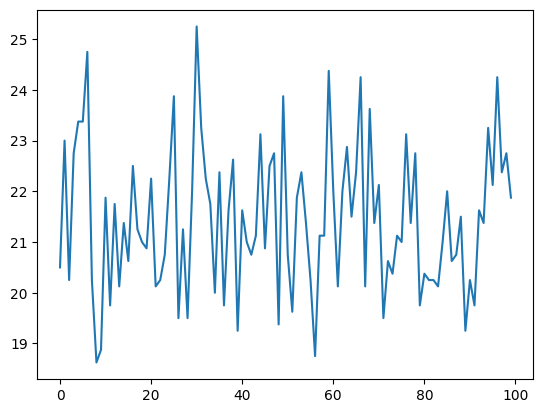

In [22]:
plt.plot(range(0, epochs), t_acc)
plt.show()

In [23]:
def valid_nl(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        for _, data in tqdm(enumerate(test_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            loss = loss_function(outputs.squeeze(), targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")

    return epoch_accu

In [24]:
def valid_en(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        for _, data in tqdm(enumerate(en_test_loader, 0)):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['label'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            loss = loss_function(outputs.squeeze(), targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")

    return epoch_accu

In [24]:
acc = valid_nl(model, test_loader)
print("Accuracy on test data = %0.2f%%" % acc)

2it [00:00,  5.03it/s]

Validation Loss per 100 steps: 2.7503716945648193
Validation Accuracy per 100 steps: 0.0


50it [00:08,  5.90it/s]

Validation Loss Epoch: 2.98501811504364
Validation Accuracy Epoch: 20.0
Accuracy on test data = 20.00%


In [26]:
acc = valid_en(model, en_test_loader)
print("Accuracy on test data = %0.2f%%" % acc)

1it [00:00,  2.74it/s]

Validation Loss per 100 steps: 4.837588787078857
Validation Accuracy per 100 steps: 37.5


25it [00:07,  3.38it/s]

Validation Loss Epoch: 4.131698217391968
Validation Accuracy Epoch: 19.5
Accuracy on test data = 19.50%
